In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,0:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
cv2.destroyAllWindows()

In [10]:
len(imgpoints)

35

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

Text(0.5, 1.0, 'Undistorted Image')

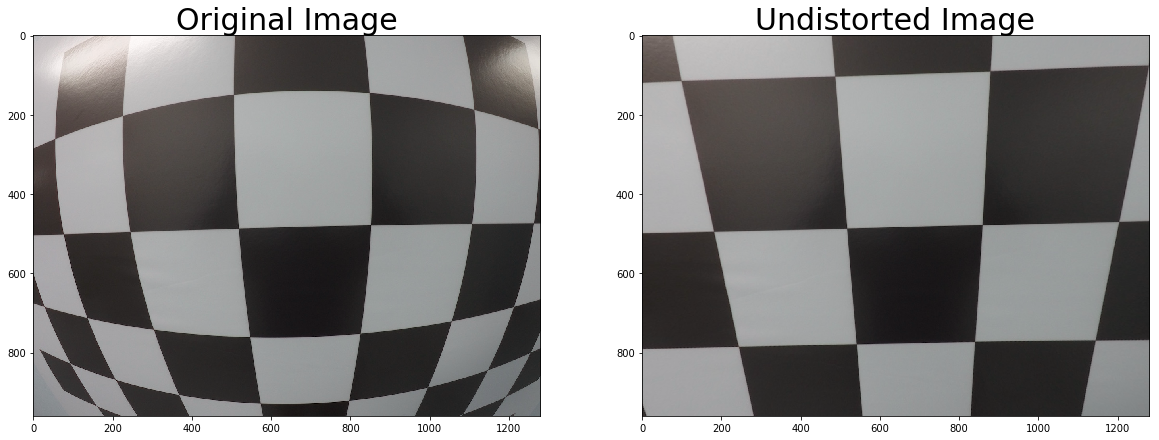

In [9]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx #用于3D转换至2D的相机matrix
dist_pickle["dist"] = dist #distorion coefficients
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Undistort and Transform

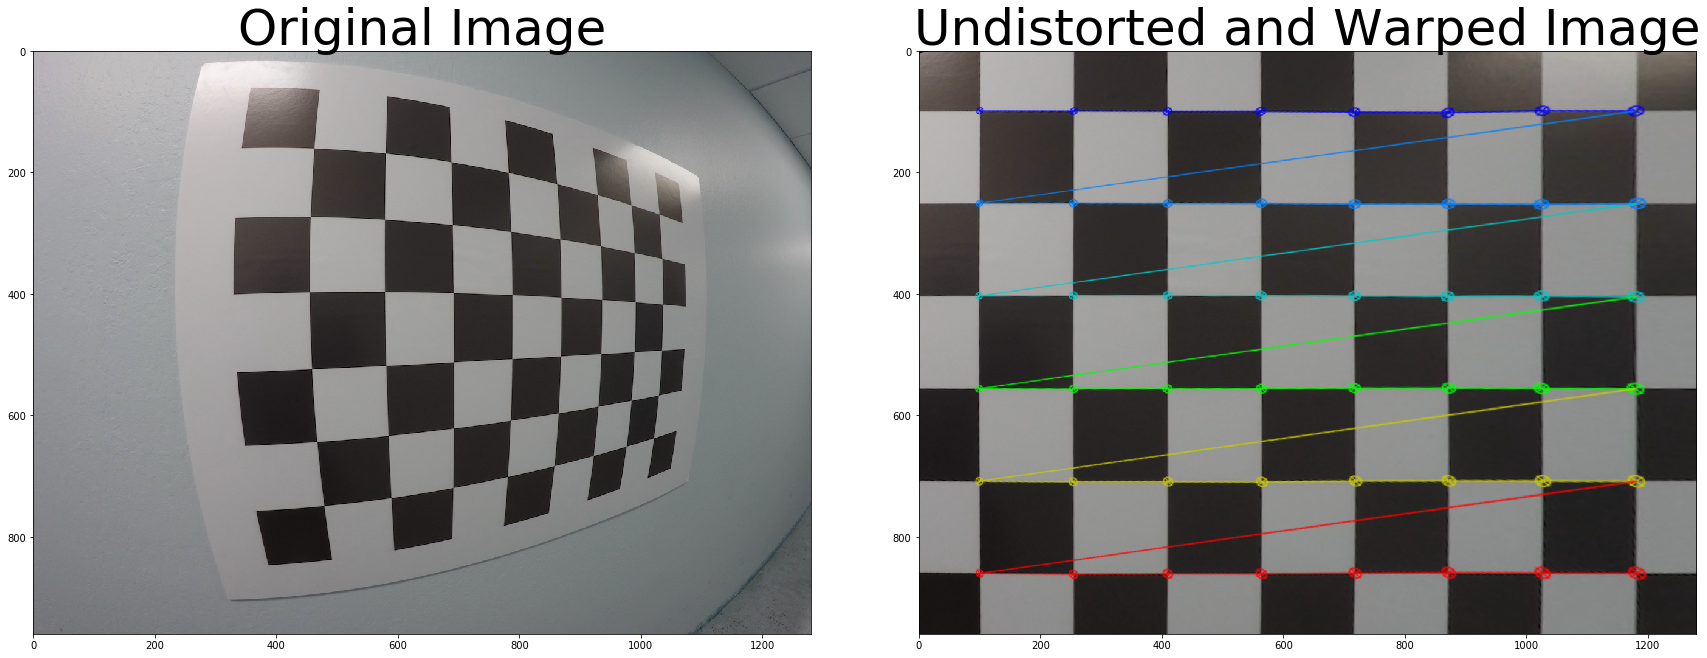

In [17]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('calibration_wide/test_image2.jpg')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABqsAAAKSCAYAAABFt+EWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzsnXe8ZEWV+L+n+703gWEYcs4gIgaCgGJgYFWMsCZcdd3FgGkx/cxpF+OquxhWFLO47BrRdY1rggFEFBQUBAwgA4ikQRgGhpkX+vz+OLe669at7r73dvcLM/X9fO7M63tvhVvx1KmqU6KqJBKJRCKRSCQSiUQikUgkEolEIpFIJBJzQWOuI5BIJBKJRCKRSCQSiUQikUgkEolEIpHYfEmTVYlEIpFIJBKJRCKRSCQSiUQikUgkEok5I01WJRKJRCKRSCQSiUQikUgkEolEIpFIJOaMNFmVSCQSiUQikUgkEolEIpFIJBKJRCKRmDPSZFUikUgkEolEIpFIJBKJRCKRSCQSiURizkiTVYlEIpFIJBKJRCKRSCQSiUQikUgkEok5I01WJRKJBYeInCQiGlx7zXW8+iEiZwZxXj3XcZrPLNR8TiQSiUQikRgmEXno1BJuVkbcrRx9bBOJ4ZPGUQsTEVkV5NuquY5TIrEQEZE1QV06fa7jlEiMirG5jkAikZhdRGQb4EHA3sA2wFJgErgbuB74napeN3cxTCQSiUQikUgkEolEIpFIJBKJxOZE2lmVSGwGiMh+IvJOEbkCWAOsAj4PnAa8C3g/cAbwPeBPInKTiHxKRB49V3FOJOaKLju6Tp3reCUSiUQiMZ+J7HxQETlpSH6Hq/PTLqFEIpFIACAiO0X6iBsH8G8rEZmJ+PmjAfw8POLfxXX9SyRGjYg8MFJmvzPX8Ups+qTJqkRiE0ZE9hCRLwG/B94OPBCQEk53AU4GzhORn4vIo0YYzUQikUgkEolEIrEZkcwUdielTSJRDVW9BfhdcHs3EdmvppePJq4vfYSITNT0c2Xk3rk1/UokEolNljRZlUhsoojIycBVwN8xWF0/Epu0+vgAglkikUgkEolEIpFIJBKJxCiITfwcU9OvlV3uL8H0I8PyM01WJRKJREA6syqR2MQQEQE+CvxTl1dawM+AC4CbgduA5dhuqgcCTwC2CL0FXgYcLCJPVNW7RhD1RCKRSCQSiUQikUgkEomqnIvpLHxWAp+u4dfKPs8uqOKZiDSBRwa3p4GfVopVIpFIbAakyapEYtPjk5gJv5BJ4N+B01X15m6ORWQJ8AzsHKudg8cPB34sIseo6rohxbcyqnomcOZchV8XVT0JOGmOo5FIJBKJRCKR2MRR1VWUM/+dSCQSmwKrACXf7q2s6omIrAAO9m7NAE3v9zHYud9VOAxbIOxziareUzV+iUQisamTzAAmEpsQIvJa4hNVVwAHq+pbe01UAajqfap6FnAg8MXIK4cB/5Xt4EokEolEIpFIJBKJRCKRmDNU9XbgyuD2LiJyv4pehedVfQ+40/v9cBFZVNHPlZF7yQRgIpFIREiTVYnEJoKIPAT418ijK4BjVfXqKv6p6lrgecAXIo+PB15aOZKJRCKRSCQSiUQikUgkEsNnGOdWrQx+n0PeXN9i4GED+glpsiqRSCSipMmqRGLT4ZPAeHDvduAxqrqmjoeq2gJeAPwo8vj9IrJ9HX8TiUQikUgkEolEIpFIJIZIbAJoZUU/wvfPy65afnY5r2oSO0c8kUgkEgHpzKpEYhNARI4Hjow8epWq3jaI36raEpGXAL8FlnqPtgTeCLxuEP8dmRB3MPAAYEdsxdK9wOWq+pNhhNEj7HHsPK496ZzTtQYzI/BLVZ0ZZfjDQkR2Bw7HvmMp8FfgVuBCVb11yGHtANwf2BdYAWwBrMvCvAm4ONngjiMiDeBQ4EHA9pgN9DuA31ChvInIYiy/HwBsA2zE8vtiVf3jkOO8K5bfewFbAUuAu7H8vgGzub5hmGF6YS8BHgHsBuyE2Y2/Bds1+htV1VGEG4nHA4H9gB2AbYH12IKA1dj3T81GPBKJRCIxfGZThsrC2xd4CLArdo7J3cC1wC9U9Y5hhzcoIrIjFt89sfguATZgfeEtWF/4h/kq+4nIUmystAsmey3G+vDbgMtU9c+zFI/9sXTcDViGKaxvzkywzxkish3wUEzGcbLpGqwO/HwUZVJEltGR73bE5NibsfyoZBFktplP4yAR2Qrb5bM/JqPfg5XtS1X1dyMIb9ssvF2xsnIfNhb4lapeN+zwanAe0CK/MH9lWcfZeVUP8W7dhY3RwoX+xwDvKOntQzHdic8vVHV92Xh58VsKHJBd22Ht8RRW9tZg+X5jVX/rICJj2Jj2/ljbsRgrf5epaji5V9bP3bH02gvri+8A/oKl19D7Yi/cA7Dv2B5L1w1Yet6Qhb1xBGHugaXfrlg7cg/wJ6z9GNm3zjdE5P7AIVj/vBirc1djfU+pOpLpVw4BHozln2D915VY2zQ0fYGIbIMdmbIfsDXW/t+LmQq9Gcu/u4YVXhB2E5Nl9sb0lk6PdHUW7qzoI0RkTzq6rO0x/cztWF29SFXvHTgQVU1XutK1wC/gJ9hhov61ashh/EskjLXA0j7uVkbcrfSe7wGcjglY4XvR7wBOiry3V41v2gP4bI+wFWv8/w3YftDwgTMDN6tLxnN14O7M4PlTgYt6fEML+AXwxAHyf0vguZhZyOt7hOWuaeAS4EXARM0wh5LPQwr31BLu9oq4O8l7vgJ4L6YY6ZZufwZeDYz1CGdv4DPYoLibP1cATxkgDbbDzr/7CqaE6pffG7HB4TOBxpDy4SDgq5jg3i3cm4C3A1t47k4N3xsgDg8GPpeF0+v71wH/Azxs1OUzXelKV7rm60VRzsn1gwP6vSri98oS7lYHbs4Mno9chvLCEuCFwK96hDcN/B/wqMBtHblkZZ0089yvAN6CKXv6yQEu7r8GPoRNQkjEz0IfXeM6s8I3PBP4IaZ47OXnb7O4La+Zt13zB1NkvQmbjIyGP0dpszzL30uyct6rDvwKeDk1Zfog3AcDZ2MTnd3CvBZ4FTDeo31ZPYy2pWSc52Ic1PN7sUWeZ2MTnt3isRp4hZ+OA6TB0cD3sYmRbuFdDvwjXt2n2HavmoX8uiwSt/uXdHtC4O5b2f0mpvtw9zcAi0v6+cZIfN5R0m0jS/t/B36Zla1+5e96TH+xS830e3LEz4d6z/fFrPqs7RL+dyJ+nh2889vg+YlZnelVp85hCH2xF+b9gDMoygnhtR47t+zYIYX7d9iuum7tbiurN8cF7tYE750+C3XpgWXyt4vbrvHFNs68Avhjj3Rfm5X7rv0yJqe8G5sk6ubPn4FTgGbNNFiKyRKfAa4pUf9msAnuV9JHV1ohDjsCH6O3Hmlt9s6uZetyxTjskuXH1X2+fzIrv08nIgeWDm/UhTtd6UrXaC9shWOso3vWkMPZmbhw9Lw+7lZG3KzMnr0QW4XQq7FbFfHzpMh7e1X8nlfSWwkeXreTCQx1w2fIk1VY5/ytCt+g2CCr60RIl/A/gK2aqxKOf91IoHQpGe7A+VyzrMfCPbWEu70i7k7Knj0SW2lSNs3OA7aOhHEyvQf34XUGFYUE4Iv0Hoj2u64CDhog/RvAe+g9+A6v1cBhmftTw+c14rAz8N/0Vt50u74JbDPqcpqudKUrXfPtYgFNVjFLMpQXj72BCyqG9x9kypXIs1NLhLmyTpplbp9Jb6VImaugHI710TWuM0vE/1Dg4hp+3w68pEb+RvMHWwHdd3JjltNGsImgUJFY5lpNTYUtJt+9l2oy5uXAPl3al9WjasuCeM/VOCj6vVk6votykxbuuhTYoeb3L8GUtFVk4lXAdpn7VeGzWcizD0bi9LKSbj8UuPt/3rPvBs+OKenn9yPxWVnC3XH0XzDX69oIvJXqY8GuCm5M6d+vPpSerMImzcN07Xd9BdhqgPKxDfBp6o13fwzsXDPcnbuUhV7XfwKLMvebxGQVpr+MTSh3u/4EHBDx/xiq6VdWAcsqfv+bqaYzDK/bGHCCFVsAcGeFMNcCJ/aryxXCX4z1g1V0UO66lJILBcIrnVmVSCx8nowNOnzuwFb5Dw1VvRlbURILvzIi8npM8F3a791hIyLvBj6CrXQsy3bAd0Sk1vcOm8wEwwXAUyo6/Qds8FOFI7BOqi67AT8RkecN4MeCRUSOIRNsKzh7NPA/mYlK58/bgU9hg8ayvBRbWVeFoxjMTPCBwM9F5DFVHWZb+M/EVvqGZ/D1Yk/gPBF5aNUwI3F4CKbgeg7FtrUMJ2Dff79B45JIJBKJ4TPLMhQisg+2CCU8s6QfrwDOEpE6fVFtRORFmDJwQZ5NKyJPAM7HzDpWZTvgEyLykUwmGSQej8aUY3sM4s8wyUxIfxn4MGbSuCp7Aj8QkZMrhuvkuzdTTcZ8EHChiOxVJbwhM2/GQVk6/ifwNmynT1kOAc7PTC9WCW8J8G1sgWmVdujoLLytq4Q3RM6N3FtZ0m343nld/i7lZ2Yq7xHB7Q3Az0vEZX9sN0NdJrBdJ18etD0DEJF3AB9lsPrg+7cUGyM/saLTE4EfZiYwq4a5H7ab+kXUG+/+DXCJiBxSMdydsHL5+IrhPQ/4ZlaOFjxZW/4zbGdoWfYGfpSZI3b+nIDtQq+iXzka+FbFunAY1XSGIdsD3xaRV9ZxLCKvwfrOFRWcLcfq/DD6nB2wcvt6qumgHIcAF9XRC20SBT6R2MxZGbl3jqpOjiCs/6M4sD+mhj+Pw8xhODZijeAqzOTYNCbYH4nZcx8aIvJqbIVRyCQmLJ2LrdAYy+JwHKZcaGT3vgScNsw41WAMm4x8oHfvMuAH2MqTu7AVQ0cCT8Psl/s8V0S+qapn1whbMRNzV2BbgG/HzlmYwUxk7IMpB44hP9kwDnxaRK5U1UtrhLtQ2RNTCCzKfq/HzNGcj5X1ccyUwtMxs3c+R2MmAf9NRJ4LvNN7diu2Cu1SLA+WYfbVn4VtE/d5jYh8TVV/USP+M1kYVwK/wybC78YGrMuxQdTDsEGYL/gtw4SkQ7Sa3fQPYkJ5yL3YZPnPsHRbgqXtkzC75mCC5DeBr1UIL0c22XUuxXanhSk2fwZch9WxJVgbcTQ2cPGVBvsD3xORw1R1bd34JBKJRGLozKoMlSlrzwV2jzy+BvhG9v/d2LmMR2F9m1OOPBszwTYrZAstTqeomL4PM8F0CbZT6B4sLZdjyqKDMPlvrz5B3IKZxwHra/cNnl+b+d2LG3rE/xhsx1xMz/Gb7Nlq7Ht2xvrw4+jIaY5XYv36KX3i0o2dsLz1lboXYzLg9Zj54J2xc0efmT0fddqMZ+E/KvL4WqycXo6ZR5/GJu4OxxTJ/sTlGPBJEblFVb/dJz6ODxOX7+7B8uRi7Pu3wmSop2FjCuik5VUlwxolcz0Oeg9mjtBxIzYeuALbxbAMWzT2dEzB63MA8D6qlekvYzJuiFsY+xts58C2WBvwNDrK4wOxibW54HwsT3zZfGU/R1l7/WDv1lqsf3CEk1XHYEcl9CJ2XtVFWu+s35uwcdnVdNqR9Vh/sRMW98dTnIg+ERvLvZP6PBVbTOhwfYIb085g/dwjsPajDB8nv6jgVuDrmFnWO7BzsA7Owt4mcHsENgmwUlVbZQLLzqW6kGL6KDaB9TPgD1i+T2AThY/C+gi/Pu+KjfMOUdVbSoS7BNMzHRB5fAP2zb/H5I8dsQmSE+jIH4/HdlMudBZjk99uAraF1akfY6b6prAy9ESsb/bZHdtt/iwRORjTyU1kz+7BZLgL6ehX9sf61jDNjwFeglmfqcNVWD95NVZe787ivSUm/xwGPIa8TNEAPiQiV6hqbCI9SjbZ9MHIo2lMb/pjOjvLdsXa6mOwPlqwjQFlz9WLhb89Nqke9iVgJp8vwNLjTqyt3RF4OJZ//gTfCuB/ReQIVb2ydARGvW0wXelK12gvbGAdbrd8/YjCOiISlgK79XCzMvK+b7bgbGD3Hu4LtqCpb4bvfsS3r/5fL/eYkPRL7/2YH2XCPzNws7pkuq8O3Plb739PD3Mc2ODy/yLxvbpCvp+DCQDPxTu7q4+b7TCBIjQZcUWFcGvl8xDKeSzcU0u42yvizj8j4ct0MRuACTFvjri/Ezvs1Z1PNY1NtkZtpGNKo/+J+PODCt//B0xofiolTSxgE0dfjIRbykxA5sfRkfKiwH+RmRLp4m4lefvRhfpZMvytsYmoMPzPAXv0cbtvl3r29VGX13SlK13pmi8XC8MM4GzLULE0uQt4QQ832wV9akzuPLVE2Curphmm3AjdnEV5+e8BwD9jiqeepl/qxK+Pf9tk4YZ+Xg88voe73YDvRNwpcELJsEN3/ljnN8DDe7iNjXWGmjaZnx+J+Hkltoiwq5kwbHHOmyiaZ76TPvJR5v4Y4vLdF4iYvM7cCKZQvLtHPVg9SHpUSLe5GgedGbjd6Pl3N2YaPHoGC6as/dcu5XLXkuGfFHHfwiw2LOniZgzb9eWXlTDfVs1SvsXOP3pAHzd/G7z/neD5GPkzgzd2SwvPzZsi8Xh7yW84Beun3tAv7kEcX4BNpPphzlTwI2Y6zG/T/psepvCIt2mhGcD7Ar/fQZez1TBLPKF5Rne9tuQ3LcEmGUL3ZwP793G7G7YYMnRbqixj5/yEbtdj5lijZz1jY/pPBGkUtsELzQygrxe5CHhwn7oYMzf5UPJnJn2OLu1yVhfeE/HjVkqadM7y/Tzg+b3KfOBmK8zkbWiq9cZuZTzixy7ETf/9lB6yFTY5d35QzgppWCL8Bra4JXR7DnBIH7fbYmdnhW5/R5/2MufPqAt3utKVrtFd2GqCmPBfyn5yjfAWRTpJBf6mh5uVkffd9R/UOHSP+pNVMRvBX6XEYYvYSrULe3xLmfDPDNysLvm9q7uEeTElzsbJ8u2KiPtHlgx/EJvQ/xgJ93GjzOchlPNYuKeWcLdXj/JxWsmwPxlxeysdIfX4En5MUDwMfYYek8JDzO9/CcJtUcJOMaaUuGqAdNsJG8xF07+kH+Fk2zTw3ArfLpjAHIZ/5KjLbLrSla50zYcrIuco82+yatZkKMykb+huHfCwkt8cm1yoIpesrJpmFBWc51BPVh8DJoYdvz7+fSri35/osajOcyvYpFzo/jZKKFd65NNP6XE4/CymzXER/77ZL48CPx5LcRx4Rh83DeCPkbD/rWSYj6T7+car66ZHxbSbq3HQmV2++w7gIQPUibeV+WZsh13o9pSS4T6D7mdqrZqlfPtAJOx/6uPmw8H7r4u884Pgna56kOz92IKHsmPwym2H53Y/4OYg3E+VdBubrHLXe2vGJ5yscleLPmege368LuJ+PSUmYDG9UxhuqfLs+RGbdHpSHzcPitSFjRXagbf3yIuFNlnlrh9Qrl89OeL2Vu/vfykZjy9F/OmrU8ncDtL+PwXTwfjhPqek25g88gOy88v6uJ3ALNJ0KzdlJqv+X8TdByp+/ykRP3q2wf6VzqxKJBY2uxK3H33TKAJT1Y2YgBwSM23Sj4uB12jWko2azD7xccHt1cA/qupMP/eqeg+2lXjd8GNXi7uAZ6jqX/u9mOXbGyKPwvTo5r62GTNV/QImnPq8qK5/C5QLMDu/ZfgXTKjx2SH7/72q+q1+HqiZAA3NPDSwlbN9GSS/s3Av8X4LtrqvH8di5kJ8fo4NSvqiZoLhWRTTrhSZWYhnBbffqqr/XdaPrC17Cbbay+dNkdcTiUQiMXfMlgz1qtg9VS1zVgmYKeCflXx3YERkS2xHiM9n6sjqqjqtozFJHkVEtqNoZm4GeLqq/rmf++wbn49NTPpsH/G3LGuBZ6nq3TXdD5N/Dn5fDjyzSh6p6o8omhR6vn+OSIQnYUpznwtUtZRcrKo/BV5TNo6jYB6Og56vqr/p/xpgMmhobq5M2/UPmMUBn7NU9fQygaqZSf1AmXdHyLmReyv7uAmfh2b/Yve6+tnlvKr1mB6kL4O0Hap6DdaH+Py9iIQmT6uwivhxCoPwMVU9q8yLqvrvFOvTEmxSoyvZeVEvDm6fVrY8e7yeYp/cb5x3CsXz5d6uqj8sE6CqvgsznbepcDM2YXNfiXc/i+nrfJxe5PuqWtbE3dsi955QxuGA7f+3sQUDPn3b/8z83onB7duBZ2cyab9wJ7Gzt28tGdUw/MUU5d6zVTUmC/eKx+mYZSGf14tIqfMW02RVIrGwCW33OkZ5RkrM7zqHp76+zCTREDmZ4sTem0t2lACo6l+A9w81VvX5iKp2tUsf4YdYJ+dz2BDj04vQXnnVA8YXOm/Wkra0s0mXmGLqTqqVvW9jq199Dq3gvhaZsicccJTJ73AAARUns1X118Dny74f8HryMtF12Oq5SqjqFLbt3+cJmdCXSCQSifnByGUoEdkZOD64fSkV+qmsD3xF2feHQHiuCsQXqc1HXkT+fCiAT6rqZbGXY6jqNPH0rntu1QdVdSQLCKsgIo/EzkLzeU0ms1Tlg+QX7i2it9LvpZF7Vcv0Z+ic5bUQGeY46LwyC9cc2YT894LbB4tIPz1gmG8bKL/wzvFu7PyYueICimcnrRSR2EJfRGQb8udVrcPa7JDYuVXdOJziObgXzuJE/jfIn3O3hMHG/68d8kLjtdjOoSr8P+yMIJ+T+yjAX03+DKE7KE7g9yX79vDsqEdmkwsFsgUgzwlu/wkzaViFV1FzQeY85P2qWkquyPQn/9PlcenFoKp6LXbGks/I9SIZYft/ZDaJ3YuT6JzH5XhnmQVWDlW9i/7n6fUK31+EMk188VUZTg1+7wkcUsZhmqxKJBY2S7rcv2uEYcb87haPbvxRVc8fRmQqcGzw+066d369OBPbNj7XfLrKy9nEYHhAd+yQz1Hwx+D3ziKyxyyFPdf8XlUvrOgmplj5iqreW9YDVV2PmcXzmav8PjQ71LsX4UDvqgorz30+W9VBNmh9WnD7zAEm00OlwCLgyJp+JRKJRGL4zIYM9VjMFJ5P5V1Kqnopdm7qbODMfvkslAVGj43cq3yAuqqeh5lS9nlQtjK/kleYaeD5wDOC39ep6jl1PMoW+YU7Vo6OvZvJfuH46+IKu4JcmC0q1tl5xjDHQXXSIdzFswyzzhIli9sDgtvfUtVKq/Szsch/VXEzTDKrKGHbuR1wUBcnR5Nf2PrTLmOBi7HdUY4jRGRpFz9XRu7FdnyNhGxC+vrg9sNqevfrrD8aJl/LlOqlUdUbMdOKPruQn2gMCdvAL1ZZsBxwLnaWks+ju7z7KIqTlWdWXSigqtcBP6riZp4yg+nSqhDTi/xSVS8f0J+50osspXdZhWK/uRE7J64qXyLfVpUlrC/fzxbtV0ZVf49N0PpEZYaQfjN6iUQiERIbZEdXKPVg1RDiUZpsV8NDgts/KbONNkRVbxKRy5i9XUkxrq25UvPa4PdWdQLPzAc8EkvTB2ImUpZjwlhsVVO4MgRgD6DKquaFSp1J2XBQAbY6sCqrMTvZjhU1/EBElmFC+IOxweu2WH5vQXzRSyiUL8JW50TN8IjIvlgZ8gknfEqhqj8XkTuyOJblwRR3h9Y2u6SqfxWRteTr1yHETYkkEolEYnaZLRkqphD8Ro1wnbuH1nRbGlXdICKXk5eZXyciv1bVr486/LpkK+qPCG7/TlV/W9PLr1FUaB9Ftfy7poz5wVkiVAwNalryuuB3t1XSh1Dc7TZIHahqsmskzPE4qI4sGbZdYO3XjV3eH3bbVcqk94g4l+L3HAPE2oaVwe9VMQ9VdUpELgL+Jrs1jpn6i00mhH66ONVGRB6C9QcPxsrRllj5i5UzgH2C33UnSkcxyfbNmu6+gZ0H5PMwIhMbIrIrsG9we5Bx3kYR+Uvg5yFArI8cdl16fE2384XLa5jVG6ZexGe5iDTKWr9xZIswjsLa/wdhOo7lWD2Mtf8xXckexHdtukW0oTxzkareWSWeYGZEReQCSh79kYU/Djw8uD0MmcFvh0rtrEqTVYnEwqbbipCtsAOBR0FM4V11xn7Yq3L6cX9MkBxWHOZ6sipcoVGWUDioNFmVnfv1Jmy1Ra2JLo9aEycLkGtquImdizYMf6rm92GYyY/jqb57MmQFXSaryE+oOQatn4+p8H5oSx7goyJSeTLbI1xhGZ4BkkgkEom5YbZkqFBOvKnqzgSPcFfXKPk88GHv92LgbBH5OfAF7GD1+TIJ4ziA4kKZQXajXRK5dyjVlIyzPdaJkpmhCldxP1ZEQpNIVQh3mXWTcWJjpVplWVVvFpGbgZ3ruB8G82ActKFm3Ysph3vFf2j5hpnemiGuxJ0NzgXeHNxbCXw08u7K4HevicHz6ExWObe5yapM6RuOMWK7vfqS7dx6FWae635V3QfUHYOPok2rW65icemmm4mN894lIoOcKbxL8LtsG7ge+F3NMGdTDhgV80kvItgEU6nJMxHZHWv/T2TwcX2vOrgrxaNeBtWLlJ6swiaSQj3Gy0Tk7waIw17B71LplyarEomFTbcZ9hXM7mRV1Zn+UcWtG7FdFqsH8C9cUTjblLZXGxBuOS/dB4jIPwNvIW/veRAGHeQtFCqvgqGYT8Pyp58pPqA9uPoQ8DKGZy64V37Pdf3cLXLv/gOEH6PKTq9EIpFIjI7ZkqF2CH6HpnmrUFe5VYdPYGdshCt7H5ZdZ4jINcBPMaXrT7HV0sM8x6QqMcXH1QP4d1XJMHox22OdbuxMUZbbgWL5HIRuMk4sjEHrwZxMVs2TcdCw2i7oPSYI822a+O6svqjqfSJyA7B3HfdD4ELsDF9/19HRIiJ+myUi25JfPHcPvScHypxbdThmhcLnguxsvNKIyLGYSdE9q7jrQd0x+LDbtLuzs5rrEOsTu7VpsXHefjXD7UbZNvCaAczMz6YcMCrmk14EyutGXomdSR3W57osNL3IHtTfkRmjlF4knVmVSCxsbiJuli9c7TEURGSCeONSdZXX3UOIThVCE19QchVFFwZxOwzqHIhcGxH5GPAOhjdAg5LCwSbAsPJqVvI8m6j6GvBPDFdG6JXfc10/Z2MiadCdaYlEIpEYDrMlQ4WLuxaE3JmZyH4S8OMer+2HrfA/Hds5sUZEzhKRJ4rIXOgXYnLEIOfrQuj2AAAgAElEQVT3xhRh4Urnfsz2WKcbsyHjhKb+HLEFjguiHvjMo3HQXLVd6wacjJ6zcXN2blZ4Zte2FHcbhudVXdhnUukXwAbv9+EiEiqyV0bcVTKlJyJPwEyjD2uiCuqPwYfdptUuF6o6ST79oftulbkc5w1NDsjK8qzqgEbAgtKLAIjIO4GPMLyJKkh6kVJ6kTRZlUgsYLIBZcyO66js2j+YeONadZVcpRVFQyA2uJgcwL9BzIMtKETk74GXRx79Ffgs8ALs8NC9sM51iaqKfzF3q+kS1XkjcELk/k3Ax4G/x+wY744J4Isj+R1bXdiLua6fMaEwkUgkEtWJyXfdFNlViQ1uZ1uerMKWwe97B/BrELeVUdU1wOOAZ1HO9NA2mHzwXeAqEXn6CKMXI0xrGH56x8LoxXwpm3Mp48xGvoyUzXQcNMy2axjuByU2QbSyz+9VvTzMdDC/8G6NYeeY9fKzW1yiiMgOwJcojpNmsAmsN2DttDtPeAugGSl/wzIfN+w2bdjlqlsbPZ/awEG/uerRG4kBEJHjgLdHHq0DzgJegk1070P39r+q7JD0IhnJDGAisfC5lKId0MNHFFbM3zWq2u2A1vlCbEVB1Y7DZ/kAbhcM2S6bD0QevQ94p6p2OzMtJO0qWQBkg6LQrvs0dm7V6RXMVlTN77mun7FyvLWqDrIqO5FIJDZHYu1meJZQXWL+1DEFM1usI7+qepBVucNc0VuKbCfFV4GvisiBwBMxpcxR9F55ewB2xtUngJfPknnA2JkWw07vWBgLgZiM82pV/cgshN0tX+ru0JjVerAZj4PCfBs03We9/Qo4l6LC+Rhst4T/26fXeVX+O0cHfvwAup5XtRY7P6Ys76BoLuxC4O9VdXUFf+Zr+Rt2uerWRsfq6X6qWsu0ZUXWATt6vwf95vAsocRo+VDk3hnAG1W1rEywKehFHqOqPxkgDrVIO6sSiYXPqsi9YzOTfcMmdjhfpe3sc0RMmTHIFtfN5fyZoynahv+oqr65wgANqptOScwNx1MUgt+oqh+uaF+9an7Pdf1cE7m31wDhJxKJxOZKrD2ve5h7GX/m82RVOHE3yFmdc3rOp6peraqnqerxqrodcD/ghdjK4lgfCvBS7Iyf2WDY5S7mtu55QXNNLH9ma6dPbPJ6IdWDzXUcFObbliIi0TfLMdfnFF9E0WTco53JUhHZDjjIe3Yvdh5fP8IJrZXe30dQHFOdX/a8IhFpAs8Mbl8DHFdxogrmb/mrXS4yPVe4a7vbIsP51AYO8s1L2XyOUZhzRORg4MDg9pdU9eUVJqpg09CLzMnu4DRZlUgsfL4TubcdcVNetRGRnTAb9mXCn2/Edn49KHKvLKGd602Vxwa/W8B7avizzxDikhg9YX7fiZ1HUZWq+T3X9fPWIfiRSCQSifgg9/6Deioiyymex6rM7wmE8DD6Awbwa+A0HCaq+kdV/Zyq/gOwE/AU4JLIq2/JFMGj5vbIvVDJVIUHRO51m5Sb78yljBPWAVhY9WBzHQeF+TYG7FvHIxFZAuwxcIwGQFU3AD8Pbm8NPCT7Ozyv6meqWuZMnIvIm+c6TETcDoiVkferLPA9lKKS+TRVrWRGTkSWAdtXcTOLLBeRHfu/FiXWjsTaG5hfbeB+A5zrOK/kgM2AsP0HeFcNf6q2/zdhfY3PZqkXSZNVicQCR1WvI75V/WVDDupFFE2H3g18fcjhDB1VvQG4Jbj9sDp+ZQLGqMwszjd2D37/QVVjHVg/Hj6MyCRGTpjfv8gOsK1K1fz+FWZ/3adu/dyK6sJ8ePAywBPqhJ9IJBKbOZdG7g1jkPvAyL0rMyXkfCU8J2TXARRzhw0amVGhqjOq+h3MPOD3g8dLgcfPQjT+ANwT3Bvk/N6YnD+sc19mFVW9DVgd3H6Ep1QfJbE0q1WWs0WT4S6nUbO5joOGlm/AwUBzgLgMi17nVq0M7q8q42G2u86fpPfPrQr97BaHboRlD+CCCu4dRzA/0r8bdctVzF23Nnoux3lhnJZSfyHFvJUDNlHCOrhGVa+u4U+l9l9V7wHCcGrpRWq6jell5kQvkiarEolNg/+I3DtGRE4chucisifwpsijz1Zd4TOHhCuqjhCROqvEHkPe9vCmTLgatvIK5sxm998OJzqJETOM/N6Oot33nmRtyBXB7SfXVKQ8i+rncf6M4oG3TxKReXPAaCKRSCwQLqN4APj+IrL/gP4+OXLvwgH9HDWh3Anw1Jp+PW2QiMwGmbng8NxL6D1ZGTMxXFmxmpnWChWS9xeRg2LvlyA0vwUmK8wmQ0mbjB8HvyeAoYwR+3AZRfNrdevA0weMSx0213HQpth2xSaKjgn+d5Q5r8qxKvQzy/Ojgvt/BS6v4G9sR2qdncTPquFmNqlbN2LlKlZuUdXfAjcHt48WkdiE4LDZFOvS5sIw2n8hLk/046Lg9z4icmSN8A+l4iJeVV1Lcaf8fnXCH5Q0WZVIbBr8D3Hbyv8xqPmNrJH9JPFDLP91EL9nma9E7r2+hj913CxUQgV+nbL0HGZ/JWSiHsPI73+iaEO8DGH9XJr5VZpscPiqqgFnu8f+L7i9JfDaqn4lEonE5kw2YRFb/f28un5mZ3c8O/LonLp+zhI/ojjh8KKqZ79k5yYMsktoNvld5F6vMzpi5z4sqxn2DyL3XlrVExF5FMWdfJfX3FEzCMNMm/+N3HvriM43bpOZUgvr6ZEiUsmkUVZnXji0iJVnsxwHZRZJrgpunyAiO1TxJzMB+PdDi9hg/ILiQopHZbtdfbOf64nvxOlG7NyqIymeV3WeqoamvXoRWwxcqfxl+TVf0r8bJ2ZWMUojIrtR3LH7F3pPBn4r+D0OvLVKuDW5gOKu35NEpNLCShHZi7hZusToGEb7/0TqmW+ca71lTGZ4R02/apMmqxKJTQBVVeAlFAfFOwI/EpFaB2tmg4NPA8dFHr9RVWM24ucr36Bog/VkEXl0WQ9E5CRsZ9XmQrgK6X6ZsFSKbADw78OMUGKkhPl9lIiEk9RdyVYwx1ZVl+Gz5O2+A7xdRKqcbfBW4udMlCF2BsEbROSRkfuJRCKR6E7srMPXiEjdc0teDewV3PsztlBr3qKqN1NUkB0G/GNZPzI5/KPDjNeIiSnle40VYgeJ1z3f53MUd/G8VERKm6HMFIix9J6LPBhm2nwX+HVwb2/gIzX9q8InIvdiFkF68ULgkCHEpSqb8zgozLfFwAcq+vFW7Ey7OSdbmBbujlyB9S/+AoKLSp5X5fgZef3LocDxkfeqmACEYtkDeFxFPz5JcdJsvrEV8M6Kbk7DJpt8Pp3tsO3G+4EwX18sIk+pGHYlVHUd8MXg9r5YuavCh5nf5hw3RcI6uI2IlDbFmJ21+vGaYf8EM2/s83QRKb0TUUSeDPxdzfA/TlEGOU5EKi0kHpQ0WZVIbCKo6qXA2yKPDgbOqaj0dQ3sF4ivZPsW8cHHvCUTUt8f3G4A3xaRR/Rzn5lU/NQo4jaPia2ODtMwSjZB+h3qrUJJzA1hfi8D/qWMw2zw/i1gUZ2As4nvsE1ZCvxYRPquSBKR11Ayrl3Cv4zi+XvjwP9UmdAO4rRIRF6cxS2RSCQ2F75L0d7+MuBsEQkPjO+JiDye+IHWH6moUJwrYpMB/yEiZc8+/Xc6Z6CMHBE5SkReNcB5RrHdzb/p8f6NwNrg3hPrBKyqa4D/DG6PAV8Xkb47W7KJwc8ADwke3Qb8V504Dcgw00aBt0cevVRE/jU7j7cyIvJwEQkVsSHfBa4J7q0UkVLWOUTk4Ziidi7YnMdB/wncFdz7RxEptVtRRJ4KvHHosRqM2ITRKcHvVVU8zEyZ+9ZtmsTPDa86WfULiov4Xld2d5uIvJ+FY37yFBF5TpkXReTVFE2Y3octru5Kdsb750LvgP8WkSeVjWgQlzEReZ6I/HOfV08Hwl117xaRvykZzpuBE+rEMTEQsfb/fdlu/56IyDLgm0CtRVpZn/3uyKMviUjf86NE5Djgq3XCzsK/m/jihA+JyAvq+CnG8SJSuj9Pk1WJxCaEqr6fYkcMNvC6XETe1e9wZxFZLCLPxRQNMbMtvwL+PmtEFxofoWgDdjlwvoicEa6WEJGmiBwtIl/DtuO6VTyhH5sq/0fRDMmJIvKZXjtuRORxmI1mZ7bm7hHFLzFcvk5RmH591m50NVcgIs/G6oRb8Vs3v98C/Cm4txvw60yZkpu0EpEJEXmCiPwE+KD3KGqzvAQvAa4L7m0H/ERE/k3scO++iMiRInIadqD5J7EVdIlEIrFZkMmHJ1Pc7X848AsReXo/U3gisrWIvBtbBLEkePxLFshuI1U9H1v45bMl8EMR6brDSkS2FZGzgP+X3bpvRFEM2QGbGPiziHxCRB6XmdjtiYgsy5Sj4WrxtZjCPkpWVkKZ+jFZn1/J5FjGm7Fddz77AReKSFfLCCKyK2b2JpYnL1bVcMfWyBl22qjqd4jXmzcB55ZdmCMiO4vIK0TkZ9iuktguEj/cFvBiIBw3vklEPiddzgfNFFsvwsYibswxW/XAsdmOg7JzS2KLrT4uIu8TkajJ70yB/ybgy3TOkJ3tfOtGbMIoNK1Z5byqbm5CP28HrqziYTYJ9r3g9k70WcQnInuIyDeANziviJsUnQ+4drUBfEFE/rlbfyMiS0Xk38mP9xxvV9WbSoT3OopnJG+JLVz+uNgZ7X0RkYNF5L3Atdikbk+rHqp6BfCh4PYi4Fsickq3xQIisqWIfAx4b3ZrhuLusMToOJ+iVabHAF8WkRXdHGWL4C+kcxZerfZfVc/CFnv4LAa+JyL/mS0WacvSWZ/5MBH5PPB9OrJzXb3lv2HmrH3Ggc+KyJdFpJQ1GxHZX0TeipmW/V/gYWUjUPUQ8kQiMf85GevMTg7uT2A7r94iIj8Ffoptb70Nm7DZGXgQ8AS620S/CHhitqV5waGqrWwi7nxMCe5oYHbtXyoi64BbsJVRO1NUknwXU+o/PLjfa+v5gkRV7xSRDwHhiqEXAn+bTeJdim0TXoFNVjwZK0eOGWyl7edHH+PEIKjqH0Tkv4B/CB69DbOvfTZmD/weYBvgAExJ4U/GrMdWUp5RI/x7ReRZ2EHgvv3yRZgy5U0ichdWP5dgg7ZwJ9fHsUGhLwiVshGvqneIyPFY2+iHP4YNcF4pIhdh7cefsXK/CCv7O2Mmah4KbF8mvEQikdhUUdULReSNmLken32Bs4EbReQcbNfNHVjfsTVmvvoRwKMonpUKdsD1M1V146jiPgJegykt/BW2K4AzswH8N4A/Yn3rjph8+WTysvjbmV1zYsuxBRwvAdaJyKXAZdiCjruwsxwWY7L0oZi58Ni5I69T1X6K6s9RPH/E9fk3Y3keTnx+S1ULq9lV9a8i8g/AD8nrOfbGzKJfCnwbW0yyAeu7H52FH1O+f0xVY2c3zBZDS5uM1wD3o2je/dHAeSLye2xnyZWZ31NYWd0GOAgzY3kAFRc8q+q5InI68Irg0fOBZ4jIt7CdJLdhyuP7AU8jL1/+OovXc6uEPQib+zhIVc8U2yHlT0gKJue/MJsU+Q2wBmu/DwKeDuzivf9drC07elYi3ZtLsHa2m55jA1YOq3IevXeRraq5yPcdWNr79e1BwG9F5LtYXf0LpuPZGTgW62v8s+g+ivWppc2XzSLXYoug/wFrr98BvExEvg78FmuDtsPGV08FYjuzf0pxIiiKqt6TjfN+jvW1DsF2w50sIhdj+XlDFv4YHdnEnR9Z5wy6t2Nt+UHevaVY/rw2q0u/wxZ47JCFcwLWrjj+DdPvVdqhnqiHqm4UkfdQNFv7DOBxmV7kYkyGXY6Zq34ixbr2CoqLlsryQkzvcL/g/vOy695MFgArl6HcfCEmh38juN9Xb6mqM5le5mcUz916FrZw4zKsHboWqy9g9WU7bLPEYRTNeJcmTVYlEpsYbgVb1nicRnGypYENSqqatvoE8OoFpiAooKrXicjR2IG/sRU0W2ZXjFWY7deY/dcFt2quJO/GBhjhIGNb+h9crcDLqWhSITGnvBI4gqJQshv97WtPAc+keIBxaVT1lyLyWOyg9Nhq2xXkBXefL2MKgVOD+6Xrpqr+Vsw80zcoHrA+QbwuJBKJRCJAVT8oIhsxRVK4Wnp3KpzdlPF74KmqunoI0Zs1MoX3sZgstFvweH/6m8r6CraafK7OvtmSen3fh1T1MyXe+zp2PkPMJNLOxBWD4flLbbKJkeOBr1FU3ByaXWX4KNXPFRk2w06bGbEzWj5I0fwZ2ERUJbPxFXg1NukVTjZtmd3rNQl1KzZ5Vdvc8wBs7uOgv8N2Rx4b3N8O2zHXi99hCtV5cb6gqk5nC3bDCWDHRdmxAVX5Kab87WYerKoJQABU9dci8gaKbX8Tm8TquasRmyh8LfUtTswGL8d2JrldiDsBZc/FuQR4cqb7KoWqrhaRh2KLZo4MHo8BR2XXUFHV+7Lx7SqKEw970dlF3Y0fYBNe4WL0xGj5GNb/hmYYlwMvyK5evAXTKdSarFLVW0VkJSYHHBh5ZQts93iMX2HxflTkWSndSCa/PhwzhRyayxSqyVSVSWYAE4lNFFU9A+v8v0bJnQVduARYqaovW+gTVQ5V/RM22/8xyqXNRuA9wHGqeg9FJfp83mI/ENmZECfQw4xLF+4CTlTVze2crwVNZvbjMVQf2PwFeIyqhiYr6sThEmzl2ZdLOrkbWy38HFWdplg/wzMf+oX/R2wA80Fs9fgg/JKiGY9EIpHYLFDVjwErMVmyLpPYeRRHqGp4FtaCQFWvxZTdF1Z0+nHgubNoenstHdNMdVkDvFBV+ynfgPYiu2dQPIS+Nqr6fWxR3i/7vRvhDuBlqvrKKkrQUTCitJlS1Vdgi4vCA9yrchslD5DPvuUfgfdR3A3Wi6uAR2Rnzsw6m/s4KNsZ+RTixwz04qfAo1X1zuHHaiB6TRytquNhZnHmspph9vP7NMy6Q5U6o5iO46nZuGjekpk7fAw2GVOFrwGPy8atVcP8M9Y/vIuKY8QIV1DctdIt3JsxeeiHFcP4InDCfM/LTZGs33oO1fvge4EXqWqpsxn7xOFmbDL3fZQzAzmN7QZ7tKreQXzxb+lyr6p3YX3AqymaRazKn4Czyr6cJqsSiU0YVV2tqidiuyTegwn8ZQa8twCfxSapjlDVOvab5zWqulZVT8FWI7wBE1Cvw+xqb8DMfP0AeD2wp6q+zVttFZ5dc9dcD2hHSSYIHo+tery8z+u3YdvUD1DVs0cdt8Twyex+PxpbdRueIRVyPbbS6/7Z2RzDisPNqvpsbHfTOzATpDdiSsv7MBM+38ZW5O2hqh/2lHlh/fwrFVHV9ar6Wmy126mYwquMqc8N2K7NtwAHqerhw5jASyQSiYWKqv5MVY/AVuZ/BTNB3Y8WJm+8D9hbVV+sduDzgiVbKPUobGV0L8VmC1tFe6yq/pOqzpqZaVU9F9sxcgI2CfFrypu5/hWmVN1PVSsptlX1LlV9LjZeORWbGLgWM69W64wOVb0U2ynuzAv3W3B3FfBOYF9V/USdMEfBKNIm8/dsbKX2szI/yyqvrsZ2nT0J2FVV39DnfT/MGVV9M6Z4+wa9J0avx8Zgh2STvXPG5j4OymTiF2KK9h/Qe+LkKuBFwNGqevssRK8qvSaOBtF3dHN7i6r+bgB/3YTV4dhOy15pvxHbxXaUqp6STbTOezKdzOOx+tWvb1yF7aY6MVOi1w1zUs1c6p6YadWLKDchOAlcgO3yPFRVH6yqX60Q7s2qehzwbHovDFVsccuTVfW5m8qC8YVI1v49FzNFeXGf1/8KnA4cqKqfHXIc3oyZNH41JtP8CbNmsxGTq88B3grso6qvUlVn6SbUi7SwxRRVwldV/QimF3k51o6WWdg0g+lQ3ofJv/tli9hKIbO3UCuRSMwHRGRb4MFYY7cNZiZwEtudcANwdTagTnRBRC4kv0X8AlWtalZxwSIie2BnKuyIbYPegO2suRK4fBZXACdmARG5H6bw2R7bbn4vNpl7uar+fi7jFkNE/gzs6t06S1XDc7jq+LsVNljcAVPmbYVNnK3Dyv/vgT/NpmIxkUgkFiIish+2+38bOrLoWmygfyvwyzorphcSWRocjJ3vsiXWl/wJ+LmqrpnLuPmIyBaYucJ9MKXHlphZx3uwPLsGkwfmdX5l3/EwzHTeDphp3zXY5MJlqnrjHEZvzhGRJmZ1Ym9MxtmWjuWIv2Lnqv1OzcLEsMLcEngkJrPtgE2+/QX4tapeOaxwhs3mPg7KdAlHYW3Xdtj33wj8aq4nFjd1sjrzCExpvA2meL4D2yV5iaegnndkZ/w83bt1paqGJtdd/Tocm0hagrU/fwF+oaq3jDB+y7Jwd8LavxVY2V6HySW/B64Z5iRg9q0PxerSCqxfvY4Rf2uiPiKyM1YHd8Z0ARuxhf5XYX3XvNIDiMj/kjcZerWqPmAI/i7Cyu6uWH3ZGuvD12Gy1R+AP6hq7d36abIqkUgkKiAiO2KTev7hpaep6uvmKEqJRCJDRA6muCrvFap6+lzEJ5FIJBKJRCKRSCQ2Z8pOViUSieGQTcD+GZtUc3xBVU+amxhVI5kBTCQSiWq8ivxEFcDQzJ8lEomBiJmjSfUzkUgkEolEIpFIJBKJxObAi8lPVMEC0ouMZLJKRB4vIr8XkWtE5E2jCCORSCRmGxF5OGaP3+cmIJ1Jk0jMMSLyTMwGuM8vVLXf+QKJRCKR6EIa1yUSiUQikUgkEgsDETkIeFdwey12duyCYOiTVZm9448BT8BskT9bRAa2iZhIJBLDQES2FpG3ich2Fd0dD3wfs9Pvc4aqljmQM5FI9EFEDhCRV2Y22au4Oxk4K/Loo8OJWSKRSGx+pHFdIpFIJBKJRCIxu4hIQ0TeIyK7VHS3EjgHWBo8+ryq3jus+I2aUeysOgI7eO5PqjoJfBk4YQThJBKJRB0WYasMbhSRb4rIC0TkwEwhk0NEdhKRE0XkHOB/KW6j/S1w2uijnEhsNmwNfAS4SUS+KCLPFpF9RUTCF0VkTxE5SUR+CXwKq9s+PwK+OPooJxKJxCZLGtclEolEIpFIJBKzSwN4C7BaRL4nIi8RkQeKyFj4oohsJyJ/KyLfxSaqdgheuR44deQxHiKiqsP1UOQZwONV9UXZ7+cBR6rqKcF7L8ZsKLJ48eLDdtttNwRBAQEUQBVE2r/b950f7r4Iqi1ExDmE9t/tAEG17U8+0vkAzD8tvOi/VowNdBxEQ/Hejz2Lv5NFuxiE/2r0Re9+IZ79vesaLefI+8T2V2fJDoJmDsIvVe+PdjqjiDQAzT5B23EXz9/2ozDSPZK68DgWoV7ZUQffz55Zbgnpf7NkLypKqJttv+eXZfeOalZ/NEtXL5Rc0fAjFHtJaGmLRjtsq1sgufxuV5fw+7xv11YWFzTIg6Butp1q20/72w+w891hWdfsnmZp4Hvv0sR9mzSEyY2T3HjjDYXwRYRGo0GjYXP4MzMztFqtYkQzGo0GO++yCxMTE6Cd+NMu14H/gEiDlrY6eQW0tJjX/re5/PRfUc9NMSivDLQzqVwhN3+DeLfD8dM8Eh+v7Oa/u9Me+O7CcuriXoxTFvsun+DqRacu2Lsuvq5f8OMlkTxy8VRVGo1GNA8JXGQe528V4ualVbtd0mgciv7nfIv+GQ8zyCA/Mp6jTrTKyAFho0YuXbvlf9yfWI9uTE5Osub224uusvrp0q3VavVMv0ajwXbbb0+z6c9Bd+8P1bURQuBvtw6md99qfvbwwnnT40ZMwugvssXi3i0iXepbpzvIP+gaonj/FkMP/Y/Fs/eX975tj/J9QrF9DELwvseVpbFmsxBr6SND9aYjx3XC7fW7tERGtD6WjpErwZ68EeRBL1HTv9mu/17769eOQFyMRqZYj6Xw/po1t69R1e27flhiZNQZ1wGH9fJzYmKcLZctY8mixYDSysYCmU/tcqaqnX40e6r5f2ip5uq8cxf+9lzn2gUL2uustS2xeO926X8z2bjVarH1NtswNhZuvI+14uUI+9Ze7+SD6tFm1WjO6rZ+pX3vJwYFz9Vzs3HjRu677z42bthQlHn8MLz/gj9HTNDPeTJ2KGaIV8J79fPhcL/X765J4kKKhBNZFpR7udFssnjxYpYvX+6VvzJCTqzPqlIggzFxxJ3kX6hFPxmmjLv4k6BXjXWMuTKal2mmpqZYd/c6Zmamu4yfNk3KjJL6lcJ+dNQLnfGuiDA2NsayZcsYHw/bddC2WqRThnPipnSLX7zMh277xrnn3aqFo/Qgpc/7/bn99ttZv359+/f4+Di77LJzOzhFmdw4yeTkxrZs7vflcVmyf3ycflKCauj+C+XwbnqHsK3N6arcr15DrYifeT/CZ13C98tXob0vjj3y0cnrANzLDWnQbDYZHx9HGkXHgzQ5dUum775MW+AYNK4lq2EnrMJYs0ueBg2301HOzLSYmZlBtZXTb0gmN9xyW1EvAmR6S+sPtNXKZOnubLvN1kxMjIcjXT821dCIu1BmjlSKtWvXsf6++0olcWFGbgh00+zkb6h+ClsJzf77768f/tBHaQQdhVMaigitVqutpGr/P9ZERJiZmWG82VH8OXetVouGjDE9Pd3uaGZaU4yNjRX8m5mZsQQZG2NmZoZGo8HUlL0rIlFlst+AtlqttlIsqqj2vsH97qag9r8BTGnu/PbvxfyamprKxaOdDo34JjoXV/ee+yaXNuE3us57amqqfb/ZbLaVhy6/XHq6Zy7OfvzdN4yNjbWVw+5bm81me6LAd+eni4uTi6fSoiHNdlo3Gg1a2bf53+L/r6qMZf7590I3fpo4ZjxluAZ/x8IMw/Dvu+911/T0NIsXL47mlzY66etoko/f9PR0uxy4PHCXy+/p6em2nzLWbKf9vffeyxZbbNHOHxc3P+7T09NMTEwwPT1dqJ/Obxe+Kw8uDWdmZhgfH0TxxC8AACAASURBVG/nt++v47777mPx4sU0m81cGKqai4+712g02LBhA4sWLaLRaDA5PU3Li6P7H2DNmjW87CUvJsTFJ0zbGDvutBOve93r2XW33dpum01Lw+ms7Ll77fI/NcWiRYtotVpMTk62v7vZbLbLkisXfn0YHx9vp0EYX/9vlybO/fT0NGPj4+165P5vZOFOT0+3J+fU80+ySWJ/UsDlWyP7nnY9np5uf8/4+HguL1W1fW86q8N+/fPjlRNEXVj++/Yg/x2NRq5cgbUVePHzw3G//bLvt21Kpz1x5VO8PPHLG4DQaWdzbb5YXzDttdH+5Irrf8I21xGmh58m7bLRaqGtrM6L319mg9pWp8+Qlubi4f8vmrVT0mr7bcKSl0dZGUUtTVs6nes3Y+2jX55ceCKdutDpk9wiE9eGw4033MCnz/g4Ia4+lGHX3XbjxOc8l+XLlwffHSovrWzEhNywH2/llKdaSFvnj4bviDBDPt0dDc3Xu3Zb4ZSwwec2KKarc9u5l3dU/OYsrtKJU9gnxuItIjS86PvpMZP9aEhxAtH/RofzV0TQVqdNAHL11e9j2/Un921Ky/uGGVdunVVW7Uw6S1BPW60WZOV9ZmYGUeXuu+9mxYoVLBofZ2pqKteO2ze3cmVdRGiSr1t+XrhFH7n6HZGxGo2xLI6db5NGkI640tqbUEYK5Z4x1+547azFdazQxvmT9iqtdr/gt8GhnKiq7bYplxaNBprVXxGhJcWvaadJ5t6V9wbwqU+fcX2Jz0+MhsrjOskamAP224c9dt2FYx7xcCYmxnN9kI0jsrrVarUnTZtNaffRIExPd9o0Jxds2LDBFhRlsowr981mMzc2mpmZYXpmMtcHO/nHxcPGikKz0WzL304W12wizZV5v1yrQmtGIZMpnvbME9l2O7MurV1STLOHsYm0cIwYtpvh7+i9zG/r3TSXTaGs0XHbW19g7sL+I96v9LrX7Z3w3fDb2zJg1t7j5eO111zDb37zG25YvRqyti2Ud1BFaBX8tNQRbLGkEZO/esU/liaxPrrzu0VHDeaVpcB9IU0oprmfn/H8yL6w/awRPO+8H/OnHW6jgbbU0h3YYstl3P/AAzn22GM7fnQZn7SCpPRlekHairswz0UAydJBvTF6tqjCFpa1snLRX6nYvTjmNc+5RW2Bm1CxW5ARuyj6nJwYy99Q7lHNyqmopTmC0GLjxo3ccvMtXHD++axZs4bxbGynrfxyUL88db69pPqxSz3Ola0gnF5+td8RycnGVci3YJ2w2/XBGzvgxUkolgn/d6iXsd/QEOtfpqenWbRoEdtssw1HHHkke+yxh+VuW34yD0N/CL7Rv+frsfp+d6RN7EZWVdptiBsTVvNL2hMm+bQrtkW+H/36Af99yerXxz5+Br/61aXtZ9tvvx1ve+ubTF5WzRYU38jq667jnnvuAYGxZqPdbrRl1ojuzo1j/ThZ2jtdYyevIyKMlVURGl59DfUJ/rh9zFvgLCI0MvmjIR09jj+m8RdEOz98nY973m4ntXvbEUtz37/QXTutcONCyb3fGBtjyZKlrFixgh123JHm2FgQhkC7r3Rj/aKM4cIJ49Utzv2IuS32F/nyGEujKuH6Y6Z2X0Un/cKFdmE+d+LT8TMfD0WkI4tOT0+zbt067r77biY3TrJh/XpmMr2fAC1t8d7TPhaNq5XJ/t+05bIteM4znsIuO+1YbANcHaJ/PS7IUf6VyQiqLbTV6iQUbjNB5/rcf5/dP9IZo5is+jOwu/d7N+AvdTzKKYGCxgg6jX+r1aKRKRd85bDDT0j/t/vb/e/761fy8H54L/wddu4xt+GAJPZ/rzC73fMbTT9+Ybr6YcUEYwgUFdk74U6TUCERNiRhB9JW+rRaLFmypK0o8sPqCA55xb3fAblBqK808WeT2xXC+92NbvnVz103wnyOCabtOLcF1PzzsDPLCToQ7BYwYTh032+w694BUx66NPX9idUV9zzME4ffkatqTvntf5ub9HR/u7IwNjaWm/hwYfuKMT9uYX0K65Cj2WwyNTXFkiWLOeSQQ7niiss9hUg5lm25JY9//BN53HGPY9myZdH0EO1MwvmTar7w4Ca3nZvJycn2pK1Lw/ZEUvCN4US1qilT/ckP/5mPDYKkneYdhQxd0zfWNvjtgSvDY2NjuTYiLDdhex7ujAmfh36EdSl8r51ekfD9chG2N2HZDNutWMdsYXeLZ7xfCMtjt117Yd6G6e8Ua2RtY4t4msTSqFt74LfLLh1CP1SL3xW2/6Hf3fqGTvtU/PblWy1nr7334frV11USLgGWb7UVRz3ykRx2+BG5NjJsR3v56+pIrz7Uj2/u+7uUT/93WJ5if8fkgF7+hM9ifrrfnTjH+6VYfsbu5et3vAyIVYbod/TrW0WkPbHu2hVVRSKLgtrlMfjtXvFlAedWxCbR3fOxZpOlS5eydu1atliyhImJiXY73Csv+rVh4bvdZMd++Gnp3PZaiNQtjl1lvVa+vZcudSD8O2zjepWH9nfQpy3x5DdVLTVJlxgplcd1Wyxdyqtf/Hy22XpF177dTQqByTWuZLm+xu/XgdxE0uTkpMkfXnlsNpvtBYa+fNKaySadPNkgHF/4spn/3BTh+QUwvv8uwm6SzPlBrl53Bux+GvSjlxzet/0MfvfuS/N1Nl7v8/GKyTTDItre9OjvWjmlSJd2tmTYvWS2qvJImfe7pWGvfribTD4s2pM0vmiTmxLJj/Par0bkEpM0Av/de2JhxWXW3t8j2lEg9ns36j7oq0TIJpi9BXIBfiiub8rlSY9C1q3ehvW6HbdYfClOeHT+7b0AuhdhHfFljGHV8UFLpy8nQP/6XDXW+bLQSctWq5WVYbcQykurEnJzbCxYhTLp75TnvhK9KrHealjk+v+o/0Eb4mafxZT0TTdm044yvd/Y0h6Q7ThRGk1pT1S1HxLR0/XwO4aSz9P2mAEKuhD3PNa3ON2bX79dfAppGPzttyGx9qQwZsF5q7gFDDOtVraYzBYB0KddynnpkrvL2MB/lpOtKKZrbDxVZfxb9X6/d9r3/GITiXM+3p3/4/ngd7BFua5bn3nAfvtw7eobKustF01McPihD+aoIw5li6VLgri0I1dYGNAv3d13t8upL6up2x3ewi3S8uVoPxXKMIrJqkuA/UVkb+Am4O+A5/RzFBuI+ztCXIPiVtCpKjLTYqrVYrzRjK7wdsLD2HiDRhNaLUXIr+6HTuMwPj7eVparansXhD+Acf77Ox+go6iNDcAhXgn8uLp3/G8A2rvCXAPoFP/hZIWvtHBxdu/HJj6csjxs9MLGJRwsikgujVzauPB8/E7D7ZBxfoyNjbFhw4b2Lip/p5abhHK/p6am2jtMXLjOLz9eY80xtD127MyI+xMDoXKn2WwiqoU08nep+PnXreMKFS5u14rLw2akPMSU+m5Hn8tzmtbpzbRajIn97a/kbu9oauQnmhrjYzTJr4D2882VIzfB4dLovqlJtthiC9uV400+TDQ77lBFWtr2zy9jrhy4/HUTIhMTE2zcuLH9d6tl210nJiaYnJxs++XiMjExwT333MPy5cvbu4pcuffbAJe+bieMWw0lIoyNj7fT0a2Sb7VaLF68hNe/8Y2sX7+eq6++mmv++EduuOF6br/tNtauXcvGjRuZnp5myZIlbLFsGSu2WsH+99ufAw98AA846CAWLd6C1sxkod74bYQLt9VqtdsVgdzkLFBIP7+Ouno3OTnZjrtfn1weuvSJ1eVw4tDhp1+j0QCvvYCiMBlOgru/m2NjjIu0J579d91u1larVchbt4svrI/+Tjm/bjQajfZOpdhEir8zsRnZVRCmi79Lya+HfvveaDRoeROtfntofll/UhA8pYE0mohORYVV54/L+3DA68q531b73z09Pc3YxAQzOmMDlJZbqWu7l4DcDhg/bH/Xra0ObNGg2bVsuHyz8ttkRlvtFW6uzfDd+AO8sLz4A8FOufT6mUwQXrFia55/8smsv/deVl93HTfccD233XYbd/31r6y/914mp6bQVotFixezZMkSli9fzu577Mmee+/FXnvvk2u3wsUrfrtreZ3tJpmZypcJX3D0BjeF/p2gTdf8DmOwlcUNKU4Eh/1/Pq3icgSARFZ+x4T/jr+KquTKkN0ryl0u3jOBvAPATH7VmJsU9u/F+stWTsGS9XMuPVoR5Zb3HS4Mf/GFL+63gu/u1LdO++TahVha+3LB1MwMYxMTbL14MXfeeScq0t6pO50pLNoDX6/fbNHZ2RzLDz892t8VyLXt9KKjKNRcORXbNdYAMxGhhR0kfrjh7oCcbNzq7Ghtr85Wxd9d4Pzy+ya8tHf13m/z2/WKZtt8iKi2V9yHbbPzzPU7fl8g2ermlqaJqnlC5XHdiq2Ws83WK9oLj1we+yuToaNAEm98gwjNBu2+Z2qqUw6npqZycsFYtlDHyQFAWy5yV0uVZrOzYj5so914bmp6msmpqbYiutlsmuLM7ezAymZLW6i2mJnOynyjgXiLi8yD4iRyuxnoog2Mtff+szIKlxjdxi15/y1ioeKl466jzHV+FmSfIRD7znb8g3sCnfFx1kaG8XPvhWne7vsoTgy0n/chlh/98sj8bU8LFOIbttveCwUZog7RtFW36pncbiL1stzJaGDl3d3r1s+ZYX/axUbD72m/KO2+IPpcvfIgku2oMsVXXu3c+1tj/Vvh/S733fth/QzlnS4Oez8rlHcnWwrZvvHOeFBsrBYuSmy1OrJ0TDasQ0FpTlEx3rOOiFevSsahX3oWZKzgeb92Lqci7hEn/9ucRRGwHZjamnEdQS7MUMYL27Ew7XrFs9+zWHzD+IRx69e3dKtEsTh386tbW9D/e+zdFrTHgc6PmekZmo38wsOYTsNfDNwevzaaJrNLZ2xDNk7zZeLw+8KF8SFtORW8IzOyNpLOuNDFNdxx021HGNCxopO1y/6i5V7f6i8cdr9jeWXjW5sEREF1BmlmOiDN65EbubrvvsxrE7JPt1193fvCWH7F6Nbv+2kXu+/f69U21/EvexNwsoJmMmG+bTT/cj60m714G9F53mg0EZmxPjjr71qZztD1EYLwzL99EtNT09xw01/48003c+vta7hr7d2su/deJienMp3qOEsWL2aLpUvYdecd2XP3Xdlnr91ZNDEBdMZsMfyxdd/6631TbIG4ux+mkS+7l+0XYASTVao6LSKnAD8AmsDnVPXKfu6sw53JKWVdoqpqTqnrbwF1itCZ1lRbkR1uAW2O5e8r+d0Ovpk9f0eEExByiUte4eXfdwrxUJnq3m8rQD1Fgv+NsYY+FE7byjRPEec3um1lUzbo8yel/EocKjRiHZGP/73hxFzo3n/f3Xc7R/wBhFNaA0xMTLTdTk1NMTU1xcTEBKo2aei+x/nndpK47/cVLv5KTd8km0ufptfIi0hbWOzVGcQawobEd87ozEzbtKCqtsMDU94gHWW4K5cun9zuwHaccR1Mk1ZmCqUV5J+I0JQGzqyTrQRSaHR28Lhy7Zu2dJMoTRGa2d8TzTHGpAFNCh2f+0ab8FlMSyiYU2s0GmzcuJFGo9GerBjPdj26cCcnJ1myZEmuc3V/u3ruzAg6hZr77czNuf+diT/32ykXVTsTcs4fV8/dRNxWW23FEUccwRFHHJErH3459OtHuxxo3sShq2ftspmVc+eunY6NRnsCL1SiN7KrrXBptXKmbVyZd/f81b/hxLWfH2QdRit4FgpITpHU9s8Ld3p6urBTzBeQVDo7ltw3u3fDsuFPKrlv6yZU5SbUtTNQ1qD99NtEEcl3tCLRAY1vZjQcLLq4t/PUE56lsAp7Gt+8HY2OwOn6M5d3fhny09IvC35588uUn1e+acxYvF1a01K0kRdoc+XYhSfFts+96+/ia/sRiaffXrZXlhXi5kx+QrMpuXSG/MRDs9lki2XLOOhBD+Kggx9SjHerKOSEbXUuj7O4xgbg/vu+Xz5OMA/bA6fc893lJgRjCjLy/aVfntrfma3i9GWVdt6oAqackExBoQ0bfJgfWX8ief9z3+Kt5goHW/m2oftg26+zZq4tb8Iq9DPnj6tT2feoansiIyyfoVvx/w7CacfHyQFicfPrWKw/9+vn5PQ0W221FevWrWP9+vWsWLECspWSDTqT7758KF45CPMyjGdsIUyuuHWa7nwaNxrMtDr9rf+9scmp2P+5BS3e4gSy/OvWFtkAtzgQDhcVuHjilVfnSr3ipKo0Op4x1uiY+7aFCXn/fP8Ts4/WHNepKhs3bkS1Y6oPOotSLL/HImMOYWbG5A5zL+2+3NUrZ27Hn7RttVrtxU9uUkpEaDTzCwBVbUzp4uhPopmlm0YmN7k2g/bOQxHNyQeuLItry1pmXjRMh27pE3seG2/4Mk0nmQJli/tNC223SfF2KZfabT97xyP2Pd3eifV13fyIjTnd/XYbmv2v2cIBR3uym+7pnNshFPSHVej0iZp56rfhxb9j/Ze907IyHTGfFLbl3guFd/OPY8o6zYSEHt+EdL7EUzp2xhCZ39kn+/2RBGXRKa2aWf+e/8JiXDPvC5OQWcSyibOOL+qpRNVejn9TjfzttiiiXYMkHs9cXmRjFf9+YM3XyofaRIs6IS4WritHqm2Zu9m0HdCtlmLNjE0Jhl64tPGDDstizzD73Bs23dujLPzIe53J0Mg3qUbTtd3+QWFnXOaw8G7bxL0Lt9HZ5dPKwulWzwvh9ngnngZ+ae+0NzE3cTm/HG4sgyuXnSe5+MTk++7+Fd05/unlL23X5HCsC7Qne9zC50ajUVhSkNN/eQtW/AW6YAvjpNl51vLywfzNt53hRFVRVpf8s0DO92WRbm7a91358cc+XvsvdHRjYTp2G8vm+iKyfVPtfrTRXnNoYWV1oWVxm3ZxBqZnZhjz/Gw0BDy5IlcviZeZbmWwW9nv1v74+RXzIzaejoUd3u/Vj7bdZP+424pi83w9FpYEaRCT79rda3sxhgCNdr7MzMyYKUqvRgowPj7Gvnvtwb577k67t1a/Zyx+M8R3+eXiBO1FurF2qlDjS/QlsTDzR7/09CLHKHZWoarfA75X3kV8YO03ALGG3n9PNb/rwhekwsbChK+iOQhtCc2G2wXRJLOYX3Tf+c6CsiBUIkTSpvB/2JDFhN0wDbpXknjl6EWsoXX4igKXxqESulfH5Z75OwX8+/6KaYdvyiOnQKfbin0vLE8Z4vsf5psfDzeZ46/sjQmisQ6jW6Pr3vPj7+cvTpiPxCs3KaremTxi+dT0mg0nvvjl2HW4DbBJs6xTbDYaqEh78kyy+2ofx8zUFOOLFll88ZX+nW/x83HSOx/NxddNGsR2v/hp596LmR1sCxXBRJt75k9WQ2cyZVEW9/auMO9cNBeOX35cHPx08weKbqIsFAb8+If1301C+qt/c4NQT7Hi7yzyv89XsIdly58w9P/v1ja43+14Z/77Z0I5v13etjvJIC7dBADID0jLtE1+Gx2Ld07g0s4KjTCd/HfCOHbrPwrtbSAoxwQL/3ucYNlydUdsh5LRmSzvl6/d+omwb+sWj9jgptC+ZiPs8H6V/iFGzOSqH0Z4wKdf//0yEBWKwvLbygZQCr1OrOqXb7Gw2mdWRQTffoiIrQTU/D3nhzaKE6XunXYea4++jOzbg8ctCcs2BcHR3Pt1ovs3RGWW/8/e221Jchtpgp/BPSIzq4qimmrNSDd79uzFvP9jjXq7p4eiyMrMcIftBWDAB3ODRySp3a0+h+ApZqY7HDAYDPYLA4I1mZvzCId3rQ4ipXbcQSUikOYGBkD0EtH0Gd9hODIY/+d4tb7M4cH3bYgIkBKeXl7w+vqK9/d3XJ+fSwAmrViQsb/fSnAt9137kf4065uLqgJLmgdgQXdf2Z0jZ95HdPrw8xrxiIh38t/2cxEZNv/4MbVn2qEzXefQv2TMhlD6POoPv5f/f8vH7bp+Byhn8hsNmO41BEzrz5wzNPcjAq9PTwDq5igtjkKjN96ImHM/JnCk/XEDSqRjefnD+ju0ZC+wLuflmALYc7lD6/7BnA9ikMbQ9A1bU7Z+6782VjmIg2kJ16/MgsOjG/ORFTnTSe/BFPbfeKDNT7Vtqs7KwXTfd8fU8f1jRYPfRxnL8EelPzcnTbGtWJZ/pER6flAJU0Z779ugjuk8UO13uhg9/lqdUqsL9N7ncpjBh2ButYPqXj4O+jbQ7p1THbN4HqGd5mSUWA+sAN5pxda8VNkvxv7mXzygK83qez190sHBd/HPLHM6jmEBHqGEo4+hNxGP3961e+Cbs8W1eWcdfpT39aL00zqnt8H8nNmU9wvhUu27uV12Vjz9jHAdHet+Dno2//FI+mN7xzaq86r0s9S1SLLa5rgFPEsDQGQLuT44K8r4X2SzM95muGgza3Xs2/LhoOcwftgXFNm1Te9W7TaZMAPVjp/GWLXrGDhuwrZuFHp41qdWW51Zmc3bGd657lmdmd1j/Z7xxsMc1Uxj28AxZFXdGVNpAwCO89dhobpZi6gAWkC11hzWY3OENLoY4Yl8X9E4ZzSTrW3q7r6MGtvhfqK5GH0/j+sM/68Eq35tiYjLdnpaBgiro5zVwjv1+Z1A6lENVaikgqSMmgFVFYktA9hvPdukHk9nl8kzfJ4g7G/LBLqREz+apMjYZyce/867BvmoFc5wiBx/1gfvHuTi6wIYcG14NYe67VzgcXPGEo8PAKSmmFomQsGlHozKKMXVt2V/m5P9er22Y3m0Ks1ICSrdycECjncQ2850ZvSWHcQ74n0AwGeAmHGaQGnAzklt88r3Lw33DQHteMAWeABw4TmnHd+rCxwybpJIO4Zk33cgZ2RRpKW2u5TdpSmP9xpZUPDHH3/Esiy41OAQ7zQHgE13SAIkAXnfkfcdl7RgSaXeTz/9VAI7kpC0OHDtgsn393c81Sw6zRnPlyt02yFZcUmUlaLFAN3zDlXgupQdNV+/fh3g4Qwpy7bi+cs5Q1LC69vbcLQnZ2+Zgct0bO/eLXupTEwRDoFzw9YGrzMRaVkv1h7XfXp6KnNDa4tpw+BclgU7nUvL823ZZ8wbWDgN67C+X5dlSMk1ujR+wsdDWht81OZM2eIgrNA7v1OKs658Fo6N2eBlAdccWpVX2Hzx/LNQjoQzt23zzMG+m1v/XHis1rcP4HlHRVdmu1OMzxj2MmqmzPiffu0zn2IYbA79BoFITvj+IsUYQHeYT957uCIFneUfP79nDA2yqmlRsbE5G0tv2+CyQGfnxSPsHhYdjl9tYxVpoPTxOVnoZDvDxP1G89J2C+q4PsYxxbgbeYO2MRX0E/5K5QO+UkpQ6CA77WQrH1gxuPYA53ttn2lJcwY0NdzZWm8wmdztFdqc74wrEajWYzMEkEogkiv8ecR/G4fxS1XsKKkiO7rOaccOPz094ZdffkF+fcXz9Yq8bRBRXNYVu/EVwsNBQZelGX852/zH/GOHNvr2xu+W83Dhc5kIw+cxhBsZ+L5Pb0hYNppfk6rV+S5oTniv86mWYFZ09FkrWXuIUmKaHet3fSpaG7+Xb7uoomU5mU5TnvcsK5FUd+yWYjKxHP19AxRYlnIc757zkJ3FdMwnSXjdByjOgK0e9QpgsIuM3nnjFJ/kUPiSHHgJ73hWLZ6G3OwSe97xEdmCPA4vA7i+7eCH/SRccZvHb4U/CeXQI0W1OOvbVAllmzu+H8ETrd9H1vQAq+nkhFevT3odqdtaSg5YlnXSHXY4vheJx1DgimGOdLpRPxs3yHleH33fbaQjbQ/16B23YD6uyDkkEjwWlEAN9ZPqkfRsR2i1tcKZpHmblYZng7192um3kP1xHhJnXN3BSwdnrjc+4jjL5Brs2uPYRLJwav1fSOe0fliXaTSu2p3CzacnSLK0E3zu0owH7YF173XnBqOD/WPc48jv7KfXQfyY+Pv2DYyeA1p2fT463gFW4hXmcyryQpqT2Na/SBo69fznkf6sjDrbfMP5o7rQPdsyaleBeofc0ba917+v6//udH5sjwNA9rNl8wuw522ok4K2B75dHlbHf64qd503rf4ygmk4crt+O/BSmvdh/KoHWCKezm00mrcmpGd8iUg/lcn5Gbgt9n2bHxsixbjLRcv2fgoASFKCrjZ2bSH1XNl0t4f9mIfEhXEKRxY/kZkGx0w2ngUl/Tzco8sZ7T9aOh1Y4+icv8rFuQTusvYhGFRbtp+kVDZFZYU02xFo9z5lukss3EDDzerpTxtnoykdN3GZdD3IKRz9EF5/9botbxK7pxfOyjcTrLLFy4PkwdndQkwgnMFhCBkVTSkTzAutETsd02bHB6IvDtXquE1zwWm/87FjQHf8cokY+ZmCxQxihi//uxf6UaZQtPBnMERHO0UOpegntxcdFRN95/ECFGOXA2VM+Ed85QMNcfsWGOMMIWA0+jjDKjIiPNx8dJUXuNEcsSBjerVveKzLsiAt41FZhSaOtNSOwqDggx0ZxDBxYMZgsiybl5eXfl6uK4yj5mzfO03Yv42CCl5oe1gMbr5DgOvwPWfWLx+RuLkAht3tZMJ7WZZ2VCCP3cZvTgkOeHCwapb5FAnvwbFAgVBeMzPljdvgHbtML9aGOXx8xmM0X4xLG7O14QMGDCcHdKM7f1g4DWMLeB7PtfXD69Da9Aodz7mqQqpzyX8XKQzRXEU0yPX4b67D7UXFr1/+zsS8zZ/PDo2csF7oR0bcsZ+jEusDYr6+lyvR+M4Uy+jbCA+RwnzWZ/RutpnBjz+av+Pf83FwmdHCI+URBczj6agInrcT0cOx7VGX6u/Gvnww9wy+R2ji3t+z4nmS/TyssQOd0Z1KBGcxdhHqBO131pmonslTy9j9+eefsb2/41++/x7b9h7iPaJBftdhGN+J1OyplMK75mbry7dxxqeiEq2VqA1VrdmkdQPBiT4crrnJcyu8CajJDLdOj7jolwAAIABJREFUPzKu38u3U7wew/qXPY/oTrXcVVHWsSDr3ni334j2SP/lnrcx4G+OSHvGgdr+O8uemIZTSjUzk9zXH5AXHk+zd498F8uDx/s/e6Y1IyiCcZQq92GN+PqZPgtqvxyhh8LvoQcd9QAb8ZOjp1TCxzPYY4ioH1c3tnF7/Udl4yO83TuV+jc6Hz/BRPmwUElhbVu/Zvt6HTySUezwOoPdvprqvNphHOfUj+XxtfdI3RmNRjBIVzAJ5aNtFMpY1LFVvc8CVXwEVHle2vOnUkTtimv/o0Xp58e4mWvH2XT+HTDne4fnhQFN+4rodaartHYGnNX/pPsA2+kuYDwWrBgJnI3jdDyT96U5rvs4nzj7m59Hel59OcXxub0x/v2ozjbo5EC7D1KkHAXMdgxJ2EMbbB8obAhK/xBmijDeTZvwkIc0XPvhpzx21nfYDxHRpPHTJFKu+dDYBxDZYZl4sPEID68tGxXzs1e4tXFUqCqWtYXaHY0wH+pj/rX6ii8zvPB7/zySs7O/Y//MvI8+qa4PshXP+sOjgarS8dAOnyLU+s9F78GgOxMcDHpAI/x8pofB/rmRR7g84+e+z+jfrynfbLCKHfnNySrSzt/kOsuyIMnanpUqZpAo/V4ukwfKeed2VFe7R6XueOKMAy7MiFTHI8+sD85K4e8YBjaGfNtAv5OEnd72jT3jS4sj4hQpuxOBnokBjM5ehs0Es9WxYv1ZQIPvEjrb2ZdkZNo5Z0DSYBzanUZ2nxX3Y/DYDkj7xmfFcFadOzmm1eNMnH3fkdCz4Gz+rT+bf77DpwVAcGRuqwiWlNoRRCZ0hGiUz8j3mW7MMOyeLg7Q6laOZLNdz0taShaZW/B2Zn6jMdVy9xS6AqZ7LrufRbCmngn009c3fP78ucHIx6gYbHanmGW23W435O2G6/Mzbrcb/vQv/4KcM75+/YrnehyfOQPbBcipX3BtODcHPt/FZFmNquXC6+fn5xZwsm8NDsPz09NT62NdV/z9H//A9XpttGo7fO0Z32fFcDBNXy4XvL294Xq9HrOLRPBeg2WqZef7msb76rxTxO4ksxp+HR4CMYEiwPd4vb6+lrkn2mS+OWQHyni/iP2zrCbGhynm1nbfBT3uZDb4LNh3e38fFDSbDw7iMm+0O8FsTXu+w201vNffrV2jB+7DB1ytTy8bRIrjldekV5p8BhvPl8HSjp1k/FdZxfPKsHMbM0OH6/u74Xg+TMHwwe8o85WDyw3XgpY1FCki7XtBM56l8hE2EgalGkcaZn4S9TUzhEx522n+eGdp9K3VOeKtZxa1dYCMdrxam4ujPI362fcdWehoVSn3mAFjkE0crkzemGEctc9za++2nAHipdGGlAF3rj2mgUdLtOFFaUOpp+OMMQMnout1XaH5mPXnC+snZ0q41noHR/aeG50yP+T1k7RmV4lgB7BpHmjsdrvhD1++4P39HX//+9/x3ecvB11pBnsO5j+lI/w962rUMfk7EYGenYNJuPFB6gg+rmPGip8v1Xr7jQj2SmvbtmHljFprvxIF8zvTi5j3JynOZlUtGXoy8o72j/ikBPD/Xr7xEsgho82+YcPuX8mDLAaAtKxIqW7EIp0YmBzDV3kqZ19ZycrHJQP7Zvykbt7SmukJ1CNZEt2RaTJ15IFNjqdSd0kJy5JaponiaDPOykzWDHwi+GYml+ZTcqx3lMElk+wAhyoQ8C7TL6M2+ZVIGnDIY/1YEVTvDQwr0YYLhqP4Lek4WkKD6Su+dB58HFfp8yhbo3oR/GXD4YhjvwlA3E8DO8LZzLGkLYvXXJAKUd+HQg9n8MXzidp/W39Um1tQiWVOVNp4BMNRgAP9i2tfdQgqPE5HCtP9HBD0/v46SSmdyqRxTfhM8H5YskKhEvcnIhALFVW7BgBudQMv63PW56n+fmdMffTz91G7vv7ZXHhb4R48mWiMKh154QPwhTguFYcnTY+tfoPn5+dyskc9nSTnDEnnvHewzyYwzPB3OiqVvpKJNyli3e0w3gnMg66pRnvzdh4pM72zgHC0p00HyJsdGTzaN2WcxbcY2VWsV9sJC00O5XyQUVb8+rHfFcdrR4YxyZidZcX7eAc+Vtdry8Yy+OrvqopNe/CJ9afBZrP5SQkSJBDEvoXCe7rcKkxVpN/blZb1INPLt0VPm+EQfRTzt34MbnyGs97nkV79z9m4Hy3z+uO8UEf09qzcxwXPsf3Om/7bZirVKgf65pAWMktjm/bT65K+ToOBcM7zM8NhJG+jfq2u35D+Eb+DL99EsEqAarR2Zut3n6tqiTjTxHLApjg/bsM3hfllJCkL0ByxxeHbgy7mqL3W4MngWN/fB0P7drsNR35xwAq5HOOm+47FHTNhv/uskwMz1h408ZlANgbOCmGC4Hqq2oJB3AcTmzdGoiw1q2OBJG9U+fb84tj3G5Z1KYyYCPW23bAuBT5zVjNBW1t815Bl1ogIntcVOytqAPasTTk3BwfvQGrBoonj2AcZDfc2JqOfMq5yTFDZve3OhUVRZsoReQnrZUHSOtfW1rpi224QQRXKOz49Pw3H1UGP6bw5l7uljAa3bcPb2xu+fPlyYDovz88Fh0YbKbWAnsHeDTLBtu1YlxXr9VKOJEr9SMVUnUu7FgXyuq64flmhyLhcS4BLoXj69DwEQG63W1kPy4JlWZFRdm9sWwkUv70Xml0vBffbtgFiDlVF2svRX2sSIGc8Xy9YkkCXBNGM7bbh+fpc5iPV9fx+w6dLCfphz9CtvLtcLuUuLi0GgAXRtn2DrNLwyXhZLxe832640rp7fn7Gew3MCNCChC2wVSYKQszZB1T2fceeBaqpXACKOFuQ1x+vVcs4jNYr0wsHh41+bS0v64rN3QfmA+S3bWvHOTL98lq3Ni0oflD6tDuZhv6Xpewk2vea/jweQRVlh1mxLDoOdIn0QBXX/+XrV4gIXp6fG4/cc27ZDMwLWO7knAdebzCxkmGBqn13QnrfkWXEKbfj+RyvXZ+duO97uW+O+K45NpT6ZBrjXeOMU6aHphCS4qSqzckIp5iYzGxjCObIzxWPd+jTzafHg5cjIlKOsiRZym0v7p3JUf679DEqtgWOueHs2/RK2sUdl1raXKC61yyZuhEEeuC3zfGqCrXj05Lx/jrPSLAjC9s6peMqfXAcAFI9OsNvJgEyNAFZXOAmkZFqNZvBMs6Bn1cOkAL1YnXHxwTlDtBWHxgCVTaOMtK5YdLG0mi/Rm7Y2EpjxqmsAslygL39XXn4YuPdFVIzlzX1gD62DWtKePr0Cf/54//Gly9fsKSuFz0/P+P9trf5BnI9LeJI77b2o+zGra7oBcX5rfRtsbcJt00f7nO5WBBTFSlREP7ghQKWZTRYioFv/0r7UMFlTdjy1gLQ6zIeL5pSgiKXOQX6BdEkl9C+7bafiNTTDPs9KMZ/krqz+IMjWn8v33ihdcYBzJQSPn36jJT6BjJJCTsdGaiqeK76awk+9Sgtn35gcs6e8aaQwRGifd2PRxCm6hwYjXSWl2zbREa85oxU10RaymZICw74b0IeFJTQ2XCn7r0S6ZfR3zrzSQ2yrztcRMpxTREURd6yHvBxOP27hpMEaEYLUJ59U1iyl4foeo7fQU3wz+E7OqyjeTvIQ5HDe+OtA4JkPO7K6x++fe6lyZ0qd6EZ5ms85CK6JnM9YC+C32Cw4HHU96TZsHj6HmllGJFVCtt4dA2Udl0wlvo4hC1DWKaghFXa/IKz0MpGDZU7zYi0OyBNN7ZjAMP+AloD2Dcxrxu15elt1n7IryI4gnVxtlYOYzgps77v1mf6RgmC8np+eXnpemsDpLiMs6XuY8RF9LvVma3jj5bSxihP/HvPl/hdCKMW2QUNgoSHvufPQzkJDLizp0L4SyKQZYFqHu6SZjncMjqlyB7DQ9730h7BkaT4jfydtJ72WB6zXXA2T7P1M7QDZzsa3gcZU7ZK7tQv98F3ekpHVq3Q5S5vfOT+rboqX8dQvxDB0qY+Nx3c7i0v8kc6H8RcDt0rR5jGZBSrc0/f8u3NYPF92c+IRkN6VbUBuzd93c2KB2m2HprtJdUfoOp02r3Yaun4LVTRr+kcA02n63CC02geZsXPmxX+JgrWRnrPo+WbCFYBc+eVIYV36fPxXOycgyPe5jh1u8Eg87NA+VvryzIArG2uOwQSgOY0sedmRFnmkPXljTigH7vHGQM20VGmAUfwLRuIxxAdn8T92++PEObZfEWKiL3f973dKaTas5Y4iMRzzXix7y1rhvFl91bYv5sFLLUHqKDaFD1z5LKwM5i842gIQKI7BPd6F5mqYllXLCnVgJO0u6uK86oax1nNqquyuTuCVHtAdFkWvL6+tmj6uq5YlgXX6xVPT0+NcT0/P7f+rY6fh5QSnp6ecLlcmnPX1o+ItGAVf7vvfUfq5XKpwlqRZNw9nXPG7XbDLRc6u91uAw2aI4DvPwIA3XZgSXh9fYWq4uvXr83JZ0E/VcWu2tosdxbsWC8LBCXwAylBgCEYnctF3Jp3XK7PUBV8/fq14q0oNOtSAzW542iRHsy0YFwzukXaXWtalVQO4Ng4rS1eI14oGq/idTHQWMVxBtp5/I1StDsDo7XYDMfKY/w64j6HLCt7JuWuAQ7ic7vW91rXzuvra4eF+Eb76TYYMOwG23BnW/0mpeOZ9xFfsnFYG5fLBe/v7y17wb7xQedPnz61udgqL4/w6Z9FypKINFXlTFizIWGFZZWNLZo3hj+ST0b3dg8g9x0paBEuvSwLZS/9HpUzhWhoJ5Av4fziKJvsuR9fNM6oPCK7vBw/G59XpmcweJkowTuf/QKU+w44G6UopanpLF5mMnxnyn3vp49jwGEeFUcvj++3Kwc4onk5myuT2f7ZYa4DXnvPqJn1fVjf5bS7A7yyrtB9LzvGRfDTzz/j++8+F91iXfH6+gpJH1enPQ9dMK7RowMypnseR0rljp/i4K9y646rh9cB05XdKWTPG/9tt3wZAHNnwLhOgrUrx29n6+n38l+nmLMnogX+vWwY2g80bLbXtm0QCPa8D7IT6M4cDlKZ/jFsEBHLaDCVvOjiER/3dhnred6gpw+Rs91zhR7w/pA5HrTL+HR8jmWh54X93dFx8mif4ZqzaqrmbbHKH9qJ/5vXc2WFIiVwwhl5vng9wsPnA1UjvcbflPdxP8d6XoaVXsEZPnfwfxenE7lobefJ503HmNDpjC6izRYfLQedEF0HdDXrD73nI7xbzvGozUwXyBBIitbejIK1gqyE2YgPWPuRbmxFUHmJdn7HJ4M8Nq77JRzfGVz/JHns7ZAQtgfb+NXF6Z3WntE3301tnKTrYop65MQpfGN392F9fEyNq4V9RnMW2Q7j7/f1xQGCR8Yz/D5vvegM5feso/0hXAkZZZOhoh0LO4HnzAac2imlUmiHs033CG0O8mQCk5+vyB73ukpuGZuR7q0NJ96s6m3TBmgBso79D7o5yf0zO+9M35nxj9nan9ndDOPMT3LP7r9XjjoCQhkd9WFV7y0Lgz+TjxHOtq8dD2vG1oJlUzK8Z7b6bGwRXu7Z7kc9adQ57H1ke0fr4ZHyzQSrgHFAvDg5wMEBKjNKmkNYtWRRZYEqsC7XYbfdsiyQVA1wVWjuO1GRFuy5OMpfXl6gCmzbDcg9q8fvVOZ2gU5EbPDwEXz2nDO3RKQFKaxtc8b6oBU7zIGeBfL29layRmo9z9g8IbagjdvFHjFQT7QcZOJ58kzC6vFRbdtthyBBMO6A5jZ4jCmlFqCxowKBfjnyrlqyWgBcnHFpC0FV23FcfMQgj9nveOdzivd9B3KZj6enp5ZZ9/b2htttzG7hAJON/XK54Hq94vmlHI23bVs7vm2pAYBPnz7hy5cvbbeawVOM9G64M279z7e3t2HtqCogFqxZAPSsCz+vWTdc1wsu17XRnFZjlJVJW4sX1OMb6d63xpgsownA8vRcfq613h++a/XakQYcnNIebOiOBhubYr/dyjFY6Gvydrvh6ekZl8sFP//8M3LO+Pz5c4Gv7tQ1+C+XpR6NqZBFyhGL61J2LWjZSaLISFhLVlwSqDkpbhuuSw047xkv16dhDdkccbDOaM9MulTp8kY7ZdIC7FuGpKNjx2di8RoBejB+CMTm8SJzyx7zgqPRLfr65yAgt3Wrc/Ved/R5h00LdhE98m6gbduGVHU+VtB24S/LUhwejp80+qpjsOAmgEbz67q2oA3zFc6GbZsPjKcG9wr6QBpnUTVFRctxdJLGe7fMbrejCJZFkPMooDnrq40rEObcro258aiKr7XOa9bjBeOeF0f9RRk5VprjT/qGA5ujYV5Q6IePhfUlMoZmhoLJT1snfCxOpDx5Pr4XL8MQ6L3QWuTx8e+zLBfGT6OHQFZ6pb38HHWZRVEuTeU+su0O5Kep72uAoGXSOHkVjYPxJCKQdcxGKTydjhIwWuR2KigtaHKi4DPNebo+6nIKKNEc0ZeH2xefVdrqER15XWKWlRnNlR/fQnywrSXsWNbCh7//43flSMCf/4E//vGPyPX43m3jLLO++9PjJDIMktGGdIdddYWQPnfUQb1MAMY7oIwOVfdhvgo/6vMW6QYGv60PzmjRrCiBMEBbIHW8v7C3ZbgHoIWyhiA9egCib0baR8P3Nzopfy//3xeTHWyUd91Cse9vJfMeo41ldX766adB7+F1zjLH2xxc2o7smjPR2qk7sb196Nc9EDv5hg0nKOT5+svXflE7+ho2PZrbMvzYzzPe4P+OeKbnf63dCg3zId9WfxY7HaLC/dQvi+yd1I9sybMy0xEg6Hc6oPMaH8Q82KRtroyfE+4xl3FqEziF8QjzvdKrFA1qmM8TOjm24+oGMvRAKw7+DkdcZnSwbRv2k2y21r+B5dqJ1oM54Do40uQ8LONl4pSPnnl6G3VRl2Wno27W+5/jv42Jg50eFnsW6a8El9edmp4CtBid7bhPdMILj+uMdxzgCsYU8ZZZe2ftRPrf7LtozZzxiZn+XXg8tT/53uuqsz74Hx/xXuyiQj+ttP2bR1vn0XHN6vKowjFVfZHX11nfHn+Hul0UnMLlf2+fawl88Pfcw4h7ZWbY6ja5Wq9tsDGtxVHTZSytzVyvLhCRdnKEwZNMH3XPTT9piQRWz/ASyOfmk+HxH2y/joth3PU7PmGq2xfo2TJEozOayahHadcvTb/Z923gRyKCcmZF5a5ajvMrvKX7obFXW1iLNmP412WxEP5hw4PBOdJQn1vPq6PxzNb+lD5BOtwJ7+e2+LmH94zf2ShGAL2Misd1BrsfR20EAmDPe5FNqZxkU06G63oG2/AQQPIY0J3h7Z6MYJkzw41/F+nFZntHOqqH5xFdics3Eaxq/JEMAUacdyTZEVh255Td8wPNgOSDs4/btiIiw478ZVmQalDk7e2ttWGBkbe3N4hIy/IRkRYssjasbqY7f2wcFnRqY6aJ4iwXg9Oe+TPaDR8coLper21M5tiMirXNdSIDjAM6keJhgpvbNOJjp3nB64o9b4fsr1vNUuJ2eUek/TR4vRG209ypKm55x4KevQGg3SNibQD1fhkyanks0RjX1Ofg//63f8P/+B//A8/Pz/j06VPJXrosw3jszifPwMy5bPO1LMVp88c//vGwuA0XVsdKCwKRUW3jbRlRVJczxGaGHICWgWWC3Zx1JViWhvN++Zg3nmv7aWO0+bMgcq4Ofobf1p3RuX3b7hZLRTl5ebq27LOlGkiNOe87tvc3oB6jaGt333esz091nJbGnw5448CJPb/RDt699rU+XVqfItKOrbNMtT2XdhZBNam0nWvNa63UqT9NCcaOcnRYvJuNcc20bLjjI3A4mM8Cgd/xUXzF8eh3049zau0Zn/Frxdq3rDcLQFpQ6VID1p5G7PgfNqT5jpcBD+jHvvIdcGbAmYLJRxIaXLYmv3z5gq+//FLuXHN3GQE9yGa8elmWmqEQC2amB8NzP2b2fCNAowWXRWVj4DviovZEjplPvNuSZYfPuOW+/DwOc0prhYOAbU5Msd+Pdx16vEQ4YyXLDK7ByAj6nMmknPPgLGN68/j3ClQkL7nvSIfo4ynZK6F+QTqAx4XNPePE3i0iOIT9anZVBIMfQzMXCNeAC2Kw7sOZjfZxPhpqR8NknA+WvQ1segdR6I7h3lGuEym4EU9c6LtiiKZuVNiPGuSzoFiE/7KGipGbdwpI1mZsjUEEWK7tLr/btmG9XvHd5YK//e1v+O6776BJsMpRnY7obmYQmCGrONJokVs7HCriNanaMoNL9tMxM9fj2J4zP1qWBeVkkHFNmfzrc2O/OyOZNgGpKtaUYNkQfn0x74vW5UcNm9/Lt1D6RjxI2ei0aJErr69vnR9VvcTrr8xL7PcSFO73m3r+wPTGdmTOe9PRyj0AxQHAtM3tcd/TbKr6nem3P/74I/Eaq3ueseB5X2uTxhL2beuwPt/NaVkdV8znC0+570xh3hKNebYPVtUcuOPzPk6ld/E6PlvfR3mP5twpdsoN5S6OHSmNGzY7n0eXqdL+d8jk4b7K87keV+ZnNubHxnb2zT06cY08tEtZ0TekJGvrgQ9ZThScb+0O0V4J5UjhURSfdjCMs64bXzsasYgcvaeH77T1netGJoEc7poy3dPgGVpgJ6Fvv/uqJ/33f7ZWWTfzm/rCNvToGH16esJb3fA6gy2iqUdKu6dvBsuk7ZktMStMy16/OOvrwLMe7A/AwV4aYKZKlrFgxy2ajGr6INGVyIyjHcd7un59/SBvh9iWr4wIisgmmfXf1yDqKTOjP+Be29ZqlmM947GM+/ZR1c+1L7SmH0pKWC+XflSwszUA0hGdLmnFnyjDG3JZTzA9n22l2ZgHWdSGEfcf4aj8nomK0GQ2gjG2b2gcis4oTd8AxmPXmi0NhR2ZXvSSDM1ArjqQSN9omveM263obLapt+j6I587k0d9m13pi/HnZZrHp3/n63hb2deL2vDfR++mehYX6XMdzc1xHJEed+R1VmfPO3bNJWMO5Q5LzfUIS6kbbZiWe/jzgJNonJHtx/DN5tOvhcjm5L4PaLvDwx8t30SwCg5ZR4XxSAw+8KOquKwr9hwfzcXt9IU8GgP7ngcFwgwYTgO2oIR3pHAfnIVlDuLDrnQar9VhBzHDbg5L+4azmzjzaiZg/N/jztujgn6PmCIjyiscw67kKhDMy+SdFYxD+50DMBb8UdUWzEg0B83ITGmYK98HZ+D54h38fRdTP67uhx9+wJ///Ge8vRVD+3a74f32hqenpyEbiLNZmI54B+e6rm1nWgsI1PrsmF5I2HLg0u7qEZFGA/ydP8bExmi45OfeMOXxC8Z70niHNc8t32VjgQiuwzDw75Z5aMqhzS/352G2eS9ZUgXflq1m+LB+GcZ25JzjNQaz0Yho37nGd6hwJpMPoHLQa9u2dnyjSpwtZOM/HIt3sq44wMR1WmAl96NHffaFD1DzGHzfzJdUdVAUGW4AQ3DWcBhloPgNCPye72nzQlMc/qwe48dwbjukOKPKvn16esLr62vrKyo7BV2Yh7HyaHixo0QZJ4zniI9GzlfPg1v7dZy288u+5/XJ31sb3gkcKWz8bvZeRIYdYH5eo3Fxm5LGY15bmxNlRuj3R5Sfjyo8HoZo3qL6kdI3wvEhMKbF00PYV1B31GcqHeFIC75t/lbRg8SauhPP98/fRfB9pHid5Kw97o/XBhtrvh63Y49jo4jr9UC9h+P91i81Nx6SRPDp0yd8/foVLy8vB39BaW+Og8N4Hfy2i7rzDTONuf2jnsdjKTiJXNXHDHummdYOxrXPG1AO/MOPxxVVbVmT9reva7oQy9ZZe7+Xb7wIsO8KRdFjl+WCnHfk957pvK5r3RG8N10DGOWh0ecseOl/N7nNtKSK4Xm562LcpMB2w3ENndyhWXmobS4TkepwAMQzBcR8ip+3t9aHFAc7O5Kl9jt8jyPffrSU9TV3GrX1N5F3quakmpeIH/4qWSJlO5jV6npskIk1adf3O5O/Ff1hKd9MHJMfVAxa/UAOfLSte9+ZjhDO9x0KYvv+iOdRPn2oqPuJuUP8EVlQnIp17hisOyBG+s299TppqM1jXzvxCjkdT4APfyrCr6WPAYY779kOenSN3e3TwX6mx3lY2Gb4Z5S2/l12KV+74GGvH5zyvW9Fb3lU15by4G574RwR3mZ9jLQTtVHmoOmA1J9xW9NJ79kk9UOg8jveGMtjUC1BAZnY5/zPt60zXATFcKsybnLwlPzQOiDbp8u+uI2Mfgdyt9HRdKLm66sbl9l3OUL56Hhb3vKJXJ23EflO+JtH+fOZvPffn+K8s+/TcredCZ8weZp39kuRP96+rbymPREZlurM7zOD8wzH9/723/t699bmPRij8m0Eq6QHLzg4xMRmTlHVHrAwIdIcyzlDNQ0X1HvkmqAvDv6eLbEsSyMCHzyy/oFuDPEdL/w7GzTsWOFd1FEgoaOiCMivX7+WzJ3qgGVCtDYt04Hb9AYdZ9ZYPQsCHZxc1RFjfzPevJNPaM7sd3vOcKgqljTizjtUDAf2HWdf2dzw0XxsvNp9WC+fXpDrjgDGe8MzOecZHyLS7uJ5enpqWWuLAE+Xkvny/v6Oz58/469/+Uure71e6+6PPmczR2h5viMJsNRMrLzfYBdMGw3Zd9YWK6fcLgcm7tGT1WFa8MUHO/kYu+1W7hy7XC7FeU1ZKxYMGI5CTKnc3VXXJTsgGjxAPzJOyr1JNjcWdGBaAmpG3OXoxLLsl3VZcHt/L/MiEt6B0I6Kk5LiDB0vi08ibff8AkGWGl81mqZxro6GrhVnTMuXZcGuissyzl8LgmTFKgki2nZPWBERZFpDa+pZUSwQPdMXkZbRJNJ3CD89PQ10aeup8ciqsBm+LdtuSak5TTwv4LUuFaeq2u6SMmcnw2l12z1bhA+mXx+4TzQW78S0AJWVXDMppSXPAAAgAElEQVStLpdLy4i93W749OlTo9kowHJZV7y/v7fswpwzshydqzzvhmvmg7ameb4GPOWeIckyxgdlmX94Xtu+I1zMArHWhue1fi3xMaS2VnwQvOycUyQlo7n217Li3No4UzLZkPdOEG8wcEmu3bIZIh3HCExhMIdpxBdztuzYMl4PTwW6tp3B2Sv2zMs56ytSar0cFo8fjLK44UEBQKBV0U11jsyw47kbdCDamDMYhYSDPv4+X14v8HMc6TM8zkVig9CPuzeQGwymuEsCkgDQo/ra+s+pHf8ry7jjsM8ZyVYpmbcM78DLXeZy+S7h5dN3WC83/P3Hf+CPf/hDPZb2Cftuma7j3HmcmHy0IA6/s6NRO7+4HOQ881Xb8CIi7ags25TlN6FH44x0vFIpFVM1l3ZEFuy5b9YwHWDb39t3wziIT3keqqqQ9fx4kNh4/r1860VVsdbTHwDg9fW13DGZczt+fd93vNdNR6zvsg5vf/PdVCwTeTMbF5YnbAtEcPKGHNvJbW2wnXLQ4azPlPDy6VPbtJZNlssYfPDrzvN3AMOpEUB10EnPCIlCBMmFH/hb08M8L/b9dqlxtPtaPfp2bOfYZl/rCEs0ZzFctS+pWa+5y4LyveJyWeNvqK1Zf+fveltH/SX2687GVPBpOJ44tSZyNKo7jDXYYMEteIgUwI4uc/sX545SwxXbq1oRMZ1JwuEAY7vn8NhnGcNxg874Pt7h3sdoayCmiaMO3Fzhre69AGxUmt5wgIe1xGi89ZnW2tpnRNGPmu/2dry2wjUwWfsMm6e4U3o7eefrRO/s+T0eMGuT232kDa3/ZrC0NhMA0XLP/aajL0L3RuttjlWPiHOw/boy52PDcymZtLM6/m9vQ4Twsfr9APyNdk/qeF0f6LIpKiZf21UcpZHWxuE7Ny9NTncg22YPB3z3Czm8RDhqtiYAcXZc17eP4waKDC+4d6BDpzxqus5MV3JwRvrOaDMKpGWVl3u/DMdJ3f32IiVwiH7U8Wxsh+eB3Twbz8w/wCXaQPjRcibTPmpfRPTMz72dDgomFr7tvtGMPW9A3S6iOUPrkYDZqEPdGKwvjPZUNJYIx4/icdbebF6j9enXSdTGvfJtBKvcBNuiN6UoCviwodydenlY9OUZGeCSoVkPTsOugHUnIhCfgW6FnWpDYIbOE44yXSKDwZ6z8/L5+bkZaJFDwWePeYevZ7ScJWG/cxv+mEKD2QxBzsxg/PuMieaAILwbHl5vry1Yxvj3wS2eUyucyWLBor//4x/tWMbt7b312RzuFDDJ+45dtd1vw0epff78GW9vb/j69StEigP6ui4tIPjnP/8Z//qv/4p1TaODHwq/OzNSBsrvnaYKTADQ8eMNc7/gOSDl54Jpi3FwZhBHjIbnzGgZAG7v/Y6pBV0JF+lZTG1tAi3rxO6cWVK/ENbe2d/rupYgkAhe38nZlUoa+GAU5YRl6XRstGPC1gKIlnHlx1nOp6gGiCj61GkTIEnsYs8y1oYLUgi1OsZ94b44s8mvVcZzO5pQMMxbzhl2OFfOVdXOOy4UMPOM3/ptGUJA2y2kAR9bRLA53uPvbeC17WnKC6DL9VouRN/3duylx4cX5oIxq0Vx5O8cnLbv2blkQQkrtj4syArgsDMuEq7MK+37SPCmugOJx+5x4WUTr2m/rq0+byLwu8m9wuyVoU5P3cxp8ifAvR9/NK9evpV3tT+xQMnIsyPl40wZFJFmaPBYhvfUR9Ruo1NXr7Xt+3O/RzL+bPdqrLyVozwZVk+30Zz19jHUTQAOB8To+JTnw8M40xPaczZwBrhGB0MxaPRAC57mZ7hiHQEYHUcRLg5KNU1N1B/Dwu+XCa0wn4uOnCvf9mNqGw6lHttBNJ7rxqh1XbF++oR/+/d/x6dPn4CUsFgAhtYI0wXzh0ZrtC5neqImczzXNqHDccfRmP2avmcgWN3C74+6mMnthiPs2F3A1+T2hY789Tp7k5GSBz2X9RiDZxZo+L18w6Uw5KITbFvbOCIi5QgxWmO2ziJ+BaAFkIz27N2QLVUeDt/t21Yc6arlHlIASerGRC33N9gdDtZvxOs9/bX1Wf9BtZ6wsHa9Icl0p3q0Xv269HW8Qzniu35lC9Xjd7EMix0Zgww++d7z4PLzUG3ob9bOsV5xl5nObHjV6kAucjPmm0eYxvn1OtkIUwkVePuq1kTkqS51ju49EYYlxskZrI8Uv27O6gwbWw/QxnC1+ryZuK2FiVPLtc04OMBZkNR0N7PYWiYBBZLY+Wy6X6006oWs36g25Eu7cznQ8SZ4iOgqplc394goZbwDp5qllTcd60uSYreKohw/HTsEB/hP6IDHw3xqwKWHIRjrGS+bra0zup7RLvOfGR8EvY94odEUfy9Mc9wuFMuaWgCrVj7UiWeWYJ7orbN6BpPpd7P6dTg4W7nRfEXvGLemYN6TURG+zmAd4EK539kCba2OFt6y183E7QhAAg0Ohib3JnaB9TckQNRN1Y3WdeTxzA/8mJvNQOs/OVzG8tV8peP8yTkJjW3wb+rGRPjwpfkCIFDYcdw9ocN0qI02BLVvtWxSy3fol2Ew2agQpNTxeMYrz+jN26+zcl/u2ZzFsN9rK7I9772LYRrXdsm2M39NyWHr83DMmmMbzfrydMd8J6LJj+oWhxFM6fw+TiKd9F75NoJVVPzEsjPP3tvfkXOMM7SsDjAXqlyWdKlGTw8MpPW4g9iOYOOsJeuDJ1BVhwCQlUhBtrF5JxM/9+NnpTPKrOH2mBHvDsaIoGa48s4nDujx+Pl7y2YwZ6zNCxuA9+ZHpARGzPn8yy+/4Pb2huu6lt0FwTGL3GbOud8RFCgQFkAz3OecS5ZFSvjTn/4Fl8tygG8WzPR0ybj2Z+HPBKIfu/97MCDd3xz4svozeAyO2TgAIC+d6XI24Z77vQJnc5d3Lf+0B6pESgD06y+v/fg4HYNkWgVqlnLngNL9PUw7ZXdTCXDtObddaJ6Rt3m5J1QiJi5scilE7W4TbT8TBy5Ntw0U7EHo151RomV3/dKCYAuQl8OaeqvZhqB/SZae1ZIVKR0zSoWsH9X+u90fY+ua+Yjt4rMNA4tbs8AYhOHdxpGC53kH0DNkhvUqI881ZZDpNTQIiTdeLpc2W0y3bfyPFjnuGOWsBS+HeGz+OMox6HPcVRgZdYYzPt60/Qu+8+MzWjkzMqcwpD4XIkfFIksJWHl5ZGP9iBLI7zwueb20FUi0MRgW5YNmFByMS4eLmfLr8XOPZjwc0fyejfWR5/zubM6jMUTF3mfptngLQJpTKJubRSBJD98zXDM4RvgV0R1K1gY7Q43uuH2G23fl8R/xh+hftBYO32s9prezTqjmnmGbEr7//nv8+OOP+PLlC7b9vQb+j/DxpqucOQOq0/fBUWWw4ki/0a7MaB3N9AAuB14X4N++VeyAHDcitPeBLIg2bGkKHMa5bB4zfeHe3R6/l2+vKBTvt9uQEdXkPQXyk4wBXK+fqmo7GjqlLsftdA1r17412WhH+1hflpmYTXej43hmdhM/uyfPRHpfxri8M/NM3jyE00AW+ucyMp3T9n4LPAN/cfh7tI2ZPOPvVTMggU4JVL3kuMGRaWcGzyPjFjmaAx3mXgeH7Iby7CPF0+AMxnttnMl8bpvtHdaVIl3W49FsNZnQ+UdhH3AHky/n3w/0D+2JWvVdRFtHKD8O6z38Hmho0qcYQPRe6Zm9KO2Vf2YPRGV23++9UuzB+99E7d7T5T8KS9RGo8ff0g7/oVoyVTGHn9e3qmKrPiz7m3/eKx/hryE8MhJEXxf6IZyc8T/2UZzN2xmfZv/CY/yreE6oIeuktWF3SK/rUup6vh6MKZJpOZd7M4VpvX6v3G9ppXY1+iUOOrDXqwm2eM7H8aoqREc/3gFDptMwjqgZ/o5xHtqf/A2OPsTCbMZ2jPdoRmhLz4vB5GS2kyneZoh8ILM+H+HDfSwdJvubP3/Epv6oLA7hMNqiXLWuyxB+CDcz9vwYzd33XRzaxMdlXPQusjWH7z4oG76ZYJU3qG2XHRskNpnmvGPBbcpNi07SgrOdsXzsWluctZhBZRkaQL17SLdDCqJlbvA9VCLSjh/kIJb1zwTL95DwGIaAUjXOL5fL4c4YTvUEjrvvo+dtp+vlMuy2s7rX63XAM6eDsjPlXsYO/214WJal3SvER/pxG9y3h8GOQty2DT/99BNyznh5esL333/f5mwRGc6ktW+t3XVdS9+q5fx3l1Vmxg7j5enpCSIly83PmRnPPA6Deeb4igQoPzNcnaUS+36YDvwRifYtz5kP4Fhdz6QGx9oV0BzTlwUPGTYeb8sWQ3FR2ny9vb0dGJhfIz4zYc/Zrj070KFl0flgSCRw/LzYz1wDXb4ej9noxAda+RtuMy0jbkUEqN9u9bg6EcGFd6qT8sS4BYDPLy8DblW1HYticJbgXu730KBkw0XKidHv1hw6PRip2jPgIqXCrzGg86uc+9FZTOeeF/LYGn6IXzE92bd28S3zJaBw86xlh/PtdgMqzfA6NfhXh2/VHsQeeJ6jZ9VydKQSXjyc1g8fZ+RpxtOV4dyKz/71tBHx21rx8CzaUBEpjvzTt+3lUoMZY8DR93e3BHRlv3Nw+Ux58t/5cfqx8Jj4GZcogD8YzpExAOaR+6FOVL/j6tiXZbHyeKDSHHcLpBl2vBZEYoPFyw6r04Lbe247BO3YOL/Zh+91u0uL7pld3Kza9YOojQFumV90HPFH/7tv3/Bka7KwG58REOglqm0TRKvndAhVxZ///Gf8z//5P/HdHz7jcrngab0cYDI90fDoM6OB7lTzuhfc3icRGez9iA95XNiYFqdntH4dzRxgU0VaANXU5PmeN6xLHyvTx/D70qct5y6frLT2tnGdmN7+e/kvVLQeyZtz+7k3ntODs8yrmC+Y7gCgBIEU0Kz1AvB9oEu2uQa7RQQ7xmO2G9+RPGRVeZkIjPLQy1ErvN7e3t7w8vnzYGNJwNtZR3xUVirGtTLASnAduK+MTr1IXvb2uo4/5R8Ayiar+l0y+/uoPwRqyaHck+3Rs4zcTj5IqRxNvq4LcsZhjvzPSO4Puplqd2QSjDMZc68c5f8jjtzYdvG8ORrXvRLqLpO2IhoQkXacZ3+B7gy9M7a+3mvX3B9I1z2Kp6FkxH3cwxsk3uDB66IPW9zzIw1EthEXKS/630rPgzLOjUKRobDjkAuid81IkuopD/cdh2cwU2VYD7O2PkJjM1getg1OypFvBTBMvjubS67DJxtxFj7YFjsZ5z34IhjYfghHY3x3ZOl32w7tOp3Q4ANT/MgczuaI8ZhrAMrsvGKLjLRSZFG5hkIx2oNiss3NBc9z81MAgw5/gBeKrNmODgr1ApbXbKNKgA+Po8IvR6QvSCPvdXKHeekIQ8+UimiXBlU37vRHxjd6ZumoD/CGcOv/Xlj0qDuNvMTLnJneE/Fu/jmzLblNr1+Vl/SdWJvzvmdyL4L3Y2uhxikw6hvlvSIlNH6fNbdtnUXUVrkJwquDwesa0btHyoxP8ruzuQp1L27vA/qTlW8mWMXHzS3Lgvf3sjOVj3NJIgfnzaAoYBmO0jOjZM+39ns74k/WQgzkuDCHpt2DZP2I1DtRJLegSTvnUyoKJQ2Ta5PpnTvG4Ay+7jTpjJX/tsCYMVg+rs9/Y21bMTj2fW9O5NvthmVZcK3O/SdyLnvngidYXgiGY39MIweW7Bt7//z83NrgAJ3V57vIrHBwa1kWXK/XYW75XiuQkSvSg1d2NFxzgDujFtUpjX1HWgSXlLBDqwG0QlLCSni1sUbZGtExJn7XKAdhOCjIRrxIP5qN55PnggMoETP3QU52krFCFjnRDwJZiBZSwgJzsK3DfELsyEjBnovBYUeqYUnImrFlRbqso4OB4LFxp5SgW0kHv6QFO3QIKjMdMI78urM6ORdn7B7s4qWBH3DBeGWec1ASyvUgxdFrGmV523AkIki1/prYWN7Drg+CYuvnN5c7WRL2pXRYxrQOc9doBeM50CNOEhZBOWai8sS0cFYeipcRaJlfWx7XmAkgXs+qOhwTaco/3xu17TuudPydwbQsJVss8z1z+46M451uBqfREG8asONKfPZptFP/vQbBUNvacz8W0ffTDe7z3YPWz7ZtuKzrQK9+uiMFYRb8bjwz9VR+w31rq+5a5+zHvapKht/GtwJYFhFo7jvYVGuAxBfpfILhPFPweP01xYq+Ba1Tlm0cxPQyyge3/fpmOuDvzjaWJIdfnpvSdoJIHmA4zMOEP4/BGgxttucGi/QjKyRdql6TAcn1eJjE6m+TidZ/W+8gMyIJVBO2fatHhnZDUWUMNpTvR1oc1l+LbskwVwMOxVwtGbA7tlLnkYXmzF7rKr3Bb/izI1kllXs3Uj0mtcDdcSBiyrygZUZJPsBuwbr2vGbRenlrTif7vQWsAciyYEVZ5z/88ANyzvjf//l3/Olf/6VtdFmlOFXf963dF2KygOeNcc50pJoB7fS51J2Q7ZtKI1l3JOk6og82ZdJBh/WBBVn7fXuFlxbDaUmXdtTfnjN0798Vmf10cHAXw2pBklTmMmcAJWMqpVT6yxm3/X0IJhS8JPzy+gpVxY8//oinl2f8Xv5rlnaPE9GH/TQ7weiU5XKTEU1P7OqZl7t+4yDzDNV6Nynx+fYPR2eD8XqWUwyT1eH6ACDg4whjXETfDW2c6BJn71OvcNAj/KaAmTzysjLSO8xZCBrjQYemUt4xzOxqOS8dNqlB9PKXHYttrbAuqzp3ooDaaOBX/pnqA6l9WQCgyJS5k76Pz89ld4h1PEqrO8MZ83+v38zKwUZwc90GTvre2P+8fU8TVn755ZexHv8+yGDOBOnPRKQaSpEj9nGn2gzW1jeNt+u6Figb3/u1MMsq9v2F+DYYJuNplO1gDPug9i+XCxL5uJi+ZniYlUd5zgB3ZDM/0Md0bNTuA50PuGhf6BhUnsERzs9J/ZQSXqsOsudIb0x1I+iR7mLwO+6igEkkW/q78/aivs/p8rjqWWacybmoiAgynE0QAM1h4kLD1LaSHwMFR7bxtOu/Jmt7mc1te2//dLyTCXDzoEDe80Bj1r73F7AcTSKHO2ftO8NZ67MKHRtjTgmSMxuAgXTs/oLSBxoW866DnhP5JHgzc9kcV/026BvSpdp7NwrONl2mZX/hSDQw0HvApb/ouBpG8wiP1yYZULK9uL9Rh7Q2/e9H3aN+r2TXoduO3P6MX0XrYubjiIfFukH3dWTNRf8Q89dI00VQfTZSv8nofgGFH2+Eg/sy4UwWfKRdVbPdgYEa2JauFVm2PVK+mWAVL34jipTSwDi0SOYWJOAddPaPAznN4K53mJgDJaVUHDwYkW0BMsus8n0YUbOztByT0+Fjx6D173fkeedLLJxGouHsGatvWS08fmbEnBVhMPtj1HjHqhl85kw2gc3Gn+HQH//GDNIrYDln3G63dtRem9s6LgtUGW784vDjMme2ZcHNBGRxtmxtvP6S9DYuh3+rv20bvvvuuwNMzLBCgUxzz+Pgnx4PHtdcN+o3ypzy9b3BM2NEMyYc9R2NhevwkzbH9TgfUF8WDDH4gX4UIx8TaKoE03g0tjNcGN17hSOit3vFG1UfUfTPykyw3oPDfn9EKNl82Fpj3C+V3lW1ZSgZvx0MUcO/7eixvlWxUaDd5pLXtcHJWU4WdPH8UPcdcHxidYEGP26+m8l4lAWbOYA+wxdnNto/TyP3aIXX8CNHVz3CS6LfWUHl7w3fnJkYteH7E+CwZn5r+WetDSsfWaePljPDkvu9xyP5/RmN+T7u0hNlT83gjfgY6xhRv9K+rTRr8Dsl2Pd3T19RHGE8KrTjfRNnxRsmDHtYpzk044wsD/lMrg/fPCATAbTA/e12w7quTT9rG2y2vW3aiPqP5PeBx1FdnwnqHTb2/J5R5/s0uWD80I7jm33D3x6K9vXD/DTn3DaFbbo1mWD3G+VbxuvbG4By3+Dnz5+n/f5evtEiXRf2/Ivti5J9joO84m+K3AekBj652FrwtgLbkcbPWEfMmmtQYnTwcHD3nl48PA94sP/sEZ3xV+mVMjpyQ/iG6vfbj2QOH6N0T3b9Wnkd9gsQfxudnvfHy7p14aGiwfgjFfxXqzAy/D7CaJ19sMVArs5kbagnWK+/gr48Xt/e3vo6awCWDlrLUjeoPDDUf7Zu99j4jr6Aj8BxVndqIxN+7un7XlZbBuGo23zMbjzT3aRXCnnZ7Ptf0+dHymFeqg5oPKB65n5TH1ExX9dA5yQXyjP90FK+N+dWPmqLzdr9LfP2aPF2D5fWbyVTsd8bN6KNYGzn0Kbt1qa9uwML00s2vbj6Kvzmb9/+I/zxYM8AfcP7pK4y7JVoFRTE8nxiKoe0y0L65JH5LXKvfeACHXnQoewLqTuwNZfNgeoaZDDHfDA0Ce352Dms0jppElvitfAQTavjj8K/sFZx1sR9/+hHy+hTUNgeIKMJ2yRsp090NmPI6UGfGVyP+qz8/JzZ71Gbh+YrPR9on/m4fhyX30ywChgZjRmvfD8IANzqrvl1XdtxUHyfx7a/FyTUS7KhOGSoRAqdqg7HVpmjoN+nsyHv/Vg6g9EU0X3f8fT01II/Zoi/1GO7OMvFspyA0enOhrxnpDc6M9fg4sIT73fS8c50zoh6fn4eMtrsjibLjrLAnuHEsrLsmV0kbME9dkoAaBlR1+t1OEKPDUYOPHKAh2Hly9Dtd3MImTKRUsKuOmRAMV4ul0vbuWkKn3f+JqMJ7YHAv/zlL2VcdfdD5EBiWmJm7OfVnrNDuxvicbDKO6Wtr8hp72Hw9D2DkcsjxvnsW61Krs2/OUF31LFBgJSwXjBk3vG8G028vb2VQEO2HbA9m8rowNYE49HW1UpZLB6HEc4OwRI3ZzO8RHhapGeA8u6h1t6DjgLv2IngMGEXOSaHeoHStKQEpFSz3vtdfAa34eFWccpBbpGeFdiC8qjH/lScr+vagyBasqSyBZDqfFk2gOcPABrvNx6265g5avwFKErpWgM1ufKtJhOqnIiyaqwwLVrbM+O1Zci57Bn7PQpSGU44A3FWGMZZwMHWyYz/MP9kWja4PR4MGpY9vG44aDiDJzJWPH5m39oY/Di8cjs4sKh+1Pf9dXOEwddl3HlnfMQL/Fg9/n1h+HubGXZEQ7SpZhhD0O6ZQbzlPGTRiQhWWYGU3dx33cGK33RzVs7mXOQYcJrBCyxQ7COeXN8MdzTf5ffmIhpgHPty/H/Iapor35wJfLvdcL1ese87Pn/+jP/1v/4X3t/f8Ze//AXXZS36IdEDjySSSSzflmVpcsXuiiv9X5CEHf19DD7bMRr7oJNJdvJ4P8xjmb9ytLbH36H9ZWmyx04JsJMJmLZ+/PFHvL29NZ7+dH3B999/345vjnzLv5dvvFQa5A12QKe5lASKjJz36rrasawrkiTcblu7/2nIRlbFnvfWJtOq0ZQ9Mz1DVbHt/RuTw1l3iKR2lE6kj3L/LE+bfpRzuaw9peK8qU4r5yJxaBkzg305W09ch2Hy/I+/aY5A921UvP47tFPlDfS+DP2nFnNWdR/a4Ozjcdr+1nJMkrl3Op8aYP6ngNuBGmm8bbOb8mB7NrPTZjLtrK0ZhEVvsx3a0n8e5GPcprdFtq2sHQjLZXMBVho60UNUdejxALs85kiM2ua/Y93RYDih2Qf6n83LdG3Zv8k8RicTJEGZKZHm9xht1VMQ3ZBm+CDHMMHv5/yeHh+VR3jCqW1QGun1WHe0plWbnnwGwyPw+7G/vr52O2jYuF5tun+CXhLpZh3OuZ+J//Zl5HM9K0NB+jfh0ts6Ef+P2i9zgkHe9flRCK2xFlokf0iDs/qKtN4nyXdUF5gI9yJtLZ3xwRaoInj59A2u79eF149nMllzRk6pONJ1DACN/pKeYSpgGipZNLaxRyBIyyjPcy5HIBcQSgAjso+H+dKO8XJqBo/XYOxw7rkEq9b10uy+y2UFtByVnBtvR/vuIDJO6dj7DtgG7JQz5xeP8eIhdtwyqMoLk1EgmFp3iiHg/YhuE9mNXHf45sC0uP9ygsW27djeNuzvO/ZtH+bJujKsSf34nj1+xn+tbV/F+ysinZI0S/C8Kbo+Nsy3mvbh2ptCdyzfTLDqEcHvGQczVXMUXNalGRzeyOGfwxm06FlInDXl6zDDa0wI/ZgLM8Kv1+sQXPLjaRkM0rOVrD9PKNbvTg7YbuzxUV2jksv4UkfUBgN/HynFyTlrOFPMAnvcBht17ZjEGvTydzHN5oGL9cVO0wbjsjTLRKohttQdlELjYAPUfu42HjK8bLxV9jZ8Xi4XLEkg9YjCSNH08EdKpw/G8Rj9fM0M2TNjx68Jfs5CL5qDCC6Pb//MC3BmUJ4OOVgsqtgXOdQz+jniwmirw2r9cB+MCwBDdqDBwLQ2G+9UmTXB1xjzubE4ruFHDa+u8s0MmqYc23y3/50r/VGWEAuTVA0BMzB9xp/Ne8vIrDudGb5unqMFvEUEm/b7UTJlVVk/FgQ32HYKaHnexZjKqsMxsVZE+g59u3fOnrPDPSpeMEf0YscScc+RQ8IHdmYyzr+LZI615/mw3ynGco8V87ZuFcBS7g+qHdvHYZ+/tZzh+iMl4puPtP2ResBE0Zy0U57FfCN6NoNlpvSWdvb6k2nJXVzkCsvraCy9IgVbS6i5w5HqDnSxwM3ImyIjCQDdS1WUYBGJDfoJHphHSZXPDJsAh0xozqZXHA04nlN2ahxx7cd0hGeYV8cfsmoJqIuUu3mWBd99+R4//vgj8g685R2XyxV7vrVvPN2NKDoaT16uAwCyQlLlq1qPUb7DY2ZFNJV/tJsxpQTN5az7ojcZ3ZSA1ZnczDkDFhzIuWz60oxlTci5ON9+/vq1Hbfz8vKC5+dnfP70XbtH1fO538t/jVL8AqNdAzD91Qxg4m22wxe03mQjL/kAACAASURBVPq3gm3b2xrn4o9GH+Bw66jZT5Iqbxk3jXl76FRfAMgBfV9ufkQW3as/8I5/gsw+0407LPrAKH994flu/FhMfyYeCGnOY9ula3yXdW1V8l4FgEc8ln//SMZGZEPP7KfZ2H2d36o/9e9pjQ2uJoWqNPKZ6Tm+lON7XT1Use6qH+Sme+5Lx/1JeQAtM3nX4PyNxa8XP2/n62j+fKQRtoHHoHlKqRxb9sCKfFSnVx2zS36LLfAI77rbhtV3P/t7PR3+DIZH+mc/VtEtf72j9SOlq5dznZBc1oe6bb2x30FL/TZsub9hLIYtshNrP8qyIbYnma+Oz20gvS+2YX079t7rxb5E8tzaOtO9uUTrYLAVMN/EeVZ6Vl79Wf2PLOdm9km0id1knQjNexlA3Hut0nTzrFie+skyRvMigG11+SjNj/PC1OFh+lhWq//WNmDUTvsb1qX83003oG8n5Z5MjHk3VwAgBlqVuTbPueq9NWg4tjHKsLO70T6Cv97HMVg16r4V3g5KD7k2HS0P8A5wDFNS+oreP1K+jWAVKaZG3M3pJuU8UBPQPuvHjCGbTMts8g7WnPv9IyKCPd/6/VVLOVpiTSX7xo6lY+dgWvpl2AXkGtDaesYPUDJy7Mg7f1SZtfX+/o7r9drG4Zm51eXgArcXOV3tOX/jidjqXK/X5rzn4AUHFQxfDDdntDFeo6wpczSYofr+/t6ylXh+I4cqz5vBYvBv24Zc67+9vTW8cPBCMDrsTOmwsb9RIMMLogJvObpn2zZcrituFXbGh5+vYxvjHSdMN4wrr1Db/Pn59/3yHNva4OAsz7sXzF7IRwLRw+fbZNwO3+YMSakEEmy9JWBZUzs7d00Jt9e3FlgUKcx6rWto33Zcl7VkMqoi6/H4PqYZplve5W5jsGPmzpyTvm3/TO4I09m7vk777qCosECPhM/MCI4cDBFfwJ4DhZ+cNDmX46l85pH2QJOqAnWOnoj/5L0HwPk+LMnlwtR829odNSzMzL3DyhHzaQ5M2pyaQLc745h/GC96reu1BaiNL1HGU+M3bq6sGJ87K0w/vAGhYdf/bu+Jx0f0wHPKfN7zGl77fv0br2Z+2sp+3CFobfrsIR6rH9M9nMy+87/zNxHtR/KO22Ano8dVtL5nvI9L1F9Utzwf/57Vjb71cHT8F4XWP9+rYVNody8OV5GagUowAUAuWa3WBwDKHk6NETQ6SgKVHgziueGNMh4/FMc66Do2Fn53hk+GtdwHNhqc3Hd7XnnmRkrz0ZioOJRRRvq2/De+T5a7S6C3Xq/XgYddLhf84Q9/wN/+9jf89a9/xc8//1wC6Isf6zh+k2uNx5ousdSNJUrf25hVkXPlqvWeFc7g9+WoE5RLl1Uz8qaAZKyXBVAZ+OTZuvK627tlUdkYpBz/99NPPzU98fnTJ/zxj3/E5XLpPCuP/OmR9fR7+baKoNxxOdwriz6f27Zh37ZO0+i6cwmY9vWYUOzAGwoPsmOGvQwTkWYD8skQAAa+VHikQCvf9JufOLPc0x/z+FQ3yCn1l3O5xSStCzIUC7qzmduYyX8bDxef1ep5otpzdL0qslUeLd4e4+9DuCeysfOEh7se+hjHbRsWLH2qO3zE8WJrg9+d6Vq/hr9EX3ie2nihlOBak2wnc3EGZ/R3m/OJDQDY/TpFVpT1ZTQDlI0JTicLxsM21cv1CavI8J2Hi8RUs8sbwA5GP0dnsxH4tQ8wRDJdVZv7/v50P66/Wdv8rMGAcewGQ9hjoPuWMaDJcr7WoKyN4ux8FM5pvwajyICc3yJ3o35Dfcfq03et3gkszOse6ecRuJjOTT+Jvjd77iPYeZQX2yuxEIGOzn3+MqPXtXd9n5GDTgQ1iadmZsxhPbVjfTEdtNJRH4PEk1P7H9aMAlnHzGW+bkSrfWL9edBZFrahkYz0dtQom+7PS2Rv0oOyOU2O138M+kdDF8kl2lyXFMgQII96iIdjWBtKP62TIgwaHVl1QfF17/1S9YYHs43WmuzRbT1t06jcUP1lZr90HEjlTw6vB955wnOE5XivUzbN1XmXQiOjjtVlWcRPhr4mdMqwRBvkfd2BnoZ6NFf9SRu7Pc45Y9fyz+ZS0DMNs8kw+ml9H3WZuX096klHWVb6MrBH/cBw4OXVmT1/r84j5dsIVhFTEZF2lEo7ok61O1mImZVPOxKWpR8ZMwQKZEVaV9zeb3h6eikMUPqxNy1bYH9vgSlJinVJ2DfF9WnF+/t7M6THi8PRjiM0A8zg4UVvjgdzZFixo+zY2WoG177vuFwu7Qg7g3Vd1+H+lcZsqF8LmlmJnGgtWOcMEzYqzZFs76xNGxPv5PeKWs55OBbH7/q3oKA5hk0hs7/5fi3Dk0rfUWc45YynlFJzrgPFWSIiQEq4bVsTKhzA5Ll7ffuKz88veH19xb/88MfWt+HN5p6DmRFe+Ygyw4kVb7R6QcvHmRwUtNqfjZkDW1y8wu4ZmW/XnO0sbL3SbLBHgtSetSMWQVlzTZEpu7Nzzgdng+HScGa0se23xnPZ4WY48Mdh8jrwO3o9XngsHsf8U0TahcuPFjFhkrtxIuTI4LIsSztq76B0OSOIx9HGrGhH5jR8o6kjdP5tD/hER8iJAtnxiUihK8YuKXgoBtX1sgCXY2bq89OlzcXb+zYc6amqSOvxqDGbN5sjzuRcK1zvt1u52LQG/V9eXvDLL780/pFzxtPT0yEgbsX4643u7bP+mMdzUH/btjF4Z+0idqry30lK9sXiNin4ufVZtEChEcuGZR50dNzXfimIhdoWj2V39HamiBkNPJKV5mWR/ZwptfydX6u+LvMyxp93xPu+omzSiLcxL2aYIn7gx2xlxk8YJ0zXHsYRZ8RryYAFpGY6LcM4IjgWxSGziZV+g8WU38iIO5ubBVKCXDQ/vq5lW5nuxuP0pcseP5bjOHn9bZqBfMwmazTSNk6MRyH7OVctQXapfMXKppvbkS3AhmaQ7EA7TtX6NGP76eUF/+2//Tf8+7//O7Ztw1//+teycUMyLuulyV4LwBv8PL629qrBkyhQb7DXA0WGsZs8n8lAxmX5u4/B+OqSiv7D+q+1vee96UK3970FpKyNPe+4bTfstxu+fv2Kbduwrit++OEHfPry5cDn8g60c/Jt/MDheOffy7dfFMDb2yvMocB8r+jfhXZk6TIspXIxgl0c3jas1eNoogwqXif8zujVNuOE+jDGYJW1w8GqmX3T+F1t5+vXX6pcVSzrWhxG5IRg2O7J0ZkeEY378Dt/SPrgR4rn/+2nk9mtrns2fNf+h8ZjZn3w76f6Q/uu2ysWFLJvIrnfH9yfi6JPyUPoO7TR6IL6cePzv0ftDeMQaXr+ASTW/UKdYJy3HuYDAOlw0lwCRWeN5mNdluIsJPAP8691OgL8lbZGPPCa9B81OlF6c+JgnM2pNufb2Ejpeux3AvoBJv+s8Tprh20y9/uZPlTqovEgAIFPoVHV8HzGG6L3bDfM6PHeOy6eV9ozLQ8A9CPaBh7h4LXZiCT/wAeDbx+FO7IV7FnOGZ8+fcL16Wk4Gai1NyPuO+UeHgUy3qnnqg825aPd2/oy0OvyC3n8STnD70fogyJq/Znqwb/L9olZP8yfUIbRaViOm7atnYguz8bYfuZy1B9VaAEEbj+yJQY7Ekc6Z1jZPzPINO7DxmtjNT4qIw9lOEpngAqw7RnZHfGuWu7vzKrIud93PUuIaKz7oKP0GdHDcRojnZ3xp0PRYg+arqaom8dTeen1hEFPo+dh0w0/ZVN9BI+fy+Fbx8Pbt0xfrT0d9CcuKVV/GIptZ/apHYvJuqjdL33A8ND2uX5ZTi9g8HTA1WxK/Lo5050ivBz9TI/zz28jWIWj4nq73YYj9VIqx+xJFRr+rqMIaeYgfbqWjB7O5km0s/WegDanuKo2J7uI4OvXr4CmdgcVn43NgRxjPuZsHO5sSf0uFfuGHYk8Rntn92HZxd0RvH5sjdClH8vBmQvNqZPGI6b4nX3DO6yigIU9Z8OUx+vn3RzL3C4zHAtUWX3+af3b+33foanfqXV5empjsbnju7csaGZzdr1ecbkUB9LLy0tTLhv90ZzMBJ8PHPFceCUxWsT23GdPcVv2098HEBUWojPYuF40Bi8EGecRXE04izSDZ9/3QSn2RhszZBYQHoYIHzw+/nZQFjQ2pv0YZg6B4Zkz0jx8/bt5H1x/Zjh7mvkthccV0cFo/Izw+u9n7fPYeT1bOy8v3TnLgWvf9mAYUP889znn4hQCBto2Ps08w7IieeyRQWX9ciYFz8+yLH1nC9PjhE49ztlhwbz+ntBnmvG7t6KiDmf8z2/0eMRA9ev1rG5Ew/fGeAZHtB452GrjupcV9kjfM8X0UUNs1seZnhHxQQ+XVZkp+Y/wiYG/O32rthiOfdZ+WZunXR7Gd/ZsxusL3McMqPI8ll8e5qjtyJlZ1lcM7xlvZj7FxbLOU0r4/vvv8Y9//ANvb294eXkBBPjll19aFqiH1/NTP/ezORfpTgn/XfR3+D2Vwi/GNczrzTZW8bGSANodG6+vr0DOeH5+xqdPn5BSKtlld4Lfv5f/2mWm6/E6TkkaL2r0Dm2ykW0RSD9lg2XzGa+OHFeNhlt9HN573dOee3loei5ysTfKN/Vd0KeXhR4vIpThAIT8YMDxRLbyX427O53A9+/HOsDEcFb4vOPNI7Ldkyr9tAsEu3Rn43lI5upoJ8vkOEjPS4Ejv47mO+JOZRTar9L6IAsz5+qHed8EnrHKxClXHX3d3VkgMVtGMM55/672y7QPDPq0p6UB9ycAP6J/HsZjf/8KfUzVNg6yjvUgnQVtzfSkAVajfff9mY05rk8g59FGOuqA1kNsTz80von+8s8oChzuL3sErujtb9HDrV9rZ8ZLudhJTiwzYiv5fnmEzoX+P1sf9/wTYd9Au/dzBgWv35mdEcEzez+3+yoHnbXr7F3b/Gy1Bz5ucieQ11b3I/ylwUy2epHv42Zgk2l+rGxbe5kd2Wsez+wj9XpIyX46BinOxlbgPdKL6qgHlXup6v2h2v0EbfMcf18UFNfXY7agn49IzzryzPIXw8yBVj+2oa+oD6IzGlklpZjHRnCf2WcDHMPY+kOv6/g4RtayyYr1hbzv7USPWAbOA3N+PCVrSmDZUwNNOFrlb2dtcl1ux+OIfRwf4aPfRrCKlU2R4SgvK1vOWKQf82ABjIMT0hiySHMUWLBrPMrl6Pzv4BDCRbHUi7GtT4Pzer0i76Xf6/WKG2WnqB4zOyyl+J2OlbO2mEEY4QI9UwXomQAppRZQMTjN2cH12dFqcPOdXAYH488fqcYL1fr4+vVrez/cF6E9Km/FssCYYG0Mpgi8vb0Nd9Tw3KeU2iWXZRfmmE1gv9vc3G43vO07LsuC5+fnNsucicZOYs5S4wwKRcaf/vSntiOTneeMkyho4umId3APzCgIeHH7HBzzzMPmxmdKcBs8r1yX33nat8w5Wy8MK4+T6YOfMe3xc5F6DIaYEmKCwr7fIRDkfUeuQS3LDuG+LQg6ExCNOeYMmHFiQiuoP3zzAWXdKyeRQlSEZSzguOSce9aVdmfHwNTPlMcHYDUa5oC1z1RTVbfr8GMlEvDWtv3c816OlgIOdGg0n3NG3uu7lJBAu52BclcdgCsdAXq9XLBT1lPOuY3R+M37+/sBrznnFkx9r3zc+M+2bU12DAF+4j3AuL6tb9W+Q6aNlY6htXqz+fKFM6M4sH+oHyhPSm08otBH8vBsbZx9z3iZKXYRnfPvsw0R3Ian5UeK55Oz8Xje7X/3xqUft42B5yuSBx5+kXLf04HHYT8YBr4tHltSbRmTnVYL/SyEz121tI0Yh/6ZHf8X8c5IsY9KbHCkQ8CoZFqNiu6yLNhRdabJLm3uo3zbdy+yHtHGlFLbrWrHMKoqJI2bIfwYRWQwKqzfJnfXFbLv+OGHH/Af//Ef7Zvn62Wg/YjGWN+I1g+/N+D98Vg+C8vjyOi4HbUlFd+ofEZkOM7Nssb2fa9ZfkWvzTnj7f0r3t7esO87vnz5gu+++w7ruuKpHgNt7eeALhrtJx5fvx/x9/JfpxjtAxki4wkN/d8OFbS1ZTaNHQNouj3LAn+3b9ZMu+97cDvnXPXZUWY0hxJypa3j2rNi9oK3z9rfasGqYp9c6hHrec8w/42Csolgl6WPGTv3dM+pfulll8BvWp+2NxvzWK9ArdU3stc+VDMW4jGtbwoCaQGy/R7J1XvjnunlXbfpm572fW9Hic/aar93g2CsM/xu2rDJeIVqhrkxRR5z0FlpY5/w8dNvgMF+YdxFWdn8bYEzHTLc1NrBiYxWPby372b3TQ/yaD4yRMeiZ8L60EYhJrLP55ZKo/9AB5HWllWJdT91z4b2A5l11NG6TjC8szVyp3R7rP/NMnvokwYlCGy6Ex2TBnkY6z3eEBUtHzTLPnSnqjtpYFIPIoesKt/m2Rh9n8fmR2dxVC7tyoyq91W+raqFhwSfPYovv15TSm0qmbrv2Wf3+ud1O/5yDk9E1/fGNrMbjjAbA65/JYFo3RBefU9m4277hjVJiRcZb3FwZy2O/LZGbO3M1vfMZiF+h4AuBj2abE6/cdv7AooO3QMivKnal4HXuvWY7aQe499eBtMctnESD63DGv0E6Ee/3+iUhxaskuq7a+xG0GbgV+jlB9slwpv97d7NaH+Gx6anWVt1jke+3KV8k/iEz4EPow8567he/BgcNIcWWIdRzVDkEqCq/7ZqbzW5BRS/Zip50ckhf1y/0toe9F8QfVWZWsY45yszfnBPVjB9+99tDXyEfr6NYJXGx4+Zc87uOkoAdlpIkfG+LuWupLz3Y5BEjndWAUejxDMP68McljnnIctn2zY8XV8O2VDsxLSAzq0egyJyPG/dsn4sIGbBHXMGbNvWjgI0XPgj/gz2tTp3UR3gS0rY8vk9VuNUjIEY/tva4OwyO57KxmvOZruzynD++vraglN25J/9BMYLkkVKQJKPx/n8+XNx1KIH1cz5bHeEGWw+g8HmzTLk+FgZUW1Bzbe3t3K3kiq+fPmC5+fnku6bxmO0QM+4sDI5MMrAMWb45PrsCLP6lo3njwfie7F8wIT7YOcUG/0z2o/WhimXnjmxgPZrh8fOR5iVo4PiXWJZ7RghE7R5wDeP22hPpAS49n2H5ozFMgInSooAU0UhMlxGg6C9aWnOTZ1WYM/bEa+ZFI8MSBodhtxXhPdjIcdHez9zNByFC683fr/D5n/eDv9b69Ff5d6AY/sigg1HHsPHORVZaYpc+bcS39j3vTjQKx1tqA4e22kItA0Miwh2jIa7jZHvMdzchoIIN0ZnPkjSeJMF+mweawDL1/PyidcYw8B8AxgDG774zFcurMR7pdyyGPgeq48YQJ4/eTr3JZLN9tw7ziOFhnFiePL80a9jj3OrxzD4cUfwMWzR2LitElQ5zl3EUz1++OdUHgf9LjjOm2KkX57/8pwN4qUqyA535bdm3EQ82o9hNr5orPyNb3fE+9h/z6QYv885N0e3Peedjfa8BJiLXqRaj+ZSNHnhjdqs1kaHzbhWktQMmhvhPKXUMwkqXlM93tVOB1ivV2z7ju+//x4//vgj/vM//xP/1//5fwxHlXpeMPt92DyCghszTOy4UbFveJ2jHInIcDa8A/XoJsNn37ijikHvZf3kHz//veh4X8vmpy/ffcIPP/wwbIwCxuN8VHU4utbzlYx+zIrgA8fd/F6+mdIN456Bd+TZil37BhrbYLKkpR3Py7qktTtkF2fFpnuxI8X4/UZ3lSYojjqMatE1oeNRmQceTLJn0Fer7m3ZPNfrtcvXwpFLfckt2L3vmRwIx0zgUn+exen1hfYc3Sk148Ze3sZycLbQesAKkLBaMtdZV1CLnA507d7f/RLqKVIdi9X5lnMBzniGBREPPK793fX6JP3ItsguGLFAOt4HxjA2Mg8g+Lnx+lHc3NyZ5J9xX/57/04woREd7a+P4oDlqodBKdI6yD50xyw/Kx8dad7m3rdz9jevLYEObUQl2uzHgzzXio4lwkeT4y7bwvjf0K92/J0FxMIxPbA+H9GbKxjT8fi/R+155ugd68O1ezZHkT9jNv/9Z7kLB4pyHF8GttsG1dHugNPVwv7b/+f0NBztqLWmfsw+m8HRaFsYh/fXbIQ3Lma7W9sCOdzDF9sGZu8fSa7o4VXfbrojsCxlLpr8K4ANQZud7K62VtB1SM9HPR21tpj3BSeYME+N7PRTu7+yC3+yCddj30DEWy3jy9Z383TmPIyn4aeOq9FB7nhv8Ff7UKRuFs90Epj52OgerRnpTPlBVxzK34jp2WyQoU0c+cO99T7g1fevxyCmvR5oGs72nsAzk7dHWWx9WPArN3tRpNDvvm8oQauyAavDTh2mrqdlPeJZa1+qfN3IkY8brtXfdX2C2xndcvF0H9Xh9/MtJ8fybQSrJoUdiiJS7vqo2SYWQOLsn1LfCKNnhqR0jHz7MhNgPjOIDS4TMhY4WulIKoPfK6Bm4HBmgxlq3gixf/ZuXdch4MaOMaAbVdavZ6b2u7XBQtIrQNYvw2K/Gx6aI4ja5x0R1i4APD094enpqe24NXxZ5gPQg3vWt/Vj95fttAA4AGTjMAc3w6IkPFoWWR6P/jN8ruvaglXfffddC3wYbDyXvGPiUUMsFD7UXuTE5X88T5yFaPN+1je362mCvz8owBgZkBXvFGztZcWOEUeo+xqagMe4K2E2Tn8c5iD4Cc7IkRAp2l5IRsYhf+uVjjHTLFYmYwUt7nc2F7NvonFFJerfr1/7m+/C4ednNDQrmqQZ895B4efMaDcKuNjcq2oLbmlKSJRpd6vrcd/pCFP7Xo7BHH8/XwIOAU3mx7xRgd9FmYOR7IiEth+jp2vGTSQHfLaxb9PDEP3uvzmrN2vTw+bX7uzbWSYZtznjm774wNVH+PA9XN1bBx4PvkRZpTOjZ9Z2/3usH/I1xxNncBuvXFKRsQlHnpO1ZJ0rjnTs4Yuezfo+K0f8jGMYxxUf++xhmfFgzq6P5Mv47WCWHNq17C+vZw38NY/HG6/riu39HX/4wx/w/v7ejiSO5i7CK7dtP3dkJHSdK5O8bRgNZN1RvgiKY73qFLW/RfpRf4a/9/d3bNuGt7c3bLdyrLZt8Hl5ecH1Wu4N5GN0tn1vNBdyAk3t/rMDX/ogTf1evq2SddxY1UvxEth9CUDJirL1pqrNcaDAIAMbHVcHALIiy3gMD1B0NeX27J1UXh1skffZ+17Htud9GNKyekoAK43OMCdXTB+NijlEBmdJoAseYDhpD9zvb1hLFkuIHDYHjnuiK/7W4p2NKRUeYXhr+saJToLGBzE4Tea6BNwg/SwFcAZyYcbHGUavrx/G7nSUe/M6ox9u81E+q+g6Tprx8qDvJmMwoeW7PY/l0QxC+xnZIwyfh+eRdrk9/3d4TKnOvzmW8t7u2bY2ohNtSu0M0URf/nPKPfp6FGcH2n6wnQi3j/QZ2WX++VlbIs7GUxRZoTH8DkgI6pyJOZDv2zZaKj6M07MytKH09x2683ga1g3DSs3PoD3OHVrQxt6Xfmx7x7jRU1XrhmByvts4gvFo62QCEb2TqlvYM2tlZs97H8+ZHWn1Ipv4zCfA7cz5gzS4pzMZtg9TBoZxlO5KtpTpWA2eM1w+UFj3sL8fWb+D7Ufffahvwk+bM3jdi/XMeH0+0uvMHu2/1401MNxmNE1PzTbvfKZ8XteEGgx1AvtCGGC2e6hmuGJfUqeF+Rj4mf/5yPjP/EHt2Qem9JsJVpkxoKotK4eP/NIkdWd9UQKeauBhI0dBueNqwfu7ORgvLaPH+mgG/V4mrx8v1du2oEnOGW9vbxCRdmzf29sbgBKg2rYNz897Px5Q+24j648X3afnZ6zr2tq03fsWrFHV5rywbCoA+Pz5c7vXyYqoDsEdG8euxcmwpFSUHIzOV4PF+rPC7+35tm14enoa8GLfG04t6OOdMlb2vePn9fUVKSV8+vRpZEbScW9wPD8/96y6lHCrfVvm1CKC5dKP0LFdmdaOiLRv7LsWJKtBTgsaIiXc3t6QFoFkwXJZ8Zf//t+bo5ph5Ewf7wCy95wNeJbuy/fVsBPN8KqqSAqskoAWHOkCxTvjeX6WZcGaANWM7f9h7+16JMmNc+EnmFkf3T09s9Luyt6VjmTr2BJg/4sDvH/ZgP+CAV/5wsA5F4ahY0Eflndnp6e7qzKT8V6QEQxGklnVMzLOLLBczHZVFpMMBoPB+GAEua8oieFJxmidd1ZJt04xOxahV+n7eDzi/PysbafULvXF2AK7HcM8zxgppWDiUGCTk6pElE7PIClIg0TJZMej1PUpJwU3EsWnY1jNBqp59N+9wEL+ckeUMdp6kVK0khhUiFNqL92qRWCQdgGVAoV6K4WEyzPFMRWeL+5nL/gsyJGo8p/bfNLcm+gA085ah00dEkQQrzcl+S4RIJHaxlJvLJbPtq51DknKMusMP+zzJepLMqoCwGmaEJcFAQziiJvDXtf6bpAoHUaw+0GMOOz3+e6V9Hw3jhhNqkuBJV0unXkWEZaZsRtTO+JEU/6Qx2UjCjnz5cWmcXW8l8xYJTLM7mPCb8UgY0U/i1/vzPaRPxJ12hPIPf3LGrMHIhJ9sRI1EYFizRftXzRgldJyvldRmZlmfArS3v4WqY7KaDk65B3Bs6SXkwPkArdd3+XvOke5bbOnGLcibaXY1H8RUAO/tmvGll8GRVT7JxHlMYhilvkpBZDlBRx1fSLGlG4DQS9x7eFNoleJCAOVNJl2D7N7s8WdhdO2V4TpGjfWQSspu4TYAgNkrFbyyd7vq/xkSdiU75Ly89JBjTSOOuVnjBG7QSKuU91FxsyF1vfZWQODE+Q19JO/+AJ//OMfcc8Rd8cbc7gqIAyUT0EW3hCIsBicCGw2WjUpd4QIXuEXqNeNRHYI9fhAGwAAIABJREFUzkNgLIs5oDPliPks1xClFNDfPbxTeXh/PODHX3yeeAhixWfsQTIAIAyIZHigHI5S+JakfBE0NStneTaM/fReP5RPt0QwFpPOxDvyk96U11kEQhhACJjnso9auVvWnpVF53nKNFP4UNkDyhq290oCKNEHRPmEafvg1GYkvvJ4RhjHlIadIwas+aW8ozyGWY0nUljgUvjbd8d6GJMM2amXEXHJQHRtSbattaFQjH92TBFI67xzKKlVtuRvfWaEUs4GOArm8GVMqSHtXTl1u9vGL68La12xL3GRdy6V1VjpciK4NGaVwgtMRv7nVf11q1tjVHBQjILo7H/av+lLaBiZl1dtbtBaSxZkQKOCemOpB1bToe3dr3MdY17xxPXBw63i5QEbPdLqp/dekvn78+PlxBXeOclycvgDWKcRr9/pw2L71TqdelaGvYaW7Hv5pfRdZQDTzpXr4EOKl8OvaVP1BwSIUT8y5wjfZMxftckG10lZMHXS9xg5pbc0dO3nW9/BdXw6zVXpu9dewbX+r2sg7uJM9CBT1/YxXAFv3RYDXB/q0/bJ0D+AeVlSVpDIeaw1/ux+Kvtc0Q4U2PLd05xZa36P2ToY6vcoedcekq3ncS1b9NZ8a88D0sHcYA7yNABr0kGSrZKzJIShohmR/ZOME4s9Ste9/DNjzvyoR6cr3uf4R+s9b38AxBbGlfOFDXxtFKxlh2afnHRfe4jJvgeD/9b+Z/vb2q/K+7kf6dHs5SAy+2fSy5e4YEmCMSKi8k11sKJE/1qYPJ5aY09zjdJKQxZrtXdNqWiugbsPaVPKJ+OsAgpxyV1KfsFaBEQjcFgDkJz+tNFPNo2QTaMkbWl0z1zui5J2xEglSpK8t9/vcXt7WxG0recFO9vubrfDJJED5o4p74DQsbaiZrg4Zc7ncyXEyDsCixSBXwz3fvFN04TT6YTb21uM46h3bDEznp6ecHNz04xQk/dtdJjAMk2TXjzsU1D5tFIeJqLkJFwyviXNIJAMmLucPscuSjv3Frc2kioapxYzY8l42e934Dk51WwKMTs/rYXmPwusHvfyz9KtT1smbYkzbRcGNfbJ2DGs04d5PDAzeMlnrCOBqTYICk7EWN1ibnauehEmlt6lnoXNrh/PwOzGPgxDSnkQAkLGu42yk3Zt+iELv01BadOESlkpu7L2O4J4j/m3BHrffuv3ilctSzEiUz43pOt6W+H0eGwJPSuYaFuwkBJjbCSmeVmpaEhTsda/9XDdgt8+tzgWATlmo9ZAhCE7XSStluWnnPEse8c4JN4ws7kfDyln82630yjMJdOaXc9k0mkCQBigRmRZ0965b/crEaytgujXpjxv3XfXEqy9UODpv5X2UJ4Ln/M4t/PQom0Pl400JqJVujrPX3rCn4fD48Xvaz24bbkkIPk9O/Kan14yTmz1c83602eRy2XIbLXh+r10F1XdTqs9i1Nxssp4Qyhp7VSOSl8qXu35jI3K9g5Ev4e31nsr+qzMKVfz7GUEP94Y5xU+ySi98szuCzaq08qCLZh9hL/dt6XtBcUYRSGqt0z2Vps+OskayVH21Vdf4Q9/+AN+9x+/xS9/+UtNBx2iaT/viRY2vx/JPhmodqom+JIjSvhJGUeplw7ZTJhnEzkaU/rmeZ710Ndut8Pnn3+Om5ublYw0hEIXVj4oNAQ1Rng6tSlRBSZLe1tRmT+UT7cQUZI/UO8h4lRC5m9EJU216lmZds5y+CTU914BSfmPnIw4otDrnq9rVtI6+b2l3Kll5a7eXmt1C2/IYmbM5zOm6ZzkDy5GBaZk/My2S+lFeRSAdGepjquY23r8s7X3X1O2ZK+eHLlVVrtNnk/V8QCAi7Glerczth6cFY+G160HWIOghU9gtIe/bGndndeCwT+/1kSb5D3OhjdCwHV4Xv9WZOmPKZfGZXFoD99KEZ1L5xlizlzLeTWvvw54L0u1XBpk6yE5RZOuk79beRFIhz0FVrrutLz2kzshKgbG1vu99VNwwDl6QU2MBUYnMyW5RgzM2QmPWlZp2oXcdz8XFVwo+JADQq3xvIS/aHseB6hnn7CmBruuvBFWSnVwKVW4KPu3+gAK3qv3zT4QqNyjuNvtFOZA0LR64gDd0is4D2rVVxOeLPdttNnmVfqp2Xaye2fZrrmibAfQ+xbBfJHW9bOaJlnbSY9ZPxNRAibDVPi4NoZlXlROVb1M77DlFEGNQmeynlXmBFI6axCIGOTuv/Vroafz2uL3Hy+Dyz9/ALfwKIkcr/c3L++S8Qyy4J4BRr6XN2zrki1dWsUsFN2l4iGcbKBiO1tFrjs9yrfvSy2f1XVbtgrPl3xpyf6tcTaL0pW6iXJ/BbrePnOJp3odZasUsS/dNaWUwIancESMC6ZpzpkrJpUVpC85xEcO9lb/LV22fFZt9TLsHVz7vV7Gx3K4C0iZzfy+cyXOfPnknFXWyAeUSYqRmxJCi9AroyDXCrpFsNQTQyQFrlKdyD8bOWIXtBhDbbuWoG0EQI9o/IlXce6EENKl1IdDcm6ZO6qAstl7QUfGJc+sc0SKVQoFzmmacHNzAwDqmBLl0Bpft4R6iV7qpQ/0c+Pft3ir4COqjEzPz89Y8h0QlrG2mIkYvCTCS57byCgWbp7f9ekRPR3Z/lpGQunPGpOscCkK736/r2Ctor1Mmy3aWW2G7ndmro6bWXzaNvxY7fhaJ0pbzzztC71IOx5+P1eeVq2iJM+BOjrOOw5lfF4IubQRWph6pbXRtsZy6f3WOyqQXFmuGYulj0oQ7Lxf4am7vj9MS+61afvdgs3+1qMlUexabVh+YoVJe0LVr0Hhj9M06R15Ykzze4O0YeG0tHipWIO5h7/Fz3qlR4dKC5027Nxb/PZoXf7azyn6qz493xP0LpVLNODrWFq/tlh8+lNwrb10a/232r6W37xUWGu1oTIi1jzMK7xExdhyTduX4FS8NN7zbVzqR/Zkgdzvnba+fdanUQcjJbOClYVkj2vJUK39fYVL2y9qHkWGbnw7cvBkHEeczk/48ssvsZwnlT0ls4A/GGT3ii26X6+PWuErsg8qmWRZZiTHVpL1nt4/akT/OI747LPPsN/vEcZiwKzTV5fUyF4GT2OvHaM9XuT56Q/l+1tijBoBIbKt3T8JdapMleGAcjgLqA4CpuaM0UX0uMZhP7kgvM5VluQZVgdz3h+Z9Y4YoEQ1y5qt1jeKMW9BNsiJ3B+8XNO6naouvj6JhRyX5aRr+EDr+8cU2+OKT5rnnBjjat956Z69JcfLPHO2sFp55r+1bKKTy1+CMcDLQaVrIs3LW2V/Wvd0zTiv5aktmbZRKetm2/Ko/P1oOQcN7YPq9IPJaW37UQGgWtMK2yU5jkufrar+kR9vJVdnB2XeIXX+yYBp2+npygmWC/qnselv00WSC5SXOZmq9e41ekhjSM3fN2HLMMHpxmU1vKy8lP60NiX55nR6RmYsILAkye7iY/Wc2nPt65tur6q3rt3W/zYbbdUVhtVo0duP6sZZHVNcYkhyDWMfuzAfbKJ45tlFSuf/K812bDzpqxwSyJTDUJheqo9ameXSfLd4HkNFjGaRaOokX4Sq3rVz2B8Tq6PK8iW1zWSHVerU1QGD49r+86EyyLW/mUqb/Wy2YXih+4A1ZV8Cg6/mf/4945qqeJ/KxlKPc8pqjqqb2VSkCnVD9+3ppl6urPBJaV20xtOazxbtxxzxKI9l7XpM/zkksU/GWSXIsZEb1pkCKul8fFSUZSiiXOyzI4OI1PkjzgB/6nPU9A1zFXV0Op2q03Tyjpy2sOmTJGJKYPIRXlLPn+4VuIHkRLq7u6uM9DFGPDw8aJQTkBSf5FwLOlYxvNnIk/1+vxqz91Lbk4JLvgzcGhq8AaVnJBLFzhqdbF+CU++IsqVSYjO+NAWUUVSP+z14t8MYAs55vr3BGYDCLnPPnKL29tkYLQ6sHRFmwR+Azz//vEpvKO22DNDWMSPFGpksHXsjTmBzASSQ0hTFiDjNavCaeNG50ciFuKwYp/0u/xYxxmFQbmGdq3Zsfi7sGhG4he6t0u7Xhvy1xjbrgBb6sGtE2rQOW40M5HYaQrv2pW1JEdnDR+CcaMgKFY7+7Du+bCkNvWd12iWpQyndYe4nAuBip9ViTyPb99Vgco0iSGkT1GZl7HWjALNGHm0JHpcMz5amZEg+6s+259/fUpa3NlXLA6r+8xwT1Xf+BS7KbowRS1jyHSs7UBYUdmFApHRKc+GSltZHAbT4nK4Pt29U4wEqXmXHs0VfW/Nu368c+Y16ljfZPq7Fs9RblgW7MFSKQ4rYgaYv9YrwxxqrWm365+lzur/HtyMwrKNQUhmyOSFlpiE91QqguQ9slR7NtxU/rdltixr1FjDY8HaPE9v/ag5d1z0asPATkfLvobGnezpsR9q0aVxOgFo47RhajhBfZ5A5o/rgzmj2fr+OL609oZdm1K4X+nl9X4WlHzkgtN/vcTqd8MUXX+D3v/89vvzyy0oe1Hcyj/ZOMAufyElpTj3NlftIE/0Wx4HUWZYZj4/PeHx8RIwRr1/d40c/+hHGXagyHSxxNncASvtcyXatMpgoPjArrK09Tmjm6n3uh/LJFWbGfJ4QhrFay9WBj5i4K0e5ZFoOb6T0okAOUuRCFxREIV6SXii0ElIKbznZSRSAkJ1kcalOWCeDAGOgOs00x6hGI3voT8az4tWUDHuBSvpu/SmdmS38Bdv7upoKe0ZN9HaFNu7t595+uyWPdRquDC7dNzIPYl/fydh+fV8jHxKRRhyzi6KLbEwjGiUhf/v3Vl8yRIkMJfenSLsU7bwJThiMmIy21f5koKlsRj3jUuKrl2TuFp58e719Un7zv3s5ws9PSvtqIlPyPH8ol2aq+1/RrG4beTwG1/Jc1jcRqSwq+k7lvHnhXtLCP9UVyvccwSV1pCuqqq89AX68Be/pewjpjL29n1vq1XOTHfDmYiA1llJ9cLH8+kIe4MfhW7zQhpedzIvpWfqhGDmd3tOTm7dovAVDS49mxOr5fJownVNK+CCHEDrW1xYsIYQqJfUWjOrARBuH63W+PgKRqjTwT3os46q73rZ0wPI581x9qG9XfzxeJJK18FTD85Dvr8zy9Pl8TtcTGN4ZCarrLAZOu2aEhmKWL9Kg24cwW8XrMp5WPD+8qC+FgotCt6R7VGq7bfPxMDTbb8BR0RpqW8V6DPXhNQk6GIWFkqGqDf2t1XdPFtnat/KW0vytvMf1/xlpng1tFWKoyxYdXCs7bemftS6Y5RJKtChzLHpajKxyb6GP9Gqs0kATEGOP/dQwFDWrM06zbzbG5+U0/7lwkxy1KdchdNZYjQ/T5gskhk/CWcVISJ6d48Eak4igRnxRiJlIw+Kk/n6/V2O33TC88GXTHz0/PydHzSFFMk3ThBACjscjnp6eHBykSr41/Ns+5I4cm7ZiHEcQZ+fLOCJmp5g4vaxiLg4aaUv6TcqVMXzk9uUOLOn35uYGRCV1mxg95BTsKnLJOPXmedY7pcSYYiOFfBoOAHh+fsbpdMKrV680+kWMIhLNJHMkUWw2DY9nwtKfv/9LcPHu3Tvc3d1Vl37LGHz6LTH2CJ73+z1i/iwpd56ennK03A4DCD/58svKmCUwSYSdjN8auyq8LDEZZmIyyBz2h1U7AqcYjK3h2I5b6E36jjEi7EZ4w5A3EAm9pLmIyXgWIzjQau5t9J3P+S9ty11tFqd2PJVjGZbplk1S+q1SGpq5ld/F0Qqke31sOkC590cEHnEGyFhbRn9pN7i7UFqGvx6TvUbIaTH9peHoHmlQnkeZh03cVqR9v35D9HPlBSrrMLdweKELQFV3a4O+pDxre0IDnbG03umN79K7LVxonyKgGbhAiZfGmNJXjcMICib95u6Y+OqSTm/pXWAxIuaQ8iHU26fuS1w2bHsYoDVP4NoILgKMjFXWiuUH0tc1Cpn89Q4WK/z6NJ3XFGnTFuEddXtF6Lf8kvIcLPPl9F6tMfux9Bwivg2BQ9qw8+P3I0t39nfvEG/B6Z95ftiDTcoAqu6uUrii+27GZA/IyPz4tWP3MJVrZE+jso78nWAtGpZ51oQCrbW3qZCsx132FuHVC0IoinHi82ueJ79JaR1asDKHjW6yh3kq3Lo1Ic+8czpSbQBQuSEWedDf26V7fL7Dabc/4quvfoo//vH3OJ/P+MUvflEd9tA5qBQpSsaxofA5zrJQOb1a7+sWR/Oc0k2U+z4XjOMef/mXf4ndMOpF7pFnda4JzbT4hL1bztKR4JeZNerE83W/xj3er+VLP5RPqRSNOfKCEIoukx4zZl6M8h4xDCFbKrLMGFnNqUHkyxCrKC0rfxMIJPRp6M4fKBM4OJbsC6t17Q6qWQOWpUaJ2Kx4UmoE4mRbYcbRv9aRvZJrUwzJO6bvlmzYk4OukRdeUlo6wubeZgyXdl1LW77tVjuWNyDLTmzrM7IzyXRo21wZjdcyVQsGQnEapB9tQ6mZauy8NsLUv1+Wn0v/9fcKjhfoJK2xeVm7tX+3D2IF7HZB8ak6nutjS4eovsv/CNmYXmhezazk5b/8noPB9iHrhYiqyMblz7QWNJ1jZYer9yz/t2dobM0Pm+9E2bDvIkzrIlGfhV5Tjxdk7A4J9XC09bxHjxfx7cdvaaAxt9eWS/2KQdv+FZoReUXsZ6qj5bpeJxPYvLxoZdftcWiyt6v4dRsPXH8iXKS5lW55RX/VPbGGt9vSgr+5N6Hsb8KXAwVEAONuRMz39+h9cRmnNY9M/5jzfafi+jO8OM2paWJjfFtjsM+3xlzxq2oJkh5u6RWBxR+GtzqZ7fMSbaUltb4yJX1O92kD0Os0pmlaR8A5vtTqZzWOjbEV+pO6VtbJY4M/hByhlXJJ9zhJBJOJFN2Cy+Fv6/dK7ujUaX8vzzk709ayBOe5KbaIZYmZbglLNFnKwMkXV4sGRsaivC+q8OjWOOlrEjEnhyzX+6f9UnbiSoxRxsLVOmvRqBZjh2IucF5TPglnFVAUXVHqZSGdz+dEKCHdS2KNLEJA4hxhZj09L9+twcY6mQ6Hgy7YEFLKPcaiCrkgVCKNrDHIOgqkTYkQESPIfr9Xg7yc5k2ctDivJJJJ+rKn9qVN6UMcP1JnnmcwUeWIEtzYSDLm5HQSuG5vb3E6nTTdlT1dG0LA4XDQsYkjzEZVyfxYg8XhcKiMPkL44zji6ekJh8OhmmtxYNlTzj1hU/AyjmOVHhGojUfeKGe/iwNE7qE5xwheFgRmzHkOktEuIux2CadD7YQUmIQ2NT0OhWRAzJcTDkR6gbrg0CvChSmZe3CI9PSyNXhTSNyJgaTwDwHEC+bzGYC5J8TgTvpdluKEiryAGaCYfp/yvXALFlXagXwXUB6vRDwBJqqRUkqD1AchTjMGpLWJyIjLrMayOGVn4m6saELglvkUGt8PI7BE7PIcnE6ndKl8po95nishdsk8A1TfMyc4tHRAlE7qxri+b0vmVgVUrAWAtEdaLDc2qoYjV/qREkKoXmVmPXVh278oBDilaKvYNSLvCq5abfrPMnQrBqvQE814F4e7UAT+LSeYNyz7ddwzwNTvrnEv9a1zQsqAYqiS93YaLRDAy4L9OGIZGDuke5gCGJO5byypFjl9UabF2URv2PsSZQ4Y68MTlt/7jT4uixrqJLoihCxcCo8zSoZ3bG1Ftcl36zi2RSJPbTuWl7XozjrdiAhDR9CO6pyt57xFz9aR3trb7XgsDQjticHQt6881vTdMu74du26sfVbBrue4Ob7sjQivweGzm1gETLrtS98eY4lctXOt19T8ruPEiMijESYsT5I0uILQt/MrHuHyFh23uR9Hw1l91aR54QOEy4nDMMOMa4PPMgW5WHzc2nhbY3D31tl4bPveFnC8xNPFxp9HICQnW5WrrPzMs9pv+OY1vGbH32Ot999gykuCDSCIxD0EMsI0kvoU3RBUcB5he/0d9A7Qy28ckhL7oI8Ho+4u3udZCFreKeIcSj8zOLal2G303kS3iR79ziOkHQsLVnNFk8fln5+KN+nYiNXe3WERxN4KYp2XBa9N9AeSGRw9X3VWofftupUkBo50fKorTaSAQGq8Keor9CEzRrkrikJDyIX9t+7Rv57SWnJCNV+2ajXel/tKWrQeFl56ZiYOfEc+d5oawtXXZldHjPUSqR7Kvue2sXjSvbxFt+zz9LnNlxX09EV9bbgaM0zETCE9V1Wtj2/38AZuhyUha4yuIYK25bljaLzbeDJP7yona22M2TruXXz19NbWm2u5CyqZVb7L+lvBEkwmEhR+KKlm5eNeWveL5UtPc3Xq+q48bdw2uXZDdi3vq/mL/+FoxmVs7nAbA+s2XH0dIat/lvyDwFAfEmswbqwHQQKjWp/ZjwetqqdK+axV67hUdU68XWTwptwPgyIcVH+ngwRRe4VfaA1hnpAueEcYZWa2x7f1u8fwlft8x6OPA3Zzz2Z5NJc+gMzvu8QFIFqNx6GQeWsHkV6frXqlyg7krZgdYDq/wG7m4tcaONAFSfgFSxbe8aHyEt+fC2duB6/3XM8T4bBaXoud5wyi57r2kbaJYsUnLO+qP4nfbXGZ5y0GQrheVVkchN+89nho/wOnYdWKXWTTPuh8uon4awiFCNXdcIc0AiLh6dHHMadItTeXWPvI5JiFV7ZZCSSxp6qtUxAlSMTHTKOozp7xEkkhnFryBMjoT9d2opWsMYNaVsMNgAUThsZJe/F7OBYlgXUGIcakJzgIOP69ttvcXNzs9p07buPj48IIeDm5kYNr/K+PSUrY2iNV6K95M4tcUz4uRMH0uPjoxpNZNzH47GKChFY7Dwedju9bNHCZHEQQkpj6E8qqwE2p3AcCDofKWSe9NSx4FGcmTpuCpWR0kYXCLxihJNNSnBvU+oJbfl6so94p4oUH8nR2vyYU0q0yDPikujsmCPmYoyIGaerqLkYEY0zUxV6Tk45jhH3d3eKS2bGZFL6YRgwhnRCZp7SfA3IF7Jn51RyAiRng0QjHsYdpvOEAYRpnvNJu5TGb848wuJ6pOSYw5IcBUtcKhmdKBn6p3mCRCSKwN8yYgJmw1Rc14Zlz7+JSE+nePz7sqC+w6AWky8bWq5WfvLF4S0luJ2esF2KAtSGo6eUlbVrBLTFnNSUD47nXwvXS4oX1thFqPT6Cvn3kJ34t0Q4Z0e07huRQUNOyToOWfhLJ1DneVZakrUgfaX1XejPrnEbaWgdsVJPDgfY8dn9zipSPQHX80tvrPOXa0v7FmcCDxFp6rXqN4JGAykfCVYQXdOVnxfvTJO1a+v1BEkiqtKNvUQB8TS+9Z7yxk49z1t7NO7fDw3ybxuQ1uP36zKEUEUAtXASGOqAbo3dr3nmojzYfaj1jsWFb0MOd8jzhK9ldaDF0moPFx6fW+tbaNrC3Zqj1nhiTJHKgdeORv0HE2GJrCjk8eshKWYwlTH95V98jd/97ndYlgU//elP075iDkUxM8YwlLtxiIBIiGScyESYpgUhTBV+JXoeAG5ubnB/f6+HjZgXTa/i8bC1NuQ3f8eWlaVLvbZy7unKOhJbbf9Qvg9F5EKo8UDWgv0n+k3MB77Seo8IQygnP+U/KlcsiCLNXGiUGVlmrddiXIoyLXEWRECEOXxCDEZMcMR+Gs+KPxCpkSBySadO+cAWNRR9gct+TkYhvzraPOulRsSWHNDSlVp80vNCds8J9dq1deR3fzjrUnmpzKeHF/N45I4ibUftRLURX9CYeLeB2fJ3Oci9gXL7U8ELlb9c1+ztQ/43OYBl7wJsvbM1v56/bpWefGTnN/0LWQerD0PB0dC6Lc5LxRksy89NWK6lBzvmeg/2psLLbfSKh+kafcy8rLzimv4kEoKZU9R0jFjmGfvdiGWeMB6OsD5tMXbKSCv6XwOjCBE68+OoaUrSaV+Wn19Cc8Lve6WSC3L9a4qFnQBQPtRawWdg8P1JKlkGY5cPnpdxoXICtfq2v7XWRPPdDT2gVbj12bwmtG/H7D+35FrG1ixbUNc1LditA2rVcwsL1zaXEEKy1wwBmNNBFlA2unO9ogmhyMLSDq3pMOF/fWixhr+tR259bq0bX6/Huy/Ni+XtPjuKrduDu1XWMnfWg4jUDmgP2spcX1p5lu+mN6TxkiIOLt1ri58Ced/MjsXo9gzOv68OzQqPSA+7OL9UWnPS0mtzNwkaIrfXKwLyuAtOhE6BdEAx8d9Z10hc/IHgXI8tbHnttfinyjr2b/pB+mcXbSsHHtr6dD8yV+TzhbevsUhjrm0FL5bzXlT7v6kw6ovm7aKU57vdDqdpAkWu0pGIU4AoORbmlAQ9RX3ky8rGCHVuyEK0afr8nTnyXZ5ZI6EIZ9aAKCnlxKjinV1WQbOT6R0a9mSujeYShY7NyXKiRMAWDkk3I7BKe+Lc2e12KwOkZ3IxRrx+/TqlxzudUqRVrrcYZg/KzCYAvIjAXyLD7P0wNlqt6nsYcM5OudtXrxLeY0mTZ+c53SczVpF3ghsiAodQ0geEAHB27CGlKZRoOnFcCSzTNOnFzMMQlFkT52cgDCHTBWqn0Ol0wjkW5xlz+iypE885+sni2W465xzd5J1r9WnvojhJ39apZd+RNaN3niEZyAWPMcbk8DlPSn+7IV3myMuEGN2mywvGIJf+ZQYbGengNCHs0gXx1ZolxvPpWdfIOI4IAA77QSO65nnGbjwAnJxoMv4hK52nnHpTxhozjRyPx+SYmmbM04QxRymdp7OuJRtZYuna4kmGGezmZse9obQr3htvegPAVlFUU0rt9SFKUEvgYmaTI5tWqTnsu8H0qUadKx1u+l6jnsy90mynvn2vJah54X5LuNxSblvfNzKxVH2psTVvthwjdsOgBmfL1+QQgRjWlzmNfxShbEnXKxOl+7KSs7so/DaFpaUD4SutO+AkslDqWqP4kuGx0U1S7Jq1PMcbEmW7AAAgAElEQVT22YqkaAkZFW+PBbd9Zc3O1Rou34/U9VHHHo5FTmDp3SROOb1g/NiipZbyCazTr/ba9vV6e7Cf+xYcrTKSicrL9Tms616jpAHru/ZaRXAi9+/1xjVzZQkEUJxwLZy3aKAVWWOVODs/Ldro4U3kLCk+/a91ZPl2QghY3Mk0oU155mFJvGd9UlqcMyLjfPHFF1iWBb/97W/xs5/9DEB2druItyRzSXqapciuCUJM06RpmsdxxKtXr/DZZ59pRL7AnXhWrWxamP33ltnKp9W1+0prHvR3aU/wTHV6X5mDH8r3rDDAXPMzu+ek5wxGcsQusdwXHIZ0H5o2xelQFUdGueAz6AYi7Q7DkBRxCpB7qUR5t44jlZ1RjAPSRggBjHK6tdrjUQw7ui5iGsOSo6CZOSXyB6meJMXKXF20Ccy5iUvl0h7heb7fV+z8VDCY96v6tp1sqBE7jR+V8IllY7y+z55ce6mEId0Pk2Qf45wkmQeGbaYe9zoCvOrfnGuunwFWzihj6EeCtuZD/rZkDOa2PGz1xF571xa1KThY/HMZbrJbuPuK87+efAhIdFXLIHbdfl3q5d9ZjJrrsZSX1vR8qf8WLNfgU+WGjpylbYoxtlFFbY1MYI450CSZE+NS9NthCDmNdn88DIAqZef6fbSmhdyaWhuvN4778hL+5ACq3iFqO2P8957uorS76qbQ9JIPwEb7LpGBpeYpXl9lQ+9+ffk+ZZ5Xw9bG7TO3n9lPjUupany0n5e2TdxHgx8BPUNz/9CD7VxJh+WdNazSzhhGzJgwxzml37eZQlB2dc6HroGUnpNde6J3yg+trBxbfNnjoscra9lmXde328KVp1drj/Z1WvqTfVfxzIU31wf+xAGY6o7muhFQyQYDmINxDgY/dzo5DOTbx7rvtOxNCrSIQY1xb9qpLvD3S3uBr5O+Q2W7TLYAjE1g67C5W29lByOV8RIvkwiokOTmCHBMeyYVhOpeytbDC2lqxc0yLVi41nJisktdb8+w7yU+V+TwVR2Lb8+DL7pAS/kknFWEkhKuVp5JDfNhzE6pyOqYkdPlEl00jiMWlPR8RDmXOKg6qS792BR+x+MR83JepU2yhhBtj4pjxtYBoO36lG6tO5jkr7QrziZr7LAeVjvJMUYghMoJJ8oagFVfAoPc6SXFL2KfBlHeLcbneu7k5KR10BEVR6Kc6CXHKAHo/UMhBJzPCfd7EzEgBllxBkqUm57kN2OcY1R1w+JsNnNBVCLlZFzv37/H/d0dgBQ1dX9/r31b5XVZFkTHdJOxGTp3Aqs9Bew3LgufzLVXBq1BSi7ek7mVzcvSpIVT8DtNE57PZ9zf3VV1pqmcELKOHXnfRvHJOKpLo+2mPE9KU+XeC9Y70yRSUqLsBBeHwwHLvE7jZY2Gch+Z4GK/3yeH9eNj5ZyVMVic2TXu2/dz0WLGFlbzdFXPzrGfw5cUorbT7FL5UCVBcXOFU+1j4Chzut1HX2D585SXzItXNux72k4+2h2yUzyLEcoTAEn3uECMddHwJ9uW/d4SmuWz39Na0cQrJb0zPi+s2bW3tT4sbFbg9QZ0KV6A9sJ0+tvGhy2+rxa8W2P1Y/IwtN67VGerv5eWrfc+tE3/fm8+LY1b/vtSXvZSnEmdFk+2sLXWhK9r22ytX/9b69klZdB+buFwrQTm39Fux45L5Fx7d+n5fMZ+v8f5fMb5fE5yhYHRwjBNE+K8gFHkiXQPa4lIu729xW63w93dHXY2Xd8V5dr1Yx3ol/iQxUOrPc//rOP8h/L9KS1dws4tUVjV8e/Z50B9cKv1O8o5UXNBdduQ04KptNA5net4DDMDTJiXBTEWQwJzNjS48Vl+pr9JP7ohois2tXjZVvHr9CXvtktxPhhOiCbA/BJzhH91400790DJkiBQXMCf/+xRUvXdcbBkoe8l9v9u8WP1UbqtOvL7pfKS+fb7eFP+YGvorKOp2bTz59AtWkXWS+ovW/vQkTW5GPi8fHxJdrxUrpGRPBlWMDj1UlyfDC7pEA2vEZyjIVP0+3+ZPtDb600YEv4sBO9aeTm9OKOv/cWPQfjCC2TZIp9KCmM2fNrSUh0tuNLBDLr6+9XWKAEfsHER/7xhBM64oBfguqYFLhBw7Yy7tpR5s3I0AE77dVMHlX+Nhsr+XfbRVhvk5uHSfHj9o1e2eMqWbWSL5r2+69vyvKcHHzNnZzVn9HiejcpeZu+2pWqfr+WXrSLvoHJ79vWH1hh61NnEr39vA6cvL7ZtMm23dcmWrEUWf9U7CfRCYwEplWuo5kfbz0ugpB8mlOE33FQdGVfgukSrV+nx8l+DRnuw9ObnUvkknFXWcCFKuyBXT/gSlftuzEkmcQ6IE+N4d7tW5EkcDsU4IifV5d8wDAhDUYTEKBhCwPPzs95xJf3aiCxhKvb+KVn40pYY1u1JXuYScSWRT8ysOJBi6/uLz20Ekj8lbKO5drsdnnLEitSV/q2BY7/fa53bw0GdAS1CF7gJoTqBLOM8nU6VYcQ6l2KM2OW5k98OhwMWuQsqR8tJm9M0qeHGOkOk33EcEc09UVLkxPLhcMDbt2/TPUgh4Pb2FkBKNShzuRsCPv/88+Rc4TqSSXAGFEfKMAwIjCpKTyLAPL4svi3Nn04nvePMPpfxSQitfU/a0zr5uU0bSUTY7/d49+4dXt3e4nma8C//8i84jLsq5ZLMiWxSso6ss1HmwW6c8lxoXuhMjOrzPONwOODh4QGH2xuFTdZbXBLMckcakCKqzuczTtOkDt9lWfAqR93d3d2p40yi5ATfx+MRNzc3ikuhY+EbwzAgIt3JFQF1anMj4sEbL4gIkk5P18xQOx5lLbY2BV8WrtMAxhfIeluCQhESygbmlUk7j3OMVwmtRUnyfeU0b7wev6UJhk0ft27DjsuuETvWKt3IBxY7t17Y6wlhAwizE52GHI1oYRtCSOKDOSwQF8bNsEsRhbKuOEU8BqS/wqNtJJo41OWz7CWyPzCz8gsAqoj1DlB4XFp6kGKjh3vCtzUS2ucWdvue4jik6Bt9txJu2o4B+93OmaWvlmDYei6/XVo7fp30+rBF7wzMz3vpynx6XtuvH2OvLz/OXlG8AdVYYoyqgFg5wDottH7+vnVquzzfPjHqowtijNUJUr+X2/SsPkpJPluasbRr8dPi5f6vrD8pVoayEY8t5yiHpLz4g0IVLXA9B9KHtGWjxa2cIbj4+c9/jt/+9rcYxxGff/55isRGkhvSnl14aowRp/ND/jvjs88+w/F4xKtXryqZxOOpjGlb8bXFvqsO+tb6MXwhhIDI6/vxaoOC7LfrVKg/lO9XYRiHKJc7WqtISEJ1KEnfNXRp6TWttRIF5WnVnkIm5TvC/2oelU4NRwjdV/wlpDtOhf6Yy70CYEakdB8jc7lDa5Bo5RiBIaz5leH//mCA5+aZbbbxytevU/tOv/76OdGaz1awubbYAEy24hVw9Z55Ga0JOSUjzbIsWC4cCLLtiqzs5eR1B7XMatsilGirl5pfvGyzVUcA2ZKPDGCd9/tliza8XKQn7pNKVO+1V/XW7sPCbPfKtvxVnA8V3EKzMMZ4tu9dNsi18NCCZUs2M+CoDKbPEuCpPaISJGrbyN1I5g9CvjcYdfaaVumtpx7tyGcvA67runZzVJjvTt9lXtHipfXc+r2Cncxq07uH1kZ7/2/LgG0FqJbsHXLKS6VJI8sAyHvKmh/3ZObWePU7CpZ7a6l6p1GJi7t+s6/M4Ot3lS4LPJXmr01nXm/WYnn/Ai6Qzepkmgn5cAkxiJJ1d5rmFCEVF0SfXjo1WlL5ZzlioKD6jdfr0/wBvMg+dR0N9vTG1praWpM9W8dW6fEqyx/9PtKkNUaJzAFyBBqZsZXI8kVknWii0lvbolkzVb95Py2p/wwQF8ZY7TXyRkN/s3X7Ldft9WwCNU7zcwTd8+uttSBja5+ongmRm4UtrFGWIDEjUKjuBg4h5CwCotxlWBcb9ehwogx5fUDMwtezH1zaG22xdBdd9FyrjUoPrxF0dfkknFUgqtLUxRgxEGEwd0KBihFOlHslxkAIQ0o3Ns9nXWzDMGC/H8FxhoSsEyfniXcqzPOM425fpeYTozuAasMiDJinGSGMOE9nMEccjjs1yO925bMIFxIdJEUmT07TMqcon8PhoI4xa/QgIjCRplPYZSM/EenJW+tMsU6chZMTQtoVZ4vcF0VEKTJpHDVCKYSAKTt2iEijCSLE8BZTerxQ7hWzKQuB5AgS2O3JWJ23ZQExYz+OKVWVMEzj5BMczPOM8/mMV69eVekO59xfXFJCniGn5CNKTgkZ47IseHN/j3h3l04om0i3EAICkgPz7vYWFIABg9KbptHLab12YchKMTDluZN0fhJpJg4sIlJak7Enkqcqys067ZJinJ2EJkWczLOkuwOKoVgijYRuk7F8wd3NDeI0Yz6d8aPXb/D8/AggYhyD0kwyfBUH0TDsjfFwyM9HAImJfvPNN5imKTuHzgmHJOkyI8Zxh+Nxj+fnZ3z++Y/wfDolp0bG4UDAzc1B18k8y2mOBYfDDrtdSR/JS8TDd99iHEd88/yIP/3pG8QYNbUjEeGbb/6Er7/+GqfTSdfSOO7VSXVzc4PD4YD98Yjb4xE3d3cYdnvc399jPAwA0sXYsl5BOXIvjBU9qrFxWEe+JGcWUO9MpVjGP7h7zoqQtxZC/PstIdA+WzjqhujXUFJ2iqAyx4gxp7hMqQgDKKwN6pJh2j4f8tNIAJdsPAVHIYDGIWc6N7hzipEdi6zFnlPEKsbyTsFBO9Kmp2BeUhx0X8hCV7k7iJLAm38XR6M1yg1EQIzY7+SgBWMcCFO+AFn0UxE2hDce5bBDjBgz7whIPMZGK8j+ZoU1wYtNJaj7QMOxDakfizPczp3g1vYphiEbRWvncopLMRhQubiVKNFlQFJMOAKBspOcl+oOOo9/bygRGmnRATFS5DVRTSsZjphha5m97fq2uLV0YZ0Y3jHbwl2rSHutsXgatEZdT7stZcW2rQZ+IyAGqlNXWieAKucyRjOulqOGyKT/M0YrO/6YFdqdWZtJfqJqPj1uWhFKvo6XjWQdtXiL4igY5Wap005LPU/TVuHx7Q3pS8YBgZeUZldwHtgYnsTABoA5rW/mdGAAQLpvSmAhwpAPakRmfPbjH+Ph4SHdlQeAlwW8LLg5HPH4+AgaoHdRLcuC4/GIL774MW5ubrKMA8Q4O1wPACJCoIp2l8wz7LhbNM2oaRkAhrBLSku6RDSfKDQnQzFrqpbBtmnkOTXQGV4m8/xD+f4VTzMr3sXAvNSR+/KevSu2GJxkFZX2Wzwk9ZdPFYsBBdzkD70ivEDXd0fhZk5O2dHoEwjlQEtTSYeTZ4xSrwZB9wbJ2rh6BGtDWWOUsGy2xedWslH1tntOWGWh8r33ZNxWaRqZ3LvVPHXeEZlkbWy6cPBjCzg1er5kRtqGzhqmy0VksVW7jXrb8//hdbXPF8D9oe9c22758vL3WzBdi4+tUq9xNiTTwYFaI9EcR7q2wOk518LQ+U3KdfMiumr9VGjyz4Ez02h/bIrObV0OXPS1fjdrXhud3lU4xupt9NHGl7o2NV9QuINnqtdmb96zFaDdKxcnfG7yRTD2+Hvav9j0vepWcRXTaWZwlEN26wHYfVXba8xDpUtKR1dE/GyN71r+Vck/V6zBa3hQD77eXl9kIGsrWC8Ja3ORuaC6gu69TTjJ0UfVwMvwxcDqIHVzX9d+2naxy7xIELOm+Es6/Bb8Wkf4E3fYkNYvGSlCKM5VbSu/zKZ+eT3R82U+c/2ee80aSD3361l6rPfmD9sfPglnlRjAxCkgqe2m81kdPefTCcfjUZUBiQSRupyV2yEbkvXEarIIpuifIWCekgJkHUrH4xFzvhdHjDjIMB0OByzLgvfv36c7frLz43g84unpCXd3dykl0y5UqcvE8WaNWd5xI89CSGkIrXNHisBjU6zIe1IkOkUIQpwQkkrGGjIFNwDw9PSkUTjWQLFzJ1pFERBcWNjsGDRdXox4//49mBmvX79WuIF16hnpVwyrgjN/KnEYBrx+/bpSTOQeM3l3yhE5MveSns72KwYZ4nTn1O3tLab5jMO4w/39fWrjlByXdrO3kUMW/zLm9+/fA0jOMTEWyrvjLpRTIKiNPIJnoa1ixBwqYcka1c7nc2XgtYKVPJvnGYds8AoAHt+/x8O7d5jms9Y7nU4VPHLX1vPzM4Di9Dwej/j22281msk6DOUUwPNTihCbl0npcJom/Pa3v8XheMQXX3yBx8dHMKc0gdN5xtPTEwAo7mS+TqcTnp6etO9lWVJdZvz4R29wPp/x2Zt7vHt4yPd7/K1Grrx79y6vzfeKtz/96Y+QKMDj/iadA2DGm88/x//6//5XNhAUZ0naXIIyYq+0e4NLet4Xqq8R3lvCSk/p9rD0jDX2nZbAM7jNPMZYTvqZdqLpk8vD1I7pNwLAkPlTBxvWqKAwG4Npa3Pz6+WyQFcMCC189nDs8dgTNBWeIgN24RWaCiEgDKVuMdSWZ8KfhVeLI2wMIUUD5t+B2qCf9N5i5JW+bYTyarxUHFUCsxVWhefaPhV2N86VMkcEuRza86e01hLi7FzLP71vL8YK9ksKgsBv521FZ7lrC7Pl71JazplrYNgq3iHinUS9eluKny32tK3M3SW+o04Xd5CEs5Lh8SD78qYSbPkiAxxoNSZbT577SANfr/WeH3cLL7pGiPSuqMAA8pr0UTutcfXg9hGgLeWIuJHm0NzjMxABw5AUs1CvQXViH484HA54//49/vj73+PNmzdJfnl6TlHh5wXH4x5v3rxRubMVibQam8BlvrcM1D0atLj131VONK8QlXsSV7zDrN8eLn8o379i92xxnsvnxHcTnQjNy3OfetrWUXOX269sHQDgyNWe2OYTbZkOzJpCUHhHoNphpboiMygEjOMOOzmU5q6S2ZLlyrjy8y0DANrrsFn3qv0rGTnW8o41iHjZrBimqz1KADSwRmaVTzxMPbgvrX0xUJW9qqQcb7VT/m0Zmjr9daoLjRhpqCk/epz3ZJMmRI061879NaU3Fy0ZysuRTThoncnhQ2D1fdo9Qe9P9vTUuKfnpf323tna/7qwd55rSijurHNWzQVysb3FfYwRy5wN+RvD6slLPdhb68I+S+qe17FqGeNayfjS+g45S0UPVhA7GzhVugdkbVpebX9PjV4N6zKlTEckcFV7Rf896beHl8t6bKduph1DoU25Tb4351bgcu8xkA+ulnpr/JcPKUqqfYjE8wJG3jtkBxccsonkoTybmVeLPeiw36d9FtBMLhVczGDHf9elHFjYsrO06LPFH/0zLwtfs9dt8RBpt3lYrMGXK92Lcjo5N67I4ohiPahm9a9lngEuh8mC1Q1NO/KdU2PJ9mP1RbbziBV/vgY3l9ao2qU6WRfW7dYyX3VxeTXna3zav5f7WY+P0dg/JYAmO/6VriJrkEJ6haCxtWTkMuSD6YDSdav/Nvzb+L+0f6QWuPrr27PyYvU304X8ubZ8Es4qZlZHgyjbNA7Y7VIECYcUdi4KDBGpY+lwOKR3wdk4R1iWnEJknrEwYxgDIovDJ6d+4RmgfI/PfFI4JPpJFBFhBtYhdJ6fMfKI3X7AEidEjjify+QMw1CNh7k4dJgZ5/NZGcQwDDifzwBQp3YyC0WcS3b81pAokURinHx+flYD6TzPYKJkFEFhZDGmtIWPj4/JuZUjv4gIc8btLkcpAVDnF4Aqsk2YnYaRZphev36tJ50l9ZuMq2VYtBFmUlfgYWa9+0gcZtb5FWPUNHBEpPgV+MThydlw+vj4iM+y44uZUypABu7v7xWGc3aUijNK+hJlWpyAklZQ0s5pJN5ISIpgRIz1KWEpgUbFo9CzOv4MDYijxRrm7H1T8tlGVQgNAgDPC/7rv/4rfSeTik+doDFHSRXHH5CinxJME968udf3zufn7ORMtPv09KTOonEc8fz8rKksv/7661Tn8RFLTj/4DODdwwOIktN4t0/v/Om/vgNRcgTfv36Ft2/f4nxOkV/TNGFvHIHv3r1DGAbs93s8PDxo2kJxuI27FP329PysOad344jIs6YM+cu/+AKixMLQMse1AdQKXvLM87B6w6vXcf0sZtoQIVP+Xm+gs0q4V5J9nR483sho6/cEaat02SKp7eRdHzWhbYT2iTwvdLXebUVcFIUO5l3AiFbmc2tTXm+qvbI1Ny0h1Sv9gwpzCS7mOhJnHEobcVeiJKcpO/LHoe6DSKOFSr91ytjWPMj8CG9sRSoBha94Xt37WxmmmYEYc4i7d7ys05j4Puwzn6KkRffA+iCEFfTLs7UC5sfeoz/bbuuzXzu2HYtz+1trjfqxXvPct9MSNnt8rMVDSIXoYhSJVDue7AGM3mEUKpJ0E0f+/RY+WmOpUomZtnvKovRBkc09NmtB3sppW/172mqtHzGcJKXN4EpPRnPS74iAJSAEYIlGMY0RQe79ZMb93R1uj0f87ne/w93NDe7u7jCOY5Z7GumaOvhVnuMcdbIfSyo1kZus3Gn/+kIprCwZqLXZtqHEz6XFm/T9Q/melzzFksEgxpiifAHd2+Z51kMc9mCc3XdEtlWacamfKl0t8orkbHu2PoCuJVENMUBew3W0KQNgt4eGQHqgElQfHskd6/dehFfFly+g1+OgZ4Db2sus3FS/1zeGD4GywaHw2MILt/u9xgiyVa+1bwWn+/g9bmuv97/39lb5rZKdxC4Oa1jCqs3e597+3tvLbYkxruiDqEjlrbHlSut90T27JI/4Pdbvgx9TvHxQ+jJybgMu5JC+nrzU6qPXt7zTk1WIktFX5Bq7n/XhZ9uA9Fi324PHyKQhBMzThHS/iW13PTet8V+7/lhCARSwy7rPpeLX5TVtNedTYoIMGtnWlzkoP69kxaz49WWZvJaGkGyHFT2g3h+uHP5HlR5P+pB2ZGzNsV/op34n7RGL6gRtmVnfYc4OqqxfZD2j9JN05IEGTCFUcsMQiuOF8hwH6aexV9oDthQA0DWHXNvPLvHsrTXVW4c9frHVf2vfsntF2pMCAHFUCc48vPV6sH/FWUWUHbPSp9tvrO6qzw2/SpW8negKmt2gt2qslqdVr3sbFWkNItc81e+1Pl8Gt7/nCI+I2bVs15zo1RwZCIQlLlgkhTXKegCiZkQBGEystC39lF1ozTtrvlc4Iss9Zi8oTfoW2cfJfWl7lL92PA6UF5RPxlklirI4B0aqHTTDMKSUJ5QcBRIR5BVc+QeUsDrZ5MVZJcqKdbj0vNc2GslGzEjawtPpBKLiPFLmau5n8oYNS0DWWCh4EEO/jMPe4yWGBDHOe+FcHAa2HVGLymnGEpkkEWXH21scDofV3FilSpRL65iRNHme+U4m4kmMppspevJ7cncVUXJISlrGh+zckOgei9dpmvD27VtNkSf/JFJP2hXGe39/X/UnYxOlmEKtmAjO/f1M8tnefyb4t2H6duw+nZeMQ94XWmIslUPKKvKeVm3UlzUm7iS9ToyaJmgY68vPEx2M2Ql1VpzL+KZp0ihES6sp2ukRt7e3iiu5EF6ch7I+hHbtu3JX2PPzM56envD4+JhOjFNyun777bcpEupwU0XcPT4+alrFKfMGWW9yrxkzIwxUrdl5nnFzuNH3QcmwwFl4umaDulaplc89Zb27uTll9xol4JLy4fuzQkZbIfs4ZXMLlmth7hVr1Cx8r9U2V/X+u4vvpz+/fWFW1pAXMOTzbPYeTbs1DGjNl4XHG949TC1YfDsfi8OeAi08oQX3Fpw9mC69f0lJ/lCBdavNrXINfW4p09fA6A1M/q+HpRamveHF0+t1eNpS8Hp1XjKPWzzVjpe5KAy9Nmy/9l3vMO3B2ILBtttaU0RrR7zstXLwSEqMEff393j47js9EARAMwx4ObOFr16xyu9L9xXbxjV923reMeXletveD+V7VPKU2X1b927YtbBeU37dVnRJtNr25HeN5PGguP25GDRQrI2V/FXzZzbvMVBOhee17PtMr9VjuLb4sfvS2jc+Zn201lt6vvHSSlao78HzcF3Ls19SLK+0hwFfIht4/tLTUVvwX3IntvZQ22fvHd9P6zMzVxNkabDVZ2zIAL2+L/0un/0o7Ftbckvr95bsucbTlfpQ5gEfK8FJW95ICyAlB7jQgZ+7i/SemEzdhvmsUac5baq2l/nhh8qSFQjapsSvbpeX9nlJBr+27jUTvPnzFXINgYzx/3rYPlTv/FBZ+mPa3ZL3W3XtVslcjNXl6WXYK9O5rFfhCzXgKh+GENL9pwx1oljjv8KEBJMCSlBfq4W1vd/1cbu1d/g6rbblu5dnfNsfIiek9wAisXcH/dyi8/Teuk/9ax0Qmf8ty5Jw7nVEbNH7SiqCp5EVjjpv9orA094r/DjrGh8rf7T3KPOb+ZuBXdXTqWB7tUMKcmCk+08jADKBM2tcE2y2Dju2Gj6JLm+PYcuO5ceq9IEyZ+Vna8v689hSgE/EWWWdKGL8F0OWRNfEGHF3d6fRLXpn0Tzj9vY2GduzA4m5ROcwM06ns2mTMQRSI7ztWxwf4iCxxabns+nu5C4qgV2cSGIgt4qadaJJeXh4wPF41DpEpJdtM5fL1ohI7+Cx6aWkEBXnlF3A0zTp/QfyTIz4y7LgzZs3YGY85wgZua9KnCOS2lCih8SRJA4EcdTI2GfjQJB3JPpIHHCCE0k5N88z7u/vdR7EEShRMvM84/Xr19qmwP74+Ijd4YDb29vqMm6hC2vImaYJY440iwCW7PBIUTYzeE74OU8pym53vKkivJgZ83JGoFH7maZJU9fJ/AAABS4RaQOBAmEM5c6qcjKvnBi1tDXPM5ZYnENCf9bQJXiwTiSPW6Gl//t//wP//u//js+/+DGAZMwSujscioNY5lOio4CUYlIcQKfTCW/evOk1l/0AACAASURBVMHT01OmT8If//hHPX0t0Xpv3rzRO6VKNFaKyjsej5imCU9PT5qykYjw5s0bpbPT6aRr6vn0pCkAx3HMUZIB3717B6LkvAQx3n73bYr+m075tPkrvHv3TtfAq1evcHp+xunpEbvDESDC559/rgxV5sbi2AoWUrzAIWtPNhmpY//aNer7keepblsxbZWWEcDC1q5bPxNaFONRjBFMdRt+g9K2TBpAxVXDoOtLa0NtKeQ9GFpjbOGu8N01TD38tCJ+VLCkcm9Vqd8eVy9KxD+3NLZKlZbrDETYHw44mWhS4WcxRk1ziywUTEtxaAOoeLLFrZ3LBVxFctp9Qni7PB+y0tDC34Byh1e6pScLyyzKdK5vnMP2fsVWOjpmBoYUEbOlBMqYrVNfnlcC2LxgGUqKT8Hb4ObWR+601sFLhDD/fuuzfO/V9fPj228Zgq5VxqRu63fFQyynvAgEhO2IyNb6lbm2v3nY7b5no9vtMzsHW3Nk66Uo/XXqGkaN2xYObV+2P1+/4qmGL7WEfZU7mUGSVpcIS8YTx3TPqBxamedZU1bLPaRjvmeUkSI7UqRlxEj1XVzr+VjTmOWbVu7weGjhWubFzm+LloLDnfTp15Sf2x/K96+IMUlkV+HNIm/omuaIyI30wB1eDGZEbivBcuoeRNB7iokqfdC3z7GWH/x9MLIXK00HAiilNJS9MDLj/PSEp+dnDOOYjGTurj64PX9rLdnvPTnI/94u9aGeVL/P70r62G1DTOt7b6/6mNIcH3NKyZWfy6Xwrb5aY+jx4a3+23s2q9HUm/ZbekMPHlvH80ALg29Ljb4m6qCFB5HRa9irjptwtPqu2nDrgszvLZxu0XtPNjdvr+tZnmBKQDGq2zHJ33qm2j3pfSnNvbM0QJ3xbJVCL74wSjQCI91Ym+pVh1m42CTku4ezVda/2bFItoZGjU6TKZLG0ImTN2yfl/DS4nt92hP+ZMB37VySH1ZrxMBJlGJSOOtVhDriPsao+O4Ny9NJr841MnlvT9jShWy91hwQ6U65WVbrU3EvsSLt+qv3YfgQl4hYXY+5AkdO97fm/XI3jjju9ymyeSnRPUofqOX31pAUu05X8TC29Jhr9xR53mqjJfv70qL3vs4YysDy2iVXT9/l5izVdTILEfsdCKAhFJsQknyjsntut8K7/pD+hBUjsVxvW7/dKjLnIuN5Grc61zaXN6Bd0e9L3xGYIoCIJH+RCQFNGWfKXM5ZliQAHCOmecqBBgAQ9WBEJQcjb91ePjUwtHRVKS3ZcktOsc+incmqbp7nK9qT2teWT8JZBSLQOICypWuKCwKCMTjmqIxYmLs4baxxaqSgxnvARLHQoO/YNG42mkYmUyKkrIJkI4Osg0resdEoQDGwiCHeOjOkL/mnd2uZOybsd3Ve5GcSpSLfxZkjY0tpoyaF63w+4/7NG+yMk8v+FTwcDgc1WFpj3263w+FwUKOnJ34Zu6RP1JR7+X07H9OyYORidBKcSOSOXTzi6JD5en5+xm63w/l8Vrzu93vdACWix6e+ks/n8xlsopru7+8BAE/PKTrocDgqTgEkx1Q2ms3LuThJ4wSORRCX5zZial6SY2YYjXDDJbJIaGU6l9QV1rFj27NzYe9zEeW7dbK6LCvCw8MDnp6ecHt3g6enp2rexzGoU0nGIfAKXQhexWH1hz/8QdMLxhjx+vVrTNOi79/e3mpaPkvPAu/DwwNubm6UXoS2iVJ6xhgjXr16hfP5jNPppGtkyPh49+4djjc3AKApQAUPWncY8O3b/0p4HAJ4WvDNt3/CQCMwBIy7AZEZd3d3ecxtxdAzfyktYdAKfj0BVOsylwvmjfHG1+0J65YmWspeLSTJe20hTJzJ45C2ggGJz87znAyl5vJzmJNJ9qQmkJLP2dBsm6rT4qxVrFK7JfAJ3H58acMvDh/flRdoWvhqbfYe/5GAQSJzRfpu1F05nhrj1DEtOUpKDQCiAKe0a/JeSB8ApDusdvmAgx4OyPUizQgsxn0CECtBVow8sznwMACa6sILj1tCN1AiPrX9yDnVY+FZun83BBfLN22xdLpwchYOtI5O9t9bETC23xCC0mk1v24ufbTzmu7W67P1ewtGj1ePkxVsnd992y0BsTWnfiytfnu4s8/sHitF9mD/e6s/j0NLBZ4ntPDmx9uL0JG5tHKhKAZDPmghckNrXuS7j1Js8TShnVInJkWFCl+KcR3xNXPef7OJagHAQe6cK3upHM766U9/in/7t3/D6XTC3//93+eo5meVv1rOVrs+YowpnVeDFv04PU0QkaaiWEV8m75CNqJaB1jLgbbF43t0+kP59IvQgl0Pel8vrCM6J0phKM2wKOGA6n3pvZTCxO5FFY8jYwBx+4qlPS9f+z3I8paIkgJQnmkKQPPO6XTConco10adfBy8IEYsRNKeNFLtEe3DP5d4kC8FHW1DoufnGexSDwpqE08XZZxGPQ/H1jhav9tDDHII0vI3L89t9X0JhvVvDMGI4IZ5Lbv22uvhwj7r6SOeL8pz/161NzbesXW2DEY9vDFztSZEh/FyyVYbHvatvlfVuvJL/pu/R4uHDyyt9VbW9La+12xP/tn5zA9XuGJWw6zlVV7WaZUCl13MRd5lpeF+pLn97sdUOTs663xr7k0lAcm03YZDnCWklQhAuQvTj6HZXRcM4c+MyAuGMKS0aCj3zeef02dtqMadrAMWDHPBs7wnb/TWSUsX3RrbFi9fjdNEnFziz17G3ppO7/6qqrqxrHTuTKaRox5yCSEgZjvCPM91g3bPBFZ4bXZNqODwY7R6irTZ0vM8jlsytH1u36ngNbho6ZcWpkRzYeVgpNUHA2Pm/bJM7CrS/xOSTSBGLHEBU3JETHPOSkXrCDay7dedAgAks7kv1TxcKETkptvynU4Hq/4+Tmfwc3/NXlXt/8qrGGBxrAovkOjfxLuGEDBRCdaYpwXLLPcWEyhwFclb1o7Io234WgdGejqVyqEZdvlZ+VhVuY0rpa0GLE3+snrSL5+Gswp15JK/N6AguI0AqyzLCeyRgi6KQDLMWEUYaZq87IDyBn9r6LBCgny3grFEQnlGI+1Z4doy65ZR179jo82kbav4W3iJaBUVJlFQVpiXscrdWgDUmeNPNcs7k4lGsu16p6I4LmR+5C8zY2FOJ7RNNI84CAHg/fv3GnFzc3OjKQatwcme9p/MiUlJYyj9i4MLSI6NIY9t4RQlNO4GdcqMxxvMy1QYcwN+VbSZwSWEoIQpM9fKb9FYdc6tE87OubyrtG7m2c45ETWdhtK2FQLOmSbnZdIUfWLM2u9HvHv3Tu+Isw4pwfHz87Peu2bvsri5udF+n56eAACvXt1rGz4tpB0XUXJwvvvuO52zfY7m4pw6EEhL99XdHc7ThKfHR+1vyOkdj8ejwmsNjTofNGI37rKjMGA3Hqp0mhwBUofa9sbHEXoHx5bxbEshv1SuUZSvVfbrzbUPr8xFMD9J3tz9bpdzo5fNTeYxhJByeceYjDPjiECE2Tj9d2Go6FGVR6r797B54blShjtCgyhkbaWxb4S4RgiRvhVWNE5ef0ThsFbUhkY9r5oKGjUqCdCoEd2P8km0na6PqBFxo9A+MxbHry3uvfFBhMhN5XZZp2u0a2NLCduak0hYpV7xxhtvsGqtmQGk6aKKTN8x5HSev7RYPHjYfZ3Ws2v4SkvZ6dW51Gev/iUhdByGpiLui9/TfX1Ldy1FvPXZFivnAahlkvTiSl6zByz82C6Nu0W3/neBJ92DULc3MGEhpPBNzhGCXOQ7gVOizU+nE7788kv84Q9/wMPDA+7u7rDb7UFBxnO98cLD6EvLAdx75zKfrtu5tJ4+Zk/9ofw/LryWT/Unow+JJSVF4iajkxhQ079kNAEzYmzvIzXPExmainGgsY9tgm7rWbqVvszpekaKGBzHUflKoKRnALJ35/5iUf0t5b/AjvOiUsax/bv/TPYv2RiPXFd+7/Dfl5YXtUMpikPoqRU11/re6vMl8F1q8xr4dT6k3dR4+V2+G77X4qmeL7a0GIUnCTht+Lgd43PNOFb4+0A66PH41Ril/V5duEN/XXi2dT59q0cfjccvXgc6lOves3zU0vtl/ZXBaEQ8uVm/di1cgvcla8ryvKsxJ9sFM7JZvNJH2K2bSzDWY0mNJ5NNkRsJxcbYkwOr9UmEKIpKlPVuovyr0fdLD/4tef2qdkj63+Zp7b2S1YHBXJ4nu5lpvjRixozKoWXxGYhyas0UsewzMMSenlD15R9YeqijPz9UrvS6bLuvfrG2BGsTk/dtW+VzfhfrdWvrrmRzAMQMvZ6IoHqv4iQtJjBzPrSenBSt7BWWfi9R7zZP217x3gbaw7ldp2sAXgbfS+wQLXi32k51qgoKokanGrsKcy23EQn/KLgo//KzDdg8XfXwyDDtey610ccWrvq89uXlk3BWMbM6LASZYmwQZE/ThJHWKWSsEuQja+ykprZKf0AJpZa+bZoKoFZwZDFLISpOIZumBQDO57M6WgQmNVTkCCXvqJH2rPMIQJWaTX6TMXuHnrQtcI3jiLu7OzydTuqoAIDn52cMw4DT6aQwWHxaHIvzQBxmNvWfxYW0MU0TTqcTbm9v1agiuD3c3OipZuZyZ9Z3332Hmxwts9vtcDwe8fT0hO+++w5E6W4hTbGXaUPSQ04ZH+J0YmZ1SByPR53PYRhwfn5Oc0mEV7e3kAtZmRn39/cJF9lRYx1DMm+WrpalRFSJN1xohJkRhnoRx2XBspxTmC2A81RSc9k5FNqTvpa5OEnP09xhsgxQnUaFmRFziq3//M//xBBCSiF0OuP0fMJ8Tsxxzg4fIsJNvg9sWRbMJmIMSKdGgfr0+vl8Vsfq+/fvcpqiW9ze3qqjS+jLOg+/++676gS4pAgcxxFv376FpAKcpgkhGxBvbm6SI8zQd5mLEo0m6QhlLcpfWTvMjBBGvH14h/1+r/TTYrjMDA1f7ijCKmhE+36p650Mqoy6UsTuVGIWMrwgI3NlNx1/ip7YCGac2pg5QkKOhX8wl9Pw8zzjH/7hH3CfT+1/9dVX2O/3uL29VZimGBHnWSNTklEmCRXLsoBjSQMVlwU0iFBihMsG/S7uOzODYooMks04hLperxR8VU9X9dLvXkjsb7Z+L1m3t17DPeHTty2/y/eFeQWyNVgXIT+f7BbaIGAvaWAPB6X3U44+rITPmJUOotrZy6xCk3VO9tLkCA0JXxb+4ffQXvE4uFaJaPJNQ/fyV4xBVbu6NpLjACiXBNsxXQNX75mfb39qrxUF1JJtRLGw7VWRbAJjo63enK3gbgmRHRr2cHj6Yeb6cmNDB16+sAdbqjQrhsdZ3FfOJgO7P1AEoIpqt+MNDh6Rzy7deWJ/6ymHFmbfVgWf0B9qmWsEYckySUAAOMt3Q5lzOahzd3eXDp0cj/jNv/87fvWrXyXZb5fTSoDLSV5AL7Quc0o6x61xWNh8HaG71tyUaclyvIm0i7GO8kzjBFpU6iNePlbR+aH8vylWXln0rhVUayGaNWBlmmqdcTokkpxVtX5nD4stS0zGTD3X2obJyvL2OTNrtLv5QS911/oi+xBpipyjSZGe4C/GHb3qnMTgRGJNyk66bVnBlo9ZE2mM63783hOolkeB2sR0aZ/uyUBbstO1z30ROcceSLB012v7GlnD86D03bVjfvPdWRqWzwOFklIprA1dKrubsjWW/GK626I3vsZYK1p2hmC/x3l5blkWRLe3Wtq4du5a9Vrv268tmVF/Q1pfkaHzIu/oZ9DqmbRVjcV+FzQafPri4bo05rr/jfoGNrGZtOih9d0663uw9orf80v75P5eX/wor1l/qxbymgOt61Qw2zaasg6DSOjdNpj0eRoJT88n3RNijKBQoqNSe9pxNj4TOHA6aMSJ7wvvV5mJ+vpgT7Zs4+LDjMFp70vHDy61WT/PWxYh7W1I31uHK1twy2EUMna39DzjMcsF87JgMleorNZ7jHkHdfxMIlgc+MJPAxWD+zX07+G3n3s019ov7PNq3Ebm2eJpUiL39bk2TJkOCRiGUW0vIn8l+SjZGpYlYpkXIHKi18iVTavSCbbRtYLFFoGLQKv1e8lWYFvc3gtfBtPWb9vjaO8htk6S/wy9c8n+QyJjcc7aludksZlIImNBLE5KR1NgwWbB5xb89V5d6+uxQXc9uaM35mve/dDySTirgHLHjxg/eF4ygykn1VpMQCKiFDHMCAyNzkkKzKJMblkWRF4Q5kGJyRrORYmxUUUhBL1DJ4SUalDuDbHp/wSm/X6v9y7ZNiycYnC3zqDn5+cqxaA8984t+U2MguIIkHZlDJJebxgGsElt+ObNGzw+PuopXUn7Jp9lLDY9n8Akd0zJ/QnynqSYG4YUrWQjovb7PYgI5xyZFUJQBwUR4fb2Vg2eonSKMUZgEfpg5hINNY7aNlDuEhP8SFtEpPDEGPH4/IxxKH2Jo0xoBYDWlzFZJ2FqO82DOHGUkoWx84Almvu7aMQ4jjruloGtKNwLkBVycB3lZkvPWCZ1barKcRyTU3B/wM3NDd4/vquYidyNITBNJl2lzP+yLErXMUYcDgeNSjydTjniCpUTNISAp6cnXQNPT0+VYWu32+H29hbMjLdv3+qalXR+0zTh9vZW09It2QF6OBzw9u1bhS2EgHfv3qnR0963o4avYQQtEZHS/EY4Az6V6LQVnhuCcatcIzz2hFK/0UWDf8/4W++tNnpeK9mVAgu50yjh6f/87/+Nw26Hf/3Xf8XpdMI8z5r28ebmBn/1V3+Fv/mbv8Ht7S3++q//Gq9evUrpNMVZkXmc8DmJ3qnusmooxWnjrmH3jvgYo96R0xprjZsiiLdwd21pbch9Qb6fKsAKqrYN/9z32WvbK5H6mVnT/FlDwk2OOAVgHFg2vSMAw4+24PCf5a89POEPnvh9W/aFrXF2x9hZL7L3t9oKROWUe04tIcWnm/PFw+PnopXe0PN1qWflCj8WP74tevW479X3DrdW+35+eu315sDWtRGXPv2Of1/kGM9ziUjvYSOiyvFp+6mct6Zd6wCTudI5MjKVVRJDCCnFpluX8rlqo4NPgevSGpK2iLk6LSptMYtRxDirEKHxGXkvn+cZw26H4zji5z//Of75n/8ZP/vZz/CjH/0IN7eHqk+vJKe/a9qRg0R23BYfPpK/pXx7nFh51bYfY6wOcniashH7l5TYH8qnWRj1Ab8QZK0X+TnGqCmeRVawa7q3nuzeUvGWICY0INkBuJzAdW1ZA73/J87d5p4NIGTZVowLcgdyuTuXnYHUjyEbkrmWQf2+8WKcr/j2dr3W2hIDC3jN72zDW3vUJZnmEi9tyU+tCE8bnesdVVLP6rQtOC7h2+8HUr3MpLRtaascAPUwE1F14Ova0pOPLCzSZlUvWck32+vx8R7OlmX56Oi6S+8kOGSNt96PaZ3CrDGx6VVt1J97c96S5YCsRjVwJcZy315vXNVz8rI7KmOjIad6brC+v5q9dd6U1IXpJ0cOGS6JmnraRWFnn+zN9rX9fEumbL3j110eAMRN0dOJtFr1Ja1b6oxVaE3WN+U96fT8nGTZzEcGyutaIny1X0b2xSTZVR1UqY5MZ5JD22Pe0v0urRWPCy+7+f3LY/4aGSsdFLERFpTptqamNoD6v5XThVGylWgrXNKM+qg2zvCm/bwev18KZOZHeUIPxCvW8TV7SE8f7OloqoM04Fa1hRkV5i/obcr3IQf0uLSVi7kBLI8hlL2fqHmPqI4H6z3nmqL0T2uYEyTtNsmsofQbHASy3qye9mF7kt8ztmQl/67/zswVHsthyQJ3zPIiZ1lQ9lYGMC9LZnlmY2Oo7CgPW/tdGUSGzch1IhMX2WXj/Ua5Zs+/ah98gdzwSTiriEJ1ubooMOX3dUoY/x2Apngj8x5QCFAYQgCl1F5EVXoz25fAYQ0Q1vgtBnL5J1FUNvWfMFq74QgsYkwnIr13x6bvs6farQNKBG953zqFxIkg7Tw/P4OIcJ5nDFSM+u/fvwdQ0i3aO7kAVGkIxXkgTqs5R+tItNPz8zOOx6M6J7yTR/AZs0Kn92NleC1e7Ak55pKmURwh4riQ9G9y0bj0I7DKHIgCKWOV/g43NwAnOE6nkzpGxnEE50ifMRSF1sKk85JPh9ioOfldDWXmZMISS7SWzKsVOqVoG+64ihU6bIojpdvA1fvLsmDOkU+CqxACHnNKvePNXulEnFDyOcaod9oIbrzCNwwDHh8f9R4xZs7Re4X2hGY87drINSDdYyW0GmPEu3fvcHNzo/iRO6/O5zPePTxgt9vh6empumtE6FXTCBr6O5/PaZ3Ns945ZKPiRPDx+Lb8Rxj+FpP+7zCoXaNM1zAV5a3eE9bCq+WP4kgl5orHfP3117oGvvnmG/zjP/6jzvdPfvIT/PrXv8b//Nu/xf39PX7yk5/g9evX6sBeYp0alWit5iS41ji1dCP1PNq35qLVnsfBVlt2P+gpAv59+25rr+qVawS9Hn58+3bfaAkh8tweTpjnGTTUxhWZq5aCb/dey4fkc1fpb8Bzzdi36tp+X7L6PP9sQbEFb29+Pb332vL07eHqwWHft797GCzMtp6ni5eUlsIlfNbu3fLc7p12bJ6mPM22cFjtdYZ/VYcRzHx42c3279sV57qPsGrR8EvKFq/w9KFj0mgoY/CgZKwTOdM6gIgIh8MBv/zlL/Gb3/wGv/jFL/Du4S2O+U67S0Xw4XEvv1lcq/wcgkYibu1PMk6RLSTa7dL+6eGQZz+U719p0ThQ75F2H7GO7hWPdnRpDTw+ijTZJ9WS1VSK7RpqHQZjZmtVqGDScTX2kMRDrKOqXaS+RKe3+NOlUvH65hoxxjojI7baWMk8PdnqJTC5Z71ySUZyHVR17YEG6cvSlO2jB9/lLiWao8jVteFWa2aSYVPPGbmI7LSs+ml9fgl+vHwmxizKhv5qvt2+adu4ph8L54dw6B6tF9gl/VHqgVlk0w/vc6us9IAGvK3ykv1J9El01mzdVu0IiDHJ7s/Pzy/rT9sGip0zt/0xaqv1Dvgc3R9YWnKr+RVkzfYNHp0b6cB1WZcOSnO1o0T3opjvBRD6r+ApuCWJmr1Q7Fhaa/GasiWDbT3r4bpLz7T6AMVAZy2zqU6VkV07zXygbln+2iAC+86qHcd39TFRsoqYPppDa+wh8vlS2eILLb1pq79Vm2Yr9rYbedaWl+0YbDvSGNRxDaTDRCGEgtfGXpRwqa8LeN2yHpfw7cb84Tpcu6YyJNlG9xE7QiVfoox1mx/129L/nEznWqtlSJ0j44MgQDhJmkfjbFK60NZSvczaBR/saO3asXwU3Xba+lBd7pNwVjEzlvOkjhOOXMKuuRg7REmXdHdExRCtCIhR04qIkixG62Swz58pYjRGeJ9KK50S3mEBg+NcOUAkMkgMHAKXjb6yKensOCSdX4oUKJE/4pSapgnTNOFwOOg7ROlk+HIuaeSenp7UqWT/CpzWAPMqGyYBqLHDO4tsHmRxdkgEk3UG3N7eYrfb4eHhAefzWSNyLO4ikE5IZgfRnPsUAwoRIQwD4jzrXFlmKE4nIlLnlsDw+PiYTlNlnB/3e5xzyLDFFzFjzJE80v5wPIKQ7sW6PR7x/JTurbo73iAQ4fR0AoixH8YiAxn6q9JMYEEYApZo0jZyOSEq6ehE4GbjXV/A6Qb1JeJ4PII5R2gNcjESsCwp9dkO5rSpoXOBQ8e7AAuWCgfDOOL5/SNiTtH2/PyYT4My3r9/X9G6OGwPh0M6IZppIs5zCh82zsvz+az1n5+flebSuGvH1DzP2O/3lVPYrpN3795Va2q/3+Pu7g7LHAEmxLjg4eFBaeOQU61IdJWM4f3791W7zKzrjCk5bHcZxvMyAXmNRs4p65wRgogkYlc3/pbyqHQbasVDns+OrzAAck4YoR0psiaIMm8wwkV0jp0IuMtlCQty1Ayl5IJg0pOexVidTnPM85xSMS1Lir40KZuELwyDnF4lfPnlFwBSWDkA/OY3v8F//Md/gCjdX/bNN99ohOjf/d3f4f7+Hr/61a/ws5//HLe3tziMmf9m5zWIMAbSaDyJGuDDgGUpUVnjOOppOo3cGkfMnB3uZA3TRSiNxAjVvOUIFxRBcjDrqiUErmmj1jHt/mP5ecvQ1hKAV7Tk4Gm9GzttRbmpGSIQth1XIwGU5zDuRsw634IXgM0YBtOGHsAI6Z4yufPM8knrRLb7i+xJ9t49P0bdR8TJEYsAGXPaHIrFGBOIqkgeOweRufmbxUX+serfpgX0pVrPTkloOYOIKMkR6UueGwBDgi8Y8bU2MkEVQN+mNxDFbPywePFzbt9r4aDVz5IVHkbS+beUJJtOmWCMiEPQ1AZLjBiQ4ATKnqp95OgbVYQEXpRTiN44KTRVwc6Jd8jltbIvipwEQA9wKE1wSudFoT5oZPdJgVlpr7EuLNwteojMOk75XQ4k7WgAU74PECX1cAgCz17r07KkvYLSQaRf//rX+Kd/+id89dVX+B9f34IBBCrRBrXCHxHtBYJG65G0bEEd2ARGuQM2X0kHAqpDZZZWk0Ex9TtKOzEimMM9cnJWIukEThIYDP/x97D+UD79Igq/lBj9fuicVLEddVrRVIOPCY1Y3s5SR/6ZtuR9v+d42RpcUhS2infCLzmqXPY/G0XeVc87bXscWDmkkldKhaqv8q41R2nLWYZpHz6g2j5e/RZjbMJ8rQHCz28Pt5vFCGAiDzLKfGz14WW1i/Cuus59G/yu9tlsLUpsrTFON+RkeCqypVRhMSwao9MKlgaMQDI8JlOZ0Ki0UdMD5b1ax+DaVKOd4+0eh5xx0qpzqdixJTTYvcDL2vmNxpq23y/13Xtf1o9cN12meX2IwyLey5WtQmZyi/GwXmw13DYOKtH3NCfb0OPjY5JjHBypETMWkkMwBsy+9wAAIABJREFUrXGv+9+A3v31ZT2GFT4o2WXg5Mby89qgup4nE11ZBuEiqToJTN068mtT9qSYD3wuy5LuLjd9EAAKA0JIMosa3ak4Um0/lNvrldXUcZsWWrixn1t7hf/s6/l+/Zz4fZGqjaHQJRuWstJVq5ptGMpcS1sJt0tMmLM2SK1v5k7IOL3PVWcrPTvKbIg8scaD1T+31nSLx3jes4VP31Z3PTh6ruuxkS/s3KQ/qWqoHB7I0X5CzwGEFAieU+IvYk+FwVejbzJximZOerpqBVtdozSZ26plGNLVlPhwWatVG9yn72tLRb9+T2zMUe99BmNhK88Gpbdqv9Uuio5JlLOHUMDCCyQWkoHqrlflMUJTCnNvfW3zXF+3VS7ZFfyzppzQ6ftS+SQ0QKISaeSNWPb+JYnUYG5ftsfMlUOLiDQ6xxoYOLfHRjkSB5M1Msa4gENKZyUwCRySzk7gFpjEmCKGc0nfR1RS6dmTyHN2+BCRRvlYBY45RaxMy4LDbofTKeXQPZj86DYNoOBlHEcccvoniUwRGARXFp/2HigZhxhzbAojIDkG/n/23vTX3xy7E/rYfpbverffUr/autZe0pWqpLNMN5lhFiEGwiQZadCIkQISQiKM+A8Qb1AQ8AIhBgQveIEUElAEEow0mUzS3WSQ6CYKkzBJuqurl+rU2rX9lrt912exzQv72Mf+Pt97b3ciTbdULv3q3vs8fuzj4+Pjs/gcK6XCHUTUZ9d16H10C6WLA2Kqw8Vigdls5uaY4Ss4O4SIDgXmDMzphOay6zoXSSeiAasoCtQe99vtFoWUIU1Z0zTYbDaYTqcAvEG+B0pKq1P49ELa+LBkYihp+htObxSdRXdL5TRJf/PUORQGrXxkGgCIIo1eCgudjHqs/5wZCOGM/8amp8J77Rw9ZDiezWa4vLyEMSZJDSaECOkUjXEpHemOs3C3GUtXSZGA5KiltJfk4CS6AoCDgwMALjUgpUDkdMUjv8hRsVgsMJ8duL5X24B7Y52TjdbgbDaDMQbL5TK0QbS2Xq9D5JUluqHISClwcHDgcbebjizOXxqxlAuBw98MCyj8+ZDwSO/MHv7NN0HLNjhnuDAAeNsCsDIIcFfBSJu+EMI5cSdjv76I1tQgv+WOCU6Hh4eHODo6gpQSp6enuLy8xPvvv4+1j7R78NFHgJSYz+d45ZVXcPv2bbz44ou4ffs2rHWnBp3zVEPBO0OkBLTnEQAgJETh+TwEYGyiEPBxShs32Kj8RpVld/ZvtqkPzc0wbuP3Q5v3vnbz+kN9DimgEs7B4N7vphDl+x1vv1QqRKnSN00f77qCtBBWJvBaYwN+czommskjbSmSK99TcoPkEP6t9Sl+oxTu+srq8Z88Hdy+Nqnf64TRoe/zE/37vic80foO85AJq3nJx5P3x9vP1/eQAsuVPvYykV9I9hBCQCGmUBTY3QMJNi4f2YH2ZOAnkqUO4SCkBi7+rcDweMJPNnchYjfDF6c/wgEdxuHw87ZJFsr5PqdRHonF8ZG3k9MX75NHhtFP54AX6G2PHjHyrLcmSXFttYYqChwfH6Pve3zms5/F+++/jw8+/BDHx8dJWt0h2kgU4j1zkq+TmyoZ+Zzl88Hl8avW8z48f1x+NEqUZw2MIUezyN6l+xKtaSp5FJW1NrlbSsDRis72kyHlOOc1OQzcUJHzhZzHWmuDfkG6ifsuTfMdviN6978HeBDpft/64nu+ECLRX8N+53l83la+5nPccvkI2DUw7oMnLzled/jMnjb2tTX4t7UhTRfX++hAJbXHec1N+9vZ4wHv9Gc8PeHvGX0J9oQZz/bpDYOF7jqzJrDFYK4UcZ2Aeqd5Eyk8YPQajX9koL0ZH8/lfppT7U41Da6vm8jKFkzX8WuC7y/k1BjC274+r5pbXobmObQNgKzfiVGRfTc0vpuMOYyFPzPDOlkcN1FgzE7D0/u7t2Sn8DiT8aBlupteM4aEeLP3AXaWwcBGZ83Q8DkPITrN9/rrys68Cj6m1B6SQ87IC+Euo9A3M4TbXRqi/WcymYSrORIeG0cV2onsycasXSpW29ETWQs5+obk/H26Ud72PjluqP4Qj93HswyzM0QjOx/Nbvt8r9u3QkgGtDZGogAI+7uQkt23FPvndQXR4kAvIaNPItc7HiP24GZIhncPBPalsNs3NvpJ/7g+TrBx2146x1EWSXgguZ28KCUyWtyRU0BrRw6Mlx0atLSeRbiCJ3aUFSbbcMznNJrgKNnGosNlB282rsu4Tq7n7/t4G7zdzCa2A5HMC2+DxjTEr4bkiV04XPtUn9iWtTz5YtR9OG3Q/BnLYPV2K3f41t9OyfWnbKz84b5DYHys142Hr4ehtvbxJF5/Hww3LT8UziquGARhyBOV8Zfy9tYkJ7jzU66uGRscTuRQAhAcPBRRBAF0WrsoLLYpcIHXEatAb004EUgGA65A73yTMTo+iZQyLRhwCB5f6DkZDJNFpDU2m01Iv0c4oGiV0WgU/iZ4uFMgh5+fdOeRYIRTgp0rMhRZ1nVduK+KE6S1LmqG7roiHNBPirABnJgR5tovSoHdlA4UzZM73EgZoWgMvilQmjJyGCopQyQWFzocnokZpAZ5KZlCjXRj4fNCd3XF71K6TJykHhfBAafj5ePa7m6QYT6QbgBcEU9ozkhYMOObsUmKvvVym0T6hDn3NAJrw2kWWRS4ffs2tNY4PT1F5R2udJdRTuNET5T+j0fuGePumaKc/kBMPUi0J4QIkZDj8RhKKbRtm+Cx884nbmjkKQwJN/SzqqoQCdb0PQxzXE8mk6T+TRWdfZshV2J5Gaw70Ke8gn/fRMFNBASbGZRFunnZoMnElCUQQN/He9240p9HD7jfdfJeCMAYzZzLNqT9tNYZF+q6xvMvvhho8tVXX8Xi4gJt2+Lll1/GnTt38NJLL+Hpp5+GUArT6RQVuyuto+hPAEqLwDM4PRtjUJTe4cLe5WtHBih/sCKiDDlYhuYsh4Pq7W7i9Ddvhysj7m9rhvtQFtBex40CUHzPYUwUZCAY3oQQqJFG2BlrIAVL1wt/pyTSvZvvNT+IgJJ/w9sUQqCAgBHD+bTzvnJe6SJLd+sHgZuNZwimoT6+n3FJRAcMcD397Zzsv4LwAp6uaC+fEy7s8p8c98rGCCs+lqGfXNbg9MUjn2hPHlIKqc/wO4Od10kilvas8X1zOCSgJ7IWtcP6J2Ol3gcDayeHg48rl72IJnfSmLF3hY8sjFFW8Z4WgmPTNKGde/fu4c9efx23797z97ORsrSbimJHXsXQWo77xZAxYKjkvICPaXBPZOPO4fpBlZuPy7/YYpHqErtzPxARNbAfDq1X63WGHR6SyWFk6h0qOY/ifeZ8Nuf/Q3vPUHQn7+emZWf/szdzZvExDEgGe2WSvO+brLehtoZE4KH9/ypcXGdMASIX4vxcSXdfojU2GHaG2vtBCueVV8IvBAHmOK4YMgZf09nOpSvhhf9+XwPfB30BCW3va1Nc9W6PnDS054V++XpiP4ORM/zblTW+n/UzVG5CDzfR/fjvN0nxNtxQ+F9S9u+PmYwknVO+4vqCzbG4K8PwfhggAASzv99gTJxG9zPX8NOyZ3zd/qAlxc8VThAIgKXqHMbKrq4Q5WKb3ENIZQf6gSVLcvuVOiKrL0Qa/bZ3Hf2AuEvo/4omuBzM920HL6PNjC/tbS8C4GjhqnUoBGDi+CkyeWh+QywRtWcpNePuuhyUPwPjuQYmDj61S2aW68Y+sO/fZO9LZCD2XRIVyNeuiPR8Zft7DihwWcrB4Q8LZlkTINI+iGYte5+PeQcem/yA3yaz92JQlrhufFcX5gj1fQiR4px1sqMTA3vqDvXE547WE60hYxHmTHi4mFyRH7axoLl3M24SyIbpdVBWvkG5qt6Q7HOd7TThHdfJTjcoPxzOKiBEVtAAjd2960l74z45iYDUSEKFGyi5swZwjitVuDQjhY/sIINey+74AQAB5wiBSY3z3OHBI1DyieSXiFNdcuYsl0uX4m40Su6O6vse2+02RLrQuKqqQjWZuOglZnSn6JamaQJ85MBp2zY4CQgfQylsrLUo6zo4kMiYwk/Z05jorhP6nhwG1lpUoxGapsH5+TmOjo7CNxT1RTBJnwLHsg0pzLGfM0jp0t4JgW3bDkaK0Xyu12u0bYvDw8PAGLgTU2uNrU8HWBRFuNy8rApAW6hChvm3fYyKo5Io2zLSVKc1Coo8Q3Rgclqk3/k9U2RjltbRvZXx1Dcv1loYpMKDECJxFuXMTQgJWGfcL6XCRx99FFLxTUZVwK9hKZA6fx8U98ArpfD+++9jPB5jNpthuVyGvvmdZhQtRWtXKYG6noW227ZN7jsjWjA+Am+z2aDxhjZqk6L2Ntst6FLuYESDRt+n95sRjukeLTIIklNkNBpBCYHCO1eXiyVe+uyPu7lSu5ECcRFHwYcLCnxN546Aq5g5/z7rCDdRNq11aaqsd6R+P5vBPsMpAJf+j3Cp/KWO0h8KUBK61wnP4OMWwkWLuM03N976UHIpIKVzZq3W66CwjOsa03v3ALioy7Zt8c4770BrjfPLS9y/fx+z2Qx3797FSy+9hE9+8pM4Pj7GvXv3wvpu2zaEqhdKQRQFeuOcl9ILU8ZfUimsALRxaQ/F7sY7dJotVx6t3U0NsFtnv8EnNwQP1aV9K2+LK1LY812YW3/SLPmGlTzFWfjexrR5FJUKAMKnn+3aHlZ6Xu3bN9hdB9pHFfN9J98n+cGEfQa9ofc5zvh+n5c8NdB1uL+uXDfPRNtDK5wbePL++Qm7q3hIggfWvmR0FeBjcO6DeQgPQ30qe7VwSnPAD73kc5afIsz7GjRUZqfjeT3q02TjIzqmOkTrtK7o967vd5xhefv8HeEZ2ZxRH9Q2n1/eDtUvlAppEQkfvA7BYLSGFD5lcoDLwgoXSU0yYMdSJY9GI3RG49nnn8drr72GJ598EofzOYwGhMyc01m/BEuOAz62fN552ccXh9YqgCDDIZtPzv8Ee/9x+RErpMsFmo70RWlmSI7ZJ08NlUCrYlcG4vTlZBMR4AiKP6vH/+ZZHHwDiRFnaA+hv0nH4pkrogEJ/hRtdDpdt98BCKfJw98BrdnzbH1Z6w7j2AH87dtb3HNnyOH8c6ikZrTd/eW6kuMuH8NNigHi/dTWwS0yR89Vbe7D/3VwXlUXIs6t+9NFR+WFHydJWqVUYqBUsdFAum9/DO9kTO2YwDTwe5refLe9UDcbP9+3e793DuGFHuVRWSn8jsaEjQeeOEJ41MT3XWxq6RzSt0S0H/osKuFVYgfkmtn3C88+/FogD9CI3QsWrcS+EwIh64TjocbhyFDEALxhNLYTBhAhYI/YIHMH6RUloSlGmykd7+7n+9q4ruzKmAQ26UFDdd3YKIpif/8RtjxrDcnqVe30nvRQvAmYFELsOMV4ewkt5TRpfErVTHYPPznMlmjxZnaCoWf7dJdUp0ijMcFRzO7pgjXMYUIViaiH7Ru5TY36DnCR/Uk4u2BRlO7wtHB2QNq/d3Qu4a45yHFDbQ/JFq4tRyU0Dst0nDB4sH2SD2egr6Hfh8rO4TQGZ5RHkDAIwRkR64OPb59e5p4FbpLRB5OhyDmCPZF9QOLAynUtQ7qf2LU30Pf5E5dlI+eTBCnCnF9V8nbDnsvmKdIbIPz1GDnOh/Tq0McNeVbCg6z7Kfx/AGB9387e28MYC6NdxKK1zl5K9u22bd0BHE/7JoNzn4x2pR4W5JL9tLI7luG/92UV4W0P8d5EvhgcwXD5oXFW8eJyxe4aVApm0CYFiJxNnCFR6j1yHJBSH5UmF0XCnS78tCqfBGNMCBW1NqbLIwWeJoPuXKH28tRLpPQbY7Ber8M4m6Zhqa/6YMwjA39d184hICVaZsjgDisAwYHAI6uEcM4lgouURMILd8podgKSG3f45kBp1pbLJSaTiUt/5x2H5FyjRUZ3RVH0FZ/bECnFjD15GCx3ihRFgaZpYBh+hBAYjUbBkUVRX9ZalN6BJ6UMDkjCQ1VV0N7hR8YwPm5iAPlGHsbgTxlrrdH1Paw34pRFnTj/aA74XCTCTpAwI43zchWD5g4x6i8/ra21BrSLrqMIF1EqCL8ulotFiArsjcFqtQoRR9ba4PxcrVbYbDZhbHxtEW7LssTIOyrJkdb3PTabTaBTgo9HI5Jhk6Kc6L0QAq2P8tH+gozk/gqWzokctWSsI6MDRTASbV5cXGA6nQbn2Wg0ShhrLigG2v9BT89dUXKBS3DN6YpveH07QDtDAumgiJAbN5J29wv3/F47vl65gZVO7xBvBhAMs66uRuHXJg/tN8ZgsVhgNBqh73scHh7i8PAw5Gf/yle+gi996Us4OjrCK6+8gjt37uCzn/0sZrMZyrJEVVXhLrU8t19Yf5lh7LpynUEjf38TA8if10jD2xEi5QH76w0LJ3xfSgwLe9YCgCS9ba/7pD4VWnfEB7ghkPPHIQd9LngPjScfyz4lhrfHeXMunA4pGkP9/3mMX4mQxsZy1d9D7fJxXkdr+/rgQvpQ5O8+A8NNaZ0ridQHl8uu4ndD/QBpWkAgderkdffhIXe0S6V2jBlU7yq88fUxNK9DuOBFSslO3qa0zNcDlyNzuZI7lUqfHprDT/i6f/8+DudzL29kUSTZ2HI8/qC8ad/4c0dEmA9Gd7zvIePGx+VHr8Q5zQ0BFnSX5lAZ4ulcN6G2r+JbvP/cqb2PH+e860qF25dwX7DcTbMTjMQ7slm63960DPHH/WVoT0yfCxsNTjRHf9FSL9/3bwDijeWo8LsgQ+7NjS9DZYiGrpUZk3ekJ6aySqpPDrURjVwR/1fvLay3ACcwgM5sf4+Pr5d19sthWTrhnXFdQ0XpVO0c17tKthh6l+9rAyPy65ZIPdYaGiu3n+ZwXSdnXDtn1s+xRUo7fu25bGt211md78t78BecGgIQghtgybl7JXjXwh4iNG7Qzg+i79xonQKg6EVXPxJUYKlkE901Z2MflVD/1KYUcofmrHUHhpj5H9y5CC7XkVOWDivkuhKQplsDXzU8Ei1yNyG/v0jdCFYa5bGv2D0/He3Y8NB6gt1hfxER8TF9ltEB108Jr7Q+BUSw0+XjyNsxyf1AA4cwbzJgpJQRltnAmr5K/9lH84P1mU6R0Jj/nzuuPpzu8qo+E71/b+rCuAZCxq2+h9EGRu/PXLI7BEeneg+MYs/v1xXik1f2PfiNGdh9RPL/fXPy/er9++Hy692vD5qLcO2IJZ4hIIWERfQnJIc54WUymxJpmEG+fQzASfwCxA95M1fM73V42Gc/GXqftxGef5887IfCWWWthapK9OQkUjJc3MyNBO4Et3NkOX4WN++hE715nnNyfAA2LDAqQrg7kMgA7pi664eiRgCEOnRPj7XRgE+pySh1XZ4KbjweY7vdhnuO6rpGIV3KQoqmosij8XgcoqjKsnQpl4CEoAkmuuuKPLIUtULpEHk6QGNMOAnfbbfBaCBEjDbjzj1uxCyKAk3XYTKboa5rKB8l1nsjMRkoj46Ownys1+uQutBaG+6Nmk+n0blUlliv1zvON55KkOCHtSHFI91FJIRzXHXeedZbG5RHctTUY3cXz9nZGSqfgxgADg8PgxG+KAqowkXvWBMN9DuMTZiQts9aC2sEtNDBwUZRf2Sg4+Pi9CaIdk28/ye8IwWDbRran6SCFEm+794aWOEitbTWEHD0J4zFcrHAaFzD9hrn5+eBLoRS7p4rf9cUpZGk8U6n8wSHgBvLdrtNDGjWuruiHjx4ENLzLZeXAOKdVDzCQmuN9XodUvTRuhNCJE6wrtPeMeyd0Z52o1M0dbYSHNTeeDRy/XlHXF3X4X1Zljg6OnIwCfo+5Tfxp/Gb/a7QsSOMGBP2BPqbz/rwpheNsZSikWghwIHslKIxLnJGpO3mxs/079hjbvCll/z+lhQPMd1U3i7RYTA8wimyyjuGKOoqOFOlE8CsRcjXTvArJdF1LlLP+PuS1v7v2yfHAE4glMK7776Lt99+G6+++io+/PBDnJ+fo29bfP7zn8fJyQk++/JLePzxxzEejx0NAIAV0D5NIfFDawzGsyk2m03k+Wyudo2lQ87AXcGb/57TDBfMo/K8Xxjf14/jhfEdP8QhmKbmBGGmCPn+pL+LLJ9P7tSBELvGQWgoKSCkgiq8A9tGhwStcc0ON5GCxI2FeyNXEb/zL73iMESXmTiaOaRoPMD+U0BD+KXf8/2P95lHoiSw+/Ha/O9M+ObjSNohfDtrxiCceXrAXOkbTPdn08gi/m5n/O7BznPOXyS16420AHM8ACEqSvrxKTpRmOEy4DHrI+drueOG6hY0Vr5uBpTLADfrK3cIJZH1gS9FRyuPMqLUgPC4yPuzDE/WukMW1LbyMPBUfjmcYR+xMepcqei0ghCAO5OS7IVGAKKu8dxzz+Hi4gJvvPEGnn/2OUhIWBFlKU5Dkaeww0p8LDZ19u2jr5wH8hPJYOPJccW/CTQ80ObH5UeoBD7leJk2BoIEBq+FG5fwPexlYV37Jjgv57QgpYz3M2X0MSRDpWDtGrvy9ocKp3kOa6d1SH1dhKwbzEHgLV9h7/Xf0w5IPDNfb1dRfD6mK2p68Y6v1XQcMLRnRH5Ge0wCF/1u6a/QRSzCDuKcy5wp3xdOHswOcnP5aXCsFhA24lRrHUxUO9NHxh1ryeLqccEr7Uay08eCRQs42iO+FPHADq4zXACQ7vR4vs8gHJyKBtLQ1oDstysDcoSR4Yt1zfdO2B39c8hsGL+JA3HbairTSunlecGiM7J2rN2FfWgc/DnH/ZBsk45/lyYI1iBvGQsrBfihLmOu2UtYs66ZmFsD9LuFO0w9oFPtpdeBekIIR7ORAHzHERYHq3SmTzbnkSITYL2Myehb8Cbj/6/jH8l7EZ0mXO4Jcjkc7nkmh7xc9Wwfr8i/C+6aIOLZ8JPWUvgmXcJDIwxjC23bdH6kkDvRgRBO705hZ3OPiOUoi4sg+3M0JBl4hEgdpMQv83nKZOKbFpqnQf3K2y1QqIQUnQxvQcxZWD4fkbAyyRf8DrA4lv0HKrnuGMFi1xFYQEA6fpuNe0juHHq2t1jAsshC2uNoX+HtEV0ldMabYnscvRdSxvVD47VRF6a1JIFIi5b4tbO90L58FT+l3xMd0lB9l9kmrAuu8/lvSe9Zr9cwKNH2Cm0H1LVK5yeDIWSTkDJGxiHVX65EPgCyryFwLuJvNqmW6KR5S6FfE7KyOVmA1m9sis8t7JBOHju9in6G+FQiewIQMvKQfM1ZQ2tCoOtKtG0Ba0cQKEJKY3foQIJQb3TsU0rhHFGELxYZF+Bmh2BI4OQyNS/7eMpNnuX6W/Kc7Rc6CRr6EYysskC4d4YbbuhvvgBzRYMcF5xBUH0SjLUX1oRnuuFSeN8/3YlCUSXk8IF1d2XpLkZoFUURnCjUH7VBzwkubmQpigKbzSY4cZRSUEURDC10Orb0d7Qsl0sopTCfz9E0TdhoqF26aJOiinrvdJBShiiTvu9R1zWsdYZ8cmJ1vh43QtC3vTGAd7oIIcKJXX5PVl3XYS5WqxXGPj3fw4cPcXBwEOYQQHBAEE4pogXGYOJTIG63W4y8c4GcSJReji+CMD7veCJnF9ELwUVORCEEJpNJiLCie3AKKSEk0Ddt+MZaC9O37sQMV4IRDVUBHisR7nEwItxFRrBznAkhdg2ljP95VX03usE/Ux623kb6BlJBJ8DGFpTwQnnbttCdiyYaT+owj5R6j5xpRFdCOAfgcrlM7v4SwtHsdDoNuCU8E10Z7xhysGkYo4IST+kjq6rCeDxG0zTh/jPC23K5dHXqGtaSI9IGR5XWGhaOjrq+w3abRhkSPKQYUlQZ4YjwRM4qrTVkkZ7s5ZtTmBO3S+5l8FeVXOnihW+KhtXjxrv820iHgPRClmYsPxfQYp/Upg2KJDkjrY2GZ1jp/8X+cmEJAKDS6IM8etDBZHYUhSQEWThePLR59v7kJokSJIAoCKw3W0gp0bRbTKdTjMdj1GWJ09NTnJ+f480338BiscDZ5QXOzs7wyis/icceewwvv/wynn/+edR1jbqq0HYdNssV6sk42X84HiNs+xTuYYXraqV6WNi8ruSK/pCAEAQjE508xBiGBFsqEuRo5OHwZuc7bkij9ol2uFGf9jni+9bakHKTD9kYkeEZSV/0QU7Xyfrw3/GDBXkUDX1D+xEfy745yPtL8DVwQjyfn+TdYA/pWufpcAQtQZvWzduKQik5uKJhIZeZEkWC0RAXsOkZ34u4YmUxTLND7fF+qU+ednkQJps5frI5KKSEHhKIM/jztRGMQ9kY6RLnoXGE8Q84XDjMQ9/w9nbSftA77KcLICqyhhQ/Jk8CQGkdP+xg0SOleSsltJQ4OTmBEAIXi0vM53MIK1CWLsWgEa6N3IG5r+wo79k7TjNDdDCEIyGEc2KyOXWKthmm84/Lj0yh+XRZG0xCZwk9+G1UGH4iPaWbffuoYE4r36A7/GXtjqEv5z28DEX35f1yvskdYaR/0N3Irh5vXfg9DInTRCJGe/NMXJSWLNhwrhr/FbASHkOXYTulFIxku4p7SPyVyUFhDPSFN/jQ4Tn/OBqISM7kB0sIEPcvGo2cQYlHCzicqoTXgY0n4BhRnnT05TNr+TfBDCW8pYeM2zuYjLJOzpH9lsT+ZjwN3LwW36e6It9rXZ0oT/u5FmSPiFEFzCsY8CdE+iyMRUabVM4nw6EGGl3Ot317UvmDeQSov1uD5oHPpdOFTNAjEr7tQbR0CfwNCtdRhp/n9L+7l9NoomNyWD6P9LgPNsu+4VAFiTe5Evh6+T3tx+HIy0TS49k6mjVkn/J8gegiyiCMvgJwFLGT6lZ8HSfySAJuHCuHL31PVXYPavH6wjvvkqiAAXloSEYmfsEegMz7tOoDn0pkLZrvyNyM9YehTHSs8WNo2B6UAAAgAElEQVTpnNKsyJ9E/i+EgFASBhbaGhjrDlu4DPzDekFck/GQAtGgFNGxbq1FEmVF/B67ZccOIIbfDcrkQMAjICB9FZ7K2sHi+WqwU8WD1LRvBZwwT+owH2WF1mcAZiCiJeMfQrjoHtIbdW/QdT2UkiDHg7E23lPP9IvYbXqAZcfhuBfg3T01fMfmToph2qYxhDVAdfzvNoOV67fuLlzfT6Axt6byA/PJHpjtMbHdeJgZwh1op/VJB+Vo/QghoI1A101w/9FzOFv9HKrqCErdxmxm8fi9M/zYZ973e7VBXTeQKtWhRa6T5Wi+lk/63dQNDvRfpDfCB+N7jIZo/EpKbzN1e6theoQMNJz2SrpVwBuTj6h9qjtUdtaBjfYRIDqu6B3N3XYrsd5U+N737uH9Dw6xXpf46KOfxmq1hDEbHM6/iOn4AkUhoNQKUm4h5SqM2wDhQOiQjcY9NwESSpPsor44uBGPg8XTHMdzos96fY3ash4GctTCwxnmgWUfuJmE4MoPhbMKiEwi/zn0fsjYEqKDPCMxxsD4PaxgShIxQSEEKs/wQu5/b7CndpUqAGtgddyMeCRHKlynUQd0+bzxvxsg3C81dCo1N6KQ46z1ae56Y2A908odc+Sostai6TpoYuZKofPfSB/t0zBHG0U78YgUKWVIs8YdXyFCCJF5Ujo3YS2kT7fGnWNUJ3HQUZpDH90AeENp3wMyps7Lo7tocyK8Eww8RzyPDAHigiIlkjz/47qGRDw579rUYbHyTU5A7jibuECjrXMkWSkAJYPjBIinFSjyLqfpIQcrjSWMyZhA0/sMZkSXBnDRKgYQ1jHI7XaLUeVw1Pk0fZyOyZEnpQyOUpc3Nc6Xi3Jrwh1otNY2m01yHxrNORew3fx3MKbHxcVFoANrRZKKj9JoDuGs8/dpGWO8EdcG/Ia17ueWcN/53K98bRL+q6pC5e/g+YssQ4a4fRtcVPpssqav39TzNpAIntQmtRtpJlMIOMy+f1pLe/sBp81U8XM41oBXnHYEeFpTNjrXiF9jALJ46iTSOI9WdfeNKWh/P1Vneui2C4bhyWSCuq7x3CeewXK9wWvf+Aa+/KUv4XOf+xyeeuopfPrTn8bdu3dx6/Zt9D7aj+7E4/BS//uE0yGF77pypfB8wyKE8LmOI4zsLUi5dPM7IFTbNBLIGOP2K3A6Tg0OO8oR7ZU2dTAItt8KwZzarB2Ch+SZIC+Z3X2fRnQVLnZxkPaVCPs7ayP2NSRj5P1cpyTy9ncUKdak5LgFBvvMW+cwDCo+7g/f/oCymz3bJ2MlfWZw5HjI913eXs4HeD/8ef59Pi5rLdTA/pfDy/FOfIkrr/vqUx9JRCvrL/SdGWOGaC8fx7531xUL6Y3oHN8prt0YBRQpMDJG3lOk/vzwEO+9/TYA4NatW9DaHRAhoxk/KJOPaQgXNy05ne1bK/6XxDA/REsflx/F4hwJ+3hLsj5sapDhcnheN9DIAF8Ja3+Qdu1OOzmvEd66tm8PyL+lexyMMe5+TBENhBE2MPp2BoO07YGIIOzyzutKwmsQ7KBJ2w5uttYtOX4AMpy7s0aeZ0ZQwrBMcGykexG/T1oKkX7HTKfphj5waITt+zZ8YN3pfksRe66q00ckw3vyIcgQRo+HONlNMHzV3kHOhPja9yfJ8AtYQ22Y4JCEoEMJbF8HIJKcDFcC5fFgBwYxIA8F14t3kAbCzOid5HJL0SG7kWdObkxpPMzbHrF4YAdHKmG433foASLgNxV1sj14QM7NZZ5QF0P70v59LvRDsA5+N6yji3QBwovlGazUT9ofFa0l2naCphnHpjy1CADWRwCSs1aI/VQdcZY+i32yCRSAtRxPKa0FHnEDuXi3MMYY1qjIcOPmPpkrAkEAAvFQIzmKksO82f/36uXCY1KIoJRYf6eMo3Xn1OW6ldNFGX8hGD1/TZlC/D2REROjfAZSRjdhBjKaCvse9ePbpL8FmLE+04XS9r0pm+tBtB/YiMe9jPSKksjm8AdEgh6YHv6zxoZ7j+mQOu1bBDtsev0FPeeHy4b0pfDsClgt37A5rgTcXpPjb0APCP0P6EHJHIT+HN0k9gGPImGtT5GYtTPQrhDC3Vc5wKY4ffon6PUID09fwdn5J/Hh/b+EejTHqLYYjRXGI40HD2f45rcex8HBBs8+8wAvvvghptP0sGGuY12nIzPMsrHyg7I0T4wPMebP9Ya8Pa1NwJv1cyP9P4i40nZlUd8zo0uC4MYS2IB8O/SubSp8988ex9vv3Ma3vv00lssKo9EWfd9C6xq611ivfwFKGQgUuHf3n2I6eQd1vQGgEZy/zNaT9CXYL3zdWiQO70gGu2uCy+Eiw31C93bYCWv9mCPNxh7yffwm5YfCWZUzmiHFxm0WMV1auPfGR1qQk6DVfTB658YJIYR3vvQhmiqHg5+CNdoZlyrv1CEDAL/DJ1eoKH0dGdr5pb10lw7gIsmkdSlsCBZKLVhVVXCwhOiXqgp3dhGMPGqE2q98Oje6T4icRWQwpJPlFGlFcFprQ9RM69MDUgQOwdF1XUghSJEyANAbg7quQ3SYtTbpj5wSbdtitVqhKAqUPqqs8bgK+PTjpbEppVDUFUzXJ3QRnJMUcWNtflUNAOeQo/4778gDG4OD1fVVMudH2DCC8TQKTEYAdAqNR3VRpFfXd2G8AIITKNA4UwSI7oj2c3rsjA50yevnp0NjqKmH11icnZ5iNpvB9M6IX1cKrXcoUSHYiSbIYdu2vRfESPk2ISUlReRQSsFcSSUYtbY+vWWB7XYb6rt0mTbceUZOAjKubTYbSOGjBU2fnMLvKU2cMZAiRgSu1+sQ3UV4IecZfUuM9/j42KXgLAoEf78wgE1xzOcoL5wWh4waNy3Eo3h6isjUhwWR+LF1EfoZHO4EEj/5YAAb1zmQXXTuTyK7dZRuKtT/0Bi5IhtO/2fv87E6cOIaMHY3hRYQU2/x+bTWO+/L0p1067qQWqvv+3AXlmHpWReLBQwEZrMZPvWpT2G9XuP111/HW2+9hfV6jaZt8ewLz+OXf/mXd05kpXiPYxqijSH85HvPED6GlbqkFj1N+rJOwt3hC9zoEQQtmyolQgyog7SPAeFidmvhnMOGCcHkVM0UpQiXDcKNFAKqKFD6uew8DySeDUTnTdh7B/b+gKsER7vKmmJOae6M5/ySpyQdinbZ6XNg/gblE1cpvKdnVMPsYQ/5OByfMlHZZbAM/R6+k46HUNQ4VxyoXZ7+bmiMnJZ2cJH1zWFI9u8ML1LKIONwJQCeJrhykytiOZw5zJF3pies942B9nWp4ql9kbU9xNeVv9sqrKmMH/P6Q7jdB/u+ccb243wYBxwkG3eQ+7K/CymDHDqdTrHabvD4k0/igw8+gFAK84Mptp0/BAWLAiwtGIbpK6cTj6zB9/kc5AaDnfq53LPT+8flR7G4tRXToABpBDbny05+9zKsdJyTToWSodQyGUMIkaR9BZBkiMiL4/1dMGqm/NEmRkVmx9lJT0fwcyc4rIU2Jf7s7V/Af/Xf/FVMJxK/8Le+ixeev0S4kstGQ+OQfOGrZNYCRMP4QH3+LB+rM9akUVGR1/moIy9D0Lh1nzrCpYgyYrKXGBsiKRxfDOiClCp6yJCmyyUckA4U0koJMoimUkmQSASTefwLxz+Ab377Dv7x7/yb+N57vwRrLnB89E9QFg8xnXwjwUmYZsKR8AgOP4ad9ADdR6b9c4Z/kd6VQvev9UYHZ6S1LsKP7r123VkICW8WtjTRjt4pZZixGSO0CYyxLQJFhPoUlW2McZlb2BoKcwEXMeKaEWGc6XrKvvGdtd3j+OjB38Mf/L8/ga+9+jJ+7ufewsnxCnfvrnD3trur2sDNjwBzwno8W2sT+ZHWEEml2p/C3t2HiP78vu3pW4bn0YCW7NHeAZFHc4e+2e/SG6KpZ0PuIMazYMPTZC6SdrIo0oS2vNOCp/h3xlSeCjgaALVW+PqrT+JLX/4JnJ6VWK9+Eda+g9HoEaRY4tbJb6IsTyFEw7VGAiZZv2SopLXN3MeIPDcdk7GOPzpcejoE2SFsqHOV3ObeMZqmu7RslHVzXZ2+HzrcZ9idaYbBPCwnczl9eM7IwWcZzgBgsfwEVusX8ft/8FcxGt9BWVl84fPfwnjSQQqB0aiPa8ivW5eeS8IKJFl+4oEgSuyIwPQDPBmPDyMYolm2YfDDh1KKyLvJ7gR3p1COp7APAp5xeJ4WIv5I97KBfwuB4MCyHL0sctV6mkmK9RgmmgdC9AXRjzUGuhfYbEu8//6TODtX6LoeRaExm74OqbaQooPuXYNDGYn2yeXusDPZyYhZ2rhUKK0p0/WDE9TPH+kCxNf32TgCPFwOxi6NBp4Et6cK4SLDDT3zkcKkX+7wfw6DEDH7hYn7Jac9ANDawJgCq9UncHH5Y/jw4V/BZnMLZXGKp5/8Pfz0T21w69YIZfU4PvjwMbz19h383//Pp/H4Y+fYNgqHRyuUpUFV9eAHkQJu2Fzs8gSiU3pP9OThp7kEx13kyEPtpjj3syuws8Zzm2ku0wR6RpRpLPuHfK553wwuov3wjbXojUDfKbz77l28+94dvPbaM7i4nKCqOrz02Xfwiaffwqi+wOnpEu+8K3B6VuLP3vibuFw8DyF61PUH0EbiuFigKFYQwh8K95CQcy/SAv2Ihxbo7DHnrx4Rfl9jznDkhc2aEJA+s5JFzGBAKQ8DD2dR3SSfpHxsqJ/95YfCWUUEH5gB4ARXIVCoIjho1psVFPyJcuHvPSHBunRRPzzEbDQaJQYp0/UADKqiQifSVH5CCCghdjz1XKEK6VeKOhjr6RkZ6/u+d3cLWCesae1DCrXBxXYBIQTm83kw7JNTiTPWbdsGhk8Gd911KEejADOlP6TFTVFS5+fnEMJFrRjrIq0o+qmgNE0eRzTmoijQti3Oz89DWjypFCyLlKHUdpASo9EI683K/ylRV6NwAoLmkRxEIaWix1G4c8jjU5UltL+zazIaubEL51Rs/e90AQrHR13X6JoGk8kEmhnDSFk1QHDCkKGH3wlkrXMqOW+7v9fEMxZjDCpSNDTbqKSB1n0wqBpjIAs3Hn5/GRkMXQo5g65vwh1YQIwsIVojYx/d8xOEW2uDApEInDY1WFG/0M4IXBUFrNa4vLwEhA0Oy8VqFSInqqoK96+1bR/qCAN0fYdqVIZ2rY3rqizdc4qiWywWO0qAlC7CrO99ZFvbQ6kCyt/r1bYt2tbhqyzL4DhdrlYsStA7EMkhBgdHIYrgZG47d3+W7nrUVQWt+zAPne49QzXoiS5FgaKq8Pi9J1B4R2XKtv2JBStTJZv4x55IOKKn+AfbWKWAzSweTlVE5NRMmaGSbDxhA8/6EQJQCMI+fQdk7Vm5o4QI6xzDxq+n6FSPGzXDiu/bREGO8VXNBOKomNG/NGLMwHj7Axk82cbn6bwQLj0XVHqPS4i2M/GOHI4rDQttNERVoum9YUrA04CPmiXFqDWQsDg8OEBdlIFvhY02rDEk8AeU2ng5/NDaHCqW5VKOgvWug9RpBExsEAY2T5enOZ7T+U+MLUb7NEn+O+VoW0nFxpTRnt+PlVdeguBondhmmc5pkNJq2I/dgB1epEvdVvk9z1oLyyJ9aT1LIQAVhRtSpo2OAiCfc2pLC8AaASVSoxqftyEFLZ/XIaNDXid/B5ud4qRv2O90qmunHdYdT7XH71gYGi+HK9QxLmWst8s4ZVXbAdraVYYHBUYRnX87xkpay2x+lZc/rIn3poV931oIpRw3MAYSCPc0Unt7o3sQZUOXzcnTpRAhbSUdBtFax/ur/FidMQuhvhDO4UqOUWRjon0uj8YlhZrXsVq79klBzOggVxKH1mjASRgvX0/ujipjjEtGLAAgrls6tGWNJltJsD8XkOj9HFSqwKbUePLZZ/D6t76NH//MZ5xhv7coSoneGhQmpnqm1IjSGxKEO50T+TAsFBEao0NJDkhkfIBoIMNH4PmZTEM4JscyyRMflx+tYuGjLv2U54YlbjwIRmKiMRtMBC6FCNEPc3I7gw4zQnle5BXDnSwYQioI7LlDTUrovmdG2GGeR0VIbyK3I/zh1/5TrNdP4uUf+6/xd/72n+DNd57Fr/5nX8D/8N//U4wnnVsmIjsewtrjDo+kSrSbIRi+vAxjbdqGRTT4CCZf5CkS8/0pT4MaYPI4zeUhBnQwbgghXNYKjy8ykHKnNp9DJ5d4ydsfsuCmWTK2ub1ldy+31uIrv/8JfOWrz6Kue3z+Z/8hjg+/hrfe/nG8+c6v4vbx72I+/w5Ico39EhqEh4f4tHSOAiEAaxBPzgdoQgpjDgf8PkttOueVZbQR++PzaK2FIh1cKpBj0dhoTIXND9OIQN/OSOosT2SkkrQBgN9rLULflvDtd/xUh9w91ENzXRS0nwosFp/H5eUXsFz/FKri1/D8c6f41Kclfuu3fwbvvXeEf/ff+UP89b/2BoSI0ShOBh84oKHjIbW41gLSHZSaOSE8ZYR2CJewMDDp2sr2JRdBdk1kb3zi1g/xJuIB1iIcBEWkw3xchFPO29ya8OmYhAiifVjDTJ4mfABA0xb4rd/+CXzjtSdQFD3+jZ//Ooribfzel/8PfHT/BZxf/tvQ+hmMRm9iPvsDFMUH0IgOVevln6H0p1ZQPXg6QlzP9LdvRzBlldokHUYImpfoIEjknEB1URckNkLwlFUJwPMpJidwvc9ayvQiQ12uo/NDs47XM97B9OOA90AqBK8INNK2t9F2T+Ps/OfRNHOMx2d48VOPsNk8hvsP5vhPfvXv4plnHuILf+m7+Pznv4uypLuqHQ07vuL5Kru8l6iVYCZgHI4zOmR8GkTHHnlJFguPX8Nsb7A2icvM+XecQw4HkmwmwtejtZvqMjLAk+goiC5cnmqQok4dboZ1EmEtuk7g9defwJe+/DlstwpV+Q7W6zNstwU228ew3T6OsljiE0//Jh67/RUotQzj4WNJ7vPluPIyAvy+IgQgLDtIh0izXtNN4AyZnpisHvZU63/3TrzwPpknpseSnKvkjg5maQ0jPRw6aFfgsADQdA+4lEmGE5orEQ5tllisnsVHD38WZ+efwcnh11DXH+L46EMcznscHYyxWD+Jf/TbP4Un7p3jP/yV/xNf+/pTuH//EH/8x89AiDfwxONnUIrRS7JfWUa78Hsle0s6Q4DR1TV+XwtVvQzkmiba8VxKUM/UJuL6oPXCXlrGByIuvTxlKNrZ+pS4GZrTppLx0RwIIOjMmt/1JgRgJbbbGm+9fRd/+vXn8Nbbj+Ezn34P9x47w9NPPcS9x04hxCXW6xaXi5fw7vd+AgfzP8YT9/4RNtsncHH5Kdx/+AV8+pP/ALPZtyFEj3DHKFJZgfNgbXTkMcIf/DFRpksOiwWe63cAS06/VGYHPN3KeOjZHUA2MDb6DPiBczrsAyDxd+wg+oryQ+Gsoo0P4EYZhOghihCiRUd3R6XfpJe883QuVIdvZrJMBXFrbYjO4gTd9T1K70wAoiDB73vh91jRt71PcxecSUICYhw2DZ7ubHcBIWzYfDMgY60QztlAv5OxHwAmkwmEEOBp8wCEdG1a6+QkKxmaKWqG+qbII54ibr1eo6xrbLfbMC9Uh/BNhqOQ4s8bHbigRHNAKQN5mj/6SW0bY7DdboNDh5wXrXfo0b1KjmZiJFuhFJqm8VE8OkRrjfw9WfWogiwop/fuvSbRgFrs0A7RwZAyy5U1pZRjnlJCGzvYDl+4PE87PcvTwxH9BKEsEw65c6v1qfBWqzWstRiNq3DfR1VVYa6axkWElWWJQjjcQqRjbJomwNT3fUytCBcRRbRKuLPWouv8XWXWRcSURTR+0jw1TRPoCSKmoxv5CEFrrbvrzXQJ/XC8cMcoF4Y0U5rdvLgxjZjTd68xgglpiZK1p+7Q8z9vyef8L7p9TmecD11XblovL/vg36tEckH4BuP/fvDEN3fin0N8+Kp5v+pvrhwM1eUlp7Wryj5ao2/z00OpEIKgfNtrcJvvRXn968bEixk4KUtt8n2K02Cu7HPYqe+Ir9SIkOMkL4nSdsX6z7+9in75HO6rw3/uw+n3U5JvxMAzXE8v+75R3rnET4bydqSUQWnj+7tAxN0QDvfCv/cd73e4vR06QbyXNDH3sfWRrIk9JZ/PHF80vqE53zcP9DuHeSiibYhGgTTdRnDu2V3eJUQaPUuHQu7du4f33nsPTzzxBISXYaktujN1cN+5gjddtZ5o3efw5dFw1621H3TP+bj8iytCCKhCwaUH3p1r4vm0FskZTQpzcFZCJbJcULS9PmiFCKc4EzmQwUHUyHeJQFNEa76eEALCnxIGnVIH0PcdLGI6JWMt2n6E07OXcXL0Gk6O3sDZ6b+O3/3iM/jcTzxA0xQYjztY7yALZoCwht2xpXCQKMMdQEYXFzELX9+tHZEY+8OdoyI61QnHg2uL+LPn8/Sc87xkvjIeQPfIwpjUUMr4mZvTOA8BRsK1JdMmi0jweLLCGw2zsVA/b7xxC9/+zh38/X//DzAdn+Ot8gL3H/6ruH3yRWybJ9B1Eko5RyHxfTromB8gUErCWMAYndCZG4czoBONBr3QH6wl2dF6WokySqQ0uq+B2nQORA2jedpIV9vSvbuCjO1snyiUg7MnGGM0jun74PSj9nIjLLdhRHlMRLxnexGff2MkLhc/i0fnP4+To69iNv4t3Dr5GRwdrvHkk+d4+qlz/NGfPIm//HNvOuO92NWN98nHvC5FO/PC/yZjPKjtIWdrRscIZvRMHqJxsp4ofSGXL0OqLf+dQez/ykLVrA1RX9JH1JGx1TCPdL722rbAe+8d4aOPDvAvfeF1PPfsA2w2F5AKOL34Fcxn34YxH2Cx/CsYj99EXd+PvMkfOuE2KD4HtM4ABP7m+jfhdynSk/KEf+HHFnQmIVCI9O5nOqsYI1g8Pnzb2mjH17yNxFpP6dLd2MUNnW7tpQ5Vkvk5XRNfo8gm4lu5fpXLYoHmBWD6Y9x/+O/hcvHTEAI4PvzfcXT0Dp5/7gWMJxXOzw/x6jeewnZT4qP7B1gsahwfr0Jfyd6S0ZfrPz6hfUCREyWbn7yEtc32KzcXzMGHTLbK5PBBndU6ZyPHSVhjuU4jrtZzkj5CHetpzK0DY9xxbbJ9dZ3Cd797F+9+7wTf+c4TKAqNp546xcnBP8P7HzzCYjHC2cVLWCw/A20m6LtbsHYEIdYQwiZzSPv+YM4MwdLOwzsvGK/gcrklFo50vCRL0BohJxXh2TIZJs5hdLK494Y5hWU8ZMJwm/Ar/885GVI913I8Cwlri/DCdU9XMwhYK2FNCaMlmuYEF5efASDxxGNfhRAGH9z/GxiPK3zv/QdYri1e/dZL+MlX3sXzzz3Eiy88wjvv3sJyNcbF5RgPH84wnW4xnbSQ0qAqNaQU6HqFpilgtIUQFqowKAsDpQAlLbZbhV4LaO34n1KAUhpCGEipobWA1hJ9X8BCQAqLotCQ0kJKN3/GSGy3ZaBZpSyUspDSQikNbQT6XqHrVHCQSakhQx2Hj82mgPPlCAAaqjBQMjrgu86Nx1oJKVwbjt4cPAJA25foewlrACkNVEHzZjzMEm1bYrMp8ODhAR4+OkBVafzkK2+hrlu88eY9rNc17OdWKKsC77x/gAcP76As3sTJ8R+hrs4g0GO1egpaj9B2M1hbQ0oDa7WTI/yaonUgSXYlAhHOURV4POOdSlLEtKNNJ8s4mYcChWhN53yX6+hSCXemntEx+W+steFuWeUDbIKvZg8PGSo/FM4qGhwPQ88FmBBJZCMzJCGRmB45PUgJyo2xpWSGdJNGVlF6Msc8u/CsLEsnkCfKdTx5ByDUJyO8OwkaTxcLY2EUgvOFHEB8Q6YipYT0kTHcqFIURYhuIvwQIZDjjJ9opruFaLNfLBaw1jkpBEsPKDxRjcdjtH0f0gSSQ4hwWxSFu6xbKSyXS5ycnISxjEYj9H2PxWKBwt9dRYIyGT8IFiA6+mg8pu9R1zV6Y0Jar84bTvipIB65Vfg0gtxJSIpEPR6j6zo0TZPglu7fKqRE37SYTCZQxa6hyBiD2kfe6D5uNAY2SZ84Ho/R6egkpfkTMj2l5qKCYpSZUDJx0NHYDNsYCaZC7F5K3bMTqgSvMQbSOkdu1zTomgYPHjwAAMxmM4cf7Rx7FEkXDVkKTeOi20J/xiZ0Rrh79OhRWBeR1vvgsJR+ThxdujqFpGgOp0Atl0sYg0ATQrhIudo7nZyg3qLruvBTKkc3m80m4Jngo3u26LlSCsLFiYc16mjBrdVbt26FvoeUGK5EBcMIW+9DBoCkCIskuoq/4sImK1cZubkQNVyfCVmeVjl8Q9+GbYZtLIMRItal19RA0uZQ+/mzaJAx+3EmXI5hHlUR5jUzaA7Btu8d/y6fNzdeV0+bHpvNBl3XBYd+/s0QDvn7fPxXz9XVhZQm/1fynM8Pf56PmQvJQhTJfhqij7N9lH+fCOZDtMOVH+bQHhqnU+6H8UTCEu2DlIYU8Eou7f8Zrkn4iUYer0hbuYOPoT75OHjJDej53A+NMSgv2RxcN+d7lVLreYdI+9wHQxiXTGF2Rp/d9ZanzIgKfkyhxZ0cxONzGpFSomeHUsIBhEz5G8InhyPHGactIURICwxtMDCcwP+pTSm4wpfW45ECxO84X9+H77y/gAMvx9DfhsHPv+fPqN/8/T4DAK9rB9oHAIV0j3D1DEaiCmmP+85FYc3nc5i+x7dffx0vvfQSADdv2+02HPqgQnKzhErmT1gkxyTDNwP8Pb31Li35Psv75geeSMb9uPxoFQtgtd2irt2+2jQuTZXLSGH9HbkCCp5/CIGiKGGswaZpoIoChVQw2oZ9y4qoe4VoF80joQBR+LSdYOvZWBhLqc2AXvcwWqMa1RBCYbVaOj1HFbDW4HKxgNYaR4eHsECQacejkYHUDQwAACAASURBVMviYQxkVeK97/1tfP5n/gtMx/fxh3/6X+IPv/YYPvXiGZYrid/8357HqNZYbyrcu7uGEsCj0xpNAxwftxjVAsuVwtkF8Pi9JYRVeHQ+gRA9ZtMWQkicnk1QVxb3Hlvh4rLEeu30s8PDFlVV4MGjGqY3ePzeEtumwmpdwliBe3fX6HqBjz4aYTrtMJv2EEJitS6xXlncfWwJaxUuF2NYI3Aw30JK4OyiQtcK3Lm9BESJti2wWEicHC8hpcBiWWOzrXAwa3F80mG9LnF+XqAs1pjNOui+wmI5ggVw77ENmrbEdivQdT3qqsNsanBxOcFmW2I+32I+1+h7hbOzAmWxxXzewtoCFxdj9Bq4fXsNqRRWqwKXlwJV2eLgoMXXX72DT734IX7nd5/HYnkHy9XfR1V+ERZTaH0bZ5d/D9ZuofsR+v4j9PoU1gqUxTMoywKj+gxdt0DbTaD7Oap6jbJYwtoCxt4BINC0b2GzXgAYYzz+BEYjgdnsITabAl1Xou8VCnUKpTYQ8hDGHsJYg7Z9E+vlGtbOMJs/jeOjLZS6xOWFRNvVsKZCPVqiUGsYe4heT2CMxnL5HTSbLer6CAeHz2FUrwGc4uJyi64dQZZHODoyKMsNmkZjuZwBkBiNthhVFzBmAq1P0HdraH0Oa+9DyqdQFHNIYdA053h0+k2o4hOo6ymODm9BqAdomkdoNocoqjnqqsJs1qBrF9g2NdquQlmUqOsam+1LmM/+COvN81iu/kd88zvn+L++8tfxb/3d38fl5Ri/+8VX8Cd/eownHr9A09ZYLt3h18m4Qz3SACQuL51xryw17tzuAUicnVfYbATK0uDoyKIqLRZLictLt/cdzHvMphrGSDw6G6NrNapa4/iog9YV1usK28aiKHrUtcF8pnF+MUbTSFjboSgM5kcN2qby9CwwHnWYTDSmY4uHpyPo3qWtPzxoMZ9ZbLY1mkZitXbG1rq2OJgbnJ6X2LYWWheYz1uMxxptK3G5KKC1y1RzfLRGXWtcXFTYbgt0nUI9MhiNOhSqxeXlGNo4I+h4tMWobtFrheWyhtbOGF3XPd586y7Wmwovv/wuPro/wz/4b/8m6voR3v3er2Ay+e9QqPvo8WNYb/5lnJ1/DsvV+4C4BaXmKAoDozu07TswRqAsD1CVt2GxQt9t0On3URUnqOs5rK2w2VzA6EuMx1sUxQTGHmCzEbC2wXTSoSi2gFBo20PASkilUVVbaHOGrrOw5g6KUkJJDWMX0P0GbddCqTs+A5DBdvsARm8BaTAefwJSKvT9Ck1zBqWA0aiGFBN0rYTWWwihMR45Y3bf12hbhaJ0xmlrO/T9CsZWkHKCsnR3JrfdEsa4DErj0R0n4/Utum4JazXG4zGEGKPvNbq+hVJAoZyxFRZYre5guX4RQmiMRu9i0xyg3i7RaeCPvvJZPHg0x3/8H/1DfOWrL+Gdd+/ggw9u4WC6hZVAUThjepTBAWsLb8R1xnt3tx6gtYCxlEXB23qCHmShe2f8V0qEaEtrLXpNDjCbOsfgDOaW6f50eMA5iFyUPsloWmvm6I1GZ3pP2SCCI95Gp5AUwkdRxKgxahNgNlLLvvU9KElRrDa8uzif4Mu/9wq++a0nMZ+v8bd+/o9x69YDNJu3sVqdommewNn5T+Ezn/zPsVo/i0dnr6CsHuD2ra/CmnN3JYDWUKr0DjyDztsClZKoqhJCCuie5H2XtEVKAWu039sVIEbeJmdhrYa1LazVKAsFqw+hrXIHArzTS8oeQmj0fYemOQDsCELWzhkie1izRdctYGwNJe/A2CmMNuh7DSk1VGFR1xtYW6BtD9C2E1gUvh0LKXoIXMAYBWNG0GaOvjuEhYAxLqWOUh3KooUQFl0/RtvOoM0Y1oxgbeXqFBcQ0LBWwVqFrjtG09zB+eVnIGWD6fg91PVDHMy+hbfe+ct474MKZdlhtZ7j6HCFN986xv/3zx9H11e4vByjaU/wvfePUSjjnEJtgZOTJWbTLZQy0AbYbCporbBcjdB3CpPJGvP5GlXpnDhtV0H3CovlCF3v1sDBwRqzSQMhLfpeoWlKNE2Bpi1hDDAebTGbbSClQVEAbVuh7xWWyxG63vHNw4M1ZrOtWyFWYbOpobXEtinQNAUm4w0ODtYQ0qJQGl1botcFttsSm00JwGI6XWPqx+IO8Y2gtcJ2q6CNRNcpnBwvUJY9Cu8cM0Ziva6xbUofC9JjNlujrntUlUHbj/Dg0TE+fHAbsjAYz9cYH26AJ1q8Zp7EP//6s5jWKxSPLnCr/md46vFv4Pbt19DrCY67d2HEKezDxzAavYDbd05RFitIxXRPY1z6XJ9Wldaps/v26PreOYilRFmVUKogj2uauYAOjpEMb5EctgHcXXJkb1VKoaTAGSCsxcgHor2AdAKu+772rddx0/JD4awi4yop/vzOJx6xA8T7LowxIW2JMSa5B4j+kcOGkNab6PwRMhoIcqcTgGB0JyVJMaNMWRQQ0t3HQ8YDcpIZZ4V3m4ygDcI5LNo2GvZIGad7qqiUZYlOu9RNNMHkDOCF4KTUg/QttU0EQsbCmXfE0XvCXVXGdG+lUmg9Dqx1JxcpSqgoCmy9Q2I8HqNpGnRdh81mA4EVyrLEfD5PjCjGGCyXywDLZDIJ80djGI1G0N5ASaffaI4omsfAL4rs1C/dg0SFnIEXFxdQSuHk5CSkuiuKApvNJtCVVA4eOm3HFxTA5hbRSKK1gRAKVVlBlgW2PpUdpyNKA8jhtDAhnWBZliG9GeGdOxnpOTfa8VBNwBkmCYeERykloCPT2W63ePjwIVQhUSkfLShcqo71ep3cd1bXNarKRTKZzkUXrrabQFej0Qht23sHGzlcewDR4UVOorZt0XunJ8Hd+3SO63YbaEkbhKgrwMk75IgiOuDOTQgTaI7TuRPgekBG2jbahigqGqPRPnWmEJhOp47GBQCTO2jEjnVtyIjK550/ix/RGk0NjWREtTRomsOs0+uM3fsM5/TtPodJbpg1jMdyesthcA6rXSN5vt7p3T5Hx76SGlopr3QseaRsPpahv/c6BDL4iWYpbSzhz/EDsdMGpXjI5z53klxlrM9hvK5ImRprXZ9mb9uuf34ixj8HdmDP4aVCp3VcvdDzDhwpTLs0KQfww+GkuVVKoWb7ER0saXmaQAFYJYMz2FifkmwXtCtxM+RQyYUrXsdmxs99481xwZ3COUz71qsQMX1O5COxDDqcQpobEoQQT/QLF67v4El5WOifTjT736nkgifhhfYGgZj6ABn9B1lLiITHUArSffyLijEGEhJSqHCXxz5c59/z3417AFgb0i83TRMccUPf5Q6mId5ivNZKPD2ML5tj/q1zFFuXspG1BcLTHh5Cv5PThq/rQkh/Z5kJxpIOcDTgx1x5Z2InFezREabzOV597TV8+pOfxHa7xXwyTWg9wYd09Jhc5rzntPYQ/j0oDk+ZbHoVz7wpb/y4/HCWw4MD/OIv/VKQuYE0RQ+PEhR+fYa9wrchhPCH0nqowhmLKPKBZE5+iK0sS2y3DYzRGI1Gbi10TpacTCcwALbbKIfS96bvUXqdqPWp06NhTqf8SwhAuENav/YbX8C/9q/MMJ0CHzywuP/RN/Ct70wAu0Stfh1rWUHKFh+8u4QxE2y3NYAO0lzgvdUJ1mugaR9gfakBzNE0E2j9HoTcQMrnUJVjFEWDzaLFcjVF1xWoyodYLxqs1ke4vNTQ/QU+eHcLqZ6FEQWK4gynDyW6boa2LVHVZxhVG6yWd9A0ApeLB6jqU9T1PRTqLlSxRlkuYc0BFisFozu8/daH0P0d9P0IbXOJunqAopxBqqdhrURVn6JQJZpmjLPzDZrt2ygri9n0U5ByCik3eP/dBZr2FjYbYLV8CGMuIaTBePwCikKgLC78Xb9jXF4arNdvwtotxuMnoYoTKGUxniwg5QSb7RyLxSn6/hTW3EHTS/Td67B2BKF+BmXZ49bxX4MsCkwmNX7pF38cj05H6HuB6XSDouzQbAVWyzmqUmB+0AHocbmo0XcVDg5bKNViuRRYLmZQhcXhwQJNa7FejyBEhaq0ODhosV4LrNYVrFWYzzYoyxanZ2O0XY2isJjPV2gbgfW6hrEV5vMWZdljsSjQtiUEChwerSBlj/PzGuv1GFVlMJutYbR2jrq+wuFBg6Lo0XYWq1UNY8eYzxtUVY/tVuD8fAKlBA4Pt1CqRddJnD6aYTLpMRp1EOjw8NEYWpcYjw3G4wZKtXj4aIJmW2M2Mzg4XAPocXo6wmYzxWSscXS0Rtv22GxLrJYHGI81dF9gNp/i5OQuNusR3n7nZbz51gVWK+DXf2OCrr+FzUbgf/qNFYxZQ8gKWt+GUj2keAiBBlIptN3TkMJAFeco1AqAQtfNoPUUqlijKs+97WGEZnsLQjSo6wvUVQNrx9g2xzBmAyk71NUaAKBNhc32AGV5hkIZFEWHrp+h644gsIRSDapqC3dgdIS2HUMVFyjU2tXtjtH6ulV1BqUab3ibYbO5DaXOoJRrBxih74+gTQ8lT6HU1mfWuY2+rwBx7gzhSkNJwJgJmmYK2PsQssOoNpCqRtcdoWl7SDg6GI0FrD1G203QNA8BCPR9jbK4wGq5QNdXODs/gcDj0Mbi1skvALBYXz6BoqhxcPiLGI9+Dstljc12DGvHqKoOJ7NLdJ1G1ymcXdzGqJYYTzaYFGt0fY/1tsLl5V3M5w3qcQdRrNGbHstlhdX6CdS1hiovUdoFut5itRphs3kcdd1hNruElEto7dbIZnMXZQEcHJ5BiC20brFY1ui6GYA5ZrNTSLmB6RosFmP0/QjGnGA+dw7fzWaJrhPYbucw5gmM6jXq+j60uYDugb4/Qa/voih6jMf3IcQC1gq07RhddwJjxpjPP4SUKwBbnJ3V0HoEo08wmS6g5AqXy0tstwZa1xDyMdS1hVJLWHMfxlgsVy9D62OU5RpKnWC1/jt4+93/AP/z/3IGrSscH1/g1379ZRRK4uGjEr/zxU/hq199BloLNFsLVXS4fWuJonTOyOVqhM2mgBQ9ptMFptMWgMRmM0LbFug6gUKtMBp1mE57WDtC15VYrQsIaBRFi4ODDkXhImNW6xE2W4FCacymK9R1B2MldO8csdtGQKkNCuWc+taO0PcFum7kIoNtj4P5EqO6hFQK280ITetsW0W5xWi0RaEsrC3Rdc5ZYG0PKXrMZ5eQqoQUEuvtDFpbaG1RFGtU5RbTiQXkIbSRWK0kjG4gRIvRaI2yAoQtsG0m6LWCgAbEFkr1eO2bL+D8HHj2mbdw6+QB/vE/eQGj+gVU1dN49OhJrDcn+OQL/ysmkwmsnWK5egyL5d9AWT2Hg/k7gJHQtsZyOUHfjWBRoixKFIWCUkssllu0XYG2HaPXhwAKwM49D7mAEC2sVWjaEZr2AFqPYcwMo9EGSrVQcoW2NdC6QNvO0PW3YE2N8XiFsmygVANjek+LE2y3R+j6KQ7mC4xGKwjZA7ZD30l0fYnN9hhSFhiNtphO3PpXqkHbwTlFNhMYO3Y0MVljNFpBFhrSugTcXVei66eQymJUNRiPN1BKoyw2sOjQtgKbTe3slFJiNDpwbagOhdxgudxiubrAN79lMZ9t8NRTS9y9s0Lb9vjuny2xWE1w5/aHeP+D2xBi4+a5fw1nZy+g7xtMxkvcOXkDt47fRdPU0LqE7jWs6SDEFnXR4OCWAUSJbXOApqmg+x5916PHGmUBHM7cAbTjwxGWqzG0NrAQ0P0WQhoUaovJoYGxJbbbObq2hDEazaYDbIeyXKOuJSYziel4hvXGOa6MEVivNpCyR1F0qCvniFRyhrocwRiJ5bKBED3+f/be7Oe247oT+62qPZzhm+7Ee8nLS4oSJVEize62JcdIu2U7dpQ2upFO0AiQAHGQ/AMB0g9pIECCJA8B+i39ECDpoOMgSMNBHow8GLYfkka35SG25JYhypYoiaI48w68937DGfeuqjxUrapVtff5vo9suUMBLJD3fGef2jWsWrVqDbXWqtQGdb2FIo3ZdAqlJuh7jfUa6LZLKGVQ1z2augNBQat9ONugUoTjxwTAoK5PoNQGBAtra6B+Aj0dYqWfwr3mEKapYGYNzH4L82yD/qAFTSxWtkNjzkB9B3N8gu7969gst8Bpj3uP/w0cXfk0bjzxPGbzBd555ybq5tM4PGxx55mbeOml56C1gfcyy0NdA8iim3C44ahzLPluiPCZwjAdi9CJsgdo1POp5BXI3yutoYMjDF/wkiXqXpB0z5ctHxNjVbAABiU3kJQk8sY/hx2Qwg8QBPdC2SaF/JjbyaQwgTIMINdnIZrDxrHhSfbDijQV3uG2pcu9cymPgjMptEDpZcQKuXKOOnhzOediCEQZooWVRVIJxKWTxibrjRPS24XH23Vd9Kri+kr5ZOgQnkEszK1WqzgeDhkYx6fr6HnDCkZeQ+lBFnPbhPHPgqFquVyCDTncL8OU55Apn8K4OCQg1+UcV0dHR7DW4sGDB2jbNsJ2u92irmvMpi1sF8ItKD0Qnv0gVdinSbFp4PN+uWAskmsu8YOV7fwMUCBKyruYTLJQJKf66W+pmIyKHAcfJkPUtdbG9XTOYblcemOkrr0iK+TsMS6FXuE2vcfUfThHMX8PkQ81yWvFcObE7WyIkfuG94YvwdVT9LHtTLjRovzNHGsjTLLwLnxzNntmIt5JvGcYSHyx1ob1S+1J+HEuM6nc3qVIL9cDGN4Iv2wZGgSEcvkjlETj8mf5WTNusClpZnnjX36OGXvG4CK/58/YN4v/Hp/H+XM8P/TArnd3vdOHBL0anmZCJDu+6N3zxsljPW9Oslyqrht6V148DuFNlZ0R48a+8wx6u8Y9VqeEG+cLLBXv/BlzNwg85Hb4IoKsb5wDhdttnKQdyJWgY2ux09DBYx55b6C0H2ljl0GM2xYNRqbuPCNNYjgVZOT5i/bBeJsXhzKU8JF8A7ch/y/73uXpJ3/fBfux8e56JvsfqxsNaRjipRHvE+UXeWS9sl/5t6SL8RmGoUZKw9Su9svfrE2JaDn/1VjdMS8wIHkoyzNdwcHaHhoKNpzdbOwycFC194BfrVa4cuUKlpsl2qqOvNrQ6JbGonfAn2/quhGci2sQnmUG9BH84PNczu+T8pNVqrrG7du3I19Y1zWsc+hFmOzIXwbBuu9DRAZx+U+F8GpACK8ePTh9P954lHB1fx+AD/QD5wr8onRZievzOVRVFfqu86Hf69qPV3j7co5ij4t+n06nLR4+voN//vtP4D/5D/8E//s/eQd3H7yM5epJTNvvhD4I69UKBKCpNJwDHj/awJgelSK089qH7CLC/rwGkb81TXgFSldwFlieLbznWUMwBlicdbDWYG9GUKpC02gQ3QWUglI1erNBpSz0BLCWsDjdwpoOTUW4frVBVWtofR9a1zDWX3zZdgtMGgDQMMYB9s/QVgqHe3M0zQRE78G57/k1MxqrxQmstdibAlcOptC6RtO8Bx/OXGG77WG2p2g00B41cI7g3BbT6avhsmSDrlvBmTXmU4tJU4FIQevvoG0nULpBbzX67gS1sjiYO4BqEG7h7gc/i9nkFdx/+Lfw1V/+TTx95zn81m//MvoN8MIL9/FX/9o9VFUHY4CuU3BQmDYEpR7AGGC7rVBVwHRq0ffAau1DEzVND1IWfa/Qbb1nw2xqYS3Q9z5kVdNYNG2P7VZhtVKwljCbG4BcrKO1xmRi4JzBYqFhrULTALNZj65TWC6A3qjgtbOFtQqrVQ0FQtN4Jdl6XWHb+Tw9s6lD1VgcH/txdj3h6pUNiDTOFgqbdQWlHPbnKz/2XmO5rNG2HSaTDtY69J3GZjNB3ThMJz2AHsenDbpeo2mAK1dWsJ3G8UmN9ZbQ1MCVwx5aO3zrW7fwtT/4DF544QGevXOMf/zr+/j8Z1/BK99WaOp3MJ28CuBFHMz/F/S9ha5azGYn0LrHcjFB19cAalw57NE2G1jXYLXyysGmOsZ8vkZVNdhuD3B66kDY4NqhV+JX1RPYrFt0PaGeHmN/bwHQPlbrFqenaxjb4er+Keb7R3B2hrOzCr19hHnrcO0qQGqK1WqKxcIAtMSNqyu07R6MmWCxJDjVYbbnlfu9OfS3+dcWmra4eWODShO6vsJyOYHWwN60w3y+wmYzwbYjGNtiNrGodAetF1iu57CmgdaND3N1+BCb9RLWzVBV16AV4NoOoPfRb2uAZqjqK7BmhZpO0ai70Poalut/H33/FGBfQUV/Dmv+axwd3cfNmxpvv30Hn/vse7h+/RF6Y/Hii6/i6GiFqtJBUXsGrTscP56j6/egFFDXP0LbnMAYg5OTffT9BIoU5vPvgmiBrlNYLI5gbeU9nWavQpHBak3YrPdgbAWlCHt7rwKw2G41FosDGFNh0j7GZPIWlO5wdqawWk1h7QRNs8Jkcg+KNnj0uMZm0wKuxWz2GFXdgfAaHj32xlnnWmjlsL//EMD7wWNtH9Ze9XDfW0Gp19H3hOPjOZy7ibq2mM+3IHoAYxwePZpjvb6FtgXmszW07uDcBzg+mWGxeAqTyW3ceGKDujJQaoOzRYvN5ia22+dQVxbWzVHXW+zNOxh7Bdtujm7rsFo1cA44Pl5jOtng5PRTWK/nWJytsTe/h6rqQVTDuhZvvvU0+s5542vzGJX2ES56cx2npzeg9Bnq6i6aeh30KlfRmwbLxRWQeoSqWmIy2aCuWli3j9X6CItFi7o6xXT6GE1tQKqGMdexXB1gvZ5i0r4LrVeYtD20PoQNBtz1Bl7xPz1G2/p8fF33aSyXfv/MZg/Q1CtM2g5KVzCmwWo9x2LRoKnPMJudoG0NiDT6fo7laob1ukFTH2M+P0Glraf3VGG1PMDZYgKtl9ibP8Z0uvWXPewEy+UejNHo+w7z+UNUlUHTAECF9+8+h9V6AqItTk5OodUpHj2+Duc+A2umUErjwQd/E6vVGg4Oxhx5A4e9jvfvfRl9P8F6fQUHB6domi2qao1ua2EsYbWaY7E8ApHCwcEp5rMliHxoPGMIp2fP4mxxBVVlcPXqKQ4OViAysHaFrtPoukOsVrcxn29RVQaz2RJtex9aW1irsd02WCz2oLXBpO2xt7/EpH0IwOdd32wVrNXouxZNa9DUPWaztzCZLqHIh3AzxrdjbIWmsZjOejT1BlW1gVYL9F0FYzSMbT2bQw6TdgOtDWazReCLvIcTSMN72wIH+z2Ieji3xHbrQ47avsZ6M8dytcIbb25xeLjBC59/H7du3sPb79zCvftL3LnzHRwdvYpKK7z9zi9iuXoO145+F84+C61W2J//ISr1BmDfwf6c0FQdgA69UXBOwdgKQAMHYDaxmLWPAWxgrQapCYAazjWwvTeMHMzXULrDZFLBuhbWKhjjQxo6B7SVhVLHIHQwRsOH7ZsC1MI5BXIGB/MllOrRTAiAf+6Ng77+pHWoqy2U7kFk4ayCtS2sbWCtQt87VGoB57aoqiWqqgWpGs5NYXoFY0I67dZi0i7RNBsYNcdGXcVCP4mO9rCqrmI9uYaumWE7sej3NgA2qOwpagOY7RTLD26icic4wHdxRK/AbiY4ef8lVA9XuDL9Ea4cPYabfQ5nZzN865W/gi9+4U0sV9cAzLF/0OHqNWB/fwoizgNXyOdCh53uFwdeV/Dm8oIYayFL+dUKfX28jIlkvxoUMRaOHBYjswRePjoohDbHdAi7ysfCWOWcj8m93XYw8F5VvbNxslyqqoLSyAw1UYgtFM8+GWOKye9cuhnthSQT3W45HJ5BSixrrEUVPHV8jqNJVHRYY0EqGYG4r2g1DEoRBfignMiVcFKxIL1EZB4rNlaxMUvm6eIwbhyCjb+z5xArJkxAivg9GMfatvXKFspDHrInExszeL7OuWj04TBu+wd70Fpjb28Ppk83409OTgAgholjoxZ7h7EBpKoqrNdrWGtxcHCAs7Mzb8CazSIM4iYkQqlA6/seTbDgsgedruuYP8xai6Ojo2jhPT09xcHBQZiPz1vkQyH2Pp9YQCF2feaE8VJhAkqefTwWxrVkqBoavqRgbK2FUyPGMeTEJBrIinCQsU3nYERiZmstJnXjBetgqLMhV4AP0edzr3WCAPH+WK1WIPIhWOqqjvth028zTxNpIOQ1ZLyVBlkvdGwBImyWy+j9N5/P0TQNzk6PoZSOyjL+nWHL68dw93vS75XtpocLhoYUP57f9znGrOszpSvXresai9UK8/ncz1GrXOERPktvgjHFfG8LRTL5sHWR4BMnzgbYA2bsNrlvcrcyXRJzEvtAjiu1M24UkPXjnrIhNjnfuDcm7s1SgQ2y2XP/W26wO08JLku5F8YU+HKf7FJ0jxkmLuq7/M6w/eDhA/Smi7h8Xhu+T17HceVx6iuH0Vh7uSJ8HAf87wnGuSERA1gkJV9OwwHsSFieDOOsHJSK/eF4s8FF5XWch0tGduNcMV4RU9850Wb4OwEzPptNJuj5kkmou9psQh4PwCJ46xQGDVvu0WIeBBFCVansNn92/oQ2tRoaLay1Ayaw7C/bk9i9Z8p1AZJXmhy9DF9n2SNqrE9xZkQ63Se8yPMl5nRm15gyuoB8n+Q4lD4HcLE2GjbkRRYOqyfbjx5IVOTccC4yx1rrGHueC3uPg3kyl4eSk+d0hn/CMBIvlxQ0VxX14liLS1Q8Nj7X2KtLxsnn9yDmppVCFxT41qaEziRwVBquSobfWotaaVBNcDZ5szEeTKdTWGtx+/ZtvPH663j06BGefOpmxAvJa6S19SGaY1vAAAeG9K+oE9axfEfWlbRh7KLOJ+Unp0i6JHMOS29GonQpgSxiXlOPC/6sBRzYm6qu63hRi0Bg78HQmDchkaCxQLwo4Jy/PKVoaFQG4PMmaY1GaShS8KGCVQgvBAA+qbQOF9wcCP/u3/kB/v5/8Yt45s4Jvv/abSVvlQAAIABJREFU03j/wdPQdIwv/dR/GT0RK61Qz2YAUh6hqpolOA32WlQfhPm4uGcBoG0VrGsGXph8FhB8yHsX+BTSBNXMEjwAOPLmMGsslOLoJXuxPWstyLZi/6bchf7SGqFtDv1+FvQsesUrCz0hTCcHcXwAQampOCt6aF2BaA+8TL5eG+U0pR2aepbRCWPP8M69J/GDH/0DPPPUP4DWa6xWCsYSPv2pD/DX//qP0LYOQAWtAI9eHpYOPrDFtO6DjOz1e5OpETRMo20JmCN6GeuKUDfAFHzeazStQ932go4h9NsD8InNrbU4PMj5xKY2aI7kGQQAFvN5B78q/kKjrjfYC/IB08WjIyros0PbOji3jvoNL/90uHbdh9lXQcPkw6NtfVix0O7B0Qou42B67B369wheYUUgfOELD/DHX/80vve9p/Dmmzfw3/xXv4kHD36I+3e/gbff/+/RdU/gU3f+Pq4evQciimG4iAjTyVk8LyXfN58GGdum3F3t/AEO5xD4RCD1I0waRG9zfyH2IQ4PahweCHnBLUCacPOJOu4zr0sh7O/V2Jv7Nru+h9aPUNcK87lOl2KdQ6XvoZoBe/O0F621aGrC3o1GXIgk1DVQVSmiiu/Pz0vuZW+o55DKb8H0fZzLbKZDqOMfwLgeqgWmMw2id+HwbXzw6Fl05nOAexGffvY/x52nF/jqV/8Gvv/DL+P3vvYF3L+/j7/3934LR1fO0DSb4hyuALcGVJLjq4g7pwBO0pnsfJhU5+56nIk8hYN1FoRH2dntnAviyt1YL1KtyMu4GJZOeTeAuM+jrEMpjLZzPgJAVbkQxca3YY3vt0rpeHx/nJ8HPrQYkX/fG6gRFKYAkUXfe4OzsxpKV6g0+fCCxsIaCoaNGv/0n76Ms7MpnvvUXTz55EP83//PS1Bqjf2938C/+OZTWCz+Npr692FthcODN3Hrxm+g0m/AmCWsXULrGvW1AxC13jhgN6iqYxDVACbob9Sw1kfsqKoeWi+xXHawTuPG1X1M2oMQOWeBvrsHoMHNa4cA9mCdD7+n6ARVtYZS++jNNISwrKGURVuvQVjAWoXNdoq6PgSpKoSB+wDObaFoArp+BUCN3jQAetTVAnWzgnMN+m6GbTeFswqkehCdAljAdIS9yRGI5qh0DVIWhBWcfQwHg/3pFdy4egXWas8vVqfQ2qGu1pg1V2CMD2enK6DSW1h3ir6fotJfxaS9gdnsRzja/y5Oz25jU72MSfscJtPHOD65gmvXLF743AM8ejzHO+9u8fxn7uNLP/1DTKcW205jvVFQyhuh6rrHfL7GZLLFdqOwXvsLItZpVBWglcXenvfqMkbDmArO+UsHjEvzee89VxzQ9QTbM/r6cKV1zfnR/WUQBx/twzsHuISr/lADnA31fMQtUl43lOut031IHby6VaDn3qh1HPcM8+JwVdjbFqAORIHuhhCHfrO08T0QwRpvwPqLv7iP9abCK3/+03jt9S2MUfjSl76LG9f/AA8evItuexdt8yYWi8/iO9/7NWi9wsH+q7h6+Meo62M4e4rthrBduyiPMc2HoH+JHvU+DCgQ69U6yYfLRZ8MHgIoxhhYSkYQr59YJbmu8esCIvSdg7Unsc22oUg0HBy8StTXVQQg5MKqQlQ86xSsqmGqFk5V6KjGVs9g9BymOYBVDe61N7BprsKoFkZNYHXreS1SULYHuR576x9i+sF9VGaJtnuMan2G7dkR3vjB30VlV5jpY0zmSzx8/Flos8Rf/cx/h4P9DW7dmuLmrbdxcnoNr73+efz6//Zvo6p6fPrT7+GlF1/HM3ceoGkUQFqEAE3GJkEg429MYzMlAq/XiB6C4HlvHxKbvaDE76HDgX4N6VnkbSAuJpLPWSVjBH0Yue5jYaziAbNLmJ9w8uSQjAdR8qTJN0LuJcRGnKgUBaCRJ1OUcRcpEAbpdcKGHCLC2XKJJlAg5wg+Bmy6hVqGtJBeS9w+e6jwdyB5+wCIv1vr8yo50UZMGuwcVqtVDHknDVjS88pRSsC73W5RVRXatsV2u8Xxo0eoqgp7e3sZ/IFcQSOVBWxAcM5hf38ffd9FY10dQsMRUcxlxXPcbDaxb1baRLgF5c56vYYOtxbHkFcqPHgzsIGD4cIGQ+nttFwu45zYI8gYg0kbPMFcCqUn2yaieJvSP/AHCzkdTxQj8C3hLDdGGFM8R+bVuuE7QAqJJwQzLmUOB8Djc+DjopGOf3/nnXdgjMFisfCHrvVxRstE1Yyffk912Ij8Qa43UJXOlJrchq+f9hb3PZnMYn603pgQ5sPvo8VigePj45Ds3RsqOfE7G1J5PFXca8yamog/pYeXNC6xd12pwON95ZzzOeHC3tKqzta+9NjiduWzcm9IRa0cc8LloVJO4gTghfwSByNenKN05zbGFIXlHPgz0imkA0YqmMsSlbHA6K15LmNK07GSaKWDhQVB5/NyYZxibuWaSOVOOZax/TM2J6afHF7ysqVcozHjgxzD2HrIttLz4drL9obvlu+nPuT+lrjZOzsCu+Qu7un/eX0WN9pH4MHPSvjI5+Ve4WLG5hKEbAtEI9IshGxkT1ETZGfJ5KpiPLG9HeNWAudKharc5yXOWzE3CVsJvXhWcF875j9WynUoLznsLEG4JSJUus7OEOYb5NzOMz6wJ9HYb0Ay1Mi9yrRZ8jsMg6i8FmsgPWqlQarcP7EPbpPP1WAQ8kqKEO7XuhjyWcJSXriQoYfHzvQSDmN4LevLd/hskoayMfphChrMhlH25mB4Mq5JI6A8s7K9bYBeWSin4vpw0OReWdiux51nn8XJ48c4PT2FBmU8JLdLnvmJ9Ny5kBhdrIXEm/I8YsNwuXcADHi+S+H1J+UnoxB5oVruCwBEhZYGAXdUwG8WrkMbCZ9cMEjB/x0uXpSnVNxfoIh3Hi9p1PsSAKwJSc/JK0NiW+TlFD5cfJoOBxdCo9y5s8E//ke/i/v3W6wXW/z0T/2P2KxOoLWK7/Smg7MOpLxBDEBGk5wjn29E7F+5p6RRnGUxCFrAvzFNs0IGipcaKEQfdxSU0i7OTxr8MjriHGCH57ofU86zpHfzNZA8hqdVJvK6xvSC55DwEHw15Z6t/nOLp5/8h6CnWrx399/Dn/7ZAT77fI3/7D/9fdy8uQo4E+gYEh9ABDjYOEZF6QxWmlUhOW4SX16yJQ6TD7MrwjM7FPSNCFWVfh+Tb0teyMPGj80/TvNmuSfKLhzSXvDd1jmogoaqMGgOJS25ct4pyPiVhH9a+98ODtZ45s4jfONPn8X+/hr/5P/419F3X8Tb7/0dPHnrH2Jv9mfQaoGus9lZaq3N9CjMC5i+R5ed/34Yfd9FICu/YHAipLuXW7wBW6ZGkPuFL91KnFlv1mJvpeg5Y22ktaDs+Wazic85woz8nfssQ/TLy8x8GRriPKdoEK3SHIkwn/8Jjs9+FqdnPwdFazw6/nfgYPB//uaL6LpreOmlt/BLv/RK8HyxQNCNMR44h6iQjPBB2rGEpFQG+HKA0LUw/jANj1ver4tXhAbcpZzf5p+UuAgco8EoztWU9gQRBcOw93rQAVd97p6c7/PzCDPheTpPe7xxDGhbCueMp68+FxFAUDDGG977PuiGakA7g6qyeP75B/jDP/oc/tk//yns76/wy7/8x3jqydfwh3/0OvbmP8R83uH+g/8IWj/GbPoGZrO3UFdrEGkQDuAcYO0GpDZxrNY2YfxbtG3S0XA5PORoNgsQeZ2Vqxwo5hA9g3OnnlaQ4iuQAE4BnMV9m/PHwNytodTxEHbuFM6xQp9/E/qMhkc2crGWHkXcYZ42ySMfIOaiiu8QyBHmkzci72+dgXM2hAJvYdyn8MEHVwB7gNnkDN/9/q/h6dtfw6/80v+Az33+SRBdwdf+4LP4oz/+HE5Pp/ipl97AL3zl2zg6XKKqQi5bciAwnvuLDgAwnwHDSEf8N6GqDXxIwiT7wWNhPOPrhkC1x3+mly7sHVIErSXtYBmRAcD9++gyFDy+AcoujgbWhg+X2JcR+7gKvDmFxYgzUSriAA/D45OO6+HCj0opVNoB6PFvfvWbeO2HN/Hbv/3TWK9bXDk6A9ynsbdH2Gzu4d79A5wcPwnnND73/P+Kq0ffRNveBbkNiDydT7I0nyopnDnLaCqse8nTlLzNWIhzIOnnx+SETPcSYKMFX8hnNbRCwBBYp2FJw6oGTtVwpLFsbmAxuYVe72HTXse2vYau2semPkJX7cOqBtP1u6j6Jaabe5is30e9fYx2cx/T7X3UZoWpeQyYDs4m/ovXCvAeuNOb7+KDRz+D19/8D/Cm+VvYn/8AN679Ic6Wz8DBoqoneO/ey3h0fBX3H1zHX3n5NRweLfD88+/ixvXH2NvbxssAGTysS7wlwxz+UgpT8vjJtFw4O1BEPs9/IePv5DmY8KmU1eIbI3LwkEv/8OXjYaxCTkz9DWBP1JmpYEOEicQgCe3+dnO6dS2VHcw0ae1vy7FCvK6TsoQ9uLYifxERZUoMLlrrwOwlxcpAmWVtjM0vlQllWCN+r/ReqaoKEIwtM0UNJzKjpGjlv+UGL5l8yTBuNhtMJpMIW4YNj0eOjz/5djD3Wdc1qtq/s9lsksdZ6IfbrGtvFOr7HpvNJiNASilMmiZ652zCe1yP1zwLbaPyHBi81lIxVCq05E3hsn9WCsmb1JLZLIkj53BhIShTDAHF993h0/KbbMNS3uSWgqfsxw9SKP/tMCeHf8fXZUUew80UOOqFtmQIUkqBVAoh6Rm8PvYtvZsYF1erVZYPhHGayOfRYuMV/w4kT0m5vlwk489jkIbbTLGJZGyVykFJC6SnyXnKxovKgCEr9o4su4Sgf9nyUdqJioiR57K9fMxj3lxDxqH0NBiDbzlkL3zu8sAqFSHnr895dXY9l7j0Ydsca/+jrMll3hkbw8DLaeSdMW++y/a16zxITM35MCv3SEkny793lfhuQRuYKWOX822fzqGxuWSCuHPn9r2Ldpe/XQauu9oaU1xddp0uojlcSgPyGO0b6/e8+Y+N97w20jnEjPL43Kn8vgPOmeLFueiRJfmppvFGHvbYHetv7O8SXhfh52X2blTG7GiLn8t68nzmOtLos2s+kudLfacxKMce1SEJr1K4du0a/uI738aNv/bTg31hrYWmoWFVjlU+4316GZiMfV5U/5Pyk1jKs3wYHvQ8+sHKH/8z0y6gtHlRUC5xPZazWRDnvRMk+EFf/D5AUdkbx+UQlVdwyZNGKUJdd3jqyQ7LswUIwTtGKgmcjePiZ5LnISSFGssOPCMJk12XfxKMRm7JRhgmOHroJOCV53FcDxuBPsLDJqiPjWWc3jFtyT3CI70SZwArA+O8KXjSASBymM++C6Iaz9z+b/HZz/8yvvSl5/DEjT1w+PFy/kwHfUjlXIGZK2ULusrfR8iPn2Oe7zWH6e6zJT835RoIGMQh5evjnIs5pyNPNTK2WF8Mf0Q6QVDxC4Vnou1WyAo/96+9iZ/98jv4s289idd/eAStgMO9X8fh3teh9RZ9L+RjXk/KQ+5GXQe8x04CCMI4WD6hQZhdCbsx/i2eeWrIl/hzKeB98d6Y/D7GW3Eb3Ncufu08nqhsM84nmQ0Fn7vB/vz3MZ18F11/C6cnv4DleopmssKXv/wmPvOZ9zGZmGDUpKCM5bKD5xC8U/ksPndJuS11c37YvI8EjQprKXkYIJfdZR8l7yV5HgADo9cYzMgT2HDBgGLznnwyxhNDIk5O6l78e97wqYigKsKnn3uIP/3THo8ez7HZ1njttdu4f7/F48fvY7l6EcZ+Ggd738DBwR9jPnsVSm1ymDnn6b1LvGg5zxIOu3BE4lHUjcRJSj7YpTyzxGeLn7/E7VwWQjwGnXPBbWhEpiChK4g01H+Veks+80oCw3s5gB9OKsgBAAZtfQ9KrbFY3sEbb/9d3HriN3Dz+vewNz9BU99AVW0xnXRYrloobTGbbVBpG9sU2BTPfh7+6KVACodxGK8TpDueF7npngG7s8TWnctBwAMU+3CAr5DbI61pxN9s+xZy7GAk+d5iVoh/k+Ns2w5Xjs7w0otvwtgK1gKPHk7w7nsvouufx+JsH/PZ65jPfoSrR/8C08k7nr+R+OOGFyettTHVCSkVL7ZJul3yKrtoLs9j7LlsM5s7gyB4l4MUjCP01KCvplg3N9FX+1hOb2M9uYFez7BurmM5uQWjp6jMGs32EeruGIerv0C7uYe6X2C2eheVWWK6vgvql4AzgDNQcFDxbJGpZDIuC4QOWq3Q1A/RNg+w3V5B389xfPIFbPubOFv0OFtUWG+egXUVrl49xS985du4du0Ee/uryCcg41XTMz91xo8SD1ziOSNrTDHvlIubIbTJLUjeWeDhOO7l65UvxkX1Li4fC2NVFMQpGWGgVfSS4DB3ZYimXDHNhimvPNfa3+LyArnwpAiKDXmjhg1i7OnDubPY00vGW2cVOCtCuGS3m6yNIVyAxLSU3wFEDyl+zznvkeKCkYVvIPO4u66Lzzg/FMOMP2VCYGutt+mHum1do2ma6M0ic27Jm3lQPlnxdruNY+XbQYvFAsb2MaRMXTUxPOB0Os3me3Z2FkMdNk0T52+txXq5hA2w4zxCy9UKSik0wZAlYSqZc3lbmw0fa4EjErbSQCGVQDFUVfjOnx7WQeDMCGs6bCqQzwUlCQbyg0ji90UbMwnkOQnoBRPIB4AS9QxSvyrk0qIwz9lsEnB9nc2T6/O6rNfr2AeHZmScM32XhTdioxQAbDuDtvXrvdlssN1uoIgwnU59OL8i9CN7UUlPQpmbTq4z43b0vLIcpq3OjIu8p8u2MkY54EgfjKGMfz4M4NCbSTJ4aW3k+kqB8mLFt1zjXUJSyeV5JWHOnBDRqOdJ2e/Y83Iu5fijl6ZKeB17Ep6AkS0YwfuxkoTFIBRbybjzGtk4fz54nU03jyTtlO2O9TUmII4yRYGRM8b4m8iWx8B1XRhZqCvaKHO27B4PLoUbu9Yv/DryjM/MXQpwT6vkmRT3g1ajShPjXMo5g+SJPD6m9MzfEt3hQTf6NPy2Q/FWCrKAh0BvLeBy4xvjMXvYTBp/80xeWuisyetTQmy5r87DmTjXkTGW+E9pY4zOSXrPljBwzsWwf/E9ysdOgWuUiggq3uHnTMOB5LW9C9Zj3+OYkJQCY0JFNnfyHgRwAClAU35xqAw3mAnk4nu8hDJqAGevKwBIFyikN+4m8BHTtsVGeE3yBQtdVT6Odt+jYmOaC6FtC/pfXn6ScJHtGjekCWPGr6oQ3gBAicsdPHf5boTHyBkiv5celV5xknvSKQBkCGia+P2zz38e3/neq/jMp55D0zSRN4w8pE5zKgVmOV/mUwDAKYIGy+rBU6PcJ0UbPEZbrMEn5Se0kC74Yc/nes+ckp4gfmYCN9MFcW5HW4NLOBMVMw4gUkF5IHGIoFTY67HppBCKPBJit9l5E/dUOF8dkkxp+h7WOazWa6+kEHubi5T/JO33il7vWRYYJFgXogiQDoNL9EJrDeOsGCniuJKCgelqmldvC+U+klJulJ9hZSZcvNFvXbgYiuGZKduJv0VGMz1LRgUV23NB8VWuh5dpbFhTqUAEyPVQyuDo4H3MJk8A2DuX1/Ldn2Nkl3MXf7NsON4oK0OFUsd55VUynIaqlnkmSu/ZCGT4XF9syElnuw17RnqYlLoER6n/HE4Ez9GNzy/BhBVWCHlAQ5ikeOY73H7qGM453Lr1HpwB3n/3Xfyj/+n/gqargOXLsTZ6c0d9GrNEEOHESzDGf8Z5r+KBH59i5SsrRn1nbATL4KTkBaqivbBdiDh0u4NCoh8xMWqYjDcOpP2VNRW8F8vxZ6q9CJf0rIwCYKyBoiWODv6ZH7NzuH3zf8bR0U38yq/8Ddy+c8OnAbDBgyJMIOH/UKYd460dSnzxeMCPSNBTpWT47nwf8cUXKaslQ0HaB2M8ZybjAolkiDGP8VFwAIHzcaoIZwfBK1MST6QOiGfrx2zCnAntZIWv/lvfxC/+0is4O5vja197Hq/98CbW6xp7829g0n4LB/vfhNbLROssMpoLwnB/unRW8LPSAy/Oq/ge8d8FA284CwnDc4ZAMEE+UCQv8roQFhzhfPHwS55tOtBc3rt88T6NJxptQD4NhbHJUAkvr5dyUFwTcoCVa8O40+Fw71tYrW5iu/0Kjk8/j6auYOyzMP+vxTdfuYbF8ghdp/Ef/9rv4Zk7H+DKlUUak6oC0or8Oo75ZQ8qnqvjTR5lBwpr5eGjKHdMyMgEZR+Dn93Is/ibjcgf27BhCKxLymgcDc8oYNyIK0dE8F5sgNdRGH/o5rRHjPPwaIHDwzO88MJbsH2D9Vphs1nivfce4v79JR5+8DasvQtCB1KIhhAVYGitge2TM4DEdQQaT87B9H3i24o5OJfCIfK5I+VaYLiXUMCrq/awrQ5hdItN+wS2kxsweobl7Gms2ifQ6xkcCMp2IGdQmRWU3aDZPkS9eYhJ/xaubb6GujuBtlvU/QLKrKFsB2W3UK7zBqlwfrEe1oFZ0sCfhTlEGhb+4WgBRD0mk/dwa/I+bt/6XazXe1hvbuDx8ctwNEFdKxwezvBzX/w9XLvW46kn115HCbYNhEZDuMl04SlQbQoXccJ3x3Bi8sH4QrQDjxPNFEeT94iN6+WKd4Z4mP89LAkHeOyXKx8LYxWIouEnGhLqKhpeMkJeCMpsfLBIHhwcTiUhd/BeEp4nXI8VW03jE8Kx4lveBM4UPdZCURUP5/LAicxY4ZEFDPPPxDlheBjLXA5cn/MFsUI/KpiFEGCt9UIIJWWHNNC0bZsZ/XrhTZYtifPhJmRoOYYru7WXjPx8Po+GPrk+0iAmBT8OOcMhcJxz0etL1i/hxGNl/OB5SDjLQ7zrOjRBMQMAk0kTD4mxMDSpT8a50C4AF+Ab64v3+DMd6mlLj93uloUPWdlWOabIBNIQj6y1qLQ3WBI4LN9ExMiv4lq5sLb8nr+J3njY1g7O6mi8rJTCukuGXV5LAJgFY+5yucRisfB4UddYrVbohbKLFYmr1SrisAypQJRyp/GcYjgDgeslXEqvK1nG4M3tRLpQCE2lMvK89ZLlfEZzKNCUyrmyrYiDBcOyS3F3WYVeObd4Gwu75+4F78RAKOcGRohckXzeWIJxsRJCjUieLvdQPJhH5rirv9Kz6yJYMI6v1+vs8kJecYwNvfwBu6tvoKAZLNDvhF/CLa4v8S3RVT8+pr0DnERa36GSkN9J80zjkQxGMZeBLsHB7li7cv6XWStT4CMAkLOe4SeK+Re5bamw9/QuKWXggL7AJX4/KlF27eeRs0L+zs/ysD75b7L9MXhcpsT9W7Rf7guChg0kUlEIyk1pDlmOTIzvGz4nIcYtz5xSqNZaZc89nRmncRmtC+2Xwm45P8+3pT0ZBYURPI+XLsIzMwLeUhki2ymVMXy2cr1dwhNEHb5kJNcq0k8hBGBkTSUel8/kGCRMs0tKSqF2hK3rvfJN8F6VUugCD9aHSz7L5RL37t3D7du3/TgDPdVOeeU0z7OguxGfyAtRcA6WEIVw60KeL4cYtnhs74/xPZ+Un9wS8WXX7wUOybNtrJRySlToj/TpFW6UnVoZrRFjkPu45ClyeWBIY/hSolecETbrNSqtfBjAkfmP4fyAL5P9RxOCA4hh4+L3bObOXVr8zzwM5AEe5B0ST12o71LPO9fVzyVXaHhPKgUinfHxUrYaM1R4WOzgK8NEB3SIstmIMZ1fLpLNdryV4Wpej8S/oa4a4qCk+USUhZ86n/pR8ZcSZ8lgBmJ+tKPOsEi+SemUc4hAcCE0PutBrMsV2wh4WuLKj4Wm+4NlEAYznkNK79zrnj8rcmCrAgm9Ch6lgTQ0wgOIb+xCnax/KsYiuhvSHFY4Jp7Rj3EDXS1B1AGOoKB8CDAKBjohM10si/m659FaHgUBGY3i3zPY0Fi4+pIyj/UhxjxSL4e/9P5TYv2HPKJvyYWLlvlY5di8sQWBlgC67vHkk48BAOvVKa5cuY++W+EP/uDbePzoT1DpDlrtPkfKMrbXE24yLJOug+ux4Rc8SjbAAhGXdp1ZUZaUVDueG3zhIlX2f3tvMH5X0umSx0/z9G0PZJyCL3aK98r4OUq0xf78B6irJUzf4P6jz2G1vonvv/ZZ3H7qFLMZ8NKLb+NTzz7AfL6B1nKNkRuhkiXY06+0yTJe2dNi9trlsYv9tmNjZGkQJBwjOCUs+GF8Ev+VfEuAYqw7KjPmvXh5YbBjpMyU4EGANxbGd3msCQebukelLRRt0LYLzGaPsVg8xHq1DWPwNxCdAwzrxo3MZT4e5YXlBeYrEvlMhmUmpyWFTGIhy00afTWBUS26ah/b+hC9nmFbX8G6vQ6jp9i212D1FA4+hxTZHo15DGVWqPszKNehXd9HZRaYbO6jMmdQZoOqO0NtV1C2h7IbOJP0yfJsZllTXNtOe4LxLW0uMAbyGirqAhwstD7DbLrAfPYqHA5Q1/u4eevzeOLGAfb2aijdRNg5l/iaMR3E4Ln4rVyWsXNB7qfwYFCneONDPh+O8cOWj4WxyhM0Fsa9wr0XHj3RgOX8zRfpRbTufD4mDcRwZT5koIPWrLQj7yqtCE55RNO6gu171BwCsDMgZ6CEN4/3zAHg8/ahqrwBbbNdwfUuKnu4z+jpERaEb6gCyDzDxpSIXLqui3kKZBg1/k3ezOBnpZu9Dp5Jfd+jCkaf+XyOuq6xXC7jWHjM/B4LXTFvQd9jEow8RD4f0LbboA6ZD9g4dXp6CgC4cuUKttttdjNYhhAE8nw/hkJsU5XyR0hPs9VqFf8erDkpOKLoFeecQzudZofpdrv1+bDYuBbURJvlCrS3D9NbkONY9bklXyEpSRVVEKQ12451NKqFtbRMlF3WXiZkj9yoB9JBKMMYSCGOx9jL9sTvfd+DnEPfeQ+hBMxIAAAgAElEQVSn4+NjAMmbEEg37NkYOJlMsnxkXd8Hr6bA+As8YVizJ5ZbLtF1XWzT9D3WxqBuGuhgRK3rOsYGp7Bei7MzNM0EWmn0povG4Sr0tV6v4/z5NhLnFnEwIOXQd8nwWYZyk7BiBR7Ddjrfy/JayVtX5btciCjEDvbSGxHF5NkSF7rwRTHeKC/gsfE43WIqlLQFMw0E5SkfjE4owJEbmPz42DCfK0VlHfm3UgrGWiilweEK+r73N3GC8Voy1Q4ug4sSTBrPa6wM5wmQSoywUlVYY4N0s8t5w4PabUiUcMzHykp3HyN6l8DmPJcKglc2nZycYLla5TSA4C8c9KHN8K4lwASVAs+RKMmiOaPu30xjTTBNjHMxrmKuQDIAROVx2M8cKpXPOGNSyE+lVDQA65CPoe97KEcxpC4rg0BAJ3MJIt1SHMwp3NZjBYUKTDMRoXcpjyTn6JBzpIAmznrP45SIWdycindCLJwNCnDGHbmeSkcvZ37GHm9E6RbXbDJJNCDguUW+Bi4sFr/nrM3Odud8jkLNOSQowUiJen78zLQiCoIqnHMOFxtFSjphg+KCb6AxvpW0RH4CgK4Uum2f8Qveeyhd+CgVZX4AQSHqxDMXQiuJcEQKgKqq6F3EQgnBQat02YGIwq15IbyKPSnhIW+Te/yz0bOAhTZJC5VzoErD9SYKntxnpeuIR5GPUhwSOoR+UQQXzrVapYtOrKFhGCulYWwIf0sEsmHPq/zMqQRfJ/G1PEsc0vmtFEHDe7JaU+AELOBUEFY8DnIfudIj0QzJM/LNylrV4Uz3eKmc5zFmNPH8WvB4f+HzX8Tp2THu37+Pq1ev+ksK1sKAYHoDLcIIZ/gX5tYJj3XnIhgjTWcDVlnGaDTn7LIlfn5SfmJKuvk5VHYCQ1q486xGwZ/zb8gVaLEPooGXY2gkngtjfewaQzl2x7Qc4qwO/dd1E+WMy8wrtjdy9peX7lJfLtKEkscq6Y0s8QJY7D/wlsWYSGqVKF3qk3UsjcAXrBN12bq5ILfHlROiiwTN6OUal4enSv2km8XZJaWC1nIZW4OxemXd8r0SF8qzW9Zj2cTDfbeXiGwzsIyZbSP5NCRFY3qPFX7S76EYOymh5i+VWCO46SvFPiIe+gdQ4UKvzzhrfWqGYOBh/kQqy3bB8jxZpfy+sx7TBOfi5TtJC+R7Ob0JNEMxjiUF8jmokpT/3L2gcbJWqpseRfws6tti3Gwodi5cjlEq8iNeVk771MF7hjiHoEMb8pWO93LQXniQjHgqRZBKpacL3ls5HJMs5lLuQMrbTO1B9M9/D4uLv/A4Od+Vy95Ja2sH4y75S6YdY3vUIeQmImR9ucA3zWZL1HWHzWaD+fy7ODk+g89Xr0Wf3BLPK+Gdx++cltmBR16qn+gfp5xI9Zw18YxJoxezHNB8eQnMf1gg6i24rQjL2G9Ou8soHIlHZiMvD9AhSp87ZJtRXsABSq1xtP8t0MG3QrSmU0xnB/jiiz+H5577LA4PK0ymad9ZS0neCLhoDARsKYcvxb/8vw4+b7zzFwOSvJGw1AW5K4KaIBsJj8fwWOKpPNuTt1/yAkSSFaMiL+x7ChQ/rg8VS57wQI6C6QfXGFAmuV/CINkTh2UapbbQegM4k+S48K4T+lso8rkencdXDGihB9zApCe+WgdYKIC0zx+lGlhVwekJ+mrmvaWaJ7Bub6CrDrCtj2D0BF11gK7ah1MVrGowW77p80mt38d0cw91f4J2cx/t5gOofoVq+zjhQaQfAh5OGA+d0PRSoOMivF82Q8GDMSlwTOvDuZwXC9brEXWxNcIJlNrgypVrmExa1LUGKY6SFgx3Yc8l2mujfKSUimdLDMHI/MYIXZR78MPKVs59uPqyv5HWLt3Gx8JYRUg3V7mwkpwNUEopwKTf5W1gVrxVVeWRTihEmWH0SjuKiu/VahUVUt5A1ML2LtTzz1erFZSqsmTgMlko9w8ghufjwu/zM871BGCQR0EesjIZZ0ncOYQNEWEymWC9XicYEkUlZtd1WT6iqqris84Y1CLcoby9KxMmAoiGBm6jaRqstt4LYTab4ezsDF3XYTqZxZu5vGY8Jza88XdWnsl8YGw86fs+Gio4v5F8nw1W/E5vrQ9XGNp59OgRiCgaI9q2xf7+fpqT83OZBI8g6wzIDm8zEhEspUTvEk6uIASl9xfjaqlQigSGUghD6dknGUCJE2ObvExEyHBVDug2Gxw/fuzHrKXbvq/ftm1mmDw7O4vj4NxtHDpT4injHXvOScOmDA0IANuuy/YQ466zFiZ4cRljYJ3J8lXxOsn9YG0yJvq/bRjv0GAhvet2we3o6ChXuCGFkxx7ZxcTP1Z0zhWlA6x4v8QJPuR3MdqloFB6EH2YMcpijAGMh6nMCxjHzvA9R3gv+xxTwkT6PfJ7+hwRmgWcxhQKSRHADGoujI4JKPJ9In8Bgg37GfyDkVEPjAuXP+AlHvv/bRxnYnKGhj4JKzlPyaTIsK0AMjqSjIEin9+2Q9s0WK83qFoN23maxmFMNREQjDQYjLsw7BTF+sHuhHWCB7BLUOUyhl9jHnNlP0rUA4RCKAhWTDO11tDWRRoYDd3cLpKinPshopCkPMEazg54FgAg6zKFaKQzBQ7LPVGWwX7KBNlxWEkaxvSR+RbuX14ckedURpeE0CS90+tKozcmk9msczAB9rEN62CdiR7qzqHYo5T1V65X9AJXgFYVTJ8rknhwci9oxSFokC4i8PjFLepy37ISpxp4KudrxhcmiAiut1AVwVmCdckDX4bZu6iUCgDr/GWtgdeUCoqr2KaDM+M5EMaEEY203jI8MuMEXJ7HEvAXjt566y3cvXsXL7/8coBvmUg7Xy8uWpzh/rKFUGAUZXjW5b9FfMY4TfikfPyLwzhvPbZPLrPGkRcAIo3l0JIOSRHnabUX3Es6fl5fGd7t2MexveKZsw51VWEymWC7XZ/Lmw1wnyieoS588t/lCRH3rux7BL5jYwaQqdqdC4pml7+baEqCc9kP5zLi9fBk09/A9tdXQni/+I7Lb6WDWYb8GfeV5GM3qMP1snHRsJ3zSkk7S+VNCcMxvMhhMo5fMoT6GN5lMA1nGZ9L+QCKz6KoUh+Y9cUhsVwcp+M6SZeb3iFACbNB5AN9JR/OEP5dI/Qskld0gzGMlzFcvWjt4t4v8HLXGnFJv8NfoEHyTpB1LytDjdIwooSLEh8E/JR4f5Q+kMv2KMFBKdaFheccmp3g15D8H/ymc+kZCU+cXXMbm4tzDuT4XJd7MXitSHpZ8DRlGcNpVu5m3wuDT/gjp2FOyKYja30ebuyae/67fydGsmE+n/eLCspjAesctmws8cafklfzfUq50kIqgCVNyYqUU8r1GpmX3LMozs3sbERB4wWvzYYpFN938WU5n37+WctzjGIh+Ut97aRF3RDadoHDww3aFiCo/DLbyHle8rjxM4k0cSrSgMLnkFy/9LwwSbnBk52lXO803tywJvv0eotiDzgXng/7OI9PkTQ47aXwIc9M5wRvL/Q1lC5ORjySbQJw1sbclmN70dNZAkLuKAcFq5qQK2qO5eQ2Vu0TMPUeVtPb2LQ+h5RVLZruMbRZYrK+i8n2Pqr+FHtnP0TdHWO6fh/19jHgLMgZHxIYnlYSczkR//04PJ7xLghrEGGam9ScIE7nnd+Snw1kPtJ7eR6NnXMunBVRPgtyvjU26sJj+yP0VZ4RngctPVvHz8SS1xkru89uaQi+qO6Pt3wsjFWy8CazwYsD8MA1xmBSNxlTZIwBVUnZ7Jm9SjBmuVUbwCAHE7edhQcLxQvduYDgCeJQ4GKvExbeWTHERhg2tPAcY5iWkBeKlUm98GzgT1bCV1WFafAe4rBVsi2uwwqKtm3j/GS4vzHElQoNJlYy5BvnBGqmvs3NZgOttR//psN2u40KG77Vz55VDANeM2mYYAW5DEvnnMNsNovKRDZY8bwNHEgLgSbMaTqdYrvdRgMV58hiPKp0Mt6dx8SUAotc/1LAke2URK3cxCrckGL8HYTEKNZElrIv+ZwVanzLa71e+xCJNl9zyeRxn9wm52djY66/QTT01OE9UyrUZZ26rqG1jjjC+MDKLI8DFaQ7u7wlYMTeVyolaOR9WjKupQJ2FF5h3rPZrFjnAaiz3z/UbyPCKsf3HVa9WJiWp2fCk2EbFx0Wu373BkTPUEtaa8tDj5m9SxxK5ylpdo2HaXQ2NhpXJsg25fNSMLnM+clzlbR5MK5LCK5eoBynAfl4Ly8Ij45FFOkRy21KxbH87Xd+53fwc1/+Wcznc+zt7Wd5D+XZCOSGsJL5vAyNk/2XaxoF6mL/7hI4WdlVejnxXMt2Uh95n+UIpRc0tyPzGo0xl4M23fjcz2MAZdsXMYzlmjphdBjbF2OKj7KvsfN/V79AMvAx/yEFUc/LDxWFuwxTY0xz2S9BhhXaHZowH6vEC5HMfedbQxq1i46ms9XB52xQ6EVs/LK9XeXDMPNj6xj/9g+ydsd4EAnr0jDG8AUAZ9PloXhRgYCbN2/i7fWb/mJK2CckPF1L/vQyNG2c5g8VRbva+1clEH1S/nJKiZc/7iJbjPv5I7TzkfDP8W18hPzK57c/9j6AqFziM0vS2+ysu3ga5/brcNn9FPgaF3IPUm7I4k9FiIbCUpFymXGN0YD02/nvEwqcGuHZPgrt2HUmDNvKz9aL+KKPOh7u46O+618b442ErFKYCyQ+Fq2FNr138o+jXHZeu+Bb8lTntV3i2mXPMH73ovo7z7ogJ4zJiaPtFr9bG/K/OBfxnCi1B2KDg1eOp1X0nyUvMcDkEd5DUboEuAsW5X4bw9NRaLndfNp5NFjyxs7/sJP/31UcACeAIOmQN7hbn1NPXMqV7ZdifeKHAG8cTHRBXgLfLdP6d3bKFEgrmffnGGD53Ip9Ink32S4/y+SI4jeJry585fw8slwG9rvquPiZ86gpokzRhljzXfM6f0wsO6T1HNBHUc8bPC5P63bJYueNj2UYOVvnvMFYrv2Fcwv1sxuYGaqN0NogS7HuTupoM1l7B57tGkvXHPkQfdUMq8lTwRg1x2J2B73ew3pyy4fisx2q/gzz5Zuo+jO02w/Qbu6j6s8w3dyFNiufQ8psAWegTAdynhaSMyAZcUjwAi7cxih3WvrcgSsf4pjN1lCuHZCMupI/4d9GdQBhgxH5iytyOM4v7EX8Ke14vqv+RXU/avlx8/kfC2OVQzIoaKTwcQCw2WwAItQilBkL3UAyeLBg7r1lkgsuANR8MzQk05YGHQdAOR/CTGl/U4iBzAK8AeLtW2MMlM6ZCyLvxSNzXfV9H5WCbdtm4frkjWUOm+eci14rY8oUHvPp6Smcc5hOpxlR57LpOp883Fr0rMCHN0Y45/NDdUIZKQ1lLtSPaxEMTAxnADh+fOKNQpsuwp4NVfy3MSYayrbbbcwXJXNkNE0TFabSW4cNTMvlEk3TRGMeE1BvTAmGQF35kDZh7VutY2hCeWuejYBK6Whgk7Adu7nP7yaFVe7xkzF+FwgRcr174fHGY+P2y3AAEgdkKQ02AGKITCLC/fv3PWx7C2s5zJrvbxXCnTGOevxR6Dq+Dd9FQ+d0OoW11u9BgQMcWlHCgo1cxnTYhJulvh9Ct/VGMw43WNc11hvvQSeNpLyO8sDs+z4amL03Vh9gWsU5SXqReUu4ZMiy8IqE69evj3o68LsS7ucJJWOMi2RG4q4scKNkMrkfqeSNnyPMzYc5UEqmaMwjixRALhltmB7wuJxzIBu4HbFnxkZBJIUGoAzFVypVuXhcKphl8X8cK/I9WnqZ5caaoSfKGHzYrZ1vsUj4UzDmcV07JuEV7ZWKXIYFkaQD59OMkg4wfsg1GRPAyzOJcf+tN36E1773fZ+T5u5d3Lj+BH7hl34BP/MzPxOFsE2fchM2TTO6Vtb68H1yXeTcc4/CofBgQ5gSx+PEbmE1zgmCfReCk90xf+4v4q6zcCrBXGkF0xvAhZBqxGdygpc31qW2uC8Oh+L5jKHHYCn8OecSvMo9ToReGIjjO2KeUhhgeijXV64PP499KD9eOT7pUSsNtNlZplKbukphUnntY/3i3QR7H17UX45Rg/Z5LGP0VwEwwSuXPeVUyP1CdghfAFBhf3oPcJVCGDP9dzaGGabi9rtSGhZuAEMdBAZJ4/n8iTIHhDd/XKeh4OYo8aHl/IHAVxL8BRwFcPhF5xwcfOhFTtiuQXDnGGlLvpjb7hBu3hOHAAw55SrPK5Ml1NBw0LCW0DQNbj9zB9/+zl/gpS980fOZyHORyVus5wpP4qyQFxDKdSxLeXngxy1IfVL+1ZSxc2rs+a5SnpORdlzQhtzPZZ9y/5X4eJEQP6YUi/Qm4KwxFpXOz+uxtrKxjoxZekmHzrMxEMbyxIzzsbJQOJeIYsDC0XERq1ucV8K4HcxPejXc/h7b0oGflS34PlPoq1RKPpXnKBomgFW4A566gEds1ebRGEo45eParWxJfRFPCxyuUEx10O6utsp+B32FW+IlYDM+59x9ld/K5y7JpVUlXy1WGOPxZHtwACkfEjA1OFzjnS3sgLF/zrDMeRz5t5SbhjzIOD6P9XkZGYFL2U9ZiLxniPQ6HJNbxt7LPn3HA4Wm6XsYYyPMmY+MaQMU+ZQVYuy75kdhT8d2RsZS8vEIXlq+SSnnDflx1pbviBa6s0hc5mIDfYjORwSxJ5D1seu8GZQRngxgWdR6mdj496V+ytcRHvD+ZUG3h32XF53Pm/vOsyZ82nIfpJfjc4qPhhfVMhAwbiGkvJDzkfXytzxeFvSo3FPlXhvbc3GkJMZNhCpE6wEQc5wTkQ+HGepYEXJatlnCSw4+P3vCCEbwgyiPJpN42F2HW17GeFx5RpU62zGcHZ7ZAEb26bBvhPVL5zVBelwODZ9lCFWWFU1wUIj6tbBGVk9gqcKWJuirI1jVYNukvFHr5jr6eh+OKhjVJhnbbqHNGuQ67J2+hqo/RrP5AE1/jMqs0fQn0P0iGKWWIJfO52hUFn+Pzp9pA3iCLj/PBM/GAJP75bwyDvN0Mdq5BP801rAHR+kSAQT0vYXSDrXSPh8YKa/bLlLohA0S25Y0lyNZ8EDG6MhFfOhHLeedbT/O8rEwVgF+wtKVnZl0Dou3Xq8xCfknAO81o5TC1vRJIV0YrjwQXfTaYQU7G1SYEDpLIfxMBxLeRUTeCHV2dgYLigaZkrnnA01+57FLjyE2aLFCGEDmjcSl9FKSHiXSmGUKwwePW34qpeCC55JxLhqt+DcOCyeZXvay4fZZkR3XSSlMJhNYazGbzaIRYrlcYjqdQpOPGW+tD0nYdR3m83nMx8V5qZbLZRwHhyHjEI0cNpGfZ4nKAzyrqoJxFtYYaAtUug6hG1VU7LHBo238+JfLJQ739gHyjJgTSrAxodhaiz6EfAqiEYTxOyrRbEHsyw0sPdsknrBhUOIn/3aeAascM1kXvJccHj165A02vYFxFiS4Odke98cKWinMcb4v7ovXgY1JpZEgrfUm4ljyEpRKYIV+k/K3STgnYd/E/SnnW1UVXLh9ZPqhEkAK9gMBIIxzf38/MfaijMF0bB3PK5wzRzIVY8qKMSZSCs68ThpD46g0fKb55sb5SzHsFPLBWIr0S+Iit8PjGDK9w4NvGNJuyLSNKVc4lnekayMGKOdcVJaPt+EgY8/vUsCUcOE9sFwuB2ulXJqBU+O3nNP3IYylgYmLH3s6n/z384Vo3kvl2A2cp7W8r4QHbwwLqIFrV6/i7t27mE4muHPnDqqqwje+/nV84+tfx8OHD6GrCl/5yldw69YtPP/886hU8nZVSkXFFqsRgJCvAwI+QbDlJOJjJT3fraTOGath2Lh4djEujLQv29ZK+zxjwoBd3hR1zsMxhum1NnnwEqUwd5T2YzQcFf1mBlMM97f0VmXcK+cnz/SYn8za6JkqYVWeE1GRYx0UDcMJN02T5Sj0FwzMoE3nXLykoDSHTc3PpghzpVBFr1nfH4d6LekXkIzMElYMH1YWxLEIBdpOwbKAg4SrczaeQ4xPUjFB1mThEaVB0DmfJ4r5E+ccJnUT+tWQ8f39nMzo+BhOY4I7byANAoRxEURR70RIhsuor2EBusCduNYiV5lzDk4PPVU5BCjXq+va57Mhb6h77rnn8K0//zZe+OwL4XKRyvA2ToHbk7gbx54rRUrlQokbY/AawOyT8hNVJB6et47l75JuXVbQ3rXPLsvblfz7rjHF70y3lMKy60AA+D5suScHc/IPfB9qaNjfxceVbZa/XQSX7Jn4Lvn/dM4F2hNy8XJfQdXi+3OIN5iTEQlDhfDoyPwv59GBNF5JS3wORzYOKKIL8UQaNvgMv2wZhy/zfbvxthzTRX0M8AuBP2TFGzDA5RJuu8caaw08ayQHy3jBPE8+SIdoLCCCrqp83MVYLpq7c4ViXPDZHi/yS3Z8Dsr3x8p5++E8+J23t8p3xuopKsw7I/DYdVlyrD2/7A7OWPRdj267HfCBkudjznx0DryuCAYuDI2d46VsC2CZk38nIOPVSo34ZfcAl5SXMDeSS94iG1M2vvNpoRVjKnEg6iGEzqLrOjR1jb7v4mVppnsULgTpgt/aRcfPo+9lGTur3A4YjOHweeffuE4g9TGKi4zzDhF3RmncCG9Yjs036j9YlvPyVVrLKPMK2QsAIGSoOC9e09jOxbL/2N/xmTDwJNCM454sY7RpJ++P83Egg504e3e/ED4EcSfei0V/kv77fMq+0mrr0KkJNmqGhT7CZraHrpnBzG5i3T6BrjrEpr2Gno1S1QGsatDV+5iu34fuF5hs7mL/5FVos0C7uYfJ+j1U/RLN9mE5VDm1DG/KOrGmnFes53I9wAAuOe6X/TpRp2x7uF5cf9ifcy55mIt3ykuhLIta5/mqbdeF6FEUZWwZkYmIgvt6oFHO5b/tKOUekc///ypprT/8ux8TY5U/wCudbvvG0G3CSMKJPI01UFTBuqRk57B1QDJ0sdGi7zlnlYZ1fVQ+lKWu65gkmvvs+y0mkyYpBTVCIvuEhFprbIOiEPALIhkKNvpIr5bSzVKGzmMjDecCYsUPh1WrKp9PiILnF9/eJqIsxxMjKjPpCuO5vgB/MMh8RvyMlaCsyOPDuwrx2ReLRcxbdHBwgH679Yo1cSPCw7GPm4eVYLLv6XQKIsJ6vUbXdWjbNnpUMZy4X1MYJQEXhBYDpQmKVHYTxsNE5IZSiIrdsY0rvX0MHBTlHiL8e6Y010nJxAx4PKzCDXEpEACJmMi1Kg1UrGgb87iTn4oIbV2jN1ucnZ4CFObaGZig9vIGJ15Hm82HlVXsTSiNInIvBQiByCsvWTnO9ZqmgRFKQ8Ydvp3knE+2znPnOoDw/gued845oWhMMGM4MYyIkhKY25L7i+tZAg4ODnwfYf9UlPYCkMJ3yvVmoWEM7tJbUMJM1os4cg6jMnZDyN+sj7yaX7fixjkxg0eJ/djVb2J4w753iDDrug0AOxCkiMTt23Cbbcxrxr9T3ibeLSjKvz0dSjf1pWFa1i9v24/NdWzeZT3GF2t93hbur/QWyNZR7D25b1MHqZ9S0SUVYLxeuUDhleppjFS0oeAKIxArhi3y/DG8V53zhiq/r4NhGCn/Hhv7n3jiCXR9j9/6rd8CAPz8z/88vvSlL+HatWuYTCYx12HE7d7ABS8kpZTPdSXGpKkCFGCNX//RNRhh9Hh8eVifcaZR0iQYEz1nxtaaabEMZaCJYIKnEN8qI7H2lVJQ4WKM9NLlpPKK5G0qcdO/WP9SMVbSPAptySSpJe2Qxi05p1JIlMI2gJi/U+Y2k3gojWf8ftM0sM4M+Ad+x1gTLwlxLlHpGZzO4zxnqIQH417JRMf1DKWkpRIm/Ml1yvDLORx05ImsdRk8uc9SmMgM5M573VGIf8J8DMOYhQvAZevH7aV7IuQFYOcAcTNX0e4b/mwktZRunZb0sFzXEnd4PpIux7yhzmZztdbCGgBOQasaVQ3s7R/h9TfewGeeew6cx7JpmkF+gBJHx5QYY/gq3y/3SKIXif5+Un5ySlR4Y6jcvUhgvoxAPYZLXOS+/ssQzp1zmcKHaSDfjJW8iz+n09lH5I3BHMnCOgf1IcZYzrvkk8Z4yTH47+KPBn1F3WJScPOJF9cXQX+SH9sXtg+k7X0efrjQuKR3jmUcIBr7pDfs2GWhsXGUsCjLZRRCY7TuskWupzzjxhRlY23voqsXFS8D7Fj3KCvI5RziU9n3mGJuFOYYRRPkatS8T95z/Hc2D4yv7Vj/Pw568GHauMyalOvOPKV81wbdS5Q9KEhlIU/qrjNyIKdQ/ttHhUcmo8jnqcJgfrtK8pqiGHmh7GfneEvl/Ico58nk2e8FXeGQycRGjILOXKavXWWMl/pxlDE6+NHGlM6EbJ3Kd8SzMf7Uy7nD8TEvKnW7NCIbhQkU5kx+fDm8Hp2/c+FMKinf5dqTsN0F38uOjWWI81ZpuAYU/gvnUuHe6PjyW/jbOOUjLYCwsBp31dP4oO3x3vUvYKGOYOt9bGZPYdNchVFTKLeFNitM1vdwdPwKqmiUuoume4x2cx+qX/senAXg8739y1Fdyj5ka+e1ey6cL8VjDv/OTqeiQtnibnoCwCaZLONrrM06TroQj+tM7viMKDZR1u9fBu972ZLhrIv/+F8+wrg+FsYqVmIwcWKjBIDomSQTWHM+nEyhGhUgbIRKwgobYfq+h678Bo5KdpsIpsyTUyoCeucAJqJOeHo4b9WVxgSpeGIlP4cyk/kySqURG6EkHBgudV1jNpulG/PBNVMqqTLvI0qxck3XAUpFZoeNX2xAqKoKVVVhs9lkSdmNMViv1zGkH/fJfbFBjedjgyKU32dYMtFtmibmU+I1lusJ5JuM/2fFslQS9X0fxhtCyLl0Y4mT002n04hjbDRhvGKYwfowUVnRCr3LFYX6xV0AACAASURBVHbZzyM34qUiXSrd5BwYN8aYZ/lcKgCldxGvffkuEIwYzht2lssl2kkDYwLcyLvvS+FNMr3W2hiqUSohGebsVQUgKK+7MBcdb+knvHPorceL9XodhMkQMlLApS+MpiCLbruO81+v1wE/6xwHwDlDhkKeXK/I5ITvnN+unU5BWmFS19iEucpb/mzALRk76XKbCRDSGMb1kSfG3sWwpOe5kBeVvjblR9klZPP74+3mdeP/YaSKPUwoeeKUDOWuPVAKpfl4fJH4VtaXdT1upVuv1o0J6rlXQfb8AoZwjHmMoSeti8ZUcu5ScanLOfgx5ErfcgzluIffSyF9OJdSwNilILHWAuQNP8YYXL1+De+++z6cc2jaGs758GK96bDtfRjaO888jb7v8eZbb+Ctt9/EYrHAD77/Gn71V38VTz/9NF5++WVMJhM0TYPlchnjKcvLDxURNBFsH2gN7ChOydBmkUFDbiRNuDpcP1knnrPkvXnH4IYCXiasswm/UWHgiIoCAG3wNjHGoAsXHvyc0z6NzCavwci6yPUbw1lJi4e4gchnSAVGabyVSkpjDAhDIx7TdvldesbKmCqedjNf5lCL8Hx8bpdj6PsOnExY0jI5Z3639CqW9DBbv/CpGUaiHYZt5EHEBaJyTZUaP3vl2aEFHqVznKDDRSqlxo2E8gyS38fwP/JGDoAqBdok4icYQmhz0rjl/MeUGxyqUv4ueRP2qmP4VVUFRf7s4hxuTz31FM5OTvD+vXu4c/u25w+thSna2nUOZHMTe7Gk/6VnoCznCf2flI9vGRPqdwnPpcBe/jZ25o61IdviIt8tzxdJS6mgK/x3uW/l/BwSn2PZi1OFUFKxjZzW8pnGCmY9Ii+U8xnjSeU4d10wGONVy3nJOWd8YmxHQSntQ+ywd234t/R6sPCKvgSdfG3keuR5dZDVHfABzmWyJEiD4KMJGL4YccF6lWUXLl62nMd7XvadbE0z2o//j723e7IlN+7EfomqOud09+0792M4M9RwJGpWuzJpW7G09LC2wpYiJDv46P0XHPZ/pAc96o/YfbGf5XA4QmGbEoNyaKkxRZkmeWfmztz+OF9VSD8ACSSygDqne6jdy43BxJ3urkIBCSCRyG+E3zn+jA5Nj6WDNRlJnqc6FlYS+MrzSfDXez//ZoHfrcGjv0nnne3PLJOV+1rnny0tmuGcK9BQ7/3Wd63yUJyqnnfhRVZCcq6LKEcTScRjdmjMZ2uGI53RXPKOuscZLxr7kt15qpwrf7GuXw4t1TstKz8MBvvOV2QsS2scUbivirNTleV1luTe2rtT3yw9b+3X2nc1un9uWXIGTe1VZBi9vrV+5YmVYfVeL+Qeyrov0T2F87WU5U6VGi8RnmuoynHKQCxHLny5nOWPLae+rc6fjPmc9izNALDzK9z4Ne55jS+nC3w+XeHWb/B6vMLWr/Hz8Rk6YnTkMUz3IPcF/PoWW/p3uNj/HMP93+Py1f+MYboPqfyOdwj3Ru3h/AEED+IQjSh9nj1DYUKrYxcap8d5CtcW50Y9I+YSRhKJP4EjXxR/13hTC7N62eifgv0O+fwRObleP+Je/H/wm4y4rfelPidU1zKyNJf/BKJUqcmqz0H+Va/3+cC8FcYqZoB8NsAExtsVae68Z4zTWKR404iRnnE0CFGfFPKH6ZANABMgBi32lJQz0zSh6/PGEVh0yj5RaumQX63olnrTNMHHCA8rOIiySBNt8dYVw0TXdSkVn8CQmMOkwKBk1NJezR1lz+19TInX9z3uY1TXZrNBuKUIePrkSTI2HGM0i45kmaYpRaIAwO3tLTp1L5TAJ4YKMSJ1XZcV95yVt2Io895js9mkdIxi8JK5sn9LNIAYmgTGdT9g8uH3VYzKCRvVFykjdR8yb8wxGobzJqoJhzWhya6f/WmF5trBbuvqUvOmbwmaWiA+HsessByzoWNKiqAJ0ozGSTEaytxK9JzsP4mWkufDqkvG34I5ivvUT8D2sAczMPRDuuNKmBC5py2lQuMRYICnbGyU8R4OhyzcM4eL3g1ht8YB+Vv2hvceLt7H9PLlyyKiEBQUkBJ5F+5uK+fIznnNE96upY+L4kKlkwerTsmYBA3UInjOZ5TaTC7lfUVlVNxud5gxlfpvKwSVz8s6FmeXYcv9SM53eSdMi5531VD2MhGc8KUASHLXEInwH4SWQGNCeta7u7vmPHoqj1Sdrlbwviakeyrxg5IQuSy0FCJDGm+d8WE1V9rJQgN8dXUFjwmeOd0JxJVv9JmyWq3w3e9+F//4j/+In/3sZ/jLv/xLvH79GhcXF/j+97+PFy9e4MMPP4SLRofj4RiFiyPWw4Dd8QCiGIUk0SeuxEE9Bja4E4bukuBs95t2BknGk8qcMqjgzoSREieQmmCn+0oR3s4VRp5xnJLjyqwQzVgwojKCRkfhtBQtmmdIZzzVlTxF5FjXgVwHP3HxTOZR0xgNT9hnUWCX9DvEKeVjogURvoIPi2OWOyczfCX9FFhrDkFhPQkupqEUpxjmYKhKNN/7gr/QbUuf/hjT7pZeA0Vf+izXcyrRgmzqhnXIqfNb50BNKWEjuOQOKb3GlkY7BKNqB8DLfVYSYckZl7ngYSJsU0ybSvO7b2QNaCKMHMfhOnQI0VaIvNIx8knPnj3DT3/6U9ze3uL6+hqOuNiXee1KPjj1J3OBsljeSs/dfD6+Lv8xlNp5Z3mKGq/82HZrPHatrt6Hus4pGISeBkeqTONLfpHD3XgZgGa/FuftPih4zBo/VIG9xaO2+tCw5TKBWfN8ui2rMJvzgrXSencKlhLe4IkcUoQDEFpeOYNLzus8hee8v/J7S8Pk+Tk4V9RH5EmLuvqbuoNLq01bb3EMsSuqKGLlrzjKNIfJuc1Er9ko7lNlXmfuaa7TNlNlXZfG3nqn50T4nDA9bvaN/mmjp0/1USst+pZ0O+ZdeEYYolNx8R3p9tr9EiFEh9vnSBxaSZceoERszjtlOdjCXK2+sB9r8lX6u9W9paVnty16JJ05YELX95m+yEBYtxPn+QSdfci51mpDj2+GKw0etFVq517tXUtOacHX6t++L4xkSffOyaHNc6aLFBooae/i6GwNBlccv6TrWtaYCHQTb215DP9S6zPNU+T3WT0b2WFkhyN32PGAI/fY8gpf+ivsecCb6QJf+gvsecDWD9hzn6KoehrRweOpu8c3+i/xL1b/iBfdLdZuQrd9hTdf/APuv3yFv/93/xe6eIexpNkVYUPTaADJ8WZpxGlsev2F76/U9Qona/PyWP6QzHfM8X8lCVxsowZPjUfJ56LoDsJcaVWIXHNjr2WB4LvCyhkJZ0aulf+ff1O6NGgeiGCqnzWfM73GrD8Dnq77FeW5t8JYBZREMTDhmWClsFtGWkxttAKU8glRyaTuD9CK1b7v4Tkowx3py7EDAzYKoqC8RBqp3awokTuv5J3evKJoESWQ9vQV+GUstp/k5Ywy1aD2RJaIGf1uiimRtDJIFJCSUk/69t5ju92mlHuSdm29XuP+/j5FIsn3zoV7qiQFkBjEnHP5PqZ4sBPlFBc6hRRRMETolHAp+isqDiXiSitXLi8v0waWCJlhGJJCCgh3Ucl3BJdxRtZXIikMs0CGwC4xopYAWSK69H2rPf23NjrKGltre61PICiFZV07NVZhdAV28S7XxiJpV9ZxtVoVF9V773E0hqmAF6Xx2PtwKaMwE7IGcteb3IGl79UZxxHjFA2f5BJOSd/MlYsEEYi+4IieEx06bgXIKY5PDJctZbWdb4szem+dW0rhqy5kzhhRPzXrpzpYPmB13/NvS8WHrm/hqvW9JIC3+m3Va7Gc5zDIts2aoWAJHn234GOKVtiWjEupzK2t01dlbMN387X1Ch6h7c45HGV/YT6fOkoqCAYuGaSdc3jvvfdwOBzwF3/xF1itVvj+97+P733ve7i6usLV1VW6L3C32wFdzZi5hMdzpb+dIzv22s9a27U3S0KZvNfntqbPQkMkmth+L3donISrQlta5RSd0jBLfY1/dg9YnM3P5m3pSF993us6zjkQczoTMgzz8SUFEeYKahH2LY2dKRmtsMQmjZykhOZ8EbNExNs10P3XjIECp66rx1CbYzveYv0i/LX1PIem15QBNUGp9p3dV9bpwDmAVZStrPeHH36IT378Y3z00Ue4fnJpePW5cqRGc1twnoP/j6GPX5e3o9R45CWepqYIOFXv3L5PFU0XT8Gq+9A89TSNs3eFXpNKrUiNXth358xLra4dx1I7Ndqo9644MsTaVZiFz8mkbmmd2jxBre1w925S26gzOssxhfIl/vSFwuarKUxapc7/tZVaS3h5Lm5/FVjzH+lhRQ5WuAGOPKUPXumC84r2z3n606V2lsHgrq0rCmvb16k5r72r0aYaXF+1nKInNf6uqMucsuCYWYEslY1yLBvL9eX/4nSX5ubBo5qPYd7l4+Sa1vPaHiru6MGJNTS0t3xVKl6F/yGKEUCc6RsgtDTfGx0+P09G/VWUllxek/Ufe1bW+LdTbdn5P/2NVqGXjqlCD1q0QDs5Lu/ZxppLr4RFY9VjV+0ry/cggB08EyZ0OPoOExwO3AdDlR/w2XSNW97gzXSJz/0THLnHvV9hywM8HBw83uu+xKU74Fl3i/e6L7ChA566O6zpiGfuFisK18nc7G/g+UuM/l5E+PJsUPRZj6tY4wfRThO5VJuDBo2W0uJh6t3V2+JkqTqta6j1Xdtz8jPJ1CjHp3ks6wSR+IlQUQGD4neOYyppVyaI+ndpKnFDZqin5lE7BZD6pbXaS7qPpfet8lYYq5g53SGUFN8Ixg+PqJQGipRzAJIhRHsNO4p367B4XnfwMS2ZRIYAACgz3xJyysge1Fl4L41ix/0+KfpEsZ4uQZ+mAvHE6CRGK92mfKvHIR7tYtASI5TMzyyaJLapI2MkUkp+BwDquuAR63Kqxf1+j8vLy5TibzoeU0TLZUyfd7fdYr/fgzmnyhLP6cPhkPoQw4bcqbXb7eCiF5C+aF2UXNfX17i5uUlj7Pu+uNdIjGQyD5LSTytGdnf3WK/XyWD45MkT7Ha7pFCbxmyUk3EPw4Cri03JEANARWklhMSmB9Ft6sO7RlSltJhi3a4mXNpQV/PUrB3K4zHsn7u7u/h9boOZwS6HMAv8Ej0lxiTN6Ox2u2JvTtF7sR9cwrFhGLDf7/NFmAiES/BEjIuj95j2e6winurIKuccuhgTcdwfMm5D7qtjeKVET33xPHWK3l82VZXsucvLSzjnQgrJqMQXRUOab5TGY92m7s8yhnJxq2vQYHvonVSCKOEsGZMqh2MLt+y8BKWJz2cXZYZQcGGW6qYhhOu5KBUVpdK4Nv6lEmj4XKBoMdJc/B6dDFJ6mVA07bUMt3PhjkChZw6YRW3Y3+147bP0juzzxwnAoY220s4DIJ/PCKIczUREePbsGZgZXU/wvg/GFHX2MBFI7RHtQKCjMoR2fPTRR3DO4W//9m/xgx/8AF+8fo2bmxv89//6X+M3fuM38O1vfzveazUVBuHSAzLMhyeJfpmnlJP19XEccocPMwOTh+vz/XKWThfrYnBHGxlqgtjEjCH+PiqjikRJghnEhA6EzWqVjCBC7/Kalf1p3NCOAkn9VhEGbXs26tD2Ie0cjyMc5aghaVein2W+tKdu4LNC/aEfEu307CLdOcB7X9xtKWdriohnC1sZvaRhEfovMHdddjCRKHOJjof63jlX9ZDP6ynKg8APCm/WxzOpiHBSvJr2ahdnII0j4qDjfXaiKoQEQxtJfV/gWmW950Jfud8d532g6+k2CvpE2Zhm90Zq0+W77ogk4pxw4RxG77GPvJ3whx/8xm/gk08+wR/8wX+R0nALDsl47HrAPKuV1hlTo7Nfl1+vYvmAllKppWTT39W+WWqz1vcSHDU8O61oK0s4Q3OkcG6clEJZOweU2Tlq8GmaJDDZd9boXKUJJ+ahRo/SewrK2nxmhXhby9Pmvtp7VvPOrakNzyv0BKW+TGATWkPkQvo6vbRRqeNAD15PDbP81N/bNVmSAc8p5VjrPO85z1qwn9pTGn/yPWtJKxYUui6nV3eVu5TPmeOaDBT2AoNg3+XzUHjC2vnfGs+5cx964kWD5mNxp3o2mpIceOw7jgZg0UXpjBXICksU38XfF/dXu5y7T5br1JW8NRp7qu3TuCt9LULbfF/QwKhWFv7QOYfJT3Cdi5mZanCFf8z5uR1bS+6f0842fLVv5H3tDD0117W9Y2Gu4e4p3EjwLPQT6LicBVIvyDgiB/i436XCjDNW50QbpqTwiP+PZ5nAdS55YDm/z6hakeWANq0Kcq4Dg7CdBnw+XWHrV/hsegefT0+w4xVeTU/xerzCHW8w0IQVHfHC3eKd7g4XdMS7/Q1+Z/1zXNIB7/VfINxExXDwMRtC6EUurAip8MQgEs9IJZP1fY/xeEz6bpaDV5+Bel2MLDTnDeKkzyLd3MmoxyU8PreOXeb8XfqgCoPlpWz7rT3EnOlNnoJIpyNe271lryGR5H/h2/ArCx5WJo2KfaLbUHWgZFDU9xNZmCt9yDu79ku8un12/sn8lhirHFFSlqe7dDpZvDHdCcXel0oeCgojSXlGjjB6jmF+U/ibJ3SOMfljVNZFBS11mPyEzhGGvgPgg4JPIRMRwY8jmAguKnmo69AXG5FwPE5YdVnxzRMnIV5HqOhoDzEwEZXGCbkzSEcGAUiKE0Cl7KEygkWUi6I8WF9cJOSX9xJFMAwDttstVqsVjscj7nc7vHjxAkSE7W4XciNHpaUoMfX9BgBSP6JYmkTpGwneOI64v79P9yExM7744gt89tlneOfFcwyrmPbQhVSHYqzT8yX9y51WADDuDznFliccxxH73SGmf+zQuQ7dKhvU+hhJMB2O8Ks1+t4lwuSZE/OnN5Q2Emllj6xJ636zOpEuhUob+WOZgJohQDMjhdcJSmL9+atPsV6vMR722B72+VsvijmfDILhjpLQzuGwS/1lD1FJxRTT9U1HTCMnnPKU117Gc9gf0bke4zHU6bsBjjxGJkxjgHuzvoCP91hNam6H9arA1dFP8OzhOlECTugoKlcJ2XAV95oYS23KrKDky9F3+2lENwxAPCRJHSqEbPhOF71yEGD0nFvlADMXQkbCFzW+NsNdF7KmKPB3oJxuwxEoprlzqk2bz76GV+HvcJ9CGCswjcFYud1u450wwohE4wTEexIgrxn62C6QDCNMNlJCxqWNV7W82PULwe0+sPjunEtRd+F9hk+bG5mmfN5TSIEnSmyZo5ASMUfhpPlV8EjxFJTHhWKHQu54Rx0g7CDnO+aCMkVmXTMpCcr8XNLMK2aqU0zLhDkeBbxQsFOPyYezZK0M/SLs6rl2ERDmHOkKAK6LeBWsNGD4lIbM84TdPqSWfefZM7zz7Bl+8IMf4K/+6q9wf3cHZsa3v/1t/PEf/zE++OCDcE/hdJzdueinKaXddHIuyx15lI0GxQ4hAhwS3W4JBnod9d+9GKbVHHeyR+J8zO8tCufIxOLAEPtlCkwUAUPfgTuXHGzEySYIvg5k7zqM/ds7ezTt6nRED0qlWLGGQh8EH6JyVNoWpxlrxJdxEVF0GArOMo7DGTdxWHetqDwcDuHs5xw5KxF4/bCKS6RohbqfzDHgJ4/OBZ7G+xzFrqO+BQe0IURoLDGjV/g/qTlNjkuQ+wkoOfWIs4ymUXo9vJpHFAaxTGO7Ljs1aCepLJQwui7AHM7JYDhntfdDCsBsWNMwlTgXItRlzR1zIp+s7rrqyWGaZI0iLQWnfIVBIGewB7ziMayQFWCXyAiCZwLBwTPgugEXfIV//ru/i//1f/vf8S9/7z9Ld53qaHuNi7IeUPxcLRJL/y7fOqCIDrXK/K/Lr0Hhcm1bpaUck79PtaH3seUhToK4cHac+k5/n+lDl/hTeV46bGQarXl63aYUOUP0WGrwLs2RhdM+16VQkszOmODznlQ+7CPfEEhS5uo8AsgMy9e2FBacxG79XtQolq/1gDKUJQeLE0rEQAOzE48eF4CUccKuRQ3m2ruH4PkSrglvXqu/BMsp+B4CY+Dv8qyG4yoacSjrRrSjsPRrefRz52+5BLyTc123Yds81Wfr74INp9zOQ+mC7d+OtYYDmhbM+uWoOoyytqTkFxoj62EgSArK1r4QGe8U3Vgqp+c8938O7i+VU7Qy/UVxWtjMcXxXK4K3tfXW/J0jl/SSQS8AhNTMrlgCOy+1M034oaVi20l8aiG/aVwL6EDEzTYsPs72AVET709lk6nRwzDvNEu9lgDWi0JBJhCetziz4t63rZym/IBO7Unm51Ip9rHqpzZnp8qBe9z6DY7c4cZv8MX0BHvu8Wp8iq1f4fPpCkcOckNHHgNN6DHhinZ42t3jpbvBP1v/Ek/dPXpMuKQ9eoxYUfjn4DE4hotyqT59TcxsHUAOZ0/SW0Vdsow30V5WDtCyrpVzqnA8JQ2NnUOJpaPG+/POuKU6YKGHWZ8ifXPeNE3+qE0TLC8Rx0NBFxXmaX4eJEiE8Yn/2PuQ0tj1cPG/QlcgxvYGDa3yV3ZOyoGok6L8qjhrq72Zdh9J1x9S3gpjlRR7GMnvDkGhMiqjgJTaISBlcB0YjOMYvEBFsAaAPl7e502b0oZl8vWzZCzirOSeC/8l02/b18/tO23MEG/e5FVj4ABy6jProaf7kr9FySLGJEnNtl6vU8TLMAzgaYIHUuTVfr/H1dVVMiaKQWMcx3Svl4ZNBDQx1gl8l5eXKRUgUTRODqs0f6KkkkirFB2miCiAnIbJlxFERSqgOHfMDHKEvuuL97ZYQa31Tv+0+GKJmK5fE6YFfrtuJ5mzKqFESsXlfbi3S+aamZOimJkLQ1UwRnQgynMp94mlPagOLvn9OJbe/IHwi6HVx72X0z4Oq2BomvyYDFBLAqJdJ4rCpuBJmle1prIXiGhGZC1z2FJypPFguZwrILXw7VTpQDMGSRSdBWOw0L59XjtUCPneOYtXxAC5Or09VXLdxwk+5wg4p+a1hge1Oint6klI6/0H5sMl5U21XjoX2vMp6ym/t6L0lmCxRaIch2GAI2BUDGYNBik1g7ouCVeiAmi/36co167r8JOf/AR/9md/hj/90z/Fxx9/jG/95rcSTRJHAiKKZ4HDMAR2hIwRMuUsXxijHr89Iy2P8FAlk/42XB1U4qctNgJa6LhjhtffVHDerkXa22o8NgJNt0HqmxqPIfU0/Zg4GHd1fY88h11cj66jYPCI567XytlYtJCTz2aX7/kclQMOzwX2U7hmv9X4WSh8APREyXCY5qdC62vnj+VnrLLA0qgajKdwK8B9GqfPoYfOEZLwlZ5l/jA0YJQfpn29bkAwgnE0GCbnnL7HOkbeS4SeznhQ43dBbQ+62vkPZBpq1+Hr8h9XsfzykpLgVHlI/aV9u/RNjQ5lRbfcOVrWJ1LKEF3/xBgsvbJ0XI+jNQa7H+04zj//snJJ+iM1prIOijoP6+c8WFKXFFQ/jpIqaqb6SrSOYd7U+YLaXLZ4/ZpMd04btbZ0nSUZ1K7n0pn5mHlnKlOvz94j71VHpdyqy0Nk7IwnEQAgGUZDtbSpEr5x8V17TU6VsD9jj5U91mr3nPO9JtPq9zXYy2eZn4nMQl6biOhEea6kbiFDs5q7BpwP5YMfW5pzeMbeeEjh2GaxT2r1KjhLKmpB5sY18YLiP91OfSzVs+OR8x7ak/7D9Nmmlvqr9V3jNVt7Sb48JZMl4CqP5l9Fk4I5M4v9cU5//wTF6mFaxYNw9B2O7LDnFW55gyP3uPNrfB4NVF9Ol9j6NUYO6fxk7166AxwxntAOL/obXNAB77g7PHVbrGjCE3fAxh3QIRiyZrCwogNxgpvQal1PRvY8Du/PMuiVXIE0Y3RINMfD2u+PXVc29LB8aTfFGe3g9DrXz/LsmFiwRchnQetMz21QzsSGBX5Cybny3XyvknI3EZqYpylprr7ifjq1hl/lbNblrTJWSSpATky/B7nsnQaEyKMipZ5iljwzBtclT8+jD96eQ78GM2Mas0L2MIY0Zl03BKUwM5iOM4MQESWBXNJFaaHcR0WdKG5SCiVfpgRizpc1siEKUsQIJkYgLWhM3oOVUp6ZMUUjERA8w4M3ek6fV0vP4r0HdR32x2OIEuv7ZKhizunAeudwdX2N7XYb+or3Xl1fX4fxTRPu7u5SJJcYQsKcxlSAzhWRUjLevu/BypNN0vcRBYPi8XjEbrfDarVKf+sIHqIQ9SL3NAm+yLxI6kKdHtF7DzdIyqK6oDpnBtrMqxUcpL5O12g3qcy/fFdL8ad/1hR5+ncdpUXOYRz3+OUvf4nb21vAT5jGY9GOxUFGTrEZ6mTcsWnvjscp4UEy+Km5F294ULgmeIx3lxzHY0ptOSoP02mk4IHJDtOo8WOC55zObBq1oO4w4Rj2vAtE2LMHpgyXNRprpiulWVBwA1n4qq2xwEueAcoiwVSpX1vH1tpZ/FhSNhReSSyRYpQOMzIpwFqlpQxi5rQHE3Pu6kKojSiz41jqO9bOtNvQWlvsfrGMtKadopAAwnrmlIxVrrjoV6JMzz1CmUPCwdKQpIwiQu+18rgxxprQ0FNsizGbq9p3CT8xXyvZ/9vtFuv1Gvv9od6WeSZnruCCzFdNuTKsQjpQRw7jFHJfTzzh8sklnjx9gr/+4V/jr3/41/jFL36Bm5sb/OEf/iH+6I/+CE+fPsXV5RNQNICQZxx9jA6WCBtmdBVhvi7cyrzMmTz5WzuatApzjhxsMYtLz8XzNd0xwNlRwHufcNNPkTl1LtHGRJsUDDoKqta/XRMdkVwz1NR4EKaQ2EnTSO89EGEiZng/wVG8L9JEaCU+RN1VRj5HhoW18fA8oeuzcVzWoxbpI+eKwCsOMvrODAAxIjR+G4UsUnQqw5b71fOk513PofRhuvNPtQAAIABJREFUDYTp/Cz2UI7qSsYeZeTRa2bxxp4b+txpOVgI/xQ+EnhLejFp+NPdXaqv6Bgkf1t4nXPoCFgx4xAdjfb7PX77t38bf/3DH+Hdd9/FN7/5TRxGDyLG0M33ROJxUJYWz6OLXp+Wgfbr8hYXtegtfqgpjEsTjxCkT9L2Rpvn8GO67oyXIkqOYYAraA37cNdx51w6u2zqVj0n9rytzV/rHDsFux1r65t6+6Lq4Pw76ewULhrOPYCuus61cZ5TbF2iMJ/hDHFib0g6A6nfk+ZZ9bjz7zaCrTUnttSVROX7c9tjztkZTn2n5/CrKG8tLy1KYh3RC3CKCJS+xWAijom1NpdgzpVFkZb5dKIyWsu2YRWjLVw+G68Cox3bLue9aKMCix2TlflnfZl1m31X9Ed5TpwLGYj6vq7kj9pHZpY4NADzc7cFT20el3DwFM5V1zqWmWzJCQ3SkFsrd86aZklT0ckKuLXxWr7MOrPPnYq1PBH+aSqzxNu0ZKrctp7/jBoSPS/yjh3LueefHWu937JOVnJjVie1Ef+f4FX/dH02+EkUTo1xHLFarxPvKjJUGndKqVvq2c/iIc6gH7XCIHgGPLuYSI8wcoeJO+x4hc/8NW6nDV5Pl/h0vMaeB7zxF3gzXeKIDhs64GV/hw0d8I3uDT5afYaNO+Ib/Rts3AHPuzt0PNU6TnFhFh/m+Bo/WBoH5zqyWhwtGMkJ0fvgiGbkIUQ5MXae9GZ6n9UGwHKpHM/j4Cy9ncN7+sxMWy8OraDB6merqRoPcoo/qtF+iKmQglP9qXNI83BBbgxj6WLEsmz6sGThfCQgZf1YppGc92ExsARq+fdCOXWe157VzsPaN+ed0KG8HcYqyhE1EoUhhob9mO/VqR0m8jMwWQH5RTFk74oC8mXhUJeythge/UwikjQMQVkTCajPUVFywGkGUCuQloij/k4rEvRYdXSQTtnW2hRWCS0GI7lbSMYld2TtdjugC6n55BkAXFxcpOgr6Wu9XhcGjCQgxHuQVqtVce+VRGFJipewRl0aqxjpxOgnkVw2BNl7n6Js9NzpOZY2mDkYTy7KNdfrfIqg2GfnFL121igp81RG6bU9sWoMRkHs4hrf3NxEXGO4zhV3mDFzMvYSEcYYhbROaRpRwKGVhUCZflOvoZ73ru+SxzWQFWBaKTmOI/S9UNJXMq56fXn93PAnbaTxF2Hx8/ul5ButrF3yHNH1lgSOU+tif1/65lQp8HSBuT3V5gwuykZW/V7XT2thGIuZYHbGcGqpoFqHXs2oYmFcYvYjZFU49Dfi3CC49FWE/7Lv0+VUXy2FzuwsbPQvNF87P5wL85Lgop9JNGeKAiZx5PDFPVrvvfcePvzwQ3zyySf40Y9+hI8//hj/zX/9R/it3/qtRK/DXVchbV3f9ykdXm1eLEwtWn0KR1p8xVL7mj4sMbq6D638Cd+359W2UzPstvqutaZpt6Vtsj42VYdui4jQuQ5+4tn5qtsujMvqjLP8kAi+tbHK7zNjdINHswZ0ImVoVTyUNrDptMkCo9SxhpFTNEiKtK95vBrTrvGotv3PoQn6Q1LPWziRZlvhnJ1z+VfwqvF+rmEYcBw5OWS9fPkSr169wsuXL9P7Fqx6rU+NrXV2flWa/HX5D1es0K7xdOlcszRLP2vxyqf4iqXnNThqe9/Wy/CoKMYGMyT3r9q3S3TF7unavOk27L6pPT/1nX5eLwROOUn1d6JUnEdYnruH57JZ7JHCjaLhfcYhRzkNF5cNLfL4puq/FxpzCjcfCkOtPbtfHtPX0rtyHwOourQ/pF0N38PX4Fy8PS0fVZSLet+FRh4Em12fGp8j72d0r9KWc/kKg8ybofg7g92mKbVyWpaaw91q59wy472V2GZbeYjcnDhXinrBM76tyQGad9QwpDouONjaNPxSls4MXeccOetXSaPsWVx7d873bODO8wxgFgGLYj8FsqFoBwfVOnMMQuDwjMTpk9WHwkOgvl6tUqU+DfxmUExBTzh6wDPwxXQVUvfxCp9PT1JKv1fjU+x5wI4HPHe32LgR73Zv8C9W/x8u3AHv9m/wje4Wa3fEJe3DfVKE9BMNOTWKiw9Y97yBlk9v+1WYSXG0rDqHUU5jTERyaOY2ZvBHnNWRPQ8oZ/Fe/IiGa23qcTXqNeGxx5fgasTnlj5Aj0OMWwQKPGKlz9oxu4Tvi9NCy6f2ubTs1LeWh/sq5a0wVmnjjkTSiAGlJwd0Dn4KHsk6tYnU0coNFz0d1us17m9vgyC9Xs/6m3xOieYYSVHmkBXw8m8YBuyikUZ7VgTBJKyCeNmni7fRJSOSbHxRjohyVOpLCZvPYejX8DwW90GQc8W8iFAkxqM0B9OULkC3Ape9c2qz2eDu7g7b7RbPnz8HUUjbd3V1hY4Ib968SbBdXV1ht9thv9/jyZMnKV3g7e0tVqt8T4VW9uz3e+z3+3S3wfF4xGazQd/3eP3mS1xcXASjwzgVed2lFONSVn9mRr9eQW9HS1CYgwJ+GAawD1F0kjrwlBJcr/05iiNtDLT3j8hPbUCZpilFEWomqHZAyLxow5uOfHLOgccQCffLTz/F559/DgLQ9Q5jvOdLGwLT2ImSQTFTkgyjfCP9CKNkFZLHaSoiMPb7HHmo10Erw7quw2E/N45IdF9QMobnEnWVDlDyyXBsjcGFooIo3enkvQe8Tyktp2mEn4BhiEZfs/bS5twAUDJG/9SFhNDrZ5Q9WqboEeM4w22jAFqMWJpDRRuCJ314LylXBQekP+eXGYjmWCp7aylaSO/T1lxrWlZ7BwATIZlFPdxMaSrj3m63VZhbI7T4ISXcpSf7o6yf1yV7iWmhMrWh8LqjkOZyXIgscKaf0G6mPZebTdpbmm5IsYKypjHyu1Yw1taj7/vk3MDMmHy+X1Kv9+FwwGazweXlJd68eYN/+2/+DX7+85/j/v4e/+2f/nf4V//Vv8LV1RU2m01aE9dnNiXRJxHoFwQtUWrZ+Uh7Bch3QfJcsVZTIMh39k4r3a/ct2NnKRl5Yrsjj2EPgyE6CO/z2R7G7QtnnWDoL0uTFtEcezV/FVINBJ7JOYcpPg97IkThePZgqOimjpLwKPddBgUKx/swQ93BdaC+dDLpncv3AKIULrXDjRg+7fiYc0obTT8s46/5NIkO03X0eS28lNyreTgcUupiSyOsgF9G6iqaE9dvGIamcir8jTwug881AaeMsMv1yrsSu4S3vUT5TxNIlLvEmMbIq2jv3tRiGcVJI8GTx+A6TOMOFxcXYGa8//77ePr0KX7605/i448/hihTBN5apJxEwus5knHZUuxXPOys+bq8JYWXFXEtBaJVOrV+tzzFOeUcxZzt41QdINJ2lyNACQTP46wdTXd0W/rMqdGM2jmkzyzDbMzqts7tmtykS/1sifdYmvXlKDtjoU2SDyPIduwWLnBUdBgwwvkUHZ+ElxGeLNZfUlCbaZzR3cfQm9Y4tOwD2DtnMjCEhbU2MNX4jiWYWnWjLrTaX/g7Z5+w70SODPysyEdtxZSem2IPkMWVOi6G7/I8gctor3r9+bmqcU7aKZTmKCPMEz5LXZRzdUoWrOF1i67kispRyIxPesvwKFjyhbdFXVseSgdb39o6D903xBkHa/xRrbUlOqY/Fr7ILyxPTV5CvKMVCHy8drYtUMbliDagxOfMDNX5u1ZpzR+bdW6NA8lANKfjNZxdmsvZO70P1DP9t0DJMgdhYct3aYwh6sYhI4EL1r9whYtnTOOEpPiv8BI2Yq42ntkTBbAHxbukeryZLvCFv8SW13g9XeGX4zvY8oCtH2I7jLUbcUF7DDTine4ez7s7fLx6hadui57Cu40b0ZHHikb08HAkkY7zORZ4NP6VY9A4V6dvej7TaAvlVZzcdDgirmWmMEwI90BTOMf7KLsUNEh+V+ctDN2t0xHVSAkYBFXnqKb4/5PjPk3LWu/0X4/hj2QUBAI8J+NUsVMqPKtta5omjMdwb/roPYaKvietWJyTAhI1HwU+NEhG2otnRN8+pJymze2z41R5K4xVnXPpLgth9q33PTC/NycsmGHgON/hJEYbffkzunDBvOhxRLkBLx7DHRxPRb8S7QXM7z8AyrQsQeEULuJmohCyR0Hh6OM9UMycFHDpiGGOKc+m1B+jjHgY4t0jzIxNVEBapkeUhkBWCEgorSiXJC2bpNfT0VMCCwNp/iQM1zmHq6urXIc5KXnEkCRpBVOkAucUSH3f44svvgAz4+LJFe7u7oLxzXOKqhFlyDiOxb1XWskxjiPGaQoHWhy7jnrb7XZpXQ+HQ7jvbMxzUTMKnWLeZgyuqaMVW1K00se21/fl1qsJFcxc4J0ea6o/hef7/R43X3yJ29tbXF5cYPIZZyWyTVIy6kNI1uZ4zCkDPY8Y99lLvOvy/W7W8ERAAaM2VopyVZSHModhb9fTySVcmvJcaGOYjx5MpadTnvtwt3NUjnddMAp7j+lwxDtPnynveqW056ycL3ChIiDYtbdCUPE96ofTKUGl1ac1MqS+zbe2f33gy/zLT5kPSfOY+gHgyXpAUzDoM6KSXcHLDH3xNRNSVIwVzEUwmUQgbAiSeiw2clPwobYO8jO358GUcVTwJ+BBUNrvb2/ncxaZMb1etX1q3yc4zNjbCobAkPootDtzoHvvC2FOYGj1m+shjVloosBho1aKtUQdnzV+6L4kckuvR82IqNPiCj1xcHj+/Dneffdd/OQf/h/8+JMf4zY6mfzJn/wJPvzNj/DixYvQp9qfOqWowOYqAprsjhp9F/rluUzdQUpBob8tcMu0pedsLnCEnSFGLKk7DAOG+P3Ry9wwnOtjm9Goqaay67qUcknPs8ypvHddh2mKDhETF3XSnEHSFWZaKGsojh4dysilaZrAfkr8WuBTPDqEs2gzrNI8yE/vPYaKQaJTxkwbnS1wavohqSE1/uuIXTF4yTwUc6b6qKVj1v3ptZb+OyJA5i+8QO90pDYwxvmUu9e8L1MAZpQgBIP2/E4aXV+PU56ls1ahVxlhzqkvTxEXHUC+bEPWRcaY5ouy840+14/HY+Dr4t13fZzrd999F59//jmeP3+Ozeoi8ava2J2cjiLN13im8Xh+Jh0xTlNy7Pq6/PqXqjJpgfdu8Uqaxlo50fIctT5tG7bfcwtzdnZar1YppXrsGaKwSOdi14GAlKJT4JM9qfelPXf178JfyDlV8CWV8bTmQOq1xq5lhfB31kGK4gSstE0MQN19S8j8nVf1Mm2rw5TG4gEQS2cQ+qZphcjKgcYgGbfTOV2MTeZLn+cC6Wne3BZ9zsnfuh29hjY7SBqrGjNX0jnbvmp4YevZb5pjU/gL5LkrIrk58vIAWMlfgX9nxMTkwfEFPVgzUwauOU7aPUIARWNBxdkG2q2CKKSmsjUW9nvtJ0wLBS8t/cS50nx4ra9TuNP6trWmif/oezCi8QThX9G3pWMVnqL8Oy9SjV+1sJyik9W6VH8faGZOKSdzWsDANmHYwwoh04KlonEy84DICug4l4FnkT3tENiZub4GyH0G+2fpTKTrJUiLZZzjROucAyopFTNlrp6LtX7mMOVnS3vJ7p40H+2jJtSNhwjHaxVYyVMEBAMVkDIzpLbjWnBGmqohikGYYrq+kTvsecDEDlte4c20wdb3+NJf4c6vceMvcDNd4AiHHa/gI9I87bZ42d3iffcFnne3eNndYO2OuHL7aJgq9aWteW3Nnf2uVlQ+hOr5MutTb+3CvGT6i3MUP44/GIh8h2eGc2G+vVyvwTy/++6h/JJCDI091GhK782WLkINb5nHUfDOaGz4eNZ3DY5aoYgzxX4ReIXnWUQLwjiGa3bgwpUAHshGQQNPkts03BpeWd2FPsN+QmE8Pgd3Z208oCQIDZ08t7wVxiqtnNDKLwBgl5GzwxxxLEHV0UxdTE3ijcJcF/nWU7zfBIZ5FAZRGUsEXjE4CNxaWa9TwjBzErhtihhWCgPJf5sVUF3yzhvHMXnX6ygbSyhl/AK7ePfKXVRWUaEVPtKmcyE/stxN0UWlvxit9NzLmHS/kgZO4JN/OppoihFgq9UKmHxODxgVIwKPTi2lx00UvKDFWJbSRinDnPTDHHalFSosE6+faQWdHosouqRtq5S1AkUN16RY4UXD0WrHCkfytncOd3d3QTE4DDiOQWCWNIC6LyIq9pvUkXEB8Y6L0OHMs0vaKIxSEmHlUNzTIntEogmtAKfntzZOPW9WENTzaOdQtw+EfbvZbOIz461ixlWFpeK98ask7rUDQwxvtZzFgL0zqQ2bHVMNDu89wGUebel3St9ExXJjXDK3TJwOw1bR3xT4rGhujUFYUiYUyhpNpyjTDduO7IECnzRuLBRPSHdFGU4x0NGTgqkev2pC94HItDSMS3Y8tediNHQolfu1708JpbWIiVpppc3QhZnB5OG6AM/hcAjODqsVyDn8+Z//OX7/938f/8P/9D8CiBFNjbbkLNXrWeMTavtWDLNFXXnXYBiXyhKOSmtMMaVChHcV+5+mCZ59UOx1ThnlPMBUiCBlp9Eo4aI6hxT9DCFk5Tgo0DR93jh1pxM7wtFPwQjF5dkBx7kNR2Cf+QYxUsg6aDqi18a5cKeSjpa2e0Sv1xAdarTjkNSzBiwZo+a/dJt6jTReCFxSXxu5ajyCns8wHZF3UrDpn+lcUt9ZGIslbZz98/f22zmtL9pSihbrpNGZ55rvmdijZ8ZEhO3xmByLfvSjHwXDa1wXHRnXPGvMO+HZhRfRIxKHqq/Lr3dZoout+vq7Gl0/5/taacmBNd5P16nxoBzr9cqprgZiorUonRaW4Lf9FX/jhA6k0k6zTqiYzxeeKyPjIMox6e9RH4/AGeQIn2qfBRdRUmwxl+0n2UE5yLX4qFZp8QUPwdXWuVDr59zS4vHO4b1OtVO842yASbIQiVwEOJX+XXP+sp7z9pDge6h8FL+s7p389kHLW5Ul5ntfftJMzrOlfv6W7S6d5a050XuOIkzSDKvvAn9YkeXC5sh9N/BHXj2ADJ+1jrXxLZmbzqJbKGnPEk7V9qs3yHKKx9KyGJHCBMXLhjpqbUyTLP8zG8TS79BOPStIa3xL72rOh3ZsS3qlr1psexGCGQ5w/kBXTEXr7KwcD5GXUltR3wAkAxVHA9WRO4zs8Pn0JEVIfTpe44vpEnvu8cZfYOQODowX3S0u3AEfDZ/hZXeLa7fD8/4eL7sbbOiADlPTAPcQfsaWFv3IFdJAz+or7BeabRwO1im1FrGm7j+RjUDDZZaTvF9DdC51bA/HKYpwYQaP5fOqfAUvxwUVbxpzZ2Ux277+We1DzryKYC6PKHakcahoU5+Z5v0pPqQ298FQv4wrxdw26jyU16j2o3+yehLPq4eUt8JYBZSKgXEc0a2CkUWMVqvVqrinJhFk5R0yTR7sgpIHSskg+fS993BdSKejPYylCPML4mKzBEVuqViw6QgtU9T3qzSe/He+ZF3qpm8BMIc7FjD5pCzQEWZy6aAQdH0oCTzaICSRUcwhqkaMgGM0DIl3LJiTMU7gmqYJFKMOxACkiz4ctYFOpzq0TPwwDNjv92EscT1vbm6w6vp095W+o0qMZF28P0vD5gm42lwUntQS+bPb7QrjlXMOw6pX61VRUBuFl1VwWUIqOKvTF2n8sIROf19TzunnLcZa42P+PRt8fv7znxdRcECOqpM5tEpJ6/0s67darcr59uUdVBJJIYZEn8aTcV7mTdeTf+Oxcrk0Sx7ieRrFPI9lmoMgX+U9knLuEkDq7rrtfo/3338/zYnA571PnoV6XwJZCQGUnuxEp7yl5gddudZz/NOHdT4kIl1T4y4iSePPyfS9dOjbejJuMSSCY67o4gibexHV9kPqTzy7TogksgdqkY62juBY7HzuzaVojRj4CRSjlOZCga7fdR22220hsGumQc+ecy54+0ZGyyMYDYkQGenzlRwt5kgirAAEYwEM06I+czyfA/s7iPJ9cByjdS2jcAZjJnDU1t6OZRalCOURpGifj7Sr6zpQlw0P62HAd7/7Xbx+/Ro9uRB55HJ/NSOS+GsSRIABtDzIYHDIWDdnfg1z5ydfGWf+uyNKUdIzQU2lSEpzxuZepdStRL9ERxUAHM/90Xv0cscmEPDOB+OenXdNWzXtz7Dlfea9R4dsUGLmlGZQ0vpdbC6w3+/RuS63GdMRS+QllEGiV8aEZBAdRwxdB4r8CKu11n3KuR2aLCPYJSXffr/Her1OeKzv6JSzXxti9ZnmvYePbWnHjfV6nc6lzKf1s3Pg8vISx/0+OYIIX1qsr6OU5k7eWYONjubUZzhziNwq+A5IAiZLaxOWqb7n+Bz6UjhJhmjwnK9J0R0o6Y3U6X2gpBTvOd3tdthsNvjOd76DH/7wh/iXv/d72Gw2mKYx8Q3CRyQ8UXTocDgExyblOCO8yhD7yON+vMD0dXl7SsFfaYH5TMF4RmvN2af5BenL8lq2D2nDRm8v9aufC606xLTbzDEqOyljFK8bKhRtWnrTisBu8XJy1oGzAiCdf6GjgpcVHidFtAPh/Km0qZWDFqZCQWLWT8ajx4soHwhfe1Yhq5Aq+5ezM9F1l7XEOsWYlnVqY3kofbE4VcOPFk7XeIageC0dnJZwsMWH67aXcDb3i4wfLirqIdkVFow3as+ke4WLuucroh409RzmiiJeSvaDAFJ7DUI/c54pg5qdMmvfyt8W1Bbet+CwfHkcUh4DcoYg+7121inObsMDahmMAeU8MwOrOk6Bs4U/S9/p7wUFajQYUDxw40ywlsmHwMPeR9xo19dnRWv/S0QVERJvF/ikmszqIt/mIZFdWT8pI5a10uvRxpfW33oMpX4k9KOrCy9m21o6c8+da1miojZX6rXWnjPMAAoZRSoGva0De8YRPd5MT/DKX2PrV/h0fIp7XuGX4zv4bLrCltfoMOGJ22FFE67dLkRF0RH/yfr/xbvdDTbuiAETHHkMNKKDB4HRJbNXiYNMGuLGPJxBxB7C2zxEh5P0BgpGW9saDQv8CMIqAOGBfDqPgp7ZZbWQapwDgxBhPY+IL52FrfNuad40iSho98K7Flzn0DwLm32m91aie5nQpbrec7qyaOSgs3ddl9IvWppoHXYMaazwE/n/ywPP8/SQ8Zf9NP7mOgSE+ll6qrw1xqp09wGCYWqC9uhk7A6HoPigHD0UFM0ZOVxn7uGQ8EVR6BNA0RiihQxt6GFm0DCgc+XF4HKRoPYsD4qXHDkiBiRR/jrnkqFM7reyCgKpR9TNCNQ4jkkx1Q9DEcmj2xFlDzMXqZJ0PfFYFWWLGIbW8T4vpjL9i+s6HOMBJ4YJ64UrRRQ+2kil70mSOdxut9hsNthsNrjf7zCOY1BmMHB/f5/mUZRM0k5mEIKCaxiGcI/ZmO9zkigeuZtK5rzrunR3kd2MGg+sgNhKy6GZUp1O6xTTc0pIqjHJAtuMEAmMIHgE+Fbk8Nmnn+LJ1VVM0TClOZB5ZQ7pBESwk/f6MJTx6ufMnO63EHwVhZvME6QNVp5JFNJaTJ7hJz2ecj1k3rICOs+jhl+UhDXGnzmoBDKTE3K/yszd39/j8vIyRG+sL8xBcA7DPld4nHOYttpd+luKj+Nwqg67fEfVg2S8xkEkcy+Rn71zGGHwkuZtNIUy5yIOTE3pKAlUSkDT74B5ykONL4VSpwKD7Ms8R3OhpFh/Zrx+/bqYHx1pu1SIgpI63Ual8cKfwpeM8/pmAF13inurQ0m3bKSkHnuaH8p79vnz59jv9/AxZVhtZOcw3OcKUTUDZC01ILkgHMg+Hw9j2qeXl5f4+x//eNZHiP2cF31eC33WikINs8xxDqkv1+cclk3urqrRgdk5w0g8hKV9AgcjGME40lfHIT0gEYE8w5MPqTndPBLI7u/WWSf/5DtJE5j4jb7Hqu9xiOmCMeVzAoBSlOQ+eiojs+XuMhfr60hpzT/oSFtt2NEOOuJ8I1Gx2hlG19c4ILyYwOOcA8VvtYOJPks0bhZrwjklovBZYlCZrTdluqX5hIJemT70Wlk8svxGrW3dlsUpTU80ngSHLKCj8l7KYl9oeusInSMw57XxCIa9/X4P5xy+973v4cd/93f44IMPcH19ja6jZGjUa3F/f5/gGIYBq9UKfbzHVM/P5Mt0wtR/HVn161gsn2BxXn63dQr+YGGftL6tnfUtmHRbp863GmyE4HSxj8bX3Ciy1gQhlZr86ZICLPBXlldo0fTUZzzDxYGHgZw2RvGGogif0yrKynnVVppb/X1lPuy81+bITkM5Me1xnmxPzcPEPjoYSBuKhhp62jqfgQZvcgbvrutq3KidzRo3y9nQ2l0sOjxZHJBnnrPc43PlMLZqSwlw3Xhqj4iaui7NH+WxRDyOskkraMTOU3xa5dN0f+n7lgJsAX90G3re0nMOysCAp3Oe+qGlRfMAgInBgRlchDXQlblRQRxOq+Mp+AXdoBqr6cO2r3+ekm9PyQvMBrdVqY2+Kk8GQJp1CCgUrkLXWtk/Wn22zgoAcK4L+4o9xmlE1/V5jVjoLqXxEgczr1XWEux2Y/UGoEY0hAbpFK0MdfMd4/abkj+sn43Ntot+Mn2Vc83W1XWKPlCuv6cVuN+AuzX2dInj9RU+v3oHP7z4T/EPx9/F8c01trTB/TRggsMEhw4eHSas3YgVTfit4Zf4vc0WV26PJ26Pa7fDQBPWdMSaDqhLvK2i8G028krJKpLC55Gb2H9mCZO4uM8S3hooF6MaZ4uVIXWuA7kORCFKTboONKf8Pqyv9H7GcGr7u8KLyfPWN+WzdiSuYr0WYRIeSejnuTqOWVukV5yy3kzDU/BFgUCITDVE502Rx6y8x9IIwp7zjYGHdTlzTSifqXO0MPygYglmtKAobd5Bvn3MvngrjFX68E3CtKPCi0SeW2WLTmUDVl7aahPIosvdDDVhRhQmWrCWPgMzGOqEBsOZAAAgAElEQVRqxQWQFaNyx5L2HJXnWdGQ8+Ku4v1T2jCTvHvVfT5iDAOFqBGpK3dPhVcZzS4uLnB/f5+UP+LZKmn3hmHA/e1tGq/M6VFFrTFzSlEE5AvG+75PEQii9HHOpQiu/X4fPWvLewbSZe5xTuQOpc1mE+tRiggSQ4m0o+cnKdSjMs1xNpRJ2j9pQxvNOsrex6GtUtFrjVWnmDp5ru8Tk3eCfzUcrzGH+ndrMKsKNpqRVAcJuXA/l0SoaaWeeAT1fZ/wVMOZFOZGAa4jxqTofaO90km1oddMC2468k6PJ805Sft5vGmfm7mv/a3XbZomkA8p9OTder0uYLOh87V2aqXG1NeE6aXva4fxvP+8FhkvTx+cVtiYC4fIz1GugRUZM0NS76NWtNLgoXDqn0uwt/s1gqkIEZwVBraPIAQei2dlm3aN3LxOlen/Sqxq0WeN6ZczTxftmSar2XVdSNnllQNIxZh0Du4XfaPNyLW8w21J0SYxYrMfOmx39wBTiqZZ6n8JBl13iQHlyKxbvLMKptpQ7F5u9SNrqN+7Cs2kyGsIE52NQxK5C4w8T4aoo6g035Lpb2msKmBQaymONj7ev8TeJ57GOup4nvNaOlJ3FQ0Qu90u1dNzIo48Aq9OUayNStMUDN8SiaXppOBzWkfm6poQUSEsaD7B4oKOTMv8qEv8Ye38Ce3W+U/bbkvIaJUaTp1qgSin/6y9K+ZF/UsGIii+hsvUfrIm6xjpL7zZ02fP0vfb7TZ9I3MmODkMAy4vL5OBSkZnz2MdZVcYAb4uv3Zlibd6yLmj27NtW5nO9tHqU2gtuFRcFPreBfg4tuenKdwXCFGc5l+SSl/6FC/uxMeXvF2N76/RHL2X9bckY3lAmfUZOlpUFteetebefrnEQ9R5axlzrkMIXsqFcwxLiuy6I9opfuGccgq/7BgW37FSLsbfLc+rzzvL50ZMysuk2lvKblCMQX5Pdo8Yn95SBKYzI3TY2h7nylICvJ6qGo9HVtXdaN/uFdtn8YzmMvVDSiFvNGjQDAdOiQeVd0Q501CJP5zkODFaFhF6qksLl/37XPp8iv9vDuKBhTJCzvecdKFE1Ex357x8gsrQlhoN1SXz6Xk/pD1Iag44QmxwWG3Lot/mmH8F9MmeB/r3pXN4/lDhBKtTysypLfpMzfSfAOrg3QogB99twDRgHN7BtHoK31/ifv0Bdut3gfUTvNl8hLV/DzwOGNGjx4RLd8A3+hu8332BC9rjRX+HNY24djtcuy1Wzs/g+FWUJn6ksxsFZfrKvSraflZpLEV9n9YE2UCQfMydyTOHiaA3rXw4669Fe2uwtNbn7Oecnxc0AJkvO6eU3Nf5JY1JnGRUSy29YIA1HgDqXA9Ze3zByySZtrGfbdtpNA8YkFQtV1v1r0xwv5rd9LjyVhiriILn5DEqssdpQkddMmAQhzQp2jDUk0PX9aWihwj74whBnRQBQtFINfmQRicePtaoUCiyycF7oAs3ZaGPCOI6B3hgcNFr9BANKF2HYYiequQwwhfp6UTZ1fch/d04ehA5eH+MSpoJ3gdjl+tjajkwtjFtHhCUO3Jvlev79DuAkLKPCLvdrogsur+/x6pbAR44jkfwyMnjFQD2KbKLyrnsuiB8RWXQNE3Y7XbhboJhSEYPSaHFHIxPOmpHvtXKJ3m/Wa3ATMAEbA97rNdDoXg6Ho+FZ66kppN2L9ebQoEhii3x3O26DpvNBvvDDh0RLi8vMfIUPIQVzbUexZax0b/baAGtfNPKOq3Us0LlEtN3jiAYK6fURg7i4T/icDxiu90GQw0HBZtej+PxCIp7QhSFAHBUKRalbRBBK1NLo6t45Yf2JTUgM2MVIwB9zK2tFWCtaAuZH48giHpWCj2ldJW25Kfc90bSRvzHzOiBFI3oYz/PX74MTUpKQoSc7MwMngLJ9lMgzd6sr/bytuvSZojCAa+Z3aCEm99RUhNwnHqXFYcZX6zSc6nNGn7JhZld14X7zgiYwPDqeKLOhfg9ZqAwZZVpQ8MBHPOfASC4IAMyxI04zEGImQ0tdAgVeB5BkOFXNC66bmqFuZ6TDFmXmGwBwc7JoOgyEWHddQlPROhghGhcLaAQETBF+Ck7GcQsbwV+OIMrYzSSy/g7xSKQFmqURy4gqQeV4OtDpBURgV2up1PTBToUfp/8ES+fv8DPfvYzrFYr8HQEUVdlPIp1QN6fCRaZY8EnzgxXWhc9Fk1LMVe6JCM2H0EueC92g4OjcA5uLjexi4xv4lVUU+jJOaDhKei5wlFRfIX3Oc+BMJJJRlMMsayHlF7/HiPZpimOjUKbzAw2UTVhoqbURo4SV9FP0ieX0Ucdq8hB5mB47PK+scalvu8xjT5FmlnhXM5XzQ+t0AWvUdOWNiJ1U4ha9+B0BkyTxyam573f7YHJo1vly8EDDPOoSB2lrPkRnSpwH51Vui54umrhX6fWY+YUDZ7mLEZ4pdRXzqX7wrxXqWCR6aLsSZLxdl26BzUsX4x6cw7ciPjSeK73qS6af004HOmHpid6Tnia0BmDMJn6LuJTipIKvYW9GxWimg4CnFLKkoJL2mMXUoJMcLjgdXLOEv7u2YsX8OOIT37yE3zj5Ut477G+XGMzrHJEfISzMGbLuIXHRtRBqflbua8jq34diz5jdanxx1Jqf7d4GNtW7XdbV3gCUfCmfsKHM17LwlhVQjCDfaQ7lXPJnkXxhKnKBAWsTd5yroS18MiY6kq20pil+STLN8KOtfK7/rsKU+P9nJ/meN6LCiXfcZXruHhuB9oMQnbkNO3afmqw19611rrG/59qT7djv0/fEcKaRLmkpWRrrXmpoOeoB4t9+fp4lvZIbKWp75L1TOATcm0S/qkuf2g+Kj+XnuoOhBouraCsldbcteoQEcLVD2btZ2MOcOqz2mZWKWWXDGf629wfmmBQsIS2ke5g1W2IfsemyOXUiMyxaZ8zLdDwW1hr82P/XqLFur3CkAO1npVvmvssyofg4HiqVQipbZrjsqThm42FZZpKQ3aek1JRLE7ajOhEptZfyzKyplrpuzQ/8/ECga616T3QvkM3j7G+a+36mY6h5R2YdVOPi29mZycQjBwAGB24v8Q0XGF78SEOF+9j6p9ge/URdpffwtQ/wWHzLrxbYbV/jfXu5+jHLTb3P8XV9h9xcX+L3+n+T/yX3/oWVn2HviN0LsprAPyUr5XQZeG4fFShOCYCp7SyZX/mHMBy5Fur6H1xKiimfp4j7YMWbO2+y58uOtv5aZo5O8xwjmWPAvEQiu1kHZL9pnXu1GFbGENkc/SeDcdQve1qW4YnafJTp+AsxhoWgw2dL+gFCfxT0leI7aN65tECL2dhTVv69DwL3onUFyhcuY8WgoBLGPU0lWzjr6S8FcYqIC+kKE604kIbOUQxwZOvKpCtV6tONaNTzE0ovfGYc+SOPLdphawyQOAjyndgyXuJcAGQjG7jeAAQ0qB5nz1kZEwyRmFIxPNUjAVyb5MoCPTBJXD0fZ9CxbsuGPz8MaT/Ey9nciURkZ+bzSYxQXK3lMAuqX2GYUhwuBjNs1oFZcT9/X0xT9pAJcojWZP9fo/r63dwdXUVxxMOHzFQSR0g3BlBFLyKpC3x1tZt3t7eou97XF1dpXkNytmgVOkVXrWEi5rwrItVDLUYvSUhVOqIMsvC0CoatoyTkp4Rab2JQiSZTZkHlGn/5F/nXIHrQKk89N4nxZn2Ys/3hgTDKxHhcDhU50va1EVSPKaxhA8CR1qJehKcTkrA6JU9GYFB9yV4s9lsMl4U883FIS/zS+r3UwqSpfWqrWvtvrxaIZrvUb0uFoaHwqrxTwy/9bZrDNB8bsJ4UamrxoEKvlemsJZCJSkt5tWr45M+tPFYnuvoQh35qedZ+rL0QQw1NeOrLlO2fhTrmNqevBmfEWwrferiCYBSREj+fr0uQRAnPH/+HJ988kmgh4phtIKVHmsXGVYAM8W4hqQ2Br1nE600e1q3J0VH2LL3uL66Tk4Sk/f5bieDHxqW4nezzeyzdF7xfK/ZPWpxxDKUPnpKWWFDz7MuIdVkRdBmUT7kKL5CqGZOawgAHA2tEokOBqbJp3HqM49cvg/S4olek4CjnIwjYuzRnr21iCZNny8uLoDJYz8e0rqK44ukBlytVum815E7eq4FHu08oeGW/S1GNGlT5lXzgHpNivWXv5HPyCE6O0j/3nt08d5NSacMxHuc1J2eLR6iLlw3IvrMd1J0xLjMRddl457U0TRP1iTPV3n+y7fe5/tXmbO3tl1jZsaxj8o55EuxV32Pg/e4vr7G7e0tPvroI0xTdjqanxUl/iVYQoVi7Kdo7dfl16Oc4ol1vbME8we0L+9Ljqbsf3YGLLZWfpt4zSj7BfhDO9aBraWRqs3BWWNSfIV6kRQ39jy2fURms+irJu9aWG39U2uS6S5Qzq6Vy0hASnyw/B1bDWoVDorpxLctyG0tma1Gi2qwP7TUaJvuL43ce4Dr6bRsOUtuCBXFv1s/jfOnccKbDzPsp5SmJT1vK6fI4GDRh5VhQMjXEnMBFMe1tiU5hVXgsnDU8HnO00VcLHAVCdf0d6d+z20GvjNLMW3YpLOCL1Fj1BHpsncJQalIam1Te57THrJ91mhMbY5qeFfjZYr3lQgDQiR9lUmo4jar+T9VN8GBNNeQ/pJC3cBJ5XhrqCNZCZgzr6XbEUdCccSyvIvqahH+pa19zr637eSzLNLQBAel86dcM9F9tA3avluD3Qrj6hmOwzsYhyc4rN/FNFxjv/kmdlffAlMPJgcHD/JHdOMWw/ELuHGLy9tP8M5n/wf68QbD8RbOH9Afb9H5PRwmYDrAwWNYrfDinY9x5d5D53rl+BcGWOOlz5m3x9Bzp+bwnLZYKicanNehWf+RRcvjp+hfWXIEoKYxY4wO996H7FWdC3OP+d2aod9Mtwu4Eiyqxweeq6lKw1piZRj9fIlv0TDqOw91m+eWGs8oz2vwln+HZ6LT1m9Fni2ABaCdUlo8Wah+3hiqcEoXrB+UY6jvPSvvfjXctuWtMVY56tC5TPQnPxYGKlFEOOeChyxnwb24PLAPHuPeB8vuxDn1WCcHk2EiAa2gQfo7KVAoHFgivM+UOkQgnw9+fQGmGGm0wsUyR4URjrPSR94xc0rBJ4oY7bWrFa7OuRT5lCKPyMN1APMUoxmUUj/OgSg/5NLs1WqFw+GQFBGyLtpQJfCL8klg0IonPZ8yzmEYcHFxkQxiqxhlNQwDttttalc8xEXZJIozPfeS4k4UmsmDOnrEjOMxGT6awp9mVtTftsyYlAXCpoloi3AtCTC63hKjKP0nRSUAhgf7+rc6KkFH5gg+aRyl2L4zMErd0ujCaY2sR7aGV575aQJiHwQEL2o8TADW3uq1IsY6wTkx5GnPffu1B6Ax9xylyTll6SBj5pm3vcBSE3T1z18FbLYPC1tWmOcDqHpQLibHD8XJ7KrPH+KNJIygrn9KoSOGVqJsNLC0vqUMdZVmq0LfmcyBLTmloN4fc1g8Yd4Dh6gW+dJxrMcxdFuUPJ6wXl/gcBghXsn1kH7b/Gmv9wS5er60kjOaBx1hQ8mAxzHaTtLlrtcrjBMX/czaFi9s0bLYaiwcmMYd8e5tz8fSHsx+3+pnBT5XwY8JADuKlwzPDYxQygd5Huj2lHgSGcN4nECc055S34dI9ajQmyjP8Qy2LiiI2Jf3F9l0BPossx7F+XwP6eGCs8kOvXPFmSJFO/NIG8L/6N81DdfzUMwJ5vRQzijhjYRPsaV2PmvhzSp05J8W3JZosjaw6fZ0fduXnfOyzZJ3FXpsYbYGeg1bS1ESeOPclyMq7mRLz52DixGdvXMYC8NZh/V6jc9evcLFxQWePXsa+AQgROub/dvifx5C378ub3c5tX5LPLL+eU4fD1U06PYfwoMU9Fq1l2i3fqG+y7+b91o5YL45d0yzs5ny6fGY/bM0H6011WtZ45Me2t6p95KkxtLBWv+tZ0t9PGQMLTx6jAzx0PUKPJjCRbYvz2kjIGFDooVF0LzOwkNHfm6mtKo7JYRv62skUeap74bCsuDrT6ytbr/sV/GLVHlemcDWOV2e6bpd+VWUiXXYlmCXMWq6mN+dcLJdaHvxuxq/39hjs/0z47/n3y/hwRIMjZq53YRD5fOlcmr/Hw7HdHf3ArAn+3hMeQgNyfiReg17NAMhNauwMTOYHEAdfL+B7y7izysc1u/Cd2scNu/jsHkXk9tgHJ6C3QDvViAwnD+g8zus9p+hP7zBevcLrHav0E1bDIfP0Y130UgVdX0QeSfjuchjWu7wUfbXY6zzsl9dJ6LLY85OG7ccmjgNF8dvqbJXWvDwwrtWqU1R0sMxg6Pet1MZDRb3aqU9W63FL5SV1I8z50xkQKq1d0YRuvqob81ZcvY+lXHKXkVFriVSd5KmuN7EKlLluwQD7O5+WLFTfxZefdVOT5S3wljFzOmiZjFQdX2+KFsrMETpUIaQ52JT0Ilxg4iKyCmpI0W3q9MEWoWNVcYnY5pS2DAzprG8AyXcGZSNVrpNjfBEhGFYJ89/Gcc4junOKQub9z4ZfuS5KHlE6XN7e5sio2ScY/ReFwOT3Okj92H1fZ/mbLPZgIhS9JKGVxuqRFkhBiYxbsm8iUHl7u4OXTekyBrnoCJ1copGnWZOp4y7uLjA7e1tShd4eXmZ8EfWYbfbYbMe4GKE2hRDh2HW/Vyh2DLcLcJkD9JTCi37Xe25FQJ1dEbXdfj89WfBSBnnUOOPbkMbHrXBUdZQ3hcRT6SVkboNnfogKq/iWulUgnb8oryy98MleMzYtXJAKzilTeuFL7BK6iZyDi9fvkyRgwkGpYSTXb6kuNRr1En/5qCy6QNlXsK/6vImQXu27pgrMWu4NW+vrSzQ7TgF5/F4nHn/Wrqkn7f61HNB5EHoCg/9FnOp4SrpcgdAnBbK1BetNlrj123LOaOjbc+wtQWmn3OkLgBMlcuhHZeX/CbmQ0eFLMA673f+3gNgdfZMCAJabS7eefZsFj2nGaXWYEU4sylJautt6QURoQMwyf429e35CwhNCPdLYmJsVivc3t7g8vICRMHzC0C8gxDJC1DDVMUxODBKGKyC85SiqxZ1qL8RLLB4VFMICL0jIlCRpkd4C4Ynu5YAkB1Z9HiHYcCG1+nsn7xHP3RwFGj6QDkCuXMu9hm9koWXInOhq4KRmZMTDIDEG+hzxDmXnGmETwkpajN915Hzeg+KUXKaptSP8C/Stpwres8yM9hEqkof2jglfJRdXx0dFn8peE05LwQGH/mwlOJZpSLWjlV2zTXPt6QgknUllOe+PiM1bdYR+Zon7fuStW/hbsavUsFhBTBmhi+iK8s18HGeZD6fv3yJ//vv/g7/+Xe+i6snF4mHJVeJiFTne5ofBcyvWvnwdfkPX2o8LTCnyfLs3HPS9gH5rvbugc9av4NC1HDXdeiHIacHBSVXktkZI9oAEtw/ff7k7so2tVxU9MNldGToUeCK+zoZF+bz3eLJ5nCo+UJWlth67XLeGVybEiKKUd+R9lFQVJ9Smtjx1fj8Fm9gv7fPdHtarpmN2qzfOWtefQdAR6CUzYhaq+yzJecAWq7RZ0/mfeedBF4isC2n5aca75h/j20Ug6nLyumsVLhea7P2bVlIRj6ra2nPsozBKWtN2YbpvwKTPedtJe89xuMRk58KHkq32JpXmRmLhQ+ROWq8eq1o3iYokCNtU2ijs2tYubbVfskDF2/UT1nHJtpUi6adoX1KNMwzpxSju90uZfmRLsN9eVzwaxUgz4SjHJOmr0QocK+1dhzPlcDWR7piOuAIoxikQA7cDZj6d3BYv8Dh4gPsLn8T0/AEu4tv4nDxAXx3gam/xGr3C/TjHTZ3P8Xm/qfoj3dY736B4fAFht0vMYw36dSTOWkWorTXhd8jilmqptLJS9KGW13CQ3jDh/AOZ32vj3I2f4P1gpYf2Kd6DIK41EbfKp8CnDryVF9tPkbLK9M0oe/6hM/LeFeheylCj9AK002fsX1+ejRWj1Kbr9p5o+WOc8+MJdjKsyBSPXLV+sW5BQJzlhelLdGliN4lrW2BXxCiUJxLiYZR2fdjZagaj1Rt124CnD+f55a3wlgFlIccM2M8TqUiUSkfJA0gMwNdiRSaMRTlhjaUyN9aoSIKGInSkRQv8lynibKKAekXzoHF09k5bKJRSNoIRqJjYVAJypAhGXaCgkTuL+jg3JTGPMT0M/v9PvV/cXEV5ysYC7xnTNOh8CaOA8OwDoqs7X6PJ5eXcH2P4/09NpsNgBBRtd1u0zfH4xHPnz/H3d0dmLMx8fLyEofDIUUx3dzcpKgVMZptt9siRZ/Mrb5/IihTKK2BNjLJ3AgzdjgccHFxAeYc7SbrdHl5WXiCa3yRtEWr1SqlspOfgnO6H11qyhqr2KoJJ/J+SbhpCS+1UigP4z8ZA3OIyCHnkjHyeDwWqYs0vBZW8YSWfmTuRQmpGWjPDIp1XB+V7hTumAn0Kdx0dFT7NgmusR0NF8k4FIwtQaD2Tqeykv2j10xwBAiG1hcvXiRckUM5KLDbd1FJP0C+Z0RWVStc5XsigovMrR5XVurlFIAyr85RwexKW96HO8daCpSaksfCvCT46++997M5tPNphYmacK1xLkStMUATgEyLWgxPS9AP7xzE9ENEKe2j0Jza/Nh2NdMr78XoLvg+TVNQ3USj7VzALhk9IBuqij59xCpX0oBaOsLaHLSENbueVtCTMcyYeCI8ffo0GXB1qj2oUc0UNb68M2iGa5FZauFiggsowu01TbBltdoUThrMjE8//RTf/OY3cfTKmcQrUyAHw6snZAM1ldEl7FndVpXnUM97rdh3GY8jLkIZ6Vzc02RTdc7bds6F29s4CzV6ToiCoW9u/A6GUFE6aoVNP4T9QOtwpm8PgV/oO8JhHAHOUaZFZNA4gZwL92/5CUMXlH/aaJSciBTNFT5J2pHzR0dY986luxOBbORaxbS8do9JyjihmYLPmT+icO8oEBxtiJJR2OKVdToSRwrLW+g7vkI09pjubhLPNrkLsevCTXPBpAp0cS699wl26+Ck1zbT/cxP2kjkxG+IABb3oqPot+5cEfGkx6p5aHk/skfvsqNU6DMryEN/EQ6OZ4Kh1zKOKeFAcDBinjAMHaYJ6Kc+zeE777yD73znO/jRj36EP/iDP8DxMGFzsYLneVSaCJt23wl9OTdt7tfl7SwPEVq1I8US/9L629JrVu8tDi3BldqLf7fOCE5nT6YpkuUg9FmeiYWcq9pgZoBcigawZ26NL6o5k0lJdJCzQiYZqnxwapE0Z6JiqPIezNH4Y/hHAB5OPSb1fIq6Olbv5BzUfXjYex1mhbSTl1aGRIWeOo+bTVTwyPJhS/ixhIe15xpXWt+eameJT1zq2/LlOXK8zs9TkQ4hK5k9SvaVKK8wc1YaB5kuwBiydiiFmYG/tUft2bc49obcYfdJLYON/GyuZzhsTX+RB4hbQD6tta1La83CN/XxzfY73AxucerRei2tyNRtzfCZcrVzaHJrDDojSwszA/wkhKXaZ0vWeRhc9b3bwqFCvqXwfY0WSPHeYxpDhAmR3F9V9tN1LmXv8BX8VJXPnH8rM5SOrpannO/5PJ7j6jl8v8F+/R4Olx+Ee6OufwuHiw9wXL0AuwHkR3R+j/74Jdy0xbB9hfXuF7i8/TFe/ux/QT/ewvER/bQH+T2IJxCPID/B7pfavC+Olcp5AaLedp91elpPpfnnh5znjy3pjLZoavs262Uqo2W8qBWKcyI0tpbdpQbjOSX0XZ4Dmo/Q+NRFPZ3mIR5SinGqCdSt2Wl9yBom2mi+r/GO1b8jf1SX0B8OU5i/ABFldUe1DUq8Xsw2FlPtC2xFsEHtDFRjtTA8DCPOK8vnGZBW4QHr99D9+tYYq4B5hASQJ8kKrCKcj0oxXAgC5oAUxkqKVljoDWoNLFohLXU1EdYpxTSsuu88tqzI1W1pI1oZ3TVXesh38o0ec6EAMMKONj6M4wgflVD6DiOJgrq8vMTxeMSbN29StI0YfeTnfr/HOI4pIktglD71xdvSj8AhhsNhWIOZY1THmJkvxXDKWCXVIACsVqukYNbzJvdySb2+7+EnpYRX+83iR60sHbwt5qBWt9ZPDUdrpSBICl+EaZ+mkP7p9evXM7yrGVW1Yk7jrcUfy+x3SoHvfXmPh4xHGDc9RiJKUX9SnHPJYGhxtLZvdVtamVEzytgxCL7rCEvLbM76qwk2FUb73JLpBxVtPoRRP4Ujjy3yrdwho42WNRjPYkBjPVGmwwgAtu0loWVprmptniMAaRzRuFdrd6lomlIby7mrck5/dm/Uvlkau45qbX1vy0MFyaX6zNwUbHXRkZOi+N7tdmkPJeV+o39LVwv8qYzZ4lcN72vjSnSISkNBq42lsoz7c2WLTmsp/8RQKY4qzJwisd+8eRPwx2fYtUFJcEPmKxipJnhfntmWF7J0Vs4mWYO+7yFcjOaNxnEsDFW2PW1MtTyBCFH6m1l0lFkDfXbYPSQ8TZoPZRzT+CT8jMAlhm25V3SGa2oNLU9q17i1b+0aa7olxUZJPqZPeyZ575t7RXBN82jyt/xMd6V6j81mg7u7u+QwNBO81HpZXgUQXcbDFVpfl7evnOKZLT9Xow/n4EIL70/VWdozpwozJ4ePltqqzsMoBQtUG2ec70tnVhVG5NRYVvlmu2vRDfVXsx+JUSeyfMYjFClFdYLw0Eyan6A0rja8beVRja7q548p56zhufi8VE7BtzTOJt8BhPTBoOqeTd+pMQa8r8Py2HFW92jsN/Wvn1e+P7fd+CY1xhBsPQ8HiIDg6XGyauqret4JbAKAghlE6Pshe92rM7KgOY+kX6mf3GnaNGmeuXytv5mNAefLGv+UxfI6rX2pfy/+hjaOzPcEnZP/PrW1RDlVLcpzTo9T5gYAACAASURBVOSq+1DD6rsN2PWYhmuMqxfw3Rr7i/dxXL/Ecf0Mx9VLTP0V2IX7pDo+Yr37BbrjHbrpHuvDZxh2r9CNd+j3r9EfvoSbduimLTq/B3hCR+frtPR5fnK0mj5QmG/2XNCrfEae1gUszGowTpw8J+d/nzrH260QzlnxpXbP2j1nk9dg+LRd1WSMru+b7T56DZTO5KuW1IyiUS090GPPoLP0XIb+2e+r+gi09Za63eCMEIIFGPNxzHgcdXJ9lfIgms26v386We0tMVZlRYIoPERRITnuxeM1KUfEo8ItK/01IlkvVh31lIihYSS1Ekfa0woC6VMTZlHsaMFee7Trb3a7XRL4dVRCFtwwUwJkGFHAHfpE6lfPid5UN3d3SZEgcHZdh+vr6zTH4sEj41mv1+k+KXkm30gEk4ZRp5PTyiSZcyLCzc1Nmt/Vqk/RYzbaRhQfAv9utyuMdTIn4zimC9aJgpFkiOkkHctGLteqxrzUmK8lxc+pYvHKKpiW2qj1OU1TiqyKSIBXr16FNEp+VAZPACgP+2kqowOnaUKvLouPAKU6SQmlFIfibS/v9LhYBzzEn5I2SXCk8AiN/QFIETMA4CTiC0jfMTMmDhESOnLQMkVElJSw8t03vvGNuC/nay5MkIxdFA/6vb1TStMr3S8Q7rxqCQ8lboWDhWvcA+Zr3xJ0LZNYOzy1gtJ6bHRdh8PhgKurq+q9LucWOxcpJZ0yumuFscCYcKwi7OSSHRKsIXWJ/mu4LI3X7yTNaaxYGdP8G68uqc1rT5qLqsKTYWnBWt/zer3Tep6gXYLbV1dXeHJ9XU0506I/ek2k3sxArPCqYLhMm+eKc0K7gBAR0hHh1atXMYVY3u/p/kks7a+yf8YcR21ZovNVAVy10ceIKp3mROCtMs8yHjC6wpCd6/bkirb0/tZOOgBwcXGRjFabzQYTgiPIy5cvcXNzgzdv3uD2bov1ep3SvEoEqo5IDn93iffQTjQybjlzhV7I2aAjWlerVaDfit4LbD46EOj9rw1dRJScT/Qa2LOodjZreiLP9VzlSNfwbr1ep/s5h2i8krpCGyc1933fJ56xlZZWF33ead5Q02K9h4A5y1+jW5Z21vg+dA40zZXwoZ7sFR0JHMfpPUaU/EqaN4mMNvRgwzkSTubun/3z38Hf/M3f4P1vvIcPP/wQ64tV0abAnO6VFc9lNSf/P3tv1mxJcpyJfR6ReZa71N5V1QvQ2AiAkBGYkUxGM84QY6SkJ/4BSvoNkunfjOmZb6MHvshkepE4ZnygzWjE4ZAUGt1DCg2g0eju2qvuvWfJzHA9RHiER2RknnOrgbFuWYfVrXNOZiweER4evoR7GKrTp6/SlyPN0ecp3rvG20j+OX5c18MT5Y+FFQUfONWm4PPQdd4bWdExjceH0zQ/W81d7Ccl/6RpyVjZpjyu6LBi8Tj4Ja9XsBynLzkwHwDCTCoYvGFPPE8IKTKBcRxpWKlYzuo9QvY6hGdTvMbUvBxqewqWWv0lDZV8eg/x75WMUbRT55/8Z7ynOL3Jy/qCWVnndL/qkQAO8VZT8ouu55g5q82brls/y+tXtEn9X2snh3GsaNQwZ+VmvAnj+BpvBMn4I2OwXC6K/ThVV7YzorUeSq87kydF91h9+mJTOEIAJeN3OSZzvPl10iE6H+GWMQgQE8+37feHCj9fYDwzww0OO3WdhQs8SRyjUNZNwFmutwizHvxCZvR5faxzphYMCyYLZxdwdg0mg+35N3C1/hpcc4LdyVsYmhP0y7vo2zM4u0a7f4rVxUew/Sucvnwfy6uPYIcLLDf+DinDw0HPYZ1cMaa6f+N1dPhwIof/dFHRivR9j6Zto3zpwp+p4FW13gIf/ELx+J6VJS2v11f7eO9MfRzl5eRNne9Z43y6vtr4xe9aNedrTXko391r7Y3xO+2RDEQXWpZDauzvlG/bFkPXjw4hlPT1mPWZwaP3CT32er2OOzGqJ9KYyrM5uDJc57J3r5eSPOYhkr2wHKOSLpcyo9gJctm27KWHW8982pe9vq3s+jE86LF8SsqQgTN6eKi96+4HXxBjFQPE0SooQoZ/M14QRD6UgRf6G4UQgBxyqE2OFuQtQvgtIn8xvWPA5B5SpWeKVi6UC1YLCEQUFUDaODYMY6VE06T6hQnRdweJ8Uef/vV1DSPk8jAkmPWi0PlXq5UfAxUucLfb4eLiAm3bxpB7ophxzsU7s6SupYQVDKEDJW/XdZmXhjauaQOIn48mKsc2m02m5JFT4k1wjxQliPbMkj7s93tcXV1lnlWizKqF2DmGEB4idDVCOVXfMcL1VKptCuJZIJtN13XYbDZwPIzwt1SEucCf2qAobIuQZ9GDgfvI0DH5qFsylhK6sa6oS/11CEK8GJmJQDIflNaaPkEv/YwhVYZ9Zvgl8kyh8Q3H9vWnfI/rCci8/zKmWnM28CcKmdOjuAFNbKpl/8uU04qC9hgA0pdqKhmzOkPzOkJACb9WOstY63k4tp4E6+FyU0qkQ4os/V2v50NC7NQzjdPHpHK+p9ot3fd1uDLE70lxHQXeI6ezDGun2ws8Z8BdHz5ktVpVjVW1FBlZqW8+c37CdWI8MoyYYJ4krAkzQ/ynNpuNx0sT9j/SCimpjoEh3MChaLPn8w4PqIbN9yH1KOFa6i/CODakQi9aM7km5xQoAJIXInK8PPRMfxfjjxwOGbodlm0L1/W4c+cO2rbFjRsdXr16BXDyWG4Xfh/ebX24XaEF+/0expgszK+0OQWXNpz0fR/D1Gqcs9YCBV0RwUvT7ZKHi8aygg6UwvKUgrD2J6ELtfeYLiP1Cp8kRj55VnoClnAJ3Fk/i3HTKeFDTSGW6pUwhcYYf0+L33j9PXaKJur9pzSieZjHe7j8thRCLFII68TpT+qy2cEsz0cbC393h/X13L9/H7/6+GN8/RvvZrQ9joWaj3Lcy/n+Kn05Uyn3TCm9auXm3h/Kr2XJayeijJefot3ShhjSy3eHmznMt5SypsBTW081eNPyFQWz1Ht9+A4qCifnrHZAp2Cu9VMKirnAo6eyLuyX4ZeSyblk1l8zHavcmaLfx8h6Zd5jxrm29x5Kc2stp7lVUXgKeKVQA47D9Gn4ajqVMs+x6fPKQ2Vdc7oA/yXsX0h9mJUJMY2hsYyqQ4+NDofm2w+TVlQ4NQayPjnCHv4rs08Mt2/RUxM6YqlNwXGddVKmxJnLWOXPQwMj2n0dvCCiSMslVSM6qDEYySOYmQeK0knZsp8b04Dh75PqVg+xPf0a+uYM27OvYXvyNQzNCXYnb6Nb3kHTvUS7fQzbX+L0xXtYXf4CtrvE6vIXWGw/g+0vfdg+hENY0Ug1vx+XfQlF4hcq8ozoV8yaz4Xi3nM5PuCz4H2NXy3hSW0Uv/OCHudH+FrBe9WfcTXj+Z0rQ7K2ijxzuqKD60G/vi4+z/AHcd9WMpwhE3UWUr6s5zrr96DOoYBXcKZarpABj2lHpl9/vg6ctfz53NXlNv3pmP19VIq+S3/HeDbWd0h/yvyp/Wnd2bFpjs+YHKMsq5LdqlN4PZi+IMaq/KLrYRhgjYRXITgesN/vs7soLPzG3bvcOOPn/LAgpJU6cnKYaPpOIk2My9O+krRnlJy8lfpKxe+UwkfKS3LOxTBq2tPFfx8rrYyxWR1lO9p4k/pNUSFVejhst1uvlAuKMCkvCh7xYhLY5IJ1uSxdxrA0NomXi4Ts08yYvhej6zrs9/s4XyWhFEXJ7du3sdlsoiGNiGK5OKeKqSjndSTkVgTDEn8ARM+/QwtaK/qk3trJuFodnhFOcEmYHmstyBhsNht8/OknOF2v4p0avj0zqssam+E9kVdwRdwNXlMLhePOOVgTPAwNg9njiBgv9al6q+9rQVhjbsx87IchhocyTQPi3KAqI6Evipc6JPRhmsM09tInfd8KM+P0VN3vNsHEsvqtpzOWK+AomYvM47Ksm3NBXZgBySNnIP24hdBZXCH0lYsqdTsljdF5yrzyW9aq3Ful0yHBqwaLL5d++3tKUp7yEMB1BIk5hm5urc4pygSXtfeIrM8yxFetvOQt+1B64w0T9GaqXp1MsR6z/WhmaogITA6r9QInpyt0uz36fkBSVs0zeiUdLGldiePXSVNMaKSt8Pe/ffzxx9hut1idnoD8PbsjPKgJh36ca4xjre2C+Z1DR3UPicYR1/fe+F/B0VLwikYGGTuiaJyr7T/6sxFDQTjMAQAU9kYxLg3DgPV6HfdtIsLdu3fBzHj48KE3Tu12+NnPfoZ98GZeLBbZYZi2bSMdld8Cl8TUlr7LHZZyMkzPi+xHkrfvezTFARSZGH1ooQw7KGNQ8gG10IRauNLCb0m79/s9FouF954aBiyCh6WuZ7FYBGGXI+8i+554eAPpDr3SwC+HjUp8kT6V3lZ+b8g9irK9j7whSe6VMoZG/fZ3eXHcO6ZwSo+Txmn5bgFY28S72eKea1Sdiq8jIsD6cIoLa8E94969ezg/P8c//uM/4tvf/mbWLjOPwkTKmGh4r3No4qv0xUp6vdWMwSXvLZ/X3SPLclzJP7ePT9U31X4mWyDdk5o8RB3EsKvXZ1Y/KCq5PYM49tAkJDoafwsMFVhHYyr5gn6URYmgeDTSfRVYzfgYVRpbHskXUhaxL4pdpQQtITYdDWicVcH+tDdRUIgLLRB6zmAOp4dDQdsk3YAp7gqdSiWvIEkfqDzEl448zTHmTY7BoWP43yk+eYr/Kml7rd3rJumboWQ48c+TzKl5f/0ZeUe1FojUQaeJNVLWU+tDLmdNKCuv0WcNQxlhIMtnkm5BHziSOqqyA8ObjCtTXs6X1ov4qDOlseqa8xjWvfZSGWURnkHDRblxooQRE++m0hQu1uRNLZ87qEVfg12Z4stco7VWhS/niaKuanBR3yIwEpDx8FoGpGK8dHtsF+jaU/SL2xiaE+xX9+GaE2xPvo7t2bs+pJ9tAWZ/n9SwRbt/BjtssNh+hpNP/gK2v0Kzf46mexHzEA8gt6/fJWVQUNmxd0wpJ+sxCxtE0Z/x+Oq5Kvst1egtgaVelx8MW61WaRwrOJEbW3WvxukQPdb59KfOf4hvyJ9JL8d0rMT7GiyzewfV8LrSmRlYixzx02ndGBGMTXKYyFzH0GKdJvcr4WcUX1Pmr9ao8Wti79Q4qOH1+EaT/NPr7olSNi/vMNIpFG0In+F8uKdMN64PhwqPBAR+kcf8UhoDHiHEId5ijhZPwR5aCjBxIg0H2Jhj+Jyp9IUwVkmnnXOZoiOGemEThHdlXAI8olNSdgyuhxuSQkEUB/rUfPQcCZuMN4xZmDYpGoQwitBBlN97I4oH7d0jil5RXpSKEa3EkXJeOQq0barXw5Bg7XvvVmptG+tOoVbC+LHDMMhGmQssWrEZ+668jspFVioLysvYJY94MfV975UioU0MDuTyjV5vhNJ35xz2gx/H9cKHGOz7Hm3bxruzFotFVLxpBRYzx/GWNp49exbxZ7fbgUM4QDF++XFKhp8aYdJMR02QFmVcptxRf7H+yiakFVxaUVO2P7UJEBAt8QSgC0Lxfujx2bOn+PTRIzx4eN/jM5LxsGma6J22WvvQUMxeOS9rRIyUMsZieNKuqBrGUijWfVnYJo7RgID35PFE5nUYhgiHvixW7qaRu9CYGfsB0VPOOYcuKFbF20L6Wd6JJsbX3W6HW+c3cOfOHTTUAMaHFxO6YNhka4qZ0SMXVokoKtFl7Qxd8kYTZYPEWRbNgAnPtMeYbNSGCDyo8HfOxbtY2DEME6iReUwn+Sl4cggcHp9S3d4zZQA4P80v6z9jKBUj6PHGwJm6N9WU8kgnxxzHiZmi1ON/S+iKJsNrAGjFwK4Z/4JxLpkOAF6ZUllHXOBmVPYoplfKRJxvm0xIkTpS38djEo1EzDFcGyPV3VHBCIT6DHlvXgKDqwcfxsy1poEA4kGNRnDA5TRHFNvSV2st7t27h08++QTEBq4/zJiRbzx/Vqz9mpJAxjnu3ypvLC90Q8YEIsgnIZoIcMOAFy9e4PLyEuuzUzB75byDgwvjy2CY4NXE8J6UMYnnSDAOOeeyMAQ5k6cF8FQFM4f5SlklDY7R7Ta4ceMGwIyNCutrhW8Ie6jMi/bmibSAwqEBTmNsjIl3Ow1qr9O0uQt7prFAY9sI72q1yhSn3rBlwp2THp72ZIX//J/8ENt9jxcvXuDnP/85wAPYDWiMBVMy8pQHZTRjTUSB1vdxTWi+TDwAG2OAwDN0XRf5sqxetUaNtWBlLI7hbx1i+Gcy8KFnSdZzOIHPaS83ZGHIouv3kZ8QL3B9t2bkdaRP4V4qrVDTPKKU0+MDINaj90YxWGmeSCdZr1LWsA95G9eSoleybiIN4xTSj5CMXMRqnTLHkIzZ/Y2c00Sv6PVjSOTXDDvAuKAmKhTwwltJWOKmaUADoQtt8ML3g62FubzE5eUmhFy16HvvybeXMJRh7TIzOjdEmib7ylfpy5mmFDRzgqvew+X3azScvlNxEvw1qtMyVI0XMsZgsVwqnqTudcIjfJ5Wbmk5oxZmqtyPR+0gKU5T7BJKitMIOwU9B+sKRn1NquI0nhpOw8CgeKXoi8BpA9XldO9z4FPGES9eeFWZQIMlGodU8HmUTyMlYUWmm0slf1k+m5urY+uvzX0Jpzce1U/FU0IDVVddEal1C2CPi714FUP4FeGfHAhjvlbP96G+5TCNjT5T5TRvMld3Cduxv7N3sYkJo1TW7izoo/bYOYDyMMeeN1HGlKIdcuxDm0zAEOEjGoUPTz1R67N4nurJy0zhbilrTY2l7mMJ95SidKqeBFRetpRVpCNza6JsX3u1IXjleHE/8Ie2hYMBzAKuWYFNi6E9w355D317jv3JW9iv3sDQnKNbnGNob4CpAZsFbP8Kq1c/w9mz/4Cmv8Tq6iM0u6dougu03SsYt6+O6fGpdkiyjh9zdZd7AYBoIJT3h/b11GD6SG0nvZXIvGRMtvcZY5CCrc+v6WPw7zo0YYpuT5WdSjVcP1T+WBoo9RzCEdnLEyxFNCYkXNN/U23OwTNKaqGxelatX+NlwZ/Efuo5Cu9EHxDby+ZRw3Z9PmFKlyRVlizeCAdVk1G3reRc3ZdyxUpdjiu6RQXfXDqEx8eko9khnl9Dx6YvhLEqKlk53afjVGiy2kZT29C08kmHahHjUsnAaAZOFCY1poOIosdQFMgp3e8gTLJWIOvy5eToUFtEyfgl70Shm+DJvTJKw4f+00p3MUKId5SUlbGSOmpjpw0/AHBycoLdbpcpZ0TJ7yjBpedCnxgWI5V4O5WGMn3RuRiF9OXveq6FcXDOxbsmpI44BqGtdnFSCDmUEbkpBqvEDy2oasNZbYOvEY05hq5MNcGiTNoAe+fOHfzpn/4pbtw8j/Om51/a0cpBweGxIOi/C05GIVTVI2ngfC0yc1RC67Fc2AadS552+vS8Li93hYgxBgA6oQdhE+0DPoqxipkjrmy3W2y3WwzDgKvtFrtwx9rVqwt89NFH6HqPI2Kow+CFqoYMmiYpEQcVFEz6641nQGODUVsJC7IpWqWUjuGRIIKHokvFuDnnYIMyU7cpcyCMm/RVrwk/RwoO5njaT8+LDsdZw9kpJcycgDGFn6nMPGNzHeG/BpsIbFNrSit6ppisElc181Oujzl4NC2p9Z8Us+SV0Yhxz49Jmjmq9XdKgJTvbdvG0K2/iXR47sf7gTBacziFSr273Q77vRbWpvvg60gw1gSX8TzV+pDPnc6p+77f7/G//Kt/hW9/61v4gz/4gxhGT9NPbaTo+z4YjBbZ3su6rWIPBZKyoHwvHk3WppPOpSEp8RrjMDLM3rB1fn6Opmnw4YcfAghCSyjXhjsNhT4Z40PtSh+ICC7Qp7ZdZB6yRITN1VVu2Ar8UskrlXMgf9oQxOy9g+UePDnNHb0TQlmJGW6tBTjfwyVf6aF1KJV7pfaqqu1nNfpQW8P6XTkGU2NT0qcSzpJn8kUoGd8KvlTz4LqPoHSXZMmnCx9X40MbMhiQ7iJrmgbn5+f48MMP8d3vfjfuaxIyeqqftb3qq/TlSrW50/Na3VsxFtKBnA4eakPnR4Hrus5jU83LU9drjIl8X4SH8vzVsRBlZ77tzCbhOeeyj+mD7DOsviPc7yKKalHEujptmWuDUZze1+VcVFocu5Z9vgptUHyC0GGjaNoUbtSe1/CwhLGUB8vn8l3L2MfytrW2DpU9NH7T75NyrtZGybfmewHAIfwDMyK+Tu0/h7pf2++O6ftvO83xtTX5Q8YqgzsMDme/paL5uSvlD6kg4rZvOAsBLspZ3yoORr2exZ9rEkW9fg7N39T7Q+tSA3eIfgTqNar/8/APmof3vDohBBwHjIUjA4bBYFcY2hvYnX0Nu/Wb6Jd3sDt9G/vlPQztDXSLW2h3T2F7H6Jv+fTfo+leYXn5EWx/ieXlL2H7Cxh22icjjMVhPmh6fBHnVSSZQsQ5Ks22LXUipxvTaR5Jtb6JiMDhEFmkxZjea35bqb7+U8r7Kwe+MMpzaJ1M05rj9SdzPNeoTghejNtk/b2A4TrragQrHz979TYS/yM0UQ/2HG+UqhP4vbf2sam2d6V3VRXGiA/TfGxpcBrJZlnJ6b6VPOexaQ6Pp3ih4yoe61k+Dx3+QhirmDkKrSL4No3NBGNrLRwPYJdCBmoFa6nEkXI6j/7TXlF9uFNHkpSRE7j6hLoO9aKVMlpxUSMs2rsnV9ZT9DgRY0K2MbKEPAheH+EkdW0MAURDxTAM0dBElIxtXddligyt4NLjBgDb7Rbn5+de+X915U/BBlh1v/W6NYGRFaVcqxX44fSyjK0bXOyTzF15ubl42iS8aCI8xpgYik6PgzEGrZoPUZCRGS/E2hhOpdqinlL8SP5ZxqrSvsad2qamx17w88aNG7h7+2by+jJpHDTOlwq1+IwLpRBjFMayNgZaSSXJUj7ujh264N2wWCy8hwAAN6ixCUJPuwh3qTWp3RZFeDVWp+wDzhpgtM5B3nthGfDvf/6X/xIuhC8UxXff9+iD8VTCQPV9DwePq8vlMp5Cv3v3Lu7evRuVbjdu3IS1FmdnZ1gulzg7O8NitYqhs2Ru9GYkJyHEQ07wehgGmICvMifSLw7KWBvOLxEIHLwo40nSIEBGD0c22ZoUbyw9Pn6dJ7q52+3A7E/ulThZw73yNxW7tGd0ckVOmL5Mic6cvGu0USkKZhNto/Iu4RNVcabGAGq6Kd6zryvcjMpw3Ygkj+bMRiVTWx4y4KJPczRHvFVPT0/RNA0uLy9hTTJcl+0KHlrFRE3BJ9/13juVJ4NZzbMtypTjv9ls8PjxYzx8+y2YpomGCBmXOeEo8hCByyuZw5iP4Z0RxbtqxlglZZkZy+UCr169wmeffYY/+7M/w9Vmg7fefBN/8id/Evf07XYL27aA9oRTPIsxJhr5jTXZXMtJWcO5t7L2sLLWApSMJsIDLBYLgJLXkPAvADKjlWGA+wEP7r2Btx48hLUWf/N3f4unT5/CtBZu6MDw9xsSeQ8wHe4XSCHw9P1P8v7k5CTyTMak0MElk675kkgX1R6WeAm/RxkTLqB2AMFmiqCmsYr/Y5AhtDZ5iQtfkZ+WzdenrdABPWflQZ+Mdql8mlfS/JVeMzW8L9vVn8jy16UTzWsyEu5nfa2sW1n/2hO3POglPHO8H20Y0CLRdjFk8iKt+1u3bmF/dYWf/OQn+L3f+z0ALjtAoz/JxwZMz16DHn+Vvhiptk+U+4JOcY+r1FUKvrX6amWmeNhZmBXdl/VQ1j9ay6a4t4pyXj62zblyhTDey2PfMD9ec32K8IoGm3JFR1KD5uN6jCqppHmAJ8EZD8l5/uMTKw+wkomSuZd9xofcEfo6pRyp8a86T+3dIbhr7+ZgqLVd8nRz7Vxn7v27MhwRMBrP+Lxet2/bK199U8KHWOx2+8gXeOSi6FV1jJKqxiPWvtfyz615vQcDuax6LG8/JXun5wUcwYDhvUDqRlPxXJ7TKMoJ/VL1SsQw5CNkMnyGRJ8SvSnhLcdE9424DkmsD+W6yOsv35fp0Bqbotc5LMcpYYUXIoxxr76ec2+RqPQOY0JE2LgFLmBxcfY7ePnWNzHYE+zP3o3GqKE9B7kBxB1MdwnbX6LZP8fy6tdYXfwCNz/7KzTdSxi3h+k3/pN7gDuQ66p8zXhMxutoblzzetR4x16nZrXMPZdmc1CeR++ZKHGyVhFzJPOy12V8szHoFS/KByA6Zq8/ps/H0txj9gDJV+N1snK+8FFwelkl6IQ+h+EuUqOSt+EU1SfzuCp0DYf29dp7p/A28SjFvqn6FG/E4ByfMww/MLbTiTN6J89G7c3sZ2lMcjDq8+d5F0na8QIYX/MgsluZrsdPHS47RzPl2TVa+Jzlx+kLYawqFRUcNnsWZ0/ieJLW2DHDEQUG5VFQnniVZzYyVimV4d30JioKDVEM7/f7zEtBK1WknSlGq+aZ4xxgrT+5PAyMpllkQpGcHCaycC5Xpub1JCWMwKBDKspl6aJUEtjEi6WMSSp5r66uYK3FYrHwSjcVGjH1Vatdk0JElGZSHxHF8G5N02C9Xnv4uz6OoVamaLjKeTk5OYEx/t4NCXUn8BtjAOdiGEDPxHnFsSHPTE5tQCVTU1tw2vg2Vc+hzazMrz91X0thWCeZg8Vi4Y2QzQJE3ghiGyuV+02gaEtc2OW7MAkSpz7IJKGdOgOgw05JPsfK+KBO0gPwdzCxjztN1hTu38n1WPeUCsLtwn07i3aZjy+lTRXMMI3HWQDodjs8e/ECN05vgNkrXY0xWLYtuoA3JycnAManIqVv/X6PTz7+OLZnwjoS4yqAGJZsu91Gz6/dlf/snQ+9ePfuXazXa5yfn+Pu3bs4PT3F6ekpzs7OcHZ2htPTUywWC5ycnERFnnjgSKgkWRdD3wdGL+Cb0L6wD0rYVMDfjyVz4SBvfwAAIABJREFU7XGKAB7gHGCaEFqQHAzlYfr82NeElWkv1DIRUWQ2LOzs2kj38B3HSIuHW7ZOyjIVgU2H7hJ6pEO9ipK3LrCNDTV6zUdcNjYyXDI/hghkDAyP7+6SlO6gosiJDQUzyszJe++AgqPv/QGF27dvAwhhyoZ6/lJZUI5+qWSpvdNjoH9D9q2izpIBLt/duHEDn376KX7IAAqlw1TZUjFRznsGly9RwDruU22cmqCcHPYdWmNx4/wU3XaHP//zP8ezZ89w+/Zt/PjHP8bDhw+xWq38Hmp8+D8rRltlkNF7ju6D7PvSB6FtsV/WgqCMVwj7E/LwkRT2R0PJ8CVGL8/jAPv9Br/73e/h7OwMFxcX+Hf//q8B59AuPc0d+sBrMGPZttj3PZbtwodmxJCNkz4UBIyVRrqv8T4mxWPoudL8U7beo7Cs8A0OZLyg60OxJ8ONcy47RFPzuAdC2Qo/l82/MtKVd35q/keXF+GkxMnSs19tzz4USvDQlXUpdTRNm42HxiGhYW4I4WIlTCKSt5WelzGvxT5O/kQ/JL/HtTR+8cBGmD4Kd27cv38fZ2dn+OUvf4lvfvPdzGCovbQ40MoA5GiOvkpfnpTLCnXl2qF9p5YXyL2dyvbke7X8xJ4pyqIIh65LcFDzXEA0TnX7feS1HUtEjOR576RfU20X+5nuq+b/yjGo9bMcZy9RV5SeSPQ3yjYzp4xTOznPY+RsNhX9YwbIxXameMQxz1ZvX/hR7aULIMo7JZ2YUjAdo+gpeYcyaTo7xYfU2iz3vSkZcg6usq2p/pQHc8b55w1kU7Kp4IrGL4IJcmW9T0TFoZ8g15Qyt+4nUDEIF5+6rJbJS5qj6yzbm5PZj8GVuZTzOiyAVOlABp+8Z9kGg+wQ6AAD2UE//+n5oZKeVuFKbG7WPkk9Cv4IyET/puhsDT8jTeTxAdqyvmzuML8uJJcDfEjEEfy+joENHICdM+icRc8WG9eiY4sXwxqPhnNc8QIvhjVe9Gt0A+GzB3+I3c0NGMDq6ldYX/4c9unfYrn9DIvtI5hhg2bzBMbtvDFqYpxUT+Th7Bqew70SZ2vv/fr2v2uewZ9PfTxOFP4r13UFupDJUw4oOsUcQoCzusdcrZfjjlJM8xiz8E/so1PPrksb6vKzX3FOXFeh16WiGUofkLc7389EL+V9qhli8WaRpQhM5EPXI103oklXGV3huinj74gyT9DqzKr3VHRirv2pufHopMtR8VnfuzT8x7Uztef6NjIeINgRJH9sIwz8+LhsJVV0FpO0v4qHdbhfJ9WgPQauufSFMFb5O5cC06k8kID8FL78NpSEem2oqW2wpcJDEEEvtKhIAdAUgpUocaSOMpyWfC+NKiWzIIoYDV8NNt1WysuZAkrXK/VoI1xpBZd+iGKlerK8eEbkXZ/Fu0SUMTpPFG5CHGVyPCIs4iUmv7UyeBeMXw1pL7Ixg6nnSp/61ae0mf09B4YRcck5h8Wy9Yphml7wpeJMp5LR1Yv884bUOrRga0y2tCvzHg2lgfFnJjgmuF6UX2lzKplDSVFxHyz+mpkEBFd1DHL/6WI+xHzOqVMKHBRjctecl2SDsF9UBopCfwYbNdAhnuwieXwJI2MMwevxCCC/sbIDnCFsNhucn53BDQAZjuFF+8GfDCeTTmL5uoC+S5uGjJe0JWPf73YgSobZaOhgxnqxxOnKG2Jx2wGShx3cwLi4fIUXL5/jvZ/+BF3XYbfbod/tsVgscOvWLZyfn+PevXu4decuzs7O8PDhQ5yenqJtW9y6dQtN02C5XMaQmQaedsmcRe9HUp6npnZHHam5HgDynzleunTvQPY0MVb6qeAJEeKcMCExF+SisicxzLWLuoWOKmNlZjSjUevaOzRWExaApsvlWpff2lNW2qilmoA7ZkgoKKyMV5yrusz8sp9ss2zjEKOmYZPDAYeYF/2dZtqoMR41pkePe03drJ8RUTQ+6rRcLnF5cZHNeW0uoxKFkidSDZ5qP9gLuC4IT+UYaxqXwW8M1uu134MNA8Zg321xcnKCe3duYb/f4X//3/5XPHzrHfz+7/8+Hj58OGLyja84KjJL4b/c3zWeJ4Nq3rfEN5mRQqBkVCWM6nK5jN7QTdNgt73EyXqB//K/+Kd49OgRPv7VJ2Eew5oKQoel4J1FBGNyPggALOWKo+Vyia7rivGte/nI7/jOFLyTU/wWU7rwXJcPMXMsJf5HK0vK/b/E27m1V/KQAtdcf/SzQ8JujU4BHme0vTnfq8d368hdYLV7b+bgMURZGMD4XAmscZ6DEdYFA6iMr7UWC/hQugP5gx4vX76MIbRLD3BpV+Bnzr0vv0pfvnRIUB2teb2HE6XfE/UodU7+rLL3l23GtQyACRm/E9dL4KFQ0IMIU4G/AkF8dgB/a2NyjNJgBMsR7wO44UcOa1l2BNMBmPUezcwYc2nHw561O8FjIJyKNpTT9NdN14FnDv5DY6nLT/dtXPYQThzaT+ZgLOvP2s1d5KJ3u/faJc+aB37gYD8OwD4lc8/1rbYvXwe/jsmbyywVOUHxiOX4aR6lqo+ttB/7MAFDfEcUDeSyHmp1Z/DM9jTQiMl388rZ6Trrno3HlD2URvPtBybw1YSBCcyEAYQ9WwzO4NfdDTwabuDKLfCoP8eWWzztz/DCrdGxxU17hfvmGW6YDRYv/xoXH/0d7O4ZlrvPsLz6daA7NhkORX/xG+JV/L7l+1HjP48bszE+XB+Q6+SdXuPlGYhgqo6/9evRnq3HNC9WTZ8Xn6bqOKQfmFrD02XHNFbwKb04PAE1/qZ8L7XGvOFJLCHjTAQKh88GcfAQMPjwGGSgH5qHieKH6fFolEbly/yJlavvccfVM5981TVPLWl3HIWm1guvj73e0ovnICZrLWE5/vn10m9HVvtCGKuoMFa0bYvdbpddOA34gez7Hm2ziIMavTYUcSs9X7TXjdQj7wVhmqYBjL+Lwai29GXmUlYUPFJeDFqlslTudhA45LSpVrLFk6/Bsto0zeguhGHoRieS9f0RYmwQRYy+t8q3Y0OdDH+hdlIyiGJKwvZll3wHz6XtdpudEnYuv6Qb4XJ7Y3KCqe+c6rouM+6YtsGqDcojUFT4bcI9Q8YYbPY7oO/CBfI29rWhBbrtLvdqcQ5sCMvFMrbbVE7Z1RjhEi9qm4skffmdJkY1I6D2fCuZDC1U6XE9hoHTdYkBkmAyvNf9K3F3aky0kitTECpc0nVo7xONzzV4YxkgOyGlY83XFBG26G+5UUblXRmmyDnvDRDCXz158gRv3LudhZTU/ZF6+75PYUyYwfB3bWmPIz0GGh9EAZvBbxg8JK9FR8lrUUJYOudgkXt9PH/+HC9fvgIR4ac/+Ul8LndzyecwDHj06JE3bt26hbt37+Ltt9/GyckJHjx4gJs3b2K1WmF1eoqTk5MsdNh+34W1PuDmzZtYr9eRDulQcDUBmZDu4JkSJsU2qecrPufcQyLWHYee4RjBmBjuOSOT18MMMp7dMhbwhrYgQLuUxyh8rSlcgTyMq7U2Ch61NVQyoCVNYWHoBK9Ck2KkEqZ06tTrSFHAHBRooU3HSmnmnw5irHBjg7pDMngAiPsDwcY1r2mA7o+MWXmIRCc9PlLGTOCN7pMeg6z/oaeypywWC7x48cJ793Z7kKFMya3hzHDMMTisZRGUMs8NNf5ChygMc+0UoiMli4VwLoPrcP/+PTx78gTr5RJuGLBsWx9eNIzbzZs30W13+Nf/x/+JzWaD9XqNP/qjP8L9Nx9mYYWNtSBysCaFj2T2xqN2kU4MNzaF8pM+LxrvWQVAheVRRisgnlaUJHSAB+f37sHBkgEcYxh6WGvg3IBl2+Cdt97EN999F7/61a/w6SeP8OryEgChtRY9MxwPEUP7offGcfHWRvKa0jyQpsHaIwzA6PCSc95Tyn+m+ZP5jHstDyNeUN4bMtmhocVigX7oACLYwMOQ8bjSqLEqDVy6fs0/Cj8i8yJtNU2D/X4fn4tnrOCewKfr1n3Txq9s7zfGh9VlRCNhlFGs7OXBk048VrO1R9n61v2Vfjg3oLV+bLvO3xvgvXDHNLFM0qdN6O9qscDQdbh16xa+9Z3v4P3338d3vvMdDMOQ8Z0SYrLG736VvnxpSvFwrCKAKmXLJDmyvRkzYrPaa2I7xYMa/yv5aooG4S2BwNvM3K2Yg1J4ahU8qYYFlCxN5ZjW8ie+Wh/V097yMg6Kh6NUR8bb5K1Bj64e57yMq+tNKCnay37U5JX8M/qre481N8CY8QGPWpqSqabKlTDoedL85BwuT8mTU3RzCuZDsmHZTq1ceWCttjZj/+D5KBewQ+6mFr7ekN9To9dcoRifk19LPnqqb3N9nhr70Xot+NNaGam/3GNreXwFJYz+T/O1JezChyVP8Pl+6PY8b2KSXCEtEsFBYhCx95aq1JOtjRz8Ub7EKcynY/C3lJViG5UxLsehxN/Mc75o18Fg61pcDCtshgWeDGd4OpzihTvBo/4GHvXnMHBoMODE7LEyHW7aDe7aS5zZPb69+BmW1GFttmhpDwsHCx+qb7fd4N88/yv846//I1jxbjJWms8sce2Y9V0bq6RjYaC8CmEijfPU19F1EgmdnvGqO+b54SuBit2alTMC0pr2lR2GeyrV6Pvc78l9eCJ/Ld+U9zeQusLsD9NrFl7eH5y6I8bD0w21b1LSw3kZzbcTZUr476J3JWNAjsFm/nAFB4853Q7Ak52Yo7W1/VxknBotqOOi0ObDeoscBlmH9fmdwhuv+5lbbx7PdWkOhql4+Fx58CtFQHYwIeMHS3hmGd/5fnzuFK9RSP8D4z35ddIXwlgFzje0ruuyu430vVJEhMH1IJgYnk8mV4xL5eXSpTJOD5woigDASIg97a1VKCWA5N0jd0IJ3Dqsjlb4SnnpgxiUgKQklXKl8jdXZCSFuFx6LvVKPiJ1X4CCWxQnXlE0RAPSfr+PHlSitNAh+bQyTd5rRYzMF4DoISVJ39Eg910BnumVMfchdPosPKCMh+CAtC9jKgaI/X4f6zk5OYn3a1Ewurm+x8lqGeegVHgcu4EfYqhK5qsUFmqMeU1IqCpua4tb4SRjTJtKfC3rmfqu+1WWndpMdD/mCFHZfzEIE3O2lUgdEiKr3OjLvpWbjZRvgiGlCaE7z87ORkoBXb42JvqZE9d+QqBBQekZmi8NIUS+fO+SYmBA8v7UdRtj4Poh65unFcn4pWFr2wZt22C9XgEA3nzzzfhut9vhZz/7f0FEeO+996KReLPzxt2u6+Kp9sViga+/+zWcnp7iv/3v/zt88sknuNr4+3c+/PBDvHr1ChcXF7hx5g1eZ2dnke6YoDCHSf1xQw9oLzgkOifGbr+2KZTzymG5x8czpgxwoCMHhFZPS8frKHna2pFSeJRH7QVlnkP4XP9dY24JEsa2hL+GfzVPmHL/mmLysjUmhgrD6J3DzZs3I/3s+x6MAeB02EHXIe3WvHCvNx51Bt/oPlTqk1PsALBer/HrX/86jZdLMc31Z0mLXBDey+SNhhTfsWJ+LQgD8tPZRMFzqFTXsR/X27dv4/nTp2B2sNa78RABZH3/jCV0vffEvH3nJogI/+bf/hWurq7Qti3++Y9/jLfffjsexDHKi1UOgsC5SBPbRvo5wBobFXX6dHlt3HV/ZKxkfRpr4JjTAR52o3lx/YA3HzzE22+/jcvLS/z8w1/i5cuXMIt012azWFb3WX24RcOnjcQyphp3o0FSwoUAYCQeoLbXAYnf8YZneAOvze/0FJ5Lt980Ddww5hX175EgHvJor3EdVlkbSIHE8+m+joz2Rf26ff08BnqdGIuoNONxXTXaUR5WMcYAQx4u0RgDg/zAVYlz0u+mabB0Dr3z43J+fo5Xr15huVzijYcP8N4H7+M/+/7vRkOVGDM1TET+pOdX6cuZSj74mFTDTyDc8yjv9FpQn5En941OthkVRfI98Byze1kFTvl0zmWhhKfaPYY+V8tJ31S+KU/JspxAT4qOBmCydikqtOYMVSl/pDmR/SHYoPnioGiM4xqylF6TU2lKFpEqCQR2QoPy+6oO8fiH2jxGLqrR40NtT8kvc/LHlJw11V9AzdeErFRL5XwzuxAdYOzdY00LYxp0+w6r1cor0QpZriabyTrT8l5tPy3H5hhefEquLmXPqTqm4Ki+z07i1fG0Ns/Z+BRlStgjHQvjJV7OZEyS+/2AZjRhlr7wON+kviB7NoarTFPPyvmbCrtc1iEeUR0sHAw2g8WlW6CHxcthhaf9OTa8wPPhBC+GNTo22HMDZoIhxi17hTOzw/eWv8Y/P/0AS3S4Za9wYnZYUY+FGapwMFKEDccOu6FDo/YGYwySSwqPeKZa/8sxnMozxvN5Zf48/Uzlr1OuWhfIG0PLp2U1gjc11CvldBJjHzKjjOylcrc3O+c9fVivnGkvzqmxqsn2U/J+KXfP1V1r66jEig76kmGrHNPyKb6jlEmrzWR0ndNRjwpf4+VI8vQcucyTRciBrONQm+zvDOUIlseymhuXQziZvdNE9EC9ZaFJWjMjNx/iH3L6RhkeazzyeQLwnMrKHith5OOhRmbADd5gHerUkeaEBFVhj3eUzvOgv9E04wFY28OPXichfTGMVRWYdZiYruuiASZt+mUYHP9UFAX6HirtfSVJK7dkEMWzSRBgLpWDr723SsVF1tUAQ+l1o5WnMSwb5xshc64QlxB75akOOeEn8C0Wq8yjS9rVoQXl3iOtnGTmaGCqGY7iKS2keZB2l+F+CzlRLDA55wBrYmhBY0z0MNHeV74v6YS1GOQWiwX6vsdut8NisUDbtj6UYNNgu936MWFhqOfDQUwxXWWeMv8xm/0U03gsUZwjjHSgXzW4XzdNbdpADv/cmBzD3F6HMdDzcAhuwTlRbk4xN3pOSsX9FGM/NzaH0pRAq+mCVgJKKr1JgDzspffklBBNyYC+Wq3ier937x6MMdjv92jbFn/xF/8a/+P/9D9gv99js72Acw4vX77E5eUlnj9/jkefPsazZ8/wi1/8Ah999BE2mw2M9Z5h5+fnODs7i2tT4BmGAabwxtH9i8IrUaT1RMEYjqBAVvMyN3flOMbxdNNCbEn/9bwfM58lLdB7UMyj8lMQdjL4eJp5OhaOYzd8gbH0Ri1Dox6ztubaKOuZyjNHR2v08tmzZ2quxozg665D3Y7GzTl6VbYjHomyd8e8mtFn9kod1db5+TmapsFf/uVf4rvf/S6+8Y1v4N69e9keatsmm4+SZpZzNaeMqY2P8AHlWqj1Xfo3OIfT01P84Ac/wKNHj/DTDz6IHuGaFi2Xy+zATm3spO4aI1saDAFF/5RAUNLjcmxqwpnuv9SreSZdVw2OWqrhrdAZfRq3ln9MR6brPrRuRJCZgreGQ3O/y7qENyvzl2Mve483bqVxXK/XuLq6wtnZGc7Pz/Hy5Uvcvn078oByIEKP41fp/3/pGP67UugI9cx0qtKa8IcClpJmZSdeizzy/fPi6hR9GNUr72Z4ZECUGf5bdagVXwJ4uiqydaynQgOcS/swkIvwUblGyfNbt1OlXUDWRk6Hqx0Eg+HcUKVBtbG4TiphkGclD3At+RGqjxPt6X1Yv6vVN+IXx52YzHsIdg7TNbVG5bDRoHgGzUNT5RBZLU3JyXOy8RTs5dgcI6Pn5Wpq4ddPx+BIbXxLfkbjhlP553o3iTPh/0N4dGgkMly+Bg2v5w00BQZgggOhZ/+3dw2e8yleDis87k7xaLiBy2GB58Mar9wJOrYwxHjQvMC53eKBfYkT0+F++wL37AVOzB7nZjseh4n1MNZBIPPG99AKTynz6/ON65T3NSXtYeX8IZ6w7Ef6/pvhl0Z4CYzkxXrKseewV1XepvD4QyE7HJMOjel16ngt/uSINg/Vme09qKxDQuFZ5HPWZKgMFozfZ2XCVzL5AVUuMwhMinXgUY5pOMpUG6ODeD/RViqf1lm1PM3rcQ9Ne40/0O1Ow16ZUSUr5vWFKD3wXnc1eb/k/34TOPvbSp8Xri+GsYqTt5JMhgisclJN7lJgtTpkE4kKByuMtMsMVKVLtuTRDK4xKR65NgbUGFYAUTkTQ+kwF4oZp9pgWGvQNIvYJw07UbovRd/BJONhLcVNU4xg+/0+fteneOV50zRRaawvbmuaBm1ro6Fot9tFQ48+dVwqHsRrTZ63bRvDgBnrT9+K8UyMU6Ik32w2cTEa4y+33O/38R4sx94YtVqtsF6vMQwDttstqAnhCwfg9MTfAdR1HawhnJ0l7yrtnebHLCx6UqGAitBBU3ig53qEpsUmFhnIisGxTNoIpw0Sx7RbvqsqFYkL7bgDeGzUOtS3GpM7p2Ccy1PCyFyezMnzlMz5nBBTlivf+9B9wevQJeNx2W7JDDFzvP+JyJ8OJaIYJqxsrzYGul6Z6yHQBGZErzLJSyD0wUOpD6FjnCeK1TEtx3oY+rC2PJ3IvSrlXjmT0YFhGOB4AHaM+/ffwNDLOlnAGuD2nRVu3Wa8/Q7Q/DCFqNJGnq7r0HUdXrx4gc1mg+fPn+Gjjz7Cixcv8P777+Ojjz5C0zS4ffs2zm/dRNM0OD85wX6/9+Ms4cCMmmPHGNweZE0cewCwNrEncexMYoT1uhti+J20H5T4If0Quiuepho3yrku56FUqI6Yn0wQ93f7uKJ8iUtlGyXc+pklwiDvChzUn9pzF0A8KKBhr4XtK2G7LrMxVYbU+9G7Sn7Zd6y14L4LIZbGhqpsTU0wo7LedPtTygLdD2aMOFgiAqzFnXt30fMQ77McwLBNbmSSfV3DJ+3fODvDy+fP8bd/8zfY7/d455138ODBA7z77rtwg4seT9ZaWEqHU3TIAL+Ocr5B1n8Js54X7QUk9fj687xE3jvQMcPAgBjoXYfbd27iv/rjf4HHT57j448/xqePH8HYwDOE8MW+/mQI0vxYqYwp56vcI2WfFf6i9Kgj+DvirGliXr3vy3jFcBemiR6nsS4kOONnAQcAOH0/FgMInkTE4TQo+3vaXIgOIAb8QfVR8yPl3JR4ovEp42l5PFeg4r5Xyg8BhdZHdEVovOCBeBKXa8IaeU8pPFGf6EkZMYAp0R0iH/Z5t/dewR/9/Bc4OzvDcrkcRR2Y4t+/Sl++dAx/W/J6VV4X9f0QUEoTZgQiFr2tynqButFgjh4x80hBIMlmeFrICDNjUFv3Zf+zshV+WMM3hlvG1sLzoMW+7r/Ek9H6Xa1N/0x5o/veVkZkrGyfw4GpVOWD4OdBDjE6djAFb1yOZ1nXVBv62RR/NscfzvaTEMP+lHS1yisVdVV/Q/vtj5qDH6oDikzdT/V8KtqHfG/Fi1BkDuMDVpchMPV46X14iscs+TnNr8+l2jrSMFTnk+Q9vBd2xj/N061jYdHPytqOrZ9CePJ4bzrVcXK236S85BhZSKmczqh84m3J2puF412rc6nGV3Rs8XxYY+caPHVn+LQ7x5Vr8Wl3E1e8wOPuDAvTo4HDmd3ilt1gbfa4Yy/wo/UvsKYOa7PD0vSwxGhpCL5X/j7VqbCxUzifP8/L+vDRBGMIcjc2An8nZRNPJYcdUz2HZIv5sZuD82Dpa7c7lUcogDZU6dX9WuuEMLomQOoS+a7v+0KGTrytu05TR/S9JvNO0WNdZq7uWZpbzC37DEXeOk2uUJBJeEcwVfDb60AAsHLsANAPg8d1+QPCIQZfhztAizVMx/B+U8+r8zBbN6m/iTZ9wUldR4K/jhuHYNfvMvxF8MpUoA1BnuUw/unQpKc5JPuqxj2kvWQWZ5lQWotfdz+rd/I/nVz2xTBWIQ8Zpw0sOiydGFHEcIJgbYxlOSljgfqdIPp7SXiikM4cQ1NJ3bVNZxiGeFJdPHyScJUQVMpfXl5mp5ilf/IpdZb3N0jMWu0tJuNR3jmglVBACGvjkuLCKyn9vQDiWTEMQ1SmSegW8UjRxi9ZUHKngC4vMJRjudlsspA9jgBibzxYrVb+YvemxcnJCZj9CXoigiOgCZtT09gYJtAYf6F91++w3+9xenrqL+4eBmw2m2BEpBjCUCuTPBEYoJU0UwT+GCZQK3VkTkVJowVNrWypCZ96zhLzQ4UBTjEKEzgcYccAcDKKTLFiNWIfGfXKWNTya2Ofnvc5wW5qPZXjqdeJhqEktqWinZnR2GSQ7fY7tCr0khaYyvB9NRiJ0iXzWgEi/a8J4vJ9GAaw7r8haOVi+qO4/mUce+7HOIfEcGj4pL4B7BWT5Bk+4XhbY9D3XeoXAdZQvB/QA2hgTToQQEYYx94z5+RPUjq5n89aLKzF/eBZ8rWvvYMf/vCHI+FyGAZsuz02mw1ePH2GTz75BC9fvsQHH3yAJ0+e4OOPf4nzs5tYrde4ceNG9Jh0oaxs4pDwaNJv5OxINEpFBsOHudM4JmOm7yMUOqo9q8rTRYdSoteJ3g+cPGPhUhgFMYZOpZryqubtB+bxs8r6sCEU5vr0FJvNJtJaIvJDyiZrJ+5NlXVVhvCI41Ws31q+iMucKyI0W57RCs9BYxgGnJyc5AYFTut3bh1X6TuP6Yhu14b9J4NdwajzO8e4e/eO967yw+/vclCGDmYGiDG4PnocEwEL26BZtn7fav3efrpe4/LVK/zjy5f4j++/j7feeQd37tzBN7/5zXiK2Zpwj1M/gKxccj4voJe4VNJwYHzXYZmScsJ7bTbWgJ0/QHJ+tsZ3fudb+M73/F1ET548ARGjaQwAivyFrGdZw6Nwi4puaBj0MyKCbQKv5ZARAb8uTFYfh8s39N4kvJRtTDzYI4dvrElscbnvlHilaS8rGqLDGcu6SeFJkd3bpT3Synqn5nRKQInwFMryWtLe9ane3Cjnxy9X3kkfomJB4U9JpxrhxYcBzA12XYeTcGCh63dYr9d4592v41e/+hXefPPNeIcqmxTisMTXr9KXM5V72qE8x6SSr9ZKDFes3VFoLQbcAAAgAElEQVS7XFDNkMdlj8Z0kqEUeNI+ECM8pHxjvlDv5Zp21PhhzR+OYK/AOEUzSh663HuFHyT1LosIomWPzBM10ACeUOTAVQ2FtST7a42HnkuxT26aHurvU3JEjXfQ+ebobQZHBeZYB4WeUgqFWOtPOY9JpzC/dubqKuEqcS72g2KG+FxwNqP/BrCNgW1sMUZJgTYH5xTOT/0u5eY5PK/VUR4kzfOq9WXSIOg8tSgXZbvlWJdtlTzkVF/1s4xGwNO0YRiiUbAvPAunYCzrjzJrHAFGaACAp4EeXdV6nIAdAAY26GHgmLDlFgMbXLkFXg1LbLnB4/4Gngyn2LoGF26FbQjXR2Cc2S1OzB5fXz7BijrcO7/ATXuFJfU4szssKR2sOzhugaZPYd5oTrLynk8XWuL5tqRjBAB2QxyTGt/mvyfR7Jj9rOxXyk+xnimaNh4TRm2mauu9RhcOJam9Vj7+FpiL9lXGat16bmRfapomy+/rqXiYVPpY1jnZpxnaPZeuw6fkDY7hFrkqjto1wre9JhSxvjhnzCkCFnM8WCbyemy7IGTH8hyHaPZ1xl97f0/0LK3BrKDg6OH9xL8TuI6gq5wOAo5gi2H5hN9KeCnOGaJfz3T64BH+R7gVVLO4yGnCDsUlOMRjjgvwCJ9/W+kLYazSzE0Z/15vFPv9PhpWmBlN44XjQTH/8Q4GpQTRIXo08yIGHlFWinJfwseVTBqzv6NiEU4TZaFjjMmUk+S8AprZx9MeGFE5qj1xrIrRL1OuT/uLooOD4lqEIemrMQYDGDpEoCgcosJnQGYwEsNT6U1QGksAX07fIyBlxbNM6owhFDkJaNJWFxgqBsOQie2Kh9ll34OCQapz/hSyKPz8/O7RkAEIcK5Ht/Pjo+/Zurq6iieOvPLOYblo0mkQTorWcpM9RCRrQp4WJLWBqjwJruuonSiL+ZjADiBDoZ/pTi8gMQgatzXhypVEQZnJyagZ51QR5lnmO2Nk87CVkrQyTo9RObalwKef6Tpr/Zuqo8agZ7Bxun9lOwxxncl6MobQOe99xZQUuOm9yWDRber2JD9RHmJN4MqUecGrMF+rQaDkAcQ299IMpzAadYKfYMHo8/ExwIAhyMEGzvlNU8Pe93toIy0Ab8tR9M97VlUuBoaFNUkoJSNzoPrpL59K7TmHwXlmh6zBSXuC09NTvPHGG/jmd74N5xz+2Y//ENvtFo8++RSffvopnr18gQ8++AD/4e//DuiBt956gFu3b8Bai9V6ATZNNFrHuR5yutcYg8Ehec8EDwDx7gBRdELU+0Xb5kpbYEz7I26R/+NwuthYAzfk3hEcZD8jXhpE8TRYic8jBsE5hSsyxxTuWsppdawvMFSO0sT458HLEH5NdPsd7NkpXA8wDIi8oYMR9iBPZgOtSFJX7SRs7G+gFRSQgqz1sfXJ300ncA7sDUFEqS+D4L/gW+XEIpE3djRNg6Hv0PcDqDHZOJaCY4JXTn8pfiDwiiz3rUm/mEDklQBQNFPooUWRn/wJ6cVi4e9LDMY0WfcCS3YHJBkf1ni5BKynzcvl0o+DtWAAfd/BWov1eoWnjx/jyaNHMADOb97E3bt3FZo4tKsViMIhFHIeB5gBatDY3JgnY6R5iLimsz2RMQzI6KBfbybOJxEgh6d58ErJxhj0POAHv/s9XF1d4f/6t/8OwzDg/PwcnXiSD2G/HPqMf2qbBQbuAE6XKg/DAGt8O4YsKPQH7PdJIoLD2JAhPEG8VzOoXpwbgmHKAcSwAYdkfuKJZRfgCu323YB20XjlUN/DWH+Sn92A1rTwB2E4OFflfEDPg7edWd93F+5bzQ7SQHlYUbjryfq7s/T+IuuvVi7OCXvvXaj7y5gZTGFfg4FTit1M2QALVhEB/NwzUByEqhlH/X415icMhRj4xqC1DutVC+4HgNLdeaZp8PLyAvbJY7z7zruAY4i/AFNdMfFV+vIlTWv+k7QX/ibbJKVVVDBqRYami+V3IOc5Wa37pIAKa1aVqY1DyQ+U63xKsXhQETr3bmJcRu1ivO9nbY/2D+n/LGjj+g7IYTmsYkTxnMdIniq+l7LDteCq9O3QuI1goKQwmmp+Tg4t+5I/HyvJjpFvy37Uck2V9cWEkVa88YT8W+vHdVLZL71OynX1GrULdFWD0uvgy1wrx+Sv9YP9i8Crchz6cu4PpTJf3Le59I+sw+CLExwTBu/LhL1r8MKt8GpY4XF/hlduhUf9GZ73J9i4BV66NRyAG2aDB+1LfL15gnOzxRvtS9yxlzgzO5zb7VHwl30ZjZ+ivdeuT9UrdFvqSiakHEsO0uAK3ZleV6WxRbd8TBvKWEcKs3kMx3XWyhQEk2tubg6KvVGPruw3UGu6VktNv1Zv6jjd3m87zeEIkdf5sdDU30A7k2v8QNmI905FBpM50fWGJTCF0zWZrEy1veqYdMzKPljjTNsU9mr/ike1ZTxGZqih0WGPw4DW9zVpR2Q1mb9szFQ++Tw8luMd7nPz47VN87eQvhDGKiDdSSRKA1FKSmLm6OEjyrryziYAmVeQCPn69KjUqY1i4slUKgCz02VICrTshG8Q5EVRHRWjqn3xFpMy4r1kjIkhsSJRUMgqMBhj4p1d+i96ZSmDgUZY6ZO+j2q9XmO/32aw6hOxwzDEvKIoEWu7GK0Ebn3vlDasaQ8wrwCnzINBxmq18ndp7fd7XF5exjZE+Shjs1wugcFlZdu2xXa7jWOpx80rtLxXhrVjFM88KDLFZnGCQM25zl+mktDUDByCZzppQ48+zVNb+CJ019qUdkZlCmJWejxMEWqN4/KsXAtjBWfe1zLvFIz6+TEC1tz6LNuUDXe73YZ+uyrMcgK3xF2NC/pTz7POpz0TJP/I8yp81wpsMRyzG9+hAgBuAEDeIOHkCOxUnzmf4yQ81sdS1qzQsukRTXOu8SGf80RTrbEZ3fU0y2/8omA4WZ/i9OQMt27exvd+9wfZ3LTWYLvdYrvdYrPZ4PHjx/jZL36OR48e4YMPPsDTp0/RNA1und/Aer3G6clJHDeo+/Gc40gDonIcgLFNVNzLCSJtuC+ZjQx3HcOwGKAY5HJPrBq9mBKu9TwkRpCyeXDOpVO5E3NYY1RMICXW2sxwnbyTFK6O5D3OlHZle+WYlGu49HYE8vCXQ4CPTM7s6jGJdIsHLFcLbLZXYAr3FqowM3qNZfDHVvNnU8pAzXTp9kvFZHwXaMByucTt27fx9PHjGAJXxkD2JzmoQkTxAAhs4g8atd+2tom8juzfn332KR4/foz333sPX/vaO7hx4wZu3bmLPoTBtdZi6HqYxo7gFVhqAp70Jc1f6qOMq/AqPBw4Yc5hTh1j2bT4r//4j9F1Hd57/308fvzYhyC2LdgkeCSURD+E+zLJ16U9F5g4eWQBI0OP7qPMq74HLx48oBQCUOOCPrRE5A1gXgsU4DTKkG10e7kHlg5bBwB7xZ9qHK3twTLexiZvJWOSN7DMp/bML9dKuX/qgw9kvDTsgjGr5vkIciCYuFeIIlQ8RPThJMe517d/bzJYsjUcxqA1FoMF2sFiCPvDdr/Hu+++i2fPnuHi4gLr5QrE/tAYOx/CtgrvV+lLk6Z4QM1/ZIafGTpT0m7Jz8zei13TeWDaCFJ5fgyv6vE/KXYjTMUhwvJ0dG2/rNU92sfDQUiiPKThlDxSpmPXjm5b1+sqc+HzlYrV9I55KPKOFVtZPyt4EV5U+KkwB8Qwim+u0cG8rmnl2jHjONWPQ3XzSFV4nHLo2H54PB/LJ7EMj8tUk1Ju6/yk1hTg11Pck7iHYRvPbZdjMIfnNRmi1kdmFeYwrIFSHj5m/uqpoAGiMD7itHhtzy37ch3Zd269RFlN8ZdgTizrEW2VaTQ/pJStDnDkjVAv3QpPulNcuiU+6W/gaX+KF8MJnvUnIAIWNODU7HButjihHd5oX+GOucAPTj/G2nawNGCBDi0NMMSw5A+j0GtoOGtrbMQLzdyXls0XFdPMCddERV289jIT5XLX54G79r4oOSlz+WfyXKgMjdZxmabGZgqWqH9HXu9cPXOj4sdP8lHMrflc+a0P0Gay6uSWPq83mstX2ztqdGmuXapgNaFEtEr52bd5G1nd18DBqTrj2gnP5HqGIVy9E/mOGZgO0bpj1mOZpvrl8XCss8gyTL0SeP2PssGE66w/KfxLh2fjnjrRrMYlP8ZFU3LYBknvKH8pTw5j3OOlfqLooV3D3bJFQBmGJ8autnd9nn22XD/XoZll+sIYq/QJ3tJQJQzAYrGIhhKtTAHSIGhFUcmkl8KQNlJIOb3p6TBDWiApCTazvwxQFEwA0K5WntgGxalWHAhsRIS+OImkkU63LaG6rLVe0QUohUzqh2FEA1K7WADWoOt2oR7Gfr+NigxJwzB4TwFmkCHYpvVtc4Lp9PQ09kGUu1LPAMbggpeX8yG/WpMrzbSSVOr59NNPYa3FycmJhzfcg0VE2Gw2MazGfr8P8CDdCxLugRAF7CqMd2IYy1CKKZVMoD6Rr+e9nOPaIisVNrUyNUJeEpdc8ZTj16E+TKUShrk2o7Bf6auGfUqgnntXg/0Q0dJ1ZYJzxUBVa0/KDcMQw2+KYjR5Q+btAcloXs5n2a42bEuqhXLKTtoizYngTeklaUiFEoVXeHjBzPvoeG+QecbLOR0+MAn9/r4CGs27KH89IzjG4zLJGpl6H+EY1JoSz0juI/2SOdJeKFHpYC1su8CSDJbrE9y59wa+893vZQb4YRgwdB222y2ePn2Kn//853j16hU+eP+n+Pv/5z0AwNtvv4l79x8Aapydc2gXBn3vw4IuFj5U6n6/T3ANzitKm7GXX035M2c4PbQu5HnVe5HgOftiLdQEWf9svC6dKru52o4EbP+lHrav1l6ZfKA3UYwI056wdFL4oQKGom1JEgbw4uICp+fnGbMI5IaYmvJAGpPQAaJ8r7dJiaHDeJwzZi58tu0C9x88wJMnT+J60uVkH5J9X+A1IO9B0yTBzFqCbQhNa/wnNWAeYBuCGxyaxuL506d4+vQp+n/4Bzx8+y3cvXMPi9UqHmgB4PG9EU9uMVx4Q4X22tWHfUq81gdxiAhWPHaVYrAc69VyiYuLi+zwz+98+1v4pz/6EZ48eYK///u/h7UtzKLFxcUFFotlZuArx1zTWUOy36e8mnaU+5g8S4ai5C2r7++T+qN3OFygVU5JLblXdmwvGN6tbeDcAOcYznkexzYGQ++9utjBG4IwfSBJPJnm9ulyjoh8uFHyPyJONkSAczABzsExQLLvTODzaE9O9KTMSy4pHIkYbAhDsSalD2Jg8/eTcpyTNvR1vVxi0TRo2xYfvPcB7t27h7fffAtD72FaLhsM3dwxiq/SFz3VeD55ptd4jS6X66XkpbO9lZMXEydEz5S5Urb0AimVcXMpclWUDjuJnBN57bB+RsorWafyJ3xXCbeCLaeDKW958K7cn0btFmMX+3OAby/rd875PQZJeeIrlgeqXRkv5qguESVsVFSKi8iIDtXlEHDAncFlODTl2VPjD8qxrqVDctYhRU7kE0gpY4OcXpYp+cSajFX+9vlznUSWj9Pclfzj3JwTACN7FXx0uBh6iRM+NtaCEPZYuBiejmeUszVaMDWOh+ZHpyk5ULc5ykuJZ816X4hPtXU5xbfq+TsWf4QWjKU7Va9zsMbCDQ6GTAgBaKJN3Dn2YeZnkgPBwWCARccWvTPYuBZXboktL/CoO8OVW+BZf4LnwxodW+y5CbAx7rcvcb95ha8vnuKevcTd5hILGnButljSfjSMGY2Lj+vrRPf1OmnEo1fqzfAASAbkYg5rNFP4RU+npY7Et7EmeAfwtX7Ic5wSvfVQpaxO8W8a7lxvFOE/fvmM2h49x+F5yqg2c7w3XmfI93oKxpx0GEvGyFob5yPqbGTcDtCIKVp8KNV44mPqSLJGOnie9sTjYDlETyjPXIVjdg+f4G4Ez4iDPFWOLTGcWlf+PGOxyeP66/Z1y2SwxR/yZfp+20RrOf6PgEocjOe+a5KPMnqS8EK1F3ASVOap443mkwRniFLkGMmTdIAIOI84L5pfrI7FZFI82gQu1HiP2Tk6sM/X6tagXCd9IYxVFCauFv9Vh+Pa7XbZxc3jesYK5inlYlmm5jkiCgTNDBtj4skibUzS+bSCp1GGLm380koVaU+Uivr+KR3eiJkzrw8Na9zcQNEart+JwkC8pKTv8r4P4RUBJE8qk06DMzMuLy+xXq/jMwnlxyb1X2CWezX8XTMeTn0vlyxQea49Sna7nQ8J2HXRgFXOFRGh6/sYClCHIZxKNWa1xjQfu0FNbuoz8zNXvrr5VzZlTfimiGOtDT12OmnclzrLPpTtaIFDw1WDsZYOCYrHzsGhJHhaa88LAGPFYWnkrM1BaazRdEav7TkhR/KUxtFYH6VwSzX45+Zcw53P3VhZmvXlSOahJvyVgnDNg6CkfcxcDUsmXrNyx4/8Ftqz3++jgbtpGty6dQvvvvsuuq7Dv/jxH+LTzz7Dy5cv8f777+MnP30fm8tLbDYbPHjwAKvVKs6zgfQd2O12ak4knOg0Dh/a0F8XZ/V45muxvubmklfspO9TF1RP0bJyTvUz/bxGWw8xoscoi6Q+ObRwVtmrpa6aJ3S1PzSmZ/K9FKT1PNTglncnJycxT2kAkrUgebVxzTkXwxF6I1dOR+XOt77vwY6wXq9xdXWF9ekpTk5O8OTJE1xeXOH+w4e4e/cu2CW+RXvHahwS2HQ7hwRn7/WTr+ca/m+323g/lYzder3GdrvFnTt38P3vfx/vvf8+GmtG93TWMEEz9OzyuwZl/EpP5hK+6CHWjj3sNZy1lAkOaj2W+KDnOv5hTBfnxtkYE+9dLfPNrZVD9EkErhq/oPszNwY1eEbvVD16DchvfYBMvsuBo77vsVqt8ODBA3zyySd4eP9BxA8N71fpy51qa6fGc8+VG/FU/qFkzAt6gjquX/ITVdQur5ekham1K31wzErXoZSmap2+Lr5HvmDm3Ujeqbybqyd1bOI9ed419lu187ojPZ6/9Lwc3+uk6+Sfov2TME7V4wtCrHjHwlDjueO40rwi9TeVNH70fa+MjxEqlIaqklcq5Y/PC8t10zFtEsEr4ipNHCvTHrMv5w2m9+VeTYGOwXEIk4uRvpho7NXB8OH6GICDRccGHVs8HU7xaXcTr4YlnvSneNKf4dIt8XxYo2eLm3aDh+0L3DZXuN+8xIP2BVbU4X7zEjfsNhoz836V/ZzWZdb4tN9I0vrrSRmppvuZWDsoeCb5LrTPBB2Cz1CvYwIvjlsDczK/pkMHaPVrpqm9tdYfLz8VqUKTc5m6vvtmOK/GneDnBBN7ZI02H7feD9OSY3gUXde16FO5luVT6pyBo6Znmks1nivzGgrgyOE5aV3NPso5+zw8y+uksb6hHi5ynF+UIeE7hcgR8oYR+RRCDTOzSpUB8MhQ5ZVKRT+gZUdAyVaeKRzp5kZU7Zjxly3tNfAlb+ywbmf8TANw/fSFMFZxYNh0iL/0Li1EHUqlppjSJ9O1J0/tJLDULfXVQgVKu9nJbSK4ELZLhGxmRt910fjCzDF+eR9C/LTGwpFXui6Xy3iSmAu4tJAvXkfb7RWco1H/RZjfDyrskLrDRQxm4skgyqvlchm/67uopN229Z5V+j4Y8eLabrexnIQ3gk2naCWMINpFhI8CIy0h/wAfxu/s7Axd12UnEjU86/U69gNAdAcWBZ5pG2w2m6gcc86BHAONCv845J4tMq8lHlw3aUaoZgASvAFyhdoxcOjLgnU5reAsn9XqlbvBNAHURFHn1/0px0PDqfuqmerSADpHuMv3tfGfEqzn+lsbGyLKQm1myjljwTzE095a4Vi2oRWfJQwyR9oQoOlRaYQXuqHfC+3TdcS+oIRjYlOLbdQFAf99gLiUOQyg4AUwxdjN4Y3uU0krtderhpGI0PUdELwRAARm38Lf2+Y9VZwLYV6tBZlUL7MPC7rf79NdeuzvEiRjYJoGp2dneDcY1X/0ox9hgPJk63pcXl7i8ZPPcPHqCv/wD/+AD376AXa7zgtggf5GGqMMZL59AMYg3g0D78VZ8/Yox5DCvjA3rswMWNkDABT7oR7Pku54YSqMtUsMvjEGMCbc1zME770uyh4ahlJILvGHDKP0wqopcA6t7yrDrNamfi7jf3FxgTcePIj91PVPebbFgHKU05QavB4eB+dEx5n3K7v7L6SmaWCJcOPGTX+XZvD4lbLiASi8gSjoF8sG242nSwu7APcD7MJfqKrvUJIQiEIjNttLWEtwwx6DMVgtFoAb8PjxY9y7dw9D34NairREH/Tw69NmY6wZZecS7bHGwIX+GsqVIHPCkT60AhdwyhpYQxj6Drdu3cQf/rM/wLNnz/HX//ffBG90MVoFA1SlXmsaDBxOt/KY7mi4iMjfKxUMbHIqvDyUIYdkJFSjjIXQZp3He0gBcuE2EYFg0HMPC6FPqu/WAM75UFWF0V4fgpIxE1za771Xl4SFPVYIrOXTuCo8XblPQ3lyeeWAgdxfl/B/vE41/sQxB4/mQpI+iT8EXn8Qz6rA5+12O9y7dw/r9RovXrzAvXv3wMzY7XazB86+Sl/85Net7CvhIYnSI5e3RuVUityN3qeAZAAipbQI9ZX0JKMdqo4cuJl+TDwXmhs91cOJeFJtlvCM+LNK/3PlXlKaSr21MZNyiCfuK8oDqZeTsqbGY9eeEYnnGGJf/Q/AhqZGezLzZIiuY+WzTC4gxPDLWjaupZKnL/mcQ0nzt1P5J3locDatpGjZnBLyUF/idxJlI4mfAgAEuWZcVxVfShxhwHm3rHzM4fdAUNBDwN9D6mGwo3prsB8z3lNJ8LVW7ygf5nFHwsID5V4WS+TzVlkD+t0x/arxyuFLej9Rtu/6KBfJPFsQOgA71+BiWOCpO8GVW+Cz/hwb1+LX3S08HU7BbGDJYW32WFCPG3aDN5oLnJktvnX6CCfheUs9GgxoiWGNCzdSHXGYAImGcvy/0s/Pkco6ajjN6ndtnvw7VA4h1mQUgMkBBv5AmSFYmPhO8CZWOgNr3OcyOT3PO6aBXEP16ljOzU41/5FrsJZris6S3nuZE07kiyhrn4LyWusHouyvHACMnmtwfm1GJdXky9l+Tuxx8vuoekQsPQLXE+8i4yCflbyHW56Fz9P3Oh2UvsleYYwBOIQAXCwwDF0uB8DrMDzVPKybq/W5hC17LvwOMInUMmZ5O6EUKV4ka7y6kCK9TZwoq56lg0xj2CMTWwcydmdqXtJd8aKnZ+YsslPiq8a8ivCAh9odwc3wuHAEOtdp1PXKxUZJ4BnDeGz6QhirCN4You92APzCEWU7UTqRLAKB5BFGVYRaCsKwJD3BWkEgBhJ914yOyy+h5rRSsBsGLELd4oHUNA0oGAaIvDGoWSyw3W7Ry6loDGiWi3hPk65bG8MEDoH/4uIl2raN46PD3e16b0CyoBgCqFP1yXj2fZ/dLSVwaoWyD2PjQzCKYk3uqhAlhzEpBKOcdF8ul9gPKdSh1KsV9C5sRnLPFRFFzylpc71exzr6vsd6vY7vnXNx3KQfy+USl1tvqJIyzjksbBOjuznn1D0pafHWDC4aT8pNqsw7lV8IjD65rp+X7UnyyivlQVfAGteJaicTfstwJpzup5mCoxZ6rYSvJgCWTHkZ5q5sr4Rdkh6nGtN5iNmYep8EKpPdWSXPtTGo6zq01oIwFqxLoVbfqSdJM1P6d2QACmNCFspFCb1C0zQdIKJ0hxXl/SWaY0CnmWbtXu8FNgNrPb0yxkTFzRS+1wT1Ej9yXMzx1b/L6W1Zb7w/BgxY4z8dwGRhwoYn9Gu/3wOCx0h4b4lgjL9/i5lh1A1Qpm1wfusm7ty9BXaE73//+9j9N3s8f/YSH/7sZ3j48CGICLdu3sZqtUqHEXoVWjHQ/MhYBKEizb+MffKkHYbBH1hwLhrP0lqR9ZYLK+VaRXg/tW6EgWH2Sga9joXm3r17NxlKebzm9bzUBWsGyEEMVlPeTHrOJRRZH/bbZiI8q25b1ydj+OrVK/R9n+3tus2yfI1OE3lnf733lTTe0DjcGpAOdKS6Kdufttst1ssU1k4OiZQHDhgDttsei0XiBVarlacDbojz03UdFkt/h6PDgMEBy7bF0If9mBz23RaNXQABTxeLBRw4tN/EdmXcOITr9fdcenY8eWBx5L/0AYukUPHhftPBFh1H1f8ZABzpWMC/YHQGEO8hunfvHn70T34Pn3zyCR4/foxFuwKF9dNai75XoXkBuKAca5oGg0vMfcbYc35CDUCkq845uIGzgztD7++I0ndYaX5MDtd4T8x9NFTFMeFEu8UDPhoqkfaaaKhRIYxrdDMemGKKRmUA2V2hMp8RlwoeRcajPHSh8bbEbV+PWisVGWh8WEH2BAtm6eM4r25XxkjWV2usv1cv8N3L5RKbYYfFaoVf/vpD3Lt3z89HY4+5QuSr9AVNUzwcM8Lhh3H+Gn9zKBFRfj/VBG+Y6Fm+/x0UnkWrUWlX9o0scTKgyX7sKutVtztS7oWGR/Bx7hFV5mdo7/bEY1BRf6z3gPKjlqZ478CMVeZxrv6pd2nQs7pEwYkxrszhzuvglS5b67Pee4DrK2EOlZnib2L7CLogyk+Xk8pTK38UzmsYITwTK+NYak1+VZWFE/D/NtIxc3xQqcxjD7GpNg61NyfDTrzwc1nI0s4xHAy2WOBpf4JNz7h0azxxa1wMSzwZTvDCnaBji41rwfAHSO5YH6rvRrPDg+YF1maPG3aDm2aL1vRYUYcFDbDksvYOJU/bPOngqKnX/PbBKrIxmmrzOniqeZ65NEHKR8n5+M0qyoaJByMOwTWm7eHo3OfoZ1Xul/9G4//5maZaHaN9VD9Pwm/ci7MeibwbidO4XtG9gv4/9t7lV7LkvBP7fREnM++9dW91VbGru42Wb2EAACAASURBVLqrq9ndZA9FiiKlkcec8VjAAAMvPAuPZzHeCR7DwGzshQEvPPBfMCsDszIgQDA8kAHZgA3YCy1GMmDAAuSBxIdI8THisEl2dZPV7O563kdmnhPxeRHxRXwRJ87JvFVFmjQ6ULcy85x4fPH64ntHKeNJPCXP4xip47LjUJe5FK6MMM3790hlsQDSUZkf7wHj07zbUWmkUfJYhTtpCc7lnaIg3hPakGbPY9BoI6rhqcDUD6tzMMGjYdt/PEZn5R5F63W9L90R+EMCs4dXPNJITiH95VLO2ZznCbw3xqvj97vgLZ6PavjFpV8KZRUIhVeVCPe0IEyUVsmbB1mYLmW0oksL2nV+ICOeWuAnVrVa0CZCBBEwiNBFBBMawUo7fbxHRV+YxlFoLu2I4GKxWGCz2cB7j0UUdGhhiQiupG+bzaawvA7A5HEQC9p0WXgch8VikYRWUr8WaIhgZbVapfuxmEwxRuIVJuH/rLXBa8WUAv2rV6/C90Pqi2efrMsFrqOjo+Txcu3aNQzDkJRZEjZIlFLr9Rrn5+dgZhytglBvvV6n/icPMpOVZcaWgmCZd/05xaROM9fc/KzrrIXxrbb1OvTew2mF0QQ6aLU7EmhjLJxq9WuuLr03aoJ5KtVjqvsnz+t66n1cj1EtbC6FZbnd1vzpPjx69CjgFDYASuH6MAyFd2NL8Sf4ZdeYaWXUHDMzx/CGoyCGDkOwYnRio0QeEqu/Tnktj16lNLbwF8GpS7C3PKJa/Z0jYvNvKRPubQm07PjgrRUe3vsg1Nb9AxDuHdLCoayG0i07zgrJMO+SP8NJ1sC7HkdHV2CMxcHqCI8ePsQf/uEf4vT0FA8fPMLd9+7i+vUb+MpXvoLPfe5zuHr1agojKN4AokBnZjiIsDp7axgAHZk0xkAwLhChVWu/UAwrwRzurNLl5saeiFJIuRhYOo9xPK+0MUaL4GztY/1cvBBBHuyn8UFaJ+q7eOh4ZjWHZRuCE1rr7uzsLBtQcLlm9Bjo32lPRcGDcw6iY5naq+Eag3kmNPxlnKC9quUclnEW+mG1WsH5Hs4jGZ0ASEpZzz6djXLWikGI9+GOECwWWCzDuden8HkO5+d9Ck9MQPKi0zTKMAxjgSqC1xI4MCgSs1sL4Gplmyhw9XinNRUt8wIccaCZAO8LZbgbenzqxnXcuHEDxhh89NFHeOedd7DZbLFcHif6QuiU3nmAPPphW/QpKPOzRbTn6P0GNd8kCpxstQmU4Yf1eSf0lVW0Xi2IDP316BYWPubluCYH9jDxvj7Q+DzVf3pcizXHFLzCIg0q4yBnUW0gIX2o8WtqJ63VMb7VbRtjUdJMqH4rD9P4u1aitYwyZC3pUM2pTc6KUQlh/eprt/H9H/xb3LlzB4YQ7uD6JP0KpzJMZkqJHx/zY1OpRVeDdUCWMtVGNi3auGUUNmpXKlcwxwKhnc7CxrDlIogQGS5LG0SAoWToS0C418NrQXFpSMJgkLHwPt5RHGkjwfVjmLk4m/Sdxt4Hui+JczhbwNe9JqLR8/JcHNO1msbTEQvii0kauXXcSn2tJM89l/S+lKtpXWmvxS+M22wIhBv8CzC+B3v0nsfcnDY22kfsJzC1+CRZA3M8xmx/ZYFWfCJRvLMqled0vgVFYVxTAZB0TtT8gx6POTjm0j6lpviSeu7L52M4C55V0Y2tust2fJxLVuOh9wRAjftUCggo3BfjKXhpozvAxdEduOUJ+qtv4vHiZXx4cgs/tV/A9t4NXPgFXuxO8XL3GEdmg5cXp/jswYc4pB43l49xQANWNOAyaWrtt54Lfmvx7pJq2kDytNbIHE/ZmtcW3x++zPclvKz712pX6GAPz1n+55F5yXQWENRakfWe8VqgSWMBDmtrFw892i9CT7b6o2Cpuje573bhQl1+ju8v2iFEBUSOIjJG7mGn5LM7AyxtCY8h54im/2qatNXH9n5v55vqy1ieMYNjx9KKMlG7zlBv+/xrwTSXZtcOo/CuSnk4Gh4knpeDJyEA29kQBYeRzp+iQuwOxdjoxAiu6awKD5cNALNqwT3WdPzcFa+hbqOe83rM95WVMRjOe4R7jkvjY6IcZU4AEBqyRcvIPE71OpdBVmyr3PvI8vRxGTHjbP5xyvj0adMvhbJK4BfljL6QXJIIf/SmYc6XmYslsmbsJWkFjZTTlsM6iZBHlFQ6LxGFcFOUrWRTiDrKyi2BQVuBewAHR0dJ6dVFa1ndX3BWVIlia7Ho0t1N2ruDmeFimL7VYoH1ep2shmV8hmEorH6lf5ro1cSlMQbr9XkS4tjVIo1X8qKKnlWiUNR1Xz0+BhAVi2ozyXhJfgBJmXd8fIyf/OQnODg4SIowuY/GWpvukVkul6FN74EhKL4k/KG043wMW4QgdOnIqL7q9VZaJu9iTiTtOrzq8pJHr1lNIMx52uyqs4ahxcDXSHCKgaH8sMjb+r4LnhZctXdizezNCSmmGM2WUK7unzCtjx8/nvScstbCqbq0p6b0uxkmzft40Ocx9BUTOUnkN4QlVQ4wBw8QY0I4qXo+6nHWv70vxznk1+McrAYFr60OD3JeEzwhM+HPSUkyD3OjFwoX1+NXMy5zhFYrjzyz6jRPc0jq7rp4MMtBbViIaYDJwA2Mo8Nj9MMmKJWGoHy6ceMGjo6OYLsOH330ET7++OPkpffkyRN89NFHuHbtGm7fvo3Pfe5z+Mxbb+GFF17Aiy++mHCXcw7r9TqEZiOCUYJavc7qlB/FcH6MOvJegb/0vDCHy7uFsAmEjIH3wTP3ypUryttEE14utRl+c7XfWrgm4q4KjlSusUeJsqJuqi86f8hA8I7xwb2fIQhEGC1KtYWPslA/rHuqxrHGz3VfdX0tHASEs325XMK7jHO0okifezrcsAODbEmXdJ1Nhh3iWdX3ffB+BHBxcQEbaaHlkmGwgB8GOFd50jHB2OD1IjAF+Mtx8d6DOgMQF/1iH9aAdw5dF5U47AqaSc792mhHMxkUNx5zaFuMSMRb3MZ5uX7tBfydv/O30fc9vvnNb+FiPWDZdfAuhIeDNbCdge/daE2Jkk/jXY3f67VZeozl+ZfP2thExk9oQWknPWOHYcjt6ja197yGbeoM12EU9dko60jg12eUPuv0GijSzDmq8WtiWFWxKQWypl3CPJdWgoHZ4rS2GAbMWVnexbo6cPIe84tsNLZYrfCDH/4QX/jCFzBWTX+SflVSfW6UNLDCEV7ktW26U1ZmkhOqtSh7othXIVP6TO0jCw9Z3rdo5KofPsGP5OVMqj6PbIHPhOQpSkLDKZi0FTMh5xXvcy0op0gHCOYt7rGo6CZNX9TnVNiDwf67TlPGWGmsqvEJczPmJ1jTHrH8HL2qU+vcrt+zNCLCqjhmvsKdeu3UfWvRXHW/dz1v8lJ63cq752SH3KJt5p7lMxgQR4ZavBfWaXs+dnkIaGOOSbqtrrOxx3alFl+HRr/13LfS6F0jLNSYtgsDZ5J1Uz4buTojoQSXRTOUVwIY8N0h3PIFuO4I/eHL2By+EpRRx6+jP3oFTMFYhNjBDmew649h3QUONx9g+cM/xqdeuIL/4PY7+OxLL8PwgGXH6OBAxCDwSCC9a0xba0g/3yfV9PFcO/K9psmm0r5wJDqJGUlh0qgntUX5eWu+ONYTorMwvMv0lklYX/htwUfTcpAMB5BPsnae3H4Jq5Sc6v/o2czQ1bKYqfnfG1+SnM2715Hw39TIJ3SsfKeCVpdzhQp+f6pvl1nDuuwcHtmVJvF9fNzClfUYP23bqalL9ZtACmbngkF0RltjWXk4d3Nf9Xk3Zsx5etGOc6Zvcm5FENLbyb1yiZSMJtWzcb3jE3NXO3N7pZVX2l1EA6dERxZ0rMhj2jRHcc7vbFP/GuOWFnxlejo54BSENa+5K/1SKKuAsYVSjUQltI4mxoWB1+WFmRckoJnnKQGUFg6IsEIL2OV9zZw3CdaYxBpawyuKLRFmiVJMFF+aCUvhsKKAQqz3xfJUlF61AESQfS0g1simZU0sf8vlEl3XYbVaJW8mY0wKiSWKJKlfPN0Eru12m0L11WMncAhczjlcXFzg8PCw8FSQDbzdbhOilDoXiwWssSG0W5cFHyaGFwIC49e04pxIc4fTrk3ZEuDMKWBqIZFep3OE9j4w6H7sW2aqD1Njp9fZHHx1/+oydbma4ZojRKaYo7pPss4vLi4m63TOwVU4pa5nCsYpocrUs7rP+xAoNRxTofj2IbDKtRG+Cw5KocBaxGVjzPdJu/bVFKPUJLwvwUzt2gPMDPYG3gGdeKv6PuGcg4MDXJyvcXh4COc9zs/PASB5t964cQM3b97EMAx4/Pgx/uiP/gib9Ro3b97Eb/7mb+ILX/gCrl27hmvXruH4+LjwiJW9zq70SJjqa8FcTRC88izv2/Hakv1wcHCA09PTpqHGrrFtMh6XxI9TZVs4IsMYnp+fn+d9vQet1KpzCg8V5zuP912rbhAKmkH2oYQAFJyuFVTa8xumtLRtecfqv9pKVc7Q4DG1GCkKjBnDPmI8Ii1hbC2MLMsQEcSDKZ23MdOU4U9+H6wsQ55QfrvNHlI6VLG1Fl/84hfx7e9+N+w7jnd30W4ase5nweAyw5outZffjy0wW9750k5dp9A94t0OjJW3NcwtfL0P/VGPux5jXf8UHg/v2+3lc6981mpr8nxEpr8TTaPGV4+fpgcNZ8GnMT7186WXXsK9e/fw5MkTHBwdNcfnk/TLndI65zY9sC9tkfASyv1V1zVXVtOi+vkUPNyokxCEgFIyyFFK4av29mylsCcqAVxzTz+b0GoqhbMrIYLCO6tFi+wDRU3nT/E/+6YClroeRRMRje8I3Tddhv6eesZAcqhIwjtoAy9FuKm2arpuH75t117RvKV8ZsFcq387eJFLkvz78pz78qhz9fx8dkZIxViUb6rPEqb0SRQMM8wSbBbw3RGGxVV4c4Dh6GX0R6/CdUfYHt2CW7wANguwsSAeYN0FFhcfwvRPcHD6YyzOP4B1F1i5J+g/+D6Ohuu44V7FdXsSPRdNAtLtGM6altlF4z5N2iUXkPQsbc7yS6KZnRuLUdOhwGh/MYFjVA5tTDAXxrzZnKbhdgjvR2O2Y5j2HccpXnyKr9Zr4/JzxZMC6jk8m/gvonA/PZQhVF07B9pdt7EPnM8rz/NK++Dz51XfrnxJNhEsFUepef6wGAOlB/u131JqTmhXw3SUypui3DOm9ny3Mb/+va9MqsXr5bE06Lr2ecgytpombezjglp8Slndzysl5e0ESXsZSH9JlFXR0jIqbZg5hZqT8Dqi6EklOF9mq72b6g2lBUVaeKQZai0EkVB1+q6D2sNqu92WF+kyJ+tqoqBYGmJIu155YomSSu7QETjE82tRWeECpaJGygPB08wQCrj6vk/vpL/iSaUtqVerVVFOkliAbzabBGMSOsTvYp2/XC6xWCxwfn6O9XqNs7MzrFar5CkmXmDW2hSXk4hS6D+580r6qr3i9LgKXEdHR7DW4vz8HJ6Bq1ev4sn5WfZ4G4ZwX5WRO2vynU2yXuYYj5qIrgUrU+W1lXO9/rRQsa67tgQt1+38Ft6FjPTcPgvB2EKe+rMWpMmzKS8mSTJerRABUkfN0EwJFuYEatLWgwcPFAOWL5AHSsUzc3nBoQ63pPcCUOLcehz1vNZC01ZfmLNyOudVdRkDiRcfQq+V66sM7bZbaSlCS1kjInBl3xbO6stM59aMnkfZ+9IHme+puarnX++bcIMVg2CLMdS4uYQDECF0CECYhfiegjJCe68sFgsYj4R7JGRb3/fwcXyl333fY4hCdQBYLZd45dYt2Njf9+/exXvvvouu6/Dhxx/jhz/8IYwx+K3f+i381t/8mzg5OcGbb76J1WoFu7BpbPQ6s1GgL3f9GWMwsIPupsYfGk8Ks6znUMZpGAYcHx/j0aNH8YxQ81rfx6PmezQfNSOzp5BC1y1ltaBM+tVq13uPJ0+ewJCNVlf7CXVMiEo3Wl95rbT2R8UAT+wlmRtZN9badN7KWarvU1ytVgDifiBCZ/I8eohBzhbLeP6JwqvrOvSbDXoAhwdHaTycc4jXGiVlD1H24HO9L0IjO+eSFZ3ey548LHIIXSKCIZvGMd19iOwxLrSO1FUYW1RnrnOlMs97D9tl/CjzbuI+6zqLL335N+C9x3t338e9e/fCvVcmkqtchkRqhcJLHu26fiq9wbuuQz9sR+MBpuT55bxD8NUenyuAh3ORzvAc92kI1yj1a0VjTVPosdP4P6/dHA5bcJDeh5q5r3Fvk/2icHYwMxixTTd+r+8iqz0RR2PVbEMpZRUNFmjYbFyUvA3jWBkTDAgQjaOePHmCT928iR+88w5+7dd+rdneJ+lXJ+1Dt7ZI34JuatDk9fe51HrfpGdR0nhCM+l6En0fcdFWwqervKzrV3Xu4iekjfrsnKLJ6/75xliE32UobBnTIHBq1zU3bzW9mD9rmrddtvW7xm/pvfruvAcxw8ez2kZcuY/iale/pp6PylE6FeLa1XCnmZ71UtLrLPU/NSh1ezADtjEmLXgLnhJRrjuSMXKxwJPAkQJptUtcq88o+LGBVJ1X1m6LFty5phX4pNbqLl5kCo4p/lob+xTe1xPLn40FyMAvTrC98mn45TE2J29ge+V1uMVVbI/vYFhehzdLLM5/CjucYXX6Y6xOf4zl2X1c/eD/xvLsLsitAfYwfoBeERJGWehL2jyBxdXiXkxQjQv3H4/Uvz3z6ndzPHpBOyN0abQHVBsz0cQvDZfalJNlZF+gWo9j/pwi7IF2TEblhuDdbl/vPAycFnF+Ns+DVFlm2lC8mmpuKp9us/WshmefM1Vf7SbnCYNHLFrCS1K/LHVCwcsadW/uwnawZIKBSFxz2lil+H/mnGw9e5Y0hXOn8E4rtXjMXWX2gWWfZCrPmoz7fPJq0jRK0UYQMyUsFR7tsYYZSkm1x/qXnE0c9XT9BvL6E1lJI0duR7c5Bixsaz1OEbhd/FHGnwyrDVgjP5giriWeLcIwcVYmnIap8WrLPyZ6Nvv4MimdtjWOUO/3Tb8UyioiJTDlrISS38LwM5V3WpDyttKXV0tKwhEowRKyNbQsGG1pW4fokmfy3MZFoeFI91FEQffBcpkUWosoGHF9DxdhWigBEnMI72Ap36fQ931U0hGGwWOxWEX4srfQMPjEcthuLLCRT2MJznEh7BjYw3AdHtHAe8C5AdYGZVffb9K8nJycBEEvdXjw4AEePnmcLoY31MEuVrjYBCGudwyisNHYEODHDKUQhOwJB6ujIJAxFmSCwmCz2SQBoIQz3G6DYIk6i4vtBleuXMnjbLJg3Hbxzp9lBx6Ci/zUttBE9NSzek0UyZWMpT50W0zXFJMNMCQQMnMJwy5GXA527U1WW+kDJdFfI7l02Kr+6lQTMPX3Yj1XSqhCCLCDoKi/+0Z7gWA06Y6WmmHWB6y1FmdnZ1hG4WW40DsKNI2B9y6z7gTEm4pTvfVc6XGCwhcmSsV9fJ6EFEQpfIyJz7p6boiC+qxg5GI8fsjhGsMMUD64bDxsGdqLcUw4BULWprChYZ0OSSm8XC6zUNXmuixEUaXnDwm+OtXz3FrDrfw1A+vAiZgKW0PCcJT7QuCvPZQktj5RCAsRya8QApAIhkLIRn2vnxsYi4MFeu/QD8GLleLdEp5d2jhiyBhnOoQlpRDSzXvGdhMMBsxgcHh4iM9//vMgImw2G3zj61+Hcw5//K/+FdbrNX72s5/hxZs3cfPmTXzpS1/CG2+8gZOTExxduwaioNh3g4PzPoZnDGMScHlYuxImNglIrEn336W9wjHud9fh6PgKztcXWK1W4Szk4HHS+xiqUM2dcBtTDKqIZFzl9dNaF4JnfFpAYVbk3qvcJuU9I2uGwrh/+OEHsIQY7jUrEKSNgUtcTEQgj8K7Q+iBFm42jKK85Je8nso1DjIAD2nNLZYdYEwaQ1E2HC5XgAUAj8HHtq2BtWEfOuewWlgYP8AuFvDKA69bZGWXtRbnm4tEPxAzaIh4n4DzizOcHF8NZ7zPhjydsfBDWOtyNuoxF5pL99maMqxcgJkSEd33PbpFrIvDXQuyJ0VBkfa3JXgOBkBMEj6Z0VlfKPbY+4RXyQf889qrr+CN1+/g/sNH+N73vgdrCYa6ZJjjnINH9s6y1gJM8YLgCJ+JobkQPB6cH2AsoR+2IJiIWQ3YA5YWIIMUwpnho8Im4yitfEqh+RZRgORL73GDEI4xnb1qL4kBUgq7HGnF2nO/CA2IMW1g4l6U+uVuOGkHQAqVKLAbsoBr0AqGShqBgY5KoUXCNVUSIUJSeBqDjsIaJM8gYpAFhgiDjXD7rgMGoAdgFiZc9O6CUdSm7/Haa6/h7t27o/Y+Sb9CqcadMU0JHFrMtaz/qbxzQrU5GrRFnxBQ3LEX2uboVaXaY070s9NGWBQvz054INSp723c1YfiqIl0IgXpSMrrmMuMQKBvkfe2plHJtI3JGPn+hsiNFOEGSeWVZxL2sO6DlGDWtOP8PM8J7lqJIPNXGmKWOKqGa1z3LoHXFO0zgqeqN8ERkHL5jpHomyavRLpEDom0C9YC7uqzOaKs7+ygy0mOgHR+sedEcwMY7aeC9tL8UgukVh8b66HmH+tzTOeT92mOqL0eErzGwHeHYLuCW16DW92A644wHL6Mzcmn4RfH6JfXwfYg0ioD7OYhjNtief5THH38Tdj+Mbr1fRi3hu2fwAznIHYgt4XMCpmqr5T+QwoBquDTRnNCT0+O2cQYtfo9lb8ev6k0tV8TO12ly6zjfdJUHwEtR+Ak26CGdqy5TpB5BDHqDAZf1V6PefO5MDEmkUhr8ecajuL9DlyYyso5NLGJd839nCzmsin1S6EUgUv4RiDtgiTwz4ZdFsvFIsgRQbAmhDOPSH/v9uu+XIb+2Lfuut7WfrnsWO4L06Vgn1iOQHk6Bd4gKseNUfdLx5zqTNdnVIG7Wt1tnIOt1KblcljCcK6gyPO88Elqk1EYeNT1JxwR95zwrAHS+VTSmwA4em1GPljoRX11QNpPDVjTGFAZmW2ybxUsRcU1shbCI9Ux3Sfdzqh9aue9bPqlUFbJ5AixoZl93blW+L1WXXUePbGELGzYbDYgonAfhDHFfU5zh7bAWVv1ixWs7oOGq74vSp4555LwRQQ+2ktLW9E3+68UJnrc0v1Y6q4Uay165T0iyfshfjocHR1EOEzyJDs9PcXjs1N0Nni6LRaLbC1NDmBTCLeKcEdqXrT3VByZgkDw8d4p8agTBZ6U0xfX932fQynarhhXigKveqWUxMh+h3hNCOs58BVSazK+M+3t2rwt5qqu71mRdUEAN/bPLljrw7omwubK7iusaB4YO/ok87bdbouLFMu6S0vTqbqmntfrwjAXtRVjEz9dwTi1cVWr/emxcmAu57Auz/Gen/Cu9Lyy1uY75mIZ2xjdEl+Uwu0WztXP5sZwKk2tm137ZtRuhYddq10qvbRa9e86d+RTEyP6+ZMnTxIBcnBwgM9+9rPY9j0ePHiAP/iDP8C1a9fwyiuv4De//GW8/fbbuHLlCq5eDZaUp+uLVK/2WhWDA1GMWBAM5TsNTbTOIVgA2auWOfiqyTjYyxDUHN2VaIyP5uazPg9lvRl1ZnA9lrFO733y9q3rkPes1nVef34EnxGCW02n5l/12t2H0ZA8cq/koqILhmHA0eoA6+02eUux8xhoKGgdoUv0/ZL67isv1uSxPeccrIlwmnDP5fGVkzSGiQ5gHxRW3gPRcGWf+QnMslKOR3IxwRs07EC0l/McvAySQFYMfJTAVCt69hlfGdOXb94EO4f33nsPp+fn0QjHwXaE3pWGIWQBsVkKiryxd0JaJ8jrJXljx9PCWAKGPC7aEKUl3NCf6VxgjNZfC5/XuLPlGR1C5pWKqbAPp4VSus4RDA16xYBGls56bOvn+tMgGAHovAQxEsvruwPg1bpPyjoCOufgowJP6jk+Pv5EWfUrnPbHo7szUKhwdN7uC8ezJFLmXkWLcS+JkYGcY+FVkrKoPVHSdJNwKd5Ct1kLLZqlRYqi6OR8iXr7vE6CF8F3wjNO4as96LunGfMCv05lasBU46h92t537TThRDGSlXU5B9w/BcMc/RoVR1qpSPViqOCImWLVWbj1LP2bSy0eozbUfJp66meJfm/wUVN1XGbemSxgOjAM3GIF3x2B7TLcK7W6gc3VN9EfvgLXHcGtrsN3V8AUzrPl6V10m4+wPH0Xq9P3YYYLLNYfwm4fgfwWxH6MJ7RQd3J102jvh+Km8KImbViC3fizXgu7+Mqn4dl0iizCzrSPHGTfpPHRHC+9L28pe2iqvpyvwMqTsNXKpEk5kdS4g5ZTD+PZOAni7jrUu33xKDeqKc/khkxtBp7QdijXhLHCBXt3+DmkZ8Fpz7vcz6XXVM5DARNxiZLij/rMa8+ZlBGee2p/TIMm754TmphPRKCoaZ3jpS4Dylhui6Iz9ZmZ8Fj8nyGetM8WXrmuP/2O9EpFXRYzVfO9+9QbH+53EOxIO5VVRHQHwL8EcAtBqvt7zPwviOgGgP8ZwBsAfgTgP2HmBxR68y8A/AMA5wD+CTN/bbYNRCGihJtRghYgMOlyBxQQiWjvg2AkCgWydTlSmQg/EIUlfd9jGcONyJ0JANI7p5gNjbDlt/c+efwQUbqbQhRfOuyPCD6S9VEUMsp36evFxUWq7/DwMAkiz87OEvG3Wq1GRKDAFsIEGSyXyxRSUPohIYBEoaMFe0CwJJc80g8gX5y+3QYPp9VqFQRt3QrWWpycnODs/AmIsmVxuBi5vMzcOYd+2CRlmbU2CUvlfoogpMuC78VyEdvOd1pI+CQR6Mk4XFwEAW5HBi5aVwszpi0KJU1tMC9C0TLzaJznNuqIwaoQGjes/oQZnGMqWnM+l6dOmvgSBrOua1ffptqsLe/rILtGsQAAIABJREFU8lNET2Loq7b2uUR9iohqMSwiHBPPKmttYY2W4UEKd0TxQJ0SzNVw1MppZi7mU/c51RAtVgqBS6Ovu5g+x9Fi1xh45b3YSrV3gMYVR8dXsrBWLHKLusr1J/O3C049z1Pra7p/YwHpJGG/g6DXQqJUxlAO8k5hDherZcAF0UuOZ+Cr196IyeHIblAgBDwzmBi9C2EHPTyenD3BolvCWovXXnsthR7787/4C3z1a1+D9x7f+973sFwucefOHXzxi1/ErVu38NnPfhZHR0foyIBN8NrqvQ8ecn2+B9GYLoQ+ixYzzjncuHEDm80GMJQsDIP3iNqb8WnyaCtHNs1NyJatnorxUWMv3wvvX5M2XCF4KkY74itZq9qgQ8IzSr+CNXsee+0JXc9XKxljgnHDBNEoXa/rMSSe14wbN27gwYMHcP0m4kZGZwDnevS9BcWxZWbYaLhiFG1CRDjqOrDJ4YeXq0UKc7xcLjHEMLpADI1sY5jHzuLRo0e4cf1TGLyHXWTDmBBmMN5zCSr2r163Gp87P4BhQKzoIO8LL7pij0Xvzm0Mf5zoFeR9J8/6vg/GKjy2LJe1IXu/325TuevXr+PmzZtYr9f4+l/+JdbrNU5OTmD6HkPvsVjmsSr6F2lFNEKGOufSvtNCCU2vJSVLpGM0HTcaB8re+tsIeyL5ozRB003S95HRQ0W/SJ0SSUDTcbpd+d7yjq7pv4Wy3CtoZ0bpRZgYxYwjrO2KsqFeF0JVdQYUPQg5ev4RpI95raX6ZAy8h+9CxADDgUY/PjrCo0eP8Oabb+K7X/vzUZ8+SZdPvwierk48ybByIfFq0TBpfXIpwNuHVp2jiUoakIu9X5/9RFldkPClnF0pX+AJA6+ay6W8VdtF3RWfwczZ05Sz9bkWJozOSwDsoydAIGLBnnPbUl6BwsxJoaKV+jVu2zXW5ZmJAk49B5eh31UFRV2hdpmDcRj2/eHcg54kBDFRpOM4NJpodokAUGNbCZ2t62vRpPvQl+m3nrc5+Bvt6nO4zr+r7Vb7uo5WmNupenal5lqp6w2Vpzb2xQPDwXX45UkI1Xf8BtziGJuTt7A9fh3D6lOw/SPYzUPY7UMsz34C2z/BwemPcPLBn2Gx/ghwFyFUH3uAHYg9kPgliynBvDytz9kWjKprqYx8dp2txiLgHvG2JtM2WqnpmhavXv+egnPX/ipT6P3s/KQp3m2EXrdf0IwRP9cyFiB7VY2aTnnUPlG8nOzxos7yuIql2/tl37NH11+s5x1DXeCTfATF+jN08qLub11Xa4yfNgU+Uk5MFHKn1D3KxietMNfCK4QrT+K7Heuk1S+BZ05+pvPO5Zl6t2tvt2CqyzfrnvgOPIP8Pxweo3OVEHlAMXh1Hq4P/JEV2a7yoJ1a91JfG862cc2+M3pZOWWr7FjJhnGd3Him8s3ONWX6YDrF85TyHiEKIS417yrzIuTEaA3U+HC2zQlIij5S/DeGfheOnqj9OdQR0j6eVQOA/5qZv0ZEJwC+SkR/DOCfAPg/mfmfE9E/A/DPAPw3AP5DAG/Hv68A+O/j52RilJ5VQBlWDEChcAHyRGorZEmaiAIQBBVACskHBMt2qdcYkzx59H1JWtFUu5iLMEGEB1pYLeHrNPxaQCFwdV2X8orASiNoEVqIcCSNF0dBfOyztQus12v0fY/V6jApfwQmEV5K2cPDw9T+9mKdPJc2Mea6hGE8Pr6aLnCXw8QYg8ePH6NbxJiy0TU6EGzZu0kL2Fr912NMlqKVNpLST97LXR96/kUBd/XqVfg+C2+k/q5bpL62kJt+ng7MKtXIaBeRycwp/Fadaoa4lfYlZOs258rXDDgRNWPZz9Xb6oPO1xrfglBsjElNGE0R2HW9o75NPJdPWSdbJfCcspbQ5Q2NBah1/7Tyt+6bUYdGPUatsddzVPeh1bb+LozbXKjLMSOfiSvHPnkreu9B1ozam5v7pz14WkytHqe6Wt3eZQkW22CYAuEbiHwhvwSHFJ4sE/ijBVujkwVu4EiUyxmUPDmIUsg27TXFzHj77bcTfv3BD36A73//+/iTP/kTPHjwAPfv38err76K3/7t38atW7fwmc98BtevX09h2uQewMWyi2dBh+PjYzx59Bgvv/xyiGLHDHDp6UKNPjYTi+Kj3A+XZXrS+kIpuJNFIHWfnJxgiJ7GEuZI2jHGwHPjzjWeZ8ITHYGyXJ0/7LXxms9nlcfJyQk+/vjjdPb3m0322B4GkAo3jKiMAjLNIWewtDkMAzy7tD+HGAY3GfX4PAcLWDx58iR4kap7s5I3d4y5H8Lm5XHSdEpSoHAIH5zydJTOdIHfWpu8VdMeAQDi5A1uY/i7wrtaGcQwlXgk1aPWksA39FvAcwxnCPx7f/sr2Gw2+P47P8CD+w/DHVh+QEcmhMKM9MKUUkmSsRTCAiphW51fcEJSgKq7RTV9KJ/S/3r9pDVlAe9KOpWIkoGOpvfqM0bOJO15pNdj61xi5nTuCy2Y6CUVzlrjO1FYpbWvxqT1W38nyn3Ld3EJTR/KdaZUlrLcV8aBTt24TboDVejVT9JzSz93nk7SLhoh0TDAbtpMPiktzCSsDS9KmrCgQ1kJZ2bOgxa9GopUNDxnw4aUn5CUVTHLOIkCaqL+sr+lEEE8blp5w3kQPImn8F0uVwk1KhonfJQ4JIVx0kUm6LA8zHls6kgbBdwNXqA4U1TeoiyQoqLIuMzR5fVYJPwb6cDJtUqV0FDycAivWuepaeZ96KACnnhvSEEPV+qmORq0oFlkje4SnU3su9yX3B/J671PERt0u3X51u8W71qvlfS+gjFxMWQBuwBMB98dYlheA9sFNquX0F95FW75Avqjl8H2AG5xAo53XtrhDMvTu7DDGa6+/ydYnN+DGdbotg9g+1OQ24DiZY4Fz4T9jF/r1Fw7ozfVWHH1nMv712VOwjoB5qa3xbvM8fj7zOM+SeCeK1tjuBo3zck4xns6GwUU5Wblym1cr9d5ov2Y05+W9zX7NfOubnvE01+Sp04rtNlRaWO6fYG39b38nb2eigXHCTsAmo8qT+P0zZhcPnme1vSqisQAIIVKiwuq6MOu8Zqbo6k6psam9a5Fh7fS5FpDhSNmaykqHNEyk31N+Bu5zIgOIpgYgYOdj+Fdx3i/WX99bsu4qCJ1P/XTtKxaCv8GvVa3Mw0b5f9ZaIppHJjqSkM0US8lqVGBYObO0ZwpPuNwJQVzSXcuug5W8aOCe0KovzH+Y6h1NEPbzuH8AlZFa871Yw5n5PzTdVwWz+1UVjHzTwH8NH5/QkTfBXAbwD8E8Pditv8RwP+FwNj8QwD/kgMk/w8RXSOiV2I9EylrE2VTiPAge9/4UZ5WqJR6sogo3+ERn4tAQQsdxLJWK0qEodcCTGlDe2FpC2kpqy9a1whNNoMOeZiEW3JBuvLkkjw1QacX98XFBawNofOCwKkkVKWf6QDoQx/6vsew2RZjpRV32kNL7vlYr9fB2+pggeVy2RRaiBA2zBGnegUOqVP66ZyDd0ieaaKgk/lYr9dpTrV18WazQUflWLWYg3pNjNZI451W9Ml81XVPbbap2On1JqWGd1Gdpg64fYnHy+TVbU4TLNN1txjPffu3i/C7bB+kjMxf7sN4LYS6FYHaaKref/KsFoa2mIFUZuLgr5nLGr7WuxZsrdcteGoCpMBNjbbrdur69snfejZ3aNUMayvV8LSIyKm+16fovut1DhZdD1Ay2YIDJU9uN+NKUVpoD2MN38XFRbof8cUXX8Tt27ex2Wzwp3/6p7h//z7eeOONpLi6c+cOrl+/HnCp60tcXlkiX7bLuwjzqb3amgeiUkkwh2fkbrV8AW9W+rXmm5lHxJ3e8zU8k3Sp7I+q/3J2hXaQDEzAEab4zjmXvIW6rivgTbSOOndEmSnvk+IpKkekjk30YhJPcVyEz8MYalB7Vuu7POu50G1lQl2Pz/jMC95aSDDLajeGktdoE3epfmviWtY/oDyOOQufF+ouL2MM1us1mBmf+cxn8PVH38A2hljstw5kaCTYKdd77rsodo3JCur6nSR9n1RioiscTUQjOq4e5/BZ4j9ZE12X76Dbl97Q7zT9qedA1kNtwYoqT413ZT1r2I3y5G3BVY9H+JN96qvn7T9rLZzhBLM2RvskPVviXwhPd2moUOKccSJgtyCzsRYDOlP7UPZWqw3Znwqq/SDPUSoCXAQaqRimBDZtODKtwmhJXAOtOn2+zdbf/F7TAkK3tss9HaXUgGWCh5D2GCXeZOZ0hxcQjGXq3rboTHm+DzzF2VeNswZODNuCMYA0srOJZps6tXirp04VPfp09eXdV+w7+S+xOO1xnwZtv8FiAEwGIAtHHWAsuDuEW11Hf/AitsefxvbkdbjuCrZHt+BWnwLbA5jtI9jtY6xOf4TV4x/Cbh/i4PTHWJzfA7kNjFvvbHtf+J5hhkIdiUYK4tu6PjGOIYpGp5qmwe6xLOjiZ1lPzzmR6nd4gCYfWn+vnxV1ynManxs1Hy9JaKLUBgig0qBrnzSVT9NSc6nmhQo8oD4LRcCe9Wr4pui2uk0JO1MKsEuZhjyTYuUpOv1dTkoNQyBLszwPOre+CEvB+jR8ewu/zs7dHnVctnw80PamCSS11sYsDEI/ZKFEUtrovstffaem0FZc0Viz475Hpxos5s6622OuKig3e0nf7KDAAk+037m1ywBkLlGETby8ah615lVTD3U3K7pkbj9PwkGtcaOyoedG6bXa3n8ML8UBEtEbAH4LwL8G8LIwK8z8UyJ6KWa7DUAHmH8vPisYGyL6pwD+KQC8+OKLTctWEdQk5rUS4uhDp7aCl+9JUMTZ80Uz5aL8EOGCCJ+YOSlFJKSLEAsp9J1irIHS2+rs7CwLolQ+8UbSwg4dukYEInUIwWQVHWEXq9OFtSlsELNH1y3VIs13YIhyzoGxpBymRxRTAqcI1wR2aUf6IPdpgcqxlHIiVLBdYHy8CwvSDQwfL6OXpAVx4pXlXBhzEfwJjIVgkLInwuHxlezt1WXPLmMM4EQoW7ZZf/pqLcl6kvmphYtNIRJRCglV32WWiEnJnws2CTENnxYyCowyZjpv7YnYqkvqaLWn+1vPUZ1f778W8ajL1XDVSVtCFuixAfMUMm4xdrK2Vt0CXSFgbB/ymjhsjd0UEVCXS+soPrOw4HhRqCcbGe+x8FTXo9M+TEU99lL/eFykPwZBSeAL4aX0wXC2GNX9n2KeW2NTE0CStDBUK010OUMmHOKtfaZSvc9a7U8lfV5479Oloq06R21UzETwIJGQa3le6/t56vVFRAGPmhjOJlpzghieXdX33Gc5l+TcePHFF/Hiiy/Ce4/vfuc7+Dff+x76vsf777+Ps7MzfOHXfx2//sUv4Pbt2zh9HM6l+/fv49atW+F8YMZW3wdFcqltVqYI7hUYAIBjGEWxWic1t6yE/i2ck9aHHxNpdTk5V1dd8OLtFgsMXOIrVgR/MW6VUD20ZdJ4pnmpzogmY1fsWSSCX8rfuHEj1Cd9r84Vay3Oz89xcHAwWtdWrRkZJ5lncAyF6z2883Dk4AafzsDlchkMRwaX6A/TlUpJJtV/NgBlGqfoawzrWHr/RS9zZRjiecDjh+e4evVqoE22GyyXK3giuGGAJ4JdrQBl9AGEsIzCCHkuPdZTeD01B5YIHGkkMoG410ogIsLf+u3fhrUW3/vrv8a9e/ewJAP2gO8HUGdTmD/xEJd9qekahk8htFy8v1PThWBCZwNNEpRJpvB614os7bnUSnmOocY4e51rry2pR/JowygdxlobPwEAx3GWcJlLNc7EQVDvqTw3BPeluuKah6KB9P6YOpe14ZaMHzU8IY0qK+eQVedOGD+LhbXwnyirfi7pefJ0sb7E17108+bk+VyWCctsRDM36LBWba1yI/qkkb8QW1T0AlV16rI1ZUHINLh4wVKUSxrEu/ykfAP+oq4JuoqVPEYMB6nKD2C0TyfbabRXGa2X7/eci5qWrJ/VzzM8QaRcypnCM+GewvmV30lp8Xhp0Re6vVYSuqGe1YTbZuooxWClkUXrztdW/TWMsnYyv5Jp7zk6egrGWEFDIDyvsNDvA506nsNk2FHtr6k0xUPp5MwK7uAGvD1Af3gLbvUCNsevY3PyJtzqGtzyGozbgvwG3fo+uosPYPtTrM7u4sqP/hLkt7DbxyB3AfIOxH2gwzjzfk+VKM93a42J0HGOf26NQbOuuLYLjpgAG+kK+R2a5YL2nUvNfdf4PseHaj5mKn+x9zKo7TxqT6u30HM1t5c1DJm/VXIbRKzSGucEYdt4FAi8AhANt32+gyytfUZS4kzhu5oHv8wyFIWUhpqqL5y6N9XHjEu5geMB2b+k1lVj1ibWtoZJ7nudw36FTEEyCx6O75xTIcy9z4LqiYprHru1NqfmpPV+9uycWI/70DqjMjPl5vBz61zW7+o2ZOCIWG1KivuvohfighKaxhiTrkaQedrVt9Z5LsCMqAeqfjfqK/ss4yaZZlYb65o1xcfjJkmN1RzNoHBvAh+hz+WZUK6Nct9GxS4R4LgwiiRj0l5LcyljxHqPIskaZB1N7/35JG3UMhgBeNfanmyD5stdJu3NARLRMYD/FcB/xcyPZwag9WK8Zpl/D8DvAcBbb73Fgmi0J4sQbJrpjWV1PQJfKsfVRgOQBGkigNDltOdRTRhqC10Ng4RTEaZae0FJGRIhS2yjPvC3221SXukwMuKVJXlFYCEeXsycwuWVnkqLctHHA0r6dbHdYLlcYrPZpHo7KhVwekzPzs6CIIoZnVyCnYQ9NBKSGAO4KDBjxFCEUQkFhHuoDg8PUz8FrtVqBe+ysEqHRRThUD0P8kzCLh0cHBRW0eR5MuRdi5nVhx0zFzHma0WOLuvUmOj1V7fXShqOXQeWPlBq7z/N2Oyb9MFe92kqtdqp69hFJEzBAqCyoJwfF51He19Kv6wx8HFOdUhNz1nYV3hFwSC79ubxqXFOvYdrAmmK0Nd5xCOkqJfH5KFH6TESiHHXhCV89wihAKaJVt0uUYnHiAg2DEaVb5pJ07h5as41Tq73fku4FMpOM0KSdypkT5208BQ23gXDAnteBwvlkSJt7Wpj13qfCksj77TAue5fkTcpr1SoLZSKAADYqJCXL9+6lXDld779XXzvu9/F7du38fu//z/gfH2Gn37wAR48eIB/89ffw1/8+Vex2Wxw66WXcO3atXCu9QO8Z/T9BovFAkAIGynwOhfubGSMlXFzRFOJe1QYMSDh7DqcBxHhypUruLi4wMHhYXEnhLxnbivI6pTb1gTz+Dyoy8jz8uwI59Ww3YSwtN4DQgvEcs45sDGwsd2+79Etl3DxfOu6LhGbteDp4OAg3KcZQwMvFgu4wSe6gTl4OxsbDBhOT0+xWK1CoC9TWmkh6KhCG9Q4e6KiKhDWWXHCbEHEWMTQvwwH9oz33nsXi8UCx4fHuHnzZlAqOKCL906mu6mUcintw8ioaiWPwGHUWT+IkkvoJ8LI6i8IFYDPvPkm3nrrLXzwwQf4/l//AESEpe0wsE/GTjKPTcYWmWDXazngC1cosnWeWimtf+u2xmdJGHPBAzUNlkI4yriY8h4rya/rFVpzuAQ9oHGw+Mhp+mKf8vFbBMyD4tpLRlcktEteA+n+NgmzYwwWysPNWgvDDmwtFvYTZdXzTs+bpwNKvu5vvP32JPHW2kf1sxY91aJZk+CesxeVj7+n2q2/10l3WMNF8V1dUhuQMSsjhj2T3uMt2DziXZKkBCl6vhjFfp2kQ6UeBXeuJQsaNS0ubXEUdqYMjJGAvp6fms9owQSEc4nVs32FLtbagn8WWlbD0oJvtLYuMVcZIBR0iCgXyOTwRy0c2qZ3cx/D2LfPmMvwVVJfBvZy/F6Rl6kQoEn7AXdnnkTWhCod1w4BxsKbJRg2hO07+BSG1Q1sT97A5vgOfHeE4eAm/PIqvFnA9k9gt4+xfPIOTn72r2E397E8/ykW6w9DqL7+fLIv9dwL7XyZPTk3HuN1XrY7lTKvy/NrLu4zjQetsSqsrsyBB6Pku6fGQ9MgU/PfouHrvFP7qdmFFrLEeM2XDaT/Ruu95iuL8g2cWbeh+7eTviGCj3K3QJOMzyLSQueiKDW/j+Y8bq1m8znCaLMuzUM121L4OuUlAMUJUOSe9RbZuXfkcAyVTZYt54vSV32WOJevWCmM7iY8PjR/1pIZPM2+b8E8z0/uV9c+adf+TMOs6AGq8kzUHAzzOHxLp4PaH3KeasPJYKAYcNauk0MvA6kz77VQfpfzUhOvcF4nbZJ0z9RaHxFwiu3U+1key7dMqzQzjJKYixDH8Yn/ydhs+z4Zb2qez7OPhqYRwHqPqrU9iXOqZ1O0YerGDH1y6X00RlFPnfbiAIlogcDU/E/M/L/Fxx9QDAVBRK8A+Fl8/h6AO6r4awB+MtsAIzG2AAplTcoycwiPBUjZMllbIAkjD2RBoRCA6TLsSsBQ1y3Mt2xgERZoQYEw21N1CdGgy9QC3ZZgT8Oi804JYDQDZK3F1gXFmb6/Sv66bqkEptLXHh6IgkoU4yPE9BQhbkwU+CLP6+HhYRqXWvHGHO68krGoFWE10Q4A5DnFLN91T0QBI8pNZwulRcxTLL/YT3Xo12tDf7YUR5dhDqbKaZi1ULMO3bNPajGV++bXZep+Sc8rdiWVmaoPiCRUhXjbtult2FrEhXMuKSFaa7V8QE3imohAHA+o2OddokADZQGr9kwN36UTWYiVegZ/jwNk5k6rhHsMwezBdD0tw3dZolHn35tB4rHCWOairjsUyOVk7+r7afS7un1tuEAY4wPCGH/rfun+7RJq1Lg/gJ69gNMaM5GgSVWF9+v1GqvVAtvtNuBbInz605/Gp994HW//jc/ib/07/y4ePnyIv/qrv8I3v/lNAMDtV17BweEBlrG89JUp4NrlsgueZBXerZnKetzqVDBjJkrBkiVYfpdDthnAle21ziIg37tTAjJueERcGyqyMgCr8tTnOqp3EqZIz992GGCVV3WRX9WXzmRjcHFxASLCKt4NSZTD/QLI91lFRczFxQWuSx98eTZ472FJ9kYWXmj4M2zB+1I8sABN+4R74CQM8PnFKT64t8XVq1dx86VXMGzDHHWr6OVdEbvMec1oOkra1x56iPmNtcFTSISralyXy2U0bAHYe9z81KewvrPFxx9/jM0mGuj043s/dZvai0nPSXqv6EbtGSX9qWmUOmn6TtoPX+K8dAaMqEQ0AIgLpiXBa0xx/1QhH+BgZMOqXFpXI4j0EJdvDcpzt32+jvddLcwBAFF/BXoxGDTJGFkieEVTGhn3SG8ZY8CGYcnAPQWN80maTj93nm4mTTG/+9IHk7RTVb5G809Lt6T6JmCd2/etspfZi0WhGZIxlKuMRjCGV3CnNEMqH+lzl5G8yxxzUMBIASWRlL1aw93iF/bqZ6Nfu0hlPe77GjDVbUyJabllHZ5fFimdS4HwC8+IFA0RxrfZToOOKOp+Sn4hzfnTlp3Ykxn3hwgNzTzUhXspuwO45Q1sTu5gc/wGhuV1bK6+ge2VO/DdFbDpsDx7D93mPo7ufwur0x/D9k+wePJj2M0D2OEMlodxG5fkJ6b68LSpKKv4xn3qlBBz++YHADKqv1JGnZ9z/dklEwGm9+RUvVN8WPm8wVBfMrX4+p1lqs+6/F7rpqK99F7K9Bs3Bduz8FJbPrJX2TagKm/jbBW0XuBujPNhzHPuHKfacyLdCzTdrxE/nCtLP9rtFlzaTL7dadfe36feZ2n7WVMW/dTjvwfcQBzq8iyqZcba+DvxbZeFs8XzTKxDXaadqPp89jReA5qjmi2JMXbZQaRN5GTO0cyEx800XIYz8NLpQdGHej3voiV2rcHnsUafFe/XaaeyikKvfx/Ad5n5v1Ov/g8A/ymAfx4//3f1/L8koj9EuIT3Ee+KbU5lyCRRqGjLUX0gT8CZhA1ZOFyFtzI5rN5qtSpCw1y9ejUprHQbIqDRv1vCKX1Juiw+olIRpZVn+nlbWJQ3uvbKknpTuL34ToeIEZikfN/3sMtFUhZJm9oauN8O6bmu2zMX3mhZmTQkgYkW2pEJ3lTO5zvApK7N9iLNgRb66LuvxIOsVsBIXrGkc86BfFAyyiXc1toijrPAJ2Op50s/0whVj73O26qjIGJk/SmEPsXEXYZgqhG9tKM9zVr5dVt6LbQIq7mxmapL929Xn1rvpuqTd3OEs84LIIVD0/XJXtherEMILWQcoC1GRnBSed6n9jA9F3W/0v5C6QUg32wS7qk76WbWWfG8wXSU3WgLTEKdFdyU8YsQIvuuyVrwO8W4tPrT2pOj79WaqcdZ7++awK6T9z7MBYX7C3M7riAtJKyXKABa+LnFwOuxDYxD9szSfWjtqRYOmVJmjPoFJPf8QIDmxavb6qwFe4/tpsfp6WkIpbfqorWUw+HhIW69+ipu37mDX/+N38Dv/u7vwjmHi7NTvPPOO7h//z7+7M/+DB999BGuXbuG69dvoOs6bNcbEPFoDnRfdF/1epc7nOAb88pjPCnfHz16hFuvvJLy1vhH19Ma88xAI3zSeA0aY1LIYF2XofGlytqiGxyUelcOV+AqBNwQPa5kXW3dgI5Koxdg7MXbdR36zQbrGGJXznoAUQG5imd5sIa7f/8+bt+5E9aysnhOuE9bYVC5liWEh8afQeEVzvW+72N430BqOz9gGAYcHRxgu93i3r17+PCjB1itVjg5OcFLL70E7z0GQoI9jZ0ax5HCTM2ntRYgGtMEEUfo+RcDGGM6vPLKK3j77bfx7rvv4p133sF2u8XBlaMcWjHN3dijvDgvUXrXC90iilMxhKg9MjWzp5XaaX1JqGUq6UCpZxgGwFAOwxH7xyg9MmslmG5Texy3zn3pcyGcEDqLKCmsdglNWvgKnuFJlY3njCQZk44ZiOEs5Sx5YUP5AAAgAElEQVSCQwj75zwcAo7QYdk+Sc+WfiE8XW6riYOn6MRdNOAu+qKufx+6tFXPZLl41qY9o7+r/ZvqYQY4RnkAgvAeKCI36HZK2ifTdkwIChUGiIKnK5DPjtBn3TlOyqeSDw6V5WcEUU0TGC2T5+AFghFN1qKF6j7VtEA9Lwl+EZ3ReMznvdNdU0G1C2dJnl30LqV+j+kMoZlT3vAwhV8FUalgCKUm6eyCJ6o886b4jF19DZ7QTy/eS7R6ML0L5wkIa7/AGR+hP3kda3MVgznE9uBlrI/fAHdH6FfXwHYFMMP4Dcywht18jNXpXRw8+j5O7v0pFtv7INfDDKcwwwXADvBj+QozF/yRTjrvLr66RYe3aMd2YZm52Bao2Cs75K+NNkperqQ9ULxLtJAp7/OW5Iuy0+u5iCRS75dk4Bb2OnO06q/KzfWp3TYHp7xLHt/jujIukzSKeCPKDhbP1mlYW7x7Cwahp1bdAtvNBl23gDE2zj8jKZ72WHP7tKkgxJSwd2qcpV/1s/gif+xofrwndD3zhVM/96o3VokgixD4mUNYfkOExWKR5JHOOcAof6BnDDG2997HbpyyD11y2TZb+Ky1fupzaD5FA8U0illmIPS/KEzW6/XI2aMlX0jv0+ceZzFXXxvn/lTtT58Y4hjTqn2qda6+x4CV4xxE+XEDf4VSeQyz4WhIItsfhiHxywmuibHZdy0VkFTn31S9++EpzO7DLFt4lnkLaR/Pqr8L4HcBfIuIvhGf/bcIDM3/QkT/OYB3Afzj+O6PAPwDAP8WwDmA/2xXA4LExf1wGIaCsQeQBBHAGEHUggURHtRCAk1ci2IKCMLui4uLwmNKHy76cnqtRNN1a7i0oEDaEw8PHe6PiJLAQ2CSeyh0EsFIS3jXUp5peJijYs67VI++rFr6amOYFd0vZkYXFUP6ziwAcD7fsZCEeRKmhkrhm74HTAuEc5ihLDAXrzopJ4IfUZINw4DNZhPGccgCwfpCdc++ieylj7sYLT0Wk4cs0WgM5OAoBEDPKGhpMXh13fu296zw1IK8mhjb1Ye5Q79mBGOD0/WpPtfvuAqbkeZJ9SPt3T0YIc14A6iEBLuZxrreJsFRCBW4wehO1bVXs1U5Th6GU2u7hm1O8NSqp14reo9MMUCtcZFPDceU8KOVWrBNMV9hXbWFIyVDWQliuMxXM9F6vbXGdp/9U7/XXr5Sr1Vw6/PLmhBe9uLiIqxdZRzivcdqtUr4Xeo9OjrCl7/8ZTAzvvSlL+H+/fv49re/ja997es4Pz/Hyy+/jIODAyyoK3C8nAEoxgAgVoL1+GlVmFiizGzqsfM+nw993zfnzhNSSJ6p8WyfB6otNWao1lVrznRbEr6373vQ0cEoBK1WcCyXS4AZg8sGIuK5o5UymraQdrz36fzU69C7Phmj6DCxOjFnQWtot2aEqjGtlC267+Ix7ZzDdrvFqlvC2LCWzs/PU5jeK1euAIuuoMfqNJrP6rcOU2yj4pVIWaxzvi9T4D04XOJifYZbt27hyZMneP/99/MYKFokfJZhddtWheU9p13XoV9vU51a4aa/14xBPQY1nqjHROMh1zhDW2dUXX6qrdbZPce8tOqt8Xt9RrR+6z7N/S7efeJZ9TzTz52nkzS3FnSefWmn551q+k3o91ocAUwLhfKZ4QH2MGSTckpSrZxq0UbMWSgv90VmAW32/pGqSrqs+i2W5yHjCOYR/Y7pOaj3fkH3NFJrv7fo/+LZBJ7Ss9BaJ3Lu6igcl+Fx9Fk/lSQ0KkXJdDF3k+t2PGb1u11wPQ2f1iyj4Ny3XsnjOUSRcNxhy4SBDc4Hiw+2C3zIHg9e/nu4OHgVzh6hX16D7w7BZNFtHmL1+Afotg+xPHsPdvMQ3cUH6NYfg9wW1m/a/Vb0bGutPC2emOM/98Y/xRRS89XzwGJxl1cwyb6G3tm5/RkerUwsBRQvPIYg6QPm4NxjLaW39My6hcBDNHCRwJKSSQhyDM8OWqdJt3ll9J0MkhROwPisqNvUbT/t3p6CuYZd/w44Sr/f3X7IxRFvPOOkTcA3onUV6MwMQ2ZMR0f4n2fS/PcvMhVtymdD3jAl65jDZ3UdNS0Ttoe01aBBIu/T9z0ODg6Kd1NjVaw91vULNVW8bAA6qrF69mzzPkW7teHg1N4ekO/XPmQklA93xGeMbMxZjCMJzdHw7p6lPXavi53w/n9cvpV2KquY+U8xvVL+fiM/A/gvLgOECGHW8ZJ3fQeQhHnbbrdFGZlUH797xPtXlHJL6q6FLVLOxrJivSrlNOPsONx/I8oSrYTy3iclTkcm3YciZfTBJIIqEXTIO7n8W9oLdYrnURCSDMMWi0UIdSPMjLWAG0KoIBGcS10ZqbgoeAE6MiDP4U4ARiBWCNk4iCTETkZGBwdL9L3DsuuSBfd2GOB5ANAlhEY+h00iIngeYOJ7hyx8k/uriGgUtk8EX4QwzoY6mKhUMzYoFMUzbbvdou+jcA6cwg1RGhsLxAsaueFpItaOIrir1wYRgWzsDwsjSmC0Q8lpBC6hbJqCwirvPgRyK69e0/Jd3/2R+lkTRkQjRVdNqE8dglNE1ohAaiGpxmHrmGFkH6k8u1IRbik/DOOA6u4fz+CoJGZmWGK4KNB2SjCgE/txKBE58LUQeGRxgsZccQhjVBAKHAQRiJakjKwALvpFpS0CM8Mw0p1B+QJnF9ac5NPjghC3m4hgYGO7ks+DXalE94MDyBRjXIwBZ2Hu1GE0xWDWa01/rz1LrBr7epxHzEq8G2VQ824UaEQENvGi3cgwMcsF2DG0F+d7/gJu4zAvjkb7qdjHcIous0n5ByH0Vbld1r8p9CB5hBBsbWG3JmDlrNOCiLpMGCPAsQMx4eL0Auv1FldXKxDJXTFlSDhG2B/GWAxxv7xw/QZeuH4Dr7/5Bv6jf/Qfg5lxfn6On/3sZ/jxj97FN7/5Tbx7912sViu89NJLWC2C8muz2WC1WsWzPdQvXs3GmLDhIOF0cyix0JcQcq7rbPIGOz09DYpozowLdQYDD+jiuEnoP41vi7UI5dHIGYcyIXiEeI/a0ouIMchZQNkYwg/hc0C855CCMgkccA+HhsLa0oqkGJaOiJJxymKxAJSy0FsCRXpEaCQA6J3DJtISQ7y7sus6XGw32Ax9pH1MPG99KmetDWMj+IsIg1NGPZwNUDqlwElhCYjhBsAYggfj6skL+OjjD4PhDzOsNRj6dYCrd/jZBz8JNNzBFdy8eRNHJ8eFRxJFDyJmhu26EMKOOdBl1oIZcMMAH6QUSZmq744CyntIA7zR+9wQyAJvvvVpXKzPcHZxkeZdkjFdoiv0mSprR+hBhg/nf5Rc9n4o7snUkQFkzLQHr37HHthsh0izxedOlHKhjTA/AT87wbuL4G2k8UegscJ6NJxxgMxj6gdnIxph3Iy1BZ4SD6yWUqxmnDUMLZoICPehCuzCMDNROHeNSfAYYli2cN7DxDYXzKB4Ljnn4n7/JD2P9Ivg6SYaTuutEMPO0BMKhlxHXE9TtLt81rR2az3rdymvKe+Gk6TvUUx0JkQ2Q9HLZ4AxC7CrBFCyp1Tfm0IfBE+JDJ+il6StiIvLvRcwFFjwm5Sr+JoGDZ/GpKI5M0xthbOmhVt8Q41P901lXtrBGmT+fY4ulXrrszSNR7UW6r6GoZ02etLPDQje5PctmFp8VBrDHV4hu+qq6wURDJV3oSWuJH70bPHQHWLjO9zrT3Bve4xHwyF+OlzFQ3eA3lscmQ2WNOCaOccNfAzTf4ijB9/CtdM/gu8v4Nfn6MAAu/g3NuRVgE32ZY4/bs5No/6pMduHh62fTc1fkQfz4tSa91H6oFR/3i8NuNWnhHyWuW0VaK3TwCPv6jsl3lOUtLvq1n2o39fjtE8qBMTM1VLxsbslnleNN2pptJHgFcqkDQeBEj0ZjMkXWC5juyBVcn4PzuI/PXZx/NUOna13n2caOhHBh2w6tNtlPAyn1tDu8qM2BPdyhAfAMDgslyGiwoh3ox31PUVqzU19luyDw1vP6/U/kl+wGk2elknOJaGjm4ijkVwy2g70mISLF1h1KDqR9ygQhZCHhLWVSdH0VO67BqsxhpFmSR1JL34O8zpTZZLd1CBSucdlajSllL4lGlUXr/ilXC2IgqxOZHDW2uJuZiIDZp9wfIuGfdo0ha/3LZMLt2F4HvuyTr8UtxZr4a8WjoiXkRa26DJCZIqwQl9SLd5DNdLRwgND2eLdKaGQbNAEU7QeFhi0N9B2uw0eP24AuLQGEIGFfBeFl9zRJPDoO3WICH2/LbyJLi4ucHERLrlfHhzEsh5kGN4PaZzW6x7WZrdZZvF2QhqfruuK+0ckVIso3vKh3CWFX9/32Gw2oY7FAsaWHmwdmcJLQxNfOkxNGM9SqCPCiPPz8xDir8t3iOU5Lr1klsslbt++jdPTU2yisG61WIY2KYQtXBg72lz1IVAfDLMbjLi5wUdEKC6PRGqGeo5Yr9uWpL0OUwinmUNzVxtTcO7qW4swCwEkkAhJGXdCe/x00vcNyTrd1b6G9fz8PO9HAOzbCpO6f/VanmOMWomZk6JI6tV1hPAc4xu5Wr1j5qjk4ngnESLR6KAtPZvj0eCiBA4iJGXCXKgVPR4tJmhKCDK1nlvMjMYZU3M8t1aLuifWFHkuLt2tkw6tZYwJ/HZVl8ZlxdxivC5EuDTFsLXwRVjjba+cqb0yxRxq2CSdnZ5js16DT05ANs4R8vmr7+zxzMXdQsyMRbeEj4YAi26JO6+9jtuvvobf+Z3fSXcHffTRR/jOd7+Nu3fv4jvf+Q6Ojo5wfHyMo9UhjDE4OzvDarUCc8DVPip6Bu9gCmiD4k6P04MHD8J5b2yaSb12HNo4Sq+PEQE5wUyUe96jZpCZORimQOhJhrXLYLjBgcjtnUMXCd56zcg6ErrFOYfDuBedc0FpwTSaT1gqBRbxXWcJ58M64X/vA42g91hrbGqFCzPDR/pI1kTCGSaHXbXWghAI6ouLC1hrsFgs4dnBGovFMnhU9cMG7979EYgIN66/iJs3b8L7AcN2jW55ENr0HqzXmng2qWdznvU6aRpuiLB//vOfx1e//vX0XOgdMSCSZ+LBLu0JnSNnDweiCkb/jrAIHarXmtQ7DEPwqAPAfnwPaFBQ2sQwGSLAefjIFvXDgJVZYVBK77RunU9GMpIMglCr9jSo10AL7+5NE1VjrvsD0GiepJ3RGQIDT1zcHarpbAmx+Un61U4tsWBm3ts0dE13BYFVOOOnaJ4WPmj93re8hr9eh3o/GdsVe2jEd6r+tvZgzAhO9E+mFdOeEWFhC+dBVyM4otmVCq4cbqZlwFXTNlP4Yd9xbuEUUkKtMV7PwtCcJ78xps1/TtGqNRxzfWjBvQ/vpGUJNQxT9GCq38fQaQ3eRMtJdtGCHgTHBp4Jp96i9wanbonH7hAP3SF+1h/j/nCEC7fAqV9i4HAf7jV7gVeXj/Hy8hS/fnQPh6bHC/YMJ+YMFg6GHc7PL/Dx+Ud4/+OvJhmNdwDBJAGWHsk5HkWn2qhrRPtUqbWPpsbjeadRO4qnrVPZJ0DCPLbWXsATFc6Lu5SheEAEurS1Dib5wZnxCEUEj0zzgiN4Z/ZbAQtRDGO6Y7+NhL2J0o8wjvdtfNuEcQqu8H0aR1KEuTac1yASEPbqjCS8gIHD7AqfUwjrY4XS48us3RqX6Tkp+gvGyEed0n9FPgAgrp/vB0frrNRwFY3L+MQD0rsQnp+VwZfw9foQrcd8F9/XkkXM5dd17pL96DnWuL+F90Z16P3RrL1dNrWnfk/u+/hf4j21ctKMo9UwMw4ODorrapTFWWyHyhZi03oflvDsY7QyPy+ttHN8y7fT+Qjh7GLKv+EVrRE257SzIaU8u1OQERAYbhhwdHRU6ByCktyHc0KXkjUVOrAXLdJs/SnORU2jPa3H5bOczb8UyioRBIhWURNlYnmbFTBV2JHwJQgGAPSRaBdhAhFhUQnyE2HRIhQ43zflnIPpuiI0Xc2MEMV7qRam8OYSIZ/2HpIwNTXRqcMWhvoW+U4DY3BwEO5a2G636JZLGItggRsPci2cAaCEKAHWo6NjDMM2Kan0GFNEVGLx6ryH6cLFqEFptSyQ2BCVc46CN0JHpeeDjF0KFxjD81hlRV0LTrz3WCwWwQMmmsVroUY/bJKgyjmH5XKJJ0+epNieWTAHEBnldYJkrQ1M45A5JnqKsZD+tn7vQyjWzPiuMlMIWa/DfQj6Vv37MBHPkp61fllh3DhQAWUpLwexMIRA8lqcgmMX46iT45mDDuVccSS+iIJ3ZKKyiNIab7WjfxWMrXzOMONTiUTA0dgBRJTugAsC1LHCrllnfN4ScM7CouDX/Zti3GoCsE6GRZgS60dgt3JWzewoOCfmr8ZPmjGc71hSyeZHsM2+TlZBY1hrAcy+SffDyrngHAbleZsUExyUQqFNGXtS30NvjCG4waHrQgg6Q1FhsghKp21UDN948UX8+3/3d9D3Pd77ynv41re+hbt37+L73/9rHB4e4vXXXy/C+cmdhc45+KyajuPhoT0Cz8/PQ9+8AxmbGPlwz005Bdp7Oj1rKEJr5gIAjI90RCLA24pkIkrtOOR7Md3gYKLA3ak5rEPGyvkosGn85Vzw/Knxu9z31Q/BqIQ4nLudzfOVaAAfqOsCLyraqLUfEw1kSuWQ4NSi796jswEvhVDN0dNsGArcu+gCffTw0X0MbosXXngBx8fH8K4HiIp+Sr2aTpI+1cxk/V2S7qceP60Eqd/VhLQeH62gk99dw5MZyAZSUl4YPoFnGBzgfYoKENZMucedc1jaDjZ6J3XM4R6pOAeJPtEepQ045gRIei/IWO9jKKDX76WZnnjXDkWZJgGwZOGGrPjTYR+NMenOvU/S//+SUCX7nm9pvVV00BTN8jS055zwY3K1c7ZQbsE8BUeNc+pcc/DXPIRIpBKeVoLPVtqXrtglDJob75qO28mLoC4/T1tqOkbqv4xgK8HWAOup+ZaKZp3rO1Xr2DNDPKvqs1B7uE3NHYMweIIH4dwvcW97FWd+gbubazj3C3ywvYqPhyOc+yUOzICXF0/wgl3jswcf4dbiCY7MFq8sn+AFe1HB7MMdRsxgtM8U4VOmh2X3eps61/edi33yPS3POwlP5MuoyjfdBqX9qVNrrWg6RBYp63tH95OMzuZkaP6JJjjFDJ/uV+t7qw+6zhrnteoq4N4XT1Vw7yqzey3GPHEv6rvj06DtQf8U+KimoZFxXjnXzyY3aY1ZCzdOtiXroXEVgQ5jNpn2hj3MWpbZZC/8GsYKiJ9rqvmBy6Yaj+06/4t9MAPTPu229pfapXHJUrmWcwEgnkPaOaTVzq5Uwsv7L4mnaKvO3x4rPQoRl7aqJj1+VfnJPgSubAp3tnJrftsoOkbznbWyqoCGxw4XzyPNrrOnUFLtQ/vuk345lFXxU3tIaUGOMNGagZWkBRrMnBRCxcGi8haCokrQWocO7PsebrPBwXJZEMQSVmwYhmQVvd1uiwu29SWY0m7vgpBCrGoLC+hIlIqwQPdbrIBXqxXOzp6g9w4vvPBCaD/mEa8p77WlNGPgEF5xuw0hFp2yyF4sFonpIzKpDyK8NgpZideVJO+H1Ne+7+EpeyQEotUkoYPck2KtxWJpldBmSHN6cHCQwgCKEkrG++DgIIXqsdbi/Py8sEj33mNhLIY+eIlcO7mqhF1j5Yae89ZhEdakzHcm0EyDmazXVQtR7sustoi9fRFR7Rmzi8CTNV6Pw9wYNQ/WGcJzjvHQiDZdEKvKNQWIKAWBGtkDKO4JCM8oXRKp9+OU2KtmLvV4FkK8CaaszcS3+iNEqWmWq5NhpFNTxiooR3K7uo05qiC1pfLIXtL3ytRMcc1Ul31sp5YiqxaGCi5oWYw24Z54Vr6vmXpA5mGG2kjw1QwiV2OV5lHdHDw1h4YonTN1/9r7i0frwug90mA2akFNIvxV/cF7Bbg4O8M6KpVyeLex93Hru9SrPR6cc2Bw4YlLRBiY0S2XeOOtt/DpN9+MIf8c+r7HBx98gG9/+9t499138f69u7h27RquXLkSvHL6QfU9sf8pbN3H9+9j2/foVktY6RsATwTl/FTAXI+T/l2PkQiE9L4XQWCuQ61RawDnQ3Q2ZiwOVtj2WxiTQ1PCexg2MEsEjyGBwRh4Zmxj213EU9IuHIN9PlclGXgY6tL5x8zwjrHoQuhFYkbvhiBAETipVAZIv2paSs8vEaWwmQnvcvCukmfOBe/OoLix6PttMU7B+wqwq4NA2xkA7PCT9+9i0S3xwvXrODo6wurwMFhxxrUjKYVlrtZkHfqp5UEkeWWcgif8UIyB9mojIpC1MMi0oIyv0GOs8aB6DyAZNaX5A5IXoXjhAwjrPI5xrzz6E25xALHQkCadV+LdLns3eVtG2qRe85pemVr/ek2MzhGVaryscYzeQ3NnWciXcZ/25kyGasiepD6GK2EJkfpJ+pVODLRDLyu6TVJaC0BWuFTruUUn12dfK7Xo16n8bZpuDDvH9bxYLAu6NO1p6f8OPqTVRv4d6I24g0Z1iUESwQQDFGawHxtljs93TVs2DtGJNMVDtXDDVN80XOCxR9FUEppOxrQ2AmnRqzV/lGGKYqY9ZCe7+DgS3qDR/hQNy7EnITx9CCMoaz2HmyR4GKx9h623OPUrPOgPcOEX+On2BPf6q9hwh63vQGBY8rhielzvznDFbvHa8iEOTY/rV3+AI9tjQR4rGtDBjULDTcGaxiyueRONVEoaK6yf3efA/u/qvTHHY+/ie/eBodX27DqmLGBnoDAaaeELVVB5h4iSUvjDfEYW+yrOlfcexmZ6VXjp2f5TUGK2YUlgZHgaeHIKH86tl7xu2mAVdIdknOyCHs/ptuv6peyY/xI+o12HGCsGg+plrieGLAleVdIQkvB78lyJfaxlvi3a6nmkhF8UzYrG2m/RzsDY09EUazGWTVYRFY05AVMaf312pfEKUQussTATd++2GpjFVzPP2zz4dJrfz/PlWrzoJK8dKp89kqbabtWTXyIuUpEJ+PQ+GUtGWbvtOnh1F/Vs/2ZgS9/VXtln2PbF0XvhfFVV4sBnq5f1ME3nFJVwOeb7QO69V/K8cWhl7z2YxjKj1FOi0V2oz5Z2KBQvoaiaOxeeNv1SKKsYXChwBEFqpVW9cLUVcmFBSvlwCT/HSIKI0iaV3zo0DBAGeblcAsZgGQVxIiQQgRKQGW2BX55pT7F0d4EsuCic1cot6Y/UowlwbXm+XC6xBLBerwvFXN/3ODs7w5UrJ8mDySzCPTS971OoQObg3rndBqGSi21oK+gkADMIhCkRyBg47+GjIkmPWQjDwOW4DHluuuidRkQYhtCOzNnh4WESellr4R3SuMnn4LZFqERJWmDl+xBmR8aKowCnFnK0mCiNJIpDPX7WAp0W0zlHKNdCe30wthjnXWkXMw5kIV/r0NBMdM3ktQ7UGjZpXwuVargKBnGmbwWhWu3zFsKbE1rptsL3oKxaLBZhvZvxuBftNxh5HeqpaGeCGZXnrVCMug/GluuOKN6PF3FCUM7Gu+1UFQsKAm1HlUeSYphqWOt5KQ4+te53jb0k3c854YPOp9dMzYBpb4d6LnRZ+dNnhNShFfvGZCV7VoQFBtDy+I4saUPfhRMU5+PjUYTYKS8bkFIc6r2u+1qvuXqs9JgTUW5HFAIVMSP4t96ztZWxnk8TCZ+Li4uAcznj7kJJF8MQehrjPrPQYyuMtY1zIP0rQ/ZKvwxZLBcGt199DbdffS3g+M7g9PQUp6en+MY3voFvfPVr2Gw2uH79RgqbRkTwLoz9o4cfBY/f1TKtG+eCl4sI/o2NY6/WpsyLHjO9h+UMMsYWioAEP4XQe+G3mksgKdGHvsf169fxk/+XvXdrtiU3zsS+RFWttS9nn9P3i7qbTQ4pSsMZUxIdo5Cs0VDjkN/84Be/6QfYDv8n/wAp5Ae/OBx2hCUFPWMxQhKH8lAWOeJQIrvZ13Pbt7WqCukHIIFEFlBr7dNNudtuROy91qrCJQEkEnlBJv7hpzjZblMYtjCPhHniRIMEl7THsJ6zHG7EYx8vus24D8zTPuHWOI7oXI+rq6t0T1g3bDHHfki9GscLPI990SHvEnzRkCkHc8SAACDfdecn7CL/0HX5Xs/b23B/1cl2i5vrq3gAKMC73W4BYnz40QfoH/fY3e7xla9+FZvNBo4ZzAGX5zj+nfJuF55Iz6sOVVisL9cVh2I0n6UNUn3fY4o4I+FHJLyRHHYYhqEMrUfBILnZbELYYrlrLEwg5nnGdnMShHkmOOrSfAkeCr8pa54oeODvbm7gNj2IujgewbNK7maVvlpvKCc4JN5JMZSh7IOJF1V0V/BD+qWNzvpTUouW1fgI0HKv0fid5qtTdD9UAu46zMiHKb5I//9MNf6r9ty+PzbV8tcVE6U8UMgMHHaCrhsAufuPuThApdtr8ZStQylANIIwF5qQBXyRBwZT9JgOZXWbnjINCfTjWRUKNTkmcKFWxqrNlYaJg1B18DDgklcK+5A9Rlibv9Y8Z6XretuH+qLfrY5pUlVImTBPEwPsHRgOj/wJ3tnfx5N5i3f393E1D3h3fICPxjPsucf9/gZvbh7j3O3x2vAEv3PxY1z0t3i5v8Kpy7J8Vggb2ejAGiphzYdYpIxnDz/P6US49x6s9pbaeGkevjWWtbm25eV7TSa19R4jK6euVmA/lD+1J88qfXIOYLZ1a0OV1KefV8KfQkfNkUY5KYEP9fOovkldYggyZWtroUkrKzhmyFet+Rrkh+Feq7NCO9b0EfLniMJ92ATsp0kmN8OjgeWgx7R2tkMysoZPP7PPW2Vr7bTkv1bZ1jObLC0l89yr74I9mQ3MKnwijb+lrkAbByUleSz7oB2EtdUvS39s3+6y/m25tX3h2OexsuPbXxQ1+1LaoLwAACAASURBVKN+F58E1rukXZpuyR2iIULIlO5Qri3D1p7ZhFX2vsqBhowilPQdx9Sb8B3l2tTtlXDcTee6ttY+SZK7SYXn09cYZTzlJEPZVHrxc/7P6rv5BhygBURtcis0rlGXfdZaE8+aPhPGKnA5aDZEnhakRXFiGZ+1gUls9IGB04YqICDPfpowoVQQCFw6rJ81pOj7T9IJdCEgajMRjyFRUuj6pd9ANuLJPQsStkuITNd12Gw2ySsJACYOChY/Zq80UVgkLyjPISSTp0X/vfcAl4oF8XKS96LEYpQKcbl7Si/sEHYwe0yJYUlglk1J6pA25N2slH/SD1GshHsNSoXfWmIORKC2mR0iiqt1HpHuwhQfEvI0TlqG5a7MjtR3DPzHPNN1W9hESGzB+ywMVVJ0qaQVnERlHTVlnCg07RyVgvVhw0POt4RTNiHNGK8x1AFVl+NkFYCtMaorG8v+33Xej2mzVqf15GjBuAb/ofytfGtwajqeynGZLwmNa3uNximzTmsw2VBc5DLOPMtaFHpYyyOw6EMFfEh6PAIOPYa5nUoZg7tEQTF+enqK8/Nz/P7v/z5+/T/5Jh49eoQ///Pv4m/+5m8wDANeffVVnGzP0lp++vQpTs7P0n2ROWyYePYuFRu1wyu1PuhxKfpDHpRC3uo16pOiQLyfxVOno4pBsTGugnvp8EXF2JYMhhROzo/jqA6BTOi7TaZ3jQMEUsZ6teR5q9O3Au/j8HWRt7m5vkUX34shRo+n7Otd18EzkkFNG4yICO+++y7Ozs7w6quvJsZdH6rQnudy19QhI4ZW7kj+eZ5xe3ub5kzDwcwp5JyMkRir7FqVunUbmqYzM7poONew6/GRC3Y1nsj4h0MNOUIAe59CQNYO4QDZ85bFSE+l0fxZFVp34Q/WUm3fTEJZpX6i8v7YL9L/R1Ngzspn8vsZcdbmOcQLHFOuVj6vWx+7Efk7BFmPIy8A5kXZVEezLb2XMjjdYrdMwuNmtRRBh9DNcNb5kWdTLCgFUfr9DPxZlMcsj75aJqrVw+HKsj+1sbQ0rJBDVpigYj8ETOigcAgo6ciOkO1IGSKu5g0+mra49gN+truPd/cPwvf9A1z5DXryuHC3OHd7/JPtR/jti5/gQXeD1zZPcO526MAYnEdHHkRceCvkDpRL6C7zrLqmHgZcDvU05EhknLY8yF1heJZk59jyqM9cb6h8qTdAXqX2PRdruAlwSeYaiuGinfSc0sPj105D/lLFdU1rNLD1brH+KrAf0lO02mxgZiVf7SXEBpsfVUDwzOleeyLAOYKfNd4vx+xY+AuqfsQYHK3Tesb0qayNxaBa/Yeeu0xzWQhUWrNRjlX8sORf9zXKfQn1HPayrpV9Vt3c2p5z17SO3VVgmvkLfaGBTe9nrPITVXbEOwOV68uL7tnqO6QPLHt/twMKrfoPlYlNwXbsmJaFCjCXof8FlqA/irUZvlH2IDt8vPgP1AZ4va+aWWjrNo9JnwZN0emzYayibKABSoWmLBwdx14nK4iPKo9lWtcUudYoBpThSXQbzJxCAYrCYxb4lVFL6k2KEAWH9FCMWaJ00fdKidIqGYSYMY7h+0kK2+IKRU7ywmJO3k6bfoNxDPc+3bt3D8zhRO8HH3yAfhu8kSRsn/SbmdH1wdOpUBLtdgCCocn7KfXNk1Goqz6kPsdT/EmxEuHt+x43NzexzTzn0zSF04HeFUaq29tbXF1dgTl4iXnvQV2P7SYr4YgI3Aj4ppXOAsdCkVMwbVHxp0/LfQKlzSHCW3tuhUs2BMymFrGurYdnISgav239h+pbCPpSJ8r+ijI7tXUH2HysV7wNAu7NRR79uSbUOOcweY+uosC1/SKidEeN7aswANSF/adQTArcigbK0BYMG1FQnKOkcTrJ3Sb6vRYscxkuQm7WvGFsH45NdiwP0WKd1xr+a/3U+deEpuX8LhmUdCBgmrDb7RKtmueS2ZZy1gABpmhkap8q1RVZJX4JsI/8AhV/tfI1fNV4rRVBIToLxVCygXaGE1QeIFrsua3xK8c2fCYFefG+dndHQGh9IGGec+hesMcrr72Ol155Ff/ka7+Ms7NwV+O7776Lhw8f4i//4nv42z//Lp5cXeIlfhneM7yfse03IOrALnoZdS65z3eRpUsHRPwMuHL87PeqYp+Q1qN+5zjiT9wjz09OAdnfZx8EL3Dy9svokD0E5TDLOI5p/9bjCiCF6GVmzLMJG+fzPA3DgJubG1xsTop9m1yePzkgYz1WZN3pcMtM4TJoTZt4BkAM54DtdotHH3+MzXYI4Ri9x81NuO9CjGLTOIIoeEf1/RD5mH3hydX1Ha6ePsX15SUePXqE119/Hffu3cM4Bpi7SJ8EV7ShSBuV7Bqd1d7+3HPP4eOP/2PCQfG4TV5VinfQHmjamCT3kMl4yQGfYRjSISq9DrQnphy6kToBYIyGzc12CHeC+DwPHOm4eEvN3qNXh5e0YVrjjMYNYoY3tFzT2YTe6pnldXVaE/4tfQaWopI+fCV5gkd9pmUy9voO2959Yaz6vKWgCFE4xEZrjiwroIJnRZ4KP1Lb/47lhxOdsO2p/bpWp/Z8knUmuDzt5T5IgMUgwdG7yu4nKPk/zg+r60hgIs6e05r/afGb8qsoUx0haSv8HeL5Qt42r39IxrH8dwgti4XSvTVvYX8CvJ+jvBoipYhx3x4sqMGRxg457JrlJwu8AyJfoebfkELPgIfDDIfJE/bc4WreYM8d3t1f4HI+wXv7e3g4n+LWD7jxPTwTtjThje1jvDE8xqmb8K8u/g4vbq7R04xztwfBp7uYmUrewMKYnqsHNVq+llpyg7TiuvIAgRhMijkOhYo5Ow6vShhaskhrnbT44WPbjZUHvtjW22jP0i8tY7XaK8djKcfY/nnvMVV0YKL6ty3V6tH7f9nd2DZniGt9rdVv09occ/S2kZIWRoZVPLdSuMu2JquswUOAMei2DSA+3lkvdYSwaWv6jbw+DuFbzl4P5XWMHkXnrbWXomwksA6vPbvW7iT7axBWimWaa+hCxHG5VkXepepdkEVC9VGmVW2vyf//WOmuupKWPqSWR75rXkXrzAC1roDF3l8sPOT5ZWZx/8z5UNKoQOMOr831taHeEQdaQ4BYy4gkX6nvaNH8RVvU1gPdLVHxuagttdugN803uoUwnn725RhD7XuGNlldkPfegpq+ry35NR75GHw8Nn0adej02TBWcRnqjzl7T2mB1YawAUoFBTMnhbIOh1RTfgZGs1R42tA/fd+He6Zi2RReTyk35nnGtN+n0+oOWCg9BAnkDguKTBARATF80T7WneBAXNpRoRT65bHdnuL29jYqKnrMCAYrUXLJiePA3EQFtHN48MLz2O/3ePjkMU6GDcZxxPn5OZ5cXeLk5ARADqWTlIfkg+JPCURyj1UIdRhCJYZwPaV1WBSueh6maUoGA1HyXF5egplxcXEB5xx20RgGIF1MLsqd8/PzdF/VdrtNDIQkq/ytLRY934y1BVoS15bSpsYUt9pt1bOWaoTX4rNW2LXK2LQQaisMbVlAbx5h00oKsYrQrFPwOjbMCVFmGuNzfbeP3LeRwipJw3dI0zTh6dOnAOKYGX0XczZnJqVuhNduIMycQlLp8JJaYbIQwKl+Yb1VEmraIM9CvQ6OkRTvuh8ivLSUIA7BuLfGcHqfvTMOKXts/TXGVsOu62utDT22xzIYxzAuul7bPlG7j+JBocd/TfAo2vGRiWAxziMZ7GPm6hgvYeHAhJqx0YKjzL2d25agQZRPSW1PT3F5fV2UYYQQfYu9la0SrC4MdPlHel7De8CVc8BxnXsCkUPfObguhJB1xLi5DnvBq6++iueffx6/8vV/ij/4gz/AX/3V9/CHf/iH+Na3voWXX34Zr7/yWtojHJeHTJJSSR2aqM2F5PFqXy8FJYZLwjEXDH3AEqAD4aWXXkrr0vuw1w3RSBEYzTxummYLvDqEMLNP8EgYOgA42WwCfzAHLoEQvJyYw3788OFDnJ5fhDuxZB48wJgX3uB675DxknFIXssuevc4ZUwnSjAxh5B/vXMYhizcy6EXweHZM7ouh727ubkG9QF7xnHMYfJ2Ozx8+BDb7RauD+H+hL+SMdIHa3ToZJ0nANqlfl5cXKTDOjok8m63Qx/7IfXIdxl7Rx2CRjWcru26LigZmKLR1KcQJpo+unhBtQjfzrnCsNURodts4H0M/+BEUHFA5+AnnwxW0l+953rvATHWYXnQC1DhJuI4tHikQ8qeuwqBQcAt6Zufs6DnqIu+InPB51teX/ayL9LnKxW6qyQX3FGZU/lsqYCfRTi2ip6FgqcFl6wFRd+maQJ7jnQ3hGJjCmFFLc9U8EuNutP6xlKRaOFv8VCk9ptUr5FrmAHm5Qq7i+LiUJ41HhSId6FQngPNN+m9NvEhLAfSQojg8Lg0Utkw3DXZbI2m6TkLNDmnmYGn8wkejme4nLd4b7zAO/sLPJpO8M7+AXry2LgJF26HV4ZLnLoJb20f4Y3hCb519jNsaURHPtwZ5QKz6FQbDCw8uESmBtdptuX5Uv7K+Nf48gUPHySIxfgF3k3L++tj3ITvQFqDWbfVWhs21caiqM/mibziMXVW3xXyJqO884OjTFxZG0ksXspY0zgm437Q7WY6dAguq7Oo9YWCRvpg3545kQQ5VG1qmJgTfcr9t/JSKWev9WfxDEV1UR4Iz3S74Hxw3Tm3KBfqNmMpJMtqjnNrC9jCmC8PXKzNU6uf9lOnoq7mXrH+zOpDGsCIgqjZvt6HktFK+uyBIer9hq7DEO+8jQS+WC8lZjzb/n+X1KxfxEGyEK3DtEorJY95XkR+MfUQl3ySX3AW8o6S00BNPyQRKBb6HUZqJzZcwtxch/F9UZ98IcjQsVrX6zqS3O/lwwM4oJeBGt32ml1WwKYeO+eFvqZSg9C1oA+gwlkl1cjR6+0QX4X2FlXbP2upRjdavNJxa4zNZ9nOs6bPhrHKJKsoskoEHRpGh7CpKW/XmFUrPNQWiShdJJ+Nta9PtxJREcNZe0noUCa6P2M8MS0KMqtES3U7h3kuTy1P8YR1OJEbw9RQCDuhmYB5nvHkyROlBON0eqHrOlxfX+N0cwpRanKEY+IJjkoUmZTiw7moUJk9vDllR2pO9ElkRj69LYqbk5MTdF2H3W5XzOl+H+6quri4ADPjyZMnKYyPPqWshRJR5IpC/1k3sLwxVzbZFQFRK+ds3lY9zwqfru/TqkvXV64NV83bEpLX2hJCTOqZtGthOopgOwL55TiLMSaNjwg28b32gLLMooWjmDPLYKt+eZN3IUw2xkTwVhhk7324qyTmyYrHCYRliM3avBRCv6lH99mGWLKb15rwWXtfbMamLasAqNVl8a+VWnmy4uXuIQAkee+DwrjSZqtPti42+5EdRRGESoEnKL81nq7B2xS8Nd55pIuAiSgpziWfBp04C+h3XdupvSNoUW3NBy/ifJ9j2M/DnUinp6eYRo/b21ucnGzx/vvv44/+6I9wcX6O3/nP/iW+/vWv4969ezg7OwthbeExznMSdrQSaGoIg0Lvk4Ba4L/Gz1zGsQMj7HE8z9huNtgOA8iHgzMEJMMEALB3AJXKS2180WMRTptz+i3fpzHwI1rB75zDOHns9/twZxWoUPCLcK0POsj+LN/tnVXyfGaPDiFmeRaWunDy1DnsxhFDLwY+FOGMmRnTJJ5age/wADa93PnG8DzDEzDFsI4SShFq7OSQjNSrhTYd59vilEyxGN8knJ/m7SyPZ8P1zfMM7hyg+A4AKXyg9q6QMUtzNZV3aUl92aApnm/lOhNvXo9srCEEgU+wsTMhVX2Q5BcewB1ROmhhx8emQzTf0nX77hghs1WnHadEH78IA/i5TocUNjFTtZzsgzVVAuPZ96hj4bTrobVvkC0jvBuVXqlr7RxcL8xHr6/8rnKIrcG3/WOklmzu9XvTRwov0ngGBVdUiNbid1Xqr/3WMLVwaPIETw63vsfed3g8b/DxeIprv8F74z18OJ5h53uM3IPA6GnGr569j5f6a9xzO7zUX+KF4QYb8jh1e/TkMdAMB3X3kLS91HUu4DwmEdo6u6NlzwOwSJZc12HYPk18s/uEbsPqdSR/C6Zjx1Vkv7X6WrB6awxeK2/GfiFDKjqg+1cLB1jTT6zJhMVMNuTVBbjH0C4NQ+yf5dkSj7sYGk3xw25A1KYlGq5aTWTyMzPYLhgZz5had9Axh7Dc9f5TSZ+oPu12Po+Vvz9JsnjwSfbQDJ/Rly3eqzLGKCp7KCM7EagG6nqTTwzvcf0+PP6631meVuTiznN4BPmNe6Fe/3znQWmtXZL91ib9UHdwJYXqqTDeS5NLbGnrlQ60cscsVP4+dg8AVnmOZpI1jThXjuDYJXtBzqZ0RcwFQU7yEYRmqb7cwUhagrXcOz9pOpYW3zV9NoxVSkjVJ2UlMXMKw6WVe6JcWWNItACsF0E6fe1cUCp2XbD8Opfww8ewK33fY7fb5dO8yqAyDEPaaIOCKdwT0Pd98hxJjJXAEBULRITT7YB5DmH7xGjVR8MVgKQImaagYJSTwU+vbhAMU5FmOKCPXlSizCF0QcHEwYiVvJTIo9v0cF0PtyfcOz9N8HNU8CcD2xD6PE0T+sEB5m4r9gwPpWynvjgVW5x064B5zsY7730KxSPhyMRoJ0Yr7z1+/vOfh7E6PcV+v8fZ2Vma63meo2JuBlFQkoVTejIGKOZAL6Tkfl0j2BTCY4V3yzx6I64rzJcbYo0IF8wmlcpvXXd1wzeMTSH8eb9UhKt8a5tU9ZliLFI/PILg6IOyzcIMBCE0Xfoek4VLv9f918TZ9terMknhp5ga5xx27PHhxx+HNeHyZdfJi8kRXOIxQjvB4CunfVyiL9R18D6Ez5qZF+E+A0xyMWWX+8AZTkcUwoWp/qV1YsbNhgGUlDxGJD8zfPAFyxMWBhRQJ3pFaZHXVXg09FuAg1K267rCs8jicOqHmr+W8qQmJOnnNeZct9MSsixcrfJlnuV9RZIn9NmDPWHieA8OiUfnDLC5cygy1ULrpY7qHiT0Q7Vn4dD7VyrmGBKeL/URXRFCq3ZqmIgw8QSwculHOKnm5xBGbNhs8OjxY7DLoXWDAtwnD0g9tjWvZJsWaz6SixpNEy+PzICFUHoyjho/ZJ/ZTQTyoV7XAef3TnF+eoqz6BH8/e9/D//ue9/D08snePLkCX7jN34Db7zxBv7pN76Bi+efT0ZrAJinCd0whBPwer6IgPiM5xncdynkCnO8e4imCFsUrgF0jjHPEsqux+npKU5PT2PM9Uy75iiEda40/GvPKcGjdKjFR483D/TdkMJe+Li+Z3XfJU/hYAkR4fr6GuQYYO3t49Ma14diBJ+AbBiSfGnNzR4zMfzMcE6UrzM8GN1mwDjt4WiAZ8Z+mrDZ5LXa90GJF/iLGTc31xiGAaPQvV04MEPpTqtwn9V+mrDfB3gkTJ+MmTbSJb6Lyjs/Ez+JOQkXZycnuL6+TiEAwWENdA6Y5nGB+50LhqkheneJsQvIHlddpMUdUfR0C6gtoR095XWmP+WPI9/UUZ/Whfc+hJ+ZosEzzuE0TehjfYLPiDgs8+W9xxzXYIeQ9zbeDya4lsIMWrpGBE/Zw1mUMB2oWJd2vec6Ml5bktHJ/lrhZ8gTOMIlPLDwoPAeUKEXv0ifnyT7HvDpK94yR4NCYfPpq/WQ616Dnc3aoA5igiElt9ZORtvF0uKjRC5t8cq2PHPpDaR5Dk0nQ9ll/6xXV3qf5hIoFcnSBoFIfh+nLA+0z3zqmjUeEYNS6KB8yMuOmR0bfSBhybsTnsxb/Hx3jnf39/B4OsE7+/v4+f4CT/0We3a45/Z4ZbjEq8MTnHcjvnryEf7lxY9x7kZc9CNQ8U6ryXAUZcpCMRVGDVB+b/kEe1vxa2U5kTkOqYYOK49YQWbKIutHRImvRMR6bQ1cXctv4WzJusfSlBr/XbzH4XFbq1fDGJ7JGijzt8YgP6sf3pADN8mrO8p/iV+kdRW35cWr8KvirZrWaPoxcxH6JW1Ez04EPZJVzOrxkBJ13oOqOFPtI5YHCExuAFlf5pxD13dZLwCZU4b2yAIXQbvS+wyTGRsWw+NSaXyXpNdFs89ES0Q0adGuofc6TxXnwenUge3tguajNAYyRyMVA13UAzIz+mEIOtXYQhrq1Z4cn1pr4bg5MLSJkPpEBDBxMeS1OtfmXcawBUvtfkK9p4gHVVGh/HFFFxjrm33WPWheIXlWGZ4kAn/QuBW2x3KjCGSsfXDZ9qs6DonvK8uVZWKeCpBrda/pmo5Jdk8hodsxid5P5J6YKXjjIxdeb3fJE9TSIdiPoUF34xuO2+uPTZ8NY5UaGDlVW2XKjJJUBH97QbgkrdCQ36Lc6Ps+CfyiOBBmtqOgVJumqTCciIJie3qaldhqMrQRJykhlVJb2hE4mBm73Q4Uw9/IZigMiTAWIXRPgOPRo0ehrqhAEfgFCvEkkee5fz1mP0bY5G/Ednua7ssQRZCE2COiVF/f95imPTo3pAvkZby7Pium2FNS6Og5AMqwfjKmYpSTu6dkToZhSMaq09NTcJyP+/fvw3uPx48fo+/7EMLQmzCSIebRov27MrmF0NdYdGsMks5TY7r185oQZRVKtf7oNrQwYOutrae137ZvtXAkpVDc9jTSHoWHhP6FEKmU5QKHJvii4LPj5SOO7vf74g4WIG/y7DmtOYFNlHmyOacx9OGEO3FUAJhT7WHt9EWYJiAIEFrQtEapVL8ayzyuNZzxxZgEulgf+xbzGj5D8DIdnqq2bmt1HLseNIwt2swuKMMt/mtaLZu5NuxYwVe3UcNRm+zaIiKcbE7x6NEjfOnNt8I8ekLX1TfxzCAtw3K2xsgKoLU+xBoKGh7wuTxsof+KspVpEYFL6pNQqgIT4ljPQPLKkLx6rFN+1Oc0PTdMoy6nx0HyeMoGKztmnlCEeSMAZ2dnmP0IQpf2Be89zs7OsNls8NFHH+HDDz/Ed7/7Xbz//vvo+x6//du/jTfffBNvvvkmLuL+Jpf4juOILnrMiMFj3O3DvjcMmP0MnuY0uGHufRImkqFg9thst7h37x4eP36MiX0yGEi3tCdTcehD8TP6oIoNc2vppzybRg+iYPD6+OOP8/ibKbK8VW1uNZwxU8jXBaO47N8uGlHG/QSHfFeehJEQ/sYh3/EZ+B3CbrcPd2XGtnie4SIPgDin19eXODu7lwyq4zgmr2p9SEiHBNTrSr67dE9WuBNM6PwU+R7xYpP5kHHQhvtxHMOhh2hUvL29DXjpgseVhFPVBuXJBwOw9cwX+IS+6TnX/Jsc3BK6XDNoCt22a6dD5jG1l6DGmSrNYkYvRyAZoOap4WUKhwLaHrXMnAxhNdooey+Q77WLHf9UhZ4v0j9+SjhrccnsXzXccZE/qim/0h4q1TXabvIrCoYW3K3ngb7mfVdoXOaHgwJPH8Y6xJfoPLodIkqK5Cr/qH+DikvTZZ/y4GK8Szkh3F9JJHy24SdNWz6x3dK21FNXAB/iG3DE+k6wSluuVOpLnoA3wAyH2RP2PGDPDk+nAQ+nU1zNG7w/3cP74z3sfI+d70AE9PC439/i5eEKz/W3+OrJx3ihv8bGzThzI3rM6DDBK3mDBJ4jaOSaLAqgVNYD2XDAy/wLRaQ8z1WEopV1ZdPx9L3OwxNRusuHTKx1Mao05x319VnjSQ7BW8vbWm8tOfQYelBbn6XnL4Moh3Faoz8W7kA7uJRvY9JRajLuLaAv6kzzH99a+qr7oCA6ymhXG79FX4x8bSFt3b0GLMPl63qt7NaqQ+ev5U1wUc4rtI+h9HhxTBayYG2guJwZTbdK40FJQZ8l1dbJMeu5pRuQ7yJrCd4sy+j27BckvUqzXQ2ibhuBZoi8jwbelJXWHi5TSx6143WQvljPGsqyVpZ9I7R6r1A0Z23tlHQ+w1TjfzLQyJu9Klzo5VIZsxYYYBVNQj6JqNCxExFgWbhDvFN6zUAWoQu8reFetY8mFWu56FkVGlhEueue2Mq/tpZsy1HlGA2ZgR8TuiL1dM7FuWM1Z+0uJVx7hnQIJ5+hxvQtdK/kBz+JHPfZMFahVMQsN/9SiWY3Wa3QrF06LWUsQ6sXZoth0hdoy+cc69WGFzvpiYl2roBTymVjVzkOsklIPzJcnJQW4hFWOxlSu8S76zrs9/tw2lrlm+dwinkXT97KGO73QVEnz/S8aEVH/svv2JtTXmrcmX0y/lnDnShc9F0jklfGTOAZxxHb7TYpNPSc63bleY1BuWuSeblLuishqBHp2ga7EFwq7dRweU1YOCbZzdRuMrX8QoiPHYcFk20EvFaZJDSpduQk/Jqw0FIMrAmVh2DX9QEl3qzN7ZpgZevV+b3Jfwje1Edk7yJ7OvUu9Wk47cnhT7Lpy7PaHKzVb9+v5dXzrMO1Oeeg/dY1DaytwxaO3hXfa/CJsNSCXdcTYKrXAyCFW7UwtwS+Q2N2SBA/NP46tdaaht1Pc/IA7LvSmCbK/dvb27R/vf7669hsNviLv/gLfOc738Hbb7+N3/qt38Jrr72Gi4uLfL+jWQdyB6QYQLT3nE61dSN7MFFQ4szzDIph77Qhr7Z/6/GqHYixXnyCH9Pkk7FEDEJhzzo89prm1fA8lc1SaSqr93AghFaV8MLJ00kdQtGGE83jAEh5mEPYuv1+j9NTTmNBWPJ8Mu+an5N2ZO600UZgk/ZknpPcZsZJH2KC4SGTd6PCDxk/bYiSeuR37mcw3tj9RhvmBQf1OFtjU+275qGlnM3TEhT1vH/S8HtH7WVqrAUGPR7WaPtF+nymNR7aUqdMv4oKdIZn4uM/aaq1SBQ0BnLPKrNoJJC8/TXPtrbHSX2LPAxYlYyWW/W6CdfQu7DXUKkvYquoSu1X+lT0xa7jPBglv6DVmwJrXUGs1zk0n7eOJwAAIABJREFUPMRlTyuDbuEPEQ8IQIeZgcn3+GA6w/U84Gf7+3gyb/He/h7eH8+x9x0u/QZvbJ7iXrfH26eP8Ob2Mc7dHi/2wVA10LxsNPavbLpUFrdkI017l5UWQ5TwqWzXjL8alv831kFsGfUVUeZY4s5x8mBtrA7x+584PcNYtuRy/a71u1VXC7YiZLTmyyK9AaHwjiq+U56xZjtxwfEdx1NyU5RVNJ2xfEUAuS0Xtuijfl+TfY5NRf3NovUoPKuyTqXSIn80HlgY2MyZTa1xuYtsleE6fNC0hK2cs7Ks/r4+H4fGLb2lkrcO2x4t5qnApSMU9bWxq8H1SelLjU5b2n5IZj46qX0irbe17MiztOD9gcDDxANFJPkX/clzsaazKH4XK6M93nZdC5z6XRN3G/Ut8tMShkPwH5uOxp3Ih6X1ZvIH55MGDam3fEdIVclfCO+QMe2u+99a+mwYq5RwrU+PhldKwE7ZS6Zf8uz3++omK4oGz2ETFrdSKa+NJ/o+ATHo6JOvzBxCBkaFhA49o0+FSp19JLq6X9LXUG6GnEaSU6dD3xeGqVAXsNls4uliRlDnoOgHAMC5ND56oXddB8ZcKHG6rgMhX+wu9Z+e5rCAciF78oSasgJG+jL0+R4s57L3lORJyqIuX94n7+RUfI3Zlz9RTo7jiMePH6fNTE4ydiDcuzjHIGEEp7HAEYsrmmDrNg8trKagWqnDMmbHK6XLObWMfY0hrj1vMYfHlLX5akR/ySwuGci7MVLHKe41HNKG9cwgDh5du90ONzc3Kd8kCkRkPFgLL6QVZHYOrFFGP9P55tmnO+QY4dREjdl2lfEldbQy0aoomKS7sYjAc+lRJ2C0hCehP4j5t9ttWt+1/sr3YxSGen5qJ+M00yEnVLUCu1C6qDVc8wYAgEmF+BMtggzbGt56CidZnYLDTzNOT85B1MFRXzAUkrQXq+6X9a6q0ZKWcWJZJoe9CoqurMsp8jvdvyCGOpT0zY7rZrPB5eVloYRnINnlqGhruddaD8ua4uGQkkHPZ1Lym7ECQug8O4bOuXB/1TQl+h/C8HWFch5AMkzM84yzszOcn5/j9vYWf/ZnfwYAePfdd/HKK6/grbfewq/92q/h7bffTt6YFNcUmNE5Bz/O6Hrl5cSyB06FMQMAnn/xRXzwwQepX+LFE8Yr47U2smhFvd5z9V4qOCS/dTg8WbvTNOHm6jrmIyTkRjZiFnUCAJUHhaSdNI8EwHO6o0oee08Ax9B2CPv6yabDOI4Ypwk+hinsNxtMsew4Ttg/eQrXUfJy4inwDv1+QO8cOtdjAnB1dYX7958LXn/ep9Cn0zQlw7IcYBH+Q8apMFTN+c7MzWYD5xxubm5CiMVICxnZ4008x4c+Gyy7GEZP2hcjlx5Pe+cocwhfTUTwca61AcvSJ+9DWGRtcJTwyEC8pzTykbJ+7Z1b0nd9IKrbhDvU9Bwn/s/wCJZGLbx4q/uUVVoseR/J01s6DyzolXMu9VVw+gtj1ec3CU/G3oOjMkSwpODFa7wKZQMQC62jKMuFTIGPid9TqHVbT4UH17IAA4kvBDIGF7yao/QmnfpW7bi4l0nIUkcAoww5VdByM041vjfTaULysEG539bKEZA90tJ4ewRlpSsU1jVe3nrI2BYKulHk4zAuiS/I/LGlBQVP7UwLBFU+jnl3AnYD5u0LGE9ewXjyHK6GV/E/n/4O/vcPX8dE2+AhSzMedLd4eQj3Rr2+eYKvbEfcu9jj3I3oyGMgj458mKMj5BM9b3KXbHKgYLao2yyvxyL1n8iSTZSrY5noYI7clv1tZZm7Jll3RBLOX/rhAQ7H50OXlnfrajiqITHVb7tfrcF6zBweku9T37Cu9D0IQ9RQt+qoyeWF7FApmfjtWnsqOVN2qTqv0Aq9HhtIVYVTf2c7ZlQ80Otf4/7anLb4jjWcrsEMqLvmGUUHk/HIdjquR+89pjEfYgxyxyYfJFPyFiow5n43u6mbW8C7htd3XrtUwy2BM3yXPoF5FQ+WK0TXsw5nHjfVRtzrE28gezyL4aTuSdrsakUurcF0DB4W+Z6JMtTbvlMZgWMBD9QYmcRmxDjyJL706oFajzZKWR4fF660MEbJ1thqWnjowOTaPLXo/uJZAzUSPtMy7GSrjUP6i7u8y+81MczzJryrbjNdT9SAJQIZSbXlpD9pIrUmyzprfPVqPQ2D1bOmz4axSilIws+Ky7gh/ssqOE1+LkLFpxhg9ClYXTZ5/ag6tUDvnMNehcqSPBomy2DNzEnJYgWW/D0v1tppuSC8C1RRCWE2/dS2ga0ENtSx3W5DOMPtFtvtFvv9Hk+fXCXljygKbFgwIsC5sl27qYoCRRRu5WawRF5t4NNKl2zMK8dqu90mJWVSzICw3+8xmHn13ofTjorZtd9rc6lTC99a748hakvhEM3fiCf51gh67XmNIZbvwvjWBKhmWhz9YSR36MqxoAQv1IZ6BNFa61+LyXeR52GOioyYRwyc+fQ8FUoRh3yHhl6bWUnr05qR+3yEMUjGogrsWtnLhMIQ5VEXhFo4KWltA23NtX5m6YrQCoGz5l1qlQv2+SEY1+ASwYiZMQNwvl6n7aPF2RYcxzAQNk/fbVJYRGZGjGq1XK+mnDXO23Ys7Dr/odSkR5RDndr2suBQ7oUyz/v9vji0EJQPIV8w/JbKjBZjf2hN63yOld0Ey/n0hKRQt0kbA3zck+Z5gt43gbBvTNO+gGuekTxx06GUOG5feuNN7Pd7/PhH/wE//Jv/G9/4xjfw1ltv4Wtf+xr6TTC+jOMY7rQEkKLLqpPfdi9z/YCT7Wnan2egUKB6cuhQjm9R3nhMW+FeG2Q0DulwctnTO4fRqPE7tXloCR9RqxfzII19uAxZ3Zc0l3Xq0L5CF8WAKDALXgpfM00TZmbc3t7meY90V3gyXZ/0T3tQZaELmH0YMzFwTtOEzpX3W8nddFJv8rjz+e5MIIfpS/MZYYbyhGLmdKei1KUNSFKvhMi1vKO0If0RTz1Nq1uhRxNexXU9g9GT9QbIZSwu6e96nFv7yqE9/Zg9nyh43+m82vAsff4ifT6TFsYD/cxKqSJfA1eyhJQyhoWtaVdlX5Y6D/IC+rMhA+j3i/rjY1YwHUps4NUyi4U70KdYjlndQ9ig1XKfk+obIr9FiK8TDdd7+TrMohBLsNo+cVY0ZvhDG01Yc2n1jcDUh3vs3Cnm/gK+22A6eRnT9jns7n0Zu3tvwvdnGHGCTfcCOu7w2vYpfml7iXO3w6vDJV4YgofUKe3Qk0enxo05CA0hLE+943bvtWMh+GBUUUfzdqspKvkKmn4kbqUqLA4dnRYrLr9R8Ghec1l+Xfln4WvBe8z6PSa1ZMdD+dd43/XUlsePTXbOax7GRBTk0mPrXHknsk1YwyUcGpbFvKHEAtH16La07PksOoxau5LWDpwu6+L1QUCGP/WK8ngITSvhkJdlWyXOpW/q2WIHXDWF1Pj4Vl3HyOc6VYeEyhd1fUdbB1KjWSWPWqMRal8kdcCzvr1Ltua7hezeSBbWNs8LyKCs0TVTqprnaB1AtYZ60jNSwVDkUxb1Gq1+CETJASTpCY4A5hjaemz5hWxTLZ/3LI2DvygvqmdJFhbnHMhET7FyXbuuMI1UPAnpbn0yba0UfZY97FnKtNJnw1iFEPpfC/suKhPSCQbnssICpSJtEgWOEnDt5igTqI0oUl6UAQDQK2YgKF/mfF+VQiz5lDwiUMtzfR8FeEnA5VNOJmnEneREdTxRvNls4H048c1MyZgk8M/zDBcVIv1mU4TFE8NRDnHlsJvDqd2bmxs8ffoU0zTh9OQ83e8jYQDlRKuMGTgb+3RcWTnBLqGzBCadhAEQRenp6Slubm6SQlCSKIkkhFvf96kdHfZPlDh934N8vFPi9ATMHn3lQu7a5lDDE0mWKW8tOnv6XZfXOFYQUMrKNVu2KCPK8oqFw27CmsjZkD/61L5mdGrtHmJMy7EDzAHM6lh5AIjrV/JIMZ13rjBiOt8h5sd+3tzc4MmTJ3jxxRcLuLUBk9Vz207AoWiw4uVmWALiwolLBjD74FHpxa26bKM4LRzpQyccl+BJzKf7GeBaej+14CoUH+FLYGbiXLjOJQFoiJ4Depz03LdwosZUyDMdJlXjYMqr2mIC4Mv1YnFU3hVMZaxLe15ZvC6MSVFhQbw8RUSUvRWGYcDudg+5l0f3r4ueMk6tLV2PNrRbYdOOpa7bMst6rPXe4joUocHKPmTRUZ5579G5vNU/fPiwKOvhQVBGKWPA1HhRo3ULwR7laVgxJouRyBucSd8JUDfVFGMubYuC/+bmBmdnZ8kwofFMH4AgEmPBGPe0OXkfT3Gf22x7nJ2d4b333sP777+PP/3TP8XV1TXu37+Pb33rW3jllVfwxhtvKGWl2rvnKXmEu7jnb7db+JmzAcYRXDSGjOOIPTNOt0MxdzZknV179lCIPEv99Zz7FY30zIGm6AM6cK64N4gA+DF7koc9n5K3kW07wxZmejeOwWNqf4s9M/qO0tjrkL4S6lf2dnIZX2QO/czw04S+C6GWLy8vE2/lmTFG3kHKaMOy8CliHAs8S4lD0xzmZrfbFR7xcmcnAPRDh90+zqnbJ+/yeSrvPa19l/5O0wSPEDJ6t9slHiwZEhUv2fd94reI4qGbeBhHQk/rEMn6t11/liYTETrXFfcoEmXNS+a1FW2pKcPMOrVpLY+la616NC4sjHR9D5hDYl+kz09KaijhQyqprR43vK7UV+E7bJkWn7KoU9eVMwCG14CFQ60zTc/CfjMVMFi+RPpQ7ZtqSz/jYMaB3CPXXpPZ06foP4WyM3ORJ4Kysk7jvWGo8ygalsBfh4HMaz+o0ITnlcNbvj/Ffvsi5v4edue/hOsHX8c03Mfu3lcwbl8E8YTh9kNsrn+ObrrE6ZMfoR8v8eLf/0/oxksQTxh31/jP//Xv4de//E2cnZ0mvFijScfQtFaZAqfYKoyW+W2q4l2p6w7jpl/o5wXvG8a2qpRs/G7hff7NsWNV8FPyzGX48YBeyBh7nGK49lmbH5vPvpd3Ld7Uplp9CTaVp6YjaO23sQbUBu8YXMv1UKqiJkNoeJIMg2U4+LXUgidShhhhoVzrNfmKABNqkFI9rVSbkzWZQssxNdyJFZTrQP1wREm25IjaBe2qGhbDAR+frrWgheyzJrPpPMwc1seKoUp4cVnVtTwpnxkbZi6uUSLQ4lolXV9t/JeRYsKd1mupwFezn6ztv2GN5dGQvTT8MbyaI++9mIYg+88CKvOgRgeOSbX5zHubEOly/Zd5yvkJoLV1Rs8CYxorWxcQPb9R6pZUX8oCup/58TRNiZbIZ5daXu4LLfpqU0vnoT/X6EKZR3BNrSeBjdwiShHKrEfvETbPoXLN92lfVLsjlTpbPV/TNGHYDKuHpxJG2mnlPJ8yRks0o3LS5ekio/Buh/u7xmd9WumzYazShJayckOUMUQEUqdx9SadQhkZRkInfRpZ/6V7FiTEX1Qq1E602nuqpD5JGtl0qB553pmNvgwJ2KU+BaXKXChfx3EE8RzbpqT8qBFK6w0lRiRRRksdRIRp3qPve2y3W8xT8FoShZUY6Xa7HW5vb7GNl9Ijepd1XYd9NGZ18US3KOZTn6PCSurzPKUwPBLmxnufTr3buRIjlZ0/PQ8SlkgULcylwq8QMNUmr09h27lcoOcdCHIrv2W69LOqQsdyGyawsWai7dgcA0MN7rU+1RK5dcLPhoG0m+cxm5UPL6RQdT6lvPaIdAonhfl0Bp7D57GkIY9wB0Cuv2AYPRXrtWAUvGWieeEVafuRPk0/F3VXUouZrylz9vsR4zhiGIZkcF7D9ar3WaN+yd8SKLnw1IhMn6MgJzeYLNt/MQRYAdIro9chnC/WDXlcXFxgGAZcXl2hH8o7ECWfhDTTa1foj8BlDcaH5kL3zyYrJElbun8FDnFbwJVy4zjG+Qwnta0AqtNCQC3GenkSSGO8GKr0GFjhUNedcMzV8VAOL4T+OADBg0iPRS2ExpqSgYgw+xHzLhheNtsew/AAXdfh3//7/wvf+95f4fHjxzg5OcHrr7+Ob37zm/jK174KANj0W9zcXMH1XQg/6j3Ozs7CPkyM0+jFLEn24XFmdFTiqU0a12Xe9J0FYqxxzqFDB45heDcSDndWnj5xLWq+Ss8fcxlGD0C4fxLZY0h744U6wh49nAyY9rfFHDJzPlAT+QCZt3Ec4XlOhiDp47ifwhgOHgyHp0+fYrfbpTCqoGzQ0fhPFA787Hb5+X6fD8BIn7wPnlFXV1e4d34RvMcjDH30vp1iOOTAH43J81zCYskaGv0M8rwwGotXGBDaqnmIy74TwiKOBQ5oGlLjTbThWBvb7b4wRf7LMTD5uSrweMrKKVDwmre8ieardD8zlRDDZYG56b2lFceGt9FtO+cwf8qCzxfpHycxZ6W2rOFjlDSHeJyAt8eVbcmFANIh46q6ucHnEC3DcbEPh6PEUO49LzfSsqKFSp9ReuGLqiArJcK7lidB4kfQAYWSAdBhTtsgWZ5U6E+AblGWlWZEyjgCUwdmgu86zO4Mvtvg5sHXMW2ew+78S7g9/xJ8f4pp8zzY9ehvP8Tp1Y9x8uRHOHv0A2x/8j9is/sAbroGxmuAFa3XfSCC4wm9A8DL+x0tvJr+5D62k6Wpi/xR7lyEFmvhmuHv84uAh8VzI6vWUlZ/xTlbTA8XMpGVxeo8/NrKMv1IoGpaX2J1i6ct+tGQJRblKO8rNv8aj3psaslOup5DMnZtzdfgWtU3oD4DohMRZafUnWaNkAxNNRiZM02inCHXc0C2tLAE7psAWs4ZMwdacKBOK7/oZKPuQJGboNtp9LGRanOojQmFvEgxMkHso4y5zhdbz/2owJDaTP/b+hIQpbbyOKaXkgXMJfzhUOu652WLjq3Km8oDZ73u5qt2GQDZwG3wRskls9IhFOOe6BkXc1jrU0u2qqUa3QjzDjt1KV+rrmRAqcx7KwTqKmzqs0ZXa3i3qGNBJ8v5SyHtgSS3BhrDhbH1LqkGV4sm1vsg3uQBhrz7aN0p5fVzYP89Bt5aHYf4hZqMFepTdatPrRcR5wyRQTvfp4hsNXgSRtm62T6vzxo1vi/z0XoGk2o0tppP/R2bPhvGKi4Vm0FIVZ5JQIh3rgiDVuLId2uptJudfkeUvZ/SqV8sF1ZCJtNGsbHFZBdd8YfMLOtygXmmUpnUZSWpKCSycqbLp43NiXciSgYkjeRi8NFjoD3GhmGAn/Ol3xrRSkVnh3Eu770ahiGFZgreYEsmL4X6iXnEeFUa0PJJdKu8swye3SD0XOsysvHpshp3knDXEEgPpWPz2TK67HJTzCEq7kocP620xkDW0qG8SwYvt9PKf0y9Nr99pj32Wptkrazu/1p+i5d23LRwoMv4Sh219tf6t5Zfl1sbPzEkC40QYehQ31uCnP3dWq+2jIWzujlTW/CxDGYN12oMbO2Z9gDRiuRjkxV67J5zCLc1XW8zP0vDS62POgnNJqLivp1a2Vpva20fm1r4ecx7GY/Ubm0egeaY65Twp4HL2iDUuSExkF3X4YUXXgAz4+OPP8Yf//Ef45u/8et49dVX8bWvfQ3379/D5OeEL3KP0jRPRQi84t7LBgx2bzokeOU+CQ+VaR9XvTDzfrlGf1N+Kp+nMed8Ymuz2eAqztGMks8BgFF5C2ljjOYDgHg/p9xhqXgML2vKlXdDCW/kfTYoa4O6hjuMPwoYuq7DrOprjXV4zqlt4Vs6ddp2nmd00dN7fxsMdycnJwue1eK65n9atEbqsN7T2tBYw6X0vcFLrO0ZLRy1e0KZZ1HdYjyb8FbwXe+rvyhe54v0i03M2VPhEB/TLK9x+hnLru0Ln0ZiCI2Zq/T8GBglteCUezssHV62xbAjZeVF2xaw9FwAOK7prAwN78M2HJQiGRbfneD2/JewO/8Sxs0LuLn3Nm7ufx3TcIFp+wL68Sk21+/g5OmP0e0f4/TJD3Fy+ffoxqfo5iegeV/AJXs1VhRQGm5LgGQ8at7gh1KNT1vWQfnDvDpm3tN3XV5tu/ZQjy1LFI2mnz46H5VEabrku0y+A/yf5AllG8pfirjIddyWsvr3WjvHvl/jS+upLU8ekwKPW3kOFQ5b5APniqwMJKe4GnSFEjNMXn53BHxWRqiF2HqWdbbGmzAz2If42wWufwIabvGlus4sH9Kg0dYDrdpWjHBgrcmpDqh1w9aoXDa9IHMkPkrr+hfbZhVOaL0ZIIN9kPci1seTijYP8m6UQReZQnhdubNK40LqU+qb/P7kRPDT4jGrOgptZuHwJPzQy/34PtTGpJXP8iNrZfS8afniWMtCS6Y4lKf2XO8nBR9i4AxvDvMJtfRpyxVH1afwWstZIpvWDnkXxeWOSNVegf92/1WPwjBmyq2hbXA3R3Tn2Xireqvt9NkwVsWkT11qhZ1MpoR60QosbdxIJzCwXMwWiUTYlzzOuXCHjapPwuDpWME1hYPU3woPQ0TlvTUqLM80jQCyscZJiC7lVRbC5oSTwcCcYNcnb/WJa6sUEJilTRtKZ7/fo3MDrq+v0wXfosARr6dpmtBReeeJnDo+2WwARKs8umKsdMiafnBJEaw92HQ4H+0xJnkFfi1MDcOAcRxxe3sL8oztyWYxBt77qpdAK2SYnl9bpkVwdf67ED7LHCyVVevMxzECsc8ZcrtHwNZiIFttrfW7NT5eraOC6BrGaimw12GRO6VkzpkZ19fXTXqwBm/1NHxiirA4AQuguNfEzuUi5KHcKUDqueeib0T5jp9yTHSerLi0fbDf9RjnDS7fMSehuGp1HBIman1mZnVyH/DxlFqHcKJf71EtZU2tzeXYqnUg5Suh+2zq5MQJR0Yy0pvNtgdz8AIVj9eFwqwhfNrwc9oraw2vawJy7QTwQtGLLnmRhXJYXlSuYNMeNXoMvemfvrfKJgu37kuCq3GnRvpdmV69xxMRZqWU69ThDYp70HZ7YsbKQU5C1uiX7rMONyqykvc+nWQKIfBmMBiefQhN1/dwFDyWXnzxRfzsH36Cn/79f8R3/+3/iYePPsKD55/H7/7u7+LNL72Fk7PTcE/WyQYEpNBulq6wD0JwiOAnxKAMAyj7MKAOjsQ9tnNDkVeIg+yN3ZD5ijS2KE/1aXyQcZqmCYj8EKg0kGiP8NmPYGbcv38f77/zszBXESZ7OGYflbh99PriyYMRDubw5DHNY6Kh0zRhe9Klwy3JMKNwSHiB0K9836U2ksleLwrk2Yf+np2dYXe7S4eVZGztmHd99nwCZ/7UUxAYpmi4El5RaOkm8kMhFGOdT1jMqeJLZH6WHmRUhH+WP3uASsYnzQEApnKOLQ1I7Ua9DFE+ked4qSDnKPBoA5oN4WnXHVG4T5KR73xk5rTuJL8kDZsNT/hF+jykEPJNKLHwelC/gXI92DVS0HG1lrTu5Bi+u6kgAaBPeEtep2DQ3FVqi6ICkrPXKsPQILPeYOpZ81SvpZCn5smY3wdaJfmyikK8jyWfDgWb+qzktrCfOMB1YLfB3J3Auw32w3Pg/gQ3F7+Mm/O3MG3uYx4ewHcbgBnd9BQnT3+CfvcxHrz/b/DyT/4Ybr5FPz2B8yMwZlmvHM+MG8uxkl6UDwt5qcEj1dpqyXy1sjZf8S6iQEBGU2e1Bg2+4ieLciJo5P28VqbWj1pqRY84VmbLcCEd2AUZD7fY//Dbqb3kMM+ci4sXSzRKGfDC2Ifc4lGvjSVrcvihvrZgggJDr+f6PPCqcN3y6AtltSKb010+x+gi9JoJw9bGEUeaVy/hs/JNKzELTV8aygs+MmrhW3NyjByeymkZ54gyd3kudHvhHZYWdpBnCJm+BlgqdZr9LecVWVPeR9zlpfxk8S70Wc2q4svizyJ3ra9atqrlq8mXpAAp9uzGDBCi3McKbyOsuS1O+y0Q8dzSZIp9NHQWkecOJQ/TV51a60i3W9sbijEKmep9N+tZ15nfxU+zVxTfVPVkul/0xzxc7KUV+OspcWbpidYlpYOW0buGiYtSoY1cvDV2i1bVuNT4Inme+wX1uZwDzfN8knQMD2aTxa3it15DcaCC0ZJCyD1Za44iO5k9yEBApw4jFIdL0zZMzfVY9Asl/pbzd6D8ypDU9vSjxnCFF1hLnw1jVRSORRFi7ztiLkNJ6MWpLZF6w0zKGbNZ6jw6lJM800YUbbgRl0g7GVqZIAhVC7vEzJj2+3j/lE+GsFAuKyt0WBzmHDplHPcYhi1ubm4AAN2QFVUkghPK0DK6Lqlf+rrZbLAfb1N8dTlBvtvtACAplfQ9E2O8i2G73SavjGEYypPOMUyhRsZ8l8M+neqXsGMSdhBAgkGPXTKUKUOk5JUTzn6ckpcYczh51GK+BE6tWLanIVuMtas8LzfjrFyzqaYgKpi7YmN0BfNUSxrPbfn0rFKuRkrWiE5NoaDb0fjdYpQsXLU8LeFdn4osNwLF4HE2eGk2UoffAhCUYsxJUTZzvCtKwSdrbtmncs6SImMGtEhox6tT4yYKcdBSrafbS/kpvxNG066tGhNWmzttkNBzeX5+nrwebJgUScUJm0qbtX7ocjq/Iwc5hVzDJ6BtRNZtL4QjNW415pQ5GM+E7deGb8GxaZqjt4UcBgCoMleaLurx0nOkx0M+9f5QGy/dT/s7M/Pqfiku97bwHbCr3DkHcOlhG/of1xvqhkYigHyJa7X1aHGjSndUng6UwvxpWklE8LNfhADUBgdh37bbbYJBvKCYfaLtNRzQ7dgxXqwbKr2nvffwyHcmifHCMfDiCy8D5PGXf/mX+M53voOnV5f47/6b/xbf//738d77P8ePfvQjDMOAs7MzDF0XwnZQPGtXGUuBUf7ECCJ5vJ8LpSgRhbs2FbzXV7d4/qXztBd678M9SZgVzfaY/Yye+oLuyRwyc8AbZUC8x7hxAAAgAElEQVRL9y4RgVyYm/N7Zzn0H5XeBekAjnhexfLOhVDAEjLx3r17uLm5SfzLOF1GniGE6gMROrWG0jwBmKZ8Z6imj9JvbawSfDs5OQl3gBocFN5IjE/S5871RT+GYQBTWOey3qdpQjcMmKKRSt+FanFJYJQDP8KHaB4tGfZiXhumUc+X9lgLi8yBZ3UvVrxbTYd6FV5I11+jTbMvvfwp4u/6fpBpueUBLH/H0ZNO74H2+xfGqs9fIlDBM9u9ocWjA4eVHVA831r+Fl8q77JSzigNlUxFcT9gVS70D8Xpbwbg+i7zSwpevfZX+4Xlnh/WQFzbtNzXanxd8U7dQSRw6TrG4T7m7hz7s9dwfe/LmIb7uL74Oq4vvgbAoxsvsdl9iH58gpOrn6DfPcT5o7/G8+/+b3A8Bo8oPyEoIEc1PlTo6AAALvcHBbe+wrvBw0FC/pYKs3TIqkIz1uSS1jjbZOmX1Bk+IaqnQg4MIa6FeS8PoTHy3Z21VKOlx8hQn3Za8p0KBjkoPOeDs97LuGcFo13rRBT28lBxpa+MSveLOjIoDDnkewyv13q/JkvVnlt5Pz/nap+CTEooQreptZjwlpRxj7PXuoaRiNDpO9cjPAUPThUZKcGBTOfYwEthrS5GQGDVXWZeKEnTmpN+mzXRSno9a3ohxjCB/Zg6PkkqcYiL+ey7LuljZN3X2q/tbeFdqUdY4CQhzIcaZLmqQ1VYhTvoDg/3r2Wokt/CK+u+5P2krbcp4aNg0IiLnyt4QiQzrXhDy0cSMHsPP8/xoKvaJRb06JPN/XF8x2H8s3SkRrN1PlmLeb1gtSsJn5Bp66F9bQ1eqTN8DcYSvbeJ3KOBY2SaEytCJDgLA1Ztzdb22bXx144HDF+lO4JPJWD1+j7NVNPZCE+T+Bu5Hz3SklyGweSi8Y/DQVUCZj+lvY0o68NEPwNI9LJQj0e5T9jUpJt6/PVjm83kbbYDkfbs03XY+Ih8On02jFUxJYWUC/cqaYTonVucEgrCRvxDFBy8h1eCsFVCaeFX2kvGCxfuYxqUh8E+Kry1Ic1678h768Inv2WbkHbkhLKE4iPyhTJH6halAAGgYYuZGUP0dNJeECmUDBGYsxFMK24EPnLqFC86sGd0XQ/qOtze3mIcR5ycnKQLz+Veom4Y0GFAFzltnufgaYV84ioohKZIO8q7vfSYi/FJxkPeWWY2wOvCfWXCOMSxl/sgxnFEFy3V3nMQBGRha2HFMNsa57RCaC1kRKDrJS5pXEg4qcqk75qhlPqM8JoYJlJErXFiayGgRiu89JWB4sRyglmXqdVjvqvCgXkrgUj1SjkbqoiIknFo0U/VlhU4LHzyflZwCV4RV0IIOYfb60sMPcHP+4ALsUyHYF7qDPwJnpjXq9Ma5AgdergO8DwpY7PyuHQiBCgc4tL3h2mGgwdYKd+YsfdzNC4jt5mYY17QMhlfO6bOuWRg8HqTI4YYJ9KdTgCmeY+u1wL48oSifi7eUg5LRYAXjivm6eHUczWnET6tyPLehxN7Liu7Z+T1Nc8zeioVltowzBoHOlec8vdB4inoQacOKoiHiMy963u4/ZwYaj3OQh+0h4keK+ao6FJzK3TikHduokEdwL5U6KZ5l/sbkE/VFIKRuK0t1hvgOgLgsdn06Eh5CzLy5axq/mdmdNpLDUBAIQ17CIem2+qdHAaoKwqYGRSHNMjoGb9GcPVy5+ytssM8z9huN+g6h3GcMHMMYUvl2Mr+KnXIPGiGXPbdxWEIpXCkuLfKmADBWzLVH/ff/c0eZ9szXF5e4+TkDN/6T/8Fbm6v8PaXv4J33vkZvv/97+PBc+FOtJPtCcab2wCHI4zziHmecRLvdNQHQHS4Tj2emofZ+RF9t0HXAW7osZt2QOQBhmGAR6AHjvNdVVKH53gQx8UT+F0H9nNkhhnOR4885L2TANAMOOoxjXOglZwNLTK2cgBHYJ4UP+W9x/X1Nbquw9OnT/PhIib0XYQzwjjNHkR5/qyREyi9iYR91t5g4zjCRfyb5ynyOCG/eFkJ3DLm0zylO6y898lLbprzfWGCW5vNpgjf7AmYI0oNid6UMMvhIHtgRtZPTdDV7UrZxUGPOfOhwh/aPV4bdgVmWSPy3DkHOEq0MXn9M8N1DvPs05h60zdATntn4Vr24QhYNgQIPiLw8V71t3UA6Iv0OUyWF6/sn63npMoslFfN5kp+u8WH2j25yv+afd0mwdkUtYPKPtTgAZZeFwteNsElyqW2YkyDptchQOBuAyaHsT/HONyH705xe/YGbs6/hHm4wP7kFfgueCzTdIMHH/5b9LuHOL3+GYabn6ObrtDvH4L8CDfdwPEc9axKhcRKASdjS6iOV0271FSwNNKh/DWZSxSFtg47xS2FY9qH439bX1MBUxflyizcxpkWHq2NQa3sMe+WmctPKVEcDCLx4HMhIyPJXDplPkaqi3JTReWly9TW5Nr6P6Zfd8G3WkuhD4wCIyq0LPRsKVelekJG1U7pPS3Pq+NQ6c+xc5t4YWn/uGWa6tb8nkQ3YeVVZ2lu7q9wBUiGKhEffxHpTrhu4GAgGWNDvxjZU3VpvKolIpHLEJTXurMcf3Mb/1dBNXQrt3eXOpZraQ3PqoeH8pQmvZX19BPZNWSv013Jp69LqMnarWT38WPpQLO/Zl5a41Rb17pu/Z5yYcmFNeRv6ccO8T/Cf9fgyd+Xbel1XbyT+tSenzQRlOu3npcW7tZz3W7BvxwoF5ROvyDi0WyzeAqZwwR70nvJ+/KAVXKumOfiugCQi/pHhlNrKM2bjHPsc31f0vNW5iDzjM2bRZdq9esxqPA1fGDJiTx4F4L/mTFWWSadyBUDLsYkSQlhDHKL0oENgbAKDm0ksafjayeztZKllrRCQPozTfHCcCoZD61w0bALLFrRk5Q8UZkhCgSifOI6390QwrjosD96vDxP8FNQ6PR9D7nqgYhwerrFiy++CGbG1dVV6E+nhCg1hnZMtdLEEmUZO2bGsOmS8kzgl75bjxGt2NV3i+12OzjngmfYfg+iEBJQ7r0oiYSafzVXFsYaoZTfkkfDm8akJTyo31oItkSuJUDUhGbb7kKYrdRZkKuKkHxXRt2SFT1OdqyKDachVNRgOvZ78Vttrvr77e1t4X2QlHcG9hpcAf58gX0w7hIkLJYoYMdxBDic7hSlbw2HUr1oMO9U9yxblFd0TE7Ja4Wj1AVgcSqtxkwtGYMlDlbHvGKIsLkLehuzeT4Qj1fhStd3iS7oEyW1pPugwwzqzf2QwrNzffKGqCnFj6mjBtcxedKYSNi1FWGvtg5k/2ixvLqe5A0re5IpUwifKjkly2qmy+KO9YyuwWDxTjNwhYDOywMiRISzs7McJi1OsCMqcMSGtdT7pz40YteapdnM0Rs3GtJknIHs7SK0x08Tbq+uE21w1ONrv/yr+NVf/RX83u/9Hm5vb/HkyRP84Ac/wN9+8AMQER48eJC9+3wORygHNaZ5BhRfAMQ7llLbGYfmecbEHo8fPsRrr7+RYBNBOwnNMXnVHnMwtFIFx2velZ4AxLB3nufgNSY01ucwyymUXpyTvu9TiLxxHBN/4L3HMAzoXHg/zzOurq5wfnYv1Sn9sTRPz7POo+kjkcN+zm3NcVxlHhOdUTjX933yfPLeJ894GQOpy3sPjmsq044SFmusFnwHsPDcF55HxsbyqXp8dd8FnzX/Z+dckm5T83C2HclTHA7wsjaWAqZdv5L0Wq/tdUD0UXbhsIFeW2t7xhfps5ssjmqlbPodn3ms8Hgxj+w7NSUMm7ql/kLm5nxaX2REKeGkjgbvQ6wVNKbtxLP08BSN1bU6FK4X8hnyHlJbTxlO4RPayrP9yUu4PXsT+81zuLr/ddzcexvj9kXcnL+Nbr7C5uYDbG9+hmH/CKeXP8bz7/0ZuukphtsPQTwBfg7jZPhm25aEYyvGg8rRWVNa2LVv+Qhpy4EAEkN/nk2KSmOGR7CPlIfxLK8hISlr8op4KARSmeWKRZ8BEGcwJHxvcYgu7jW1stKDQ/TsGLnneOmtnfR6LOVFivwCAxzUkS4esNOBMcO+QMX+GV9EZXUowUmCVHOk4TB404SXwsqnWMjOsf3ekmNq9dbmKtQnd0SFDrFXclyUbyXpPT5/ZgW9Tll3wvkQkIK7kK8p67dk7Mjkr+oYTF+SktHw3ZrmrI1XS54hZpCa+4BXolCt6yKYc0hBmw7pC+6S7FqyfQjjqOaNCWJwlUND1DlM+m5TmdcaHSZAPAwDjiLxSYDsU0s4KY1Flv8O9KygY4f6b2mePKvudRXab2W1tb16VX9AgEiXIU+MdgMAFMK5Bx4aYOqwvMxDAyofKwdNUJn3IovyQIzv8kwFY44+GFpbMzWdneTXn/a9a4xlLaX1iQpfA6Qz7skrkTNOpS1NxouogjNlv/rosdyJvKv7EDKG/TfhlUv7rGQX+ifvF/yglglSKNi4pyYFNS+u3bDjkoEyPVrB48NjrkY48gUMpHCISG8FW2R+Iq9SsK5Ktxyr7bpwzHecJkz9Pcwnz+Hv3Nfx0L+Cza7DCfd4rrvGOd3glHboyGear/YdMyvh2Qr9rKz24qOoiwOf1ShYT5TxE6jgvuJz73I44TNirBI36bJTiwUVO6kZrBZhICWot5h/8fLp+74IB1cQIO+rp+jtJiEKCSAwIUNUGjgxJI0TuCtP0MmfNnIlBl2FdQl3VpUnY0WQFyONKH+GTYZVMx9WWTRNE05Pz9I4XF5e4vr6OpzuPjkpQggCijEysc/1OBShiVxeoIGhz3nHMdxPId5REu7GOZc8q7SSRO60ApBOOTNzglFOFvd9n9eY4EkjtTZuPac6b8GIm+etjajWlv5sEctDRLTGCAhkBdNuyqzBZ4VGm2/mJZOnmXR5l5mOGHoOSwZef6+1ZcezxohVcdOUuXx6ndaHNkDotVxj5HS/tFI7KMKXgq7QLaET2qZSg1/CgOnkeOmJqNdvweDYkE+qrSAAlN5+ktfiungmCt0TWmjhLuYnMiA1DLXzWNwhCF6MfU1RIe0Gb4pszC68i6StCoy6/wkOyBiWbdlERCkEWGL4DuDeMWmtjuKT4kXCRPF7uYfZ8jW6pRVkdv6DF024h3BSHi8T+3T3l90vWyFrRMi2++WxygENt06Os4Atc2zprvceF889wEfvf6Bw0cFz2H+s15/FrXkWZRJDDoESLcfN0gk5MaoNN8Vajfm6zZA8L4dhAJyDn/fwnnF2do6zs3O8/PIr+Pa3vw0iwk9/+lP89fe/j/feew9A2H8JMSQij4lu7cYRXe/QKyN6zajagfD06dMQXo2yYcAlKcchGbyYk2eMCEIatzQ+aK9j74OScOYRfd/j5uYGfrtFr8qkPUEd5BnHEfv9Hn3fJz5knmfc3NyAiXC734MQ7sNkT3j65BJnp+c53JDgiZqrGg0XvkD3f/aEcZa7pQJf5ePBHeEh5I5OgVcbrHRIQykj7QnP6ecZu2lMeWXsSu+npaeTDYGdDxx1yB6xHujUvTKKrIgBNdwJFRaRKFJFOVLQCbMfaP5Qz7c9yEVE0Qhchsot6G/t1K1Klh+fzf6m51Jgax0S+yJ9dlONS7Dzqp+1+HWrlLF1JRxG5nkLGtYo2+LzNf9n+TSbhL9lZuxnoN+eAhzDotXUAmrNae5N9jFR9uhx8iCwG+DdBt71mN0pZrfB7cWXcX3+FUyb53F78gqmzQOwGwAwTi9/EoxRT3+E5z78PzBMl+h3D+HmW9B0U4zbYh+2/ClhcVCoLU+EWUhztrBW1fkTvY8Wew1zol05uxiWCL4/xc3mJdz6HlvPGDqXeaD46SJPz5wV6onH8D7AqsP2GX6hxndKE372pQFVyqbxWleSrWMXMvyorxMiCsrcxNyql6yUfIJfak/SGpeE+yTjHBWccfNwRMFzHUF+2c/ADc4wnr0Buv4w8Kv7q1gHqouWCOk+05os2RoLu0elsmqp2nmy7ab1Tkj4lG0CpcFEr8FwSJoS7mm9hOWVi3E0cOZuLnVRAMHZ8J5m3Xg34Pr+V3Hz/Nv4Tv9t/PDJi9h2E3777O9w7nYJ9zSOCE5avJFneTnxgm5anE/51Rqq4ZB018JT4/XtOrPtYaWOls6lqqPgTM6UOSjoKjhEmBB6EtaTD8W8x8QOO5zgsXsNk/shQB7shhSSOvBrBj/Biga15c06zBG6o0VMGZvl+uD4QlOikjwsvVg0P2fxeM3QAJR6npYMqPUlGl/kN7kON2evYT5/DX/73L/Ah9MvY7jZ4ny/xze2/4B7dIszyvrArEc37SVySDlQUeUQnu27Xd+pKovr8ZnuR7VuDVLcO6SeY3QLCx4l/gv9yvtQyLsAQCoNH3GbsPMUZAmH0ff4qX8Df9/fw9XJY9y8fA/99btw8yV4vl7AJU1TlD2k+dmbQ9vpDj41TxV6WlSSOotEm2v8WpExGV1y/pKmriwqQnEII1cj/EdsJTVR7BiJv7C0SK8hwX1C2E/m7fMYT17CB6/9F7h6/p+B+hM8Oplwyj3Yb+D3m2ig8jihPTY04df7H+IN9yFOaA9ybfZ0gZNmrZmXAb7Fy8NEqEaHOSJprbQeI0fUhL+WPiPGqsYQrgiw+rdGyqTIRUmMbT69ULUiGwiDaBXbrc1RknMunVQVJaAI2MVmj3JzboWGsso/rxS3Ggat7AjvlgQ53UnD+bSxKNLkRJR4FFgGolBOMaNz5Slrq8TSG5t+L32VenV4oIJoIm8aqe/xRHPXdeidS95VOlyS9SKzqbWh6L7WmE9d9hAOHJP0mNZ+1+A6NmmcOKacbvdZ+lMbF/3ubkzas6cWQysKRg2PJpZNBrrxnERYWzDHWVldrc/mPdCHY8ethqs21WimxnWtVNVeJu1+HI8nxVgnI996/RYnDzF0VlBcS4fGVeigrusu6/VQsmPfgvku9d9l7vWcF0zikXUG+Je0Pr/L+2xr/Grva7DWymhvDLn7MNexFPDsvmD3trvQeDtfdoZCnbkdgZeDdIDOUXG4Ihg7gtfMm2++iddffx1PnzzB9773PfzgBz9A3/d47rnn4Kd9qnOeZ3S9Kw7V1PrDzLi5uVl4Kxd9ojwPBV1cwXe9nnVZgW2e5+JwQm1upZwNa6jzeB/uqQQHY3o6sKPpXmX8a16PGmarVNC0T/dD7xna+52ZiwM22mNM5pWI4OIJQm3skVC1oZ3sQV+DXfgzoLwjrIvhkHU+Pf+2v5aHs2NSo0c1Q1Mt3CyUQU+Ht9Z4UYNNw36Ilmpc+7R4hS/SZydV+a9aPnm+si+1nq/hTTLYxrzpXmQs1B8Hk3MOH/ev4fK5f45+vsK9Jz9KB150WttzinUSv++H+xg3L+L2/Eu4Pn8bu+2LuD17C/vN89hvX8bJ7TvY7B/i9PInOP3w32DYf4yzy3/A9vIfwI7APC/a9ar91p5Yws3VoU/muDRgHPM60fHkNR5+hFINPqjGMzCjOFWd4OoGjKev4P03/kv8yfCb+KvHz+O/on+Ht+5NIHikSwMoe+FoOpvHwyjCTD+r+6cYEtRXO8Z6n63VtdAr2t9H8JkJbziLLFq6KOi/wnMx0Dk132mfi8CQaUOnG7/Bn4//HH/XneBn/+w34W4f4uLdP8H5u98BwCDMyIYgq8QqD0is8Yat9lP/sFxD8obtCibOClIlqwXvZ1r013MY1HJOy4O6+Xl9HR+fKnSKNFTA7vRV/PQb/z2m89dx7SZ8sDvDQDN2fsDbm4/wpc1D3O9uEjwH+WqhMcJLKZoDi3fMxeGgmsfoov4GH13L38J1snBVypV50z8Q6SgTHI3RDLm/j4F095r0K1cemn04n+NH+1fx0XQPP7z4Ct7/lW/CTdd47f3/Bdsn/yF6l0u9yAbCBm4096nYAVIPLD40x1C3VatbcBKKL8dSXtN0IjYYv5b6i5rsLZ9aPluC2V4T+t20uY+fv/1f4/bel8HPfwX3ZwZ2GzzXXWPPHbY04sXuEl/ZvI8NTejjvbEkhyRYaGDud22sau3X5YdQ34IHZXUgQ41xQXUsbWv0OYxX3cC34GH02lZtNvcTVj6tzMUVBcyMiR0+9hf4m/FLeDKf4Z35HI/OGbcbYDe8j5fe+19BV3+Hfv8YbroGzTs4vy958/jJSudb9CUCyULTCAtTxhoNJfkzsGd8lBzLpLC1bFMVCR7zYvir6AaKkksjpp5ny0Ol/ki/3Raz2+DyhW/hyUu/iXH7PMbNA5zOT3E6voOv0CO8OGyxdw/wnnsDP/Ov4JE/BwBsaMRX3Lt4rXsY6VvlQFRFNl7Q808x1dd6+pbGWLyRC1juuE9+NoxVvOx0oUAxvwtENt+TMYYIkyGiqblYp1ZMFoQ23u8kygj5rBlENKGX8HZEhDmerPbew3EMvYQ6E2Evztb9SHDGusQDDMghC+U+KsYc9/bsrcXM2O12GDb57g4Jxff4yUN0bsBms8Fms8GTJ0/CiWZenjBwXWAAXAVeoAyrqL9bhY8NyyZKHl2fI0InBjZ12nl/e4sdM05OTrJyLBJL51zwoIB4lyyVIVohY4WkWl8sjtU2s5qAx+pdTXEkf2tKPdu23QBayik7L5Ypse3MzOnuJlv2UKqdpClEXMM0t4QQu9Z1soJNXTjJ7SXc5RAGsHND4MmpHi7Pzr1s5qFvYY5EGeccg1Aq+iUsl6Me0xTvPkK3GHPVo8jstxkTjR+1Oaud/qklXUbjvC4r7ei27pq0YF4TlIQeExEw1xXKlnGe5xmuy2Od7hVEW8gt2y3xpqpIqMCx3W6DgpjLsF3tdtbHhXHcmnLOpY09hXYlhtxRVRtXmTtNU2p0y64ZF/eQGVmAr62rmleVVQoASHuSxV89DlJ2TWjT9Zd9XtKGi4sLdF0P76OS0Xt0XT6UARCc6yGqOV2vU/dzaW8ZDWsaA7WH6cMn4mnqYv55nuH6HkyUDn7IfVP7acLsg5HCs4frCUzhTjYA8bSxw/0HD/Avf/d38a++/W0AwDvvvIMf/OCv8e6772KeZ5yensKDMI37BIvT3lMsh0I6XF9eBu8u8W404+7cEk9mzl5WNtk9RvbtfghhGEc/o59ngLMnel4/yzXkvU98lbS/PT0Fe+B2vIWjHl0H7G5ukuFnjHv+MAzpfhjyPoXzSuH4mNGLp3Y0ejEzRkzJ8DWOYzIeapyUu6oApHkU3GbOh3pubm4W9EHu7COFA+yV15Px0rd/Go5gsJvT/iPPvNk3ZPxaJ74t/1z7LnhOlL1rpZ79OGLo+0V7IvwCDO+pCHNo6d0aLQBKMZNzxmr5L9LnKFXkOqClVohFbH6irHAxOEu1/LmiVJ/gK7hU9EB4RaKijFf5fGXNsMDEjKt5wP/w7jfx0XiCN3Z/go9e/Tb+H/beLNiS5Lzv++VSVWe59/be08v0zGBAbAOABLgDoC2SomhKlBkUJYth05YfHH5x+EFhW7b0YIf9Yr85wpYjHKItW3IovMhBhy0yZNEwN5CgQIJYCQzWmQZm657u6eX2vWerqszPD5lZlVXn3NsNOhgxjEBO9NxzTlVl5fLll9/3/5Z8uP8+yvohH/zCf7S9FlRIb+R0gTMTvJlQF2dYTa9TV+dZT69RV5fwZoJXBbpdYdpj5oubTBff5uDhF7DrtzBujXHHGLfu0xd2MrjgdYgwF6Tz5JWoG6Z0Zlmjgldttq5Vvj+IGsgJIoJ4hzYmRJN6j9JhfyON7mBefGohIkNnhpPl5Di3ilFdsJ5e4esf+2WUCFe++st832rF/OKH+U9u/Rw/d/ZL/At7L3OpXPYRSak+HyImcnSvu5YgvVEzusir0Mge9IZB25Ks149R7FeXGa2n40H/4rUxFY/3212luycXqVXWm0zfyfcCY8wwcogeMxA8bRvSF6f2KqVAKe63Uz55/A4+fvQCH9Rf4ar/Okev/Bb3zn+MW+//m/jv/Q955+/+W5SrW9nYngDejeRopVVncNhymIhzEtJEZROkBGUSL8gMqsLA0BPWbrZGFMNMNTKMrMrHNuyLCRQc6rI5npG/K3+eeE8fXZAMvDltKrTaIYMLHF7+CHef/QUeXfoRbnzt73Fu/TI/8YErzPY+yB13lv/+4Y/z0fnLFPobHKglilE03UgWH8vXWYd7fjrWcTK69VHeMh29hD7kGE96rqOt2N9dfF+lORmNfd6W0cWtz6GO6NwdHQS6dauC85CI7wyQufN0ek+qde0MX948wxvNOV6qLzGh5rw54tnV73N3NaXev8GXf/C/wTZHnHvzE1x5+R9hNvdDO2IEnlJqEImaalcmcerYxoz7xEnp+5N3OQelVaBthQqyoKjBnJ2GoaRNwKf+Ss8nBjSc+gIZTx+u3+GUbOtnu7IQQcTWwmrt5ssVe9y99jPce+rPsdh/F/tvfZaDxct8UH6P9z17CTM74NvtFX5j8QEO/Zx3FG/yr5rf5axZUUZj1ZCGhnx/axyy9ohIl2o78aQ0jgOZOh+v8Tolm7O05kbjtQszeJwuvFWy9aDS89CnfNuxjgZtUwoEVk6z8ZZP1y/wwO9x25+nxHFglryLb9Csvs3tY8Vr/iluPfdL1PMbFPUDrr/0PzB/+MdMjr81pINsXY0xKRHB7XCOSNe6fzsM9t18wDbdRTpOfYovYNThfl9PdXS3KFIKw2RE00YPxjV/x9aazPWYLLIs/Jz6RbeGkjzlzRRXnuXw8ke48/S/jOiCc6/9M67d/r84Z1a849oB184+jS33+LZy1E3JvlqwkpKNFHy1fQajPM+Z25wxxyETTT4VWfcHelc3IuMyNswNhnjHr7tLqiHJCrHmjg8jkqWgTeP/2GoH5e1hrOJ0BfckYWAX4Y+/P4kSPVbYvfc0cfG50SLMgYHUhgQuJm9hpUJG1rSBe6XCYdJGD9qdb5p5/9I7ckMUMYooT0eT7g8AXX+2wTiVjLFq0LYESqR+bTYbtIFqUuU3wxEAACAASURBVGCtjovYIz54zQqOto2etLo/70MpFfNuGowOYHK9ie0wYXyKouhSa6WSe+Dm3s0DY6Bz3dhLJPTccJDSCKbxCULUdtqsx20Y4/HftSE/bkMZe0WnZ3bR8C6w5rR3nuQtngNSuXf4WMnJ6x3Xlc5uys9wGqcRywXzcdt2jUoOMo9B4O4dO/o0bmv320g4zRXCrh/jjSPS93q97n7XWiMxjVSa77ROEj368GVQf2iSQqk+2m8MDoYPmcAXQQHvPaJ7IK8bgxPoaczn8rHfBTA+rgwVh17wDNUovA/nzXRG9RMiJAc8Tw3rz+fBdD5N2waL4P3pcfTrPM3bIA1ZRtNprkRkEFmxiw8/6Tikkt4XwCq6vhpj2Gw2VEU1ODNlTDNjYXxXpJLWuqPfXaDMWLlLK2pgBPbbKcNyethFE2NeML7fGENd10zmM9q2HaRrHI7TtvC4y5B/knE/b0uuAOS8z2VKGPQpGxM9hnRz25Gze3t7g3qMtbidvDKN+9ATK+ebYS/cXlc5LxuOy7bSn9PpZDJhtVpRxJS1ucELQHxcJzoYS3xKSxjtlektV65d5+mnn44Cf8NyueRzn/scN19+GdUqJkWJMiYoA6LABzlEiXD37l2Oj4/Z39/HxghqUxTdQa7ODXlZAIwyg7Z0vrTd/8VLz0PC4oznXoY1Udd1cHxow/dub3aCyPDMz5QmOJwzFtP0LZekXPbpPMoHDx5w/fp1sKajnSTLdPSfztIQFcZWoCWeIeX76IKQzmcbYErRUokWlFJd6r+0PvKx6nijoov8UkpRVVX3nHMOoy3rZh3SHMf0y0l2ymknGc462TEa2ZwEflOYeGbnDv6Vf8/X2riMDWtj+SN3GOoi9+KzKRIwl3eV7q+HM2O6WAYM2zx5vFfkbU7XoZeZU5tzWfG75c9eCeBUKAFYCZ8iG47AlQSZSauBoSiXM5UKgEGe4m0MCEHPP/P1sHtv60EJcb4DXJQigps9RBjqSO0eyimfPHyaY1dQKMd726/wuepjVM0DvDYcnv0AHs1y/gyL/XdTl+dZTq+DeHS7oFzdxrYLZoubzBY3OXP8dS62wQCFaxBXYwbyVgCH02HDSgXwRXWG+Zgq1QWjvM/4gaBDFIkIWg8N5FpblDH96MlwPxdluqwcvm0R36c01cagbRlAmdC4ALzHOdXWoFVB3TQ472jrBu+abv6N1mhbYmwRDQae5MlO3FfbVuGj7gvw4N0/T/X6J1B2Cotb1Fzh1foqf+upj/Orh9+LE81fv/DF0Hbvab3gRXWAkgkz2b3DeUEZG/vsMXlK4HR2YCSRIGMEpw6t88gkoe2CuRQ6KAH9WURa4wlnY0mkszTOQ11GdaC6taYzCqD6tGNeQFBh7BSYnEiiwc35iDvEPqe26my/F2IKVh9oIqXlKYoCcaHNEkEl5z1fXFzl6+srvDC5RdG0PKXu8Y2jN7jzg7/Ixa/9A5r5Ve5d/xnOfv0fQn1MiCA2WFsE3d0WbFqHd5623RDS4SqsLUJfdOhr4wPA6SLv0HpXthvwUWBSgFEa5bPzQ7u/ClHh7E+ldQAgXUMb5aBuyJTCFBUpc0Dr2zB37Sa8O77fFiVog/PgvQs8wrsgY4hgYnpjBbQ+6pQkXCLgqWmnDP3wCAqvbBKKgqyK4JXh/rWfwivLjRf/Lnff+YsUr/4fbKTlM6v38Xp7nn/v4q/zicV7+F/u/wB/5/JdJjo4TDqJLC3AsJ0xT0XLZifhRx7o+xyP8b7d+IX3nsZ5vNYYCTQ85rW59iCdTrgtu6g0KPG3PLK1e2e6rxuvobzQy6sC6ME9qb3dvXEMcvrw2XsBjv2ETy7ew1c213nWvsmPzb7IM/YON5uv8dVbj1jon+TsnX/OZnKR1fxZjp76KOdvfRx8ixefzDD9uTZ620G7m4AdIo2K7RzHR2jT64A+0Y1sY5P9+tiufJy2mozHDhxjvQTaFk9I99ynxB7jS12rVQLrt/E26OXPwdEd0fhcl2dYzW/Q2n32D19EKcEYzbx5i31vafyEP1q/kx+cvsQFfcRX66f5p8c/wA9PvsELxSto3Hb/6eWGVHIgf4wlkPfH9/JAWENJWIn0mGgyo/XBaIz6n+t+J5XeoSSj8X50u3rG702YF9k96X25PtDJTwgNFcdM+cP6vbzlzrCnlvzl2ae4oB5yUV7hLXWL6eaQR8272egD5scvUVeXeHjhhzk+eA/Xvvb30O0CfNPLEOOxHtFJ0Hd3nUft6c4EzPa6nI47eY4YZZ10ON2fmemci/MV6hv3uxsbn513rDRKB8cNkuEacE0b9UpBxHUGrE537ficRkSDtmEGleqMUjryRk9ok29DutDN9BJHl36E9eQKl177NarF6yz2n+cb7//3OV+/iq3e4JGe8qB9ijtc5bK6xw37Jgbhtlzga+0zvNReZcKaPb1Cq7Yj3V3rfqzvhmb5DIcJv4Y9IMOhssWSj+NA0kh0mMvs3g9AwvF+EG+P+95w2T2uvO2MVTmR71K6c3DFe9+luEtl/Dn9yw1RCbDbxdjzTVnFA+YSiJk/392jhsaf3As2LWARwRGE5JNAxjFjyRX2vC+bzYbpdNrdEzad/qyTUN8YwBxG8eTvzvuetz0QWeZ1GNuQQKQcWEF6QH46nWKM4XjxiAT65EBvDjCnf3laowRQeO87j16tNa0MDVup/YN2pDkMF7doZ1c5ic7+/9y/S0kel4GC/R28f9f9WxvDjjZu3XPC9ce9Y3BtR/9U3FC7f0rtSEz5p1PG6yaldApKBUHhi4blcf9Ob6Pvhbus5OM8/Lw93ql9dB4kuw2q4/fGJ0nSrVL92R3jddwJs2mNZcr0SSXnC7nn/66SNrfdAmvex+2yi+f0z48Uj/g5GcZTO0/i8zvbmRnMnmR95fxX/PD+J12fHV8fOR88UVFDg/fWWGRC3pbiM2pDXjxh38nb0kWcOI/Z5WuT9kDiGVI73/X4ucj3ul0KTBAYdz46bEsuuEb+MpvNunF2reBpuvMhSYLVgMdmLc/o7yTld0sZpj8naXDWSHxXXldyXLFF0UVg+dCg0bwGPuABnSH9uYDvUeFgZxTz/TP8yEc+xo2nn+X+/ft85cUXUS44hBjbyyeocPZTOg8KAqi4Wq16gZvgRR0+x/W/g+Z28v2suCj0G21p2poktKf7x7TaGWqiQOuiDJUcfrTujcgiwnK5jAak8L7Wg1FDZYxRu0UEJUn56Gcrd5gpigKTpUFOyshms6Esy27vSMr1mNcDuGjY6hyKoE+9KKpLlZeXJHvmRqv0faxwDwyDI2eJHLjbtT639reRMf07lTlOkpO76/jO0Di+7zR+NS5drU94/3fL27cEEDnKJiSjSfhMJkekCKAELnV8jG19JcmXW7tRELoiULgtb+ROiwO6EgmOhF2be/BKklItoHTw0O9iMJSiccInHj7D37j4WX776J38vv4IR/oC+3f/gIdXf5xvX/sFvClx5QF4QfkN1Z3PYtolJSsKv6LwaybNfaxfoIk8r7wSAOxijpEG5WrYPEK5GlfMETtDlKHximZ5CPUmXDcTlK1QexfQtkLjAoi6uIdvlrSqxNsZ1f45TDlBK7BuhW6OMG5DUxzQlOeAwC/qxSHtZoFf3EVNDlCmxJw9j7IlhbVU2qFpUfUjGjGILmjtHqItXjz1OjwrmyW1TBFlUfsXqOYHGGOojKD9Au02OBFae4CzMxQG5x2ubagf3GJ9+BpOz6C6gp2f4/Dqn+fy/U+i7YZbP/Cf8nGruO4sUq85bCyvyYzfe+s8JQ1KHDO1pjKCshOWUiGi2HgT+q8cc92yX7R4pTl2BUsXjRGuxUiDVY6Zrim0sPIVGynxhHObrG/AO6amYapbRFkaU7F0Fi+K1nsKGkojzI2j0IJThmNf4Tw4Cc6hGsdUt8yMozTC2pcs60nATRPs7xv2SqHUwsQ4Hm1KPJraGZrW4bxnoltmVrBKsNqxURNa0azbCEY5h5YGqzzzUphojaPgqC3ZtHE/l5ZSPEZ5plawytNS8vuLd6IQ3mNe57PtM9zmI9x57zNc+Po/YP76b3H/0kc5NnuIvcZkZqiqKaIVrt3g2w3r4wccP3wY1tP0LNMzFymqKVQTGvHQ1GwWD1g+egvf1hTzcxSTfaq9s6hiAijq1YL18SNcW2PdmvmsQpczzPQsoisEaL2gfIvyLdavUdJipEYmZ3AUbMQGLqQ02lgKWrQ0SLukWS9oxdDYEkyFqebYcopWoHyDXx/i25Z6/QB0gSqmmNkMyr1wXpzS+GaFr9e0q0OUb6iMopwdgJ3gyz28KgGFuBoRj/IthV9i2gWCwRezcIbM5AKLs+/HNkcorbDL27x+41/hn+tXuNdc4kdmL6OAlRQ8cHO+sLrGXNdohKkOczw1LRahFcWitbQePAatBI2glVDQhH86YFatFOGsJm9wUUS3WrDKYX24z6LQRli2lo1XNF7hRGFUoL3w12No0Xgsno23NGJwknhoOILTiEPh0eJQCioTzmFrvKbxOt4f2ma1oDUYBQaPEo94Ye0DcO2TlK5C1gERj9GC0RINdtGwL4rWEx29IJxZq3i9vYBWwnur17lojvjd5Qf40epLKDvl6NILLM5/H5ff+KeYvedZz29QF2dpnEfaBueCPKiNBlOglEEp0xmERXwU5gQzcsAD8MoiytCFY4rvAHPaFi0jI4Upcdp2BkEiz0JcMFHqYBxV0bBVtx6UQZcTtIkZZ3xoU/gbDFTiGiyZk6Sd4FTgZ8H5JBlUCTuxb0Pf2poO37ATMBPQBi+qe493DnFN3MEdKM1ydoPV9Drl6hbn3/oUt575BTxXeMUrdFvx1voZDtQxz9vb7JkNb/iLvNacZ8kUUWEuG2/wykRdIBpmAeUDbQUjoseqKBMQDPGtmHDGeJJFkM4BwJrgSoMPZ9xC4NeNRFoLSH2Ubzwq2DwwioHxJsnOrYSo6vBYkGV0NFJpJShpE3iURjboRpIinhV4OqOrIq4f1cs56V+SnzwJCwl7iBPF/XbOt90V9tWSfbvksn7Ab60/zLvsa/yAPMKpeyzMeR7s/xA0G/bvfprl7AbLM+9lPbnKxswp2jVG6kEfXTTyee+DAUcFR5REz55o4HeetqnDfd5hTX82cJgbcGYS+i3ENaEyYxc4cbi2xjuHaxraJtCeVgpdVGhbostpoMGIRnZSXzfXLVqCA7v4GnEt3nlqJ4ipoJgGHh/3AmVSJrbg6E3k3SY6FxgETYMSwSmLM1O8MiGKXk/AFNR7z7E69wLN5ALaLaDcg/Ut2sWUO/uXaQ+e40AWvNVe4aJa8p7imxzIMTUlDTDnAitveNQWHIkwZzPQ6cZ41y68bXcABIOIy7HNoKsno7G8zrHRfBvriO92rsuK4pHOmedJytvGWJUDcs654LWbBiQBlvG+cToVGBqZUl0akOTF74dp6sZe8wnc7hZ5FtWU0hx1aecy0C/9LeOB25Id6i1pklMfI1iSE1OKHkph+a33GNWfb9E0TZzY4JWwt7cXvI+apo82UH44dhlo4L1Hm36Mc4MQgNKCJkRP5eM0Pm/LRM9gfJ++J4H+bdt7bBwdHdG2LfsH8+5ch3TGVJ7CEPpztoqi6N6XQKIcjEkpg/IIrFzx9Mm7pzPS9f3t+sBw8xiDNk8EpIyYwK7nxkDNY8Ha7O+TAjpjut/FpE5rU/yw8/q4HbvAsMcZAMZjM05T0n1/wnKaUeQksE4L1Os1s9mMuhW88tEbUg88jLq+7KCNRHuJ5jrT7472jOe4BxSH53j0G8X2/I37t4sUdtFb/u5gPO69506KzEulKIqh58UOeh0aSuLY+z/ZetF6uCbGa6Dv+8n17+L7W9d5PJ2G9ujOyzbxubQPJIDrtHWfaGPw/h33pf1k3NfT+tfTnQaVp3QJoFpq95DP9IZYiXug854i8wrSWuPqFu+j04aT3hIzakfwzg0aq/IBklYq4w0Mz5QYPJtHoWTg43AdDMuYDsdzqLUG7ylsSV3XXeSZtXZgjEBth+4P6mB7rZ8Eam7RalaXc65Lo5rus9ayXC6ZTKenCo+DdeVTf4NgHbtA6yV6fWnEgzUFN559jmtP3+CD3/chlAj37t3jC1/4PLdv38Yaw/7eAc451osl8/m8i0KuiqIfd4kGFeUR0V2a1DE95XOSPvfzqoKnmvJMp3ss793BGIsxYfzaxtE2bmt9jOdgdwRuWHcP798P0eQIEtM8Nl7QkvQ639Fj3vY8kjzVm4xCaZ5dHRSm9XrNwcEBq9WqSzEMIbqrW7dGD/YIyCIwRDLHCI8Kru84H87a9N53zkxAF0mVzgz13oPRgwhnpQ1K+gj7fj/pqS+Xmca0vHNP3AXWj+hwiy6zdbRLhhnLM9v35Px9mx8r1afSPI0vPo6Pf7e8/cpiueQLn/t8ty42m81gH+girDOdzViLeM+mqQcR82kdpMjQgeOaF5oYzWit7Zx0cp5e1/XAcS69s95sEBdSjY89x4Nu027ReGpTrSfcf+oDfP2L/4gLxTk+c/1vsffUlCtX56zaK1y9WGENXChrKjZoUayb56m94qHfxxpDqT17tmVmG5yHZQMLV9FimFhhphs0npIa5xVrKVjKFI/mjI5GFNVipGXhNGtfsGFCZRVT49gzNco3OK84ai0rX+BUwdS0wbChGxQe5xULX7KSEoBKe+Ym8F0lLY2DlbcsfTByTaywZxsMHiMNG6/ZSMnCT1BKqHRLqWqmETxfO8XaW1Z+GgBnJcxNy9QEgK7xikM3jU50CqM8lXIUtFhaxAtLb1n4is9snuPaNU2pPG8sryNqw0t33uDvf/kR924o7tTCy4eCrI+QdoNfHuK8p8XippfQ5ZRyMqVwK5S02PY48Dhtae2cTXUBfAsOTL1A+QYtDo1HVSXt5ACvKzyCWj1E2g2yOgp7kfZINcHtXUZpg3Er2DxC2g1udRS8mnWBVBN8eYCdzLE0mDYYK3B1kNuVpSn3aO0cpS3Gr7HtKhhfcAFA1RO8qdhUF1BodLPAugVWNugINntd4UzFujiPx6DaJYVboH1D4VdhT9MWZ+fUxTkaPUU1x9jmGOOWWKnRCnwx4/D8GWxzyE13g9rM8NU1iqffz3V7j+n3/gXW7ZwNJdPv/Ys0UrDQMwrlmes1FsdZGi5QIwi10yxlSkO4b67WFMpxoDZcIIDZ3ocIoaUvOVb7iDJMVcMFvaFQLsB33tGKovaapVS0FHhdMtUthWqZqE1vtI3Rb40vWag9UGH9WVWjlKNkQxkNSLVTeNEsmXFk5ljlKZVnpmsswQgmPqR33mBZy4RWFThVMjXx3dQgnoIgpzqBpTOsmdPqCVop5qamUI6J2qB8MDS0ztN6Re3nuOIZrF/SnPvrzPSUB5zlm+2Udqn4nXslc5nx1tSyMpb/7db34AWUq1H1I1S7xtBSKA+mwNgSKfZwumBpzgZ5uVlh3ZJS1hglFDaCjqaiMRMcJSs9pfEa4zYU7RGlqtHiwzo2FqUNrZ5Qq4qGgpVMMG5F4RZUssRqKLVgjQYMXhes1ARPMNpqt8b6DRVrDI5KewoT5UtlWKsKIczvxlsKv2EqC2Z6g9VCaYIjAUrjVDCIrb1lEw1dFStmssYqx8S0nXOWoFkzQQi8TUTxlpxFI5xRR8xMzUN3nn9Q/wznzr2f+xevMlm8wtG1n6CeXKIpz3P77HtZXPx+bHuMcasgp6poGhFozBSvJoGvFXOUnYA4bP0ANochKs+FaFXsJFxXGm/neDuJBlCL9SuM1Bhfo9wafHBEc17hdYGzc0AHgD0+F1LIHqHcBtp14GPagi3xugqGHl2Fz3aKmAnG1xTuCNMco6RFXB0zIwhOFUgyQBVznJ3hdUUhG7TfYNtjrNQocTF6I0QHelE4M0HMBFfMoZgBGts+QvmGRk+py4sUzSMOtaJoDqmr83zm4K/wRe9o1pYZK17dnAlgudIcqX0O6/fzaXWFSrXBsVWFCJcay8YXweApmtZrChqmrKhUjVHBeBq2Gh1T8ypq6Q3ZtZjOgLqvlkx0g0YodOduQ4vFAxtvacUEQ3k0zCkcE9ZMVY1WwkQ7UAalNC2WWoLxr8FGs52ikg0CVLKmkE0wxiLxOYVTBo+mEdu54DmvEPFxf2rZ1yuMEioDaIMQDHlOgsluI4Y3/GXekotYWTOXI7S/zRW95JvNFf7A/zUulK/z8OmnkOPbHBx9Bje9jJtfo5lfpykvcOeDf5PCHWMlGPkRQUuLcaswNuJAB8OT08FZwgu0ZorHhPG2s8BniipE/boG3a5QbhXm2Ld4FIhCtMabKSiDNyXeTBBl8arEmwqlDaWs0eKCAc2tQ/S3a0hnEgoKrychStxUoY6uLoPFURBot5A12rXRWOw6WdERxtNhcNFhyJsJrtjH4LA0WGmwqkHRgDRBvzYt3jq8UdSzgqac0s4Mm+IqlJfxU8HPDOB5fdnw4M2K84d3uHT3NR4+/BLHsqHVFcfVFdbVZRbMmK/uUa6/SSX9OYXpb46tnBQNmf+W7Bw26tdJnxW2zyAeY6O5LJ2up38mpY/P3lvXvVwvwHqz2aU67CxvG2NVKjm4B8POS3Zg+Ekg/dbnEVg2LrvAx/R7HlG1C2BN93vv+5Rqucfvjr6NQeD8wOzunixtUPI4VvTATv43bLpy6njkB4OOQSjvg2eK0j3R7gIJu/rj52QFzw14CSRKZ0IksGc8n+nvuC/jBZCDJsmglQDJHPzpFN/vxAIyGvM/jXIaoL4LTPrTasd3Wp6kHRKQwq2+jUEz2O5/oqOTnnuStpxkMMo/57SplBq09zRDxthwchKPeNxzp91zGvbWr6ftek963/j5eMep9YMa9O8kOk1/n5Q+x/Oef081DAAgvxvEPO0g3/G7xr99JyspN6Dk/P47efeg/TvWxEnv3fV9HMK/qzPjMd7F+3e9L92TnCC6OTphxPI9708CF+d759jw97jndtWTPnfRxdAZA04rJxlexnM4jt7dVY+Mn8/GJ81ZikDujG4nAPVbfRy9LxjPeqNBGsdkVNXAU089xU//9E9z8+ZN7rz5Jl958asoEY6Pj7ly/Rp1XVNNJh1ge9r4PAlfTX+99Ht1VVXd7+N0I2MjGLDTYSB3Fkrn/tV1kCOqwo7aeLqTSTfuGY2HlBN5+4O8MYljk+YtOUKlM8cgnrqSyU5520XCWVZdFFu8niIYRcIZWvmYjNtnY4rGtPZDfX2KnSDr7Dbg5vXmdY+vn7Q357zmtPHM7z11v35C/ndaeZK99Lvl7V2WiwW/9Vu/FZz5yiJkwfBC6xybqKRWVUlRBANJzsed9xRV2dXVtu3AkSDn074NHrFAPI8ppAdL+sROXc4H/uXaFiW9006ug6RU0jam9urOoYs8rsVyeOD40su3uXXjR/jA+pO8Ov9xLk8c3i35D258HsTTiuZ4E4B3J1BoYd+2aBW+r72hwXYRBGfMBoOjFUMthlYCQFWZELEw0TXK+2Ag8gnS0hQaKuOZ6CYAVGhqr9m0UYdSDquFiappRIeoHLE0MSphUgh7eoMXYeMUjVhaItinPKX2HNhNANLFUvuQ2s6JQolHEwwToi0tsHHgYnozL0KhPGdsMHx5oJaCRkxnlJjoNhghjKcVQ+s1tTd4CbpdpR0exc1b1/npc99g6SqO/Azz1pf4VnOG+fFNloff5Mzrv8G5m79KoyxeGcRUiDIh1ZyvQ7SU1DhdIdoixQyvCkRpfL3Ar4+QmMZOTfZRpkRVe4RIV4U0K6iXqPURzpR4VeCKGbqcoo3FaAX1EcrX+M2CmgKvClo9QbSlLAtKLRgdItt8s8brglZPQ5tUAPeMb8C32OYwAMfFGaQ6QLQNgFkbUtUZt8Ruwj1qcgY1PROAOF2GSIZ2g18fQbsBv6KYnkEVM2RygJcwN65e4eoFqt2g2iWmnKGKKXp2HnRBbfd4tPce7MNvcPHF/4473/NLyHM/ziXucaFY8ZR9iKsnnC/e4v3VK+ypFZWJcK5A7Q0LV4a06BHsLbVgtadUNZXUeIGlm7CiwImJMpVgdTB+WuUoaQNgKJq1lKy9RdBoFSJ/Chwz2zLRAZM5bgtq0dQx8kcRomwKDaX2TNQanKPxhqUvWDnbOXkZJTGKqO2MY41YGg9rF9akUhrRhkK1WBwVNYYWJY61L2gx1BIjZmJEaaUlGGNlQ6kbIBihV87SisJJAKWdKvgny+s8be7z0+Uf8AX3Lj5dz7n88I94RT2Hlw367hdQl85Q6iOufvO/xfol2tc0TUvrBSkPkMkZRBekFIe+3VBsVvjVISJQFRZ75jIUs2AAVZamrmnrDco3HBjPzEQn4XKOVAc0XrMRizMW5R3at8x8jRbHOfGIhLXqJhcQU7ExE1YC4lpcs0E2j0Bg33iKyR7KWHx1Bq8rjgiRXbga7WsKvwwyv7RMVDBKtGbGvclFRNkgW7c1uA3SLNGuRuMxOqR/rKsDNuUBrS7ZqD18s0G7TVg3PESLx2gCAD7V1MUM5+GeXKJWJZiWR8VVFIbJwQUuHCgWUrGgwgtMyus4DysV1q/RiolqKFXLnGBg0jgQF6MpC+rZNTbq+Q5wL5SjUg0VdaB5GpRvQELaxVrmODmgURVrPUcrRaUdcxWcFQqpUeIDnxCPyJrGGxou0WJZ6z2UMcFgpxpKNsEY45twv1/h/QIRgrFneq2LDqmi4VfjKSUYa7W0aB7F6NGQ8WAte2z0nFYVcW2FnalUdWgfHiOHIA+DocYEg88DNaU1E6wVqtnzVEBLwVsCql2g9BTd3Ge+eR2N53D6HN7OWXp43c3wAtqvg7FDPNqtMD7IF0arcJaxtizshEMzxamClZoHo1K7CEZGcVi/wKhgeEHrwO+VZmXnNHqOV5a1muJdWN+6OQ5/3ZJCebRSGK3i2cWGh3pOqy7glWGjgsFXS4tpF1hfo6XpeIXRBMOvUnh9r5ikzgAAIABJREFUDq9KnLK0qmTNBIfBNo9CJDSOQmq0CilrtYrRU9rgdYkog1MlGyocOmSj8CuM22CkobEz1qagkppWCry/zNrss1ITaj3hTvEcTlnMXsnR3lWMchg8Wk1RTNAX3432K7Rb4X3Qh2tM2JOiwb4xc0RbtNJM1BodeaOWEHmkpSXoMz7ILwIOS43FY2jNjEZPMHgmqo7Rny2G4LxjfA3iQJYI0qXG9UzYqIMQoaqnIdIq1mFVkFGC4dGh5RgjD0jn2QW9KdBeI5ZWCpyaYHUwT1odIu8q1WA56oyZlWqC67AS0AqnhFqEhTY4o1hUBct5gViNTAVsjbKaSnsqGqbNBnevYOn2WT0qmd+6zcJf5MX6Bg9fWzNr7lEWhsX+Hvcvtjg54t6De5T3bmKl7vTDHF/JcfQkUyedKuEHPXYUnyU4Z3UZWZQMIt5yzD6Vsa45dnxPOm3SjZM+jFIUZUnT1E+sT7w9jFWq7/QYOM3BhZQyxlpLGycjgQD5REAG+IUfB16ouxT3sRFnbBhJE5UrTOme/PlENG2q1/fWybLsla+uXxkxpffmQHsRvaETkazX6+5zIqI2M+IZY2ibPnVW/q4xoJF+01ZhjO3Ow8rBpfTPOUfrGipbUhRFT3QEYCm9pyiCUprekT6nOvLIts1mQ9u2VFXVKYnTsurOtUl15GOe7k99VZFRJ2NEmNfHkFsOlD8G4M1LTiM5aDMu4wW9CxQdf04K9ZOUcX27DKSJFh8H5g9AcbbXYarf7BgjOeH59Nf7sIHvuo8dAOiT9j1/Js1791tq+wgkdc5hs9SASm17zaYyiNrLI6t2vDufi3499HPiZHhe1fh9YyPud9r/8W8DHkpPW7uAysQTc36S2jSm8/S7i6D7OH3cLvobz6uIIPrkfubtC3PWnxczNorn/RoXrXXI0n4CsJv60gHpum9rVVUdD1Zsr5+T3jnewNNfm9FNDiQP9jkVcnfn79jmUUNesavkBvsExuc8PK9/vV6jvMRoqT4qdVC/1l00cxcd4558rXbjGPfscfSMUgrn3eCZ1vV7bWpLipzNx6Moiq0+7+Kr/VhrUgK/POIrrzPdm+834zoH610BEs/+g/45EdabTceHUv19SePQ05fND6fP7k/7v3MuRokLRmtcfFfK1Q3wzDPPcOO5Z/nIRz/GZrXmlVde486dO1y+fDnwOnbxG+kE9e0xY9CWsQNJ44XSatrGB+MhQfZIcolPqU9UH1WY3l9E40waz5xHQkxnAmw2NUdHR0z392gzWcCJhJRgWZsHazqj+zyaKt3voow1m806mao7e1R8d3ZaapPOIvkHe0rkmYNzQrOo07xfKTo8l2vSfpTA+3R/27Ygqqs/yL99lFru4JO+j38b851UzzjVa86XujnYwYPy53btP93cQRctpTLZfleE3ZjGdHyoGTmrfbf8WSzCdFLE+QtnxQiAEsoq5vnX0LqocEOMF5Zwdq6L2SMI6XNCCsBIp15wuJ7eO9nPkM5AINaJCAYVIh6z1CMaULrXXXIHjqSkT6fTndHVxoTzhK7f/ySf/fF/zPd85b/ife1rPH3wLv7fw3fxk2dfomKDKKgUzGe9s5SM1sYeHtGu01uUD3sDyedaOSAY67p0iRomqj/vITwY/qeUojDhHB2lgGocKauZAOAR2XR96u5RIRVXupYXpRSlhkIa5jFNVT82wQEK5XE45hYUESjp7tDYmOljzhiokE4tqJRDVIuyqsvEEKhI8zPnvsbfffMned/kNv/uxd/k17/8KdYP9/nq9/1nPP+F/5wzb/4eWm8oiDzVh+h5WunSzwqg2lWgu02WIh8fDJ4TcK6B9j7KKXR7N3Yik/8KQAJNS/2A1J2B/qFhnvhiG3WJemj0t5l8PXaW6nVChdQPUctwb67bGejOuWLxAFkmxyIV6SE+H/d6jt4KV1PGtB2ykF8Jaq1QR/FHU7B86odxxQHr53+Wq6sXee+Lv8JPfuwH+Awf5jOrZ7ntzvBvX/pdztvF1h7UjZka7hv5/hxOVjo68dmuH9ke1O2npPPEhvKLKpJD0VCPyfuqCh1TZe3WFVT6l+S5tFfmv4/GL9TVDL6nPo37h1KIrDtZsZevNC+6Nzn2FZ/mw7QK/sb+b/DKZ/4n7PE+izPv5+Z7/h3O3P88N176r5m89dmOFxYiFGnqMmBy7AjXzcGDJGMHQ781w+MbekeiwB9KEQ6MwRYFIiG9k3O9w5iiP7MU+nR7AtGL36BUD6YmeQgC6GxsiTYhEsXFyCPf9s7Pxphwzp02IYIkpViL/MsqQUk8v8s5WhcM4miDKSq0NmhTAOF8Jl+v8M6h3vELLK/8KLOjb3L27h9y6x2/iDUFP3HmJR5d/hFeq89x3RyxlpqHXnh3dZt/cf4lFC6ku0PjpDt5DyJVG3xwFiD01YkOKUAJ9wajP4COxtJgpC20UCgXgXhCP1JqUGVIJ6CFaJ6QgrHUDqOi83eMqPGiukib7ly8yBuMIhplXZQzPbUEXux96BMqHucggY9oFZwfNMHoriBEzCTDgw/noImErFCCCun1lMTnguzrRHOzucqvrX+Mi+aQ76++wUv1NV6tz/Pc4rfRX/8n3Occb1z5WY6Wb7J/63do3/FXOWi/yNm7n+LiW5+MGJOK79dJgwp0KA7drhDX0DQt68aD0piiRBlLUU5DilEV+unbJvCRNkT7aTxFWYEJRnGPDun8UHhsjNgJZx8hgm9WyOYY74NBzxYV2hboco62wWnCh3jk6DADSEglZ1RMLdcch3NvvaLFoosJGIuu9kL0nYCP59tJiprDo72joAlRhkWIuvVoWlXhYvSYNxMW578Xf/5Dwai3+DaT136dpXkKf+bdqPf9azx3/CkW1VXs7CxX9R3O6UccM+NVd4WN1Hykuskl84Cp2qCVRxMcYGyk5BZF6+O6j04xicZV4priQ5pQ5dHKU8YIakU8wy8+h1I4ND6ulW4bUfH8PwWFCrQbEto21PHc4kD7IKL69aJ1zAQT7lE4QCJdBgcGpNeJayEkMlUKZwuc0hxrw7G1rI3hkS14VJasrOH+tOKoKmhMoI/SO6wIE7fict1QeM+0Ee43Z7l9+BQHm4JLsmbfeT5x/AIX6lv88N1fo/3yr/LQ7/Ha/EN89YN/m9nxy8wPv8p6cpV2I+zd/QOO7/0xr997GRuxlYGeGINFxthlyiyQ66AS17lSKV1kGuBuO+oyd+S4IAxT/+Wfc307tam7nsnSy+WStjndyTgvbwtjlUh2DoRIdxBm/5OE1D9x080P20werxAH3A/TNwWwaxs0HSvOOciRJtF7j2uaYGTK3oeLKSK8Q+uQWqZJYCrBoGJtCO8kAxGSgS15744BMaUCgF4URbdggHj4be/BnFJiON+nxEiEEUDdITFqbQKo5gVt0vm88fB6Cam5vPIdwSdgqakdxtIrksp0AFPuBT3bq0JKm6ZBxHZ9DMCNihsBiFfh4NIIxiTQ0TnXRU4dr5YDL0atdWccW6/XaBtCYCezWfCGRkI+ea0RCWdbdIYYCIiiGiuJ26Bm/vk0MHobRN4WbseAdE5XY8B6LHiP373LmLErSi2vf9zmcdsSneZph/LrY4Olhu6Mq7xOs8sYpqPwFJ9REVhMNLALdtrVhvR74gvd+W87+hN0SIWLRjXvwxkE67qmjYwzGdtyQE/r/lD4rq4x34nPaNGkVJlpfUBuFDdISjWdtSs3GIW/BhFHYHH9mEp8LvXRO0GpnEcloNV3z+XtzGlhcEg5u+ggAKotgtEF4lUH1o5543hNGBT5ROZjpJTC0c9HalcO/ObPjOk3XWvFo30A8IVt5TI9swtw7epIwqpWO1MW5tETXqKy5OL4uRpjqzgX2892o5gZNfP2m2w95tfzscr70hFO6kv+JfLnRHuDMcBsPdOBQlqSC0HHr8eeN0qpkDJJesFkULwfrHsR6Q4QzduShJ2cr3lFF3kTb4yNlKyDQ7oNtLfNZ3S0CiVlV5SiLEMawMlkgkI6o03HSyLPQQ8NccG5dZtHquSNH3936dBXMtr0vZKvY1d86ndoaOiDh6MHhyhR4ZkinI/R9ykaHIRujXft0MN9IlfOw30a58ICFAGtwn5rlaF2DShonKOsply+con/55/9OpvNBnGO7//Qh7hw6RI3btygiQCEtRalo3OM9MCtS6mFMR1vGK/T0oZ9ojCag/19NvWKqS1wPhqhfCZT+ZTKLshwm5jOS2WCbU4/CoMGVpsNjx494vylp0Kecob7pIh0hvPBOsQhvndcSnTUHyIbaO5ouYg8wNN4hyljar6sPmsNzToYH4PzTXi/g04eyufQZ7SjfZ961loT29JHoYvu12BnvIrrySuhaeuBA5aOKUEiThzeEtlHLhfkfD8su7T/Ze30PpzzlsuKOYDl/cDgHJ7XIWWl2uZrafUkg1M+JvmeMpbZUQonfb9F+rOOiLRzspnru+XtWkRAxMdULP3cJlkHwPue96dIx6THpeKkj8J0Pho/fADMJHr2hsUgiPMRxNstzyW67tszlMnT7zmouyvNZqrj8u2PM1m8yuvX/iL/5+wyH6Xm7zz7Sa5NjhHZPhGyk63pgW4hAu35NpWtw67tMcNG/lvPV7P1FXlMSLkMZDxzrGcM9J8O6Ett6C50czBM+avjftq3OfEdo4ru3Wne4yxsyY4qe5Ea7JNDmT+BkB+cvYE/L9yqD/gv7vws9278FP7sm3zfx/8y5eZhMMpk9ae2I9LBZUmEDcFSgneJd2+nrQ3jLB0979LtxmXgLDsY06FcOOahIf1OaGvO95PJRLpoZtfJJs1Ai6GnI4k6hGSjl41tF424S/jL1oSIoLzn8lf/Pnfe9W/y1tW/gL/3KV4tr/I7m+e56Z/mKXvMv3TmRc4UdZced1BdIpSUsjeNjIqyjUQj0Gisxm3e9T3dm0eNb90zMpLl9yhOj/jv6kr3BCId0H1qey7r5LKozu8dtU9EuiMj8vcU2vMTB1/hd47fyx+u3sk77S2+uHkHy4Mf5I1zL9BOnuLCG7/OmdufoDj+duwLAT+DjC/2JBD62ndlrL91Z9t4RxuNT6FOhc1wqMRzpJNPNdYGp+OBHE4ul8XsA+KjDEt8tk9R3ssmDuJaMEoFVlNVO+ZJQIJjT6+vZX2GiCflz8QUXe261z9KDcrC6pts/Pdz7/pf4vDSR7ny8v/MU/XLPPP+p3nHXPNqeZF//OhHuePO8Fx5lx+YvRRPkyHqDy3dWbBKRSwzNrPTEzSWYFDr+tCV/niSfvzCPRooNSTlQ6fnRcBkOFCiNgnpshHCuKg2NLLTT7M9UtKbVUyrFvtgU/v6Oezns3+PSDwFKm1sSUHK5wkyLFZTmmA8u1Ec8wFe4WZzhf998ed4X3WbH53f5NLRb/L545fQtaeoD3nj+X+dbz/7X1LU93jP5/9jqvVtrF8zLuP9HICYJWE6zfVNj/hj2ByHFuX7rRFEx13C14jbBAOsUp0ROG1kniEvUFUahIIg7W6Qeo1f9+B91CyzRg/XTKn6OUWOkUboyCy1M+m4ka6SPAAQs8Ntr0VlqZpDlILV/jtpJpfxZ7+H42f+GoVb8ENf/tt84OySyfmnOZ7+KF9snucWc+66M5zXR3zIvMyHqpc40MvIQ3oaHuAdeTaQEYYw2FeUGuASfXGd3Jj6nI95Xoa8PjjT7G5Tlmkp3pGyojVKsVSKR1pzVJQsipLaaBZFwWFZURvDoihotObIWhodDHAAhXNMnePyZsV7jx8ya1r224b9JhioZm1LKYIRwaC57w75Si389vpD3KKgouYvmU9x4F+n4Nt8o6yYrJecf/hZ5t/6X1kdvItbz/8S2q3Zv/dHnH/wh9j2iGJSdcOf47VlWXYBHclW0I1Bvs/E8QqQy7a8mSpP++qYp+dljOWJyMCANngu7TlbbTm9vC2MVTAEGmA3GJn/68CNUR35AGwJJaPBOQ34hHwDz7zxdDgzowPtVBCNk8UStlPcjCMVxot1V3tzYThFcOVWUeccSg/HpO+TAzFbhBAiCMAYO4gwkyjUDr8HYCadlZKf8ZUstErFc6swSJbaI1cI00YGPUCcPJjHKYnG51Wl0jRNl6s+gRiPHj0K7QhobpcSadDfTEk6aXHtEnxPKlvjecL3AYM8YTHuormTnjupjvF92+DR4/vwuPsS8LSrxmSUGrfppLpOAg/Gn3c+m/5la2b8rlwhsNZ09Nmd7faYMqb/cdvTmh8rqEFwoANNvU8epz54wLCb3gZzN26LZiDMDLvqAX3iuJ7ER3t+1yuP+XrrFJDHzMuuseye74Te7etP8ltX/6jNEMB9P1KynoTmTyrj5wbRczi0Moyr3QnyjD5/J+P1J217eD77Tg9+xZee2oY8bV5SQsblSfqRfk/92K2kPlnJ5z0937830WO4VhQhv7KSPoJMTgCOTurXNqASR0H5rTUQrmfrLbUxq6+LjRJhtVp1bRKRqCOOHCYesyZOEg57/rMdMZdalssY8/mcer3mM5/5DKYoeOGFF3jf+97H3t4em3T+pNadcmC0RtOfoZQbknIgLzmsCFCUJeIzeQTTyUW5/JBSEPiUmjhrZ9durwAXfN5EWC6X3Viihms+/L7NK+gMnH3dnp5Oc5kkOcWkvcJaCyKdzJFHtoe+tINxSO1ITjZ1HVzsrbX4pk9fdto+lEBskXBOnFUBuM0N9d57lN0dxbxbEenL7n1AdaB5lwYju39c1659YRc/HN+79TvDddPVpQaY4qBv3y1/Fss2z0pAau7F2elLIz4Aybmojy4ZKN4x0jSu9P6to3UxLuM9N19j42tj+k7RBen7ZHMXUx8yv/8F3vHhH+MXLj0bnLg4PWVK2q9FpANz8lEL66GXfVFqC6bZ1vv639N4BTnv8dH7+TMnjxmkfTiAUP2eOZIUSMZx4hmMoa/EtuzmGYPnt4xcdG+6ZBd8bP8mr2/O8Fx5n6987Tc5evnT2M29U1NHBx1C+r13JD8HfrhbBwn3hO+5Dp6e3+Kv6bvsODdiB03k8kR8ad+XbpzyZ7N5P20Y8/6PdJvUt/xvN047xtGs7nHu5q+wf++PuPfcX+VbBx/mfl3ywdmb/NDet3nX5M7gnLmcllL1XT9T1zJnPskvnNSlEc3L1hjtltHDu4dyXNeCE9ZR/s5d9Q3rztqwQ6Yf1zHgM0r14xMGodsHz5kVPzj7NjfsA15cXeNme5XDy3+FpVRUi9e49vVfxq7uEpwg+711qy8iXQoAFR2dxputSHKQloze4zqRfpWPx/+0sUv0PuCDfUcH45A7EeSO3Ok9ud69NRcS5zetBxnuA09UxFEuXqdc38GZKW42Zz1/hsPpjHtmyoP1O3itvcBCJlwwR1yyh1QqyoaxCoXgk5KqIJ3QLWoo82zztl4P+xPpTdle0dUrdHw4GelDm06WEbNv5PscDMdx0Ealetw179To2cTnFLmeENK/Plve4013jpVMeOhmvCYXODLv5Xhyl8XsHPfPfj/r8iKmPaY6fhXdhnSPu8rp4PzwnsFvIsFBc8Q/cnocrymJ3dzFk3au9W5ocoa4Tacn0e5AZ4LuaJzhrrADB4hTI+IpNm8xf/gVNrNrLA7ezeuza8zufpa9428wOf4GcuYqMxZcsre4J2f4avM0d91ZLuhHzPWaAodCtuh3q2+p/10P83uC0Tw4p47537Dp+fVd8smYRsfXwzJQ4fxtpfAmnC+20ZqlNtRac2wNh2XJ2ljuTybcryoWtqDRISpLizB1DiueM3XNXtNQes9BXbOffd5rGqz3lN5TiKAjT+5pQThgyWX9kFI11L5gwYRv+WvM1JR52bKYLlhaWBQ3WF74fprJJWxzhN08oFzfwbg1yteRDrbHIdf9B6n11TACqh+dk8bv8Xxzl943/Jzo+PTnnqS8bYxVY2EvV1a01l3EhMjw8Gw9Uph9eGjgpTdQzkdgRXrfWHGGaFH04ZBsicJp0zQoLSidUtKEdBCu9Z2XbTIunbSJ5+kAc8JJVtCmabp0VC7zgE7X0jtS+qocBMlTWI3HNX320tK0dUjZF71928aPxgCU8iSP/nzskrEptdk1Da3IwNjUGaJk5DlOf97VYN6yKCrnHG3bdueSKBWsxSn9TzLgGaWw8V1aa6TdBZPvLicKVidcP10p3H5ml0KQ7jlJ4DpNST6pLenfrhQ7401y/L1PjDWsK//XvW/HhnvS5pral1KI7WJ5p431WPk7qeRruRN+4m+5gTN4kO9Os3iix3YUsru1KdLxml1K37gfSiexLBf8AU6Yq9SefG6z6z7WY7Joq9TXLso09U+PaZcOSE7vCnNKt+ZSPXlUXRq7/H27PufKhkhIK5e3L2+NFgae1l3/8rk5ZR8LxrAhP8/boJSK6X6IfdptaB2vC601revPrynLEvFuq/7Tyljp2hW9u9XXJyxPsh7yNuSKxi7FaLlcDiN7R9dzujpJIe36QxCCc4/pHBAY77m7eNp4zZ84t8mbyehwVkn0SA862A5eORbmomyW3pXzjPw+zQ4AQ/Wf2/jX5lHgXZ3w1oN7aKvBhxzyulcjYoeHoFD/ru2o2fG8d/PG9vpJCqCIYzKpWG9WCJ6yKtCEKOubN2/y5S9/Gecc+/v7fN+HP8zFixc5c+YMwc4e1qyOdbWSojyHcpPzoT6Fp6om3VmbzrkujZ9SaitFgXMOHyO30h6RF8n6Yq3l0aNHHf0YU3SRRB0v7iKLQkqXfIykI44E0gzflaLV67oe0KDNomebpqGMDj5pb7HWhhzlWUm5vhP/DBFawUu5tIa29RhtggKT7Ss57+4i6HwAiZIxTalwTltKBTaOrt6loI3XWdhb+jkstME7j1PbAFGu8I/rF6FzlEr3n8RD+vb1YEze7u4+3TGP0NYsW0D6/t3yZ6/kuknnUKZSYrfRfuKl47E5X070mO+rHZ9jTGcez25ZonuVAhJ0HXG+ns6Hz3TP0ss3aW8M7fMUOIxbcNm9glbPdYBcovnTZIjkkz0Aw5Qe7GdKQrSm1sM10z2XOpK1tcd2FCKaZLDaGnMUEOoIbd0GfAIvCWm7VDaGfYxSeKOkTU2poH+KdOPblzyp37D08923c8eWDsDceN41vc/z5V0eLL5Is3mTVkXHhVEfTgJGks4ZeHBID8WAFnLZutdfuzFUEscLhKH8A6OI1ywbQoqejo3rMyGkyk4rmQy/cw2NdZLciKuE9F/32w5da6AjKtWl7indEcWDP0Y9/BKXbv8GV59+jj//Uz/FxTMVqJjAQGLEd7eX0Dm0RP+48L7RZjHWi0/Sv/t+pd/14LvEF4X7098wv3k017j0r9vWzUNbdujEeVvS98iXxu09iQZFhsbq0NwenD1vF5y3C9QEfnL2RY5rz//9hc9w96XPU8QUVqIESdGDJy0YQJtt/jH8LN3KVDrEWYZI9Fxf0YM1MNZp8u+7sI5uPpLp2Pfjk7CrnNfnz+X6yJaekBhTtga7dZybgvN1mK2ldK9pjrn8rV/h/OsfR+aXefXaz/Ng7zr3pwXnVobzZsW/cfb3eGd5G6tCBL7P2yEBG+wwkJFTUxrqsDcM5yftJ/3vu/Sk7lPcq1S335A9JlFmT1uGH603MmPUyRjT+PeTvkeuMl6zWV1pvw6pfENHOjlUed45ucd5u+Qjs69xc3OJb9WX+XT187h3fxS8o1q+yvWX/0f2H36ZanU7Md0Q1TTmDSPaPk1vPqnN+bWTnu+3wm1HsNTvXbgYZBiBCmdjKSUdn9ziMXndaohndPeOWuUH2WTi/hzlnmJ9l31p2ew9Q11eYLX3LP7C91LvP4Ns3oXbq9H6LIvVe1kw40Cv+NnZH/K0uct5fUSlm0Ef+5HL1tmgTYmfpbUc7hEJ7Uzb3kk88yT8NF3Lv9fxn0OxNobjoqA2mkdFybG1LK3luCyotWFhLAtrcUrR6piuU+Dies3l9ZpZe8yZuuZMU1M6z7xtKcRTOUfhfTh7iz7leYDdRrSS+t3p5YKl5pq6zc9Vn6CmZMOEb2wu84a6xlvz91C/6yfxonHKsn/4Jc6++SIXXvs1dHOMaY6CnDLgJWnOdx9vkGRVrXXXjuRUEpoc65LcyMtWeRL8ib7WEbvo9cMnxbLG5W1jrIKh4j1OkZcrPbvSpaWSDBl5ySfsNO/WHFQLwIhBW9ulzIEAJjjfDJT5UKfpzmfK3zteXEB3GPc4B2S611rbGaWSx286HD0RZNu2GDsEDAYRXLQQz8QIROo74vbed2d+pHR9WvcHmA/Ol1A9QxjnO07vTRFVJqYFGs6BJx2WDj1jFwkRWikdYlVVaK1ZLBY455hOpx2wNfBki+MhadOjBzb0CYtgDILuAl9Poom8bAFCpyy4vP78nePNc8x4c5rZRTsnC4BP3t6hssogiUTebpN9llEd4/ad1t5esTh5jE+aN4d0tpe8Te6EMZSYSslY09FWEgJ31b8rzeIucCF4xrfd53wsAy2O5nFHH/N6w1gJkNYojDe6nB46odenZz0SD0dOaed2efL2n3va6YX7/rluvCN/3DUu43pPov88Amq7HcP1Nl6LnWC7Q5Dvxjgbk6315J98jcYHunQoIkIVDXdZBYNZOWmjzVNjpLq2FKqsjnH7TgMcdr07pOAYrkU5oe5de9JiseiEl/H6fxxQMC5bNJo987hnx2ttTMMnjXfYAzxWG1rf0rZ+Z9j5SXwpd2TJhTytoqFmh6Ful5CcK7oigpKw/x0eHvYRNX77DKyT+B0D0tumiRP3IK1iNFSYzTbu8Wn/rOsaG/vUbjbBGBv7/oXPfY62bVmtVrzwwgtcvnyZq9dvYON5WfgAWGjT04pSwShsdABD5/M5586dZ/nwIc71UZre+0EUXz4n3nsa7/sUr2mddHQdxuzB/cNQh4pndI0iqcZ0l+ruvneNHo6nUgptNE3T9A5BIuAcLhpCE10n5yORcPb+LCu4AAAgAElEQVRo4JHtYI3la15EOtkqOS8lpwDvPEVh8IouDWL6l2jRI4gbOlsl2WrXmhm/P9FmvDHsfyO+mni9Cb6u4RywHTL4mNbCXjK8RySAByryk11R7nnJHWXCtSFdP44nfbf82SgqiyzXWpF28aQkI9KnrpEhcNvRckbf6XelAr12deS8cpA+LbVjW6YYvwfoDC6JP4zfCcMoSMhSCo+ASdJZW92e1oOjXbu22pIBDpLfl0eYjcsQWNyCFJUixVz8f+y9W68sOXYm9pERkZd9OfdTVd3qlkcz1shjSTA8Iz36SX/ABnyBfo5hP3t+xNjzoF9gGGMYxmBsCTAgGx6Ny5KslrqnqnTqes6+5M6MCHL5gVzk4gpGZOY+1ZrTQLFwamdGMsjFy7pzLTKuEUUDp5Cr5mSRwoAH+VuZBsqYcDeUScBrw9IUVtmfn6RrzsbQueK9TwcNqoPX4+JlMJkmWWPgGgoHM0nsNSHHS2e6drQYk+nhbBG8Z7HarHwQ5zjBUTq8uOjIsmNq7ZKsGXpFmVUm/mbJofF7dHQAKN45TeGQrE4VnfkIlY46PcIFvaLkFUjrw4s5fUdjWfjHezDs13K8VZmM8X5G312Cu5xbjhwLoETtK+OKlFErulNIP+mwsQ7X41f4etzDdF2xl06yYYTGooM040yh30eaQOkNMW5IGWMqH2iDqaafRD45qowJ99E2UQ+R8nZNZ5Ht1X6bjLWYnKksba0t5HcAMH7Adv+3MIc3sLv/D+3P/gWevfwIv/P7/wl+59d+HasGMOR4BIJeJ6ICqVFlHpTp3nF4raCVmh7zd1PgmV77tF6sHiAejKrUrcHAkS8FX5nR6cP3+vOw5qasR9muCADOjdjYO/y4ucevtQb/sPk5xtWIv3r7Ff73f/3nGB5u0fTv0CCncyWfcag2/mNlySZRwq50R2mriI/mDvTW6EPm7czz2Mlc0f/Vugd4AKB8Lr9nnUAdQAASThs/oDt8gx//1f+AX/urf4ahu8a7F/8Y+4ufwl1+hLfdj3DZdvgH9t/ix+s7PLH3eG7eoYkuTwLCvWozc55kC0RHlJIgIuQwpn4IbVbHBZJzmEy4K+yhbXHbdnjbdTg0Ft+s1rjrOozWYte0GJrQfuOzk+n5ocfGOTzvD3je91h5j61wQDXeo5nB0eo+S7wyy3iyWOTfCYQGhCu7xz9qfhHJQoP/YPg/sO8f8PMvv8Off/Ydbu52aHdvsDE9GpOzswUZJqYAtvmQUc3GIeePiJLNVEcJUjzwy20dW4/T5kW+wxL/eTiqywflrOIiBQFtKGIjiM4jzkUzPMlAOWKHDQhLhfuXof7JoEA57R+337VdMpbJCyOlQi/rzzFZTex4DDIFIBuTvS/vIZm2I+bOZAM0K1c8F8YEB5mGu9aujL7Qxjyi4ODjO6by7+WcshFPCiV8CSgbdDjn5n6/zyfgfDC48EXlbdsmkcpEjeHv2rAxx+jkb8fe5XKKUbjW57ExLxGyWt/JECv34hHYj/Vbw9NzBYxa/3NtjNHYmIzSZ8BdK8HomZ3Y3K+OkpkI2ZiOVeNNzVin22RhJQk3omjDYj2WrYRJwqoNokwf9Hh0O/IvoI3GsyAcVZCPzcccHHM4OE8fSyVNz0djm8n6zhU5Z0sK1NI4TsWHGi7p30j9TkoQYb52KkxL49G0Yw7OU4rubw53+LCFvGdtDtYlmDQu6iJ/qyklbIiUvNp7DxqpqH9sfedo+ZyMAyhxUAisFOne6An7/R7b7RYgwv6wR9NwxHOoy/dnAsDV1RX+8i//Ep9++il+87f+EX77d34HFxcXMMYkZ1FxtwLyvh96l+QbduzwGrG8ImmKacTBoDyIKIzzuMNjPriT7j8EJnOk57LE27rhg79vNhvc3d3F1MoxpbDJzv+maeD6IckgDUfpVpZTKgJ8KIllT3YeSjjle7yXpfzKc6zHxOst5/TYXtZzZE1OZcUHh2R66FphQ4mcy7T3UFeaagq8lgvSyVyKUXxibH+X8twP5Zdf5viklNNkkfKo1MNYr9EGR92X1KHkM9Yr5DPZp4a3BgsXefhBt3Ns/57CYwGAs2WwwVn+svRWMhdFuSob+QxSLr9YarLEaYXxmR1zp8kLeX1KmbEmB/Dz9Dn8UDoJ47P6XOoI6tN0NA3L+5lclvtZhMecuubTdvlz0dzM89o7OoMN8w+AV9oCcItyf7Kzpu1R6pdG54DNgFYeSXhCWzWdJY+tHkGi66XxnlhvBuBYR3zmsU5AOMF+UOGFkg6eWlKEW2qHAMO0AAkOLVsUsBTjmu4n7cjPfB6iv9BGoMn5AYl+anuzRguWCv9cm6KTdCgigDyMO+DS36DxBxg+1G3iwQvDdjaOSq0AInUvKucbQM6YKmSrJfw+hy7nsSDN/VzR+F0bzxxdzTp7/jtrn+K68fdqij0AHQ5YP3wB2sd7qaRjQ2y/U/fD8hiQ9uBS/bl3j9lJ5Pcs24t2F96ZrsPpunhqi5/7eJyE4o1LBmiGezz/6o8B/DFWF0/wcfdP8Lx9it/strhqER3UZbR6fbxK7heLlME4ToOBcBf0aELqvsFa7NoWvQn3RR2akLLvtutwaBrcdh3edR0GY3FoGjhr0BDhehjwrB+wcSNe7ve4HgasvUtp+y7GEevomGop3CkFIpgz1/jo74nx5WlinhVFWDQ23EHX0gHt7g3s7VsY38NbgKpyAa9j7ntOZtX8U9J2PoiS6VLeL0YRjBoe6H7lGMsJMBNec275IJ1VwJRZySHySd2agp4vIs/MXJ64rp2+lve0yHY8R2nEz9x2Y7OjS57gZQcNty8NaPw7w7zdbtG2LW5vb4vxcj2OvPI+pKbiE8oMU3DmZOMYR5GURkgHwGKMuV15jIdDuCycDVGstPEJYp4j7z2aNjDncRyLiCtuq2kauDF8Hl2fYGD4rbWADVEgAArjyDiOaawPDw9pLQDg5uYGTdOkU8wPDw/JMLZarTAMHN0m7gSbETjmha7S2CJLTWiaMyQuKba8PrU+lnLay/e1Eqw/1xS5ubHqtuOXSb1moa1aGzUY7My8zMFUXRsBHxGlk4M6hSEQaATjjHMO7XqV9heH5rPhkPFTr7MWtrlIwwb3yfs/7L16REojcJJxQ6Y7AFyMamQjoQOrSno+QjoRYQyxBEsxmlHgvTxVUyp1ZTQI+enJfXnZrfyb4Z0KRPyd97kxIccvVU5RnqJcEVGwoRgD6+vj4P4kHCr74SxeJ76BvC6hno/Rqyq6DPnEqoxikEXi+LLSXBeu5XzrsfL+QoJGKoD1+Uu6Ma+P6utwOGDwDq0NjoN8aC2Pc04ZnvBmBfMEFvVebW4SrazQk5HyvuIbL5xz2O/3ePb0KbxjQ79TMIX5mtK++n5KvxOS8bwYVzzJKG0qk3Ql0bFwc3ub+BQpo2itJJpjy/RXtSJTdRYR3qAQBRXrtNYkZ5o14UAKz0VIv2BA8PA+08UmXkT8i1/8Aj/72c/Q9z1evXqFFy9e4D/87d/G1dVVkYa573uYKM88efIE7779Bt6EC7eHiEf90Jfr7QlwzOvD3VgNhROYxhh442FFGuP9fh+izZ2PEeU5RdxclH02DszzIO89PAVZw1oLG2mfPnFLRDBtEwV4YBhjdD4BvL+atgVQ3gNH4QggvCNY02Dow+9t0+AwjOBLlZkXyfEkPizkWTku7Qit4Wqx5ysOOwOVi390CI4iE+7ri3dcyMufedzGlJG8IdJTwIfMo43AES0vyZPYxhiQDREWRATTNMEEeuKdkz+UD69oflg7/CH5h15lAuCdputKNjUmGTotUJXfGBa9j2py0pzcXJO/E1/yHrbJ6QkDmhzfsxPeU+GjE4MAsVGw/g7DU7xjhBExmJ8Sf0xVgPppaWMW7oLi+hkm3a4eS/25lif4+7wDnuFNuquAhIt81xoDbynVkEMKMlJodVFmJZroS7WxkUi7mPLUHinLsnKQ6dIzynd/UaV9LaPpdqt7pDKOJbqb9mVcehtTRdbmMDzNPBNQ+mzF8ZHwcQGWHLlZwQM55gr8s3IDUWFfJJS2hVo7JT/UcM7Jmsd1IVkr0Zlop5GHJk9rR8gIWY1IY9AR2lU9BpQiV0GUpoXfl3JZ0Tcx3s3YKuIcy3mvjqGiR2kY80P+jSbrUoxPvGJNOJTqKRyISweFqDzEHSlTkJMEPSn7iXRnYUz8+JievITP8nmNv526R6bv1uGq8SyuL/nAolyOrFM3TZON5rKu6HMaXJBpw1Jk8PuUpFsJWKB5saqbqx3hf5E/hKt1p9G6RdF86oyS5PGIq4nWesMX0sPQCBPTiJq9x4vxc7xCj7X5BEA+cKj5qvwr+2IZKD5N/yfU5a/e2uCQahq8Xa2DM6rtcLtq0duQwm9vG7io/xsAKx/S8m2cwz98uMGL/oCN87gaB2xccEB13sOyk62iQygSKCdtFv/OLUSlEz7pXsZER33I7sEyjPUj7LiD272F7TqQ7aI8Gfc400kCnHewInPB7JpIEQ0AyEcbR+Z3NR85ZxmoT5Ep/sq3lgj4++DmB+GsSopGJYVSIo4VYr1kHJOK8RxCzb2v6/d9uN8JbJCM68PCHqft4zGw40huTO99MhYNw4D7+3t473F1dVX0Gza3w/YihNbvdjvc3O7Rtet0UplT+EgPt0xDJZ1stgHgSyP7arUqUguu12vc3z0kAYgdTavVCs6F/KQsIAEojFqBgYe2G9vBWhNOIbdN4fQKWUSjs08YxPWJeJ636+tr7Pd7kaYwXswe+095OE12GBRi4IlIcZSpLLR5TCGQ9aqCn2D8tVP7msDp3yY4slCWhKEgTGXBjYgmymlN3fJEs+0ayiHnc+/K8cginznKJx10Oww30w8j3qcobKKxaHwDmBxlJeew5tzmf6WBuVxDfSKXqBREmF3LFGA15TC8q0+zs3GvjNYp3mHcNwRDZZshZYSiYzam6FBtsTAujaZsHJTK0dL+qtFX3b+cK/2ObqeGusV+pXDyRj+r9TOLx8ZPeCrvmXEcYWGKEy3awKqf6c+1sWrcr9U9paR5msEt5pdzbRIRHh4eIq9wIExhqI1R19HGuwKvhPTD8M6lhizGVKFz+bN0yIb0bQQUzhNNE2v9FKmWiuKre28CI0JoPxGFS1sZJuR9T5Rz76f7G2fa4yIVgppQL/9qOSbIDVKrCREqvJ85fWqyF1FODWBtkCWkkbc1Bo0hrLsGDw8P+OKLL/Dzn/8c3333HV6+fInf//3fx0cff4zNZoNxGEDO42KzjRk+yjRcTEeykG6LwyzGBIckjWz5MGleyYeDKuM4gsC8fpoKb0KDlpxUYp0Q5TeCiOBSPFnKcDW6Itc6P4yGihSN1eSDRG0bnPkUBHs2hkCsrfzHdy9ypJauI+dRypyy5HHNb3BvMHGs1vdh6QBOfBXloa/El62t3k2m5zF9N3nPDDE1xw/lV68QAo9Ksh7y3Z8TFVfQayJKRgltOKjJFQUuVp7xe7K+3LtLcMy1Ieumz8JYF/DBVOFf0kE1H13qn+tLI7F8PjXFSKuFnZICwX+K+cI09XWGkWk8t6thmJZj+tKk/wVdjGmvXC8b5R9Jv+MPhWFTRvJQHdRJ0XS/KvvqiTXKgEM1Q/58ITYAyXk3rGfNvFORo/Tvcq/NvZ+GoPmeMbBRd0h1ox60xGO41A598bwV+IEZg2KoAdb7giNs6h7mtlwx/0dwrrKOp8jnS+s4p+caY+Dhp3tG11MHQ8ZxTAd5Ty18VWCGs3xX05D5A1Z5veVcztG5UDfjgN5L+T2bjNq6HMMRXQzLuSjtJDz+BEOsrGEKe9NPDrQG3TtnAOAIFTIA78QCjglcecz+xKU7VzcsxiYB0WRpAfdrOutSn7LNpXfz7xLH2fmHoJcg0/XVaoXD4ZDbLNoCQFN+OZeWbwkm3bakAzVZJb+cZVaW54Gwh43YD2W/WVc7d1+fW1++R4R0QI1pSsJfQsCDuBYcpGAi7Cy7cdUlWLz3wT4DA2dDtNNgLXZdi9u2xUPT4Kv1BvumwU3X4cE2Sd/ryKONjqhnQ4+nw4Bfu3/A03HAyjs8FWn7Thozfz4Dh+baOgcP9bsFPFE+YdikTsdzv1qtgt1b6HmhjSQZhxIFAE/x/sIa/01feT9b8Q1CRs14uSSXLo0R8VCN0YxbyMaPLR+EsyqJ0MrwIImmnLqC4MfvPiKWViCAbOQupqqiKNSET27fWpudVSgN2tbacBo4fq61R0SFk+Xi4iK8DyG0eB8cACIlTNfF9IKUUxemdILKMMFGC+6XnUvaIaTTmA3DAGMJbWfRNOFuHkKAV+4tadhnpuN9uJOKI1iumg3QNEBUoIZhSM67YHDKhh+OFpOGIG6TT7XIU+RyTlNEi8kGW5lCOa3jjBbyWKL/2FJDdBcVdyAQ05pRhudkTungOsdIgOy/5ig6qjBVfreC4KZ6PI4jbWtFRX6XzxPuEiVBZlbgEAqYTB0ZUjaVimva/9y++Fc7XRoEy6yoaYUn15kvvI4nn8IpXk6VlXCEeY11oT0TGaZ0VtWMJxJ2+VdH3tSYefpe2W9LQqOm9dyPfMdSCgaabefcYqg8HVibj2NpASW+6jnT4z9HAKrhKuO9XoPwVykuStjgQwCcVnJRiD8TVg3nqXUCjPMGFgkLNQQ0cQ9GnWAOuimdKdvLf89QCrPQUtASaw3gslPcEaGdGUutyPv5jDGlkUXBS/KOD1Ne4s6F+SQrgCzTyPZK/IpteAdP4ffh8IC+78O9VE+v4YYD/tf/5X/G7/5H/zFevXqFn/7010JEdhcPkxDBueyo00ogCTzj78X8CIMKH3BZKsFeKvFjfg9JPsG/871iRFTcC1qjcaGN6QnkObpQW3d5aIIwvYhcG31kSetJ00hXLSPV2mQUZmeyAyW8k23I/q3JudHnCtOc6bPpO9LwwPJ1rU4ax2yvP5RfhaLlDjaAzOlfiV7Fd+V+LuTYSjRzTXbQfejvNUV8SRaSsMqI+4J+JoQqgSrokgkQn6uKFHLQQmQpRQNBjeex7jR5tjBWTWd+GWVWFq7Qc4o0Wxp0yPs0rsL88kuEOcHDe1AcVkOC5LRS1cnez8ZztJ/3fUfLV6e+W+XN5QOuWNTJ+J7XORyOLI3I4TcRRQy2eVCSF5cMryU8j7MXLM4zq28wy86q2quPkMc1THnMUxrxfZU5urJEb2oyyLGidaxA35bXtGY3CcbkKJuQn8qAKOlJouMnrEUxLqMYQ63OI8u5e0PTnPeF4ZT3iSda4LCWeyWP9D4eZOe3Uh/lXp7j7/J7DUapS0v5FMhqlYw0YWeUQaYx/AvDJcl2CRfVkfqEcpRmzhQ+0CxtPQbBXlfQV2vU/CaIxW6tz+FgLZwx2FuLu6bFrm1x13W46VY4NBbvVivs2haDMeijg8qAsHIea+/xdOjxer/HNt4ndTWO6LzH2nl05GGJ0r9T5ydDq+YDp9kLUv0F3neODYftbizjgjLltzbc92itQdt1WZaRNIvHM+nyfDmyVubw41j99Fnw1e9b4vognFVcaoi4NGlS8eH3peLAxhDtQAKyoMvPpNKi27u4ugppxeIp5ZB9LuTKJk8YRldEU+mcvdKIyKd3gXhyRYy5aUI0Uu/6ImorRDy16Y4pTtXHIYASdjY+56inaQgtn/TmCC1rwwXph8MhRVW0bYvGthjGw2QOu64rokX4vgpjDPp+hPcjmlWow6mQxnGEd8BqHTz2fKG5XC89V9JRxesJkyOpnPdoTJmSUa7hMWVzyQhbU45qhqRTkDrBjpIIlEakbESrMVyZ4vHY2GrjLN4jJRqfQOCro4xtyeKJilPUUgiovS/XQcJacxjw755KYyOfdDICHiJK+9Q0DQjKSCgMIxLn018Jg7WwmJ5eLebHcOqS0vgv+9CO10KIElEdc3sv1RWLoYU0uaf13AWHnU37iRBogZ6T2udy2aanjrn4gq4izaWGd6lImK1ZjhjQReP0qe9x6bpW3IeYn7Nj9lhb5wg6E7w8sSR6iOgg0XvXhFOBko4SlYr+/f09GMtznel+0391dKI+SJB+qxi3A34s02Rryr0f8Kakn4xrFxcXcCA0jc2pw0SfGtba2PL+mKfzS4UdZUDWja21OBwO6TNR/RSlTlspx50+L9k6BF2hlMcxGj6Ikpww9H0+masOrhjlnGXiMkZHmLcm8/HDIcgXCLLDp//mX2O1WuF/+h/f4tf/vZ+GCO2HXaK9bbx/Uke+ST4mU7ImmJBhTJFX4wiKd2bJtHRhvqbrKYump8yPBx/uker7PsgSTVOkO+a6mqYmhbXYozYdHgrOsxK3JJ7Ie6EIfvp+bFfKb9w3zxdHtst6erx6r4S5DY4qQtiTOoVKkcBD4U6N9hUys5h2LVtzFKg2/lgUr8Xfcrt2ISrrh/KBFwJskGzSdxBNDktV95QPb8kI/7RnOFrR2mwMQnmBfE3+dPLEdfzXRHnS0/Tewxof0Lqh8x6wBhQDlRIdA+D9mFKdVqeHHAKpLunXRC/AFPckjZgvcwa8GizL8t4SDPWx1Y0eS+8ck5NqfbD+b6P+FHhmaZgr22IYyhPKCa6ZOSjgULpDakOZ9GS7SzLjMXnDGD4UKPpMd40ty7VL41ia18n+0z0RpTTitd9rOswyfMkMB+ZCRMyN2Jkj4aZiHcnW7UdVvmZtcg7xXVxzcn19bWrzdrrcH6rLcS8XinPNn9nWVMwxYXKQk2EPsgfbPevrktHmHBNjWJPaCp+jJ+W6dROnluskXs/RqmiJj8/C16BbqPfk/pW6owHIT22CNdjElypM9XdJn2M4qSzhbK1O7fMSfV/q5xgun6I3sbyudcGCtpoQvTZGPSHJkJQPJuRXp3vmVDjCds8SRMFLeatQoOskn6c3Ms/Q48hRVeowTdyMdayZdqL9rXpZTpeLpzyRIuwGYT4pZsnyfqqHOwMMxgRnVBPS8921Lb5Zr7BvG7xdrXDTdThYi9EG+6wlYO0dnowjVs7hp7tdvDfK40V/wMo5bLxHS8F2Z3DOeOZGWc5swvgqCtb7KnAGGUfzlqMZSjUDE+9HMacpXWrEAzIE2OAg96AgU1JeI+7PCJOAPuCgcWo6plJHq8FY05XzsJcPHwomNNmnsZd65yeWD8pZxafU2EHDqX4AoFmtUmRTYbiiYJjRUR6sTJjErKNBAHVhjNuyxmAUTq7GhDsTsgHTYNW2MBzGDiTDb4I1GhdkOi0iSpeZs1FEKuJN02AYBlxfX2N9sca7d+8ABMPGZrMJ/SOnGQxRSjk/cJi7kDKG+9XOM4al7/s8H95j/9Dj0D/g8vISXddhtQp3/RwOe1xeXqb5G8dR3BUVStd1kGkNxnGEbVdAPK0zDEMydo3cjrzIPCp3je3iHB1CaqF4/xWvN6dAJKJgfItz2q43ae+0Mc69QFizjHSnMH/9nUNKTyVYUgnUfWsjLH+WymgbHY+IwjnfMcL/OIKOnZBp/aNxgFN1EACYsBe8UKAbMz0ZTqa8K6NRQh7vWUc5gomI8r0fcWzSMMf7sUFM+0TlCXtpyOLPrh/SnHFuYw91GtZ7dG2Lvu9BY8BTP4xYtx2MIbSbDsNI6Gyb9qRBUHB5FpxzwaBmLYwXzISdtDHcP+NzuS/YMEHpjiU2DkshEcm4LfGRosDAfleKzJtU6pV0P1w6NhjolafSGNxFI7HEL0M5HWe40yqnCbVNNBqqdIWcvgoxOs0j07ZxzJcpa+UhfXYciSr2jbETCUwb7RuI/S8u9tR9yHpp31K8t0LM20RgN/V0b2QMVqt1WDsDeJfTgnma0o2aA1p/10qZHoc23vJvNu0L0Z4avxVjBICmNYiBUgizE+p77wDK6cgAYHd4SAcfTNtUYTPkUhtSCB8FPy0MAkcUOuMDDnklVMloNqYXTdPARQXCUBa2uJ53gd71fY+OLz1GSbMAg8ZOHRjsmJIpjIo0ATR13oXWROGf1D1Whhwc7ISuMV+ShzxcZc6kwSEbYwB5j13Al3JfeeZ98Ah3PzXwNqTT/erLL9FaGyJ5eUzGRzrkwYQn4IyKvmI6AsBYg16kBW6MgRsGXF1d4cs3X+Hly5f4wz/8Q9w/POD29hZ/8id/grubG6xWgXc31sKNY6BtlKNMiUJEk4tC+Tj0aJsOxhjshx6bzQbwQLtuMXqGW+79yF/BinA9Spf7471rR8APY5LJmDfwHTjpbkGXOb1z5Z0RPA7nHEyTHVA8RyTugkuR4uTiwZuAT9HejcY0IB+cNcEQPlTT1KY1FwasmnxT7F9xYpL3eivkUKYNoU3ZVoAx8ZfoFjUU5UsP2MbCjTknPMshWgGSymgypAEwMfd6MEbYZNsnosjvjxj+figfbMnRT9PfaspvzYAl6aHUZzibhjEhglUWyVd9lKeWyhLv0jgn4Qo0AKmfdEBCyh9qXPxudsTV01Adg/d9DTsMn+yv1qae/2MwLMF1KtyaTsjnPKdc+I7kJFNjyQgc+IU8Je+JYGzd4Kn71qtS7GHWNSe1wv4/Rdecmxs2rIa9FoZhYNhCNTvapXJsnfRnL8ZPFJy/Ug/FGTS6JjPy3VuSXwBxtZLMYxRsx/tgPjs3vtp32UZoZr4+f2QYTcqBJNe11nj4H++a8P9sjeQWEpUwZQaaOdxbwuUa/OLppK1jZa5GCQNVa0q6mnHXgA9UzsNZ9kN8Uas08gt7RV77qQ2jgLfWpwnpLjlrUhUeY44agqpzWXRzfJxLbR6Xj+pU8fuSq461o/W9Wflc0n2DMPdNA74qAWrvJ1poJO3Qljk9bkr/N+z0J9YDdc0FHCDhRKjocRlALQtHQ5DRlStrLJ6G92tglHM5pd0m0UC2CxljUgYsahr4dgVnLfyLF/jik09w//o1Dq9e4Xa7xb5t8dV6jR1f30LBxrJxDlvncOEcrscBv36/w8o7XI0Oz0S6vs47NADaI1lp5uhNsUcK4tZOEcMAACAASURBVFjHu3I9eK0r9GcGDiP7SXWlw3LKcw0yLBO5gd+R9aMuFTR8Hz+H//jqEO+EfsftnCDHztNtjRfTd2ufGYZqi1LONYiyQK0e968hOl12+WCcVWxAAMoLlQvDnnhWI47aMBpfLOpLhScZBpkJ+fJeGxLvsjGDHWCyrQSfcA6x002PqaaUSDj2+z0woDjde3d3h+12W2zEAEtTwMiF78biNmv9yNO43ntsNhtcXFwkGPq+R9/3WK/XcM6ldH6ANFiH1H+N7Yo7GZom3BHE86PvxWF4OuFc4ecyDzO3KVPfcGEHVlivJkapTbaE2Abvr9jVihQcz2X8c4qQfs4GpdbYaLw30ajlCyIoo/a89+iaNt/9EWFkZ5JBTgU5uj7NO+/xcQiEUkboceF9Po4jujYYFXntOfqN63GbycDgg2Bpo4G8lmqJ6/nohJJzPY4jWuHEZEOIJWDVtCDbpGihN2/eBAPnOMacrnnvJ1yOQmjbtiAb8BxuOvYmOomXjAocLcgGTmstGtsIPCvHq5UKaZA0REBji31ORDCWRKRJiIzQ+fDYeVm06Xy+LFY6771PDm521sm1ToZqNgIUdKUUkrTgqZ0ZwCKKTkqpyJZvPgbfcju/HFoAnC/8P2Zcy0aPOl9kJX/O8FSDZ47HTqIxqoLNCUpmIehkh3aCTzlkWBji+l3XzcKox7NkcAMq6kxlbtixvSxyx7o1Z9eCgeSXxZ+YHk35r+x3ug41vJVzF9L/mqAkRprS932iga9evcIf/MEf4Nuvv8a/+uP/DYddcI5eXlyAnCvuXEh0KPK5rutw2If7NI1tQ/T6MMCuushfMo5IWaZUCPMczxoAmRbafFKZaW0aY0Vu4SLTLjuXHS5zQn/ia5T5aTCC1PemPj0t+WVeOxSftSw4Z+RYVmrmacxSexoW/Z0W2p1rMzkMjyi6P5QPsJQ2PxAtG92O0XJdPzYYvtNU7ZVyJ9+TdQqdPVan2O/GFPToGO7pNrT+dgpOLs3XUv1j9U5t6xzZq1b3GE0+ZY1MqDx5xwQhYXatw90y2bgJAPAlPTyHF580D8kCOl2/0/sS/RTmjV+eXlsrtd6MMfEO3fRk0k4NziV5SL5zimyW4FiYj9Te1Na4WP9YYR00vAMApVGZcs5oJlnpvVRvjr1VYPDRXlLi1jEj5C9P53lMmdU/+P/pQOOUri7qKKY0NE/k2Lk1Ffyj0EuEPsLQzC9VST8W6b953IrMjX1uXHP4+n2XJZ5Qg7mGq1qGlTYaY6K9Vq0lUXbCFN0XB2LlO+F7sb0CQ5iFW/6i73I3mJtPgvZ8ZVo4AateJvRPOu1LGDXcx+QsAoKTquswXF1jePoMw8UW5vVHOPz6T7F+9gzj1RXGrgMBMU3fgLUL90ZtnMOzocezocfWeVw4l1P1AWh8PiA0dx/kybwrrVWwYxTPtEw56SvIZ3quF+Us5arKu0DuB97HACjwPxBhlrxAwDmzZunwM0p5MG3RWYgV/Aq3zpXvjtWRMJ/Tx/uWD8pZBeRFY6U8GX99dn5YxUD4fWNMcaIeKIlJMBQEROa7Cfi5MQZdVIytcDJxOp8CNvG9xjCkc4YNx8aYlHZPjoE3VnFSF9nQu9+H6CZ2dnlhSB/GMtUQUYzEifDLdDsSvnEcQUQJnvV6jc12hdvb21SfUwPu93s0TZMuamcFkOuFaA+fojh4DOM4pHV00ThlxYlbhgMIBjWOCGDjEzup2GHA42cDJY9TGs+sVEBEOcVouMQ4ZR1jwqnJmsCijUlLMOhnVFG2geCA2qzX2O12oNGhH/a4v7kPF1d7j/1+j3Ec0192PgzDADcMuH94wH6/T7A/7O/hnMP+ITgjiQiexgK/gBC5wEY4GZEh58I5l/YQp7mSOfzlCWvvPSxlnOH6RfqnONdpr3uPzmYHC/cp73NzQnBv2xa73Q7WWrx+/Rr/9X/734DIYfQhmqgRTjZ+JxlhbcbDzjbpc9/3RdQHzy8rDH3fxyjEA1zcp/v9HsMQHLk3N+/Q9z2GYcDDQ16jh4cH3N/fo+97HA4HdF0roudCuX7yBMYYDENfOL+tNWjbLs2ttZtirdJ+EnM6+H5icPDeo7UNrIhYAYJRvhERIMm5xcIiUTyRFPcL0z1Jlz2ikFDu6+YsBX1aTlE89J0857QtBWVTpPCZN7poA5U0nuv6tff152Nlvt268GCikCfhHYYcsVjjqcZokS0LTrWUgVr59Ka8f0nCFLbRNNrUmNwjBS1EjSHX897j+voad3d3uS2RtiPB4d3k2dw8AlnHWeIZRftE6S6EQAdN4q3DMMAyjzL1duUzzT9YAeP1S7QTNJlbgp5nSnPU9z2263XBu8kBfI9fMhGItSjWN/I7Pl3KZRg9rA04DQC3t7eBJzsH27boug4f/+hH+C//i/8Kfd/j7uYGn/6b/weffvoprq4vYWI0ObfL8sP+cMB2s8HhcMDKdhjciN1uh3azBgBY06ToJZ0alyp7bmLMFOvYdR0O45DGLp1VeR3CBbbGGDRtk6LYrWmK/uUBKNmHlhE1rmiZKsm7mDqv5r5L+i1lltQmrzJN11rDxp/5N7nm8nn4nH/TcqbE6+LuSTEvkTJNYK7N5Q/lV6xQPbJqTjGW+0Y8LIyIWncq9jOWjZNz/NVYO8HJyVAq+kB6TkEP6qR+E2GTfEm2FcbB6TOnfFbiTg0O7uf7kqVkezWdtkZPl+iHbLP2/tJYa2smx2rDg8Tz5nSumlzCm4lgYETWDfIcnUGAkEMwM8fHn02dCHP7XY9ztnBaPGXzeiyZrM33KTSXKKToHMZDiLO1MmKgroM/lpYTIO2EAobMm0P7ZT/FmOQa8DsT2VK3O7Ut6TqihdR6qJvrZRzhQWSeyVNmKLcRQMsynRw+ywVAyZMh3pyfZwORpAKZRCncKPaWmcz79B6oMvI/ty/wxuRobQO5ZjU+kCSV6Qjm6JMRcMU02HM6Uk1G4V75jSJ6FiLLhckHq2r6XQGTglnj9xzVnqMDp9CgSR1K/wuR9Sfwi6VxHSuz/FX0ewqf5b3ZWAtrgt2myEIheQnHpxAVhNAUbRY9iP8j82ged+IPlfnW40K5nzT9N/CFfHxOSfsAej9JuiecIwagJqTJoaaBX61A6zV8t8Lw9Cn2z59j3F5gfPECw9OncKtVqAPAOofm0MM8POBi6PFif8DLmxv8+HDAKyKsPeFyGLDyLjijOLsFBG01kgpSSlf3/TiqTP589tac6ltzpaArEBHaFO0eMuZKwpHoaIVRcdUjOMW0nfmotQ2MyYfOmYOwXHnOWE6tu2TzqP1eqxv+SLlmud9pFPp8+WCcVYWx1JZhwOzwCLEEkaDFv82RidbERCrDSfgVRhhjTDLi66gkbqMIZBCCdvo9GjBkOr6cYiXDR0QpfYVpGowximLoB2y3W2w2G6xXWzw8PCTYtbFCwyfHJ1MqSqOKMSZFS3VdB2sa7B96kDdFPmTv811UwzCE+y9ihBUbsQ+HQ6pjmy6tnfEm9Z/GyhFzROmOCJ4z7/N6y1B36bjidWTniXMOXbda3FcnKQGq/vsaSU4VCBrRz5wwcnlxgf1+j6urK/zzf/bf48//4lNcX1ynedofdujHEa1pkyOP55TvQLNxDQAAxsfTKkjResbmPctOSY5eYjwY1P4BkNJyOsopndw4PeFeGPLivhyFcY6LFuxItJscysJBxQ5ndtKs12s8e/YMxhhsry6DUwlhzw0u7LEw3iYJGhRPuVMU5rqug4l7keeHYVlSuBnfAjxezAE7fLKj7TAMyUnF7/Z9j+FwwP39fXI27nb36fvNzQ36vsfbu7d4eHiAcw53d3fB4UsW2+0WbdtGmhFSY7Zti/V6DWttuN8nriE7GIHg9F6v12gjPnEe+pQj3XtY2KRD5DD98K920j8YcABOzGXFfAXDTbnPdQqfJZzQzx+DqxrHma8kAyrDK+SCOUFf799j/dZK7b1TRLliHCYIxsQOiIInTYVeEtHLtbuTAKRUofk9A3ZZL4018SAz33btHYljIV2aphGl0sOOhca2aQ7SxqzAmcbBkSzyGZUyw9xasdqd8FsJ0BTl1bYNd5/Zdipi1QwiGtayVAwBBjBeCOG1PeSBbr3B6DxGV+GDZJEdVlMY0xjjd+en3TgKqdpM06AfBnSrLR7u79B6wDQdGhg4CqmMt9strq+v8eqj1/iLv/gLvHnzBs+fPxc0PBxqMbA4DAMg0kMyD7CR5rMOKFNI6vnVRSvNaXaFo1Yf8NF1i/kzIeUfR3UnxVTKminJeE41ZcQFZuSBcG8VvxMjVuM+qhnNtOLPMqaE15omK96EuWtzSjqoHETcdk1p0f3J+nPtn1OY78+1+0P51SnMg4Bl2sp1i89KluQ2AAC8P9RzKbOxvvE+sE/6FeNI+qgxyek1p+TrsUuDlC41vJPvnYIP35dxcknu1XL+nL5V+67rniLXyfWU7xU8gOaTy5A0fs0MWz8+ZR4nEtucle77KjI86D26erQsLeXk1BYma6PbnsOFGly8VMt4cAqsCLxUfj/2ygx8S88ynLVxTeeF9aTwPNKOGYOnAq5oi+X7OZmlVkp6LGE2bKFVYAQn3Gyrak6L/slkv4mRuFdrTXWi2q2uCwWHhREvHNvXS/uvqo8pObugedVW6v3lfBHLtPTccpw+TfWOc/bL+5aa7J3ph4pIIf5HIYMQ30cMxeslnT9z2vR+4WfF9/eSO6dC92PmmNS30Abrr9FGsVqB2hbD5SXGZ8/h1msMT64xXl/DrTbonz3DeLEFNS2ID9R4h+7tWzQPD9h8+w3W33wH3N/jqff4+x99hI9evMCPX77E5aqDJaQ7RAmU0ogbBShNHNkzYzphHkwkNiR0oWPtza7VidNe4riUISrjrcCb91Soze/XuQFv8ikNiGJvwI+47xO9ETLx91Xet61S7lbyreIh71M+GGeVVox5AmUqluoJT218UG1IgiPvpSgdJcFYku5sEe/IyCj+W1NG2HjORSv+fd8XziXpkGFHjDH5jqfdboebm5sUVUXiBIsxfB9WjDqiACOn4GFjNkd4rVbZoWOtRd/3yWA9jiPWq+Dk4Lux5L0h4zgCDdC16+Tc4vE2TYPVapUcUjL9mEwBxmvTCqcJR7fw/Q/k87w659B2zaQeERV3ZrFzpkwTOI94NaVI/rZkHDlmOE8G2oV0NZphS+PTXPvsHOTonY9fv0aDBmNc84vLTdrD09NW0QAX5yXAmFPoeYwwMHB9Nlzv9/vwninnYfQZl1I/bEAU/fLd8mGPiruoxGWZwYjXFnMhi8QNPcec6tAYk3CK5/z+/j7h0tNXz9CtWwAt2tUKh8MhjUXC2/K+4lSUBrB2So9G75AETJMv/wxtGZimxegcrG3Q2Hji3oR814jRmE0cx4bKe+R4bHrduianEGX64oxLznU2rPJ9RDx3XJ8jw4ZhwLDvsdvtQoTD3R0eHh5wd3OL3W6Hzz77ApaiY7ltEh2wNtw1Bxeoj/ceJKLaiHyKmuRnafMkIYOS0SmMhZKhOa0HTixEAGWBwBgzG+FYE8Rrz6TBqeAVjh0lcW5NaSiWReLwkmGnprDPwQxoUaasU6Qog0jBKWCqwcnP+74PgpApI5KX4EnPKyfR9bzk7/MCSm08XBxK+sgzIvtZr9fwwwi7Xc06LPhU5Fykhnw2F1WV2ozyhqR5nAyTiIoU2qvVKvDZzSa26Sf7R+4HLbPk36eyTNq7Jpz20mvB7xljcHV1lR09Nf7gTRq4nKOYbVa0D8BmugVE2kcU+fUaN7dvizuQ+DABOQOX8i+1+Af//m/hN3/rt0BE+Oyzz/D555/jz/7sz7DuOmy327A3bZBxGh9kmrv7Wzx59TL1G/BWnXBluoPp/q3Nfbp7qmtTu3ofhe/TFNVyTyX+K1JFy3lKcy1oRIYZUVabypdaNmBeyp/lKevaWNNahheSYWUunbbuW+Of/i3QAsCNPvEkli3kHDSqj2NFy0aPNxj8UP6dFlOPBgQyLhyLoJMRh4v7oCLbJVyu8F2qPNf0QcKn+05tCHyWeohRY56jB+Gvn+BerUxoh4BT68ZaHplOV72vmk5Sk5tk3/y80A0mY5yXFY49L2CjMquF1tlYVtPyu6aj4eUYBUPhFPz0yHRJS+f0lfTM5M9GPkfsg+exYtSb001n97yRuu6MnHaEbs6t8VIJ+o+az9BY/H0+uwnvj5PX32SBak6eD8/zXNT4PJ/ejktdrVfrX8v1czaBaZ/V4dX7IoKBhXTKlWb5abFqX4dOj2tRE7wWkQLEx7CIl7K2p8qxlfPiAWNhTJAdieSalXY6Y6IsyAbddG/QaXLCBBeTKEXI4WNmUndOn0m1K3S+0BMFXs+l+dZ0h20hPKVVw7Xaz3ptj9FF3Xd6Jmmup+l9TN+jbLXUjp5/G9ef4RGokOsTgQ9rFfMh9y9vfWSb7ZLWqedzol/H/9d4VabdeS/DLMWFzGdUWJJlJjA2DXzbgqyFX6/RP3kKd3mBw0cfw223GK6vMV5fwbcdqG1hnAuRUvf36G7eodnt8PTzz4Nj6rBHe3eHdrcL906NDqAsM/XDgM3FBS4vLrDdbLB+9gwtdWK+5vchsXObzT7pqSkm+ZS9LKYQiUrN4GXtWTnvuY0Ma/7/91ckP5b9oIBJ0t6gphtYKtO98yFdtl0kusQE+Jw5PAVyxS/l33PeD7CSgq9Y/PeiNx+Ms2pyMlQJvTXEjz+kv57KiZLpy/iSZmkcY8NDOgUtDcDIzh/un4iK33VI8H6/T+22bZve1co3vxsW18PJKBMT7mDqunAPVN/3cQxZ0GBDELdp0aJpg1OK0/bxfRBsTGZlCkByXrGgz31wPQm3jIwyxmAcfIzGCgzQA7h9uAVRTn3EDi2O7GBHAac6lHPJ9WEbjNFR1rYtyBjsY+TJJjrW5Lyyoak1NkdeKWKVlBexb/TzmjKjFeoi7QivPXIAvBb6a0RTEwGGQaf/0YX3sCXg5uYG200HEpeZh749WmNBvhQIyWblrSbsJ0WcKEXSsMFpHIe0v8OJ9nw/DO956zzIlPexkfg9zaXAkWQEoGEy1jxZVDiMDStHYJk8Em3j4XxOfReirgas12us1yFllAcKx61WWocKoQ4XLttMU4ACJ4ioSIuYntnorDE5RaVW4I0x8A6w6p4Dh+AEatQch76zwGDQgDzgPIEvog3qWOgjhM4H2Lp2hc16G9ZB7Atu38LgcBjwR3/0R/gX371NEV2HwyE5tkJ6SYftdouXr1/j6dOnWK/XeP36NTbbNZ4+fZqeXV9fY7vdwpomRIauVjDGBmdpFIqazmB0Q4yOiI7CaOAOkZJdohUpxaTam4UBK+kmeU2bGLmX8FZIw5b3KPF9akj7cxgPiRc0TRPTM4Z0MaymcJShZLnOObQNr6/YEwBkWhRJT5g214xFXJe/89zI32q0Ze63Gj3i9LbJ2CUNbQpPdKkZGLXCVSqlemx5PYkcSCmpZE2K8Mv1ytN31oZoQo4aNgQYO3VMkajPcFbpc2WoWqnQPEOOnY04QL5vcrfb4cmzZ+HAQdfOzqmcb92nhlWuDxCi11iA5XkK4w/88vr6OvBr4YgxxlTv8Eu02fuQao9K9UTWS/smpsrkfcoOUO99iJ5VEdQ2OoZGHw5bfPyjH+GTH/8Y//j3fg83b9/iiy++wJ/+6Z/COheckb2HIcLt3R1sY9APIeo3DEQ4mCjgsuazWvGUv7O8w7Kf3ju5HVNE+aV5lHtA9OWJqnOVnDciSpzXgGGXTjGtRBgTDkkYYyYGK81fyVO6b8FaWwCbYIPFOHD0vI0GjTpuS5yWNDk46QIH0vQjyRZpHtWBAAoGFKvWDIgRe0DiEdqZ/kP5FShsc4pLV3OWV51LiHtB7RWpN6S9xTjGXS7sE0mHdL3a9znaQUT5YJ6Nd2r4KZ1mmlAzaQXayXVLHF6Ca44/aL5d4yVzbdba0n3q3yQd1TAA2WBV+60Gh4R1jk8SUZJjiQhepIbXunttPAFWhk2aNUn8ze8em7tiHcx0v+TCqeEo0WEph9fmQM9DDZbas8eWuT1RkzNDFhQKB13IgLyp6sjHcGyur4Q7k+ieaf38TrknTTR0IkVtEMiKvVnsiflOCln2EcVYbSoV8xD1onMOnBNROiiZ5IcTU41N1gNeyNRRx6G6sTK9a6bzJ1skNg4rfJ7OY16LWvRUTX6rFaVioAS7LgvWdCIjP8coNxvphXOEcXRwLmRNAVgGFHittmpqn4SdyJSwaH1Cw3kqvtS+E0UjNxiuKU3Xf4/hxBIOzPGkSZ3AFMDO2bw3AJ4pwtReC/A9uZmnRrQuIljkuGtlggO8nxfqFXtE1NV9lHNaysTpHwCyFqZpggOq6+DbFuPlJYYnT4JD6vkLPHz8cbgz6uoKbrUCjIEdejSHA2w/oL27gz0csP72W1z9zV/D7g/obt6hvb+HGUc0uwfYcYDxvipHGeE5leuVDjXyvo5CnCcSzsUK7te2qjHTSZqZ57m9JW0Ip/Ao3a6otQDoERgTAEs4oOSHBfjSd8GnCp0+6onf3whEC5XNvoT3x/hjtRc9R2Ry37XfTywfjLNKF21YAFQu2RMGzEZBKcRz29yGJtJsCJB9SGIjHWAaRtkf303DRhB2Hk0ULjs9CZQcFMLA1sY7bVKEgxJkeW5kdBefdtVCND+TzjYdwabni8ci3+W+2cB8cXGB+/v7VJeN3ev1GkSUlEV5/9QwDMHB1gbnAjuigAwnv8cOB+lYbDZNSgnYPkJok+OU830K842kfFLm9uZjhAGdooiInYfZ0RUcQtUuQ13Rv8QlhqFVRgS9r2sK1JLCK8fJzio5/qU50HOh+6oJsbUx1Qwjsu5Sf7Uxa6WtqsCcSNM13Vmqp/uUygQLbbrIPcN/Wzs94exHl3Cbx7PZbLDZbPDixYvUB6foHOJ9XH3f44svvkA/HHBzc5OcyOv1Gq9evcLlxRVevnyJF8+eYbVa4fnLl3j+/Dk2mw1WqxWuri9Tisq2bdGKe+h4n7dti8PhUDgZhyE4OJnGccowAMgZuMJ42GE+DANWsb73PkR+NHWDCDvHjAlRe+v1OhmlCFOcKPfBFAFDnamTpLa+tVJTXuSz2h6v0S0p8HGRRhJr7eyJv1MFixq+hDHX68y9Wys1PJGOzbm2auN+TFmid6GPHD1IQhGTc1xTTDUfqvVb7W8BTl1XpjheKku0aML3aGpYlYK2hvPo/MXy9OlTPH/+HK9fv8a/+pf/El999RUut1e4XK9wf38fx+Gq7Zw6lrm+tQwon6eT2WruZUQTyyUsP/KYU1rkSl/6s6TDtUg4jf81g8O5ysVjcG+p3qntZRqKozj6WOXmh/JhlBrNm6NtExlR/F6Tv/l5TR6U7wUbal12PEabqvIv15kZCyJfKCHVbS9v/CUZ+5znp/7OdU6RSySP120n/RnikFSoVGQ34baW+uG2qzxoBq5F2IGjkSuFvLXQbvGEgqz3GIPS3JxX8eERvO1YvXP4BRC2dfhHWLJGTtqO4tisue8EvVjzmfy9nlUkfJgfyynl6FxOjH+J1IgKM21EGjf5lXLfUiaQ+lpNBzhHjuNOwvjYYXC8nCuXLpXHvBdkbGlABiYzqEA8xnskPc9zb8FRr42dHk6NiQWOZvw8lxbUPi/pObVisjtnQvNqfO2UNo+V0+hItJoREpIwL5Svk7AZpXUrWqHpZxJ/K7x+sZiS7tdoco3vTZoROidhGuFM1sJfXMBdXWO82KJ/8gRus8Hw9FlwVq06uMtL+LYFCGjv7rC9uYE97LG6vcX6m2/Q7Hbo3r2D7fvwbxjClRzOYQ6JC7mbnSPC08cwst6xFDN20nSyYwL1/V/j53P7EijXu9bWnL122tZpcldhRwBvqaU5oeKTlltPlamAID+FDFXT/Vyrf3KZqX6OTeHkfqoMbZrJ45zywTir5hiJZNL8uzQSzBkApeI+Vpw7xuS0Deyo4XRW6bSeyafa00ayttgosh+Zzo9TaXE/OjVKSiMU093Iscg7oYxhp84hCs8l00zz4EMUSNPmU/vcDztzGAZOpda2bZgDn439MuKM25ZphPq+T/Pg4ulnjka4vb1F13XJCdV1HdbrNR4eHgpHFc8hpyNcr9cYxjJNAJFPacXknMkxpKi56Nzj+0NOUdq00Zf3Aa/fKcYXKSZKB592Fix91jDp39JaeIIfRzTNBQ7jIc5VNOJ7hwbi9HQSgAnGAJYI8br25HgATAHnkvBvjC2iU9K/9Ht+l50LvGZ8ej0pcULwkEKB3G967vV6aFzW60dEyUFqrI37WwrjRvxfr4MvBA5EhZWodEYY5DtBTH4YSwOCm+4jCkKAsTW61cCYLINbk++T4bmCMTAUaYxkuua4AXf0JfzhlFKeN6Y1DvEOLTem39oYqcV3SxERrq6uAHOJ169fpzv+1us1DAJd+PLLL/G3n3+OpmnQxLuFvPfohwGjG9I9XPv9Phmit9stPvnkE3zyySe4vrrC69evk5PrxYsXWMd7b3jfdl2HJkaAeAr0jgCMIpqU4eX92LYtPI1FpJkxBjAGzjs8ffo00dy+7zP+23wfUljb6OCZ1UHZceEAsmVfKHFOlhrdqT2be1f2UYNnIhB6D7I24capQtAc39Vj8wbp1LmEr1TECBwl6EAxknxKk2Q/o3O4vgj30l1cFNhQKvALtFa2J42Ox/qWz4k1VgDwBNPkwxycUtVaCygaJZ0Rc/xA9il5k6N8wrz2Dn8ma7Ber3FxcRFgk7STArEpotDE+yHyUrlgxfuB53bxHEJQlDja2VoLb4I8YlA6RnNTzWRuCSGy+tWrV/hP/7P/HESE29tbfPXmDf76r/860BBySJyXWOE6TzFlWpr6JV/MQzGHFFQPE+80lGNhOUqOQcqNhZJawX+GO8hDJezsZNQySS0Fp+w3PZ/s1emeZ5jkJg9B9gAAIABJREFUgaZj+362mNJqk95J419O91bCOu33FIfrD+UDKwYpug9MN5TsWKPFUi7Ucl/tvRo+yHqpfjxlLEs6wY16Gl0d+ZXgAUARd6yxGGNK5NSXhFVOyQQH5mn4OWVuDk7RhWrPanMILNxRqt8XcMi103NxyhqmvtV7ksbmdZk6OIs9VJ8GsS2OrMcsDQs6w9Js12jsRB5L3dQNozXd9Bx5TfOrOTlUlxotTvhcgS0+SLbBoMMEWU/bsrRO95iyJEMBU/vZnCz9OBjqBtCgQudovmmFnKKwWIckz/ikm5C0gamsA0mnF3RTltraI3t51DiWS2hfDqFmWI7/n6DOVJ+vtT8Pc5ZlpPJ9DA80vaj1F7+AEKLoTdy7Lh5wNGmtgrwYomI5lVeEpoZjQLS8CJBn1mfuux6LrDePu3ryAYNpv7W5W5pH+fvc+7X20prz0gWFK/0e/qUXko4hHbTpgHwxyuV9dEqRzsYlOjTH94y1oK4LNoSug9ts4bs1+qdPcXj2HG67xf7FCwxPn4DaDr5tYFzQmdq7O9j+gNXNDS5//jdo+h7d7S26t29hhwHdbgfLB2ZpyWWzPGbNaxLdiS36KBslZ1Xc35K2pfuZF+wL8YvsOPaTagbSI491LNITKnBLfnws3Q6vLds58m8n6D7KUbXUXsG/ww8lrSNCaxs4jBFfKOndp0JT79tMZF8N2ynlmKxg0v/mYTlJn6yUD8ZZVRjDgXBxDFAYd3T6FP25EIrjJmCDCzMrZlzyfiVpSLDW5tuhrE3pkjjSiQ0WOiWVhIWJKztxvPfBITMMaNsWXddhv98nhqg3Mht82Gl1OBzABzu0YSGNk1NLjb4QckbnsVqXxlJ2KMhNM45jimqSSplMlUgUDNL7/R5d12G1WgVGbkvjCqf7IyLc3NxgtVoV88B1ttstnHPo+x5tt0ljBwBxkCXBIp1WbBjjNcv16qePa8YdLkWEktg75yDVnFJ9rEj4tFFPMxiOLLHWYKQyiijfsSPDScX7MWdxZ6ORMNIurezNjUnDNkmxFovEq4KZMFwmxMK4ylj1fEi4tOJWJf5CIN1uw35qjYGn+XWpCX91pbliXJ20lxnwRPlEk36uGUWa9KZY0+LIVhbOcx/8uUmfSxizcjEZlyV4hEszPRHQWPhhDCnY1Hz6dCJLrI8neB+MM0wbnXOAMPwShYMCRuwJHhtHcBGFdAsysvP25gY3797h888/F059i91uDyLCbrfDbrfD27dv4WPKvo8+fo3f+I3fwHa7xccff4xXr15hs9ng+fPnuH7yJEV+MbzksiFtiIcU+ngggCO3mqZBToytFEiU9NfYqcE30RnKRhW5DjXlSReWDzn6aULPTLmXJAxaONVCEcPUGgPnJa0M7XkzNSYFuWcqJC7RSo1jWuTOCigmz+fabZomRb6F9fSp3ZoyJR35xlESw/mx9wA76MMhAJdgZ54zUcgM4MiXhjkKOGytxc3NTSG/6LWp0ZmaAalct7CWngi2kPJ1WpGgFGw2G1xdXeH+9m5K58mA4IVxJMMi8ZGLxGtjDPwQ5t5HurDqOrjBoVs1GRZrYcjBV5axurbWgkwDPwZ54eL6Cj/dbPDrf+/vpYMuxRoQQUYvLpWCd8S+vffxEIdMTVkzlEd+6fP6tW397jYvnul9k+ZPHC4JvD8f4uFn8sCRHkOxf2IukwKvJjpf3u3JVqD4VPhcmUOSmJLxacLjNJ4TpahtaVybwI/62tXkuB/Kr1AhpJRVjDM+8vtgq6rTuXT4iKLTY0Z2q8lrsp05+opKW7KOljsl7878JI/BeVfc9TuBlRjj6nt5XuYsZYylUmt3bl6O8epjuKjLxJFcgzXOe41GcPtyrLKfJuqyei30mrBeo43CJcyhjnQSCCAnYC/N+zm63txaSDiX+lma/3PhqO1zzevn2ks6QeSXMgOM9z5EzgkdZVZHIqEtKZ7G11sWMMMCZoYPUPqfeCeI7ol+zEzxEm85hi/pOQF8+Cd2J8ZKk12VaJGE2mS5OP/NB35YDmjbFm3MSlEcNkVGOz2m03mnWJRJXuxlPKk1Jast7X/9XMI/2ZPFXW3T9/Q7sq8aX+BiINcl4wLf+xz0limPku/X9KLa7yfvqxOeL+H9sYgv/f4EZkVXaofO5ormW2lNBcpA/MarKmkC/5uzi2maeAoFPDaHqV1jEHJ4Gvi2yen6Li4wXl3DbTboX7zEeHGBh48/weHVK1BM7We8h+17NLsd2vt72L5H9+4G288+Q3t/h+7mFu3uHmYYQlo/52CHoThMcwxnl3j0Un0TneeEHDXM+h5RPlyedfLwz4DVgEqmpRKI8Dw/WOZNSZxapsFlLPtp5RS+epxvntYvz1QtXfkcX+U5TnhCgHc58MI7F+93o6AXc/tH9kidzjF2nRYz9/3qXFnjPLofFsqH46zSRhr1Xd4Rc0pbQMlYtDBcVQg4+kksNjtdgDJNi2y/VpKyHh1WDw8P2Gw2hSGoBjOAwsnFY6d4p438p/NE8182tvZ9HxQoS6kdSeRTJIo3MJZAcPAUjX4GAOUoMnbQcfolHuMwDFit21SH52i1WqWILu6rFem4JKFoRARVHoe4wFw854gZbUzz3qM5kZCdgyzHCNo5isJj6gOI4833pfmI94koGZNOHWolu1AAEYh+rrOg8Jt8X5M0VUmYirZnhACJg/zMoU7AT1GWlhRw2V8rohwtYVGQlOUYA9D15uZvUlcoElK1Z4HBVd8vFfIsQCzDnaPnuIepMM+fB2Fk8SYwyDllxweLfoy6yClB0113TZfe5ehHfr8cA1J7XFfuj77vk2M73Ulk8p17L168wMuXL/GTn/wEq+jQH8cR3371NZxz+L//z/8L3377LRwIP/rRj/D6o4+w3W7xk5/8BK9evcL2Yo2Pnr9Gu17h8vIyRIO2LQghrdzf/u0bbNcbPHv2DGSCIytE2JcHA5bWoPwhOwROwf/H0Aj57rlCxpIB79SyJNx4A1gqcXRa16OMVc3tzsG8Xq9Tukd+pt+pzWWdztT58ZyCW+TvNibr9t6ngzYchUxEyTEq+XcNx46te+rPsMNqWsKYw+emadIcycjT1F+4F3siRGt+UpubpGh4AtnowBpHEKdnTApqiAf3Znl80mFk2gaWwn13ps2HlFprSxLISecVvEv4aYwpHL9G1a8ZO6jynGGu8ThdpnJj/VBN7eBMbWwMj2430dkJBApHBc7P42TJu84tmRaVYziFPmkc/f4Upx/K32WpGYKkTL+Er/GHs9qvPde/ZVtyIuKpTo3e1/gJ02EQge9/kNH3FVPlpD0ZTTnH85eenYpHp9Q/FceW2tL0qZApKmtTk0eX+lRPI8zlU3lAr1Z0X+n7I2Sg2l45lY+f2vaxZ49tq1a0DqXbmBgpKR/Syr+FA03aJjFpLzdU9L08kGMmwwyDGFSCNz86bY3O4Tmm+CzhWIjmO9Yowyd0zJpsAt6/71lMIZ+9X3vHaM2SvCF1mGKNTnBU5XbORGexX6WzinXLaZ+ib3421zTqztJj++sUG8hjbBlz7Ul6XN1nj2y/8mJywMr5O/3170cWXKI5ZC3IBidV//w5+qdP4bYb9E+foX/2HH69hru4ADUtyBisv/kGZhzR3bzD6u1btA8P6L75Fqt372D3e9jDAabvw52+lcPKk/55LYCj++tYmeoeKJynWvcJdUyit5R6n+Kkhu3clTEwiy9N+HX5v/cq78ujUzvqb62fGj5p1co2C4eXKTvLE3c5W2ZiKJflo8f8JlufEl4mxmE3PVZG+mCcVVpwlfc9sYGQT5pylI8xpkiHY42JKY0yM/REk+gPIEdqOeewWq3Q9304JQxxsk9ERzFc2pHEz/WpWHbosNGW27y/v09OGxb2rGnTGFp5GbkNF/GF95tw0iYaeNmJxn3Ku13YqcH3ZA1+CBFm3qfoCX7PWgvnxxwZASkwhFRhXPj04GrdYuA7uRqDw+FQtNd1XTIyc3QYnwTicXnvcYhpdAIMfRxX+K0xNnmRbdOkyK/D4VA6H+FBpimMIkuKJj+bU3KX6tVSYNRK7TdbJVbHhZUmzlXTWHTrNYbehZQAACynQBs90FrATU++yEuHbRScw7TmCDWdhjLAC/B88kn+xeLDfWp6Tzrn0HIUItHkxhFrQ4pBTj8Z4Mxmaydwa27Om4gjxgSnT9dadKuQntJH47ExHuTLNJ5BUHLBWbtAQPVa1T4bU0YjEImQdSoNizKVExN3xpOy/8jQiNtNLS4WTg+ZYaGkxEs4LADDfROFaLcarXRxH9ggZLZNg9EPYGe25XSc8OAjfi7SBp4/ikpsYuwUT0tSOC1SRJtZC2sMBhX9CmLH0QBQoBu9SFRG1sDaFi9evcbL1x+luXTjiLvbW/y/n36KP2clJNKWw+GAd+/epfux/snv/R7+6T/97/Dw8IAvv/4au4d7fPfdd/j8889xc3ODr968we3tLZxzePLkCS4uLrDZbNC2q4BLyLwn8IkIu6GAU8aHgwFE8CQOIwiexekZjQn33zjn4OHifnZpLeLWSWvaNA28w0RqcvCwVN4lJO8B9HHuPBEsyeiS8gCBMQYelO7kkTzaGJPS/VljJs5rMsDgM/an9vxUYOZ1S7wu7XkLb/KBERvvcTQmOsQMUhQlwHf5BWOid9kx6it8go0sYR8D1tRFowRnetcVh1A9wknww+GAu9t7WDKAbeAp47EeJ9MOpsnFcydOEbJNTZzgZQEWAn+89yAmoNbi+vlzfPvtt2lPagOmISruWZLt8JwBKFLRGGNgGgMXQhQB59C1K9zv91htt6kOUUxBS4SGTIqiTOuDzGdb0xbvhBUP9CDRZ1+mUOTc3mwgtWlf5TrMV5gfJHwxBoMPEWrWNGnPZloUDU2mnI+0dg5pfhiXGC9qvF3yB1Pw16nxlKPIpAxsjCmMUjnyJO8H2W6OfiKwHV0bIvRalFYVg5DulNKcAnx4qnLK1jCc4pATAxJLk+Y44nDCi9I5ZxgXYn0px/xQfjWKNkMlWk1IzippuCrrmSD7YhqVqtO/MW4w/Uz9Sz0gPMgyF0pDY4j2MlHeqp3uNwU/pAh3wMkoGxmBq6KPUE+KVtGgT5gYmbVeIvWNOePuKbpErW2gjCTVvy3pOlUDmOJtxRwCaRLmYK7xRgBwBFjBs0240hhNYzAOwDgOUddk3nlcR+OisxyktWN+GBqawHes/aW5qRVt/5Dt6H1wrL1T+qqNpXaYpfYu/+PDqbUo7NrYJnDStA4BdcN+aqM+T+EZt4W8ZumNetEyD7ed92vsM7PUyfuRPORfU3PhfTIVXllpR7yViUWFHnBWkizjBACsyopRa/t9yxIOZFw/vjdPxYdy9Y6PY7IPaX78c/tcz2HKpDSpo/iLgiPDI+T0Cqy1PTgH79L3pfpz9oslGr/Uj25jbj2XeFah55CHR5mlAiijdhkvyfsp/gvZ2CyNqW3DvVFdB980GLcXGK+u4DZb7F+/xuHlK7jNBuPlJahtA28fRzS7h5ii7wYXX3yB5nBAd/MO9tCj2d2hvbuH7Q8Ay6lFNoLjcyILzdGuM+ZYj5/1R6Kgb6RAUFPKPE3UOZpog5EKEMOTeFvoZALfMdpTwDuJ4KyXyRi/P5J2Su8LayYiYmfwTf/GxUcawvSF/QLaxiBlKCmz1njgBDrZBrMU1OW9uXKKbMktg3TmnLhryCAPS/DwMxbyg3BWSYIplQFO8SPvfNKEnUw+Zeooh0wvEXai4Exih5U0bHBhpYgdZPyPHTBSQZLGBWNMSo83DEOOOmhbjOOIi4sLjOOY0uHtHu7QtevCsCKNVuPhABs3cSfSIMr+AKT7tqSBozCes8LXhDs22GEk7xhq2zZ9TmtBmalyasJhOKTv1lqsVqsA6zii67pkWOB0hjxPIzu4eJ7aHJHFIhfPKzsvuJ+Li4s0dmkYAgJz8oEKH91nS8KJLrquNtzOtVMVBvKDap0abDIlo6dwqjw49qbCBxEVjIPb0ye0pUNSK/o1IxYwFSzmYDfIwoXON8z4qdvw3heGVl3mFFoJE598apoGjjLxz5GDPu7V7BBiGIKDxk7ms1ZOMRzIevxM0x5dB0ByaMv5q8Ezp2jOfZ9TblkpZ1oCxLUTtC7RDr47Swj+nNNYz0lS9lVJMFUElRr6zTHirEgiOKore0orS3z3VCkkZWH4+fPnAELKtKdPn+Lq8gkuLy/x6qOP0j5mOjmOI7pVPsDgnMNut8O3X32N29093r59izdv3uDh4QE/+9nP8Iuf/1tYa/Hxxx/j6fV14g/cXh/3rncODR/CoIwbHvEggqAFTXTeS9qa52uKnyF1ftjncvyJ7xEB3ieHetp7Phj0yZY4p+dc7zFrbUr7Vkt/J5/PRaMUSgqJvqOgNQ4jNptNSjFrjAV5TIWfKJRz30tGlTQWU1eoqnCattht1hrAeXSrDvf39+EQzKpL+03i7xzNkX3V0t5JYXMOvz1FmmeAq6ureGhmnLzDNDC9zWso+5uhOZmWxj5NSFnMArXn9+J8eoR0pzUFXe4DX6Cp2HvC4UJEKb2zhovr8D5mJ5U0rE3kSJYh1LzI/qQzKtUT8Mt78rgfngMrDhN5dSeonl+9R+V+kTDqAzCy6LZ1fwDQaEOA+l3LkCxXsuxJyAdJajLEHEz6cza4lXSf1+RYuz+UD7MYZB2B940nH0/TivWGkpmUDNSYMjqBcVc70+VvqW0hf6d/koYbPoRhERkIDFk0Nt+Hm+tO5brUFqHIACHxDux6V+IHEUeJVgy+R2S+U8ucLHpMlp3TiWr1Svmj/v7Sb3Ow5mfM86KhDQS+ZxAgdF0La1m3qfNpCWvtud4r0mh6jrwvdSFp2Ds2dtne3DrNjeecPoCS1y7JQnpM8q/3Hk7oeGkuFGyzY0UQOyXvYLkBFRxgp0N4tmDfUbTCa3kQ030mM28Us8GovaCfLPI91pcqPy1hs4njYBlG62PGmOJaCr5Pk+fzMeXYnsm6lc0zSup3mjdALu3R6m/pkdCDz46m8BGXpynaJ/3y3ktrHuQ9PlzF+hrAB14Bihb/2TaR+RsqeFyjm48tx2h4gaOqv2PvHtOX9Phr/LfWtpnofgZgeVkeUAuNBTlC2YoIiCnSDFzThOsMViv4zRZ+tUL/5AkOr17BXVzg8PwF9q8/gttuQdGWaocBzcMedujR3t1i9e4d1t9+g+7dO3S3N2j6Hs39PdqHh3Avb9/DOBdw20zXlPGQGcCp+HjuHjgHz5OeYljuoAA/wkFOQ9Hu4z261QoAkq3XmHCo2Zs6P2N6m/jle8IqS21OmM5gZi/P9ft4HEsJg3NboUF2Ualf6+Ot4YKUEbwPcjERH24S9qyZ+TtlTCVucq/nZ985Vub4nK7zPv1+EM4qIC9YMtCIzagNtzVjA5eagWlpsbmtwlgS+2PHlFS4AHG6jgWs+H5CbmtxdXWVQoidc+m+KjausWFDn8aVY5Pz4ZxLG1sqaMnwEPtmZ5ecK2MClZJRWfyOdCBpJhPmrUR4+U+u2zAMxZ1ic4qHjLDSzp+gNMZ31Fh5LhkuGQ0khdi59Z1j1HPPdBunlhrz1v3MEdElOHid0sn4R8Cr98WiIJHamMePmoO3hptzCldaG+6vpoBUhL+lNrnwXuS9Xx8bij2ulcSq4PkeguUxmB/T9hxMNdh1P9NIruNzsAS3pgtTIe79xq3hOYa3/LtOlwqUuYWlg5Cd76PrMTiXo/PUOBiWtm1xdXWFF0+fpTRn+/0e4zhit9vhu2/f4v7+Hr/4xS/w1Zs32O12+OKLL5Jj//L6GqvVCpvNRhxQGIvUbQGvyr3PNJAPGGSBpynWwJhsMJf/5qJEUztCWDq2D1Jd2d4CfZF8WcMg+83P68KfNJQfK0v0X/4ule1T8H2ObvE+SPxS/V5r//RxTI1UtfExbLyXWAH3NSMTKcVZ0fI5Pibfk2Pm9/V8SgXufYRXyRuW5vCUNTxFJtDzK8em5aK58dXmUsM8t0/nFKClMR2bW92H5POyD83TdZ1aW/zuKbRDRhy+D3/9oXyYRcuDMKYwPJ4rk4cmpjLsKft9IpMA2YEVPoChK3iTUVyIst7He7xp2gzDSXRtytseSw8nLZ+AR6fKZ7VSk/Nlm8d0EP3s6NoZANFhlQJd4jv6QMySTKufz8Ek3zsG26R95n/IGqnWh2o8YA72pTEslbm1OKedufWNX8rfMNUB5vqm8mH+qPEMAjeRMUa8UbZH+mT38XLK+krYTy1zetSsQfdEmgeaT0W+REsLWaT83yL89feW33lcocUpOIemBXzJ7R61pKoi15zvXeSdFiLH4xNjUpTt3Nz/u5JoavqV/O19yzG6eey9RBtZn0Eg6UYY07XeCmNCphxuxxiQtXDdCsP1NcbLSwxPn2J4+izcK/XkCdzlJXy3gm8s2t0Oq3fv0N7dojnssfnqa3Rv36LZP2D19ruQrs952HEoM3IJGlQbb/mZIiE7T/5+3zLbntCVSh2vxAqiEFnF9rjiwGh4OdedgwG5ze97fFm2QqTzqm+SB4S+p74QyTJ3ZuTeff/xMS9jW4+1YVHSXp+Zw/fRnScwHNEjj5VUJ8rJv6zyQTirtDCg03+w00gaqKQhj9+Vm1V/1v2xU6dmcJHGTT5FKtPnaGOEJKwAsN/vU7o/aRwaxzFFVRFRMjb2hzGNhVMccttsaOJTBdNUfaHPYRgCsWlNSi/VNi2sNRiGkIqNDZs6NSEb9qVzLBMGAnlx8olock8Ip2Dz3mO324X2rIWNY2HD1SoafvkuG55ndtiFdFfcbYaLI9SIwl1YMjqrWH9MEXhOYCzqLCG9yY6h2j0eS4anaVPBGbfUnv7Ocy6jDEc3TdsHMnAEcfhzetIxzNv07jddD4DY7xFWYdxOYxFKIgtlEicTwxPOXX6ulZq5+SLU50PW4X/OubSWq3hChNsIv/vC6eacQ9NaFBEnagySJizRFDmOxxhfJJ0ApvMt29A0aKnoOZb1vXPxnAVyeH3TTISSTPcEnVTjLhTUypjTvMmUGDQ1eur3ivEZHxl4GSEElM4nY0I6whyeHZ/r9hCiC+T+6/sefd/DNihpb3yvbVsYO71D0UWBxhiLVbdG166w3Vzg1cvX8N7jd3/3d1M7TLucc9jv9/DehxSDX32Fd+/e4c2bN/jss8/w9m1wdG02Gzy5usJ2u01RrBzJwXPEp/9A0+jjBCtlvGM+U5tvno+UItRTOAVnzcRQnU63U16DQPPrpxklPjENyes2c6K4Qh/atsV6vRaRwQRrylQdiUYhpEDV49Ol2MeRE9lEUKmansZ7FBFpnEJhGAbc3d2l9LXU1KPQjip2Kt0az3UczCQ1gC6c5jhFO3MqRlsaVSkKmoneauMQTQ2T+oCLtRa73W5Ktw1SH0R12pZ/p6J+OWfliXBCCZeUB2TkuYzQlvyCiODHIfFlTSO1fMj0mQ8veefC+pgcdS4PBMkoLilvckRTDS/kOks5UJZT9q/EmTBXWT5K79NUjpQwSBzlQ1tyXiQ9AYA2pv8zvJEwL1vNyWm6hFOdv0QN6IfySy16X+eUolOcle8wbePvaW+rfa15hpbbJu2isvc8n6rPJgin+BKnuMzvTLMBtG1T4nRlLoo2K5r9nIw8V2o8fKnUdNhj7xo157Xf5uocg0//Pm1f8cAoX9pMYpJuKO9I1nO7xGdrzvdjRdPlQA/zwZQl+XyO3i7plbVnx+fucXTzFN1Ctp1wGuUBVFlX8/LwA6KByyTnowS5iGq0jA8qLbW4n7cY7RlDf+z+Pya78e82dDJ5XwJabUfQQfneqJyzEDZNTT/42ZTOcn/Lh1ansFE1wqlGg2ftLam98i+BJutWoyXHCtO0EpYyinxSH8jRJwIIE0I2AQC2bdJ9tIQo24imqvvhyB557Bjle0vvL/HHc/uR783y0hP4UaIHYH0DKVOLQUhF3zQNnLUYViuMl5d4sBaHJ88wrFY4fPRRiJbabDFeXsK3LXzTwDgH4xya+zus3r1Dc9jj+md/he7mBs3hgGZ3j9W7d6legjn+1XcAFzaOI9M1pRHSWXo+n+V31IMk/5wy7zX8K36PoVasG3kiNG2bshlIG0dQCUvdIpo8UrtJXlsc5bScg9f15/N1ShzJ8l2t7UV+mV+P7YWHcg7O5rasgoP9GSEy3EQ7xlJ7S7z+HNw+tf5pbZpyj4r/l89Em2eA+kE4q1iZ55yNQJlLn41m0qnRdd0k2kne/REWv0zLwJ95YeXdUTJaqrjXQEQLzRndGD4WlPl9drJst9v0vnMOh8MhjQ0mG9aJKEVcScNKY20woEaDiCR8/DcZFmgs5mkcR7RRiJfGQWst9vt9inSScGtmb4wJ6Y7Y8OKHIi0Wv88RAoeYulCmNPTeYxDpxuScawcHEIzI2+02j0GkKOT5brVB9BEMeI5I1faOp2VBbEk4I/Feml9MjUOybyDjMs+lvl9KExFOtaTHqMdSg1fORU7NUwq6+hRj0bfYW3PzkxijiuqRe9pLwVo8Z/yRbcm2PUOsFCPea5wGkEvYR2NQfu1UmJXt1/aDrKP71Hgk69doiUxpowXtmvCt981SX7o+K1AmGlQ5ao/vrtJjB3xUErOD0sR0ono8JhoTJE4X/ctm2XElnE/zAkk4VRvwJt8TRDRdt6U20vjjeruY/o7fTQcK2g6jc7CmTUaQ1C4F1SatCcq7ZfReSkaUeGop8S0irC82MMZgc7nF608+AgA0tryTkaNz9/s9hmHAZ599hi+//BK3t7f4m7/5G3z99dfo+x7X19e4unwSInjX6zzmeNeXPHjAOJgOKAjnVcvwiQgrY0y8/0nwHN7j3sOrvc9/5Z6UdEGmNJRpeGX9hA9OGyg8nAt8dbvdCidCjuIB2SSIB1jLQy5zJeyvqWHfe///s/fuPZbkxr3gL5h5zqmqfk/P6DGWJY1kWRfG3fWV5XByAAAgAElEQVRi95/FxQIG/C0v/E38BYzFAl7cq7v6Y9eWRrYs6zGjnu7qepyTmYz9gwwyGElm5qluWS1gCHRXVSaTDJLBeDKCcJHf6NQyej2tAefu7g53d3e4uroqXE6aViwpFDX6s2V/A0H5kz19cXERnNB+ykkNlNxk4WZm+HEy45/zSon07TqX5CC5z40dhbvnXLgTs7Y3S/qAZHgiEv4AuD5+55EO4RCVp1lF3ikOfxDD8wT4HL1u+/cA0BGYs6FR5iD06Yt5AsqDNV1U8KSIjCU4qmm2liMlYXzNsFfjXTVZZWbyMnhkI6FtqrQwvjmtch2ldIuJHqgDVLqvMNYoo/O6whfWpSU3tWWRDnntvy5/WsXyAP0caBsXWs9Ebk6/V3h9iybWSmgDBa/QTtxUD6W8KnIOVF/FnXiGB9bGRmLwMHCuyS+rRi3zbtEIg3I/L61Hq5/aWtp+W3xuSWeKv82ec+QNzIxxHEymEzGqbZ+jrTDpMlvLCKnFd23jWmtXr+8ST1iDxb5bG/uaXlirT0SF7SDoX0YPMHhh8VdkLRdtVhwna75P6nuopQ+979Lad7VnMxpBVGDwDL8qhlbKDwr6kh6bw5RaprO6WAs23dGWPa7hrR0K3vRtqiPytcAhMs326EFpB5jvlVwo0XY01rCYMyWHJNmjcIAr3dERwH71Lm9LExNkG2jMWlmnnWXdJX2hVnep3S00otaHp2Cn8UQYnMNEhLfO4c2ux23X4dVuhy92B7zte/zyu5/h7f/xN+HgyPGI3ekEOp2we3uN/Zs32H/5BZ780/8Ld3+P/voN+ptbuHEM0VExMsqlO6TKcQutBhTtbo2lNVXqI4t3srGzgyfje7wtfB3Xa3hd4U9r8kLteRo5lzY9uSNb7NCS0cs0UNI0nI/bWU9fll1W2xQ5rPqqgsMb685pPs8Q5FyOU8oCQFqF2K7Yl2t6krYXLPEjXdcWLv97cFn6OqSVzHC8z/JBOKuAkkB6H+8wUpMuUTmEkMPcx1PlE+fUcrLBNGHWP7URQX63MGhDuu6/EMqUIUKfttV1xaFyd3eHYRiw3+/TyXg5fey9x/7QJwOiGER3u1246yIyynEcAQr3YIQxIhAtzJ0+/a40dtsUWLvdLsEofci3tmgDrGdlfHHZyCV3cXVdh/v7exBFB5bpX/odxzGdohKnik47lSKriHB/f5+clBIJJm0Gow/SPU7jOCQjqxbYakZQjQ9EhFGdvJb3GqasxM6dATYabU2ALhQS804bu+Rv3YbcsyanPGtG0qK9KPgnAukcWJ3wluIVXPKzI1fAU1NC5PR6WkM1f/LMuXgnjstRDy3jRTJ+NwS8JWVY5kP+HQ6HxGxJ7gvx5ffMDNeFu25sSkp531Ig5ZltryYMtpQcO1ZrNNB4aveznceaYaBweip8CXcYhfRweo8DOZpGt8uE4JwCUBwlUaXYW+YZESGHg+R3S/Oix2H3LYB8QWgFhpZQXpsjOz/yzlEP4FRE1Uq7XefKe74q47F0gIiK/ZFohtrDmqdIPQ+AidJBAAB4+fJlwu3r62t8+eWXePv2LX7961/j3/7t3/DmzRv8+jdfJFiePn2KR5eXyZg2jXGPR7q63+9DyoMIk9Davu8TnyVjmNdzph0eXaSJU4WfWPpGRMAUeD2mGJGihHgxBnozt4luj+HeqnAnmQdkf5uIPWbG5Esnd0uQD+sZeIvdnylqhlxyWBGoUGbT+gIYY+rfcRyBXXZACt+o8YstuKv7se817aUgEeNwOGAYTyFKxaT/k/XT/VtaxywwhbnR6x4cGaHeMAy4vb3Ffr/HcQyR3uM4Qh1qBUcnmtxLFfh4slLJw4KGWZgmzkYcacMBxd4huWcNXN2rHNuTPRAugI2yRYwgDfgX/kugIURtEpU0lb1Hp34nIhBTukvTdVlmCWucGp/ReS1PWBlADlhN4zjDG32gq3YAyBbXyUn2aDR0Xby/Q02v4kMajsyHGDxOmBQuFTTRGDB1W87IC1bezjz5/Ss+X5f/mDKXoeTNgqN9gT6D151VtTZqclL+vn7gRupo1LP1vHpu+0m910JyQ6Um7LqtpSIt1A8ZlW0uzYf9WZO5WqW1jvr7tXZavI6tFTHBDYBN6kX1vDCmNeZxy9geUlpt1uA4t+4WnFhrZ6kszUfCEUgEdNbZZM9smXfTqv6guie2jvsPtZ62Dyk1HeLdCuUfeq+iHJu+Pyn3OY/Cbu358JLNtqrBvn0uW3t/7ZuWTr0+l20jdWjAKXxdHscaztvDtyK/bV3td8eLOlzntG1lMPvctvWHgJkBvO17vO06HJ3Dm90OR+fwqu/xVb/DXdfhrnMYo4D96OYt3K9+Bf/2LXa//S0uX38Fd3ODw/Ub9Hf3ID8BwwASGXkjn9JlC23hRjShbrPEodie2cf5G1VnY1ncywvPWnBy+r+kv0JrtC6VnitYCtgavy+W1NjG6gu0QjeyOAfm7y30ex03zitJrpTfja4ldR66/xa/43m9GR3ZwD9bPczGZmF6R978QTirWgakYBgMLo3j8ZiUW52+jmNkgNSvGTvt6VG9QFZR1v8so5INXLubycJ+PB7hvU93VwHAzc1NSuUm7Q/DAPbZGLPb7eBVNJY4glzX4Xg85jExQF0pvAQj2ZSeMXMyEMrpWI9gUDwej/jkk0/w5s2bTQKqGO/0WGU+xLm22+1SmsNROXGGYUiwi7HFGmfT2sU6OqWgpOM6Ho/BEBZxQRsxbEoi+Vlzwtn1rzF+u+4A0Fei2qzDqCVECAYunQ+ufSsGXZm/ruvAyOkxZR8kQxtzimxxBt44sEQMtRCcFA4Fg47u0xFdWmgW/Oq6LhgRUe6LNP8mIksbI7WiXfyOTLj1fpT1EbxJhrk4/lEugDdrW05De0VakRd2XdiM1xp57Tf6me1DG+fkbz2PLScVkJ0ANfgFpuIUvzIWDsNQpPGczxmDo7GFnNpfXokvzDNFVfdfGz+ARPdae3C2D2TORREhzenn7evxW5jsHOnvBKa+2xfvpfgJEIcIR7pIruxXcDc2ABAhdxlDvYnALNEuMXIMDLezF8/GtRA4XLjk+HA4oO97PHnyBADwV3/1VwUtEB50PB7x1Vdf4e3bt/jVr36F+/t7/OyfP8f19TVevHiRDPayzwkI0VJqH2mHTMFPNe3jnAKn9E1mAVlShGX5pW20tDxY47A40/b7fTrU4NDFuVVrrmSLHI1XV1qs4lZ7luYgjsnzXOlnDu9PpxOur6/x9OlTjMyFBNeiE7rfGe1W81Wbq1o9Ipcitydwdqgo+lyddzVS2dmipIdtV0blhINELqW1lPohvUTpzJO73YKBy+VTdqYQUfNdUU/hXTp8w8o5KY4rr+iMHisREFM6hBQYvsBLoIyeS++4pBlATrk5jR6BJYXv9GGbPD8OIJ71pefURiPaAwiWf+u5K+ZodRaFL2lHpsxl+zRnB0qN12Cw+8fiDAB0lOmChtSRi07N9284+br84YuOTp3Jg1yXdYv9pPBJ0ynZ6xq/NA+3z3TbNToJlAZNz748CEMAcyWyiihEH5sDJ1kX0zSztn/qsMzrzXXb4n1Fdrdt1ua5xTNaMLTa1vAtwWqjeFtlJg9woJPMc9onkdm5fwdylNM0NmQL21drLAGL63CHiNwsm1KlPTt3S/pBa/5rdbfU31rWYLTvEu5U1nnr+s7rcTJm1fBmS9nS97uUYp42988xkiLLvFr21Q1S8QelQ72aDmqdXGCq4cU5+yx+Ff9vp8Rs0YF3KVVciHLAXCbgNPEEACpF99Y+VveXtrjGX7q+iwc7ZY/7IrvCWt8ahpY+UeNZW9resg61Nlv6ztZ+bVueCAMRTkSYnMPvd3t8sdvhpuvw1W6Hr3Y7nJzDQA6OGR0zrvyEnfd4Ngz4wc1bHPyIJ6cTHg8jDmD86qc/xU9+8hPc3NzgdDymw9pBWm/DUtun1ZGlaiSKfHtVKw3U9kNrfd9HWaLLrT6tTJV0BgTKRJTtr6DANyWjhD6MDtTnUJ49CHcan1j+X5Pt8vu6DWjW10qftp+1Mpfe1j7gOWlBjAQvaESu34JjK9+3VfTQZ+tl9OKHlkJGtwBEHCv6PoNlfxDOKkapeOvFkPuNxAggqfAkT3VKWQSAnEsG8xoxtgpFSgUVo5cuxKgjoY+cjQxaSLBRGAKXRjpJTyQnq5kZFxcXybG22+3QdR3u7m8gMUYCYzoBr9IKMrJTwnuP/W6HwU/JcKRPstvoMIkOEAMmTxMePXqEN2/epH7tmKSfRKwopjacJrgOxb0L9zFC6/b+PigP5r6I3W6XftdRaGIE6WJKxzT3zHBEyWEnbcl9LToVnMwPvAfUeteU2FZJ5FjXicSFotBYU/A0nm5lTHoDT/Zd6nrelnZUhki7jHfW8C5fW+eDPLOlqqAq4uWnqdhn+jt9krs2A7J+NYa6pNhNDcWumANkgygRBUdcxLPCKZrarguEdh2XFMqlMazhwJJSaBX5Vtovh3iKVvXrzfxZRUaepz0en0l6zb7vE52tCQQJBp/FRCIPPZ9ElHIdt9oJvzgA8+ebFGaOjlZsE9JnfVeeCX7ICVGhP+M4pog8XazRGpB5ze1N5n2o36U6JQzifBW+lN+XXc/vqRujoYwib+y6Dr2KdJRo1t3hgCfPngEA/vI//afAY6jH3/3X/4pf/OIXeP78OV6+fImnT5/iu3/+5/j0009DSsHHj3FxcZFovXYOCx13MeJq13UYFY/FH8CQ4r0Hu4wvfd/j8vIy8bEwZ6Wjh1T9MNt1Rb+I8jDG9xYPCbQHOaIrPsOU0xLf398nRaDVzibcR97XU2Vea190yNE26e4sPx9DrbCaAyDKaA0apXH47du3xb7Qyo4eYxorliPdmAjMbXpda9c+S3KfMp4H+jlXamX97ZpomLUcCWOQz7JJlI8ivBJVqem2wNQ24jooUg/nekyjpC114a4dDqkSNd6sGT5q9Wq/ZygCz0iKKUpKpuvXvtd/ayd2ukeCghGqZjzpEJysX5c/vWLTOgWZv3RW6YwEul5UbIq9l2Q5FW2p8d7uUf1tLRpBeEJoW9+LhGSM7DQvMTpAkm0h9ybZ8XfwE1dpoC6z9hq00MIvdyWyer5mNNJzuSTn1nhkDRb7nX621agi7dV0hPyAkCJ7EWii9xz15HCgKtCTCeCgP6Y7NA2+bCk1ejqvpOAv/6z2YyNJbX9r8NSKNUbq+ltwweLUmr4seyaoW+buRaKEkxbuNvxAanAFzhrO5UfLToBzSwEtESRKopATovxid/fDdZO5OVPkRid0kzQtywdtosEqj1foX/w9jaMJiPyo04dN+BGnKS+FsZfoXzRN98XbYuy2/xLgJbrU/nYbjZSZCJk0iIytI+H88no/hN5s/X4rXa61vbS2yfZA4cDwFG0MR+dw3fW471xI17cP6fpe7fc4kcPRhRRgHTMuvcfjccTVNOLpOOI79/c4+AnPTgMeTSN6ZhwkU1bKvsBBl4rw7Poe4GxbSnBW5qF4b3kbV74y0bcz5l3po/VsC619l7LU/hJ+tOxnmkZYmuCZkx1HO6s0ZVrjc0swlH8zgPmBxKW5rNMBoBW9Pm/rPegSIhcswlW+I/Wd4Jql/MVBRPUdo0odTSfSHqWG5QBWjUe+r1LuM2PXqNW3D85Yjg/CWSWMVQuHVjmQVH9EOQJAjNKFUNkgKlbpsQ4dfV9WagsojN76p/yuCbyuI44VHfUlhgyJSDkejzgNR+x3F8UF1jKGdEo3Onkkwkj6sxEVer705hGnmUTjPHn0CF2M1BJDtR1/ixGGNWgLNLI+RPmuCEvUxZBXu8NkGAbsdjvs93ucTqesmMX1ur6+Tk6//dVlEh4uYopEC/8S4VsTzJfmozREb1MQ1+okMYuM80T1I+OFibSpFWsEawnxNSVRn+peYpTyXtIALik5a7AUymSFyVkjRE2h1qmItsIy63vhmYV/TYio4VirXTueqjHBzFVSSIBiLbDwzPZhjSlL83COwl/CXW//IULeOXtvrQ0NE9E87ZbUXcJXMaKtGTe20pslXKy1raPwRMC0hyfku3RQYPK4uLjAj370I9zf3+N0OuHXv/41/vt/+2/w3uPJkyf47ne/i88++wzPnz/Hx598gqurKzx+/DjxNqHXp3EEIn+RiCdJrarph+UFdu5rZUmJc86lgxBpjirzuwWf19ak2WYFNs0DxQm81E51n28Yx5aieW6rzxpeLsGVZe78t9Q/nU65zQqNrNHuFsxrz1rjBRBO11f4mi4t3lbbf7W9FH5vt1/AU6FZli7a74jKtMb6u1rk8FpaYFtsBBwzo3PdyldxLGrP6e6WlNOAE+Xz0BagJ8LK/7V2vy5/GqW671AainT0bmFIMXVse4tyEuo8Xp6nPRVlKitz549W6G78fp6utJQJanCk+WjIxbUxzPpeaXvru3OL3Z+tQjR3Kj68ZNyQQw5l20ILI3l6x/Guz+UGfkRcNaRtkQVrMmcNt1s87H2VuVzL8cCYOeBqvllbc7vXxTB3Thtiymvh4ha8SwdzmnDO3xdtnolm62sTZqKgC/G/8CiYjMN4k5WySkfSnK7Ngep59m6D7tocSaPbYg4ikEtreF5Zt8cs6htIWAUGimwESVeos6l3gtvCtfb9ko1jqSz1wRScUkfX4a7r8Kbv8bbvcewcXvc9Xvchdd913+PkHBiEnhk79nh5P+LFcMLVNOGbpyOenQbs2OPSe/Teh4gqJXOKw8+LDKlIqk6T7r0vJ1rqyj8TXRP4erk/2/TaUp16WZPvt5Swh9eSUrb7X5OHz9qXqY3czqq9z/y+pb9FeYbkR9setiTf/UeVWf+NOktwtWm+siNwQGOZW69Sy0N0rub60wwwMnrVUqH8AcBb8plUYKByH7bKQ9fvw3BWIQ9cpzohouSg0cRrHEfsdrtgHOO5QNwyUuiNqCOmZJMOKnpFFHhJZ6cNBtKmPjls05K9evUKl5eXOB6POBwOYGacTvkOlHDPBuHi8gLgfNm9ON/8NIGJ0ologHI0GYX7pqjPEVlyX5ek+ysMhOOEL1+/BhHh8dOnKZJMIrjE+KjnSBvc0vwjOOEmP8wMHd775ESSMaQoKZW2USLjbNSP/C1Os9vb25QCUdILDsOAy3j3CvmcIlHmtmYYtYK2Ffq1obK4f8m0I+No4ZVuwxoGgUwyWD0viD/XnQ4dwsW1x+Mxte+cCyde4ql5+UanSqEKfDoizRrf9HgFfj0Po0oDJs/0WPu+x8RcxQsdiWH70jDoEzTpzL5z6bSeTZOn2/AI5y6dc3BwaV7S3DKn6BndlrXNWYNGK42kxa25EbMtDNcizfSe0OPTOFlrW+NlDY/1PmDO91URUYq4GNX9J9V5kMChypBqUQFzAdjP9kF8EQwLbsGYi5K+a5jYM2jdttpsTz8TiIXGyn1SdnwCh6Ybug+ttNs1lqgCUt/YqIGZcBcjYdjNcVPfFyW/d650UjEzuAvRT45L3Li6usK//uu/ou869NHp8+mnn6Y1uLm5wU9+8pP0zel0ws3tLW5vbzEMAz799FN85zvfwTe/+U18+9vfxsuXL7Hf71OEFzOHdIIGLyNw4b2OjK7so9k6Uh5X13UpxV0ar6rrqANjLNbGoaTVUoo0meqntOu9VwnxNH9xMwHNkUspNm/evg37zEu6xwxfTWirRcrquajhHIAZzgX4Qp39YZfuJXQc0qvYCCtpI+8HRki3qfpMfIkBlIdzhMYfG84qi5M1eld1qLXue2mUPF8jgJLfSPuT4uepPjzA4rTJsomVhVr96UhDQr7nLt3sJPgV5zGvYxvfhb9rZ7Q1CIZ/+W+Lx0u/a9mhhXctPC3nIsDgCeHAin7DZVv25H1ua85TiSjejzo/UPF1+fCLRDJq/MmpqvPe0nfKaTmnq8ju7P1M3qmpvlaubaYSE3xs8HNLdzX/121o3kVEYGM8sLLuQ0oB35nf6LmwbaU2K/Kxpn+63tb+ajy81ncNltAeUK5wmFsCwZHDyJRo5DRN0Rhoo1/PK4UMQlFGNbBpvsjM8OSjBbBsJ4IMu2JV2aYxB7Vnep4fWmpyrYXN0uNYAWIp1jxU0u0utT9rm2ULhjTXSTaWbwSu+E9MyxT/K1INxV8d5b3nizWYw+VNRpZaWcJ9/VcT15KMMf+I7XoCcApfWCzyHNKTapuMfKflyuq+rkX0MSLdAlj2jKlTa0s75csS0mVKm4vzoWFLwgvPZL3F7+2FxVv6WCit/SS0YIwHvfNzJF1E16vB3pLvWjBsKWtjsrAUNM05vHUOJyJ81fW46Tu82u3xerfDsXO47jrcuQ4Miun6Ruy9x4thxF/c3uJymvB8OOHZOKJjRg/AMcOt4A4gaBfpRfybmcNyik4YdQlG2L/jNMK5YCcAE+A5ZRVImynRaOOo2jI/qMsQ7fmsPE973OKP6oWLqovF6ktLuvGqfE7zFLWR5AIIqb+ZOWd/QGnPbsG2pSztCyCzxtYeqR1SqvJ10nRweR9uKbW6a3jS4qH5a6Q515o7EbDrYjAOkPB/HEc48X8ID6wVuaZD9d8a6yZaqHT3swsRtszyQ1r/IJxVMskS3qzvxxFDqkQjCbOUOoO6ON2GpdcQXBv3pJ60ywinKNJzZUix8MpPLcxrAf9wOIToH3UKfbfbpXRuFxcXUQgrYR6n4NDimEu068XRs4PnMQlwXbcrUvt575NTTMNJRLgd73F5eQkiQq8MnHrOdLQTcz7lOKhIA6IJfvTpRDuAwgEn38g8Sz82pZlEhY3jmJxXUhxC2rlkaFUCrhgnp2kCdQ6Tn4KTgggTgN4Ix1WCo2DQ66fftfBHvtM44cPD2Xs97lqUA5EkfxS4lKIYT6x1cV49csq2+/t7gMLdI67rMHoP1/fp7hjm7JBwnAVQwRXN9KS/Pjq/ZE7EESwGRc/ZpC5pTwBgiE5jAGk/6nSBGgdsGhYNA1M4waTNCVkI6DB5D/IMgrqbzTPIZUbYR1inacJwGlL7wzDARQeo7J84PXH/9bO113C2GG3NcVkTIDSO1b7Xc1X7Phk9Bd9KSSnyvnb6PVU5rY20KeuSaBcTmH0hqDjnomIQpPMML6AN1sxJ66yEiWeHYwGfUmpSxI8yRmkFdyaoURReZ301BI2FvZ3rTLi7vwHII1x/5Iv7BcO464oryz1aHGjYhOjIiDPCPIFdKUx49iCf05JJ6iENo6fUwUz5zxGEwYFA1EEyajCC0yQ4HXyARSlX5BgTpjDGKBDJ3paZOR3DgY4JHuQC/X3x/CN89OIlgHDg45/+v3/GT3/6UxyPR3z66ad49OgRfvSjH+Hb3/oWHj9+jGfPnuXoZ8qpYGUMSWGJRoOgaARZYBiHSDeQhW0fDFXU7XA83WN/GaKSwQwJrC0isNV9kOwZI+sIVjXX8XdRpsisFRGMgyfux3GayR3i2JL0aX6asOu7mLZxzmtmxgdDKzT+O+dCmzAGIKKCB4AdmGOkAjsM9ydc7Q5gEsUkzoJnMOT0loccEwi469PBRcS/pO3Odcn5OnG4r0poCzPnQzpx3qUNS/dki1i6lei0GGeQDViyA9OcoXTQhDHP7xVN82W/F5wgBsWUdFBroGVFHS3e9S7JpymilzqQU9EiMi7Fd0nBGmgqzDNEY352ULmIJ1N0WjNxwlFxjmq6Dg70hZmx3+9nxnqCi/Q+npIXuRrhDimRBzU+6sMmIldk40MgOtap5ymSUgq3k3kunQ3pW5IoNZnzPD+1FMRflw+/iENKSsmDS1kwyRq1dkgdxFJyRnyZ97S8o7qy3ZaNBN7tSnRBvzlnP8gVNjb0Hgqhfa+c3r9rhgrLc1r1C9m9oiOttf1+Sl534TmJT2/oakkOrPWlD9wkkQxmvZvDbxvrNDxLsLTeb1nXdy0lX1bzK6Rb8YQtbWmYM9/LsmBWD/Izrwx8lD6Uryga7ErdIuHpg0e+ofA6Dlnb+VJtLX+H/aV/52zz3LjuBa+u0ohUMzmsbPsa986hIUt1ltJD2/4rLcy+K+subsY14JLR3jkHRBsVIcs2AfZybbY3X5/Hc+njTB+WEvmfJ8LgHI5EGAG87Xq82e1w33X43X6PL/d73JPDq77H0Tncxp879ng6jvjkeMLVNOCT0wkvhiGk8BtHPB4n9Oyx9x498yxF9OZiZP2cdDHIiOM0xpR0HtM0plT3oUaYey0KkMjRiT7N57OJT825r9eXZjId1PXsN5lY8syV1QJnO53fhDfMTZojJCXYC94NJ9vdL9hllBNvqSzxx9SuVlbfoTTlnndoJ4yTM9JQYmFp7kMmzIgjrNJf6v7XZNgHvivqLeCLLrV13YTf5ufW8kE4q4R5JYU6GmTk5L92LFijtzg6kqGESgdEaG5+glqnCtPGYFGMapEZtj1t7BDjvu5X/pbx9X2fng3DEE5qG6HAqVAPcQr5KZz4l1e6P+ZwF5Y2MFtlYr/fp8sJxSCsxyz1tcNJ5kEb03RKRK0gnOKdVZKqUeZWnB7Sjr6LS+pLP9qhJfXl3q9pmpLTT6LPLi8vcXd3G56ZDZwVl4cJ+EvE1T4T41OrjTQmoJrbOq/TvA8Zr0TiyTsX113+5mkqjGtFv8rIVEsdJP/0fUPayRhOntWdM7KeQCZShRKPMkWZndfCWGgEYhnJOI6p7Q5l9JieNB7HdGcVEO6ES3u6Yeyy+NESBrYQedu+3n/FnChlrfWN/l0bSi08LRyvGYi8n4q+QR7MYb8Pw4D9fo/BD9V2tuyD2jxqOtLah/b32v7S495qHLH9bFG2mOYwMZfG11bqBV1n5HkUnFX8pA29r6QFbfBdomPSB5RRsKbE1MYsEbVLpeszf5Duh/FU8JjHTx5hGPZ48eIFvPe4ubnBP/7jP2IXacP19TVubwOd/ujlSzx79gyffvopfvjDH+Li4gJPnjzBkydPEk8ZTmP6XYpObShO9YvOzlcAACAASURBVCD4O+xcF2gjMxCd2aDg+Op38bR1EvnkX2Skis7odbUHEmy63TiDkMgdvU7F/MVUu8mQijmdkLK0ZhoH9F5iV6bRdaa9iRnOt6PNc7v5eZA/OEZPlUUOQQimeu+BzhVmjpubGxCFCGwiKp3rK+PX/GBJqRd+n+BXMp3eX3pNrEyQ2209rxs07e/agUNEhfNtqT1LD1pzoo3gzJyVeiN7ahhkLvpdtzqXLbmpCouWSzjLzUmO9B5EZV3JfCBt6H1W0D5DJ5d42tflT6do/Av4Vb4D8toKnWcOSn2NdsxoiuGnhHizUUOOWAA0y/FCC9S3rb0iP/uuS3uVK/aXLftd112Sl7SsnfZ9q+4Z/do2t8hMtW+laH10qZ6Gt9Jqsy/P8VDLMCR5ZhzHwolk6aIdz5L8nOopuTAdP1qZy2KMPOftW9bClpp+sNjvhvZa39l1BOK9qkCyW9joO6L6vFiZvYCdkrtpGU7t8QnWvIquUOqo4TuGHN6qwdSaq2V5u+i1MPLO3i8MrLU3Au0KsiqzV3SF4f0Eud820dUYFb4ELwHJqJ7npsTxbDpV4Bv60dy3hBTZUNN7auMs37dmaTYigOy3dh7Dum+ifYam2jYp2u0s7F5RmXNkk5IX1u0NthT7FPEOKQADEe66DicivN3tcO86/H4fIqTuXUjbd931GB3hGPdGx4zn44hvHI947k/4z9chbd/zccCjMdwldeE9usj/3PaFacJvxxArJm0s8/T8TKJ9PDNOw4hdzBhlN3JaL+it1p7DFh7GWkUra+u6FsDV0hu2FEszl9rZRMN0e6Bivii+F4eg5ttNPN08koVSLloB99rcV99T8aPe+BllaYxryzlzxkc+VJ1LdU+b1fFb+lhRCOvIuLUoeih2i2KHNGiWlp2zZp3b1G08FHc+CGcVReKbmKmKniIXT+VTSI0n9bVhSYwGfd8XYdXaOaP7AlA4o6RYQVCnx9I/tZBmFW8Nj4xBnF+SYoqI0sW9JSOawH7e1zTltDmgMlqnZpTRP4HsVFg6zeKoT6etw4l0xm7fh/tI4nzJnVByilf6vry8BIAULaXnWzuwpC97l5V2aHVE6c4qnR5E5oMoOPqOxyOmacSTR48wjSMOhz1YRYGtEbya4UjPh8ec1FGlzZpBqTrHEcdrSmX4Zp4ayMeIog6EaRiCwxIZx7TxxyoBst6W8VgGypydvHqOZV2YRXyYM89iL8R3xVorHNe4amGpKcby3rk+E3JvcB1TAYesg3Y2p3cVYWVNYV5S3LcoinYsQhfW4JBSg7uGq0tCkf5+whRTTOR13+06HA47nE5HiCqu10nDr9dO4x0LM2rspRostbmzdfTc1+bIKiG1vi1tbMFERJhGxuk4YhoZ7IVPzA8maNpbG2vtMANipEQN7lRHhK0KXjLP8YrIz8avv5XohAnZ8SPtSXrVYRhwOBxQK5M6QECOQdFZLGlpp2nCOHk41yVcFR7XdSEicn84YH84JLjevn2Ln//85/jZz36Gvu/x5s0bfPHFFxjHMdyR9f0f4PHjx/j000/x/MUzPH78GFdXV2DO92MREXb7LvKJALvrOozjBCIHopLu6eKcqwp2dh71Gie+SSW+ACHC0NIxCt599H2Pt2/fBn65IN0uKa56H8zwwtZRfzPifZtTjpCZmAtjW0ilU6M9dcNT7l8iYlFGc7lwMMY5BxpHTJwPD8XKjQmgYm41vbTRPQDKk5wNmqt/r+FBi1/r+dPPanxfjKWW72peWKNPFl9kTxV0ISxA0bf3Hq6L+CdjR4mvui9Lt4v5YRR/t/As/C7yLBIcfZdVB2m7j3VIWQfr7YXSqUM3tujxnGMM+rp8OIVRSaMcDRT6wJyWZ/XvGVfViX9kJVqn6S3qUpm6LuE1yCjQrKI5EvMt5TXKGShq+l7iBy6k2o0bIBtuUZdTmKOBokJXiula4BtpPjbKpltKS9ZdarsGt9S182Vp6RJcLZqt+9Q6Yu19k/4ttFmDqXZYb63ksZaHEVt1t7xb01sfWuy4Z+1RiHIAB1w/nU64vb2FV7o7Oled3xb9DxW2w1d8VGUJwnR0w3ruBKYihwdsY225p92lravl+aauWGmuXAcuumDvQxpUquhpiZQs2zxaeLOVx9YO0kF1q+Uqu+7b6NISHAzrqGoV/bom6xX6YQWmVJdNqssVen1Oqc29yJ6Tczg5h9E5vOl6XO/CXVFf9X1I1+cc3nYdbrsOIxE8wt1RV37Ci+GEp8MJP3r7Fi+GE3bMuBpHHHy8N4o5ZfWZ0fXI87bCrv/eMhcFL1F/66g+iaecpgl+mjCOA0CXSv6ft0tIagTCObtlnriGd0tj0bJ1rX4NzxP+L7Rbw9MWHKtygW4jNFS8y3JP7qMjqtqn1vpYm6stZW19ttLkyG6LA6KpjfzCPC9/rvVTwGJtCQ2an2mz7LPyEyv3Wpu3+fpB5Rx8bQks1TUnTn5HJrEFZr76bpJJLh+EswoIk1ATCLXTR99do08/F3n9TbtWaZdnNj86Ub7DJW3erpsrQ8DMUFuDWeqke6bkZEAsoqh71JFF4Av/VPRXNCKJQV7mRiO7RC0N0cEhiptOyWaJrb1DwiqOzpX3t8haaWON/lZHvOm5krnUqR7lGz3P+pSlvl9LThF3XYerq8tijWs4VSvn1F+q2yaY86i0LXAtFcEjZgY5Kubc4jaYZzi7pd8aYycKKbHk9g2791rzo9spcz23T2fNhDbmKJyXOJfroMApi2d2b9bmxI65ta4PEcak/UUl0NSzdKam6NWEGguDrt/qS9OB8GwOo97XS+NYw/MaLEuCZO3dOfuz1dfaO8Fvy48sfFvKVtjSHBuFyNLotb62FqERklp3qdi0XunQhGrLkSuij3a7XbpDUPiens/TKURn3d/fY7/f47PPPoP3Hnd3d/jpT3+K29tbHA4HvPjoOT7++GN873vfw8XFBb7zne/g8tGjOK+BFxwOBzx58gR3d3foupJvSJ+Wx9Rls3ZUyTklKAJZfpB5EJq8LcB+fa8BWdlLz0w97z0Q5YSZ0Vi1LZ9txddaG5pvp7Um5DsnKuOotaPHt0RTStqC4jv9e20edYtL671FQZI6en7XeMVWPLM8YYme10rNqb6tv3bE0xL84fkybJpXW7oAzHHgfe3Lr8sfp1T3jC/3ZFOOCRWyfBLxRnYasTGspXYY4bxASeuDQh0sWvHoRXGCFCgNAoVOwgD72B4RnLpDUmfzEB3UEZIzTGAVhV42CVf21ia5Kr8sn1fkrYfQ84eUlsy2JEsvwbZVVykijWvzZPjiuTxOeKyOHj2rcN3uc47eUSvnjGOmz8k+sqlhN9NYSoeDPS/Px5oOkl6vDKXYI/H/Yg5mFmx5DrUA75+HUMOCSPFFa1hEFO6jpfnneVyVySECqnaF7WNcwqlzvpn3/zC9KPW7ao2Ne5nWaAxhKdKgkGXMOytvtXThVpSE7WOL7j9RSNt3IsI9BSfVV7sdvjgccNN1+M1+j98dLjASYaSQTrlnxtU04ek44sJ7PBuGFCH1ZJxwYI/H44j9NIEQIqqIS2I0g3+jrro03rOK5te6fXE4KJ04VyhqKwDKrX62PnwW2PW9sGn/MBd38y3ZTN5n0bis3YLQU6zgasncNei22sZa5SFywDK/1M/rfKHBLRbLu6xNgCof6tYdMkIaZy2HAqX8aeXUd4Fzs80M7XkpeLf+oPzlvZYPwlnFCKeAT6dTvI8oXNAOIBl79Alb+ZuIMNroqQpzEEeHdiDUTl4Pw5BTYg1DMrZpo7w13snzlIKAg2NKjHe7eHG9NjxoeF1kVESUIpumaUowD8OQxhrSH82jy8QYJXcXSTom51xKnydzJsY8mQ+d6kgcTNlJ5rGL95kIHGLcTE6qacJxGIpnAo/MoRhNpA0bfaYJo3x/f3+f0v+J403g0Q44aWccR3SGwK4x1kIJOVPwl28Tkam0kfqpCpfzkh2uel0Zp9MJx+MRvXMYvccwDukkNnmPPt5dZduxcOgx6L0Ubicp35WOkoyv2pgkeMrM6d6uSUe3qTWdO5rm8FkjeHie10oiPcJeKdMWOudCRGbEQZvykNClyKwCBnNSS7+3Y16Dv8ZA7enepe9rRa9V7butSn+Yr7AmEePhOURCDkPApxA5OadtUrakwNOllgJSomSXiqaT8rs1vJ4jHNl2gPqF69aJr8df4AUh3dcjRd5PDeuEKK/156HNQqA0MNQNuh3CKdEcs6nvvsunu+sOYknVFvqYgRajqYISSuo0p3ZWT9MEdgwgH2YQGqDHwpgwDZQiuu7v79N8i/Oq6zr0lztcXV0BFO49+s1vfoPf/OY3qZ2vvvoKwzDg0eNLfOtb34ppBf8MP//5z/HF71/h/v4eT589Qd/3uLi4KPgtx7nQJ1Nra8Fc3vGnD23YiZK78ix+yCm1+yi/hHubSjmghoMzmBDujPMV+q4xSv4ujFFRORW8d86FlLEAHPL+gpvTPBv1UtJHSullNQ/W40opAlmrRmEsem/bFEm6P7sX6rwJxb1RaS6kD5T0I8AhkxaiHQsZgMt9anlJjTaoyhATlX5VU0h1al5UxgqEOyuTbEhyAMZ2OT8oJLKkrEPf93B5qovv9E97WKs1znxnQ6ALmrfV1ifBhfIOxhqftnJCjS9/Xf60Sssg0+LlM16v965zRbpTMU2IEyj1xZX9yZEXwgGcEzkVMlakVwkm/ZPVfuBsOAWHKC9NeyeeQJB9UdIda0pZ0wtauN+SVfQ3Ww0Ttr+t3+h9r7+pycL2fatsfSe/D8NgZI1UQYBstp3g3wCHxbFSnpdWLK43h5LaWNMv9DOtt8mz1qGqVjkXH+y4RM4IbaksM6rt1tpb3kKyhc44fy3r0ITW7osKPLkdu0YMixGkeavISvoj5TyZjTOqA7X50IZh/W25j/MvFGUFbTcpIV8ua47Wlu5RqzfXR31jX6yva1mHC/zS7bHQbD31VTwQrlAWq0O1MEjrrDrldAnnHL7iewRd2yNESU1EuHcd3vQd7l2HL/c7fLk/4M45/PZwwF3X4XXfYySHjhlPxxHPhgEX3uOjYcBnd69wOU14Pgx4Og7YMePgPXY+3o8r8j/m81+sgPAFeW8y4/yhyipvUHUIeQ36PgQiuKijyhhDfdMWx9jpDYOxcuVWGly0gXLPWf47lz9KR9USXOeUFpwJx2v6hdoiWnaR+9pEHygbREHrlspDZQjbXapT+a7WfhiHfL98UG8LdOfzylo/HOVKTmcqBMelSEaOmv6jbRCMdImBBrIpZ6zR7yUZTeAUmdguguWbUPIup2fqu3dMVfhBOKvAnBwbXdflS6mBMmpKBCIgKfmPLi9T6jlJUydFFlocLFqxF6SwBo79fp8ik4B4V1R0huj6UlKElEllIW1K3zrvrXOuMCzBe4zTlHJB73Y73N3dpe/04SVtbNWpNML9FPHvOI+1E9XifLLOKmYu7kUKP4MioJ1NYqCcpgl9PF0FbcwDCieV/BRYtWIhziu5O8U5l5xtRFSsgayZTqWY0Sem49FKZ6VoolgXQHK9tL8qCqD83mLAGr8kcm5mKKu0b4U9abPve9zd3SWHknMurQUQI5cUPPr+KaB0mNSUNQJS6k07LwFXJhBcGpesp45OhFo3gWuIziwbWaV/6gjBmuJLJLAD7Bjkg6OqliIvpbtShuYw52X7tfWSvzWutgQaB1Tf1Rxydi5rNKiV7s8aFOUbqW+N5Hq97XwK42AOTr8gCJapnEK9ZSWwNh/292p9aV9+b/ZSSbGjxq+ft8av61h4Wg4CqX86ncrDCSLQ6fqeldOvXfT6xZGpMSoniospiqxAqYoda40u5TrRYCxOb9+BeSoMCgwbTVvCGlKOZcNhNpTXnQJEPp48L52CYc1j6hIHEHFyjsr7IrqLPBS6FjydiPD8+XMAgeb9/Ge/wN/+7d/if/7r/4y/+Zu/AZzDOIVo4uPxiN/97nf41a9+hS+//BKff/45jscjAODJ46foug6HwwHjOKaDGrIvuq7DIfJJ4f8a/3TUsEdIh5dS5FAwwAhdu7m5ybgAFO3otbN8K+yZeBaL207WOs1U+ybWOxwO4T07sZ7E9WSIgOGVU9NPgMbXgCIRV2KjkvZKBG/nHA7xoE/XdSlNnpa/LKy1UuJVpmOWLkg7VqnSNNdRB4nFKNqLcyvyTNd16RmROAMJYGAa5X5TmbqgMrfoEsl8xZIPocT9yWUaNGYGuYBDmYeEwwQBhLgnKPdfo28znkXIh1oIoIBKCQY9hwKHrJfewxYvNZ/rOgfHwRnLbg5Xp2kWhfs2RSbvogxvDSx63uY09Ovyp1y2KP9230tJ+021w5xT9aVvJXqKlQLNSLS0Zqao9QUom46SjQJsLtIKYFLyoxiHEHoGq/4KPI9yUA2OtTnS72vp9SxNqsmWtp2HljV4LX9r6VNbxmzrMJf3Tmt66rnUBTXutNpfG6NevyoPi6lvKJ0MqEdSs4Gt1actmu4uZe5ojau1n3Tdeb8VOROcDvaSMBbKbdi2NN5ZHNxq/CwBt45Rea7/jrJP/F2PquDTAHKspuzRciwZh5D1GJwHd6tuoFUt2T8YIUUO8RODfbhPtJBFCIkWaTo162sDD23hQ42erI3vfPqSTZw5lqCN3+8iEyRavfC+oC3KXsgIsoynEBV1IsLJObzt+5Sq7/f9Djfx55uYtu+26zA4AoPw8emEj4YTLiePv3p7jUfThI9OJzwZR+w849JP2IsjCkgO0y3FzhdVni219q7yVmu9Wnw96HslP5fF6VyHndgp0j4ngHygs8XBsHUcbOHvEuyzZ0o2qLXfLIJzDT60hSds3VOJnsT+aryWNMFU+qn0VTt0luCotKvfr0BXhVfUfi1DJfjOKJqWzviNwLgIzZZSG2MLFyOegtGiOtp/IDYRe0iSM9EPrRpav1VubK1P8/tUP74nGSenx+fg5pKNcal8EM4qDbozJ+dSHSP0itF2iFE91XYbwhxReapZ6qUIjYYwKW1dXl6Gi9OZq/9s6iGBW6KiHFP0Zgfc896jI4bnTCTE4BPaVESWCYypmAdWhIWZ08Xr4pCSeyQkOkkL8OlybuWvtWO3xnS9RvZeKT1PYgTSTEqfxN7v9/De43g8pgi0UQyXytlDZs2TIcoaTU0kjB1HTfh6SCm+NYJm0Z8SiBKMyIJHizFqYTnE0jGOce0mDn/r0oFw8vlyeetIOlfwsIpYmNtSWCU7bvNOO1TmSqZpu6L4aRwt9qpECDUYsKxHa+/X5rylNFcVRvN3S8BYaqf2zTnCvmZgS8JC8T07yH13sRb8VN5j51xf3FNk23jX/VMoq0D1xKPdS/r9VoZYM1JsVdSYGYO6j0/aqI2jJAMP22OSZ1u3UdsL58y3Nag46gHuAKWUaxxqt2GNDDVFY2VuqXSu2Hlbgqe6J3RE8jSFVIK7i8DHEBT6vu9xOBzw9OlTfPb9H2AcR1xfX+PNmzf45S9/iX/62c/w5s0bvL6+xqNHj9KBGIkSnaYp3dUo4iA5B/ITAJpF8mg8ISIQu5A4PUWeEXjiJLK25q0QTL0xmjBADjO8LuQM5hRBw8xwncNAORI6LUmL9hACnWgVz9HWG/t0DLBLcyTwa74/X0+LUyj+rtGdWv2zihgR9f4SARsydxnfbb+LTStZRPP4eCHYJroge61Fq5Ksx8jOcyNLWfnYfi/p0oijUxJ1ZVTqWrrbgtulsTK6cNxKGfcRFHTDk2W+9O8WBt3vubT16/JhlRqtasnMum5Nj5Jv9M+oILV5GkesVHqUrVLAoJ5572PccoVmKpoR4DV7hkVni3WENuRK1UNxrdKSkW3Rc7i0j7Wc/r7LUptL77bMQ9KfEOZ8LZVxrd0l+W6OP+UJ9SWcXGxnoZyzBjW+qd+d09ZWvlq0yWz0urY+a0sN9tZVlu02MqdWrWnbmbJrh7RpNd6+Vix+rMmmDy1JF6jIPlkGzD8X+w7MF+eeYn93Pa+khefqxLO6VcPuuxlDt9DPGr3U9g0g0PHBOYxEuHMOX+x3eNPv8Lv9HrcxQuo+RlM5Bp4NA/bMeDYOeD6GaKnnw4jH04jLyeNqHNAzwzVoyx+jbKVxre/WnhXvjUufiJKzkkgifEr+/NDdV+OLD93LS99ZWeQhtovau/dJd3S7UP8KHgckIjTbP7XGKOu4iRYVnaFc7dpw7PiVDLVlLC3aM5N/Gt2vd9JaH9O4fmcezvrVuiO24dbWsrr/zsGppH+K2L0RDk7/5bGfOfkfhLMKROkEJlEIndUKrt3wImTLXU3yzirtNcKk2wGyR5OZk8NEGwHkpKl2ZL169SpFg+hUQbXIjt1uBwDF6eIuXkgfYA9J2MJp3tDHzc0NLi4uElzel1ErIVIkR1lIJJpO49fF/iWNocDnvcc4hNQwF4eLlIIJzqPrSwKu/0nb0h6rVE9dNDboqKdxHFMKv+PxGGCnHof9ZerD85hg1HebyFrIHHVi9GMJDe6Ldd3tdhiGU0odqdfZFsuEm8axCprW9pYIMnbewvhWiASVxEtSi2mYZJzHcQgOvGgI9GquJsTT/RFHu65LkVdbFCrdVhq/NX5R3jfpRJ1qUwxcEongvc/pW2LkX6ob8ScbDhZOGhqnMns/g02nJet1tFdr3nndmbWVwFvDizxrzbvsYeZ5OjV5v1ak/dYYanCGP6IDmAHCFE9HThiGCbvdAdM0xHD7ErayjYW+MJXj9qURv6YEtRSI1j5dmtfa7625sTiU9tI0FdGfUkfDm7/NY5MIqaIPj+JODTt+Zsy+qcHf3BvRWJbw2WWjmgigzJz3rvn84uKiSCk3M9oU61ffJ2tGKZlGy8drbdlxplSfrFKmKRoi6WH7vsfEHSZM2B0OmKYJ45T5O5zD0+fP8ezFC3znu9/F//5f/ktat/v7e4zjiN/95jf4/PPP8fr1a/zyl7/E9fU1Li8v8eLFi8T7huMEojJdZM3YRwjpIPuuT5FVYR3qTgg9X6kul3XC+s37ckDi/2IYtbjrvcejR49CBPrkCwNpbX+06GI+8RhamNiDyMMhr4ukE724uIDnMkVgGBdlp5tEjqX1RlBmZE96Rs3hs8XAWsO3Fq20cmWIsioNcjotsvztupL2z+gRz/uROdKwBb49H6cz8IY1ntOEkNas6CmkK1LNlYZ/JGeVLc45dK6Uoe1BJCJKB4gKXhc971buSPgbaVQYm+YrJZ8AMGv/LIXq6/LBlKVIZr1nwrqXBk99D2LBg2M7GqeLlM1iqy1obqkPBnpc7i3Z71r/TN+EHTOr6xxSajDn9D29GccTDTdzsDYntdJ6V+MlVubaWmoy2UNgqr2zqbhssXRb0+A0R0RJL5j8WOi4ti35riVnrr5/AN0RuWm1nlmbJVnVRlLV1nWr7lJrvyWDZYNjiVt935tUwR7TlHnFku4tv8u+ksM1SlhM0ZG1NkI1xXfIjJlstG7spzI/bGAVKhTq5Ups/hYYGQgHqIr9TcVPub/OFgLy2PVzmssVBZ2Uf9US1yqS0q24YOmFnaslHAnPY+SA0ddapSab6efMrLAutD8zADfox9L7Wl/qBbjrgN0OcA53jx7h+hvfwPStb+P//NFf4v/6s09x3O1w3e8wxjYO3uPZOKSf3ziO+NHNDZ6NIw5+wtU04eA9OuZ8b9RKOZde/0eU2lw+RCaze09KVF2Snhd4asDzruuLylZufEh5J3myQkdqdoqtfdRkgXO/Watj95lW5wM5jTZ14as2G1LS/RSNdKSOAZTryqpeMReUbRTnFI46x6a6Z6zt+9IqZn2yoflKRQIQjHDhw/S9pAIE8t3b6fMKfdR9abn5bFhXnof+pRu1jis8vg1AanW9riofhrOKS0XVMcPHxdJC6OSz8UM7h/QETcYILoKeLsnwhblCLmmH7PeHwyGlGtztdgm2pIhUFOvskIr9unDSQt/ro41f0pd21IR+uirxs4K8/D4MAybn0BElx4XAJs4M731KNSjzqZ10YgyEStPmvQ8n2ff75BgiopTqTurIGJgZ9/f32O12wek3ZiN4WuvY993dXXE/mJ4j7fyTFIREIaXgZUzl1HXdzAg3MyI2lJdzBLrZd5UN2xI2tLLt7DMlgIvQx8g4//bt2xQZ50ilgfAMuGwwn6YJFNdY+qoROK0I9o0T1hpH9T60iiEzJ8ecVqyWnHV6f60ZpPS6kXqmcbo4Za7Xl11BE63C14LLzgWAlKazMNCZ+bIGgiVBpCUA1uB7qGKa4QBKic9hv79A173Ffr8Pwglng/hWYWsJRinW6LrFuGFTr7XGdo5gX92/jTrOOUxg+CnjvOCawOUp5w/2NBfMWmvfqtOa89oYKUkPRhDlso5zLt/Vxg7M+U4acZKG8db7yPsqjjQpwHpT+fyT68YorXQ7hwjLXPm1SiyQaR1zjvo43p9wcXGB4/19cFjt9xgnD+aSnvT9voCj6xymaUh97fd7HA4HPP7sM/zgBz8ojC3jOOL3v/89bm5u8Pnnn+NfPv85jscjXr9+g4uLCxwOh3TvFxBkh3Ec0bt8iOVkHJ9La5xoJ0qalecl7E9bhC6BVYRrXCxZ44urK1y/fl3QlzTPhBDJxUjpTvRazPYMc3HQIo3Bc7pTMhzyqRs8Eq3E+mGK2nxZGlstTIk1z9pQ92R5szYJ580zS5eDclE/nZ/r56h41xG8z3KhbjvQFD9blwJvRTbQd4RU8MrSRMtLmDlECSoEsxHrArO8q7Vdc0glI5kqIfIqO6u6LqexTWNzOVWk7D/BQk1zvy5/esXu02KPafoS5V/tkNcyVRHJUeBe2BOko5wQaBnHe6XIhUMTWkZkzpkupC/Z94yK8QmIERoongvCS4rZVF/JCS3cXZINW6Wlw8gzTY8s/W7JETX6qr+z2ThafW6VFy3Nn9OROSwtWIO+OUHW3uoltaJx0NZdGsuangTeKAAAIABJREFULLq13rm0rCUrrvW1BN8S75y/J6QUAAyAHAgODh2YCZOP+9QzPPxsjC1YRddVzBai4zE4ZfNYwt+iLTNPYvxzpPV04WFqPnL30EFYFNtiWxHK4BrlssJVlWCJclI00K7hVJE6W34u7OFEp3guh7ARE1v6Y/GN6aumK1n5McMyl+WXxir91torf0eUeeOBgco+q+49Le4xh4O+zsH3PfzhAN4fMDx7iuHFC4yPHuP+29/C+OgRhqfP4PfhQJIbBuD1a1wS4fJwwPfujnh0POHFOOHZGKKlrsYRO3g4js6o6siLQVfnfm3u/ljlfchdrfVNT/SQGfFAnRxODIdAJh/uZgcQs2sE+T7sq9hmEj//8HOoNeCCR6UKFV0Ghp7o9lZ48Nb624vI6+pwstKxwTlDEwMI98XlvogQdcBIr7na+pwuvQM+neOwSnD8UfaTjRUUXsbZWSUyr9C/9DjopDo4o0UvpH4+2LpdhmzR8dZ48rjMow19va/yYTiraqdOqDQ61Ta5pLbTEyI5+vUi1wRgK4BrhV33bfsQJ4Ao1zq/f+1uBh3tJMXeKSPfWgFaLrzeR8ePhr9z+TLs2glc51y6u0re7ffBcHd3ewsiSg6lcRxBbn5SdhxHjCa9nHwjc3I4HHCKd4aJIqjXR8owDCB0hUAmTjNxoDHnqDRxRhJRuhRejw9AciB2RMlJ02KMLaGgJUC2FDu9hvZdy9DUKqURCUmgtniZmAkEd7MjzxGBHSUDoYZfBNm1klKdNIRWQo6YEpzUc2ANZIkQSjpCBU8yQKi6rTRAaS4U/tXui7J4q9/p9y3lvrbe+t1WIbJmKKgpbtr5umZ0qJUluM9RhkucCtGd2gC71D8a/Rd1KkLjFqHsoeOSbyxtt8bRFsytPV/F7QUlslXOWReL2w9J15PwfgGepRQ6W3F+SfgmE6WR8L0mzDfGqfe3/NvtdhjvB5xOp8SDNK9twa4Ps2i49DzrgyIvX77EJ598gj//8z/H2//1f8H9/T3+7Ze/wueff45Xr17hyy+/xMXFRXJ67ff7YLikLkWRJHxhZQnBNtzRNKIWCbNWAh3m8mCP2QvJ6LFSRCG0v9fgtd/VDAq6S2mvZih5HyWMUyIclp3CorhJ0c4SUSLCOOf3PG5ZSz1H6TQjLafOYfN9KRdv409b+IzQbXkXcC7jqeW9RVso91WsWOXFdiwtel9793X50ykt+dsaJMUSTjaVnioJF5JMHNvw6r2YuhWq+2jckmeZDpb01e41OwZGzXAQ6kka2qzM142r58geW+WdWtvn6DWt9tZgW9uX5+hBa+3U6lG0knk/RXLdnsM6ncMfjca04Fmqv7Ym5xTLhxZ6hviThG8yI17GHP6FTA2c8L/Wtt3zS/J4Cyb7/br+IcUhpeSc19Sx3ajJZ+973lNPVkVS45GIMyDLZwXvhDKYm7nQQ2/tnXcdw4xWrExLTb9bxsFkIQh/NXSzln7OXQfue/i+x/joEcYnTzBdXmF4+hTD82fwhwsMz55iunoE7juw6wD26K+vsf/qK/T3d7j47W8x/eIX+OjiEv/bj3+MH3/v+zjsdtg5QpaKAF/JY6npTm3vPpQW2/fvc13PafOh9Kr6XcVUUMjiqs8sfwJCmyjdYcfRpYl5gxvHsnV/y75r9fSu67KFBj64PXX3QKGRRh018cMNfYXoUrOP6SGxU9tK3ar0H1xKNtGoQsqBj+YHMtfOhft7QcFuGuTb8mfQsXIJNoXQ29JSLeFSi66qWvF/Y7NpybGNv4sWk6x23kp+GM4qxXR0kSgaIE6scUZICiC7qKl+RUm274QUcjRQkRi8QkWQDynzbm9vU8SRhk9OVovzRt57HsHscTpN5X0YzMGQ1YU0cY6BcYwnBRhw7AByCRf2eweiEGkWEEYZnaIjwE8THPUgdCBM2McLCdMJwnjx/d3tMTimouFqmKYQzu9cgDfO0+R9Qkw9NgAgdOFEIoX7pU43N+jcDgBht9snB5NEt4wcUg+5yN7lZH/nHMh1yVEn67xTjjm9SVNqnrh+HRH8MIHiWInqFw1LSZvdcaqrcUPXXzJ0WnzS+KZ/D+ka6wYiAJhUP+H0MSCnptOJMg84D0yTx3gMaQ4DXgHcRYUdDIZHv8t4kRi2FyKWmao+TaodYa29omFm5uocACEVlXoR0v5RTumZr41H2Fci7an8r3JvGmNEpwXRWFUcPAQxwmbhXByf1HUYo6Mz7DUG2KOjXY5AQHTyAYWTTo+1Nh+eOdAqzEtLuKytf+0uhhptqrWtaV3NeN1Ku1MrU6R5p1OIUhEn5BIM6V3l/RjXIzjKAR/xeZJoHhGQBB4uTxIuKTAaR9cMEEtrsbTHCWFudxGX0Jk78QxvYQ4pODtR5olKB6BNnUcAolJf49PS/s515kWZNkv6yQJ7ljw9qf5Do4CLa0Ex+jzOw/Pnz8Ec0qr6iWfrUMx5pBvsaYaPOh1auPjWpb3pI7kgciB9f5XAae9KTJeTI7ZBcE4ZFOP+d11wWN3d3ycHFE8hFaNzkf8lSTzCksDWwl2gLuk+EQqRHpKT1QMxQsjhcHGFw8UVPnr5Cf6nv/7rsJfjHJxOJ/z7v/87fvvb3+KLL3+Hz3/+CxAz7u7vsO873N977MlhGIJTreu6dPcge+EXwbEkPE5Hb8u/wpms8KuL9IldTCtHBPh4zxEzHl9d4fWrVxEX8nd+YpDCNzbKYVhPJXLGZyFts1LWIr51RLi5ucGLFy+qNErotqMuzHuFVuZ0W/kb/V4/A1BEY7RK+DbzW9mvrObSw8MzFymJARQyKBBwL/AbJbd6JKUtHUZyDuyRDHgSFchxL4qxPN3JSZSi0VznIp8L4/NxootIJzh0SiYNRiwfTh8aHjOB0fUSHZkPZxHLfVaMnZKlRZZlzumj9cEnwRLhBfoeUys/CLwOQaYhuEDPgGTQ33XlmgOMTp5xPlX7dfnTKlon0vxR46ajLvMbI13VDJKax3Jxf4DGOaQ2pa7u1/YBtFPUhX0Q5HB7n1voNRzm0npTIDclP7Xjtv3X+q7BaeWzcwxYNTi0DNqaH/u8kNV0+0CWzxfmulZq75ZkaekvHFLR5uN2m1rnsan1bP0lebH1vIVnul4tM0WtXuu5/N3CqdpzO49rOJlldFSLrLHnYMRiyKn3DMPa/LXGt8VgbGG3eyLRHOQrJnRJdEgGI23w+v5L33E0R+o9IG2ZLpttRmkn4QOJbqoc7lzaNArcCYRujneiNCujaaVzaKO0BXHrHg40IHV4Vllqn0CSNqB8TgTfdZh2O/h+h/HJE4xPnsFfHDA8f47pcIHh2XOMTx7D73bgfgdME9wwYPf2LQ5ffIHDq1d4/pP/jv2rV6BhgDseQeMIpw6fgwi3t3d49OIFrr7/GS4B7AC5jjSu+3JkWKu0cLyqlzbWQddf63Ot3pY9J2XL+M7hSaG+fMPp9yRLo8SsDCunAyRFhGZ2m8/7qVtvVsdQtYlsGtkc7hauLPEMAInWLPXfmvfiuRC9aJKxY0syQdRhUMxtvff3gRNs6lRxUp6diV+tQrGtOrbYrkkIP+z43WytWAYkH6sO5XF5UBaIgQMcAki0rS98U5d/avC06uvnNblnPudxL1n0MXxX5IHa1++rfBjOKpQb2S6gvGfmFK3h4mby0cAKKqOIasKPblcuAe8ADCrSwS5WSmmmBAQdCcQRsQAU0UGSrkecNxYOPwUjhBiqtCPMI6cjBJdp9cBzo2nXdXAUDAq7vjwFHOpRijg7HA64P52K1IPMnO7mkt9rQrtzDn23wzBmQd85h2mcktMppVGMMEgKQGmXEe7/GoYBPq6BGIckzaDMm1YerRFlR6XjkKguLIXrVZVw53N6oFapMaaiTYOrrTa2kFOpV8N1eV9Lg1PA11CY1kqbQM1TTLaUiRrcdn7sfg7GvWAwzryHk9BdU0T06OWmNyli6CXidL+c9CftSVTWOfPTGp8uLWVs6ZuWUtnq2wo0a3n/a/DV6sq+1A5/O5aWU0yPzeKRdgqGjl0y3JTtlc6plnItzwoDCZcGrHNLS0HX+APDD3SfBaw+IPK5AvoabLrYObZzn76rTIe0Z1OPSgm8zc36OBfeEl8rJ1nZReGwzZ/DtxPAXXW8zCFMXniURBdTbqy6tlONN7Twlyg5WvX7Ph6M0Lja931Is3dxgc8++wzf//734XkCwYUoq9sj/u7v/g7f/Pa38aMf/hDf/OY3Ew+TtK0ACtml7xycC3c/6WhtmyJNj9MrmOyYiAj7i4vCwZCNGkE5tJHlaT4auFDQeWS0Yw6pf51zgM9RSHqNg6yV5fg0Dre8h6oKN+WzlK1So9k1mUz+LlI3KyWCiEAu04mEX1zuQR09nu6xQTm3Gg5dvyar1hRDTQ/Td8RwEXTHANcchVw6oRNOmZ96zTS+CJ5U77GKf9cclOmfc9VxC00QObjImf9AGv91+eOXJq8W/EWkp4SY3i/TXf1Pl/y3jljN+4LZK3zN+yccelC8BmVqQA1bdSxOjBW5hMMDCbL8QzVRo8tWLqvJPFtLlS4ulDq/Lp8vyYCF7KOmpOh9ReZdkuEsfZ7R47h2SR7wPq55CUdNjtH4lDJ3GBzT6f3PLUv64JbnW+vZ6PuWHC3F8hVdto6z7MMX+04SH7V0nTX81jjYyrSxBKeVd9THmDwnY5qunwzdrJ5xeXodRPosmJE9KjAa59Dq1HJWgtd0yOb+zIJUNrqmunKfpTjti5ZD7WQ6mfdv961NVViOc+t+Wa5HROCug+86jJeXGJ48xXRxgfH5Cxw//hj+cMD47DnGq8sQEeU9uvsjuvt77F/9Ht3NLS7/5V+we/UK3d0dutvb4ISKh3Nq45NS0GJm9H24XsIeVJeDgGG+l9usldY+bOH6uTS+1efWZ1v22nvVd9XBOytrFvIll87aSmsALbxvwtymjxYuS8tqOLT0veCNhkd/MaPbFdpZS4f3Luth93VKB8+BPgjtyzrfHG6ujGVLEXq19btAqugBsTmVOdI01fYR25eD7cLnxAlVs8nkJhNTQVRuUoMBBsmIYWTB2I/Y42ewS19pLHOZVMoSPdleuKRvrCKoFVw1e1SC2fSfrQbnYcoH46wCSgUFdvMo64Zm1vqEKGLOcato67blmU4HpO9x0oWI0klj7VCybcqpU2vwJZITxOW9G6l9dKAuEKNwgrvM269LijLyGrHnSsc06vmcG/oAYBdPdocL18M8TMOQT3FPIXKK3C45n5xzGAcPP50wjhMYU3IouV4uCFeRN4Kb8aQ9mHE6ndD1KsViXIfj8ThLHygGC3ui1xppijI7zhTgILiCIS4pikvM6hwmrQlLq02rJC4VOQlYCsKE2l2+2Xgl0ReaUW7rdybYV+ZHFEnZQ1YZt2tU7Zdd3Nb1FEPpmRkfm6cWvpI4dmCoi7Nz44WRdWl9rXBSU/i3KmbvUvTY9IkL/fwco8VsnSjfNSbsZOt40t5cFCbfrVjF/KHFrlcyciEb2FGZU8uUEyym7YcaO7bAuzR+MngZ/5jBL0aBGp/U9eYdlCnSEpG1sKK+Z1r9tcZr51Hqa366hHMtpXCtz/o7OdCSn51ielQXedQ4DOgiz3/z5g0eP3qK3/72t3h9fY3/5yc/wUcffYSXL1/ixz/+MT7++GNcXl7i6uoq03dmnO7vASZ0+x26FB0dL/GOfGVGV5u45sA8pcMuiS0bWqVxViuJrOr7KRo/UinvKBNY7IEBEcALeKvrIWtZOmNq3zykpCh6lBhr17zKQ9LfDaMgh0inoJfEQ0feg/p2VMLauDJNrsPZKlX+STnN5XxMJc3S/6Ro/m5hSHRkA82T+AdJ55twD3L/H4HIQQKp/lB89OvyH1c0fdHR8UnZjT+XZOQ6XkVD84y3Bd3IEYGcxC7kfV3T83RfbJ6F5/GUsa84nWOkbsbVdeNVjeaslT/EXtD7vibDLtInlOaGYkxUvrTyeY3eWnh0u0sA6MMPkna8Js9vlT+WaPMafavhq23HykVL7Wzta2m+1uaypsvYUupT4e9+t818tHXO9N8tOGs64nLbAoTuh2e0J7Vvvz/b9Gr732b4r9URnK61aX+XvThbO1nbVKsuu9tuany+hkclzavNlYwPBa1G1K/kHinuOviLC/j9HsOLj3D6+GNMjx7h/pNv4PjxJ5guLzE+ew6MA9w0or++we6r36O/vcbht7/D/quv0N3dYf/VV3CnI9zNDeh0AomTCth8302JZyHCSmf50faDhxRLX87RE8+p+6768Vp/S7Rktf3Zd/qd0UFpfhztofr1OTaSrfL2O+n6gmfLHeR+FmDYVJrpUMvxSqQQG5qRxloXdR5UhHK0KMjmdjau19I3FoZirng5frSgGxK2Ju/ioYAZr4vtzmTkRvBMYxSL43s/Zfu+rkrqBT2JbVl7/Ur5IJxVDJVGTJiYvFOL68xz7z0cIygkcWHTPU6V06r628PhkH7nmMbHnhbloIFgGAZcXFwUgrZ2TMmJa+0JTVFSjXB/6UOnqRBFTu60CXMTLi1PzrUOKRUTI9/xFBwTZXt63Pok1vF4BFGIspKoJtftEowCx/FURloR5ZSAKZXRNBVh9jIOHWU2DOFC+87tEhx932OIY9rv92m8p9MJzGW0mpzsS//UXOp0cUnwajBauXTUZAGsKjNLRStydSHzPKJZw09dnHMYxzEybsBQwfhDnJnqoSla+WyNWT+3ypAds66r71xLz6m8HF0TZE4p4+aC2+Sn1J/gmE3XN3JIoWlxXuargDfOlzg+9bhriumSAls1VKJc8xqTqSnkUs4xQi4p3i2YW+OYfNiX4zji8vKyKkSL8q+AaPdDMZe3MXyEOjp1DyMYuedKu9DW1p7QuGjxcEkIs+/qJ4Xj2iDQVH2i3/YrP4kImPzsWQ0+uxeWYLbF4qt8O/u78W2CjTkZivu+TxG3hPpeOKcUc8LlM7u/7PgDbfM5SoY4Cdb2W72e9s5K3X7nOtV2niNdarRPnts9VjuM0nW7GCHF6W/iIAdcXV3B84irJ1e4urrCeAwyx5dffol/+Id/wOl0wvF4xPX1NT7++GM8fvwYP/7Lv8T3vvc9HC4ucKBDcoZJ/5aGCSyS8pAQfjoOaQ8DnB0uLi4AhDSRIR1bOW49Vh01VOKCmSvOgqeep7u7u2KtbJm1Xcn53/pG9x+inMo6tTVMz1yWAWrtBnhd8a08F3oxxdTJsh6kYnx7SUUrY2N9CjTj7TSG1Jl6HhLvauxhXa82RtdROFCq9gZ5BruS7hAFJUo7JH3M1akjKPS8DMOA3W6Xx9lI66bvTtU42yoJ9ni/m5ard7u+dHhupJNflw+r6JRnM/mHCAVNQelMn+1flPQo4Eo8PMD5uxQwIPclIkbeSGraFCXZkJ+qspvwV4I9BU4Auq6Pqcoppaq1ZU1eWyqWRj+kjVqbNbiYualHzmWE0iiD9JSqxpny23nfW2S1KabKkeiGvu8jjZvgfY6Uackxdd62DN/WsqbLbflmCY6l9qoy1YayJBO1+g8ilclSsjAOLT/V1rj1je5769zWcc7YklTkwKy+/dzoAboPKyfqZxYe24/9Rurk9kr5QPQxW9ebcc3kZUZTxir2cTFcJTPDRo9ScZCRABC5fOJextt14Z9zwQn1+DGmiwucXr7E6RufYLy6wunjT3B68VGIlnp0BTeO6N7eYP9ViIraf/E7PP7ZP6O7vcXu1Svs3l6HdH33R9AwhBTKFRHD8g29hmnERtYSWq6/dxQOT4kMSETwYpLlMrKqpUvU53v92ZJustRHq+2lfS2/Wz5Tq7vU77m0J38XaQpR+umcg598NHnV9kd9HNv6E9mg+A+z3yJcKmYx6cszfciUJv9RX7L83qBt6aetv6Gfok89XhmD4bn6Wc60Me8j6SEQ/Svbf2R8Z5d3+VbBZf+u0WZbZ4ZLZYXN+lj+naNYFKNs9eKpX8NaEhilfAwgpXfXcrCLQR9aRkaphldludrctMZSToQs/rx+wuEKDbVyCJKcQBrhm/JCq3wQzipdZHFqeRoLJqOUYrG7WMeQNSy1hHFxxtQu8yNkJV7S5Ol6+q4qfdpbUNxRe4qZ5/cjaGRjDk4b7bAJRhC5uT386LoOPt510KvwQUtgBMbdLkRMjeOIw+EAIsI4nZJDZL/f582hYJJL5EOET3ZOiOOq6zqcTicAOY2hjmCT7wDgcDjgcr9P931oJ5ikExSjkDi+ZA7C31OxubLyWy+WqLTqLL23ArQVSpeeL8FFqAhXC/VrxvwarEvP1r63CoUek/4pzwvcFyah00lWxtcS6Is2pP2GkmPXRL6bpglOlFgf8LGWwqBGzFvCmq2n/5ZIRQtLC9at5SxBRM3x0vrLXtHzq/F2DU5LK5fgeUhZEtQtrOeUGg0oxkFGwKG5I3St3y37ajmNQbvYfWdhEUFf17Hfk2pH7gpMApbpx/S+OCYLWw3u2t+1Mdh2anTXrp82iq7tZT1/tXrh5xwme/eK5pF2LMIXiSil85PfpV7XdXjy5AmePXuG0+mE6+tr/P3f/z0+/vhjPH/xAt//3mf47C9+iP1+j6urq1l6tFap8TFr8KspITIu7RCrtbvWt777jplT6rda3SW8WesH4Bn+LPVRfYf5uGo83e45y4NrPEXkQplvjRtuwx1MqT/UFICy3lrR+Oo3zrWsn80KILRxRucrdF+nz9HzN/tZGMvmB0LO5Ztflw+nlHKkGH+QFG+iqHRjvu+kcDSKyH4t5WVjbOFgPI1fKnlyGZd0GnYrg6ZvohGiZRxYH/+ybNSigzWZ+6F7okZLWnDp/uz3AILZmovdWxis1+jvOc9LXgV0ncNo5CCicCDHGlAeAsu78KxzeFKrnYfK0Q+Rjc9pO5QgM8rK12bBzrvVTbbi79a1kedr/HyxaIMiR8taBcxz9l5NniDTV62ePFuD38LysPUXghb+q5tok6VxvRBhevQIw7NnmA4HnJ4/x/Eb38B0eYnh2XP4i0M4zDqOePT5z+Hu71J01O73X2L/+jXc6YT+5i1ctCnNoGEUToPWuNM+St+t084ab2FE3hB71Dyh/GZbWZNztuJ4TX96l/IQmvb+CkFOlKUoWel/awubZFv9AcMwDIPmpX681GdLl63CsArl+y9rMyPyfu3qkfa+iboYyjElV8XCerwLTv0hNQI7llm/SzwpGFly/QX5KR2sEhsDZceU1h+r/Wjem/8rYTV61vaicX5FZhKhPlXVcBCydEi5zgPo1AfhrJIc49qQZwm3iykY7Em9KXouZSG082eWh1MZnWRT6tOkrbtgLi4uCgeQhk0bL/SdFq6LgoYv27VGLm24lN91vkoZjzXSERxc59J9M9ogoE+1WiOftCff3d7ehn522agwjVlR28X6wzDAR2cWM6PfqTsuYls6nV/1NKUPJ4qBEEE1HY/F+jJzuuMqra9ydhEReJpwezyiJ1esddd1gF92iFjmIT+XnBj2O7vp1xTLWnszIV61Xas/jiPu7+9xsd+naJjUh8xf5zAOU5ozDVsNr9eEYI1TzOUdHRwvlidXGov1HElkSthjiFFQYqDLztwAq8yvumQ2GfnKvatxWsNERAlv7u/vE/4HQ1hXOKR1W1JaRmfdtx7fElzayKHX1bZZw5MlxWML05Exaud5rY8crYjkvLZwt2BrpdGBFiwtjNHBTo6LqA47X605sPX1fCztwZpCMBsDhbNy3hNev36N29vbMHeuq+4dwW9Nr8OLAmjVBwHkIWHPjvJe8cUnkZdU5UF1giXyPYksTG15e5tbXhe5C0SECuFXV1dXxfiaAukCToT1VGunZbEFI0xqyxyNtMZxS5+ZGdPocdhf4O3NDfzEGP0U7yThYo3ZlQ6JmlxQwIIoSzma9WnraVh128JfOdKnLkXcMFilYRD5Q4pzDi9fvoRzDm+vr/HTn/4P/ON/+78xTROur69BRPizP/sz/MVnP8TTp0/xZ9/5FPv9HuQcpnFM0S9TjO4ZJ49xHHFxcYGri4tsxHMOfhqw6w8FDMX+o3B6nZAPHHgVlmTpkD5MIPdOyt8eHrNT9pICgOqGqxotmvPHttEhbLG4dq58LmmBA18r5U0beZU/DDxLp8OTqKpkyDApwpL8goxPQJTpPAMuHyDKJ71LRYmj4pyUl6hX8+ThuiiDOYCoh3OZ5yWci/PXuR5+YjhHcB2Fe9Uo9JQi5NU9prrs93tMU0gl2QlfjamiOyL0SqGqKVcyDh0hr9fTdS7xclmXAvZ4EOTr8qdX2Iss6AP9iFbaLkXycrx/WFiTot0Fn+niiXbZqwDUiVTZ7g4I9E3dTQXmEB3gol4tsIl+nehcxEv2gFc0gaOOqVLgamOlRFv2/R7hDj2PjrLeNin6dY7BYMafEuwJ8ASLq5zybtHUPIdzeXWLsbRstLQ76PatrrsElzyv8VkLR/g+0GofbQf6fuZl2Bkw0XHaWNT6rvbczuFyv+1v1r7T89WSzQhznXupbO2v9p3MP9Q4qHMxAmeuKy/JcaT2U+7bRCYqHdnC1+I1a/XWDowtrU1LJqn9XcfduHUrulWuz4U+kfR8u5dqfXOOOhTZg2hDVge5JsEaJ2WNouzh+w5+t8f49CnGZ88wXV7i+PEnOH30EfzFBcarK3DXgcDobu/gjkf0r1/j8Or36P7937F//Rq7N6/gTie4uztAHW7ScLXoZdaroehPXXe039RwT5ckv5BEfWcaz8h9tvrQpdbHlr1p67ZwfAutacHRqrsVvqU2t/CN8tuMcWH7h7kfhgHH4wkEhiMFo3Mwsxr7ldZo9q4Fm+AREZdzyhpGBmD2TAMPttJeonr0Ndd+smGyDyy1/WT/Luxg8V86oKPaCY/jvOuDncrRzfJ9ntJ50WFBekY2ZNvQNezsnCNntQpBZENj26CMa7O+hCbFaCJWts4ZXeU0Qwn3Ep8LSFnQ9EI8PotEAAAgAElEQVR+iy0C+YByDUVmtpoGX5vhRqGE5n2QMolonGBdp74HZtjODYAXygfhrHLkCkW5JeDsYqQNgGRcTUq2MJcFIq4NMxKhk9KrcVbaxaPfdV1KwXc6nWZCo07HI9+KMCqp9vpunxTvafQA8SySSytF9nS4FuLKeQH8FAylFxcX8FMcX4zEGoYhOXN0ezJnYqCWtofhlJUWBCPtbrcLTirvcTgcsNvtkkMqzFNOgZguuqfsELCCOcVUDdKn/NQGoGEYIMY+aVPWQDbzbreD49KhMU0TOrXxpZQbsGRES4JES4GqPWvhm26v5YS1a6Of6WZtaqZgBFREjjNMGi+1IqphagvRDUG2GPscbv27jYSrj00TSmk3OjrZp/Uu7jiwxNUIEMycQvYTwWeXNpHt1wpcS4pqFpC3E1g7B4XxQ5WWEFHrq7Vu9r39vqYk51DvCV23S9GNNt2Z/NTGWN3+lr2Q3lc9MfMxt8av6aZNq9fC4ZpRZgmGkzrJV9s7UhLdQl2pyoqPhxL9bI+p7aW5s7hfe67LbIwcUsUyEajr0HGIoN3tdqFvXxqs/n/23qVZltw4E/wcEZl5zrnvetyqYpMcUSNyIVNbm6ytf8AsZjeajRZjM39PP0Sr2UxrNTQ2NZSaVEt8iCrW477OOZkRgM8CcMDhAURG3ip23zK7KLt1MjMQgANw+BPuWCpD/b0BM/e6nTUYI6ChEmRqurvsS9p1FHnQmzdvIi9PUrEetshbFmfOwWRp71pp8wIHZsIcAkZEY38IIafLFbrQWkc5WSXpc8dxxECED54+hXMO97e3+OlPf5o6Z/zhD38AAPzwhz/En/zJn+CDDz7A8+fP8fjxY4zM2B+ucLw/4ubmJsoj45jTuk1TOizC9eXR8XOiW2fySuvxy7ju7+8jv3LL8eU1dEtcKTyyfWhI/xarbDP+WjxkhNwHLZ73DCTL9sDI8qduX55XTqiKV5H+qe4/ySZDw7CXaleO8nEcMbMHBW5GTEk6SHk/hBDv8iECKDrr5B3htSIX5hTRQsdCALtlLnVLN2RMGk5d186TlQVC8MAwwqXft0QTvi/vamHINbvxkAYDVDu3Lb8R3UofuuIQDVY6HWRlWGGUAwbJQSz6QmxD+uZq32V+oOUSraRT0dqz4QiU6bRoaeM4Vga1DDdRpcPlLlbktEXazlRv7nvS62+dOdW/W7pt5a4tMtOaHNKT5Rbz05Ed12Rx/Q9EGHe7NGdxrcQEtGyDkVPuVIYx5AMMloat6YgW1i286Fzdc/pXCxYGqlRwVkbfotdeqte4lEmlYozoZw0QPtIbw9CQjeV+bgayo/ocXL1yTmfvjT9GNfdxvTeHfX2RhQRWNCq2w1loDRzi39hYbqs6DMzcpi2pbXRgPrfWPAyYHj/G/Dg6ok4ffYTTh/HeqOnRQ4T9AWBEJ9Tr1xju73H46ks8/vufY7i/x/jyFdx0wi7dGyV7NacwJIYcTF2Dy+6VPtx9W4X9vGV/kb0nAsUpLm3k96mNR1twpAfj2jhaba69q59t0Ru31junr64VInXw0swNgdIhufhMDiAGIN/XS5pOJ35cG8M1bOf1ZtEBWjxM/l5CH1vjtX3aYqGtap7p+5K1SFPY57sa5rROCwqm5oUFvCTncOpj1ZPUaGtRL4tp5+dsbXZ6+2tNXum9Xztk2u0Ux5wImUhjqWlZnjvzu3MO0zxnWTPLcfIO1xFsCqJVvaqH2/b7Gn2s6GJaH4rI1GyrOd/VfF5GP94JZ5UYZ3TEkxQ94Fmn6YMIMYXx9wSwntAppzxFQdcOBe3M0um9xImiDU6WGTAzaEin8tMCz0mBcim6ZE2oq9tbR0CBbb+7iqn40ilYST3EzEAaoyC8CDx3d3dgjtFMIOTc34TaCSdRWF988UU2egn8wS0Nx3YcFdF3Zb7y5fFGSdDzQxQdWLJWLj0bh3FhICmntAWGhB0dgUI+tzZ5V3g1isBaWRNk7Ri1Ymnb0AKqzL29w0k7/Fon7KR9ueNLC7ri9NL1dDvOOcC5ohQlRuZAi7oW9vgPS4KW7gVyNC7wxv5l5qj0GyWcxgEUzLus8NA4qtYEw3PMviccnntvzUCh8aB1+lTsJ7oHp3l7Y317xZ5UvgR2uy96RsgtAvMlAq7dP2vM95sWEZSnaYrGWgoAhlVhPf9dAUWEPgCo46jiL2VfaBHkvLG+vGOe5Xs6ql4AoL5b0AFuIAxDNOLpdC4suNJaT3ZNnN5UWsnlsVxnXV/uZ+yVyqCp9k5v3uw+ackGOLOXerDLd02LmWIUSwjxAAbMPtB4JDJFjqJRESVEMUon8r5dSiVH+OyzzxBCwFdffYXf/OY3YGZ89tln+NM//VM8e/YMn332WeTvHmDvwS5FY6eIK+89Ju8xhxmOHeCAaZ6wl4MujXmwdCHPX4oakwMubiiR5vbdc2WNXojMB0TcHgx9uqRU/aTPjhrOmPKlvNOBr70/lNxgnLNb5Ig1Y8uW/SgUhZCinIFmBKe9E6PVh3wXvq9x3sLNMUQligxYRjaL8Sr+i2vrUj1H5e7Jb2IseF/+R5eorcXT/Ul8NDWsLG91gsrAheU+yMo9+nugVGzVafGMlqkm/h5JY6qv7kxujeVcsfKgHlcNoYFI+lPj0m2uGg02wCPvfhuy1ho//qZt2Lust7a1RlMu1e8uKb33tqxXS28RPtSDtqVfS1tvv7aKN6Sj5tGx0zf6tWg5xYdN/LXv957Z57ret8U3WmuzvT89V5HPic0KpA6K5chPTqpBWwbXsPTmWsNT7TM3AASwG8D7PcJuxPzwIaYnT+GvrnH66EPMDx7g9PFzTE+eIOwPmG9u4uGR+zvsv/oKh3/7PcbXr3H4/efYf/Ulhvt77F69wnB/H+/vDT46FHr6Jsc5aMnivbGulS17+dxvFf1WcQtSt2eT3ALbJbBeUtbWfg2GVvnvImMxp7MitY1HCNfi0CLHu0vlALuFN8OtYlYYMOfrirz9bfCxt52jb8rnzpUttDzPWSs8CEo/jg127UuVzIXYTLlrt0QSEahJv5qwWb626a1vt1yyB3p0a7EGHRGyXq+GjdAErdS2Lz2t5/f7pfjU0vV6Za3tJs9MwL/N+r4Tzio3uBytQ1TuKAJqA5P8E4WauURxzCmtkcOSSeuIJynjOOKY0tDltHPMGFN74zAgeI/AdRqDaZqakVEVLPOMYRfTsMy+dnRFpauOUKjmIin9+kSuFvKsUUDm7c3pTazD0fl0fX2dDa8M4Hg8Zhh9iqC4vr7OTrlhjEam6eQRwpQjtiQl1oMHD/DgwYN894/Ap9OzaGejzJGsAVFKQQifHYDiRNP3YxwOh7y+9/f3mKYpn0wn5hzxZqM/YtB5Iz1ZlAgVY4xGaCkavq1KRM/JdM5YbxVxq4zb/jQ8JbIqOQsMXOKYFByxY5N6WugqzKuGqeUYKM9rA760rfvU8xPXaXm6NBui4OOppVD6dEN9kSyAvLI1LJQCRur9MAzlMngLZ0/A12NtMelz7629q7/rv+faOsfoW8qIhtVGb1SwoeBx730Nq3bML4SWDpNfKKYdhdniZW+sLfpv69ixtmCrfqOwqGvv27P0QeDdEqUDap/I20o37Hjqgawb9S3+eRD0icZhqNMc2jG2RtXCjx7t7M3Lop/G/NQp1eq0YcyMwKHiFcF7MIfsrJP6lJRim6a0rlMbUSjJ2K19v2Xv2n21OxxwuouyRuAZklrP4muMZIoXyGtabB3NXvCTo4EqOrAGPHzwAABwd3uLv//5z/Me997j008+wf/+v/0VXty+wt///P/DP//zP+Ply5fY7/fYX11lHgvESLChwVN6Dm+imBKPwTna7XQ64Wo3LtbYzmNZU498cktVbdEvSdlhnzfXQn3u7ZUKl1FHeuv6lpcKLyYikDpQYmW1+H6HzzMWbUo7rbHp1KPCa116rcW3gfqAQ9wHYhxzMS1gglOvt4ZJoseE5kkd+W6joLXMDaqjCEUS0HOTx+EciGIaVEcjAgGj6v99+e4VUtFUss6kcLWXhUHjk/c+OpBRnzKVEvWeaDAJzDHdODmEoOREkkhdQrIEVzKWbDUrCwHLQzlif2BmwAk+L8fO8YXqXVts1L2GwdZ3aBv8IcNCm1bZ/i3vXZPdLI9azHvnXT2mNdlE05k13rqQT+HAQ3KSQ1LfCv9YtnNOXmxFelgYgXZ6+7W52FLW4NLw22dZzpB5RjmUYOFqwd2S83tjqJ5zcYw55+DGAQCBfcjRja21d3n/2cbX50Paa8mM+p3WHK3hlJU9K3A6S9nSMfTvy+eK96tmCYnmCN1SvWedzuwNkSki/iMTrQp2Fz1eYRzBwwB/8wDTo0eY93ucPv4Yp+efwN88wOnpM0xPHiPsd+DdAe7+Hu7+Dleff47h1Ss8+vnPsfvqS4y3txhfvMBwewvyHjTPoCCRzk5Iu0yCDDwbvO1axPTq9fSu6RClpsp2wAplOP9vsRb2sy09GsmoI9bivA+VHJzfE2bQ6K85JqVXLSBb0Ze2tN2j91vp0hbdZg2m3u8V3GqfqF8hs8GJf2fdSV1RILRHvxt/T06wvCSUHb4JGoBI96IHnZ3svfmwOuBaWWunDJfqSNgzbS76XsGT3rxXcy17ptI7Cr8LIdRpt/O2VvQIHRLJALHI+l0yuoDPjqM8l5TP24qlK7bNczB0+XiasxbI3ba1U7ZRhZKhQWwNItd67zF7D88cg1wy/onsikpvfJuy9u6WdtdklC110wsXOa3eCWdV8CWCQzaJTXWic9hLij0R9GMaIFoQMUG8YbcDM2cDjFaotZOMKabuGShdhB4Ybih9zCFgt9uVqCIAc4r62SnjATNjuo8On/2upFI5HOIdERIpJDBItNbV1RXuj7cY3K4QSoiRreT1HYYBfmYMbgAxIfCMQe4rACPwjMAODI/TdI8pnT7f7/e4utojJKeZ9x43Nzfw3uN4PGIYRjx4cJXX4c2bNxjHEbvdDq9ev4hpo/YD8qkfIMMq464uoEyfRYE8TlOec0lB5ZzD8XjMqQnFqSbzIvcl7Pd7jM7h7u4uOieIMaQ7kxzHNAHxZJIxBue7MQQxXCQOCk8kv3MVeSDKtE/CPkUXV4sZVMoM4ollZwk810p2bieExakCKc4Bp9njMOwQUuTfnMYu+0ELT9JmNGCNCOl+qzwmLgyq6ocZUKmMojA8ICDtxYEAL2P2KkVRnRoOiPgws3bGBjg5eRoYDsnBysUoJ2vihnpemRmOUgRdwrHBDVm4sPdaaKUsGtc8BtqVNVbr2ipNxUXmlAAtUI1ncoC3TmLZvxIVYtcwr0GQeVVKEWrBPuO5rKVxPrR+94kRSp2YyrMo61YJ04ZXOy8tBtUygsh6aTgs7LrdVrGKNoDmPrAOWQuj/k4YwGmeAzPCzDjsrjB5xoCA4GpB1e4z+a2VZi7WFSNZNNwJDeCkEQ866jMJJTqC2OWj4EVozjCQmsNkAAy6ucBVBEXcq2qdg1YGPOr7roywlx1GbYNNJWBSSClf2ydt9R1XUCe8ogFQwYfEa1A7YEElDdMwDHC7EY4DPGK0bl5/F++5rNej7VBuCbZW8bKGVTtu4fOOUaVs2g873Ic7sHNwIHies2MK4jjgOCdMADnOaW9itjvBAZeMc+X+zMmfoqG2iojxmKYZHg77fEAGePrhx3j05DG+/4MfgRIP8dOEr168wIsXL/DLX/4Sv/zlL3F7e4sHDx7g4cOHuZ/Ze4CiYySEIi+lUDzs9gO8T1E2A+E0HbEPVylS2+V1lYjgyIs0fjg1vwU99ClJbuwFjuwj4R0tUuFVn9OSBJT1Fd4keBXv6nLppKCK/IGJKCWJ/imGI5FtNK54ObgDUUQCdnsXZV5KNIEZOQ2V0zw8rXcoct8cYiprDtHRBI7KixuQD20Ibjrn4p2uQE6nAgTsXJRV2Yd8r6Ssc+DkGGKncCrKwyLjynzJ3GoHljzTcxWSfB0PkiA7t0SuD74cKsvO59TGjDjH71MBfjcLw1e80R700jKPdobKdwDJwSlMjOFDxOqIbwzhW54ZkQEWJTi3GYrBoEXv7W8L2aQj50TQGEFSlsl7jjOMMH1dotS3eGzr/U1GMtOmfD73roZZy51rcOiDi/r91oEH3V5PJlyujWiaSAcFFCzdOS8mtuX6L+emtx52LmS8rbImz+o2z9XVMp4YzfJ7dWMLY6adu29i5BJ4d7tdviOTEPkLuR2mUN8jrPGrTtXVGJ9qf+15blv/3ulT6ylWVmviYWOsW2br0jnN/UThQTl8EOWNxTpylHNAmAeH+eED8Dji+Ogxjo8eY765wfGj5zg+/xj+6hrzs2cIhwPmq2u46QR3PGL/9de4+t3vcPj97/Ho5z/D/g9/gLu7w/jmNdzxCIQA8j7JFA08SbI4Mt6FLLfU9ZZ6dLOdTh3mZLehckDB6sB5+hRNP1c21Yn55ip6zwDgCk+p8OvMsrMGcgM8rZpb4O7V03KZrlPtyzM071w5h/u2L4m9EbmZHIHTrYvEBB4GjIhzJ4eUrO0gj0f0scTzi36taF4cWLUOOaghj3m7HSI+4uqVXv2KDhna1Ouvpb8UGtovLRrZKms2GymaT2fnrZY/8jOlL2NJPzfDylzZQSn/75uXb8rvMqiifvZ4qPCkVFn0brDBeSzlwHgfadGtJJrQ4n0N19uv9xbZ8NKyJr9W9coLF7X/TjirdMnp3pTSag25Ypi2KUuqE5zaqJTatkKbNnBLn7o/cVCN4xiN31gSQolMgulDG6Llr6THKZfBLk+W9QRXPf5pmiDpmJij8jakHNIyD2/exEir3W4HGoYcRTVNU4ZPnEOSXsh7X+7sEudTmpv9fl9gBjrz7LOQk40lyTAh92jJvAKoHH+yFtKmjEUciafTCbOeiw5ZXM5pu06L8LZKGR+wnRQrOA2TeRvBYIuCsSB+XO5Ry/hM7RSBUelenqIUQTG+0zfO6r3nvU9y5jI6yjnKQkKLOesh5vcWUySVlopiNPbVJ1VLO+dPcdr5s2PVpQX/2n7Wz60AeWlpKfZrbfUEVIn0lH/OOQRjFDwHY3sd2waBLcXWWxMCWwqobcM+b619Rc9ZGVyQfbQLI5t87sHbUpYX+4sIpJyELTxr4UtP0e7OUxUpQtJwFSErAnu9X9t3Z2j4LY4Lv13Dy97+21IWfbE6dGIMYVuFJ1ta9LbHm1t9xNOjZX/quyMtLIu2OvgkaxfrLPtt7TWXIpVKVMwAuB1mjsY+ge3jjz/G8+fP8aMf/Qh//ud/jjdv3uAf//Ef8Ytf/ALeezx9+hTjOOKw32M6HjOvnsS5AOD+/j7SlGGPzz//PPN2LX+1il3PxRxvEMC30MBWieuj1lb6FxqQt0p73UV20PvTfi79rNP8NcVDt5OjIXkZ3UgKL0qKvTpKSsPTKlkOYyi5G9mpt0bf5LuOrLfj0QcJtEJsI0xELk9vdxW29+UdLlyvcYuH5qpc62+xvsjO8dBTfo8oG8irdljvI7N/iFJ72niELOP2eJalyZb/64NTrRPaLZ6/Nge2Xqvf1t5t8uEzPHYrTbJjtuNZo129tlu/WxnoPA/mxW+9Eed2V1hEa45b63Bubs89b8kXrb7UG0XfjdbVjJJiDFONd/vdUrbw0pjeyWXeD0DOcyx4zdZS1V/gE8RcmiGQ/zPkgOx5/Ld78dz+eFv9zL6/jgtLeAIrRzcAUFz/o3M4OcLrZ8/wGgR/c4PThx/j9OQJ/OEK4eoK4OhwuvnVrzDc32H35RfYffkVhuMRuxdfY3z5EuTnFCG1jBptw2jmsYKd64E0xt3Wkfq0LNcL6/tV3u/Jgufk9DIakduAZofMapjbda9LChEt0iYuwbhczm3Ng96jdu4u1c026/UdeNKPkaYkfKL0m7xHQHdusl4EpH919It+awGpMf297W6/ZL56Ndd4ZsWTdL3tIKb6tOklLXtHGtuslCdvwc/MM93uH2PvALKLy1/p79ttvXyrHXic+bI8F17oCPCBsp7p1ngC12u9hF/JRo2FfFs9+I9ZWnYJxfQuauudcFZpRVaUG+Zluj8hrmL8EUOV/C7GeasUhCyo1qei7Sn/eZ7zheYhBPjZg4YYZXQ6nRCAKnUSod7Y2nB2c3OTf5O/p9Mpw6QRSpxX1pmjYRRFKKdI5OJQGndlPogoO6Cur69BRHj06FH21s7zjAFD5TxzzuXoLnFuAOW0dkgRZSV37DI1AhGBA8GH6FKSO8DEID7Pc4yOUlFdX3zxRY4ou7q6Wpys1HMaQkwDeDgcMAWPgeIpbXETxjVtp86xeMbMZ2l2PhGYspjoNnrKhhRn6FAvokkTr5aAZ5VJwQ0tmFvhI/9NMGhckr2hjUnyvg5LzuOXqBIqEWZWWbPfnSsx/hk/xzH1ne69UhdgQ40vhLajxOKDnUM5nS57IadKULCdU6KsEcEKD4GNk6/Dc1tr1mNAFtd1f1sUHXmunYI2yq4nsBMRgg/Geb4UKKpoAlW0I6Ol4Lf2yFZhpSesrQne9r1W3/qzHZO0Jc71EAI43bEBLKOJWrDJd02L9TNbJ0ZzNOppuBXM1pDTShVWrbG8Z39Pv9E4mPRa7RSpul1rNG6NrWU0qPitViYqbcFEI54V3kqau1ZKRjtfGp5Wseuj6YeGvxU1WfXNtXArEdUhBIh5xzNXdy2JcSLPc6rjqKV0L+G3uCC4LJGscj+lPCNK0ZQhZPloHEd873vfg/ceP/7xj/FXf/VXYGa8evUKx+MR/+1Xv8IvfvELvHz5EsfjEY8fPwYQD53k6PQQ0zPe3t7i8f4Qf5c0y0RVdLKeb3uCrLgp+usknwOHxfq29kuW+1T7Fb2Wd0GLZ3p+Oa0xIfJNgVoO5MgBJp1KoxozUzEwMlldaDEGPU8FB5cp1IgK7uZ93ZB39f2wtvi5jFMOQHkf4ACcTicQUb7rTHAsyyWNvafh0/Mg8kjG92HJ77Qs/D6y6rtbFjJbMkLKvu/t2aznqChV5hh1ygBCiIYConSLHSMazRnw8JAT/DEZAaUqxaER9692guVeooydIhc5MqLKQMCOU/rq2NrpdKoyhAA1PV/j05bOSNE00e4L21ZrP6/JkM25Vu+0ZC39rn2+RS/S70qbLf7e5Knqe8SL+nM2VXGtU9R9iB2tzf+t7GTnqSXj9eC089Lq69xcmTdUo7pPWtSSX6wuomG3OsK5lNYa3gBOkVRD5pc+BNCwvO+wNcYWLpOu38DvWj9VRkGk6o157uHaOV3w2ywWd6rfBU4Qjs7hJTncO+DlbsDtMOIPuz2+GkfcOYdXw4AAAnHAi0C4+6d/wu7uDle//S0e/Zefwd3fYXj5EuPtbWxT8UtmpChsxX/jBOTnhBTdLRiUtpI8T59ATmEisSQuiDjXoOGt+Yg525Z7arHved0RXtU1dRb9UxueBLiMTghE1U6OEFe2yS24Q6mt3l5o6qsdWlFwpfyWn3Vopzxf04tbNOxy2nS+lPZICfek9m1COI7O2uA9gvcYRQZN14+08CpwkFdj+w3Q7XhClgM4ywyRjizrL+VXhj4gsEWnjD0hyRP90rJNlH7T2uj2Vsa4kLnV//SY9GextS50NDMvBMRIqM64W6U3R99WWXLDfjknryxlJ86yYxQlSYI/oWtoYOTdgADxZ1Xwiu4jkf8oerzY3LOsJWvCaDqqWu1eUmcL376k/UUhFTRUGrqoiXfCWaWVll1K2acXUkcEaUVAfweQjfD6O5BMcEYI1/XEySXEcE6MftiV9IPauJEV9GTwF6Vb2pD0JhpOIQDaASR9l1OwAUSuMnLk94ZigBqHPU7TKbf95s2bHP0UQsB+v6/SYt2+fl0M+MxgR5hTZJWfpmgUM44iZsaooqmO0xTTheVUUiU8V8Ic4/PYxuFwqNbAjoco3pklayjrKzDn+73SnLmU0ik7WoyBSv/VYyBz34n+7M3G7CkfHNI9Cq7uZ60Qi4Jb2msxF92S7b8piDQEQW000oqIQ0yFFz8T4pqFiunL3uPmXCYC6kubokBLvXmes1EpOzkZ8ChCnuQc9rk9D0dDUR7TFnZUnK5pZEbZZEj6D71mPhQHNRHDuXr+9N7N8061Aa+l0OnvI9VG+lph7Ajb6veW0q3hsAaAnoJj6+loStt3q+j2AQCOkgN+RAhz+50UX1TBoyI7rYGjpyD3ykKoWlFQ9NhtHz3nX6udXrrE1jrpOnaN7Dtr+GTbiulrG2kRK6IAgCXNUJSmSSSkqHGq9+vT5pT6mo2xjzk6n2N6sfSvQ9KaSjbzYs1s6eFvBvRMnTWDAjODKcCHGYE9iIBpOgFD+66hnkKsi03fqPmUtNHDuwUfGmtHhW4vkCjsxhiYdCxLozTdJcj3Gmdi/XqfEREcUoRyCDgdI38dhgGeS/T4OAzZQcFMIBowpDtE5znizdXVDa6ubvCX//Ej/Ie//I8RrhCdWC9fvsTPfvYz/OZf/gWn4wkPbm7w8tWrOKeMdBhDGxVF0akVz4p3m7G31l+/o2lgnjfFe9NLaKHqSA6BVBq8EHKaW7vG8i8bzigaXsTAE8KSlsmhEK8ONIGoGIrSP+2UtEYRHZ0vz4ZhrORI5jriXe4W5RSVpCPcNXz2s8wrJ5rjfQDPHrQfSxT1PFdpPoOSy8RRpw08Mm9a9hVYyjgHSFpIkfdEcXZprO/Ld6swODsZo8Kt9dN2JBKg+GUgAHWaX+bkRCJJwwllyCbkO7K4tKX/zlxSTQqet2SGLMs0RxYQQkMeI5WOVfGELh9EW/fQe7onP2oY7fv6e0+u7MlYLdhsWaMduo+157Z9rW/kNYE4CBtzSJSfZXKs6oTOmiI0jD1JxqraWJEhapjLmNZk3AUcjdJ9nwp+VzCnPxWuLua0LaP0xrGGa7otHwJ8SJlUFE9jpYfU+gJXsC3Grvhh9fuKLmDrZ7lYnghe2AjM/05F+pzI4TgMOA4OX76WJNkAACAASURBVA8jvtjtcescvhpHfDXucSLCyTkMzNiFgMd+xk3w+Gie8P3Xt7iaZzy4v8MTP8OFgL/927/Fz//LzzEOQ1eu0YUARXvJPEFso7hnF/Dn72Bw4IWtQN7bohOUv0u6Ve+1y/bIefmgN0n2Pa7oiRyGk0wEvYNqFrZqH7X2k4WdubJHVfIwFN2uO1zUX+MJrbK217e+t3lNGIV/s/6ZqzmScYqM2D6wpz6nFOqXhBppiBPrTn4cof+d8XGU9YkKH9kyz7LGa/RMxmyf93i7bWNNvy099PeV4HflFExwN6OyzDqI3JNT+p2Zl74c8PaFFSqRgPwWTdo9JPswP8+yyfr7uQggRJWeDyR5L4mMMv/5oJKmA8wxW8oFrGwr37O4s4l2xIrxi9Af9dzitv77NuWdcFYBxaNLFKNwDodDFIoa0SA2NaA2WkjRxqZBjAzqpJpEUWWjQuprt9vlPP5yt4so4QuhP8S7OYgoR8gAqODWipbdiBr++LcWerWhipGUeIpLJo6eSCDihXgS+TSOYzEapAM22sHgAy8UtoVhjKhSNMvJ8LpkIxTH04waGSWaS9IothQm+d3CIvXke+u0QcYdMAZ0ImgszSCCN3PcKlbJI4oOyy3JaEwwVr74ea30BAxZB22Qa53NaCmlef6SoqCV6AWeGViY50yMLQNrRaVYnCV18htp5jJMhrla4YO5f9JPoufkHh5KChIRgR1X47YKpDY4ync7/3ZOzwne537TbenPVug9x6TXhDU7/1va0LjgOSQn9PqYWgxtTUC6hFFeoky2hJtLBHR575xgqA0ourRouS299bA4eK70jAq2TVu3Bwez2WM2vRalS4A2wmXpdfy7zuuafdAyIpCwvgflmU6ru4av+r218eg6l/IJ/fucaG+8E67fd4aBkE9YEdGC15yjRy0YopOrRMVYBYIDLRwYVt4SucKnNZEDCh9++CGePXuGTz/9FJ9//jn+8Ic/4L/96lf4l1//Gi9evMCHH34YD9dgzIpYiZgyCmoaf4sXdeeLo8JAClekLXt31ZaS2xBFNSgDu/zWwAvB1eg4re+s2gpHj37ZNVnD08jmt0U4yP63/XkfMI41f7RyEDM3jZI6Ir+qq+SGFv8QuSa+tIz22EJv35d3sHChwQXPEq5wUhp0dSO7Ais0WHQGOe2a60d9pIUtbNqwB3yafMHAVv9a6L9Nea2f2/Hp/rbIjC3acKls2mvTwnhp6fHLFi9eb6fcQcVpAQUqwlIv1JLZAn7F57bQwmYbMobOsy3vX1qs/JPbZTUZKEZPVj8poJttb9EPtsInMlehywwid1bH3VpYOZpy33JQtGfuYir2wOTAzHP07YC1qi8yopY7OYeTczgR4atxh1vn8Lv9Hv922OPVMOL3+z3u3BDlQmY8maNj6pPTCR+dTriZZ3w0n3AdAh4Fj908gYKHCx7wPs8xs9z13D9EpSAHqh2z1KF6ckerVLRD/X9LYe4QZ1Nnq45+7v30y2b4WjzLHoKv4RFDROtZ/agyUrfGFQW47bBKuxfoky341trVdVs8YwueRBqm2o0/FvqdI9qAuuIWnkIWtbuwNPkzSz+WspgGra6CS7Be9UftHdMCv7dHW3pcqyx4iYK8x7e7svaFgz1XfR3/LifYZQ+V3okVL+kAdIndye7PNflrOYdb+onS7Nm9TLKW2+n02rNKrtpql7Ltd2i2LW83L7G8O86qOWC3j04NubhTT551RIkzSIz41cm7hvJgCR4z4/7+HsyMnToRKmlcvPe4urrC3fGYDQWSCk9HQ8nl0eDiALL3VXnvMc8zjsdjNlxJf1VkmER0jXIyNRkVh0RMxSiSxn84HMDMuLm5yWl+ZE4AYDcegDHdJ4EBfvYIgfHk2VOEEPDixQsQUYZJO6cEHplLCUmc5zlFokXYhmGAY1FAS1qX02mq2pb37Klh+SyGE4mss5FCIhxfHw5xreckLMsFjD5UqWQEDqdSxFnjycIgqfBRbzwaSuQynIsnB1SbujDzwkCV+1RCRRcGbfxMa0kM3N7e5gvvdbpLedcBJaVgwq8pne6ntLZxr4TFPAC1Uq73isDTi5CT4mf5fKrgKkzWY2ZSTqz4XF/Iy04xTXFKGSnHgaJLNGjiGIDBVek0xUkq86jnOjenxiXPLN7ZIs9sFE/PYG3neTkvy9/XPreUk1YKMPndjlXaEiN2vnMvLNvW82DxXZ+Y1/Drfnv7ba30jCitNoiK41moqKxLT9DupRKQOuKUj3evObihOE1bdKQ1B9qA1RL09fe5ccLQCvZE0TlrBQQa4j1N2o4B1V9E/bjnMm+iqBhMiTbvdjvcD0OVhiWEQtst/monsk052ZrP1rjj/gEIrprLxZ7jJT1yVM4zhRByFHOLRrXg6gnjFr/sXjgn+Nl1lugg5hhlfJpnHNI9TuIkZCUntPDJ/sbVAQAj0wDxTqpUyDnM04RxGGKKqjQ1wScDnCtt9uijjXKevAeIsEuy1v2U0hqPA54/f45PPvkE/+Hf/3v89V//Nf7u7/4Of/M3f4Pvf//7+MlPfoIPPvgA4zji+voaIQTMwYxN05Zpiul+vQdCuU/UrlPQuN9YywU+UXk3xhjHOuM45ju36rUucIWUuoyGkq5aZBUiArl43x8jRprndVTyjT70oaOdElDVGvQOhGS6EoqDJx5icpnPy5iAZERTxhbZQ3rPASXCX9IxiwzGHA+eOC5ywCnJcvKelROqCDc1Hk2bdV1Nm2X+JRIw0vj2QYr35R0vaesVngllZKn5sayvlms1/ujDfz7RIRrisTAyNIySTYbVqTFpf3Ql64XswwXYDZm+lIZsQzEloE6nDNQ0qCcb9vq2/ETT/ZYM2NsfVr61bbR4tJ0DywdbslivjUrH6PC3WHkp+0X6GWnvAl6Sl0pmExA17VJ6Dbba3PIY45d4KBVoOmSac09cGc7W+rFr065YIuo5tcuo15M24ERLvt9SLGxD4snx0MISD+y+OteLtzU02wZnU/KiHa6Nv/q0u4xPeLeWIS7RSaRMACYizER4NY74w7jD63HA7/YH/OZwwKthwK0bQABGZhxCwFUI+Gie8OF0wv90f4//5esTnk0T9iHgOngcQjyURGIXgTaIMgLPGf+nHOWT0iKSrGOU9btrmejhN1lvbfElKPqUTioTOwX3mXYTgZbqlgYVGrHU17fCv6S36/Wy8VdgFLkPwMnPMTKeKMrtnMYMGT9lxLR7j0znPZtAC+ZzY+3R3y1tb233Uti29E1KhwNzlu/k0JnYS/08R5m6c5C2wpG4cFV/FqcWvKg5gvwG1qjWuVRstlR0t9Ob5S1VxKrwTnl2Ad3KMBRgmnKGBBeIbH8uWw+HRkam+GUz7i7GkfZW+T/a9TowtXhR+rYKTws23U6er7P999ZmiU+FP4mMhkynxQdSbDtp7fk87m3Z6z38uWRfC1yZM4gMpnTaJb9+ez3unXBWMXMzakoLVN77fK8SEWG/31fKvjWeVuknlJK/CLMDKmNITH8zA87h9v4eQEyzd3NzgzkEDLsd9urOLIFHIqzsJhQ4drtdvnScmbHf7ytEBQXIWWpRomQ+ZH60IX0YBtym/MTXN4ccaSX3UHEgfPnyy5wa8P7+Pvf/61//GsMw4KOPPoL3Pp+ctggpKQ2dczie7nK/OWwRy/tsojASsHPF4ajXQc+N9CmOFCLK82kjscQwBKQUN6g3nMyVfNYGPo1nQImOEqdSbmeF4YsQIzjnUAw8i+LKxbMiWDrnFunoonC6hD8rZSFGzPEcHZPTNGEYR8z+tFwrIpxOp+IgNal6gORgQvuem6DWpoIlJIJDvNibNayUhq7SWA4xvePoRMVPDuTBYfYlB6v0OysHtJ4LKUSEQLTgO0xUGTkkki+mQXLVqXvdpjagWUGm9Zt9bufQtmUj0uzfHgNeM1i23rFKWIux2FP58V8oa8e1UbU2DNR7OBtMTXuahmajEsx+bAiSdo17c2wFzpCEJRHiWvOsYW7NqZ1fMczLOObGGthUf0SEQQsQCUTr/LfjsuOxey/WT+NRKUjXhJGWUN76q/mI3c9EbgGHfuesYtQRDJfGNg/wkHhfXwDr3UcleGj5gC2tiA5bt+dY1DC3cMeOSeMOaAAFznc6McW0e8wMH0LlNNBjyvAx8rrH35bRvtJXMHMjPNV7j8GNuLt7kw0FUcUj0YPOnurT43bqeTWnIu8EBs8zHj5+jP1hxL/+/rf43e9+h3me8erVKwzDgJ/85Cf43mf/Dt//wb/DkydPIj8nwnSKssv++grTNMVIdzdgACHMPhvH2Ol5k39LuM8pdHJ3FYWl0znSE1VX4UfmLYrma7nShxlDMopr/LQKoobT0nZSgr5e75aSl3GTl+ksq+fShjqVp+tH3j2pdtMYxyEeCggh34Gm4bZ4CxSc0YfMpF6O0jfteO/LIRRWadoac/a+fDdKXEOxQRQaJvkH4t6RPazx21U8weIpUUnN7pzL9AfiYHY1R9HYs+RDy9Lil0RZLc/wFBkvxLszkPifcRL12tffF/S/QS96sFv+ZHmmlYV6427xyV5pyVVW1qvliqWzK8vMrUM7jfkp3wE5zGLpSYu/59+EjndkeKC+qznTXOYmPW4WfQnKGbJl+azm6Xau9DuWvkc5fZliqFfelp7KfMh9hkW3rfdva4x5/mwVQsWTFv2ll/vsnDKvXryv+rX7qdI1QPAu3h01EeHFOOLNMOBf9wf89nDAy2HA1+MOM0XKdfABj73HdfB47D3+8vUr3HiPZ9OER95jlxxVIxg7AqAO1uToKCAd9K0NfFIijifnO4o+5pyDnz2QDJpIslxsgvPfvB5qSno4e05W0nPpAEVvkfTrMtFrck78Wxazh99L024sCydoqw/Zf+b3Nfk+zVa0FpChTZq2aMNyesfil/2s+zy37/JbzIvPayu01q7mLVvet3V767i1f/uurE6hd2kWCfF+SYoH5EQXtzxF4JN3M74zmnyEkuxR4WhnrGVApMj3H1f2zLBafgTZW7Qgfj063/qtGh+3ZSF5b5rnmEIXolml/1o6yDDUOGmd5mm+e/LLAk4zbqzgYLNYxkJaBhS6sCznaJ/mr3aNzrWRZRtSa9ygdfrtfIA8jQGQQISlPHHOHnQJrH34CxycxsClQoFDfjLP1vvfDss74awCqCtoauGNKHoctSCnlQb9vn5H6uo6LcVf15EinuZxHBHmORri0wkXiTay9wHoPrUjTIoI161TbyIkWyVDPgvhkH/DMOD+/h6PHj0CEeHhw4fxDiuKjr3b21vc3NzkuWNmTN5jv99jv99jmqboEGkY4mSM4tA6HA7ZYSjrFuTEiSmn0ykLtC3FzxZ5Jv2J00rDQkRF2TBFlOJlm+ub4RwT31pyGxsYe+tZj/FoImAVmNZeqQxUUlfXJzTbkD6s0il12JxuXuyp0NhPuR1k5TDvPfQFyE3pWVgr3yXKQhysvbIYd2O97J6z/a3BZduy0U095mLn1vahf2sp2T161lJ4y1hqWC8pawLsljFeOpc13EsGeQ4+20arrkQ7iKF/nmewo8XY7PtWISx7qh9BtwXW+nlbEbIGi3OKhcVvmwJO6EVzjBuK0Jgl/KWdGtZasTxHL7PCb07bxSjbfvrCNd4j78tznbZX9vCakr+GayHJBk2avYFXVHJNo5ut61LJPsoBpt9eU1jPlUJbCr2T1MSOouL50UcfIYSAf/iHf8CvfvlPuL65wl/8xV/ggw8+wPPnz3G4voZzDm/u74qyyktHuyCY7Lu3oSVbxrm2thYvrGNKtw+gVo5RG0PKCXUDl4FR85NlkshtRZQPOzZt7JXxtcZM5rngttzXem7ue3uhwML5j4y7df/M+/JdKIR4QAmRpyj5VZR/UdQjTrps+rOHF5o8mIvuIW1kPOHaKCDF4rnsM81ii8hsZbJ1ed3l+ycvoz8WPhnjlvfO0S/7DlGhAbFSHNelJ8UtHC0jck8WacvcdZ38NxmPF+8AYJQIdk17+vrhMoJDw6vrWP2np9/ptgts1D2wc660ZNxWqYxDDd1BeMxaP72MDOeKll1EXmTp9Eyppb1O283fN8CExlyI/oniJPIU74iaiXDrHF4OI+4Ghy93e3y12+HeObwYBsxEuHcDGMAIxmenIz49nfDQe3zvdMKzecIhBByYMYaQM67o4qi+FkDvvfhZ7bwzY3TkECgeJovznnBAjLSs0ZPM37pcKidJW6LqtN6kM/QR0Pu6erFCCm2+3aJjb5ENWvSo7rGDd+nfkAzzcd/15f0ejGsl62TyXfFGoMadni2kR9e2lJ4tpAdr73dLu1rvNXXfSn1e0rK1fut3OvO/bPqsnhx/VLJBr+eNsukab2q1c/ne3FpolZbGA+1pTQpZqYr+XviU8OpEHRSdu3Qs34R/ljYaPPAbTikBSAJU1qHys4asVfEi1f1indM/K390gejg8Roevi0+Vby+/FhtiqrtjtzdqnspTO+Es8q5ZCDiknZOE1DmcuJ9FodReubS33xvgVFEtECWT8R6H0/UKoE0hJBPxzvnMCXnyOFwwH6/x/3plNsAczZm6vuspB2BR57pesMwgMYx3iGBdLLX1cKxTREjfRHKvUXTNGVn2TRP+Prrr3E8HovRAAMePXqETz/9FLvdDq9fv8Y0xVOzjx49gnMOX375Ze6vEtLT/I3Owad3HlxfY5omHJVjjtI9I+SWBHsndyxJ5BmVtAWyKWVtJPUjM+N4POb5lEvCAeTIOkiIKiwDMCe9s9De3xCCKVvJoii6zjmg52xMfXv1+9A5JWdxvMXQtBNG7lAjVy5bl/oSlZQNRzRmPNRCRPCl7Zg+iKDvi6lSEwHZiCZp+XQqRx3NJEZvwT9mBs8ebhwQwlyMEbL++aRBGe/oxowXPcPZ0tgV4NxQ4A8zpjnuVc8cDRpop3+zRk5bT2ARfO+tnxSJpMm4YBjQOcGmMkauCXdmHmxkVeA51ydR1lr5zYnAodxPIxEaC2Zq7xeKVqGFYUHeso4E+c3Casd1jpExYvofp6NNwjrDWzOYtASM6+vrvN8O4w73fq7WEQCc1cwbwgNz7RRgXqYc0kYRix89o3drLE26p+i4jparaBXFCGUA+XLfOBwPBAdHypgh8xbqNWqtW0uY7QlVIQSQWzcAVWNS9EboUY7KrmQmbrYlz3pKVd7zSSAT2bBn/Gm1EUIAEp8IFPDgwYOlfDAM8SY/qk9wV4dllIQb31/2n1Ph2b2dnu2GHXwo90tEHCvtczqyvJivAAhPzSiA0MRPPZ/HecKj6ysM+x1O8wykNZJDMeM44urqCuMQo7x/9rOfxZQf3uPNmze4vr7Gn/3kJ/jxj3+Mx48f48GDB3DO4XQ65QMwdf8SIbbcQ5an2vXTY8u/oTYOxA8OjHhfBIW6Hb12eo8Ln5XnEkUX6/k8t9m5p/ZNpOFJpqWahhRjTw2DpEC2EU2W9hAREGSOdIqteF+V2w2CGhDTYvAAiDGSg0eUCchkJtB9azpnD2voaJg57YVR8/pknH5fvvuFgJQ2O32paHDZa0Ql+j3oW+2E34pcjZp/O4oRHYGL3JX1AIkOV7Bo3kQUDxk6Lr8zo9JRAIBcO212GQcjnsJ2CAwwL6OuezKfpVNrPH/N2CXvaz2uR6fjARrUFjhe6kBW5un13YPXloWs2ODHct9fRcNRMo5UfSGuqehjWk+0/eq5KHqhgc+5aITK/XbmXOl4rfEJzG9TbH8aJ1o8LffXGdPW/nQ7er+0+gCQo8RzNDEnRzT68n3cY0XnKw/aPdpx9sedKAMDTAR2DjOAo4v3Rr0cBtw5hy92O3yeHFFfjiNuhwETESZy2HPAIQQ8n0747HjEI+/x/HTEVQh4FAJGBlwIGBvynwyohfpCbVrPLP4zlnuwktVAiU4GjMOYUhsKPhdLxtqe7eJNd1wLqCPdJoFHyf1xw1R9demB0p8IyhjKChfIWGU3wh9/W85max7ye5n+cZL5kwyiRJFxGDIfIqphrtB5RUfYQh/z98azNftBT05cg0s/s3N5zv6wVno0Xn9mtPd01Y5kjDB4tWg//VGBzyj4ZXDIwJi+NPuPza/z7ouK0Sd7rVfyB1GJdBI+iRaGx/ZbuCjZZyDj4Xr8Ts0zE3LKS7ERYWUd9dwpN/zZPWHbquqR/G/L3FPjU27QvKhmXbb+hnVc2Dicq2SANbmNmSvAKhStRkF5uNJf1u1LpZoGXICCPfvRVjtTRJ3ybJE+W8lNrdKyVW3nO7G8E84qIC2QSg0hA9FGebmL5nA4GONLIyQe7QkSJUY2o04nJ4zzdDoBzuUoLnEyiSFLUqFoxUCM+Nk4YRZTHFZAbRB3wwAixfi4RKwIXCKAj+OYnQHi1AkhYBgd7u7usmNjcDsMw4AHDx7geDzi9vY235klkSdiJPByL0Qj9dpgjeAhqpLL1DZKSJKUYWqbiaPRcx3dJr/r9ZO0hafTqURwEWGf0igyS0rIoWJanlCpNFoQsXjmyLKw+nlrE+tvIZ2isoawLJQ4Aqk7OTxzxjNrTMviWUe4I6IqymwYBvhQUvVohT6Pz5U7LZz+TcEpOBqZYe14q+Gk6nfdZ1GShsye9DhcUmCICGNihLq9DI8Zs3UsLeY3r1GBT1Je6XEG5oYgjKpd+3lLqi8NTzXWhmBXwXPGYWPfbeGE3S8tQdjiJRHBz21naE8APitILhQELITKVps9HG+VnqJVjzn+HtDe/wtcbcyp5TdNvoHl3LdgreoYXtT6vFXoPbceFk7bdum7rrs0/qf6xuBSKZLoj6fVVqudPMeu/l7j/ZIGr62jLS06fg6+3LaBl5mbQuZaGyJj5DSAzNVhGgBds5bOWFDg7RtNbV1Nc+TATLuOy7TbylH2N10GEKYkqw3q+eH6uoqyIYrpaUVmuz+dYgrnyedBOudypDcA/PxnP8Ov/ut/xdOnT/Fnf/ZnePr0KX7wgx/k9o5BHajgWtZYm5fW+KRUcxrz3NTPXFLa0mX3lj5bfhCRlRY4GOWPYtDO9NknpxfKb8I/5D3NTyzsIdRKaMZb8GLsmmfp+YmO1OIsEDgcxYNkgWI9x2XcWk6VUdpUwdVf815zH4daUWWsp299X97NkhVcEgN/G/fWeGHmo432fdtkUzpXBonWHhDdpfSzgH6Vz+nfmNflgwV4HXlt7Vl3v5zpYwmXpR/1eN+mtOT1c/XqB6jmv+hvbf7NIWQD3jmeuKE73Xizvy2/AVoWvgic3GZLXpW/NjNM1R8ApreNt72sMHO+7zHDjbIH7FjUm+lZq8223JrLGl5ylKMmIszO4avdDr/b7XBLDr/f7/DGDfhqN2AmBwfGjQ/45HTCdfB4Ok/4YJ5x7T2e+hk3PmBAvG8q3iVVlrInQ9f7NQJU9tRGROhWK3tWzw8r3XbxxgoeWXjVKNKzup36qXxRet7K+NZo1SX6zNu0/1alVnHiTxx5jHPCHzjLdVy9VOqv6YfnytvyDru+rXXv9dWiNT14V+XmS+DtQ9Wt0+QxRk+kIqKr9pZw6rabu4G5C2TUBb8Z7mYisrZOjT3LSZ5qwtV69ww+aVrCXK4FsLqB1MtznuQy3Xe8plHZDc3EdvGqwfcvjaxqrge3W2H0aWevaJtO6xnQ3oto4F7T3tZrT+lMlZzzLZG9TftXPtA3xvrUzNu18k44q7RhBeDslNETWaXj0zlkgXjSkwhQ6XskEkciUqTEM63l0mkGEJJxZU6KenZSEQHDgBevXmG/32dlQZw4srGnacLpFO8RGscRNAw4JIcQUYzOkpQ4Eg2VT4KFgIGiwbA4tHyV698zwwdg8nfYjyOGweHqeo/j8ZhOLcfT21oRHMcRt3ev84nmq6sruOEQYXYM7+ec7kpkD5lbiWja7XZ48ybedTFSfYItGkgCSN03Eg1X0UjlBpfTBsqpaLnnaZ5nsPfYiWNqmkAcnVCvb29jVMPhkMckDsritBvyZ4mwYg4IK8I6wWUmk5VmiuszJCIakjFK87+sJCJGAFohcWmkio4qeTcbdVR9/W51V5R6R6/lFKbawcEOwQPMhIGiIfLEXOHV7GeA4pwIA3GDy3d4ucFlJ1V9404tkJNLd0x4ygyKkBgaLZ00o3OVAZaI4ImV4yjNZ2AwifGu4I/sV8fiqBazeTTkMWY4FwWQKrIsGWOHYcC42yOkSKJzJyhap8E1s7CpF1t1Kkau150CfCi0R0eA6fra8d7ro1WEHtlc97OfF23o6JryMI7tdDo1jDj1u8xcpaqyRiehp3l8vXFQgI3Usn3qOwNqY+gQdQXZI+okrt332rjTSnei16B6thvx5s0b7NyAE4cqkrCn8JGiO9m4xjHFBxQOTqFEDsucWSOUVTJ9HPgCP3R9Pb+U8rXHAxXxt9Pk4RI7yadik2A6DEOsq9oMzPnU8kLxobTnElzOEYgDQC47DB2Niq6lcYYANy4Nb/aABIciEIrh3NHSSCc8ynuP6f6UeD0h0HLPtPbVOYGJNtSxdEHGJCfVQvAIYLhxRGCPYXTwp3THwxTyARhml3iOMjKgRVt8cj7UqXWjXaR2bMi8heAxMGGeJsCX/RukD0BFUS1pTU0LCMIfAgEDuyyMa+fmFCbsr/cRAZkxjITTdJ9gAsI8I3DA4MreiumEI214+PAhAOD169f46U9/CmbGl198hUePHmEYBvwf/9f/mWWVYT9gnk8gqg+vZEcRCDGXuqIxISlVhuYJ7eF0IXu5q0/Gp6J4AVDCPzkosYiiSn1H45WiMaH0lx1ETAjsMY77JEelNQ4xqrnIFzE6ehxj9FuklYkOxA1fUnmYsQmNDohtDEi4Ks7FITrN4r4vd3BhqOWS4As9FfluSJGCgjODrINzWT7v8dMpwQVEWRwo9EhkpC1K1fvyrpWkI6STqGisoaXFZGh94T2Rn+rYD40Tlj5pKmaNCJzkUCmBAxw5js99cwAAIABJREFUZXyU+un5hojBcTcuUuoudANTWrKgnRfNK1v8qNVHr14cXaNuQ/bU41grLdgtrJm+o7cWiM72/H5bi7PvtGQ4W2dtLLWZE0tjDNECZ9cMuZpGnytWtrdjaY2jpQ9oHNnSX3dNSUUdNh/XTlst66/1t7Xo9VvufeDkHI7O4bVz+GKMDqh/2+3w5W6HexejpwBgZMYjP+PDacaN9/if72+xCwFPphmPw4yRGVfMGDbCF6Ma6nnXuKp/r38DlPJpnD0lwkL0g9Z8RTyIKGhl/ahfUmq7pjct2JZ0JqR7/ZJ8lNMSLPGt+j1apPPYWubgHj5q2EnVW6OP59pde3+trfgeoKMtCCWKV35jMAKHuGZxIdKSJdlkQ58tnVp/tjpgb+xr5Rz978HWgvOS9dhaqrWTvZ7bTPI2ynPRa3wImEOId+MZug8AxPH9nKiHqEl+SdHy87MjQFOsre5Ay3I91PrFL7qz5vibxdJyqZ/+iuy7sD9saKs9pjY8jCgH7dKBQW2bsm3qdSztlOgv2d8ZJvmi723S3/O6S+T3ku/Ww6R6uu2KWnrbbmUTn14ULuPcUnSUJhDtCkzpsI3sN8VPxN6k/RbMyfYmaNhFpc2Yndvtwp3lxW535/ERS5y5FEZd3glnFRCdSyTGtdMpGyz1RhVjgijRsqgiOHlVb1CRQpYYL3KWp3fGccx3QAHRIHa8u4vKSDqdTESYjkfMSQHXFwFmWJ3D3fGYnSACDzPj7u4OzIz9fr9IXVClalHwifEioIz5+voa+/0+O7hkzqS90yka8Ha7XXaWSUSVzCOQIlKYMU3HshoUlcI3b97kOfFhyoqNntdxHKvLhOXfOI64u7vD3d1dvkNITk5fXV3FeZymbECRu2IkZZJeMzFMFYN47EvgGJ3DMIydFBD1PGo4Rbm1p3a14JCZNzHYSCYtBUAIWUuhgHm2UGSNQCprqYmWV8bdbAxSApa8Gw2mtXPB3gWlYbKGTnYEp4TkVgozPT4pVnjzlXJc7ztL9CvlPMNVmB0zYxxqHLbrKniiT273DCAa9p4yp/ev/b0n2GUHnnkuhlk7l2sEvIc7vfdlv8jn3Cct10+c2vv9Pu/BVt8tYUnPjYVTO2AvLdKOThFq+9fCUsYZYLEH5K81IrX6BOL6vHz5EgDgpwnusG+nZWwJo4q5y99g5nMYS3SutKnHuwit7sB57jcpAYATfGMAFDKcwgd1BIyGSfaSfnauyL7V7WgeLY4uwUm9h+yaAuuGGs1ncjQclVN0ltb39s5aaeGLha0V6ZLTCKbSMmIS3AK3bN96HC1neguein+ouRI+nh3jKOvVUpAZATa6qGc8EF4a4o8ZXonshVln6U8cPeXZ0vhwOp0QQsDTp0+x38cDOvPxhF2KtJ78DOZ4WMXicZkXs45y/NKMobcPYx2XfG9qnkONz63732RMRGW9QwiJv7pC4wgpjVjNL7S8Gumcg3OS6ndI0fTtNMM9vIptlnkexxGMUKfwbcgi9XoneUTJJrae7TfPm3nOzFm2znOv+7Zy0vvynSnMrByQyqyg+XlDFtTvA8kUIoeepJA2VBScDCHEQ3MoB7XyK9l5XBtOfPAVbxTdIYSaT0nRaa9ln467ok6v8a5enUvkwN48WVl30Y+lhbx8pyfX9uDSf62surUdewhSj6XTcT5QU+laqKm9pWG2cKm4eLZIw2ParcEpPcdnEfsELysdyYxPH6Zq8mJDd/Vfizdy0Mi2sSY7Coesd1J/vM45jCl1P8WHcbxumca81wYRIRDBI6bsezPscCSHV+OIL8YBt+Tw5RjT9r0ZBvikjz7wMz6cJjz0AT+4P+Ev3rzBNQc88TE6yvbFsbMFHKzgaMFX4FzOyBZ5ktU6ZNxSMq5utY2dHGkVx79Rl4+HZogZ+3GEI4IPIcu8ganazxUsFlbRqcEySRv2qhiia9nJjrv5pqVdWl86g6etds7h11pbmSbwknaAtCYJgONhWkdU6UqWV/RgkDotOmTh03tnDb/eRq/uFQvTKq1c4TsWrtbvVnas567oAFxerA4qad277K9ln0LLKG6MBbyCc2t0rhprJo7i3AU4Ocm0vq8aabZb0W0zN72+t8j0trT0Zz0YPfKqPeasT7d1GdN3B9fr77HPqrohfMtmuaLRrRLZbZ8GtHhgF9aVKb1E7zi3dyw/yLYWF1ck2N8b+FvB/Q3LOflsff778kSzrW9Bf3snnFVEkjKsGJq144W5OKmAItDazS31tKCsN3uliKv3Bldfzir1hmGA8z6mrUlOg/1+n1PhaWVf4DudTphTOj6kdHbaECJt9NKDiXFlqcgko0KCI4SA3W6XHWVElI0/0k924qXP4zjieDxWY9Tzs9vFeySmacqGbGHQ4zimy9KXIaJW2CAiHI9HTNOUnXnaiSBzBpRL2GWch5TqT/+za3qapoXA7v3S4dQr0iZQ7mLasplaxpq3KZaRZwNOo67eBz1jtobHKhUWv1qOuYovCyyuZlbWiKX7lXprCtdi3M2RLI1akkqw158eH3NxOPcEwV6f5wStcwYCW5oCyQXKewuW3G5LoFJF3yW2tibaeZbX3cDY2xvWuLFm7KjmtgHvFia3FIJoYeA6pyidK0LnLC5fIhzY/adLODOPl5b2Wl32fisl5SVj18qrbVvjYNzHbQfVOaNKr99LlOUm/qwJ4iv9rimnvb1S+itjFt7Teu9SgbQ1nlbaoAWslcJocaC/LnosLViqgzcb8F74X2seJNJe5ASRJ/QYLb7pE4Rbp3JtL0aZ0fB/YBWHmTX9qo0QrWihylgRtFGlPNc8nVy95pb/Cx/UMkZLhpGxiYyq187OsZ2nnkxg93lLVtfz1ePPcfzvnVXf1UJUIhH0CooTG6yMEvpzfl/2WtwHNR4Q6pP+0YCk36n5RAOPSHGvMzKgLlXENxEGuOpAUE82lr+taG/d79vQf1sW8lyjSTG6fZPSg3WLHLnWnp2fS+W7njzaq9uSERY4ucbv1T288T2qeM8aDKs82rwrfDvzTF0//RNjLZl2mrqKaUPz7J6ulz4ow/K28UxE8ES4HUa8HEe8Hgb8br/HPx+u8WoY8fU4YE5uvpvgsQ+MD+cJz+8nPAgeH0wTPpwmXAfGjffYI8CB4exJ0s7YLi1r+6pVJ+vLkuq30fuS99pn6jAXClmSO3C7+6KSedboR4MHr9RW0OGbzOa5PbiG/5fSw6pdFKjX9AOxq7NE+qi+60MSxkG1FY4VHTnD0Bnn2+qJl+g2a7aOS0uP/wHITsHCm7e12dc4ynMIbUyfdf2FrtZrpzl+Kn/r7basuaIfvk09C9uazqtl7ibOdCZRVCZ51EoDaJth+wMt66/xtS1yw0XFrPdinzbXn1c38Dexz8TWuciuCji9TpI5Rh43dSEtp36LqtDb0tW3tVdcak/T5Z1wVmkCLsYJ7YySOw30vQs5bUgouauF6lmmoO+bSj/mNrQyM3mPkBw1nJ7fXF3FVGzThP04grhE+uxSajqBa2FMSH3L6dMhnUYSp5DAoglLbkPNByFFX/EA5wohuru7w263wzzPePjwYY6okvsftIEHQI5kEuO0OKBO6VSrRGflyKeTx2G3wzTPOE33uLq6WihZx+OxUi7kn/ceNAwxLZkymrlhwOQ97o7H7Ii8urrKczLPc9nEyiGoHS6HwyHPZ5UuxkQO9RVAhR+IKW9sqQw06m4NXSwh0yfLtxatvGY81mMIJX0PEcFxMSrBOJ8s3gfTVvcEn2MwfBKcYwqhmGawwKmjbnQaM20Iiw2GdJcAMkfT6yhw7FyMkKvHq1N/lhD8eJdsNEbM83J+5Z6zeZ6rqCoNl420aimBrTm0xr5eHd1W/gte1NOGwEuUd2vw0EbCBV6qdHmljWW78lxHXFpGWa0PlJxDVO7fEbiwzrQijT4/XhmTTpN3Lh2fQNmCoZeCxhbnYgoyOQgwN+r23s04rx47E2dIQfBJpQHMU7g9ncVWowczx7S3OaqjOCZ9mEEOcEOMSqn2sOnrnBITmCMN4aGc7DX7LNK3Ou3h2hj1XzTGrHmsRKpQIDC12+8Zo3qC/do8LwxH5jNRcaRK++M4AqzpyNJhEEt9Z5pHjd/MdcrLNZj13tDR6Egpr6yhxI6h4pNn8K5Kc6t4N3UOG7RpZsOQRvHOxt24zzzweDziahxyGks7B7E9/f28kUTjgh1nkMNHcPBB8Zh0QEneqxxnEB6coqlUKj+S+69SkSipysFH5UCPVgItD5f50XxAUmBr/FvsYY57PwSf0wCK7KoPL5Sx67S7tdwif/VcSFkoiIaPAnV0hKbx+b7NRjvvy3egsKG7agl1BAhQeL4o9EHRJmdoUS55axMs7WDmbHis3zN8BDUtWmKZnKgX3Cz7MKajdgAINCwPkmn81odCrCGnxXuApXxto3h7PLTFy2U+yEyV3a89Om/lWE0rW7y19a793PqtSatacCCupOi0+rfWuwKr1UVasr59Zkt7rGZdKEEk5Laxbj1+fXbsRNkoq8e9GMuGNjX0a2to4fAh5D0c+47GuBOJM2rA18OAl+OIXx+u8HIY8FVyTjER9iHgofe4Ch6P/Yyf3N7ixnt8OM946D12IeDKewxgDIycltmR3efBbv3FuFq4UJc4Csu3Il472A6s3hrXOdkIdLrfSFwQo9RrOU7g0Ee9Ypsc5zLrb0GLCmDmrOfqQ4kt+ekSntmiFy18iLh3Hk9afVt5+5I2rMzQpG9AkZXij/GTMRKrb/m33G4HD3Qq4wquWpQ7W3oysJ2Ttfm7pKzxiF79NftI67ettD//huXatrIACb0WnUJoGqq5kn2lI1faMGUeDMPrO7xiAXTqpzXm3hxYHVrGp/+u8bsWj+jVa7VxjjeXd+O/YSwuAR1JuIDD/F3r4tuQ3avmiaJJ1q6T3lub+r4Mrm80CkWXNP4LHgpPZeZyv7WSE+J7/A2B2F70/jjXZQvHpY1z711S3glnFZDumNqVSCA9kBBCTifXYnRixJhDSWWi04pMKRJHG3UdgH1yOt2fTjnNn7x7fX2NeZ6xT9FI8q6k3ZMoJaLiDMsGVSDfa+XGEcNuh4FimkIAuEvtxfsRlg4uoCZKATHVHRRR995n59E4jvj666/zbzq1jk6zdzwecXNzk8coCCbvyL1bOv1MCAGB5yzka6PXkJxRWhGoUtYQZaaj73WQ50+ePIFzDq9fv8bLly8xDEN1N5jU084a7322jHES2MUQ29osC/2WKAuDrXd0n5lYuJYQWysc2li3hThbBbStKNeOIfkc73+Pgrtnhke8f8IakPQ8ymebgssyOenjNAd4ZoxyQkwzSaNM6/a9vl8DSZhLji65V0TgCFS34ZxS8BvMXTssMy4AuL+/z/hqx6SZrU0tKvOv+7BKuBUo7Lpo2PR7AHJaUwCIV1eVOlsMBOeIf0/ob0VNtvrRxsl5nhdCW0/QBFDuCQSaxgL9/rk9IfigYbUp6Gy6KTt/+t4z279NodZTdEKIaQCZ4z1e2I1NA5Hc91N+QzO0nux6GYMVEWFWhmLhWVuF/9Y4lqp16S+AMDiJRPXlrr5OVIPF51afAFI+8Zh21GEZzi7C17hr7zU9Z/r3Ft5qXhOY4dLdPpT7q9u3xqleH2vjt59bc2HlFZ0mRJwq8YeAeEdVTQu0DKDhPZdS0/Kj1p4nrgVKRopsWNBYu85L/mnnB0B2QiqoMo6NnWjgfF9mei9+LickenwZiAbKa4qHa4Z9LcKykg3y+i6MS6W4oRgUNa2xuKH5Qov22zSxgRkORcnWfXgG8iXdaf188GAsD5Mwc8zL75ZzEp14Y4XnIpNpp499L4SY4rEomrJPZ9j7YnSkvdSzKWMtf654MGpabnm4zLc+fGZlYI8lLX1fvgOFtCEkKduSnz/JuxWeiDyvZC+hV0CDJpBwXZHpFa8yxiUr10l7NdXSTYscUiLDYipQoauxX0p39KakdBWf0PvP8iBLW5rT15H/1mijPLd14ljVuIMex7Idy1NaPOacXLD2+wK2DfW0TM5xwRcwpi+L+eCEW5zWnDQOqPEseLyBswu7nUf7cj2Q9vqcmYMmPhDFsTSetSL5m+Do9tJ3aW3R5zBgfvIEp6dP8W8//CH+748+whcPH+KNG/B6HHAiBwfGAx/w0M+4DgEfTBM+Ox7xzE945D32HB1Ru7SGLsmPXRkHiJddQlT/hMkiszTGD5IsAwSi5fqWvhR9amRZ4dWFVO0kHs8I+Q4SogSWAq0ln8nvpe8ii0n/mq7Zd0sby37s3pUht2Z6yx4siL2UN1v7pwer7XMN/+u5WbbdardMRnL+0bJei6bJuxremMKcMp5V4yRq+u56es05GHo6hf5t0zo1yhr9XtODeu2sle0w1oc3OHC+z6dK8cpcOSCc+j3ClKFDG7tr+rZG13v41mrrktJ655xeeUnbazJF1JFX5oW5Smveku+lfQnmqPowNLa5r6TqBvzprWKht6ho4dvuCV1a9KU1j5f0RJbYtuDkeDCfXDkomA/iJrzfsjvfZg569NjukXP9bsHjBR/KPW0r74izCiCHHKEkwrYYcXT6OL2Q8l3eY1InelUbWmGQNiXqSAyFYlCb5zlHajjnEKYZ+3QfUgghOrjSfI/KCy1Oo2EYcEztaiPgpO4D0HfKiAKvCYH+7r3H7nAAp/f9XAwDp3TCZr/fg4kw7HYLoUHgYuYcvaSfO+fgkpNonufKUbjb7TD7mMZQnsszGYM2BmqPsPQhhp3sUJznfCfYNE25zvX1dYXcOgrskCLYCrIzIEa91NducPCM6rI65xzkcnWZ74RtWdlsKRpEBHZJqUm0hkQpgDEEamaqNqI20LSItxVQBqoNOblOgxDoOXfOwYf6bpzslIEdt+pPRyY2hcwkKGh+RMX47JyD29URkEQx/UFlKHPpFATqNIKDOSkrxjLdj+wNVnVCALznpAikaDMn8+1ANMDR0qltHVX6uYXjnDFA5k3q6/XV+57ESMouwUvVO7rInOr2Ws5Au1ZrQkqPkec9qiIZHUUnjPTbg1Pjr+23KJCo3o9RCIUeEdqnWCu8b4zN9qnnxjNvMkBkJ4JRSKQ8ePAgH4yYGu3FEpRwDKCY/xfKVxWFaOAWXmDH31JqLAx2jJUg2RC6MuSJJe12O5ySk7few6rdQNlQV/iqW+AfqDjrPUfabKOWW3gVBeihEgCJls5iPV/aKSzGwXmeMQ7loISeczt+bRhfE+5sBLHGo3P0IdLespcOhwMowUou3h+m6YTtS7en1zPPYYOX6HXL9UTW4JKCOI9F9ZXfN1EIUTawKUKRcZUDZ/5ar5GP91mkPan7YhG+DT7HcUWlyfK33W4HDiXqXJ+61DKWoyHzvFYUtO5rGBwCJ+cmisM2yxQo+8qptLJV9FAag70fVQv8IlsONFRzFOkvIAZ9ouh8LfukrktMCAgpEhwgOLiBETjis9BxPXaZH+t8izyppCqSfcUMyF1W0pbsYz0uPef6YFNFc2W91brbtdB3tbaivrmxf9+X71hRMmTEkyQTaNqr5Rojb+bPak/lZwyg5agyRdMu224N6rpBVNqS3xdyV4dn9drWz5tj7rzTk/fWSqzHKFn/zhs9t8jFrfrfZL9aWrNaN/0VXqd/s/JR+lDRZjTqwvyu//ZKfF7TvCg2cT4BDiwNTmt9bhm/6Ie57Y3zVsHQ+s058LgDDwPCzTX81RVOH32M4/Pn8I8f4fjJp5g+/hi/fvgQ/+/jx7gG49p7fDzN+NH9HR57j09OJ3wwnbDnmK5vALBL9y01BtI87FV+WPIRwef8pDnutrF/dT4afKr3fNGuMaAK3Nklrl5l7tGWNj3Q49aHguv++5F6rVI930pHzOn+t93rVndZ7FVs338WQjuHIsuVQuhGhyX5Txctd+s9B1nzZjPbxtEbu3z/Y8k+a7zyXNnCfy7jUW26vAZX3FftPgu574xR9dOyyQiLtL/ZNraWc/aZtdLDgXO41Hq3ij4zfSTpIMsv9v7yqo8moHWdbTzzj1vO0m+VArnlgmrh3B8FNipRg625i6JEpLtWRv5jlLdpviXz2s+tdy4p74izqk5lJcxBFk6MuJKmbhiGfB+Si5bqbGQQRVqfdNVGUB0VJO2N+31uU6cWCiGeFJ9OUzaaTErxd87laKkqWsm56LBKcEj6PzGy2HR88lenE5SoqQxnCOBxxOB2YHiM+z0IAwY34Hg/AewwjjukvHixnZSKT+AjiqdEHI3AEJ2Dfg6Y/ZyNLtrIeDzdVY41+Vsbr8oJCG1IykYWonzfl0S5jeOIq6srvHjxIs+N3G2lo9Skv6OKRIup/zhHKeh+QfXJxqYBiaOjozY+GmysiLyE5UeHUkvAtMJGSzixm1l/Fsy3ETH6Xac+z9JfInAjuYWzo3q3EZ1lDdRLeBMOgWMqQsFzSpElDeWcmUFsTlczII4qbeSKDLJ/kqjCITUXrflvEXjtMFsjnq05sO/Z+TnXnja2iTFew9oTSpd4Sos27Thb37cwCGlTolWn5IgWp3A1bjFYNmCTeppm2yLKPJBoMbeN7VkpaMyNrp+fqToicBHVqUIWeJH+tiL3Mn0Ug7RbNzCtzT1zdADq91vOxznM1ftmZKr1oarTUmLjgwKj7NMBHNPk5bmK9TTe9ea4Zzyz44p0hgE447BVdyehGKelXXu/Wg/XLVzBM9K1emBHi8gW+560ZeWMHu3utdVTPNeUPz0H0ajA8H6Go/p+tFbRBv0W/Vh7V9bBMXI0TGue8thd7RCPMIdKsa/olOBaYx9oJ4c9peeodoDVc1ofLirOyeXYiAgz++TAYbBb4o7we5lLbegJ7OF4mZa1tbbC/0JgjLs4h147uLA8oMIcMp3JKZPsejOlCEG7pkt6SlwOoGj65dVBKAu3/ittS/t5XbleV00T9Em/fJhmKA52iYTX61n1rfq1skglN5i9KP8k+pMNX3hfvguF4klpKDooj9JhMAg+knICG7yILQ0AyiEn5iibapttvW+LUl/Tl9hOgRAgEOS4xZIPtum8leW1s7sn/zdnaIV+98qaTLTWVzHD9cs5+bEFg+2zJ+duLT061irijGfEbCbCa1r0nFE72hMVBLDMlKDfW4NRy7ZFBivOFzE0ESkjn3q3RaNtsbpBbrdTtwkvUeUoCs6B9zvMD24Qrq5x+vQznD77DNPTZzh+9in8zQPwMMBNE9w0YXzxAuOLFxhu3+DJ3/1nPHjxAt//6CP8r//pP+GDwwEDkm4Y+kbOHtTn1lv2equ9/rTJ6nbml1kp/utZNJrvp2IzQCxO0gMp2ru2J4hMI1cQrMmBzIUnBi7XBdQ0iqE7tvSpHleZN07KAOX3bZsZivy74HQNY60b9uRkqbNGD9+GblT7dvmw0otshEled/2bgoWMPgMk+Svt6XOxFq3xtOj3Vl7wNnN0iZ1gDSb93dpzevUWsh1gHIgaXwAkO5+eI3nP4l0tJ5Q92OSL4HRQVjpSPIC56UhvrYjdKYvnnfXW+8LW3crz1tbjbKn2fIP/mH1p+U5eD5F11JoxCMxt+88l5Rxe58eafGPbPLTbjvq4IhCb4Lykr2TpXLSvaeTgShp4uZ6HiIre8+2AtYCxvU9QT+4F7dlylpdeMK53xFkVi924dvCH5PA53d/j+vo6RzHtkmHEK8ZsT5Nawdqf4l1OYtC5Ox4xujr6I8QcEPDe48GDBzHKKcEg7YkSLwpLTu+XYMnGYEE+LTCm9yT9oEQvMXOO5BKH3H4cESCGiQHMc0UcSgrCoihIWwMVI+wwDDgdp7wx9vs9AoDT8bQQ2GXTSATa4XCoFDNNgLVhSeYVQL4zi4hwf3+P3W6XDWfPnj3L8zDPc/4n45Exyf1b2REGxpgUk51yarESBC3+aIMKqKRTrE5Kv2URp5EuVljUeKXrkFEi8lhYIg9QKcJxcqRiKGmiHKfolWgkk6o6RZHgk2bwzjnMk5zkVsIBjPFJUiEODgCnNEeo9hgAEA8KvJiiUAwKtZGuFqKLISEWlwQYH6bKKUFUjPY9BVn+tSJ1bLFGvhYjb/XRKtbAkrj42TZaAkxfcdlO3XsCkKVBQrfE6KkdmVIHQLXm1jjTE8S0oQBIkTdmfM7AaSMm1oTqgahKwXnOAMCocdY6VXQEioVjjUa0DTcatwjkSgLBtVVs9ROyU0twWdcv/TIv4eCkrOn9QSDsxj2uDtcgckWQNUpZTzjWe8qRKw5seOh9XMFCMhbdx/qpSgDRyUX5QQK1pBStUkRSvYdDbqP87tTzc+OztNLOrX6vt9/koAtQO+dkXLWiXc+d7DcrRJ+jH6LcSZSO9K/rrClO1uG4Nk4LbyBq7p01WpH7VzyypullXG/evMGTD56V9IpMi/HodRd6o9MOMpeIKC33NPkzqblwDvPiroi6FDhK2jx7tcbiPdkLAkfgbv0yl0ueI7KjoyHu62QaGIalMbb6HBDnEe3nQImO104AfSeqdYQyc06HbfmArdfaT5Vs2XjvfXnHi9q/lUykHEktGW7xTmkO+n5ZR0jRnQ25g9t0MwGx+JzhOCND6j6kBGbMST9p0bc1etmjp7rv1p61e74ne9V0Nz3rSB8tntfqdyv8rdJ6f6106ZV+n6MzO3Teg6m7Ba4sJ3XovOZNQhLTcYSEewCYLNHPcFS0TbWd01kbvbApI6V5kLuSNazsHHA4YH7yBP7hQ5w+/hjzw4c4Pf8E04cfIIwj4AjD3R3c8YTx5Uvsvv4aN7/6FZ785/8H46tXcKdTfO49yHtQsocAwOFwwOMQ8Oh4xFWyIVyim6yOy+Jy99T7ci/I+yIHEwAELtFNdSOI93eu6V8MLLT7lXEAJX2BKlt0POZl6i0ZRN6bjYwka3PX+11wpx6nnqNCVzWs8UzNMkajJYe0YNuCI1vH0G6rQS9IvyuO5HUHsNT2IWAHc7hXYKEkLzXAOEfXWmXCVatOAAAgAElEQVTb+NrvnKvblh+38ahWOy29qfesB0d5GfkAm+hDmu+6jPtFj8s9VH3JXk16tnpEuWrBCQAxxXZrDc/NJ9p7+Fzp6Yhreuila9NqM+pWWDhqdX+Budalz/XPWva6nPa/VVHdrOGb1vcbr5rKBlFUuST9eE8O4gVtbb8rKdh7B2+/rZLXVGwpvOSwpOra0pPJdPt/jPJOOat690vo56L8a+NqFvqSY0MLmmKEbArZyThplRNR+OXOhZubm2zc0KeEpf2KsLpyt5UYiKZpykaqtQ0m74tzRjOVEOIdQjoNkkv9z/OMw+EQ4Qvlwlnpv2X0kL8hCfk23ZCec3GY6Tk9xyTFAWcJprSl5906uUKI9yRI2sGFg0XNo4Y5Cv3tjVKP7TxT7bXRZPAdQXRNwVuDUeoIwd3COFrroRWiXv0WDCI01HX7jLA3Di182OcuKc9bBbKWkt6F3bz7tmVtDVt9W+NA6401g8Ba/1v6Pldny/stoamV+97Sg14fPdiq+bLOWNX3Gtya6ep2zwqa6h0Lm+YVPcGy/b1m4FvWrkdP7Hzatekpp+f6tDRQDi/oIm20YOvxrIUI3FHeJBq25QDcKpC33tNRGpeUc332xt+iRWt0uZW2xdbp0bc1hbLHZ/IaouD61rlp4hbXeGGfk3lvje/1cDx/btBwW3R0fAgBjtaj6uSznJDt0boMY6dfqV/usDHRH415btFWLcOdo/9bjABrdSp+1NjXAmOBdfmbHZvFs5acQabt3Ffvd4NXNsLWfn9fvmOFoU6Xto0JPbyMn5eysBhuFw7WpAf0nDJVu/kDAXI/KwHRKdbeL7qdig9toF1bZbpW3R6vuZT3iXh/Tg9Zk2PWaFELxj4sb2PkMnpSg8YscCXR9QruBs+y7fVk3Jovp3/xCYB42K5XdFuWdrZmYzEOqUsUU/bt9/A3NwiHA+Znz3D/6Wfwjx/j9PHHmD74AP7qCuHmBmAGzTOufvtbHD7/HIff/BqH3/8r/n/23qXXtiQ5D/si19p7n3Puubeqq7rYfavJfpikIZoEJICybBMwIFgWYEC2HgNBhgCPPNDQgH+BAcMC7IknBuypTQ9kWBY99Fh+yJZIQaTFh0Q2RLvJ7mJ3ve7rnLP3XivDg8zIjIwVufbe91a7q4DKwq2z11r5iMyMjIxHRuTw6g6bZ88RHh6SUUodQPD2NDs2lc/odrnTs05OixMnUHvJL+k5PrMS+LhUJd/1VMqdGIZzZcqkV6+VadzV69LjFXt8mm2geP+dKWPqwh7P4a0dDcO5svRnkSy87e8V3UWnHj2mdc/g7h5zKYxrfL73rjfmklfTip6ceQmMa3uzB9c5iYCFPd+2UWT1Dh/pmSk4L0KRS9ZgYnA2WLXtriZnfzgn9dbGWjqX7z0l93PeoJhq+G+TKX03+N7gveZ3zoLqJ5j4TVZmSm9qclnSIF/mYQUrM/u6AqJc/DxafRE/eHbOzyZdqqeR9LkwVjFzN4yZJcpyB4Tk0YYPUV4QUfltvaDKRHK9jHrmZEQZVNvjOKYQJ2zvyagwS6zsyMmL6erqKrULlHuvHg6HJnycwLDdbgGkk9Zyb8nhcMBWhSQUzyYmSt5RRAjqjpMp3/EjyrDD4YDtbizeSTc3N6m9bGATr4EQxsaLYmZGCENx4dd9FY8mOZXsKRFkY7RGKAnfBySD3e3tbTECEtXwgNawZ+uS/hRciRGjUgAyJ+NHIAJiG5rOwydGNUoyZpRTWGoRpbpzuJESxmqJt8ycTsEZRtEa/zxhJ8bY3OnhC0JcTmoFJL8FS4zsuMs7aVcMrDrEo+RL87cMhdSMt5prD86GCeX2+0gBh3lq5iLGCITQ5NXtM9eT1CPly00hHmNLwa2GIatE3q57PSa6b9Z7wCr3LGy95I4Ftd8sPDq//e0pHW0enS4XONLzOI4IRDhkAXVWJ4SlXU/x6IV58wQSIgKoXjqc7roxp5cVTD3mzNvgBBrx5jiV5E4uacfSB70+QgiY4vIeldSH5VwXbx1kXjav68Ybx4HpHIHFY2D0Oz2Wo+pngV0x+7U/vmFOr0HvWScrKBecie24lsMcoaXLRAQ5KG8F8XYMlsyXDqOrQ1cCbbtscZmo0FNv7D36osdcJ+s9ZMdGsicazOCxhszVHlY66SbW6IEeh9recn2HoLzmWO6maw0o3tw2num0DLdT1pFtrzDVWPSx0HZeGivTQ1u/3cfln3iMM3O6U0vt+YV2nxirGCNiE55wuYdUIa8eGCIiBBowboZ6V6rZj0s7qN72Gi85EhAqnIWGkuprWNJdfSjK4qXAIMbn6djycrLXVe/qRIcTPLGGUFQ4q/9qvk3CSnrjatea3ktjbquHyzqvN/9fpi9giim8DnOOEqAu4rZ8sd1PShUxpv1d9gtCMTxHcyq61EPpkE1z0IaX3opzVjcOVE/J272PyFFZc4JDQn0yYqIhiGCmdFIconRerg3Nf9v+2jy9cZHntYMQeu9mAShrCE/tb/Zd73uP97QyEROyIlFomzDIKHJ0KYs0xGk/SeNaI/Wk57SVp71fe80S/PGOnBWfQJHrofYVDfc5/HS7dxECFP4pWHQeO26Cq4t51fO224HHEfNbb+H47ruYnjzB3Te/if3730C8usJ0cwOaJ4TDEePz5xg//QTji5d48pu/ifGTjxHu7hCePUOYJgzHYzJI8VxwIKH2MoyshtWOTZQxRw2Hm8ZxvY4enhdc0f9/DS2alGlwAf31kXDOyGp5z094ymUda3Asn1r6RSpfEVBUnxkItl/ECx6LEzCFvkn7FAgh38/qyQTes6Wtsv5E89CTO2p28z0D4+3Jngx4Kp1qs5fW1qktz2piJPqQzlfqUbwjo706IWXRhyQS/thxPAW7RzPXxsrLq3mkU/X4csay3BrcF9ND55vmzQs+l/pbHdtibzL1U1O2D1tPb1DKsGq0kxZjpeo4F09tXV38W/l9STu6fOK95JvPPzBzufZAIihY/YA7J1B8xaJx057bFVOQ9WtNEN8MN89O4mlXOlaTwwWuJso8ZZkWszeVJmMsB7aPSrYVGpPazjIgAnpQeHhzztpfo6OndBCn9o6T6QKx7nNhrCIi0DDkmMet8kUUUURUDBRa0JnzZkJAmXAJKycLD8oYUTYeJKH5qBUWJk6qeFbZyUzGnVA3NmbsdrvSLoB8N1Q6TS5lhzEJUMTtnQ2iBNhutwBF3N/fF0WYvkPleDzWjS4E7DZjUX7tcxhDzMB22Cb4ZiBOEZGVV1cIOMYjwhBAIRv3kDYLIhmjtBVwZFxdXZUxHcx4Act7lsQIV+ZVIfPhcCh3YKWQhVkgGQbMua+FGVZKjWmasN/vsdlssNvtMA5jc39OajuAJXZ5EVxiYlL0glhwnaGeNNDvxXCHJMiW7IoINAoZ+U4R5VydwqVoiEcRVtU7vfnK94mz59s4JqUzZWYph3eKSMYFYVuLEjFGgANA7WXoKPgPJCNdZeUbpVPGCwCYwQ3TptOiP0lSTEqxYWjwRRuNZDwKYygCgkkzGDwvjTs6ZMKAAB4CYpzAlPocBmDGnFjLYQBFn4G2BFiH9LTf1xgM3b9ShoP7XcquKWqsEtxjjOaiWWzh8xToAxEii9EQmKcJFKqxTrxGNY2sStQq4AvT2GPSNFNaFI6RwPnuriHSYm1oxWQIIZ0YlTVFVJVdZtwJbQiUxfsMs6wBAkA8FIZZtwmk/eNqtysMw5YCjlieUtShiLwk9c3JFJ5hbulmYdpVn2ofxSxd54Aa7xFhgPK8xJjwnAigZACPTd1QdeV9MQBhM2Cb7wmcwpTpbkvXpO/pfigGeOn9nE6nhQVOLATGGSAKSTbP/2ncXTBGhXYtmakhBIAZm80mKdKZMZLta6aLemzz2IghqwLX9zjR62pN8Cj4xMBxnsAh3bESANzcXJW1Nk8TCAOiui+pGnAmII9LUoQu74xstrM8VxLIVecFAI7JkBtjxDxN4M0mwTjmgypgDOputhKHXNWV5kIMTW3biW4neJNhbMZIAZGSgaMYfDnNl75rqQbFzHPKy7BX8hyoekXpfzKFAkuhXQ38S5iJEh2KYSiHdZjn2h+grKno0IB5ynd5ZaWNqH/AKqQJgCHUw0WlhqB+KxyKkYsUnlC1PfjCzCjx1bNyK70nhHyB2zTFhoYDeb+dU7lAQ4IddT+nNDWprhkYhlCewcnYEFANYYx6QER4trQG6v6Y6HLGYTkkMoRcX8VbLZjZtSVjFmLu9pfpC5kqjeJy2hnw17n9Xf6qu68CQqJrIkDQsqzmtxseowNjo8DyvnPVahVcb3gBWZtJeZn236HShU793p7T4y978HnKhgWv1BDBtj6v3jX+dA0ebw4BVJ2g1Kn+rw2EOn/6K/tdHUeh3chzsjh0o2iLTlpRCsCVZ3TeXh91/6zstiYjaHpX6B+AebcDDwOmr34Vxxyub//eezh+9avgzRZxM4LmGePLlxhevsJwf4+rP/ojPPnt30F4uMfw6acY7u5A05QMUfNc9pWKtbnPFRjzxR8Dj8cBkLzkRR4tc3qaSHv4mGhDVNC19fXKlHwOzi3mxckL1O0Umk8ofI0YqmQsW/7Eg6upvzIhuR4nCJeSz73xDpTonIgPcY44HI7FEB8MTjdVO98oz7sehTUc9+pM/J5/MPGSurwyPVpzVl2d94W2Z0X0Wv1UCiAr7wFCwHScEedY9qEU9jLzKU6dHk+zgKtDs3vf154t3fHy9955bZ9TZq3cKmxmH27WucIlohpFS3jaIoNlOq/bOwdvqsyaYRMZ1NmD1vpKqLLSWr7VOs4o31tT7r6O5fxrXQ35FCjlzSMiTgy6voU+Ke+/LVxmP+E61346PVdpnk/tUst0sahg+cK8HzSPZ1Tj8hylKu7SOc59pEAlWtryeprzxquHFzZpvuBcmn3J+jgnXZr/c2GsAvLpeOXBpAV16dRW3ftQlMpKwaoFE6A9iZp+1PaGYWjuuCpw5PCCa8RPX/6nPZTK3S+cTtrLQi9xQJEMNtvNVXNyWZ/Qfnh4AGGoigGuzPg0TSUkXhjHRtksIZ2YuXgp7fd7HI9HbHdjycPUMhkyjvYSdIG9IUda0eMoFnQIP7lPQpcRhbg839/fgzkZ+spJIaoWfYFB7swqp4anKRnmOqnZkJSgaolJ3TxbQSJ9a+v0iHbCP24vpo9i7GvzBU53qsmzZv6TAO4nT/ixG9C5jBFzVRZ2hUrDeEZqx8ers6mDZZyo3INhSb0V2C5JrWIsG6eLsFHXTGFo5Nm039blC5XyG1gagLSy7ZzUq/9U3lPvdV2ucO7hu/yWbxr3Db6JwBPQelHYdnpJvg1ISnPL5OhxbIR4Gf8TffaYP1Fk2Hknqsya3SsgcFH1oJhibE9Fnpkq/Wn7ufSC6Z+SWdR1As/K+nYiotU+GsM12v0ltbEufJw7Gi0zJrTBoTmali0ErY5SgAPEO3ZBqGFwt9Nmby0BS6NUU7ZTxnsXQkDgdIAjhHyYgrOxjBkRvDhlewq3NSzNHoL1udFjotcAqe/NWBE1B0Lke/LM8seEmYFAoGj2XAeGXKCBr/AyDl3WMEh4YOm3N0btu74COHBVOsh3MTZZeNe82BbjgHZ/XEua9gnPKoeILklre7SHS9r4p8tb+DXP4NVT2wiLekKohkU5gT8DCLEd31N8wJdBAL/4Sa/X3nz39rvyyGpf5XyqndvywtswzsOtXK2batnKx1ZYZA9Xa93wnXZ/srS7R5fWaMwpPrDfh/PqOue7u793vmcgylCcA2flGfI3mDmScSYsDgL2+uDNx5umBV+/kncex+QhdXWF6Z13MN/e4uHpUzx8/euYbx/j8N57iFdX4GFAeHjA5qMPMb56hUe/9y8wvnyJ3Q9+gM2zZ6DjEeHhASEbpU7JFs245DGj9KHyfJ0yvfqkr41cfYIJOSWj2gp6vJBN7b7VHmYhgetEsrW7cqEynS4gP2efB5cDMKfWwIL+5XfiySP9FYX5orYV2a/W2O/H+jyd4K+7bVoQnfWOc/Ck5tPwNq2XB2omt7cfNPxtvuOMqgii+M3sAUfrKuxL5DZdf3f+V+p5E/r+psmbq0v2LZ2qH2N+1mNhy67sPeuNUNYVVd3fGg5rOHrp3Lnp0bOT4/KafbU0nED9Q1+Mopux/94kXaIj61QA0jzfOUWgdhK798GsWpmP5l1+QzX/ua2/bn8JqTlZT0tZuQFutf1TSffndfD9J5U+F8YqMUhsxxGDhPZRwrsgwD57FkkZMdxoQ5Hk18/pVCmgT8QnxUo1gIgi4qjaAJAUljkVoXuup97lTiciKvc0PWQPIqlnu92CiHB3/xLDMGAcx+I1pes6Tvtk4EEbYkUQWIw64tkVYwqZNw7pnq7D4dCEPxyGAdvtFvvDfbHUHnJ4wRgj5ngsJxfCsGRUNpsd9of71IdcxmXiiIpx6nA41Pna7wFU454Y02Tcrq+uWjfrGBvjmcyl9BtIxsHr3RZTbkfaZ25D+IQhnYrhKPQon5IhKqFISl4sN11m/8STToVRj9UVfM01X3um2I2g14Z3X1iMKkST9EGFAiz5iMAcwJgT85rHryarbFoavqrSaXnqXV/G6DGB4t2YTm5zkzeYtnR7el71qUmvjZQfC/glvx5fyxACvhHqdTdpG5bNq0/gcMNNGTgiLb8HXio6hoXBUjNi8tMRJBQsWgCVcZe29ftLksXvnkHWKk1n/Wxwc7mJO+sShpbpMivMqb7T5iiHENiGMvPDWLn4Qu33JeOKJkRS6Y9Zaz1mdZ7nRHeV924KtyhMv/WQasvHGIsnbG1jiY8eY70mUHpCrNCQRIqXhx1sO7a+Uq9Yz3kGxgAiIIAxqtCMS1pu+iLjrfNRexihx8St0Qf5LtsLM0PuN9oMA+YcajN5IGU+BwlN6h5U29Yh/HQbun/WO8lLwqM0AojMsynfm4tTCoQUnosR57kxwMnhHxcutEaIsv65HqLxaMZ+v6+8hF6jWilhTkH3PIOLgSwPBFFY8HyCu3oMdd1rigUvRJ7uq+SXdjxDaVtn5mtY4Rst61nsO7rrgvJYGgU9GGUO9foQI5TkS9887ygVUnIcFu1IWdvnlv9YDMeX6QuSWpkBCz7Zrh3N7wHtutHrreSr23tJ6X31yBY676258mz4HWnbvhMarYmNKI/LW72G1HNPhvD22lP72LnJ40mlHY8v1cnCYr+Vw9N6v0/MV1UCyVjmT+JVjaz0lRbZKNLWukpUvfOFX6m0kBb7WYGNqDn81JO5XjfNIQDDgPjoEY5PnmB6/BgP3/wm9k/fx/ToEabHjwEihMMB4e4Ow/09Nh99iJvvfhfDq1fYfvghxhcvQIcjwv4BlKO0kBrLRmYSfkr1x/bLjkdKUbjDMkZaKW9Tly8zeawpR/9mALwSmaPdP3z+VyfNz1bctXsPZ0dlzxNAtZ/XM6kQpW07kjfjqRnfc1Lh8U/smctyqZuEFIEmRQqqfCzHiBI3wvJomnagnY9z4BU4darP7SHJHh/Rk13Obf+cfP46NgpfRWw8ebL0ZVbRUZy9J9dQ6RO1fFRT1wkc6eGZlzy+7LOiXW9anzuOhmZ5ZcpbZ/+WPb4cpES9q1YX6fHgXtKyXvNe6KBzqG2NZzgnefvmOXCfosNr4+q1VY4lykZs8ssBcxlvq0vsyQf1uXq+XzpGy36WX25fLBw6NXxYelG/5edzoWMmgC4xk52fWvpY+RPB/WEYmutvKkxqLi9M0v+lJmgJ148rvUn9nwtjFRE1cTJjjOUeIE20iKoRQyvAdDmg3k1TF500tGxb3y0kC03fz2QZdv3PMvzy1wpisqivrq5wPB4LnKJAmaYp9z8ko10O1QPokHbK6yvXd8geR3FGqQMAXr16hXmecXV1BaKqjF6MuTKEeGmapnI/GIvCAViMjY2fLDA3SnCunmGe0kgMGzImRFRCPAHtHRr7/b6E5tPzYPuSfvuMbk9ZtJZ0nl4dNo8t7wmuawtYb9hE1U204CG4GG51vQkvxGNieS75HKIh9Xe/mf6J0GPHcm18vW8e8+OXq31xYSljdZlg6jGRdrwurcsr3xMuvXQufq7lXXvfFwgvg6GXLhXuzqlL7wOtMql/mronYK2V8eroCXEXMc2d/KcYfV0PEZU7e3qwet/0AQ9dn1X0VKFuCV/TH16OS49Rt/Ctjfuyvrrn6P7J4Qxhw07R9B4eSJuvg692L4qonuKy78l+Fjtee6cEEAvTuetxsS+dUex11ntRDKDFvXU6Xk+1LmjvCs6kULenhaPeGmjaOSPZ8ThnfOyhhFN1NzyjgV2vT0u7rMH/nH7p/D1az8xNJIO1fexkvwzfbOHU9fRC5n6ZvphJ04Ve6q1TofveGkk0os1b1k560alvybPb96fwbvH9RF6B2b5by/9Z8k1e/Zemk3AUnViHj21+VRg07fdhM1o2wSc+PUbemPfm4Sy5aBjAIYB3O0xPniBeXeHwzrt4eP8p4u4Kx/e+iuPjJ0AIiOOIYb9HeLjHo9/5bWw+/RTXH3yA8Yc/wrB/AD1Uo1QDs+FrPTrdg9vbLwBRxrblNU8l7zRv1R0Pl35fZhCxfeglr2/pr4WvtzedOPCQacjrronPOuk+iiGcgCL/F33OuTRB6pPn1WKyzjp6CpbqfNwLtJyD0qR846rYtnVcMgfnrNsev9LlR3PfWeUHWj1ha/kzdMmB7dzUK/OmtP8cXcrrpHPl1EU5W16ssemhSQX2Tl1r9NGF9wxeVdd3STqH3z4nn85zDm/dg6GtwxxkNkl7bFp47d8fZ6ptNS+743EJ7tmV6uojgHZvO6vmy9r1U+sU0M+FvF9dNhfc+f2TTOfqISR9LoxVgQiIETNXqyJjubiZk8FDPJUEUcWAtdvtmhOgeqMBALnAWr5JiD4pM8r9Hdlwoo0lGrElzB5RMp4dDgdcXaXQfsf8PF5fF/imaUrGlsC4vb3F/d2+bH7zPGMcx2SEwoybmxtwTCHyABQvqM1mgxgj9tkz6sWLF3h0swMAzFM6Ia+NehJ6aL/fY9zUMINi1Ej3fBGOx+SdFXkqfarGLSrWXTndNYSASS1mHepPwvVpw5Kc/hejnLYWb7fbMg9Sj4T7e3h4KJ5i0h8gn9Rk1Iu6MywxRnDIp7s4IuST69rtvse4REphyoR5Z2YMo38iUZLUNc8Rw1CNo/MUs1dXn/BLn2WcB1qGGLRtac8ygQsAGIQQxsZQK+MhG5Ntu5ZXjKQzLhxaLwEr0FthH0gxtbXnoKwlXbduQzwB7RgvY7Z6G1Nbr8BSlHfDgBQasOKIVdBZw3JPQDuH0fPm22vT9tdrswpZbZ29LcoTMJcKPzSKzdmBI3JrZJY1rPt0rnDvffPu/bFegY0RytTlrUd9OEHyFuWHHQ9u+6bLCa065r/zPMNz7bCME1ENjaYZK6tsaNcOgTlizKErGzhixDC0Yx0QMZuTRjrErHjceWsy1TOrthVcKtxsrnmx5tL3WOipNx7szGuZCzU/nrC4xnB79RElAx0UTdoMAxCC60GoaZdlCO17+1u37c27rUP3eZonEAj747GEOS6hjo2has4Cmw2PNpv7+pgZlA+DWPyCar/Aw7WchM9LZQLk3s6euicCzeEIgUHuRNNjIN/meWq8P4fiUdbOv73rkgIjYmiMMbZP8u9wOBQeIxE1LFI5gZkjbTZjouAeyDfQAiqMNOo9qHIwZ0GXO7RRj7mXx86jpuNhGBBz6EikbnT3J8vfLXDDO1+feRA2eKPr17yZpisebw7E7EkokQHa9TbHmDzeKIXuFTzRh6mkH0KLAfGE/7yIWF+mc1NRSAr9yGjY8IvRoW/OPsLM5W5ZzeOho4i261zXrb0ddeo917JSt/RuqahN/QxIITETfWInOsAan9njqZb877K/tu927/Lq9Oqwzz2Y3Foz3V7jDdfqXMuvabj8jjEmvlW9A1F3fE8lDiEZmjYbTE+eYLq+xuFrX8P05C3cfec7eHj/fcTNJnm7HA4ID/cYP32G6z/+Y+w+/BEe//Y/xeajjxH2D+kuqRyujxzvPUB5Fyt+V/fXHijy+tKTX5g1R8RI5JecvH08sImQcD0QYVC0mxxdaKnL5SmXvFqBs7VAN7xAds8vdWqed9HumdtGyt+X88uzQGfWYq9Pb5oo/y8yEOcZ0zxhmo51PPW4qPZ9Xry8aduQiSt0rb3DOx12FV6rf+Cx/NU0R8+/4mO6/T2BJ2uyQa98L7+VGZuyqLK6Pgi/jHQgufvw9ZJHz3vz19sTbX1eG3q/WYPvUhz25Mw1WEyGxt5XDlSzwSVUeb6Bj3xdyKk+glvPElvLqTFg5u5dVadSj1577et8a2N5zpwtolR0ssp8ig42yYZUZGpKboSNh5KGLGhliVlbet/u9fdSfiCBcZnn01obUk+d38tpuT8PNfqFzteuaTSy3kJmBFd6vA7A4kBjC0rF+DWcOckDmDV6SdnXTZ8LYxVzuog6xelPl1eHzdCEghODkhg+gLoIREDf7/flBLN2ZyRUgV0bskRQ1yFeDodDMVzJAtMX/MlEiPGFiHBzc1PqZE53MFk3ynEcMccjXrx4AcJQCUjuSwgB42YsCsjNVsITzgAxjtM+G7wIYQBuH9/U0EEjlbugQgjFUFUUIBTSLdVIjHHkGa9evQI4GfhA0VUYHw8zpvkAALjOHlYxRmyGoVycPo4jDodDIwjqRSbGiGmaisEtKbVmbDabBdLP84z9fo/NZoNpmooBTBtjAhEg3luyWAaFE6hhIMFWScygod3QQiBEZhA43zflM0xW0NU4pPvcO4WcYKu/pb7oMCNkGMNeCMb6rd0I08n9sRGytZEkwZ3bwtLYEQlu21a5ZRMRNXeK6Htl1hnpfkii/ni2IT8TcxzyvWEBkSs+6rnSbWvD6mkhqp8s4yv1aNzVsHptaU+XeZ4XCm3J7zE0PWWFfjO/5gAAACAASURBVLZ5iJSxEJUptHk9WD0YvFTWXGdz82hGzGUGWhdINS23RrBKL6yCusLhwcaclPGCF3YKGFiEM0l9kHCBfcWCpSXCDNrxG1DD1WgP0mReaL3Jypgh3ZMY85DJXTwJkHr3YJLzCZHbew41zHZc5H36pozqal3NsaWxXv+tQd4ToJo5ZgCc7nYq73PWpOzObU9Tnf+OsmRNsNL9tr+B1nB+jnAJoISRnGNs7mSUNR7jUlEbGGAMEFNQjBFDGBbzPSnjsabRg4EBGd8jM4ZxbJjcarCeIXf95UL5z7oibEBdu+B0iCUyg8YR8yGFFz4ejyWsslbYSl11n8ve7zRnLUFIxjuud3ppk5KsTTEs60NIMcNFpQ9L4+sardTvCn0B0pwQIwyEeU4HbgJZQ+8yibe7facPAHhtA1gYuoQPtrwoIY0/gBLOTOhmGl9uaKz8jrE1HnrjIzhr90dWSgWNm3qt6L0v8V1jXcPU8haWNoihyoPpy/TFSUQEphavNT9k+WZ5L6nsJ0yI+cBExTEUPF+02VnXPf5Jyz/e4ReUpgTnVTscEEjuMc5GqpJvGdZQt9vjLb33p9bAJTybxyP2xsbysyV/5BIKsAd/KZv/v9aHPo/HeV9gnRkAmnA5wsNanHBljGHAdHMD3u3w8O67OL73HqbbWxze+ykc334bPAwAM8aXLzDc32N8/gLh/h5PfuPX8d7/8iHC/gHj/T3o/j4ZoebZvV91bWwW7+Hjxym+uzfXzVgTL5ZKW5ffTpNH861ExWBV4CZRbFaFWGXlGLOJ8KFhbA8QGfhiZWZLvZJX/vGSFGh+cS2lAxbc8DyenCLAsWUyvXxuw4k/LeNMSYa160J+pYODVDpIyYaaDuMi6SsIAUEtQhe3SNXv8hp6nDx6ujyc05av78n0vIfrp5LXxinaYct7+fV7j9619DA2e0LblpJRyG+/1tPnMfXvtSsk1uRr3a9eG71yFi5d16lk5ea1PE179WP+pg5zqHI6apYex7TnCqVZtIjupnSx3+dlaW0v93Qwa2V0Wpsr24Y3FxWv8njnvVTQOEK8qtr6QtZDUCaNlBd3MYc0uNdAU/aIHv57fVv0U/EOLnY5NLP2cpmnqdurzn17XrqEN3MAAjMXPbDnuEB67s5sY23cP4t0ab1vCsfnwliVFox6zJ0KIRRDiNyJpIVqbfgQZZirZOu4NDdMMVDuTPJOz5Z8ouTJbcqC3G636Z4tA4M+QbzbJU+o6dgaHqZpAgUG8waHw8EN2yfGMc5l5nnGNOv7VFIZ8WqxhIsjgTEjAthd7RBnxsP9IXkvjVQUKPoOLxnjQRGd4jmVYdRhDXWyAoK+90AMajJn8k7PoxiytCdWT9jyfkdUBaAt48HJefMLDvNv8Un/XihgEVeJhNxbJfVr9mShJFObdPMP+Q4QDpVncjYoufctMcRLZaEU1kaSHsHTz3a8Xab1TCFcj3/PBbbH+C3mUzNPkRZeMRbeNWXBajud1GMUTxHpcxhRL68SNZrv52wKRFQupi40SpX3+l0YopU6F0ypI3yfkwazzk4xPS4MlE4Eniv4aC+SgSh76swncWCNUfdxbd3VO41/W7eU1x5WFq7YlPEFEIEhZgH4VL9OCTIyLwvl1Im6dd5u2+p3+hFchYQYNzl71+pvPTxu6j0znbOmbWjFkte+i9z8Jqjx5pBx1096bUguzezqfvf2TFEwERsh3IzNjD62WjwouEUt3toyLRwzIhu8Yi7dZyzH2rsDa9FXpINPp+ZsdsaIqL8PrdHqBd9p6l2DxX7T9V0i8JU5kAMciOC45Gksf2b74a19a0zQh0SYublDFrDKF2q+JWF0CX/tR623vxK+TJ/7lOd4jVe8hFfS+wyz8Bjpm1e/j1uvR/+RT8hqHilyVuaI11c2q9d15CurND+vZdrPOvV5kNP8mLfPt/KSry58E1ht+xX+zlxRm9+WZyLEzQY8DJgfP8bhK+9gun2Eh29+Cw/vv4/50SMc3n0HcbtDOB6x/egj7D74AOOzZ9h98APsfvABhrtXGF69Ak0zaDomTyn4+8E5POq5/b9E9ui16ckI59azqM/gjvBdlOtPoFKTt9TBDDiU3OfPWh2j8CtOYf3wGuv5dGp5CsBaYxKOnqIpReJvv5P+ptvIA0BlZAGkQ8fe3uzR1nadq7qbNdW2bMdcpzU5WfOc+IzmYE1W68nDvfK2zDnJ408KDdTtpA9n1XkpfvbW/yU0+1wacrZMvZLf20/cd7ac+S2yEHPW6ZpDfd3U/XTZ3H9W8yTfTuXpldHwvPFcysAKnUJ6FnxmAJFjV+9d5sVpz81/gs/TcLprfUV2OpUKV7JGGzryV1NiBW3Oh4dg970q56bPYgi0PJZbVefT6+x9l/IX56RT6+BN0ufDWIWl9wblUzg75X2DfBJcDFg2nJYefLuZxxgBwkIwkHoikhJoGIbiqXU4HIqHlXgHMXMx6Ei98zzjxYsX2OY7ojSh1Seqp/sc1g5D0/4wJoOC9vLQsBPlu7rGsXiOHQ4HbNQ9X6IMkHuhmLkYn8oCoHQSbb9PYQgfP35cwg8GpAs8QwiIxTMm4ObqqozpZpOMaZvNpr0E3TkRYu8UkXHT8Lx8+RLjOBYvKqCGf7m7uwOAJr/Uob1lpmxMq6d4ueAQgOZUp7AZA9cNUQROC39vM3YJLqVTOJK8sA095kv6YU+bAkgX6Jq8gdIJ0/wm9ZcJ9lJaACq8YOrPqBRLzEm5S0jzbtfNrBgEu+FqBnUhCJdT7lxOwnJcKsZ6m5kee0+4XlNGsJOn/l4y3144MNtn/f1cgqtPonuwnGJAy1yIklGPSSMEnr/RBBUiTfBNYNxut9jv940yUdqweNFrlSiHwtPza7ydeuO3EI4dPOglb150iLKIqmynIvy1QpaGYzOOmDP9C0SYeQBpN24CJp7OUvqIESJXXuiMKLbWGJNTYUF7OFTKNWvIL6f3qUZpT0nhpo0irMroZD0yvDVrkydse/nldw3HZvAhaQka5fiMtrydY2B5sr8HpweHZSi9vtR/ynuN2ns1iZXXHPKhBaKyvtdWtqYtQeAOoZzsbumMUqxqQwEvx0nXr+mlHr0F3UaiK2VPpjpWcrjIC6XcCF/MiJTC4ZIaA500ryHjL7xC5LmpFzKWpk1CC7+moRwI2UkMwNKTSKvLvBC1Gk6vj96+1uNdK7/W0t4QAkq0lM5epWkpUTrp7tE5AKDQGjYlcoE3lrLOiFLop3SQJtEyorqn2P7Y9azhi5S9CZ2xXFtjX6YvToq8zlcBLS5bGlt49GiUoqkkdHgUW79H03sHos7hNXMLGe/lKaVhGDAOW7dugcvitKYD+q/2RvT6dWmytMV7v5a6a5GrTNXAyGhkNCDLYVjqfyx/2YM/Vbvk/QPlg5YhYP/uuzi+8w4O1zfYP32Kh6dPEa+vMG93IGaEhwdsnj9HuL/H9tNPcPv3fx+0P2D85GOMr+5A8wSapmKMKu1YmAWuE3z8qaT5XenPKfz10ln0sU6NfvThgd+PIovkNpsQtXlRuHTcrFGv3iVvAICzp1bDgOi6U0cSXJANPmdr+YDyjtu/hFZvKbxP4WsEfuhxVjJulHD7Sz6yHQtW/28GCABqdBXFgwfFp6VvuSXnMLPlYz2+llA72443qiGu9sRCWr706IbwcnW8/XTJfu7pCQoM8rcjZ56Ss3vtNHkIRd8iPA5zCmesebRefefIF5YvtN88uUryX7K3rrV9KnXpgYH73LkVXY33Ra5mkcPtR3VgvezfMr5oHtWb8xK3hc9KxPxaoQAvoeeAT4/PwSPJ1zxD1elUofl/rUOYOWb6wBDhQxcXusVq3ffkxR5+a6WSfI+pgIXSvJINQLdLTT5SOZuiMbaE30sew4Lz59GtsinLIHGVYhSj7JQjxTSJ/HY9fUkp0tkTvDznvu+1/bp1XJI+J8aqFHZspKrQIcTGUDEMAw55EvVEDspg4zHizV9wE0ZFEmcBfMxGIFGuNPckUQ3nV0P5VA8mMVRJ23JKX+6e2u12OByT19Rue136kPqa6jgej4uwTJLGcUQEilEnxog5t1XujYqpr4fDAUTVK0mMVwDAPAGU4r+XRZHDAN7c3BQPrmmaMIYNNmO9l+uY78s6Ho/Y7XZgItzd3RXjnvQdaE8/63ut6obPuL6+LkZADeM0TUVpMs9zuYtMvuvT64W4RYlfv/TQ6TEA7mYAlMtt03gtDTPyXAxBWrEXuDIy8IXDgZISnZTUa4VXzkKBbNoSEigZBHKdrNx3qW3Dwu8JF4HGZu3o/ukQPrpeoCoUvLAtknR9Vrknc+Qps+yY6efXZXCZuQm16MGh817C9HlMhDXUesy9fdfDl1NwefDYsS5/rVBG7Z1y+j40y3yWOZA2Ov1o1tSZsHtjZNemhwMWf3R/KdR+a1h1nQsGe47lvjxCpikrcHt0RHM41GbOz/7JJdsHqwRqBHpV3MORtfr1t3J4QOOKQ++kMxZHe3O0JkBpemOVFE2+lLl2N3uRamY2InnC2hCQXtuXClO6T5cwe40wrcJbyP7NzOnOp6wgsHcmCYzpconWs7b0IeNl1O+pDQ1XcCHWPVN7KTd9Um14+K4Nvrbs2tgIXiUepz2gs8Z4E80gDCWkH5Du9BqVJ7Aeb/EcOuWB47YZWlpW9/UW37XHeemTc5hE8nnjIvuCDenbwzN7n2MaRxuOBs2caXgiV897b59jZQAQ46JNmhZo+Ef1u+ZFwxerWtJaUHlTXYyJVahHpx/CS9sDRV+mL0aSMFfACcVjh/creQJSPUZ5aNfMOfuftzatR6yXz+U30od0wFLyyF6vGfPFuPjvLW2zsJ8qv1an5Xls6r2z+3QDh9ZQcTIeWcWQyN754aRykAHMRJiJsCfCi3HAgQgfDgNeDQEfDyOehYC7EPAchD/+W38L0/0Dds+fYfeDD0CvXuLRP/9neOsf/UMM+326N4oZOB4LPKozpc0eLGzL5HLefrk2vou6L6RpHj706mhx18g35Y0cwmrlon49GYdCvfc1hPRPtQBAKRulSmK0nvFrfW89cgEGU5Kzmdo+E1AOxUlX1vbFYnjKhqrFXTiLfsOVH/S4vI6cVmAv9/AJ/WvrF/hSnRHijdXKsk4/PVpBvVFni8ZOHaEU9upmtY66OKn67eXp8deu7KfqsnyYplk9+VDn8/tL5coJNvomgjr4Vf7np7U1ekom9vLa8V7bO89Jmv+8ZE/RZU+13ZuDuk7b/JpnLVe1OLIiQY9LXjtOnLTVcTGylZdO8RQa5nPn+9R4ndOmV07/bvduga+FxfJNWgagUPlu4WsWbSk51IOleZtpV1k0BMUXtHoPrVNlcJNPt9Fs5dAkPwnYdgjLXn4hrr9+skdsUOkoEhj6EC4zZyOtjKkKqcu0qK2ng3EhuYB/XKvnXDpxLn04N30+jFWm7zFGjENSpMr9S3KXFNBuRkQ1JN84jvXibZX0oImiQF9ELQRL3xGgFQQSlk+MOKLQ0CeGdeg++SbKQCAZvoYxfd+MmwLzMAyQUFM2VrpOc+6f3qQGxwigFQubzWbhXTWjKqRDSF5kx2lf7p4S67rUE7OySzaNaZpwe3uL/X6PwzQVg5P0u9ZdDRpaOaPnqjAEmhEgKsYpAOXuC32yWm+uWtkWwnLee26tXjp3U9IE3sPJNaauacsoWbUXnuBlaASDPKaVoy1rxxMqrRJXh+2JMSKGFCppUP2R/MdYjY12DLVy7RTh6t0F4BExO/4ebq8lTROSgNwmW5/HWHjMoFe+11cAjYekLwAt6/AU7gtBQI05a0Gwk3r4XOp1YNLz86YbTBEizsSVLpydsq8Ln53TUv9Q73BKnmhtmLWS3wiL52zKzAwK6T6Lllk/D6dP9aU3jxYG/XeaJkzzsVu3HXcPH/V7XcYTGNf25bUkOOTVYdtsTpB1YDyHgfLGsbeWvHEWWOT32on+tfHpAAdQZWJDCJhiXDLFaPuq96rSZghLjv7MpPHXHm7Q7YhQ4dFCDScrpWoav7YPkvThoaYu887OjcUcz7hl15uePz1u9reMwSm86+2bLs+nDvyU/d8B2tZX8c3eM9W2sbyHYTkWkrTXleCS5jXT73qIy3ppaRjqvNTx03VJe5fuF1+mL17S68Ti6GL9OvvP2jryyp/Dt17KV3j7Q+LPCMiH2dZkgTdp85w10stzSZsuv95Uhub9knbnt2v8Uc57CAHPQsCrEPBH2y3+eLvDs3HAJ8OAY5b3Hs0zruOM9+/u8PC7v4f9j36Im08+wfDJJ+DDAWG/R5imxvuJnba8fp41Lh1e5pyyvfZdGXGlvtflf40KbDWv5oNkXpkZc4w5ckYsxuMQKE9vq1hMshg1Cki43MoSzhYYv9iCBqSXq/3pPZ8BRXrb4X0vSpTGJA1Z7ZzwVWUN2Tkq7I6EJdVVruPMObzv6ybh2Xp8aEsvlrn0mK7xcbZkbwYv5qu79aDU87p0Wqc1HDxXX2DL9/aXS+jR68joHh98qo0Wzlb9TqDGc7Dw3505XMDr0Agrw1kctXW38Pn0ZY0veZN0aix7vIMngy75JXLJol5vXlQo+1voa5HLrYyDTM48Q43QATJfOR2694xSl6Ta7xYRKi39/z+1kBDkYA/qH6Sw52n/nOcctULt0XrenFGttb8GjSr1nlnuXP7lkjrPSZ8PYxWnS+UlERFmThbG+xcvMAxDMVoBValPRAsFvCvQhCo0bDYbAG2YAsqLTpSrDYNGOQRfPnk6M2PctMamGCOmeS51AyjGmNvbW4QQcDwesRnTResPDw8F/jkmLyXxVrrf7zGETaPoSwQ2ediIZ5c2lEkIrxAChnGHTS4rHlZzTB5bYAbNXGIfxzgBHLDNRj4Zr2ooAp4/fwUAuH70CIGS99fdw0Pp/+FwKOX0/MwxplMpXJVkIYRicHt4eCj3Uul5fPLkCeZ5xsuXL5t7q2ScByKAhhI+BllJx8ygmBniQu+MErVShuZ9KS+4AzRCjqeE07iq/8YZ5fRXM4dINKr84xT6yArrjecgMwYETNMMQsB0TEaQucDP9eS8nMxSxsXFKVQNawhAYICAOaqzbHMqPxCVkFoyl4v+M4FCq2TQhi3NAGlln8y3HrcyRx2FhMc4aI+twtCwnBycEbie5hevjDVY7dxqxZsXPtRTonp1rbWh35e/+bsYJeUuIiJK4VHz6SE5kb6oLzDAzkWNcj8NcwrjNAMbFeZU6Jyen4WxV/ps1gAzN3fbEYBJ+i0KSPbvaLPjKOErPQZMe1uAqAnxV9pWOtI0ZstDABqvgoJvjhEP+326GSrXn9oVPCYwy0EHT92dT5IzgYP20CBQjCBiDFlxH6lMZaXzeRwb0Y5DOWSQX4AIiHFu1pV4KwCMiWMlNoKHRBDpluYZm+2A7ZhC7g5QoUALzLGcRKrfhgobixI7FDpTxlTmw9mT14Spsq6IMnNdmVudBgCYGcM4YjrO4AjEgcqYAK3C28MnPe7nKD178Ft6Z5PsewMRWGhWQAkBQJS8gpLSQgseIeFI/ibzIgIB5XBscy4TtdCQja0pHnbie45xBoaAeKiHcojqnUDFIzTGdJJZ9Wdmgue7FHkGDQMmntNekvFwRr5XM3tV2TEW2koU8ulogCizo0zFO6EIUYx00i9GPBwPmDPPFmNEGIJS+OT+Cx8gR/8pIqr7uRDTnjkgefWX/dfOc4bDhjJcO3ghebUBT/iq3lrwcCrI3Vm5D+JZ1dA6WStQ+Eei6ArpsBFxCbEo9TdrWu07vfAmjddeJLC6DLTCghIdIBJKiOaYD74EADwI7VblKRnWUh/lPZd3EiLzy/TFSsLnsjygrinLPwCCR1jQ+55w3IQ4R6t00cnj6ex7m1/z7t3+aXpLmWaVtYdEy4GuV38p5/AlPbhs2967U++9ttf2Zm/vO2fsAJR97UiEIxEeKODTccSrEPDxOOLTYcB9CPhwHLEPAQzCdYx473jEVYx4ejziz756iSue8XieMMaITYwYYvLUfPHiFf6H/+N/x8cff9xE4LDj6PEZwFJ55fWL6sf2rzN3sl+sJUuHSwhgw69bHJyzR3Upb+QFKVPkkIFgj2RQ5i2J+/htx07Lxcxc7uaeZzFU6cNCVaZepiVPpds0o1TzEy/y9NaJ5pVsbc3zCr/XvgfkDOya5/YanVgr02Jhq5QkIoAVD44AoiGFfKak2Ex1cMv7qLEN5jCSt6ZLW50kPDirct74lbFfqUtkQx19RP/twaJxsBmkDq55uHLxHOWxPU6HRudIep5MqOa1tEaPerBr+L26ejK01+Za268zRi6t7LSn8abZC5lLGO+CO0SZeVB8AVGifwVv87cIxU/U0Ne6T8j/otYVGhgu6eepMVqbi94++jr0Q9frzV3bhqKnTlmrC5G00Ofl97LX6XZqnUjtdcZW5Nzm3epe4NPrU2tO6zurTsNJUk1l3BafNJ05tbfYr1ExwLUpTe8CiIS+BIQwJFkxBASRgUhf//KTS+fQuR9X+nwYq5AQSZiscTOUk5nb7bYoUnsLUhNAu/htSC55lnB2+p0otAQOiZm63W5L3t31Nfb7fVYmVMXFVk7iqxOlc4zYhHoXlRh2dD+22y0OhwN2ux2I0v0x4tTSMBScFKm6X/b0KXM2HsX2orxB/1YxSa3SQ/KIcv5wOJQQYTIHu91u4YEmRE4MUPKbADx69KhpY7/f43A44NGjR+WuqmmasNlsEGPED3/4Q8QYcZXvypqmqYRj1DAOw9hsOMMwAHGJG/ruJYsLpU41jkF91/X3cM8yfRr3dL7iXYSWmfaYNAm7lDZSFOXPKJuJIlp2DovSTfW7R/xJNhQtKIWQDYFJ2S11S8hJQN8fMkAI+5oQbsdvbWPSOJjAWZ708PBX1mryJjzmetYZg1PMozXY9NaLpS22H5q+9E6zNwob+13DzwxgBpTidYbeuGM2Ys1ow2nUJOs1UnLhFqWPGMJ10n3UhwI8LwLbF7lPh+qHiwQkW7cwHc23EJxeLr0p7Vx5+KhpVAn1iiXeaLxaflsqY73+llBB5juRMvTosScUQ53Ftx5dKm2qMu2+uPTsbL0CK8xl7c2tQbaEaVAelMMwLLxGe8mjoWt0Q+95+sS6pdnn0GX9rsf8rpXRfdC/F3RDeVhrvoFZwekYw+1YSOrdbWnXSqIXFWahk0RUDubM84xANZSy0AaGul8rr7BAg4vXk4JHhD9mLrxAxFI57NFLmYOIxLN44y5w6vAgwRHC5sI3IcHsnCoMnIQGEWC9sfT2Uw2P99vioMbjNXyy8+nNqaw/fXhiua61oF73oQXOZEVWw3cY2GOMGMYkRBW8HqisPW20ExhmJLwT/kXTkJ5Ifmr9vb4o/2X6iSZudRYx8zCB/P0X9YRFg1Nrih67vrx1I0mvA70nemvelnX5xQJ7BFEOqY7s1VgKYllOPWvc78HeWx+6nrWyOnmHtHrw9caiBHfMPOQhJLr9Yhjwo80GdyHg/9lu8YfbK9xnw9Qxl393mvD2POE7Dw/41n6P23nGT80TbiIjxIjBoZEZurxnUjKYz8BmGJt5tPPb64t6KR13Wwy03I8Lp61+y/4N5ka+s2Pq4VOZJ9tbiysGzkJ/DQ9cDzDJWjKJ6vrqttX5pvfgOc5t5BR7sE3D7OKZ1hJaOKv8JntUUTjKuOe29F25Fl5fAjq9r+Stq2F3tMLznLV1es2WX22+pi/lGFM2koQiAwn/CF72o6Ebqr2FIn8lNTQSBQyH/sq7Vjnd1K7WhdeqR4cWPJk05tV/Inl816m8cnBpmqYmwo0e7XPGUP+2cpi0p3mzHs0F2gN4uoyHc2v1rMkwvXznykfed/LmjSMYcrg49w9VBpDyzLwINZfwniCOKvL/3qFEDYMLy5nJo4un2rPvPFnD3Zuc/N667bXTwnbae07Tdp1vbYZZ/SNgscB7/fLg7eHqWhmBe9EP4b/SRtHx2LIeSzmv3tdLPacPoXipkniz3lD1WYzqgDMMA3a7XXJAya1Lu+eO5WeRerh4aXqdMr30OTFWpZPGMrPCAOlF7C1aoF3s3mKU39pLgojKXUA6iaHJnszWdWpDzUA1BKGEjRLYhHE+TFMy8mTFjSjVd7tdeR7CBoQBx8Mx3WXBS6UGYcA8T0X4pzCAQsqrQxpuNgN4zqGBplgWo1agDdlIpMcyMJdwe1p5Ld+nHE5Qj30pqxTXkqZpKieSxcvscDjgcDiU/smdWUIgY4wllKNm+uROq3Ec08V4nRQX64IXShppS6dRKXgY52/KnnALVAZZGGq9+VbITjMMQjRjnDPzHAthWzI99XQyFEOqIBEZJdUrc8bJ+6oRrgKBImVjA2EmH77euOj+uLis5uCUcHxqcwVahXkImfAjCZr2pPiagObV7zE4Pbi9pPHYGr16/VnUqY2wHdp/rjLD1k9U71npCflrdcrfQgNP9MtT+Jzbnmzuth8zcwllCdST+AX3OkyNV7+m0QDqvTsV6JI31RfM2FbhMogxRYQfp+8NrVDf7JhF5je4u6V6XCUqAozEi7qsYqwIiDpP8ahQSjZ2DAvmby/pvnq4ty4I8IKxtvh1imadI6Stfe8JCprNl7VRysnYkpxKRnGTpOwQV4U3p+4TMGu6SziDfhFn7ln+4vTEGXh6MFmackrwkvHRgpPsU3rPG4iK5ybY6WNRrAB2X7TwiSAnz67yINoyy6TpPIDGW92uLV1Pj7f1wvgSVTySwwVvIsQIH1LqILtyMx4F/Q3Fmw+o6OIpBpPXGnI/O0Bk774BFj/S5fWfpcDzZfoJJOFj1fqLZk1IklPrPT7cS6d4M/vtnPWylseuYeHTSb5hBdcvSD364MoJDm8n3zz4L6UXUl/MssyeCK+yV9RHw4APtlscifCjccSLHK4vAng8R7w7Tfizr17hUYz4+mGPt+YZ1zHiKhumAuU9kE+FbK+0WvDDZn66OwAAIABJREFU0tbXSefwA95YUJ7rZrKJGsXUZ6lcKkqzE3KRhtNtv8NjrfE0us7ynWtkD83nApXblN9w6q7ZLY2PumTO4SfbO92Xhn89QRNKO5kfYAnLR5Y+5UNj3drW6z+zgACzMOMleW1Ecxeg/J+BcyBbk7n7MGtI0m+h0zrPGut4Llv5OvTps0hL9VE94FV449UCUqwvVy31Nn0Z4lS9lgacM2ZeHr2m13DjTeUmt0xiQBe4kepp9QuSP9EaZEPXCR1RFxr1XdHzs9OZY31qfrwxPYe2e3Ws8UGndEOSRJ4u/9AfwwWFoKUe4xx4vH381F7kldeApTsOLbxVHk7lbJ3LafX0TV7fVr/bfiu5Sb8XPXo5iIguifmxp7X1/ZOSxz4XxiqNmBQY03TEOGxT2L25vTtH59e/PYWXDKq99wdA8cJgbsPUiYJEG2COx2OxfGojzziOJZ+EqmMxioExDgP2+31pT7xlxFtsv9/j+voaRITnz5/jeDzi9smTRmHaKA6Zsd1uscneUXOcGwWJXuzTNCWlTs6rlRqH/b4YkMSjaZomhHEE5TKSdxiS2znn+uw8EFFjgJP09ttvIxDh5cuXeP78OZgZu90OV1dXJRTgrAxgOtSiwHXMF+KOKlQZ53zlpIVSzOlkFULMXLysPIVmQyA7+GmTp3iSuRY8km/NlbGO8GmVrrYu26eeAqwoKR24mDmdeqYqWDMzKLbrqTee8l7Pvw7/pWHR+a2CwDJG3sbkMVA2nzY8Szt63aTwCBlHORs07AZqYJW5EkHHE4YDtcZHiz8NrDkkX9M3JdhJP2dnzAVnitDHXDdYilW4L1VnqArOVA8svfGJYMlEZb3JeHrJKm6Fptj5smV6a7L37JUt9BrIYdNa8U0zVfpdjwEvdXsXsSIZy4V2xhjBtDQ0UwA4EpKhas5cmqwDoUsM4na/8hR0XUbQ7GdaKaY9rPQY2XVWx0edNqZ0yII4gnhAGLcF3hjbMElrjGczHobWxRyabpFvhXkW+Dz4Ld2TcUtrNJZ1jzA2ZbVx2KvPJo9unsOUerRRvsk/4RW88QJqyE+LEB5fYz2EbbtSv+23HESZ57k0Y8OzAijhMhJjXdstMKqwPDo8SlpXKYsN0dUbu1I36qGRyEsjZDmkQ4R4bNdnD5fsgMoI6fXMzAsji4VZwu/p+r18JW+HLhbcAhzBHMt8pe+U6AlREdYXdMHsrzHGZp7sGDEzJp5LKNkQApi48dqrONW+Z+TwjaZNaWF2vCo9nLTfZ3DxbK8HH7I3hVvqy/R5TxSqRjNwa7DyaCdhuW4lb6nT4S3Wks2rn71w1LodyWPDI2uZKoQk/8V81wCoVYqcA5u3li3f2+PJNazyrhdmW7elx0DTzBnAFAJehoC7EPDBZoPf313h+TDg/91u8RAIewrYxYibGPH14xHfzEaof+XhHl89HrHhGbt5TuH9m3C33PBByVDNmQ6dNgM0Y5RelAOmLd1YH3Mro3jjZMfPPlMt0OZz5sWr2+tbD4YFrVXjAKAcZtJJh09d4JLTtjcWvSR5IyvPqpjCFBZ5ZdGGtE9Z/GErjuV8GlY5pOWPDUs7nT3O68na2Na/ef1k+aqRb7P8hLznlf2ceaFg5BgXCs/SPmMhR+q/aS6SUYrjnMcrwdOGM821NIyFbU/m/fTa6L0n0vu39CHrYIpcRqtKfzsW5667Fg4qEPw41KZ2jZRw1Yp/8/jLpmxn/etk5epVXln/1WNg90WoNRFjK/MbuLz10lv/HmyX7MF+0n2vkViqHFEV+Fq+KMsvV7Gmh+AOfnl8q9DtUzTDJVqdZPfcc3gXb89Z42F6ZRdyhFO31FXoeazRxSQUHWe67hTM77kuxGYbXOo5Ld5anDt33+zuy4IY1Ib+s3TH64u3J7r9XhTt08xckXHoogaHPBkuxugKPW++5vrpdXBTJ6/sSV7iAgL+uTBWCRJTSMzLOI6IcyzGDG3Q0AoSoHo6yXu574QyQgSi4sYbQigh/cQQIuH9NptNY7ySQfaUT6Lg1SfwyylXsY46wnkIAfv9vjAa4zji4eEBzIyrqyvsdrsFDHqBD8OAzTDgcEgxdDmmcAjzPGO7HVNIwfmAq6srHA6HQnCGsMG4rVbz7XZb7teSEHy3t7f45JNPGiUTM+N+v8c8z01YPn23jYy7jI+E9dvudhizS+PNzU1jNGOuyjsZDyLCOI4l7vj9/X1B/oeHh2KwGsU4mA2IsnGnuyfakyt2Q+5tQoSQNkE5JUYo905pBaN4iQFVgLVnwFgJDR7z2dv0mer9OMJ0CNMn7c7zjHEYMuPaJi1Q63Z0aC87VwKbKLO10kB+S4g5XYe+OF3GWOZW2tT91XVboqznyFMu22SZW71WmBm73RX2+z3GMOA4JZg3m00ZW913AOWepUCEkNcWjWNTt2670AO9tjP3JLWKUTuEgCjG9lgNsVDjXJQLPFXalucT+bucOOd8NkTGaI5HEAaMIa3ZeZ6K4C5rVPpr54A5eVLe3983dMabw2qIUbSMksdf+pDnThk7ZuZi9LOhMVrcY4QBzTy2Hj9UDYqzJwjkOekYezU+a28+8RDSuCDjJl6cMcYS6kWHAxwKngr9aBU/KexYGhet5BUhVzDKCsme8CJMC6PSHp7nsrcV/APKniPvS3+hBC3BVUbZ99LlnhOAGRxpscbWUprP1rujJwjpgyJ1/moSnLFt95h12dPreoggVYEOFyfJGoysos5jlu3cWAZclxGD0DRN6V4qte7kWxM6B1jMuabdnqDhhTrSMDVreG7prryXu6V4YYrN44S6vhYYQHUsNT0RGHW4YktD9TyUccn5ZjOueq5krcnBGrk/dFKCVFrXSSET9G6fDW6i7yIAMdM0eVn64OxZFu6eUb+3t1l+TvYLUdpqYUWPWTBzHIbWiyMKbRnEOAWAGHO+t03gLIcLZOpEeRyo0LJUd73fQvqe9rEU8rflq2qfS365Yot8GmL76ArWZkxT/9EcEvsyfXFSM/dY0nJLb0v+jlLVCvbevrD2zWvL4zdPKVX0X8q8EHPEsKxq0f4l39f2VE2HeuOgnyOS8m4fAu4o3SH10bjBR+OI+yHgT8YRH48bHClFVXgyT9gx4915xrf3D7idI/6dOGMXIx7PM7acInJITIcKA8MLF6tp8AI+yE7D6Advq4mICn+sD0z0xqMpZ35bfNRz3gu1bPtl21iTYU7hQQMnpUBAhXY79Up9TVhCwMVXD4bFmGRFsQs7Et8rMqouX3gBLPVslBWI2phS7yekpoTlJ7V3k91j0/hk/PbWz0p/vfmXBqtvPFePSTv2hVYtZcveuDetEBC0xzYn5a9zji7Xm2XyGPtGJynrKTpLu3161xsTiyMuDrP87wINpNOGRxtgxvV16i31mfWu1xp0v7jKjsOgdCvNIoMQv1RFbdWFxePtC79nDe1qjcm6kj20OweqD6z77oyfla88WcJ77r27NDVrEg0FADiCOTY0mPL/KJ+2JqeeXLrW5cC5kJ1M2QKPt+ZTBRWes/qX98PXwF0N87LeXns9eBJt1c4IQBvJTMZb81mkZDUNC2VaJbToNF1dwir47I2NnV9v/1uUst9lDbn0StFvU0bnafDjAj7gnPm2OrcYI4YQSl/tfv7jTq9DX1+3rkvb+lwYqwCxJGrFcDVQyULShiNrJBKCv92mk+L2XgcxdGkDkxi6rq6uFoYwQSLJo5lWqXsgahY+UVXqp/yVGEzTVJSucnpf4BNBfBxHDMOA+/v75pJugTWEdI+UfNNGM62QlTziqcSxlk9jS8WQtd/vcX9/X/qmPcVks5Mx9u60kfpkoWmhTv5O04Tj8Vj6KzCL4UvP0z4bx8SbbRiGYtiS+qSP0zSV09jzHIHhvBOXPSbeKpoWjDGWG9iawGvzrH1P8kEeHzO25TQ8i0v6Em7tgSjftFJY43BpUxgnRwCXNknVqeshIhwPU7kcUyuOG4+yEGCVq3ZcPSWCFRilLsEj7YUn76+urnB3d1fWcwhDwXMxIPU2VFkfFset4KnHeYFHzKUNMfrqvFJ2o2hGYRAGtX7Qxl7WYw4yHnsmLBQzF2O29EsbFyWvKM6F5gzDUAz4veStA8G9dPfNWMcsZSpt6bFq7u8JAYxq/Jb13TDyeew2YdPcISAMvp2ncxQV3il/WWObzQYPDw/Z24DKuGv4xDAnQqQnHQoNs+MX1bwOBgZf8REQeRmL29Ji25+uQLPSXi/PmsB3SXtr7csa6uW5tG7NCPbgtLRc085LmCm9HorgicpTyB5WeAd1dySLkuIc5t7QIw/n5d00TRhQD/b0jCyfZareBqHBfZua8eel4eLUfqr3EW8vkeXo7em6HV/ed0ItfYZygoZbnq1B/9QY6Hy1L+uebJJPRLzI+QAEV+N1NOGeNR/r8Uxe6u2fPXxo1im3fUn9+TIU4BcxJSWu/MrvzFpc8Nv5MA7j/NO25+5hXvJ4eVtOw+HtsYAoe3RXq3LK8k1eX3qwtko8B/5U2fK9avsYAo5EeD4MeBkC/nC3K55SnwwDJiJsmHE7z3g6TbidZ3z9eMDPHA64jhGPY8QuRgT2T51rmNNexguaXvPY8cs4wqKMdQwCup4Mg67p1Bx6cPZ4gLNS2ROW5c+py8vj7U0t3G2f9fvyG+2YeP3r8Wit7CW1ycc6LxqsYGTKXipqdvY9DlscrntR9QymIktYmL21Zfu8gIeXcv0CJqorz+ZfowfLOpZtqxzLX7KOyv9V5Ag7BqeIg4UnAXV+gbW6LH/0Y042nP+bpJ6cUUwQSr8iPHuGIh3uMvefpkPOCbeLDADxPFynMefwbJrOaAX+opz0S/LrvWu1+r5+S9q9VPbyG1Kk0/lc2uFMb3KmcvCKqNQh+gW3D/lfj87qv+6eb/J6qVd+QbeFd/b66aQ12nxOsvPnPff6zCHguNngsN3iOAyu12f7zO2eJG01m1KaMEvfQq2o3Z9MG58FjTmXTHqt9HjCUuaMvb+pwdRneWAiKg4vhHa9f2br8DXTZ9X+687n58ZYBaCc6k6hs9pTrFqY14okffkhM+Ph4QFE1Ny3JIohUXDKd+3FpE/6auW4bFZaQVwYc1RkK5sbJc+AeKxGLiIqG4c2PEg5CQU4DANevHhRT/WLkYuT6/lbb71VxoqIcDweMU0Trq6uQETJS2IkPOz32G63RRHNkRDjgOO0L+0fj8fiRcDM+Oijj/D48WMcj0ccDofieSVjEELAZrNJnicO8ZO+Xl9fJwFpmso9V9rQJEr84/GIu7s7jGPyCJvnGXd3d43hzhrXZDFP04Sbmxtscl1EhGEcMXHrcbTYSMw3Txium1m7sVnlkq1HK5hWGQrUy9/Fq4cVgdchvjgzHmLc3O12jReR4K4l6BpWjfcWt0v4P1L5kD0RB8oxaGnBKFtDip4bUcZK0gYF+86Oa6O8zUmvXS0QaxiSZ+EWd3cvcXNzg48//rjAJd4mYsCxXl96DvWpfYFHK9IanHHelfBHGf+FlklbQ0hraq9OiZf6skFtnmdMuU65PHqOczEklTURAqbjEURHDGGDMADzMcEv6+l4TN+Efmn8tcb5eZ6xu74uHl6SEu1ZGoT0nNQxYIRAYArplGA5OSmnqlN9xZNqnqFXpa6vGD5zu8MwAIwGB63yvdz/RMZIGuR0pOBYnQuNd2UeM91KQkeuU/AdQKAUMgs8I3BSVjEvvR31eOvDAsXLjxnsnNy1OMocMQ4BR3UQQsbIltVjWeqaUda6nAqcmcFxaQCTsJWl/RMn3NODDhOQFY3mHivLhOr+yTifUoStvQ8h5DsLewrFJcOnabZ9d4op03uDZV5FsLK8gaw7T71T5ouMcZNapW6zNsxhBMv4juMoTpGu1+2plM4OOYczmCDhF20qnpXKC3lNaSPGYL2Hal7Pw3HNPw0hJOUBqPESE6VCAgDQ4QyBTCtYzk37qe13Hw91/oWwqubD9oNQL/GWbxonbR3JdYmbd2k+WnjtCV1L+4VDGVDfxaiUHGQVc2aMTHB6ywNZvs32zY5H02duPaX12H6ZvriJOV+STvXZrg1vB2CFD/Z977eHKz2a7tHOte/eXkIEHA4HAOLdUqmKeLt4Ch1Rqmk5V+QHEpilf6rtmMvOIWA/DHggwqch4ONhwKthwKfDgD8ZRhwC4T4EDMy4ioz3piOuYsRXpwl/8fkzbJlxO0fcxLQnjTEWuqj7HqG9tNvUeEIXmLl9m+lvqlPra2Khq8TiKc6Apt1qzCxNizFiJsK03SIOA4aSvc8vpD6hOoFkmOu9vSmso/RuiaNtX89JLR1DsttkBTcKPkUztlS1snGJ66UfFt9P0EzL62qeu9bt9AGtxyLd3uLu7bfxMRG2WScQhqEtLLhcQtlx4WkIlMaAc4PBWXv5VeRZGctab2Xd/7I7ct3LvDDBy3E0ezNz4SUEV7z8DawOfbH0whvVoDwQxSAj658VjXgIAZ+OW3y82eGDb34b93cPGF6+xPj8+eo93gZId279rD7cn/0+zAC0p3b7vrSbGm/xW9xrhAXKReooOoZXlRZyAtQ910SYt1tM77yD42aD7/7MzyDe3uJ6nvH24YAboetq77K8HYgqWgs/W7/ma7AEYKr9gPBpdQT0Ic0uH2raZ+f9YgxOjEnNV+U7+f95UkRth8CdSK+VlgHA/TDg5W6HHz15C8erK2CzAR2PlY5kYZ4VzwksZYq15I1jw0dY2M2+nz6s0QH9r/LRhCWd8PgLq2ex+XtwWxgr3LWs1DkMAzCOmN55By++/W083Nzg5bvvYv/0Ka53O/zU1RV+7nDAew8P+MrhgBF19jVfUmDI67O0XQFy90/5pmmrjXRS8ixGuq2I8hoqJIKVIa0VVxZ1ORKOm6/kv5QGavjVHiN1vRwGfPToEe4ePcKzr3wFh2fPECMjHA7A8XjZXWrnguQfDWpw+nUp/Tlr73XS2cYqSq5Ovw7gj5n53yWi7wD4OwDeAfCPAfwHzHwgoh2A/w7ALwP4CMDfYOY/PFU/Z8Y8DVZAcb8WxA8BZJTkVqiOMWKTFSQ6DJZWoKewR9UbSRQrm82mKMa1d5VWCgFp03h4eEheCZtNY4gROPTmUBgoZfTRnlDMSZEZY7rzaRgGQIQGJC8M7eklihr9u/Ea4QDCgEAjOBKO+VTIOI4lPKCa0wL71dVVEQC2221DOOTdPM8l9GByDUV6VuH3ioEMKMpQj9iO44hHt7dZUGBQCNhst83cWkZSE1p5V5hvcyJGvpc5SS9yXhn7/FpJXA7PvJrspqDb1nB2mQBD4DXcejNoDTa1zarMmxXDl/IMA6l+ZnYhC9eitAeQ799J9Q1BTlXHzNxSYby8eRyyQUXWlL+RakMZkseTusep9AFzM55EhDgjCUE5H6m2tSIzGUp3ICI8evQow5KNTvOM66ur5JWl5opR7xESxSpQw7yBquJ0GNr1N45DnT8Fr3zfbq8aD04A2G6v6t12SthKY5S9IMdqrCleYUzYbncNvQshlFBXzCmE5GazxRiSMXoMQzWObOpdcgCKJxQNwHHaY45H3N2/TGG1Mqx67WlaJUnqlrvvAhE4z78Y7Yb8TSsjC1MWAsY8r2Ou34YXpSw4yFhtxxEzs8vARUUzU9mkNAInRay0X70G1On/kA3eYdMYwfb7fc2v6JFmqMoYcW271Kv2AvEA1YxuNPl1Wirj0hzrUCdeGCCrqGZOAnHZRy9kFBYC3QodO5cJsfv266bSHpkxN23JnOkypwQAy1+s0XALk+xpknSYhSYfBq+Ks9rQbQm98ODQfeh6VhXFoGwggBfGqbmHjKiLS5ZurOVphHMzvlpJTeY9UHF5dsSKtGdlwymC259u4qXHlYs3tk5zr0ZPSTaE1ou28ABQd/TFFFK6NFX4YF0/IAoZuw+ttS9hlmQ/LUoaACMFIHJ5N88zMARoYx+jvdN1LVm+ZpUPAsCBsu3b8kOvTye+TH76cct0uY3yW6scPPpLBMRZFNpL/n25J9ay3kGnZf3rXqk93Oy1K70SPmUOISsmIoCQFIzcHiqxbUiewmd32ta0/tUw4ECEH202+P52i2ch4HubLT7NXlI7jridZtzMET9zOOCnjkc8mSO+Mh2xY8ZtnDFmeqNJWCIn3vhVpZuSPqBpj4XdqM9qadaK19ZAV+dheZzDylPMjIkZHw4DPn36FA8UED79BOHurinXzLHqcHqv+NnCm0rYZQZRKCod4cdjlgsEXu2FamFdyoaZZicVRx67Ol6hWStI9wEzEHIYZ3sHVc/72+K1xp3yPXVAFVqnsLov9z/7s3j2r/8b+OSdr+D5N97HLxyP+IWXL/C16Vi9EqDqL/idDZmc8amwI7y+PRvyL+Nb5GPFZ7ez6u/bvoyqfydDGlGquuBmZz/tvfPoVvN9WXDByTCAiQi/c/sE/+Dtr+BFCHj+7nuYf+5P4dEf/HO8+7/9rxhUtA+pgPULAsqhUyet8QqXpLSklu3Q4qGdk9S0yEVCa/S6VXqg9FLB2+p2ivFTvar6khYuNvjPLCxcAI8j7r7zHXz45/41PLz7Lv7Ru+/it25ucDtN+PM/+iF+9u4Oo7PmF4nZEsOMUxoYan65o67x1/lVhk8XQeWRL2F/11Mdby9c5Wqq5KDWlOuYQTgMA/7Z7S3+6PoaLyjg2ZOv4JMnb+Pw6Sd4/Lu/g/H73wc97GUbaaq1+7pee97+3nt/UXdOrg8uOOfv7ku411KPd+nxR638J/myMwWAeHUFfvwYh298Ay9/+ZdxvLrCcH2NZ5sNXmy3eLndYnp4wKfbLd7b7/Hufo+bacI2zj6f4NDIc/QC7hjkdVO+tER9WUdeOSQLOedLspUB89zpvpD+LYqv1PswDPj+7S0+urrGh9stXoSAmSM+vX2Mh/e/gfjsGR793u/h6gc/AB0O5ZqLN01sSEazX3fg/7FKXhd06RLPqv8IwO8CeJKf/3MA/yUz/x0i+m8A/IcA/uv89xNm/jki+vdzvr9xCl4tcANLYhJjxEDUKE7lnwjOm80GMSuD9d0Qcj+DDsMD1DBNYiTSikqttNV/wYybm5uiSBbPJ1HaLsIP5rKbzaYJKSh9skYxUWY0SguiEqZLDGWUGWXt+RVCwGGaGs8sYajv7+/zXVJjvQtHMdrH47F4U4kXhzwTUQnZpy07tZ91rsTwxkDTD91OO+/tHUi73S4JIrke6SOQTyDKXUBqXEII4GlerKoFk66+tUK0YoBznwZTj5TpbXAWV3UKRYhdwuepD3VdRChebYLrkzlR7ylViQjb7bbgcSF0gZIyilIIMiICxepBMnMyQBymQyk3xYg534EmXkoJFwgP+3vc39+X9SXzOwyDwh8xJl1XjzlKa/T6+hpXV1fZ+FvDPkq+QOkeM/GE3GZjs4QBlBBbw5BwQUIB/uqv/iqAUO5ke/XqVVkrYlACgH0+FSh3rclcST8BZC+lfTEoxxhxyHfNybqd8roTLzjtgVhOAGasCpuxWRepL/kOvIz30zTh5va25JPwmEANXyrjIIZkgVdg1F5WIYytVx0RZp7w0Uef4m//7f8Uf/mv/lU8PDzg0ePHdQ3nvokxSQvhmkESHAsAplxOexIJnYwxJhqd8UjuC+RMv2b1d7/fZxjr+M7HAyaO2O/3Nd/DodQ1zzOIk3ftfr8HM5f772TcpOzhUL8L7dxtb/D8+XP84i/+YvFM1bgiY3ecE3MU4wRoJQeSooWQvbJ4Ln31lGUAQIr2aRpavmcGs+xHQBNS1SbXgJUeSnl9ZxYRFe+1Wk61fSGncinjX9o/o07NrFk+oOZrFVraC0nvNbpO7f2p8dtT+thkT/fquS4kN9Mq8dYjaZ+X/fLasMy8PR29bLcegtmEev+erCkNQ4//pXxgqAdTPt64gDtyvWtJvLjXDoB4e6L7rHBysZ4Mvqb5kHpC/c7VaFvr7itp7N66lhJ9d8IRosLWU5x5cyq0SRuFUr9qnQW3Df5Zz8umXs1wsJzcjmAOSAENzAl6InD2pJL3+RbFJo8eB7sm5XBGz3hpeSYiAsydiwtN05fps0g/NplOUuSYSIUo6ESeMmuhGPNPaBIaAzbV8NdWzrBrak0hq2mK5PeUQZbfZmYM2y3+xV/7a3j+0z+D/+Lp+/hLdy/xr758hbczLwKzHiQlulUIF47MmENIp2yHAa/CgO9vNvhwHPEqBLwIAYdsXH57nnE7z/jGYY+ffnjAt5jx56dneJRlz1H1TWSFcqgSaS5QDhimyeG4vMuirOVkOmlptfTJ7CF1HmyItpjPlQs95nLAUPbguielMMsej8PMeD4M+Ls/9TU8GwbsDgfcf+tb+PDn/2UcvvUtPP6/fwtf+Yf/F7YffljqL+MN5R3W2WeKV1WGsYbZjiChgXlEBqrevMUIk/egYSAQpcvpY0xatxB8PCz9V3imvQOKR5I6rGdpb5kzVY89SFtwdsh3VebhaecZCDQuyjAzPv2VX8FHf+EvII4bvPd//gN86+OP8LOPHuEfP32KX/vaU/zSyxf4m9//I1ybO5XtHir7bpAL3vI6MYPSlC8HYxQfm3CZqlJSisr0KfjteHs8pW5bjz3ywekYYz30dQZfYOe17X+C0Zpldc6Xw4Bf+9pT/O7tY9xME37lkw/x+MULfPe3/yl+6/oWL37hF/Cjf/sv4v3/6X/Eoz/4fWw//lhVEKthR42H6WZt19nD9TdN8xp4NW/Kib4LTqXv0tNcN4RmKE00oTnIQBbg3hyWbNys80JHSt6Y12krz0ibhQdjxv72Mf7k3/vLePXzPw/ebPDkn/wTvPPdP8C/+d57GH/pl/DBbof//pvfQgDjX3r1Cn/lBz/A2yKP1Q6X1ON5elERCtdKyNcctetQ2ihDt4LHlh+9VDbzkq2v1LjG4yt8b+AjwpEC/vDmBn//vffwchwxA/ja/T0ePdzj7R9+gOeRMT99H9+GuravAAAgAElEQVT7038GBML44gXe/7Vfw9X3vgeKcxoLoQ9hechhSRdkzxV4qPzf5Q9SJbrCWq+ztzMzKKg8UHIWL/ljO04eDD2+xcsn60pmxsoyACE+fozp5gY/+Ot/HfunT8G7HZ78+q9j8yd/gq9+8AH+1NOnuHrnHRy+/W1892tfw29+5SuYiPDnfvQj/OKnn+Kn7+6wEboo6845LLkGq4bL/i7r2tCgUnZRWz+1uoHyUv9ZpguWSVdelefUOCYiHELAd5+8hR9eX+MHNzfYDwMiCLf7B7z9/DmuHh4wvXqFF2+/jYevfR2f/uk/g3A8IOz3eOs3fgPX3/seNj/8IcJ+n+vuCe9U21Y/1JGh/MLneRfD0NknWlu5P2h2H2nBpHZtnUhnGauI6KcB/CUA/xmA/5hSq/8WgL+Zs/y3AP4TJMHmr+TfAPB3AfxXRES8urMzxkAl/BKQTvHau1biLKddqoIiUaB0WWfalLiE6BKFqShvxTgli2JUJ/+P84wQI66ycle8A6asrCxKNTWpNAzpMjQiTDl03jiOSQmriKgOo0dE2O/3jXClvcAQI45qHMSIJuH+yn1XgcGRSr2i+A0DAAqYlBCX6gOuNtvihRWIsFch/wQ2AM39GiUclhJ6gEp063MWNtMN5yCKjWGQOcErBokS3tAwQYfjsbQpYyDK+Rhj8lAjQoAyDGZmnqLx4rBMoggeRskmAkmj/EudRfE/MsKBpnSN4rTjXdQoiKUNTuNWElH1xAMQiYCBsJ+O+OFHHyrj5FEZSqti8Pb2FsyM7XaL29tbhGHEW7dPijF2HEfcXO+Kl912ewVmxtXuGlf5vSiWhu22zIMYYQr8gidGkSbfbRi9aU44Nqu1xGjxKs1Lex8UAFjvA8tUA0ieMRm/ZLP7e3/vf8aTJ08KfopHk1VMD/n3brvFVTaUyr+rq6t6ukBtqnIKU+CXdWBdmJsNW43dcZ6Tl5AylJT+qb4VJjqf6CSi9vSlGvMGDiOMaYZYpxAC3nryFXBMc/bkyZPU7+12oegpbSqYRFm0u75e9EOXkbB3ev2I0ZWZETik8HMq36zzog0dKaknCFolrcuwOEnK/X/svWmsbcl1Hvat2sM5d773TT2PFNlkNykOiobItEUpgQ0kthwkNhDFioQEkKHkr4MY+pE4MOL4X2D9tBEngBMkip0fiiMkiiJRghybtEiKpOim3Gp2N3t+/fpNdz7n7F218qNq1V5Vu/a591GkQQVd6Nf33r1r17hqzWvV/bt38Qu/8Ato6wZE3qAqivetrS2YqkLbtpjNZmiaBvP5HLN5E8/PvPXnbTZvsbW1BSKK0apt22JzcxOGvDG3bgfjq3zfqIhdZ4GmqWBME9JzAk2GM/XvidI3/LS9oqvWggmo2xbL8yXIpfewgRioAm7nMfMlkZTyXKe1TdaYZS+Gb10WYenbMfEMeoVVwQtdDIGq/QoES4NnumMLYhMFtMqEe74UHAjtjOc/CLTJDOX8KDwg+6PhLU9VlgsFIqNbwEemADHKeYhkDWtABCvpjNV4gTSS7iLlSC4AExHYeEHJYtjTCl4hSDxEHWn6niggFKzF9JXSXyLDUawjbQ340CRrSeSN0PqsarjN8SgFOijKH2vDvQEwsL1DVQtdd14FSgSnUpcGTRNY88YxdeDQpygL4nhDmiq//1p5FZpIFKoccbPT8xJhTiseMMCcKMH0OwCgimCyvSEyED0gEYVjEeYhVz6xT0drjAn88mA49b8reJG9lHEH3toFgZeDEoi5R2UqcNApkgmKTuHDrVcaCJzLeZE16jsb+Ao/XhMmKmMxAUYdlLK7MjEyX3DMB+W7V773Mp0vMZU0pfA/RYlFoSLGFJFD9HvBNQPPkRpxpeh0lBGPZbx/pCd1XVSK5rgQEF6EYLe28eX/4r/EE5//TWz9+q/j5/69fxf/2wufwP9y9Tr+9ptv4NEg4wjNcQCWxmBFBm80Dd6Yz3FYVXhj1uLUVHAEzBzjaoiAemy1wg+enmDHWlzte2w6f29UVXBM0NO3gSZCrTMLjRZ8RS7UIb9J7OVmTW+GNQuGmrBmDJGbKFxPNahBOsXjiwKLAH+WgYhxKSABfcdzuqdD9GmkAwF2/nA+x0sbG7jadfi337+Ff/qlL4GNwa2rV3D+7IdQLxa49ru/nchoHGhdTl9zXj3nq8ikPHSk+Wp9BZ6pqoa/hQeoDEzIxUvGwCDl1zWd0+uuo+4rMhEvM3w0W8WDDIXoOADoWRIn0A5PwvzZkhdTUX8DbxPOY13j7IUXUPUWG7fvYH7vHvZsjxuLUyzI4M+8fwtvbW7i9bbFs6cnqJRhR/oxZCJAStRY6DyRa+RZGAl0YkmBET12PWYg4+cmeH69z+Mi+iUGIZUxrPApNBhlRjhCwcdE58k4AsDEocp5emNzC/eqGjcWC2ywN3oeLBbYPj7B+Q88B64b7H3ta7j/mR/Can8f1z//mzCRV1YGDR7gdNC5yDgC3MjauYAXiEY4WuBX5pnz/J6yK/2IMMG+F9935LHGhtv0HHhePtcPjfeYkT2Ik42pNjE4tJd4dmmXjMHqiSfQX7mCqu8wu/ku6rNTbL75Jh7d2kJ9doY7dYNnT05wUtc4riq8uL2Df/3unWHmSm7w7M5YXtd95ngn4g1BuDKDgD8TfKjXrgRvmt6uOQdh2PrpaJz5N17ftn5+8iz5XvaSfAaWBYB3ZzO8uOuvOPmR27fw47ffx/7JCd5+800cv/IKbl29hu4zP4TFs89itbWFxdNPY+PuHVSLRUyBWcoaIXq70XxlPJFODjqJHB/nMDJlfBS8NBhGMYYz8dpBJqMlsiNiHXkWx6r+HsbIqs1s5+IZlz3zQ1jduIHzp58G6hrt4SFmd+5gdeMG6qMjmLt3sbe1hWY+xy34qM7nDg+xMga3NjZw0jSo330XD52fo3YWMJTg5lwODi+SzDR65Hr9ha6qGY3WOZ17uVz4XtGdZKnkPbyspUYZf813ntSie/wW30QwcwxYAhZVhbe2t/HNgyt4fz7HM4f38eH79/Dh929h6949dKsVdl5/HfOTExxtbOCdP/1ncPipT8P0Pep790CLBejwPqrlIuFVNSwlReEiNeDROnGpHobVF6cfkeWzZpL6OT4b8VMTfNdlymUjq/4OgP8cwE74+yqA+8wsLuBvAXgs/P4YgDfDQHoiOgz1bycTI/qrAP4qAFy5cjVOyiqmOidQSWqsgqJc6ggCEKOLVqzpNhOGMSjmV6tVVOzn3q45ctF9izJexibKGAEYHbWVKICUF6xODyht6386bVhdVehDm5KuyiunPEaSCCVRhBgaIpGAQUEp911J5I6MhSi990vGVPIA1usuzzTjFd+RAbNLIljyA6O9wfRe6X7yPS8xH6WSv7/sd1JKRDtnptalPhr3PW4vH4/c/fFDP/RD2N7exsbGBmazJsL2xsYW2raNRlmJXKmqChSibnRETV3p9fZnoK6aSGAFxnq1N2JcHK2DVrKFMWvFtcCKKBP1OZIp6jU1ZhxlYihFUSMPbACmCgYNKwpv+Cihra147kr31uUIWjOMuuRnXhe9Z4ZCej924+9UfyVGv9Rm/rvMfwoOp8Z5GTjPiYjGSwkjSENEl66bCx/JvqpxlAhshQrxch31TWxL4cCEQUcV7wTL12Fq/uv2crFYRJz34Q9/GG3dABiiQ+UsdiFKbLlcYrFY4Pj4GMvVOYhCBFRQaJ+encQ2xTBZVRVmsxkM+Z+zjXmMCNzc3PTRg20bHQi2t3axs7MT17yqPW7f3t4G4M9mGwzL0na+p9oRQfZqsVxie3sbt2/fBrM3cAOATvFlOL1Hzp8fJO0n+F3V88pthqQAZWZQNRYY9f4I45fD63CHRPquqqvECK3bjrCrQEHT+ykGLZ9bjt/Wnc11RdpxzsGwSc8VDfdjwo2FrryNnGZOCZO5Mke/y9vV4wPKdFb3HVpbN+U/VikLchOKvbiOY1+z+P2afsb1p3HodEtj2JjC7SVFzVR7RJlSIhOkS/i2NKbL9DVVhn0Y9kR7bprsjEzRz3VjZE55fmej7WvtOf2gfMfluy7TAalcNwu8py5RJvJ/jHAPyz3qnMpN2vCkMy0ALqDMPDWUMkQzKwWJv1fT1x1+skNM8RZhLeNXdHEgLK5fw+zObZw8/gR2v/xlWBD2eotPn57iGxub2Dw5xqKd4WZd4/X5DHfrGu80Lc6NwWEwbMydw8Ndh0+cneDA9nhiscCBtWgAzILxSM6X6LHYkFJEhXR+angUHrCfPBiyzuIKx5HOGjIgo9KS8mCMim1AdKcEB8VvEfn7O7WRyxhl0CdUJLpj///o6MUAzJCKNO4a0aCkJoqOp44IFt6g/bt7+/iR+/cBAr62u4vjp57C/UcexfaL/wLHz7+Ao+dfwN4//2eAtYnzFwQOZF/jUnBUXFGYNyhgOGUoZaSOFBG2jQEbAzYVQIgOjqy+4zB2OQ2eHxz2jzkY7sQ4wyrqH4h37/p18s4TwVyS0LgKiM4/rCLwiQioa6Cu4z2pVFVw4lgo4zRmcM4UPsk68HyOxcEB6ps34W7dwp1PfRpv9x3ee+hRPLI8xw+cn+G9zU3cmc9xve8wcy6MlEMEGkAWGOLSJEWTrPvA91QgGGY4qoDglGThFX5gRk8EZ3wadCZ/FsN/cKFP+ZnQThHFwlxlbMEnQ4DBwyF7ZWMF9S5Ccdj2+G7YZ2KGYR8lKYjUgrzjKRiWCIKNokEynIWIB8OavDubwxHhxnKJGTu8tLOH98jg6IVPgEGYv/UWZndu4/zxx7G8dh2rzS1Q7zObiHE6wjDzcPcZD/Nk9qc6posL8E7BKRiiA6oqoKq8nTNECDKZGEUCYwBWGWTiOeJobPTnXsbgz51Enwak73F+H8YQjOhD1O0QWQT2l4UE9A1yDsRBVhCYN2GexiT0w5Faf21UbVqcPf00QMDmG29gdvcu7n30o2BT4f7WJm7u7ePNjQ08c3KC87rC+7MZ3p3PcFZVaJyLjnOQMYafWo4l9S7KZMFAyPm3OT4O3w94UsFfibcKOFNgk+M6yzPOCIdUHs6THidCG3LHun5/EX8Wz7qsB3mD/Gnb4rWtbXz4+BgHqyVuzzfw4v4VfBiEZjbDyWOP4/i550DtDAdf+xqWV67g6OMvYP/br6G6fRsUZHHtbCa4a1gXpYOBSeaG+JaGq2hkngUZMTqmh35M2IfByYORpi8Y2hNX9KJhrcDjCv9jjL8LkAJsy3oSvPMyGQw0S3hxIh+RG8bp751k2KrC4uAAp08/DbNcor5zB3t/9Ed4+y/8BXQAjg4Pcbixgf7gAO/u7gLMuL5YAABe3d7Ge/M57s1m2FutMIuIM3WCQwSzgIO1sQNYm5pSL4HwLXm5SJYp1R2tLdSZkGdR1hrgwDNcgWaFjyh9FRtk9YdwbMHlEeemwe3ZDKd1jY2+w1PHK2z0Fu9ubWF7uYsnTk+BrsOybXHvkUdw9PgTcF2PrS9+EW57C93WFo6few7V/XvYODmJTgUlfYSGW6vsDlEGI0oyG5R0G1rHp/kdY+S8Z+us+Bjh/+J9zLkOQTuRTexbqVxorCKiPw/gFjN/hYg+F8c2Luuk+RFYMvPfA/D3AODpp59hrfQyxqezy5UuEZcbBI+nIYHQoFg3EXmJ4lEic0SppetLiUp6a6NXvxhViChG9ORF2uutjYrCruu8h7bzqQuZOUYwRS875++Bku/F0CV1JBKsrr0ne9u2ODk5iXdr9X0PDnfyyKFz1qK3K8xaH+lwdnYGIgrp08wwtlC08U5SiEnKIpm/VvB5b9107fT49aGQCCpdxyiEKoh4OAQmAnZ+uEr9Oesi0QQGz3cFXyNkd5ES7zst+sDrcNhSm7pu5TH4CMkAwxqTMdjY3MRP/8W/6OGz71HVmmAN9zlJKjsNVzrqi4hgowt2OGtVBesGb5DQMGoFG1NrZprGM/sYG5GYhxYrU7iPqHBfi0RWJUrKDJ3IeUj6go3e7GIsm8/nwzjV8xyeckYr8XLnQXmR1CnsKxHB9iHSzwzfMHOEidiOGe6YGymegREMaAZqRCX0u/BNSZldMvLJ2dapS3Pl51hJg9heXl8baokGAwLD3+lEBMAM0TUedob0U3p8MVJM9T2CQSJUVbq2Ml+9Xzr125TySa8jEQ34EFUSYbpcLiPDqAWgqt6M8xJv45293QT2REkm/ok+UnTYq7Nw34LgZSKCoToayaR9xz26EIEqeFTmvlqtwOzTrUq07fnpcI9DxLd1hcVigR/7sR/Dz/3cz8U0ipJCUejHarVC13UxjezR0VH8/ezsDGdnZ3AB7yT4nLwxvZ0N6Scb4yPG2raNcNc28yGNpFKayfo45+CgUuuGdemshVt02N7exuHhod8LwS3qzMo+1yFapq6beMeRjmKN8MKpQIn8/QMWw4BlFc3pBj/hXDmh+QXpM+9X1qHEpOaMeYmeWHCMsuoVnQXS8yXpN/W3pNYzF7dy/KP/OZviCide9hPnMcdhoYcER0S+xJiIbwGKypORoJnhBYKkzCjjOXmWM/OEwTA7KQhpGJyol3txariPexwuoNf8knfySXkazfyXxjBV4vngoN5T52e8Dgj4Kz2juo5T66THkzvwiNI2HyMxxzasHaKeP4iq+u6W75VMB6Ry3c72NlfBUUP4Gok+aeo6OqQIfPg7cX2988VZdESw1kbaCCCmk/bnxKBtTXTeijSRh2HH8xRU8hrGI55S/KjwH845uCDXJDyJMTivDI6efx5P/fr/hfn+Ab79138Jf2tzE091K5yaCr+/tYX/dX/f8z7OYc4OjXPYCor8J3uLSvHI/xJAX9VwW1vwXJE3DOlVrtiBnIMJkYwV4J0bmFErXjGJfgirYAN9NEGRz8bAMeAMgU0FS94g5Mgbj2z411MwEhHF5z35dOGW/JmtrAU5BziHyvnoLwP4nyKHhDEZRkww6/kbjfeNb5MoCPkERwCTj0pzxqtE3tjcxC0wama8u7EJ/Mx/AHIOzfExup1t2KrGK3/zbwHGoJYxMGDYoXJB6csOxjqv8HYuGkvIWjDDZ8jI6W8wynHgVz0v78ck4wS8Et8Zn2GEDUVFP1fhivq69s8Y4GBAAoDKOVTsfPSz87DqI+m8lsyPM4zfOYBduOLHSZqOOE4AQzQGWMRkOOeVZyADFpxtDBxRNII6Q+CqjsYrAHCzGfrtHfRPPAnDjH42w9eqCoYZs/MzfHlvH13d4Bt7B2iaOaq+B5FfT6+k9wYoUV4aiKLXKzQldTAQUqBRVMt7Ek0UeOWgVKYgO5MYq/wzG9qxINig3LUIzwWeKShPrfVnKex7hNXg8GicAwXFm8CIP5ve2Krvm/OGKwaROOYCYk6kYACMvECIMBtSPXr4cSTR2H5eh02LlSG81bZomHHctOh29+AeeRTmfIHF08+A6xp2NsP5U0/h7JOfBjkL4xhgfw7BgHHW/+7YR16xgqUAL+Ss33s3vPe02Csf2dqgbxGHNQaHvfCdGK+PYg53XMLDtfwNgCsDVB7WXXBWZmP8WQB7r1Nmb/RlDsYxhrF+/HJmKeCYeAacBayfD9se5IJM5L1XwUqXCGbA+gw9sBbRUF1VgDFYPfEUsLkJu7UNu7UFt7WNW3/uz+Efdh2Ot7dxZbmAdZs4rWuc1jW+tbWNd9oZAEbF3hjpo8cCvx3lX4/r66CzdBSMocwg5/FlA44p22vHqMGoABgXbkFkRh32rULKT0ofIKDiAFtBo0LsYaoKsGXYG3xJ4XX/nmEDzFryuNqRN9jaYGqxEBU8oXEODp4uOSA6RhgOdIFdVFwTO1QBl1XhzDgA92ctXtrawkfu38fu2Sn2j0/w+zdu4P945FF8ZD7HHz3zIcxeew17//yLYOdgjcHZCx/HGx95Ds3ePtCt4JzHK6ZpPR6ZzbxuoQnpTOsQ8Wpq/7OuPFxINLXIZlUFDoZda4yHacGvAW5NgFX/LXzbjj3uDHgDAgOV8bBXVYC1UXnPAW/CGBAZj2c8g+TlGQ7mEucQL6kNOIiDQyP11p+dvo/n1Drr9aLKeIeqCjgq3E87m6F79FEsH38c1WoFblucP/UUNl99FasrV3DzZ38W/++dO1hsbqJuWzxzdIT3mgbLqsKdtsVx0+Cf3LiBb+7uenrKDEvG8xWB/pkA/8QD3FoiVCJnBlpnAdQ8wEzlHJzz9MIAqAP9qgINMexhB4x4XxwxR1rp197TfDmDdcA1Ffw+EyQrC0Ujuqc53gGCmL0xO7Rh4eloH/CkEZkuvJNzTeFZ1OGF/QIDPTNOiPD25hbemc0wPz/Dw7fvoOmWuLu9iS9d38A3Dh7G/P59HD/1EN5v97FxcoInv/Uytm6+i5OHHsbt557D4tlnQcfH2D09BXUduOsin5rrNQElAyNENofMXOIgVMrkkmclAhD1g6LHirw6Dw5lxhtkIl/uz4qnikRAFQIRqrqC5r3feOstXLZcJrLqTwH4aSL6twDM4fOb/x0A+0RUs/fEexzAO6H+WwCeAPAWEdUA9gDcXdeB93YzUTCR6KYwI49MnYOpa89s2TT/fVTG0nDfh05ppg0pEjElgpAoE5fhTp6NjY2ouBPjVl3XnuHg6UtNNzY2Ymq7tm19WsEADDIGUdhLFJNOgbBcLuMdQzIm8Zb3ETQb2NrawtHR0aCAZhsUcH5dKkMwVRvHt7W1hbqusVwuk3uovNGCI8ACiP2IQlan3ZL2fPrAIQ2UFjQlfVVUQMAmChZjfMoeUw0GgTbU18pWGYsoaIHhsEgdfaC0cvgi5UxeBiVSeU/zotuWuWuvT9nTXDnDnHofU/h+CFNXiqOsP2MMtre3457M53NY8ZdhtT/OxT3Qxtm8WA6Ra8YzzV6Z2MFUWYo1pIpHaRMYYMZai16dQRO+E4VTXBdfQVS0k0ZEIo3Ixmte2oP43FEQxryH02q1wtbWllfKhrOuv9EK8dFe6XHzeH9EAZAXncpEjzHfW2ttklIrXwspOvIimXMG53rMUdjI5pkXwZmSTnKqlL6X+WiiM9QzxToyJtLGG33/XRZdFQ1Bao1G5wOE3g0GToExl623VrLrseZrKGdacC+zF+wrSb0axlCZ9C4A55zmKZPrfPQ9hVXlmd8u0AkAqCiNdBV4lTUguHhfYDyLduXx+kLfXeUVypJucGNjY5jfwbUxbBJhsVjAWWBv9yDBr9Z1MQqstO+yjoL/NK4RmELAM9Z1cb/l3jXnHE5OTrwhbGWjUez8/BxHh3ejcvLk5Byr1QrHx8fIS20abG5u+jscQ+rd4X42lUJIGd1lneW8VFXlL5tVtC7Chhvu0CiXYEAovCbHMaUaEIRNvU5hjfS9FIOSlRPcktO0HHanDCF6rvrsxOh0Hrzc5Rg6GmixN/4JTR6MJzo9Jwo4umTEYK8DG+AnCAOleeTt6Pk5FqXxwFuAOKb/DR8k38Wf2ZjkfI5oOhGGu8RSPO7XIB1j0o8IMknfYjQbvsnvNc1xmx8TByWXMt6yKCRTo1kpUjiHqyneKH+u6VX6HcVx5XuUrKsq8l2+Xpytk25TqjetP5ssgugl+LMPyqXL91ymA4CrV6/i537+570MR2kmC02LIqwBqKvKK3mN8ugUnAEk8oL/mZ4ln4aHQKaK6b2lD08mB75vyAJA8b4VqSv8isggIIryEgPo6gq/eu0aXjg7w7dnLV6ZzdCen8P9w19B9fAj2NvZxbUvf8nDb1UFZboBsYMlgxMTFNbWDrgIgVcRhY+1PiqiabzS3HYg24eU10GZ1XdA13kjS+cVV67v0Dsf3Wya2mf5EENLMFqRqbwihgAO0eNUhbtUjQEkCpq90bgOip2GPD1j58DGp5wj9oYqBrxyru/DeDo/fyJw3wN9D1vVYOd5gK7vo+K+kjVywSu+DlEcZIKBM8BE08L8tb8G9+v/JxZE2Pj0Z/Cje3u4e+MG/rXlOb4wn6HpVvhL773r9xCIyiMTlGL+d2/7qAAQeQWgcRYVI6ZSq8nfJRZUb94pwPiL0GNaQxaF/aD68tlZ/bwcc3AGFGebQP4COvNBgWK0DLqOALMmGJkM+d9BJsIHMwOO0ZBXAjJ7BXYdzgiY0Yv+IfQh0QaOtdtHOCMkplwlrwndImBR1/ifmqdwfbHA9cU5Xt/cwvzVV/CtszOcNC0OvvRF3P/s57D/1d/H9ssvBxgJSsa6HlISOufvqGX2sG0tmB265bkyFPZhkfw4OjC61QoupMKrZy2IDKyzYHh+vGob1HWDigxMXaM2Fagy4KAcI+PhSHARATHlM+J8yRtyrYXVdz0HBbEB++Wyvt9oQAnKWiKvFA2IBtR3UWkZ1zXweBxwUNe7iLOs5quMQf0jP4bVD34C/Prr4Fu3YH78T2HfVHjUENwjj+JgucCV1Qp/cOUKDlYrfO7dd4Ly17ch+AQ03AtrmIfUrEA0mJtA24O63UfoBfnHOEZPwdBi5E48gnEMgvNprnoLB3+emX20Jq+WcIbgXFi23htFOudikFdP5FP+wuNcy8HRgAcjpDUexl2Q7+L5DfjLgENKcMBVjT8Pau7BFBbn6o0l3iHABP60ZkZPFf5gYwO35nM8DOBj3QrfaFv8QWWw9fZ7uL+zg8Xrr+Ps934P3cOPoH/kEfDODviLXwTZHr04XdQ1LLzxl3sLJ9FpdR3PlhG9jzFwdeNxqKn8GSBEAyEQ0rp2HRgM23WwKw9XXJmY3aZiDjQPoLrxBpDgECoZLVD5c4im9nhQZOYAH1wHfamkwQ6GRK5roAoGbfKODqjraOAT2macBVe1h/fKAOJQ3vdgQ4OBJThbcFPDLYFzAN/oOlRdD9N1WCwWwMYG3rp+wzt6PPoorv/ZPwswcNo0cBsbuPFv/BR2Vh1MMCD4NQUQDHyOvD5IjLQ+wgURDwn8EUvEZoCjcDK8bBcMqjTgZCd4XHApEOhoMEAagSlv/PCh6JkAACAASURBVOvJoA7n28ATH6FFDIqwakROIELFvl0xSFYs+INQBWOn3ANcKW2UtFEJ3Cs9lHLFwd35HO9sb6MCsLu7i6f39nBUVThqW7xoDNrAq50sFnjzxRfRLJagtsHps8+i29nB7Vu3cH7zJkzXeWcNExwfQjYVGxxgQASuKzgyEWa4qjzMh5/EwfAn8lNdRzrHRP48tBTPgsATiIao52B4BhGMdTFKlezgDCwwQoEfgeDlwOMwUXTy8FlyFV0QPYjoEAPMA8Fhwcj5qgY50QBEDoCDa3q4eYfF9glWO7dQ8SFuPf0GqvomXLPAYucYXVPDrHZw5Y0fxAvf3MRjyzM8ubkB+tCHcDqb4dWqwptti52Pfxw/uLuDra7Dpgpm8UMdZEAxYklklchcCNAS5ToenB2BQaaTzGe65LqzXMaO36n6ed28n69//Q9w2XKhsYqZfwnAL4XOPwfgP2Pmv0JE/wjAXwLwKwB+HsD/Hj75x+HvL4T3n+cLLAiGTGIYyaMnAOVlLYvv/YNBGKKl9Kbphc1Ty2mBR5RWbdtiFQxWYugCBkXnlFIlUfCrccT+lDJcGzKIaOQxL4pSaUN77gPA4eGhR0ZKAUHkFfOJso2QACwFIh/nr9ZBG4R09IsoI/N9yJVfefolMYrVzTjSSa+BGM1kjPl66oggII2OY1bpJIzxjL+dti4nimu1l6U9zJ/lihz9TP+UfwYm3iUxfEvx75jzE+LpORQRFmJfxt/rg6DYFMGmrttonBU4lnvLnF+8JDVWVHa5EFIMsY6HNW1q79GQ7RUu+NsRItGM41d7Jh78FSg5e7qNXGmX9zO1V3ovfDrD4WwxUTzXJUXdlNIuvh+9HX8nLEJ8FqQ6zwilxKPUZx5FosPLS2q5nCCtKyU8uG5tGTZZ14vWSn+fEq8KupuLxil1BgLnDVaJ0jWbjy5e6Cw8o9TIEu8MyNYiJ6axX2MU/nGjtRGnhAQ/h5QVtldrQoSmGe5BC37dnrli9ne+ocrWiVFVnjb0nYPn8WqsVqvoPS7OFsZUozVxbtjLqAxU9/fIP2sZTd2iqVsYIzTUK/Sa2kcIS7oPvVfAwPhIZA6Y0K2GOwiJfOyY9+ZpogFtNpuBiGKqUmZOInU9c+UNZRIZZq3FarFIIrm6rsP52RInJycAhqjg1XLp14h8xGjTNPEsi0EqGtPgFYXiOV81TVRsAYipQtK5p3Dm8X1ZiU4u4HpySvkU2gYSBWzeR/TUQnqGS+PIx6P/LqVnFDiUfnxWjBQ3S/0RzqD8tJULMyd0QY+71G5p/KUzr+E3fqPqe6VL+FtssqNgzIwXWDMH5qBzpJyWp21N8UjCi02VKbw2vOPEsSP5ySiuV3ke02suP5kzGqi+8e/8mkqaUKGSzGOKlYxlYoFFGAeGs6n71TizoiwV7Qflj1X4X4FMB3jPys3NzeSMlvBZciahcHAmP+hv43fESXS153mD8hP5+WSIsaoC0LDyrMXgHBk+Sv8Oz4RjIraY9z2+1bT40tYufv6tN/BP/tkXcPvqNbjNTWy/8gq2X3555NyYnGE1lzxrh8hGDHh+QcYfFoldmJ3Sb8dxUzCMgWEkpVZQpiPc7SwpsmygNoSBHkUnhjjnYJySVWWV4iWO2+PLFKfxYKQh8kY3U4FQ+++b4MgY3ifpRGVyrFCIc+BuhXtvvgH+yHNAXePq//Mb+JGf+Am8vbmJVzc3MWPG86cneKjv4h7GNUc+Pr+/pJw0ILgwdFkZQN/FQ84NynChh8ygBB8CwCCP2rCG/k5NeMV0gXaIg2Acd/aeVN4koU8xI6SeU5hXU5CHVQORxvg62Xh4gDUA2HIOO9bi9nyOpTH41N3bMO+8hcMXv4nzP//TWH7ikzBNg+2bN7FxeOgVgXJOFW7P5+xpMKMN0We+tGrPvLJdn/mmafx6OW/oIQQlmbCjzIDtwZZhF27Up26L1O/MgAmRnVRwKKkqE/GH5nX9z7BYAuss0D/spexEZEkYaMMTCntGwbxIDDRnZ+jqFvX1h8BXr2Pj3Zt45KWX8MPPPI0vPvEk3prvY+v0BFesw5OrDh+2zmMxQmSANN8i+61AAKILCMOJfO9wqsN6yRPmaOgCJMItOAgGC6xhjy8MEJ2+QAGvAHB979eAgqER6X2o7ASXjOmDdngQyBdDRM4hDHJ4cAyQcxv69tGFwzwtCLeW57g7n6E3hK6p8P58ho/cuYOtr38VJ//iG+geeRSn128AfY++61C98w74K1/2ynJxFLXWG4Ns741kzkdymSAzGnHgFhgqKIvF6VecDGyYd2etv+sZ8Eb8EMlQBYf6qm1h6jrKsEYMSsaEKBt4A65HGMFwSv7qAmPAJjj+i1K/qsJeGSDIwsSid/OwHo2xq5U33AAx4oe73p8Dac/56CCyFm4+R7+3h+XP/oeYf/NFbLzxBurVCvc++1ms9vZw/eZNvPP009izFh87Psas7/HO5hZWTY0PHR/jsdNTNBK5ZbxxEPBH1FaSdE9omayrJyhilDXwEY2G03Pg9b4mnkUGxygao3CJPKsCYEV5gQjGuRBNFxxf4sEKRipCNC4zezgRA5YLIzbOwjllaA26QB81NDggAOF+ZKHbxtP6iHeM11F0hvB2uEf7bDbDQdfhmdNTvLG1hc45XD8/wxPvvIOjpsaqncFWFWanp6gPO5hr11A5h/qtt9C+/DLo7CzQSwcn+iw5WqAYJeaJqOdHPIz5sYHgDZriQCN00doIQxzOgu06D6dA1IfCWm8oqmsfjVaZkO3JG8uJCNT4s0DGAHXj1ycYytiQNyAbH7ltqwpw7OdSVQC7GGEH8nXhXEynS+y8U00FoCJgbsCtBTeAmzN4cwGuHdzmGXhzCddauK1DWJyjc++D7F0w9+CuBdHDqE93wast3NvdxwET6t5h1vdYzedwGxtA3aBpeuzNZphXFebqegddoj4lwtZYro98huJ3dd3I2wj8YJCDU9lw7LiejyO2V6gTncEuUS5fc1z+OoBfIaL/GsBXAfz98PzvA/gfiehb8N53//5FDVlrcX5+Hj1OdQovvTgivOhL3YVR0Z7LWkmfp/USo4fcMSV1rDJSaWHKwF+MzuG9ZrgkSss5h0VQmDnn0C2XEGXmTEUPbWxsJHOS7/XvelP1vN6/c2e4Sws+HFUMYUl6NQUQ8vvGxgYIbUzxZJmjga5kUNJrplM7MTOqGuh7n17Ke8MFQh+MRe3ME0+JjtPt1HULkInKysViAWPMaF1Ligl53/fes3DetPG5Hp8uufJlneZI9kTgR4xqWomSH8x8bEQ+X7vAai5c67ryTLy3SwpJ6UfOhb5vTO83EUUjocBDLhAAGEXK5VbwksIzn0uqWKBBsNVITs5eBk85shspDrN557+X1lzaatsWNuRol0jFlLFFZM50yZFoVBCotYzP1dj1HVhxjknSOsTn0rYYo0ntjz4falAQVlyPI5+7nkM+V70n+hu9zlVVoWmraDjOiYleY41j/N/Bvy4YgvQ50W3EZ3IRJ3Oi9NYKdWRzrrM+S8qu8RkfP9O0IK5XuoBSOe5T3/deKOY0erK0PnmJUUZIU1hZm0bxWUeodURWAksVjBlwSRJlGnwFiwpcGtqJe2ZT+CIi1HWDxWIxhHPHNSOweJ8X0m8RpXstEVg57pBoGhO8Vw1RvH/OG+HEzDP04aN5qkjnhF5qB4/8LFZE+OpXv4r//n/477BaeAOX4O+zszPYsHez2Qxt22I+n+P69euo6xo729vY3t6GMQZ7e3to2xZtuA/M1DXquo53P9Z1EyLjOOExZL80bMENefBt70DkvSSbegbbh30zg5mLmdEH7aNPl0myIPHODunTcQ9DTQLXGkdrOPJ7azGfz7FarWL9GH0G7xWc0xPdRomPinWljoIPyz4FjJfbvVHUID0zOZ+S95fCm7xPeQAb0jXXYmgVLz2HdD0cwd+bkOLEwQ9zKKLMAOd0QZ0f9cEU7inRLM2n5HVyJyWhL31nYSqtLKtGZ16fCWlLjyfn6fQ51WfXO335ZC+igPPrheFeCj3XQQc2PCusR7LAxD4CGsOrXBllguRuWd0VM4FnPyjf9fJdk+kAzx9WVZXQdCDlQUbfBBg1SJ3/dLR7jDAkwFDKe/r+vGJmfA45KptHjyl3GknHHDoIDgRATYw/c3aKv/HoE/jTh/fBIHQbm3j3J38K1fk5Hvm1XyueuQRnCM3A+BwM58fTjimeI8erCQ5HyL4Rd0C1E4xYyZkFvJInjK3Ij8fxhb9Y9lNUx4OxS1IPgdWXbpALCD5FrDjpleZYenb185/Ha//Jf4pquYB59TV8e2cXt2ctfm93H//mvTv41NkJapPy4rkcFudMXuFqlGObkz0LCkoZ6zAemZ96o/CdRMMKvnehjiGDIXZqDGuk5qvbTHiLYeBgRqAPY14/hyf9LjQ2KWeVzsGMCB89P8Pnr1zFcdPgsdMT8P4Bzp56GnY+x90f/hHsfeX3Ub/7LqxyngUGOBdY0/SKmQsOITIQgNmnhkKEaWCROIspuQCk4MXXjmSKxvKrlIGmesOYXoP07CLBH0Q00LOI5BDH5G1XY75A74FYT1L52E9g6+WXcfj8C7j/6U9jdv8+rn3+8+DVCucgPH90hFe3t/FPD67gp2/exPPHRzF6QM5b5M4CjFNhX8MiRzRgMjgCEOTVAcRlPlrW8PAUYDgxfAZDgeJrPY4R2AhZhxRDQUQe73GBP9C6DQp9UTruvEzpEMayMuOTx4d4e3MLX7lyFS/u7eNnvv0Krt25jVfffgtvfeELsE88gcOf+Su4//FPoL17Fz/wd/8uNkLmhyJN8wLT8HvcowG/Q6XUinJxGB/Jd2LIDQ6LUiKfZ62PPlHXfOiSjo1i1LH063lBGec0Py7PSjRNy2jrcEsc8+kp7OEh7Le+hdWzz2K1u4eFIeDme7j2a7+GH79yBfuf/CRu3biBb16/gYPlEnfmMzxxdoaPn57iifNzGCdmHQpnkwuYdbw3w9/e4JzXEXwdXiTvy/scj5mvA4X3UIA12duJMUkbYJHN1Zqq80qF7znAlD6wxCEq0QEbZ6dojMHXr1zFuxsbWFy7BmsItXP4y3/4TXTf+hZu37+P1b37uP2TP4XTJx+H3dmFq2vM33oT21/5Ctp33kYVUjNfpIMplYQnVHBO+n2pLRrk5lIPA8/BMR0iMM6ghHXj4wGGXM3eSlIBmAM8A9yOgd3twTOG3XGwVyxcy+jbHn3T+efbPbh1AAPm1IDu1rBbB1gefBi0Mmjen6F9/QpWVx5Dv/sMrn77DPsnjGvWYfFcjXeu38D7167hs2+/g9ubm7i7uwfUNdqqwkEwStdqPolsG4EjdebU63DR/sRzrNqbOtN63fR40lfldw8i2T2QsYqZfwfA74TfXwXwI4U6CwB/+UHaJUPxQvlcqTiNLGuABsW9TnMknudaOSN11DijAtA5l0T6iOLAGIOV+jaPPJpSEGsjhzZGyTfay1sbqaSuviNFUgFqhZNXpqbGIPm5Wq0wC0o+aXe1WsH2S1RV5dND0VgBBQz3AUUFhpqXzlup16Dv+7iOYkSU+dUhPZPUtdainfkc9vfu3cPm5mbcK81gy51cUUEXlCqiBGZbUmSMmV3xSs6FH32wheHV8CFjAFJl8zohW6NOTbTXFV9Hp0JLyxTxT8fjEbQP1lhDTGObknM6baf0t/5ZQjaGh0FHBYNqQ/zkxDNumPPYQl9a23VEUH+rIwZkD7UCUNrO4V23rcckgjORvxsHQBR+5ftepXKL44tMdArLyX1uwoiPRjG0UxKU8p8l4UfqTwmeo301jMVi4cPu1ZrluDJvS+BuXIJXc2Gvx42FfQISAyIHQU/Wu6jkmYDvdedzdIayNRNBIY9GLJWL+i8xA1FwY4acDJ4yOLFJ9nsk5IY6RYVHRov8N6mhjTHcMTiKSjbjtrLBJe/zdLx6HaS+nD3tBRZ91IMRM+IUEcpyxjKcGQaioUcE1JiC1noaJud+Z2cntqfXRdIKHh0eJnOxdhCZJdK46zqwA5bLJZarRaTlbdt6g9fODra3tzGfz3FwcIDZbIbZbIbd3V1sbGx4utU0ODk+w927d3Hv3j3M53N0XYem8Xd4NfNZ5D/qYCRLlDlhbGQYFVU+5YpziUKoJBB6mlnj/Pwc29vbcb/bukbPIZ8/c/QbZ/jL2Z14Qer113gX3sSY81Oyh1XAe03ToAJNphnNcVPp3A04ezD0WATezcmdZohMtebB4t8u6ISU0UVfAptHsOe03HYuGo3k3TQ9Hp8FWUI95xI91UbxYX8xnB+NC+CdI9JzPlZspnxO2q+O7jVEqEJe/kShwAy4lAdhOBiSlBgU9Xc6onjoXxZnvVgywqlSn0s46IPy3SrfK5lOSi7gap5Nv8/pliPyabuELue4Ip5ZRMOK4AkCYEx6hv1PDOSLxCFobDifGn/8mwB2Ftc6i//29W/jt7e38crWNvrdHXzyb/83oKOjwTMdSPjQUhaJnP/M+b5c4ZCX/Jv4e4nt0vxJtuYg8oaxwtw1j6THkow1vMtpl25nKkJyitfXuEiebb7xBp7/r/4GVjdu4O4zz+BocxNPL87x79y5ja3gnV2SmUZyDBCVZKV9MSoiQ7UCb8xXvCIwRFiT9DPAdxVh0aj7bKb3EjIutYbr1ozDHLKXBZyqtakclJ6XVzT+xN3b+Im7t/Hyxia+uL2DwyeexAkZXPvN38DWq6+guX8EwEcVWGWIlT5z2In9OsagF9bOhfJj4BFzmCIyqCqCC0YP3UYuI/lu1bniNCrT9zOO5NFtcbh6wW+h30ctw6c8+hDRod8NZ4kGp5mMz2dmmPNzPPKrv4ob//dv4PT5j+H2534St7a38fasxfWqwuOLBf7mSy9hM0QgJHtoJEpLoknGyswEL2L93q/TQSR/y/iBgKN9dJngFwoG7mGZSDJ1qX0P54eRuH8OqNvLA8EylsDYSG7IyqAtwiBP0KDU3XQOLxwfYsYOd9sZfvfGw2j39mEt4+4nPoV+cxMVGdz4rd9Cfe8+6M6d4R54GhsgtGPqunXLxyZzSeA+PM7v8BR9hbRbOtP53peill28z7w8xrytPHX6lJM5UXo3YaxHBOo6XP+t38Rr/9F/jLMXHkJz/xBbr70GbhocbW1ho2kwdw4tM75y9SrmzuLjh4e4tlqF1JB+xTwupwEesjEX6bj/DSVjlV9zPR8K8gMNYJXTaAIUhQSZIcOLAvcQ1aYejH5Dst9ypqZ0Vzn9V5NMfg/HBTt9j2dOjnF3NsNx2+Cl/X08fH6G64sFbm5ugnd3cQzCeVUD1mJ15QpWjzyC2bvvorl9G+37t3wKwKSrMh8nv+f15PdcJ1M6K+mzEMXH4/dxDPmaEnzUlZbrwGADsHFgw+AacBsOPHOwOw79QQ+eM+yBRX9g4VoHt2PhZgy753+CAOoBc2ZAHaG6X6F+z8CsKtT3ZmiOapilQX1Yw5zX6Df3cfLkY1g88RTOnnkObneB6v17OPjCq3jqpZewP9/AEzeWeKh+BXe2t/HNa9fwPz/3HDpjUDHjmaMjPH/3LhoFG6XCzFHPmD+PvI2SeS/CTyPaUvrmgjHlvG78fc03efnjRFZ9V0t+10+ewiZhslURAUAMP7qORsz55oigLsxIHZTK0p8UqSfPdUSF3jxRbAGI3tg5s10CCq2E0ICko74aFe6nxxgFO6V01KmORJko38g65IyfVu6UotL07ymjODZo5URQGxFn7SxGZc3n8/hO0hhqz+Gp9krFMy/jZzQSNMpt5AdI/5T5TxGKiwSJBy0XCQy6fd1/HsGjn+XfTPWZ1ynNb4rwXKZcxDhMtbcOmeYET37Poz1EATsFQwmcTfQlY8kVA/q5fzjGWfocaEXBRfPM35X2Zx0cluagS2JIK+zPZdrWfXiZpLw3yVh4PCYRAgfBsBxNVe73cudm3RrL+wc963m/Eeayb4q46BJwcNGY131/EUMwok180Xkc3g3wV67rn5WjaErwTCKklnod1RvOtbSn0yUKLdP9jeihHd9lKSsn+KNpGlQmOHHUA88g34njRd/3ePnll6NDifQxm83QzGb47Gc/ix/90R/F6ekpuq7D4eFh/P3u4X0cHh6i73ucnpzi6OgI1lrftxh9qgqmQnBc2Uxos/RX4pcAxHsMl8tlXDM5Z7Kesl6CDySFar5vUz+TuhrnXgC6D4JfpGiexFQpUz4FuwKLU2MoPVvLbxTGk+Ms3fYg34752JITBTN7pY5b77CSj+ky+E2P+UELc1DAkfp7pGXR49BRCNNjH8HQB+X/H0XhgyleTT8fecACo4gAzT+lp6vMJ6S0I4u4WWN8lpLDZaBqIAJmjvG5+/dxZ7lE94Uv4Oj4GH0xInn6fOayWE6/c2WBanSkkNDzcoqfmup7NBZfcbSOEdeH9zkfnBxwisih2C+rd776xWufPYRZLrH59tvgt9/GD3/oWTy8v4sZUZJS66IiFEHzmNN4ccpBKx1rkQ8KCvrBAC8/LsZ307ztAP+jPQhwkaDlnGaFZ0X5ZWpu4edHzs9w/fA+Xn7vFn7vtz8Pe+dOwgcm8LaGHuc0Is4pRI1FPgISOWWiEZrDP1EQMzim1wZ55bi/d2Nq36SFgUcVBxatt5C/47PkK04Uo3qthjUtv5ta4+Snc6jOz1EvljD/8iVUR8egvT38wHMfwfNXr2LXOcyCXBs0RwNdpnKbpTGIrkR+L43LP1+PR5JvJ/gMWbNRC0m3waBLwxkZmuShPg0OB7FW8fwNzwWGdf963K21eOHoEJ84OsS78w3844cfxbvbOzj96Mdw3nWoz85w5UtfwsEXvwhzdhZTbVGGezz/dvFe6zW6FDc2HJM4X81b5m0jqbpeVyXrmxtsS+Oeog+lvoRey5PEEZYI1fk5tr79Grr9fdh2hsWHfgC4ehXvmwpHV6+i297GeV3jI8fH2LQW11ar4W42PTakS8OCINaW9Wui60W/KYHDAi8z1a7A3Zou149ygv/XeHuKduU42QBomfHQ4hzLowrbXYdFVeHebIblwRW05wt0u/s4ZQe7u4tqscDe17+G5r33MH/7bZiuS3iydbJSSZfxx+HvdXMaFgfeTOiD4lekfuY44IyDax249hFS/UMd3I7D8tkllk+tYPctuod7uF1fJ1xBBTo3aG41qE4M2rdatN9uYY4N6vdq1HcqmJVBdVahWlUxNSoAVO0KdvkebHMF/SeuYHV9jnn3MszZGfp2htV8jmXb4ryqYvrIk7bFyhjsLb1xdqvrB7+/DMfHPcYYHnM4KfHh+e/5Ok+ddyKKd8E9uB7y8rDwfWGs8te0esZC7q+yUOm4AJ8DNFwqnd9DkEcB5PcdtW2bCASiiBEGRNKGySbmqd9iRA9zYvjJmdvZbJak9iPyOXm1Yk36157RWgHG7O99kmilGzdu4N69e97YM5slhjnJHQtliOv7HquQ3mk+n8c7tyS1S9M08a4RWQfrHMAGzgJggz6kiGDYeE9KZOY14DqHOjBw2jgQL4tX85XUPUIItTKsbdOUfp26OE7aHS5D9pcw6wieETypZwlkBIByxMMfGJQtGkacG5SbnvfX31yuXKQYclSuU1a0jdsdmHygkpmqYU59Nzxen/opZbrHbZmQegmqfuJBk7WlBVzd3hRBk33XcykpBLWy1TnvcW57B8lFRmT85atZVutJZiv0YXkw4lrmCPullFgiGIVljd+Jclwbk3PiLmPXbZbWpTT2fI9K304RLjmjUiSiU+pcRrkxLtKexNkRiAahzTdpSjJFGKe/t+qypcSo6ftymBFTTBCNhSQNm+DUQM/Midd2Ce70rEdqEhEkZU8IPm0I+fR1jHKKlxxfTJ3PMmNRMFC7abwS6RDG4xhngV+Pb0v4IhX81ytlhE6N5yTrreuHtVV70/UWRqJxBW9wGjVrQ75r6cXnjg+p/BTMCxwYY6ITyqrzbWqnCjGMCW0Vmt+FyGAiwq1bt3Dt2jVsb29jc3Mz0vGe+xHjWFUNuLcJnuj73qfMrXzktNzbdXZ2hsPDQ2/wun+Es7MzLJdL3L17FycnJ6iCgk3SHCZ8TNeBDSVR3MN6s78DMq61wIp4Mg6pnnIYiCm61NrmnqD5NxpW1tG+GIEexqOjonV9gevR2FS7JcwmCgNCetbruobj8Rymxhtxh7rzTaPS3BEroSHyzPizoO+11E5XUk/ay/sfVEtpyfc5joVVekgF+7ofXSLeCvpBZgZJZJbTcDG9VoIzc1rj92Gob5lh+PJK6A/K90+Z4kHz9L+xfmVALqVzmo8EhK0LdXgM0/JTn6kcz5bq6596/Hn7zCGlbzg3xlpsLZcwwelOO0LqNcjpZO4kpDotjnOklIj4CqmsHH4jGu6W0tQ38kHZnEuOgUXeEel+QLWdEekiv5W3KzRjnUygv9E4tuk6zJcLVHbL3yWRj/WCNktjS/+m+C82xYj4Ke5FUML7Z/5OFM9TItmc4ZuwazTsY6Sb2XhKWQ7iuEgitYY1GuYtfLaGEPl6fJdaaW9KPKdzDhvOYefkGM3pKSzEMWXM1ydy2UQfWpeCZC4h+4LsNxDl8vht79Cr+8FAFPbH8yuGhlSBeb9+PJK+nZKxl86aOPlAjI8Ifv6uzN/4Bsdna3if0spRYQ5jd2hu38be7dto2xYfNQYfnc2GyGiNXyYimEu4L+vsEt+kPPy6NgeYDRyVXluihDmJuHew4sb9FN4ieR/7vqSBZwRX0zIM4GJ6rcfOTvGLr/wR7p+e4vdfeQUvfulLwHKJ7aaFtRzv6NZ3so3oSEF/kdAy+YYorm7+M36H8YsSfl13fiUaMH8/8JwYFP5FfDj+7qL3Gk/m82Jm1Ldv48l/8A9AbYvV9Rs4fPoZrOoaxx96FlsMXD07x2eOj/Hs8TFq5njXJGPAEXLGmfU+AwmgTZRJujAF33m7sUf/pAAAIABJREFUF56tqebL3+V7ePHZLeOrkp5CeP25tfjY4SE+dv8+VsbgvY0N3J3N8J5jvF9VOK8rtC+/hvbw62hPTrD57jvAyemwl9n+lvim0hjzLBYJLzPBg120BvrbqHtvCGgB3mDYLYt+z6J7qIM9sOge72F3LbpHO9h9C24ZqBm0IsARzJlBc6tGfafB5jc20b7RwBwZ1O/XoAWhOvQGKXIE6taMS1JUCx/hlpjdugVif6fzam8Prqpw/1OfxhLAJjvcIQI/9DB41qKranzm/dvY6HtcWSywv1xhJ2SMAysnQcGvhf3OdVZqQUd/l9LETukRL2zvEuUycK3L94WxChgilqKndEzzqgxINgCzGxaxqtPLN2P0UAHwNePEnBqhfBqhNLKqqqokZZ5OTzefz+GcwzLcTyXGJFEu6TtGAEQhRurqMWpFtfYKJyK8/PLL2NragglGo8HQZlF79lgJZn6dKlNFBZT0ZciP5fj4GHXbDuMJ83Q9J8oQZkY7a2O6Mx3yq8durQUpw5Pc8yGpxbquSwxZXd8laRIjBPCgLGnD+Lquw3K5TBT/sn6k9sUbNzESvizc6N4bDwgpksxTWRENxrTUWHJ5IqLHmeRZzopuI1cO5R7XUXhBIJWCB5kTwXj4N1YEDcbL4I0PADSEK0s/OTEZCacBuWmBKu9LxtlnDEtprUrroddkXZGz6RsjmCpNARh/N2nEjmakEmJPaaRBHEfOYKrxV1U1eOYhjXKUPnrnYhv5/HMDuS5TAnd8LmMPz7Rnb64g0c9kfvJP0rDqehoXlYtO/qjHWmY4LDyhduSNSsLwp8zWGF40U1QkvmtKiWnL6QOR90TOjVXGpBEmpf2RkhvQI0zK+FEBxIkXyhSdWlfWMXWSriwK1wCGhJyqDTiA2N9pwaX9Xbfnad+pssGXmkKEr4rmLTkY6LSyvq0x7DubRv4CgOPBoKPpQ9d1kU5qx5LEUYQZPav0d+QNeqz6jHOzqYFd1lXmLynuNEw656KTSuQ5ApMp6XxRmcRhQ6+lA8f6Qis3t+YgIsxmM+zs7Ix5CJikvnMOVVDYCM/y4h/+IX75l38Zjz/yKHb2fZrCnf09bM03MAt3dck9YQg0WO+DMSam3rMZDY3zCH33fe/7LQiLjnwKcA0zJbyjYUs/N8HI1luLuqniOujoMmP8vW6C/xkoyq0a/3M8lxg5KGkb6hT+GeMJtXaUnst83hE2naTlM3DWn9E83coweK98yI1Yfv4ZPSnQutzwdVE2A2b2+IsINhhUDSrxlUJfcLggokgPfVvSYdhfDOk8E/xKgjPLipMPyp+Mkp/rET+a0WQHjsr6krEnOadAcsakDc3XrRuPLiUeQdfXP+WsElG8T0oUlprW6DSbJVypz6M+l/m9qhfNQdZibPyiUT1/ptJ2chmEiJL7HkrrmOMv6ZELe1b6Lp9LvibybIr31c6eRAPvK21ctM8pDKZ3H+n1Yy6065kGNesUV2nbkB5Fut4UcJyk3pLooVRBPeaNp+eUl5QmqDUFF9chjlP/rtqmrL52WNH0Wo8rf18a67qU46BBMVr63qe7S2VP/7co/8dK3OR7kuir9crWOJf8aF2SLJVgct0x93K5RIWlFa0bHHfjmSZCarYsz6NcBIOk34zgNYx5qs3pMxdnFNuYGmMuV8v7Es8lsuKYsRNYG/6O4KSjunRfWbuCAwk+CmXz+Biz1Qpd34ObtjjOKR5W15uUH/3Cqvv8BjSiQc2EObMwqphedxDFNgbZhsMqDOMcvg8nJuf5snleVMZwrv6WdvN3RKCux+ydd7D76mvorMVzn/k0fvATn8De9jbmbZvW9V4qsT1C6qCWLkMZvkrvv1tl3Vpd1N9lxnOZvSjxWckz+H2orcVjJyd47PQUT56c4K2bN3H38BDdV76CihmVMaiMQS8MV4DVnOZeZp1zPmoavoSW+r44COuudoDxP92M4TYd3LYD77I3QF3r0D3ceQPVtR52x3r/Z0ug3huXqnsVaGGw8eIGmps1qsMK9Z0K1b0K5tygOq1ASwIseZsDp3PQY9VOdVO8Dcl5Y0Z9dIzm+ATbr30bK2PQzWY4e+Rh7HzoQ5jt7mH7+jXcODzChjE4WC1x7XyBubVoBLb9oic8RrZiI1yWjyehrcPLpJ0HhV+Z3/eyfF8YqxjslQHsvUiIfH5JLWQ7pXz2woJnVFfiwVxV6IOSSAsMwNgIoJ9HY0ffJ8KFKMA1w87MiUJX0uoY4+9nknuyZrMZ+r6P31Y0eAgCnuDoSAttbbbW+js5iLDqOlhm3D86wo1r18DWwrFXjNdVA+s6gJVS0okXogVVhJ57WWAwCEyEOkQxJZEezgXlzvC8qio4i3CBqPJMd4Teije+F9Kc66PSse97HB8fxzs9lstlvI/M2lViuNIRbtqAqPcp98CMSjMEpU9VRc+mKrsIvMag5HF+4aOwpplrZlFylRVnJtDF3jGglJ6+XSHuATZrg77393Sh8kranl00EkWYF6FHlVw4LBnR9GX13rFOrLoa6csZGhiV6J3qG4N1DiSwFxVkPoJIC/s5UdEClNz3Ede4YNTIiVNe9HvdVq50WEd4NbEQg3Ib7jSBWkNDJlljEuYwI5j+MkqGh3AjSx2JQD7ORIgN/eRzAAqRN6oQDXe75MRPGwMSgh+928O8OFXSrBP6yXjh2tS1x5sSwajXlKoBdkCoQKhlTOxUxFKIzHB9sidO9S1r4eE3jF/ut1JnTzProaE4ZlFwD4vmwKxxe8HwqNedh1Qm2lsztk8EZ0z09hccl8MwIVUoaZzCCreTUXtvKN6ds07I0MY76c8QjWBH73OS7s4NUUxipMrXhGBgXQZrbogG8XgnjVrJBYFUkTI+1zHyqGqDEZcGb3g1/ySapMD0ERFM5ZfMuSEy11BwBuHerzkAhk3aE/qt23POwRAlueR1RJWcgbhv5KM82BPRZN2ncJRjn5KwD/c1tnXrbxgKhk/TDHcD5TAb16GigXZUBoCnJeIYIvodgWcdYSYOJp0YMSpCzxZVW+NseY53b93Et998HdZaHB0dYTaboW1bbG9v4+DgAG3b4uDgAFeuXI2RYLPZDJuzOebzOQCgmc+iQZDMEPlsnYt3VW5tbWG1WiVRBiAxCvuIrgrj86rXtK4Az8AQQN7701QGVBsYOPTOJVFycQ+cKJEBkI+SrdUpYnUnktV0lymhETHyTCsiC3Cew2wYdRyPjdoBH+kZI5AFnijt11+9EqKrXIDABI9LfUZudALg6bvqQytJIr8JdY4DbyBpbYABxxm9DuQdQcQZi5kht9xI+7VyXOFqcHhgABQN4+R5S/Z7yeydGFj9q8hTXQLADxBt+0H5/i0lpYn+WwcGRHoArWwb6Ij/G0r1ln73IGNZJ5yXxlqSKTV/mBipwruRkqCA90vKm5zmXHaMpPua6KO4Vhk+LrY/NBDk9vUOabq/kdJEjW2qv9HcFF9ljEkVL4V5jXg4tV+ah8lhoXSfCVDQFSXtpXyeHtPA46jvhAeOvHD6zdq1uKy1JCtatsvLFKZNIniA0Z7rYV72DF5YCmuSvgcSx4YMhi5cHV4Pa9LOuJRUgw9ayryzb778PJ7r0nPS48r7uWgc0m3Kx4zg/gI8ND2utEyd9cvgj+H3yVrZIJAsdX52ufCb7o+TfqPqeS0+zWX/0nolZ0eGp2ge+Q/1B0HOQWSSOGsvoTMTZ4cyrMEYdBclOSyhcd/RWZnW/yR9EQAX9BrWwqw61MyJ7Kv3IRzelDeYgNd1Y/uTUB507Jfaq6FyfGaYUVuLputQaSdUgQUSHo1H+L4kx30nY49tVPD3Ss0c7JYDt4zuujdErR7u0D/cw+5b9PsWvOnivVMAQB1gTg3a12eojiq0bzVobjUwEhl15lP1maXxqf068hcxOwAWQeZK09hftKYXwlqGJ2ixQH12ho1bt3D95BSbBwe49pGP4JmDA+w0Ddo8I0lyfkYcyIWkMqH5il8ZDXPN95PlX8HZ+r4wVoERvWLzyKKBKU2jU8TIYzLDVK6MBhDvkZC2AUSlNjBWbBENXq4DT+mZSdd75ZiO+NERCvKtjI+IovIzeu1jQN5i4JJxGGO8AiYYwB566CHMZjOcnZxEBQHg16tpm8Qb1zmHZdcNioJMGBDDnHgNi4LJz8FGYJaxS7QFEcGxGKTqBAl5hnD4Ri6IZ/YeybPZLBp2tHGKmWPqxTw01FqL1cobttrMuDYIgRmhA0bIUn8HVdc5O+oz/1636QgggY2srv4ZvaIzoxmz906QIm337EZ7VEIIU4K9/yP8rZgNvdcUGByoZ1rYds4lEVJTjNfUWC4a62Xe5VETuSClGb+L2pe0baHheB4B75E2ilZzAJkMDlTu8imFRknBcZEiZl3pVSSF/kbDuF6j8DAZ59SYND7VYyrNbahjRs8iXEGE8XSOWkC/DOliHqKs9Hjz5Zpielz2PraZnaEpjys97wEPOnQqbWOM9FVrXGLM9DgGWjWMy9OScYRTft4J6Z4ndCPbp9wjdWpcIIfKDMplhh3V1UKTPC9FgOh+otKHS8zptJC2TqApRRgmUVHxfKfpKwe6UI5YzvvJYSqudbYeTglLU2crb1P+Fn7j5OQk7pfIZHk7UyV/N7UPpZRt0r/AkMC03IFFRNjf30/w7unpKU5PT3Hv3j28+uprsf+6arA8P8NisQAz4+zsDOerZez34YcfDpFZc1y7dg2z2QzXr19HXdc4OjrCe++9h67rcHR05B1mAi3a2NhAXdf+bq6qHsEAyKcndsEIxkToAj/HzKhC2mXZi3y9+s5CooGKdIzTvRRjjNQpnbt8fx6U5uXODsIXleCg5KkuY9U8TAk2dd1SEX4156P0esgYdeR0TodyHJhEeIQQWs07ASrlEzH63kY+JTrjPADP8UH5Pi00hk0NQ/K3fpfQbjlzSPkJfVF2iUfM202GlPGWug09jnX1Na+f0ADHCfxPzTmfX45nHPPo/LmwNlP4Zpo/jdql2L/IdnKuY5vCJxbaTv4OY4/1wnktzbHEC5fw0RT/OoV3xWFRZ1ZZx5vl66ZxjHp6KVxOgYiPoj5JFEB+LZk5Gl8F/3FsK/yUJ5zjyPH6XLZcRJPkRBV5IzW40tlNUgURTUYBTu1zsS6QzH3E50+dH/9W1SeARb8SaNCaNfV9TT3/LtGccASn20sjsEdFwdkgy2V8+0Tqv/FApssUn3xR/eRM5e9ciOIDhvucGHAFHirvMz+r5fHpXteUeOj8ueXwjOUXhSMDGgQzvNFEyUWmqoC+B8LNGwxEp6K8XESHSu/0GdA4ufTNZKs5npvsPe13dM4ncMjUmS7tYV6K8mYuhwXesG4a75RGY4f10BqEvF1Uvhf842Xmu+6by5YHabsET+vaWbdPms/PM4B4pwWONF/3d9E4kj6IwTXArTdE2V2H/noPu++wemKF1WMd3LZD93AHt+XvjeLGAQ4wZz4tX3VkMH9phuZmg+qkQvNGDXO/AnUG1aJCtViP10pyIxPDkTdUiZNgPp+L9ArZm4hzSutTVRVosUB7eoor9+5hcz7H3Jgkqjl0POh5MeZ1RXcz4nNUibI1MFzpM0ygMPbvDG6/F218Xxir8g0UBXoitDJHgifMdt/3PpKKI+UZCReiNJJ2RZAQ79C6rmGtRRe8oPWi5instOAu0VGScquZzbCxsQFrbYwmcs75tETIjG0TxDoau8iHIFdVBbYWb7/5Jvb39+PdGUP6A3+/02KxiAaiEsIQZU7TNEk/2vgFGitAZJ2dc3DsUxsybBRCAYRQ6WHNpb6k8hNDoRgMtJCnU+3IvogBcTabJe/ydEByxPTvww2Iw/qK4ciq9dCpvfR2aGI6EjgFqSGtm+7jsJ/5+55t0n4+Tv28JGxpop60zwFBaQY2cGTjNRv6SYTDjEnSxoOSsqo03kjc1LuBAZkuJSF7au75d1L0XslYu65LUgFqQV33GdcLhRB9mh58aR3k50Xh6KX55Pe85VF1ca7hpyjQc+G8pFjJ24jzVv3EOUS8O9TrOYUjLdCmxUzMUZ9XdQ45/akGl4w//sUmgc2p0nN5/ZOR8ni/tTF/WJexQUiXEbOt1snlbRfuYyqWEP0TGprsO7/PDQCMZMPUa8CAZU87dLRVPm6/t2Xmc5iXvtNsPPR41gq5+PXZ0wbq0vnXfWrDuvSRCPjEyuB8MYDouU8JTbrIszwKTM9F3us5SbTx1tZWMk/HY8PxunNaGleOcy7EkRho6bLv0JjBYUXq5vdtOjcYU6y1QGUw2/Q8zk7b4ErgcaTd4+PjcGfWPaxWK/ziL/6i51kqBUcxMizg6K5D3/c4PT3FYrFA3/fRuLVYLHB2fIJld4779+/7iPKQZljDUAkXJ5HjSOmDLhrP+n1wyTtpv2ScKcGtvBe+pCaJYlI4nAYYkuhzv/bTgt+UgDQ1rxGMZ2MdzSHAraEhFRVl7Wk6X4LTnPZEXpLTOefjTtpTZ8HytKH4g/InoHCK2y5TNB8SdYw8vgtV6uZ4+zJ9lWBXpxC9TP0cXzN72cUYn77Ty6Rh/gDWKaxLa6QVEGK8cgDyi83zc5msgTpXGoeJTJvLAY7Hjj6lMamFGD0vjWMdLz9F90rPkzrEAPm7wwYnwTF/VdoraZ9jnUk9DYg8n1OCjYtkFMGkIjcqSVXt0XRbJdltqhT5OV0hGx7rn6Wxa35f88preBVRlunvZEzr5hBlCqQ0Z5BxeYgyyWVVGX4wRFCIWo7zUwaHqb6TvkrzKtDWqTVIvoPHA5M1eBruYl9SMfDmkr4728GJsQheWN9HcWgT5zQZW4ZfiCgcy0z/wZTCX3L2LuYjSqWE90p1/C+I6zDgVVYKX72GOhsPSbCPzziDAVdfNqJxCkdcNL+L6FmRB/UPpnGmapvU71P9PwjeyZ+V5jol52n5SsvfeolL8OifXW4dp55dxFf/cdu+qP6DtF0qDzr2fHwl/M8cnL4x3GOeOrUAeRrcfExR1m0c3MyBG4Y9sFg91sHuWXTPdOj3LVZPduge7eAab7Ci3qfrM0cGza0G1f0K27+zjdmb7fDszMCcGdCCQHZa/vWDmZ5/nGsG6wNspXL/RWWK1yWJxpzYKrlixMHzeg7Dfb4J8g5MBCOVJwddE4Mj7k1pr4ZzkQdHNPcinJvPV57zGmwoZ39ty5cr3xfGKiAlPgCKXmSy4NozbB1Rzd/rjWPm2AYwIEoxtkiUUKkPUXCIYlmUPBIdkSt9BBmUEGOOrKWOKJGapsHW1lbhbg+Hu3fvwlqL3d3daAGXqCwNoFrhIky9bscrKXRqomG99Tjl7ov8nRaCtFFK1kOEo9VqNVpDaafkUZ/vabr/PS5b4uHM9r9Yb6JPeaaJ/EUCTP4sZ8QuokfrGIl1dfKzBNW//k6PZcSA83om/aL+p+qvaycXAPL9uohx0z/1GSgV3fbUPNaVqe/WtXMZBnDdmpfelb6d+maqfmkOhNJ5SNezNJWL1rF0rqYiYC5TLrNvl93ji95fxJinZ3tMd/J+iucAgRdcdzbXjPdB4Pgygkap5HCzTjGR15F/OlrsMuPM8VWOGy4LP5fpb9RPNo51bWr+RHBQF6KdL1OmhMt8XJdpR6+ZfCeRTGIzlpRVRIODhvBGkhq47/sotACIwotElAu/I98y+6jpxWLhUyKHNLvOObA48AT6P5vNMJ/Psb29HeFCt3N+corVaoXT01Pcv38/tiu8xRT+TeEjfVcqJZjO11PXnVQCFHDsaJwFmNVwlo8/H2NpLutwXIlvyccVf46+TvvTOFv3LXxlPp74bXZumTnpbIpnmZrTB+VPRnlQui60L39W+lvUJRfxhVKKZ27N3zmtKbWtYZYdh/uUg8J2aHk0tslzquUq5kzHG85g6VnO62ZnqyRL6zZY/T7FJz5oWUcvvxN+L+GJMCjFxcCe9y3fTLVVZGALhShvJ2JT9bPQD1HxsR4flBLrsrLSg5Yk8CYwmHmLo7/XyDWT41lTZ4quXrbEvc9oiSzfuhV6UHi7qP7/x967NUuSI+lhnyMiM8+pS1fPTs+SNO0uxTWT+ECTSf/f9BNkJjPum0TTA3dF7qVn+lqnzsmMgOsBcMDhcEREnu4ma2SFmeoTGYGLw+HwGwDHSM/30qgasad2U8lS81fZu4VTVv9e75DfStZG8TaopQ2MgIySEfuv5gWSfsm4+nPL6QNzoW2W35t1+PR+r+0/+majTFnIt1qxeuYePFv2yJbtpb/1fq8R/6j1MxiRa1STTlYf7oUP+6+V77dIv7a8tXkAzU3676KDTSFgwRZ/yZVMAJ9yCL4TY/0QsXy9ID5G3P7yhvXrFfGBEd9HLB8W8InBj6l8+ER4/I8PoGvA9GPA/O0MeiZMPwWEnyaE54D5uyndI3Uj0HPIC1oA7excbunGk03WvyK2kNB+5d9H+Iy1pVILJMrKgLVwCWPMzOUUMTMDepFMdIRB26n6/F9qWFRp59W+zq1v/w3nyWexWKUdWEBaoNF3MAhymwWgnGRhyTpc7K5bojaMkPwWYokxltBz6X6ltRlcXY8sJGnnDbi9eF3akDuB5H4lYQaSbPhB3a6c+DqdTsUBJk6waZrw+PhYdiULLh7fvm3wKn8FZhv+Tupabm34ROZ69wVRuoeLiJrQiRr/cl8VMzdhEAGUUy6y+Cd9k992Z5xuW8Mq7S2ZsVgF2ju5sOcIT31tQ07aNtP4xwY3kmcCyj1P2230jl3NBvr2+oU1LUhsOSuomBlh6k8RSRI6K/H1pd5STxuWT9db5sWGs9Dri83jGdEj/AHjsSwLqMxYZG7nOQOg0FJEexF92gVbd0ppfGjYNL8QOPTcku+a94xwMlLuZF434RkN/9E0qs1jfQee5ZmeczHViTL3ZIG+gZ0r3BNGY9cL6KNGKTOZ3/tOEnvir+w+MamfCwTZj13eO0aLnPaQ+wZDCGgOKBnjjKjGEJdQrw3/D/0CsAdr8xt1PEfzooyLOplacGLknyRNV8wMcHuflW/IhUwnuu/+0X+pW+Mp8ZMCdeHPI9qwc872reEDAWCOafdqrLur5W5L3TfbpjefiAgIoZy40/Nlhbp30syT0Rjp+y7P+XJgmTMEGhucO2O+994ah5b3PD094XK5IEZu7h4CNM9J4fBEb5B7Ou24Cc/S9cRbend7vmKeTgg0YSLCGtPJ7JU5t1/1NgndOmf+JzCHEPDu3TuEEPD111/jb/7mb6oOEdJpr3VZmj5Y2SLPgK90i+zT+NPfhCcIDvQiqyd7LZ7sHAUAXmO61yky1vWGx/MFt7h2i9QaHj0ndP9E7nj0rX9bvtXB7Jyclm8SMlt4il641PCU+tDyACICxWRK2RNWXZum/+m+xP++zoMv6fXJjvWWzkdE5R5ORutYafKZ+r16jsCj097u2VG5JEsJU5jw6dMnlz9YoLf4vujgQJ1Huk/WWWrxa/sjM9LyDpl30Tl5cmSuHdHbt+qz8tfmG41h4StKXw8q+omtU9fb6Td+z+ApalXXpYwunac6tmofSOXdSrW9zXkxwPXWju1hdDhrfjp2ZZNd8fKRrHTbd+hypI/BGQ8rvy1M6SHpKgBXx5m2k4we6cH4GtlytIycVNTzluvj0GFcYUsltL0V0kPmPYwcsSodLiu4qvRH5NPXVh+8sfP8FV0doznMuvy2z8CD1aYhHTl5rL5v5VHNm/7VujX4Cm8OrB4MR/0btp69/B5NM/bL7dXt9aOTP17bA9lo7U8Zh5EuK+SxLAtOdMK6rHfjbit5NpHty2vTUZl5JP8RmnltXa1OQiDm5m5xWTgBsu0SAJ44hel7WBHPEevvV8Q3aSFq+cMN8S1j+cslheo7MeKFa7i+TwHTdzPCp4Dz/zvj4e8eEJ4J888zws8B008T6CWdkKIrgV6o3BtVFqN4b3xl7nrvt/Az1sNsc/fQSKNn6ONQpmUKIUUmC6Hou9Yuqr9tI7keaSuPZdokxYnnc+Vbr5VzVJtq4eeN5eIDc/E16bNYrNLOQiCHU1DftGNQnKsSZu7l5aXUo+uwp4vE8eI51+SElRjgug5x5IrzSRa49AmsZVlKeBupXxv3ECagFgZs36zT4XQ6NXUI8YpjZlkWIEyY5gnTfCk4kFjeOmnnu743yt6TI86j25oXiiKXEEZrvDUMTcIwaqedPnGm8avDIklfyuXsZoKGEMrinF5YtIuH+l6owhy4VRCSU9PJt0Z1N0JyRnpGn2dkW7xO04TAjKja9YSiV6d2zKUx8pUA3R+BuyxO5EUlDknYM3MJIQm2l+Um5VXTQ4GpGIE1dQ5uBf+I+dmwSpJ3T5nR+W3yFFP7TXCjnfSCp0K3SDgpNLX4oZ2swJDk3UVg+3dU4bT98Zwluv2Cb69+g5cjSrLkEUcsUEMRgv1wKrpda7jaegG4jptUPPO02J4qlf6G4O/8ty2O8GH7nXA7QWYDUT42nXmzPLMKj7rkBRDBRYVNnX41SqB24BbYS55jyrSoXbrvWv5o/muNhHmescb2dIrIKH3SJ813KoujIyNFymr5pJN+b3mVfNfJLsDKX2+BVp+8beuJkAgRVm9YmUFBhZZlxuTwdM+44swDJWl6JCJwppOSQ/Jmnin1SegyrU/IJpg0jhnWdW1kp4XNM+gsvraML8lnZbLut2wq0eEkE8lW+SCnpqQuu7FE60QAwLFuVpmyHoSJQKjjuSwLgtq4Yse4GZspIAKYzunuzBVpERgyF5kburH4BIC4Zjoyi+5FBue5nk6On5o8cpp8TwZpPlZgoPpNj5HgUepLuhx1Y2t5mtYZLM60TPcWUvX3suCqF5zYDwEm+TVP0WG1LS1Y+St/i4rG/SaMZuE28+SG9juovqT/vyQr4wnbRnuTHP44Slu60BFdzeav7bW6ps5T6g0Vxr22RAdP+moNX95t1NrQdwCAiQu/s7zEtrcfNLlPR3Dm5RFbA2gqMFNVAAAgAElEQVTn9ejuI11Py+Pbsra0bXuPPgyUSMZkfaz1oH1hS2Y9oeAe9/MvK8vugf0IjWkPlLV7PF2i+W2/qbkL6k+4HYbJSbXvumz63UyF2p2hftfVnf9Gb25QcTH2oY9U3Vv2aMWn1j+tE3NMl+k9Qe7k2moTktOdJ8miGPkj9LiPbPSaR8PmpWNjbEd0mO8g3RzhqfrvOP8YMr0oTFlHyYy6qbO3d1/hIHb6fdRXYmHx3m/xpF8+V8fpqPwjonzly0BuEdJCfBmC45ue7+WnXvLGZlSnteHubXsP3teOVQZIlmfT/VGBsc4rlocFt7c3LP96xY1v4LdIp6L+4oZ4iVi/WbG+jbj94Yr192s6KXXiJDJjCuEXfj6lRalvZ5z+6YTphwnzP82Yv59ALwGTnJC6+ZuEXtMvm14zzkdk4Fa9Y/tQfZd/tVD55vlH0sdcV6k0l2NuynM5cyjPPR/6pfS/mX7Duj+LxSqgxtEGsgNk0GkJNSeLVpYByKDohRHt5NP5yBCJlJFFHPktu2pPp1O5N8o6BWJ2PjHX3chizE/OLmrP+QBUZ4c4uPQijTgJBKYXBUvTLw4IUw3fo3cey8kogb84acKpvJvzAk8Alf6useL6+fkZp9Op3Pel+22dn/JOh0aU93ocxBkmO5lfXl5KXQKzjP08TYixlo9lYveTstxBoWDSzkBmBgI6JhEBtHuH0ZS34whVp6ckWCZojXTvvfeNzDtPMSlOKcWsRvktXUbKBtfq33e1l0Z9sskumDVwq/l6T4g4meuTWkwtTrbdwqIBtcmOk2c4vJb5u06GDbyJIwOoJz1s3pGCanfCiyL45s2b5o49Qrvgoutg5nK6Se6Z8hwhvnNB8mQevMZmwcE6Vr00gcrOfMGBlywOWkd969zWfEBCz5byIYBiPx/1nRlbaTTHfLxkWFDvqJC8I+NFL3gAibfL3U2ar0rd67oCnHj1NCW+er1e25BeYczH7GkgedbO96GDSveR2zur7EKK5Qnyt2m7REKpDnoiKnf32XoszPb3OuAzHiyaXjUtlbFy2prnuenDFmzb86c6MItcAZrj+FbpXRSO5XskBkUusjW9D1mPtvQmMruetI6xD0vMzDiFGk44IuszgfKGFwYoNrpRg4cjCjVTuvMLla4nq9eh3tE1SnrMpB92kcfbrGFh03geLRJ5ebtuJeVleHJLj4legBzRiDd39beuDQcuLY+1nmoXxvSc1n1u9MBEpAgkl+oBFLJ+wr6skz55MuZL+vNJIxr1fttvnj45yrvVlqZ3T/e2PNOWsfDYFGPEPE1Ysr201Zf6TjhrK1PTwn76HdQJdFmkH8G8x3dG3/ZCuVh8jeSkxVXzXf0trSv5tSUXuzopu2JkPNvMRY8qZYkAJFuQWeyoJEHEcRubkRCemHGT6yNkOSvwGPjalEpQdqgy59P3suWKbV4Fq9ZzUO+uaMZAL6ihKVLgH41VzWF+Wzrguntaj4+cdrU6B5jaEyiq/WDGedRO0WdI+25qPzs5AQLJPDJz39qXTZP6r9V3uNKCbDxqwfVPVTdwbcj6Fiah6XYzjYbD8jS9gayeoEw04euVusdtP3yYeniZ908J0oGThAQAFEq+LZ3jSLL2yJDeN8ajfs9hCvX4BiBMBJYYGsRlTmelCf1sui9ZeXM0fy5UH01dNm8jHyB8sK9by5KRruu9d5PhlZJ/j94CVZ+gvCswQWR4qtmTrUdsvz2a2Co7auNIOqrLsvlrefFWamAjICKCibFOES/TC27TDS+X9Pfj+QlPj09YpxXfzX/CP/4v/4if15/xbfwWz5dnhHNId9E9B+AGTB8nhJ8Dzv/5jPk/TggfA6Y/TZj+NCE8Uw7fl09LLaQuGdW9ELpg+EyDAPi0O8bU65NHG3Uu+HrlaA60eRN8Df3XjIWHW/tM/5XSjfw0ekJbecLdiL493UzD1MA4SHty9bdIn8VilTVKmBm3gTNb8hTnSD4VIO96p2xljrq8Dq/HnBda5rk6yOUvqqL1crs191iVRZJUaRMiSC+kFYdY3g3vOQ40LiRdr9fi2JETXDq0HqkQM5rAl2UB1oiHhwdM04Snp6dSr5zY0u2HHJJGFukQWjwlBTKWcDB6vHRoP+9UjT6FVRRXx6khCwvX6xWXywXzPDd3gclJOoFpnttxZmasaJ2sgYIbCiFdUir99ydYqq8qq4k38OYOQI3TLeHWMxH565+useXXRpkKnZKyrfD1AoAopOOjUi+3JxuOOgyO5gG2w65Y59emEWxwLfmE9iXtjRtztniI3fko/MW2o+FajXFHRG6YOk85tYvWoz66Ye/Mc9QKoqNgcjbAQwh4enrCsizlHhkq88Lnu1D9tqBOaMdCU19Dn05s85bGxkZHKFYCmoWrkSKtE1EjllU/smLihX5VxgspvHYOIKc9u5g2olX7ezQz7JjofxXeoMII5nlG6U5CZi4nTYWW+zBltQ0vVF1jNAzmpF680uW0k1vLEHsyY69+XSYtwBHi6vG1Fr8j2hBeo/mdzesZRACajSAqcweH3Fs1TRMixyaUmuUDo5Nqtn86NZxG9NlQF7akL3rhJVKaTxyqXJHkOWmsDqXHU/4tMSLMc1roFVxGLiEWI68NXgRqZi4GdNOm5hsIRRn39nA3c0vxYpmH3RwVGenIOC1/bL91e1oO2LlteeSILnUZXa+3UUP00VUvCBkd0qvPoxnLx/Q80OX0+6ofy/fKQ2QOkqpXy0RUV23mRflt7OdaAzvgnvr6kj7/NOKhepHTJlffFONc6uPXhSTT9XryYYvvekmfDl+XpcCnQ/nafna8xOpcPNCjnbo03KN+78mPvZmlN6KM9HbLq9x2LczpodOlPV7Q1hVFxCabXcLrC151eRDSIgqAIj8SMML/xC3Wu5QIsiumwZHQp+qrwFpKEmqNTMlhyAq2UmHddV2b3rZ1kj0uc8QPR+zp5yVP1v+rs73ttVeftVksbScc9DpYpfHWueaPq2/v1t3ig3wDCt6yBXQbXr4C/5Zc4t4uddsjgdHa+4BsfSMOQiaqfp9/djOd8uIr+XQg7Y3sj/R3HLreJr+N8nFYzqvDwrPFy47UN0pe3RVueZ/1E0L5m3O2NK9P/Ix4tQPXHi3ak7kj+7CxRwf65xYczXunbu0r4SxzCUmnTuY3uXXoerrv3M9hnV+XSxvbIiJv44yyLVDgHKTXfvPg3Et7bcX2hW6gzav+bm0m0XCtYcU6rVjDiufTMz4+fsTL/ILv3n2PH9/8iNt8xdPlEz6dP+E2LXi+fALnlf7Tcsa8zjj9fML8X2Zc/nTBm//nDc7/fMJ5Paewfd8F0JUQ8qkofmHQChGeja9V+CYDvkODFe1ZeZoqyKcZ98Znf2y3+JXOszXGHn+3MtE+1wYVnKJWINlQwmsir0gXlaRFxYiI6G2eR8Vr+arbK3Mm832lW7o8N30sm3FKXSNcKP3bpvu59n3ps1iskmSZtU5W2AiztqGDPIGsndbyTRa55ISP/V4cOtq5Y8LbaQVZHL5EhPP53IREsYTu7cDV7cuikISfOan7d0ZlLV6mfOpJFriknzHG5v6FgluNZ1VnNdxQ6jqfz+6l6jq/LIjNagHQjoMWkIIrOT0lY2sdJ0SUHYT97g5d50j5zD8OCx9bB5nfW3k9M/AoUzySbF912dHOpKHS4jBtjzHr53twaPu950gbwWf72tRrlHlLk0dxOxojjwdpWNxnT3lzDLURvxvVb515XrK8p8V/+itzTPjVFg6IqJz60e3uCmu0uPOopik/6M+ojG1n6508HwnpmGDtyx6l+i1D3HtXcDdQiOw7u+lhZIyl9z0/kL56tLY1XzZ56yCNjNI9HnJP3ZbnjuafTWL0eeM1gs/jQ5KCyWf/BWoXBLZ4jW0vF9rtk9CuN1YNracHAECM23x9FMZR91O4gp5HkWORuQR/EWarXTefQcGWQTJKwoss/ds54c0P0Vnukdd7aTTmLo8w3715rN9ZfStXcECHae85lZOQ5IYH9XWv8q6I6Z72j/DKL+nPM43mpkvvDj+F6ATCU5iLM2TkALM61j305PFkPefsKWLJvywLgoQM1fKY+voBVAeBOZHgwazDmW/BqZPVGV5j89jyo/m6pxOweX90bKzuK7aohIEn9CdfFVTY09ZquYFdtFn6SBKmt/N9I2l6ad7vlvHrZnF1HejciC+zaT/R+vYJPIY//jDvrVwbwVn7+PpRKu3aD4oX1Vf+HNxMpUhPZ/0MKdqTLVzaF51Nl5Vcv4bEHNmko3kv7/Zww1B+zgNtH0lbMN1fNuE/Dbt+V3lzea8+/xpqyhHfRGfDyr/XtkHKQS24yP+E9jUHsWN5bxrJ6S5xfSDl4+vgLzrswXqd9GvqmIfs1I18h30KeQGD82nTZVrSIlWIeDk943q64jbd8N277/Hd++/wdHnCH7/6I358+wNu0w1rSOdiKRIutwvO6wnvP77HH777SzxcH/Dmj4/49J8+4fv/8j3i30U8/ctHXKYLJpoafzFQ5a7LO3c7VanLk2vk/rg/HdEttm3x/dOiR9ob02SVpMyZoSgf2IivWp5f5aeaGkZQaL14mBQv6Dou8DWwQ5iIt/dl3y6/A7efxWIVETU7im0oOcnjGbf2tzYk5Ju+Z0rKyM7mEEJZHLnm0z32HgcJt3S5XMqClBzdk7urYozdwgxzvWcoxggo54buq4ZVwuCdz+dyOuv5+bm0p8P4kXO/AXNa7OLIWLk9QcWcTiVJH6Qfqf1sZOVQEwluwps3b1K9qAtfEl5Qj5UYcfb0mJzYsHcxCG6IqOCfmfH4+FhOlOm7xOSEVQgBZ7ObXQs0j7Zyw9X54jh5OpoqhmatU+7I0HklTURN6KG+7jh43+7mt3VbI5bRLsp6J/i6vph38mx3SZb7DJmTgxHbuD2abL9aBxfKO8njXUovvz041nUtc0xwJCfxYkwBPo6GE9xzcmhBLfPH9lPnHSn3ui6pT95542n7XwQb94tVOna5pqtmDub23r9/r05V+Q6HAIC1o4gZMXIJGTnqv0113M0JDcJwA00Dk9gKCq54gCxbPKSy+h6aQhsNP2yV5Ga+Gie1nFCx6YiDyJ4kksuT3f6jpR07j8aO6X4RUpf3HEIj+L1v+kSU5kkezBo+XZfHB215QC+W9IaqKHG6nhFF2n6t5jSTDe+nZbUHo4VX16/ve1qWdAL4yA51Pb7NwqTXF+7fxRjrDjeuC9KatxCRe+qUI9Sk7JX5hA91clWf1CNOu8RITpcGLNKPqdLclOdcqRO9E7PartV49U59bSWtA9TqqnzXulA6aFXpWvpk552uQ/Bi6SNGBsV2vnmwaVrV/fJOqgtcnt5i6XKkR2t8e3PN8j8ZLzlFP89zGuNuLrfzRS9qpbqT4Vdgkj9G1ln83zPWX9JnlKzuOpCHDV8x8s9L1kAvzVEvE7x38t6Tl818HMDR0Cu19CqXZUPVUcMWGRiazQROm46vwINj1DdJR0P0jtKWLPfqSPaDbE6wffAdkCM9Ur+v5VQ/lf253Ze6kcKmRs6ouqHO9GzruZbHeq1vQDaaE/LsOPWOcMRyO7Z1II0KOGNrYdIwd5s1SFxWbXqt7Tiyw/Q7QmujWx4zmsPy1m4skhSybiI6gluHmnsun6FEdbq9vo/ZjMuLh8XegNCf5RPbyZOlzEF1Idcr7ItElx7p3Nv12/wqaulwcfX1noQWDv13OM7KrtD5az26bMKDx1cbm4nV6SOl98Doq1LjyIbb6sfuePPGKR3Td9tWS6MD2lZ/ybzr6hi02cxDaQ7+mMhzpAhGisbg6adSm1jyR3TDEc3q716/9sZiJH9fkxKfAUAJByutiBTxcnrB9fSSTktdnvHx8hG3+Yanhydc5yu+f/c9fnr8Cbf5hpf5BUyMwAEP1wc83C6Y1xO++fEb/O1//Vs8XC/46uMHvP/4Fc63Mx6WB0xxQrgFhHxC9+XlBX//T3+P9dsV888z+IXBFwZPY34AZFOxHFxW+PJ0GBbcbukj6sQxSwND7I1xivE4enSh7ZkN1u+2U+o1v4jUO1JRQRIBg9cI4nTtToofQiiRbxUfEd6aIlJQ886S4Mj34dmNpYzN2xd28ite5i3smzSyAY6kz2KxCmiJxEOmDpujDQxmxvl8BlEKtWND0wDAurQX06/MmOYZyIJnyYs3QHUK6cUmeZZFHr24Iotdbx4eyqKVHGMFUGJcn+e5LGboBSf5u+Z8EWhOLQE5HvplRlSnrZgj8rVNWJalhgsEcLlcQET4+DGF7Aty11WoofzkHqnKbCPCBIBXEKVFPOTQgMXJhQnLbUWY2p22EhpQTqtp/HhGoXaiyIIUMwMcQCHgNF8QggpFpJzsIQTc1hXEsYxNNRbrAqOmK6DGC08pfw8h3VXiOVlEeCpFRkKQpX4kBVBUBmYGMWFCQFwiJkoXw9dFCGmyDYFYYWyVioq7th/Z1b+5C94qAdahJHhsGErIR73F8Qz/FJFtZ+uUoJ7H1vDwHG263lF9rtFPVBydlI2Mcz5ZqBewaog/zmZoe9G9CCjdZw2nhtsLZUkNnuv8sPToKc+hGClIiui6ds5bi/uh0eAovowa5iudPp6wxlta8Mn8IOGpPoOzkz0hBSuqgmzJwdIwgBLuT/dhpt5Jn+62qUoPIS22J56T6TDG0mbhHWBM2dxsQmNybBaxWjyVwGMdjsI04Xa7pY0KMd2byGaepXleHQkx91P4ROKbsRtjO5c8Q5yIyv0EzalXruG3GpxjBZG/WKrn/Iq1xQEDM80NfZb+DRQ/TyZ7J6GFt68mpKLu96huz6hry+j71OpmDynbjBeUgaT4KWcjzzMi9ZiUEI6Z9ssiov5n4C/PAjNTAULoPvHWDcdAvvdB6wRAG6LP451MirJj5Q9MAFFACFkXWSOwRoQMz5L1qjXnn4gQIpv5Iwtu9V13ClNCua0xLUjdVkwRACLWKS1SSV7ZfMIZVwyAKQLc3lFIlFT30kfDgxNfk9Fsx7CZC0YONTgkSrwFAXFd09zL1a15nNZ1afhWcVqoBc6Urz2lP4cJkdoQWiu4WdhuNj3EXr5YOZHkWMLbatrX+ZqxUWWb+pQBWLWcdo7a/hXehaoblRB9+fciuCdxuVVetnLmN7lRZnWPlWqTLb07su5L+swTV2eXtQO68ZUiO+NsZaanS3r17tV39L3UW9qMa9GJptOp0KqeZ96J1BSet7bFHBscWfg93XOkA+p2tvCj3430TN0eANe+tjA2IYDgy1oLj6cP6W/Nb2WvBadv2iEqCwBAvjcva/5So/CytCHLQkjds6fn2t8pjxqvtGqR3puQp07xageU3yKrTD7VVy+NQ58nu7Irp/j43jwE+ugEWudK1Y11vdKe6DiKL1jdggdOMLFndd7N9gys+u/WXLJpS59tdTludL1e35TutzpJ01du9dgyTxx9qGu/gatpGdX+AYRWj+DP4yujtPV9z6+wlywcIz+EteFNLUh9B6AWs200jTBNJdx34ttUcuadCT2AmrYP9GMPlxr2YgscLNuD5tCL4dm27eE8cmyo0bdcmVt//ZHwHzPtS3SoNty68IO6oLFHj1v0vUeDo7qPyM4G16kQYohY8imn5/MzrvMVHx8/4qc3P+FlfsHTwxN+fvgJt+mGT5fnslgVQ8S8zDitJ7z79A6n9YSvPn6Ff/Wnf4XTesL7p/d4fHnEaT3h7fNbXG4XBA6Y4gSsbRQN3afIzp28HU/aPgmtQ5gm7qL5C+qXX12N9ypsJdEWTWqe6vNRn6YsfQCoC0ykeUijBKc8BFDM5leUyCPp2ppAoS5WqQ2jUl/iWFzZygCfHs/z+rc1b/Z4k7cxZavNX5o+i8UqLXS10mAnhc4jAqou3nCzA1YWppLiV3cTi5PEC6Gk29RGlXaaWWNLG/I6nxUk7cJFSzSinIqSr0NzSX0hBKxZkZOFu2VNdcmCzTynBS25H0OYvDxTqAt7um15bu4eaHRKavonzmyvPxZPOun32slYcKGMoBCQdmMTYcp91qe49EK7F9JrU4m0uB8qwsY4Ngxct5UOIrFbdi+J0m3p24MXSnG3MHhCc48p2fdbxvIo2TmyV+YeBe0Is7P91icZgMrPR7jZg3dLUOsxG/XBy2PzR9NXe1pF4NB1em3p/g7pkFpa0+FNxZFMqKE4oR2uROmOm9Yvm8pTPWE0oiv9nrk6xYtSZODdn0NSRzUMkwNDz+VCAajh8Nq5zMxp4dqZR1vCXFqqjol6N46nAI1471abo/G2ScbLGr9HFGn7TsM6on9bvy17j6Li8lv0OJR3NqxhoWPuT5PoPEStilUVzfSt3Ju0wUfv5V8iO0t51AWbEe84Kju28skiFIBmI82WIpv6h87I3uNhkdJSoocTOVW+RROEqSzSCTyW7otDQuNth8SI6C77qPQfY7q3z6LPaF206JqGVpKu0N99GGNsFsS8CAFe+6N3Vo4L3WtZKNU2uKa+TjufY4ygqdfzrJOn1MFAszA24C26zdbIj918/JL+DBKNDdd7jdgtGTTkKRvzxtOZbRtHYJQadRhly7dcHr3hZNiSvbq/e/q1V/coz55+P6pjC8cFzvyP4PN1b2wP21CDMUsy3Ogn6r+6jVZG3IdTP1V4grM5a7PkHe0ITl+TXsNO9dgxpw1a7dxp9e6RDZB/lI0Xr+1DGuNXFvZg2klevi39vtKmz6+26tO2HJnv0zQdxtmevurpdV7fdP5RnvvmiJ9+jTpGqe+n15bgv362tmvlY7sNHobtnn7f61/6tdsXGCx93CvTR/VmJwAYrQ7dtCu6a36/pxN7dv0hWAZ1beUtZYjLSbEYIhZaEcG4nq7p3qj5ij+9/w6fLp/w7Ydv8cevvsWn8zOeHj7iOl8RiTHFgLfPb3FaTvjw8QP+8P0f8Pb5Lb758Rs8Xh/x/uk9LtcLJp4wrzOo23HBiMi8Gi0vsS+2cLM1srTzq9SaDMuxfiJ5yA7uRuNDaPoNGb8GfR5KI8E8eN/ACFQeoxe6SnnjHykFj+nALri/CEf+XPgt+PhnsVgFtLs2p2lqwvDJX+0YaJyMKq/OJyd+AqXTRKC0WMPKICBqQxBap9QpO5Wiyh9zvVIWRFhV+xoWyk4L7QhelqX00zUaKIU3kIWmMM94eXnB4+UCZi67DHhZyx1Ut9sNAHDKJ6dut1u5/4mZMYcAxopodilI+9o5LqFwJBSfOEFLu5EQOb2f53nTiWXvqdIGnV6MkxJLXLNDB83u/NvthoeHh3KXF7hdpBrBoC/m1n1NAq9dtNR12WciAq/9vS+1P+07CxvgG7B7jqiWkdTTPJbORk5qi2/PeWbr1OGipKyAaZXfLaPc4nFkqMpfTzGxBs9IKWFmzNOEdcnhpuYZuF7dvEJfMialfuJ8aq0u3ljFsPyOWmBk3hC0w7c1oD2DWht+LEabwa3mebberfvrtgSGvJ/mCdfrtfDKMr/NeKepkhaNmRmINTzKKHlGqh3/SGLQa/zUvuk5ZE8CRkrO0ZVXcPSdFLa/Fi79nZkxhYCXl5fG8WTLa6PF668Xxq3Igh2FQp/UsHzJm3ecd+ToejRtlRBycDYGKNrS71YHXk1zXj3dTljzbosWGxnAYye2rl/+anoSWaGLeDRHRAiSKRFb06eQ33ttW57p8ScZ8/wLRDWMsJys0bLW4jNGtWtqkDx69uC1ekur76T35/MZN60/IYUP0iDUPvb8voGd0IToK/hBQLrPosWl5YveaSKiyvc0P5hUPXKabg83nhyxJ1+JqHPClZNgUibPOzlNZueqxrM+bRVjBAezq1/0lCk0/dD1eH2z+eS7lbMarx3/Kc5cALLrkY7VK7sIy1xAP+5NPUqeAJVtyXzRY5/0wfY+VIp+37+kzz2lxV9NEyM5uFmLkUFb9WgZ7enyts4tPjGCI8aY9JZ8AjxkPiEbBXUiBMgpwiLrB7ryEX13FPpXfr8W1yNcbW2A2eNJNs9Ib/JkqVceEDalT9zbMuQ6uDTf7eqldjHfbdfQ1KjvTWtF1djnX0N9fcvB9Yq5lAuCqNcrh3Vyf+aeiEoEmZzJh9HWLW2qMd+iU9LjKQtiWR/pBg39HPJgYvQ8qbEvnI1r9oSh5TNk+kMEMAico8BYu0xsq1SPJ+/R6WGiB2n5aWWq198OpwfoxtNtLZ6O0LVtT9fr8S7L0zp+anjRkX71cDpwV6TmKUCQk5lJX/dLjuDLNezCcw+PZmyfrPXwek8bnq13b9nBx928VZekIl+17lphAuQIi/gORn68LfxswTyiV/0uhggmxjqtuJ6uKVTf+RmfLp/Sqai88PQyX/HTmx/x/dsfcJ2vOVxf6ud5OWFaZzxeH/GH7/+Ay+0BH54+4OufP+ByfcC7T2/x+PKIKc4pZB+TsyDlp9Q3RQMoiMv8nIteostwjtAV0jGPHIkn+bIbkQmHrrjyVpLTivmdwDOczwIdZ0OkiNAxXdnha8HpN/aP0nG+MU4lTJ9T96h+8Q8Uvs6s8JqFWxZ3jLpJpNAx1fF8jV4tMLw2jXjMMR3pvvTZLFb5TKkOsj5ZI7+ZuXEkiOErCzSyUJKcJVwMYACFOMpEYS53QEk9mpC8gSiGR4yNQ0ruNuKsVEi+l9sthdnJ7azrWhZ7AOC21nuhpP51XXE6nUqYPzlFtSwLLpdLWZCTeigzbgkFKLBL2AkiwvV6re9yKotKHDBNdQFPK2X6+XSeGjj1aSvmGj7QCgyBU8paJ3RVVFAuKxY8Xa/XUm6eT6VMVSzr2JZxRv/O3i0RwtR9t6e1YowI7BhhpVhr3Gn6EKW0KQd0uNFlbL70u+bRtLdn4Pr4rYqzXqwNIeAUJiwcDZwJm1sGZa9sbzivHDj1N8949eahbwBQWcAlUgdyA4HXFRx7GBixLHp49fW4HIeAGJXV+UYKkKQQQtmBr8dM87s+hGGqcwLQL6tWnJf2FuYAACAASURBVIljUXiWPfmR2q4wxqTRdA5Jr9+RqLu/aUsxtOMck6TunMjaeFzRGokFZ6mR1M5gvm3B5N4FQwy7Q9c+B6qL7cKjvfY8uvfeM1ak+13q/PTaZrC7GG/n2t4dN5bX6fq8eTuqR953IUY30l4Y0VE9mmfpUyiaR9r7xyQMLzn0ID6PLePGoyOdvO+ymUT6Ms1TMyZenxsDw+ER+lBZ/d7jKW3qSDS8rmnDB4eWt91ut6rwZjxY+cfM6VS3wYGlqaRjsaEHQghU7qwq8LJSxlU7Vv/TPK4x0vPftPA45qP6HkmLS1L1pHu2WgOs8Bu14OTRpIZb04nVWQte0M4ZIiqhVm3SOPDmlZWHnnyMMdaNBmgpxdMNbN12sS7B0es4Wo/SedML6vRvzfu9U/oKSmzHrP+SPs9E6WSJ0cvtPD+S7slr54GtQ9sqVnfyyni2n9h4AMoGRBtxAvC48iAx7dJ4x0ccuPZk0z1pT97tlS0wOd892N2yroysz2Ij9mO+PZYeD9fFPB3e2ga23lp3dQpu6b61rPSr1eVqmZ5vd3BvtDFOAUT9wmd06hS5VUrKSeJUECBqnIpaFlLWjwt+ZL5hmw7ad/qUEhVkkGp3a853/cm/bUSLvXm0Vbe807QkUR0s3fX0ajePhdJVolpvuSOdGVNTusI/sgO8tMeHLW2PbJrRvLJt6bIj/qLfj/iybX+LVx2dF7YvlX+lzVZxzf6sOzbO9Nqp3+bRVDjLQFcbwrGBRwvPSD4faWP0m4iG/gPbRgih+m4c+3aVyE+VDeymQ7y/AQRgYjAxlmnBy+kFt+mGnx5/xo9vfsTL6Rk/Pv6Y7o+6fMKnyycs04JP50+pOBPOyxlv8qmoty9v8O9+/Iv0/PwO757f4Xw74/H6iHmdcV7OmNYpLwoZ3HC7XMOkeXFFwkgWsORrzK3WD1iq4pIbvK6p7ZjbS8ZSKU/Utq3bLP5mKP4MtMJbo1uPAQMIY57QlDN02vKk0uor9Z+7i7wq2U36sobQwqL1k+SPbVwFNJ4MW90Y6cpu24NvW+V35cIdOP4sFqu0I8JLMhH0QhRQDWG7UKK/pwmVnVWMEgZQG8fTNCFMU3VmacUz59GLSnZiavgFBmvgM6c7nYjrSTB9f5R2dugUQsD5fMY0E67Pz3h+fsa6rnh8fOwM/dwQ5nxfj4QLlGcKCQbtQNGOEC+MkryXduwu3dvt1rzTgl4W2WS3ocaTtyAkeLKLXDJ5ZcGq3nmRQwsV/Pn1bb0bTTQ3TruTP+aTYLIkIng6qoQcVQqsM8yOg2UKkueIUih/K957OKuh0MO95fDaNtJ6hcv7fQRH2kkgdDhUXJWhI6k/CVefLRzMNbyH11fLwPeUODumNun+WziHuLGKiJOEP+iTHqVO0w+r2IyUhJQPu/3JpZrfLd9p74QZLYB4PHnPOWLpVuPWvSvG9Nmba1YJs0apXlA5mrxxbdtM7+3iu3zXcNqynjKk583evC24QeV5Hj+w8I/eWRhH/GWEH017kvYWzSz9WoP/iJF8RNHTp4s9fqJhoezc3cSharJVYvu2Uzu1XblX0p5qLu1v6GFbaYtmOvg1bGEb1/ZksLy7dx5tGceSp7ST8+s7Uq1sSc+1nNZn5LvWnbboWXSXxnXl8FZPPtp+br2vtNJ/L/VvLBpZPG7pKV77lkY9HuX38fWhor6k/35pi397NHJUZ/bq8uhyj0d4PHioM8LQu0PTspGw2KPc23Mb0Azn7wieI/PxtenImB1przioTN+2+mr1gD5Pb+MUmap3j+/AORqZkX54TC+6X7/bo/1WW+7fvzaJbiBezEPye/Nbu3DUzXGd9xW0enReH6mfDubbqn9kj/R0M7bPe6g4/x3L30Tnnlz1bbNdXGzQ9RbOj+rANllb0n4btaO/W95tv99DK1tJ7ga3tlV6HtsH0F8HvoBD/NP241fi8R497o2nZ/seaaOUxzGe1fLy2rZHN7wBr5dcuZY500oRcVrBlEL16dNSPz/+jOf5GX98/yd8++FbPF2e8OObH7FOK9awgmLAxAFvnt/gw8cPePf8Dr/76S/wzQ/f4OH6gA9PX+Hh5RFTnDBHL1zfBsy7X4/VlbrubJLWNTAXWW396YCMzVYbvcwEKmerdQwq+WXTVcFpf9+7Oer1bfMd9orG78gHaRN1T3lO4iglSJlfhmyPF/+aOqhNn8ViFTMXxykRNSEB5VmfRtLlrPNHnDGNcJFL10Ou0yrCMZb7oMCM28tLqU8WdrwQZZ6DQtI0TbhcLmXXHTPjlv+e1M577SwmZrx586Y4R6Tdjx8/gplxOZ0ATiEn4gqs8VOGb64hBtcV6+1W6ny53XCScIBIi1bpWCcavC7LgilUR5ZdMJKQhJKWZSnjIfmknE56gVH6uyxLGcfSVwmTpMa+0EDOL2XWNV19fp7SopzcNyInOiREhIRd0uPDzCV8DwVxIrd5vPBvlqYkpVMoUHX5aaSkSB+j2a1T29pWEnW9NuSYhdfCIDTS0PCaFnP9o7fVqGFmTEpxFumwrm0ItQSL75ga4Uf64vXREzjlNEsu8/LygvP5jI8fPxaHQSSkMI6UjjZrfFl47EnNQksqXJa70OosvnhOOG2o6AUSbXjHfBTb9tkqlJ6SGWPsTorY03NEdQG+6S8yGik5rqNqdzQXbP+0w0bDb+EkVY+mVz0fdD/LP9J4yf1LmWUgmjSaD5YGKYQSFlFCIpZxZv9Ug9Qpp07swr0X/sPrV4MzIkReAG7r6vAYAtalPfnrncLy3gmv1pswvL7ZfgpOPAOyyFOMT3xqeDS+5LvHd722pA6Zkxbvdl4394iZfuo+HTXAR4pvc1obakyn0NLAYMFF0zQzQ7szyjjAUbyV8UOBAZaNOQxCmvsSGnjJCyOWP5Ej3wTW1EQ9QchoQ/5p2ihjNM94fvkEoqk7zVDAzrxG+sAMBJpyXgawdmOh21g90yD3xep5um/CL6KCnxERKJ1GY+YSrnkkuzwep5+1flUMvzxUhT8wY1mXcgpOt6PvNbP9ljwjGCoqqDl9SarPGkYZm8nQpeVhgNL5YMIMUysTLW+Hc1qUIwMUQSmaNiJnGYtWXv52JtCX9FsmqyfovzrPa4xcOxdG+uVIt7SnHr28Vm+Td9VNQMWz4W0asXxn3JdUG8hxyG3wGGmjrSvzYjVvWBohwmg7gh0nK2tHY2RhbfGj2s8wNPI3l19TRYn3qmcPPii9QXh0gVm1aWHTdgojh7ulurxlR0n3I/GvTrFsfna+AE5ymNHitB/H7Y1lAoXebG7DSEq7W3Sh26ztBRC1NNuFZJW/ZsOVpWtrMzaySfAxgGtvhoRBX6S+I/3W3yx9bqU9um9oTPOgcupB6R8a9xwg9wFTc04q10M9/wwhFB9X084vFJBH+O8RPnakvMdj7fcjevjWnBnxyvwm1+2VTOH+KqvJvo5sP+srNKzfqGu3vtztS5eIhnxM05Fts8Nb5vldywKTbc/KUI0MbRPCwavDs5s2ui6qL5x1vljtiHmeQZzC0RGqXRcCybRqfBwj+mSkE1JrWHGbb1imFc/nT7jNN3y8fMTHhyfcphs+PnzEzw8/4+X0gp/e/oiX+QoQI3DAaTljWmc8vDzg/cev8M0P3+DDz1/jIYfte/f0DvM643K74LSehotRpc+ND8PA+wvnmWmwifxS685RMBCLjAKANUro+FAiQ3SwKytQg6ptb7cvAz5ZvjGrUHpWkr8m6fK6PqGX/Rru100TL45AF2FI2k5TsspViUIGtIdd3NpHspPV804qffL4wivTiGaP8Oej6bNYrCKq9zcV4ZAHSwyK0QkkMaYBDO+A0sSxriuYqDFUhGrFMaAFknViSZtSlw1DKN9vt1txfJ5OJ4R5RshlVk4LVkSE5+dnTNOE5+dnnM9nrLdbCZmj65QTUhpXxdGY7+SS0IACd1loUwt+uh9auT5PZ6xcHYiCc+0okfFIzvAAClWZldNPMjYShlBC903TVMpKPrlnS0I5xBjbkDu5Pe2QLOEQTV+KYEUrvBi+o5iohiZoHCrOuEufPIWZ1c6bjklr4e4warsgaGHX9Vae3hrPXn6dPEffKE15Z1yC3Wc0KdRPv+Oi9rN3jG8poxZGz2DW8+oIkyNKi9aSM5a+9I6HOgdqeQ9HdgHTY/OaVjTPGCneTX3G6SiGcuMg2SrvPNtwgBbncoJA8wrPlaFxLl9XZ1wLXwSD1v50ocZ5VJ+mrHVGwnCsm3Hz6s3wTERY2XyDPze8ZJ0gniGgw7sKPx6dpvTGz85bzWeKEiG/MTX1tLCwSxc2NTwsBBe3WhHtnBTqr8crPXoXeeOdLPF4q+DeG6NOsUUNAyxt2DkrMHncztKrhr0szjp828PXiEYs3O74DejRkxn6vSy0NHKgwZEIi5buywnrTDta/uiF8QiUjQjNjRRKPyMicAjdgrre3OPB7nfY7+eI3zd4oSqDG3zbJhTcOsmGlkIDVHm7pflRknyCT71AZemBqK1XaDjN9doH2dTjyZFR+xZ3QmPed4sb++zNOd2el8fyMq+8lbs66dOnTchHHk6VL+kzTpZaR3xNf7dy0q13wBetHrSnC2/pk1uwitMeqt3I/cYLr2aPl7TzT/w2/rwZwdrJZPlncQAM3UB7uGjq2eIpBo7S3w2cFJ1OyUWtY5kSTdkjuAFq3+W5fIdqW+88Zy4b2zp5MtjOJ4mYdz1Hqd/bedo61XPGk21ib+7oPPUvIICM5o2MEasNjt3489j+JKAJN6zTHmvXdpBb/s5vzVzZ0Nkl76iukT3myUWdp+FRMdvaBgtClwzu6i1wa17C6Chyzy7w8o76qPUgr397OpJrR+3gx5bV+WwEjD3Zou0b88VC2uUTvazRrezcc/h1qdmxCWx/mhaJNs89UMnWb7S1dTY+qy1dzubxeLt+NvbLlj2j2/F+JzaY/TNQdkaMuU5l08h3pFey8UsWo1Za8Xx6xs+PH/F8esb3777D929+wPX0gp8ffs7h+tIdUxERxITL7YLzcsa7T+/w/vkdvn76Gv/un/9HfPj5a8xxxsP1gofrI6Z1SotWcQIxIfDrolDofvxaac9OEh7azLWUSSoof0MI6Q5dxXv60PDSRtue5Rf9bOphdHnxhh5n+2z5R/rdz6DX4tva+16bBda88kdUOXrCfde10je7xmD1Oc6VcC6sdRetK1l4RqmVGTL3dZljesk98kWn147DZ7FYJakhgPwsp4AmPfjOwFrh1e5yQzPpZLGqLDKpOvTksIKgOHYcB5l2tMUYcTmdyh1UAMrOe/mnF2B0jMp1XculsQRgygs9MT/rBabb7Zp+Uz0FYJVIrWB4tFWd1EkRFdgEJisIV45AyLtzI1LYIEqh+FhOSFF7Ek0WquREldRZ7vJAdeycpjnvqkhxa73wOwWWdcV8qotgM/nCY0uRIqJ00srkXd3M/SSTC5Z1W1KvGFua+diJWvGxf4JIwzx6bxVHz+i1hq1VxNLf+twKKQcHg7qOpD3HhX3edJDp8qaNivvWEZl+tDzCwuU6LDw8qDuvkOVIzJJKwz05Y9PjvzVGjjgP5XnP8JBvrmPRHQ4VcrJUuT/G0akrZJxsGRfprGOCRY+9lG3EqjZghpDI5bh9/6UvYlwQ9adobdpyNm0lywMqX7ZwqXa4La9hj0A6oSPvVQ813XiGAkckTV/dr3C0D3vvRsZ+aXvAQ+7hG7KJoeG3RNAkrJ0cDRwOT4ww+HXa9Piml8frm4ejEdapEsCmAei109WzrukeOaCjvfJXzf/xVga/Panbtmt5myzGW57jwb/F64DMA4p9MzoF7CRq+Vuqf7yDbSTX5O9KiU/JzsWiSw3ksJ3nWncVemjo2eH/R1OpB86pQSheofuItLOyXSjisjFIyusdlx7NbekAW7qYriOdsvONzi/pzyu5/GCHd/4aOqQXatzOL/t7r049r7hmTu1Ruztd8vd1aUndtdB8G+HB45GujMn8nZ3vXcvKNtgai7057taLii+vviN1Wdg8W+Y1qYFrgCKLb+qWF1R9zO71Y1Z+pDrH0qv0Fw4H3OnyIR47+L1p42Ua904l2g18TZ3b4P7mSesewDbNbekn1tY6wte2v1Ez5Ud2UQdTMljrzwMwHEl7upmXfun8+yXp/vm/hZs8H5kBcDlxKXah5v1QtlnDg9Hq9ra1IX6hTeuxbSx5Xz/C++leW+xeXrPTeIGhhNHlMjLZL8C4TStiiClU37Ti5fyCp/MTrtMVHy8f8cPbH/F8fsZ3777Dj48/YpkWLNMCAiHEgMvtgoflAV89fYXf//h7vHl5g9//9Ht8+PgVzssZD7cHnG6nwtOa8XlFsrL1v8WcsfJ/M4m/CQnX6ZqLLR3AN02tjAO28fZr42Gkw7w2bfkE92DX1os+KTbS2WTeNf5W8/e3SK0o4fpH3BC4w8berPuX1fdZLFbJABXjWJ2Q0mEAdVgXPSn0IEu4OruQJIkoLbSUkFjpJYio2a1NRCUsoWbecsJJ4JRn7XgMOZxUs8s4povWS9/UKa5lWXA6nbAsC+Z5bkKDSR9JtS14KQtetIIxlRNhAltUi14Jtupo0I4SIkJcEy6iUkB1aMay65WsQzwW3AncIQTMKrzhsiwlBFGzmzsE3PIRSFHc17JglnCEDKPdrbyua1qc4uq99pRJ7QCSdxCaEfrYMJz12O8pbJ0wUnRqF3w85Vl/b+sGYHZYebBY42Erj6ZrZm6OrFrYbT8t6/TmI4BmzGzbHlz2pJmtc4Qj3Q/Jcz6f3TaYs7NTwi5SX49njHe4cKxRcoTRyAjRDsQmJGDGQ5DLi9HThucAHTld9DuvnOC9nLgxfUrzJOQF/QAZ+zSN2j7p3zSHugPZwBIMjITMX2Q+qG+aD0Zwc4oi1UFlnssCYdf35kq/TFPO7lzhk3KKt3F0UbrPD6gneKNDd1tOr9U54TpyYHh4s7LInn4seEBrnI9OfWmZZdsc9WlPSfPmrJ1XW44Sixf7rJPczejBN1JUI6EsFnuwx6ytT445aPmYN86Fn7rhE5Su44xVzg053ZrY/j4/Ep1G6FcqLuOe55Tc9wikBeF5w5nLOY/HSywP02ldV5zPVE6HSxntTJF+enTe8JANGRSRZFbaINAul43kRAm3CkOnWe+o+PI3Ptkxlnfl1Lmab1aH00n4SxOCWcZFnWDXoSC68XbCbNokuk/D34WeBmXsItSIb3i6lrS1Jec1zlo9sh3nli5/S9fMl/RbJUY1Vu0CaK/j9vRmeYF9L8nqjJbuGp3cg3NDnm31TbcvcyqqU9dSN6PaN1JWwlz2+iZt9nv0zetHcTdRdZUUe2hjXuvfQOJrEnpdbCWr241sDdGrZENNtGMhcm6D1xe7X15GgCnh1IYtBZDw3TjamgpT36k68dr7Ardxahpq+7vhjEoyK5urHfqp+SvfEqgEYnTyk0xRb+vLnkvIk8UeT7YyQ+i7REoZ0FLTDtXTIp7kd+WN1ncc+Ld0bUl6E7GWS4HTafROp95Jrh2YCLj5Pradjb47UdFBmLnc4QkCIkcEtKFFPXsDWeVbTdsylnqD8JZs9uAd0bJOR085eeOw1bbkGUVcsHAdb8fXSwD9D2UiNhvJZQzKKXDqFmkNcM3PaPRiQM0JA7fVOTX0rrxsmlVMxO3r2JbbsjO89zpZW2wrFVoGFTwxAXGKWE8rnh6f8O3Xf8RPv/sJL7+/4fvHH3CdX/Dz40c8XZ5wm294unxKJ6qmBYEnTGvA4/UN3jy/wXk54a/+5a/w9vkNLssF757f4d2ndzgvZ1xuF4QYMK0TQhQ9u9rVv3Y6gjsv79Eyo6R5d1+H8OSe7niwPLelQzXfNmzsFoL27146godmHjhl7uElW+89+WNlppawUL80Lxe/uCQvxG9h8j0QyUcAb7S2+zSa56pFBXX7a9BSj3xkFmSip7wmAOFnsVgFtAa4NmRtaBWgnRj2NJQMTOMYREtUun6tnGnnl3VMSFsSsk+HpCNqwxiu61rupZJTRciKnSzqIMamzO12a05sWQNribG5U6IJ3UWEZa1tC0wSRiZk2Ak90xQBHNfcV6XAafwU/IdW+ZEFNj2GcjpMFuLkdJmdzNfrFWuM6u4cxpodOQCVxb3n67UZjxBCMXrkHRE1IfkqYfWTtVdQx8r2njLsmQN27Koi1NdRFT3fCXREsHkK8qiOLVxs1WX7MqrH9t++G/VhCyadRsqVhVcWWb02UhhLMaL8ej2eskcLAvcodKjXDxuWTf8dKat7yRor3ndvvIiSsPGU2Kr4byuqkkbO1BgjOJg+ObgRXmXr3EpHToVYnG7hZ5TsvXpNXzDGn/BsuwFAt6kVnGN9aX+jjFNPfx797hkUR75bB7U35/WzB8tR41mSbNTQdyCmenerccfMwucNwog3e3NbxsbSyBElrcHfxndp21U0tSzJNLUU2WrqOmhYSL26j/llaUvfJebR9Ahn+l0ps8NnCAAFgpzC2Zu3o7qE1xRZ7PS96YvzDainknQ+7744j/6WZSknwwUWfUei1oeP9svCuCVT5Z0+sdjgxMgUj79v0cvou4bNg3vUny/p80/UPFkdL/21upu8u7utHX5hv7+mDZvEyah5HKtvTd4N/bLyUadgTiO+4/ETV+bi2Fz0UqnHtMU4Nl85FfDr3vhWvkudzvdAvh5GQnKcSgr8ZXwMrstj18cqsbs2PFsE6oSdhp3qJpQ8GLkOyVsXczQ5dDjQ+jCsPmHmGLP1EW2kumnJmydaThYfQ8rQhDAfpqxnFFxiSOo1/xa0B+XBFlxHarB2rKkdlQu8LukIEoU6CfUUieRT7Vsd7t6d6lu4ey1fHPGg16aRL8Kre8TX79cHNQdH5QVEnW9O8y3m+/treXOhoiP1cA+jlN8bvV+Gn+20Zd9Zm5DB4JBpfALiOYJmgB8Y1+mK23LDD3/zA/7+r/4e9LuAH/7wI759/y2u8xVPD2mBCgyc1hmn5YwPTx/whx++wdvnt/jDD3+J3/30O1xuZ7x5eYN5nRE4IHixV1gtDhSGu++rerX+wHDn6m+h39rxoE4ucaVdZR8w58XYTT6hn838a50SuzTZSLBX4sH6kkQ2sZfnN0wjPbTMT5ZfbRmdD5BNPaps1hms3W3nv5f2+OcouegaFnU+DHXZzYqG6bNYrCKgOcWzrivk3u05n5BY1AKJOAG0ESLPt9sNzFxOKDEzIudFm3yfzhxC2TW8pgrLe+tkIObihFjXFZ8+fUp3UIVQ7lzSxjuQlAnZWVwck8xYrteyMEPOxfbMdRes3tm/LAvmUwBjRZiAZb1ijSse374t7PeUcRDXdDqKYyw7yMMETJPC0zQhrmvqV4Ztmk8mdGJ72i1MyVm83nIIGM5h+KapnJQgtBfd69NWMqGCwfEsfSYCTcDl8ljqul6vuObFMLtAFojyLnhucCVtW7y2TrZMQwA4mHtNiIDIQ1155VYI63tZrKImp5U4G0xRTdLMZxCjYfRomUvn7DQMy3MYibNwXyllxLgmmKZQVtA5IchttzWW2vpkh/voVEFNBGZnZyYHhfd6AHtLEdZ4kKLLsuCUT1gCQLzlu9fk8mpUASBlGiEj7dRG3HatE2RFTIUmcVzUE2va4I1re+qlC9NE7SmzRrE1dLblMNTj6Bm8xDOIZ1xvDI4BkQgU2vEGgFntrWCsuTOho4UAlBNrISv5AoeEBGR1S3TBQb7firKlPmvfTYxYUfm9xX+h91InQ3a7FYer6n3I7a9GWE7IPDqfcv308oI3795BTlPpcZBwrNYBZJMNySp5m100FRnFACKqO20CuBtj4dMhTgC1cqfyJ0IoV2v0TqxAAUvmE4GBG/k0vqfgec4yqcfKZg8Wrz5dx+ibbPRYlgWRV0xzwPXlBopUnEUEFLqoDiZ0CixzvkAZmWcregJqeEndD0Ddb4UUTM7OVTkxE5kxU6LfdYkIU+s403Ck08Lp3ZzvU0qLMamlZEhADv9U+UwyH2IJRwpKbYPTZpcwz7guCy4xInDVszQsk5r3oj+sql+Fp6rNNjEhByDCGtO3h/M5614EyifJgAQ3ERBNKDnN36R+b9zTGOZFPNLKf8uLPf5c+XQZUMR1TbJPdB4ACAW5qXzMm55i4uoTUXHQidxjbh2Duh8ajgDA3usIEFZqT87r+0LZ4F90J9GvbF8lwoBs6KEQwIhYOekEMVNuKASsyq6rcsIwbnEti2j61FeqE1WeMncLWxr20g7QnMpI39Tu5Gw8U2g3PKy8zYe+pM8xtfQLwMzJ8QKznfNbcsHTg7y8I0eC1H+Po6TOOR8mcfZIP5vvXOtoy1acWJhG+LAyujiuVRtWj7e2ktUnvXYo83fRUdjkH41Px7udMmIfb8l7wU4qL/YTF55V83L9LytncB4HqbfZvbzh5ZVFrVqHgxf1TvQOCzdzroTMCaUCAHK/2tM+ha+6dFv5ZlT9O0rHrX3RNrE1T5q5nAEP1NrRR/S9aL51eR36H21a9uC07VodZgs+jX+vDbEnR8nTRbrySKenLDwNjJRHWelHVg+VjCH4ffDs8S3+qtux30e82pv/9/DTUfJ0wyN4vaf++lxM1vQ7fxc95Hq9lruwE1vY86+0MG3Skm1cA5Xbg1Nn+W3+Co8ezY8tOK3M1HlHvN0dh2wYxUvE+rginhm3r2+IX0fEx4jlw5q+fR2xfr0iPjLi+xXLtGJdVoQ3/4Dnxxve0Bt8dXuPf/8P/x6X5YIPT1/h/dNXON1OeHx+xBxnnNczJp7G+D2Ykl3h59dvj9iv/Td5cOYQMNjI6MhAD7YN3QZAuq4FyXaqdxmPWkm/p3zYIIQ2woPo7B2kmlYh2kyTYQCczy/2aLeB3ZbdaGcrX+mZFogH59BofjT4yFU1vnVjN0XmshFF7jQs9TS6HopOVtpwZJtOe3Ty2lR6faD+EavbS5/FYpUWCoJMGxe/Xxn1eQAAIABJREFUOOjyQo5WJGTgp2nC6XRqFkl0WXtqSsKs6NB4ULDohRaB7eHhAWu+i0pOFOnwQNYgkDpWBY+uV5wT0q7Ao0+GELWho6ZpwuVywcenJ8yh3nkVY8QUTp0TKEy1TytzE4JQ8CMnovSRRI2/ZakLc7puWRS0jMbe+yIGApk8tm/Pz8+pbaWU6boExqBCRcpYeaGbUphCe0w9t0+9EQK077RyyHHtmJGuW/rihb1rjcboMqkjAtAqPLpePW7eDmxP8as9btuyTK01cMf1bqW2n9VCrIr5PhMdOST0nAsh4HK5NAtB1lgtMB2EWQzl5h1zO9aeIucYB+lkYHvywObxfg9hM+NqHaQ8kA6MiGkOuN2uABi8rgBNXduRkhO/GNxOCibvUfiZeXjXFDPnOdo7nHw67h3czFzClNh52cBIsRCDzGMLiy7b4Bb9GFgnkH7fwDdCjpTjfqGgfE8xbFs5mOsPav8WBXYVZEn6bjHbD2uQ6D6VULqDcGc2eQbxPeVGPCmuagwUPrwxJEqO7z2ILY/QY+DRwAqUuy/1hhMAnR4DpNBGkzOmK+qiR9mJDUZzM5S6Y29LNnT9VjrVVrLzw+J/NK91SOVRnnx7lutA8figSyMM2PCtKIt6/lypBlpPg9qoJyIwMQIr5xvFpDMM+POW/Lb463WBnratPmV5jHWEaf2pOsHK8n0RtdYBJXOBgGYuh7wQlfIDiNyV0zBa+KxcK3BRXhx0cCZ48vjmVkjFL+lzToO5iH1DOpGdL+dHMmmv7lF7o3lr6dfWmzbkNBUO8prfeQWk4QNgl7+MZF/TJ1b8QBbGqJ0/tl5dp8e/tG6rQ9ZC5RUXll38srzB6j263dKvwTjasSn15UU5sZ9ttJRKRwFycgXkhaUGeKAbFZipipst2TSSj4yqfpEttzHmuk6bYjGf8tYDqi4r0fxC5t99eS7v5a/OYnl3A5caN03vFidbY6nnePNbxq/o5K1sAHxZYOlkSwca6iUDXdTqVw0dQ51+2lDk9/hL46QWeyePr9UxgO0IE0d43xa/HOFhDz9WLx7VMcL/Vr0jGDw6teXvSSNVU3hhuXqj0KvPO47aNX1jfl87vj8svt/n0fy070bysn8JxBOAU0R8F7F8s2B9G/H81y+4/fUV6/uI5fcL1ndZlkwRtATQlTB/P2F6mnD6xxMuf3dGeA44/XgC/si4/nTFf/i3/wH/6//8v+HD26/x7vwOaZ9s5u8i+gbzc5S25kdTlAwNGvk1SsNvXPmzHsACD1e+Pah54xNn/b4BRDdemtebxHX/ONsBpGyJeZ7xkhQJrByxysK62Fvo55+WC+W3hknTmOnGET3O7/+AB3TZtmWELtei8th8HvIitXlIata6iviyKdteRGmRKkyEqDcemT4xc72vfAN3nuy9p19txYMyr+V5d6TPYrFKjBrtbD6dTgBquB+rrMgE0/dKyXfJPxL0EhJP7i6YKO3GXo0SoBXvLeeBXhzQcEl4omma0i5kc9pFHyuW9krYQNU+M+O2cLNzZgLhdl3BgXE+T2CkU1WEXpmLK7AsWalnpfBN6WRPq7RWXOkL7LVTRJxeGj47GW4q9J/uD5TSqBftBB+n0ynBofBZyqKGYlyWJcN7Lg4yj9en3eHJkSWnmBjHJ2rTf+f7inpqxPDprh5mcVweN7xHBlBvaCdWJg6me3iHZWxS/xG4jtbvC4picak+2LSvaHtjqXlEwRXkIvvWKdLBqx2h9WXN7YDMjLQogIwbgdX0mzmd4mgs4N8wVWeI8y0kAz7yAkY6nbIafJa5StTfazZo69eC26PLI+1033fR3PIaXYed88RcTyxQ63SxsNp3IyeA5LV4185/F2rDP5Pykh1F3N952IxZ4ER/xGCO1ck1gL/HleiecqbOy9Uqfp5yeo8i6OFaw2thl/mndQtJslgkeUeJuZoQDS/Z4H9144va0EF6EYILDLp/QKuQKo7T9a0HVODxZaHFQSezdxwao/YFD6JLlfOwW8aAyrfX5qi8N6mtvlf6eAefTc4yoWsZ5zqHpF7POePJ8i0+ZpNeTNf8xcJnn10dtTvNIdTUlrf0VcJpAg1v8fBUDNyBwaSTxYUts2dsfUl/nsnqrvuO2/wOSqp0/Omg08GZO/forTbZOZ0cN+mb3SAmci851riEKAf6OVdLjGEcyT4Lm012Hnl6yBZOPB62Jy91/Z7t0tVzp94ock5sSP3eW9TWMFAalIaXWyvE9sWF+R54dfm9vAbPW2NDSVAhocPQ+m5Lr0wN7febJ7bSXp5j+qc/r/fBHsuovfJbc4Nlph+AyeolzFyi/ZRyaPGZdLO2rAsP1zt0pf0te8M+781pL+mx9+37X5626t2C+ahOsvWNOfmh1tjbh+m3/MffmDiiNXkv0aNGfHvXzsUB09a07cFxrDDAMyOeGXxirF+tWD6s4IeI5UMEP6bTUcvvVvCJcfv9gvWrtexcnX4KoFvA9CNh+m7G9BRw/ucTwqcJp/96wvzHCeEWMD/PiE8r6Bm4vL3g4a8fcDlfMM0TIvvh5r1+3kuDVRb9ctpt5PtGvl9VryX/Z2lCNuuhtb00L88GfXmf7ID0vyj8BWmRPrUxdHYOZfo9UmlvHI9gb4sPe+8039C6KKWP/uGGHVr0ZIPmzclGbfOV+rQDxcPrARrycPBr+uq8uvdo+x7fj6TPZLGqj9EvIfZkp6c+laQV1HIHFNrdodrwtvdK6bLS3vA+B1TERgDrsqQwMERNee0MYuYCv5xUWpnLnVNyoksr9lYoSz+I0t1NUDiQer/++mustxuWZenCH9p7r4gICAGTujMFQDkdJknvXNInrhixLCY1xhrQ9EdwIO+sMxWKKUg7BV7UU26iCEt5GR+B/eHhoeCy7MSyE4SU8mZ2AURqJ1XbpwGD83yEDpNj6k+XiANIdja0bVfabg0rZ3eyrbPk5wafaex8ptorgNsMvd3pPXYqbdWhf8f2nMAu47L91Un3KTH99F54hp2X3l9d1xY82plYwoSquW9DG47asCd89hwCW7iJqOG6BEa9UGfLp3MNtd4QApbrtcARmIDQO/ctncgpxuiAFgmYzG8PlvK8o9QfSz28dX6Y9kz9yehs2yZKNNqEMeV6gknLEjuf7hHCJcQc0JwAS3yEGlqz9NGcMMaa7u8pSrfCB+ffagHLGrZg3wGvkzceCQ/j/mk8BzOmHq5GTq7+ucqeJFe2jZg9w4aVIsgKF0RUL5UfwFNkOCzd1Y0oJfxvNgCOGNoN/MW0NbJDItbF1lCOMda7JPLOO9FJEr5KY5v48cZra24ycwmxrOmrWeCNBAr+DnxPnvoNUTHASjlKdGDnhkanx2f3uEzi6+0CkkcLHk148tbyk2makkmoePcRA0P0M/9klS/bNM5X812MJk3zXv9KCFTzXehO6+oNz0V7ynAk73Q78k1HIPiS/nySpgGfbySXm9gGpN6i0DJK+ZTM/B3MlxG/1u+8spY27TutT8Y1lnt5xYYBV1185VjDXnLpbQN/6X/zztf3u/4pMJvvXJ3XVqaO+Lc9IVXKOW1v6eK6vpGObcfN48F7NoHw0qh0MvkGxaGOyLY9vYGRNwHaU3JHEul6uk/N+Fr56s0fqaPUWNDEpmIff5buXbpy8geqDjW70Vba91DjRV4Rfam0p2wBOydHOqG1j/X7rTFq6wAAf2PJvg4suO9taE/u6/etnrhv/1q9IzIjKJpKdLFdl8cPR/p339dxXVLu7nlxIFl4tA66pyPeD0/V23V7OnKTpJjllT7Nr8e19Qs4J9NlLBXd21HbhD/zgY6fDMbvyDzhACAAfEkh+vhtxPXfLLj+1Q3rVytu/+aG9W0EnxjxMSYnVySEJ0qLTv884/QvM+hGePN3jwg/TAjPhOmHgPnnCXQj0HNAWCkBvgrWs96JpHdy1t/XuBbZs2UniMzds2W8Phukjsuor5zHajRjrc5b6DaDuUeVv3QutfNcgEi+saJfbchfzdu1P7jIC/mvKiR9LPSfCrT9OtAnnYPg020vAzfq03TiyDUvv8VJ229fXm7xokS/aHwUzXfkK3ZiLHyh1ENo7DIw7/Z5lLZkzC9NR3BrYbmXxj+TxSpuQtARUSMYAJSJA7SGdwihLLhootELT2e59yrfRyLPRdk1ThNP4KyK6JGNcYHXLvAIbHK3FRHhdr3ikttmTru67Q79EAKen58xTRPO5zOI6iLNnO+AkMW5l5eXhCeisoA0zzNeXl6aMERSRhguUVoIFPzKPV03cyeYtC34AtXFPguflNFjUyZXxjUAzPMZ63rNz3Npp4w9czP+Jbxfblf6fjqd8PLyUu54mIh6GEzYH+a6+3iF/dYreaGbR+luHQ5aeU606ylU6SRKb5TqPNVppfPUejqhnJ+9xQiryKe54hu7eod/akf1suhOrXJd4aeubZ30Yhwc5bmGr5A2egeofvaOLet2tZDU32Qx0y5UtbD2hoNWjNod670SKGUKD5ha48MqBKVOtM5KL3SkZwzY8dA7s6Qem+ROGqBdqJK6TqdTuR9FaJGcRU4iAq+xzKMgO6Y4NPNJ4F4pLaLJt4qDWHiqvMu3plWcgIEYm0UuL+k+WyNSw8KKD4bi3Pd3HcqmCVYbETQetDPWm/ej0J52zniKgw6L6p24FVnQ1Y217HIKYBC1Mk3TsO6j5ufr6isbHj3ad65CaPAm+bxnm/aMDSAbVrGVsyGExgMvRiGAxoFeNmso/iCheu0YHlWqmNPdlrPe6LGmzSOXy6XIy8InHAdOgdmcsFFfAaCGMw5tOcuz1xgB4rJR43q9lpPb1b/FRS8Y8SCh3VNZGKy70S3PBPI9fMj3dZrT2bpfeiy8xfHRPKk8tnV+EhE4jumn4zvr2tytJzizOmSqO+QTV3UTjbRT8FbuWQKmHOddTlTYuzZ0qOeErzYspJWHAi+H1PYEanRYS7Mdb4oVbsGBDbVNGRdahjErJ6XmAaENaS1pFKKJuTpjvPs0LW1o+eg5vb+kP4+k55Cnp6X35XLFpqyVJT0fAayOO0pWx7TzzMr5UR1SVuSHELU9VcWsHJGljfTRl5e1z7YvIz2/6KWebttEWmh5iT2J6eklTRvqveUrI3xpnI5w2zxL3009o/w87FvlY2DU0POUT7gl4DocjsZctydjN5JNns7e679tX1homNv6JY8tZzeHSYhGKVO4b5Q98fcl3QfbnxhjtSXyhtLG/sqbRQT2Pfo4Aocd/y36G9l4IxiSvzVCNriMdFyvfpa5z0BIxkun61teY+sX2Wb7pvNb/gk49r+DH/m7FTLQ4nJEozZ5eUd9Hem4e2mL33j8cQ+eo6mqOoq284bteZ5VmK7xHem63ZZnVfubbb5NmMbjMOIViZdmPhUS78OUpidfIuLbCJ6A67+6Yvndiuf/6Rkvf3vF+iHi+q+vWL9K92+HF8L8xxnTTxMe/u8L3v4fj5j/NOP0TzOm7ybQlRA+hWx/UtojWYwD1IUk9GMqi6sgoFgk1G42AyFtwnRwIjK28Hejo96TKp34/E9/lfZekwLJpvWNcVf2lfSHB22merb6LBBzk83adn2d6HTvQl8ySWBwpHmlwK7y7iWNlzKuNs8vHt9tGefpgwJbyXOgjT6R/L8ku2lRz+EYY6P3ksF5mUvodQDpRwfBK+TwvWlLBms4XtPuZ7JYlZLXgcaxYMKSbO1C1WW3iFPyifGuyzX1cKscE+XQgevaTlJuFyLk3+jUlnUqyp1b5W6mvBgXYyzOCcHHuq6YQyiOMHv3ltRZTneta7NQpeH1hL0sgiWBVx2c67ri5eWlhGu8Xq9dv0V4aIVLnBRW2RKmGJnLwmOJD4yWgVhjq1HyXCpoU1EyzTjsKW62Ds+Q0DgfP3tO7hYWW87tw4F3lincwyA8pn1P+aPGiPf7SDue4q+T0KEs4DYKkMrjwuGgfsvwEBg0LEdx9VplXsNld8GPjC6vrDaYUp4NA8X8zg/QO0dtGf1tpAhs9c3245ckmX9b33vjtF8E0PDtOSxeI5StEQL0u1OPGOgevPJtmibcbrd0sm5ZikHwWuXF0v9WHi9tGbdeHWKIafrdq9fKHnu6c69PHj8d8XpbflT3CF55bqAqevyxuZAW4Jb6bO6s2lLgt2WYU1ZwlE/J613uIZhd1GhPgHp9ume+e/rAyAgb9WuP/pKjrqentkzv2BrN0z2F3eN9KXSzol9zcliXDcGcHGVTT6q401u3aNXD0Rb/s/nkRNZIdtry98jRL+nzTHvzuJFVznsA6TSLqfMePWJPRpf2Db0eoj3u6TTxba4OpvJtAAf1fMrCPu7vWGez9XnzdqTPNH8VT23yOvDadJiP6/oMzIVGqMqRxN8cOEh22ud3ybNYHahk6mTOQ9Tq9a59lys+0qeCvwqK02XVFny9z8Iq+vRI32JFayMo93SPo7aY92WEmq05WCg4Deih8qO6juRvvmWbYG+qD20YtQB6qD3z28OL987KZ8LerD+ePNr30hGe6OkjXlu2jM1zj12156Pw+nOPjSLwHPH3vDZtcfEtmvBgKe9nYH2zAmfg9s2C6/9ww/phxfWv0wJVfIzppNTM4JkRboTwTHj7f77B/C8zwlPA/KcJ8/czwnNA+Clg/iGArgHTx3TvFEUCrUqHdOC3MqyH29E5QwBRuyC+lcrXRt6+PnU6Knx+d089ZP7uJd3ma9sfwXSPD8bF/wE8a7641VrhP1D9zbL8v2XakouEqn/sa1ymfKpEWgENQk1WH0WN1FLXGrncT7XHhz4nm2nL1rs3fSaLVa2DYTWnfICxY2G0G1grc3r39EghBOCf5hIIDZL1qZ/z+dwcm2Sup670gprX7jzPZcFLTiDJgpW0cb1eS2gd2UU+zzMeHh5KqCpZiJrnuSz4vLy8YFkWPDw8gKYp3c2VHUkCawkXY8P1wewWzHhbrldcLpcyTj9/+oSQQxxp/NowNKm/E6ZwAiPBKpNT784VHEx5EQ5ACXGonWC0MeaMWFR1rWREOT1gDADtwCtMwtBBQlE9RSJ5txT7o4Z6zu2GS/DSaGfk0XTEKO/nW3/C6R6jDai7AlvHxHYdoz7uGXWy0KrvjLOhhHToUSk3cmTY1zYEKBGVXfQ6L/WHnSpOciirkTNha1xWDatyJmhnbdPXHoyS7OlQ3e/iZCRK4S3tTmbmdPURamjNUq+19RUf9Aw2Pc8YnQ9nd37V7/1pNqkXaMMyEFVHrnboW+PUyhyPLo84brfyy3fdloTOW9UJU+FZ6a4xe8Iy9d+tF+l+Kc3zuNCK7/w4kjxjPPJxHrHnHLH0kmQXSjjelywfEl/xQ0Z4bayo88IaWp6+4dGffdeY6YEQCQinua1POae2+qr1j9QgI0/C1FYn91p40+bnflGPYjp9N2rfSx5/Ke1Az7E0j87nM27CW03IPmnHu1fwHnjEdLALcA29UO2r5nFlDvO4jRLSGCGdaOJ2frZ8hEpMfWkrzd9x2LsYYzlhDkPjWi55vAyGD1u6WdeqI0zT1ESEErkY7Nw0YyBfPfnUhMSVdwr3nixr+JoZs6KjxdjRw+dkfH1J96WtsdPy2qZm/FV+q+9t6aJ7Ds8RPJ5OqfMUXqjeSxgX1bqh322HaVEJ2crzmsfV+3nU9xYGb056z7ZdTsqRPxepd1htOVI63uzgIUGNotOWOu3YMQZ9I7DFteAWST8o5QQuFTHCppYf9uHHRvqchd0b16a9AW12uksDl4kC0xV2q2zg25tDoxRjRFQbiGs9mdaNXLVzt/YB3cKLpVV5Z+nniO3qfevLZN2YeyvJy1/mfwBY7grl+s2DY8R7mlDejtwb0hhRM0eO9ndEuxpOb46O+uD1cYsHeHbQlh7s4X7Uxj204MEBMOTqBIHVnhq/VxfhwbObd4OXls15gdM/AniKiCcGzoz1Q0R8F/HyNzc8/+0L1q9XXP/tFbe/vIHPDJ4AWoDwMeDyny94/L8umP9lxsN/uoCeA+Zvp3yvVJ67+SQOcfrtLX3fwy90fmufiayq/01/l2VpZE/l1Qpnuv67oDkGq26H9PtDeo2pj3veMKKnTu+wzwfp0B0j7n20pPLLvPOuH2jqNkeFihwiUn4Ff1zcOb/Rj9fYAHu8Y8TnvDp8DW4btkoryCcxE76SSqUiWeT8dTyqPS86yzBRXUC7x35WFWCfMx1PnWzfkcX3pM9ksarG37cEJUb7+XzGsizN7mDvJJEka8TLb3t6yhrK+ltyQIzrDgpGgcUe25Z+TdPUhJYqbQBlB17Jz1xCxNQQenNxMmgnR2QuCz+ykCN4PJ1OOJ1OrlJf+p2/eTv35WQXM+N6S+EJQw5HJd8fHh7KQlpTR65fL4zJ3zUu5b0oBBIGUPC1rmtpx47XNE2IOUZ8caRbxsMOMxA9z4xn68z2x7o8d/6d8UmajgatoDUw7ylgFQf9IiJ5qyIKPvts8xxN9wqNBj+qGb0IzHnBZjLGtdfmUVgfHx/L3AFQTldpYbwsS4rRLPtgqRUORw0Pz5DXgqrpuCiCkocJjPZepNHC0QgH1oBzDVEHR9Kedx+I10eLg6OGUovHFl/pu75roO3jVr+JCFgjGDWcF7Nx8BtYtVE9GtNWZvgLHVv1C2wjQ1Hn8+idcohFYnVHo8FRuh9jrBCQ3BrGqT7hv7L4JaeqSljV5dbMj1Ff09KEtCdOnn4npQ3NWnIbnBzhJyMDWt9JafFcfsdY5HSR86QcBOVCFC7weXDrdxpHqYnqRLQOxRgjzudzPXG8ofwDcBdKj+AnNVcgzfiJja4keWOMOE9TkdswvGMoIyKQxhvQC1A2SbhKfWLT0qq9b8mGpNtKsigu9waQHpdAIFYbhPRiLgIKqTLlvtT+Jzilv/aeumy8bxg6mgdrfdOGZLYbmPSzrtMLKRpCpfcSRlDGVmgPQKCp0HdU8zOEgDBNmNT4aPhXRFDRnQDtwPHGx7t7cqtf8jyKAqDLe/j8kv68kqfLAO2YqiloNGTRmdOGEk8HOaKHSHvexsYjssjThZi5uBQ03ZYwwt2mttbhVeqkigPdluXFrow3/K2BMQpcEve4tpFCcXNZFBIAvLsZLUxN+7p809exk2iEY20P1wDmaqzUO8lYnDidnu7Tg26aoO6ihE9bTfvMiOCyYcGvv6UlEZPyXoJlgb27Xsmisq9/45vIQGbGJBsyTIEK3y/npSJHfNu3G61mc47N32yaGCBhS1+uRR3djdv5aevs5a4fatBtK9sHFp0a1iM2ki5n5Z79pl40fQPzXaO6J1M92Lfmtf5u5/ueDbQFg322OsKRevb6YVptymmdsNnMXsa/HX4yv0ctdbZ0LswzgwPADxHr1xHxkbF+vWD9KqaTUL9bsfzFgvjIWD6sWN+vQABoofTvhTD9OGH6IeD9//4el384IXwMOP/zjPn7OeW51tNQI5wIby04hk+XXtm9/up3qWz7rdgNgysc0pbL0niGT8O+D0u1CajR/zcK7dZZQTpO13v1afqrMP+ClG0mC4HwZ80PbXSwDm5L7LqZwTsP9ma+6Dk/6sKo/h29xfK0I3rjCCYyf3eTA4PgdFlXvFyv1UZHa7MVWB14hzhyeGeLD4HhaAd+vXQU7zZ9NotVkrRBrAdWFi7sTgcrtLwwNyPkaOfSSDDaFPO+LWYuO7OlvL5fyfaF8mkBIDshFUPQDhvO33TZeZ6xZqeiLFLJwh1xG3JwnufyTeCIuU3tUIv5fg3NCK1CIBeyN5Mrthdo5w9dPovLgr8YQZiyrG93fcvOXImNrZmkLJxtjaeXdBtjdtnm1Un/1nFEvb7p/MycdtWLg4v603X22VO2vXRv/+3zCI5ROdv2axxHzNxxxtIPzoZacyGw4KIPcbT3rB0HGt7dnSJbhtKBLlte5An5kWLf0mnf34YOHXh1u/Jv/f/Ye78eW3IkP+wXzHNOVd0/3bd7pmdnPQvIA2ktw9KL9WLAX8fQ97H9KfSkL+A3v9kGLMBYSIAgS9qdXe/M7k7P7funqs45mQw/kEEGg8HMrLrdM3eE5m7PPZXJJIPBYPwlg8aY6eDlAI4MjpT+ywYzM8vdqc24iAiRK89LL9OORG9+LU/Rz9dSuK6tK1uPKDZzk8Y6aisamunvTknV/JNTa7CMim7HOnu3jEW7a1rwWQIBHRgMcDaoGvtfKWghzbcOFuw90bk2xpFBWsaCfn149UfPtbOhtpG05WYNWSeJY1A3FKF4NBkYy7fo50raWaNf27cEhwRGb3uB6P+yNrowMrX42aJPzYck7z5i1q0ip9Nfg7HsmVc53VbgZS46SWgCImlktr3RRpERb+iLYzHle7r0CevUnn+Sy8r4EOpGmgmZ502UT6SN0wzq56WeM2ZbvzxfwXXBl+h0hHInpoUn3ScSwPn+LIBAodX/9HqCYJDZVY9sUEkHIKzOaJ/pv3U9L1XQiB8+R9/4sXweZW0NV76R/na00KxT+I585kpPHq3t0ak9vWuki+n33jga27OtUZ7IjvX0eFvXWytr66Lg1PBRLf3Kmt+CQclMLRO35INu07MN9XdbdsUqTrTOPa5VaKl+J7/385cCI5X/6bsBMt9fb9mTp9oZ5toCIz3Y1N+ioC0a1zCOdIyn2FNJn23paLRun1JGuuZT2+As+1Z3sftfp3VsbBBvbXn9PuXdGq6zAd3ULbAMfm8Vj/7GdtjT7Qert6za3yswPbdf503fN1A2AVW7q9WbdMoymfctu5amdEoKAeApnZaKp5yW7yZieR1x+UdXLF/NOP/ygsufXbG8XrC8WgBKganwMeD0l0ccvj3gxb+7TXdJ/XX6G5cUlArg5F8RW3IDXVs2xVPWm2fX7aUTWUNWTxUXXumXZTvLPp7nwdZFIPyPXf/Gk+jeMVU+uRQ5tO5LaOCsykHf3EBn99tt9YHu5Qo8T3ne1Hli/bUy8juMYNrrr+rqiFwRItU2YGrAVFdMdy3EAAAgAElEQVTrtOEruT/5od5t6YKVxLXO80MQ5A9nr30ewSpqDeB5nusl6Lkwc+/YCMkgPxwOuFwuOB6PeHxMJ4AkqCNOGhvoKDvNTVoYzRxDCCXIM8vu7cg5nyo1cGl4k1NhTg4DTieGkNOuyF0hh8MBDGCWy65jRJgmXOa5pNWJAG7v7nBdZkwR6TRRvmNkWZbkNM4pAeU+KzmVBACTnKpyUquEEJLzTE9DHnuYEoFHjiVNoVwYjnzyq7mMnrkLDIhDIoSA8/mcLqdUQiaB1aZJlIWb+G9NkSj3bAmez+dzmRdR8NNctSm+OCsWrWOEC2/QTjYgOS1F+JUNicrxREzu0m6cU9pwIlIO/z7QJk6xpMfXeyaqLBld4tmnRBgV7RjSNNB+6ykVAd6JCQ2LTYfmGZ1p7U0Zf8qgpCU7zSdwzMYdte3L75b5rRuYkZckRPMOV1kPkhpTj5EBBITMzAdBMTYGbgFD8KfWFfc0oNtrxkJy2oA6HjQqRNkZrPAi9C/thxAwb+QMZ8678kNK6nfJ/BYAFgnBU6+4pH9DCYLVZ2LooaEt4Q+usRFjOX1DhBJ8iaWN/vJJKZNyQDMp2HIaD30hq/6uxtbTaaDmHYBDCDhkuiEiTBQQ0Svvdo2PnsUYEcpmPAY7aQDqg1h8V8nRjqyUE4gSQ7Z9MB2aHbWMpZsDIirBSKKQTlzljgTXM8eSDzlyyz9tatwRfXtrX8tD4UMarr1p4KSuPkk1BYAnwrJERDl9TIcmODBK11h5R+K1aQPKWAmN2XAS3Bwz3IE5BQTUN/V0cw0s9mMmRF4wqTXi4dPjHxrPeh4mIkQ1Vv0uOWIiPt6/xyEEgCOucZEF26RC9MYfkGihSe1AVDdiSF0mABELM16+fNnwuokIkoWXAyU9ikilSWVwVE6sjNvmPr78ewLAUd3Vp04R1S1vzq5MYjDHwncpEMD1hJaMVfhLtQmSDgWi0j4Rygku+U9SBBcdkgiU4dB3rtr1Q0TAEtOGJjN3usQYgZD0ouv1iktMJ9jkRLLw80T3nMfnOwk463AFNWXNLzhkvXFeFkyyoYmq7kPOSZl5nsvp/4ia0kLPX5HcisfIei79Sx1V94cyfn4sP3wZOQTq7zUnATV82dJwcO9Z9OWx1g9q9RLKdteHB79+nvhqtSWh6TqKcyvrR1lPG+5E1mNgLvJ+xJN18VRGgkrJboPTjp4tbWsbW987WPR2GYdZt1oOeLgbjcF1jsFHk223yradDsN8B0pqIyhCGDttOlinnA4WSW/wSlD6WwPZYO7TSTJuKjc6BSRjAJc03Am2VNPiedsFlWwaFiCb9oT89LxQpW+0NqV3l3gdgbJ1szwUe6X2+f3xdk17Wxtbbb+lngFnxBdSJ7k6BUgy3IYTESka82Hp+In5nrOThpD0tuTIJFA5p9fKVw+bHX3sXS8b7XjjeGp/e2Cx+u6nlPU22OVjYl+L3iXPEt9Jm5k0709AJ3WYDxHxRUQ8MeavZ8w/mcEvOJ2QerOAbyPmrxbwkRFfLeADgAiECyG8nxAeCae/OeLuL+4wvQ84/X9HHP7+ALoEhI8BdE5+qQKTWl+ZM5c1u0f2DNfFE3G5tu72+Kxy7Vb+oo5R85LVGX0CzRS7O/fmyZta14N3qzydfkd2cdMvtby26XEwn9lzlTfPcEPvJZuL1Le2fVkXta1cWdl8hm8OINRr7ElF9BHTR9fuE3QR79nwO/2vN1Zt97DYQ3kDvfqeKK3PwzQlnzaQMmUcDkU+V71RcMVFtmziTdLv5/8tYi63Z4e/RcvPwef3VT6PYBW3irJOZ6eVD83oFmZgWVKaH3U66fb2trRlnQN6AeoUd+LM1ikC5XkxdtAvgOpspc7hJM61uCyg3JekYNJ35WhjvcDMnC6cWBY8Pj6mtvO3kvLlcDiUgM31ei3flkAYtYGYxlhBywQ1DOl3TTUoz3UAUfAlfVtlwjrVNF4sDBp/Aq+kEZJgg9w/pOctoKaBqqcD0N/DoPrxDT2Fl4HQ5ohyH4V+3zlaWKXbMicA1y4dtTBaA7CDxyhuVgFYE24eLvbA5rXpOVktHaQ1KM9rnUDJaV6dEik41ve1rhCNxnpzcwMiKkHrkROw8IRy57yi2Vj731LakjG/TylPCkB9553utHB6z7RjV683m5ZMAsr2O5sWp/7ebxx4eBnRr/47op4M0EEMFBqtzn07do3nAqHJN6+dVC3vGaePWJYlbYDI/Edo0xufHY/mec29KxEQx7mr9JZnAXJmroWvx6X81k52AAh02Ex15I1F96n/HqVlG82rR7+eIdTQgeKfwif1+PU8arpalrnB+QhOCx8zl6CH940t+n0J6Ga5U+B25Jz+LbJyRHcjXpz4pBgkVUZF006hcwf+irO6eQcKdsv7R8roaJ1rfQdc+Y/crZna9+XuWrH6ClN1/GjaHAX4rX7jtcvMANfASqtLUENvEgTVNB1yas4R744x1lN7NDjRpHRVW2SDjoZ9UZsvir6h2vL0PAuXPPfuaBWdT387lhM1JYvohTzg2Rq2tbUiT0Z0+WP54ymaLqVYmZye+Wtoi0c0fYkeSSv8dZC2dFTWdBug8R+UdyK/uMhmht4JXpwUW50XXUf15cHA7aYIeRYpn7ym1EqCJAcbBB1Ol1Y2e32Sgk/LZ6+uhtOT1d73ICrBDRvILvjI1dNGuJSaWP7VMFRay7pCcfGL46a63LbGUMai/td9zwyojQJqWCBQezqDqtOJSj3LsyV1Y69Hl7TMiczyxhIfuoqTFvxGjwA3z+R3sm9qsbTR8We5X3MwplEZ2bFal1urY20PT8bU+h4Evc4/1m9T1bWRabg9fUQ/24ejGiRPepwZ0Ipuaft+bhnhf+3Znnd7+/w+4TEtAaj8FACWvAlc65u2xNsIPjKWNwviq4jLf33F+Z9eMH894/qzK5Y3C3hKi5guhHAmHH99xOmvTzj83QG3f/EC4Z5w/BgwvZtAVwI9EMJjOkGFOW30lTVbriYpfDGvWUKz4ZexLfLW1oe0M6rvlVW+aWy50lYSPNJA+idQ2nzGGzas/hayLLZPjA7hV802fWS5wc56l+UIGL7Lzs8ngFV5Q/2YirRCM7kj21e+0qjWI5AMFIw0tulwSJvess95YUaIEZOaA5GhsTZYh0Wtr1zeefhpeDd6vHpF6nSboDMstm+Pftf8FT9cUXBk3UbDMuVYRe+/9mSrpwds9/s9sP7NPj071pbn4vnzCFahN4R1oEg7LYtQdwS/GPFaoNjdX/KftK//8xw4EqCx+VOnaSoBEy8tSgj9pIoxo4NV8luPL2YBKX+HEMplpoFaJzMzl12t0zQ198/ok0vyd+fgchQpHcjTjnSLJ88RIVF5vStP2rOOCvlb40/qaaeRDvbIPUSSKlG32ziXBN5uFvo58YpVLEcG2Og3UXuiaU/xlPOnlqd+M6qfxrC/nS08jr6xr/cz4fXi3dVm76sDfGdn/dsXahbW70vIbY3bc/KNjBzrGPSENjM3u+TTeuEsS7fHbtvdg4dRnfEcrBc7V0DrJNsDk8eXRgFczevWHC57HDi23S1N1vZnn+u+Rv17fMpr0xvDU8pIEbROJA2rlaMj3uvyeWcOnss/9fxLX3vuU9L0pu8QLDqEhpGeZvjpseq7IkobO9ZLCaI6492LKw+m+rzCKMGUrdLWGTs57Vrekr3bfW2/b/6mvm7Z4ZaL3mQFoOipWjcqz3f2vyU/Ux/+u62ig2e1rz41o9abPTh1f2Issno+4lu6LU+vfOp4fiyfX9nmcU//xtZ7qg6yt91ddVFtNI9P6fYKvPk7rNC7A9RQOxjK+s0me5vJg3tk+9j1ukfH8frrxs9cHO+jNtPmNuQNZYS0WYnKdxom0a3EkVldvOk5c48rzjAoP6F+C3BLu1rnVHvcWtmk/RYJuCrT0cvW+mEc0kinQ7m1dhTmhh47ncvp1y+u2/ZZ63JLp9Zta/m0R58hEq9z7whcWzgdrWtPrFdfwbO2jkZ62Mi26zp9onj8FD65ZaOP7J4tu9XjP2v27acUf/y9HVFOQjCDbghxirh8c8X1qyuWVwvmbxZcvrmmu6W+WsA3jHgXwS+Sjk9nws1/uEF4JExvJ4T7AHoMOP36iMNvDwgfA6a3E+gScHgkhPkJMqEHP/XZBDTQ0fMayXq25aZ81Xxrpd3R31kKIFA9najTlZV7hZkzbwe0NJTsIiA5hbJt92tZnNpwgC/NSlCYmn71uNvPK59XzaA5BvYM8qW2y9r+ig4to6x1Bm3kmkEy7uRgld58wxBcq+wXWi9Z0We8Ya/5VPf6wtQDt96W7mLb8vjvli+s6xOKrlbq2D6LfZg63tXXEIYNGeiJuc/dxvp8glWoAQnZOaB3fi7L0gRAxPgntA5nCR5JPWYuO6FLmhJJvSfpntQ9U3qCdcBEO8S0U0J/z1yDOzHmIA3VFIIL5/uoiNIOfk6BJgnwEBGYavq7EEJKFRTbi9IlRcMxwzGrNF5SZzEMbOSUlHcSNEuXA6PBn11MEhC0Tg1pu0vZpODUCqV24l2v1zLHOpWh58gMIaRjk5RPlZE62aaMFSKCp73LIYyOMTWVqiNIYI4xpeqSC95LVaOE2Z3Fo53JGrcJ3lZ5HTlwPKNmpMSvlTVlcMtRttZHgy+iLiCk07c0wlMZeGsOvb3CY1kWnE4nxBhxvV7dqL+nMFujx4Wl7BqszkIR21tMf5Z0DsrZOaGnKc9BPumxZ+Sx6U+Ps/AFgytZT4HS7pn2dNfYiWEVI09Rsn+386TWRhR8KUcP+rUh8FonjKwZW/YYuJYSxHl0vV5xnCZcLhewkeieImPx4J3oHX1v8crk0JrQlnPSQO5BFGPKM9qBlgVeM18+ZpklmxJCalQ5Z9pdSh6/2+JP9r3gpch5s5nC9tOMwdTVa2NVKTPwkRg05j0pWCl10Hyr5dGkNnJYXNX5l+WZTnuLjpCcJPUYv+UxFs+eE0NvSNEwuua3+v58PuMYjo0xN8K95/Tq1ozlC3m8y7K0J9wnw0+jNnB8eC0ONI/TNDTi0dWJqVgfOTSZ00FFNZYQqp5ZYfL78ta0Pl09OTzcjlX+a2jUWc8AMDFAISDOebPTiqyx82P70UXeLXNEjPUEnny7KpMFZkrJkNbWo9Upu3f5d1jB8Y/lj7Poea+05MvENf1P/7Y03TmN2r28A8g8vcUPOnVrFXX9Xq9Xh7bTPmRmzruYWSkwtUatbvpMHac2SbtBKl+zvFzWoi1rslzgsFJkr32x5RyRInbhVin6znCnbj5JRQHlzltQmwrWjAGojs0Cb9G5HHzpNqycpKp3ZXAKH7R9l2dR8dGkMADIPF1BwMyIaO/G8XRrTYuzdt6W1NhUHcBq3JR1fIXK3FcK4EWHPkLegS/PJI34+XrF4XTKjs2VU+7p4VDPsc9s8eSGb0ObZ0CDxwaePLLYrAEzr6Y0+qq+jpOc8VJ/ygCg6hjP9KdfNzpYjAhINpr1sRBzuZag8AgXYsMXHJ4m49J/2zKyA0d1pc7a3Hr2lH5ndZ8t+vD6H7UNCLWnxceBETggUsRjeMR8mPHxdI/ffPlr/MPxH/Bv/8d/h1+9/htcX1xBLyiln18Ih99NOP7NEcffHnD3729weDvh+JsjDvcH0CMBDwS+AjQjnZiK+VyKUrC5+d913QloOVVLWUKGSsaQQyOCW/3tim7YwGD6BCqvLjSU+9BFb4yy88Oc7r2OFIutRZQyLFEO/HR0K1m5ScksveZ3lIrPtAYDqbXN1RYm/b+s0r8SQZ8etRzAlZlNm9uwCSzygWcPrhWrAbVrqMWX5qN23Xbrf9DX2rttqb++xkdljWft0SPX2nhqIe83tTSEostVW9ba8U+Z4yEsAx27ga/+z2dfPptgVXcaKvQEJE6AWQVAPGePBEtGgrg4EnLAQ7616X2aU1nZoSGKGjOXIJJ375WkNCOidJ+EUao0M5iU43Dh1jGmU93pMUjb8zwXI0nKopwLexRBjf90EXco8IjzRdryTjzp6LuGVeCTNuTeII1fZm7gF3yMnDgFXgDkpNWxONLrcFvZ8hWj4rzJJWSBtaZcraXWGytTPQPV6chGzMvDz5piutbG2vdr31gHW9NWyCoO9wpxWieTixP525/ffYaxd5qqgU2eMxpjbG8f0sba3HR0EsYBwtHfGj/2W3t6VMz7qOjH8kjdblDv7XrylCNL6x5Mo6LrdvydeoNTwyzPI+X75XaWtr+qqHvyhSjduVIDTutjsLhxx8YhabkUYdMVNvLLGgw8ctRk/mfWvZYv+rn+PeKXHtze+vbePaV4bVpcjviIB+uaIe59b4001bAL59Y6FR4dODl5qiMhBWUoMo5B3b+ZL+Mmoq5P27Y3LvnO6gEuoZo24gLQVOXMaIwiubZ0Bz0XaeNQDdJqWb8wrwZVvHbh0IR12Oj513V1O2P50f9OeKz3TEL6QE1Z2tZtcaQDaN568tLjyXNvPdn0gHvksTZ07FrRPFTj2OLA4nmUalHqL8wlgFuer8D4lGJ52o/lj6cM3ThU01d9yrRq3abSx7rMWCtbNKblVeG5yonk6Uh9J1tAULmHU3/CoHI3SeP0aAyc+phEQdKIXpGpqdXsfKPK0/aWp+iAu9vEwPlT3somggJE53z5FL6h+/N0zma+V9qp+F3vo23T1y+fWjz+uT5LvR3qw+d8uaJXQunce/SJp/T7rHrll2eLrK/jOieNc6Gtr+ZNt1y+WAGz0YudekUeF9O1tz/+EMXqPJp2n8ofnsp79sBjf8/TjMfTI86HM96+eouHmwf8w+u/x7cvfofH0yM+3n7ENVxx5Svev3+P6W8Dwocj7t7egX4XEB4I4WPA8bfHlMbvt+kuqcPHCeEcQEvatM4GJx2c+X9dOhkUItrlnXBxsyIDPpWPl7E6tvsQJm5pWG9y9nSH+gcadjXWAEx3Ht+mHIQigccbmdfy6PnzS69HtN14c/pcvbrJL4l+/ov9ofh40iUAD0u/T+7jzeMePPw+bInRKk8/t31/Ze1gW2XcDw23j9jA9T2X7xvPn02wCkBzJxKAgls5IVF2r5iTUTpYpE/7aKeGBJV0ekF9t4gNwMg3+v0UQtrpFdPF38U5RdScGpL+kwMnB6wALCqoMx2yII0osHnORgmq2RRJ8zyXU1bhcMBF5dbV9eUeKx08aZwjlAUCE8IE6PRFMiYJNGmHkQ5k6eCSdpIQ1cCTLnZ33el06t4JfPqkgt5dvyxLvatnmsDLghRkA0J218fFnuhJ7Vzj0j1jZiC2ArsaoL2ySlQdlTrIuaaU2KCClNofyhik3zRv/TfynYxB41TjyXPs6nHYsofBeHB4CmFRUoxjUX9fTwSOYLVKTu+Ab04mctolczqdumCVhwNpN7VFiLwg0FR22VgcejjQ9GLrSWlSY5Y6SkETvqBObbr5XzkpwBWGJHXsfSiiMGoe5cE7TRMeHh4qvYSe1j1F1huvfSf/2XzfBT/SV+SSk9/ru3OyApiZcaCQT1Ck03pCByGE6nBGO1fB0I/m/VH1WfEBoPSbx0O92BwZteV9BBgLgIgkDVKZRV4BIEx5d/MMcBjjEf2pXw1HNz+oa0qeX3I6VSLCMUyFJ452WOrTUJaWRs52K3s9HmC/s/JD49b2Jc9Fvo2MZNt+jUWocajfcqfEFr/0nP9E6ST05XLBYUr3NonsTKds2g0fSV+shmfjMmEugWdLX916NjjXdbR8EL4wTYduTssaQEtHpa+VudK4jjGWNKxJh+nh9nlpb9DGjB+YvmxbHv/r5U1lMglnKTAlOhqYwKGXEykYCWVA59/qKsAirYw+Kqcq9NxY/ceevNb9299Wrgt8BWcZF0KLyPWmTIOz6tumlNb0ovEKmUclb2HmwfIiLZtHRevcRecXno92fenThD+WP56Sl275LcXjy6mOp5Pq9aH5ulrvQDkJrfmX6JUebeo6rJwvGjTLZ5vvFDxaV/HG541VF08/a97D5xd6bG3wTqWU2ei7f9fKXfvdmp7zlLI95qQXu/YGlvyOc2Au5pPmY1hY9OGkENXnO+F9rluy4I7X50Pra15Hlsb08x7Svn35W+TdyCZzC9WLsLQ+ZteW12/h5ViX1Z5t7LWt63jf6P4ZPs2vwa5h8uSt1Nd6jdbTyzPRWxQeBCb5VZsdnwKwfQBpQ3IwrsyRbrRW9vIrj+6eW76vthpcI2WmYGLEELFMC67TFXOYcZ7O+Hh7j8vhjG9ffYu//erX+HD7AX//xd/j4+1HzGHGxBOmZcLL8wv8/Nuf483HL/Hf/eV/i599+zMsb2f8v//Pf8Bf/F9/gY/vP+LLL77AfM72Ugyu3QrCs4KIWzaHXnvYQS+2NHScKjV17Xro4NYC3elP7jEaQWbXfu2zhbnQSGa6jS0ocNRRJBoVXmBg2ipdDTJ2WNoqkn+pN4Kzrtft3pj30QRRzzWa1ti8Gwgpy+cL/xZZb2i1ZFxRBw8K3Ax9oKx+5/RX+nLqrJU989Z98wntPGUudtHUDh7Hps05Z0TTz3sgNrte6VDPddafP6E5t4ud+H7O/H5WwSrrIBBHlKTFkyP78t80TUmhNcq7pALUp6+g6olxLH/LnUo6mKUDJJrBymXq8l8xxikWxbppRx3Dn5rLq/NYQwRjqfyfgJAvQw8ArvNcgkY6DaIUPVYZuy7yTjMrqcPMZQceIyJQTWc4TROOx2MJiEmqQZkTeS4pAXW7gm/5xqZvtBfVa8VR3k/T1Jy40qkHxRE2Sks0M7u74AruJ3MZsdAFtw4SPRaR0VbI2rRfoyCDVXa1Aug5iGt7ibFsMT4L85bSo/sbGQpeXfvbPmuUiiIQc4iAuMORZxD38PdOAcC/ADoJxkozp9MJj4+P7pj0t8VRhza4ak9NPgUn9l3lFQJrKE4FO7ZRX4HaO9pE0fMMFQDp9E1WbD1FdFkWnM/nmoKTN3YzoZ8f15mg5nXNYQkAHMZ4tUX3FSmnJ1FGnKzFCcCiFNnyLbe0aWloZsZEKXWrptOGvmJPi54x242FhNYYcmpKHMCc5ynVDy7OyzNjGKcvevx4uCt0boJdW4rYmiFs59fjY/Jc//aKV9fDbQlK5hSf1vkh/z7HGA8hdGnw1ua39G3XAeqmlyZt4WDMXvHmZ6/SLBth5nnG8XjE/f09bt+8QVxiN2YxNDXO7fq1qZCsnBM+RESYjkd3fCX4ZsZveUpQtP7cssavy9/Sr7kMXuAp8or6zUQWMs8Q94KoPd58p4LHA7ziyXp5YtMl6vpy16noMXLnqy3NBiHRg/WJL/0vkauTa3xYXaOhOekr647M3KW5/rH8cZY6z5/2fWrD6Jnk1xPrfk1X69dfz99HsIi5H6i9Z1lk03PG5K2L0Tg8+ZqCyW1AwYV9oPOT0rdH34/aHo4z92MdWq0eq3UlC1P/R0ELVyciofJ1O97m+0YAtc66pqrWe8bD++Qykul77Li21Nx0w7rOUKtc4vK+9m0zTlRYtBzQsj23VDaUspEH2ga24/Loak0PsjKmWSM+BrpvGtrc0OntM6//RINAOelnaS5Dl+zjVIU7vAsM4gMQOs3BaCYwUyHMkW44oq3R+KjAolMUyo8x/Y25aPv3lt5qYbMlUsT5eMb96R6Px0f89tVv8btXv8P98QH3t/e4Hi74eHOP6+GKmIOst9cbHJcTbq43ePX4Cl9/+Br//K/+Gb5+/zVO8wlfPHyB43LEcZlA14ovjhEfPnzA7cMtjssBU0wnpmSZpflb56+jYutVmYISc9hqyyUrhUOL67SBar3+2lqUX6szmAnIrlFPBotsky40T2EkG1828pbvqY660cXFNlyDTcNYgWl4Vnk8GG/xNci8SdCZ/fXUdvtcKUIKCL0u87vCBmq9Rgvy+iVkvxBSekqi5oAC0B76qL0jBazY8BxpEj6+nj/2HWWFP0vZ6v9T4atamlcqNTGnwCpZ3Fl+7MJfdZt2PcCpi7aegZZU3TX5ZttbK3t4+3PLZxOs0gJfI0acj+lFrV+UHfU3gMZgkP+swa4DDLo/adN718ChYC7P1Rx5ipR2WmhCFIFU3hEhcusk1fd16XHo9q3yp2HR/9rndvz6veBS41MCUgKfBK0sTma1c18H/DT8nlA8nU6lbz1v0zQVZ0qBTeGuN9pq35oWNM14eLH4fWr5QRnyoDwVVt8Y/rSy1obQiGuUQtMohnVs3a1iU4FqOPW4twTaiImPDHivnU8dy1bZ4zjw3mne5PE3W3QfXgqe59CRht3jXx4M7e/eeC1jwzqOR3Sm+YXtU/dleegPJai9vkbzudWOlWtPnbMtGtP8WJe1Nbe3X83ft9bxCG7PYNLvn1K6+YfcM9DSUMv79re/ByZt4NoiTkupo085e44nKxc7+bwCm16LeoNMkreO82jlez0u299zjEBLN2tF9D9pU/RFt01HH7TFnjq0f49+P7dofmplqZUT9rf+V/MHPX5Xx1R9ezrelo6lv9NZDTy4fiz/ZZVP5cFee7aVvbrR8/S06jDQwVzReUe6gtdu4il+v9ohOtLfm8C4IxG8dd+00wTE+kwHnv37nOLZa648EV6SHrh9987a7Dwe6JNi/00KP0FtHoorQ3JTAWYg1ui48MJx020xNPD7sCk927jCgGEwz20LraO3NGL085FcHenW9vkuu0ONydN9NX5LKxv8YFTGemjGRk+s+W0f8ChtNoDV1lB2x7cVRrJ2Hb62PV2FGtreoEPrW1mvvd5UPim1hAXXwxWX6YL7mxScuhwvuD/d47u7d3g8PuDty7d4+/ItzocLrocrAhMCT7g73+G0nPCz736Gn7/9E3zx8AV+8v4nePn4EoflgGmZSmSj4oixoD/FbfVTPUi7Nhq+aWh+l42bPu7a0n8DQ3Iat8uVckYzuclrPkEP6+wJxReZfTplTgHDxs+AxOXlj4YneP2mRsdD8r4lf0UOR3kmceQAACAASURBVM/yP5/uB9i2Z/uZf84ZmSRX0w9Nm1rer/O0/Et4qKH3/pNeivw+ZNue8kPAUfEyeJ8qAVBBZE33Tn0PTM8W1cWdwzUmADyJhtd0n+/TbvtsglUgRuQqJJa5nsIpwRpC2f1bTxCJIyhgmdPpq2macDgc6n1JAMCMqIwJcSIB6BaoPk1hDQ5mxrxcACTnz7zU9Hsdk82OmtK2JkgJxBjHCIgQGFiuV1zk9NLphElg1ihTzhTNWPRY7Hv9bfoXZSw2FaIEh67Xa0knaNP6aWVPduUyc2lP2pRTWjJ3AqNOW7gsC67Xa9nxK7h/fHzE+XzG7e1tOVkVQig46UiJqKRe9+58YI7d3KcPRfEgYNKGGgBwc3l4AGFRBp1OSemd+LHKRhLS/ckaW0bpIRuaMeNbcxBZg9UzHD1Y9jJz73t7/4/LW/N9Pk9hbtpIF+MnjRE4Ho94eHjAMe/w95xedp3I75iFt75n7kD9aTntVPPSowFIaaWQ1vmS60ytVgR9R4A3h3rOIscOXgotvj0j0DsZtsQrjqcJkWccJmCOc+ZH/VzbeRntnLc8dKudpxSdIrHwtgRE7jfDE8dOJ1IwW0eA/CoyYpoQc9C9Lb1AZqoOkgKvnU+o8YuSot7rWSspt/L7KbRpATWcAMrOsMXgl6gN2ukxa7n1VCPEm0fXoLK06igzti3LMy3MQJa9eW40z7WKk10JgqeO72m4HOWraVe112zUYMai0u/K2jwej6mdfF+VxZHtR8OlzzmW5w4v80o6KZn0pOv1WtrwnEEWJmLlXMu0HVXgKxKDvS2MWY7f3NzUsYTq5JM2vfROnhxaU8It/JqWPD4a0osKBxGuhv5a3bI+81K6WOwfw9TRc5jqqaSRbF0d/8aYbV2Z3+h8b+dedOsCq3Pa0tOVbdpCLYd1P1LfrmPNDwA0G5uQvz3kk/UCp/z+sfxYbEl2U/27ni2RH+m0fdhw6Hh685ohbuvIGtebf7w2PZkifzNzk4q58houJ7p1fWtrePqY2C+o269d+EesdgT/6F3D54ga+QWjv+igXmkT1ZHjgsQK5hAa3YgQ0hijSdnUwV3+J8OZ66Dn62u6Dg/e25L65r5x02bMu+ZH+vN6YfO7tyHSZpqevso3XY6nqoF4ckb0SwKK7iPvNd/XvgV5trWeRuvEq283zxXZZMZJMHSQGpBKA7y0cI3e13dGpySgrIJGzdSwllVi1k+FtJyqanZGA55usqeszUE7nn2brNj8mz9u+vNgnMOMeZrx4e4DHo+P+M2Xv8Fv3vwGH24/4LsX73B/c49ICwDCYTngtBzx5f0bfHn/JW6vt/jl3/8Sr/7qFW6uN3hxfoHTcsKLywsc5yNCDJiifypb63V1bs1AFT9NPN3Yx4ZhdPhkz9mxjg+xU8vvte9X5m+Nb3ful5W15vJm8627Rh2/wKhduRe+88WolNZrNsEqeT5hTYzwYPu3LXJD/eP52rc+uYDM9dEQ1j2lHVeVXURtgMqztcXmTKSe1wwPNqbuYRSqfIo/qIHxGd9u8fi1euWd+XetWDsTUDwzpsxsi9bnkGSI/Kt3LpAZsecTGsNM1c8tz0Zr2GnfG49+t9X/c+f8swlWWSecPrkjRnWk6giVfwPXU0shBIQpIV0CLNbwlro6rZ0EVSTYIkEu/V5gYWYcjil1ihjRNr2gVp5KmogmbcoCOTRvDfuUixgIOSDDAn+od2npsQgczX0t+bdmJvbOkAJHVky1oSVwMTMul0sZ183NTef0ErilyF1akqrv5uamwYkeg3wrfchu7MPhgJubG5zPZwDJWfHmzZsSxCow6ACbt0CMMVfv2xqcRqOapkc7kQtzj4aRUw1oCn5HqT885w3BP+nnCQwN/1MWu1Ww14SShnOtnZGSpfswT6HvWUq4UniiOGzf7ur28Gj7B2ogVIJWa2MDzH1KUw1Ql2DUrO76MCcJPaeDHrvUK2uGLc6HYLWGV/7WG8toDke0ovEo6Tark9P/poMFPl3Yv60DY0Q/um0Pbn3HjvAkeyJMFCsgB29UexTTbj1NV57zNKK9B82Oba+S0yrjNTVPaiQFZ0fzOMKTTtXm/mto07Yt7XqbMIAxj/HgkuIF6L31qeEcKe4WZyMesyxz6UfoIC6xq6c3qBScOHCx+sbialTWcKHlbcezBrJT929xOHo+GhOAkkJ5Xi64ubnBhw8f8OaLL7qxl99mHFvzFEKbXhhMZQPJ6XTapbS2dk4v62zw1SvN+nDucynPnPdw6NTyOCIClvbET4a4+UbrXDIGK28tr7I62tqJIk1vlhfb+t4mHfu31SHtKXlmRmTu0kjLRjAiagz3kUzQclPjSOvxUkTvulwu5TsL14/lj6MwWj7q8cstHjsqjS474jP6ebL4AUjwpte7RnxgCAOg2kopdGTMQJ8CVPcTEVE3xyknUPqj75/79TXSq8bjyQC7w1qXxZ6uZmWD5ZsAmqC5uEc0X+zWtbSRABg6gQpsWZ42Y02PusBTgTdNUna6yRgk1W0osRpPt41ECOW3Glgz7n5DGQAsUk/VFXoJnMhTutxMnT3UxYsmA7GDurFkp1fkmG1aQbusDX/ThJ7zQtsberGF1aOpPetuxCM8vtLRKgx167pKXkdDj1Zv8/qRZ2m+GMyxBJvtMOqMF0AaPYXza1fXM/yDQsh6JDrdVf/e4q/13bqem9oZVlEjQro7Cox5mnE+nDEfZjweH/Du5j0uxwvONw94d/sOD6cH/Pb1b/H2xXfpfqnDDOIUkHrz8Q1eXO7wT//2n+K/+t2f4uX5Jb64/wI315sUgOI2ALVvjD4PbevWtVs272TfVAgh+fNUV9Xxuy0vRjDZzeaCx9qH7z8qbTnjGo1bfnuQ7pbD2V7q2tR2Deqac3mQIzuatcCMaUphdbkWpMxZ+iD309tuTy1P1UE2e1EBf28ONvmbUVsgsiE+oy20crAda9WF5JlktNK6i7wvfFAYldNfgQtY4Sh+2at/bc2VXtu6ha41p50Ct1ISt/pbo4f6bVJI7FoQ38PV6I4CP2cYKDGBDNcK3GjH/9Qykvvyr/WPeN+s6aSfUj6LYFUScPU+qOTsyYONXE/0REaMC2gCTod0YmKJSxEq8zzjNB1LGyUqyTUgcDgcgBjTBfPZCJZAiSxUeaYVxnmem4BWcpjV7yMHXOb27ow0tiUrd22aiFKPUuBMlKSJKB1/Xi6JYYcJTIRLrtMY9pmhyM7tZVkQpgTbhAnM9Z6veUnGf6BDgUmi40RUcCxCQdpDxh9hwuU8g1Hvx9LEKan/mLncL6UVWzt2EIO47uQNU3qm0x2eTqc0J5wun5NlOh0OWHJQLIIwMeEaFxyVQJM5klMryfGSUxhyKAqsMAQ9Z8uyINBUiFOMYQ5VNAaUcGO3i3nkmLICJnC602yhatyGYktyugB9wG90Hy1zSliibJBIXfnXYx5Wcaild455CrFtS/fj1U+BKm2IB1eg9oyzWodNu6Hu8peggJwElECpPjkobQ5TU6rAGhycJQUWCBNhifV0R4O5jKu4cFJn45ICqtnQ0AYQMZWE79ZZ2Ble6XhAHSuACVPzjWfmHtSORylTOIIj4XS8Vd/049CwjIxX+y5koxdIbgDPeB8JVYpc7oA4qNNUei14qakKzokhwVC7a5cwZYOwBidl7+icNzgIvYQQQDEb5uUk7CCAYHDFzCgeCIijNkHAI4MUim5s2lgxoACECSiOCCZEwZ+aAzlFUniNyNailMYCCwdC4OoklwDBpGARx/Jigj/C2zXsdm3Z4I0et51/jRcdsNB+IY4RxIQQEl4fHx8TbIpGE+/vN2kQUT2NB4BClQWanuRfPVa5s4mxFJomTGVeBO9J7whAZAQEvHzxAoHLYWpMClaLC108/Iis7cYksBUay/WyvF6WRd0R2Y9R49/KidKPmodFmYl1/IxlTvPx1Zdfgpel6GB6M0nkBUG+UEZdCBUfs5NeOEYu9Tzj3cpYO46Y56bodoZ3JX0rXZid2pLxZ95DyTjWNA6oAGXuqjmFlHF+VPeVan2BiNL6M7Lau9tJ2tb8QdeRXag20Ghx4aVwtnqvfBNCwLwsLQ0q2Ka8aUDWW6HlgVywvL4zUGUs1G4oQFx33v5YPr9S9OtOjzP1Bnqk1mHrM6MrkNpjKus2AK2bQrfSaJoKpjH/3VU4b4BU2SWAcXYOHahqxrKjT6s/+eCM3lEeqta/5R+t91bbyVvHT3VCMPcOzpGdBIceRoWIkm62E55Ci3l4nv0UuNKUtklKG9S3tw/W3WB2fXrvnjoHbQNIzk8hhye6FgseV3A/0vG8v6XNTfmwoiut2dyjfjy69vShrf4LW3GmjBTL8fwAul7Sb5WNBJ8GCyxYH+Mn0ciOIoGpGCLmkO5enw8zGIyPNx/x9uVbvHvxDn/9k1/hL3/6l7i/ucf96R6BCcQBrx5f4Zt33+D1w2v86duf49XDK7y+f42Xl1eYEHB7vU0p++KEKU7JTnnikDz8bM4jjP5Nve8j8bTn43e0NlQnm3ALX7Vten3Z9eHB8qmlgw/ukui+kX81jCEHZPUp5Vzxe4HVg2FUOptfvnPrUaGj0drc02cP47r86HgVWv6Re0djTA+KpRet8yMHuax+tiqvBgNY0wk9Pec5dPpUatEaohpoB0Px+6Q/NgPAOrBtfTuR24Mi5b8Mgx31CA2ef80d4zPX0FPw/33Lns8iWAUgGaPZWD4cDiqtmnIk5PR+4njRu5iJUqo5nRqI0To1JRg1Udr5C3XKCqgOsmKIKwe33KUEJGeVOOgkcDNfIzgSaEKTLg4AOPa7ZssO01gdBkTVGdjkP48RzK0TsHHmqXukpjCB0aacYeaSDm2+Jke7dY5K2h7t5Dgej/XESZS6oYFfwy39yLzoVIwCrwSjZC6IqEkfKGPRDlCgdd48Pj7i7va2pByaQKDgKx+NI8oE2XQd+9sKXHmmmYg1wqVt24ZVHCkaRTJ3X+ggtoxMG74Wxt4gaFjtLoZhA7M+bsZC1/tmXdC0CrY4IZt7ThQdtnAkWPTJrLikNqVeXGrAFECzK8fOiQf3pnAkRuPo4NZo0DTrfWsDt5w66uuacVslZ2u3uZ4D7YDURdajpUVd9gqdkaHJpo4+xeaNj7mdC9vuKJWIXR8W9nTngOCwH5fwK/md+LOlQ5Q1aXmo7o+IEPMW37VZ2uJFdu2nF+1Rcfs9GTrRsIriRWpcQh/yzUTUBBjJjNfCbVOVdsaUeeaNdQ0vbiCYGcty7fAjY9FO9xEd2X7WYGNWu7w5lDkoKUjRhnmZOSmZud/Eg9JO5piP/O9RGL06ehNJV0/t6kvP6rzIaWddf4vfjdbSyNinwGVn3jRNORDsnI510K7nTtOMhdmeuFubVwuj9FH4IdIJNJkjj2drPVSvBc2H0rueTstGqpwhQOiikRUZHTHGkiJ2zalgdQwPPxYP9iSp1nV1G1p/9vAo60nwt+Sdx007Sk/SAbERv7fP9Lot37nY+LF8zoWx7lzp6q/oinZdJhrJmRKAsut4IgJKxoiafjrtj+rpTX56cDLr974MkzYFpoOyzcQGkm9jjHWXfMBwp7THs57joF2Tba7sUP15MlPmQfM+77th4TZgpW1Y+V7/u7bmOz3J686BT38r8rGxo+xHnj48gKm27/M2gBp6klLsvo12bXtt23KyZyy/bZsVD9qe0XTop6gXGT2Zk7JAn7J+BIOPnxY2z1bzaHqNXrdsFwun2PZ6rPqdLulPrv8RN0FyZgYIaTPiYOxablp9TY/Jk5EhBCD4trb3t/TZjxtgrrRp3zMz5jBjCREPp0e8v3uHh5sHfPvqd3h3+w7n4xkPp3t8vL3HQhHn4xmMiGM84jSfcJxPuLvc4V/8p3+Bm+sNvvnuG3z18Q1Oywk38w2OyxHE6zxprey1T0e4AFCDThTA89K4UYiqjwpAozd5sOr5iszG0W/5T6vTaZoAKk+wmSvyjyK47Fqx7XR22X407SpW92RWJ55gNqsZfCR/SJtlJPlL60bVkka7jCnjJ1Rf3Kb82YDdsznW6raetlIj/bOC4Hau2s+GMAIAhU5+rNlubQNjewjoN/WWz6geIukAYn+denhhoPglbFmzzS2PfEoRXWuPXPW+LfUG9QsNUPJHaN3G1i/T7MgpfUCjeZfXt+jRBCVPiKGhbP/aP05b9vpk/hDlswlWkVJ0tGNVcpnKLmFmlFR/S5yLg0EU6Mk7XYNW0QZRCaLIZeiyWHUqPynTNOFySfdUnU4ncAxlISxzRIwLUIJc3LQDAIcpGSySmlDvFIgcG+XDGi3XnFIPS00zWFLOZfi0cZ9SUdR7CKQ9SfUVqJ3yhvkq40E7GpIxkP6eDtTgR8ZKRMUZNs9zCY5px3zkBctlyYt8SmmEIuMyz5gOqY5OvVgCV7Ge5gKAV69e4XI+45ifpZNtS7Es69wRwIRAIR2bT36UdBKhTC91d9ykzz3BToCcRuD8bWaGlkl5ykng9QVfAqDKYLC7sG0fVlitKfVeO8BAEYLvCNuj/FsBY53ZaY3ogE0Lh1XmdNve31UAhLT7n+rJQIGnSfOnxuoJwXqCh4sEIDNsfdcHoTdk9Nib9G95102nqDoRjZHgs+87eqsfpeeeQqHW+jzPZc2ODHz5ZssYLn8rmHQVzWvt96W+6dera+HwUm41Rt3KuKSUEwLwA8PyrzjJPHr0FK+1MwGerPISja06SLSSnxoazludn3XnksAgNKxPkei+ZZ1J22UMykFtZfJTi0sLAqfasCHzQgYfolQKTfbXJ/cbTBq8iFKqcFhxqjcdKL7FFe86IDzibXa8e95rJVfTbgMjYpGlcg9k7Phepu2GyrwQq8aJvy6J0sae4/GYgkDTVDbHJF4kuJJ5THoMhYqzBn5j2KX34x2ia8Wug/R3zPefXbv7U7Qs0/cXih6p8U+UTkFbmcl605E5lShtRaoOEDnVmE51jg1M3bc+HWXnY43Pan7lBYQlj7qcBNZzsxZQLPqpCTBo/mzhtnj5sfyXUWTdAts65EifGcsO7zknWzIxbKAeHRnzdx+aDPdY92CgBJwiMw7Z/hHa9+RuWXORcvaG9oSqxRFlG2YMZnaQK0c5gwHundgeH9nC856TA6P5YYfn2PrNCWylyyQZOqITQGQRRyQ8csZT42VqU0R5+quG6Sn8p9ocnv7rpzUvMDt06NlyIzjLeFgcgylQJY4zGfeqzihtKJnV0mo92TiCd8SzPRthlNJ5tCb32h0jvO2ZS8/2q7Z8Oj2gdQD9TfJHZVtWYbvBLdLj0eknO05mzs20fNDa00DVQUjRvMdf1+g6UkpFuoQFc7ggThGRIi6HC+5PD/jdy2/x4eYj/vonf4Nf/fRXuD/d4/3tB4QYcIgHfP3ha/zp2z/F64fX+Md/94/x1YevEWLA3eUFpjilQNVS742S7A2EdpnuLSMbeG1d7y3COyNzyQagV5A+ta771ous46fpYaNnefzC2py6rSzBDFtrN02xej4cn8un2jb1uzX+8xRMF5rUbdg28wAL6ReFofWzmJZRpFOZr+eVPXzXvk+9uzUUfPZNa/s0tXVjdr0mxu72sqfUOfD1AK8U/gLUlKNFj0D5t7gTPFnI1UetadmDYbS2967r4XwYHcC231ffj9myLhUi/HGR/H/pV/MtfShGbM2SKaWDJ49U6IG26HFb77Y2sf5Gv9/DXz6VD6+VzydYRel0gt3J0hji1J+Q0RMfQsASUy79aZowrzi/S3BKPfcuwdYCRAfDtDEeQlCKeZ1Y6UOnC5RSBFiwDhmf7cr4tBEkdXXwy3MgHA6H6jCLVUG1ThPtAJFnVsBqwasVJ/lXOw8FRyUNRqjHIK3jg7IjSoJqgj8iKukARel9fHws6cG2lNLG4SRz+YlMSn8TQijc+1OVpjKW3ESMEfAuW/aMyh3G1nPhs/O9px3PEJBvvfepzXVYPWN+VOya32uoMnOjZ7gOBPXeKqyj4s2PNhK31C0Nv56PpxrYI9hKm3F/m1tK3mgObeBwr8FrlXLv+36uxmMpfahv9gn2vu0962ELq52xM5ILO5UPXazRoOnHjtvic4vOrINf7yhv+n4C71njNWIwaUVvq53R36NvnrO+bBslta8OVoUd9LjxXsvdbcOyrevD2eouFhaPHuxzKfVEfL2PSEwWy1tt8RxPa7TswbpVtJ5ERN09Z7IhSOtSIxxr+rD8WT+z+oddD0+BXweCtJ5kxzhqc0QDlh/Y997f3pjzC1cP3SqWrpo52NXCj+VzLHtk8VbxZEil1652cWWl+mv6xfdnXGubxYN1CMMKWnYtnWI2PG8shY+Jx0O87NSetijd7bC5IE1Z3UzxVF3XLUMPDKWTGPk3M8p/xYRiLg5AL9Y3lGPqZDLg084W3Htsky3asPX9FxnELOeJaNVpZftbn8f9uuXe9yP99lP4wnPgaN5Xv3iiHao6fjUP/IwbpALNT4NnZbd/+d++RlqjtHkqf0tHSz1wuidqmvHu5Tv8+otf492Ld/jNl7/Gh9uP+HD7AY/HR4Q4ITDh1cMr/PTdN/jJ+6/x+vE1bq63eHF+gZfnF7iZb/Dy8SVuL3cIMeRvgjvK4uDdgPsPUTycsfJtaZ1rj14Krz3HJhrxwjUd7jl2TfM9VsXOLv48shtdWTfoT1kZ9a7ABECx8TQ87bdUZMqnlOfQ3OYXxN2Jyk9qb2f9Vg9H3khdP9K0a22hIV2nhpNKwPaFXwhQQd8VGLHt63tqaeySdTBXv/3UsotHqD6tzWQwgtFI9sj8H7L8EPLbK59HsCob33K6QDtjAIAQgElOTVDjEGHE9B/X+wEA4Goi8tqQiPkuBQBYkFJDyXtt/C85dcs8z+U+p4eHh3qfCal7nZCPriKUe02YGeBazxoynDVsIio7kcUBJ33f3t7i/HhNd5UoR8U8zyVVk3YWpuDQBAptmhqgKjtEvvNbB52maUr51zmnLUMa/xITjIfDobShnTvSj7Ql6dhCCKCAkjoAHJpgHscknHTaDB0YFDjneU4pC7PzbZ5nHEN7jNL+1ifviAgztw4qvdTswotU32tY6v0ZoQnSafrRcAdGEb7aqOBsYTVtE2FCmlcNq5eSYC9ztQqT/U7ej9J87BEwqV6vmNv6HizWINDMW5/2a9ut6ZfSukgpIZkZp+OxBGkltVHfhj82MbJdhTAbs2WOYzsO3R5ROk2oT1mAIphSSrAA5GPs6w5sPdf2+Wjuvbm1JcaYTkDqdKJEACa3vobFOr+9/vRc6mLXh/0dY08niacs3XOrfNn2xnSc1xrq+j4cDunuPkppH+ICENuAPYE58cNmzTh9yFVkAuOqa0DjwmurwWGLawLKiQz7rfBiu74kxQIRIXC6g0iXxqGvTv16JxQbWFQ/bRCpYnqkiI6eu/wCVT6fz+fEK689TVoo9VyO6M87XTMqq4oataeFk5HIhefrb71TKECdV12OKvjFObXUSAJIH8uyANngtidpCxwGHx6epL5N71Zgy2mAp2lCmBL/G+Go0BZRvs9PwSs7WTXdcj2loU+V6/b0uvfmzs758XjE5XIp45L7Qz3DTeponlLSQCp+2GxKCoQl73qnQwqsTqo9IKVImUWH2JDldrOS6IoC12i8o7G0WQxio2Miy97FBEW1LmXxHmO630+fhN9KHdafvP79GUA/lh+2WLpZK74+uX3K1PbXAyEnY9tvvhcay02EEEra9BEv1332cPfOI31J+xYOOhm5w0XjydVy8R5q4EfDO9LtihyhuqlIy5YmPZT5hqHkl+i10obqX9sK0o/cP1n6qXu5Ibv1rR5Zump6aJ+CeXigbaT72Dq2X4/819bGmuxSD7uASZ2jbdiZYzMn8sySWzf/KvNJeb9hi4xo2KNfO5bRurHtjtry+2aQ8r4Wpyy0XtFvMK5f9/CO+5I+AgrNiT2p20kE23xjNw2LrA8hpFTjQrLEiFPEEhY8nB5wPpzx/vY93t++x+PxEQ83D/hw+wHnwxlvX7zFx5t7zNMMAlKgiQN++v4n+Pl3f4pf/Mdf4E+++xlu5hu8OL/A6XoCYZ+voZZB3RU68H6v9vCEelu2v9gLFNKpRb2uNE/r6NOA0OnLHqzOWPv1Xnsu/Yt/RUgIQywPi9iio+/WcLpl26+1VX5l3p1wx1n46U5av6bFywj2NX/IU8sar9pbHE7V/DNsz6PVZhMFGiSw4gEWAKaWL3vzp/8D6qGMIpvFNkiR/F5+76AF62P1bMpeNj1/Luu6zGvawX2ph3atNTAM4Oi0hlVYfX1M63pytZGdj6ZdkvWvoCs04ADl9OdCZ2z9NXtdf+P9/iHLZxGsKg4AalOSMKdARgSDlwXlYm2ilCc/74IVhTWEkO4xcoheO9uIaloXZkbIQREx/uUbyVMr32nDurtUnpQjb2EwkkNT33Vg08CkMdcdG7JL/Hq94ng8Jkf7Nb0/nU64Xq9lTIfDAQv3jtqSFlEpk83pNA5NMIwopXsBVYeEBIyIJkTOF6iG6pCV+7v0vVPSTzEauAabFjmBxgDHBeAAYMGySLoELimKFp5BIeCgUi/qtss9WsytoyhUWlozDpdl6YyQWdfP/05ITibNv+yCtsLUMm3N/LG0d0Y0yo+iI/muMCotnxyG7u3WTm21tsOa0m6NKp32Kz3znQ4eY/MCpJpGOgasnlkjy37jGSwarhACeIllrR1yoMqmd7Jj0bjPEHV44UAQDYEzkMnw6Hfft235CnIxyIeK6tMEgKvUKUeBpS+Zl0XxxuIE4AUhHLp50+2uCbeiDMvY1L2DunhpqxL9+bTm1bX92vnU/RIRYuZzAemeIa18af7MUWbXwEAy1ws41iDqpHBR6hu4A/W0UExhM67OOaDpX40XeUftRNTIPWlD5tDSv8iZcjIp9Cdz7TqxvwVXst7QwAXV15yf94qpN5/2nc51rQ0/GdP5eAZs+gAAIABJREFUfE5yS3iPvFd4btoWXA7wbItL45Fg7yiSe6vS5o4E27wsRV5qfj7iZ7ZY976WHbo08BGrIHrWLajeS6nrXq9XnE7H0kbBOer61Kl5G3oepN68vb3F8ZT5R9Y1SvuhnsAW+tQ4KMETpE0I12sNHunTWpA2BryIuDXSZH48fGu6jlTpTcMYUoUkC1Vf8n+s2tfzofHSpLxyTq1LP1JfcsVro8a26aUutfQwomk9RtE/7TMvGOjpOyGEsoHIjtVLGVjmiagZg6WDtTH8WD7/smfePD3P09H6D4XJ9fce6d+a1vq1LzD0cO+lP2lXAt9iX3n6jdeeNzTb/rAUY4aK06pqHzu+1001+9xF32ndLJ5uoN9pvU/3HULo0uBo2WH5uGxesH1WWGtbxe4UFV3wYXTHvrT6VHlG6Cal43UD+S3yFkDZXFva0veG5EexfG90CcX/Ct/levdL5pKtQ52TTdLYlqO1A63TaQyUr4ffFN1gRUcd6nI7dB7bli5VB06EbnnFnra9vsAJm+2aR6OvWd7U42601kj92xj0DZkJXXTPAHBgcGDEU8T1cMXj8RF8y3h/+x5/98U/4LsX3+Gvvvkr/N2Xf4/HwyPm6Qpiwmk54c3Hr/Dy8QV+9u5P8PO3P8fNfIO7xzvcXe5wWk64u97hdD3hwAeEGNKJkGeI2702rOUPvw/ZrudvqyTdvaVvq8vs6U++Lb9tPx0/a+UNZR8O5woELjQpfNZSoJVZHqzW97BVOr9CejjUo71v1koWM933YnN0vKN+qeT3/v5secq3e/lXqiwCbNz+iP5dXOpjTUqGJK8UMFq0HqgenWiaLQcFss0XhQjVGgqN7dPapUV3GND/iLd/X7ygtM96nOiCRprHt0f7dGOdhvCk01qjonF+vV67jYPN+hV9SJxSFk7iZp730vRIN/Vk+dY4nirjn1o+i2AVUBUGCknJKzvFM8eOMTlQS130zJg5OYeKQwPVMacnn7gGqATJ9pIz+VcWrTY8dL+6H33vhdwNpRmABL9a5tAzaIGHpgmXx2vnaJTx2Ry38j49CAhql5x3H5CMPY0hFOaUTmwFLPkkA6gqyRoforhL/xrXB3V/VemDGfpiONnFLHhZlgVzvodMOzH06SWd9mlkMNVnY+XJU7B1iVkC2EVoaU8ca3pubGFO5/8CewLXL5HQ1h8oHl5ZM9Kezkg0N69tjL7fMpC2BFIapz8/Q8WrrCN7eqTeLQf0Yy/ztwGP+qv8Cu6dLl4DZJSMdvc75/7tWSarTOzB50jAdMqmKBFGAU9Bi/VTT97f3jvm0e8xTcp7qW9PMIDWcfEU4bg44yMiIJ/oWHdw+Ur56Jtg3nu48Bxje40rKZPDK4oeJs8KbFTuxgNScF4cJ5qPeaeyLLzrxXeg22LlqXeK1DNmmPuTvVtli58IHB7PJaJyotkdh8CrPptUSsSm7io/G9fxnnVBLWIsETgcU9+L2uii5f7NzQ1iXIqMKvoFhU738WhDww2k+0RfvLzDq1evSh2R34wIQm53ThsIrvqUvIPvUz4dq43XWQyofCqL0c6pZyjJM690xr7YmM7ce7/Xysgo0/DKnZzPXfdeeaqu0H2zwuM0vxxtRLGnvPauzx/K0Pmx/KGKz7/W9Bm3FWctehQyajubkUM69L6z9tmobaF7fX/ykwqjOx2jYX5KO0DvkHnCpz0MK9+MbJPyDbcOMM2nyzNmd7NerjBGAHNxGn0f/PL7Kg0LRYu/EX9PeGjx6aV2bZx98OdsYPqWNtq6AiG77zXMEckHIDgXmR1CyEG0AHY2mY3aG5U1OzfBV51yPNix/tSicVm7zhs+v4/WzYmI6gNQa6Mbs6KeAxDfRDx+dcHlpzP+7f/w7/Af/9l/wvn2jPvTA67TFTFEEAd88fAa38w/xauHV7i53uDufIfXj1/g7nKLL+/f4IvzaxyXI46XI6Y4Nf03NshKEG7LhhuVxs5aaWtN7/p9lsqG+js9+7o7A2ErayxHgcZrJ4cGPhUbzH4bI7w3zwdy1+3D4Tdbc2+fd21gxPeeLwNW52T0zQCO5/a/3t+2D25LV/B8Q57u3+Fe/hu2zbuQsSKWmvIUO35PoT0T9QObGgmPpkuD5xF/0Xoupw/1Xz9I+b7s0Oesq7XyWQSrekfVUi8Yy3X0iScAzW5dMYyZueweFkTL/Rn6G7nPSuosnAJYNu0cUAMq+p0NhBXHiYLHLn7tXNNEwJwd6lmpCRSAKTlTD/k7gZdCKMzau6xbSsEVWhwBAEdqTlVJMEl21iMQFo4Ao3GgxFhPUYmSap0TMi5J/cfMTVo/4pCCXgREnpt5odAqbvM811SDguNlAZhxzM+J/aBhJSxgVjvdoJxtjRG1Q4EmancAN3MZWuY/cjhG4f3GGVYY+QpjWFPqxgb6Pmbh3flSnlCCMMTtnUkJH31ba47uLdj1urfpFnvFjlFOviClpBJ6XZYl479l/sFZpxOScGbmIhzY3DUTqbYBSic1tfO/Nd7Vzl/0+NH1G6WiSUEhQq/lJ/Lb24Gki6sk5nkRZ/LhcGgcCmtrw/K3fif8eGwjJ2b916eZYNaZ/T2iTa0I1NMwegOAwBbLidtR+sChwk1mXglAZAS0jvZR0eOw8sPrs+CRx4aBdeRr2tfzJXw+MEqwUmC1waNmiGouR8GGrWLr29PAtj+Ll5IORcnzNV7ZONjU33Z0wbQhfdm2Lf1x1iPiUjekHI9Ht35Qz2T2JK1f6dPj4ao/26bGTwjpZKndpWXHwlzTQiael5wVXlq5crqJudWrFL2cTqeaFgs53ejpUPq8XC5AZJzPjzifz7jMM+7v73F5fMD9/T2u1yu+/fZbfPjwAY+Pj7hcrvjuu+9wPp/x9ddf43/6l/+y4k2tKy2TGe260M5SjYcYuXEwZyrpcL5HaVd7g3onJTMmSUOcdUpZP+m7pNmF+hGiSQNmaW+vIdGkJVR0oPU7/d62Ks5J3a+0MxW9suUXIq9J/d3wecVjPX1Z//Zg+rH8cZct/XtNVrYyB/m/vo1W15BsA9zyicZ+sLpMq09pew+ogRIpOuW0tgNHsClsNHhJ60NOl+6n/D2OwHFJrn/rVSrY8/SLgYMlaLkkm10qkB2MzXvV12jk+rtGJrPeXDMKzozbs+MczduQR9n+4PMzIGUesbqZtD2y21JaaV/HTg/8+RjRfOon2VEWPs8GEL5NIYCb09IBtNhE0j4cXrGyxc6Bhp8CqyAPABW8snB3/WYdXe8dpHyUqT2h5tsn/TgCQLq9mnVja+wcGHzDiK8i4h1j/mrG/NUV8UVEfAPwiTF/M+Pyi/zsdUQkxrRMmI8Rv4y/xDdv/wS/+N0v8LMPP8NtvkPqsOQN0eUUH/Ip8xa3li6f8nwvT9rjW9nCk3420kFGfevv7bdeH4kPJT3MtlXo3NoAyhluYfJo0bd3s9wpeqA3IPWDKhstupHpa1vm9PLLfjuyK6394fU3ohHPlhU/juVRokMyc16jFTuV57dh1Sq1n1603TXCTYHb/LvecOaxK5XXcCnn52hjg/Qazr2U7aN+tc0fMt1DcKLUMgarfOxciVL52Qr/Lt+swyrv9q7r7n3TBwBuT6+uFb9PLjQmeo21h/asNeaiYZU29LfiM9e6bZF5yLhmJa27LlsMb+nXa2WP3mSftT62fTzoqXB9FsEqYVYSDJiCUl4dxi9MDKgpaqTo1HTi6G5O9+RyOByKYRFjrCmETH/eXVPyb3NaSSuixnEr9W3qQCLC9XptCDTtVEony6T9ZVlwzCeVtDPPYzxysikJ1/qsGk71Xqj2+fgEUZqhCrc90VXSCSp4BGd6zByVwwKM8+Ojcm7leV2WmhJQcnjG2MyBPD8ox5idg4Jn9VuYtoV/zeln57DMt2pzi7k+ZVHuYQz22VMMWq90SoyDy5HC7o3fUy7tt2vH6XV7W0rmWvuAPVHIPd4MnY/a406RbNtZo51Oud1REmzqtwOTfvdcGrD4iGo+1/p14cW2orG3TctnQgiriuGqstcYNUIPU0dnbPBtYbB9VX05pwfbMKC21oVXb81wsN/o/vf0scWb9DrlFbr4PgxSoOJ7jW9stTmiJYtHvfbXHRJ+8Xi/nQP97Knj2VM8nmOfSd8xRtzc3HSBCznZLLKyKMlOWkdJVbAsC+4fH/H+/fsy1tvTqdwR+Od//uf49ttv8d133+Eyz3h8fMT9w0ecz2e8f/8e5/MZ9+8/4v7+Ht999x3uHx/x9u1bBDDu7u4QY8Tr169xe3ubA2KE169f4+XLl/jFL35R8G/HuSW/XdxtGE1rOB3V9/rRbe3hgcKPttbEGuyjtbrGK/Y4GSyt6XY0vTFzp0d4Yx45c34s/+WVp/BZTw429FHSVW3Ty6fQ1FCeO+/0et0rk/KTHJyS9TDmF3v1iL2FE6Mx7Y31e/3dHqfTGv/0vm945Urbuv00Bukjwb8HP5YH7qETO4YeR6Qra6i9kZTxrPW3BYNt334xpkVyag/6HcnMJ9g0W2PZnIdnLONi+3nN7dTzNGxjeESnbHHKEyMeGTgw4h2DbxmYGPNPFsw/XRBfRzz++SMe/5sL4hcR89dLioPNwOlvTjj8dsLr/+MVpn9/wN3jHf77X/4L/PNf/nMcpyNu4i0O8QgCIcSp9srVseoA+r2ULVtv7ZmnH++hA/38OTx9v+3S+7IaW3lHtpmn2krjlWgqdc+2dbY1nXWEY2nDbdvU/b5kUdOH0S9dGPJyK/rnM/rZ800z90lIN9/uosVdE9z1jDLIZxYtKwF/TWndvRlrTrmeX5hNeBYqB07pU9orjz/9NPSm/6KHxoD2+7MzpKeOjnIRHiO+dL2ZsX6TzxKvgm1kzw47eK+etOfbH9KW+yyCVURqxy4AEDe7s5j7VDQ6QCIGggSWdJCKmUugp7RD9URRuZfKCE/rWBWkl13oob1wnvIuUv1MtyXfSDtizB+PxxJ8meeUAm865HR3C4BDGpPejRtjLHU9p67APc8zGHOT4lBOm0iQrASslLNVFosedwj1hIrGscAecyob+UbjV+A9TqcUIKRU94svvkDkOd8rlPo9nU4FP7e3t2BmLPNc7q86HA64Xq/pOdL9WfM84+ZwSievUBdMjDHZs47Q85xIPm22i8/SxIKUwk2e6yCbF20mIkTKRmlnCxhlJ5AJtuxT0lYVItPOSFlMlXsn1F5Hm/7dC8l2Pffwph3vQBuU1YHGChOBMUNfRs2I4IgufRTMyRxmxoH6ILU7HgI60WyVQWc+Q5igT5sRAhbiZhe+xpn+l7l/bk0uj469OdKnKWV9y+lSTQdU+o4ApmF7VtDqeUy40LiRmrHg0KM/+Taw7xBYFJ/T4xgb4m1d5gVE/W7nznDi0NCnbas4j4khaR3lPkUb3KJs1rCT6kv/q9eYTr0nY5Sgv/5Odpbrcdg5sGMQB1tAf9I3xlhSkgksZQOJutdRw/BUR/oW7xIZotPMrilKy7LgfD7jdDphmZcOFi1/LU0dQqjXsau5KylrgU4O2nG48HE98TVNE06nU0fLnDp1caDlMEVH8Qytk25oiIJBU8BEhIdlwa9+9Su8fv0aH95/xN3dHU6nE7788ku8uL3Fzc0NXuaA0DRN+OrLL/Hq1Svc3Nzg7u6unJS6vb2F3BWl7/SUU84RwLu3b/Gv//W/xjRN+PjwkOpRGzgLnPB9Op1wvLnBmzdvQJxOdwqvkrGJfiByVfrU6YE1fjyjteBc4RiA2t0ucq46IkY6gl2za7qEnkurf5Tn4HrTyEC+2j62ioZB39mon+vTiBqXVgbadQ8kfXkKoZwEDETlDtVGP7YycgCrXk8a/i1+8WP54ypPod+1uswMXmqdKgt9Pp3+7Z0yY93Gd9h1uoJyDkzT1Nlk3tqxbRYekf7Kpz18HciHdfzee655UVnvK/3JGvbeWR2YWekvakT2G6DaqoTMi9R42Oh63r+5MaW7VpvAg1XzYvtc//scnqPnue271ml0vMFmN4/Wmvdtp6veuOeMo1A+c6FsOy7tA1iWBXGJg3wRFY6WRrbh8nAJoJPhNTHhGHd5OJC1OnJi1jo9LH6b6gQ3kO6UehUx/3TB8mXE+Z+csbxZcPnFjPmbOdnTRwaYQFfC4e2E6XcTwj3h9JcnvPi/X6Tff3fCdB8wvZ8QHgKwpLTz13z/6Ze3X+DNz95kvYqq43ygO4hNN6Jva3+V7zZ49ZpevmeOR3CM1oO3/rf60XqW1j91O00fSFmFxNznmPHH6dR70Hwm26k1SN6v1y37qIGfWurzxhaZ20DZSttreGL7XtUpOiGp+wDNe2ZOC0bp1RZajfMW/60Ob7/RmSCaTU9ZVlQ8o6F9WY9aels67vjJCv2M1lPDZ4ZfD9qg8j/Dvjt+z+KXUXBs9GvLmv5RT/wkWo68IPKCZZ4bOSAEqmVzNP+iHP8R2b8N0x6dcDQXzW/dZzPeQg0aSjgU21YvbbV/74GXZZ0WRsK1Y8duPB6P9bCK2K96DBmtDE5XDQAtHxiMSMPTDqriatc8FCJQvDIofBseuKc8xW8EfCbBKgAIxJiXiDkzKEwBRPW00TGnWKBGSVpKmhmgMjqNBHF+CXHIDn05SQUJslB7RxIzF6VMAi9aIZtUe2kAoel7yUxylpNC01RSIgB1UsUBo5n09RIRAmNWJ6vkNNQ13z1xd3ODa7yCY2X2OoBFnE4eEU2IFIuzc8YF4Jqyr6TPYxTHgyyUiOx0y5Q4gUCHGuizC04rBVO+syvOSXxMdMDCMccUAhgBkedmfIIXmc+Hh4ca1MvvdQCSiHC5nHFzPKa0gSTpD9P3kYCJ1DImgOMCUCsg1xaYFnYh6ZmlbRAlwctcnHUCvzVYbUolT4mxDi15tgWjhXNv0XNov52o6CKZQVunrcBlL5Fu0zIAvfM9PfPSWNbfIfQMNMEpsKu+ubLtxMgDIiJevHyJh4eHMo4SBCnjD01qRw2rVnJTCkAuFyYn5ak37GZu7/ehQIhxUbCnd4dI0OkA02XSomzluaAKj3aIU7A4a4s1FKSuTWO6LAuQ655Op5QedGZE0unUFqTVU4PQWuHXxqvtL2opL8E6YgTq73WgyDWtIifMTOjHuKZopt+CU/8CbGZCYAIRN/hntKnDImZQ4PSfWY/IvRAnuQRKwbWlyKCpBBSJGVFoIvQnaxv5ocbRGIwIWU8n5VzODiabedAaiSHzJpXycMrGbVwYl2XGzc0NgMqrDpRTzfIC8JQUIgbi0hoyhcad7WIyhwmE3kguMJr73DrDAgEcgWgGmk4DBTw8LEUvCACmcOxOzcq/cp8IiR6RGEgjvyRQwtxulpH3i6EDIJ02Kg6/rLzdHE+4Xq+YeUEIExZEXJZrE4CbiHBV9CDwBUZKFycnjaesI+RA3PV6xcPDI2KMeHx8wMPDA+Z8eknS5n333Xf4+PEeH757h/N8xePjI/7sz/4M/8v//L/i8fER0AEJ4pLBUjb8cEx3TzVOGUOrBOA6Xzp8LMx4uDzi4+M9gLSO58ti2qrz2CrmhDmPM5ZT2OnUOyHgcrmkYBq1gRFXMqrLjTXtF5k84vkAFuFFUA7d2OLAdSSspMrUdGTX6ZQlCWcciCME6PGu24mU/j6Qs1lA1bcB1aLzQa1cRfOLMw7bN6MNghGSI8UGqbR+4eHMcnktS3T9uL6d8MfyR1ZcWhg4lTz9VOuOwlO0fviUfreK5/QT+ZFovep9W+lo1/sQnjyGe8tps7do2binTa0P2+9sW4RQnCsAZQdiryd0/eSNpJz1qqJfO3W1Hlre7zhN5b3XDlUPNjvW0d+uTACD2Nh2RCVYZdux8NhnEeg2uqUGjNN3ZeztnHPzjf3O/l10AUrpoWKMSj8b6+cWDjuXVje0c2Lb2mvrNjIkJnefbJwhZc/nRh0STQEmnhjLF/Uk1PzTBfObBfEQMX+1YP75jPgyIr5cSn7n8CFgejfh5j+f8MX//hLT7w44/u0B09sJmAFaANR9UaVvlx7ThejtmOR9pinAc8u2Dta9vMKbkw6mQdnTh9WH5Nna+hx96+ldHuy2D0838ejMtdF4nb/vwXdjvzrPht/BBKyeWEb8SuOFVF0PpjU92OtL2u15apIOujT33LLapGb0A825iNL6JnTNrcK2NYbnyNanfL9JQ4ondMNy9JK1dkdrV3BGgZAOUi1gjpjjFS0nEfyqfp22OSljbfsrZYSDxt7YwONQh1FCrVlvLu33z5gHuN8qTCW2Q+LOYyS9hurmQOlH/N+SGS0C5SqkAh9nXUI82moDaPFpIqHeYouIaiIC0yYybGs6JhU8jjDB9X9VJ3vl9J7ymQSrJDBjjZUauIBS9jzDRYpmosVwlnunlHDSuWd1JN9zDEzTlByomdAkYCJ1quPOd06Ueg7M4iiRNuXk0DRNOExTCXoJEYsxvywLwDGJLcewa4QltUqBTm04uiOEmbFEFURCCvIILM1dVJggHq867tDgoMAYEj6PxyPm67nAG0Io98VIkcBcubsqv5MoNBGBoz7FVBee9GvvUGqFXIsz+8z+9pZdyP8x1hemZ4hbOlljFlvFY+h2XEOH0UCZsGVNIPrChDp69OCybYzW91PwQ0QlqE0kd86t7f9L7esTgkC+Zwzt+hUhZmFac7ZsKj2UDSmgClj22tuv/IxoypvH4mQJ67jfq3y5c5zvYbDFUxRcRWXFiZP668e310iLqIbJsizl7sOtkmjKuS/PwsitUr5XCWbERAf506HCSf1p4FKfPQM4ne5zHR/yrZciO2sjXLYf+kV/moKe7RvKGhyzmaMln25SvPs01buRpM4lb3CIy4KXL18CMWKZ2w0YpU3kQAwzSL7L8lQ2PZzP58Z4FYNJ2kr3KrYbDiSFrRQJuF4vV9zc3ODjx5T6Tk4nffz4MQcH8z1Oud3rMpeg03y+4PHxEfM848OHj3h4uMflcsG7d+9wuVzw9u1bvHv3HvM84+PHD7i/vy/3Ut3c3OB0OuHVq1eYpgMmEG5ubvDVV1/hJz/5ST6hlO59LLI7ABNqyoFpmtJ9CoM1pE93a1xod5X0o/moJ4tGRfPLEAI4MsJEZV1q4yFisJY+QUd2HRoOzCNDXN55z/W7Blyj345kdaFPUqn2Jj/g7clNz0GzNRYNo/539H5tnHvl0ajuj+WPu6zR9Kh49EjVejbt9rpE8kpvw5Vs96c5p1qdkF3H6Z5SaL7ofig7aQF0dxeO1sYaLtf0E5Zd0xtzsdWWh+da15kbDPgN86pNZW13eea5lUY64EhHt7hds49G7xq4Hb3UgrkGm/ucsxdshbD1W0/21j4rjRHGa0CPWWz1Vs4MQdltizb+lB10uAfWYfHsiRODD4z4IoKPjPg6BaniHWP+yYzLP7pi+WrB+b++YP7pAhwSnU6/m3D4dsKL//MF7v7iBtP7gMO3B4SHALoEhIWACNCVgKUGyuoUKMtI6Ah1TizcxaYQ+hP7VP3N0taKDfSHlK2erWLXl+eXsvqMpSVN35aWRnS3VdauLdgqu/WYZ7b/HFikeLyRNA3t4EtyN7LXvtd3+lf+27fGdfs9b5B2tA7wvLLXv1HW2VPbf2L973N9bvmGiOqaGt1Hqes/dz08FdY/ZNnjV91VCtn0+po+UaVeNLy7+fZ72LinWn1SgPcPWT6LYFWal6RoFoeJEi5ElDeWcAnYSMoFKMKJMZZ6YC4Xw+mAjM0nrh1S8lynm5Gd0wKP3g2sies41RMDMUaEHMwRxw5QHXie4khEJSXg8XhsAmi6zosXL8DMuJ7PmA6EQ07nNU1TGd+SLzuteAEAahRXGefoYjRmxvGYHPzy3ePlUpxiktrvcDiAI1LAChXmKUzNvEh/EemC9ffv3+PFXXXczcuSUgXmy+iJakpAjUM5IWJPY4lAq4IwMwKuuKsDbelvLfXMllNHfovTl1KDTfvaEaWLbdcKjz0Me/SN57i2DkZPQVFQD2Fpv0uhOq0YViNG6vZGYcuXWyNvNG4ixStUAzrFUXJCp+9fv36Nb7/9FtPUKrSj/oioBGGrYBA8hnwD6tjIKutbPZcd5s2llSHAniqpY9SKNhJuESEn2zxniHeU3sefH/CX9RVUWrQkJ8c711xlp0lZBjDp70KpE5JW1OAxMMpJAQBYSrtcnSiORN2rXGrnBoX2vkEJVMUYMV+vOJ1OOJ/PONzdARy6XomWAovIm3T4ToL3FUcKEneNenPRF2p2DXtruPDAhqYFNwv0zlsiwiEHEkIIKUCkSKi2qYNM7fuWz0zdt6lUuUckJ5NiVopDfhcLn4hJkAiQ5USYloWFtzCDlSySU4+WN8u30/GIYz4lfTqdunanacL1esWyLLhcUsBoWZZ8MjO9//LLL3E6nfDVV1/h9evX5ffpdMLxeMTLL9I9S69fvAQzlzR7/+pf/Sv8m3/zb/Dq1Su8e/cOMUbc3d2VlHvH47FsyBD5lwI9KWBX1mCW7VL/5ib13/JcgmwUide53OF5e3uLy+WSAnVQp10DQFRPXRaqyWtUEQ3ESSVKtN5+I87UGCPO53M5BYVoabIalVameLpIClYtAAiX8xWvX33RrOVUuTeoC30a2aP5uqSeGvEWzS+jMuiQR0DZSBfX0uSsXU/G6pPGWm7pFHxjGdg6Yjx56fFmy3MSbvqyh59ax89I3uh3Hh7WnmmZ3vKyH8sfV7G00dPlmmNE6mgdJNFd21alQa1vsnpE9U9Hl61t9vqllXfNGqHKh2yGD9uHHZOuW/GBEqBi9Lqa147VY0ffCBQRXFJiF/0Uio0a/fwphdEG1uo45UnvPC5vZB43eIUu5V5jZkw05VM+2nFZyxqfsvVGTipb39pZnQ1D9WQZAd3uZm+ca/Si53tiCUhQFtc1YKrXlaR41DJD+uSMLwJcvVXDond6a95s74G232mceHPgZd7QcrDBRzmpL/hlUVg62KSdpONH0IHydQdIKfZeyQ4jAAAgAElEQVRPjPnrK87/JAWeHv/8gsufzYh3EThyCi6dCYffHjC9Czj++oDjXx9w+s9HvP7fXmH69oDpY0B4FxAeCLQQaG7HLMUbd3IS5nlXIyjj5RqwbXDByuayjTa44qZNqxPovkY2hQe7R58uv1nhXR7P9/q1OoSlB8/PsQaTfm7b0fppwXmq2PRV1tHAF2Db3lv2fFHmPevgTsftXO6Exdvgp2lvrTR0MtBfW55f/QtWjnfjNHJNwyY/mJonHVxbz/a8s3CtvR/2S8rKGPDYNXjY/P5UjVjrHBUyg/emE0I5ulO+93nJU+h/y9Z5blnjDU9tZ6QLyHv7LKGqtZ+Tcsed7wuocQhmtTFSwa/1qIYONG/COk2kU1kwp4n/f/bepdmSHEkP+4CIc8595qOquvox3ezhcEhxJJrJxrTgUqY/MAvxJ8xanN0s54dwI5pxL/0CmbZjXMkkE02UqJnpUk93T1ez8mbmfZxzIgKuBeCAw8MRJ87NLE4WrVCWde+NQAAOwOFPuOPER+dXrMop+fWc8kk4q9gYSZjgIBV24bChGHXEuZK1kM6/Wycg2AAkJ07eH8IOHi0sSSeGkyesBSJJB1VelHQ6nyOQgBgdNKVIIS1IMYycCojfsSBIVO6zGscxt+c7gJKBmPvTjjcA6MRJcs0QJCOQJ6Ej8ov0dY7gfJ+FRT6VHiaRYkyMbQpD1VaclhjdFrpoyAOVtIvOuVkElRSG5frxRe7jOOb8qbH/uRKqSzD2TUsJkUpyS5jr4IoyLN7bgtDy70uKmVbwWsTTMk5Z9VpzoL/V+8wuIoLNhZL1TQh2eo71eFrFYgq6HX2XkfcxUvHm5iZFKfbNVAEthkZEVVQVMxE5riWYKqG2odDKE5dWPVm0sUa2tYYhmMqT6C+fUFUwyJOrS/B5Jdc4V6KoWCiNMMzpM/8dHVa2EGcpu/N14H03pyGFzgDsAMhjEvXk/VBWP/GnB1xKBQuAI4ROldbcLY0rPqDaHp9gJe9TBFK78xz3lSNfWSkhAAFdl2i7SCXmUXBz1p5MFcs/hZOS5zK4kP1fgSj2IdIRcqJAKQI5omruy5yU+4u6xAs2m0vs93s4dPh3/+e/x27TY0zOq6urq+TM2eGLL77AbrfD7e0tLi8vsdvtcHNzg81mg9vbW1xdXeUIqZhesM8HYfhvQPB9iHR5iS9773MKwDxHCd8CgKfjAT//+c8RQsCXX34ZvzseM1/jyG3vfY6qDoFSn8jyT8ELPkwz3/eRTrBRg3C52WK/32enXt/3WRjm9SYXqoVYK+Tn+ZBr6BzuHx+x3+9xfX0N8g4unOZpms8wDNMYksMrzvNut8MoDhzFaLfllCSaXob4S5ZZWiOVfHxJWcn7xvnmvMlx6jHze7kmGm7Zjqb5mk5ac6r7l7Jlq68lWUE6JzNM/E44mpZkAC4ymlnT7TIfH6qaf1/+Pspa2eRUsYxp8zZ0X9IAacvNy3vOlj0rGIjgOw8MZe9ZOG/tedkWy17ymGu1b8McbosWSB3QgpWdVEu6Rh66w6zuEt2JzwICzb+JKZPnc3lq7e33lOQHlyLPJ/S9T4e6aqNbqw05Dn3v6ZJMba2nLE0Zz9kUbA3uN4vzyVdT01WJN95FB01ojMdFAaOKqFoam3wmM6FEXowiCFd7ig13rtneqXmY4QyltWdXYNJn4IFwFTB8PiLcBAw/HTG+mjB+OSLcTKAemF5NCFdJ/hwA/+jhHz26323w6n+/RPe7Dttf9fAPHv6thz/azvTqKF62u9i4Y9kRoMavv+G/Cm1IdCU+nMGzxK/139KmYu3pD8LLE9/rsUq803KVfr9WNpXllE2krgtUeMpyDcQdnzIu4YT+taTzVfX4ebMlsxF7T8+BaDZhHWDOMmN6ZqX8s3imlAFrMNu2Hv6TP5E8LQcGJBoF0Y9eJmvNPrScWlurLNYX+3ipnyXccGxz+BaKtkGEEBRCLutLwFy+OYfXz9o60deqNhp9rqEhehzWGs1savyT7WFU1wdqus7PpbNqCe6lGYz9ncb9BOWZtIb7Xtf6t1E+DWcVykL7lLJrCFM2QgDl4DdH9GSi2nXZoMTpcIB6sTmCiFP+zO5MSYYljhSSDh8uXXKk5IuonZsp+9J4s9YgwIUoRhyxsTT3k+7R4GgrVuqHwwEb38H7Lkd/yfu5HIoDi6O+pMDEm0OmNOR3eQO5wqjyfStJMByGIc6V6ysGY5Xs8BKG4HhiujBKeTqR25FrKTd43/c5Ck32aBmENLEgzNfhlGAlemjWk/X5XiEtBEpiVhtiUOakIQToohViS9hdg3cm/CsNV1b/2jhgfa8FEgveU4J3yxAg4eI0gGvGy+1ppaI1riX4NAOrBMCFb0/RB0DspUb7p8Z5qv2l59ro2Sqn+mkJM7qNFs5YCkt8vzyW+M3yPvEpwkamd1sjZFnremqd18x5ocXGnlTt6fbhahOBpkfVXjIhWS55zCdoRvwZ/1k0T/7OUU9VHyHy7GGI9y+FEPC43+Px8RF93+Nf/Iv/Hq9fvsQmpcG7vLzMzqqLi4scLSllAIZX8iM+CDJNE6YU6Xs8HvN7SSO4DXZqkS+peplXM/zb7Rbvx7fYbDaZz28TTNnYn77VPCDTMpYHqujHmv4VXh156G67xePjI7aXFwCQ6SE118rNFNOZ4iRpWEGs/F7LEyGE2f1zWi6SY+D3RQaIjjq5BhkvGO/cnE6BnoPRNYzn8CP9+1JdLS9puqr54qn+iGw6askc/Pvaoo3fkh/O+PsCXdP41IJX1ltDd78vn36x8Fw+X1OWeGa9J2pbkJSblr6TfSzDWBsdWCrkOwYtOWv1mBl4Jq35fw35vjqRTlX09ar+IAzALaOKQSpOyZJ2iUZe05TyQfs8TpY4GgUN9Llzor9t8am1xkwLH/Sh1KXS4sU1C27jnU7gUO1HA4ZWf+mjOsIq1SvaUd2/1Jta41qDS+a+7wnhMoC2hOmLgPGHMV1feD1h+GzCdJPumLoJ0TmV0p/4+w7br7bov+mw+3dbXPzVLjqm7nv4ASAnDr6qM44ZCiVjENUOv/xsaX3Tfm/KFkDMIKDmRx8Ye25pyS7W+p+/30/3rWn6Ofqllg+eA6vGP0ts5D+9E44ymrfRgrHV54eUU6M7RZ8te8m55ZTca+nuFhxxHZfhFI2qv1FNhiX3n4O3Vt1zbD2rCrf1TDmIjO9PtaPxvAU3EYEC4j+WB5irNkHMVohV8K8p0h7xobvlY0Bl2W1lseeTI52W9Rj+Vtrv5btZ3di0DScAcq6kgG12Git/K9cAf4sq2yfhrOJw2nhv0QQaCRNxuqCSQ5NPMbPThhIjt09jF2eH9FrmNiCItTJQc3tsiIJw6nAdNmyxEsROpolKhJJ0Bo3jmO+80gSQ22LjFxfvPSg5rvIJ7rRZOAorpBPHlhGSHW9DMr4557KxruqDYlQbYYrGoQTjNIlQ/45POpd0fZRCT/huKedRwZbXVOUVj8JuQJf6jqfu5goFG/cAIIjIt6enJ7x58wbee1zutsXIF6ZZG4xbzrl4+n1ByJFF4g4XK9CyZdCSuKJPr3B9+dMqPDdLgpluT/69Vmk2DU8rxibTP/B+dOjyXTfl1LWOCiqRHPP0LvNxyj0jFQCv6sl2vPe4ubmpUl2GMFVttIwTmqlbQp01Z5bylfFbjUfDu7SmrZNNcm7WFKsPjrZgGsTPshFD0ZXSRtnfjkI8uYmuXqeufMt0xRqfhI/E71xH44mER8JcGZKUUYHrZJwJYlxSGEm0ZBxHbPs+K5PV2qXfswPfuWrO5J7I8KLQIklb8l0/RjQCP2fltJqT1P+EmIJWHipg/jgBmW/sEt3niKAw1fRpVMaTQKMpPPXi0EZ+HsqYeXzDeEAIAcfjEdMwgCjku5bu7+9xf3+PcRzx9u1bvH37Fk9PT3j79m1Ow3d3d5f57831CzjnctRU13XY7XbYbDb46quv8Bd/8RcYRXS0hDf/ne71GULDeT0FUI4k7qq7vPKcRMsOUu48EABP8f4gUHGQy4MXXdfh4eEB/W4LpGgpPjzCcsk0TegSDx8zrvHeS3gaECPTAkVjikELihxUHPXM729vb2PKyihUCTwSB3fcXHFsKTUs6ep9yvzq6ekpjz8MY0Vrua7Ec+20lLSP5aau63Bzc1PTbVfThiz7pDl2qHFTGn689xinMcFd0k2X9spJ5gnLNJdlGFL1PJU9oU8z6/mw2tZzNLFBWtCeVnSlzEDAvFrSJz5UBWAGd25bRbVbB2oyfK7Ml14P2a5+p3m7fpaW4vvyHSwSP+IesA+hnFN4v8rPYhv8T9Kauexi4Zvdj2x7Pi4QAZRsznBZD8rv0f5+1hb/LvQVPpprfU8UO44H4xLNovZYKjqT5so5V6I0lJwb3y3La1xXHuQocNffkPy/pgnONWmGNY6qXaLq4Gg48W1LBpZ1WjhhyZRN/ngCfln3lPzees/RWkISiPPoo/Oxxivb+KWD6OW8tgrPOVD3r2Xyqr1wer/l9nsCeUK4IKCL90eF64CwAYbPRxz/8IDhRyP2/+UBw08H0Ibg9g6bX2/Q33W4+L8usPsPW3SPHv5tDzc6+PcO/sHDjYgp+wYbTwHE9H9iH8p3+a4uY04IJS24fD5rn9816uo6SP1pOuGdRxDXNGhYl9ZQ61NW5NdavdIqmn+v0bfXFhOPRVuWbq6/a8kismS7lZC/ok0u0n09h2v0W10+ZI5nwrrqK7edcNOSLa1yCu4lO0j+rdU2w8LzynwM6cAExUwKmOJPrzKxVLAU9aiGuzEvLdp0qrRo4ipapnR2kLajGHOo8ahUnLW7RnJq8ajWPsyiFKTtLtJLzUfKr/UeO1em03A6aN72vPIx1YZzxkQlFKnAYtBniQsykpDpzpy3Mg1d6Nw5k9+rwQhYT+Pyh8QqPnff6fJJOKu0IjxRvPOIBXUiyoYozZCCIAZsZOQFlxFSHJHFl6uPyZADIN+B5ZOBQ0ZgTUQgFYkFoLovCUA0ygmk4yLTm/AJYcuwyaex2bjI73I0lS/Gfe89NtsthvEAoiggsRDF37LQJB1v3DfDI+9J4NPnNdEqcz1NkXT4VHcaCZymsQikxcHH/eS5FcZUFnTzevNJIVeMfWx0baWI4ZPzNI1CqOCNMBdKOKWbtVEsZ5LETdHY7B2bB32YE/BTxK3VrzQIWcLuGoVCvj8lwGpjmYatxVglftiwrCCsBiz801IuTxJVigZX3kePj494+fJVclrVbfM4ZR/6xD/X1+Mufc1xTc+XVnry3EaprfpGz61uzxqvnqtTwgnX473F+zWEADhvjlPOgTR8xhvLSqlOjGb6HfdkVI7nsEk6KOe7NfZTeK/3Sm3MRoIlwWugU3FuBlCY59IPyQHqPc89IC99knXzoYau0Fym061onZg3rawBEaHr+1n720Qrt4mnSdq5Px4xhcjvDodDvCtpHPMdTI48Hp/28Mmg/f79e0zThGEYcHh6wv7wiIeHBzw+PmIcR7x58waHwwF3d3d4enrC4XDA27dvsd/vMRwDus7j+vo639+0vbhA36G6j0nCzs7CKQx5PW9ubnL6zi+//BLjUJx6PEe8LsfDAArAcBzh4LOzQe437z1GqhVKjR+yyG+l3S/K7S5HAleOOlcOUpRITq4HAAGHwxO6Lh684C+1gyHz5QhhhodLdrEp0Od7QdCP1O4G8a7LVqn4Qw5FbtPZmHqp/C1pgPce79+/x/biwjAc1CfKM5wG7ap4Hzl43+Hq6iry/PR8QoAnbypeY5YJwqxtOW9S1uLn1gGRavyiPUv5qOuW3/XY5feaj1i8j9uYvWvwdwkPp5Fu8YimQSD9PXN8nUiVqmUXnmMt68v+ltuYTcX35TtQLFw673vru+ioqukGP28bzK1n1j6rZV8bLs4wMaWDA8x3ZftWlg/d50zurmQuLFtrXFs+0vyWx9WqZ9IfzI09bQOXpEeUP8zjS5ZFiz5Zkb5peFlXnOk/VCKpWIeMfNobUNdF84sl/ciiTS1+dU7R/S99r20FUo/Q3xN4zlY6h6hEEbXmJD9DPR/ZuObjva5BHHibdxMVcPLp0JYD3ATQhjC9Cjj8bMD0xYinP9rj+A8HhIsA2qW+govp+J48+t926N502P31Ftf/9gqb33TwT+leqUcPN9Trn2U3Ob8L9IEaz+Uzi5/J7zVOnFwDow/9uylnLMg15xYNo8bJU+1a75fGvcT7ZZ2lNiyYTz3XOm0to9aHtbKsT5T14xDSoTZ5yS+W1+CU/i4aKYcH0t9L5dRKU6KR/NOC9Tn0a4lOZJ4h+pztr8LUy79YMeM1z3WTT0v+ImHg9UR5f2r/VTA9o6ydOwdEXndCPpnxFtXGxyhaB7H0yJi2f6rvoBQw6E9O8bBzyvNX4+OXNfKk1GNj/flhH11Pts32IMsBbst4yAuR+TKvKQofWoubq+p9K6FY68sn4aziMhe+hLILe0J16hxyxYPNqNJxJBWAieLpK6ks5+gfF51fbHxiB5kM0ZPET75nJd45B3iHMBpRPulbefK+RnBUUUkSNrTSpaVnEqaYnq+0S2KO5AlfaXTjPuUce/IILgqaLh2y51UJoHiyywFeRMYRTWYqICncSkOENmgMw1AxUG04Yph57ny6X6SaZ1NYOU1ItQHtnFIZvVtKXKPfJWL4IcRGE0ZZr6Ustd7Ld9b8FFop+ztvHrXCbJW1BNj7cv+Mcy6ljRyb7eoxTSfCd08J4lrI0vhbKjvwfT4unV6Jz+fzHQU5F0/TQq5PgUnPYWsMeu+tUZZnipkSSEOkCuWbyQmW7cD3JsnvuS4XT4mmGOBYjiUnIraKof15hoNpCnnvOhedD6T2BjuF4n1VUzFIJeBkyrmJhCHGO4QJgPfo+eAAEZyLEcSdl04xn6PUZEQww3A8HDCOIw6HAw6HA4bDIR6WENGnP/rJT/Dy1S289/jyhz/A5599gcvdDrvdDn3f48WLF9hsNvj1r3+Nf/1v/jXe3r3H4XDAN998g2kY4HzhR7vdLqfW43ufLi4u8Pr166TM1TS6imShdNAkWlHg0OVDGfKwRBy3w3ZzEQ8qTPXaOOcqp5d3LqfOA5DueqqFvRACnF9vOFj77hRtn9GSaULfbytDhkPhi3N3WinVvQgKnjm9VPALvGW8zMpcQ7FfKpayL2EjAGOKjJNOpbinvPquELos3M9gIXjfpVPiwOXlBba7zRwu+IpuRjjL/QLaMNEqWv6R4+7i4tXyiwJXppTkevkOPtG3N2ivnlubx84Pr1h4wO+kYzzTpMmQS0/gwIzmCzyq2jFgAJAPwLo0Dwybbr8lpzDd/b58x0rG4/inRLP1MvY82lOWc2QeG8S5YbGGrUHj+X/itZahW/AuwgNhDFqsWfd5Tr1KlouWxSi/N4wrEu4lXeVDyxIdsOo6xGsDWOdPkDbbbfXDtFE+s2gv9/kxLWlr5m8tXrV0QKAYsPS7ZKI34VjUH3R7a/BwC0y3AeF6wvEfDDj84yPG1xOmzyZMNwHoCNQTcPTw9x263zj4J4/uvsPmVz26Nx6bX27Q/10HNzh0hw6UMvAgj9KAVe/xFnzGeK3021abdnPKSH9msWQ0KcsAcc9+SNuyXev5ueU5thP93ceC5TkwFTuG0N3jH4s2iY8EKKRNDwtwS12i3RwxgKsjVz+kZDqF0/gu7aDRNjC3wfFPIqqCElRDJgyt91VdKF67LGjMH7VrLxfnzrZRfGixbJtL+MzOE/0tl/L76Vk4d3+Q+mnW+RblkKX+Ttn95M9zS5THXLT1OzfDOYufOPW7fPeplufOzyfjrGJFmpIRqu83AOoTDTItHEfsbLfbyrmT0+MJ5ZajLLgP6cXkzSsNZ0ARYPVG5W/6tJEPh0OGLRufRsKm63N9Ltw3R3dN04T9fo8LcQpZphfUwqIUqA+HQzIo+jwXcK7c5UTFGTRROc3Kc8TtWKd9+WeHLp9QJnL51Hh0Rjkz4gnwICrRbdK4I42YfFJXniTUgpgVmi4NoABwuduKOpzSUBg6As0I9ZKRcelZFFrq95xKR6ek0/2co2hYJ7bWwH+qWIq5hKF+Jonz/MSRhKe0p+grJROVmxPx8t1cjWoZEGQ5lZc1hIDr6+vKSWvNaaW487eufm/NucbVpblcw0ilU7a028afJePBWuFc9sn0byJbaZAn+uV6VHirvuVdQRSy88NaSwl3+XbBwCLakU4tEuaK1v6hbGVyyRFfHxSYVOSCXmcg7vlN14E9+M4BYXKZrnF0b0iRSsMw4PHpHm/v3gNITjEAL17c4ub2CpvNBp999hlevXqFvu9xc3OD3W6H3fYSL168iA6m3TY7mna7XeR9XZ8jfGWKWe899scjCNF5FWjKaYI6V+5Zetzv8fb9ezw+PgIALi4u8Hu/93tACCBM8K6frXWYeF0IIYx53iQP5nngdfNIKe6GEa5cjgEEIKRLuTM1EKnKvIsOu2E8lhQcaT2OwxGXl5fRcdh18JOf8fAIU20855zODGdrjXWxDFr6eTkJWKe+Oh6PuLi4KtFHApeNuK9ZH1y4LvMaC08lXJTkEk7bK9NOWsaBCgrRdlUv3uge54v7VvP2/v177Ha7ah26rig+EV8mc39yKRFPUx78xcVFlgF95/KEWGNnJ6XD/B6uak4D3xXWZ/is6C/+u6aBdR2t3FlzyGPTTtUlGKtxqbZj/Xrs3GZl1GqMq0VXufB7ll1rIwOq9qzdY8nPTKM0f5FwyPS9ev6+L9+tIuXCJXyz1tg5D+eWZVfuI9av6xT8BzSGWngO6ANFRQ7j/U5EiBc7wMRZKce1ZDG9HzMdR5msih5C0qEylPwMZZ+3ioTFd7JeoZVcYpT98p5eal/z1CZcjbkBkozf0HkKXZKHLBsAC/jkt63xyL9ncBOKw8qtcxRYemx5STmCLIgMI3zIgoiynMpjyLJvI61shUuqzHh+mjYi5BSdLdm5+p7/EWHqJoRNwHQ7YfjRgOkmYPjxiOmzEWGDeG/UZcD0KkZLuQlwB4furkP3Hztc/ttLXPz7Hfw7j+6bDv7gQV3sxSEemkWY6xuUFkPui5h+SRzs5SG2cFbNS/VMzVsgQw9t4DfrINz/hxRrDxQ5d1kPXmsveA5/bckMrf7X6H3nlFb9c9qpZfk5bACAEGYvnZvTmhaPsuZ2LYxtPfa0baF69y3IT801N/rMsIhvtIwq252mCaCUvUnIhrku65Fa5+G9Itsz4JHv8jhWzJHmyda7Jf743LIEmdZ9lt5znZmuKGWDpGtr+26qrca5zCeeJbcLfeLbmrNzitb3T8lY8udZdZOTSs7d7HuH7FglKVh/KsURlrKyfEj5NJxVDtnBwqoBpSgID8QFFGnqJMKMx2jIYsQek+Lf9/1M4QVE6jlxCjaEGBMAoUh3TpzoFF5m7puNunwhvHcdAqWT7V2HKQy5fWbIOh2S9x6b3Q4BwGEY4uln59B5yjmeuW6XHG181xYRw0sIKHDnVEmIyN95j97VaQR47CGEDP84HdNSpJR9BIwk7q6BwxQI/abLc9B1HsMwYLvd5vZ5HfXdW1zkvSLORePpkMYuUyERETZpvoZxLGGNiEbxvu/Re4/jcYAnYLe9ACHAK2UVntNZFEHcZ96UFB7UJ69b6fmk0sDzzQa7jMoSb9RziT+6Dy342Uap+Xt+Zt0lUc1DbmuemoTIErQKfBGvOIpQp16Z91UUGkJMGTU32sX5mRsBdXu63TzOxtjJOaBzGPcjttst9vuDmFuHaWKDdn0vmTyF7kS7DKsnzE4gyrXQRrzMaFytrkQaoQyTBLjeVX3GRmbTkNuWRr8pjNV3MmUTF63Y5kgLAOgdpjDAdQFdipHIyj9KusBpGtB1XdyvKkoSQE4pl+fEp4MGFNN1AUDnAqYwzWDy3kd8IYKHg3fxfqGMG4gOGaQ1CPESn7TfSwRpbC/NUXLih+lY2mFDACYgEDrhwKfgsNtFZ/9Xf/0Vus0GLsQ7vV6+eoXL62u8evUKFxcXuLq6wqtXr2KU0eUW11e30cGUoo6kUynSyg6uL3cV8bwS1QcLrEIIKSS/phddH+/cifwImMYpppsbWbn1yVnvY6qWNI8jAJomuOS08t7DIykH2enkMKHcixPXFwg0ZmMArz/fdyUIwuwOLC/wlut0G185a5ivxjEDHtHZpHkv40ugeLjjMA4J56MDMjtNO5+NQHnOnMPUoM3ZGcSRKKjpr9zrmR47ZygtHq7rME5HOM97lTBSQAfhoHKuUt5im3w3VrSHdgYfsO7lkLw/w0exra7vsd1u8xgpyQulD5nWMPZX3e2V+pP2zdgH09XCU/q+x7t377DpOvSuSxFvJdow8sapomGFPgPIfJrHFeWIzW6Hly9fxn3kPQK5KHNNAY7SHRrSCUSF53M/ncAvACDvEMZ0/2mIbTDuWIZkWdh4Za2BHJfm+0CUqzrxznLKOOeSXIL8veQPFU8PypBIdeYATafZuczPJU8eqU677L2Dp7kMUtOw0m5pj+l57fyfKc5AptudK3fqaRmpQRq/L9+JUhy7ei+dUua1HCy/mRsO5lFY1t7lRy25tQWL/BbykBXFVLDbzQbH49Hk55bByOT3Bggux7+g/EbKmEH2nMxgcOkwnzQoOALBRfm2OjxWjCGallhztWb+zO9KpbpOoz3ZxijSwEcZst23/HaJrrdK1IMLnFIP0fXkwUxrPfJ8RMW22ecSfE6tje5D/96qD0qyoRDjuM7QDRh9wP3mHvebe+w3e+w3B7y9eIuvf/Y13vwXb/G7f3SHcBMQrgLgAf/eY/f/bHH5v11g+8Zj879u4I4O/n0Hf3BwwcE9ebgh3lMTQsGzKKNGhxZjBqHw9Pk4C48soRJFdwGvmRq3jNRorrnAdV5rax/P5pw/n4Msmrbb0c/0ms333lIvdrt2O+u+a9U7tW80Tsp9aO3Fpf5P8eoVbzkAACAASURBVJClby1YZJEOW6Jkj3T1tSLWdK+dLw3zmnGfS6cqnMcpDGmX/O0CDrVg8k5Gu+YPGvWZIef/VdeXMN3N49B39jbgWQPzB5UinM/6WMRJt3ynkGn/QtMcdFaRNjSt28oibcQ+23I1vPZhbTmGU7jrLDw5URZlCf3sW1AcLLqs+3UJWZfonrQ75n8LBxerPtwJGmB9o8bwMUobhvb6P7d8Gs6qmeBtE2yJGNbl7yxQEFG+86jZJRXDUzTYdfn0DlBO3DI8nNquMowTVaec+TLAMI5w3ZxYsfFEwiudWQUeBzJIk4tSZNkoiIaO3W4n4C3Mf5omTNOUo88sJ4w+EQ+QKWhr4aIynqV2ZUTX0txLgUESRTkHco7liXmi6AgbjkcgMbIPJePamKMNPXouuHyMjfixhMZz+wSWGYpOESm/PQWz1d8pYfYUrHrfyG/leBiPWMi5urqa0Q6r31Pj0Uruucq6LNqBzjgu55aI8ulXrZxIugHUkS3spLdg4rY5+gcALi8vcUyO6mEY4LvNbM9LBzP3AeO00ySMtESEIUUYyfvypMInjbrH4zHf+dP3fRYEdWTqTNgCqn0baWS5D6rrOlx0xVA/TVOOfJqmCYfDAY+PjxHe/YC7uzv0fY8//dM/xdXNDa5TNMfu4gK+7/MdTHzySNIl7TDgC9eZFgNWhOkyPhIlRZ6iAVjjjaw/SzGZ22nzUyv96zmKVKvMxtLoY027prIrTpLr93PBsR2BZMHQ+n3t/ta0Qu4f3ab1Ha9X65tz4OA1zo4E7yvxStNPuZfmfZ82IGg+3hrDGgVY06Eu83t7nKT41Dk8ir/R/Wt63+IlEvYlBWGNDHGKt1j7weIpDL/Fv2Xfa3BLy4JyrGvlCKsOEWWHcpAwq3a+TwP43Sx5tYvFOP6pcKa9d4qZZlmGjJ2c4iXx/WlarJ8XeK3Oy/6Qeots5xSt0Hva+gZAZQg/BZc1tvhoLj9TbjVpnm4d/Vyis8+hwVY5pR8Uufm00eu5MJnfWI9csSks6VlLfEzCehIG9XwND6r+Bq86YfITgp/wtHnC4/YRwYXonOqPeHP5Br/4/CvcXd/hV69/jfcX7+GPDof/b8DVf7hE/7se26822PyqBwbEqKl3Hm4AukcPGhzccXkfa36f95EneL7ziow9IzcF8S8oRmGzt9Nzw32wnlFk2DhrLj2DNf9A+y42a+0lnKpNXWb8XB36bI3lY5c1fXxMOD6krZb8Mi82xvChviiblHT3SyXrp0twqZ4/VqHG72e384w5P6VfnRqnlLsrembsZ1LfLcH7be+Jc/nKKXg/VpHkROozen61zhZpq8ZQPfvnY+1MnxKtrSmn5AFZ53kQ1n1ZepLVb8Hb5fYsOw8MOD+W/NSCQ/bzoW3o59zkGn13bfk0nFVurgADmKUeqSIdjJPEXddVC26HMSI/kydhO4jLp6k+ReP8/OIzjqphwXQUl4uScznCJxsyRXvaKJKjodLPcSyn13XKwjxlzkGiNzumOr/J7bBxh+dLG7K5zxBCjpiKy1E8u3yHlHMupZyibOwlIux2u+yk4n7yaQhDIZVeY4ZZElD5rzoxl+as67poPE4OOA/AhdR3Nz+xYAr8DSPNknKwZLRaUzRMVn+nFA0Jxzql3GzB+H2uRBXHpopoWkm45e9SwSiKZYGjPkG9PCetiLWq/kQ5suWzz15XBjuZJlT/nttX0x/HX04e8jMNm50mzIaxhQ+nmKO8g4VLTgOKSDukI1/Omxwjpws9HA7YbLuczrTvEO8CggdQHNwMc6YfwU6rGNRYLCe5VBqYtu12O4zjiIuLCzw8PGCz2WAYBhzS/UzH4xHjOGIcRzw8POB4POJ4POLx/h7H4xFv377F27dvMY4j7t68w36/x36/x+PjY3KaAVdXF7h9+RKbzSanE9tsNpGmdB2mkXBxcYGvv/4af/Znf4aLqyt0EdB4/xTFKMze1ekTebyatkoa6L3P96DVuD4/EDCnS3N6nzAnzWGf+9BKWSwdOG5I78NhGJp7eS7QEP9Rw2d+XQpHR1sG50r0PWHMkfsiUO2UJopRRBrmJYORLM459M5VkcsTkHm8pv8AjBR+hceNYqySh5YpJHNPME/LUbwrhUrrHdMjjn7mfhycOb9V1JHVtqufOTc/oQcA+/2+wvv1Ro2541HKaTc3N+j7HsM0VfBlWTAEuK5b1R+3zXuYHcHWOsvn1fiVI0bKqxafA8R9bgYc2rHDdIbT0lo4TFQfa9J8lZ9pfgHM093qNK66SBlNPrN+5xFK56XcixJfsjNXRKqzHLdG3vi+fJolcwzHf1OViWAua4pv87pzS/NS41R8JumNRfs1f5zzY7uUvoRxB/XBPZ26vaUDSZjk7yxvW6UYviOdZEg81fKiplNzOqbsT7kDgFPMsIHHgtVq26Jzsv4ag4teh7kM0/hOnu4GEKN8T6f0Xfts1k6qx5HdliWM8WxJn8zP1DctGdCCVdbXeF/RWkeY3ISAgOACqCMEF/DU7/G726/x5vIN/vrLv8KvXv0GYzdg7EZsxy224wavHz7D1fESt48v8LNvfoo/+Pof4r/7P/5b3Ly/xf1v3uF//h//J1z6yxjdGwx9m9N/Bwd26mq80nzUxLHyYD7h+Tu9l9oGUE0DrL6JUqYOXnOQuEy3OEhjXWdGXnE7/NQVQGeoU2njQvYrNpFy0ChQOpiNhb0n+pZ0yhrrmnIenVwuFq1qyUxr21pTj2HUpTwz5A1D7rHabZXmfUvxYdWOpAfWN0UWX9C7DHg+dH5m/Rttz3hN+ikzEFiyasFv/nt+iD3aiHlvnBzKSZifW9bsgUU4mJ406E/jw7P7mvWLOX5rPsL2mLwO0LhLALnsqI3flWj2Fm4s6q0oy7nGDnF6nPXvWaJa4KdLfZ6iLTYtYRjadSXu64ARvR+qMSkd/O+ztOZmCaxzabssn4azCurCZe9FSiea/WQDqJXmj4mcXOz5eXPk0F4pWFLZdfE7voOA6rQnuX1ui8Tl1S7A+Q6MVZXiYjzrnZuNzXeuIgA6n38eQ4gRWMNxQrSxl3tCGH7nSsST7jvPt9ow8tS6JF5E8RTskiFHE3NtuNFj5RPfOtVTnjNWaNPzznsEkRs+EMGFdKdCdxqdtXFHFsshYxHb52w4EjjVavc5gppuv/VsSflZLmwsb8EoGeF6WLUCbD2Tv1upwPScElFM3+ldidDB3FgHzJXCak0UsyCK976RqN+dIMgafmvPVL87qozIkmnJ+mO6g20SKfJ6YaDlO2o0HHpuc2qsrsM4DkAI2HabEkHq0txRTOXk0z0zTOfYSaBTfG6321ynuitwjHt0TPf0jeOYHVHDeMB+v8f9/T2enp5wd3eH4/GIfbpTiaOf3t3d5XVmOn99dYuu63B5eZnTkV5dXeHFixcRH2RUFxGQU5EJR9wYMCSD6eFwwPF4zONxbJRANO5651ESWMZ94aI2WDFpxtn8rZl+sxj8yz5z4Dv/ThXnOgFJq047BRfzBvnOMoQ8t0jFSsOS+b3i3y0aMHtPZY7Lvm3DonlPs92VY+K7Clt0V8LTWgM55zNavaAUnSOkctpO7o8NF1UxpGsnoszd7Jc2HM6lKElnOyeXyqm153uwiKhScCxDjG5DzqksE0d7AsXZOc355gTKxrY0iauVyCW80/Wscci0xSPVp6qBelksvmPt7dRg1Y+liEfcLO+X1qh+NyHdtLMw4roQEcCyuJqHD6VF35e/p+LaOAKs4zdr8GCJx1l/Sx1JtmHTk+XTsrJt71x2LJWvYdILzReW6Jd4Wr5/5qnm2d/P2Fp6Tc7hSef208KZ2LegWyEAztL27bLG8NjCS563lnxt0fwlGtbipfrpks6YdWUXIz8IZW3vt/fYb/f46rOv8NUXX+Fh94C7yztMPmByE7bTBq8fXmM3bvFy/wKXhwtcDhd4+fgaF8MOr+9f42p/hW7q4KYkNz5MMVrqAuAUki05coldZoPiQqn20kcqq3iKkDVqSM7oZ+Uz+Y51Tc+7XNpCQtJF2e6NOS4HAftiX2fs3dZeaOH+KXlOtmfZXdbA0xpDix+cLnMnM8GyIaxt7nkOuPL5x4muOEWHTHtFiyadI5exTMf140ezNiHf6+efqOyXZ8HQnwAll3N9atu5lp4xTXjuTMxlenvPM5475+LVASfbnbd/qrRwZkmf/qD9Yzw7BdeSvv6xykyuST9DunrCLM9AgpNreF5z9bcfiT6tKZ+Gs4qUYwLlbzZ49OLOKq4n7zni07W96+B8jfjaIAdENdoDmBANvDJyi8R9Vtk4GuqT6dM01U4wl5xMrsvprIC0mEQIzqHz3YxosMNts9kk4TSdKJiKgbW620F8z1EB7IzKzjVXn/R3zmEcxzxGNvDx70QE50t6Ko7ekGm3hmFIc0w5/RUR4XA41Pff8PyKPnisMupDGrz5vS78PTu1eFzHY7yDpu/7FP9B5Z6eWStlrkXLZW1cEZULgar5Dvfr3DKhX1vWCm46epDfBeMbr/Cq1d+SgUm+d9XdRUlAbirbBD2kbFSkYpDXwqWmcfN5iWtjCbRLxmd+t91usd1uMY5TXme+L8Uaf55zJ9/J/staeOdnsLRwWP8kmmbPwen9hKFDnzgEIs2TkVNEhL6v09ExoyOKkTMhBByGIf/OEUuH/QN63+Hly5d4++YOT18+4jAcMQwDxiE6c54OBwzJqXR3d4fD8SlGNz094XA44O7uDm/evMEwDHh4/x5PT08ZZ29vbwEAXb/D1dUV+r7HZUpZypGeALDdbnE4xLvFpmmKUV8hwhrSmG9ubvDy9nauBKeIWLlPOAUsEWX66Jyr6HKVpkW251yGNVWES3nMHRUHuzZyaaeYNkRJHF6iefE900V9MbetKBIR4r1wgPNu9j6WGF1VwUElsqq9tw341DOfIZ3D1rrTrx6vcQBCKURaKNJRZLqwQ5FXaa1QFaOaRD3Xzi/eorNTivxhemHxR4smy3lwlOBQNG6NsTbzBDePrOK6Fg5quqjfkbHKTMclDXx4eMDnr19jOo6z+ha8FlxS/uM9d319XeoInJB733KQWfSZI9ec4/tH57RawigvV7feA/O7AluKvYVLXjjRxYRUYyWqDctyX1htyswC/H4p8gQAOr27lRyk27NoW4ElNGGTsryMcJb7Vbb5ffnuFeeQruyMeOucz7J1XFKX63FZkqF0qfGYjGdtGt3CqzaupXayukDZWVHprgKvOVlU3gNODFYcBqj2AjvGSBj58ndzI2p8X6zW3I90ZM10Hyfta1F20MJ44G5Pzssyb7L0izX1pF4/G4eTqdlUG475bskqIttfI+ecojd5DFQ/k6V174R+FmqSbsBh31GZZY1uwsPuAX/34rd4f/kev371a9xdvcGY0vmNfgAB2E5bdKHD9eEK18dr/OTuJ/jjv/ljfPnuS1wfLnF1vEIfesT7YMSBCDFvOr14oPog7bLMKPWfmbIYcX2FrHOu5k00twksra8ln66BgI8im8dzlBxsjsuYt8j3kWRAme7SFfpgfYdEptyyO1vLXufApvexXLuWTGnt/aW6LViXnsl3GSbU47N4Q/6dWOQW93Mn2aSaIxbNW/Mv9Xgqa2elahcfNdvThQoTPbu0cMaqY/Uw09UW1pTb4CfEf6u5z20kXlfLlAmOOJmY7+gCx5KM3frGhHkBF/X71vek30ucML5ZC/O5JfYVfw9CVtJ9az1hs9nku64d0yKQwtPTMJ8jv1d1854UNKJUrOHnbyVe8U9n4PEC2M/VN+brt0zr+O+YzSllh1H006a9ZvOL3zRH9BF0q2r/EuL+/BZQ+dNwVqXCCyiVVk2AZinxyGGaSpQAAFAgBJRoIilIcfqr3I8wiBBRvvhaGgK89xlDhmFALzzOWShFFObIlbR72mDJUQtO9NH3fTaMHoc9gOQIc9HAJSOPhmGA7/tqHtgQ65zLDiBtsOGxOufgPIEwYZzGZESbAAdMk8xxNiWmwZfrBcR7zgOGIc7ddrvNP9k4LNMq7na7PBYJD88BG92nacIwDNjtdplYFsdYyNEZMhJEGnZ4PsdxjKkMsSyEEZW0OnDODKNnBpn+yj8jv4lEWzr+5J0kMlpMK7I8H9rIJPFMh4TqNEpEMaVkVAAKEepd+dal8eZUUqkspVvhOSoKYS3cScclfzdTglHwvOxHmxhmRUzMV53WM1526iHgcg4htc9p3Dil3TAM6Pse4zSBQhzrdrtNeLVPe74YPqVh0hJk47oh0xbeq1FHSGZbVyIP43ahTGMk0+f9nfeC63MKPiKq0txx1NE0Bfg+Or53ux0+//xzeO9xc3WF29tbbDYb3N7ewnuP29tbvHz5MqfIvLy8zNFG3Pfl5eXMgbzdRJwZDkf85V/+Jf7Vv/pXCCA4dPleJo0jcXICxgnZGHB5cY2LHeHV7auqmjQ4SKWX55kjmNiJxnX3+31h5AK/JoVvgQhd106pyHPOay2V7VHQqy7V54g0dpztdjscpxFe4Lbv+8wLWv3wT22A1sbelmJY2i3qb6Tr9b6r8BVxvxHmd5/p9pmvhHSA4ZTSx9/JNuTvXdfBE+U1lvTeL4wxGvRQfeOcizxY0T2n2p4owHmPy8vLOE7nSuSf2HukUoxKhbGlLEQ76nqlR68HEaHre+wPB2w2m+oQSRB8ttW/hEPTf02j5HxyyXMUJmy3G9zf3+e9qteTCDnakOdK4021nt7nwywMQ9YzZ23P5zvSnzqSu9SVclzBYd63Nzc31TzwmGSf2dmhYHGOnVKuhkHITkDaZ6j3J8NljVHOl+b5eh6rd2oO9T7sug7BuHvQKZ4eFTR77llGISJQcmJPIMDPcSgf1iLMxsPrrg3Isg/Ztxxv63c5v/KnNsw+V3H8vnwaJRuqsqHDCxyutW5pJC/rPj8IxaXeaxEHp2ms9l+py+0Kw42ih3LPzlNopoOElS+ZovFMHuRK8rdMEWfRdT2OVmFDEyf90iUfrPLJmOQKDM22SUJRjGhVv2KitMwRv07aR7YizvmQ3t/Ntlbu8VzPFUNg1xX+WNOOAKLzoqz0XEk6mJ/JcQgcs8bFz5eKl7QviHuyPXDYHnDoD/jN9dd42D3gP97+Du8v3mP0E95dvMPj9hGTHwHn0IUOHXl88f4L/Pzr38eLpxf46Zvfw+3TLfqxR/AxvbmHh6Oa/xARPAHkQmXsY4dlhlXIsz7BHmm/iynSF8YaKICvF5jptCm6uT1fjNjclliPhhy9VCSeagwhsXe45w8ta6CTsoxzTuzJNHaBX2Y67dn+RO2wIq2vz+XWJdhae5vbsWR1631L72n1abW3tsi5YJpBdYXGuG2eUMbBbVHVhqwv++AIFT1P1tiC+I5LZdNKdNmp56fWcs28VzLZYs35d0vFOZdtVhpW+3sCISCEZMPl7yw3lWTsqk9uu9XPOXynNaet+qfaWJKVP3pxkVZrkUuvhwyOyDbySlYXkZp5Tp8Lk5tFi83mYAkXNT0S30ipklgG05hjNMp1nH5fRLtnlaorJVMR0cwvwL9buJvXwakxfQD6ZBn9VCEHnSmhDIvqet9C+TScVWnjVEZupbzr+0AqY4t6lps1iIY2vABRWJIOEd3WNE3Z0KFLhgOUjbIz5izg0YoUO2R43Gy47XpluBBGAdmvFHKsSJwMgxCK2UkkN4n8hn/KCAJptJD1dDv8np1MEgY5BnkyXhrz5DzJurIta5wtxnNKEAPmdztYjE7Os+xPEpZWf1b/FrwyQk4qzEuF25Zp4YjSKbjOV0SwBYseK1FxklrjtZ5J/JAhrDwebZyUUYv6nfyW06dxHd/3s7V4enrCdrvFMAy42O1AodwfcnNzk5xBQ+Wo5n/s4Gb8iukDu+z4vbi4AACBz/P9zcx9Og6YpimmrHv3bsYg2aEwTiN+//d/jlevXmG73eLly5fo+x5XV1e4ubnJTrbr25jijiOLeO9yFCbPM9fROCOdx5qeAcDjEJ1CvY9OsaurKzzun0AB2XGj6U4cSMAUaiE+IcRsP5R1TPih1vfc0tp3H1o07VkD39r3LeFVt2Ebd2RbNq2LhiU2ns3bagnJa8e5BvZz25E4s/ge9TyWsSdjgzj55Yz5ac3DqaKdB63vHRsDBKx93+focH0n2FI7/L2sc+4ca14kDWD5nTHlmpa3DBNWqRV5zOiNjAxfWgdJT/R8MF/hv/UJtCW4rOdMxzV8a3FEy1et/uW45His9loyW7UXMF8ruaBrjDzL8KqU0K78redLw6r7tmjPktyj4f++fMeLsYyn9or8u+BCW7a3ntl7s/AN5xqGxVy/PqxWQCt3EYMon9jnf957YcSJidFsh9U84mGJxjq2PJ9lQpwXk6Y8u8lsBaobObO9Jb1NF5t+CD5xop02L7CLJYMQ9Nwty0ItWpz/pmg7GDFiv9vjm6s3eNg+4Jvbb3B3fYehG/B++4DD5oB3l+9w7I4ILmA37nC7v8Ht0wv84df/CD9981NcDVfYDBsQAR08XHDwFOWjjrp6P7pCa9kA5tJ4KAK+ai4rPj2rKzWgun7FE435q+YQcvfW7z+mWaxFg6qygu/rstYYWMlc3BfVcFSyyqreS9E0b+6QXwfbuX3q/teW5/bZaGwRVzI+o6xVfKQyG8U34H2i28x8ywTBMjw/o/AeUu3Kfiz94ZSumd+JtqO+oAiHql3PyhLYc/k+t9BAZiffp8XJa8Tt8L8zytKcfVS8W1HW6HSi8jP7qFrkp7N5lzhq2Y7WULK187eKJj6jD7WyIFcie8+aa1E+RCNp7R7eC9rO27KHlkbSWFzZmmtRdkav1n32SZRPw1klZoyIMKboJVZi2UhrOWI0882OD/i8kjqyh9vjd44Ifdepk/tFMOi6Ll9RL4mt3Nhdt4mneV2oIo1khBinEpTOFo70OB6PCDRWEQ1c2HBORDktFo9DR/LIugxfvm+LRrgU1cEwSWMWG/50Si0eIzsYpKNpmiZcXl5mOGV/HDHCkSzOuXynjkzvE+/NKevivc/rw/BwnzKSjKgIw9M0oevnJ3y1IFYTI9twawlYdZuANHbJ99LpabW5RjDUaR3XGCylUYmNe2EK6XS+i9yK/6nCpzMlnOysAOanizIc8n444j04VpFSXedAU9xjTsxnbL/gLIByubrroiDiPcapvn/peDxWaSkZp4gI4/GI0XuA4r0pl5eXuLq6wm9+8xu8efMN3r9/H+fIcCLd3t7i8vIS19fXuLm5hvceu90OP/nJT3IU4PX1NXa7HW5ubvMcc/TSZrNB73yOhJJFOnijIzrCz894LDpqbaJyJ4+8n08bB0MIOUpJ4hfvKU1PMg3rtwjjmBDaYxgmjEN9et57n+leaaA+aSajSC0DMQm8Ixg47ev9Jn86lNNmEn8shUu3oQ3e+nc+ISrblGlSOfJCtsWCsh7jkrBrGZ11aSkPnBIw3gEzN8TltXUA7ycJT91nTHzLz3KE4QmnuGzDp/0l3+V/4pk1Zo23/I0ce+dshUbPEzcr0wPDe0xCBuCoOf09HzzRM6PHyzAE9Z4dUUvzFahEQ3MUMhtX5By0SnzfPkWr57fCBSDPLTuyme/qHuU8aJj0XpP9tcYNFLmpSQtQy3Sa18l+OS0oAFxcXCT6jSbMS3DKcfABAyjZR0ZIWuXUXm7hvYaNjG+0vFDRHJ7LmSwyV/Qt+mjBYslFmcaKZ5J/cV1Nd81DDSfmI/80aHjrm+/Ld61IWjffVzU+esjoqlKHnaM2Xy3t2Kmp5O8temE9n+Gu8d7BgxCjfJH3RTKxUb2fyhhrOamlKwAAfDTEOZ4XOabqbLKIphJP6/G72Rw7xHs1zVQ5xhzln2Q/l6lipe50SudZW/Jc5nYFHLCNL2toh6X3yZLXx0jfuNQPecLkJwzdgHeX7/C03ePt1R3eXr7F0A14e/EWX99+jcftIx53Txj9iN24xeuHz/AHv/19/Ojtj/HHb3+MzbTBdtpiEzbwwWMzbdCFLkdJaZha861lm/zMlRTkIfEZqPFJ/ZInPkwAyKFztqzCoEX9PYDI6W2U73mz9qiNx+JvnMZb/a3Ek1P4Ml/TE8ZOFP0g0of1xVwzF/XTKN7XfJNBWdxbvJYCFksesdow5RYlP1R7vyH367qfdHHp3kFSxnrvc0q0EBKFbSDftyGrrJG7I/iGfHhGG078k5ym/FbrbPFbQ09r/F3pXZR0bsYdxvQAIAB918PDlewcxO24BInmPevmvoWHa/T01vtzcLvJ6xfqfkghoopvRboU6bCWQdj+yjL+MAzokj3W0h0ZN/QwFsfFvOUE3BJnnlukTKTbWqM3Sr0IBhzLOnz8cklXzHamZDOQOpdsf2YXavbaLq1vPjq1cvzj4x48/DScVZgbxFj5lY4YHYETfy/Cv6XsSoFZ5+tng7yMuJDts/FSOnO89zn0XDLoaZqyUTfWY6HeFtj5d3bKbDYbdP0238fECCzveDoej+iS4YYdPd77PA4mNlyqNFxUpw6Uhv6WsVkaJKTBgu+e4nako4nr8IlybcDQc6n7lml9pLNSnwJixsRYMwwDtruNRqvcls2IauFPr7t8J/EorWBuhedDrtsSUbQIEOOjdlpwvUq5DfPvpzBVcxmNeskhKtbTMih1cm5YLshjSOspnCHSGFwJ9klXkc7QKM+JNFhsnHRRO/bCscrC4TAMGaePxyMOhwNCCHh6esJxiKnz7u/v8fQU70+6f3zE4+MjpmHAb3/7WxwP8U6mX3z1C/zL/+Ff4k/+5E+w2+0QHDMBaQyt00jFOSr7ldM8Srz0vsttyPXz6U66kYKIAgCGqb67JUxR+B0Tfl9cXWUHrnMxbUDnPTCW7+RekXPpvccEKs585xCmIX/nXDKiCDj5v9459NstHh8fcXF5We3XUUURahzuswOcsiNSziN/l3FJJdyQbUq8tNLS8Z1IeQySFpzo1ypEfiA7wwAAIABJREFUwuhr1OXfo2Om3s9zOmAbWeMzTQtOC8myPuNo7M/6js1SvtmWBWM2MCf867oOx6HgDJfOWHcLdkkj5TMf/6jqVgYv/oaKocSijTYtTX1sehH5USvNTuC9nsBF3IC9ps2/lcAfHdI9plB4oIVfeq0k3C2heYmXWGMahqFyZFv3X0DgiubHEj6Ld8Q6hVayc07CoyNrfQpPkM+qPSfa7hDvcXl8eMTGdzHVquAbpGiPNp605ob/nqYJfdclZa4+iGMVLQ/IYq5bqPe/cw4j1QZdS+aSfYRsQahxoD5cZEd4E/M6YyydoUyE5BiQB44I8/kMjh2+7EQDHAI4HVsLZywclfeu6jrWs+/Ld6QYtGxpHSWfs/ZfVKdq+j+TjdVnbfk9tiFV9UJjUT3nEuWB0h7LqzWf1rTdPgiiZQqWdzWvqJxCam+7/L6cHOZHnFgt1/UOICCE+v7mzHMIqJIuu+SQIMGjwGnrrLVpR+3y97Lf1rOlkusZcx3H6NU6LzvJTuGiFXGrWxv8gKmb8P7iPd5dvMOhP8QIqes3eNw+4lcvf4Xf3X6NoRtx7I/w5PGjux/hH//dH+LF00v8/m//AS6HS+zGHTZhg4vhEl3osJl6PhWzOqvOWhqpeaRLh3onmtNaSw7J8jc8ui4eyG3fq6X2XzEb1rKglFVR4ziJbVrtXicN2fY+r7BVyZwAsgNCy2ByDHmvrDXr8VhI6Bmzean/lrJxNU5BD3nu47yk1GqmbFzWuErDbcgPFjytYsmmluwv5eBaVinf/Cdn59RevWo8qPe4HE9Zo1jLkjWtdrWeWnOd55clmmqVFpyzb2dMNNpMzBRgYi3Z3pP7WwI+fgyikm5U4oo8yMZOLELNMyn1L+nHqfEv1Tk1P6faXSotmtqCSevJjL+WNFGLGBnTxB6rMY74OItj2lv3K/fvNI4Im9quyntEkjldtF2gmiPKEKyau1P4bc1nNVa9qRdogd22m81Tq7/qHR9aEnWYH0kfh/fpugLxraVrA0jp/wooUjZoZOgr32K+JyVd0rz1Q0rWeE/suXPKJ+OsAoQxK51i4BR5TLzsdCE24+c6umQkUIJoazK1wUY+k78HxPQSebOnqKogiSuVb7IwkYzhzhOAPhsKfIqAYqcU36PC8M6UmoX5jIJ87TSTwjjDJHOWtuZUR1/NjB1JgeMTyhz1ooVImaIshFCljmPYdbv8LISQhcx8GmxxJqzSJnBy3FYdTXxlSjuuK8crcWyJCMgIsqWSWxACtlYW4nypdoRSLMdl9VfwmPL66PHJiIEQAshHpwTXG4YBw3iEg8fhcMhOqBACHh4eME4Dnp6e8PDwAAB4enzEMAx4/+4e9/f3ICL89uuvcX9/DwC4v7/H4XgQ855O5vQ9Lne7FPV0A+/ifU1f/uBLXF1d4fLyEuM4YiSe3/puLLlP4ryV9ZymCYFGbDcXaQoZf4tTONOAMI+41A4m56Lxke/YAhH2Q4wWC47lRMI4jdkFIaMMmR5q3JSpmjodYUEEGMxvDAEdanyV0USWEqXHrH+v8AeCqX4EZrUktDyHueb7bQRN0u3qWYu5/et+lwSzZxlkyMGJjgtezqNEY/sSn9sRXvG5B9EED2BM/GWtwEjcRkPZ7py4F2hhPiRePRcvJD+y5p6IYr7+hnB7Lr5wdJV0+ko4cp+CbvB+kgdIlvaNvbao1r3FRzQOyvZmSrNb7ntJHlpSzIkoH7aRfeooHC0LtPgky0KWjLAE4xqYNf6wk8URMM1aqMcpx7DUZ/zZhqHVNtefUEcO6LYlvun2W/JItQaqTYrMcDa+Fn03x4CQCeRa+cc8kY/lvfJ9+c+vzPdW1O9IOWOsb1pled+VAw78d/1zGU79d2ynsopUdU7pmlJOzHOhWpR1pZFK7i1t2GvtuSzjz6BtFGX30fSlNZ4WDCe7M/QvlkP4d0sWtuBZS6+13la1AcKxH/C03WO/ecK7i/d42D5i7EbcXb3F377+Jd5dvMPfvfwtnjZP6EOHz99/gX/yd/8Erx9f4wdvf4CrwzV24xaXx0tspg2uD5fYhi28db+WQ6THwsjfmh9rLEul5k9nGrsp2TJcMiMbeGuV/M4BOjp/Ldw1tOJvU9YtcOtxtOou9+tme0TjyWwEBhyary3ZH6pDflTboCK/bhtwP3TP6Wdr9k+rjVQLK6jM6nLOGJscQMvMuW7kPVIOjdvR7q8lK2mOwO07oOgm/O2qkcz7POsb1c96uaqxduLxuTineYmewywXKj4lG5Amdoofr3aCfCplac89v9TrVc2Huo9e9qn7re+skvBFtCWx9q12mntG/93SLY26rWLzbcxsFkvtmTN/5nJEO868P8kpLHtOBPV5a79wpdT5bT2Tf5TvgY9J64FPyFkljbreOYwi7VUIAfv9PnshpaAtjW1SUOV0W+wMYmcX1wtEM4cLfyvviJIXbxPFVGO73S7+LgzH0cEk0nRRfTmdcw79xqWTvNtygV1y7HS9yyegY/8jAk048l05zqNPd9UwvPK+HW4v3rkTnV5wAdEw7xGmaNz3voPrYl1ObybT9kwjYZqiYajve+F8ClXklDRC8TjGcczpj5CUCu/mwmwOL01z2vc9jsdjnns2Ssn1Z6cXr6Vz0XAfXBTnqvSJxunkWuCqT4NYhY2N8jsZZSfhWyrzvud9cOFxW8adEAJcoDTOiHvb7RbHMeJJ1/l8Yj3ibAAmwhAmHNM9aGMICOMY7xkbJhwOB0xT/Pm0f8TxeMR+v0cIAffvH7Df73EcDnh6esL7d/c4Ho949+4dvvnmG0xhyumwJJw3l9c54u/q6grb7QZ9H09m8LpNRNh0XVqHQtBkhAS32fcbvHz5CgDhxYsXM6XSIRrdeX343TAe8fbdHd6+u8NIE/ymQx9YubXv8nLOIwQHdOVCVBBViqRpAM50Q148P+Ux6WiBQISN7+Dj0RaMCOhddFZluFLEFFGM1HIsGXQ+X+xMIcTIJs16yQvYuM8yRu9djM5zAdNI6F3EO6a5RIQgxsURMtWpf4XjmQYxvgolwMM22pY1nAtN5gmiFQKQbLf1jChG8hD/LgwePMZhmuCnKUZxCN5EfpmRZ8XGRcdRcWRHf2GMRu1zX7KdzNsq/ZR5Vlfha3pbzQXjnXPd7Dm3w+Mc017b7/ezNHd6zphms6jFkYfSEcN1u4SnTsxpS0nnwvPQPE3UWPf9fo8f/ehHOZ2jJXx3xkECRkbmYUSU91Qx+MXCzrfs1FBw8LcSctd1CDRi4zu8fdpHR/8YLzGHK6kOJwFXlXqSpBNifvo10vliaJVyUP4XIq+82Gyw3W4BpDUH8klFHqiWfyRt1PtVr4tz0alCmBAoYAoDri62mKYB6FxKy9hlnlz224KCL9aY7148jAP8Jh3mSbjn4mSIU2ZUlFc1NwDgyWGkxCvgkKMeqJz4towuFg/XMo01Nx0Krsk59EL7snDedJpLxcdpB2CtGAEAiehgSeO4Hed8TkudZYyE35o3avkaiEpRoQ2U4Yi8QxjKQy3HyOwIQ4rmrE5/8/gigmQe/N0xPXxfciH7kEV53T7YEX9PBkNz9evT+SzXR1xEs0/LINKSz2cyiXKqSrmH6XdsokQ7ttqzdIvZHLhyADJPR3w7G4P89pSxTstfYkQzmOGKUZyrROehn40hN3Gi/9y0IUvLolPDZlkqPky64wbe9XDoEEYCeSmXE2LquTldn+mkLmByE/bbPe4v7nHsjnjsH/G0e8LTZo+vPv8F3l6+xS9f/S3eX7zHZtrgB/df4Cd3v4fXj6/ww3c/xI9/8d9gM25wfbzB7dMt+qnHdtjCm9JVGqOm27O5qA+5yrlb0i11fetdnIfYR5kXDz6sF9uVbcV/UW4OppNI903JaLW0/0v0Ydk/qmKeAwdX8Yul/Wz9fWqPt8ayiM9UIpi5j2ontfabwsNqLEmGjr8XHY55Zta7KfJ6+X0tP9rORGuOlvClNT9ah7ba1Lgc630YR7doWAv+U+/t9ousyg+W5mhx/rR8e+L9qcLf+4X1lHDNaIUFA2p85d/l2sm9Xvpr76f6+/Y4WnDLzEo5gr9qGxkmOQ/nzeaHlTV8zipL/Lv1rNmXwbaXi1hT1Q/3ke2pK+jCrPU1vF9BYNEoAdxZw5vhCU4HCszaEG5Qnt5T31eSVKZxVNWQvJzhzNe+OIdt36Pvor7svS93M+e+2T5h0GIs7ym1U8X/5+8pwbjE4/9Tl0/GWSWNNExcpXOJ7y0goupOnBhCVxNsRipOT6eFutmGREEYohJ9IuFhZ0rflzuf+HtuX6bjg4JFCxHcLkeNAcAUhqzEd12H7XaLbrPB09PTTGGTipNUdtjBxNFaUZkqzp7j8YiuL3OihR/fAd4Xp5hzJY8pl3EcsUmOM+lw8V0HUndKMazybgpuk8vT0xOA4nwbxzHPNc+VFe2V51E46wChVy0qyOsEXDkOXnfrm1MEvaU4W39LQsZMu3ce8A5hmvDnf/7nMWppGPB0OIh7nWI7fd9ju93iYrOF3/TY7nbxbrDNBr33oIB8V5hcw0gUk3AQMMPVruvw8uVL3NzcxLqdYUjNd1fVxtNpmvL8TUQYM3Mq45Yp+ebzNWeajJPSqcl/M64xbq1ZDy4adqA2zrWEdgs2qz4rM7pP2Q4bCLQR2xK8Z0oJ5nhlDTfDlvYa0zZNvyaiWYSKhKOi3cD8jisBo6ZbcuxVu+rv1txnoUfhTIWTjbSaui47X1q4wf1rYzLzoWz4EGsp94/kKxoOU0iL0AOoI2D5X9fNBXVrDuKzDkSTOefaabak9Mk1aMN8mjbK8UhesFQ0jESU+RCAymAAAJ3x7TnKlO5rCSZOh8nKksYFmQpvDCE6b6QTVPVR9nNpR/IuPR4Z3UsUnRIsJ11cXIAS/eY0Mnp81liX1ld+50AIsCOr2GGjhX1LHtNz6pzDZruNBy6OR2y3W9zf36NLqYvndCZCEjuw9wX3F1yMhDXHtGiXqtdIjiM7+tkx12iD14Xb03KrngftqLJokOYBJJ7LYhncJS5Za2TxMk3b5Hcy+lS3x7KgLks4t7T/vi+fbmnhIBe5JwHmQ4AwD6AYsOv9PG/HpoP8vsJPtU/5Gbc9w+sk11hyQ6Zz6dCfdJZZ8GpaVM2X3AModEjKVkulyH+pLaqfS/lFP4vjhEn7pC6Yn/lEPx2BEFIEiB1hbsvz68YiS2vu89+G8S22BQQXcOiPuN8+4Ngf8Lh9wmG7x6E74Jev/xZ/9eX/i7eX7/D28i2uDle4Ol7hh+9+iJ998zNcHa/wT3/9T7GZNrjZ3+DF00tsxw124w5dEHA6gnMdHOq0t2B8mMIspV+Aq4xMFk7orBmal1my1tr5JpWSFmivFYl9ECP0a5gsus6qhMVX8ho61rdqmOTBE76JXO+dc3mD5t+n6rTeV+NB2XPVHgHv5Tbtsvqs9pAYc+dctAOo4pPpUuKc1l+5vSX8sGiWhWtrIqEzbNluFCp5S+OO/l7rfUtljUxvZVgAlJ6paKycL4tncMTvIn8z1tWsh2JsphVjlu0t1W3pPefT5LnNLLWElsDcaj8/J/G93DdKJoWxx9nGUT0V/Po5PGdZvvh4xVovSw9q1TVaZMRZ1zel6Zasq5LBXLnrOKV0FzUhZ92UDRpyjVUcURPf25il2jhpu7DtXydaBY8z7vOaZi19VeCxYSmplYtt/Hg8FrsR1xQ0iWWA2D43r2j0GaMj4pFJyGreVeryPNR1VItVuxVcz8brunwyzioZtaIZFG9kNnZLJhJ/lsmQhkM+8Snb0gZtGR2kGbTXThCxoSXMbOCUp0bh5mOZEWHU0TXSSM5j8M7FSCl0FYxS4dAwyTmNd9pEYw/P38ZvZnDI6CZGSH1fD5+I1usmDRdc+LuNjHgSRSpO8lI/SzjRgimvG88T35WxlkE9x/ihFdjIQ+f4xXU/hMFZQhtRMuoS4cc//jGAeJ8Tp3fr+jqCoOs6hCGmvpuSEFtO8keY9/t9vsA+z20y9ulU+5LwZOeQMkhJ3JGp6xgX6vlrC3Ga+bTmMoSQI2S43SKwU06feUpIXHquGcEa4Vm3azFTvf8q4whgzs8pBWPpmSwsAEpjiI7+0jBYM3VqDa19sfS39b02evA70ciq9ta8b8Gxpp01bRca1071eYpurMG9VhXNiybDcNxa048tsLfaXKL/sjAPkJFdhDm8LcVAtmO1fQruVXXSoRFAXU4eK1QKWsuAX59yXo50ks+k8ejy8hJAOmyxYh0rer4gcFrPJnFYhYcYFE6t2VNZCfK2kWvJwCG/X1KklowuS7xhLW1ulVNGhgx3I73wEh8tz+3DPZUipNqEemf9vjR2CxZdz3ImmCaQb5n2fF/+fouFOy25Sep4XMXedzae6LbPkQOIqEoX3JJFdHptwNYN9LdcZ8aHXVu/OEX7lspz95L9ndjviE46CnP6sNTvc+CJ9pD5+juXTuCDMHYjDtsD9psDHrePGLoBj9sn/N3Nb/H26i3+5ou/wW9e/gbkCNeHa3z5/gf4g6//AD+5+wk+e3iNzbjB5fESt/sX2I1bXA1X6EIHH7Qu23a8t/6ux9KKHMyjMlm2ntu6j3P0k2V9zJSfADAnWSM/2ftA4rZtqF1TLB5/zret707x9UpfW0lOTskVja+iqqb49env5n3ruWrJSKfaXSP/Pqdo2bY1Zg1fS86TbVXf2xvKgih/r7MkgZBSbjUOEZzJYyq9ADaNb327VJbW6tx9Q+RB+Z7kE2U1XgJAubN4Bo9LUfapHtt6Tlnm/3ORGZ8rt+hvre9P0W6W19eu5adQWnLKc8hVTqf8gVGgs3Yb/Jz/VYcOgBhhX1WOL1z5+JPE9+fy5Vb5ZJxVWqGVRg8A+c4C51yOvMmEmIrgr++IIRIpUFRqIhntIx1N7AiR905w31UqQSONoIRXFwmvjAbh5zlibEK6hDuevr66vMHhUO7q4ZR77CST/fJ4InxjTt/E/VxcXIAwVfdhERGenp7yPHQ+RjTlNC1ifobhUN0fxtFl8oJgrrvdbjGmCCDnyv1Veq4sZxavs5zrkpJwymsRQsAE1OmoBE59W4KVbN+CvSXstgyP8r2sk6MDESPuwjRht9vh6ekpOuhY4DyUOciGUW6T4QLgOo9AoVrbGNFUR7BZzgu5N1jJqIRKAJO6wNmaMwLyvUoxTceS8U6mhKmFOBYieYwxFWc0ErvOYbvd4t27d7m+pAv8cxLhsM5FB5xMM1Fgstd0SZho4YZlyGjNl45I1PhhtW8qmOK5J4ETLlqUeQ/LeZVzNhLFqDy1VhKPMy1qzIcschwS1zJNcOJEIv8DZmu4JIUwTKORFpR7tO48sGCX47X2vUXXOA1NmuKsdPI+s5SrU/RK0swQxgreJeVOj8l7j8M4YhiGuPY0zurItZXta2PGhwgkmidPBtxW6w7IqVBzhDWFGYzWnMgxLY0rVTbh1ntRlxACHMUDASyXVFElZCu5GpZxjLyTeT3TXVkk3S570OVDHNfX17OoYPmtRc/0PieinJ6yzCPvIpdPAD88PAjZKtJiiPv95P5gniPb5Dpl/CPggBcvXuB4PMZoa+b9sFPmyXHI34Nx8p7lsfrjZVrewjE5x7wGFmw6ktQ5F+9TdK7wISJ41b7EN2vfWXBxvczXK/o0j/4z9/YK+qiLpzjfo/5WHVpJjVV9Wjzm+/LdK7xqSzKSflbWvKAFJUOVbPU0TjjMN7aq0eDh8p3WTEy6yHuYU7YDkfZRWz9ckh9YRib5HGU+LNlB8yMtW1m8z+TvAqwWb9BzxX9rfmrRrXP2su4//71xCFcB4YLw9NMn/NXP/hq/fv0b3N++xy8++yXurt7gl6//FofNAf3U4/OHz/Hy6SV+9s1P8dnDZ/j84TP8s7/9r3C7f4GLYYfr4zUuxov52KLANoOpjEPhF7VlNyKKKZKBrHPkdyg8aMZ/F6bLllHjv/jK1lkq3CUpb5fvc3EQ+Bh/ctpLQsAwHLDbdkm5THI6T41LDYByitkMR6rjnIPzc9vJnL9VyYuLPpDaPFfDb8nN+lkNR6MXgQoWzlpyYp6ilg6Xe5zjBs9VpTcRcup27lf+lN9L2E6V1n49jyfPBayldk05fKGcGtcSrK5Umn1fwaJoJuNu1a/6/hTkFn2UNMcpuJbGtiQDWzrcc0prPK02OXF8s8dqexdYvfc5q5IDiv5f0Vx7T/KcLfGbU7r9xypLbUm+rtc4PyOazfmHyMQZVxoRyEChvfyz67pMY8v3C2uq2iw8qVFXwSOgFUv9oe4il6ZzeW3z/hbd554/AC2KngNwWmWWabnPMdli5PVAta5cQZr+X/bD2r1d7BoC/z4Kyj8/y87a8kk5q+RAZOQTLxrf6cSOIyISEVm1YyqolEc6giobdYShgSimFeJInxACyDn0KKnp9GXp+Z4RQei899lQIZ8Vg1UxIEhG4pMRpus2lVHr8fERm82mcpRx2gluf5NS48jx5Tu04PJ9SCEEEOo7v7z3VTol7nuz2cR7oYRxheHg/mVqK69SaO33ezgUJ4rMQSvHICO4drtdVvpKag1liHMq7eE4Yrfb5TqW8UMqZrGUjW4xKT0XGl9kHf29JUC0iMnSRiYqaSeJCJScpleX13h63Mf7OjgFG1BFHkqYZKvs/JL9FdjiP4uws3NUj4/XTzu5JF7LCAh+V3C5Pfa6nbofCTfjzziOmTY4F3F+v98vzr9VWgqe3MunBBHLeFApaqI457LT0at2W+lp5LcaxsyPKmFY9Zfa6bqYF1ffl6bblvPCa677zd9S+84puY+sOdR9SD7QdyW6lE6ks7L2XrV/DZqQDxCg3htyLiwFQDr9ZWQv0HYEyIhQrUzM8XTuOI6/13uV6bmWPsp8ePDdVRJOGd27tE/OETRkOxZtBIoyU6XiFfOrv5fPui7iRbfdZBrgVZ8WbS1zVNZBz4HsK4jvpZGwNSb+e5riPXTH4zHi8KgcSiLFrWxDwyHxSve3xHcCC8EUcHl5WXBdrZEei2xr6X31Pf9HJQ3gNE3w5NOpyHl6FU755Yz11nPcdR1ev35dnjkHePsmELmXJPyaJ7a0nykZhySNBOZpWmV/ElZJU6w10yXXEa8lXdEpu1ppYWc8HTXNk3I0t8/3m1qHhSy45Zha/criCSDlpI13ohTjPpD4aZoCSw6oUmp9X75jRdJg/mnTZetbvey8/etn3AbQ2tgWnbRkkHN5HFD0y/1+n59Fg/5cZuDvWrpBlAUNPtyQSTWdXuJLXKT8asmTp+Q/3YaWHSw9qdWfVcIFIdxOoKuA6VXA9GJCuCIcf37E8MMRhz864PDzAW502N3tsJm2+MHwA/zk/Y/xR7/+I2ynDW7SvVG7cRfvjQo+03Vrfkz8MOxslAjVXMJNB2Ih7lRiWssfCvGfcntFR9MmOeLOTqgtNZ/heeZW52Od8UEynmv41NpH/Y2wu2C9O/aXDY96jyLS/sDOMUXzp5Q+M/VQ9e9dMdxmvgZkwx93tsSLZGnhtZZF5vt0Pq7S57y9Vr9aFrJgii+RccdFYSlfecCLZu2nFp1hOdl63pIBLdhmssZH5s1rZE9dX4/BomuyLLVb84eQZSedZhEn1pxx2+qpuR9jY4s00kBDUw5d6rMFdwsXGK7UeqRVjhm6VVXStdS2AY9Mc8n1+aCsPDwLxxGmvDaxMs9vHv+JOZBjXMv7l3hWaKzvUnFQh2CMfitcNuqt4aNWe3ncXuJ4eceyDLfvDXxY6nWmZ2HBnmD8Vr3N6z23aZ1fTn9Xy1s1nwbm+NL8VpW8VnWDmR7L4A+p+81w1MmdZOPMKThs4LlC89NZG6fWoUVXZnvudJe5fDLOqtoQ1dmLhWJsku/6vgdIKPAe6NBV0UNaiLYMPdrQDkSlY0K5zFAa7bXAzrDF+3nY0OAzUQ4p6kTeXyFhmsboLPOuzw6bQUR3dV2XT8L3fZ8NndzeNE24SCfNQ7qzKs5TcZRxISqRXNwGGxAycx59ZSyRhgp5HxhfBMptyXp92ojb7XbmNea5HIYhn5DPqQo3m5zHk+/I4j6AeM8VO6jYqbbti7PMUj5OKXKn3tfttAVj7RW3BEN9OhKwDZO8TmGIjpjD4YAXL17gd998gzARnE/OGiOdlyWwSYGr/CzvizGsOEYlA3JOpuOcR8XIuhK/5ZxMIVSpVRgOfQpUz32LGBOVNHZ5XgkVE+iEo8NaG/5bGwc1DBqellCc3/uizHBr3sd79kzccYALeUFm+1Ovn+yf3/MJOxbcnDKasNIewpQVZN6fek34OzlGeeeKNoJyiTctzedNwi5psqQZsn853pbxVzJ52eYiXqX5kY6L3kWnITv+o0JdO0CkY8qaD1nXuRrOEi0c6+vo4frbGo+0UFnqOAB21Iwspb0eMX98GbdWwjQ+yTnU6yTnVe8Fibu65FN3ap0sJ6eFP3CR7vMJvGGa4LtyYEXOk4Z/ab5lYUWI61oRgNX4UeS+ruvgUfM4idstwZFlCou+rFWuWMkYxxHHccCLFy/yGk9hnmpY7y+9l3Xb/L7IOA4uxHRZT/cPua0cWUR1mg+5JtbvFd+YAjZ+U81ZaMBDicg6Vxu7gkOkgRQAB0wEdL6L0UveI0xU6rniuGS5UdM4iw+01sT1XZ53ro9QDj3lA0vilB3jsPceSPecOBcPX+h0YyGEfHckzyMAQER5yXmdwpTXTN7PJ+dc099TJUc28hjFAS7+KWVe2Z+Em3HFmsclh9r35dMuLRomn815B+/tWt7+2PDIZxIuzdtOFe089r6mERYMslT7zqjfKlo2kO0tyasWTBZcLd7Y6kceZLJkCv47t98TqKfolPp8Am0I06sJww8mTK8n7P/ZHoc/PCJcBbjRwb/zuPi/L3D7v7xA987j5fEl/vl//c/x+e4zvB5e42K4Qk89PM0PU2m4l0rrLdNq3U5u3vgw2twE/qspLyrXAAAgAElEQVQ6JCpKZ0/E+o+L+88tbBBm/OT5jFcUrOMTMxtb2tfM34CG0d2SexxyY0vyWwvXT+3r+Nr4lngg+lmrnXWG3opG5maj8zPPzQy+ev87YHb/y5J8Yuks8u/WGL7tci7tPbcuYNuEltqyWpdRbx9a5Dqtoc0tqtD61tShVn5bA8GVl6s125J9U/xfVumkPABUWXNme7woZqbMuDSWD8Hnj7IX3OlIISf6Wu1LcIRT91bV8vfyXsv6gLYt4uTyy1ZOvjlnRp+Lu63xrV9PzbyeX7SNRd+TLm0E0gZRgRJrzto+Ja/F7583jnoG5lggWfV5c7uufDLOKqAsEp/O1f+kYUMuNnvgveviiScqkTscmSJPb7PyrJUkFrT5/iOONpDFMu5wkfdbsfNFpsCTpRWdMY2EkY4ZDi8MFDLagB083A7fNzWOY67fb4qBju/u6boOgcp88EZhJ1VI0TsxpVpfKWF932OcYnQbp/SbpilH9+j0gEzoNptNZaiQ88rrxHPJRnM5Dp5LANjtdui6DhcXMW3Dfh8jjKQzwp9FuGrDjDTiySINt/JZiwie6lsapRhufWqZn2XDVap/fXub55vhno9rPlbL0Aa4yoALsPFaw8sKqDQGLguVcr9qR0PIhvoy3kGmEEzgyFRIrflunXrf7Xa4u7vD1dVVxn/rpLpm2JbQuMaAMYGqVE6y1kyhp/LMe+Xk83P8Watwt2gb/+6phj+EkPGKv3fOmakQA6ITaq1QWPUh2ubfGe90tCoJeNaUU2uz1lgUAEDc0TdNU14LCXt9L8/cCK/HsgSHWajgv2xb8z8p0NTKvq2g8jchlBNUOdLSAE3S/rWCh6Yxct9nuJNUQ1TSeFrGiiXljYhwGCMPjPDXkW5y7uQc6DbWKoirhEAUJxyP7XA4JAdyvAjbalvCYvGd9lgaBkCKzhH//7P3bj+XHded2G9V7b3P+e7dzW5exJsokbIkmhpZ0uhiyRplPLGTmVw8YwdGHoJMZhAECPKQIED+AgdBHvKQh0EeEowBT2IPkvghM2NPYvgyY48tiaZkSRZvksjmRWy21Oxmd3+Xc87eu2rloS57Ve3a55yPkgEKYBHNc759dlWtqlq1rrVWKYXVaoW9vb3IR6RjVfKXvJTnPI1wiesp+EBIe6i1hmIftcbl/RY+S/smH+/R0VHCR0p4ktfP+1JKwTCDwPEexzgXiqLzND80ss4AUOpflpK8qSodU5OSohgFJ6PqqqoCjB3hdW7UcCk8B/4d5K888jX0PyUbSfzLx1Oqk484qZPVT+h/gdDIcU3x4vfKT14Z7Elhr+YHWyS9S+m/LETkjTCcKNrjfR96LZtTpmThSfqxBe6V6KGjqToe+NpUN6HdNH0oJ6fxk3NVgC3vd/K9OHXTsvDUOIBUNgEBdmaBGdBfMbD7FuaigblgYfcM2sd6LD+ygjmysAcG+o6CvlVh9xtzzF6Yob6usffnO9AnGmpBqG5XzmHVaydgA7hw4QIevvQQjo6OUDV1fG6R8rVcDs5GAIGtwyNRkvkaUT81VODS7+k8SZvipvXaZBgc16G4z1KSPKxnvt7MLiKKxO9xvgIMmd0jZooxBhRlCh/9UJiDuO/lM47LNZqxTXJB2OshZntK7t9a5o5tTPMo36rsAQOpWC/fxN+9zsuBlvF4/dfvudSQmfxiGRbW95GNndO1lb9P9beNvrm5TNPj0Zvn5PXr9LFS2+eDP9W3Gp95qGQHeidlk6wfn3E5S8lUG1MllxvXre0ID4Yf0lXM9NRty7AXhsYH3XTsGBn2BZLDo6M2SRzQ3ULnPw+8U/RlUp4OAMu/Qz1s3mvbwjUa54TDKsyv1NfC81DyDAZhbDLaaqAj43Hkto6pMSW8GAMKTXBN39d6RHuna3uedXhn9C8tEpeCfCIP0k7xvEhBieQfKM3apGy7yUk18TsVvk+1FMBz75bp2ztdq3eNs0oy0XzRwt+5oSV8RqGUCZaHu43C5OQpyPI+pIEiRBfE9H7BiCvqS8NDaCPcASTbCu0MqYZCar907LLNUAdwTppl27rT2eQdXsyAtahFar1gcKzrGuxT9Ll5C8qSi8SKJ4T9KWhiBhsDY21kiCENIjMnY5LjVUpFh2LTNFj6+7RkxJkUIGQu9yEV4sCUgoOKiJK7uaTwIU87930PYwyWyyUuXLgASGIq6uZ4kv829bebOzv6OzUAjXPHy/ZyBrdOQJCMZGg/NdwERUIphQsXLiT3qRljkrjiqFQQYpROeCadeoHYEQ1EL8yjUnpyPnNimBsBNn23zPHuDJnXnwqhybJ+KSoCQNyjsh/2756cnOD09DRJcyffIytTVK0R2CbWctv38mfSaDM1rhLTSY094z7WMVRV4BEBt/JooRLM5y2xDnNxzuTeDmOdOpW7qX/5Tj4feaTi1BxJejMY4svvlIS0dcajqX7XKVdTbU/tq+HvssNI0iUiDbaE1bIDWGEqOmsbWjkFOzC++260X8LfAScCfBgbG/L9sFwusbOzM4zTtxOFJaWiMyy24SrLAbmPbAw08bw01nyPWmvBcJFH4Q6nUr18D0u6IOHYZu/lNCTw2cVigcPDQxftzWMncIlXlWi8e3d8p5Gj28N83bx5c1BuQvSouLMqrVuGX+J+pVxK5osXL45SJMp3w1jy53IPGxiwP8hkjAUVEglOrUsJj/M1y+UB93xsJCr1Gd4P69b3PTSGCLhEFsh4h9KpEy9EZMX34bd4Yb5yWjzFr0YwF94JI5POJ2KO91O6NJ/luS6VdXTuvfKTUfL9lD+T75X2dnwWUn55uuGeT9GCgQdu4r+lEnG+IFvFfegeBPaR0P7wOSXXlf4u9r+hlOhS6Z28T2ZOnOjhWYQpGkMAcrEdyYYPUaDQANeM/qJB/2APu2/RXenBBwx7YLF6f4vu4R48Y9i5BXUK8xcb7D69g/pajfm35rj4fx5BtQr6joI6U4AlkMEYJjk3CsOBEBkpTFSM5l83J67ItEcAOLSiyjjrUW/gAcO9stFnldHrd1LylG05LpWdmlJunD5AFdY+yFmWTRF/SjyVeTj00HYddkN6+MBPaVifoRTuMiaOqBahl2PKYCjqU/5/jjSkOsO6Mr3H2EfMxA2wcV7yvyV/zvn+8BlwI50BiS+RxvmxMRBTtoffcr1Kwx8GC3KHPz5FRKAoBKQicLADDNt+oGsBpig3nxuVE0kh+3tov1S2pYM5nV/3+6Y+JaxyHSiTmx0vQmk4W7a/3iYlf89lrVA23gm1Rb9b1zn3D4WS6VRRNmeM9kmQg5O76AWvTXiVaCvHsPOMdZ0MPFU2tT/1+7paa/sPe3FN+yNw87sUBV7Jtl2AgnMx2BB4wekBUBbEIzS5GY9dzXV7dKq8I5LzDkrUVyJOlm1J2xQhPg3PkjGnvgMiQtd1IzuNUgqWwzM4OYyGgzGMVIee7u+vqoztKADiWaccv4ZXz48HwLvIWSUHEIhULihJYUkaEaTwVjJ4h3fDXVSyT7kR4+lTlabNi8xawBf6C33kwn8epTNFgDYZW6RAKgl36XRHHiVh7bAZgvIk5zVnDHmqseQ0sD+VrYVhRq5V6F8aKkontsM6SJiDsy13coX3Q+pDwDkFZ7MZjDHY3d0FEaHtulHkWly3LYWdSKgyxSC0kxujrOXRWPK+32kpwSBL0zQJbq/rNx/bVL3ATMKaKqWTuiUYpYCxTqCX+4I8M6SsrbzOuv62qcNeqC+lONtG+QjPSvNZei7/Xqegxt94M468U6Je6rMEo1trZ1DM4d5Wyd7mvdJekr/ldLr07rb95EYCZo6MNJ+HkgIj6a6sK99Zl64ybX97hWtTyXEhV2rzftbNs6QFeVqxUr/5XpuiMdvALnlpCb+3Ef5Df+HOnW1hyWm8hGFK6vtR1i/wthIcJbhKfW9bcl6bHwaJQvg5yjbjZmaEvPNE7rBJpPdBmVlXd8O4w/wH/q61jin1Sut5nuLqDvedboIrh30d3Pkzyb9KdSUv3XaPxf0kDv9EPovxvgptr0v3uC3PyQ2pxhhUE7LQpiLpWE6jpuB8r/zklHx9p2S50hKX5azy4a7zlhIMoz0s+wh/Cx4GGhzKNjsY5sabNjMlN0fa4DZuogNtO4ZSKdGf4jjLtdP3CLC7DLtrsXqkQ/dQD96zMBct+vsNzL5Fd38HPnCWCv22xt6f7qJ5o8bs5RpqqUFLAi0IakmgM4LqxlksSmNI1lfOPyReIVEspvQF+Zv7vaw/ECbml6Z1jqnTxKUyRXvl75tkzLx+upe22BPeukvBw5TBIu/slHgdrljYhjZz0XxXeO8d0/ixE+S8+sJUs1Nt/Dh4UtI2j59J+pG8lxyw/PGU2E/sP8NjQMSxbWgrVpL0WbYk+/3R53BqL4bfzyMnTslYSXTJjwjvlPwXfh/VwbThF9hql0cdf6psq+9vU9bp15Q9J/fiSM/P+eQ7heGdlPPu7b9q2TRpnzanEEwrx/+JJvxco2xvCXcE5msFOD7BQ8PFtS7bIt4hjpGnHSWd/a+ohP02taolvBY/bmxd6nmhvcBPUz4r+2IHGKXzvt2Afvz4Oea4G94vyOrnXcd3jbNKpuqTzpPSiX+5Gbqui06okJ0sGktEyZ0xuWGAiGJb4X2tNTrvYTbMMQVW6E86tMJpl7yPMDYAUDoQZEEYJlJ2KaXQ9z3m8zmUUqi1jimFAtzGpk62wAxkei0iQm8QU/FJR1twDjEzlIgsi3dhUeUcVOLuBmO7eIdUSPtHfi7atk2cN0op9MK5FPqUzqmwXmFOV6vVyKEoI6+UUslFxsvlEpVPi1hrfwJZMLscb8L8ypLcv1V4J7QV1tbBUQ5blnVCn9soLFSAeYjIG069MTNms51YJ+wbw9MpR0LbitI7JILSb61Jxi3/TbWVKy9TaS0DjHKvBZyR7wDDxZqbjH7576UThoF2XLt2LTr38jFK56/8lOPMHdlTMDDzZIj6VNvxb0XFFHu5s3jKuLgO16ei/4a6NkZWyXXMa8T5KMC5jnFSQbiaMqDIZ2kE4DiyMW8rL+n8qsl+8vryQIPWGj2P93eO/2qi/UkhccIoJ3HX0bFpg7jkW+5eRDmeMe4C6QGKkDo3RmgWhEE555sEjHUC/oiWAiN8jnOZ4ca6Pvu+R9M0ot0BV+Q85vVLqT/zHuLvW4w9L+FElLU28mzARbrCpgdtcllE/i3HkitxOTxynI6fKhgwZrMZdnd3Hf/P5jUZZ0YfS+Od4gny95OTk+GwyyCQjZQN1/Y0rZf7Hta6CGq4NZf3MpQUIwm7zQxwXKiTjy/gxxTtL83NFJ0NsoXkNdLJKg1+cu2rqgL36aW7Eha5lw3SQ1tyvKGOvINSyqX5PiztmdK4ZAYCKcclc+hhzA9yyfkGfPpcTp9N0Yf3yk9WYZZrupmGvLM+pmmi/J7TN1lvSp4p0nxPz6y14N7RCMeL3D27wwEFGVkJTMsD7GV4gDmnIyxOqk4fHNtU5N5MdC9F4HBHqgbsoYXZN2gf79B/oIc9sOiPLOyRgd1xEVOBWdZvVKiuV9j52gwH/6IBDJwjymionqBbDVg/92oMi5yDqXUr1cnXMn73TpGptkr8kmg41AmkRphc10nqR2Nd1pezvhbpp+TlJf/NFI5uw4eHZ4Oha5Ocaa31hkkJS5Af83EO49BKoWvbeBc1CjpzMiehXXanwgmAJoJBatvbVoaUZZib9XrAlOw2xZMCIkzpVfn3kYw7IS+4+Zd1BvNvaQxKETjsISBGPpBfakcTRqOObcmfaKw+pVXEF5Y/0BR0WRNetmemqLuELjfpRqP1ZYqpQDbJayWbTZxVJ/AN+LwV7xmvJQExo48bl4p7Y9uS07pt0kzH78PD5PdN44lzs0XqQomrpTndVG9dexlQxcNU+fcgOw97qcQDJ+hCGaCk1njbbF7RH4fswhks5ynbXo7ApW+BhgebDA34Ha5ykTgZbL8yK9FAb6apQe50cbL8GmBpTKsk+Ou621YnT5oUuqW0S8rfSnLDpr4YGJzCBd7g5h7xcGceJMKc2jFJ7JOBD6dr9E7Gf56yjg7QxPdQ5B4j8UzKC+eB/l3jrMqRIyj3wagWnuUEteTskWkDw7ul9HOynaAwyGfWWlS+/cCk6roGxAmL0H84+SsjhSSsFnAMmCwoMmGnnDiMHAwimhiGe3+fQY921cNWFXrTe7h8KLgdjA4xYkoQCts7oYDJpeIL91zN5vP4t4RbEYEtQfsLzcMYYvodstHAEZwBxhinuBkD7cNIAUD5e6ik8yvMaaifM6i2bZ2Rxq9db4y7z4Gd4wwATG8djLoCiNEbA2MM5k2DtjeYEcGQS0gw5UCRa+8MZukdMADcGok1KQkYU0pXbnCUCo80wk/VT4kp/D+KOLi3t4O2bTOHIY3GEO4nGgTwFJ5Qwt4IeyBPLVJKbxR+k+/J3+Rz8rjA1kIBqJRXWigoRiWB3o8nS+EGpQeObXyazkyxc3jsxnh2duYYCBEMGJZd9CXzYKyT/YWoskHp84bEoNPRhMCiKN5JE9rJ1zXAqEGwEAZHdkIAqKxoT6UDkWspxyBxKOCb8oIeh3RvnmmG++Ji6in/Pon+OFtTC6c0hX5LkUbMHE/oINsTuXMx9Bvgzucv72Mk9Id5FWOX+6ykFITvUZny/9gYmK4DsYs6okona2cBaKR7xrUnFTD3XdIVABiGnfI6KSA5gdD6cHsInBwr1XGuAJ+5JiRiSXFX4k2YDxf4YmC5B8jGNWbmuJ9yfuvGkKY2KinluRAo8UiuryVAI6UlJNZ5xD9Dv0ygSkW+N6S340SYV6IOANiMhicyg6gnxyDHnssYQa6QaSyZCL11d162psfJ4sz9Zoe1AtJ81RJHAz3M10x+ShwI7+SKqyE3JgtA1/WQipfTyDYilwJIhruGLoLwHLBK7ssgW4X0gr3p0VQVThZnqEihogrsnSidsfFeJlKA5SHtEuInQce5TR1GCsMdmaT1UCebyxJdVjw4rNg6hSC8xrCA8vdlcnrnjFz7nG7ksoBcj4RWUHr/ZS6nSviT1HlEgBloS6L0eRg4wwN5QEmW0FetQqomxLR8URHiNIo+xz1kuJXzmSAfBkXEBv4BoaQImSZfL8XiXixKD2LlMsB75Se35HJneDb191gRn5blS/sqfz6lC0zV3fSbfEfqgCW5XpZJWdqpI6mME2J1aHh/qu2czoz6UqEdERF5wOge7mHuNege69E90Lm0ffsWfAiw9nv0jKCPFfb+zS6q6xVmz9dQx+J0cOsZTidongBvah3WrdtUke1Ip7k0+29qv9Rfvi42yGFA0eriYNwcKVH63S/1ZD35XfL/85YpHJksUoxNvg4HTCQ1NsZAaV2c+9BfyThb2udT49w87sEpfL56G5t1ztY1dKek74bn0/QGkLqCX2UAaoQUMWrdNZr04eSgrUdzzvn4UeZubITkBFbZ9mYH5Ttdx0BBvRU56lOlNgd5xnrnNQ86rNCbgvwVjOh2C/oy9XuiH/k1ljKTHEeQrabaznnrOpimcHZTKdXjLdob0WA/XgCRNozaAAAFWMpoMG9Bw0QfU3R2qs66lpO1CWOckhu27VOUdTKI/L7V+N3L6zqDQ22ng1kAxOxsp0JnKfLm8L+CTjDR1blxLuXFGE3oFG1Yt9em+j2fDLq+7rrfBdoL3QqA9ofFtdOPlfKyk+edGUselU3y7Y+7bJJtWdDbH2d51zirwon2wBTixe9ANArJ1HNTkQZTiCaV8twYH96VxjzZRqgHIDqwpMAW0o2FUnKSBIYEViA1GFHjJidGuFig91EyIbprNpuBReRZqOuIZ+rUa4QXPMzRmb/0PJS2baGUwmw2i6cAiQZnSFU1iSF/mCeORqNwVxazNxBm8xrunqqqqnhaN0mxWFAUuq6D8p59YyzYpB7/wZEzeJ9DX6V2S0pAvpsS5YAHA537VMn7U4andcqGNIRtUmIH+LxAI4xZ8/k84kZYs1xYKRHzKcLOPDh2pQE+zGXJqSPryP5zQkY0RG2o7Pk64hraqlTmjCbviIKFprERLdSVuGuMgQ73vRWKXI9hnOnvVoxtGwV7ioEwM4x18xkcs8FRbDP8KhlMi4pv4fdJhsIKDBmph5hScxyGLATKrJiwppnxZJMhJZ+r0h6V7WwrjJRKCf68D0baX6Ah1lpUVeVonB6Et8GgnkYt5f1uYyA7T1nbzjnmRO7Tvu/R9305MhEY4UJOY/I25WEPWWKbRNFhBAC68E7ORwPNtBjmlcgZs/f29jCbzSJseQrg0d7L4JZwhlUMjs8wrql9FejEYrEYIrs9XFprdF3n/i1XSb2p+RlgTuc1/76Op+XyDimF/f39GJ2dHzoIdXKemcAoLlHOU/7mCo21FsfHxzjc24/44NZTwMspP8znJOcLob+joyMwUTxZfJ4iHVaRn4Z/2WGIfJ1L9Ew+yw8S5PMh5UZZQqR5LjvKPvL5DXshfw+EePoxl0vUBB0FkFwOndebWo8puUf2Ie8unaIXYU6isixw2jIn8iGhDP975d1f1hnTAj5POZun5IFSmwM+TtPMkiyRR09OHbQo4bsCAeGwmKiTj909Tw/MjKKeJ/hD1HF4k+3J19FwWr12Fh47t1g90aJ/oEf7ZAdzwcDuMnhmncFqSVCnCqolqLc1dr+2i+qHGvXVGvquAgzAFQMWIKY4vVNRGkGeynUdK+91KsA9xddG7Xt5h8TcRfyRESVibfO2U7ot+uPULcEYTjS7Rv2nhXMhMkAIBu1gUipH+pbGoUBg5ehfybazTv7epuT8tai/SFWYEOcESKOSh7EM8k+g3ZzN2/BuCkcSRTwxR+t0qPQ3IJcEJvFnjXy8bn0IAIlDiCV5MmSaiDJoQc+Z5KUBvHVPAhxCB41ytq8SgvuiLsBAjsnnwaJcDk1lgvJcpnPDo7WR7xDJ98cHNJ2ejyIMxf6MlS+GF2L78iPOTTZHLHQLrf1dMdZipVboZh2OHzkGH1jQCQFtIMbTKZvHYx5HtuZ7gT1d49EYUHTq5PJgzhc36crrbDHr5DYJE4dDmWt7ytoBBrmbAYkDds5YPrZCf9hj9VCHv/zYszisDvFI+zAunV7CrJ1D2fL1IoWHk1hfgnfTDinKoRPzPDUfk/CcQ4efKmtl5IBbkHITw5LFqlnibH6GtmqxoAVuHryFs+YM/BZDva2Sg7/MLnhAwpx/jsfE0QFcshFN4dpQnxJdJdRdp/9uU6bgTuAojmcM6zbPYvWKYQ56tO/rYBsXyW73LG7XFW4e3MLR7gUcKsYOzxHuw8QErHKvb9KRSuCvg32Kp60rUd+PPCTIZJ7GFd3x25V3jbNKAWAv9FdKwRQWICgF6+4JmiLAoV6I9pGEPjfYlDadjPSy1gJqSNEWDWrZ6VhplNFKwYSUMCo9nRsNN4Eg+N8VDyfHZKo6CauxLfrOYjabxZPT4bcw/p2dnWRc8lR0bMefUrfWom1bAC4CJhA3kD997CYEDMBYi9obWwy7u6XiehaMY9JAFRTDAFeuWKRKHUNXQzvOwSa8//65a09N4sAYR4Zn+XvypLt/K8OnaQW7JGTnCvA2xDYIh+E9RRoMZ5haLBbY3d0d5lpcEjw1przkeyv06RQ5pBEDmcJQJsbl9/KZlPDJuaFwx5qobyl1npngTCMeUd9cSAwO2XwumEOk0VQofrp3AW9YD2sIhilMrWxiHYGPGCXGFdrNGfmkkjnquywExBRklkfvK6VgfUqqxelpcghA7s0pZY88HQj9aozXIIcvRmluMU+l/tb9VtpPga7mZerdkOoh0HYZ8QU4xTDMT2oASZl8vtdLfW8ScjYJC/maTykcU20YH5Wa1wlu+RLtLilHEl/y/kaKqP9uMV5PorGKG9cmh1Er7O7uxhSxpYgSqdj7iqM5yEt00hV+K61poC8l2mOMwdnZWcJnZRvblHXvFZUk0b5WCkdHR5jNZnFvF3GEQ90hXUN6fjptW/attUZn+wQ/XAo7B0PXdahn86FfCrSCRL/T+1rrCstVi4P9Q5cOh+AjY9cr1/nfxICl7Xhz/jyXZUp4L/FMnvYPbeXzFuisUuP0yRwF/bRIPIvRYo4AT6aGsMGiVZji/B4DOQc5Tpfoev5ebvgv0b11craHNIFlin6/V35yyoD/Zfk0/ZxWxoM8nOObfBeYlp3S4vlD1lautxX5a+BjAjVJEwzZwvspTKW58d+cgVfAPqJJAFgz7J4Fagb2GTwH7L7F6sMtlp9Zob9iwDMLtVSgFVC9WUHf1KAVoXqlwuztBrPvNqjfrEErAjohL2LgBeFvovQdxHGnckooeeaInN7J8eSpnvP2cpkmaY/IwUEGHVYwmKHWejCJZG06/hdwz4LI80J2tNFhVopTUW+hVG91kcbCAMOMmIYZZdqdz1P8LmSiEYYwwGW0ccWMDz6yNyET8rkLehVgIsw0rLn3hgYNrNyvd94x43TvFG+pm7B7DF4EnkHJ2oVPuasV+Sio4TYsp5vw2LZRWvthrA4WN84xjx1w2q/Shv2X42vUazK+mhw+iTrBQAimZLIcp8nDFPkdhi8OL4c9yWDwDmP51BKrWYuXPvkyHrj8APYX+7i8uAdkhVwXxiEmvYSORd1jzV++6UldRoAv3rHj38K3uJ/yTEeDbWVYCfcZcAlxqB7XPW0Z2k7Bz3kA+Xck6MH5vKwWuHrfKzibneHNS2/i5fuuYtEsgTuMG79wA3SXcM8/vYC9P92BOhnj+jCOsbw03qviXSmXrpF3ptrK+VXOX3UBnikaztnn1HgAJE7JKZ1PthvQ0sl17g+eMRYfXeDso0ssn1zCHBiwZjTLGe7O7+LGhRv49sVncXB2iEvHF/HIjUfw8FsPYWe1A93rpP2/6jLiSZig21P1h1fSKueQcafe3dRG4DRt3aKtW7z84Es4nZ3g7s4xrt33BnrlbdsL4Fgf4+Uu89gAACAASURBVPRXTqG+qdB8q8bu87torjegnsA9x8WU8tKUPWPA2YGGRBwhSg6tljRvBYKiceaHnHaX5L/zzM9UyXXGyfcKdUKxBxb9YY/Fp5ewuxb2ssXysRV4bsENo7nbYNWscOfRO3gWz+FgdYCPv/QxXLl5BbuLXcxXO1BWgVgV4SlljAtABV4wpVOm8KdOzU12pXysUuYdHFP5IVwJ6/Zr8q5xVjGnefhzATGUktFMFqkwh/oyZ36JoeRt5v1ObcRglMgNdXJMUcjRGiyMVvm7+VwAA1HPBalQYjo+RfHuDiMcRqWNHb5LI4tkdESEqtKJ84KCpIvpNFD5ePP28xPGuTFIrlUYWzhJpLWGFUZVdx9CeRNtJCgTQmsJ/hwPpgws25Z8rs7zPhHF1Hbh5H54h73CJWHMCclGRnZOQl9SMLdhDpNGqgmFdarfRHmc+A6I++/EHMlSMqwNcv+6yLyyUrLNuubwTuHU1D4rlXfKiIEhqjWmEs3b/RFwPi9TAn3sq/A8Lz/qPtzU9rb7fd1+3mavT7Ud6KZ8by2v2DAXkrZvW6b21TZtSPhL/UqY835UYayDIpo9E3wlGF7WCc7r4D0Pjpf4Xso7Bj7fdZ0f13RK2vR5+bRm+f1puhfgnM/nMYIzPMul1tBf0ufEdEzt0fB313UxrV6I9in1NdVmqd0QCc6FMZbKuejwOclmvg9yGTEfS8mgLiMC8gM9+bt5X+FZ+dQ7Yrvb0B/mMT0urc1UNMRU2STfltoZGQEK8/te+QkrEV/dYY7kbiC59hiMWMyDuSLX1+RmLeFWTn9lGtsi/2NO0s6Sa2REz0uFGLDsaXzVYVWvsLq/BW5IOjp9wn1E50DxZH0y3jm707dHFubQws4NzJEzdqw+s0L74RZcMWhFqK/XqF/XqL8/dw6qDqhfqVG/XkGdKtCd9Tw8GHGH3kNkESdGYj9NxSJ5cLqHU7oYdNB8juXvpWeSHiitYGeMG5dvoNE16rYBUS43IcLgnCnB4GXB7jIgqEJ0B4DkXt0UHoycUixwXU7i1NrHPjjF/fw9Z/iciNiR30fwu1Y38sEBVb0jipLHcgzWAiu9wtc/+HVcvfIKlosV3u7u4PBP9tG8Wruok2If4gBEmFMa2tVKjQ7TyX6HMcnn5FJZe/aay8uhTmlOczySzzfBkPBVCRezoycjvC/AI3R1EGUYI1sn2B0Lnlt0Dxi89fffxuqhFqvqBfxwdgOX717Gv/8XfwcX714a1RZNFEW5okwu5zhtQr6YPJHvwdPureWD7NlY33DO3wRuQVsDfXU0x6c1i4egKEK3yXYBAfNytsRXf+ppvHHPNRjd45Hrj+DRHzyC2Qs1/lR9Ge29LW79vds4/cQZZt9pcPD/HUAfr7/Xd518F/hdsPUlEVeFyNBSVqhSu+vKJn6U4PVE/UB/8rVM8N/TLeuZR0R9EljDAGugv6fH8skljr9witnVBs2rDQ6e3cdHLv8UlpdbXPvQNbz4yHfw3KPP4Z7j5/HvPPOLeODmAzg8PkLAUkLkVD9Wm8XGwuN9QJRj7o+pq3PotUk98b2tWixmC3ztI8/g1sEtnM3OcO+te3F0coR737wX1Q81rlc/wCsXXsHJh0/QfqjF6s0V9v/1PuqXalSvVS7tL6ZtJGObQ743SD6OX1n+QYhralnc9yj6yPuU36fsjJv25xS9WNf3pmJ3Lfp7DO7+wjH6+3v09/VoXqtR3dTY+cYO9l/dR9002P/8Pk7ff4a7+3fxZ3/ty7h05xL2z/bx1Isfw+HpIfYWeyMYSjYPDq5Jz9I35SNJdz+Gww4ZLpd46rpSkk1S3XTrpt4lzirmxFDKzDBCkM0NU9IAkAvG8iLr4DCRzwbBK01DF1LcyLak4ytETgFOiLXMWK1WmM/n7pmAPVxMJ9MZBqWfmWF6d29VfkdWQJmQ3q1ndyJCOsMCnMwco7sAcbdXxvQl0ysZH0M6GsDdC2GYYXrn3Av3XATBQd5XERSNcHcSESXGqa7rohFcphrM7/rIYQ3vVFUVL/1brVb+RJZIHUJD+hxCeh9JvJuDeWS4CX0VxLCM2A1Cg8SJErzTbaSnDiQ8pbopUcwIJAPGr3Ht7yCRAkxv+xG+ytPaOfMYKX4FISjeX0SURGAM8Mv3B/wd+pS/IatfdjaHvvM0n8N+dvBquEvjS/tVCnvWWrR9j6pphn0YFESxLnF/EVDRYOSQ85esV4HIyrbWpUAKfcs9qJSKir4cg8S7KYUqf5anUgMAJhZ3mKUpOfq+R13XWC6XmM/nSXtTQhcrCkESG5l9UpSKKdem9oEcv/y71Me6uqFthfSUbA6jfFbXdbJ/iDlJDUcWMLCRDgHOKC8DlILiHbZUSZiYgj2Hbd27cf8jP8M4fk/OBxGj74eUug5fBc4LeIfIvLLzPgw0UVIz47Zcq4F++0i2XHiZmA+5ZxQpwPObkOJOGgHyMcdnEzjDAMiyS8mTzVv+Pb9jKk8rbP39gezT5Ab+yH06Z4FG5HOU95fjeU63p8ZLRCBmHOztYXc+H93JJfsrReVIw9XUnBgflamUQm96dJ6OuMMkgo7FU8juVLoqW2fK8CkVUwpLOi/TEU7NYaHl8VjyOSvMs1wr+SzSlywVYAm2fD1DNGDf99jZ2YnR7HIsIwWEBxyVfEG+Gz4ND/e3rVWsxJwSBtkhr1caS17kPEgZMR/XaF+KeZEy5ojOvFd+4goHxz0wyvwQSoJb/j9mBjjlOeydXpGeCFmRwf5ORJvssWgcC/0CgHdagDmmI2Lr0+IVeJzETaKg9jOW1RL/5PO/ieP5MXbv7uDGvTdw5z+/g9lzcxz81h7UTZEVQU0YNCt36rZ7Xw+za9E91MMeWvChRfvBDu3jLewOg+eM5oUa1bUK82/OUJ1ozP+vQ6hbBHWiUN3RUEsF2007v3P+GNcoyvJpPRX5oZyXOItJW1GWtQzSyqfyNHFOtdDJZP9Tclj4lDp/0An6ox7X/pMfwNxjYO+1aA7nOL3nFJdPL+ML3/1Z3HNyD3ZXe8l4gk6tdZraPKxniQcYa4sOK8N9lJEGuRxgImhwgoNJBo6IOzTMIVFAyrHczYjGVznjUcco6SCjdqeL1C2jMI8x22dmnDZn+Kef/y1cvfcV3HvnCj720k9j9kqDl2bfwxv//XWwAu75jYu48P8cgvpph2OIZGQIuQPpdQO5rkVKXAHh9z0R/F2/ri251xWlB55z/pK0H/Mvjp2m8DKUnCvJ84NuUM7OMb5rGHB3eTt/CsOafrDWKQWthnRq1rpovbOfPcXNX72Ds08tcfnXL2L3n83xaf1pXPjbF/H9y2/g1/7u/4D3/+D9+NyLn8HPXP0ZkBUHZAhQhbWUpSQnJ2uW1+OyH8DbNZ0txt+LLLWAIMMzEFOIOmOqiDSLMLDDQb8vYncBVv9u3FMSoAhwOo4IQ65vBLxgCybGaxdfw+3d2zDU4547l/DxVz6GD/7gA7j5/Fv4/tOv4/jhY7zxX13HrV+9g51nZ9j98z1UJ2n2jY2yu6SJop7UK2S9Uqr5/B35WTpcxDxEEU/JZBHmfE6zdyXdA1JbqvyMiOJ5C5H7GrDcWAsooL/S4+SzZzBHBrt/OQetFHjG2H9mHxefuoTZ6QxH9RGWzRLXL/0ANw9v4dXLr0G3FQ7u7DuJgZDQUstjOiLtqMlvKXH1j3gw8AtSmli5/EMbU/zGwTo7LNL9NuhWSPA0jyZaZyf4UWVhSxZ39m7jrQs3cDw/xmJ2hnk7w5MvPYkHbtyP9732Pty9eRcXb1wEloxXv/Aa7v7cXRx/6gSYAfv/ah/NzRrKKD/vqR4CjOlh/lkqjDQteWprS+0SpbLtHE3BJOsrb88IcE3BnuO7xI2Exih2DqoHe9gLBuaKgbKE3a/sYv7sHIdfPcCO3cXOfI6PvvVRtB9vcfbAGX7/S3+IVx58FZWpcOnOPVDXCTvtjotuK8zFSH4KjqfCoZXRuNnzwUQvcxs2RmYVxh7amIJH6slT87dteVc4qwLhkHfw5IMLhhEgNbQCKVMoRVzlThFpYJCn98JvufEmzy9e1zV6a9E0TTLhIa2SUsrduaTUcCcBUVSMtNYApRFKDkYLrWoYNimy+wU3xqBpmmjkCJdQV7oZiG/G7JzQFQySBFKMvu2jMUBGMi3bNs6NUgTFg7NCMtXVapXMRRBCJbOtqirCKccZ+pUMLji05NpIxtI0TRJlFowhCAqm+G0qOi7FNwAYb7D03XJIdb4B8+dy7vPfcvxM30noxKges00cfHt7e3GOSrCtuwsjL0VjpcCN0L+cV4cS47mbmveQXmstwyrgfInIakrXrpgCyX/u7e0NqTtJpgtI2wSco4qthXGmD2ika5g4gQrWVmu8wY8IsF5YKRjAg16YGzIkLCVCPxIGtygSZgOfXx3anUr0eBLmRzonE/hCWxjgznPs5/gv308ZIEaG1JLwnJfSPisJ8blSKceQtxpwIRe0JJ1ygmUqlAVaF/rPU+kN4/EpT9jG7zmMXNgPJcN4aX4DDEHZs8xRsVfZ51BnOHXe932k5SXnsew30i8/H36gse+85DxzSiFO5wvJfIT3tVinOG4i7OzsjHA29F3Cq7WCbkbrp3B7055Uyt1J2bYtFienMSpIZw7w3BmfwjhWpmUpGUFKY1ZK4eLFiwnO5mObptsBd8f95PCHFo0xmM/njkcxJXJXGJPE2RIMJdnLGIPZbIZV17k2dVnOW8dbgOHuqiBv5WMPsOQOk5zHyvmVcxKKTJ+bvxPGJB3iq9UqwalAf/LUjUopkf6vvJdCOzmfK78/bUyPbwh41/Gf/FmeQljSygBfHHNhfoP8HMpUJoX3yru7KE9DwIAVugAgZBxIOup/5LEsRE64iofpZFp3J5CyxyUbmkj4u7tbw8uyRIORCRRTi0aezGkiVJlFQwFABVy75xquH17HI289jM9+7TP40//93+Db/9lzePs/vY3dr80xe8alXzcXLFbvb2EuGKyeaGEOLOy+hblswDvuXim483yYPT/D7ld2UL9VQf8LDbQAWkAtNVRLYClqZPoGAKhKAdlBzxLtAiR/d6nWc/5R+p7zj/AsFF1Vo3Vzc8xRycnpbaCTpXqjvwlYfrTF7V++A1oRPvLfPI5f+tTfwcUrl/DrX/wN/E+/+D/jl57+D/DFF39O2AMDJsBnpxgO6vhFHckQkf+Ig5bJXAh+GufFEqwmKIFLJTomU22HsTMAxqDzBvyX8kZsx8s/TrXIZMJwuIg5GhPZ1yHy9x5B6nLD76EtGeQU4Hnl8lUs6gXef/1RnM3P8KHvPwF+w+Lwm/uw77fo7++x+OQSF37/EOpEJfvXL5uH2ckVluV8KlgjD1OlurxzGhIUxMEgf0cY+3vUKkp114h3bKKTO8BBlOu63jAnjK8RN4R8K+kUAJByDgfFCoocbEq8I9uSYzHGgohRVTruCWMsjHWpKjUpd+3BDvD2Lx9DdxoP/qP7cevn38bR6we4dP0iLp3cg9fvfR1PvfbTuH70Q3z3/pfwodc+hD2z5x1GjhZ2vXEGR//fVMl5clwDd0Gbv2bAz4EdcCv8p4RripgHHUG0z+QcQjasnRe7meyAfgyAnY6soVDJJGF+LQiA0a4tENBT7/Ca3B08bp0c3OwVVe1TaMEStKnc30SAcgZ8Ui7i5LnHnseFswv4yBsfxqU7F/HVDz2NP3/iGTyBx/HaJ97A4r4ldr42x/z5GboHe7z1X9zCA//oXqiWQL0C9QC1Cqy9fY+GqwwMLCwZWGIYYlCFCCP7gamKoEg7+wIBZAmqc3BTT1CtcumwfVthelwbDFuFaxIAG2BQAGsRQaoAxQpMQMUKZBUUE1SnQRZuL/aOblLl+KSFhVHG4QEYXAGkASbnnLRw4yEosGIoViAmsAKUVS6FmSGoltyBhp5QqQqogfaBDid//QzNKzUOf/cAPGcsn1zilV97FX/x6jexutDi5iNvYafdwce+9xRuHb6NFx5+AS8+/CJ+qf0PUZsajakBJihD0Kj8WBwOam/HZO3mCABI04AvQYchRxvDoWGXNtyPiay/q4mgbZi7ylHMHtBWQ1kFbbVDfWKwP00QOKb1t5K7tfL9eG+AO2yTO8jY4SwYxG6fVbYCCNDGLTyZIXo46lhiH4S/A/9rqw6v3vcqnn3827h05xIe+/5jeOLVx/EHn/lDPP/Y8/jQpSdw3zfvw/X7ruO1R1/HzSdvYvYnMxz87gG6j3W49e/dwvLtFWZ/PIPuBN0LjnZFHicZUJ6vK0d/WHEAA+G8BoNh2Lr9axls3DvcszMgWcC2ZnS3cF6UVo5HVO6TyMl04XvSryRNQt224QBvZ/13txdCkYEdAEb0kjSg9BBYQ8rJCZgzTj5xisWXFtBvVmieb7D3J3u4+3ePcfyLxzC/26N6WqG+TnjlQ6/g6udfwasffg0//62/CQvGzf2beO7x5/DyIy/j57/687j09iWH25mMPAA2bYvN7RgCbTCIE1IAkPNFYyNabNNNZC63Qcj3YarPY7+U5V3hrAqgJ3c7iKgjiN9zw0l+OlkKCgFpcmNiqJsbR0IpMW0pMBpjYoq60FZuXJD12DPvKUVA1rHcx1MBclyhb3mHSoQPBuA0KkzORdsNTqhgxAhtxKgzotFJmGgUgwFbHuUjz+dTznsQ0Pq+j2mISga6KQOT7Ed+yvlidvdyBMW1tM55m67P9FlJiQvKWzDoTCl+OWx5e9sZeBKKgCJFQBAc3bh3dnbSEy3ZNEo4Ssa2fDzTsE2X0joW16vQXgk2CfeUgh2ig0r7owTLlNNOvsvMw0XHE/i4TRmnrRlKMs4t+igxmHy93gnRt96m486Ajg22OYMrjSdfWyDh+ZNFtmVF3W3Hkb8X95aAYd1enIpAmmyXGSyN8szOWMzpeyWhQNLB8PfUOm6Cp/SbpPWRlk+MfYAvpY9d10UYVcgTP7FPQ5HGlnV0vEQDJVzOfTdN//O2CHJdEGm+HP+ICGJY76mzibFNKc96IasEfz62Ynue1y2XyxhBEyKr8ndz+pf3WeprHc1O5r038UCNsRa9tagn7vvcto+SnBQmLjjmcrzM65XnMz1oEXh8aLOVUcU8pls5j9MexybHAYB5LGADZSe4DoOUcny2NInxHCmPlTLEVMSRnDNpEk7a8LhvRD1JZ2J2ADEfU7KAIUn3PbxZOqZ8j0/thXW8adMez+n4NnXeKz8ZxbKNGRJYXMyd6zCAwJmMvyY4F0Wo1BkTFG0GRo75+J2y+t7AwuyMxQi0zNfPT2cTEawxrs2K8frF1/HTr38Uz3zgL7D3xB6OnzpF+2iHS//rRbz1D29h78E5+gcM+kcZmFtw5VL6MQPoGGqpUP2gxs435ph9YwY6UeDWuqhUA5iVQd86B5+qFchHBSkd9DhvJGY4A2YYpzUxZbi1FtBwhnWtQcrJxIqcMZGc9z6+K3XwMB+kg8HH8WFnnNLxonW5TobT6ADrjcaBvmitoKvKGWNZ9CPasdYm+nXonwAwMe7+rWNc/IMLaF6pcfMX30Z7u8UrF15FV/W47+59uHbpGqDYRd4EuQ3OEeCC8qzHl7JOJGG3NBidAcSDGJQZblJa71GVnIHUkI2Ix+TMoZXymWSssHtIGBSiod1ab3hUZkByEGqoaNBL4XdOIeOdA4zB8GrYwJDxOgC5OzBAqLlGuMeLfMSDDQZVAu4c3MFOt4v333wEV++7im984Ju4t72Ck0un4KXFxd8+wu2/dQy+zKAVgVuXuomVG69h6xUPD4/qvTEP0FXtcIkJFVXQlpxhu1Nxz4W1MMa4w7ywgPZ3BxOgKw2tHH5rUqhU5QykK4btLcgMGWosLAw507FlA2hvn9EKVAlDJ/zBXdJQ7GCyCwvu2B1q9DD17Bya7q5xBis3f7pWUFqDGkSHOJQC/J0vmhWwAmxn0Xc9jDVgZaPBvK8Yy4sr6O8pdH+yQv9Uj5OfPcUPX7iB1x+7hjcuXcNnvvNpLKolrl+6jtv7d9AcN6i58lE7zjFrqHdGYWXcmhKjJ4OeDJgsDBtnWCZy918piwo1KuNwtMEMutPel8ToqHPjVj1636Ylg1759qiPuK6gYIlRmwoazrFXW0c7FBQ0V+h179YWro1WteiUe2aVQafdlQdkvWuMCVZZVFxBQWFmG1R9BaMsNGu/P4FV1cJog1a3YHLOopVu0fv5AACjnDOvNhV6bfDDoxsAgJ3VDg5ODtCTwfcefhHtz7R468mbqJ+poa4C3WMdejLABwhvfMFAgaArDVRuXETkD7QSVE9AB0eTVwzuHb/hDoBlmKWBrRgGbv5AAHYA7Hm8mSlUWrvvc0/7jXP6KqOcIGccz0DrDs2ih8NT59lCb92+ZzBsw+Ad6/B7phx9nRE03P6hhqCMdjhslIt0UhZYAbz0Dp/O4QIM0K969LYH1+7+OW4Y0AyqCTwDqKFIw5VWoNo5lVTlbZkXGOYeg64jLD6+hDpVgAIWH1rge4cvYTVbYXG4wKde/CSsck6zs/kCZ/MzvPj+77j1ZkKveufktAq9sgjOEGLy9/0QalPDEqMxjdt/AOquBoNRmQoEBhnHU5WnjawYfdXBksMaQ8bRcY87re5cpJF1jiXFfg9ZR4OUdXiv+wpMFk1XOznFO/GU1ais08sUK7cXtIH1tKDVbXRyEZTrF4MT1O0Nh23aaljF0Mbhi7YaxApN33inMOFk5xhnszPsLnaxs9jBxVuX8OR3P4o3772Or/y1r+Lx/nHcvHgTx/Nj7HxrB9XtCqiAfr+HPQL6T/fQSsOcBprh92WrAA2onpxDu1fQcPOueveear0zSRNYc5QJSHnndeXwi5tgNwcUFJgBVs6hBQLsyskI6Nkd4GGAjOOBaqWczLFyTlj3TDvargCqHH+likC1c6ahIlRauXXVvm3l5BkGOwOCv7vTLp1t25KFPbPDfmMGWYA6vx4GQO+EzmW9QrfXo74G0E2gv9aj+YMG+jWF9nPHWF1QqN9Y4qXP3cCOPcBPf+tJ3P/y/VjOV+gv9njjfW/g7Ytv4zZux+iqcGAg8H4t5MOgP8tsZ0HGk/qojVlP/IeXX8IBa6cfByEHiUwthJ8o30k9VpFfa/F+bvM4jw3z3eGsYo6n++OpowmlWJ4YD46jPP0IMJxmkUYtOVHhuTQsyFPDudE8tNn3PSql4gXxIdVdNN56+Oq6TiKtODNQsAFAQwoK4x1epBSUMS5/eehfKVR1DWZGFxx2REm/YbxKzFX4LdxnFQ0lSqH37wdHEvs5lelXOmNQ1QoEDdMPIeuNT70U1ywztMg0PcHwFOAJ3ml32tyPwRgHt5/X3LgTxifXb1ZVMfVfaNcYAxtOtWV4UyoSXvluOn/s02GU26myu0iI3OnnfEPmRp18k0pja2qIC0Tbn04mgjWMg4MD3L17twhTiQCUjM75POR1U5iLXY362DaaK+9DjnlbQ5VTrrJ95Y0MDDfGpmmwWCxweHgIAIXUGcGA6OZ/6m4Z9gqieFKEKV/b3Lgr3yv9XjIGyr1Qwptt5mvKQGpFuq48YnVdu9OJCVLYQz/ngXVTe7LIvY5tjKIT7+SwyXkOkXb+sFuyJlOwldbKyHk95zxM04zy/irNtVyPcOdd27bO8W0wGP18sQgXmQ80NY/qKaW7JKLI73LcDWYbSeOTehN7p1R2d3eTVKc5/KUi0/2V+mIPQ7hCXbZdioLL2wGGvXZ2dubGZEJMY1onH3ugs0W41uzJ0vwDLur5YHfPpyHs4yXLueMix+cpPJNwysM+xhroSmO5XDpZI0PHEk3J+TuQRiGF9ptZjb39XczmDdq2RW+6aLj0DaX7KrStFBQz0kAE93zA3zIe5HNSgj0vkvdJnCw5rkoll1GNNSP8kH1riZ2M6Gx2x+IZ4VxlOMwoHWupYTWlIYrLPCvf8yYYX0NdHtJSyXWV4w3yeWnvl+T9+Ps5ZIL3yrunnJ6e4itf/gqUDrg5pJNu2zY6JJRS0N5wpXw6LKWcQyWkem7b1mG19QYxHtJh13UdMznoSkPrIW174F/GGMDZr5IDf0F/a5rG6RDWQCmXAj0cjnSnZF1qO/J17l66ixcefRE/8/TH8dD//RC+/G99Bd/6H78NdUpYPdXC7BjYjzN0S6hu11Arp4NxzTBNj9VuC3tmYIxF/1SPs18+A6yC9qfoFTvDHs+c8cbsWZg9A9P04J7BCwAngGqdcUazhm4rEAGanAESFWDnDLNnYBtnVGfD4BMGtwycAdQRsHBRDDPVQMEZddRcuYvAa4t+38C2/oDmsXXzf8yu7sqdMG9s7QxVpKB2KqCxwB5gGmd4MwvnQDMnBtw6gy2fMLRRUB2h0jVqqkC1gmoI2FPADsNqdka73jkdDBucfPoEs2/VqA40zn6hxf/C/xvefOgH+MI3PgfNwNcf+ToWizMYbWGVha0AKKBijYZrkFWYm5kzsjFBG40evXNisMFZvQAri9Vshb4yIBAauOweyirMuhkUCJWtUdnK6xyubq8MltUCy2qJvunRVwaaFWpbo0IFzQrKKMz6GTQ02Fhv5AQ69FipFSxbLJslFjtL2Mqi9gOooFCZGooJ834HyrgIFFhntLawaFUHow166rGYLdHOWtjKOeeIFXa6HVRWO6eBqUHGRQPAcIygsLBodYeeeiyrJay2uHvPMaAZ37vnu5h3c3zjU9/C7GMNllii/nqNG3/jFvonelz9715HdaJRVTXUTEE1Cph5vN81aOetu2dqxcDCGdSxBLAiUO8cOLr3zoxagzShqjV4RoAG7I6FmRvYyqLbacF3vFF+6fAZBqAW0LbyzhDnJNJ1BV05ZxQagp1b50icGXTzFkZbYAnYhTPE4w4DPaA6BcUampVzpFXa8dranaRHDdgZwzYepnnvnGk9g5fWtbVw/5QlaF2jsjo6msNepdoZTlERuFKw2mK1v4S5bEGPFPW4IgAAIABJREFUE44/t4BCheVhiz/60h+ja3oc3T3EV+7/Kt6e38HZ/hn+8Sd/Hc3dxjtEjXcodejqHrayMHPr7sCqXQrFpmugrULV1dCdBhlA9drJyL27riLIdy4iCM6IXru54x0LrgCu3bo0bQNtNapV5fZ1q4DOO1F6gDsfYWScY4oNg7WFrZ1Tl+cMrgBUBMwZqFxUTL2qHa6vvCG6h4s49c4e7lwkiYVvV3kD6xxABfAMwI53ds3cXOtOoz6rQGcuYom9neW4PwGY8ebyGp49+7Y7cNZavHrlNSircPDBA1z+B5dxunOGxc4ZFntLHPz9I5BxzigLi6qr0SxcqjTFCo1pnOOAHO5oVrCKfaQJO7xWjF733gli0anOO18IPfXe8WzRrBrUqxpkCVVfoba1j2oj51gigLVbX6sZtjYgVjDaoKs67wBh5wxUxjnDwTF1o+406mWNqq8AJtRWu0il8B95J6iGdxoamNqAoNCrHm3VgpjQqS465nvqo+NItQqzrgExoeo1lNXoa4PT3VPs3buL+z9xP3baOZbzJU5pgev1dbBm9KbHl0++DGoVbGPR2hZGGfxh/UfOUVj7AxQ1gUihWmrn0OucgwQWju74iB3LDBY0j4lhdO8c7LVbG555fKwZmHtauwdAE6jyhz+YUK8qqF45/OrcP1iH86FfhnNqMJzDxSgbI71YOwe3bbw92O8Drt0eoF0ADNRdA220wyvjnD9Vq52zkh3tc9+dPM4GcQ2YnAPG1D1Wl1bo9jpcr6/juaPn8McP/DHsrgXXFv0Fgz/7d/8MqlfQK436Sg3zWQPVKdgDCzu3aK+0wJeAalFD9955ygpKOQcHK4fTRBa97t0eDHiurRurtjDayQZd7XBFLRRU7/a3MsrtdQCqVVDWO8VY+TMPLgIxHN6DCp/OCQYCuLLovQzAFQ/ygO/XVAZq4RxbaqmcA6inoS9DIDMc6lHe8aZZo+IqPantD5co7RxbSluoyjj61nSY7/awM4sLD3aYdz0e+9srPHYGHPTApbrHW59c4c4nFL586xLaP76Io+8c4taNm1geLrG8fIazv3mKux+8i2duPoPLz15GfVb7KD4RlU5DKkXG2H8RdC6pXwNe14Kz2bCdPvgf2pDtgSg9ZBOmQ6l41UOINA91pI14sViUVIdieVc4q4jIOWe0TpTWXKEOJ1flYPN7eWTqmVKapvCb8XdKyJPA4Xt4X6YyCUihlIppA6SjiIicUci/H+AIziAqGPXAzqMc3g1OnmDs671iVPlUe/IeqPwOoeDMkOnW4vg5TUsTHEYhFZTW2t+7YuLpOmZGpZt435RMacjMMW1fXdfgLDwyzElwSoVUCMGpJOc6PI9pAP345WYKRsiwDlVVJXeAWBtC6CcMpyPjSGo8HxvOAJAFsUyhlRp1BkJQNttPGRdluib3mzOaDfg0NhoSuZPUyp+UYmZcvHgRt27dQl3XHt5x31NlndE7J05xOtYYzqbem+rDP0mMZiXCWi65QyGkMUn7D/g1n8/j6fzzJhKylDq31o0bSA2OsY0NUV1yLKVWS0bk3PA5hfNTfZXakjSlxOAAuNP6OV6Iz/VYV3DybGEELo0h38/5PI762QIuWT/ddyI0H04GnYpNkbRGGnYjPyhEbJSMwVqkQS05NWQp7WXJS4Z27ej96OC3Ls5NRmZJh0AJjjgfE5FjxXezcRvw5FzmYwpGcTlfe3t7kSdVVeUibgpzlMNXwjOZ4jK8L+sRURLxvI5mKTin12KxiO+oAo7l8xToWS73JHAmhwyG6PPSfjfG4ODgIP5daQ3r+ax8T5Ypmp7PXQkfVquVW4+uT/Aw76vEW5jT+4qC7LJcLnHlyhVn3C443Kdgn6K7ESae3lM5fS21AQC9Gd+ZGOrJAzuyTkkuCAZx+XuOX7EeEO/XkfJOTntG+d/tUD98luLQ5bpKh+QogwHKvGiqvSk6talv+PFu4g3vlXdfuX37Dv7ff/l7cT/LKPeu69w+YRfxKZVYh78K82YGIn/yloZTow4fBh3DcEi/rBBSnIXIot708eCEVpVLs6XdJ7I92PUdrLHoTe9loeFwnWXGrGlQ1zW01pgdzvD27h283F/F8b99gvqHFT7x9Y/jI4uPYNbP8PUP/AX+4b/+ByD2p6WVhSGDRbVCj84bVp33zBlA3Cnkiit3wpsINdVY6AV66tHpHi2t3Oljn2bJGOcI0VyhshWUdzzUXGE1W4EVY6mXYHLGyZ46P1ryJ7kJda/RUO1OfrfaGXYs48ws0bbursD+7d5HJhjnWGFAqwrVrEJdVVC9RqVc5MVKL100A3UwK4O2d8ZLo/0a7ftT5Aw0R42LuLAVuAKsTzO1VAusmjamMzLKp5Uld5L9j3b+FT764E/hwZ334XcOfw/LV5ewj1q88ttXcffzJ1g8tcTrv/M6qHMprIx1zoOee6gzd+obS6A+0WAFEBxu0g5BzzWMd2QQuzFbZphVD9Mb2FPjDJMtgRcuBb9WGtW8gt53zhWrDMzcRcGyYXTcwnYWZmFgOws+s6iW7tR9QzXqugI0AfsEzJRPD0Zg7XBw2bfgzsK0BmbRw65cW7ptQJ2LRqovVFCVgporoCGoHYI1Flq5k+ndqoXtLRarE/THvYs46gwaU0OjwqyegQ4VVOUcpLr2J/0bBinCzmdrnP7UAv2zHW4dnKL5mRpXrl7G6ostfmXxK9g728U/N/8cf2PxRVw+vQwFQksdmIFFvXQpC9npCIrJ4Zt1EXbaaG90d85EtoChHr3q0dU9WqxcFBB8eityRlHNGlw5B2LVVc4Z6NNx1aaGZoVOdTDwbekOnXZOABcY54zFyoZICo3GNm5/GGeIrmztos58NE9LLSxZdLrHqlo6XuyNsGDnkCJyhv2q93jOtYsCYgXdVQiJ5jvdo69dez25KCWCi9wAgL7u8c8++7s4OjvEp1/8FJ599HncqN7C0QuHePaDz8H+WQ/1mwT8kgF9jKH+D4L6DoCKoJUGlEKtFebsouvZWPhAR+heu8g1S9C9dpEYFuDeZdgxtYHVzq7EjTcy++gk7pzqRhYxYkVZcqnqLEFZ5/giy4DxqcwqgCsGNMPWziED6+QIE9J/KZ/uzDiHroKji1FQsRiiOHpyURiagRk5ozCxcwiwc6jHk3E9AHLtKavicwXlool8pCRXDPUfEU6+cAZ6W0F/V6N9sMPsH9f47Ot/HfxLhJuX38KDbz2EylZ48/J1LE4W+I9//1cdvhmNEJEToqtyWb73EWMuOgfwWOitQCGdop8HDrFZw39sXeRQ5JPh0D4ZMAM9dTGCijlk43F3fDsQOI4bnmeGaLXAiwLsssTIN3LwAz5qOmxqASfEJxAcC64fsIvWcn2730+rU/yTK78JMOOB5f0wZPH9B67hU9/4JOzvGJydnOHVn30Ny6MV9v5819HVzxvQvYTd/3YO/BDAqYODiGKKVEXe+RDueW28U7hy/6AB1OTvRnDOFBg3LmO8HdR4x0/vnUy9henD4Qk356wozgmBoBt/4KNSULsKqAGqKtDM4S8aQEHH6FVYwFoD2/s16y1M5/q2vYFZGbABTG/RGXfghHqPw/sKeqahGgU106j2NAgK1PhIG39QA7UbGxpG8+EaZ59ewOxZ6DsKe3+4i+MPnqC7zKg/WeF9f/kAzJFF91SHL774RVy+exm1rfHM48/gxsUbuPL2FXzk6kewvzjwfNlF0Haqc38rB9wQmeujzchFfLHHQTB85Jej5WRdJJhihco414RRFkb3YMUw2tvlycSISKtsjPJ0fTsHLPs0iMqSi0hjctFOPtra9ePoS+BF2nrYWMHoHgChr0yMtoryCBlAdWDVQ9ULoDlGpTpwfYJGLTGDQU0WB9ZizoyLtsdOtQCqJRoyqC2hbuc4VQotEZ49OsUr/S5OTo9w4/13cXv5Gm69dQuzv5zB/NCgQ4+T2yfoTltcvfUy3vz2m/6gkryXkQbZt2A7kHqq/Az0Q5Hy+0aN6iV0QMjqlgfbe/AZhENe1vqMCtbtEaIyDMfH5YCLUnlXOKsYnKTQy++RChMfIpvCBJcMErJu+D1MsFN8HJEOUVWhT5k/OrQT4RMLr5SKd1ZJx1iAP7QpUxaGnNSy5Ap8cBxZa0GZ8aLruuREf3hfGhMi7MLIOeR3HmAPzrMwjzFtTGYkiEish/kMd2a1bRuVzVBf1pUMOrRVVRVWq1USPReU2NAWEUWnFZDlPxfraIxxxFy5MEciGqWNnDJqSVhLBsMw5+GRnN/cCC6NNolRZqLvksEvcHo3L2PTbcmQbq3FfD4fGR03OS2mHBj5PgrGw6l660rpPpVSKRlqpwxbpTLlUJHPwroFAkrV+E6mUK1kRNzU/5Shd1v4t+krh1eWqbkaGTg39FMSqqf6PE+ZMorTMOkjODb1J2GM+BLanOgvaXMDXZj6O4dBfk4ZY/O/1ZZzGmgTMPCzEq8rGcA3wRFKiIwNTg29xpGWt1fizVPzl8Md+FJsJwOvuG5F50bKe0ptrRvHNkW2fZ59IPllNPQXqpfGGmjSNg6ATcVai2rWRJ5pjYnRVZL3bTO2kuMkPCd/2CLIQ+vaK9IBX4LMUVUVlssl+r7HG2+8gUuXLo1kNIl3oZWET2c8W5aIt4KfS/pXOnRQKvn7oR15UGeKruZzUOpLHpaIfU1E/Y/WZAN+uPGP4ZCIKuXusDZhHZgKa1mUb8b9rpMP5HrE/Vc66PVeedcXrRV2d3eTAw3hX9M0g9yuxrhsjfVXUGXRf+yc9ETicFDY7wj8ZpAlG25iu9K5P+wfdwqfiDGfzT1MJN4bdADLznBlrUv7svMXc9z8r2+jeb7B4W/s43N/7zP4xpe+haZv8MDb97sT8N4orqFRo8ZsOU9gAAYeKU+gBmP6frvvfpN3wlCgK9kBwWA8JMLu2R7gD9oo0s7gFmiQCsZE7/CDv9dGUYyXvGidsyWepncL4H9FlLlYOSdQfpI3GCjB3sAsf/Pj7pRLrRSzRojGnWmZYgqniBdk8eKDL0KbCst6hQ9efRTdb63QPd2iu7dzqRVvVrjwe4fQS2c8JjOkewwwm9obofxdPBHmkFoPjNqnGZOklHmIgDBkYK2Kc6msS/3FloHgkBHGn3Ag1CiXksuy9YZUvzbWLzyFE93u4FJIaxkPH5FL6WZ8SkNrLPiMB5M2+/vc2oEHhXkP89zDp+4idljSA3zm1tgaC03hzhfnrGrqCqsP95hdnKH9fId7f+0e/NTZ41CXK3z7wW/jiWuPQ1uNK8eXceX4CipTwV+F5g54eTlBOqSjbKid0dFlLkjluDgmO8gZoT4ROdoBfx+MDyMO5n8CYTcgVUBagV+hHVkIFNPaxbuEWBjgGcN6MzmHDaW2IhJjDREFLtonyB2IpvxgSHdGccSUZgBgKoM/v/01dKpHpSo89/AL+PSzn8Kjf/gQXv7Tl7D4uRUWjy/RHxnQmULz/RrzV+cu2iA4akje9QLIu6epGgAJNM8a5wisUEWYZLYRtuPsB1EO8HMv6YjbXORSYi28yEG5/i5tIQT41F1uKww2ltBH7NeQO7S8ckgkrSchLWpcVQFndLAEA2r43RJ2v72D088ssHhqAbtnsfvNHeinFfZX+3j0hUfw0oeu4s37foCmb3Cyf4L7bt2LeT+PRnYJo8SvQP8qW4UBjNJIx7laI7oxMRD4k6f1TIiOrcbOkr6Zh4PeOTyyOD06PZgp34d1MyxnWa6hlL3jFk4IZ/jgIeW6569NP8dHr34Er1/5Pl5+6CouHF/A5Tv34KFXHsLdl+6A3gIOeB/L/3IFu7DQpz6S+FqFA7WPSruDBgH/Qn8MTizcROQcl306p2EuZJasXGZ3NlyG9Q5S2/CQ3hhZRg9GjCbEYtBhwzoQkbBtCvofikJy31VMJ6tcyrZwEAdh3/jIzYjHIO/gFfK5/6dqheqsAh8xFk+uQIowq+a4+6kT8GXGPb99GY++8Siaiw1Od8/w9EefxhPffwIP//Bh9LpH3dXYO9vH4ckRrty+1zmbBG0EXFRUHBow3NGu2B0UAKJTKTjmw7pZ2CHNbuA/QRogGn4D4ncico5sDLIC4O+y886sEHkZ0qC6eR3u9XJ8031Tkd47FNZkoYhRUQ8CQ6kOmnooWNTVEvNmD5VeYG/Hotk9Qa0XMPUSIIZlBdvv4G3ew81K40YNdFxh7/QBvHVwjO/fcwPNnYcwu3Y/Lt4+wMUfvo47zTWcfOwU3Y0e6jqhv9Cj3+ldJGkH0MLhV8SZgOs0oZ9LG0nh06UZdgfRbeFQc/5++O78AxqVeN+Y4X6xQHscrx/bBpgZd49PsG15VzirghASDFkAxoSC08tKYwRewTgA8RsTJfc0lNoNCzoVXRCeh75WwpgoCZ001kgDYzBUhqixRFknt9lNzyBowBpwSDlB3qETBDPfr6KQx3mA3Z0wXLnQUJF6z1oLWOuMkdaiXS7BllCrGmwNEAwB1t1nIY1CIIu+H4Qd0zP6bgldZSl7DMB+gyul/aniQZkMjsWqqoZIIDjEbtsWxpjodAqhg72I1pJzF42smlDpKsJe+XatyVPuBeEMCEwhFyBKjNtdrJc6MN1cK2dAYiesBmuSo5cc8TlvM8cX5pA2xwu+pDGQzrROuBQe7Ah3rTXuvXw5zlvbtgBCCimMcC8vIwE9m4fxCfb/n713+7UsOe/DflVrrb33OafP6ct0T88M50JyRJGURCXRzYZlAU6cOMzNsgLk3XkKoAc/CMkfkAcjDwGch+QtQSAkQALBCAIkSgTEMIJYkm3IsnUjKVKkhtchZ6Z7erpPn9vea62qPFR9VV9966u11+kZSk1gqnF6771WXb6q+u5V9dXUgZX6IOhV3hsW6i0d7saEUxVkJVoPwEwVJS3xMF1hcdZjbOJiMN23YcKdJWM8NXj+9GkI3enKE46GKeEpfKanXU42GVrhfalQSAZeGF8SZkVB5KGUqH3KUzhiFSNfOkAlHDWFNBkcBjAxpA6MRz8MgHEFbVYdoYKHJYcsa4dCpELA4X28V2nmtBlPhQIMTMYlhYQNL8M47nFshst/HUIMjwgrw3cHoOm6NO+SNpJLV7ShKQgcJ5qmCRdFsznx3qfxZLrdhCfV+jO3gMXDuYZk4dldPxaBVq+urrDZbFLfQfim8Ag+HqlWLmdYPpczBGcCk1UJBo/iPrvgF5j2mzgKKfcjPDbG4uDgIIR+ihs3GkYXCd7Yl3RyyoQQasHxxWhCjKOHzfwkQkchX4MSFpRzLwxv+AEjDPw44uzsLGwOMSYp7NkxqS/qG1ZfuSGn5B18fIDAYymN44h1u8LoPTaHhxiIjqgmXy6cekzntRgL5bkxBtthh/V6DeM8DBxOT09hx3BKz7QGg/MwpoX3Q+pL0zTY7UI5kvnb7RYPHjzAzZu38Nprr+Fzn/scXnvtNWw2GzSRJ9HCKtUj+S6X0571zzCF2QPAGMfTAt5N5ReNH6/fGIMx1kO4A5Sn+vlYEU7yEICpLhfw0RqE3b/CyZvyN/FeN2vYfVnh7jGYUr/w0cnNF7a0OiVtTNKY+S3fPJZCRTN8TXclz/BaPib0qckVPp9ayG7vPcSGv4/Tj0jim/a00NM+Gsogugr+CXJHFLhDn7K+wF+5blAa6V7wXh3/df0tbDTwBZ80JjiDVl9eo327wXCnx9N/8wxvvflNfO2VPwO8wX/xf/9avEPApLoDj0pcOLURcD502sCyk4Qmbi4wgh/lMeSpMUQ7ufo0zgj3+iSaIlvFGtjoBjAgngSsSD4hL1YHm9DEfFGOeRvvO4ohtNk40m80wTYipxbN3wrrqLsBPmxkntpOBsnRT86q//CP/j381//+f4P1sMZ/8pu/gi9//cu48zs38egfnOLq9S1e/vsvAh8AI2kOxk35YR/2IltvA2Skr3E5YB0GP+XhiQeaNswP1399tmM8HAZkXwGFXqb6yLldOOOjMxcxbBNciLBC5QsdGHEXvRebmQwwDqOqX0jdLZqyaYOUteGej0hEoMXG9VfW8M7jg7/1GDf/6TH8I4fz1Tl+/jt/Bf/ojX+M3/787+Bv/vHfwAsf3A13syDbrQbpXH9GexNOOJo09i4ubvmEB5rewW1xINrc3qcQTcmBm5tJ9OKpfYX8C70UFt6Hhc48NUpBA5hW+BRYiGlvo+0LGxZ+qBi7KzMeEot4E7/HOhrf4Je+9Ev47Z/8HfxPv/S/4G//3n+AT7zzCra7Kxz85gYnb63wg//qXbjO4c7/fBvdW10Iq1hOOAPWwJjcL99TFg9jom1Mi4LIvMDb0hnPx6rUffOnSU0b9irOrY/zZ2i6TdJ7I8olHZvqIJ6W8rL2Ctom/m9LfafgnzBpwSrJnFhf990Oq7dW2L62w8W/foEbj44wftLh9OlTPD44xXq7wZOjJ3jn9rs4vryBv/M7vxxP403RY4K/Jg8Ryajy/X6bLw4C+27K+/1MdObHsQJ/p3hYCn9pksEm8SQ6oRVgQsLRMH95EwNdUWFiBj6PEJ/JZkRYeLGw+Mx3PgN44BuvfgNPD89w//37ON+c4+mdM5wPF2jOLG787hEuf/oSVz++xcn/cwPH/+gY6yfrwMObbLMm/4KxebcXk10EcybtPAZ8oygf84BLSLRjPIC4ISPLdKqa5ENub8KH46nCZG9zGcBYOZ+7li0UEv0Y1naBT20YjsSbIh1YWBy81aB93GI8+ABP/9YZvvM3v4vj37iBk//hGLf+xQlOXj7GnRdewCd/+1P40r/xJfzg3g/wW3/1twAPvPGDN/Bj33sTJ2cn6Hbd5N5KIETyisZBbDNqcy4sggNAZ7KvSfa1+O6lfFT6ypJj8jZIyPCv8AkoZY0ZYe0OTbND151htXoCa3dYrc7C4lSzi++3aNsLtO0ljBlhEgMHhuEQ27P7eLo7xuXlPVxevgDnOgzDChfdgKdHT/GvPvcneOvVb+L09W/h3vv3cfPRT+DTf/4m7r91H/7M4+qdQ1wej3jymVM8/Y+ewoyAu+FgBoPVN9bYvL/BQbMJ4UxXnKIzX5A4l+5qZbyO9MtiDNLg18c3ZeH4bHIoQn7Ih0SZ5AGFH/Thw9l2eHouFqtoVxZQDoLc0UmXhRVKGIV4iA4rLpxIudYc99J57r0vYpQD2VlEjhLKI09+8SQd/uQ05CEF02551k9qr21a9GzBjE4aNTGED51EMiavzvMwLcaEnfJ932dnic2XlpNj2TmH9SY4tMLizFggnHQWBPhoJ3tGvmSM+nIH1zgOCba2CbsoRzciXPoZyo/MkcuNBYpbn7XM7Hzx3qdwi/xi2nTKjMGgCXxtvjSFfo5Y+Y5n7pydMAlBnIViELSzol/ElDWHu/elwnjjxg1st1scHh6mOeV18zb3LW5IGDltyCT7wGnoOos15TsDuc2Il5HzQQZQoWiKfo/jCBsv9by4uIgLnM1kDOZgEz0HFKFZ5FBwSReM13MM83eSP9G4a4p5rU7CJX6SVYY8nXfslM/nYJbvtVBeWnkp+Hg+7qyS86fBXce7aT6JE9oCk8xbw6k5PuK9Lxdq9sAr29fySWVvDhc53mjll7RPv+W41WhKrV/g6xL6ocTvrCJDd268Cc6R8Y2Un82lCUvT8MiLaZJmvfdxUVZ2J+BMYy3Ozs5SmFwKHpnknJuGVuNwTr/nNrSFLomXxhj0ux3Wqw1opyqFj9PGZg5XpaxI+gCVHR2GYYtHDx4GnuRGtG2DwYT7Hrtmk/SS7373u2iaBq+//hp+8id/Ep/+9Kdx48YNdF2H1Wqd9BbS+yiEqzYmc4nnT2NlwkJnHrs6zRVGtcvOTonBpCNq9Cb5l3wuec0E96M+lJwyCpwS5jleRM+CnoQsQ5FlAs0TL8/xTeN7c/w1wUJ9L0KThsTDlfLFDc7TvdvPmz5Oz1ciPpfth1KvzbgHkGODx8x34uQQx82iHpS697wcq8nsbDvy5OKJrZwvl20eW7z0ay/i8o1LbO9vcfuzt/Gf/5+/hpOrk3CnAQK79X7qZOd9SLYg0SvdkRt5FIco6+mlTJCynfrjXODBktcU+pIxSd6ZJp6ejPWnkxLkfIyLA4bVI/skn01sEdLRrA0bJkG70+mUfF5EiVOW6/LA/dP7+Pv/8L/Et+5+G7/xb/9DnP/UOS77S9z8Z7fwwn9/G5tvrCdyTrgDI6zZUSgXUmu6S03HCigcHeWynNA1Jjw/bvRMcCaWb9J9jGwEAITNP207ld0a/hMPJ/rh8+bYHdjaiWKSEeaxwSf/3qsYD0Y8+Hvv451/8ACPr57ie7ffwee+9zn81a/8Fbz2+FV0WIVQnfDFxrYc5cUUY0b4lNokHc6YhN9GlEH1WznOsTmWQz7X51XWkctKnPaJd9GzfOoRaYd+vT7Ou7wCJfDJB5/E/X96H7/wp7+A3/nC7+JPXv8Kmk8AT/6tp2i7Dsf/+BDt9zocfmkDu82L9lRX7paXJBF/GwSfDAAXQhl6sXE0ONZDkvePFCl1INrKsr20XOKLOnP5fIcyvMmniHw5Mp6NmGHzEmjJp/a5najZeWXTkac/sXj5v7uHl//be9h+aod3/7OHuPo7V/i9l34ff7z5Eo6GQ/zUN38Kv/y7fxubYY07Z3cmdfA2El2m9wmpZe8LOl6i49ZSHpcMS/ymtksLiL4YO0MKJ6uHl+HPbdBVjU6Lc/2i93dP7+Lul+7i5//0F/D1176Ot15+C3/0C3+E889cYLwY0Xc7NE9abL50gFv/+y10b7dYfb8DhhwO2ET4ybdBNm4I+x1pVG66kDadkAPhuUvyVtN7C78X4SCA0ZgiHDdvxzP6h/jG8UaTrTzVfG6c+IJuHybHuRHjWTgIcPBPNrCPLHY/ucPwyQFPXj/F8IsD1g82OLeXePdn3sN3Xv8OLjYXuFhd4Ob5TZxcnODFJy/iYDhAY5rqQhL36Wcdpm7n156X9ZRt1BLmmZXkAAAgAElEQVTxZlpMMmaE9yMo/mfb9rB2wHr9BAcH76HrznFw8BCrVQhJZ204Me29xThu0PdHcdHpAOO4xsXlPYzDBsN4gN3uBvr+GG5sMYxrONci6JgCvnFA5ze49fATOD66xPuH38I7tx/ifL1Fd7nCdrdD90GLp805tn4X7uE7crj82UvYS4PNv9pg/ccrrP6sg9llueaUK1BmLSXP37v4Qy+n6XAT/T3SHC+bdHEU665ibohvL+dzz8ViFaA7C6RjhxQeMmjpLyliimHtAbTMGJ5TTnhdkklwQ0uGd6Edw5Ix15wV3odLwTUmrglWat+yxTpixBMnmssGIh1rbdosOL338ah3hoXGlN6n70LgGuiLKOHZCINWKLpNYlMZZrYgyEPaxLka4x1ZvN1hGFLYELpnJe2mF+PO56NQDhameUMXKE1jhBjQzELZXz4njkOhv+H5JCyfUOwcgNVmkxZvjTGJaYX6dKORt0v4owlAypP6uKBP1+m3VlZTYrTEA2rSzj15KSCVJzrd7XbAhBbrTFIqndMyywStrIPzHjJia+M/V5+WZ6nwB+gkWwkfjVcNfq0eye8m7SjPSDnkY7JEMdcMASALQz4zSzbhe4xJPpiolBvTphN2+51e+w3cff2aw/t98wrUZcXSVOujVk+NJuq0Ujpl9p14k21zBwc/fcZJr4t3OSYeqtD0HI5yLlubqQJmOh4FDx5AoGwrhLzhCy1YOCd8zqdzkPWEudNZfMxpUwsQThzbpomhogAw/WgOT+fmrGsa9LtdmIcxhPltmxV6O4a7XZzHbrfDd7//fQzDgPv37+OLX/wiPv3pT+Pg6AgnJyd5k4lzuLi6Cptq4saaYRiwXoewJtQXDTdr+Kjni2Mc1+3koqGsb8IXPRtj5oBeslHDRAOZ63zkLK6V5XLMmnDiXMsX8H86FpoeMEaLhY9lEx3FzoT3pNN4mx2c2ik03j8VV+iZootIY59Oo3nvi12pz+62+Tg976lgrxX5Qe/mfoPhSw0/4xP2uV9eczuS6Kvg0x5o32rQfv8Qn/3XPoPbt29X9e65FKqc8ittN3yN/+W+1vujPU+b5GJrtDCV2WV0cvoIKGu+xm8lT9ScHc45WINJD7336gnrZH/DYjNs8MaD1/Hv/tN/B//fW/8E77/3EDf/9Bjrr3eIQRGyrsnrFbI1X0iO8pkC72xK41I6bpIJKpWX69QNbY6nm2dkfrKFAXYKcYFOW9rwGQ/d6GAvLV74X29j/eUVjt84wU//+E/j00/exItP7uFoOAq4YzJda3Dtk+Hy2Zxeq+EV/c515oUvpceLbRBZvwZn+E4nhfbXyWHU7Mp2bHF8cYxPbT+FRyeP8P7RI3y3+TbMzqB71OLW/3YTmz9Zx51Dev2SfvKYAcaw00y0wORLZ3NBsxznjKDc2AVPS8MCnkAGTE9nKjT1PsMbF0z4xHnhGvd5Q1nZL59wluqXdFP1b7jMD1dvd7j7P97B+eE57v21e3jzx97EUXOEVx6/gpfffxmrcRXCiinIxdtI3WRyoWZ3PUvidXL+VsihCv7TmhTx/FDPMrh43XOovk+uA0gndNqxwScefAKbqzW6hx2+vv06TrdP0AwW3bsdVt9c4ej3DtGc2TCvMVLBnK6otZ/a5c9Rsxd9ouUan+W/SV/AAh9CLdVwar4M9aKSjAmHAEbAXlkc/ssGB1/ewL0KnP6NU1x85hKXP3GJH2x/gEfmEboXV2hcgxcev4DPfuuzOL44xp3TO1jtVkW4vUpT8TPToTHZFk7yXcow9tzHipL45DSLPHf5cTlnTTPEk1FXWK0eYb1+FE9OnQPwaNstrO0RTlU5OLeG9wbD0MI5C+fW6PsjXFzcwzge4PLyDsZxhX44gPcdvLcoj8EF3u95/2KyvsGqX+MT772Kw6sj3PvgRTy89QC71Q4PX3gfF+YS69trXN65wNPuKfqjHu7QoX2ngT1r0DxuYC7N5KJhjb/T82qa0Ru0eqv+v/Ay4XrMXG83tUc05qfMZiY9F4tVBmbieCEnBjnkR3HyJ8Vejvc8AUhH8oFSwd0NQ3J4yVNTXHmi00ek5HEjmvJwpxtXxmXIKtqltNvtEsxF2BghTLjhTotuaXyMwdnZGQ43GzRNk04WeZN3Q2Ujv7zPAQBG16c+8zHcDez0E1sIo7LyeHGKr+yVcFYmn24DgFW3KQTmMIxoGovGdPAYC8cHb4OcUzwMzWq1SifM6E6Lvu9TeBrnXHJwUX1zgcYkgUuHkpZKAZZZZSJiUy48ybKyDiJa3q6MQV+F3wI3b97Eiy++iL7vgyMvKQyhXk0p4o5d+s0/gXIXuYRfjoX3093nBZyFEiXGN1WpK9JAcJpZwcs4nfDQYrx/QAyz5xwa53B2dpYWL0MevV/hmQMPD6gbMrphYRQcmFM6rAecyU5MXqcmLCT/kc7IJYZogl7gAfEVyRM1ePa1kadWGkf6uGhCVqMlia813DbC+SxD+hVjIfgYhU1NO8Lja75AINMSI0OOXcW2VJXhuedL26NnXHaVdypNTxnW5nsOD2rzq9GRupgpTsZ5ZoiE77mO9XodZEtacJjil0ZDGpfNtDHFnXwCbpkySHh0cXER8ilzV3PY1Og5yAbtefmd08jF+RVW8Z6MoBsYODd12Mmy/L3kE4kPhZxorUW/3cJ64O3vvI23334bb775Jl555RP4/Oc/j1u3buHg6AhN06RTU6RvUFjnJEvaNodr9B4mLl7IzUoc7rEyFoPc8GEthUDP/bIm/aby3vtC30syLm7wGU12ZljBfyXv0hKnPx5aS84D6b50sp+Suvs9sinHDETny53t9FyWLcaIysX2aVOQpCt5kn+uTt6vJtKqxDu5+CpxLzybrf7j9Jym6TxK/pxxPu2QZrRUhkLVF5dT/fmJCgf/zsOmhjbDd01+ePpd6GqIJ4SCA2HVr2C204vpqc6E18WLDC3fDV/otN6DFpYlXBxe7XvgXfv1LRP5oskgRXq12dHrWb3WgK7EiZlTP2h8vEEMAUxzPx0TNgRJfif44rhrNpmDA0aP9bDGT/zZZ/Hn/8fXMXxri/VJsItddOjkcPalUz3hoRjDJBNJ56joreocw048pQVPzOaeWmdZV7mRxlbmuL6rfhk/5nUalJsGJE2l34NH9+0OR18/xCdeexl//Zf/Gg6OjgAAA9z0RAfhQ9n9WV2c/67ZdjLJfPt12FQyTnPeLKqnTB3l2BEsnuUrdahqjRN6LZ28ESp4eGx2a/z1L/8ietfjK9/+Mj74jfdxfHCMVRND0M24DuZ1VQ47/1rxgyi/JU/zPuKBrIJ4GXzCOQ+E6y2mQMMYpLD/sh6uNyWdpcjikVdQTAJSntTQ+Kjz4cSBvbI4+Ooa7nzAJ5+8gV/4xZ/HjaNjNCwssvEljk7Gi9MQcxvssx+WJuknqGesv8pTLvTQBZs5ct1mMo9z9jo1F175FCrOe+DW+QlOnt7AzdObaL9q8c23v4nxqYPZBmCNV05dc/i9V/1ROgwlj3IzebWU84ixInjY/JvyZenkn2lPw1ftHW9F5ku8Npax3qLpDTAY4GuA+eNjrN0KqzfXuPez93D8iWP82J03cYgjdGOH20/voBu7xI9mEYrx0yBnw+O5awvSdxovrmd5j2C1j2iasLjUxJB9xng0zRWaZoem3WKzfoTDg3fRrZ7iYPM+KM6qdw36/gbGcY3t9jaG4RBXV/fQD4fwCCeohv4Azq0xDIcYhg28p3CwZO2G/0tfQI6YorG8PCQNutHi/qOXcP/RS/jMt38cZwdneHp8iu+8+F08OHwP5yfneNI+wXg2wr5rcfzPb+D4/z0Oi1SnYVzT/V975MsinoAsd2rvar8LGRhezrajwcbUykXpuVismkt8UQooFRjqNClXMmSDMaa4H4WcsgCKcBKaQ4YSRwq+gMLrlHmBKWF674uFKyjGPsHcxfB+3JBv2zYtKBH8TVy04idk5D0M5Hzh/SXHDz1zLlyrRmNM7cgFxPQb0x1b1C++g4vHwebz6VFf9KOy4zgGB5Nz8K68j4xid3OBNAwDuvW6qKcmyPcpkTJdT2jtL8OVdDlXNI6yfxx2+muaBtvtNuM6Mg5Jpw8vy9vSGBAvw9/NGeLa+1qZfeOS5kcpuk/RpOfjOMI0tFA6qE6OuSSNnuuW4+M/V0eaAwVfZF85P+B4oPGruURjWyx8ARNcmROEGi5N8sg2ARUnlybZ99qphDnlbi5RXh4GS1avKd6SzywZw1rbWlvUV6n8a2O+tC0p95bCJud6iTG+L6SkbEvKJ1ORufvoWcKd4FcWPXK9y+dsH41kZ79etmZQcdrW+sHlQ8ivw0ft93Gjj2Ys8HHhz6qGN/0h3IHinMPR0RH+/M++jps3b+KLX/wiXnnlFazXm3QiZ9v3RTi/9XpdjA1tREI8TUX6CoVQJP2O9JO5eddwTuOjtb45oWukZ0obfJwkP5R5tbYo8TCsMh+QN0sRzsj50WQA/z7n0Jij58TnlY1Fz0IjNRh4KMW0WIES37RTkx+nH51Uc1h5X9KOpC0NPzX81/SnJSnAk50vEleDrlS+02jaWjt7F2cqk303CWRjUCxUUVskj66pglbbl/CXfAoTz4HKJ+k/w+rJBcrfsc7krBO8IMwbcyjzAtnvyHgs1WPhxnBBu/M+OaspE/EO3gdNd0oupwpPu65eLVONL9dooZbmeDdva2mSMiHVgRIFJm5QIeuMCY5eTiOTtkKB4k45CcOElpX2lqQ5+3SmFHJPl8u02rOaHN5XVx7CeTyz3qK76GB7C7M2gK5eXjsVsAqwJ3S+JGldMIyokW3O9Izmu1a+kohdePY7VMEYieFvqEmdNvlCm0fgMd55YIx8OsmMZ0v78Pk6duMPo05JoxpNqnUpcljK9qCX5xmi71Q0V+FhnUF71cB8YGBGU+BNgm+mH3P9LXT3mTqmXVQRu6xbPCn56jIb+Fl8GHL4JU0Tvy7m0PsQatMY2NGie9Dixndu4PZwG/f7+zhuTuK9jiyUMS20xUal3kYDIHW1RXzcIC5mexhDfhgH58Jm/rY9R9NscXTwHjYHD7FanaHrztA0V7GMg3MNAIOz809gHFdwroN3LYbxEN51uNrexjCusb26hV1/A97bkMdXbPVigAGYsLXouonbMI1rcHJ2gpvnN3H/3ZfwgX+ER/YRvvvoO2i/2mA8GzGcDWjOGmBAWCCksY3pujyi0itkGlzep6X85Lq6zlx6LharyBHBGSMtmJAznt/95JzLsUeRnYv8u3T0eQCtMYXDg9obmUNkt9sVzgE+2NyJwR0Tkhnz01tUr7U2hS2i01O8/1SHDTdvY6R6XL48nO+wJTjIEU+XlY9mDKF+mPC1zqKx4UK7fhfC6QzOhct1I4zGh7ugCB7PjABqn3ZGG+uTo4nvjB6GAV3XpbxUT1ikyw5IY33aMUxzy+99SGONsKvMmbzIyOePO0/atk2LgS460Yi1hj5xfCtDItQcSnPPvDXAGO/7UXbczwmbhFMGuWzS0MJKdxDcFhYeI+EIsvJ0cvMYd+7cwXa7zQu5QSIVC4aqUTLTX233OlC/C6h24oS3nQ3HqZFiYGHMdNetEyASXXE+YU0JK0FMobcID09PT8Ui83RuTLTWjTFh5yYQL2mNO+q94AWK4lvOZYComTFsAIRdQlH0aY49XkYy/tq8ynGX722IvZJ4H9Heer2elNP4XM0RQPcutBUjXUuaAc9xQVuco9Q0TTpBwfF3FPAnU5Q95ycDDMvLT55yI1zCI/vA39fGh5dvxHzOOeokPcuxk3BMlEfWP562222GiVXF25P8QNZhjDiLFPPxcI8azLz/vL2W+Po4JtrhMoHurhnhcXBwIGDL4Ww5fHIMuHNrZPD4aJQGpT7XaTCdIzm2qR8mb5754IMP8PLLL6OP46w5v2rzrtFhlmVyLvKmFG5gbneXYcwiz8Q4AjbzbfpsWovGNkl+9n2PzrZJr6Awyv044vL8HJeXl/jqV7+KP/mjP8J3v/td3L9/Hz/7sz+Lv/t3/1OcnZ0ByCfKvSlPwvN+UkobkryDaQNN27ZB7wIOkMOLhw12yjjwMVPnKfZ3oMU7AQ+d2ub39wFxPoesY0ra4jzK+7zgQjqL3LRDYY2BiK8uBEwGhzniOeddHB/4xqlMY5nvGBPvpbIWcGU5upSZw+jHqH+ZTLPp9JsvNzbIseX6IYCki5IxXMgNRR/h/DLhyYRXf3hj5+P0F5/CNM7pQFP+J3m2JrcLvgmNJ06dbSXecZfSdCFH8ma+oMz1BG4fTfs27bMIZFXNS/BaTGHXZPC0f7otorcdxsKQgwlTait008q7fe3Jdyl/mWPShidHm4/7up2L3w0aG3iNjTZ7Mp4wtUks40m8LzV453Roeo+E3/tP0si6ZX1yFDz7SwMh8sj6JvUouFLNGz9p0y+XPVJec7qiTWPO5LWTRDeijbnxqeGPJufn8mn11t7xusJXLR+nkxJWtf0YRi8IU30jX60Oamuur965dC0CFTEKn9iXct5lZaajUMlXwTmTH6T2C3gJzwSNLemT0/IYJLd60OHLOufm0JBMiHmGYcBYnAo3cb85teCLEyfcpuTw8GecB3HPhJHlUJ/X6/KbuTTHt7W8czBpcph/xjfgXIzYdy7KT9WXktNUvrNGCzyqwZk+5Zz4WmvTOoq+Fi/BFnbodHGQGTJs4pJp1HQAfQ6UCFEm41ZRxgTOQTZa0zfYnK5xfHAD3e0O9sgmucrvPPasvA4spsM2AcnB2B3a5grWbtF1F+jacxgzwDY7dN0FrN1hvXqM9epxPD11CWsHwBuEe6QOcX7xEk5P30TfH2EYDjGO63haag03ruB8Azeu4NEihO4zBS/Inzp/57RJ/+2jlCWURG20rsXR+RHMhcH27Su89/X3sNvt4HYOpss8vi6fri8TNTj21Xkd2fLDSM/FYhXfpSUdc+SAaZqmPPkTwxiR0kSng/iuY1p0IuXKRYKju5z4aa20uxc1hoX0LDkDYl3FyS5mbDkG43q9zg4i5N2yBAOvt+/7tICTwhxaCyPC09DCHN81TX3hBpSHSRdbt6tVHiM/pNAbfhxTWD0eerHsTwjJN7o+OUuoj23bousa7La7tCBlTaiPFsGoL8YZGOuK/g7DUIRmpN3VNMbkCKF+OcG4ubOO6qrdRbGEsGcVGarHmiK0kOogq9Q9R/gc/zxCyCUX/0xsp+063L33Ah48eIBht8PgRyqcyhYGplD6NAcAUC78zsFWS7pSUr7ndYXf2dnmvU93UQFZuMr5GNiF2NnBlettIo5ba/H+Bx/shb0IwWgUOJlDI8RcXDYecynhk0fcvV5XzDkdLlEqCwchmPHoCRey4u2cQxMX02lzgDw5Kb/X+iPb1eDi/ImfLqEyciH6WehUOsBqBgo5Z0Jd03pqagevk3gPh0eDIYW2VU4qcONf4yPaM/nuOs4SALi6utp7SmUJn5KKPu+PNvaWlefzL08t6+3lvAcHB6Kd6emzmgynPA3YPBRxyXO5McKcdBRRF2+L5HKSvXS/4ojEjzh98Tq08Z4z7njiIXidc0AXQsWO4xjCWvoRtgn3enJc5DDTZhpjDJ48eoy3334bDx48wO///u/j8ePH6LoOr776aurver3Gp15/A6vVCi+99BIuL65gWAgh532QR2KhyhqDcoTLVMyh4LPGaJfOl/PB65jIPBM2SHjr4OI8cTrmZSkNw4DO0kJgOV+yXaC83Jnndc6hQT5ZRvjQx/plPzhskj9o8l1DDeK1bQxta9oGjp3iMsbA+qxXNbGMG4MOtWravScjub5N3xPcfC6MmdDKnJzg9X8YOftx+stNc7x4iYyRcmWyQUrQA6FO4BVhIwbpmaLyol4JC7fjJL3Lk85N05Q7voXsz7+D222JDgdEFx3jgUbQEK9nbiyrz6nv9AN1KSPrr/EFyZvm+lprhxxDqT3v4/4RxjcY3+JRR9Rx8NmVrPWvpieQvY5YjstNJtVyH5NXnFqC+L6/XV6ixgelLaDR2Jw9qj0v8Co8mOTjuhrBaYypeufoMaeNSZ49tKDh+XXSnE5V0jVtTpzaxt7rtrSqs4GdzqmNi1EcymmhSp+T+KXwkYUvmCyCa/3fhw9LbculiY8Xx6e5Fmp2Wq1umbjfwLBnkidrZYinACWP5vrs6B0smvwOPpoNJvIYYZPx/1mXCrlmsvO71uvr2nZzqTYOGp7s4+1a3RLPavmX9If8q33PNiFy2uX8KwOR6pc8NLXN4Yt1evFuX5rjqVICeAYgcx99JHNa1lHKmsn8uVJmBN493dBT8PdYYxC/fiIXchtB9zJmRAi/x6AyA9arU2w276PrznCweYim2aLrTmGsgzVjaMEbONfC+Q7DuAF8CNH35PTHMI4bXF3dwTBssNvdDCelvIX3LfL9gERXs1ymGJ+9/CYRJ1OQZmudr4bald+5TTSOY/Krp02JFT5SwLBA55Jjs6/MEhx9Fv503fzPxWKVgR4Gghvs/G4qAOlekbZtw2Vm1sJiGuMcKA0R+txut+k3nQai9rgxpE0CETItOBXGuYmnFWIfnA/OmSEuCA3DAMMcS6WRVSpR5NBomiYZ+lzI8bscuGNELrpZk+PBF04CMw1DVzgxZD1icUrOGS2ujeOIbtVEhjV1SnifFw2pPn5qjc8bLSpSeR46iHLnxbegyK3afK+DrqBNTBVcN9EdIrJfS5S9JYI+ndBghrdUsA8OD7PR7Kd18bYmji2WR+K41g/NMJJ11vqv5YM6TqSM5O/h/rYmza+xcadKBJfutCIDN7XDvl9eXhYGCU+JUyzR0ZkR4ZW7AD5M8lHRnTMo5hS+fYo4gOL+Lz5fdBJNE9yaY2Rpn2s4o32XicPyUSnqXDlzoyKc2c+5AHOSD/MTDovaj6nGn5aO81LDMtfji3kn2bKvjX1wzCnt8veETgWOLJ1nChfHcYSCAAejM86NUjbsrZpy/aX8e18iZZMUzbDRolywmWtXc0TtGxe6w5Hk5TAMODjcwDYGjbcY4iaEprUYhh7ejWjaFrbJMv79Bw/w1ltv4fT0FH/4h3+Id955Fycnx7h//z6OT26ERZ7Yt2EYwsm3iENuDBthrq6uAOPTKcvwwXUbX1prSir6vWeB/Nq8QbkJWtYh6bvkYdmBaVHeocP5aZLfcScfL1vTs3hbMoUNHADGfNJeniLMXZzu/Ettin4aF3XUqEfSPWL8FNiSsItAea8fLw/o4lXjczSGkxOqH50P7eP0HCRp78h3+3ikrEPSaMpTlggfMUt2Zub6tLTPoUHPraKrcJk/q5tVIho8g2kySVLvF0DQFwR2Hpx33pjUtBFlubkhdSDZZm2O98rZyusaq5/Tm4EAr/FTl77KP4UtjMr8aTBn7OM8flq/hE1UM4FRyiJeV01f/2GkCS4VdhU/W/LsdYdqPxqGX6O5ev3Z6UnlNb/EvpTyRH5U42lLkrSttY24S2BZ0l6g/w839tV2mN2/1KbwHxEeLGkLIAzGZAwofN3s3Ed9uKib/U8bXic4SWUx5bVLU5rjonHhZ1FoYa6tWl9/WLxFayPrxx50P5zn9oPRF/qSj6kiC2q/FUlVhW3yW/LmScn4fAFKP5stqsOq+QcBpI0wxrPoM24aOYdq5voA4u9S9ngYM6BtL7BanaJpLrFaPcFqdQprejTtFRq7g7EDuuYKxowwNtvGblxhGA4wDAc4v3gZl1f3MQ4H6IdDwAPOh/B+YeNAA3lKKsCsj8PsqO0dZ91vel06mOTmPjVM+fy+zeGzbT0DjX4Y/4eKMwv8YddJz8ViFSUOfBfvY6KTHsMwpN1Tzjm0MXxdz3bp8/zJgSUGz7KQc3SSiBvGcgAnu1hiosUVftqLJjvcl5NDCZJDsGmatCuYFqK896mvBD85Ivq+xyqehOrFHVvW2hTWgEKjcTh5f/hpmcIRhHySZrVaFbsFaycerLXwcWcJOTYofBg5qsLiHxKc/RAWBikUIQAY5Hnoui45Hvkca86P3W4H5xy61apwvoxjDsaXiDw64bX5k+Mhn2n5eegdTtias0VrQzPmtLRPqaWTR7dv354s4i5RQKTxzU/QXcf5pxkCHP80BywJkr3GpZ8KzeAkJMUPaCBpvFzsMzZ8Pj0/vzbj5zAtO/FRN3xl0pzQ3k93ZdF3bU7m5mnJ/FH5FF4xOrtpAwCHo+Z8qbXtWV4Jk+Qx9I7omy+o8/bm7vfR+lybE+J7xTuFZufwWKtXg1mrx2KK23Nta20tTTUDmdrc7XaLy2uwpLFQysqwHBoN8XkH8t1F+/CXZBqFUgMi3pgSVsv4P28zfXqfwsyGg5V1/uzi3DlM6UH+DqH3xoS3wzCgsV0hO+QCZw0PjPWALzfNaM5Tri81TYOrqyvcfuF2ou9V18SQsQ7vvvsuvv3tb+Phw4f4gz/4A4zjiJOTExwdHWG9XoeFroMDvP76awCQ9AuuZzRNEzYHRb3npZdeCptKbIkTNd4usSYsnDgYk/tnraneG66NhaYwyzboRKnEPY2v0Vw6F+7NdD6c+nXIfIRvKKLE9UmZAh8r+Z2xFWOS9xHkSELi25SHTqoBmIQ2THA5DzTlCfzQv4x/4ziia9swjwj00zZNiEggxrsc0zIMpdRHirmphDTl9fC+75vTj9Pzm/iUSRqlZ5rM1BJ/Vzhqo0NK0zUC/9Qd+aVjC5AEOMFzJTwlT7vdrgjTTvxF6gHGmuKU/hJZv0/fmrSh2RvwiTfDhY129IZcsyl/8v4xmVO0GR5Im2FOR5BwavKu6DOmzrHyvQl9UvrsfViA5zOV5ISAT8Kh6uveJ766T++WvJGXqZaTcl+0NSfP9qXr2HOU6BQ5b7+m0yY4jIGNOpVnsBFe1WyYWirnxYPTZznXy3XjpeMlsH2WNlX7gPiJyL5Mj9edxTwMadGmokt92ORRX7DidJihSE0AACAASURBVFlLc/RkxDMNL4rfik4m8+wbVylz+Pea3AgLz6X/bkIDxkwWHp6ZJis0MldO8jygpJR9MlXWkUG5vq6VZYeZzPEc3e+b/xwpy8MoITXVOnNFE/zx4nM+LfPnAFHvVt7tW1Ku+S/m2tLfzfNSLVeicR/o3XjAuTEdIAjwOVgLGLuFtbtwCsru4vM+3BfVXuLg4F3cOHobttmiay8AGDjXYBw32PXHGMc1trub2G5vw3uLcTiA9w12ww3sdicxpN8BvOsQTkvpI7dXb6i8U+X6LG145du0PKe7ubwKQPDSx24MYC2aaFNP4I6iJemrTMTs02FSBXvBuv6m9Lm6UsvP6MPi6blYrCJDuRjw6HQxkRG3YpFgEPcASCdnulMJCHcgWHYfgTGFQzb9xYUsE9ul3duUDwgnPShcDkSoweJ0FoUCio41WAPLjBRqkxgDGfvOAePo0PcDNptDGGOw63sYCxg6VUSnl2J4PXJIUahEqdBYKxblTF7gIIOqZzBQHTK8oLceuz6H5qP6Ly4uUvuhXBkKMSm+4YbKWC47FPmpMBlagvCi78NdW13XFTvWqW7K56NhMXqP1gJ+KE9neO/DbmLmFKO+ctrU6DTs7KAx1e9wyHn1k0w1wU1wSAIPYZuC05XCCBkXHFQ3T04wjH1QmlxZLzcw9PbzjgRV6fGlM6/GxLwPRrDzDgYWjZnWWbYb8CM7DZkjIJZLobnisxQ2rsnHvil0kWFGkkPuc1LuncPjx49DPfCwxkc4aaGL8GY6b7yPvE8AYOJ4e5Ofm3jEmt+3Je/eCvVHvEOJ6ykEAesj75NmuErnvkZDVBeNZTgJYRBHGuPgYNAkRzXhHdXdxPkZmfKnCTJ+P1dtccn7aXgres5xpTidIMrz78n5wGhftjvBV593EceBCs5ZnzcMkANBC8XVex8dPqVhryXeP6l+0VxxmuN1LRXw+wwcYzLvt7G/fTzpu+46tKaFY2EweZg1wqU2yom5EGy8/MSABxsnwY+4DOZzWDhtABifaWDY7XC43hTyJcsRcixmY5L6zvGP99UawFgWHk/eh+c9nOiTMQZ+HBP/Gr0HvIW1wJXLd182TYNxGLHZbFI4WxpXCncr54zabNDAGBs3bwTeOfRDUTcAeGvw6NEjPH78GE3T4Od+7udwfOsEv/lb/xfef/99fOVPvozVaoU7d+7g4OAgtXvvzt2E6270uDi/TDhiTZPGETClPuA9hqiXnV9doluF0MwWfoIjbox3cSI6ap1PNmRNMS7ktZBjkp65nJKbizgeOoekk3C9XfJWKS+NMRjh4/1PDo3JY0GblLiuQzpVkFt5e0W4A5GFRwTCyTaf7zskvbHrOrh+SHNLDgAfdSu6dyvomo61ne9o5bzEGdYmyRnnCicsgHACj8lPvghX8LLkRCjDWfJxC+0Cwf0VeYLLGyT4mMvQbjQ9juq6hlPy4/T8JG7X8U8+95zOgLpDgng8x2tOd0uTdF9JPkP18rwmADDZhc0jRHiggE/yLSDqjWT+JBuEalNgndG3tMS2PBHQUx1K0S888SST+8r7SWMwcZEpelLR1oyNhKj/w7Cd3cSDuazlVUYnMixSpCFNLtBv2cdJnwWMNRzcNw/ac1m/1NNZxsnC2pwOm/KJ94vKzNCJ3KBKddY2GnnvWUjZUofNldJJPd220hK3A7hMe9a0ZFwon+RVzs2HxSd1tmijmFpdr6nDNbXFEy9BsJWTzhftn+u4FDX819LsGFEepU/ydxpP5GHZR0tFfT7bnLV+XLcPtboKuANzzu8zg+ItzMI0Z7vWbOOlsPIyJdwpY1FnsqFm6p2bjzk4iVdT/V4pU5bLApD4f9KJIy/kLQT+4xAWMKYRAtI8EZ9lf6ltLKOTOXlVnR9m007KoD7mZRXL6FLLz54uLMv1jtBe2xhsDoAbxzu8eP8hXn55wCuf+AA3T3awTQ9re9jmCtYOaJodAIcQ7i/YvOO4xtX2DobhEBcXL+Hi4h6GcYNx3MTxAZyPd0Z5A4+GjQzv+7P0e3+6TrkpBu7Lfz0eDCDZgcbnTU0U8tJEeqC55L6wzBeRaCX5wGLS+ev1x20Jn+b9kd+5DJ/VAxem52KxCsiLJkA0hoXS5L0v7j6QCh2fWHrP6waQHEUAu2wVUA1uCxSGumzX++DEpRNAfNdL27YpTN4uLvy0bYexHwoFkLfHHR7kJCAE7roOu/4q3/lkTOEkIXgoBJ9MHsxZaS2MonxqBiXYGHCjhOCXp51opzuP6z2XeAgdCYecz81mU8wtjYUWPiMrmm6CR3kO633X4NAMnTnlY5EiJlItJGNB6D7gbh+dVU3TYLftYZv9JxLKfnEYlyld0qHwUacaIyv4AhkGJsMmGaH3Hn3fY7PZgJyGNfy4Dg/XjNrCSFtYx9IwC4Sncvwl3V9nLqpOIMXYpZQcwMo7zUje9+5ZhV+tDWrHuXxv4Vyq0eAcrBMjnpW5rhFeg6fmKLlu4vBwR4LMwxf4a7AuNQprY6f2TcCxtK9S6aktpvNnc7zNRCPDVwziWrmy/mkinYDLK2tNEXqY/ri81u5BgQNGl+83staGTQrDgN1uh3fffRfb7RYvvHgPX/jCF3D37l28+uqreOWVV/CD997Br//6r+Po6Aif+cxnijC9tNGjbdvi1LY23jX84DpL13VojMHodWcFn5/r4Lacr9qYawryXF21d5qc59+57JD1SdkoeYMGo6yDh88z3qt9ljojGSvGhA1R8GGRiPPGAsYZvWXJeHP4a5sKtDpIr186px+nH/3EaV4arjLtwwOyASe6d71xnQ+VmRLrnzOofcigNJFDlTfRNtrL53yE2XP46X+xIHZN2kjuQFP6eb3HxFnMGinbF7aR915dK57TZST8Wl6X+AH5XgLAhX5A/4lh0ODcl1IbKPGRw6rhpzFi48xCXY9/arYl/22QT6PPyaB99HMdPUWmmi6r2R/UDm0ahkdakEo04H10ZPuJ13bOZtj3e6n+sM9umIODkhCXlTykZxLt1zaILodPK0t48ix233WTtHf4MyJHhSwXw7Q4X8ic2l88/3vmflYXLDhytI9dXFC+hr33F5kmto94P8EXs9QLMa1HtlPwe9TlcakfSy7vwubdKAv4yV0KA1jHOgReI+B8XuZpbky0dH2467JlCoxH13m0rcfRkcN643B8MuLmzREwPVZrh1dffR937lzi9u0ORzcu0dgdmmYLY0c412AYjrDrj3Fx8TIuLl+EG1cYxzWcW8N7i9GtMAwbeG/hXJsWpkr0q8FZKEXK62f3iyxNiTImatJy2aP7Iup55Z+Xi1NKmjsB+1EmadfuyzM3Rh/Gt/XcLFYBwghnv2mBhIc4mVyyi+mk83q54c6/EzOk+o0xedc820mcJsrkUz58dyuF0KJ8dCorLUCMTg07SHBzxxY52fu+T053WsCi00t0l4DsEy1ycYNpHByco3CJ8RRBZeFPOmRobDjhUBv0bLPZpHroVJZmsO1DYumIlAJnHMfkJJKhDXmbaYydDcJPOm1mHCvFXCvv+HvZJodFq0eOs0zSWRmUpDJsD+Lcr1YrnJyc4OzsDDeOjuH8WA1ZOddX2ScNxpoBQTvL6aSdDKWltSPfaQ41iQutMXBmujgof/NEcNF3z6x1OmHhnAOaqXFNJ+9q/Qjw0Yv8nhfR5l6+03ChoBemmNXGSY6FRns1Y1POeRH+j71zAl4A+WJTn50/vMccd/nOTNqxL59zQ5nmhnjdnBHOF3iffe9lCTeHS7btnENjbZJPc/Mi65Un3rTwnTWa0JJmcHPayXBYAOUmhqZpcHF1lU4ba5sGJI3V+ICEch9t7nMUkGkyaddkmc3vrEpzgZKneO9Bh6yaCl9O4yXfez8Nz6OMhdGe+xASl4fW7Zrg0DRxEws/tdL3PZPfbXFiesSI7a7H22+/De89Pv/5z+MLP/3TODw8xMsvv4ybN2+G8fB5wwyNwdnZGe7evYvLy0vsdrukt5Be4r0PoSDZ3Gun/4geJ3qC9/DjiLOzM2w2Gwxs8V/Kfepf0rWErKrh2RwPq86Jos84Ex2cnnAo95F4jaxfo0HetvU5JC9PEr8lPTS0z9gjnMYF0LOTdkA8AQudp3DadM6hNfoGLbkbXeuLhHtyml7KRtGnPJ7lnOTvGfYmHtvQTgNL2rMmn+Lk9X2cfnSSYbxA6rVzOhCAiaxM+ZBlQzplb4KelPE50nm1fhN2z2o6WvzzFGZlRkcjPckYg/Pz82LDz5y+p6WCtvhzAZ9mb9Tq25cSDSOeECddSrS8T7cBprbLHHyFvWbyQlCQ3/G/JPNDeCKy40x85tnYy3GROpC0D5eOj8w7V0Lj+UVZ71Udi48H11HgXDkOwKSvcFONt6aj1WTjvvKz7xR5UsBnyH6p+wCknJZ1xZZhTBPb92loyrrCifqleJ/bLbuhjR9DxT2JwhLut/3k9ymdlDzNAGnjbYpi8yFOm9VslNS2z8/UvMi9lDg2369p0trg/H4f7EahE412tHbVuYm6oom8yRiTNoxdJ9XGTsJ0XTrc16ZWx4SHRb4P/2wyK9ldM3n2wVjQvEGinSwXfGGrhKw++yPi/xrvSLCJzS1LZHHIB5h0pNfM8n5ZXzHu4rMok/pQ1rFk7qd9BpomLETZxiNeRYzVyuPgwOHu3R7HJyPeeH2LOy8MWK08msbDWg/nDIbe4mrrcXHRYrUCuq7F5eV9XF3dxDhusL26he3uFka3hnMreG/hfDPRTwSURQeviSY/lDRPj/Sl9l5/8SzdMsYkfk6/yTZvmgZjXCOY3N1LcBgA3s4qJSVOLoeLPp+FBy3hBZpdvSQ9N4tVE2KPRrMhx6DIqyk95AQxplz8aWL5tJNL2XnvnMNAp5YorA9z/vBd++l+quh4pQUackBtNpu8aBTr5zGHeX/JeUNtkPOwbbPT6uzsDADQbDp4Dzjn0TRdUt7HIbTbtg12/dXktJG1Fk2bQ/FxJ4MUaByRyHktHRLcUUG/aXehMSFUHz/JJWMt84UoXheNC39HjiS+OMXvWKK542VHtojonVjsQbJHi77znfBy1/ScgSjDX0jHima01BRWXkbORf7usVqt0Pd9uLOt72MIEhaSZ4YRaEaLTJxBynnnfaL5yfUuM6RlX2vwzb3X6pB96uM9TEdHR7i8vES3WUcaYKcbPdRxblCG8KsauxzOitIpT3t6IWFm58HUDUx61nBlygTHtUbbVEaG+6B0cHCAYRiwXq+LvMWCKdWjnM6U7fA2ak4DXk72TT6TieNfSd9l/bX+UiJpwHmy1h/Z9nUVYEnXmkKg1VUbM61PGp1qyfuwoML5saxX4xFccnqRP5VR2pN4RzCMAl7D3skxIh5jTDillMIvUT7EuzhM9pNo/JfXOTdGdFfFXj4WYUj7/4zB7vIK666Dd8Ek2e12Kcymj7KJxr5tWzx48ABnZ2e4vLzCF77wBbz44ot444038Nprr6HrOhwcHBTKK93huRvDphUX2/UARhfu9Hz06BF2ux3GccTBaoPdbgfTNEnPMcbAskV9Ph6jCGc1mWdk2Zf1n7j4j3LcJX7UaHqOL8yV2adUj8nxXIYJ5PxIW6CZ4D47RUSyg8LB0kkmrntKvSb1yU3ptbNBx/FD0HMaY2bHTdKR1Bd4nomOJcaH17sbwyJwcrwbA4xuMp/8k/Q77USrpF+tPIeBnGDPYih9nJ6vVNNzJb7OzfUET+hZfC9xvChbgccYFPe8FbqcscW9qLWUHQ2Bd5ydnYU6o82a7jY0SI43O6P7IO48NqaUVTbavxB0wvvO6yHddol8K/L40qHpjd7/OX1c01Nq86vp0pq+qLi/AB/uMAGTh6qsUurlqRbeTvsOZN4k+zDXv7lT/pr+WIyB2CASX3xor5+2CSCNG/0taKNGtRpv1/Rdap9H1eHvpilph3EYDOItoilEcpG70odC3leo3PusJ3BQNJ2Yw+v9CJM2jwD8Tq0JPlV5H2EawzhB023bYoz+lrCRExI5i9qonAYHxPuMBXofUz7GL9T3MY8R8PD6ND6gAFbgj2rDCV5hGH+X7c21mWUBkzUKL9mX0sZ6sPF/Bng+TKrhV4Eme+qo2Z6o2HnXSYWfUuk2f0T9CDq4n2RayseX2OiynIenSOhFuwlVvC8XHkJFVMkUD3MDhQ29ZOqbBmhb4PBwRLdyeOHOiFu3R6xXDodH4W/VeRwfjzg+HtB1Hl1cmIIHzs8tfvD2CqenLb7//TWuriyePm0xDgZ9P8L5DndeeBX377+CT37yx3F0dAxg6oPX0oT+zfTU+lJfyQ8r7WtX28S0qN5JPdN2Cxw1ZuIXBKJv21q0XZeih8mNoryM9zmc4ASmoq/LZKOWp+aTmtN79o7zM4zxc7NYpSk4fMcrJY0B84HRLrXl+bWFiBQzMioxvA5aJOEXq9NFulSWJo5f+E73ZPGdxFI5o/p4DH+ql4fS47uwqU2+eCMXWaRg1wwIPpY1RiLHTTMu1XiaItWUVA0mPp587GR/6K/mZEoOEQUGSUZLDGbtGf/T8u4z7GSaGCveq45kWoyjhc0wDksVYYIrq1GaM18bb1kvzX0BM8o+zjGtUFe+7Lk+dj7uYp8Kv7n+Es3wu+fIgfBhlELD4SAIC4XFi7yKAqThKhtHq+tvRdLoUb7TYKdPOd60KOx9vl/Jew9vDayPp1PCwz2QhZQc/V7HCfmd/5Y7/LU+yLZ4GzLxsSrkxaKe5DodkBSDxkz56D58p7pq48DzPUuql82nq0i2eh8Wi1aKElIzyGsKkwBCLUuJj2ENXn66KslPZOcC8UbHnAp0JxCHj/Mv1Tg2pRNF9oluKeT4peoghF8Im0nG0cOggUeQ7YeHh9hut1iv1/CxP48ePsTp6Sm6rsPP/MzP4NatW3j19TfwyiuvYLVapcW4cRyx3W6zrtI0QNw8Q4t9Y9SVGtocgsD3uq7DOI7Y7XbFIoS8cyjRvMKrtHnmcpXu8DTGTIxYDV80ur6OEVl7t4SnJ3nN5AjXYeQdTZwepD5kTeYe1gOe6S4c14yZOuokzCRH1VNNM3pEbTycgDXx1Ypxz+vm82TM1Ckh4VzCr6zSHG9H4tpHcUr24/SXn2q0qdlmcynl3/ee17dHr6/UBO9ddNfuL090mp3fqZb42ySfs6bP83qoZAE/qU+FOhz4F6fMJc6kXFxxPiCByX4tq+ejTqleBgZ/5hF5uC95h0yqDkPv8NHBL3WKOf64RFfX9BFRAABmQ3fL+ud+P0t6Fh11iczR8u9ri9N+TaeW79JzeGXBilMT2XrTiD0zEKWyczBS3+bmR/osCnznRqi0FxX7+MOmOTzei1M+Rz6Q5ZbCptn8AKNlpqssha/+nNkAtOAs69TK1cGvtv8stt9euSRgUW2Whe3V/Ax8Pq8rx6XsqRUnP6cqM1Gnn6V4tc/398xlmT0oJXu6W0vQefbLhfFoGmC1cjg4cFitPE5ORhwehhB+641D2zncfWHEiy/2ODoace/FAScnI8YRePKkxYP3Wjx61OLddzs8ftyi7w12VwbbK4vt1uLiosXQG1xdNdjtDMaxgWlabA4abLcNnLMgDwn5cT6c5ND9QMvT/KngRTVc05b6YSTvvVDnpj74fVccLG7HBE32Wcpe5/l107PQ3XOzWEWOmdpOKQDFcx5iiu/slMYADydFicrzRR4gKH+NMbi6ugIArNdrNE2D7XYLG++hovJ8UaUJgGSEMyadeum6cAKq73u01oYQUoSsPqyK8hNMdDqJ37N148YNGGPSKRpyLNO9WN77dMILpkR87qTjnzTe1A6djKJnckGNjytfFNPa2u12k3mjk2ZUnsaG3+9Bd2pQ+7Qo2MVVZo4Pkrh53W3bTIhezr/3rsANwomMd1N8k2EGOAya0lENZSJglvgqf+f6RgA+jc04jjiJ95cYO+801xX/IEq1Ma0Z1Rw+fkTbBs2lwCmJL7J96dDjO/zz/DF6dz4p6DVmRxfVr5o2hY28efMmzs7OcOuFO2hNGdZSjlXZ7+zIbJljcmIYRHjzbnR9YYKcGkVoTQe2GzbCQAfcg+9XpTfebtDTSyc+LWgaF+uO+JwW39kxYxrf1WoVeBJ75n1YBJCKLacNLmw1YzGdOvF5AZbPMUTdcsGa4J1blK+1LeeUvjcK3Jwv0sJds+oyf0BWkB3FIkFJL3JckmxBXtCo8YEaTmt8QsMH+Vs1elldu90uhMtEufjADWOZ+LzIfqc8Sl6Jn0BcPhP9lUYMh4P4NozFVQxheHV5AROPzkudzJh4EtCXhjLXMcDa4KFD+cIt5SXZnUJBMponnBiGAa4f8OjBQ3jvcXl5idPTpxi2O3zyzU/jxz/7Wdy+fRuvvPIKjo4O07F/ku1N0yZ4nHPw0V6g3bqBjkc0rY0nvRt4E3f6G4/t7ircY7jb4eHDh5NNLWmRUoTRBQDPZHG4OHfeMGhggMbi5s2bcdNEDo9Z1DuDhzxp7+YU2oLHKHyRPmnuiSeGsR2LDQyExzwkZm0jTMJ3M8XXpBPGuqU+C0z5EZePpAvSs6AD2fS9bdvJQv7o80Kt99O7tCil+x5jkvpf3/fFImZqh9MsO0HPx46PeQFb2siUdfXEu5Sx4bxEjvnH6UcraTJKzi3XpHL+cvEmlaF8rI2AP/l7wUO8n2xGIbp1KGVWOMGU7ybhJCT1VA4/9S/JuCTrBA77sv+8rrK+XKcBiou2eZ0mOdFZsiY53rms4/TFYU71hErDArcRnZ/AVz/lv5RG99XFcgJO6trR/SfmrmavqO3jWdw3IXEnsHYiWepyc/KugInZCBoPVGFRdN+afTxXh/asNsey3bn+yN+1MajpvOXzTAOhmrLvQQaV+v88bi1LoY66PmLMlI9QPv5H9Wh2sNbHUAd7E+mTb6rJG42m9uik5tr4V/jcvro4xLXx1dyk0/HT/QJKo9n2R9lfsllI16slzV6q9ZfbQ8RfEl80Jm1GmIwFdJqReXXevxxf5/Ly8anZxFqZubY1+24JLFr5SX3exw0IfIizLJMb4k3J/vfawfvSnC0CRDz2wY+RNk/E/+bamuB6LGkbj6YBrPWgNQljgKOjAQeHDi+/3OPVV7c4OnI4ORnRtqGepgkh+8YR2PUWzhn0O+DRowY/+EGHf/7POrz3XoeLC4sPPmix3do0TsaE8KneeRgf7Mm0IGJNFIqlz3ciU5hvQOtf8VwSKcqN7Jx/L0vlHC2d4338bF89Ndm0L6kRaDDFe/5JNj/59htaF4DOR4lugji83knHGi/S3v+w0pJx5Om5WazijgIyloGpw0wq3+M4pgUhWmzhyko2+EOicsVJi5jaaGjQCSl6t9lsUqghQihqp23bFBKLG/hklPO6+YKNDI9HsMny3ntst1t0XTcJKcB3HSSFjRlu3InGlWF+tJATChEJwcT7QPl52EI+plQmxVP2fkKYfKGD+kNjxhfpOJMkJxNvh8PNnSh5/D28H+BXqxTOSOIar4d/8iT7LhONLYdVPuOfHKd4m9Kw4Qov3/nuvU+aKeHerVu3cHlxhX7YFfXytiQMRX3KO208NCVPY7zye63/0zQ1YMPcD0k51/pWGN7CmCJcGuFwdXWV7gDRlENZHgCMc3BwyVBQ+8HKWDGPtTa8H0EOSDJg0twrI3NdA4LoKOFLpR4aVyDvZOdza40pFuFH7ycnYuQ88LZ4KLGg6BkYxcDn9XCc53xEbjjQ+l2DJZuxSIJdw325WaJt2+Qsckq9vB983iUO8EUu2absQ62NOZzieTTjJOOdhXP5TkHumJ8zRrT+clmi9Ynnm9RP+ASFHyhjk47Li+dcJoXfU4OoOCGo4BLNrzV5s8I4jsGxb01a8Cb+Q7L48vISxhis1+vwHgbeeTx9/AR93+Phw4f4lV/5j3FwcICDg4N8ypNtsjE+6zgpVrUYDooikx7z8WH4JnnfdrvF48ePMx/0UY4q85Q2/kjcMSh373tlfJ3HrVu30HQdxsElSK+riMo0RyNLnifZbUq8kffl8QUbei7ln4Qlnfgesv41IssbvtjF9czEH2bg5okWUNMGjNWqyhs4P1P1kuiEl/o01/+MMRMnB/WXxknb6Sp1hYIfmvI0F9Gecy7xRFrQ4g4iuWnnh286fZw+6uQ939zEdd3SKRXyzkVmiDhGCzFKOxS2a1+SESx4Sqd3o6PFL+Rlzrl0zzC8n9wBbpjvRj05qfQq8555x6ZMmu49W0bTD6MnLu1XMOZaMMgk9SPt/aRe51XnS+CdDqMbA3wCfppDzZ6T9TyrhEpwsnZq7c3ZYPT+w8hKOXZSbmn6V9WuCy/VRWFen4m6vDanWn9qOq0sJ+HLnxSKzyPrF7yteBe3L3Fd4v5UH66NPT3bb2/QZkppl7ISE5VrFi997iNPtFAFlHaKI966B5trbw1M0VqCvzJdcswoAgK3Hwv6YM8nbVf0qyrcJDiMyXaohJt9vw5dFXl92XLgKzKKjqkO6kR3ZbVpfdbsRo6vPM/etgQ9e9aeWkfi+fvr995PTvAu0WNrqSjrp89NDOspT5nwInJcNbjnxuha8Hu23OKrQ5ZS23ocHjp0ncOt2yNu3RywiuH6jo4culUI13d4MOLk5hietR7jCJxfNLi4sPj2t9b4wQ9W2F4ZnJ426AcbFqu2FsNgcHlpsNsZOFdeYTjF/cjvGG77SE/ZRgyvuH9Y6z91e7L8lLIzbuQTx06LdXOS94et58/Ot/GM9hfyEKpvAQ/zVB/zRWh/xoQ1iO12S8ptsQG41hddns3rJPL3dXUR2aaUrZo++qzpuVqs4gsoZFTUmDpPmiLC8/HYkHOTTY4qXme6yJ2V5Q4+ykdhdjTjgJCQ7hkipXocR7RsYYwLK3IO0E5bcprRaS86gcTLhN2B+xGRn6qiBam2bdPdE8WJGebUWYJ82hzVFGbqE50Q007AaW1yePgzmpcQy7mEz3ApugAAIABJREFUZ5+xpeGGBrdMSxRxqczOGZr7jFBjyt2Th4eHuLy42js3Goz7lOZ9jIUb/rUx0J7XcEMzJiQ8mnG2D36iY80o1uZ4SZ3as9r4T/tLf9P2ntV4reG5avD7vLjNF8zpjrwlbc0pg0vKLM2/BG9J6dpX3z5YtV2R++qV9Uv4C5gFzl5nTDTjeh9tSVi4kwEQIRYWjI8GcxXvKrRVg/E6yXuPg4ODQv6FU1HD3rISpwjGNspU+h3kYpN3VQLFaeDj42OM44izszOcnp7i6eMn+MpXvoJvf/vb+P73v49f/dVfxb179+B9WDhiDea5RF746Ps+PGtKlWxp4AXSKWjsx3FMJ8SXlifnm/eenfas4ygtdtJYgELlsDo1XahWn5Qnz8oL51KCh+mXNT2jVp5gKk59SqPeS+cGe1ep77p9kN/n0px+UMrDqWwl3OLwUn3878PIrev25+P0o5C8+JTPxdMZmQ+g9H4uqI/XCyx0FEb9OjtWdBhzy+wkpTF7ubWmN83pf0U4aBOdy6beY43nclqdpuA8mvACxXlY6wflWaJjyfKaLA4/MOlkyOuzDWRyuUJWVfBnDreuA3st1exK/n4OF/fBeB045mS3xJFEA8jDPoHB+xQG3APTe78XOu5rsNaehc/yNIWma/oKvs6N5Ucx18+SR5PD4VkpfyUqc50x6b5UB9UTMuYymHMNM1g4TizoV0mrAdAC7/fUsS9VbWreJnu2hGKela6k/yZXiMjz6/yxyt/+ghIt6vG7d8s+XE+XLHjFh+BdHO9y+altLGXYX9QYqjyk0raBR9d5tF1YnDo+HrHqPDYHDpuNQ9t63L494qWXdjg+HnH/pR4nJyP6ncHZWYPLK4sH77X42lc7XF1aPDltsI2LUefnFk9PQ5i+83OLvg+npYKqMr8JRE9cd5n214jfk7yR1uXbffOSbEL1vOVeUBOalhxvP3/TUtE3U3wsrSCVSdB4nxaGP0zitlTi50qe4neEiez3pf44oO6/r1fBX+h+rDl8/DD88LlZrOJhqWTIJ0ryqL/3wcG62+3Sd77YxHeicMZHZXkiBw/Pl+6KsrbYGe99XsTp+x4A0omkdJ9VY2ExDQVAzitj8h0xHAbeBsFNu3N5SEEgEohz6RPGAGIXgnMOtimV46EPe/2dBwwaGNAzG5wu3mAcPNqunSAiP/1G9cHbzOQcrb67QsBI4ZN2c1NYLrZARrDzMaBn1L5c2KJ3NC6Ux/kpQXnvi/tNNKLRFsMALxYqgaxIk9MGsBRoPjE1D4fSyWNMuAcoCwdgYGMlHUDheQjJQwsMAPDSSy/h8QdPMIx9Ab/GMDhdaXPBk6aI8HnRhOQ+I0mDSWNeNO9ADgM4N1c1pyj1t1m1uLq6mjUm+acatlAq4+k7X2BmJxKWCgxmgJExwseRK4U1IeCY88IYwAsalbt5+QnQhIvWYrVaFcftPRPAqWxspLjDh31yGOVJUO/FRaQM1zWjnu+u52MyGUdTOk9hXOHI4JuutfKBjH0RcofGZCRFTMgPDosWgkY1wCctL0+cd1B9NUNfpoLGGOwUrtU5l+7fWgLH3O99ZSR8apimWMaCXVTMFOTw3cEjhHxFYzCMfaKVEhf0zQ4Jn+JvCqtK79vWwJhwYmYcR7z33nt4772HePDgQVqUapoGb7zxBg7XYVf9sNth3XX41OufxJ2bt9OdUev1Gohh1gwCvhLODM7Dewdjw7lPZ6awyt/aHBCNkx7y9OlTPHnyBEdHR1kuWZtOdvHUNE0Ya/YutevrPLqNesmdO3cifpf0fD0jCoX+NReKTxsXmbKBOX1G9Ex6x1JYJS9qYOAMgMYWJ/j46S2pRxjGOxP/iLpATSdFYwv9lMMg89O7lkIWU70z/IvL7Ab5O1+E4zgmdVo+VzXZr42fQXmqT9MpPk4/ymm/DqjxFrlphOclHsPzS5Sp6Usc/1Roo50XcD64QaTdkOBgbacNd0zf4foc7S6WMjzBZcxkcUi2Geys+N55wGhn8AGqSNqSS/SEiY7B/tfKLXU2zOnusv1YIJ74CHK+hCTKF2uDziZPYBJP5bBqtgim+qrs374kx5g+a3xZhg00Cs/jdV4naXDU4KH82rzU5tcj3pEVP2VeonVZF7fz5+DmZaQNKWGt2Zhc99Bsi5oeoyd9DiZ2Ieoyq4SvXFDT8tZokifSV/l7YzNvMOFhyCtsDjk2SHXFxV+/HxdUXALT4+X7GTyUemLNhtLoe86mmKOffbpJyhf/J7uDTss657KdaHJO3p8ar11E18QrQsE8BlpW1LBUT1oUDOKD/Pmcnk02k8QrmXyEn8pU6W2PbDLGFFGlStlUT4vtA5YkHNbGUH2NR9N4Mp7RdR6bjcNL93vcvDng1Vd3uHNnQNN4tE30wXhgdEDfG7jRoO/DwtSjD1r8y9+/gXfeCeH6Hj9uwl1SOwNr6QQpEE6JZt1Gw51n0peLakIDXug55G/mkcBi7njwyOS5pd/FOPImZs58Kn0jzWvCR+LpWrqjurDr6lt30mJtubJUAcXzZitQR1uq6L8oQTx6jkelMoL/cZnF75/mfpsCFyJ/Sp8KNDX5L7+XMmg/L+b5NFXL++k0Stiuk56bxSrvfaHQzAklOcFcGZRKjtaONlGEJJIpkmOD2uTh+bTjksaExaXBjXDwsHHXWhNPD9EfMYReLFZJOGphW7quw0iLVgyJPcqFoGDkBLEW9JJpuDpqhxaMAMRL3ftUr7ZQmMoqC277BBD9UQhAWnzii40p3I4YAyn8JC6k8G/jWIQ2SnNagUurfx/DWSIssmJTPiNjiRvpNaVVYx7eexweHk6eFW1UcH1J0uiNJx7iqLbgtXh8oDM2Pqf7YJchnzguUIjQMLdlu1p7sQYYFxcaa22zBnWmP30f3vmsAXszwQ8Jz3WUEsrbxN2ntbISV7TTrHSPn0EI21YzxLXfo0Fywu4bG60OaVxp/FxiXchbv7eF6q3BP8lnyt+qM8LlOZqMX6VfGdZlSo006Gpw1wzz1I63AMbEV8PJXd1hs2QMic8W70xpEM8pS/KN7D+FGSnKGFOEE7ONLe7x0eQU/yzCrDIFke4D8t7j/fffx9OnT/HWW2/h/Q8+wNe+9jWcnp7hxo0buHv3Lj7/+c/D+7DIlU5FeY/NZoOry21xgtpaiwFAw04uUtvB2cDu3Wx0euJjyRfxuOzgG36GYcDl5SUODg4mYz+Zi4miy+bM+LTYW5tHaiPgGNh3Xf9acr/I3PuaXJK/ndHL8N+cv+6jRdmfIVw4WMwB51naYlWtX2N0zWY13qNBXDBXYNN0LKkX87SPFmU4xFrSxmpuruhkiOTlaXMVg682l9c0xz9Oz1EK83jd/BXDvlqGDOMPt+DJeYGZ4R1aats26cO8DGCgFStklIl17+F5XC9Vk6nbxpOs1E/s403cy5PL8vqfZbwl/yh4JBSfGoOBmvPIp0w0OKgOV4GPNl6ZZ4B/Dhd4njn5pPFoKSuWtLMvzcm1Odye6Mkmb+7hz9PvimwpbO89/dH9BtOyc3gn/Ug12b9/bOvv52Tfh523at8ij+A67F9WkjiQ+sv7Hpjy7Hjso4HnIRlAtS0Co1roS8H19Jgl4zDhk3N1sfY/NH5C78tS216TT4meBIxLI0tQmdqz/XwnLEwFEjNwzqDrwqmoW7cH3LvX4+jI4cWXetw4GtE0QNeFRSw6PUVpHAx2vcEHj1p873srfPCoxXvvdbi6srFuj9EZuBEYBsC5oCMNw7y9rfPGjyYV9qVy1Qslmntj6NTPdWDQdZyiH4J35Ez5PeEzO2ZZbTHV7UM+/azSNVLS0wovcoJZO11V1WcZb+R0ITfgaGU4PAahXe/4AREA2L/xRdKfqkctkrtE07yMT3r5NO/1+c/zsVhlwn0odOn9uuswROOZlA1SSuWuVX5qijtC6AROygemtHoP29IFlR5t3NXcoFRuuggHWMg82wDeZaKme64GCvEHYNjtYMhwiXPiACAudPHTLau2DTuuTbjz5iqGE6Q+Eix0Nwb1f7vdFgqLaZqkSPLn/CLOAEI+dZGU/HB7CJwf4MZgeLWdhRscBsHEaHGJLwI0bXYcNtbCWoOr3ZDgIMedPLlmrMUQ+8MXqfipqYHGjM0v32FM9TnngmPTOTTxbod+HLFq23BnjfPJeZXxCvB2er+Dj8xoakxNT8kZUzr4x3FMq+BFmEbFkM7OtOAUl2EdqR0iesIjY8MJODeOuHXzNiwAaxqMboQ1FqPrxQWs+m4z/l0bg9x/pHoyTEDfD5Mx4ooIPeOOZCCf8KqN9ZyjjX+XfTA+zL8zgI2XRTo/ovEWjx49KtrOTsQyRCjnIeH8IQWF4cqCTyduDIMxweHySTrdUCT6oz7HuxJsFqXOh9NBfCcxh7/EjykMSUFlc+/i2KAJznN6T/UcHh5iiKdJk/NcmQOCgz+XsIRxcIVqYIzBWCj74bs8bcW/U58oDGvD5n0cR3aheU4NmqQ/0A5dXjfNm/d+YlB558LfOMK0LcY43sR/4NnpMIKDtk6zsaIxb1gYVa6I83yU+J1JxAOJjnmdKT9KkR9oYHoqsyEVzQOjD6Feh2HArt9ic7CGMQ7jkDvAne5JgULgO2D0wz95Pj53QLwzzOS7I23cFZ1OJydZ3cAI3mSthYGHjWH6SJZQaN6mabCLsrcxHs6Nibfs+l3uT4RzFcP47fodTk9P8a3vfAdnZ2f45p//Ob7xjW9gHEfcvXsXxzduFvNy9/Zd3Dq+FWAbRvTxviLnXFqcMw4Y+hHb7Rbr9To505zxwOiLRbywOSQsFHrvw0b5BXq09x6jJzy2oJMzO9eH3f1xrB88eACHfDfm4LK8p/mh+ojXgYPgDdstS49yGcto5u7du2iMwehGjF45XSDoU9thbowJPJXJmprCbhkscpGS2myY8k53Pjkf58yEDTbhjjC20cIEOrGC11kfN0II3sRPoVL7ANCaHKansYF+R0zlAMlG0mf43WjOOQyIupzP7bX8EuRYxxhhJN4U5J7iXBHjynk5x4c0zgw2jrdoLBqUp6ksjbMJp6HHMcqpMevnfDHVmHBXFRD4/+jERjOhR3x0ZvnH6S8ySZm1NNVof86Ip89aHipfg4doKMj1/Fw9aS/abts2hTU3sIBlIVGFbpDgNBG/HeCI16DkmyoPNVnuFz31AIUl5GMh6V0AX+iwZT9LBwSvQ/KLuTGvpdLGKDcTpupin4oyyHdNTnVr2T2jbsaYS7U6kz5jTKE3Fm3N4HqtXhlRRM7bkvr4M82+K/rB8l9n3ris5vLLmHIRS6MVDQcl/HWal1BrZbIDbF+kEE3WLUlafoJtrk6ycefqncNjet80DVy0yziupfx7ulOjj486Sd5Uw1OZJD/gn/y7xOc5OtDa2AdHYLBsfOXAFjAhdZjDruLbDBw/rLRPjhLtAnnearjsUfZBjl36PSNvJN/j3713MD7oroF3AW4sdWyClImnVO+cbE+82wJNE8L1rdYOJ8cON44HdB1weBjuktpsHO7e6/Hiiz0OD0ccHzsMA3Bx0eC991q8884K5xcWT5602G0NdjuLi3ODfmfx5Em4a2oYDIZh/0ad6+DBh8UZE+UWSXwKpWujH5Zs+dqhEX1k2UR8SF4SWCmjNs4P4iNrzLXC7UkM9h5pwWofrlCa5COakWwBvsD9Gv+RNCCjh6SrOXKhPWNrIsuyKZupnbxX4JE65kRfmKGrffXWy/u9tCHT87FYhaykk7OO3ynAnWebzQbjOKbdzEBWTsjBR8YDJWMMGogL3V12jPDLKvl9TsMwpJA9fd/HEDsjjGFOunFMyEV3XlDowGTcx9SyhTSCg4eh6fs+MYu+74sQg33fp0WiYRhS/wgJqE4KAwTkXWec+dCCV4FINrCcFbs/C9FAo/uk+DhRe9R+clhQaKMIH3dwuLiT1oMtQDElTBLxJCSQ96pziPejbVt0cYcjPwGXFY+SOly0iqxtijr3E1rdmRYEgvjNWtaYGB+nQjhUlDJjsgF948YN7OJdY/xPOgTpOceHmsIn+0YLcrL/0nDhtMqTvAdOKnIcbgkLH0xNqdeMRWsNE8ihr+fn59jtdulepgxrrovDo6UsVBDCpnlWDkg8y3uPJi6G1wSA5oRYIiBqBp42PyOmYdb4+5aFIfWR952cnKQFbVpET22gnHcJj4RfhvORz7R+0LxMQkop826tDUFiJEyo02dKfBx5G/QXE/FTzlPnjCA+LklGoJz/2tglBzc7fj8XWkvDBa+FehDKkfceq9UKV1dX4b6hQR8nlebZcwkbj4tehJRT4P3/2XubWEuSLE3oO+Z+f957ES8iIzOyMjMys7KrpnqqxXQPjEBsWghpJBC9mV4AWwaQZgMjloyQECxn2yvUIyQEEhLQIH4WiA0C9YpRC5jRdI+Y6p/qysrKysrK+M14790fdzsszI75seNm7n5fRFZnjdJSke9ev+Zmx44dO39m55jwKCJKBz5ABHZIjusQoezRqPa891itVnjrrbew2+3CJlU63MBJLkp00WeffooXL17gRz/6EZ48eYIf/OAH2Gw2OD8/x507d9IdkPv9Hu+//35aD5IisYQDTcN245houOfSExJ9JvyRdviMI4bt9yV8CVCp/GKdq6ursGHGHPJRqE2OIh81Y9T9pTHSsBEkfTIzHjx4gMPhgPV2m0VZl3hTiY6HzaLq8MZ4QXmNWzmu2+37Ph0QmcJnWQ7lfAxQketmHD0A7ofNTKLgmLbpqHVb8ptN1aLnSjauNBxEBGpcdqqu5KzTpRS1b9+Ttu0YgUBjHThLXeiZ4Zq83b7vU1pBGdN4DeSpmxIsqr+6ofxN+bqXUlYEKVP8rET/bDwEmk9N6SM1nan02xQsFh75rWkauFalTKeBZu3B+8EeiDxX2SUMVIPsM5h1e7YOhxSgqUEAHA/sFPUPHrytlidKEr6povE/xU+XzIsUz4G3yAitLEp8FMNdzjWeZ2Vb7ffEY4wdUtLb5oq1ZSy/tjpkyVZ7nSXT0bzPrgrQdTQMtXa0zrMU1iX2wly/wDSNTfV9yjs1W7/0eXgnHemb6HtYZ6WStxtOLln9sGma5MDN5CUYxOUNBj2mKfrV/LZUt2aDzI/ldnWW8IspeF51DRGMbytPoZKc0rV1M9JL6XYRnK8yjtH6QtkWg36+sN/JdTIz1in7g1wwmpgZXd8luVWEJwEbpiREOnlsNuH+KCLGqmVsth537nh8+OEBjx7tsT3zONsyyDHAhK4HjgfCbufw8qpB3wE//7zFn/7JFtdXDj/7fIWnTxocDi7cJRUz04ZlHzek0jKv84opG/6287yUh+rfkzZNCEexafC7Sx1rl+i2k8wHRQXnleOVhvHY73Yd6ZM6akyl+lWaeb3iFVAHonXfU3pn6bnwmuPxOAQ96Pbk4HzUg/M+KKWhWcKmB56akexsfVteRSYsfVfKos0qIroP4D8H8FcQUPXvAPgnAP5bAB8B+HMA/yYzP6UAwe8A+C0A1wD+JjP/P5MdcJ6n3BElp4t+LvdK6PRj1sC3BrsW6vJd3jVjzBx9uh3nXOoz5PF3xTZrjggZR0lpaIzDuI/MQdKWSWoiXa9pmnih/Pg+L73hoTf5BI86emdQPPMNIO99OqEPNZ5SqhjbXnJmKqU2bZApPOpQUznBa3GmmWij8CdjXK1WaXNRIs2kvvyTDcKRUTdRpF+74y3vTinAyUhdaATPMtdC0bjebDZpczDNO4YoxCWMPHcIvBonn0rFNWc4LFE+pwS+rmuVsv1+j77v04bs0GbuFHkdxmKpDUs/9vkpbdsyKQgWGhnMnHiMjcac6r9mxJScOqfQd63v12XI19aCnRvN8xJvLBhNpfmeMwBr7y6Gf2ItaCeJ8GTd/9K0X9W+zffk7MF4nCVlVzs8hPf3MfJKZETf90H+IShw6/U6tbHdbtPntm1xfX0N5h7Pnz/Hp59+iqdPn+KP//iP8cM//VMQheifi4sL/Mqv/Eomb25ubrITZTYKVDvjSuMv0X9qh9XGQ8UJWStLacXyVoFHNvKG/pfJmlMdO7KxXYPZPp9aC7eBwb5neU74N9bHTlGUQ91lMOl5AHTed870PA2z1tF0Cmf9W9r0KoxB1nhJ91xivFo9VetzWi5KfWnS6jkSNSt6pfchTeJtdJxvyldbvnKbbqYs0QPH6xkAbqcz1+rn3083vEPK4XwdJ2vDgJavxYGn1LZiX4UPmo5DL5m/Na5nrr/H6nnJ3tWfLZ84tWTvRbU82ZK1+kafsJvtqvIpgIy8N0udTqWicXcqfqbkZvabfkf1Y2Xekv40HU+NRUryN5D0/tWVOdv7do3iJLCn52+sJ5wOr26jrndka/CEAbyKnV+ji6+yTNq2X2m/0R8XN8Obxg12VOLzXMa89T/cEt7Xjm+ap5TactD7McCM3X8iWMlfE1mv5pPej32ZRIwYD4A2XE4I74HtNt4l9c4B7z464M6dHm/c77BaMxwBrmHEc++4vnFgH1LvXV03uL5y+OynK/zk0zVurh1evGijGAgRIH0f0vUJPADAPQEUqKA05pJ/7xQbaQne5sos/0luolzXP5XuFtde6L8qlTAd48Mnr1su3KatIcHg+L2ptqw9l/P1gi8lygRmgD2HzV0I/imuoXy11vwxY7jy1f8Xwe+nytLIqt8B8L8x879ORGsA5wD+IwD/OzP/XSL6OwD+DoD/EMC/BuB78d+/COA/i3+rhYEUMQQA5NzoHiRNkDc3N2nDRiNUHCdaedUplRjDRGURJioEUn4D4mllIhxjmqGu6+CaAZa+7+GQp7mT35qCgyiNTzGE4/GYHBGr1SqloNlut8no77ouRW2JA082Z7RTxIYU6j50JJY4pVMqJ/ZgT+gP/eCMJQLYhX9xibRNA8+DQ1Hatw5corDZKGNbr9chosUo0Qk3HDYiNa4kAkbPmcC+Wq0SrmW86/U6RVoQDxFEMu+eSDlOxgq3LiUhk79XZriJRh2NLqEVcVYytOXvaONPMS89VsTPjmJk1eGAzWaT3R1TYjRhrqTP9DQZ27ViccaiWUyUkrEkn/Va04bVuM+QUkivfXs63f5N823G//TpU9wc9ji7c5HSFQHhXhD7fhGOTJCUHYYa553ZKKwJQD22JYJB15s05GPRPEI7GhsEYafbW61W2O12OD8/T3wmc9wbOOznRo2DMb7QlWg4cZW5bQwOi86RmpIndRU8tTsKSrDXcO7jPx3lBdTvlSspm6O0nmbepuZcp9cr1RGc2Hko3dHnCUmRSqd3DodMxtgoqRq9Wllcc2LZsQAhVSkQUjsknkMDrloQ3Kodvrctuq7Dl9dXePHiBbz3+Pa3v40333oL7773LfyP/9P/gJ/85Cf49LPPcHZ2hvPzO7h7927SC47HHu8/+jDRse8RD6SI4x8gNGhcE9IbkguwmZNiFielCJnwN9R/9uzZgFfIPAcr6RRDpDbvg9gszw8R4YsvvsBqtUpwAJTSLY76WQSRoikF1/X1dZK9u90Orm1H79iT5HXD6AQjrcD3ddFRfoPhGyLMNP26Ao5LxpCYSOV5z+cqREANhzYkoqt0CEC3oSMEav34GhwVnWHKkCvJUHvAZcTDgJS+T+4wlAgrqesY4K4PC8JE0go8Gg+WX3sDMzNXI4S/KbcuX6lNF0puNJd0hlKksqa3gQ4mNgyUWj7o2+V+b1Oq+kL8rFP1Di/VNGS9pqdl7anO/5BWOnd41HROOZhZ06uy3it6bE3el36f03ky3uWSWgACIP7BNBbO+5g7dBPcOxO/C78UWFDPSFCCWT7PRbTq93TfpXVhf5/Ss1i9J1HPOtuMbteurZKNiLSGMPpN+1ayeSYqkqte5xaOOXtnaD+HxsrFKTtriU2lfXRzvKJkbw5/p+wxqT8PzgAzQRJr63nTd6sOtsXgY9BwLcXx1GdbfxFOb1FKc2fp/6vqe1yUPek9iNx4U1hFqKS37NqJuhlRvMpCPc9l2HhNLxnpq8o222eJQGs9jGV03k7VbjUl2Ukmiooo3Bt1dtbj0Xs93np4wPk54969HqsVo20Zd+/02G483nijw93LDk0DtC3jsHfY7wl/9mdbfPLJOkRNvXQ4HBz6DtjtGhyOhJtrh65z8H4Yeo7TCb0DjHDveLBHApvK1+AcDnL+UceRLVP6/Gw7lJhdNucluVCSETkg0uYsyNVS0wdG9eSDL1Hk2I4d1Yoi6lQeUpobSaGY/5ZBOdmW5bVatqbfS7QzdPRKvHD8rnCcAa6abl5qZ17OSB+2reX8a3azioguAfxLAP5m7OAA4EBEfwPAvxyr/ZcA/k8Ew+ZvAPivOEDyfxHRfSJ6l5l/Wu8DWQo92RwS41mcQ+lup4jEQ7zfSaeqE4e9GP7iLIhjSZsfvuvg5L3YLxElOCRape/7lOKhbVscu32ePgtDCj4dPaVhHZRwl925Iv/SxgwPdzLZO0uapknjZQ73eh1VqrxSChf5zDxsBslvAtfxeIRrQopCwZE2viRHssDimqEvmQNg2CyDStckDkdR5BvBZ3xuN5wkgkz67roukbJT6RIlHWLNyJVoqv1+j2a7hSdCawSqj8rdMBdjRqJxO8e0tZC1obOl+Un0WGEGdv5yw2BwmkukUMkJaekhwGHGBgA8nX5QinUglfurC1HtfC/htGZEWeeZrZ8ZurG+U7B671MawKxNHhs5sgZjw0MfCg7tULQpwbwP95PkJ4HGBo6lCYsvi5ca3i1+RnwgCs9Oojx0JBly+mT0uHPnTuI/OtqRojImrev1V4NNZor0b44BHjuvLX5G7VHuXJ7CiZ5L+yzhSfrTuGOG4zz1jeaXur/Rmiz8FRqXO3ZKm3d6HdTWhDXY9G8ZvQIjJ0LNeN9utyFV3HoL9nm7NZwJDdTGADN/Sc4I3uJdj23bDnKBe1xdhc2oF8+/xF/6y7+KO3frYKYCAAAgAElEQVTu4Hvf+x4+/PBDnJ+f4/z8DOv1OsmU/X6PLx5/jj/8wz/EarXCo3ffxWq1gu8Bf+ywP8R0uhzwru+vlFS7GqfyOdsgxJgetQNIr4uEHyVPqG0Gh2BhrkZ8j+N7io2X1nq1+JBmV/p/+uwxNusz9Mcj2IdUt1UjicZ8UMOYxs9x00Dx8yfPnwXcIyiTdu1ovEmbJdwHOMZroiqH0rDHBx+AIY0wczj56JmzO7fs2Gz7U6W07mxb1Dhw1yd9Ktzj1GdjL8GidUhJJ6lli153GW8mGv2uYZqSm5ZX6oh4/VuKiud8rLIZ7qPurNOZ6sg7GYccwBK4dVrsDJ/hJRDz7AGEb8ryQr8Am67S7+iznXe76TPwIqDmCGAKji5hCrpWqZ+y3o3kfEgp6QEwEyTVjbST8YfYjhxEhPAxRsZX00/iJzLwIW3szTu78hZGoBT1StuOxYHl+bHWqB/Nc6wOZPmI5fG2/ZINofVtIF4PkPLbRP3JUbqfVsZbSwUosmI8kohxF5hXiWZsKemZU2Xu96WlJCtKdYKsK68SLXdqnDS1TzTarKNQIRExex90JD3nBd3VfrY0Uhrn+N2i3270zm3L0NW8LlDSpYdnguNaT/WDoeN2QwQJM4GVfV5ac5IaSsccLM2a8Lpo1JZp3rW8TOFf/57uyl3Q3ixUcR0Jrn2k9RJOw8G2MU1U+5cuCn3qd2XTeaAsVVXBOGp/ge4aK1YAJL0gRhFVk22az1B0at4AkYdzexB1WK92cO0OoAOIruHcNZrmGptv/xj/wl/7GIRreH/Efh/S8D173uDJ4xa7ncOXLxo8Obb4kz/Z4unTFrsd4dnTFa6uGnSdQ9cxKuzmVqWkOwhvXNpNFV8nvCewTNWttc064wcz5A71kgxdsoYz3atQf+kY9V1Ur4V3VB9WbMoFcA4y9PURVUk/0npwBpey72q+nSVl6ViX1Fneb1EzWfjussiq7wD4OYD/goj+KoD/G8B/AOBbYqww80+J6O1Y/xGAH6v3P4nPMsOGiP4WgL8FAG+88cbIyQDkjghtyOsoEj2hHsMdI4fDIW2KSHuHwwFtTCXE5l14n+600s6BNt6BxJEwZHPAswchXHipU7ToqCWBRacu7Dk4RLUTwaabkxPlRMP9FzqSqY3vyEadRF5Je7q+bOzIbwr/itA4w6/eLGyM4wHIHSd60XRdlyLN1nKaXW1ECcwA0p1jGibtdNKOl7ZtM8ef7VdwJnOpnxFc4k3MDFKbYdYI8D5Px1Ny2llnkYVJf5bxW2ZkT5npYvvKnU0xMqKQikzX1/gbM7OB9iRtj0N580F/LjkatCoT5J4fnR63jnT7PKxxOf1XSuNB2TslIWwdwBzb3Ww28N6jO/bpzreEJx/6s5FHtn2tDLvCfI/ejYa0xZmM1c6pNf7lr3ac67asgZSv47FCPSjx+ftAMPZlc7xduRQBaSNtNE8k79MGgPQ35eAfw+pBFC4hl+d6g1r60fwIQIoKKc1/TVjK+9pJrFPMWXxK/RRxSkiRW5Zn1PrVdfWpVqfmQuPDrpeao97SWtoIiwqn4J9Rv1dLt9UdjyA4rFYrHPZDxK+WR010FSV6JYcQIDTgJBhyLsnH0I7MEwBQiFwC0KyC4/3q6grPnj3DbrfD2fkW3//+93H/wQM8evQ+Hr7zNlarFc7OzhI++r5HD0bnexB3QBNkud6ECn2PebPGpU5xafUHfbE9c3TIGHzrQyRarg53JAY4zs/PA9+R9R75JDkCq5Oy2iWUaImB0UUnhVLiIfI83FY3jN25uFGqxqf5BXuf6EbrXhY2p2gaAI6+x8XFReBXSmcq8U+9zqzs1aV2qCN7jtzcKLWZ1r6cuEvwDb9pOa3h0OmWQ7vDnVBTfFiPQeBpYh3RLTReLL+zv1sdR/iSfibvWZ5Ron+LI2lT1r3VHewY0wEmjDfqiCg4bjjXJTU/kbZEV9WHniz8A29BMfrtm/JK5Sux6YDcrtO8olasHlOvB1gnw6DvFd5TOv/iYmV7lKlenus1TJQcmAkOseMq8GsWX/zB/paBNu9MqelBoZtypgX5rdxgHaAST6n1+ypFSRIF0ACYtZOq/RNNDWcejqXjoHpKqFJbU7ibaqP6O/NINtZsVph66stoM9W2k80GUeZAH9mm8a9T75cP6o1hC/0Oul2thLFNVpku812MXzEdvgqtl/QIZpHTed2SHhJeWOhcLvb1+lJpLWmjBMOoTvw7y6cK7yypM4epTKfmcgYCiQbScC4ti+qXbE5ZZyf1lvcpNk6lUuq7DFL5eaLLkX3ewbkORH3coDrGzzdw7oiz7Rc4u/gJ2vYaq/Y5AA8G4XgAHn+xxpdfAk+edOh7oOscXnzZ4PPPW7z8ssHTJysc9g43Nw6SWMg5zQ/y9Levg75PLaU+T5XVp5Sp9aL93kSEcPA991dqO0DqaRvzNnQ+h/dTZqXU/5y/Q/f0i6eAeimNRdtMAmtYrwF6wedSfl3T/V5lLWgYlhWOqu7t6XrJZlUL4K8B+NvM/PeJ6HcQ0kPUSpmn2wfMfw/A3wOADz74kFcxCakY0OLsk8/OuZTWRjZTZFKPxyN6caREQ1s2W7RRfn5+juvdDkBwTunNJDGsFXzpWd/3ydHouUvwyJ1IOsWe/CZtyzg0AXqElHpEQ7SYLofDITGO9XoNZsZutwvCgAenWx9xIX0IvETBQSunyK1DS2BnDhs6jB5oXDbuwRAc8MHMKR2a9AvkRqlsfPSF33S7AgcHjWy0mZUcKBgrDdohkhzLfrh3xEci3O/3WK3WaJBHg0HhQmhDTj97XzfASgZHjYHb51Pv6ue2np47OWElKSmJKG0uyB1nImSsE9w6r3qtfBUU4nzMZQZTYoB6k9H2XXqv9E4JDwCKzjrbvrwnOOn7HtvtFo8fP8HLly8jDTfZkEoGWQn+Hnl6EFu/VydMamPX/dkNX1tHv6tpvtT+IiM0fndhUcGpjXVC2IjfbDZpI0D605sfib8o/FvBWsJNeiaOc3g4CnxTaFnGvcgor4ytNP4SLdkN45JC1oCySJE5uPT7QL4hpudO8zD9u3XYlvq0/GRqbU3RRibbfOCYAT6Cc9FJj/Glq45y2dE0DTrPONtuAYS5PBwOePLkCW5ubnB2doa/+ld+HXfu3MEHH30bd+7cwcOHD9OBE6Jh/j0ITTscmNBwikz1Pji6v7y6AjUNusMhRemOLrMHUhq+KQMr1TWRbxp/RJRHCTdNsZ73HmdnZ0k+6340BOHd+J63zyltWM3BrXWMtAnAHs+fPMX5ozsAKGyShbC2UTvMnA6k6H+ldWg314kIFxcXIeJ8vw9wGR3Krj9N41O80a4NCzOovkGT8c2YokP0PM34ex7Sy2kYbeSclk9Wpurx6b8JfpQNPb2urONO47cUKWk/T9G3/K71H+1gt22U+IrVQyRPuhTHguu8TwtXDUbRVezmldBliP7+OpmYv/TlK7HpgNyu26zXXJO/Jf1m1Gn2Xv03038ePV7oO6srv8sfkoiqyEsKeqJto+97dMdjijZh5Ukcxmv0jdFaoxQhIcm8w8/C07Jei2MvwXiKU2Kkr1V6KvG7WrGypKZjy2/jzgYgJD1vTc+qwcnK1snRyHDCnyvvFeGstUsU5JIZz9SYpb85+l/STq3o90qHB0qf7Rj0XDujL8ia8d6HWwMKY9Bryo5N07l+Ftoetzfe6KK0hk4tAxwMVsRmdRZgjKsyb1F6XUX/tu/ZejW+J3QasqOoe18T85oea43/LdXF5top9bfEZqr2I3AYePS7CXeVOpN9T/ym6T/5VQpzxfG/ajsT8qeq2yJfb7Xfl/J1O6bYwHjjwhRWa1f3P8AWU6qnI2ENnOvg3AGb9ROcbT5D295gvX6KprlB2KDq4NxevU/wTOj6cxwOF3j69Du4unkHXbfGixc9/r9//AN89tPP8fOfP8fxCDATuo6GNYBBXstYvCfFP8r2c21tLsJjYX2e2k6p/9Kcz7Vbs9UmSya/QpSs4E+ubvHeD9HiQ2cAtJ1cH5d9J5hsyj4C0gEHqM+3kW+1ovmb9IuyJnBiu6/chIJn8EUl/3Xc05CDyIDK0uPK9Pw6yhy/npJjv4iyZLPqEwCfMPPfj9//ewTD5mcUU0EQ0bsAPlf1P1Dvvw/g06kOZNDaQSVCQhQjmypEL6ZwCXtsC2MGIMRwdXUVNpZim/vjMTq5GNvtNutPJm6/34c2VOSOjuRIsGnCI0obSsUTqDTsYtsNMjmh3KqUeXJ/jL6TK10+74a7Pbz3uNntEmGv1+v0nu5DNsiIYtpDxwBD3a+hU4PleNzvd6MNJe3M6SPj61RElS761LI4nOS5ds5oJUSi47TThXhICUaxX1JOJokwC4q0snjUHAg+GvNeqDPgS2BpMERKJAFZUKaXCK6qIWSUt1wxD0KYMODde493330Xn3/++QjXFp7Qnlh+yvFVgWdgRgF/oc7Aqfu+vtmix2OZoNAvoE+va0FSgmFor/ZbCQa53+14POLZ4ydwHDactKFZgDoNm5mD7xhiGIR+OpaxTysUU4q8vFeKhCEikB87NLSCWSv2ZDwQFE9SdKCV8KYJEaIpitSsCd1uKRKtVMZKwhgnUic7nTxjOOm2a0ZOzTmiebt1SMu8NvGfjBfNdJRSqUytbTseGf+UAThFQ7qtUj8lWJgZ3dEn+eB7AD2DGKC4WQ9msIpAySLufIerq2s8f/4czjl88NG38e1vfxsffPABLi4u8K1vfSu1fTgcQD7QWh95yNnZGa6vr3F2doZ9d4BbhU0g9JxknJadnfdh44cInkI6uhcvXqRIyePxGFK/LpiLGv/omdNGSx+djvY9/a6O6tI8+nA44MGDBxnPdas2pOmzfct7iaUS2KUvhdEMsOj1I3JTvnddh7Ozs9FdnEQEYj/wNYjOgSTHhKeVNt3tmt7v93jw4EHChY4ktvi1tGppmuP8LjEm5TBMiVdY2mflOAq61LAhKYeb7HuliEwyB360064GZ+hfcJzfQSd/s1N0hXWe0ZHhExmfK0TC6TasTlHiz7WDEHZOEt8WQ72C+xpeNJyJ16iNYq0HpvZ+wYbRP+XlK7fppFja0/Svabom40xrYM7pXp5L+/HDaPNhrv2gfSp6Cy+mtq3DVNa23OgrY/HeA+pAFbK3c5imCpGkz7XygLP2LG5r/LCkI2V1KI8ImtLr9O+lcdi2dd0pvbCozxXA0GMSXU7eL+Eg0x1Vk7b/mg+h1n8RPOZ0qE3Do2nW2mSnlCm867LUDp3TMUttDgecclyNbA55L/5WO3hR03VqOm+Ov+zXYv3S59Q2VZ4jx4nFz9Q6oJICVRiDbatmzwS7vwFSlHjkVizRzGkoJ5dT6W+qnSkbRRdLJ3ZdhPuLBrpJVGL0j2y9z87H8lKaDybKUtDHCsG3NNF8jbb0sxqO7Pu1dpeWKd6RtZd8X8Mj53o0zQ5t+yXaZof15gnW7QuQ6+HcAc4dsF49w2r1HI07oGluABC83+D6+hGur99D32/RdXfQ+xW8b9F1Z+j9Gl23Qe/X8ByzmSPYeFcvn+PLL7d4+pRwfa113+FvLp3HY5nDU8lGuW2dWRlryutae7ViYUo8E7JcBv+e9peKjTBa0yO7Qj+f4neTQEIgKcluPRY7jqlSkq8D/Uuj47aXFVbDpXG7ptTWuJUvwJBR4ng4YLVaoTG65FdNM6Xyqn0u1VnmyuxmFTN/RkQ/JqK/zMz/BMBfB/CP479/C8DfjX//5/jK/wLg3yei/wbhEt7nPJPbXBQgIVbvfboU3ToexYGg0+IlZZvyXXapq9tomibblHHOZadrtSAkohTZJK4AnW6OnEs5m8VhI6fEW+Xos0LWe58ikPQp7ZCy7DhySohTrGma5ICSez+gxqLT/0nbcs+V1IMaa3oX+cKxBln6zJzuDtGbSrp/gTXLZa361pFWyWliTkqJIrxer9Pml+AyOXyYR04eDU/Aq0u0kS32bOFz5jCaUx7seGzRsFhjxba3tJ/SIteK/2q1wvF4TBuuU/DViuDiFCPHrk2BS88VEY1OPhYF6EJ4a4ZRrZ5sSvR9nzaeZa1JO7bd0lqYO0Uxp5SWSq2eNW513Ve9u0PWu25X97PdbnFzc5MOAtQUW1a/DThaTjepHR5HjM3R4FJlRfNfu45KilHJiOTC86WlxjNuw0tqMNp2LR2WxggMG3eyDrS81Rc4E4Uop08//RRXV1cAgF//9V/Hd7/7Xbz//vt49OgRVtsN7ty5g9VqlSJ6JTUtM2PdBDnlmuEuQYmsEnngvQ93H3FfhVvTm6ThE/idc+j9mK9MlSU0VnNeyHdLW30/pMbL0uKVxhM/D20SfAqzmlfwrI6gD6Ho30+VBQH/434sbe33e9y9ezfwd+mXx865OfrVbYLLdD817nJKofE7Vh+r1bPwZhdjY56/W1ot8SKp541+UypzuLA83eogti0bZVUrNdqXE8YWJF2nptuUnp9Kn9+UVyv8C7DpTH8ATnPWyXvDOxPR/8lhe5oOOVmn0NZoLYWHqU3m4NQsreJT9OqZGrNt1Nqt9U9EYAJ6VgcNVG/6rakxlGxd/WxOjyq2PQJg3Gepr190sbxS/12q79kyha/b6qTAGKXAcvqUvlPdkY1Cma4jaYum2qJCFLmVn6MxLOYb82MRSGPL2fMlOoiFy2I3wFq36+fWlK0T9EkgT8b4amWKzpaWpXhfaivX2rPvE+UZMF6lb83/RraqgYuA7JDXXH+3KVM2XK2/OZyph5VWwsZUuE/qS6xWL+KG1BFte4Wm2WO7/QzbzRdomxs0zTWYVzgc7uNm9y103TkOhzfQ9xdgbtB3Zzh252mzyvs1PBM8DzYoOTkk6ZNflTgcYkpXw2TgKn2gQkI1vvEq5bYy5lXfq83r6XxOvuebNvrAcKndZNsVG8citUTL6FMOn70OmT7IYk32EsZQGsAyvroUtiW2j/bN9N6HzRkaZxCx7Z4Cxy+6vE64lkRWAcDfBvBfE9EawJ8B+LcRDg/9d0T07wL4GMC/Eev+rwB+C8CfALiOdScLId5NYaJxtLNHPkuUjT7Na089MA9p8aQdMdLT5k0kAHHM+cLGFhGFe67aFtz3IdVgq50PHo2LKPT5PSVNhG2/36NpmpTCMMGjCVOlhJHNMe14klPq+/0epPAjDmW7KSen4Jk5pUJLuI6/C55CJFiIIGhIpdWLuPQ8XLwnQqVpGpydncF7j90uj7Rin9/TpJW+1kYQxLH3XZdSLMkdXRIRJs5ip1MNxg3Go9rYk7RLMjd938MhOoMcwXceaAKnahU9AMhoLNybVN7F1+/oZ6WyxDlmf5N5LZ1Ak76ZgYPvEn0xM9577z380R/90ZBayw3rQ8OonVMaVwqiKkOVatYRZ4uOWNF0aUuCo+/hnFzEPmxy2Qg7+57AoseUaA1BIMnaIiJcX1+nzaqsrjEast8V3FkKT5fTx5QxXjJULQ71s5LwytpVyrEev31vCe2lNtCPeKbMo94MyDaH3TgdIwowaBxo/peUVMrvcLMHFEZ4Um3XIg00v6ttgpX61mNp4m+9ichcaljq8Xsj1yyObMSaxpX9nL8r8Br6N3RYovmu67DdbrFer7G7eYkvHv8ch8MBd+/exUcffYQ333wT3/3ud/HWW2/h7OwM6/U6yK22SfdBAkjylIiySGdNzz0Y1Dgc+pC+1xODXUhnwj4oriGhBPL0pGqevPdwDUBMcT3v4FyLYxdkwPHQFw9lyHc9z9aBJjjSG9iaDoUu9RxpPiftEwIO7r8Zoo0gUcfOGetAHA6xb1Cyeod5I9TurtJyIsEVI+J6f8TNyytcXFwUeQ8KtBTGOaY5bZxLv7rOy5cv8fDhQwAYNh4NDx3xVNWnhYGRz8cg88Z8ubYOp3ifjjLrmdHHiLzUv1qP8iyMq02HBPQa1lFkVgYB8WBU10d+mcOk+WstsjLDjeJNpfVsT/2W2ivptyU9Tfeheeqwvjwac6KYgBRNXzN6S2Oy9QSWhgidgulVD2l8U0blK7XpQqGRzMt+pfGhISllWSbPFB9PTxGi32ngcaP1z4zaQfiM13O4lw2Jrw/vWP4EUroh1zd/p/QGy2vT2lP/1+Ovtb1UP6k9Y4Jx2SPYyRPwa3kqOqSGycoAXbQtVbWjEMVmnFZJ1ia/STty6HOu6FHc1tU/h+cEt6oP3M5xU+L51qYq6TO1dtI7hTq1cZVk9aRMV+2QeW9Ory2VmvwrlRIeSuMq8ZVXLlGPjWGZg60GjvpVXr1G/6WxDvbwgP+SzvEXXWbXxQR9MRCc2AvsoCkaKPU55bMo1x1w7JzLUh8Hvj9ur6TrTPGKEl+0/gBbX/8t9Wv7zuv1IPJw7oCmuQbIwzV7OBfuj9qsn2G9eo6Li4+xWn0Z2yL4foPeb9D1F+i7c3hucHPzPl48/z66/hz73Vvo/Rn6/hye1wgbs0miATyWIRwaz+AkkvkPYlz8gJnMZaGVIMu1TeNoyJAifTDyA75aZ7f4q+mqp5YaTeiytH2rm79qe4CWoeLUQ8ZP5POcD2lRoWjfYpgPLRt1mcpUcerat/JpWFdZo5HoAnTZvMX/c0bH6tVZCMZw2M9WR5L6aePQe7i435FwY1N5qX5eTQ6MNaGvSq6cwrt1WbRZxcz/AMA/X/jprxfqMoB/7xQggkJKyXHQti065azWjgTrXNI7wgSgU+nkpOzVvU6MYFSnTSrvQ0o5dcJbCONwOKRnRISVc3DksO+OIAKaFjj0oU5IKaM2QGLfKTLLDxecxwEkgoQ4n5hTWhp9wTwz49mzZ9lG3WazAZvUiADgmsCMur4LfTQAKyeN9z12+10Swo4cfO/REsFTvnnjKRgADeR+reAEds6le7UEj+KsTI4T4+TWqXsSE/QejXNoN5s0h3JZfbqXLLYlm4WpDgBqmmiAxjuYhOF6n+az6zo0bUzj6D1AbASW0JZLjMyDgzMmURXgmND7cW70kgCxm0329HcpzZC0ZRUV/SySDZwjeA7tNK3DgwcPcBHvSZExC9wlhsPMKU0FEHLka3yEOgO83ucbXwOMLtXT6Vzku7QXxj6OSgj1GlV/iIobxlt35JWMJiJJ+zgYsD087t27xBdffBEc5BzHE2klwC0bMR5+8EykPskpwwEoSqsGUfApPDTOje6u0X9rSi0zgymOxw8pSnov70pf4c4QebUHq7WuNlb9kNJTxucETnYgtwK5VdrIlghRqzyk9J6q/Vb1Z8ej/4pTXedct4ZoCkUX2OU5kJ3GsbIgwafuv9Jwa3yUnMPSjtSR1K7UxjSVPhicDYAjxumL9BikDzCBMd6418Uqz957dN5j3YqyOGzoShs+pof0HOk78t1V5J0Bf9HR5hz6vovRlx32MWruH/2Df4R/9V/5rXCH1Nvv4Gy7TuPOUrWqIg5+ci7NRbteB1gMrsNGSzAoglORUySw3kSmpkkHMLzvEy3J3DeKfgQ2IsLV1Zdg7gHyANywMTRh7Mn8zjk+9LslmskU5yjvuO/Rscf19TUuLy+HOy4B+L7H2jl4zh1Novcwa6W4DIcuEn0GYpADGB7cB9nfdcDV7gbb1TYe5mgivFG3oOEUamgD8MgdxuRzvAtO0wlHhYMHDx4E2ds0iTfI73p9SzulCObEjyqRcUQ03BVo4VdtSZ92nfWdh++DoSJ8vnEOiJtrTtGORzB6RQ4558CO0MROCWoDTV1MXJJR4bBNWAMu1guyw8Gxi3fcNPB9sM4tPyzpviN+CUIPoOM8jR55A48Ldy44n9OUhb3Eq5LuHJ/bQ0fMMSWakgNWB9ftyzs6lZSmB4c8JbXeZPymvJ7yVdt08c2TDd6SrRdhqPcy4pPB8M50aIp2ftTPSo4DzadK5rSFx3O4wxGIG9OKBw3tT8EZ2zR+Am0jnlJqOKo5M83DogfJ1i3pVjVZap9bfl16p94/A+RjiihxVorrK3f4TLWbUmEXfl+KbSsD5XO1T0PLp5SSzmHb0s5YNzMHgBonDyfc7Zwka7Aw32mNGH0cPBwmG/qS54M9Y9daBEVBNmzK1OzXUinJ4CncL52TxXMXgB6WsixjUEG7y8dXW2dJd4MHOP6DTrU88LVc/87c0VWd2PZXgmUK7qWlZPfqsc/xgaXtz831on54eEfsVmfoVmYl2xwx60O3cQoNlupP2SxB5ngQeRAdIZGKzh1T6r7z859gu/1Z2KhyBxDJfUTRzuFV+Otb3Ny8g6dPfwOH4yVudm/D+3OEg5EOzE32V/xnY7iGda2f1sarK0VukX4Tu1FSLqbNDyPHk6TQOm3BBrRljjZKc5F/113V6as2r1N9l2CxfPd2skXZX/GAvtgspYPiCU4gpemU76+rlOyQWr05XUO3U3qn1sZoHhIIlXepWLkIh4axNI+aR6YMcAgyPT8sjkR0Ixls8PEXVcrrHHgVilkaWfXVFsOItYNEF/tszqBh5hANFS9w1sSgjWkxxgGku5+IxpsMUrfoQPIeHL0urXLG2UiQUik6cBRs3vu06SWbTN77TFAOi7KHjxs7spHUm3qSLtCORzvmiCid1tbw67RNXdelaB55lhai6dM6L2RcFkdyOl+c1jYqTP7p+7w0XAKHbHplTLdyUt2WkhLpK/NeotUpurRKfqm+/c22ET4PuN1ut2kjM+GUBoNdj0X+1aIQ5vCh2wHq6/MUI6NUb+AHZXhK7Wpa1nWca7Ber1NkVWYsLYKoLgR18eqRGG01F9vYWKsrraIg1NqSej3KBvsU37HRhavVKqNp4TlTczeHf12vpNBPlZKArwllzUssTFOK6BQcPYfNCA8Om3vxpLUdR9HwIi46oXR/fX+MPHmVfhNnsL1rUEekubj54b0H/HDHksgHqXe4ucHPHz/Gz376U7x48QI//OEP8fLLa+xvbvAf/yf/KV6+fAnEwwcyP2Ic9BY3lJ9cs2PJ5mXi7Do3Y6kAACAASURBVJGmEVurxjdYWT1ElA6SyAZo+Ds+qTrFh6dO9dd4fUknSf/iCt1ut6H9GX5Xwl0mqyZen5IXu91ObXxMG2F2LcXrK0ebA3r9Sd+r1Qrb7TbQmooOnyu2X8c575wbo+6nxnPytSbGu8v4nWdO99MNcwigZNggl59WBlvcpLGZyE5CjCis0FGpFHkL4iEFcDr1m8l3TOvGtu9aPas7aDjkmSekPnV7Jd6o/6Z+Tdscn5Xe+ab8cpeaXmDrTNFurQ2i4LklEvJRbaR3B2dXHci8TmLJE69sNptsk0q/N1/Gka2hATI2i7Q93XCJJ9ZkWmYfnVCW2g22nylbp9oXAAk0TjwO4pAsO21uO67UBupYnmuXBgL8hZSSXqmfzz2beq5/L9lATvPwCd1/eslZbAvNhs/ifD+VdpboIl9FuQ2Nl4q1s8N3D3LhEByr5HcSLZH4XFD8RlEMeh5rfHUJ/KeMcYntPFWkl1GKVb3OeMriuE3JZQcDI19g7HbEuy3/nbMxx22WdZ6hLZ/+AeEMWtN4OLfHev0EZ2c/RdtcY7N5Cuf2YCBuUB3DO8QAO3jf4tjdxfF4B1fXH2J/eAPsW3heIWxItfB+Be9XCN6HsgeiRgtL9U8g0mjiJUjozw5+gEGVg32pH9O/2KuvShslOZrbkxV4TrABXwW2Jf4Z9Ubed7QjxOcgG1Z604ojoVtoT8HrKSMt+bGWvlez3efqzP12SinZ1rWi6Une09mlPLPic+l/WbuTvoQCPFLvdcippfgSXnnb8vXYrCIC5KQ6gEPhdLw+yV4iBPmepXWKyhRR2J2Xu31ko4V52Mg6xugrnZZPRw1px644+vND4OpEHQenL4BswWcbBJEImRnr1SqkQIobMKumSc64tm3TSQGBPxF0Qp9yvDFA1GDThs2a/eGIs+0qbQKFVE5DmiZ516YjZOYUgiubP5JeUHDRtm1KVyjjT86ZgpPDbtzZFFzSNyIupF9d13NwjHkVASB4JjXXgi/rBJpT1IBpQ8UWm7as1I8da2lzsvRZO3u0ARZwAnAXcHR5eYk333wTVzc3o0gNy/SZfVSuBG6ADDx2HUw5aUuKlR7HcCo69J3DssQJMX1xfKktMaKSwEVIffn8+XP0fZ/Wpk45NsdwLY3a+aqNg3ufpRCYEyC1vonCqf8meFPjCVMf+IiP7VIeATJnvMo4hDbF+WzHJ3VLilpyLqr2NMy2TxuhUqIfIgqG1gSu5uRAcj4ThShdhQ9twNWEtWwOeol85XBxNiNfv7pf+T5EK+hoh6HtIYpvkGuyaUXUjJzqIqNkLcn9Ur7rcH11g8ePH+Plixf49NNP8f/+w3+Ip0+fYrc74P333wMR4fz8fDiMse+wbltcPnyI3W4XeCURPKlUDRJFCT/YD4mHj+lC4z89x/i55cPaiEhzZ+ZDnjcYIkDJM16+fJnJNI68qramNGz2IMSU0qbpuJR2RfNL5xw2mw3u378faIAoRGRivA6z/k7UF4vKuCP0HNLpCp8LNFSWd9n4nJI36rmtJ2OUgzhvvvkmLi8v03MdjWlxammgZtxO/W7b0u1p2WXbku9ikAEYTssqvS7BbPSVwHs58SRSG9Y1XivPRnABcA2BuU9yIbQ1HNTR75Z4eHouPDBeSq2jkEt4kPmt4dbyeKCcNiVFTpE4ySSifXxYIttAjuO3eoPGuYZdr7uSo+ib8vUvUzpSicfUeLHVp9M7lX6z+uoZoSz79TrVUcIDTxzbEFB19GG5od2x8z7HR4jWlsjWoYu4qa3002xsM2O2Yyv1XdK7wLk3oYTbKTkCjPmFnU97aHRp+8jmXfhF0HlLPHJOlqQIK/271l9h5JG8V2jP4t05N7xv2pkcY6FYvVL3t1RGyveijMK0+jEHq1d4nKTLwo92HDV7hVnrz7kMZ5ZndRinbKwSD/hFlSV9ZetU+JOXM/eC9VhHy20lU+WpPXQ4Z0/Nldvgy659a0dyoa4CUgU6UP5XeKWGx/AhW1i1meEiboe42Jbcm57wY+yUKV22ZMPW7KFAxx5hc5YAOBB5NM0NVqsXaJsrrNePsV4/B7kjnOvQNldwbofV6kuQ69G4HZgbeL/G9fUjfPnld9H1W/h+i95vwH6Frj9D14d0frIRVWe7miambauqbECdNwxtjN8RXio+wMFYHPdd8lcAmN5ANzCfwk91m7ltv/z9oZ1UC0pLnpQzS2TAVH9k2nMUfWY8XB0z6j++LOuM08NlRethp8C+lH8vLXN6x1ybS3lkSQbX1oq2vdq2Tdf+6KAU0Sds+3M6cwmesQ4WaG7Of/dqZVpOz5Wvx2ZVLCWDpIawGsPXG0retGWdEikvp9qAYeaUCkvu4xCnhfztxMmlnBlAMDHEQBfHg1as7PgEBrsR5yPB6ugl4txJ6pxLm1WWCNvVKqRS7Lp09kb3xzyk9NHpEKUIHlwzFkQ68kw2q5Iw0fNi5so6X4goRbpkTFPtKOu7T+y8yzj0BlhKgUVDir1s8aFebD8j47pSt+RUKil+JSNtKYOsKTjy3nq9xp07d/Dy+nqAheoCVhvmc4xX19fPBrjGa7DGiKfqzMEw99tUm8yMpnHY7/dZnVPSC5UET+23DL7C7yVnwZRBW3L0jPpJyu4yOrJF+tf3Vum+lszfVPtTfLy0fqbKlMFVo7+5tmp1rJJwG+FdM1ykfb0emYf0lSJ7mqbB8XjEbrfDbrfDZ599hp/97Gd48fwp/uxPf4gf/ejHWDWEt99+G+fn57hz5056VxRPvanunEsRMcDYQCwZVRpOK8dOMXClPYubJXX1OymyqtDOnDKseXFJeSzx2Dn6kM9yvxcHxhjwZtoa9Yd5HmbhsW24kA8QzGEjr0RrS/k9gJiqs2wgSXnjjTeGiG9DI7rvOfmQ6i2EcapM6Yp2DCXlv6QnlIyMOZ5SW++o0JbVZay+MIXTJbRv29L9lejJvrdkXopyrtDelAwq9f1N+eUttTk8RX8Y84+hjeAwGesP4bv2IgEApQ0giv9L3SlZOIahoG8hOMJks1bsvtpYx3iYGr9EF5I1PFLnJX1kiOTlFJSV3F9Leb/UWSCHSryhJDtLn0ul+rviuYlfUnAYM49TmS5q09SZGktqQfjZjD4AkWXx86uUmv6zxCZYUkRPWVJvam41HJk8SXjFyCat2VTlscicDKnnp1D7umTHkjHX3jvFVpgee66nL7GVRjY3xriv0Zbu47bjr5UaHYmuUMLDqbhUDQ/jwJjjyjMjKfImADCX78+Wd2UMGl77rN56gCTggNG2exAdsF49w3r9DK7ZYdVegdwRjdtjtXqGzeYJ0r1TcOi6c1xfv4euu8T+8Bb6fgPvW/T9BsfjXXi/DvdJ+RAxFQSI5R91eOdoZapOCVfFdgKBxrqccMM8XAsxFRGdwa5tMoznXZeSL6ZWb74Mm+qWXur6uG0jYKpms9yGrwWZlEBMnxnDAUVC8INDbVJZv4y8LoBT4YdT5a1+VoS7Nh7VjpXftym35jG6TBG5rlaxzTXNDHdU8cCjjD4xZUvrOrbU5GtQ/+b9abcpLArAK8Q4fi02q4QhlQjO3oUzdu7lBCsbJ3LniH6/6zocj0cASKmOfNelz+KolTqr1SrtMGvh7SKM7Am97xJMfd+hUU4b69QrKWfMjJubm9B2dDDqu4x0Sidxrnddl+5zGt2PFJ/tdrt0cpx5iJ5omgbHwwFEhPV6nTafGjSFDbUhCoUopF6S6K7tdpvSE0pEmBQiCifdC4tC41NSZ8iml4SgOudSu2muVdvJINBCiYbctnLC+xDH6cnBNfMp36aEctC7c8FWEnS1NrRjyKYurCmqtq3BkejhXANE+r64uMDDhw/x+RdfJJrtfQ9XSg9kNhaXKCgWBvne93mEiK4r7/eR4RLXHdvDuPrJ37nSRtExqGAnCqkAnzx5nCk/srZ0e6V0VHbcds7luXU2xkrZOrA4LykEzAzyDB4uainCk21yO0rKnLRfS3OW+rDfiYrRiDV4a4JSYCudhrcwad6t27WO1FJ7ev5sO69DwGqYWzfcM2fpRq8vvSmk55rh02lePXZqGoDDxv2zZ8+w2+3wySef4tNPP8XTp0/x8Z//GQ6HA84vznDv3r3EM733cEy4ODvDr/6l72T0zN6He2wiH2yaBugR0rrGqLxVu0bTNNjv9+E+vybnpZ4ZFO+TY0iaW5/kW6pXcdBNGi6GtwjeAKS0bLqdsfLFuLq6wr27dwEA3bFHo+77KfVj28tpbJkzT9OifE9zDgc0wOXlJTabTewsKGjee/QcTuynAzIaVs7bnEtXW4rwkjb2xyN+/vOfK1me827vfcG5G/khI90rIfWtjNWpgh8+fIjtdgvXtjgW0gDq9zTPLB0ScHoohfd0GlS97kqRxNnvag3aNMeE4X4qKQKb1TF1+uMR7gvF8rS0NuPvWmfSuoSmMatXCc2GtT/gwr5bes6or0k7PzV9RNf1ik4kitAp/FoYNM7G629wT4hRlqWUJkoptr8pv1ylxFczXdm5dOeK6PW6TplmB68AhdBV3XjeBwbzONF25IsiS8K9t4Oaxp7lXHvUsSmx5LyNUJwLd0O6LLoKqeeSPpJ9Nzx30HNz70fCk1nPib8ZVIW7uBkO0/qcAgMApfdsqemRU9/t+6fqZcwcs4Xk7RBRkmNL4Joqc3I/VhrDZXDqKI9crbU6Rw8leWZ5qIbL9mNloG3TliW6T+09GJuMAYDCGgrfVTQMzzslS3JMf2bpAPpvmJ6S7jdFBSUbaK7U/QPDnJfuQ1taynNBGc1n/HOiL9FxpEaNhizebBtzdWw9TXMlvpNku4HBtprkQ0WPzPofQTQuxXUyfMnGIb/ru6osbdpxpe+FPol6tO0ebXsFRwe0qxdo2118/iUat8fZ2ac4O/spmmaPvl+h6y/Q91sc9m/icLiPrjvD/vAGnj3/Z9B3Z9gfHuB4vIOQrm8NLdMCTNOHnEewLqDbJbQzR5OWPzIQDnqQqmPszEALcR1w2e4crf/w4Va8bapt/d3aRxrnJZiy8ZDGgG57Go4l48nqRPkpsokxrFPx1RCAhhw8+mJU1VJpWtMzSuOowruw/an2Xkd/S+g5qx9eOukdC0/amNU2XeSDgOiAFV0AY/5b48VlGMv8bemc2nfG/LIQWXWCnva12KwiCk5Sca7ZcGUbRSPCTtIjCVL6vh854/u+T05CuaPAOYc+OiDZGMYAsk0EihfnpoWunJFEhMatAPKx71W4P6SgRHNhwmVzLEVs+dDOWqKilGOki2n3mDlLacgBQVl/6f6IiDNCA+bAgLQzRk7dy7sS7ix4bdtVuNOTGUSAoxCaKFFbwtRWEef2hJu9vFUzWiJKJ/7ljg1gSL0o8y1/vffoIz4EDzLfUuwdWHqjTdORfjatGJcXrh2H/d3Osy5aQHC6FH1cx37XfQo+5LW2bfHgwYNsHbjGQRvL4gBaIkCsUeA9g8hl9GjxZr8TEXoopotwqb0dC7NuT5wIZWWghAv9LP3DwAO992AX8P3ixYuMrrrofJcydW9Kg8EQpVjXKlNagZJnzrl0p4fAnTkReexwdYxMSfduoBvy+Qa9wM2+fBJf06u9M445h7Pve2w2mwwmeW6VW92ujENvdmtaOcU4199zOpne6BzGlI+befB02HUrMFuZIdGuzjl0fZefSnQOgKTSDHxWR5d677FardA0DsQNdrsduv6Ily9f4vPPP8f19TV+8pOf4OnTp/jBD34QNvxXG7zxxhvB8e8cOh/H1Xu8/fbbmUzsO48u8vJsY4cdfMfRmEU8VS0ngYMsoAA0AODi4mLgn5Tfr6RxYZUdMrgtRSbq9/U8ldZxSjlo5tGuk77vgYHVY7/fozs7G6LPTBq6WtEwC88JaBneq6XSzPUEkfFA49pUP23gRCdsFg09QcuJN9NwgpCIIFlQLRwavwJH3/do2xY/+9nPsKFVlLH55nCgr3xtArLRHXiC3pDVfQi9yN933303fFd4GQ7IjDdzpejNXotzS3vZuJE7aksGeCnVjeazotvoCG6tRzZNkxxwGm9TsrNGL1on0hH0drNubPDmc25/C+u47iASePWmmzzvzaaivltV61p6DLYfkbEaNmYGmmF8ol/CvC9923z4dr2TC3fyMcKdDHD5XH9TfjmLdTKxbBZx4EJ2QxqoGcgcD2PFm1v8IOd1yWjPyKWM7mg4wQogbfBw5ImlVK4lnlz6LUBrHD4LyTkbO3H23pScu22Rte0o18OX9lfSsUr6ekmXs+0AMmThb2reQgdoGpfu65U+bSnZerXf5/SHEozpu8/TTS99Tz8v6fBWnmleCeRO3yl7VL5bO4VQd0aWZKz+Z2H3MkfqNa0z1nAzhfeaHVCyO0v0Wt08knYK/Zxa7HzkLrr55W7nexhjYFtJf1N6T4KV4v/Y0IrqX/cxhzdd5nTpKdttqiS7rNB3agPRrl0AV7o7zfRvx7tkber+4SjDn10vDICaI8Km0zWcO6JxO7jmCKIjNqunuLj4BOvVM6xWLwB4MLfo/Rpddxd9v0Hfb8Dc4OrmPTx5+uvo+gsc9m+h6+7Ccwv2KwCSIprAnB9WG4/pdjR8G3kyhc8Rf7TvhgaifT3YpoM9gkw3FZ23BGfxGW6LieXF6rBS9Pq1z+K3UTslXmuL5aM1PWn0Lg/4SHjX8ALpcLu+8ibz+WHgbeO5LMhdqb2AJ5ToqCT/NM0vodcp/MzxrlNkQeBn+fdS+0vkus7mVu4M6QjIFKwlXJXHNIanVmo4Kel4uv7wfbaLavlabFYBeZq8OYaknQ22yB1KiE5IIkJ/PCZCkPYbjCfRxU0Q/c9FZil1Jb2fVvp8z3CNQ+tcSruX3aeE4fSdJVDtpNGOBvlNCLeP0V4Ch9xdpfHCzMmZJNEA8pzQANRnDjdxTkwVPd6RkmwcDFqB1eOVsRzVGHSx6Rm1I0XjPgkzg0P5m2CFVNPGTS5I9DzIBe8lZ4qMxfHQZsnwqjEhDeNIwTL0YEm+hGvdp5yIb5ompfVKNIVxWcp8RZhNCYaS8bFMGFkmmzsuRwpOVQmYw/fYBNMOygS/bNyyBxjJcVkqSxR6qxyLkK/hZEQTnI8RcRSZIVRQjuaKrHX9rrSl4bH8oMaHtXNXDAVrBOu/pXKKojtVz9Jitg54OB3nmTNjT4pWzLbbbbozse97NBQduGB4Hy8fpeEutqZpsF6vwyEF53Doezz54gscj0d8/vnn+OSTT/Ds2TP88Z/8APvdAc453LlzB5vNBh9+8O2MfxyPRxwPIZrV6w1Cw19HdM9lHu4wxmOgJUoOnkCfw91GupxiGMz9VponYEhdZNe/rpeiWigo0XJfYYrgUHLZwm3XYw6jfR4wNMW/LT92cOj9EAEs94OFekMUcKmUeFhpTczxWD3GxjkcDgecnW2KbVuaAvLNI91fzTASPejs7GzgIxWeWYKZOWy09mbNWp1E1lgmHyI+LVy17yIj+9HpxUG/y3Cs5qtEi3NGksWrPQiV+jL0WMKz7buE05JstHXm4NTjsjy0xqMlCk9Ko9Zvo8ZdOwGr13s4JBIj+3jQ8Qe96naOlG/KL0EZPIG3boJ4uISaiAYnNNHIYaVtA5ZuTd+Bp+nNKo4Z+cpR5TW5dUop6rkMlKJsi+nlXpdXjmMkkxsOuy0pNbzo3+znZQ2PwZB5hZaxFXheV9Hzk1IPn/DuFFwl/NT4XckOT7+pOjXbbM5GO5nPart0xj1ca3/OVpjDyZI+amWgI6Q+anDU9MLSdzlUs6SUYM5pRh1QVO9M2eVL+rSfl/KuEn2dUkbvKZgX+yisTg/D5ws2gC6LKUR0lOjAJ/JwzR4N3YR7o5ojXHMAuQ6r9kusVy9wfv4xNpvHIOrB7GL6vRY3N++g92vInVL7/Vvo+jPc7N5B152h789zts5NyIPBjOyk3jDIqm1xSpnjCV9lEfYu3YgNBqionxk7dIqnxC/V/qf47Cn1S7+JH6rU1Ny0za3hJeulJB+Yy+8wc6bfZIfzaLBjSU3UMsor+11L8qnET2v2cU3/WqJrzPGuW8lBYMSElvDImo0tdnWJeAQya8MtAtHYeLrFoanlvHjON1GqN1e3Vr42m1XXux2Iwq5ipxeKGlQDpLRx6WQmUUi/IJMgp6uJUkTAOm5ClZypoYvQR991o8m06Vrk3bEDp0fXddkJWimOgnOwN5s1PkZSpXrOAU2TUhP2fWhToo2kTtd16b4n2cwSpv7l1RUAYN22IcUUhpQyoOhA4WCIBLtOQms5nYDSipAIDH2fl6TrYw7O6k6NSwsX7bCQceo0SHKqV5x7XdfBAdjHlICbzQbc9zjGtIeyGSgnyKWPEeNSn0MUXQfXrDIYMjpgThtW+j3tQPOeU6SQnn/u62mIphZyicEOqZAEEIlqUpKc5LSxT3R12B9x//59HI/HdIfIse/gHGUbgfK3xijEeRfmbNqZNnzPhYk+NR4cB1bAhHf0s7Gg0Ru31qGWb7aW8JylnlDPLy4uEp0JrQrMpE6V6Hf055qQFxgaFcmS6AZIJ86l2NPtNQGbYGkinAjok5ZcDItnxUNKcEtbOpWVKFJ2DEI/Gr9ZxJSBk5mHqBzN92g4JT1XSjTpYxtQ/ZTaY23AxU3aNm44JkdxRBzBgeDgyGF3DPyzbdu0ns7PztCu1+m+KCLCqiXcxIsu98cjnj9/Dt91+Pzzz/HjH/8Yz549w8cff4zHjx+DiPDw4UPcu3cvoINaIG6w3Lu8j/WDNsN3dzikU5/sh0gdAIpXNfDcwfeI8zVsMnoK6VuDPcOZ0Sd4JQpRUxId7KKH+fz8PPE5T8s2VAMufXEd6HHJZ6sUlRRP0vVkDhX9iQyW91py6JxL7wmPKfGoMAdjJ7xNOSztckQxYaDzEbyG93QxykjavLy8xGq1wr47AOyS7NWOBoufuVJLf6lh2+/3oCbUvbm5wdatQW0T0rBCKAcx3QZl7ZTWlmxfav2b+yFNa9d1uH//flhnCqc1mVd6zmoORc/SGzyi50ndkgydwlnA+fCepAnWUUTOwMXe57RV6GvEq5SMFbmi9U3RgeYMpBreRvrFgvvE7G/Co+14hbcLv9RzUjOIk17IQSXpkc9P1rfLUyrqtIvpnVjdE0JEKOfRbgBlEfTflH86StIjXeROfqCFUr3ptnJHTPoLccSIU0zx4agrQmRj0oeQ4NDp/7Quq5pA34c0r33fJ74ZxVLxxHEtzatd95PuoLnfddUFdYr2ycITt0vlWOm9Et/I5DgLDwwOTMCkkub8sNEUPJaOavbD2J5AjunKe6U2TpFZU/aF/qzt0xocc3Nm6xMNzkq7RnRdBmKKaHOoDSNfXYKNTTu3KaXxZHOj583oWq/aFxmZZZ/Jd/u+8B6Yea3RYQGS+Goui0eyUNim7WeCFiydW5k/VUq0vcRWtu+bh2O8A5PzOOLFULqq0TGztoU+zPuOGOs1sFn3aFuGawnrtcP9N3p873s/w/d+9f/AvXvA+cUVgoYc+4CD5xbgEPXU92d4/OSfxfF4Dzc330LvzwA4MBO8b+PnFsz5PNZoa27spXW35N0p/e6rKnpt5H0F25c4HjADRr5Ebjj6P6bXzpw8qo1vyl9Xq1uSF3m9GlxjfrKklGSlhaMKu3pc4l0U7S/xN7uYdSWDj2hkF5b6XCKDa2OZeq9oY0zYQbel5VNoYaosGaMel7ZVk4wdwcLFuUw+D7P/UINJPanWm8LtbYrWz0/F69dms0o7RHVqOmBAmg5PTO+1Qwqevg93V8jJMzF2dRorzfzEMaI3fMSRDeSnO6Vv2SjRqfQAoG2Cg5+ZsdvtkrNTYDkej+n0qfQ9jqxh+L4HOYeew0bc5uws9BXT7knUlNxdIu3tdruAG0c4356lNHHe+5SmiqiF5y7DRYriUjDof7qO9x5dFxyH4kw4Ho8pgkvP2RSzkrkS2CWtkGxAyZ0fh8MhRS8IbI7C5mQX8aA38crMTDknS4pLaDjWHGA8Ho+jaD95XzPOmtKqYdF0p+daQEzPDVhlxhuUX4FH5uL+/fu4ublJkXXJETBhyJTmSManf9KONuvoHWQYZfhgN2ZKjHAqcY7p6Ut0awacxXNJ2SYKm7Jyb8lqtcL19XVy1OuNF22Y1xip7ZcoT1kqG76xUYBC9AArPFhY5V9SzPwAh1bsSrEvlsYs/BpeHYkqm8MEGtWXtTeFV90PEaFxQxrTmuFfE3yl+pq2s3dGMxI2poTHW94uZdWskpEn6UuPxyNubm7wxRePcf/+PTx48ABvv/023n7nHfzar/0afvd3fxe73Q4/+eRHcM7h/M4dnJ2dYXt+jlVcY1Lu3r2Ly8vLNAaBpesPAY/I77nSkbOehX5yx73IDx+d50JD0kdwgzUpNZqde13ECQzljDg7OwcQo1dXDVyB3nvvR/PvJujBlpKiZnmgfdfSHYB0R2P4LcB8fn4+yGce87j0uaAkWsXROTfwXqZss9vSr+AecROEkNP2m2++mWRWr9qn0EgVX0M/4zVUw6su6/Uand9n8lRHLukxkOIF3nusdNrjirwgouxuz5cvXw58VNNz5UCQHav3IQWrbHTZcdVopYaLKcXXe5+igITXJsey4kNOIuONHmF1UX14SY/RHsgRfAh+5B7V+HKGo9KasnRKFDaIRP7XaMOun1oprcsazmXcUje7wyvOn2vDGj36Pum6th2Z+1pfHjzcCcuiMXx1zpNvyldbLH1ThS5uO8U1vaRUL8GCIMckvTIzx/upxvqI1WFsv41rcPQd0KuUOemwVfgXpIXWZ81GMJcPV5XHFOWPweHUWq/xRquPjfhv4YTtHB+e4zlTpbTZFDEfxku5fSrPrOyx/GZKNpTmNo1J10OdtkplSj86pQ0Nv5VDbOqpFxe1n8Mid+yapViQU4g6BOLhMOaw4SyfbduJck+AS9e3OMjaGgzQW0uJKdmr+zoV9DXmPQAAIABJREFUflJtz705bpshNrD8LrobgGTHDHqxgV/1XeK5S8ZSrENpRZbHZHSnpX1IzWTLxL4WcxP9XgaupNYCmoaxWnmQC/PhGuD+vQ737vf48MMD7l52uHvHo3FA2zJWa4ZzjL7vsNl2uHfPwbm7ePH8e3h59Qh9vwVjHWw4tPB+A/gWvW/gvTkQHYuf0c1KdnF9yLwcPwVYanz9VXj40jUi9EOjZ2M47HUvU3AW18KMDKjCaOT/VKnBUoNhDp45mPW6tmu6Cq9aT5bOOMrS1WqV/NuNytDE6iAbTljXc/DbunN4rJW596bkce3911lKsMjcCW3rwAvRaWLFrD5uia95PN5Oh6vhucZrsmcndPW12KwqIVE7yeSzvuxQO/Z0JEdwTOQOCP1ZK7VW+fNqA0S/qzfJVqtVFh00nAJ26BEM+sPhMDj1lYG/UlELQJ7mTuApKRUvX77EarUaEfl+v8/a8t5juzlL8Ep0FoAhmqQZ43s4hYys/YQX5fxtlKNWHFg63VTWdpwfXVdHZGmGJY4QuXsEADabTRpXNk+FU9wZLSkHk/7HGCu7NYGv3+v7Pjt1pvsqOZQsXWmcvroiMIwPGO7hQKTrdLeN9ykHbUnwzcGi4T9FgbICtKZuDvjKL5C3eCudErBw6DWr6diW9XqNw+EwwJeNq7z5uGS8Am/JqCwZjrbenDFdU3qscT/Xzmjd8Lh9y49qSpZ22I7vwMnHOqeYlxTMpUWPSWBaqY2ew+GAl19eYb/f4/nz53jzzTdx//59fPTRR7i8vMSHH36Iy8tLnJ+f4+7FBZhCdMzv/d7v4Tvf+Q4++ugjtG2Lo2yuM+P6+rqYLpJ5cOh679G4VYRviF7Q8qdVBy0Ez8WDGgb39rM4UqT/UZ0C/vVmmCulmJC2rUw6gX+V6Nw6Hqw818/0mJxzIE9ZCsAklwp0XJJHJVqU756i8eQHHjs1Hin6wAsAbLfboc4JCvsw37XnY8eNHpvg4ubmJh26cas2DSPRZEUuLSmWJwsNCVx6jqVYeaCfOecyI0jrGiV6LuGjxl/SGhI6wsCzEq0hn0tZ3/rgTtaWgcFG4eoNnBLdSfvSt/1Nt63bt7zArpNSpN1Ilma+zLJRYnHBzEDjskAQPXbNd4nCway0nhUfrOppE8Xy1lI6wW/KL0cp0dlYH543eG2xbUhVS8f22Zweu0QHFF7S9z0Y6q431bSscu99MVPvUn06q8eopxiLYsv+Zp2C6fkr2CNLcVjjNacUsXtGPJXzNP01HSB7Z6ZO4pnDgyEqObxQba8km2u8r0SjJdlZk6tcowF5d+q3ylww12nFwmRhty+eOt9LdJASDkSWTuKisJ71u6U6p9hWS+Gfg23oy49+kz5YHX5Ja2xBbE0NB/r32m8ZfMwpm0VxxAMTnqCzis42rrjc3jD6dtiYGiLT2hZoV8DDhwc8en+PiwuPtx4e0bZA0zLWaw7vNIyQqIlwsyN8/PEZfvppB+ZH+P73/zncvXyA9fouDscNmFt43oDRZHwCzJJjJR8XhetH7JhKeCyusQw1nN69DWedWzOvo5TWzoims08FHyKUT2IBwLfRNUtwybOl69/2X7LRTi2n9i2luL4U/uo4IpAb2+pFOF5BntdgKJXa2F9Fdzmln6VloJ9hZU21OeKvyk5PepNa41ld5qpfda6vKbjm0DmF8xqPmp+j5eP4WmxWOeewiqfePfMQqQNkaYFQYODicEttQeXPRzgdvl6vASBLX+cBOM4vlKYYYVVytugIHr0Bk5yM3ZDXdh1TSfUKRuk/RXD1BzAYXd+N0gy2bZve7bounJruQ5TRZrXCZh02enyHFLp5eXmZnLPSxv54RO+P6UR0dNnANYLDEMpMBMBROOnsw7OmpeQEbJomRI04B7DPTs0SEY7HeH+LmgtPfnSPhe+Bxq0ivnocuj2cc1ivVgm3klZJ8CVOIHF8WANBUi+G+2WicHEupZJcty0Q37WbnaM5ZqSIIHt62kMzJBn7QA86nU6tjA0R44R0SCl+dN/D57h5KrhAeNb3PZpVG+ZZNk+bFj7kDssUb81TLMMMkR6czZvuP3cMlJmyp0iT6R2PBq2pR5ALQ/MIqvFYtdAPMI6dDuL0F/wTGKDBgbdqGnDXY92swH0HUYzCXQdIRgsB4Egnum/px7mwIa1hyiJ6BMexHSIKKQANTdSUEGYe7gGJcyXiL0VlxndCysjoDCnAKp81rGkjM6Ul83IofsDVaohCkujM3sAJ5NFBXZzDBvmdWOK8RPyu15+GsXEteh/Sne73e6zX65SKS9bWZrtNOPXMOPY9rq6u8OzZM1xfX8M5h+9///u4vLzEe++8g/feew9nZ2e4f/8+zi7uJMe63JvXKCEp+6Ue4c7Dly9f4u233w4pSAEcu2M2+pZauHAFu6K5wCOGlIPKwcourDtP6D2DEDeKekDIOdF3nPtszaKB9/kmFuLa997DEwV6Qfl0cuPVJhoBHXu0mzDPPUJkRKPqp/fEmI9tg4NM8Gz4utRRc6sjKDMFTJWxkV4+FddzOEiCyNO7wwHb7TYdnGhcUxw385B2jICAJ4zXHYCQ4jVt7ruKChV43hD9FL4HWUE4dD0252fxgEWIAvPwcMzoDX4zJY7UKXa48J05ydywnmRMYfMzc3A5oGcP6oFu3+HBvQdBPvi8vyxC2TnAh3stMxkkazcbdYw8o2F+rq6uUqSii5Hgwld0CfzGw/sQkd77oM+wa3Cz22HVrhOvaRvC8dADSZbmTjzRAaQPTwCa0LdW9gHANeFUoO/Cu3o7NvEuHh98ER1mSu5pWpM7BhnD/Wsa5xp2F+Wi1ht11Lrm1w0ILjImkTnMDGoakbqyHIPzmvMoWGt8O3bIk1vm64/MuNG4oDchrPcwRk48JHplgg7iCMSA9z2YkWQCg7MLyh2G1NzSLwCQ15eoE0BIKZcdc2CqXF6R35SvfynJfP0XzGAe0tueWpY6iGqGs3aETTmsdBuyqR54YOB7fbT/sg12aS8qclbnFudmzVMwxps458ey03H41S4VHoYX3kl/JRomtEcYwLB2wth2qcvSmjOsxlNL71Fk6WlOi7hASjOqaWqEY6MHl8Y0glf6kfGGl0YHHkv0UurH8toSfmrfS+O2JYMJt3Ngi10kmkjQ/eJnUs+AET4nW1WyqfZ7qVhc2rmddIRJvQJd2L9WZ5yCaaosfadGM/l3hm0u2f3MKVV5+D6e76CvLx9D4msGzmBmal2Viu1mczU1L0PjgLIv0rvFqnrtiN8lbC55T3AOuHevx/lZj/ceHXB52eON+x3aFaNdMc7PPS4ufIiWWjG8B/Z7wo8+3uBHf77BzU2D/Z7Qd4T9rsH1yxbHA+H6QABWuLm5waNH9/Ctb72DpnkLwAV6bdMvzHdPiKlmebhyQp5bPJ9Kh7Lm52qP+MxMvck1trDYdVvqK/gJFEyKP0vmK+FOTJQi8ObaXlpOwXfJxrHv1urMtfVVlCS/IoFYe0Z8Kuw92maVvcfeZ9c7pHeXrvMJmKS925alusdXWeych++U6DQ8l3oFH4goOgh/pW7gc2P/iYqnDvYhRT2uoi+USh1H87rRKfNl5eqrrtWvxWZVSC/XqSildsQAtCFtN3ekyOLi6DhpmgZt0+BwOCSGJwK+Z07pS0Twy11J4rAtKTWiKGjYpY6+b0GcTSLSnHNoV6uUpqeUSkacv8fjMaQPY8bxEJy3TRsYxm63A3NIaSanuHsOUVZd12Gz2aDrunDX1cph05zDq8vn2RM85ZsR2lFBNKQ2dDSkO0wnoB0nw2zYqBlO6Vu8yNilbe2s2Gw2aRHqTUBtoMh3UdJk4w3KUEgnsX3IdSvwp7uweDixXVowNs2dPoFtjawwjpCapsQgagp1zYjJ3yewo7RhNWYawVGUKf/sU5q7y8tLdDF1okeetkf3oceqYbYntuSdIJcG+OU956bTJwzf40nzZCUb69kU6xAstauLnr+SUSRtrddrPH76FO8+epSNu9S//ZvC0A1Dt4ao7k9+031kESEY8GkjCErva3rwNNxxZvsv1dftBCegmKUDTxW+cjweh+gAGlKEBnob+k/tyR0qzZDa1M6fbCRLhKjGbdusAFrhcDiAiPDJJ58kefDBBx/g8vISb775Jj54/32cX1zg3r172Jyd4e7duyCibDNbiuYz8l34KzOn+/xkTikqwMIjjscj6Px8dEeTRKeM1xVGypum41oyqzklPs2XOkShUyJYuifVnqULIgJilNd2u0UXD1ZMxSyMlCsWpUpFQJkxA7mjyf42Z5TaInh0ca4Ph0O6z6i2RkZroWJk6z4kxVpuHM8r1eEnxv5wSDItjTf+NldS+0GnBSNutAEZ/dl1HJ75RF/Pnj0Ld2bt98X2kw5DlKXBq+Ek/I3fMdDhG2+8MZJ/QXd2GT8WJR1Aiva+ublB27bYbrc4Hjo8ffwYv//7v48/+IM/wG/+5m/it3/7t3HoOrRtk+lXGiZdZOM5yVCFo9IBF9ue5ZFWhuh1LLqKlJ49GsOHS33Y9nXKQA1fOvTSDYcg4CSVzbA5qNsOqUAr613mhoIc133V5A4QeDpT5FtmjVnckI+HKFLWihwPWk6VcFTCO3O8R1TeeXV/xDflL6hYfdjSASEcZPGFiIKSLmN5QM7byjCU+Ea4p7a+cVDS5ZNOZA7+BLtySG0eZK2CGRjRcLJyooywoNfGmUAyDk8iGrUxtiGQNn4UZADFFFXCSzFep8HZGgAQuVSSj7ZPPW8leOyYB9gmdHQ1DhvJavudaqdUEn4EnwVarL5b4XG17xYfS2SIrTeyuTCtu2TfjF4UDg/K5pR6g8J9r4EvB0dcFlmcNVl2uk/Ne6lM4TmNzY5HwUNAlpqd1G/6ndKcFTMUoMxH5oq1Z2s6au3dmj0nv+tVL2unBqVdi7owkHwogX+Nz+8vXb+lcWV6EMLcwKxRopB6Tx4zA+cXPTZbj29964j3Hh2xXntst4ztxmOz9bh/v8edu3282plxODj8+Q83+PhHG9zsHHY3Doc94dgRnj9vcX3doOuAw3EsTwLNxAMBjtC0lNKiCZ1oug88os57tG4TPgcT2k65pclT6Iz1X0XvAIa006HRSRsovTPBn15HKdJeIIgMCUTBFzmsl+E3TzJXp/H20Fd5TFbHzfXn29mueiynwLik3TmZV6xr8KvXasj6MPCr0sF7wcvrUsfnaOt1ze0vomR+CGgdSsnD4ahh+IUI1ARidk3QGT138NxjtWriwmDIoX59ZcHQUh5pNUBg+NoCvFhZU7Kdl5S59TXUWd7u12KzCshT7R2Px7QoagaKPKPwYVBwY6SRblc7iDPnRayTBJCcNO77YJDQkCrGex8IR4S4wCXCqB1QqSc86yM6Fjww3POS7pMKu9vayeqcw3odNtK6Y4ftdhtgA+B7DzQD7IPB5FN7TRtx2DTpTqu2WYOj90BvuskmnbRhnUTps1FExCHX9312ml7fY5XeR4+mDafQj8cjKAwAnsMG4FqlSdT3lMhdOIxwL07TNOC4IcXGKZ3oQpgqc/avtojSO5FmWnJJ8CcHk3mvpJiVDMwpQ6NUL2tXXMkEyPnjEvNomgbb7RYvY2Rd2EQcG4ny2sjAuZUhUViTKjJMIpRsJEZd4OtNp/TU9lBtR89jTeE6Ho8pWrHUTg0PJQegLb3AGvHeRyFi6cSmbSoZ8XYsUr+JzlhPw+ks9vWT/xrW1E8IJ0sGCTBssDUuXBTbuHaIkuR+1FbrGvS+B5RpFNiDRLgxmjj2tm3T5kLXHxMflqioly+v0DQODx48wHe+8x38xm/8Bs7Pz/Hw4UO89dZbaNsWd+/eDRv+bYtdTLMqOO5i5FNKVQoK0VmUO5mJBidTF3FGzoERN3z9EeRChIBrIr+yaSqNgaXxmoy8BWVKqSLmYXOLw6aFV+/BfLZKxZSBK9ERMh9ycqrmtM7ovKJXLDxYOG7PwEdEhSg+peRERVr0gzR2XwEMw3rTUS+lNexUEyc5tjwSXWmZpUtVuWcNh+Fr8WspYqxUZP4kzenQbl02TZZ0tF3LolCa/5+99+uR5MbuBX9kRGRWZlX1X0ktaUaWVjOWgbWxMO6uAftlbPgLGH4wFrtf52Jf/eKv4BfDr4v7ZMO4vmP4rhe72Aevr72W7dFIGs1Ire6u6q6qzIwguQ/kIQ9PkBGR1S27ZYhAd2VGBslD8vD85TlsGpyfn8PCH5Rp6H14YVvpKCbBWRcjJp1z6Pd7nG42UErhyy+/xF/+5/+Cjz/+GKvVCr/yy7+Ms7MzXF1d+QtmKzJfCYfkO5aNeWrcPNq9xDt4G1yOoOfU/5RcIXG89F7mgLIpXWDpXSn0hx9i+6M9X2lL8haSf6hlb8xHJjdzOGI7NC5ns6PZox4LtKmkEJfkpH8rBfS78nJlqUFlibFnWdvT7aV2nIg+GMteVcWdyXUAYHoD29rMYJAMChPjcsEoSzDx6hPzkfhDbujlXc3OZ0l2n9tjykdQuok5lnMnZdq54nXMErzIdGnlPxT7TuBOH0ZbAsuckXKqHqevNT5U0hfl82q9Cj0m5uv4d/6ubJfGCGniEuMqODDTnhiPYVR/QublpaQvz82H7GeqXzl3tTaPkQPnSk0nLY+xcBDOf8nmJh42YXv/GC5Z2psjbXtiDkp6Ky81/s31pUbbcOgVMEahaRxOTw3efHPA+bnBm48GbE8NlAI2G4sHDwZsNhZn5wYna4e+V/j0sxX+37/d4MWLBtfXDeCAF88bXF42OPQK11cah4OOS074OouKQmazNh0MzmZkop2MBgCIaTxmjLRL90qxbu2ZxPlK/VeJ98e2WaIjNdo5RatkG/L7ErxdQq9LZcqG9KrndTkciYOW7EIITg+J89G6I20emMPgcbmtPH+svDi3d161LlHk2aX3Jup6uSc/ZEl1FMR4mfxFz71VPayZVnA8vH6BPuVcclQes0dK7S1dr2P3wmvlrOJ3INBCkBGhbdvoZc+il4TCTUYjfvK67ToYY5LTg5DLpVOudKcTnV611qLruswRVDISlKKsOEx0Oto5FyN++LtklOGCX9M0MX1RP/gIse12m4w44T2C06nknCHjS9OmO1uUCxFJLpzaZZFV1C+Ng4xdft6D+KoUHEyWz7QNBkB/7wSLWAjtkoGDRzRZ5+KJb7qvgoxsZIBcrVaZ4YbPJ8Hb930WBszfA5vDYRii04zqFk8LtE0QQmwwsOenw6kuFN9giajMKWS11IByjFEogr/wedzWWLEGvPzT6haPHj3CL774AuvNJsxreQ6p70UKUaxrs379b55lTRnVuNI2p/iVfp8SHGqw8me8vtMKT58+BZDfuUH91BRHPh638B4wSfCVqjuR5Gc5budcTDdF9xVEpgagDakFSIGnd+GSYk+OLV2wBXBYm1WH/dBj1XjWoLVOaRHDEX6iD+Q86hsTIyaeP38eHFAvcPfsHNvtFh988AG+973v4fT0FPcf3MP5+Tk2mw1OT09DCjFgsznJI7qQUnxSWlRjDA6MThtjYhRupjgr5R2HznmaZROfIBpMlIqcwVRXRmRJml9a97iehXVUSmV3+slSwm+JR0TjJY7S9xTpqDPnOofXH7ZQcNqPZ71eA/D8R7ctTJ9SHcq66TMpeuUoTDmuqf10jMAY+RFsdHJG55BSo8gw6sc4l93RRHxuCU2Zo1X8PXp3t9thtVr5VJMsitefSJZHHcYGwxwuT1unIoLzxizM4PDkyROPc1qDO5p4+1zZ5viTj4fw3iFaJ8P+WK1WeP/99zMaxHGRYI1pAbXD6dbv73/855/gj//4j9H3A/77X/kVOAc8uHfPR71+/TW+/+67gLVYr9c+vSeTjyLs9DnOYxqfXNMo9OsyzW26zkfAs2hFKetN0W1PbwDlknNnjo+NI88Y7Mb6FNXCeead8skZKmVGHmlbUkazqHdHaazTaWHnHFTboAl8hJxl2vnoser4bXDSawSnsTg5zmH1lQEmhxG9aoLRLcJscxyVyvJ35dtRanSr+JzRpakyJcfy30uyoHM2w0/nyCCQ+paRi7FdeNk8Rh+Fd9qQgtsQTyy6gmqwBRma9cHhHY1DvBd/d+nplCwZ/0ZdZt6IEOvFz/k6EX/mdGlJKa0dgOzOwPwdykZgvT4S1VOVpfOv9SXlooVAjoyixfkUf7lcIPvj9TkdP6qo6VsrarJoND5KWHSi1bW5kXwHLkWalGj03HzX8Gw81Pn9PapTGWep1NpbIvtJ3WMK7lr7+d/pPanAMsmwZxk9qAOcRdPPzckU7ebv1IpuFLTyRtBhALrOYrV2uH9/wKNHPU7PDO6cG6zWDm3r8PDhgJMTi7v3DLZbn6L+F7/o8JOfrPHiRYMvvljhv/03hcNe4+KywbNnLQ4HYL9TcC5dHTI5B6jNcBobp98kF0Ydi409yuUslgFTcwomSksIC7zvGJqQNIZxn0VYiK4toIO1dS7pc1JW579nciCHndMc5f8rteFxXsBQgXdJkXr2y5So683M59Tvt4Vhil7z35WImB3JCdZG+gKEtOZE1znPQsL1Y+W1V1Xm1m0Jj8gu462VLKeylATmeRCvOU2VkhyjEA7gKg5i6nssNweJTBEd0PFKAxfWUE3RpajnluUa/7Mcdxn+o9f6iNdfG2eVVMLJmHYIac34bzJNG32mfzwVlVMqpgFs2xZ938e2WpZWhYxffKFK6QUolSCQOyH4vUXOuehI2mw2aFereJcUwWdsX2zfhKguCt+lEGRKoaNUiAYwBr31Y9FKwwaDbNf6NER9SGkYiYvz934opeLdXM4FQ7Y1cDBZSgvqk0d9ScFMh/Vp2xZKK1hjYMPGsDatFc0ppWbkabtiusbgXLy5uoLWGl3XZZFM3CBrjIkOOyA3lDnlU411XZeFEA/DgCakIOP4IzdYUUklId6mUzU6RGRodl8KwVcSwssCrew73V/hwj0z3Iue4FIZvtFdX++++y7++q/+Cifbrb+zw9lonE8KnRfVasSevvM0demdceSSTIkoo4aWzK2cG443lC5JtiHbyVJSOOfv3CACrrwxzxiDr776Kt3HJJRLDkcJRupnSnibE1h8v7nDnQzA1EdKEyocVUoBYVdQKo427DfnXHQeN42O9/PFtJnGBKOihlIheijcd8ajjyg9V9M06Hd77HY7PHn6Nfq+x2Hf4+HDh3jzzTfx9ttv4+7du3jrrbdwfu8uVquVT8+3Xsc9HtfOWJZWME+jBSCmPqUSI0OZ0ViuO82RYetRSq2aHWzQ3hHtnAOMh4ULmSXnAdHVMQOv7yH+nOMT9VVLX8eVUDmmiK+BZnvFJ+eHznmjb2nfUf/xzjO2BsMwTJ6y4+tkrb9EXqZJIbol93/WRtTUKidHUaY71O9gPC0jHp6lpxSFlHJ/jxgLoWclUzjZvGtWPxuDoaih8NwBumlgjI08xxqpXPk0tKqQMrVGD+Nnmw7D8Oc8BZVvwP/eD3t8+eWXUY5xxmYn0J1zMM5lUc8StyPuMfyWeK6Uwptvvon9fo/1ep2lkxvMIR44UVbhyZMn+PF//jH+63/9P/DGG552fPj+B97xfDiAaFx/GLA52eL+vQfR4ced1JIm++85nvDPTddmqfasQBF6jw7JdIHmlOh8RiMErsRnCoBxI+cO379z/I/k0BJPbKBgVDhs4Kgu8boUFV7CrczZppKxPd2DB393IxxUk2ixRpClCzSQy2Pk8PfvjscneW1pHhIu5zI8X+/vyre3SNoHjA1bdTl5ui35fq1uYJ8Z/mnC5YK8P/qskO0z0sWUSnykCXKELuxxIOdBnK4Ei0M0MkDOAe0fslmopOc7R6f2ySiVj5GPoSa3Lpk/etffapwbs2uOohJvK+1/qYcVWopzopWGsQ6wDvxu29g+gmyUavr2fUfRSDuS2/KBpneRy1ClOamNWb4v5T5JF3kfk/LC5FyV95sLY6LP2TsVHFCsrqJDcexe54jPFf5KbZXG9LI0nY+n8KM/xLugnWPgkPvqNm3IzD8CGnB9mvqk/S11AxvS9kGpQBvGuFGiZbUidRdJOxKeAk1D+9mn79tuLdZrn67v/Nzg7p0BqxOH9crh7l2DN97ssdlanJ1ZDL3Cixcan/xkhZ//YoW+V/jpJ2vsDxqXlw2ePmmx2yvsbjQGU5YZSsWJv6P9l83yeNxxnACgdKRzVJqm8ToWk6nCimXzvoRO5IClg6i3KmEvZDLgbdta1F2ZB5cyMgFiPhTZNwPvcCYsDAm2/h2yZ1D0oL+KxEaaDzCVklWX/df0mJpMcsx+oTpL3/23KJwv6ipSJEeiUilLl3XO3ykr5w7lO3qPhakKzSuayyofBMgvOl0Ud5A6jHdVmddHfqmQ7q4imaIwb1z+tdb4bEEu2C+jk8rvmYxWjaAYjxOMrpTeq8mINTmEWiot0XSdlyuvhbOKM17AD3S320XCQY6aeCpeGgqEAJH9zh1Xog435JNCPTJ6V+ClNuk71SVHC8FL75IzjPqlu59qQisRjbZtveOmcHk5T/tH8FN0gtLJiEkpB1UwPgwizZ/vz2WRbWQ84IbVaJBi94uRoZnmoISsFK1Av8WUY8xpRX3TfWHW+nvFcgFJxUgLiIimaMBzyVG43+9xEtKBAc1o/pZsqJIyna0VxkSqVJYqZjRGFYjSXAo9ju+r1Qrr9bq4J0rjqsFQ+i2ta7FKEb45BbQ4nxOCBIej1mdsp9Inx9WasEJt1pS3ktJaIvZyHkvKeowcMiY+o+fDYLPfrbVQsBgCnaELvVchuojGRA5+ohtEP6218T47+k3rJjrBKZr0H/7hH7DZbPDuo7fx3nvv4X/8n/4Dzs7O8MbDN3Hv3j1sNptI49q2jdEEZOQkGGgemiD8+AGO18o4FOdJzj3/Hv+Nl3hUXoZxSnyQ9OCY+sfUo8Lf53hTwvG5/cbb5JEbtU1don0luF5jv7jNAAAgAElEQVSmyDYGwec4Tydewx2bS9qfoitVhaUAn2+LP0980TlXTF2X1m7qZrCyAW/q3dI4hmHAzc1NcTzxs+ivZmSMh0KUgtY5X9/v93j48GEmF+x6f7fm6ekpDocDnj17hj/7sz/Dv/zLv6BVLT766JehlML19TVapYvzRLTFOYe2aZLTRDgZ4xwUxleeq1zFkPRXPpdtlvYux8s4Z4xH0DvcSVU7gMFxNEZnzOxlPgYb4Zs2lPK6U3IBr+tlWna/n8sNrSQ7pvpVkGdpBtG08h79Jk0v35VvqkzJWPT5GJlxSmYttZ/v3fx3rg8u5Z3jsQTDjfVp4nl6wCk4x/Ij4JgjGUhGCmnHK7dbt9tLebW276X+NtLlMqNNantqjTU7DaxY/FrNUHybIjOaVIuQmaQBR8Ik9SgJb4lO1ea5pufk4E3jzjGlRmunaPAIXg8UhzDNB6aNtDVdu6RXlfbu0r0Y3yuNaWpTvGSp0Zu5d5eV4P7gc4YQV0hyAumDQX7n+mndHj0tD5SrhH2sARUO9xkDaO1weurT8p2dGbz5Vo+zM5+u7+zUYntq8MYbA+7eNehWDoe9wmefrvDpp2v84ucdbq41rAWeP9d4+qzDzY3G9QsNY5Q/6DwByxScc+NzyA22xXqO7G+5TBX3J8NRay0c3dVJbRZguw1Pe9ki4Ujke1qPm5IL54qUEQFB12Rf8W8yrKe1cuiNwWCNP1RCdR3SoY1sYLluNKVTTdmXpmwRc2WOzy4rEktn3j5CFy/atZgNYGrOJP+StKYGR+kQ8RyOzc3dHC99VWVR2wpYZIlSCnDpkGU2V2zfEH2Px6fj1skjCyPFL5KwnHcsLXN7Jcfvb4y9Fstr4awiQkXGA6WScZMiBMjxIxG/ZNgkw41zDtA6Ri2MHC/OjSK6yOFExhoehUP9kiFW3ndAbd3c3GTt2d0O+77HyclJhFM6bLiy0Ggd7+4YhiE6ewhurTWgNfphj2EYonHapw9s0bQqMzAYYwCnoXUaOxmiYqrEtsuiLLixAkipGXhaIgBQwRBOYxmGAVDK3/3FNoxzDkpECZDRhgtflLaJYCRDOz8Bb62/X4yvuVQsjDE+QiSsi1LhNEcpDeDCHUf4F4mKdXDaLqpfIsQ1Jd05B6eAhtX3+ED9sNRlrM0HDx7gnXfewfVuh8PQZ8p5IoQAkDOkmrLAGQIXK4B6PZkWcYqZ8PWaU3zk85oiOVeePXuWBJpGZ5e/1+Cjz56x15mqnM8SbfJwm7jvpSOXirV0bxriPnDOoWs1VKjHaQSfI07vqI+bmxtcXl7icDjg6dOnePL4MS6eP8fPv/gSz549w5dffonDwd8n9Ud/9EcxrZ9zDo0KY3MpvabuWjgAvTUCT3yJEV3jWc3mzgH+FKxKRgzFrDMxIoXjgGMCkz7O0ETv6WZsbJbfgTzlxhy+cRpNdYneSEGtBHPte+m5pBdU5F09kc46byjSIeputVr5vepDiCYNG1PGGT5HLyM4lmiBpCVaaxwOB1xeXkIDxTsEgRAVVfiN81n+fhyHf5gZAHg9rXW8v61pGljD2nMap6envg60V6wm5sK3m49dzqFCec55KivAy0/GGDx79gxffP4pttuzbHy8T1XAmdLaOQc0IRUotdM0Dfb7PZTyh0oAT5tONmtcfvUMn332Gf7Tf/rfAQBvvfUWtNY422xT1Lp1sP2A1dk5+t5HVfG1eO+997A5PYWDxW63QxciofOxi/udVO5Y5HNJ0eDGT9KIzkZZq3DvJW9Ppu2T8kbEqwBJo3wkr6QXJfpCbaXDP4mP8n0FhFORhXaJVvpUgGXersLl4yU6xueQUhBGGJSC7RN/8UZKDUNtjU6B53NHe0nSUA5bBgvGuOmci9Fq35VvVxnvAYDfTRpYe5QxS3uG/i6Vs6OYUMC1Ej+bU9D9S2VDlLUO0IjpzUttSz4Sm5R817F+/UT5ehK2wrj99Dlm2BjDOvcsppMpONxUanpRiXQywkcGrmTsNcWRTMDH4QGy1MiRjtIcR96IUeQcb4P3xftT9E/Q7qqOgrQuMiXhFN4Sf6H3ZH9TctlcmXuP03+Klyu1kd4VvGsWgryNUps1WfbYfc8LT4C/pH5Jvj1Gjp1ap9r7c2Ukb7BnPHNQ0zReJuB6udjnPAXUiJY4GSUFGAOs1xb37lmcnRm8/c4Bd+4YrDqHk43FvXvG3x/1cMDp1qJtHT7/fIVPfrrG5WWDn/60hbXA9ZXG06ct9nuNy4sG+713RHk8B8Ccn47BNsa06T20dC9Q22SHKsnnBAepoJIOFSPkQ4WafF2DpfBD2lNKFedhsq1E9saOeNZ2GQem53eKd0k5uKZnJX0lDncUuRbpd5DfQ0CtXzOROprsADRSbkcujalE5+U4ef2l9eTzY3Xg2+rMc/UzXaf0jMOsABMyXUnaK9cPQHIeLoC9pGtOzT+9Nzcvt5m3l53rUik5qhQJEPGdfN/JdSC6Q3rrMAzQSsdAEypcvxo9jB3n/fG9X5KDjuF7XL6mrufWcrLtI1j7a+GsSmFuZYMgRQ6VCjck8M9kTHFqfFcM9dUEBwjdBRDhUSm6obSBuNOLnnPHFk/PRk4XivhRykdLkSGopMA71oZCPnbqn/4lpSk4lUIEBQkyTdOgD6djNUVgkQAT/mrloyJ4ZBVP8+LXaBqRSUCP6bn4/CiVbRKZeok+y/PTNQORMQZdYb3Cy1mdtGZlxRXwjiDe9xLhM66b8RJCFtpf3IBFFbM43ujI1A38fSfjE3sjZVIprNdrnJ2d4TpEJQIFI6RSYwLBUldx4xkv8js3sI1GKuArMf+SACTbV0rBaYpek22TIOO8U4e17f+mdvhv5IDx6Se90U2OgYdKl/YmAMCkHNZx3SDnKP317SSFgt+RArA8/dan7nLWorcpUonm4zAgpulcsZP6FFG52+1w9fw5DocDnjx5gq+//ho3Nzf4/Isv8NOf/hRXV1fxDru79+/jZL3FZrPBRx99BK01rq+9o/3y8hKnp6e4ubnB6mQNusfNOBdSLPq5HehEMdufNI6mZQcLwv7L7o4pSM+TaTSDMmDg4j1Q2lF7bO2PYIBzQq1JiBR/a1A2LMg2MyHBDw4uhNY7Mk6zMb4KeGutRBqrdebcJEGJY67EyayvAv3ggrA0PiwdE/3VQQBW6ccYYWutF6TJMFhtRzybm1vn0t1WpfboczwVLhQyay2aVmFzssnGQvcIKaXgRkwhF1/lfEVaUwC99K5SPmrpcDhgs3H0Q3G8UgGRyiWQeLQ1PkUfyUnb7RY3Nze4e/cuViEF4P/zf/3f+NM//VMYY/CDH/wgyh/9oQ9tWljr5ZbT01Psdjvozjv7+IGMO/ceeBxo/GGcwRkojGm7LNwxVJqvEj6m93MZQ36u4bLEc7/GjK8V4JRyh1QKG0obUeH3zjnvdFJirAu2Gu1vzoUaQWuJPnAnsNIaDXIa55wDtIdXjrSkDMv9OFfkPlZKLRrjd+XbUNyILDlmZEvPyjLAZMsLcatmgKlDXICXf4HK7iPm/fBSMqJltKbYVzlax/OGZTJDid6M4aIOsj/+dxc19Mk+RvNfoYPpZ1edE/keH0ep75oBjKCWv3DZ7AhxsV5UMtxl8piUiws84Fh5ibct+5Nlydxx8B2tdQkZp/ZoaZIn4K7pfiUcndTHxRy8krU8spTGIdf9toXvjym5Pz4rwTdq00dGcZPJ6anFyYnFO+8cfMTUwx7rtUPbONy9Z/DGG/779tRit1N49qzF3/7tFl8/brHbaex2CtdXDa5uGjx70qDvgf2NsNhmsNfJ1zHy+1K9qVI564cDINHZ25CSs2SulPbdHD5kv4cJWjq6ae1ipu7LzCHKOoTksaM+2P7n9+sohAOX1J7/JRwemKd3S8Y0JdMfU5bQ37nysvSBwzHZD5A5vMe/+hIzkIXUizUZBqG96h6agmViT7/s2s71+00Uh3RQsVSCJRZ07KgIRUFG4On1c6E5HeCm1jJ5VKUnZN8Zt3H7Imn3EhtLhOUlYHgtnFWlQsI/v+CQDJn8HgfJDPiEWJvMx8WIrGDo5cZ5+o0bkzkxJoUeYA4x57I0hZSuqAmpbJqmwZ2zM/TBay0jmDhj8yngEkKTIRpATDNE80DOMLqLCwAO/S5GNVBUGpwGmmRwsCzFHx8LT5XYhtRiND4n5o6/R2kF6Y4cOZ+SaXHDaYTDvzC646HUFk9/SIVSnFmkO2+ccxjCnFs4bDabeKcWlYgHjt2BUsFJLjRmdza45MC8DZPkY+D3Vljl7VLRGEeGedC8JIVLa43NZoNHjx7h8ZMnWdgB9ZnurKqXkmB8jIGJxpkz8mlFifdbgqVURyqAEsfo1KZUer788iuPvzo528bK8XhsU9EjScAcn6Y8sFSg/DlFDKpAg1arFQDEiND9fo8XL17gcDjg+fPnePz4Mfr9Ho+fPMGXX36JFy9e4Oc/+xn63kI1wJ07d7DdbnFycoIuOKl5ik7jHN5++20PZnAoH4YBjfZpN/u+D4ZKi2Ho0XUtVqsOgIMxFkrljkmnESJ1iB74XNIqGo7zE6OZkwoCRyxGRs9SITpEQpcUkGulhMsNyEDjg61j7ne5ppW2OO5FR67KndYIjim+5gRvdMqx36f2GR0GkO+OcEsIPM45aJXzy2EYIo9wSsX867yQwJrDpOLaiknJ9sas4OJUNLhLusHpaGbEC3M1DAMuLi6m2y+MhdrnkXIZX6/Uy+ihS+tP0WpUtNb4/vd+id17qeCchQHQFBovKXcSVkmIkoFnjIPOOXz11VdxXbUrOyCloUjSer4nB+MP8RBt+sWXP0fTNPjoo4/wJ3/yJ/i7v/s7vPvuO9hut/j+u+8CAHa7XYwaTemLAd0qrPRJpDNUbICtBfDw4UOs12vcHHZZ5KPEC0nT5RzR33iYR8ggQDrYRHvXAtEpU2qPF3mQpySHNvCRA/zerBqcHCYqXA6q8cnUBls3rbJoYS4L8/njMp1j7fXWRPmI6Ky1YQwqHeLqhyE4vsqGOt5vhJXRB76mGsAg6IBzLsrB9hjLy3fltS1Eu5Qqy8JT8nNJX+K4VJMzJX/he0JGTZfuYfT7JMCdfk19hXf2+30WUVMz8sg7q0bRw1DgkkiRNqM41LSfRb+1+UibKkQ68FM+7LWRIVSVI05L8NQOtI3epTVxDCrWdqkfaUwmGUE+k7K3hGaqzalS00FK/KnI3wttSXytwUH0VMJRak/KZcV3Y8MIRnJFghe9hZIJ/FizIefDnDfwDDYlPas0L0qxFLiij2m8R/G30l6bqluCVeLslM6/FL+kLFg6RA0kCuXv0HPQ2kdJNY3Deu3wxhs93n23x9m5wXZrcbL2d0zdvWdw7/6ArnM4WTscDgr/9E8n+OyzFa6vNf7pnxT2+wY3O41nTxtcXjYYBsCY8ernc4ixMg2xVybmp/T+1Du1UqtbXRckvJY4yPddtT1RZwn9m4N18n3niaYKXra4n0VT2XiFPCzbLM1NaU/Jd0ty7tSYPM3O0wTy/a2UggsHgx0clMv31xzu1Mqczp3LE4nuTdHRejvjfku/LZnzUlmKMyQfjGFMtCNdN5HrD7yveFfVEbh627HV2qrh7Vx/o+dlsXFxmwh7Tv4Spyi84zEoz0SR6eBI9glKJ+/1rsZbqKItxo1xM6QHjJA6Jso5diinwt/mypJ9diydu015LZxV1vncpKXoFpoAckzQM24o4EKPFBxaRlgcOWecj6qiepRmjhQOeaG3NOw4eCeQOZjo5NFti053kfhuNhsopbDve7Rdh93hENshpw4AWJPS6BE8hgnd1gCbzQa68akmlNa+/2EfT/2TYRoAuqbBzc1NNBi1bQvdKhjTYzAO6/U6pU/QCk4Fg4NLigU54fjdIDFJABf+ac5dOv1eEirpM52YUGGsdJqd16PILOecN6o3DZpwZ08mEOoOxgrGoXWMuKDnum3RNg2MGdK6Nk00yDTwKXsQhGfLdjwx/dyg5A03TRvwUdI+l4wyvJQ3cn7KlOOyf987VXQ0pgcix6yQBg5OAdr69G9vvPUW1N//PZwBVDM+lUV3pVnLiCYDjcZMfVLJIl4s/GWXSOtBwVmNC8Z/452Jzjo0XYPD4RAdoD66ox/tMWu50hIc0wEOclBSCplG+8tPLbtwM1N6rIt3PTWUEtM4KAsMhwO69RqNbjCYQ6QnXBglZYrSfvVW+XvSbLqbjuaR9ou1udFxGAb0hwOurq6w3+9xdXWFi4sLPHv2DJeXl3jy5AlevHiBn/zkJ3ADoLWKDqftdot1oCFc8dTwe2TVrPBL732QcI6KBXpj0IPTsNww7hxgBgOo5ABxzo/j+bMLWAV02w1e3Pj7ZayiU3gunILK0zbW6CQ/zR/xqKBEcx24pPzHNpEEKKMAHfagdS5GDPD+ZeHzZJBS4pGdRrlciTbOxbRa1C5vhx9o0FrHlGL8XT6WmvIt2x9duRzmMtJtol2kGHA6Whqvz/Xn8dwBw/4A1TQAg3dEi0sCikoOfekI4fjADVTVdXC0TohzCSA7iBLbdibwa4X9zQ2urq7Q98G9YDkNKgjizHhPY3RsziwT5vg4KPKNp1QxsP58lHPxzkQNSsMy4NE7bwDKwWjvqIryjJpW9Py6eVzijkXvSMz3g1YagYHGuW6g4ZTC119+jZOTLVQ4xKDbNqYIdrS21mYHUzgc/IBKo1t8+umnAIDf+73fw8OHD/HBDz/AOqQL/t/+43/E++//EpTyzk+fviNPgRT5h9NwDhjsEPtsVYuu8c+tc7i+ucKDB/ew2+1gnA0pixHvy+KHQuJdnByfgHh3XngYo4dMYE6GGU9cwBdOK2zAC+XyyLmMf3J5ks1ddGAFnE6KHvGkoFBUBHo3mJiehupy53YcI/s93UmaYIbzB3SapvFRyS7wReKnnC7ZoKgqonshtVC4U8zBYei93NUGeRIIaWeR2qW7E2VkPj80xOlK3BY0l5y/0RywuVHWwVmZ9PO78u0oSeaoWQWSjFPPnkHv8b/jz4j47vucjtiRfErutax+4FlOIT+hrJJOw/uQskJJmR/LAKyv6juV+iQ/RZtfPq6xXjZjpQlwKF8hf5y1s7zIuaUoUp8u2UdV8zt6pbwk55S3mWV+YH1YEIEL71Ndz1xuBX9JnqPfOc2W4+C8hK9JDWdm55cf4qS+IGin2DOy79o4lhTiN/x7qW5pLkprWNqL/N1a27Kt0t6rtbNk7KVxleZVtlebj1K/U+/QPCf4vZPJWgelLJrGR0V9712Dt9/Z4+zMYLVy6DqH063FnbveEbXdWlircHWl8fHHJ/jpp2sMvcJup/DiqsFup3HxrMHhABwOGiUQ8/GUnavsQW7EJXzhc8U+F+dqBhdrOuhcWfZe2uskl/hDarkjcmmfvsVxeWkTb2B8I50a472dV6v3XNpXstDYp/YVp5fxN9amCjQ//krzivGeIplU2gqkPHDMetTwJj0f15mbUzWB0yU6N9XmFA0pwTsHH3H9+A7R2obsWTYGOfBDrLRXrXPpqoFZqMrw8TaPXa8Mnon2p9Z1SX9T6yaf++YKvzuM7yEVuBvbjhnMlNe/XLDRdRATreJ7Xg4FnGMGtNCxK/QzJ+1M8dHx2Au2ltvQ3iOW/rVwVil4I4dGGemUYnelhLuZ5phEidiSwZs2JBnGqF2qkwzR40gJ5xyatom/932P1WoFYy0GO4TxaDx/fu2ZXHCEOeeq97hIxOV/rXXo+x6dSrBTNJVl0We8Pt2NRanB+H1T+/0e62BcBxKucKZfOoVLDFspld2h5Zw37NHF4F3XjQinTCE3tW78hBU3UNEz6h+R1nLDdM60uCIzIg68T4dRJE6JofC2l4ylpmDJUhN8p/ooPVNKxVPwWmt4j3sOQ+kkNHdEpb/1/tL7ubAC5E5letcGAym/o4w7h8io1fdDVjfDsTgO/xt3CsQT2uzEGb9zjvYMOXWVUuga70BTrQp993GP8nuk2s5HPw3GZcY4ev/6+hrWWjx//hxXV1cwxuDrr7/G48ePffq9zz/HV199haurmyinn21PcHZ2hs1mg7Zt8cs/+AEa3WV4qrXGPvSRCWMVnFqiGC1hJg3bN0Aw6DRjNneskH4sXFOKas1o8Sr7X1JP9jsrxM7UX9LfVB25JouUEVVXMm4zp9R2eV6WK0fyN2qHIo2VajwP5zxhoWK7pN8S/FUcDJ/J2SPbK63flHxR6mdqDICnF7vdLntvv99js9mkCGv4COrD4RDvtSM5iODWWuPm5gZfP/4Cf/AHf4Dvf//7ePPNN7HZbPBi9wI3NzfxsE1NSZUK2dS80tQQHH6fKFCU5qxBJHte4HesrjROT+HcmB+ODYpUX/bH++ByZQkmzq84TtT2PBlz+btK5elE5elWPibnkuFL63QnGf3rWEpdiaeSNvBxaeFoo88yIqaEz7y90tj5+L8r/15LWZ6YknHGuFSuN9nrDK3mciele8n6JfwVUcge3/1BqhKtKI1nNIgKrCPbBCsjs8VLyGklrn1sS1X5SOVOfS4blfQRII/SJDpG3yUtT7CrzIF3LBWp6YNk9Cu9W2pjiZw4xY/m2qRnXisby2ClvvK6ACRuT7yfPXMuO9QzV68kN9DzOTovbRLhISB4yNIyN+c1/j/VHq87R9Pm+gW8Q0qrHkod4JxC1xm8+eYBXbfHhx/2ODsfsFo5tA2io2p76u+SskbhZz/r8ORJ6yOlrjSsU7i6anBx0eCwV7i50TFKag62uTWS8lD2m58gWQH+8cS8TtC725Tl+9T/55Cv/8vovbzmK5doMr6EdLh54XjHzdUdVi+r+wtIkNnu2C9aqaLNKqu9cG9OlfmxLUPCpXu7ZPNLtGYeXtneUn09WkpVir5zyh/qkxGbWb0CrS49P7bM6V/fRFmyh29rE8rmQyF3VEHFGKsMHhTWBeOrQugzOacU1SzRWSk3I8kFJXhrfOp10rteC2dVPCkcHFK88IXKTjew3+U9J3KC6SQxT9PH60lnRk0Rp/58WiwVjc3GGH+PSYiscBY4PT0FkCMch5uKN6YnIz2PLGqaBqr1xoLr6z2apompw5Rz8QLyTNGnFF/BIAUA+8Mhtrter+H46X+XjNLceVcyrnDDCsE4DAO6pkEXDE1k6OfGC7l+MYzUEXFkRhd2MpuMVyZu0gQHKYEcRs6cqS3nHA7GYNU28XluQAlr7hxshRlxfBhtdow3utejpJBbbHrUT/bduewkde0934/HyYcPH4Y72BS7LJ3D4sectWHSyRauNPKxcoMmRciRoVsphUaFKASb0oPwtIaEX2ksKoMt9AogObwoVR7tW1/X90n7AADW63U0yPI9Ya3Fzc0NrLW4uLhA3/cYTI/DPkV1Xb/Y4XA4xPteLi8vcXl56Q22T77CV199hf1+j5///OfY7VKk4fn5Fm3b4vz8HOv1OtIBGiuP2nz06FGkA9wpT+8553DYD5mhcRiGiDSZsSNb82njfpqzsrG9VDtGMJKDDyre68Xrl6JZlzK2OcFwZHhwZYOmTDEzxXhLRfZBezkT/gpNTfGKEhy1eXHO+UtKMd5vvPD5JYNLSUAtpdwpzQ+/X5HcJabQP79PiMOslDeOR9pUHF16P/51+Xz5tnIclQcviEbTXrm+vsbl5SXu3rkf4W8n8E5zWszGys35XB7gMNT2CD3XAByLBj0/Px9FxdXmYsqhwP/WjD3WuZguAMpBO42f/exnOD3ZRPlgpTQGiqwyxvN+JtPQoZfPP/8cxhj89m//Nn79138d9+7dw2q9wcXFhYdTazy9uEC3bqA7T49Pz88jLLkin6eGKuEjrb8xiUYeDgd0XRcPDqX2xvNR2h+yEF2liC8ac0mukUXe5VSDpdY/TxOodZN95/SSFynD8rbnjENa63gKktMFDZ8NmEfPxoMYAvYSvS2NncvKtA8kDeS8nsthkS8H+YG3M5KNF9LQ78q3p9R4HMmDSw29EidKuFF7xvcw/77IGKNUwdgKwDmsVquiHKS1gs2Cfsp0xYFMdl7mSPsz786SYc8LAawvFx0zJZ2kVDh/DRYODwGxlUodbvQojSl7P9pmQuQtrRkbnHPOB6ghX1M5l5x3WdJFSNaWfIgqKTYOjn9s/FPy2WiugOSYYb9znlXDq6l5OkZ2LcEdae+EHF6SGVP/ZQchrRFFoFNdzl8BQM1E6tGvUoaXY6rxQDmG0jta5QfCpvj0HD8p8b8leLKk5PKRBWDRNAcoNYAkcq332Gx+iu3mMzTNHlrvABho3eO99y7wq7/2NQCDvm/xyU9W+PzzFo+/6rC7UTj0Crudxn7f4Ppa47DPaVAZ/vl5X/p7bd5L78+tgwJ8xospOHxD1Nno9zl5rbh+SmVNZbxDwK+CjBkzzUz0lfWLiR3j3KTRaASzEl8KfKBE+0q/1/qq4fmUTF6khcTvqE5u1Mj68odACnLwhF5+jKxeqn9smeqj1uYUPVHJLDvbful76X2+9gq0Z9LvdJi7ZAvP2kJwIH4D8vht5/82ddN8uHyyb1FUmMyiLCFTbwFeKHIOJKUoraGUDrKf1+v5wdeRbSTIStYhtjEaP9kXnMBHIOPjvG5N3q6Peb68zJrK8no4qzA2+JFBTSIAfSaHCjcAALlARp8Ph5TqizZjwxxj3LHCn1Md+i327xS0btA2XbxEvA9OG2rfWETDuUN+PxSHQzrC5DhJGD9Zb3E4HDD0wREwDDFSxFnvqHHOQWlkhnznHNZdB0vRK/t9bkQI/cn0Pc655BgLxgRj/H0GPJLlZLWCGSiFm4JCA+ds1fjinBuFIzobFCbtsA93fDXhHi4ZNRM3MGiNgsPLOSgkXJAGs3W4DD7+FglBIubcgMOJBMcp2a5VY76pkDNMJQQfKn6+lwnCs8aaRkNZf4H9zdUVttttURJqYhipTyflnAvpgnJjFK29JJhRGVPOp+fhAp3z4dOHJVUAACAASURBVMRNCCnWbFx0LxNPoUeFDKdeKNcYBoObmxv0fY/Ly8s0145SLWncu3cPb775JrbbLe7evYuTkxM8fPgQm80J1us17ty5i67r0LZtdBwrBZycnOAP//AP8fE/fYy3337k0wEGJ3Cac3LaJGfbu+983xtSgQwXm6aBGxwGlmYyiwCFg7MuGiG0oogvBaUaWGPD57TeSql43x2nW3D+BKOMNJwSiOLalAScUj1yUJHT3Lp4Aeqo/sTn0j6Pz4VTYApualPSdNlv7XmpvVKbfj7y9+X8cmOJ3Belfiz1A8S0cqWxThlMOLxyrEuUjXyM/h2OP9aaLGJwqXFlrhRpRrDCOef/clg4rKW+qb2Li4vIi8ipTZ/7wmEQPrcZfQdiythJIa2yNtSGUt65vt/vcc4cOHIeJc7L+z5SCqyxHFRaGyo2CMONUtjtdrh3fsen5bMWWndQ2keNNrqFVg2aTsdUpB9++CF+53d+B+9+//txDMMwoDcGqu+xXq+htU732YU9/dWTr7HdbrEPskSCTQHQYly1aLY8quzu3bswdoCDhVLe0cEdV3wuq3jCaGjxXlBrk7G0gmd8jXiftTUgHOa0IvIra4Pi6Yr7L9sjuqnKg9kezhw/2qdLHEwGl1Y68hUoOpBDNI7d+crSKGdRWkzm5UZJPnf0G8Ej5Vs+hr7vMwd5tiZAJuNFuZ4dbKH2vyvf7uJxTdL19LzE90vfS8r11H6earPGP+V+j336p5GPebIXUqcrb/wY8+W6PaQom2S/pzbyD0LHoD0egLSFtDQ5T6J/IY12lH+SCVXFd5lTK39ltrjQkAt1DINLNjGSx5DLYiR3E42IdKGim6GAE44Pnr0redZ4vsLzJKhnhp8pOax0SKKEazLdZa3U3ncQ8o6Af1aHnCml/efXV9FEZL9zuOhfCYLSfub1pdyf1WO4pCptlfZ87fca/ZiiG1M0x6Nhj6bZQ6kBWu+hlINWBqen/4zN5nM0zTWUsoCyiMnTlQWcwjBs0PenuLz4Nex2d+CcwmefPcZf/uX/iWfPrmHMCfo+oLPL5Q8uk5AcIstSGX+Ovk7h1hTuLel/Ed6OCGW5L2stHLM/FHUv0tmITDB85o7xOMfI5dlXUch5X9owk3NW0VWWlCVrMcUva/r3fPtJRnWCNje6iXJnlEst0yOPLMfUuUXzR/UxJ+/U3puj5TU7AHvBP2O/mUBLHYB+GLIsSNIO8qpsBC9bbkOLymUslx5bXcZsS5kAQHJmC3nQ83HPIVWQJbuuG+lLUY4g2uXKgmWUceLYUhv5k/x5cWiFcfDm56b6ZWUOXl4LZxUX+GqnX6WBuyQ8lI0iuaGoZvzJkIH9VhJsmqaJ6e7IoBKVd5VSp9Ap1kZrOGYAoN+TQSyNgZ9I5c945BOHl9Kd8edkGOBjpWfcGUft83p8rqVBjbejBcOHWLOS0B/jaGjerYpONl/ZnwWW3n25HrUNJNdU4gQ3qBDOcQFXOe+4oXY4/CUlg/cpcSQfezrdXYNRtq0rkn1t7ForGI1kXARgi3AV5oucKQCU0vmahCKjogCgW3Xp1HjbjBzHND7CmaurK1hrcXV1hcN+AFSILAqnQrX20YoPHjzE+++/j7Zt8dZbb8V7nE5O1rh79x601litVthsNj4FZ4io6ro24izBS85ea22MNDw/P8eH/92H/veAutfXNwAQI6Sk8azV/j44mjOeKpD2Jv3ljj7aa/xeOXKMxdzAbhyJmN3d5sbKewl/5oQYXrcsWifctzY3Ltba4d9fhUJcKyXa/7JKkKQlnBbIvuUY5XzLd+Zg4gIg53tzdI8/k+Oo0awk5KT3aW2bQlv012E+z7GEUT6XY5qi21NCMPEzuleSv1Oin7LQeEKFyff4mOhZDec4nYj7/hbtpnGIejpFr/CfrEKWNjmPNgcslL9dG/7QzMnJCX7+85/jqyeP8Vu/9Vv4zd/8TTx8+DCmZyWHAh3qsM74+/oAOFh0qw774YCm63Bzc4PBjWWDJSW9y07wK4Wzs7MivSuVGq445PvTR/CkAyVcoZiCuUTfuBy65L3SeGuRoKW2aqmTa/KpdIbSew0UeK4Ci+k9XaN1/DdOa6z4jT5zQ2q8F4/de2XFeGrzsWRvf1de7zJFJ7zqkO5UXCLXy1KSOefq1OCZfJ//J/aC1v7uNigFKE9zguSf5w5gsFXHK/Sp8NA3HV932R/FHhO/mBv3iN/wRrKQJNLbXGg/6QvHzuHSInXIWqnx2/g7b9M3nJmmjqYrzsU1LsFcaq8mF8p9wel4qdT4RaTTlXenyiJ8rMCSvcv01VI7xJtp/qHy1LW3xSNH64FvDhePKUo5aL2HVgN0cwOteyhl0bXP0bQvcLr9Cdbrp/CGSZ/SKUgWcLaDsS2ub76Hw+EeDoeHMKbz8tzQ4XBoYW2Ly0uDp087XF216LrgKHHTzoKXnZvb1C/JEqXflvQtdZ9jZYKlPAFQkWLHeFePvFVZBclVuhierEeJv/9KePxNyVVL2+WyXUYjBW2r0cQaDt0GV+t1vgkc+7cvAbPTd65DYWwfytZHqYjtI/56W3gq+s3SulN6da2vvJ98/zr2/zFlCveoJy+feTR3gR/yiHOSJ7O6kUZEKx1KTrIE//E4WOTbFfr9b1FeC2cVTQh3qKxCGNzAlHY6LRvvNlAsusHl+fHlqVr6R4bikjHAOAdHDg2qJ1K4kMOIThXTv6ZpInqQU4SME8aYaAh1LkV6lYyP8qS5jFCiObpz5w72+32sv16voZTCYA64urqCUgonJyfQWuOwH9C163AqRKNr17FtQ6fU1NgJRAZ+51w0ZOnQT5wzYwDoZPxsGm+4dz6tGaX4cc6hCWuqlL/03mkdTlKnsNJGpfs3yOnA4aH5zE7hsqgwOZ+ZYYVFs1GkAz2j92xls9K70qAmnZ9jY1Rqj6eIU8qnzuOxAOMT2jbCww20SmGE3yZ8PtmscX5+js1mgwNcgI+PJUXqxPR68E7Xvu9j2rzr3Q0Gw81c/pSLsQb37z3Aer3G+ekZ7t+/j269iikx7927h+12i67rsF6vcXp6Gp275LDpug4qrGvmhA53bDnL9kE4nR7h1038HJ0/a38Hm1UAGp8ixDDYVaOhGx0dQ++++y4++eQTnJ2dgUh/E6LybO9vL1NNWvvayUhOZ/ie5+vCL5nnJ8jpHaJHNAccHzkO1uiFxBsjGHHcqwzvIKMUXRI7KKKr6zooB1h9OwV2nPZx7KDh4+PG1qmoTP63pvyUFPlaW9l6WQ9XNNhbC+10tc2agBRxRKQzKyrnBdhq8Ma9YqdTrXEYAGAIc2rgoOHQrlfeMa+SU1fiDf21BbjjvlAKVuAcFS3a4nM4ppGYfIfwoW1bXFxc4OTkJOeZ8E63BmMciW0oVXTQSkUxrhXhoxg7vcvrDcOA59dXODk5iSfUan3MGxTyuZEp6TxO+sMM1lm4AGF/s8NJt0LTtECIznr65Blubm7w4Ycf4kc/+hHee+896K6J/FjKSW3bJmeHUlBN48ejdYxaG4YBX/ziF0WhVu7vjP6IcRN9IJr8/vvvx70/CD4IlFIxm6w9+hxxV2to5w0POtAw4tWcdpdSZ9I+i4eNmpTKL8ovOqWklvw/p2+J58r5pr9eQS84fFQyxjpHzrcEZ7ZPmfzDD+U453ykbJxHH80rxyznQ+6H0V+KomLyGPUXU3OF+pRhAK5gmGBzmtH+wlx9V/79lBIPmOLrnN5wXJRt+vdK8kqZz87xzpGhjBkIaG+SnmKMd1Y53whUiEZVLs/awPsp9S1pn/+ejyKKD6OxwxuTVL19OQehShp7+J4bsyjiAyGSIJeHZHvytxIPJPh1MLxw2lNaFxm9SXPvbEq1n8npoxZCO5y2MTiLcynGZV2Zh5cMf/KzbEv2tZTOSfwAQhQ/G/OUzF6a39qcK/GXwykPEEsYORwq/eD7EnLS1NiL881xyI31JQnD1Jwv1W/8+xZKGbTNFZr2uc8Gonq03XM0zRXOTv8Fq9UTAArWdnDQsOYExvh7xI09wcXFr6Hv7+Fm9zacbQJ/b2HMCs5psGO9SZYCYEw/wi3+u6Rxcq/l4xg7CmQ5Zl5k2/IzyQX0jGSoV9EHFZKTZL+SPtVxTcV26LuGz+jC6bJSydFK/EYpFDN+lXpw7LPcA866/ECCQ6Rzqb/lxVXWN+pnqae8Hv0t7J1aqeHSFI4l/uMPdHM5UQX4pAxgrYXGOFW4LDUaXvut3A7XyfIMSSUZ+VUVz79zuJeMcwkMJdsDydwkh9P3TB9ZII9LCGvyAO++xLPmeOLUmOdkrHqR87x8PYv9EE1Q7EFBKiH9z1kb5Que7SZrUsFHVIX2StOj4FMEQvYmeG6pTO1hDkNtLHNlNKYjtsxr4awC/ILRyWRKcaeUwio8k/dUSUWdJpkUYx6dw9+Xqe4A5ghAYqoxBWH4je694umHModUgRFT5ETbttEIw40diQjlp2F5HWfHRhXnHJ4+fZqFCpLzbH+4wWq1ygznkqhKR51v188d9Q8Aq9UKfd/HtdFaA9ai7/s4h9EgjTGRcM5lqRY5s4dWfke5pFg4GKhwApnmuyRQkZCz3frUiPxydjkuqns4HKJzy6fIC3AwPAKCERA5fnE8IeMUGdq4M43jIyJGpTa4sYzGrMPJb46HylLKiVxZnhK+fUSVdxD+8Fd+GQCwPfWn1dfrFbquw2azianx1uuTiCcnJydxfWmd6HNcTw10mqLyUiqO7C4rSyntxgbETLHiuAwLawVjYuNWrTAWiFQH/C8XKLVwsnBB5/T0NNw7pzNYIsyaw5lWkgtPsswph3wuSn3OMVU5f7y9uK8J/oKg3vK1FO35+ukz0Z847hkGVxIcpAOZ3qsxQ+nIW1KWCIjHCpBkoCaaBzNvfKB+5DxYOccz6875ValEHGe4XmsLkA7uxHPoQEHf97AqOcFqwr2DNwiU4KkJQEuExCmhiP/G02He3NxktD7yeqZALu3XH7NI/RYVXTC81V555bDxSEpon4p1aj4kX4l7ROX7EAh82OTKUNc02O123vHfKLjB49R+f8Dl5XNcXFziRz/6EX7jN34D29NznJycYLfbAQB2hwMam6I7iRZxB5sU0zmOtU2Ly8tL/Oyzz/ycV/b3aNw6pRsmOkp8gw4xPLj/cHRYg+PvnNGBv+Ocgxk8bIOzcQ9Lhxc3fvLCD7UQHZPRfBIeak/SMK3zg1RyTum7FWcd5X7ke1j2L6MyNeOH1FYLFaPGjRe60CCfv9LfbI6R8ILLllOHEuKa0ryKccsi2/iufNvLcj4wt8d4kTKmx8cpfMmzG1A9vs9qBhAul1JblH6cy5xK599jXTtvJMggdclwlOCo8OaCjuvYWEs0ZInsUPp+7H6szW9t32dz5j8ALmS7UCoaKEnu4HoHkBs2M6Ow5BN1gFM7BfhKxbF6IwSbKVIvL80Ln79JZx7hzASsch6kPpnhv/hbgpm+k67KdYhRHa0jbIrW9RY4xcdC6yyflUopS4z/nviun0ILpQZ03SWaZo9V9wxNewUFi271DNvtJ1h1z6D1AcZsYO0afX8Pw3AG5xrc7L6HZ8/+A/rhDPv9WzBmAy9pOjjXwLkG/DbYaZm/HKnND+pwGf2YskQ+P6aet19O6wEleW3p+mc230rhMEh5pNru5Dtp38k9EjEn1s/75u1ndI10plCJDg1O7VvZZvF3lOdoCS2g8ZS+51LpfFliG3GF36iWZnozxxH6HO2IM5G9NVpaKyUaKH+T1SX9nIJnrozrHQd/qcj9VuiUXkwZkoLOk821yu1MR+1bsb/yeoGHi/DwLFqIPLdOTj6KiFnSraZgm91XFfq1qDjEO0QZRPFggQM7MEoiRPAxUH9S9/WyD7VU2UtET8bgxAMtL6db0VqmQxVZPxNzNouTE+W1clbR32zjM4GUbyKgfKE8z7VJm41SB/GTw9wYH9MDNgUhIjhkeKo/KoRMxph0oRmSwVeOpWRk7vseTZuEDimIcGMZFa01bPhOc8AdWmSIIkeOcyqDSwpuZAQhxxTNDc0bJ2BG3BVmrYVWLTvxlyPgIVzwHk/Xsrnw91sRwQLodB2NkX7j6WNKuDCleCWjineyKeew2WyKJ8VkG1MMT/5eFPgZgT6GyFcVowpDpTYJv3/3d3833AFCwpaJvyemkxvmZXvkjOLC8GApKjCPMgR4mrvxqXoqnPlxx4pkZF6oC/jtTE6EWZtpH+Xz5sc3dshaa2KEIN+PI8GWtTda49GqTJfampeUvqW4MdXmlMAlSw2XMkc/phnbEmY+h/+RYaPs5HqZMqXAlgw+5AiJNOd2smdWlqztHON+GUGV2qdoSi4AkYGtpGiW2lsqlE/Ne02ZK/0GIOPT19fX6c6dCk69DGzy95GiVdlHBKeMjJbv1NpN/H7M6/n+GYYh8tJhGLAOB1YeP36M3//938ejR4/w6NEjrFYr7A8Drq6uIk63bQt/PUmu0GdK+MT6kozx7Nmz7FTs3NjknPL5IV5+//79VFclZ9XUfNfmsaaESHg5Hh1T5LrO4foUjFIJnBtfiWdpNZ6nOYWhtG9qazQl2xCvmDp16fn5/Bxz/OHREnI835VvaymnUrqNoae250q0bQRFgeYd07dzSVYA/OE2fuAqwRD0UCGz1ugBwYawX0p0YErG4u/W5Dbez8sZLMp9l/oqfa7RIP6OVQB00oH5Hbhw6SAJ8Qtkc+/ie1yHqcGbzR9Q1GdrchLpBUvnU+JdjYccIzNymOfaKOFVkR9M1FNirhVGVrkRjFQv4ifm8fq2clqt+Pf8HSE+ikmhaXbQeo/1+jG67ikavYPWPbQ+4GTzBTYnP0PbvsBgznA4PMB+/w4Oh7swZgvnmhAl9Q6GYYthOAfgQCn+AA3nugy+qWX161D8IRv32O5Rw4BXW5RS+cE1ouECgrg3WT0qx/JyheUjm5Kv6Xlxn6Cg6rn8cxFu50bATeng2XNG6+NTxehUIe5paua+sdUnmF8Rv0jNJhrtlIvORknDR4frtQJsWbYetX0LeFLdkHp3gW786uXT4/fzFJyTdhDkdHjJgeFj5YcanV/chghbfBWYOLdut9Gpxo3QC7JzjCLUgVz/r+nVS3C+ZqmUfPflyzja8Dby/JLyWjiryDhIjpqT9RqHw2GUloQbMGhSShc387+Uyi4ZtnMlG0iOq8HazIBhrUUXUsBQyj2KZur7HtZaFjXloChCCga60dDMydX3Pbqmy2Bz1vo7Q8KJU6X8yWmECJ5hGKDQRJj4CfPNZhMjt6horbFqt2i0T7fXtWsAgHEOPUtp48KcKaWy02gEGxk16dQ4kJxoPJoqGpN0HsFFsADAdruN92EMNpzqVwrGDNCaTmXZEMGWOyO4c5HPGzlddrsd1ut1lk6IDIaEI6vVyt8rBoXtdotW+9SDcHT60Ppgb0FsOG7I74QbTdOkKCjnECmTzp0ogI+gCkMNfQFQtLFzpsxP+/OUFRyOkgNAdy2Uc7h3/350KrVti6bJT16nz/6f1rnDRCmF1arL+jJ+1oKjB3GuB4ok0D61YpA4PD6zSDGpkDXt+IR4bqwK89ZIRd/3odRYdkpzXk43pBsFbb1h9PT0NETKDXEN/Pg1FPWNEJLvXExTSU5iNbEuXAnl46O9JevViHuMz+NM0tWNGFzBlsyU7tbjsNG5CM+8/Dp1XQcQXdI6OTNY4e1PCeYlGGWJuMscEjVBqKTYy3dL32twyecEA9F2v6+n68X6anywgKel4wqJXM/4WY1TOVLhjhBdmJupQjyD9u3du3fTXYsqHHgIMEY8UmqUElW2SWO1pTlXarSGpXGNRPIC3vB1f/LkCc7OzmCGMU7JSJ+pIg1Fhq0PV445nlvnYOEjUqieNV5G2W63I7inSg2XPZUNfWpAwcKaRDO09qcKHYBPP/sMP/7xj/Hpp5/if/2f/xf86q/+qscTeHwcnIHTgIFF13boDwc0aOI8RbwonDqWsAJAP/R4fnGBZ8+e4eG9+8V9KukggFGEIYAoOwE+Kvzs7CyjmdSW5P+Spmb9FhRdxe6g5L+VTlrz93jKXhm5JMfC5zKuY3iX33/IlW+J25JGlhSTGt3L5gjjEtswPkohysJQo/Xi8qQcC+DXUiFPPcthk3PEU97KNSC5qYRzfH9+V/79FLmHa2sv95Lca3wPT8kVsg6VEm7VaGDcc2HPKOQHB7RS2O93kU4DZIigdvN9XoIl8h76rSJDkpxSgjW2o1TcV6V5KxUph76qfTfVH0AaiMtk19K7Dvlde5TlI+ICo63xHSDOBfVVKqOxFvgVfebxe9mcoUx7+ZhqvHLJu7Vn1Hep1GRozotktPGU+6PE/2pjyOQy/zCfy5k6pf7mSpKpHJTqERJEA1DouhfYbL5A215gtXoCrXro5oCuvcRq9RRNc4Om2ePm5l30/V3sdo9g7BaXl7+GJ09+E2bY4tDfxzCcwkdHcYfUHNz1Q4Qc7jQHYVe4sW7M9aXMYXVLu2BNj5osTNfMHvN9g5yuSTnmmLL0bdK/sroV/iDbVU70o/J9TvaeUp+guqyBpWOcwnFqQbMoIgV/OGKMYYX6Qr8o9vGSey7C9bL8QvBAKjIgQSmFquNwcVdjHZOXMu2tv1OS0eV+vR3tn+Iq07xiye8lmLXW8XCjPCy4ZA8na+YCmAOtk9Rkam4k3EveS7DN89SS3lUqfBzHzlHtNxWICD+4XdKxSn2NYKf0UN+A/pTzKS8uTeFgFVeOhO21cFY55yM22tYb2w+HA4AQreH8fRqkSEuvr4yYor/kVOInP+MdPS6doFcqRSVpls5EKeXvawqp3nhEEjlfuHLfdCu0OhkPdrtdNMjENEEYM5CmaaJRn/rmOf+pDEO6A8oYA8OMKJyJtm0b+95sNlBKYej7WE9rje7kJN7DYEI01RDuqeGpC5VS0ahJDromwE/rFSOymDGCCF0TUhYBPqXg0Pu1GJwDtIZuPKIPFjG1FY3lcDhgtVqhaZroKOROMoJxGIaoNBI+0Bo457Df72GtxbprcXNzA2MM3nrzYSICgflRUcrffTIUSK5MA2itjYZLXkpGXs1wjdqyLuAOwiXwzkGzjW+tye69IRzhhb4PQw+t0/1IzarzKQ2tydIZkYNMOZYmUkfTbAz7bpCYlY86DPvOJWOCcSzqTTk4DTQqReHRWlkzZHuRG96VAihlX1LuFVQD+JR/FjUGUBJkuGFAFrqP7uRkg+12m9GDKYMZ4PGBp00qKVsSPvrO93JN6JX9KaZkZ+2LPqKio1IqgVI6nRgdqZR3jjt2MlWkVoxRoQUYp4QGvh7SKCXnhq8RpdOkd/kdMaW+lwjhpX6qhpDw3NgERxvu12ubNtJkPkelIuGSac2q42F1lSo7qwgGYHyPRqn97DubZwA4Pz9PczIYWKT0uZmCnHcSx7Sk3FbYawTuerhT9PCLFy981CiLEKPfmpIAKMeBfM2tSndd8bVKRoA0J7oNtM6m9W2Uxq4/4NGjR9GxMToJqFSGCxEOckcrwNp8LNRnt1phtVrh8ePHePr0Kf7iL/4C//D3/x/uP7iHt956C24weOvhG7h79268X9IC2N3soRs92ptyPxA/k3htmIGF1MiT1Qr//M//nDkg8rXKT+VJPOLta61xOByw2Wzw9MkznJ2d4WD8YRzLeDzn51S4Q5srVFx+ov5ceJ/uNeNjLUVuSd5Fc0Q0m9M3HuUkaRtX/ABkh2mobzlPHD+mnGn8EBfxiQgfvS/WOX7mMDJYRwaBCRj4+8Qvasp7eJClduFzVCp8D1B5ldG235V/3ZLWPDluqJSMBXwP197huJlHs+YyyFRfHDZeJF2Qe4c/OxwOWJ2s4dN9chkhT5EyuT8Khei4POMs9yOHzTJmV9rP/DuvX6Njss6sHDMhZ9XaDB+q8jSQeDinj1xWadsWXdfFw5xAhXYV8KgEbzZ3rJ6ntRbOjsdHMtxt5kLS1hIc1brIaXoCdyLykMn2socpvUZ+zua4NqbQn+Qziq15TUeoFZ+qz/r7ovQe3illsF4/xmr1BJuTn6FpbgDloNUBSllovYduesBp3OzextWLH8DYDaxZYTBrGLPBMJzD2i2cW5JQWsHJ1FQTZQoP0pxkKl8251HPY7oFyZup8mJwqjAsgn1mv9bem9sT/LkGMlwB6jIAl9UVf3bMHowOc2qLfXQOxpaz0FDdsim8DuuSPW/lgipEGBXK65LBVRu3Qzx4Qd62nNoijl8F4ltqaamOV/ihBJJ/zmlyWEOy1Sa9aJzyd4p3lWCqzf+4lFPxLuVxct/OwZjwI7awaFxUd4o/T1SMmQx4Fq0pG0tpvku6dq14HSVUehXpa1LLlccqYvnUfC61K03JV0txQ9bXOkTqB9rOfRSZjl4Af6SDwo3owTdZ5JiX481yGF8LZ5ViBAlK4dD3Xvl2uQGJp+6jemRM4N8Bf6k8GWVlNAIV7gBCA1iTjAkpxQNCxIg/VWWcw/VuB6X8fVrkNGkUcOj9XRJd12F3OEA1DRwaDAbouhZOKdhggInGBudgg7F4e3aGFy9eACrdmQUA1g5Q2iPxEAx3So8vtgYAOxzQdhrOeaMnOUlojowx6FYrAOmeKx+R1WII76zX69BvMo7GvqxCfzBom5VnYg5QTZMZ0ZVS0WEGIDrKoJJRtO97DFbF9uW6SMcQFYqUojGT4YcYGTnbqB/Cq95YdN0KbesA59cy3o3mxsyrCWco6cI7joN8bkqChlZjsm3IC628Qo3Boe10bN9frEnpO4IxMEgLXEgiRZjS3FGf6Y4vZtRTCCfraaF8q/6rhdIKSmkh+AQ8IjVIAarVoNR//j4vTwzpMxSJOw5OafTsdLYdBigdLotv/Z52cCGNfzBMKm9U1Co3nikNKNfAglJqwt+xk+meXNHRJTkorZPWMH2P1arD2dkpLi8uYGrvwgt0RPA7bsT0i+Rn3BS3owAAIABJREFUgGiL1nCF1J/kxKVCjpgsUiY4kbiTUxqXNa29ZoYcl1KHUbQNk7FjFBiQLobmCqIN43NwaLSCsYO/p84YD3eToi6ksimFL2mABZJzhH6nfTWIvaZVEyLp/J4zg4XSeR+Szsl2qdQMTZyeSKWb6rTtGtfX1wGOBtppmIBf0dgKf1aT1lApT2fJ4UFzXBKGSzyIjOgO7N6u0VvBGFIwcMvPRSHKOY/3XRf3ZtNoHMyApmuhEfilnFcGD619q5ocb52DZfsg8iHWToRawFmaF7oQOMtbrv3eaMI+MYV6TdPEk9alueO4z4U45/zhCc5DAGBgvCXSX2Mjn0v8W8H2A+7cuQMAwYHfxshkpdKBD+6Ecs6hbdKJTWMNtFLoe3/wQgXc+sUvfoHPP/8cf/WX/wWfffYZvve97+OjH/4QwzBgf73zvNV5nk13YjqlgCZX9DmvlPhBJ2L5zmoCn1BKwykbo7Ovrq68o9/ZRHMY7yjtT+3IscLmfLDomhYwzssKCPSQ7fNaOgpOc8hoRnNIMqQl3mAJb3M5KFtDTifZQSHZD/0uYeH/5N6Ih1rC30zpCOMkvFiv11n0PMmnpfFLZ5eEi8+fcw5oUqRYcmyVIz1kcVpBMQOtElFiNSNU1q5SIxh5e3xvABjd73dsNOl35fUqfl29sEiynCx1JXbeKJYbecaR35P4XdEPp3gJ10et9foMHPwJfTL0TUJdhyV+Ft8XGa3EKyN51HF5eUzfik0WeHVpTmvzeCTIsR/eVORRQu7hNJ3DVIy6c7kBpwRrpD/0PdRTSgVjam0Q6aDf1Lio37n5nirL5tgRso6g4TpAaHARrhbl/2lA01+xflJOzfXbMV5qfYBWA5r2BZpmD8Chba+x3X6CrnuGrr0ElIOChY94Cnqq0xjMGa4u/gfs9m/DuQbWtjDmBM6tMQxbWDuWib6pUueV9Mkf2ox0jL1TOgQ7pn3/CoX02pnXuBWEr6lv4nhgaxHusT+GZwSnhOM2xSFP8zpau1tR+ulSoxGu8o5ie21+bgMfLjaK4mSVR8hpq/h65PpSt3L/K6QIE9b4CKIl+/YYmI5pryY7FNdvCnez77fbz3O8pfR+MOHFDCsESdSbCzafV7GfQ8VFgtI3TZdvW4r0QDwjGcL/ccU9Rs+lvl5st1Bf9qmUeimaVypL1ngJ/t1WTnwtnFVSsebOCRoYDY6f4uQp6aIxNHw3w+AvXWcnWSWjo9PzwzBAtX6bkhGS+un7fuRpPj8/9330fXb/zXq1gYPB4XCIkV2NTifWlfJGbaWYc85ab4hrGjx+/Binp6fRacQVIsAb5OheKX8xeVDEbHKyDbYPJl8fkTQMQ4yAonnc7XbjtHnIUylo7e+ZWq1WMS0WN8qMmIpAPkrxQ39pPBQ1R6eVeXuAd6CRw6/v+9g+Rc8dDocINxmHpPJIEVdkKAQCw0MyUjVNAyhiguNw+2iInTHmOM2UYQaHpCZ+vhjTVWOHl7ybq/SXPktGKQ1sfAwetJyQTSnxI2LrpBoWSnDiEsPzupzACzee26kiFRfulHNB2bQK0WElx5xAy+eWr+vZ2RneeOMNXF5cjAhnOVqLOY3CGP3cqhgdIWkYn9/M7CLWgf7Kk+fZnPC1dolTSbhjWzyyQOzR0trz8TnnIo3hin+JIcv5LjFXOW6pvMgyYrgupdxZyghLz0qpt+RnopVE7zicRWGgsCdLY5bfJX6VTlAvKSVBsSRcAokOW+twdnY2Ok0t63B8ts7Ffeyg4ylnU5jPUjsQcyLXfkxryuMc+uT0KeGkLtC0KaGotu/lHEq8yfpQDtfX13j33Xc9b1IKWtvgbOijTDKYdB+kdexELJAdrvj666f48Y9/jH/8x3/E8+fP8f7778MYg9VqhQ8++ACAj2pumgad9lHZFxcX6IIcIue7Nl5ZrB9gPp/hmQ38sWtbfPzxxzg9PUW/23sHfWFPlPYKFc6rCe/eeOMNAEGWq+DGnHBL/dqJ9ZeyZeleUQBolQ7OrnH70tnH5SjOY+h3HgVG/ciUgACizEKyF5dl+V4tReXWFCYZjUbwR4cdxjSc/6U+6dTxiK8J2Y3PE5/PKThr7/FsA9+Vb3dJ+JKMsGShkPJe2q+czpYV9/SZR3rWeXD6OJaFJbxFHGawctzXjXcsw4XDgfC0MxqXq+3ztpnBQkgDJcoXDSChv9EpfNFf1l5hfuS+5s+PiWpc0leRR4DxW2n5RODthYgmAPFuZk5XuS4l4SvxEim/yLF4uMZj4sWK93nbskatHymLTfE9PrqRvEJ3fCjxtlJwY+ZWlRli+6HuCObAU0hDdBWcl/spmdL887a1UGqPrrtA1z2F1gO0OkA3O2y3n2C7+RxKHWDtCYbhDNatYM0G1jWw5gQXVx/gxdUvwdo14DQcWjinYe0adHdUPmQuV9TneW4NRvOBMX7U9IIcPzMtEVHHo1/JHmFtpDNaqbDMqqiel3ZLTSepwU7PRnuJ7YdakbJoTe4f0fZCO1JnKs9hWScq7b8yvONt4KdXYTC5/mmJ9lIFNTcbeVmqlyxtR9KCotxEuMIfOZFBxY3fJ7vZaK5lFRfME5F+L58TRac7uJxcwR3fuv+/tt4lnXLpvHIZREJJY5rSWbkedGxZSvtzOOt2j7l64cXsX6SWzh8QVUpFnX8KltvJ6mXaRT9lHwtgh0+3ax9HzNFM/REeKn+wfvS+fwkONtF2JmO5sAcGcQAn07UCe1AoywqcJojdnd83+JKFz39N56s9u015LZxVVHhosxS+uKLPnSk8FNo57wyh9CvGuaxNvug8sqFtWxgYf8LdecMcv2uA2qDUeDFNYfid+ru5uQGUf88pBbhUl+Djf6k0TRNT4lxfX2O7WSUjBzFH5HdWGWOicEwGMNqUxhgv0Gjto6SshTUmERxlobQnRP5eLIVOd2i1hmqa7A6o6+trQYh81IMxJl7sLe8P4ZuvZCwi4w53VtG7qxD1RSfT6b2+77PT6iXmZK2N66aUivNFc6bc+NJ2SuVE8JWI1FRUR8moXSpcOU3v5N+NwA//vKRYjokjzSl/NymZY6bP90Ip5UqNafLPuSOSUloJQbI2p2QAAzB27UHseWpzfD+OhIk/40pxbCvg94MHD/DTTz7BIThmZL+e7tTnIc6ZGvc5NWdynejZyxB03u9IGan0U5oz5xzWwTnN95Tco1MwLIFR6XIbvNT2VU1pmSqcd9D887lIAoaFg4GxPdpO++8m0FjfUMRvPh5U4FgibJaUjNra1NqeE1rpuVIK19fX2Gw2fn7VtCBRUsBNiMh0KNOdEgwl45R8l4+7tIec805USm1b2pcS/zMBj/eF6bVRKpkLcxqmvZCoVDDge3p0c3ODe/fuAQhRcs7AWYu28ZGexvTo2jYetOjaFqvVChcXF7i4uMDf/M3f4K//+q9hrcVHP/ghnHN44/4DnJ5sfOpdqCzKhqJuGih0XYsnjx9jHe75JPinIl5kmTNFRgXdWlxdXeHOnTtw4fAIx1m+R3Nc5vOfxkD4+MOPPvIHU1S4sWtij3P6VaJlnGbJMfDoNs77SnRbO0SHlcQx3h6PtI4HpZgDSzsEWUwl4Z7RvxjBL6Ke+CEcie9yPTk9K/EoSctjmlVXph0jWqOTwUK+W6q7hB7xUpI/HMqHJL4r385CsqxSXMmdMp4mWlF6r1RGdD7jBRoq7ucMsoyOlPhFbN96Ixm9Y6wBnMfT6+trlu6dtYEy/Ri1z/Z48WS7UjDOu6R4FP2cQbAmT5RgqMl4maxTKTVeU5rbEW1GcLa5QL+jmSVffyXa9W2ng0ictktaPzX2Gi8pva+DDJjDkMtBt6VZGd7RWtC/Cv0v9eRQ1ruW4kFWh/8u9scIHk73AWhloGABZeDzERisVo/RtS+wOfkSTXMDpQy67hk2J19ANzdom2vs929iGM6x270J51bY797B5eWvYRjOsN+/gUN/Buc0tPbJ2eFUjBIujZXwpLYH5/DjZctSPcX3Of8OZSNptJcvVcjMUxoF0Z9xPy7vUE07dDKZDGMzfqnIvqd0k1If/HltL5fkvGMKl69GtNp3kOH9HB2cg+k2euIIZuT7fqp2ticm+OkcBJM4JIFb0iAAxW7fii1ldgI9mnsF4n8JC2+zh2t2nSVlCY4t1b1knfx9LwMtpx1j3feYIvcYP+BG8rjsRwwg27dLS1VfcOJ30azXLOf6yuXI6ltHzl1J1jxmvn21QN+Q9D/nHAZrcAhX98T5DJu+UeG6DOS2vJJM9bJl6XiOxTPgdvvutXFWScGvRPBLirws/MQu3X9B6YF4ugDej1JqtDGIcAzhxBZFJ5FDRGud3SdEp5110/hTdlpH4ZsL0EopOAYHMWIyOGy3WyiM0xoSI+URRTRDkvD6FIo6pgXqgmGJ6juMU+HEMcYT+EkBIKeEDqnOuKOPnlN7JaMO/VYy7NB3Dge9T+/IaKo+bGReaCxN0+D09BRKKXz99ddpzp0X4LO1F7hTUlRrCpYsxxpoSvVKRhvZZgmOmhDHjXZybLU6Mr3gnKBdU+ynypRBgP9em3dfp6780jv8d9nPyclJcXw142j8LOdQHy8YTOGZfA+AT0N6RKmt2ZxCTjQyRlIyo+ptGFKp/WS6HuPtFA4do/CVCjcmLO1DqRTxJuE8hpHflh7cpszVt9bGaGBudMHEHvL8ccwzFyswE89rcOf0xz/jd5uV3oN4XqZv82vhhcHyXJaerdfrGEmtoiKVpxne7/fYbDaRn3366af48z//c3z88cd48OABPvroI1hrMez9YZvr62ucnp5i1x8iX/BjT/yya300lrwTs0a/jhOmXVQc6buxNh4QKvW1ZK54PaU1bm5ucP/+fS8DidSFR8EKZPSqRlen+MqozYl3JO+Z4lOy1Jxpsl2pjMzJyLIOf651HoXu6+d3pR6rYJfo9xxvX1pqOPxd+faWuW2d7wGADMxcsU9tLafl/v1lhp8q7iq640PgvPJ8ab2mA4YMbt/Q/MArMKR+uU35dnLI0jLV3vEGmSPhUwhZQXJYSnIx6cP+tzEdktGhS8flXIqOi3Iqfxc5RS/pIFOykXyPj49/5zJyw3TiOGbCL4zXTNH/DNja+Et0f26uSrB7PLXQuofSQ+heo9E32G4/Q9ddYNU9gdYHKDVg1V2i6y6gdQ/A4Pr6AxwO93Ho78OaNaxb4XC4D2NO0fd3YW0bujEI4RuwrmPjrevMc+W2uvsxbczx67mSyeKF34owQeCu1IWpTQ9Mem8RRN9ckSPkMkt85yXm8ihYFKBVsinSPxtsAXPrsYT+1WSv0mjkmsr36jYtNWm2j228BE9xGSx1HSTBlCL2IfYP0eEivSEd6xbLPWfvGY/o5fXxJXj5qvn4bQvXBUqHxab0j5fpcwnP4cXLAC+/378pusGdtuM+VHyFRs3n1fP/kNGCrmkBOWvrOjV4Wy7mw6jSkalSs328+rla3t5r46ySEVU8solKltKNCW70mRsBjDHojfHGuWBI4ghBUTrOhXzjDTKnEaWda1j0Fr8Pyd/f5Ps7HA6xPWMQjC7NCCOond4YtMHh07ITyo1SMH0Ppf9/9t7uV5Ijuw/8ncisqntv3+5md7ObnCF7RJnzYdnW+MEfEuB9WMB+MgwIAnYleB8Wu/+I949a7cO+GIuVPxa2d70wZO1oZqThkBhyyCGbzf66t6oy4+xDxIk4cTIiM6ubknoEBvp2VWXGx4mIE+cr4pwoiWkEGpvNJj0Pdy35tHmmGfo4hLxikNehE4/HI7o+MAwJeyUGtGEYMI4j9vHOsN1uh+12W9x31VE+mSsnvMUop+dLNpS0oU2Mjfr+BhkXKavnZYzzp8vr9zKX2njmnMPjx4+Dh9rFRcrnvU/zNXiGc2FBd12+q6szJzUCfPlONI1DRCEknMa9yZypZImJGIuy3Did87D51k+IeRgva9CdCnN57ZQGpCRwqXGrCdtl/VOmUg0PQgw5sS3ebLV8uR5WfzUSGuJFp7ZjFh0KsHbiw653DXPXdbh9+/bkDqPc1/DbcfAkkfowVoKtcIBJFEyL09YwqQUBaU+U7zlmoMe+HDuxh5TvUp4ZJUry6MtsNT1yjOJOLz2e9hRpS6CoP9MGUwJIcDfnt2tNj42Mnc2j4dQb4/Ip497atJJyRIT9fo8b0YtHr+9ae0nhs+MkBgWB3cyJHrsRQG+8PueSXlHFnDfWGhHBj6EfN2/ejJ5VLsGJBm7M0QX5nQ5vUHlYIX0XoZeWDTs1pU1+p5C84whgmq+reMxZJd85V3iwynt7AMP2wbYl37uuw9vvfBu3b98O/BgZ587OzjCOIx4/foxPP/4E//bf/lv85Cc/wf379/HWW29hHEc8fPgQzIz9fp/wUsbzcDiEe/BiO/v9Hn2/AREFj+nR43g8plCBFHmzvX/s1JRwHsiHZBDmUTar9vt9utvSjsvU+DWtH2B0nUshFPu+ByOEuKnRmVYq6U/bcCDyhOaL2mu0gFXoaWUNAFn+1PIJEeE4jnBA2jwUr3U9pjX4hCdJfV6Ns5Zva4d0dD+0DJjCTAtsyjNP8o9gkC/lBpHNNJ/yvuLlUJF7ZL4s3AWsim+3kl23tp1v0q9PKnkCUFNOLZ6ktUz1tTMnJ7X4R3gmPDzDFbJPjdyWjyUjoe4PEA8rBVpvddB0mBEZp7UVw2dxtuy/8ipiTiKmGZ/p9zV6R6281SNqSTaRSHokMu+MPa/FO2vJc8MzRMscRofpegcQY7vd4sWLqwltt/aBVCfaOk9sbNq2gpMFVjVuBBTe2FpCr83dkgzEmM6nLlvIk/Y9XG7TDHuou86HgIyrNVwCAOcYFxcjbt0a8Ob9Z7j9xoe4/cYn6DdPcXn5Y3Td88xE2aXOMztcX38LT57+HXi/AfstvD+D91sMwyXGcVttT2ATcDx3KeQlocQL6Z/uj31u81i9uVXmVVOrrvJ5qde1EnN5PcHcfEl+26bGH73+ZR1+HSZJvUZaeF8r0+rJ0hjW+EitTEuPkU1QDUvnOvCmcm+SrSv9hwKnWvqTfT5LHw39mUtNPZxn8ENAN/yhjVOclpylqzW6tZgaOiCIIMZ+aaugp1pWR30cWzxxjc4pvWKu422LDy/X2U61ci9T1xJNUBnzxDGnULtJH14Yz+q6xmn0Yw0Ns0lsoEWjmJdhWmluXb90CgtK/lVfp/Vi2+V4jdHosYm6pIyR57oeZHFR1kpoTNGakCFfD2LhEhpWbqWZfs0kanvo1mw6p6TXZrPKEhzxZJI4/jb8m+SzBkv9vSNKGzyyMSShcuzdA6Bs/NSGiM65tHDTXQJRQPIU7xvpe/TIRibPDuAMsyjafd9n7zCzKZNCszTGxBoCmTkh8osXVxjHMRh8fFgGwzDgcDhEAWTI/SUPoEsGDb05J8/67Ta1IRuEaXyJgscWEQ5xo6rvtmmMGZTGWkL4DcOQDI3a6CswCwzinSZ3VclYSTmicEpdh/qTfFdXV+nddrtNuHA4HFJowYuLi2QUIoSL44vNMeYQ8sarBW+YZfL88iEMCDuazI0kjavWuC94ob0FS6UecK4rxquYBy5ddmXu9LqwIY9ssiGIQput+6ymnkzyvgg/iKDAg+N6mLRa4rOuUzeXDLcpKEipmwXPwrJPuv81xdx7n0KoiCFZb2LI2Grhtxejgi/H3/YHZswEfudcwfAtLUntpXtEchvkpX6CI7k/SG8f5Tp1f7URVuobKzjIzCm8nX4mNJLjetB12vYWFWqBkbOiLHVafAobnVPFw24w2TsN9aeU1RvMurw1fut2HOXNLKGHUq1ViDTco8IdQLH2yZotjS2t9dRUOGKSubRwaCW2M+2FcetTiEeAqjzHzkuqIwAR+J4x8ltvJwuTU3nZ9LOlTMh7ned4PAYj/jgGQwim+DcpTxTwW2Az3qY12hjgUxv9fjpvutzl5SXOz8/CM0fo+3Cw5cc//hG++OIL/NEf/RH8fsBv/MZv4Aff+x6893jx7FnaNJPxgS/NSHputIczEOiRZ8ZwOOD+/fuTzfGW4G/fa3qpvbYlOefAkT88e/YMFxcXAJDu2LL8JQ53UbfwjnJ8A394660H4Q6s4xH9ZhoWuKUQWvpDFO5QYw+Mg4fr8safzqdh1nAI7AFHZb7LE+3yqQ85aNpCEc9qa2oYsgzGw5gM2Yg0WMshOvS07qv2oNPvOmWvm8i1yAc0LO3y3gOO0MFN6pTDWcETn4v7YnQ4VTkoJbIy4nqX3Naoxo7gicDDWPCj2nzqckublt+k1zNNeVs9j+V58muqTK8zaMzlIzEkVFtYqFcfkoh8lIiSLlX0l6yEOk1VQ0aCPYZNRDZSngTtCltAjS5X85m8IpQTkAwfc+XXJFuameNVMDUjR37Wdf0EzyzN1vQk9Un9Lt5x+8z23PhX5TbVVivPpH2swPOG3JP6amGK8jchb1bZNjKs+VnXMTYbxs1bI+7cHbHbeZydOdy7t8c7717hu9/737Hpt2DuMPodxvECDAfmHtfXb+FwuIfr/Vtg7sBw8OMOzBv4cYsQGlDSStypExCgIkvWZO7amK1rdt5o+5eVasbMGr2cS601YNf0KXVauPRz/TkH06TdRFNNnX9NYy9tJflc2iaa4CEjqq8zPf+rhPvUVJvPiW5eZOZciMv5ZpbN/Eo7xTqcbmvoJ0RB97Jrt4V7uo1UX0W3a83DqetqLs21syZlfjF9JvV/fUkdruAcHlzrhoyGnFazE1TeN1tWsn8tzZetkguTab28+DJjWuM5ue04Hg2ETY+UbCD0Rewk2ZaE9cQ11jldXYbWqrZrwNHCZpsGLVfFCpvKfK+6vl6fzSrOXRT3z3SR+GZTeAdNyhIVp7tlQLRBRZ9Y1YtQUuu7XCzvEE5ub6KBL5xMp+SNtI0bUSNz8prSmwWi4OtLtAGkzS5tKGWUBmmiHI4qGVadwzjmDRzpF4hwFg2tEs5ru+vTppOEgBKPLDFQ6PEVI5o2fmmjrxgogGhAQWm8c86h6/NciTeVNp7okIp6Pq6vr5Mxer/fTxRB+e29x+FwSBtUcrIRAK6vr5MHnGwQivH5xYsXYQOzAxx1YB4mRiEPrm6yVAW9pgKUx1ALiRQV3PBununUwgVJXd6X+KoNxrIelpil3qDRddUYjFX+gLw5JO0BAKdQTNmFda5vmXY2vLacgo8pCU3Bs7FUuuwarhq8xvB8u91WNwJ12TSeZoomwlA8+lozFLL3VSFQ/80Zl21y1E0AsvDXDHt2Xoko3Yenn3vvcbi+VnVOjfN6TG0bLaW8fE7FszJjadSyBgVd95zir+u2Bl7btrShaZHkJ+pSW621oftfE5RrcNb6sEbBq7W/1GZQHgL93O12weOUCI1DOinVDk/UxnaJl4qgW0s1HKrV1yHcb+SAYOyuDFZrfize1zdswuGAwBtHdH2Yd31XVC3c3giPu3fvYL/f44MPPsC/+3f/Dj/+8Y9x584dfPvb38YwDHj3W+/CAckzWHgodX1qP9PiPK76UyfHwDAO6JzDV199hX/0u7+T+uhDhUV+PUcWP+w4eO/hKXgZe2XU7SiE1QUAjOXm8dz8t4T5rutAIPzWb/0WLm/eKDwF9drQ5ec8osborZlkEyUntehFCduUh5PncFChQU9EFpFxE6PtiOytOg75YI3IqCLf6DnoBCdIeb3TdGPdV/oRXvKsYqbrFnhlbEYKOCXjZ8eeOYeiKsYYSIeL0maVHlGuHCaLzz3Fuyo5b85JGc1/l2j9N+n1Tsyl518rJR7NKjQQgn4kv1v8r2yvlBX08yUZqyVnaBidktmzBxQVvMFuwjqq08BWqr2fGz9CvGNR2xNTX4zRQ9U1JzdP6ql4Mqe6Ks/n0hx/qOWV+de0BOzBPN2E1/SjdqhKtC/GVB4s5ObmOKi+2347JBrc6qOFtTYHMqZZ75kzgWdYYuHJu+mcAa5jbDeMcQyy1OVNj4cPr3H79ohbtwfsdoyzM8bb3zrgxg2P+w+OePT5Bo+/6vDLT3Z48bzHs2c7fPKLfwRy38Uw3MDheAvkgtc7Uw857FHIXxkoIK4fonnZd61uVJMlpXxNX5mTz1v16jJr4Zpbu3V6JW34psFx9D7e77lgxK7I7Km9l1yzAmFLrtf0piY3NVPozCxcrfbW5p2FozLYzMGmZiNH6HrCes2HnNa2t5ZmWv1lVmc0eBk2p9elrPEbGNO4WNyKr0jlTe/W8LgKfSNK9t9xHMXQVo690M5Izas8qaFDWDhPmQPbrRotqNGZNalm6xPbSw3W2TU/k+q4GMbcgcCjh/cjKMLkmUHeT9b6RKY4qb12nrU0NclYJ+3gxJwLOFHLr1NLpy3mJy6OME5cAU/qKHmUi84xXddhHIYsrwjq+7KuGi6TrKFYPVfy6jK5O8rrugayaWP6cooHyZ6RXd/KEThhqbw2m1UtRUE2WUSYtAYz2RSyhEMbpYLHjCsMOb0y7jvn4MljPJZhYrQXD4AUBjB5TEXk6roO8GUYQ23EyM3mS2A5hkhLHlFiQADSoW6toMkm2agEbO46eGZc7wdst1s418G5HD6v73tsug4jcr/yyXoURhNZKABC6DYEA9XxeEz41BFhNIYivQC0B5Q2KMkcWW8SHWJQnl9eXqYNvbOzs7ShJWV1CDDx2pLNK8kn9cq9H+JRRzG0zvX1NXpy0WCWkxYIiKbKicbLIMNQsBGxwjsEY2odr6fMrRbepkZUJoxCjWONeOrxbtVtmV+Y0zo8gx+L8QGQwk0RoDappmnan7CRFeqq589lRBUPlNCzCnlEAPlpOIQ5xiPrb7fb4cWLFzhXoSI1rEsKyhrBIfXDdHJyAncGVl1XbkcLhR7gMkRBbQw0nhS0plL/ixcvsicSQrgogUd79NjUgoGUNkpRIVmaJ6vMyzPb3hpBzRpnLGw13tMKc9hSll7m5L+F3QPVTXLbF+Fhdn0vjaemluGcAAAgAElEQVR4WJyfnzdhmRP0W8LOXF1z+eYE06LsENbsV199lb0nVT6pWw5ZiMJWU5gBoKds4Er8hAgYg3GgpxyOFkA6LLEfjhiGAZ9//jl+53d+Bw8fPsTDh+/io48+wr/6V/8L/vbf/gG89/jOd76D7XaL58+fKyG0B3Uueg2P2G53OIxDhd5YPlGOi2Ng9GOC6erqCm/euZvrmRtH5ipP0OPILgi6UOHhKL7/7LPPwsGhw3FWKbPzX+Nd4zjixtk5bt26FfhzlPPmaHiL5obvpTFbyylaEajR91Zi5qDAUd1bSsuKERAA4mEe4NLevtlbc3pQgThslgZ5iLFxXX2ePCchnxBJgcKRFo+yYVE1z2QOmomGR8p6H7zUWOFD2mytyHYaDvm0tFzPMXPYuGJShhFSBvDIOtbM1zfp9Uwt5V5SjQ8KWrdoeElTcj1BvGjLVmvkrnq+tsEx4H+5OZLCzS70vVWnLdMql3RTRavTegOhI4dK8OpJHdIP229Zq17OyxLKQ/amj2tlMitbxMLyMucxZTId9yBf2gGAOp3T/SnarPQVsT+UsqyTh0iIsUbaCuy1Ou2Y1HQGmyiOk8iDiddKncTYnTEuL0dstx59x3A94e23jnj/e9e4vDFiswX6PrS/3XoEx1jChx9u8Rd/fob93uH//X8ucTgCX33V4emTHuNAAPVwBLx5/03803/693Dv3r1Isxnso40GWU4VWPW4Quh/2rDKc1Gbq2JcuEDA6lit5Rdr8LWFA2vkY51vqR1La8j0VXRXq5vYKAs1nNL9mMUxqVP62IJV5ZkkBXdNJpjAATXXCzR7Tg+zeU9PRphCDvtp+1HIbkKDSkAAjnqKGmtSdZwEmZlHXUch55m5ZsToIFr/rvZ7rnFgcmJXvWrx6OU+ZnsGmSd2zdnoKuvqL/Ot4b2NGqrrvCYvv0qa1iH4uMALGji/tt9EAJSjB/tgn3PO5fsbOR86Ff1Gr5aC/8x3swrrqakon9BIYKDJu1dpb2n8qnUTZR0N3M6raIj9G+O1I2F6XFrP8Cg2wGo6ZVgrYmsTErTAq1prvJBzFsZC/a9tMHkTTPH02Zqm6bXZrLILzkcCpeP/1wZ4bkHqCbSncvXpUCKCJ5+EJqvka4Vc6mDmdJLWe49NNGxpJVz3TQwqqT3vQZxD70B9t8jNnE+zSj+dcxgjHOJVxBwNIioEFhHBj9MNJq2cWJiFMI0mfIzstGthKZyozR42iWgpAUp2i/V3AGlOxagD5BPA+u4E6YskOe3OHOKVywacviOr73ucmztntDImsDpaf09MixlMhIam8DyvpEhqKTMtRbJV31zZ1rO5ZOHUm4/et9fhUnolBffEduSv7/sixGWtjVPbq83ZXP1z7ywdkPfO5TjwRAQQ4Mcyj6QWTawlvXYlDOdcH07tT1G2so5OEQhedl6AeYFa09pE86lyOlcpW0Ddk62mNOo6XkVZqf1eShr2wrPjJZZTjb602psrL/lsPS369+LFi2odOp/m9S047DNpz3pmi1cuEeGjjz7C7bt38PDhQ/yLf/Ev8N5778W8Hv/lv/wX3L//Jq6vr0EUDmGE+6WyeCV3UsnmxeFwmN3gbyXLZ+/cuVPdfLRldD9b722y+b/88svFutamzWaD6+trPHjwIIyJOkSj67eySUvgtvNee29lnZaiufRbPy/GQ8GO1Mb0Dqdaf/SBnNbatqcvW2un9k4rMS3ZwrZt16F955xLspgNd9saL1TmlStjrMfom/Q3I2kdSNJkXWf71aRsTe619XC2CxZl5mSUGpwTfESW33P7mhaVMpTX+KvWTKnOz6c1fFbDfGqy63mpXla/CUie+QPLkwq9lXKY9tnS32qeCrzpMz7XfLslE8ylSR8r5VfpJ8no2h7LubpaOJ02Dia0HiBiMIeR6zrGrdseb7xxxNmZx9l52Kx6880B3//BNcgx/Eg47B1GDwwD4frK4flzh7/48x0+/niHcSR4Dzx/7nA8OFxdOcg5jSzvMphcbHcKf4u/tjBUeEAraRyt3dlDJ6yTWttr0pLcfsoaXaePqDzq10Q+qNkcZ8bi1HFqUpUWvTDv17Zl13RNlqjJ7bp8+g6zjjHTj7lEMfpILJzsZQbukHdKv4oeCC05FRbOmwQtudDiR8kra90S20JljKvA21bmk5XdTymjU5M3Aymqzpp6dH2vYj+ybSzJ4lM4aodOlmTm5lJrwnVyUkW89/DjCPbqvipFfyfw14BTa+QUffOlkyyqmegSLXvMX1ZK/SeAONvylvBE45X3MdIPiQ9hrCfWaQnJVFcTSGTDqs131q7tJg0y9P7rWGc2vRabVYSys+E0Zw7/p+8IAMpTrnK/SKEoRONA2vBQ8f/lmVVkiAjWp4QAcDQibDbhYnMdTuWo3vlhAKk7qOz9AgGmDBczA+o+CESYBu/hYihnjXy1UBqjj2NGYwp7NwxDCkHD4xhOLMf6xCusddG4Tl2QhNNpYDlpTgou6fs4lAjqnIPnIY+rL+9OEi8ofY+DlJVn2qiy2WyChxdnTzZr5AGCkb3runRXl7SlNyiDAVp5zBEXHg1pMVbWmrzrtItnRUEKYJcnb8Jmjj7JHC4IrnlW6fFoK9O6vbyxK8+qITBMnfqOkpqQXGu3tg71BmQxXj4LWpN3rAQrD8Ac2dRKf5LLPdBv80l1AEBH6SSFnvPcTskk5E/uObt1+/Ys41pS4vP7LMzZcSr7nZ/ZMIRWCKq1HcKPRtyq3FSvaYXelNAnTWXtE9cV5/1+X9AeuWPKwqTXtPy2+ZhDCDf5HtZr2U/mEWX8+roSV7vjpJZqcBTjV+kHgOSpacdJxm8qDEQaZMLKSTstAWlufhnZCFTrl4QBs3QV6jlzuE+xk+ce4S6+iBNyj2N4Wad1egw07GmVhwUcvq/wKmNR/GIdnut4rteo/BaP4C+++KI4ZKLh0jDPwc9R+ZRx0vc2yt2Gn332GZ48f4bvfOc7+Cf/zT/B22+/jTfeeCMZ5wWHvPe4Pu7x6aefJm/ezTaERdN3MR6PR7iuA1PwUhTPqJpRzPbB9pGiwXQcR2x2O3z/+9/HgwcPJqcbR4R1VxOMa+Oi8dV7H3lcCcdnn30W1kc8xKLr0jgJlAZEfSgm5w/5Lm/faoZjtbypFnqQiDBw5PFwRVsWj+xhldqdbcUYRYdePa52TWuvIo3TomBoT3ahLdoDnSJOSF9FtrFh+9Kcx3DP5doRINumEBk7e5efGuxi80n3eRxHdChpoZRn5nRIqGVU1ZtwhTHHKE9LNP2b9OuXCjmiwnPle5a7KaHxnEJt6yv1R6GjmOSv0UNdXsMz7UMONW/r0HyJI2+kuIFrYQWaNpVZmGyq6bBFOR89VxoyrNRraVurrVhAf5hQLsEwInZQyk/CW0eJRtZkxgSTbkfq0LSFuPD87ft816HmJbXxa43FWvpiaZaGWY9fCIFep4e1Mbfy45D4A7DZeHR9ELPYe5xfMN59uMe77xyw2YU7pd58c8CtWyPevH/E8eDw+HGHjz7c4tkzh+trwv/5f1zi6dMen3yyxeMvOzADm03YsPKeojg3Z8zKz4mU56vuX0Oem8MrGbulsZZ6O+eKjWDN8Wr0wI73XP2tNLd+1tZzSlu19VDjlVpOAJdeiLqeGg2eo4Vr4GqOiNRfgdnWV3ue4JyBY+55QbfN+izya3iljArhSVF+k/+0ncquVY2LtQOmVjYv2p9JSbIz62vSD92HWlKv8lqtN8iI0Uwrq7K6jmScXjFNaAmQIkmNPt4tnsEEL4S9bvGXl1nLS+tCPjWdWy+vyixbfDrt0PTLysdCy2XD3/twvco4DGHTSmSZgv9SelbzriTOjhxzuuwSTz4l5Wo5yB5fS531MV0tQ6iptaukhe9Sf9/38FGuBHPaWwjzketr4V/SlZ2WwJo9TXlq617zm7n+L7171fRabFYxphd/67BuRGEjKRm7nEtui4j5dJJ6xFDgQoVh0McYj9MulFhFMdEoiZ73Pm5ojQFhHECOwRiDIUp7NDHDx82RsKgjGhgYuq4Lp647oHMdur6DP4oxyMdNiA06IlxdXcHF+6lGZkRbNIZhwGazmZ4s9j4yOJ8MCmJc0KnvewypbwCzS15mIjQzERgdgKyUee/D5hJl77dNDIk4KncPfZ+SHiNtNJVFJptjIoiJIqg9r7SxR8+T9FG+F/MR84a7jnxSeogIzih8zIxRGam0sYyZU1i0YMQPc5qMdJ2cMC43lIT5kAeIs8dbeZrfKuPlRp4eJ1KWtGB466HvscrjU27eEOW7WTRTzRsBqaVCieqQN43kSxHu0AfYer0RQfnenzIsJMd42yJkCSGcbjI4JiDG7u4cwEMO25UIfUT7EYGxFp6J8bvjuKm26TFcBQ+Iu/fuBTdn5zBEXAlwsyodx46j8VJOxqo+xgEvhWPVj8S4OXtvWKOqVS6IpD0j9CuDAHsZJ7U5R8HgA6JiY6O3RpboJVkTiOTeuDmGqlNrc1Dqk/XCYFA/9UCVe6HAagzAIDev7NYUBtuX1mbwNPlA67oO1HXhTrMIvUPJD6zwKGNVhFVENmBYeKW83iAv8ihcmOAF8knb0cBhhQkJDeT6wC89gJs3byaPU8GxMfIjq/QWbadRmsIrxgOnnul+MeW7lBKMMe9o5k0rihKq8sgD0BG+/PLLvAFnhKIwB7keWWPCT47HIzabTeC1mw5EwNmNCzx69AhPnz7FvTfu4h/+w3+Iu/ffxLvvvjsx7uv7HZ2jdOppc7bBx59+jO35FuSFppc0VzbEMm8qN9zzXOuRDt+FB6Q8Din80eg97t+/j363xd4PcI4gtLRjhPjWJi0Jk7JJJZ7fBGDkcBDns89+iTu3bwdeP44gR8WaDWPTpT6ktYuwGZ14PDmMw4inL57j/MYNHIYh3U2j+wqEQzOMKd5ZWtB1XVBqKaw8R12RV9MjgUN7q+vqHFxeWxTyy9ZiMMKEb6EepA14UNjYxxh5K+UDA8WBEE2fCBg9R50i3xPGLtKBMcs56V5S1f9AE/K617KZpgeyoa7fyzuRr2UcJaVDD4yijMjCYb7zppeltbIGC1g8B15MhDHmcbE+AsBRftAhu5lDmW/Sr1dq6PoA6sbS/BKGDKZzqdBGnFa9sVAFnqlxxNKFWn4JqSLydJJTC91wLA66APn+rSJ17QNqArbwPxi4Tpd/OBw2Xjy9vd5oxPJf7D/NlHdqs47BQUdQekUNjskcUDalONFJxyHwHTgwQrgcresBKKIm1EJXM9cP0qWxN890uVpfLfy1KC1FGxRzEaHrGJuNx63bHnfeGEAO2J6N+I3fOODB/SPeuBMkaB6TagnngC8fdfjyyx4/+tNzHI+E4Uh49tzhyVc9DgeHYZjHmXE0Rt2cKedXz8Lca0YZZMrEu1kXKMdkCbfm4NTvm7JpZY1YXcTK0vJ5Kmwt2bwG99pk+XGQL2JA1Eo/UjtKJ+cKXWmN48ukFr0p3qs5aY3F4ngDia4U9BmZqi+NsmUh1TZk/igfeAVK3EiH3InQk8t3wZi8Gb55PDgFOzTOh/XFcaNmWksNF1ubOaJHtg5ky52rK4GcHecaDcy/9YyGZA+TdtFuMY5j0HtPxN+XXY+2jha+W9vNUru2mlq9jlzSO3S+Os/RmtNy0vUUshIRur5HH/+CztoV9EbWSmF7E35p18FL0pmXpqONcZ2VMyttt/i6TTVaOIFdo7mpNsHFMoc5iQNOsBUCpEJMBzmKU931g6CablJllU16Ez8YU+lnkqsVLbDI2MpCLcKzIr0Wm1XAdBG5SDTzZg9NBkCIrlac9URZYjKHtBSZvc2rT7lrZqxhCHldUbbWku5fYhgR7hBuyk8Uf+1F5AFsIxLrsIh6M0YMBC78iGHDph4xRDQR4tOYRcjGcSwMqp49PI9lXp6GBQQA9tnzQwustl8ChxhztNJhDT1BsM/G7loSLx+7oZU2msYxGzxFUDGEx/apNoe1OdXPLL45F4zTHgDTkvoIEGVctrCpXCgpYiFGQYiChmctD0jyToMZx4qr42NxSn/OrcGaorGGsKX2aF45Cu/Cd7nbLCi/Y5FHG0R0XUEuqHsmAI11petZ7EkJa+s5EWHuFL2Fj5kTzq9J4sX4KullcICVyVqMLXP5dVtzaU6wqNUlBlZtuJ0Vul9CIBbc0HWeKqDNGdpsPsGb7XZb3J0Dbt+VtQYHmLnJm/X3OeXRtiO8q0u0JNwjtb+6SngsfFk2vSWfeMcxZ+/JruvSQYYbN25gHEdcXV3hZz/7Gf7BP/gHePjwIX7w3e/jzpt3QUTp/iTZzLAexYnOAOhBeP78Oe7du5c2x2qeQq+6ngCzfiIvvXHrZrWN8P10vLR4rum/9sQOhkgbdq9cCllpNqFL46fw6Vo4Vt3XfIhmXpGxPEPjve2b5RFFXp62MSJvmOh3wdMVxe+Oys1tXb9d7xLu2nqTy9q2YZdrydL6UwxUE/69oowtW2uvMKip5/pPnpVeq6qOWO6bjapf71TKAjP5KoZuSa1iGl9C/dO1z9w2RNTaSm2u5s+lngMgeFWNY/KwlLR8eIZBTGmcolgrAFTh1vpfQd9E3q2UWyM36DZ0GagyHuHwbnhU8hy9hoNUPW98m6VT0HqzyBvRGGPoCVDe57lEN5ttzuk+JyYiqMOlwG7nsd0x3np7wP03jyAHXF56vPfeHg/eOmK383j+vMNhT3jyVQcGcDwQPvu0x69+tcHHv9jgeCQwE673DtdXDsNg5expFIFaH4vfmGqVlDMnmXVSZ7Sor5FD1zybS3Oy5Jp6NJ/Uhy1OpQ+npEKPnOmv5f9ibITC5ZJnkq6oap862fBrYFwzLlbWWqq71WcApawteVDiorWCfB2pJvsWAABpw4RQ63NN5jbYWqGha+AqfjNXN6xqqS2jCbwvn16m9JIMr/OAs/Fc21KWxm6OZp+6judwWvMHK4MLHC+VqM6fp7Cw+TRhVxvygn1XYC2F+ykl2JEqiPRIaJOaj5ehjy89Piadot/8VSUWwY3j4XmjUyZTAgV7u9B7bROPxevoPsMEa3ILlRlW049WmuXBIrMWTdDk26kz89psVlmFnIjQqwU7+uyFQhRC8AHhxIPeOJFPawDRHizC7G2b2+hxpPPpAZVT4Oxze+Kh5YxGbb16tEBkN5cuLi6Ch9XhKoQQomxMlLB9h+MR2+0WzOG+C2/GrOu6VAeQhXvxbtHeZ/rUuPRdjGyeORmhggEFeYw43PEkScZxRA4rqL0MwkZZeWmveFMxZ48pGwpQ95uZC48pouzBpg1oE+FGCaNSJoUQZMbAHs5TCMVYER6tp581NNWUolq+VKfCJU9ZrqwJZqJg1/o1qbfC1NYyrLln9XKaPwUjtfZQZABHPxZrTYe4THVH77Z6/WV/WjRVw1sLY6mTLM2ANzkc2p07d/D48eOCfki4S4j3UmQ2LoXCqwva2tion4lHgAhbLSVgIpA2BK4EK6ZGv5SHlaGvMl6a9tQE9OPxmDdstpvixJ4WmJYU+SUj65o65oW10w0R8ryGMxoHhAYxM8ZIz6yxG0Bg+upZMTbQeNwWeIF6iLOlFBz9smCf4DEphAoJnqyXl5fFJpxVNi1slga2cCbBI202cHdCZ1DSQB1KTBRC8gzqCY8fP8ad27fRkUsHKhwHF/lxHEO+yJ+6rsNutwMR4fr6Gh988AHu3LmDf/yP/zF++7d/G3fv3sXZ2Rmur69TCLmjCTcsm3opRJ7AFk+ieWbs9/sUOi2FZDHjor/PrWlgasys0WXq8kGMd955J8GfBGLR7CvtzMEg7zLvDN7SrnN49uwZbt68mUNlst5YKXE3fpvUnb4zsN1ucedsh2EYQtjkGEbR5rfGXiuIM3MKUxqe0WQuZHzt4RULV/rdWHsjGM6XNCjfIRhlkdHDdTlcnuCGyCKJD0T6yi54vUp+G0ZRj4cO1dgyDtn1msYIgZeKh3HBQ5QHnqVZLfpcfQaFP3Ecx6i5EMVIAhXZRMMsXriyYS0ff11K5zfp5RNRiUOWBgqPDCnrUjWvFDGotPC+bNfijd041TS6HYI058mGh/TcKOJd14cLsVl5CSLKYrLJr7yKWjyU0p/QcU7tJZNURQaya0r67RxNPKusfDHHFwQmva5t+y7SkvA8HGoEM9ir+ZVhm5m3pSQG+vIPVXlGp0JX4DwaBUYIzpj8a/QiKec6gnOM83OPs7MDAMJm4/H++3vce3PAG3dGdB2w3XjcujViF++V+uQXW3zxRY9f/GKD//onF/i//5PDp79y+PxXGxwODvCE6KSGUUWAsfCskbNr8p7wJl/BI1MJGGGDsrM4IwtUwaLp+pr1WkutfrZ6OlfX2k2pQhZAfYO5gKdZ2zR/Cz9FPpG8mcZRoiVSVq8DImT+zZzoRQ0vXmXtaTg1jPadzA2bcpKsLlGt38hhmm94TPsxlS/VeKzELZHstZe6nockNypZF7YPpO7tzGQb5cIofxbwlMAVfZroDyJjJZ1kimPLR6LbaY5GVuGdSZbWZHtI3SZR0Gs/wg8jDocDbt28CT+OGL0PU1uFcgUvPyHN2TqWaMSSnDJXr5Wb6vpj2/bRojPMLIIJJFQtJdsDYWTG/njEcRyS7Uo8xFMkHrVGOdKcUyjLkrwh75bG7lV1gqXya+lla7zlUE2g3/YgYenJrJ0s+hg9rVe2ck3zg0pV8lVLV2fHFgAlby4lz9aXk+lT/XuzIZV5QgtPTK/NZlWL+cm7nsJCmijSRYizkrnUJlJ7P1gmp+P1C2KkzQ4FTy1MoC7TEcFFQ5fkkfu3bH69kTSMh3DXFbJxRcp0m03aYOu6DuR9EmDkdPIwDGBkLwoJXaSNHXqzSPclndThcqNhjOGO0gXaVN6TEjbJcn45KSxhf7zcz6FgkiTGm8PhkMZJb6Tp0Es1I0y6k4zVPWBqHnQ/tEAop6m8p3gysKzXCquF0ccwL92WjGPN8CyYPSIIPDVBLYRxEpmzzYjK73XFU8Oox9v7qWecTVpQBsRw2RV9lbJ6vsJ6RFBqotxMcEmRteXr/Zl+r6VyrmRHNQjuOkSiTmGdjAkfHjx4gK+++mqy1mbh4NLouajoUw6phUIJmfanbnCowEC8XlLEVFG1dVph+NmLF2kt1kKs6j5Y/CoFzakhyOaZjvVUEbFrzNZp67J91WnuedrQptK4zUbpSWu90X5qp4HDVnifg0veWZpi20wwmfWp3znncHl5GQ49CD1OisMU1mI8Z2AULyf9Nm2SLghO08qiUBZ2ikPfgXBPEhGcOsghY7JxYbNqtwubHx9++CEuLy/xu7/7u/h7P/whbt++jbOzMzjn8PTp0+BR6RyuD4cUTpijg4woxH4s6eSo6HpaA44xHoO3FjMnHi95hM7ocpoXydjaNWWTlYvEOPHs2TNcXl4GPO26WbwP8xM3tUy7aegNnRC66r3Hr371q4A3A4MgvLZubJB30p2JXBafvf/d7wIA+u12snncUgztGBFllVWPoT1ZX+unJN02MxehEKWu1L4vZYECzjHfjSlJ3/Ok+2bnVGQZ66WuZRgimshDLVrSorG6TbkftCZbWfj0uM3JDTpfoCv5XZj7Om+zuFfUv4DX36TXN4V5z+xlgldEKa6+g5LdgeLQXkoxzGeNPkzpX3vN2/dTmA1ehhepI0QUQtSxHCp06aATczDwONFnIj8rjIuV9dX6XYOvBXO57su+2/VZq6/gSylD5I0tI2uDVuvvHpV1jTptmutjrbzVReZoPeR7RcZ2kTf5yjh1HUDEGAbC2ZnH2RnwrW8f8eabA/oN4/zC4/2/tcebD47YbBjPngZvp6fPOviRcDgQ/uKnO3z+eY8vPu/BIIwD4eqqw9UVwFzyN33YxyGc7RN9T+ebo8Ot8bXzk/oZ57wmi8zJ3xIPQfg6UD/E2fq+Fgda7ddgbb3TzzVfPaX+KqwhY72tSru1ZA87pjXYIAdWdpyrW/KvTTUaCEzDC9dSTUaTOms0yMoCAApPyla9NVi1VCq4bOelJuukUP0L9WMmX4u+605xWsI0qaSgubbuVr16PNMzKt7pOsq1B1jk0uNY9GvalZdOWkfQNck456hL+X76w+GAUewJ8X9OJzjqURLm2q7h3NpUK1uTP9pwtPFxaQ1P65ny+7l1lb5LsYiGPlZAFCINDWMMPSt4pfBCeAWr+ooeteBfWIc2zc3Rq+gDc7hxyvNafXM6bKN0sgnoqGqycRVylAd0wiYYp32CGgz5t6aInD7UqoMSK0J9NbC1CH76kkn48irptdqsAsoFqydAhH7JN0Svm4266Fsn7d2hBRP5bQVbHUJQkkYQraRUDSZcGiTkviwhtnpnVGBzVN5z5TiGvivtwyCidGm7hktgEqPyOI4glzdupJ/MnAzxOuSKHR9hEMkoUmF2nboLqhgfNTbOOQxjFm5qSoQYhmXcdOg+5uBNJeOnFRHxtrL5dfsaLu89jsdj0V8LO1UEa2tkaglgr5JaSmRLeay1f4pQvZahl/VmrqbL1AxXRGUMez1vMM8TPA3hdY3w3Ya5nmy40CLEpjEsS9JwLMGj60/wVJhXrY65d3NpgjNUbgRafLJlaynd9eccxnF4aVyvCkkr8gKCA/P163U6l2dJYU90gPIdK3N119ZB7d1cOQ3bHD6sSXM0Qp7Jxr/g/ClYxicKGsX6XVlmbhysQq55hJQ9HA748Gcf4Ac/+AH+8A//EG+//TYePHiQvK7GMdwpcnFxAaCM9SwevozwbNP3xcEVoLx3UafD4ZDuEjoewr1Yy6GejILd6HcLd0V+EJmAiHBcwNNTk6Zh4zjgxYsX4W7LcZiE2NV9WGpTaL5zDjdu3EgHaFr0rzYGU543LWtxJeedwjOR6XgKR8IXlHPDzPHu0al3OBGlTc8S3tIooGUVy/ckPrwdhxZPsrDJnw2frNeTzmvl4Dma0pqPpTm0/RnOr3UAACAASURBVFmaYyuHfpN+vdLs9M3w+DodaRkU8rvaeq/RF6J1BtCpIFIaiUL+kqfIhgdE/kpVraPJkzXTyGfpSVkJAOLq+NfGxn7X3gGxKhAhGnajxYNoGirf1MXT4XqppGme/NZ6vs5TKxd/VOu2Mg4R0Pcem60YkAmXN0e8994e337niM2Wsdt5vP32gJs3R9y9N+DDD7b45ccb/PKXIUTf8UD46KMdPvl4i+trF6KvEOOwJxyPpW5hDa4tGNeO09xv+9ziutbhWuWTbpxsn9krBWh7I9V0wBZ/rvG2+GUCy9w6XpPvlfV5xc9r76gxdwmnlQGywMTGlKcxi6bmoGpObVN/mellZcs5eUxSkrXKhxPcXKzH1jEDkx17vT4E3+f0aQtTNR+HtbIE2KvI7i8Fl4C3Ym6A9WOq2508Z2T60Vwfymhf6By0vDnYSBaWmlzdKjdHQ5bKnwrX2ndrnk9gJipFKaVvrKEhQaaZblQt9b3Iu9jKX19a4n9LadmuowiAoilif0r6NWNORJ7QqNPhzfJhixev0cn/KtJrs1l1PB6TQm09HHRcYZlEvSFjiY3eIBFjlH4v9ehnEvrJKul93wfjbTz52nUdWF3MnWBG6Rqv7wWxO6byXbs0MzM6F05mO86wy99ms5nAJuG+ON7D1PU9bNg9bawQ4X4cwrM+ngT3ntH1Dn4EPOexJ2WECaEtGIfDsUBqbfDXBhcZH3va3BqHmBnb7TYZyOVPz4dsxllvuOR1pkIG6jkW3NntdoWXh/fhTq/Be2xRLnQpb5+tNbgQERzr/MFgK6fhw2F1rrapw9Rp4mVTKfTn+uxGi724z3sJc1VuzljDoyW0+r4O3X+ZA13GEjE97rV3EgLJeh1KmZZRS8/RksJD0PMjOjbh7t27BYyylm1dkz5wZvS2fTuGgmswuLOkUDYZjzE+zCnmS0J9KxTe4XCoejTqOgS1COVmZEEbUnCFjP/ophvD5fgx5GRYTWCw42L7mMM4Tsej1aasUyICj2O63FLe5/jBU0XbwqHXtUPgC7U8GhbbJ11vjRbMeY0ID/LqmZ7nu3fvJkHTew+mQAOqYfs0f1Uwsqnb3ofWgVIIAa2T2TBsenyBIAO4SPt3/QaDDxsjPDCePXuG87MbODs7w5MnT/DBBz/H9777PTx8+BB/94e/jXfeeSfVtd/v02GGwfCeYGAJEqDgsHMuGuBCKBwoWmTnrOs6jH4IYweP58+fY7fbAchhAy1utWhUDS/lU+C1uCLz5pzD1WFfyEY1Oqkms/w5A4/wIkbezPvwww9xPI7gwnOYJnNY0uvpQQ/vPfxxAPUd3nnnHTjnQthRZczVvMauBWmjwP9o6BuGAazuehTZQee3G0LkOYXTTHTABfpeCzulw8DIPDAs/1KbP4bupzJSp4uwDGPihWBGTw6jCh1h+avuj8Yv+e4JgJ+uWf1dy6K6T7autG5UP6o4hjpPKeCtyFFZ9kHiqwKDC8y6enn8N+n1TiJnitxVz4QkJSQ1PslsJU5UfkxSDfemcMl6yWJZi3YSUfDWB2KUp0jTciAWOEfo+g5ADm2u1yQRxZPLXBjaLf2fhxkTw56ME8HwCTDgPRgEdtPL2temRM0ob0NwfOGFtiTg6nxnYF9sYti0JjSbNJxoqjqkKLRJdPMEe6M+ovDHTCBi9D3jjTeOuH9/xHYDXFx4vP2tPd5+e8Cb9wccDgTvg2eUlP3o5xt88osNPv10g2FwGI6Er550eP7MYRgQYVQyZRr7DFPXKXyrwlmX42ty4WSoZnSh2m/hS+TKqxJ0O9lD0MCZNICp/lf73YJF56+txYmMjKzH2bpb7bX0SFv/y6yVWqrB34QPnEQ0CR8FAAw/kaM67UUflMsmDEEMeDXDqy5X01cmSRHW2ljPlbU4UNAeLr05XjVpuSbhU/qVk9CX9Cb2j1U/w2NfeptEW0OmjzFfw5spS4/rYEeEmVHaBJPMmWCLcxY7mB8Lns3ju2I9Rc7WOlkzP1XdxtTJnKNgdV2XdVDdt4otpIZvFtYafZ2jrTU9rvVu6fqDFh209Fie6fUwhd0MQiMt0rQIvyOH3WYHBwp3ZybvtQp9Rl6TcpdbglFV3eTFCvK1FPfroM1zNPnUdGodJc3PXmtDDG8pB2vTHkgFbovzy+tNr2C1dAzsLX71ddHbV02vzWaV6/vk5kkSci4m7324N8R4SznnwOZuAjEGaA8cayxhDiFQZANIGxCkHqnfe4+zs7N0n8XhcEhGBVGyRVC27nuSJK8I0+m0r3PJIJjzlifFpLy42vdmE07Kps2Hrr6AdPi77XaXwp4B0VjnocLQZaWg77NHE9hh220LxcD78l4G+dtsguFuHEZ0fam8CfOXuTkcDmnTS981lgyO6sJ7PcY14bsQcuIYSZsCs9xbpcdOl6kqrDwNGdAyFGpBzcJnFU7twSVhl7RAqOuu1RlzIN+plMfOwlbDqyWFwmcn4QksNdhawmkr2b7WyllFYq7eXFc0LhtFniifer13716a0z56DLIjYJzeG6PnN+BeKWBZ4UfyO9Vuat8Y3loK0hqlzeYNd87Vx2huruU3M2N/OIS1s0KE0Mqt4GCN4SXPyIrAZ/vEasNKp1YIChlTZq5uOK5VGGVzyRpmwRw2nWbKkxHWJHVEafVM5q4xrzX6o3mU5Ve1NFX6gsB/fn6e1oCFyyY7T3quJdmNPABhDZlxDc8zL0k8oAM8i+IHEPXoyeFwOGDb98F7auPw6NEjfPe738Xf/Tt/Dzdv3sSNWzex2WyS16zgxv54xPbsLPAe76vjKxsjnOXwCC8neFNEZ0M7fTSgkmMQHD777LOwQXZ1BULXxLW59V3LZ2lJSQscBvZ48803gbjZQ8pQN5uIwZxP4jpHCFeMlPBtNhuMPhwY+eqrr/Dzn/8cu36X3mf+DWhB2PIdwd0gH4UxvnHjBp5dvcDlrVvYH484OzuLMMmmUHtMPAWarnEzfefyZOzcWCY8rjwTHNHyjLwbwcXm7DiOCZ9kXGRsddu6Li94R2FjjogAV+cBug6pZ02SU+/2kMlS0mPQUqRbfER/1mC2SnitPiJ1eEROOs/QuW/S650ynuQNq1JhR2GEEgU9GEHWzztHo41ee4EnpFYMPIWdsfpe1Z7gKvJCeT4OHn0MP+39GACKh5qq65qVAbCxpMt1FgwOmh4lOLjc8OBg+m6Onl6fLXpCM++K9a37YdayeFRZmXCuXisfF3S+ARNz2CQUfT7on8D5xYjtltE5hveMd9494nvfv0a/YWy3jMvLERcXHm+8MWAcHT7/vMcHP9vi+fMef/qnW3zxeYePP97i6oXD4UjY9IxxJOjrsGt0MDybnlCv6TnaYKfXgiPKeqQqW6tjIj8b+ruk46kXCYa8akOSA3fM+T7qiaxTkRdfJtV01Im+LzBGubvW7hqeJfnsmpiTrauwVvpajM8MfLE7ZZ6yonJMEOTQsJHl4LpYwiNvlvDpYZdquDSXt/YdQHH3WSvP0ruyv1jtIdWkETNlmMW+Fnzbohksysc5FP4STgTptpKH8kdoYdq+1gnn6LbApR5OYEtrl3SWqN8If6R4cJfbfEJKrXm2BOfS2Fn7CRDlwDg2fYjDqvjffPs1+8ji/DV409KaaNG8dv8Fo+d173rZ9WmO19q2kt3IOWw3GxA5KK6r/lDS3dBQXZhaAUcpt2R4bPm/jLRmbFpzu0afz7xh+iytQZTXColdXpwz5MCh5BU7ydwmbX28Xn0Mvw6c1Lh/anptNqsEoUWh7YiK096WwfsGQawbd3JZ+W5j9bfyAEj3bohQ3FEO7yeMTIebkd+6XhG4BJ6+70P/zKlWyWdTqYBNhcJsyBwm4wKUp771yXNpSzaErNHGJoFRPo/HY3GSQKByFNDSczgxxN6DTdg+Pd6ipBR1MRfeU9mYlcdSL1S5CDD1wftEDCRfOk0MpBj5pGBppVDn9HRv9qJSv+W8isaHqHsQonJJHp5d8b43Y29xdw2BVG8mT2y9S8Q6zWdVfyeESxrnme5ahrk2yaYtkMlv1UzL8Q4EIJUIJ3Vc2lgWjztLQ+agXcaRulJpy64h9oJtcv9BzWBik8C/NO4tAUzfC2hPqy6mwvoPfB0MUqdTxm+t0pzxtzQIWIUZCL1J92pUaLBdo6050Pk8khpRioUNwWet0K37pmGTOwtPTXNjKH1Im1IGvjR+kTd1ERa561DoNBHh6tlzdF2H3W6H/dUVHj9+jD/70U/ws5/9DP/yX/4Pqc5xHPHi+hoAsNvtAl/ue3TjiJHz/WMMuzFc9mkyVkIbDfxBSNR8MeQ4HA6rBNqvkw6yIxADt27dmmx8nyJEan5g0/F4RNcHvvns2TM8evQIb99/W+UovSFlTMqxCJtZXddFj8c+yUzX19c4OzvDoOSkJdi9Gb45eqBlKMln79+TdzXjkdRZg0vjTChTp/WOgUF4pFZidT4D48vgiR6XYPNSm4WY4uGS8j2HwzbVjFL6md4sY0a6G6KVP8lpfzn66TfprzDJVNt1Mmf0qa2mdetBaPO0/amCnMwiK+pdNlIl3Qz5EGWgNeXGu+Yquo/EcZPNtLVW1rQ9IQBe6MnKPk1oApWyXOLhZFsLP5PnvKrfL8h/c/Re08Es01qZBiDi9H2383jjzhEXFyNu3Bix2TLu3Rvwt3/rBTZ9OIMW5DzC7szj6oXDJ59s8K//9U08f+YAJjx90uHRow0OB8I4ZmxkBvbjPB7P8Yo1qaD9XBqtl2RLrUO32j7VONd6nuageP7yRijbzknj2OBJdmxqPGZJB17Ni1fy6/m6Sr2xkEkULgjMcuCrzw4nEy+blF/155TUskO08tX6+TJGzdq42361YDm1HaknS/TT94C17y3bTaqwGeZ2CvzNdamqPEV2TKBQ5kuz9BiY6EQvm1plq3hD2XEAHDZTMkSp5EvDUoNtid+fUlc9LcsTdiwsXGttAKfghGcGySFEVU/QX5CGnAEz/FRskrfgWQvHkn5i0xrdcW09un0Nz6vSGivXajuCpj862gURxQM/PJEHtMz1srB9nXbZNSmMa11fXpNeq80q2UASTypAIaJzKRSIntCugWBADuslnj96c8YaqjRCCqLIRsl+vweAdIk7fI4pqduobaBI0u3p0/8aXSyi6jrYEXj0yftM8ssGj4SuGsa8EOTvcDikse26DrvtFsyM6+vrwitKb7DZO5vkuTXuyJ0Z0h/p4xDvuum6DuMwBkNfI7SYhArUnmJd1yUYjsdjqlvy6jrSuFbuR9KwyhiItxUx4TiOOFN3gdU+bf91G4RyvGy7SeAjOYXpQTFUo6N8Cj0wYxRla+PaIsx2Hy3FRbb5KvXUiBYRJUOiIzlBH8tzOQbF+KjvrXGstVVbj1K2ZshbMrTVGEyYo7xuzs7O0p0z4lVl1+S0vHKpN31tuX9PDAsLTKIwGMCE2Krkn9RdGW+BQeCcm5PD4ZDq1WGzyrbK31VlWnlqJjriaJJfwzaXasKEFuRqypXN32qPo0AATA8e1MoW/ZT6Km3JnPlGeZu89yGUgwmrpvtTO8xg+9oRFeE/gOBNvN1u0XUdjpHu2431Yu014LPhwwRGnzNV50o/E7zyPGK73QIAPv/8c/zkxz/FJ598gv/wH/4D3rp/Hzdu3MDxMOKHP/xhOGTR92GTGUAX2/dhUODluwjcfQeMXMx3CU/uZOjDdBz1mDgEgb5zDsMQcOTjjz/OcgC74J03I7DbcbBJ05jauhMD0Wazwfvvv5/CTtXazIpGNpoW+Dqz5pxzyeP5o48+wuXlZVojo3iekgdByTKK9JQ4y9F7SmQbl8L8AmFjjBVd8LR+s4I53Bnlx2y0lNNpdhw1n0nPVT0abs8Zty0PGjiEp0vyJAHjOEzgEl6j67d8grkiK8j60JYozNAOKmWEFK6ag0dom1pUqmrIwnaMdH+W6PZ03eU+yu/EH+KE1Nr9Jv36pbWyjsbdV1W+6zLJOuNOrS4rn9r8Xdfh6uoq81Qjf9jyU9o+tXcHnSHTIcmo+S8QDBYe5V0TzCL7Z8+dltwia8/SvxCxcNpfhmwSBQNVOsiZZGdCzNA0XM0lLZ/KX+eOcHRE310haDYeNy4+wGb7CH3/CL/3+x/hev8FHtxn3H7jiNET/uxH5/jlJxt4D/yn/3gDz586fPjRDo8ebdBvGM4B+304KyoymvADq8vJuFg4a3hh5c4Wzuj8pN4V+U2dtbrn9CCrL7X4x0SnJSpxrNIPirJAR+HubaZ5D41TUhXveKpbxxcA6qGxl+Zsbs3bMq2Uyiz0p3YXTJV3xnUTPHAoeWADFA78ctA9mePhmy2Bx2W9qSWHT0oKjKbfdvwt7AW/1vWsSDW8XMPzm3mUXAdkM0jiBGZdSB4LMSMfmNYHN2VuJnXFtudgm+VtK8dg0ibm8a9aR6XO2fw8H4JxDZ+fkxUn/BaBe0m1zrkQKWNil8wbKy8jN6zBva9bDi3BXIa5NXZWZw35puXbNKyUGfwYXDM71+Wwr7LmoUICclwbsTNaz4PwnYU+1cbylDU/Z985pc3i/Su2be00pMdC0ZtUJsppQYfMDjBCc6QYRz7QGtMlHqVhfhUc/nrwf64n8+m12azSYft0KuJTQzFFK5zHJJeua9fdlpCXhOHK5dOSZxxH9Ntt8sQQop2MbWrjStdh69LClIQuYgreH9qQAtTvKZKy2iNMC1/pEvnxWITYk3z6TjDwkDa4BD7ZbNOhFsPi4cQcHLmCgQs8Neavx56I4KJBraY0DcNQnX8xOoknjC4nd9MUY2aIuihUOkRYLRasnatWqhGEmlJaI1o1Uljib91IZBXclpBdw/Msd04NRbZe+35N0nVN+6vhmArpNl+trH0uc7wEa+t5CCk5JlKpaYvMgYWxBltwT28zp6VUo1u234K7Ns2VWWqvlmr1iZelXtv6E8BEWK/1vbbRXQsteArOtfpQMzBo+CyseqMlvUOmAafCUxPmdd2M+U2mlmKo6f7cWDdhSmXyOK3FBw0XV97pMtYIUBfoMg5tNht477G/vsbPfvYzfPrpp/g3/+bf4KvHT/DgwQO89957wbt6HPHo0SP0fR/4FxFevHiBruty6M7YnsZbIGy6brr1pnqNA3aTliicFNf44b3HV199lfvIYePEaCOLytBcmqNlN27cSHmqWkqtfwZ/LN2TJOuj73t8+eWXSa7S7xxR4S2gYc51A13nonzRYbvd4mc//Qv8re+9n+B2zmE/HIs2Tk12jGqbvVUFqRL21XsfDBKKl9c8cAGkQw41uYYZaWNP12Xpy7RcjC5Q9xme7X+97vWHJZZkC8sPlupo0WT9WeCLaWcNzN+k1zvluZvKwTXZ4lXaqK2rOXnTJk0vlvBct304HtJ9doX+YWBoldf50qHNGZ0hwSrKv5IXRUJDZAtL41rdnEHJ8zk0mOrUqfhJ6u+k6WT159B113DuCpvNI3TdFQiMi/OPsNt9js3mMbzvwEwAjbh56yk2Vx7/9b/ewAcfbOBHwvW1wxdf9Lh6QXj2LPSv68Jhk3D/lIx5xfC7JPubZ1Kmhif6eeu9HoFU99xIVeirbmOOt7TqmsN1LS/X3tVkxK+DXrfgXVu3hmWOvqypc22/5sawVp/KkA6OQclzrSVkm1hLp2p5pY1kVK3xZdOHOXorda5ZHy28rcLfeL6WzFiSNIFHt0+hZgYXtieN6/U21DwupMm4rpDj18hftv5qHasgzGlpfjTfTM+0lyfM2BV1te1jZG0yRm8hks86Pq6RUVuphb+vIqe8bKqNf4BH9/dVW8l6bzigPu2/2DKYka5uFzg4xv0VLg6YNVvRjf8q0zKNiTacKDuJjW+S68SBJiJ9zX0JRxLaSlqQwgAiDhlzdX5PoQd//enV4HttNqv0xoMmeslIwOWJnxSOydSjPYVE6Zc6rQFKvIJG5mJzINXJjC4a1bRA7zqg68Pu836/TxfvyiIm5E0Re4dVoZQoGHXfuq5LG1pipPPHY8pjNzK0pxGhQ9/1aex8JOriqTQMA9ADw1ieOt5sJczeGGlKMCwPB2W4xggwik0t8QRIfROCHmEVt93RM8jaDdnFBUjZK4rKTam+7wsjpJxw2Ww2uL6+TnnFO0ZOFAs80m/ZVJTknAN1XTAmxVXQRdWPUW6K6PB/E4GvE++oaMQEJw+qUCBU5ZRSwejCZaqe4Thqdskjrh7uSBOkGlFyyq4l9RDV8C4TSx0SsZiWAFFh8POUN1ZlhXhfwjNyDLrF+V6PGiElouK0d55vTsq15NcwOOeKDc9UTvLmCiOsduM3nrwfw/o5Pz/H8XDAxcVFFIRCHn2qXoaQHKU7XJgo3k9QhvscB/meveQkVGIyQJoNC42rVnDXJh41eCl/VYlQeXQ+nad2l1mCwYc76CS8J3WuyJPqhdCs2Df2IJT3/okDXjIKmD4neMbMiFPfK64Va4wINaZtFfJR0fgu3bETbipiT2Af6Cj7sDYD+4k4j7w+rPAqISodSliJgv9Jq/+alhMRuAOYGGCXTmQOwrtCBWE9VMpK/SxrkAiOAk3sQDg/u8A4+HQRr4dDLbwpEO6SspYo78ekvG2323CHY+SjPuJOCPt2gPcem80Gu02P4ejx7NlTPH36FD/60Y/wx3/8x3j69AW+8513cHl5iXEcce+Nu3jzzj34EaCBMXqGcx3ONjs8uHc/9I8I290m8rbgsRvMegRQoPci6PVuulbkvsmMK8K3OjAj3Y2pPbAlr9w1RMjeK7/69FPcuvkGwC7VrUdT8NEBRejIlgFIw2rXuAPAHiDvwcOIt956q5AfND6FL/H8G9eNCnOGgq53GPaM8XjEn//4z8P9WKMHE8XL4bNnsPce2+02HIgBhXsquw7swmbjxnX48tFjEDn83u/9Hv7n//F/wtVwSJ67ALDrY3hKbS9QcAk+E1H2JpM7Btlh9FHu8+HuGDGc2THU/IooeFYLr9IkpwOlkKhM+fR75ktZnkxyH4mMGJ87QufVfKj6vc/GKE8Ajb6Ab7PZTEJr6VTwQNMn5xzIC71tG8nsvGvFpxbGOvTbFbKqrdfWb/PIODLsfZ2xnTGEBOXOpf4z6ge4vkm/Himvv/zM6ndLhqWJ3I06zunf1oPctlGTS61MtKp/AI7DGMT4qIvpw4IWd2t127y1PtU894nynZFTeZBgw+BaGLROrGmKD8VjHaUHqMAgvNDCmd5X5TWPrtuD6ICuuwKzw2bzBJc3foLN5kswEzabF3GT6hqeCc+ffRfDcBt+3OL589/E/voeXrz4FoZhB+YBf/S//m/485/+HH2/a44fAIxjAFh7kyedCpm318rW6m3h3Zz82cTxyu+1hrKaDDiXWnlqcoAto/Ok9cVtI+RcnTrV1v8p/ZrjO5Ks17ot16pPw9LULyjaqBowzOFNtX0gHQwW20JasxzkrXCPeKnbrE21vBxehPoa5azuXcVRlPgy12at7tk8a54JbTJ6MRdZePJe5lAnR6Hk1dUVhmEId913WwG4lJVcyLtmDdb4ktXdE2wVOa14j3nasgCINLKYdWl+mu8UfUh1kNyTlHkVgUHk4H2MilAqA8mzUMufzFOaoWE5ZU3ofsyN5dy7JfpcKYH2apuvN9aOjNnS5xLOevuc+HqoJXhlhcN1Ds71YcNKWjD8nGJzGm+bNKXRU5v7VXjX2jQ3F/I4HFRst7XEa4R2hwzhQ+6gtDqprU+SHMLtXJdsFAVeqiJab9NyXAvmtenr4LllfenbS8H02mxWiQFCBHbZdNBCvCbImlnKRIqRSSvAtQUrefWpbFH4dT7x7CmEeO9BHZI3kLSZ4EU3gUsMLFbhF9ikrGyK6ctij8cjrq+vkwFD6pa2taJBRLi+vk7Gw7SxZ/pqvYtahN0KHPq+KvHKGoYBvRp3Xd9RbbDpOlN9Y6UtNX+y8Sin8GU8h2HAfr9Pm1be+xQqUPLJ2MhGl8Yl3ZdOwTsCYeON1jM77RE2H15N8DYYwlp1MzNIebfV3tcSMxd4pL3I5soTTTeOCvanxsGGFGoq3YoYW8af2q8IFbq6mjC8VrHQz2WDtmaI0B6VNRoTawGgvAmcS/duWGJdA8MK91KX7VdtQ1vXYd+1xkU2ZnW/NBwWLtuujEP6bhihTbZvJUx1hmn70FwHC3Nv1/SpzK+mUOoDA7W5W6Vorpi/ufqccxgHBuCL+ZT8id6jHCd9GkfXzQj9ev78OS5unJfCDTC54D3zqZJXMDP6vk8bVOJdO/pj4kmb7QbMjK++fIIvvvgCf/Znf4b/+H/9R1xdXeO933yIs7MzAMD9+/dx586AzWaDq6urBPc4BFg7hZ+73S7dz0REOB7qXjgaT1u4oe8tEr7YomPFGDKDXPAQDnWHe5iePXuGWzffSP0XWUKvIYqKlr542hka34KhWDMkB0u2ePLkCe7cuQNE/jpW6rH42+JPug353jkXZJDIV7Zdj/2wl5oBAP4YNiZdxIW+78Fxo2p7foYnT57g448/xh/+d/89/v7f//vo+x7Pr66xPx5BTjZ5ThOw7fwySnrinAM7glcHeGqyYxl+t6TNaQ1V2icikM+yWqi3bcx0LR6p6LLrHByX4UetLKXrtrhS21haq9LpObf4qMdJP6vRxBZsNVqY5GgFr83XIRx2sOv4m/TrlUoalp9JavHKFp+t0Yqa7jFXh05La0ryZPoLQLsXUTgqsdluUrkizLuCt4XDNbksdCyfLBcYijUu9A+QLSWpJRhG1KZMbez07wkNQa5KNIL0TPoldZMYaT0c9iAawdxjc/YYFxcfoO+ew3V7ODfgbPcLXFx8CO932O/v43C8A++3YN/j2fMfYL+/i+PhNkLo2h7jcAHvu6hX5HGQP+87HA8Ow8Do+zYt0v2qGt+cKw4CtfBiDR2y82nfLfF6W67GFy0PqYWutvqOpHTf90yf5uQSDW/pdeIylnCM+M0IfvwgegAAIABJREFU84apnNmq18Kg+7wUbn9NWurb0jtbl+a3qZyGEe1wuvK5SKv0mgWpOUdYfzLsM3h7qn5k+6k/m/nin8DbDI2Pck22UhojVW4NnPq7raPWntCFyTp0hC5esaEjseh+QOQiz6tjLhMFHpL6w5UNthl+YXmKxbsl/J3Mhx63V5C1mvin30HRYV0WBCoOVwgfC/rIKDwYkef7csPF6lRr5FIrW74Mfa71u0WLa++W0nL+ciQtj9c2hDQ2AOB9sHmSlGcch0O0I5S6v9VnpVWo8QemesGSPvDXkZpro6Bx8x6SLVyQg+7aK977Eext3zmSinDoE7qOuO/gvYfbuAALN8ZOPZqL3LMmLdkjimYbMkmtzkpLLwXfa7FZJcRHExvppF5kVvhn5qZRXsoAmYjZd4VijnwiXnIWgpEPJz47onA/Ajr0opR4xhBP9joqvY7sif/C0FJjNsgXkus8lggKAZKNMmlT7v+ojUO6xyDFw8xtyol4nRyArXg2hdWCTgxeEiaoMrbht0fXZ0LpvYdjfVcDTzYLgHDiWN5JWdlwkk08Zg73lqjxlZPd2iCnNz11u5vNJt2ZMTHWAwCvJ1Q1Ia62kOd+p7aN8PaqhH1OKNZr6CQFbEHhFiHsZeBsKWE6BdIdy6nyNRz0fixoSlrLqt/beH9bgh11wd7iSu1EapCtrAhWr2uNorRWQXiVZGFhDvfLJG/SWVXC1AWfJieMybr25G6r8NtDbxbPCZJrFUqdV4wsNWVbhBQ9t62xn5vD1tpqrXsNn+Y/NfiX2q4lu3nNiIJnROfgU6Yb81IweZ14H8Jn8jhi0wWlYhxHOAC96+OYOXz16Ev89Kc/xR//8R/jl7/8Je7fu4eHDx8GTxh/xOGQPa7CWnQgBK9EGXMnhqN4SvHs7Ay73S7wC+dAfh4HLE/V/LaGQ845zDixpORYhEbZRHQ4Pz/PoWpNO7ptm2qyTC1PLfV9j8ePH2O73WIwynPRnnjGsdDlbNSwYTxtkrDB+/0e5+fngR6kRiIc0bOuQwc/jhg7xna3BRHhiy++wPvvv49/9s/+Gb7//e9j8B6H/XW4ezTSyFehbxnucg0PnOWMVrlCkSN7t1tOSf6agdN7HzyjaLqhEsYck7KFwaNzIO/zvCieMifXavxxPjWSP1fQi69LvpBUo3WWl9WMqt+kv9mppQAv0Uibt2UI0nUv5VmjkFtDRFqHUU8ksFgp0zLTeoalBafw6gIGRjKE1mADoE7wkpLU2jLLyyQr0ebk4dyIvn+Gvn8GgNHTC9y4/Ck2m6/gugNAAzq3R98/g3MHHA5v4vPP/1sM4w1432O/fxPDcBOHwz0QBd/0cXQQq28Yy/bmu8jlNZm5ZbwRQ6nODzaeYlGPWWu8+brTnFxg7QhzcoTNx6wk+lP0vsbzKF7E76UxLt4O39wkaOF1jU4sydGnpBqvPlWmfpW2l9osxyKydUMHikgxXGDubNurx26GjjbpeaWaJa/SYG/hAi+reVbaFZb6ONkgkb7Ib/Vc5idcmRE8HJJtz9hDsu2mvWbXpBpOWH1ibT22/b9KuaulxyZ4UMcXrauJPUX09WolIZQPlvDfyg+ttafHydrKWvVJHl3mry9N6eQcbbVryvsRjBGuiwfxlrxguCUb/M1Ns7jAQgN8cjroXJfoW7GWwSAjv/nRYxxGjMdg8+67LtwhRlTeC9kWyibplLX/dfLApbpObeu12KySYdTeRzpsnQie1kCsTzqkk9nxRK2c/C68BKIBVnscpc+4mwnMEx4REgSG3W4XXlAIIaW9j6QuS/T2+z22223yTiq8NpjTxpGFlYiKk+Cy2aPvfJIT57rdtBGIDqM/VMOv6M9k+DmKN1MU7lR9Mj4SCkobRIkoGXh8vAtLLoG3ApdOMqfydzweMY4jzs7Owv0jm004tb3dJs8qjQObzabYrBrHserdJQQjefIhH4iZu9y9JlzrPtf6pPsGAORLkb4umJTv1xAbrVRbQ1fLKNDCc47GrhqT02Ol6xOhwhFBfBf03LQMyLUxsLDofLV+TWBHxiUt/NjTJc453Lt3D4/jvTO1u9Fs/0VQ1SfmBZ9qyrE1jtqwNy3FqRDaKnC0ns0pQHOKp8Yzobve+3g8MufTbc4JxDXjUstY1YKl9rsF/1Iq1q5uy8KPfGdXrV92DnWeVhlpq+65h0k5P5a4lOi1ykNEGONmUuElMtN+4f1Jhs6kbz6dgvM83cwXuuycwy9+8Qv8yZ/8CT744AP8/Oc/x7e+9S2cnZ2h73tcXlzg/d/8TfgxbHxcXV2h38jdEV26I5FNKNGEhz6Hxr17927aQF2aay0r1E5CBj4Y+ZfnECLRM6yuU1NYEp2PRphhf8CtW7cQTg/ngzN284M5HPKw9EvXX0utNSY8TdPk2nrTZeT5UnsAwPCJNz579gy7fpPGlSXWJfIBl67rcOPGDTx58gTDMOCf//N/jgcPHgTZjQj74xG73Q4OwOADXhFPDVA13tBSGJkZ7CgcFBqPGEdf0G89X/aQjtSX5ks25h2FwzJo0zXygTcWY6ryWtotoQF10oeCRkh42OyNoWFqwaHbmaP/NYVVUg0XpY0q3qtyLb7VovG19WTb1H0s5qoB/zfpb0aq6R4tA9HcbyvbBtme44ltTAyLKnM1nN1kbWV7hBQLBoYYaUJvmliPxNq6qvVFr6EQJmnqebqkE3gj19T6Zdu0iYhBdIBzRzi3B/MGXfclLi//HJv+CcgN2PSPsdk8xW73Gfb7+xiGW9jv74N9j+v9t/H8xUO8ePFtEHk458HcYxzPQFQeWsxtiu5aoxdIY6HL6sOMtT62xsnKvAVvkbkhZSCX+hrjuiQPLqUaXXyZeqzsPKHpNbqtyzfgmYNZ6gjV57Y9GHLsqDVwNb5uv4vMJSa+2vvVcC7oLKm9Rv4a/GvztWCchyk+i6frRZ4YhxHDcQR2gBzua+lfNVgW4TVw1fo50QdV2VZKZdTaSnXXbCeCs6aMxeeyT/OW3NrbFuxhHIHD8QDPHgwP5ygVkPNfAl8AoW2X0DC0xsnyDvmcm9PJWPJ0Q2Y1/sVxrffkhKTrZS7GvTZTzBx0KQWmZ4/Rq2s5OBv9AcB1BI6TsGTzavG7U9b7kp4yqYOkt+U8nCLPnpKfSPJnml/DJ8kr1jyx0RIRDocDhuEYN65yH1uhvyNrRvRzW4+zM2mJfun2T613Kb0svLq83F8KDnaWoCcqeoWI9yx4n22Iu+0W280G+/0ePAaF23Ud2Lk4zrFqyhyRGRNbSoItAFWux1dMryrvqIKrs74Wm1XA1F3YGuBEaban3kXxt2EMRNnV9VqmJuWtcUPq0hte8pyZUzg+AEWYOUE2O4nS5uFwAIC0UaWNnrqMbLpohV2IjrSt4bKxmG0ovJEZiGPXdT0857Bo2qAj48s+nBiUsZG6wubPoeiX9x4jc9GfmpFQyshmW2uTRz7Fi0o2pgAkw5gY0s/Pz3F1dQXmvEknLpQyrqJEHo/HpFTK5hozw0XPsT7EkAh9oiwUaqKp51bql3rmBF25XwOoC0O6HFE+tdNiqjWlvWjDMIsa4Z8j2hQJG9tnFXjlmV13gFqTUVAp1p9h+ME4VxcqtCBu+6H7qNd48HbI82XXiMzd3bt38cWjR9jtdhjHcRJKTbehx1UT/pYybMfOjl9N2bIb19W2K0nwUHvQ1PohMNix1Bv5Eg/dOYeBpyELAYAQPGL0nQi1UBetMWk9q+GVzJWl5bXyLcVP4wGpOvRoOio3TybKmMGflpAr6zfdYRUVOQ6SZFRq2saAYtNJweo4j3ail6pt4VeWDw3DgPPzczx+/DiuCQ8ePTZnO4zjseABV1eHRDM3mw0OhwNevHiBDz/8EB9//DH+/b//99jv97h79y5u3boFIkLvHP7We++F9rzHcDiocaIEG8WT6H5kEHWQTR/Lu4/HI4gZm34L7z3u37+fDYFE6Lu+4HEaJ5k51h83VqIiU+P/Mm+aHhXPVNLz1TlgHBmPHz8OdyUexgL3O4NzFHGCK7hdU0T0YRJpM/1FT83vfOc7Bc9cIyy2aH5Bc5A3e477PX75y19mfGdKyhAA7HY7PH36FE+ePMEf/MEf4N69e+h323R3YR+9VkfmdOca4slTieFtx1yvL4FJj5eehyHKCPvDAV0f7gm03vl63er1AZT3y8hv3Z7gVzE+PsOVQjG7MsyzJAn3aw0G+sCRGMC1vKTlI7tprfmrnVPNQzTOWN6Y8IbKcuHhlF9Ku1r2tHMk/dKKscAhUQK6rovOIm0+n1O8Gyt6ulYNWd+k1z6xoe1A6d3Rlmta9KxtxNA4nnMjhBxlFotixVtcLI/BqORQ8uCa3GmT9aziWF9NXq3VW5dry6gcNRpY41M2z3R8GEQDiAYwA84d0PdPcHHxIbruCoQR5+cf48aNn4B5g/3hHo7HO2DuwNxjGG7gyaMfYhwvQlv+DMfhRngPgLQhV2QhX8JhU60vMXMyxgfekfk5M+e7HZQeDygjqB2faQtFGT1O8WUq95LmmFmZ+GVTS/as5bPrYU2ak8t1Hq/Wso/bwnocR3Aw3EVjpuWFtbprG71SaU0mr9VhdUep18pclifW1llN1l+iQTbN5bd9qSbKNiB5IPraOPqEoLXxrVbXaC+VqcgVNdiX2mu2E9+RyWvrqen26d2k0nigHQibpBqeRn/SfFfgkfciC8nh593ZWeIngaVEnuZ9NgxX2nqZ9V/tdwXHOL8sIodoGGp6f0sHgVrXS1C35jjxeAW31oFIfQp99dGqQBGG8KHsnOq5tO1Qjo9XenKhhyn80t/X4nErWX2yPgq6x5YnLHOXRfqg2pe75GtwF7CqVp1z6AGcn2+w3TL6fgBRpolyd1tG+jxvSZ4jwK6gGh7avtRpeOiHfd7EtQbdXTtmuv5TUrVdmVOKNEjqZ+TviXYAzEc4d0DnrtF3HrvtBpeXl0DUkynWkWWaWF5shIzSw9nCpNtHSRaXUovurJGJv+70emxW8dTLpyXgiWJsjQpSblr1NI6m5LXeWPJMe2AQUeGtZJUS3YYo63JnlGa0zoW7N2xe7T0lz0UAl/Z1uDy9OSK/7UlX2SGXJAw15ZnwJWMwVAKcPq0s/ZDvsjHEcYxkI0nur9CbVszBaCUw2I043X+BQ9qT79LeOI4YhgHPnz9PMErbeq7TiWnO92zpMbe4YcfD4uGccDyXbNlWnnLCKorGTPm5E/tfF1Gx68gK9i3o5tbzUloSuFu/rbGtpeRcXFwkvGoZfVfPWwW+mtI3EWcqONWav5biNMdEWsKYFlTlu6aLQXhfjztrFKXqeCwog5qOtvIstduERdEewWBNj1pw1/qQ4Kq1U/k9J2DZ9VLDB6HR+lmNTl1cXAQla7cr+Fu4529MxuhxHHF+Hu60ur6+xkcffYT//J//Mz755BP85Cd/gdu3L/HWW2+lzf3D4RCVhWU+XEtWEZVP5xxI8aRbt24FD94xeOq0aq+Ns4ZJ4/uSsFV7ly89RRq/ubIvq6hamBP/9B5953B1dYV33303PZ8LhXxK+3o+hBZ+/vnnODs7C6e8fN7wOT8/x5/+f3+K7333e/j93/99vPPOO7i6umq2adevpoNL9NXymZayE/SDGeWswe81TEA2atmNL+992oDS8oG91y8Zun0bH2v9rMEj8ope65YmtA5I2bomPJjW0enUT7N5WqNNrXp030VWqM2hHuvQRrPqb9LrntTcpXmNzzl6Xaylx5LmZEn7XOdN74xnRkGjgWAoo/KQj86v67Lt/v/svemvbcl12PerYQ/nnDu++2aym91NstlNUpwpihI1xbJowYJgO4aDaPDHwHGcfyLIVwP5lD8gcBBYCBIhhqVYskhbsowElCiTFOdu9vB6eu/d9+5w7hn2UFX5ULv2rr3PPve+pgykBbAar++95+xdw6pVa16res9F0fdjc93W51CGiucY/9w4TyMyQ2yOEsIh5Rql1qSpL9kn5Zrd3e+i9TlCGKQoSZIzlFpTmx0ePf4i1swwNqGqjqiqA9br6/hKGzXOpQgnvUHFD+wdVOLyNV8Fk14L8kXrUIy/6vTdWGZtdRHnNuWF5rsxWaB9Z8s+X21S/Ou14f5e1t4NHxn2/27O21WtB7to/NgAfRmf/+vI8E/Cf7b11e09MEITnqTvbd9fBtsfZ99Ck0LipLftxPfidTrM5fy8lYF7WBwFDkSfjtHSbfS2/ZsN09Loc+1kr3juMt1IROda9P7vZ+GacMr2vcFv3XPNOAGOA9kG/N29WgtCsfSW9jpARXMM/TxB+3FoyZiu3O90JAxjhJYN93GrLSzmRVy+t2My+dgshXOjd2LF9ML350h1wc5sRZZWSOmamh+08oMfe1xPDv0F3XbIQ6+qcPEkNODd0Ov/HJzjyfjCJn3flhHl8d3DWim/3akQ5HlBnl+g9RpBjXO6wy3hCBx52JdrPDDbNPQx3O3LKjDgGN00t8h8V/V/1XNjNoPQ3g0f2koLwzkQorcyIQzhZitJTapXuGxBlq7Q2qKT7johEY3TegUbvvVE643mNLbmJ7HbXfXdk7Z+H++uv/eGs2pE+R0iQMygexkQTmBNcEpACOuK+xvLMFBCeEG2+dcrYTcgCkKItmxRHAEbHFfBoBDu4QifhXdDfyHCNPwdl/2LxxJCdJkNzTthvDjra8zxEjvBWieXlFjR3M+wxeARw0kMstni0opS6Xasdq144l82ZYHGyhuGFpfpiR1h4Zk4QyqUeBgqqKEUYB2N10UZdRl1sTISwyuGtbOWsqha+IbybkPD1ZMxJNo5DoWD9u/L+hCb38WPjxHSoZEn/D7Ev/jZJyXoMhgXBuMEAe+JBGw/4EbfYwr4WNvO3PqCa3i2p3xG3w8dUeH3w8NDiqIgz/MNR/UYTJqXR9c/Vh4pfm44l6HyGD8/hqvxs2M0auz3MfzY1mK8CU5n47oLw8dhMa7QhHVum8+7YXytcjIiEMfPjAkeQxxpDRkjzb9/tQA6xLPheAE/hsLBkyhjw7UJwNlQ7sB5vtU8E/MCaO4Zkrpbh4OqqlGyYfMNfdFaY2xFmiiMgUcnJ/zopZe4f/8+X/va1zDGcHR0xGw284EXzvGRDz/nx2gcVFVRtONuK58b5tGWWB3snXOuy7oMcKXhc5VBaU/nd3Z2uoxcrdtsvsAjmsHb0nK9eUR0fLgPMfxtdAa37bvSsuGvPmvm/v37fj8i/rsNL0S0b8Oxh214ngL/Es3v8+WCZz/0QWprfWbdgFZcrdBsylb+XHTnNUkSHrzzDm+//TYXFxckScJkMuGll17i4OCA3/iN3+C3f/u3AViVBauyQGjVZhNurH1wVgPvHa51jF+NKdKGzTNVO+NNFFEfMQ0adegZ25SudRvynZQSjCVVmto1d7Q1huwQ/OLh1ue9xhik28zEHu5NlGzQW/uQxod3hrxpiEPDrNyxZ+O9l3KTxg3HDP3G8Bs6xy5TfoZyCa45K16Da8aK5RzvoJKI5gJt399Yid2ftPd4E/2965+/5n5f4TOdPG40Btnm3V5X7Xk2W8+Ua40azd/hmWDcar+hp3PEfYw1H9E9juNDmm+txQmQQjVrcD1ZIExsSP3j89pGkNPnVUNaGv6WEqSs0XqOEDXWKqbTV8jSxyTJOVKtkXJNnj1AqSVFecRy+RTWZhiTc3HxDFV1SFHcQMoK8OX67OBuyJ5MZ1XfSdXAtgfHWO5tDFlDWXcM/u0aHQSuOTSWtpUH6HBsKO+ZhrAMjTUCX+5Vymg+MjirxnlzGCt2fj2JXHelzB3WFe9z89llb47JGe37A30jtJ6sNHgu6qCF6aXzdm6j3HHYo43zyaZsNcYPhzL+VfKYfzbwxO6zsbkODXvtvod1COf9yw0v8lU+2p0mnoKIeFfo6yrdZGwdT6pDN1PwZeisbdfSyW3xWrv5CdGHiwiGZOea/JX+OhAgkY3q4AEx1K/jebtNoGzRAbYsKcj/QkRaQpDbm7V4JhIP0b076CusIcgQpqUPw5fx+02XZesG/QghmEwcH37+gsPDiixzPPeh75Ol51j3YYpip4VtT14b9DG2/nbuA1wdO89x/8PWozN42hRwmgGux+/EfNhZf0eOoysTP6QZLY1tzzMdXY373pjheOufLBDCoNQSKSuUWnPt6JtM8gcocc6zzzg+9mLByy+X/OD7OQ8fpszPFcb4Mxnuu5bRdQW9KgeiSzYIsIjhPKZvxLDaxGPRnqXwzOVr9XxPuGg/YvmECKbDd7fQyM3WcQt/5vtOzTG8Usqxu2c52DMcXXMcXjPcuFnx4Y8sOTh4hHOvAz/EVHcxZp/jhx9nuT7EOk18w3Xotl2R69YyHHObbhyadXYDrv75dnk9ec4Fhh3pDtthNIDYE/GWy2nX8O9u3IaHNmfEX6dgkcqSZedovUSpkjx/xHT6gL2dN5BiSVVJ5h+Fd94xPH7s+KtvCX74wwxTQ12H+bjGjBMFU9Lpkj2e1Dp3Y/7uPx/qmvG7Y/sW2kZQ0IAHPgnsn5xS9Nt7w1nVtE6J7tf+dm4888oT3nGBLW5jiJUkCUV090O4UDw4woToO8ficnLx+D3hOCqDEgwfcWRszAwCQY37CnMfE9biez5ip8ywDxFF3LTZS83PcAdJnF7ZKmxStga7cF+IGDjmjDGUg9I5CIEO2WYRTGInVLh7KsA0ML44Mj0gfnDcDeESrxVoMwXC/EJpv1hxKcsS2UTdhTuvjLXgumj0ICK195i4flZVnEk3bEIIpOvxawRQWdPDYSG8ki2bB1pCbPtratc6Qki3EYIA71hZc66LgB/2E8O6PWNjawvPjY3XzHGD6Y+MFY85huPjAsH4++H5+O8hUw6fh7KCweE7ln0ghODo6Kh1fG7sQ/TcRpmIgXJ82ZqvUmZD//Hz22AyfDe0mO48iRJ0Wf9SdKWbpNiM2gfacnnD/oZrH3637Z0xha83pwGT3Laeq1rA6ZZ+jbzXK9MVnakwfmzQHq51m7IB/dKOw+/GYOQFs6ARNUKaAydpjC1NZnDt9z6UzUvTtF1HmqYsl0vuvXEPpSSvvf4KJycnfO1rX+MHP3gZrQVPP/10y1euX7+OVN3al8slSqmWhkuhG5qfYmpP56STrRAZmhUWnGyzrrad+SG8Av0PgRXr9ZqDg4MGBzxexncqhb7jezpiWMaOtBa3RwI2huduS3A9DoO1nk/df/D2qANkeOZjwS7e2zFn7rZ5BV6lpCLLsrYMoGyCMIbrHmtjdKU/t74w+ujRI46Pj3n88JjJZMLv/M4/5jd/57cRDX0ojc9kzrKMVVF0kWDNeuJM6uE8hhniG3B+Ap4w5CfxWuJ1jD3bnsmWnne8cExhl0qiheyVtAvfCdXnBVprpGODTsQ0xQ6WPAaDIHduK3UVw2rI++LvYlyLx4odtGNzGCopoZ/h3V/DZ4d7FjsrWuX8in0f4+k/aX/zmvPaeiv3KgApva5g+3jreXM/Yto/Hpdzju+l62it7yf83ehA1nXCrYvKmgO+dkpTokx4o7cJDq2erS9UoxCIJhJ2eC6OjmrStOD69Ye+XzaNRTEGB4PxttbScwFCWAQGLZdIVeOcJM/fJk0fk6bHSFWh1IpJ/gZSVlT1HqvlXYyd4JzmYvFBlsvnmuEsziXUdYZz4/SxrrPo767kWJiujIxiLWDb/4fH/ZeqgWXrdPLAa77udB0XtkMMaVBj/BK+SxF+AZyrkKokSS/Y2SnJUoGvFh8bdcZ0KxEWMvguWMPoOWs2Mtfpgm6GOs82GXCMl8XVVHpwi9+9jO5FfNVFnyE6o/JwLi2fDN1H8mVYc9Dtts3TOcf164YXPrpid7fm7vt+gHMT6mqn91wIeN1Y4xO0cR3BRSsNjphYthCDZxg869pzvTmdrt/OrNFCqcWnbn4SIVzzHbjGyNr13adfQ1owpsNtkxPCHKRas7//MkrOSfP7nJ4ueOstw9tvC5zzSCtc5OSN1jmEp2BTh+qNGQ5k9N1Qrgpg8wHfm1CPx4v735AFo+d6QTCueTdaiGth7Eb7CO8EOhLLOb0ZNkQ+BDDE6xRCcPt2yac/c8HPfumcxUKxXErOzmZMp+fsHxwzm/05p6cfZbW8yfnFU8CktY+FE9nnE1t03kvgta2N7Vs4t7214M9grBvE+me7Hw1NdrLb47HAvjG8HdO3rmpj+69kyeHB97l2+G12d19htbpOUexw/9EHee1VMOYt7t59jY88v2J+oXnlRxnf+uaM+VyzXnlnc7BttraCSL9wbOLfNv1zzI4R7+NmltLm2d2Qax19PkFHh7vPoncblHetnTY8sS3QNtC+bg5De8lQR5TSceNGzSc+seIXf2mOc/DgfsL3vjthPr9Bnt3gA89Mef/7HzOdvcLu3issFrcoyh2Ojz9OXc+a+ydF018XYDMiEfTGdsO9igAVBzaE78d0mx5No7PZSidoM+NF7AKnO5Nu2ww35xqP9aRnM2xXsN/4fTZIueJg/4cc7L/C/v5rWJtQFHvM53c5PT3g/FyyWDxikr/KzRtrvvzlNZ/97Jr5XPHqKzkPHijefltRFt14AV9CKcBYF27nHznx/Lnd1NWGSxOic8iG55zbtM8Pfx/28SSfPWl7jzir+grpNkV2WILOOX9B+lUAGGYyBEdSSGYcM6aF9+KDHgx2aZpujBnK0QVH0tBQEfrtiEWnwI8558KzcRm78F44xP5eHr/+UAIv1FuPywOGrCLbfD8mwLYwQhFnp4Xo4QA/rTajFFpiEgnvYb7+sj4/t8lk0sucCmPEhHXodIn3qzWCNcbksUyW4X7Hez6Eaae4dusx/peNQ78NJ7e1oYCoxKahcEggxgXIJxtzmDk0xOmxNhRcxgi0whsdN8Z7gpnFjGJ4voa/b4PtcP7xXAJxHhOaAn5c5bxJ05S8qUF9GRx68/kxCa4YwYHw+ZPs1WVzGlNkfjq7AAAgAElEQVTwnkSIHN0XETnTR6Lv+4N3gtK28zJc97s5RzEdiJWm8PeTrC3G88toclBox2j3tv4v7YtNOhB+bsP7jbW5WNked4oJrdryZOFemdVqxdtvv40xhp/7uS/x5S9/mYPDff75//TPmU6nHBwc8MlPfpyiKDC2xlnaYIgQrbpelaRpirMOKTQyKod7GQ76uYqNYzKOazZ+AGh4qdQtX0ubu4+c64TieE9boXBkP7YpyUN4P9HnwrZKxmq14vTspMGVgRI3Mo9YWbgMb8dwW4juniPnHEdHR0yn0620O7zzbpTI4RzW6zUPHjzgnXfu81//o3/E008/zeHhNRaLResMDbhWR1lGYy1EmPXW+ARnOObVG30O1m6jz/sKZr+/mA543hHkiIhbSW+SbWVE51ADw08sfwxHUsHiyeb5f7d0foxnDp8bPhP43hgf2EZzhng0pONXzfkyHtTra2svm33GaxI/Ji7/pP3/23rnNJyUljeOywzhTPX5idvoLx6j6bh/D11r5xwEnDT/9zy6o0UyUur7tCKMI1taJhoj+LPPlnz0YwWf+tSCg8OvA4r5/KOs1ne30/pRXHb4u6T83ISsSZMT0vQYgUWrC/b3v4NUK3DSPyMsQpY4JCenn6Esr+Ocpqp2KIpbGDPBS/AW75ySTf9dBPOT8D8Rpix8BHswtnk5wTVzjzKTRtbWyc1xxK/vtzXaie7zuMjEsD8p1wi55ODgG+T5q3zhi8fcuFnyF1/bYbkMWXCd4Wt8DwamP+c258G4kTPIGzTPDuXMYYuzyuK+rmqXySxCiHaeQ363TScazsonD23nl8Pxj44q7r6/5Pp1w+c+N+foxhl5fsF69TYXFx/i8enHwal27B4vFsFoFsbZlF2Gc9g+9+YE9iqRRJH2PYwJMN8SfSTCWRbEdEIM9jV22nUlasO8bef26Fj/+DGPhx7w1bH91npJmj5mOnmLnZ3XyLJH3Lz1DjdvlpycOP7jnwn+8i9nlOUI3g1xfIuuEX7vj9/XO0Ibrp2+6TNaczg3/fWGnwET2jM3eGZM14nXMpxvSzchxPVtyGphHBmCJQDc5l33QpTkk4q9/Zrj44R793LeeuOA6oPPUNWWLP8BN2/+B6pqh/TRZ3j0+FNYO2ng0t3THYGS7YixfU/iNqZLx++4/getjnSVLAwNXN0mX73snbErE7byki19hG99RlWBThboZMHq8fOcnX2Ax4+vc3Jyxtnpgvvv5Hzxi0teeGHJB55eUxaaH/5QURb9cphDGtujOFt07svk2yEObpOru/WF98Lofo2u/Y3e/g/lmW68OJgscjAEPI+W4KJf4hnFjqCYfgnhSFPH4aFhMrHs7BgWC8XJo4QffG9GUc44Otphf/82Ozu7zGZnXL/+bfLJA+p6wnJ5g8XiVhvY0sJChOzNAJshLe7rExtnuMlmjenOtn0ZBo+HvgPnbz7YDKJx3XdDmPdgeUkbykbjp6bBPNdQSOFQqkDKAq2XJMmC1eqQ5fKAxyfPcH62x2Kx5vjYUtePOTxQPPdcyRe+sGS5lLzvbs23vz3h/GxCVfbt5WHe/gi4XvKBX5sniCH5cPzcbtoPOlzs2/k7Pjuy6hH5fDsMn1Qb9O094qzyl7Q75+81iiM3Y+Y4JBJSSpToLpl3zqGk2kD0cCistSRJghD+cu5AOIYELhCkWPEJhyNJku5Se+daD/7wziRLh0wOT3hUZOBIkqSNUm2dSa3DyBsMe8yVzmgVPgvvxZ8559osozRN/TN13ZaPCgZJAIPpXYAspcQ60zNQl1VXIg8k1gSi4GGTJQl1JAi4MNcmijGRkmnmPfCVNT3PbEysxu6qikuhxc8qpbzSaEwbUWGqCp2mPUdduDtMCMF0d5fVaoUaOr6cI2ngkqTaO1ikj6I2QyW32T/pOkXbSU8chRA4ITDWoHWyEd1MZGSN0B7ZMjdPVEKkdrfmTYGxfTnqf8gA4jkH2I7dtwa0Bjl6zKM7OzIar826gzZ6rh23+SwIhqYZR4dMwEYgso62brFt4G2dT28d0rnhRZlxSbrWOBfBVUbv+awgr6gEJcPDwOCcRUiY7exw/fp1zk5Psdb6e3xEvN+b2QEiog1Dw0a8H0TzCn/XzTqSkZKeQzoX7+9YhOOQKfQi2IXoCVYxDdumJLU0TkqKovC4MxKRD74kWrsvtjsbw70Jvw9LgY7NY1MBuVp4DpGyPdjL/jPDuSjARsb/8J1xXdZVW1a2wcD2XiZr0Ur1nKZSylY5ic94TwhqeIXWGhPhYoBFoHVKKRSyLQPrxKaTSiJIswwrfADFW2+9xXK55IUXXuBjH/84N27c4O7du0wmPuKvqCpsXVFWa57+wFM+w7S2zOfzdm5SaHANjgg/TqKaCLXI+V8PAgGMMS3vjvdNNf0aa1vj/6iQ7+IIXMjTpJdxW5YlSe7Xal134Wgo8YGIDJsDEmmtP+PCFzfp1hoN2Kd2XfM8OKbVDuskWqUI6Ti/uODV1+5x5/qtjTNZhb2L8V8ppOuCbLbRim00IGmCUhKteP75573DSMo2OxwROe/o04owh7gN6UlLO0xDk1TCT3/hi/zcl37Byw9KURhDMpn0MrCjAVribQf4bwb4G+AdcKJdcyt3uCBf95T+GM5aSpz09Cl2VA2NKTFsW3gY22aD28a40Mp6Hgg4IZDNPIToyytWQO1sKycJY1FSYpps3tgwGcM/8CCrZBv1HzK1vIggW1of7oVzzrU/q6raiOzcWGMoXxQfMTfINAu8tDHaBKOuCwFNg6zhMR4Xy1CtzDuUeYiyWVx0t5qgiwKnH7DVysG9tYmNklM/aX8TmvA4RjAgjJRzjIKJRMwLItk/LrkZy11xi/EtyBueh27S007H6Jc3Dl3GuB7Lw852EcHgDT7/3T97xBtvpPzRv5ly987n+dtffptbN/+Uhw9/kfv3f6mBQmNYFw7nFFJatDonyx8ihQFRsrP7A9L0BCkMDokQNUqtsDZjtbrDevk+Tk8+hTETiuI2xkxxTuOEwTmJY7NUcwTkZk0W5/o8J6ZLcUZOLIiL4F6yrsktC5/7LAZrbceDG5kg6ALBXBRg1umWgQ+2nBmcv1TdlxcU3TxaeuoNJTdvfZVbt/8tZ6cv8PZbH+di/k2e/8g9fvZLZ/z+vzrg5ZdyFot+dqx/vzNW6agEvVBBN+vLNkH+D+MGPoBzDX/oG2diWW6IP/79vtwUfo8g0NNf+ibdeGs2nbkbfG6L7OwdjQEmAbwdjbeNLiuDzNY8KITg6Q9U/Mbfe8TBQc3v/u5tyuI6n/7MZ/jwh1/i9u0/5uatr/Dyy/+Yut7FujRy4HRGL69P0ez/5vxte8+ja2fcQSSCh/PnKXwvht8NWp8GBGOvj8If0pLhfobfY50q/i4O8JJS+vK1zrZwVo1s6vebzvAcqiU0Rk3HcH6QJHP293/I++7+Gx4df4LHj5/n+997gVdf/RZ7e4/59V8/4W/9rTPu3cv4v37viIu57gyxYgAZR+cqHuhZQ17ubRreuR3ORa9sKgzObx/W2+hzDF8pQDovf4xlewV4dnPrZK6xZ72oEJWRjeTAUf1TSqTSPRvgZCr5+/9wjlaOP/vTQ67fKPnIC0u+9Z/ucnjtBlLlTCeS9PacyfQdrrlvcnr6YepaAUkLnbB8a22797Ej38tBsneuaZ7ZkF23wC+GQ3imOxGdfB3vQSwbe5uNp7vBadeO1chdXTlM1zub/gx0e7QB2x79694NdqKwXiEsWXbMtcNvUlUzfvTy3+Xw8Ad88IO/z9nZP2R+rri4mJBlipMTzWoteN/dkqeeXnN6pjk+nrb8KciOw/MplPRBFmKzXPvQZuHxLazFtX0GiAohe/QdQIVLjBEbdCGWacN51Fo3ckpnK7PGYI3tHFTO45BSsuHLAxu49cEYxrpOP5cSpcN5Ee1eBhtxeDfPIZ9YfvXLc8pC8G//cJ97ryd84lNLvvxr53zlj28ACWU5wbkVQlQsl7fIJ8ckyYrZ7G2MSSiKfayN7jdvyf2g1GTQ6ZyXoRASEapwtBjV6J5RHwF3Yho2xP34fAc8iDlC39bgum+iscMYga9u0zQC7yf87M0sXmtDfoKTUYDWJdf2X+fo2ksYk3Lv3s9iTMbe3j1u3vgui4svUlcTLs53eHisKYuM2SxlOl2zu2v4wAcKFkvJd76d8/hxH8dbeitkQ/b6TqyAU9aEbMNOd4urvcXnOFwDMqS14XwIIdss5KvP03hlpLik95O094izqjlQEeKNGRmDUhsMr97Y0Bmrh5lXIdMpEJdQ4g+2M9RYiI+/j4FeNZsYC6tDZqKVGj1YYdOCMTgoVeE7v9mdwOicw9jKGxPpG51iJ1VoqoFPMBIExcENYOsn1qkecQZVa6ho+orX5YLi2BDPsix7xqKxEjHr5g4HoTuFyjnXZrTERpiYqAbHRCi9GGAkhGgdfwF+aZpSGdP2NXQ4xocvjgKX0julZFBQ6Qi8wNcCbY1uwaDVzEVJiaU5+FK2Qn1skLxKsXbOge0bpGNhIv45Ziga4kQ8Xi/KdDD22Hx6+/wERGQoCIF3AsRzCnvgGuY7NOSNCWFjbUyBCG3MkROYTg+fhcQY65M5nMBZx3Q65datW5yfnXXO5u3T2JjPkI50Y4nec/H8gkGld0ZH1h4rSEPjQjyPbXgSM5rYGR63bXMty9KfN0djAO1/P3Q6w+bdgMNxwjzi8qqXKTVP0sbmHsSNsLah8XX4fI82Rlmx8b9WAYjwacjEW4dWLLB4zt4I5qLNhrWtEOsaXAisuK84JnnWOsjfeust5hdz7ty+w4svvsjNO7e5e/cuh4eHSClZr9ft3ANuBZzWWrNam01HhvN0y/YiDFVT3rTPt8YMM2P0rkfLIsFuiJ/xHsV9hbmnadqWb43hHu9v3KSQG/0GQzxX4Glt4/UP+hZ93C3Lgrfeeqvn/N8U6Po0eYxujeHi2Piy4S2+D8mdO3dIkoR1WUb3JsWXP293Bg/hM/wuwDiUPe7RnxH6sm1NcRsqs7EcFPcjrGt57tic4/6sgERr1kUxeq7jMn0x3gkhsDLmCUFoH8+8jOmWEKInD7TfR2ckyDNjfD8CQouPLXztZnBVKF9bVdUGzMbmeFkb4/GxrBbaZpmTzUjyWEka9jls20oRh88CrYoNDaGvHi29RDb4SXuvNm9QKQtfXcE6h9KqJ+vH9CVJEh+44ywyChZwzrFYLAilb5Xy+k2SJE2QYFya3etQdV1TVmVriE+SpM3QjQ1QAc+GeKq1bmlgF0jX4aKUjvc9VfJX30rBwU9/oeSH31PMdl/h/OwFZrOX2N+/Dgiy/AE7Oy8hhAWnEKJGqhVCWKrqkIv5h1ivn2KxfI7V8hbr1TWck0hpqY1GIFDSV1PEecNbbMJxRAEQgca5pvS7DY6WmB6FcyaQUnV6j+0yrrwhvTnv4S5DHMFeGeAaZBznvCxjXTB00pP7hdik91KKnsGiMxQ6jK3b/e7eNQhRkU9e45WX/ytu3/n3LBa3eenlN7l2dMoHnjnmM59bcnqSUhRpy7c73cR18gBxcIDC4bCuT2M642yTMeG6EnsS0ZaOFY3TJA6k6/ALhFCt8T/gWhxIOSZPahUMT41zJNJpwN+vtM1RIJt7KYIzdijHeuPqpvE23NvkM/xks05v7EqSml/9O495682MP/rDa3z+8yv+3/9HsF7tA4b1+hr55D6z6WvML57F1JpgYG1h4mhkE0GX5dd81oI6RG4HuPv5KxmycVzPqROMoGGdHqbNt+F+yQZ223SETR7TOZu27ZHnVbbF0VA6299XGbJ2gi7Zly3C7NvMxObcepwRjYNdICi5dfPfk2UnvPXmL3Nw+D2S5JzV8rO8/nrGZJLyzLOGD31oxc6u4Y/+cJfHj2xrh1BKNTgZnAXeQWgafh7w1dNEA3RnNVQscjjq2mKtd/xrLdpnrJXUddXQ2wopQSlBmuoGxyTLZd0ay/33kGWaNG3uuy1rlou6uYPIobVkMk2YTDRSghThfcfFwiKEI0kU+USRaJo1Vc25BlOl1MbfF6gTi5QOKWuUNiglUFJRlorawGppgRKhDHlmyVLB9RuS69dLVmvFj15RfPUrmjt3Sv7pf/8DXn99xuHhBXt7K+bzpzk9/TB7+6/wvvf/e05OPsd8vocPMlgjZdngocFnt0qcU9RVjjGaRBcoVSJljRRVi6/WaqyTmDoDUvxdNyVKFiAsQpRYq/ABCim4DEiamE0DokDJNTjjYWPTxuaS49wUHyyxAgrAIMWqOe8C5xIEUJucqs4Ah5JrpCwQ0uDpL83Z1dS1X0td+3OYJCWJLkCY1kjv1y586VmrcE6jpEFK22SalMxm98iyE9xaIVXC48df5GL+MT73uX9Jmj5Fmhbk2SmnpwmPHmWslppnn1vykRfm/Iv/ZYfzM8F6LUizhDyX7O1J0oRGFi+pjaGqoKwkVZk0DiBNkjq0cqRZjRAWKS1lKVBKUFWKupZUFazWFqhRypClFq1BaUGaaL8PTrBeW1Zrx/x8xWpVobVjOtPsH6RkqSbPNL58vGW5qjg9qTDGcnHhee7htQkH+xlp5s+YxFJWhrIoKQtHUUBdK4RISLRmOtVoLUgzg5RVwyMsxkiMEVinqWpNXXm6lKYGISxJUrGzW5Nllv29krKUvPZawv13Ev7sT3f41GeW/Df/5Ls8evSAuv4B166tsVazXl1ntf4Qef6Y69e/w9H17/HGG79CURxgTIK1PnPI3z9WYq2HqcervMGbpHlWYwxeDpIlUAM1QtQNzkgEGofnIcakGKM9mXcVYJGqQsoKQbgjVODv2kywtd8TY9IGty1SVmgd5hRoPzinEIJmTinOCazVSFU39LBGyg4//NwkzummjwyY4jllhbVlc04KlGhsZNKidUGanJKl56xXR9TFDY5PPsp8/izXD7/Bpz/0v/No95AjvYv69JsgHGkm+T//jxtobfjMp5dM84q/++uP+F//xSFFoRFiEvFwizGxY9U3KSXJ4M75obwb68zB1hK+q6qqDR6OdWalFLqR5ZXShOQaYwzr9Zqqril9XWZCYo1S/gqDJElaG73aotOOtfeIs6ovNLSGpkjQ2aa8tkJB9Bz0DdhDb18wBIw9OzR8DI1R24wZV61nuI54LmNrH/Zx2Vjxs2EtAcGEEBsXmYefWunW0RcMalcZw7voWP+OThLKkft+xuYasgXCukNZxdiAPQbzOMMqPBMMQsO1h9rBIRozjs4M2WwxTiilvDArNo00Y4Z0n9XVRRM6NqNV4vfH9m+b4WUbjl32zrZnghEghs+Ys+Kyefw4z43hb1AU3o3Bqe17ZA9g3NkwNqchLgcnZEygZ7NZz1A2tp4hPmwzQMftsvXGZ3XM6HfZOoZRK8MzFztnxt4fm8twrsFAum0O8XkfOjCGz2zr569rgPS0bbyvbXt5VbsMbmFfepHE0ecuei78jGEQzmR4NnymtW75UXg+z3OUUrz2xj0WiwUHu3v88i//Mjdu3OD27dscHBzgpDfCLZdLgNYAEn6PjXJ1XbcBEtvWPQbHy55tn78ErkP+NvZ93K9XWDWm9gpumHNMG6XcHNPDdJPmDud82VzGnh+e+fDd+fl5Ww5vjLeO9TX23fD7YV+BTrhw76S1zGazK+cf3h0721e14TrG3t8G56vm80TPXDFf5xxKa6bTaZv5fdU6h+dwa/jcYJwh/X8S3tyPBr6aBjvn2jvahmM9ybl80rUP21hJkzFcHcoNl8EifB/Pe2w98atX8abL1vCT9t5tUiomkwl7u3te57KentembvUPrTVVVVFWJaenp5SVLz1788bNNhjAWtvcT+t1mXWxYr1e8/D4IVJKZrMZk4Zf+ndUq3iHMuTHx8cAJIkmzycordBKtw6zUJ48KNsnJydeyU40idaNsytrdZHpDA4PLfdeT/n+9xX/4L+84LM//edoPSfNHpHlD7md/GuSZI61M6p6Qrh/ypgpx8c/i6lTpCxASOr6EGNzjJ2Q5XOUrJCyaHi4xpgp1kpvdElKwILTGJNhbYYQJUqXCGEAgXU5xuR4g8u6MQp5Y0tV5Zg6QUhvYPTfgTMZxuwCBilLpFzjjcEaY3YAjRKVN+CIsjEQK+p6F6VtM3YJogbnsCbH2hwhTGPw8c4maxXWapxLm7FsYxSiMRx5/iaEbQ1gIddIUCNQrFbPcXZ6wq3bX+PFj55x6/acP/j9G3zu8yd86rNzjo8FUlmEdOAS6lphaomUBiEdWlVIabFWUJZeB0yUQyeglGlwwbFYeMdBkloSBakGnYBzgmItWC4dUhrSDLLMGzqFFCwWluXC95VlEq0hSSVSOIwRzOeycQCUpKlDa4FOFM4KilJQFg5j1mgtyXL/vlSaopTUNVSVAdZI6ZhMIEm8QXy1EhQrg4/Is+S5n5PSEpxgsfBVSIRwKGWZ5BKdeH61XAtWK6hNiVIGrWEy1WglmUws06nhlVcSvv1txU99ouAXfulNrPkOk+kbVNUei4vnODr6C6o6x600ojGi+v1TWDvBGI03/Hkjqy8xZMBpnFM4lzWOVtMYDP06lFCAoqqmCFEihG2M9xXg754zRmJtjnf4+HeFqFHSNhVMUkA3OBm+N3hjqcM7FPxdb1KGoC+Hdzj4ahzOKSBDqQzwAX2CAl9HxOsFihyYNLzLnwk/nncISalwLsHaFCFC9HoNVATBRAiNEA6tF0DNYnkNaz7MbPY2t2+/woc+uOTgcMn16xVf//qMu3drPv2ZNRfzXZx1aG3aDK7lquHBskYpj695LkjTBCkkReE4OSkpqxooUMqxu6vZ38+RUlPXlpOTFUVhuJhXTKeCPFfcujUln3hD5WJRcHa+ZnFhKEvN7m7G0dGEnR2JUl6GKIqK1dpSrCVS5kymmr0dQZZ657+xFdY6jKmxNgUncU4ymxm0tqRZ5XEFQW00ZaEwxlFWFdNpSZY5phOJ0gKHpiwEVe1YLg1VtUbrmmuHkp3dFKW8QXuxsBSFYbmsEAJu34Y8r8lyyxe+sOJjH3MkiWC2U3Hr9mvMZnOMuYZjiU7OSZLHJMkZSp2zu7OLtQpjE6wNsnNBkiy8c0ZarE39MyZvaKB3hAtRkyYrtC6bTDuNc4mnvTYDpxrcKVFqiZDe+eCcxjmNbZ6tTdrgZIWSS5RaN+fB4sgaWp5hrcRagbPeSaD1gkSXrbPA2hzrNKZOfcAD+ED1ZImSNVobEAJnNbUJjijlHQzOIYTnX1IVaF2DSxqaOsGa3PMbpxGiJs8foNSSJHnIwf7XcTZDqgpj4KmnHuIdlIbHJxm7u4KDA8HNG5Yst/z9f1CyWAhWS1gXoUqBd5YKIZjkMNv19wxb4yiKEgGs1wqEoFhLgpM2zSxpUpEkDp0IHJK6EqwLuLjwWUFF4R3MSsHuniTPYDYT1LV3rM/PLcuVoygcZVmhE1/FYXcnYToTTCZenqkqKEtYrqAswJiyoTWKNFXMZnj6O5GUpeenZWlYrby8UqwThJAI6fc2SRz5xKK1P+N1DXUtsRZWK0lZAjjqyjGd1WS5IZ84JlPDCy8W3Lzp0NpxeFiTJDUHB2cYc0Ge16xWB1hXo/UJWs/JsjOkrLlx4z9SVTOsSTAmxToNOJyVWFsBNUqvUDIEJdHQX421qc/6sYq6Ds6OCiFKfOZ5jVSuocNJU9IY6jrBGOVx15mGflYkSdHID6ItdxdorB9P4ZorKwJd9k5l28gnPqiknZtLsQ7v+Pb+f+8gE6aBsXdgeSdV2pzDtFkLGIOfn7MItWaSn5LnFyixIMWxX3+P2foRyVnJ7pun3N59wE51QZoesv9TK955mPHVr95gtdwnyyrK8pjZzpqbN0ueeuqIxSLDmIQQshRnzwV9KziVYpu7c02Cj7WYuvZBZM27IaAryM5xlbIQADYcxznXVPDpZ1A5oI4cXSFoOjwjpSTLMnQSslGvbu8NZ9WIrjqm7MYKb7sBhO3yzdQhRVM2aW8WpfuZWs656B6MzQsFxwzA4e+6rqEBtqTbhDhbR4g20bs39zjyPmRXDDOR2ohgV2+MHcMmNiDERk5jjBfvRjLLhsZVa32JJtiMlt1wPll/0EX7TD9CLbwf9iXAJazfCtErnxiQNiiKwzJlAdbB6RQ+b7MehC+tFMoaVhEcw/M9h53rIp83MlXiTIqmjy5tse8M8783uNamk3cpt6GswND5IUJ5i2gvTbQvfbhvOi/C3jyJgSj+LN6Tbe+POduib0fHC88OcXPolPJCcleHdjjettauecvnY8azbf0MDXAiesc5x/7+fmuECMS8eRqfgcUGGK4yWg4dFQFnYbPu9xAHxt4PbZjhMta2OdHiVNyAo8N5h7/X63WEE5t9xYbMsfVva1IorAkZY+HC88udfmOtHaspk2fDfuI2kOaqcxOfDd9XPYqj4W9fqq8pGxj17UtPdvgZInl9XzRlwroSf3nuBTBrLcZWvPb6q+zu7PL5z3+eZz74HAcHB1y7dq3NQK0b4UJrTWUNeZqzXq9bp0noO+YrUjalXV1XWiwusxfmGp//cJdj3Fr+MIBbO8aWrD2iz3rl9wa8KDwfZ08DzGazlp/IKPt3iDJxGZEhvR5BiY0W3+W4DVdC+U8pJffu3WM2m+GIeH20vrE+Yllgs0wCLTzCzzE+cnFxwe7uLmVZ+n0O/QyO3vDdsbMZ8+fwdxzc0Z4LQF5B7y5rQ1llOMfwe8uvHG0J3uHCguxUFEVj5K7aZzy6bZbp2UbvYpkjPv8tfXWC9r8BPOMAm9BncDjHMAxZqeCaZAVvWIvnMzwnoYXAm0Dzh5moV/HQuA15UUsvt52ZwZ7EY27j32MyRI+u9mjEZknBeI7G9fH6qsCQn7T3Xjs6OuK3fvO3vK4jJUmatHgcSpXH+x4HEGZZhhCCsiy9g6tuyqZJn1kEtAa0JNG+DKcxXCwWbSlTIVcBWRIAACAASURBVARpmra80FrfR5KkrYyzWq025ORQ1ivgbJZlSKlYrpYU68J/T8lTT7/J/v6Sg/07zGbf4IMffsAb9yxwj+s3Kr77nZr5HIx5zMGh4mBfkyQTFkvLcvHvcK4kSQy7e5YsVSwWmuXCASVJYtnfd+zvZBRrzdm5wroKZysmScUkBylnnJ2n1LUDV5DnJXnuSNOM09OUqrJUVUmWlUxyx/5BQlnlLC5S1usKKWumk4LDa4ayylleTChKbwRKkhV7eyVaS5aLXZYr2ejWBUlac3hQUZtd6lqxWmqqukSIitlszWyWUNc56/WEsjQ450sapknNbEexWu1iakVVOZwrUKpib39FXe9S1ylloalqbxiaTJZMJmBsQlFMcc6gk3OuHf3PZHnFrYM5d+4Kzs8FYHjmmYKPvFDyC79UUNcVZQGnp5K6liRas7ML06klzQoeHytWK6hqSZoqskyyt1chZMV6JTk7142DS7KzA2lm2NlZcvI4pSx8hoaPMIbdvZIsK1guJYtFQlV5Q3SeC3Z2S9LEsFoaqlqxXHqniZQwnRp2dgoQFednCUWRYo3vdzKpSVLLdLZguRDM5wlVlSGEJM0U00lFklY4V3B+pilLhSMjTSQ6ccymJTpZsVwILi4SvKMlJU0FSeKYztbgSlZLyXKZYqw3gOa5YDrzBsCyqFmtFcZorl+3fPrTNS++uObwWk2eP0bKr/j9NBbEMTu7x9wW97BWMJ0a6jqnLDPqWlPXCue84ybL10ynNdYklOWMokiw1hv4lFqRJDWzWUFd51TVDlWlsabJCmKF1hXT6RrHBGMyqiqlLIPtpiJNFyRJuGJBU1Yz6jLxMrstkXJJmtZMJpa63sEYTVXl1LXAugoh1khRsb+3wtgpxuTUtaYsE6w1GFug1bqZB770odVUlaIqJdbWSLFGqpqdnRUO75woywlVFRxrJUmyQinDZFJizKyZa4KpFVCTpg+Qsubg4NjrHbrm059d8MlPS7R2vPbqPi++KNjft3z0o6f88n+xZrkUrFcSZxXWJWSpQieC2axmOl1Qlo6LhWC1SHAotErJc4VOUvLcZ19U9ZKLi4Kq0CBytJ4hJWSpJctXKFVRVaesVhnGKoyZoNQeSoLWBqUMSboAV7Jea4pygrW7CKFQUqIT/0yaXGBdSVUmrIsp1mpwWRN44NBJjVIVgoqqgqLY9dlCZD5DRjqUrrxjXVicraiqjKrewZEj8M4y7xj1GQ+4Gmsl6/WscW42Ja2EQ+s1e/s/QmCQ4pDVehelLFJ+l7JYMJ2WPHz4iPv35yjpuHGzYmfH8M47BffuTSkrXzpUqxKlLWlSk6YCqSTGpBTrJqtrZahKn107mVjSFNJUk2UpIFksBBcXFXVlWCwLtHZkqWRvX7Ozo5HSZ/NcXFiKtaAovAipE8l0KkkTwWSCd9bjKEvvqK5rQV0r75DRjiwzWGtIkiYIEImpFcuVxtimIoupENIyyWt0ItFaonVCUSjq2rG4sNS1YbUu0aomSSCfSHZ3NEmiqI1kPq9ZLg3zswqlfPZQnvtMqFs3BR/7eEVRGN54o+T4kSDRlp/5Yo2zOUIZ0tRx984HqY1G6yVSPkCKBfv7zzKZTCmKPXwmpWqdCT5AosCLjs47CesJ1iUIobw9TvrnpKhRymeF4WgcilmTnaMau55DKItWK8AhZOHtos5hbIZ1isPDDPCOLiWLxqnhgzQENQ6LtYqqTnsOWSmjLEBVNc52g7VgTZPFaHJAg9PeGS1A6SLKzCsI2ZNVNWmCVUBIjy9S+jOnlHciTqevIoTh5o19pvldhHRMpqcI8SPqusKYmqKoOTl5xKNH52gNeW45OiqZTg1vvvEqDx5krcNPp94+nGc+4yvRDqksSnln4HyesFqrRlEWWCeQwpHlNQJLkljSzJGmYLSkWCdUtaIsBGXpqGvv1PdZeR4nhHDs7Xm7Es5nxM0vmoy4lcU0mZ8IQ5oKsgx2Zl6GTBKB1o6ikMzncHFhqWvXZH15J/VkIplMfBa4Vq4JLDFcXGiKAtZrgTESYQXaOXLnmEjHobLs5AZlHaqG5BVHfia4/sAg5yvc6SnY74N1SOvIFezOCrJnTvjOzh2OucVs+jN87GPa09LkHbS6z+073+bnf/5pTk8PKctDglUllqOHVUvif7GeGd4JMm98RU5sCw/28XiM4L8I1deCHcIag3UW0ZbEbGz94dnmZ7DD/vDlHz2xPvHecFYJ76SxA8+g/2rTiAt9BXdozA3PjZUFDN8NDZShbTN89xAgNsBJ2XtnDCnivoe/D+cF4DCtgQRA4muTDvsaMxoI4e8LIXJQDI3bLZJK0d4RFsMkXkv7bvg+zDP0NwK/eJy4DvrwEva43Fbs7IpLPQ7hKxpcGZZ0DP2Fn3EpwNBvaPG9XeBLJwqtmhJZtj2oQojGcOabdM3B3QKreA9jGIztQdx8lfrN5t/dXj4qtNjIGM9lDDfG2rsxer3b1jdCtUWOW8vuZY6mse+76sDROqPfbTMmg/fCPrSGddd9Pp1OR2nJZQ6OYb8xPdk29yFcxkpiPelYlxnWLzNQx/MKcSHD52PD6JPA4Krxxsa+rO932+Jxw5qGY4bnhgbauEkR3X8m+inVl821t4eDvmPjdcj8DPTr0aNHPHj4gEQnfO5zn+NXfuVXODw85PD6EZPJpM0QLRvHf5IkqCRp7n9zrMsSpXUbnOCpl/Xl8FQnLHiY2146tz8j/WxV6N8/cRX+tuu8BBffbev2x/OEkEX0pH3/58Krdt2iH5ThP0pYLBZM8xxTX51xEzsBtjmNxubvnL/nkuAkcYKiKMiyzONAXG5QXI2jwrme7DI2/tj8hRCtc6PX3yW48ePswVh/GyUBBSzXBYvFAmMteZ6D6p/4MXkxptFCiN5dnWOylHMOpGjupxzH747eX02XY94Qw04NnHFhHlZ4B2GcffvjOqrG5rBNrh4+P6SBQzgO+x3rI/Tfh0/kIEN4AwFuY04tXxU/cVb9TWtSSvYO9lHSR4UjunuDp9Np+4y1ofSuNwr4n55eTiY+oING5wiRnQJapddnjfj7EQ8OrzWPexkwLlEbSn2G6hBx2ZSQiRzKhYd7KGKHNAS902e67O5P2d37S27feYPZbId7r2n+4PePef3eDv/0nz3kq1+dcH7uePjAcv/+Cq0Lbt6q2d1NmE5y6nqCsYqicK1DQ0rBap2xXjnm84rdvYrptGY2zZAyY7VOeXB/iXMFe3sXXLs2QScaU0+Zz3eRynGw7yPfpXSs1gkPH0iq2jKd1EwmKw4PLVmeUleaxycZq9U5Sq442C/Y3ZshVUK5vsZqbZDSMJvVpGmJc4KyzCkKSVHWTKeGycQwmzmc1azXksePYb1ak2UVB9eW7O36MlWLxYzFsqIslkwnD5nOFLNpjlI+66wsdrGsUGpJlhqSNEFJzcXFLsXaIrVjd2fFZGL4yAsF3/72hOlU8olPCpLEouQdDvavI+WrmFrz4P5HSPQEKQUH+wuEqKhrg6kU52cTcBPSzHBwUCHEiqquMQbOTg+QKkEI2NtdgFhhjaEsE9brCcvzBJ0K8qwiz5dYu6auBY+O9xAiQStIs4I8WwMlRSF59GAfhCZJBEobZrMS3AXWwsU85fxs1pTIseTZGiEqqsqwWGjsPOP0ZIqU3pCeTgscNWUpePx4AiQopUl0xSQvELKkqhzrpWB5MUOqDCUtSVLgM5qWlKVgvc44P58gZWMMSwsyUQA1RalYLvbwhl9QqiZJV0j5PSaTlLOz92PMW8Aj5ucJ79w3nJ4s2N2rmU3h0bHg5Zd3qWqDw5AmC6R0TKeORPtI94vFhNXSZ1gl6TmT3JfXyicpi0VKVQUnqCFNHpFPLNOJJMsTiiKhLCTn55raLBDigr09yd6eQimBc5JHj6AoLEVxgTdonnF4oFBKkqSWhw8Fy4X1WQtiST4R7O8pdnYlOMtyBcsFLC4cQp6TZXMmE8HenjcqG2M5O1PUtaAoBJP8MUrBzo4lyww6sX5+teL11zXWlii1RicnzGY+EyJNJaenadMH1PU5QvoMtjRxHB74zDxr4fREs1yW7O/XvP8pT39Ac+euoq5ShMiwRiHlM8ymCXu7PstSSG/MruqMutrj4iIFFFlqmeSFz36RBtdk+6wWM5YuwUmQomQyXaNU1dA+yWq5y/IiByFBeue1EMZnBBlNWScsLqZYp31JSVl5vFOV5/FOsqoyn10jFEpIhGwyz0SNc2CsxJkUR4YUM+9AwIBbE0rMWatwNsO5BOtmhEw7pZZ4LajGZ+ppnJthzBRwSFGA8GXynDONs0FRm9RnKriEPKtI0gtqc4RWltnO25yefoDvf1/wvvc95viR4/f/9RSw/OqXK46O4BvfgFdfo3HCa5arlKoyzOdLksSXLtvbM+zMFEorrE2YnwvWq5rz8zVlacknjqNrjiwTTKYJUiQYYzk5lZyfVdS134Oj6xl55p3KwV5VVdY7l4ykqrxjWmnBbGpQymcveseVL3NW1z47pVg71kVNoovGCdCc07Rx2NiE5TJhvTacn6/R2jsJphPH7p5Ea3/e6tpxcaE5OVlRlpbVynB0JEhTydHRDK0tpnZNWbuaqhJNlqXi8DDhxs01xgiOjzVKWe7erXj5pQnO3iXLBNnTb3N29lEWixtMJg/J0r8kSRzz+Uco1gdNtljY7xTIEUI15eIKhKjxDiOLc97541BY47McQaN0jZI+c9hb/Sqcv5Qe2zzjmIDz5eWkWiJECa7J+BMWnMQ61YyhGxxVSFkh1cLLPKL0zwLO+sxdY1KM9WdTCknSZE9LWTRzqZsz6DNQsQmgcC5vHAAVQpZovcS5cMerd1z5c5ADCUJM0LpCqQKt/5gkOcPaKWV1gzRdIMUpi8URx8eK5ariqfef8vrrgj//C+9AvnO74pOfNAjh+OEPUt56K2G18tm+q7XAGIGzSRMoYFHKZ5cFhxVNmVOcoraKolCUpc+mdK5snVCTXDQlEX3ZWo/XsForqsqyuKiw1qCUJcsgn9AEfwgS7TPOylKyWjmqsubR4wprwCHYmUnyiWRnxzt+vfJsqaoaaw3rtWG5BJ+XopqMI59NKiXkqSWVhhRDZg0pFipBWUiqlWZn7Xj/0rJnYKYt+8ogjUNZR2IcroL61FCeC/LUIaaO4uNwepjwyvv2OLx7Qq4dRbFkvb4JSGazx6RZRqIF16/PmEwOKIpbhByNsTLqQb6WTcp6q08FORbaLCuPjH1dTSqvncal+lqbPeE+Ptfawzd1vE7+bm2/rbnIJzBcZvsctveGswofpT4sizVUisN9H9B59lyUUeOB078zB7r7COL32/tpmhaMx3EppTGDTDB0OECE+yLc5sW/YV5CdPWLhezu2grjxXMN0dKeqXTOkmCIijNkeop8MNRHpe5iY4R1jmQkg8oafydCqrU3ug1qK0sV15VXvbUqHaKPu0j8Xqm+MF4Eu9jYEWDtnGvvv4kNerGRJGRKBcdecFTpCP5CdKU8QoRm/H2MT6GvYDzO09QbhcuSJNVdLfhgXKJ7J4Z/W6ZE+PtShmMNDY+xUds5113QLoSvOdxcgBfyWGNDWHg3RH0OcTLGvzBuKC8W5hAyK9rxRwxr2wyQ20oBbZwP212OjguXuDdCYdSXbOrDh7Ph4dxfEzTOlODIjIynw9YZJLrsOVw/qiDGK9ucqSzLyLKMuq5JmpTUONOuHStcBDtCkIdziNfQgzObeDE0Rl6W7RSP18Np0V32PDQcjhmOWyYCoFTPYRXmEyKasyxr5x3PLfwbBg1sw5/LjK1CdplAMZMdnqfw3jZ8DY5Kx6YTbgi3+F1r697fzjkEXjAJd0qJmA81Ud7IEJXS8RctPc0JadTr9Zr1es3jx4+5c+cOt27d4vnnn+fatWscHF0jTVOklL1zKqVk7fP224iX2hmqZp4IDzNPd0N2p/99SDt9H2Brx3w+73DX9UuAjeGtca6NhAmXdI6VrhzLerC+ow3cu2o/wv5q7e/quX37dhtcEHCkrmscHa9ocS+aS+sMEE1WWzTOUDzq8KAfVRRXhg3zCk7Bhw8f8qHnnsOaamMNwzMR/4thFt95Fd4d4nkwrKZpSrEuW/lESokTcWbV5c4kEc5CA6dAc6UQbYbgZfwgXsuQhm17J57Htn3uy2l+j2vnZQPvrKWFw3x+zsXFBZPJhFCLO+x7PN6wBPRwPm2GUpO1JKWkst29oTFuWiARCoPny8L1YSuEaDNF431r93JAk8PnVVWRSDUKc5Qv+7hxo5SgKWdESzNiPHLOtY672g0yHQcZ/AGHYro7PDvbeNG2PTV0fLzrI6LfQmLrLlMslkWllEjXOSfH+NZP2t+sJoQvU+uI9JdGLvPN+axfIVChekL4xvWzPGnwRwgfpS68ybITGoM8Ht15o4SIO4wnhlAKJVV3V60QKAFJlvYc2WEu4PsVbReCcv0sNz/8L3nwzi/y5r1P8mf/4Xv81E/93/zslx7x+muab30zlFvKmU69nHAxl1zMReMY86VyPFwSBClCeF4bMlnnZw4a5x0inN0MgPMzx5tv+HNSVVVzt3ET7KfSdrkdX/NwkCKWr0CpawghUVJHpdmL5pxKVDJraalpImetEUiZNBHH/l4SH0GW4JwPMJFa4nr0UoPLSaLKF0V0r0GSTZr1QVmUzT54qiKVQqmURAv+yX+7ZjI5Z7Yj+R//h9v87V/9HJ/61LdYLX8ae1CzXt9mfv5r/nYJ2WinDkRzD88w49WjiWgZfkd3mtKDQnSY6VwT6Bbfe6aa+6scBTA/j+5zRWKb/auq5s6quvTVJhAgFMI5KiFYLx21KXtzFY3855yjtlWDxt1c23FcdD8YHu4xL/Myrg94oem7lwHsTFseXSBbW0BBqHxgUPIr7O9/j4ODCfPzD/FX3/wVvvLVb/Cbv/USZZnzve8qslTxe7+n+frXXeMIy9DpLuCoipKyDHeRCbJs0mbQeJxzFEVnC0iSSaOjW+ra+tLQtkYI3Xy+S5IIEA5nDXXdGGdtF/GttUQIX7nAGtfspy8pGGBgXdXe8Sacv8/LRfeXKeUN/aIxsoHAGkFV22Y/DNO8iR4XEmMcxrgmc9C/k09k4zRo1mJpvvfz0FowmQiE8Fkqnm8KfuHnlzz/kYLj45RnnlmT5/An/+7jPPPsIdeuHXNx8QzL1Q12d1/B2vvce+3vEcrL+abxJRj9+fd2i7qJF/VBIv6elu6sAkhlvb6Lw2d++LJ5zeVIzXN1BBN/R9Wmnhbdg0eAretwzdHAvgukcq5/T3MXyDx+z2Y4qV7va+iQEMQWhaEeGei5n308Z8sbb/4d9vdf5gMf+FecnT3DfP4iP3r5Rf7kT75DWU75mS++wa/92pw338zY3xM8fpTxxr0ZP3o5wxrR4JhGCFBihrX+rJ+eWB496mwLWmYIfBnErCHXZ6dBN48qALkdhIA09bCbn1vOR2SwsXZ+pntw3JRFFZBQFdO2v8ePm3sEndczRaPf5ume78cI5hdwfm57gcJCTFHqkOlUMJ368VYrxxtv0NQnACF2OnuPRzgeFPC7/9sRX/jinC/9/DmvvpLz2qszvvGfrnHr5k9xdHSDqj7jmWf/gOXyDuvVDYRQFMUNivX7WS7/P/be7eey47oT+63ae59zvlv31xc2m2RTIkeSKUszkm+jjGcGsceXgUdBBg4mMDBB/gMHSJDnvAQI8pCn5DF5yWOA5CFInoI4g2gcB854ZuyRLFEWbUlUs3lpdrNv3+1cdtXKQ9WqWlW79j7na9IKFbCI5jnf2bWrVq1ata5Vq27B8dzPosyv8L2NzLHooHG2czgArNdDPT3ST7ysUf++P6AlKZndBAZ6gPnGaN3SjxFcogD8fXOjcBU2WOgNRAYo64ldG9pZrf8BDg7ex+df+wN03QXWm0Ocn1/DW3/5d/H++2f43pvv4cqVv8Av/dIK/843z/AH/8cVNC3j5KSBs4Qf/tUBfvCDeQiiJhvX020Tul/E/q1zYMfRn+p1uSZsDJqD6AAxU47TGc+GgRDx3fo0ssIzJWCT7Bv9T/D56JFk/RIbyfMvZn9Hu3EO85AxZekcZrDYZ8YrYFx3Di9Z4LgHOktoe4OrzmHODnfsBi84hy7oWPe6Dk+aDt9t9/CYDHgGXHu5x42XNzj69R5vns3AB8DP/f0l/vdvvYxHT65hdu8r+MXbK9x84QRf/Zvfwgcf/DJOT1/CzZsfYr54As/PD2DtDa+bhbsS9f2DBXElFbigGQYy3NRsegbgAjFGVRsiR5rUR2EjxvlVOgjU+1DrY9fyqQlWjaWs0QazpIuTS9c3m006aSGDN/ngvXKa0qfUHElT8IhBX6ayYeZ4n0a5+07XARJxrDYbHyygcELJGDSU7l+KJ4+YEHf2BwVi07t4SZnuU5w6gCdYCfx4Z2pKGbbabKLDVeMq3u/UzAb4sMEJw47Qcx+dIjpNBnH9ZEhUWoqdudGxSCnAUl5MK0SuAyvinJFLx2ezWXRiSgBL6knAbuxy78TokuOo73s0oOAMLFIXGWEIaeH14VLYmvNW/tZOqyRD9Q5rZO9KMIaLdjJ8TtBs+XzotM4Zx67OoNKROebYrL0nQUFAO/gQDLLxNsacn7UTlY0xnqmq98WpXL6f9WH83F+9ehUnJye4cuWKp0m1bjLYODk/yrWtS21cY/vCS8dfyZdqz2vFASB1OrFGJ5kTFYin0yxScEcE/lqlASwVBWlLw1bDx9gc6nFKKWlzLO1TBj8ph6f6nTkEWgpYNRy19tmJ8zkCga6bZfdJ6fSme/M9fyrSGFxcXODi4gKPHj3CV974Mo6Pj/G1r30NN27cwHw+x2KxwKrfoGl8EEZ2cm+sTfMWeBKIo1Oa2cEhF/p6/rSc0un48jnx7a9Wq7Qmxy7nVng2VOc55Xw3l1A45J2xosdxenqKmzdvDuABMawb0lRJ99F5oxQ2AKhBO+CvJq8pz5umwWa1wq2bN+O9biV+NFwi38q1V8rMki61bDLGoN/4jTa3X3l5wN89zdTxWeMtY/VqcGxrr3xfy4ZtferCzNhY7xxsmw62t2iaFgzg4uICd+/exZUrV3BwcIB2PstOJEmAQ8/FLuPkxu+atNbCNMP1IMWCM7mjYQZS+rCyjuelFVw5joGqJB/VWCbwVW520t+JKAsqazpp2gbkcvxoXUxg1PrM2JrX/WXPZHmO0IiGi9nV+ZWsXZJdoWmD1GflZ6+QlutCb8bAe/wpGr6RBl2u90Q9DMG5Cu+09CVPwwkA1FDSq2taFwd3DfsamS3oQQQ1Jl+v6l29Mns+xJt//p/hc6/9D3j9C3+BdgY4XuPgAPhnf3CIfgOE84LeHulVxoYQCCIK68f6k90ySunHO9Nd5BMezuH6NzD5Rkun1iMIiPE+g1ways5ajin0fWq7NuMfmZ4BA2opbYCISrFHb9QtbHBsQMsAwmYj9+mQPxkbfmekTYSzbhbnx8ncwDvM/+qv9vGPvvkY7707w60XCYYMHj/6Kt74+f8e7737D/Hoo19G2858ixScUcyR/tgEXULr6YXO7vFYZDyR+ScAMF5mZDacvJvo0gjtKh7G4ZJ2gUf6dswwzSzjnwxgY623o0k53QylXdHM8M5JBOeUmhuSjBJt5NGlrI6BCFUcA2AJNBCAFqenX8LewXs4Pv4+3rn7DRjTo2s7fOufXcff+voZ/vE/PsF/81+/hPffn2ExT64lr097B/7e3iytrYC7zYYhW4gWi9wlxczoewJhhq4jdCROVw4bTCXNUItGptqEuXIOm3UgfORZXfx9PwA72Yyb8O7nWXQrwNoG5Gq6cLDrucVmPcxsQhT2nRJhs/IBScDENPPGaH2LcXbm6UqcrY1p8J3vNFivWvzeP32I73x7D3/0h9fx6NEttO3fwekJcOfV/w3Xrn8Xxqzw6NGvwLoj+PuNUvHplzhuwuxtC7jcDkRYDkI3zqksOgCc0Ael9cLc+uCQrucRoPh6ms9SJ2D49UFsvGkd9FgfwHIg/2Ng1Z5GmMKm0diO55aGPE/X/HkXn0mm9zLAjrBeH+Hk5A4+evQV7O89wNWrP8aLt4Hbt8+x2axx8qzBV796gW/8Wye4f7/D//g/vYDHjxo4Kz4cybIR7Lc+3/wqtoxzDHDye+oAnYclOfbj2hXHvXBWpS/K//VK1jZC3YfAYMdwyh8T+Tkl2cFgyPYpPZaEyMAzwnclfGTys0BJqubl9eMnHd76wT5eubPBC7fWaDuHs7NTzJonODrcAzHj8aOfx+HhPdy48108efIG7t//FWw2L8KYRcBVNrFZ9xE/SoaT0gEE/6N00ggtVZ8iQ6kqfqMNom6BuKlDsCHoGdH5hYlEvpTWqB4TAWljQ2jPlfW0ngNguTqCdcDFxTH29h5gNn+C5fKr6NpzLBYbzGYWb7/d4uysw6/+6gb/0e/fx3pt8J3v7ONP/uQQDx528IFsjI5f01zbmKiyZXahpGnU+hUZr0dEm0K1GfAqPl9pz6fzzP2xorvETZrw59QIQAfCITP2nMMtu8Zta9EB2HOMI2bMmPE3Vit8ab3GtXC9zpkxOGkaPDIG58bgGRFO2hZPAby1WOAnsxkeNw3e7zpcGIOGGXAOG2ZwA9xYOHzu6hr/5Dce42tHF3j2lPA//68HuHv3Gnp7FXfuHODeO6/j5FmLl17+Hm7c+C5uvfiv0DZrMBo8efIa1ptZSKk7pJlSdxCbKvFQj8yaH7Hc2Bm/i96OpAOJTh6QPWrvlb8NJvMS5VMTrMqQnCkVSZgIcep0DaaSpqFst2ZEM+f3RukLwKReGaCSooWLLJqp42yZg4Q5BlmM37qfBU7GcFAKXoG/FBql80Oet20b79yI8FMKFLGjwRjlTiX9rGxfdn7XYK4tJg1/PMkiSjdShFi/r52QcvmbOPGEGYnzF0C2WzgaWCHokDzt3QAAIABJREFUaNVu6thmYTToOdPjcpU5GQjtynjLuU1tTr83BcuuRdONhmeXMjZ/u7w/HOvzvVvS/hRsU7+XRdqVE3pC12NOMe3ck/f1p+57zHFb9q/xUta97DztQou6rld4h0UU5s1mo3ZiDWEvnerlac4pOEp+qN8peZv8q/Hicq5rvPMy60XGq/nHeu1Ps6zOL0BEOD4+BuAd6KvVCk9PT/Dw4UO88cYb+MIXvoA33ngDt1+4hStXroTdtD6gsV6v0c48v9ObDuJpMIUHY3L6icp1gdMpXOv2mBm273FxcRHaT06WXfBU4nNq7Y3NzVS7pYJkrQ36OePw8DDVKwJ2Y/P/PGXAb7Udpvpar9dYXlzEDQ/ODk9yS3sa1nKOdakpiFJP5KG1FvP5HMfHxxm/oEobXj/NgxC7qoe7rF9dt8b/xn6vvadxImtivV5HveKjR49wfn6Ovb09dF3nebWS1b6dIV5L+Mfphap1tjk6sjnYQf6XsOi5mZI7ZdHvVnet0fCesynY9Kf+fZvsqrVT+62m+0y991n5/08hwlB2kYQp/LoFUOVnUiKNEEL9od6c8Zri+ZCvU+x9CK93OpX0L82zBD3gnZCeDc3x0YNvYLF3F4u97+BP/9Uc/+ZPr+LBA38CJ46VGf50fvwa+krDE7ZW2nNT61TbZWLrUAIYAGBg4j0CEUfs8WCoCX/nvC7jLRW9lL2Qib/VbM5SBmZzEv+O3sw0Tp3ynsWJxcHBS/jW/3kFF+cGf+tr5/iVv32Cl1/6SxwfW/T9FTh3BKCLGyrV5Ea4ygwNEuCHelYrA74Xf+OMnlHQnDho0xJI7ehdzVP9UmEXe3DTJqahPUKRoASGKX4baZHSfCDu0/ftLpe3cf/938Dq+N/gytV3wXiIL/3cCV577RQ3X9jg8ZMGT542uLgw+SaN0G1DTVgL4vTiuKRlHP693J4xxsDGE7lh7SHRKVFy5qbJUSftw7r3ATlPt37fYX66TOOPwti32RjyWQsKyHr3iGWk4QYeRcM5ydaJYyyXBg8edHjwoMPLL6/BfIZ37z3GwcH72N8HiBwODt6BtXOcnv48GC0iX/W9pACB2G2FzsI5AOkrpkvipwNzQv2tnqglIgTH8p0STwQRyAmPQeaAjycSdV+MkCpbeszXWqlvVccBpYu5Bc7OX8Y77/wWrl9/Ewf77+PatXfwxhsOfX+Gw8MVutbh7Mzg5FmDvk/BXkaa67KPUlckGTsS763pmxk/p/hm1od8lVf1RkMwwIZD8A8ZXUdegnqgZsrGynREVvTCCqISFYUuKCRxcmLwl2/tYbls8MaXz3HzhQ0+/9oFwO9j1locXzvH4dE9dN0Z+n4ftl/Ap/wTNjfUMSPfC7QmgVSNKG0/lb6mKj4Gv6RxVH+X9kgFYvSXCj3KnJXTPGpjMsfsOrFp4Z8jcAHAZjOHtYQPPvhlHB3dw2x2iv39h3jh1hpMhOvXL3B8vMStW4zbL3petFr5tKenpwYX5wRxt2vaHbOJxmi75tcZ0l3RWOQlivfLmg/0R4DfEQCgZca+c5gx45a1WDjGNecwg98YfM06/Px6jVvW4pW+hyXCmggXRHi3afBO0+DCGPRE6InwQdPgxBh8v+vwQdNgHfRakPfprJixCTTnjAE7f1p+tiQ8etrg8aMWjWE0DePnvrzGYu8UywuDxd4J9g9azBczONegaTe4evUdAAxrF3j33W9gtb4Cf4aOqigRn5HwfoRsBsJDS1zruah9r5Up+37XNi5bPhXBKq+kpF2pxhi1w8PFRSfIliBH7USTXEaTM556v9pBIDvJRPmR7+LEFqVGgh0Crzi6db0yDU10xrT+lNd80cXTPw0kf7rFZrNRASg/Nu+4dGhbkxsiCjf6CGB5fJqZYRrBs/OphsmPdbNZp8CNU7sYOQWTbM/+nXCyiUwelNPBrzgFlDt9osO1cIDoY8lSTwe+9ILSeHz27Fl0+M5CCr/z8/O4s7BkgMwp9Y/eMSj1bDitZciEXcgmsgFmjulptK4lz/RnOXZdL2wuS0yVxg3zMYE4bWzkjIYoT6025TQad+SN91POT62dNA8iyIIgqoxdt1m2o/FcCwpHQRn+dggpYIr5oYFx4Gm873ssFouUemoCz9qYL/EwhhsxmTN8FYqRNs7i+hWg1ZpsuIK5sJNQ06zuryaY5Pdy7tgBMISz03MABCID64oUp8U6rhvL8JdeSr8s9eoKcAlLGQwD8lN15XxUT0pV2tZjT20IvC3kROt8vgB1jLPlBZ4+fYqHH36I+WyOV155BS+99BLu3LmDV155BUSE2d4i3ge1Xq+xN5sjppppDNg5tO0sja9pYJnDTloKfDk5CcTQl0BWzdEg9BDlFfwO3LZwXmgl8uTkJMnaygoc0FBlPWe7uc1wN2lJG7oMZkhgVBPRFjJITlYBeo7DPTdalnDaSZbT4vDUk63Qiine4woXFn56fn6OxWKB9XoNnU5Rxl/u7vK/pbWQcDTOZyK88CfuTOsDOa+99lrUQTRt5DAkWOJvZbsFfQx4brivqRybjK80TnQd/TlGC1UZKaejmwYf3L+P5XKJg4MDXLni04/MZrN48tXKjkhrs9RxyXgu9SD4VJkKPqFx/XdNrukxjwWCxuRhE3wXmqYd8pNPWoeakvE1/JX4lXVZ8mShXTmxqXmsfjemSERer0YvNXhLWvS76pP8BxIPjydWMZRD5F8LjUa1/rPyM1TEl+AvPg+yP6S3MsrpqNcec07DgHaK5nwz0VlFX2TANHUaRfCs6aVjBingEPv2vyUd0n/K6SHGk8dfhn34JfzLf3mAb33rj7C31wXaRpLdsu6AkEkrbQKKcCgddozHlDqSrENtd9YyKkQ8StuhT2vdgIcM2pA7wgQfQbfephNusyF0XQBJJ0noUhsTJHjgsFwS/vk/P8Qf/uERbt5a45v/6A2cn7+Ae+++Dmfngack2ijx4LtgMPkgE6kTUhK4SnJE6Q4hJVacy+AUU24iGWDi5yT3h6R0+eBES3oNaBkhMmcsE4zs2NenetPY1JoROAIqtKtf6JpIZpcDXky0TzlEXBnApt/DZvMqTs9eRtP8GM7dxd7eB/jxD+f44//7CN/58z34u1qqPthMDoL9miMiOHZgKzhR6Q1Dx55GdYq5MBY17qagvYE9EueToFMoal026sakAnwYphJOuBv+zQIcFJ14LBfP1VqKwSVPj41sJmPg9JnBWycL/Ff/5av42tdP8cWfu8Bv/8PvoevehmlaXJy/gnvv/LtwTLi42E/BKCRcW2VLmbaNAZWhDcTCnEb1tm3PEEeTfxe7L3s13BGs9XS5G1WCUs452GA5xOBmeEd8UT57D8GTbUgRyy72rm2Vqq6KxCU8zgwYhIuLW7h37wUYs0Hf/wDnF/8ap6cXePf9Bf6vP9rDe+92ePrU+Dt1nE53qFuc4HeV37WvplzzUsayHmR1gg4VV3synaLOJW0JnW+j8bFSo4fs3ULPBuIKEJCwWROergnPvrvAX/3lDIcHFj//VcLXvrbC3v4DtI3B+dmruLi4gUeP/iacW8BvGOkEiAH/5DA2JbQT/9GyK4wf4TRyssSV/aiFdS0rSRhnPvMZlgDNELQ+XdYss4Op/2keSEpWlbI4/iueCV8DAOcWsHaO9z/427j/4dfRtku8eOu72Nv7AV5/7RlevXOCxeIcJycG79xb4L/9726CHXB62uDZ0xarVT1VuFP4kv5EHuWyZ6jT1AVHXrQ+BQAdA4fMWDiHo/DZMWMB4LqzuGUtvrze4EY82exxrtOOA4QlEU6Mwf9yeIgfzmY4NwYXzNgAWBLh1BisiXBmDFZE8a5wDX82F2oNNkFOP3nCePq0w3/xnx/g+Jhx84UN/t6//RC/8EsPsJg/xmZzgfl8D/M5oet6gIGnTz8PZtFPF2DeA5kGA99D8RnJxgOX1oKiuW28PL1O1U89JzVbtCy78pRa+VQEq4B8gQFe+YgOGRE2SlHrug6r1SqerKoZGcKYtHOlmk5JMzEgptIDUhArUwaZY5BKtyUp9XQ/pMaRdFnCcrn07VMblSEJvCDsAJLUXH7tJxhkLBKciY4IhS/AX9DtSAS3J+KuaQDOT2FIGkCBX9parVaYdYuoFLZti02o083CyQCVdlAzzuoiUsxV19VzovGq50zgJCLM5/PYhuBxsVhkwcfymKieS31qg8in/SJyMaVXq1KJyNgahKPpOyge5cItnezyfXAaBXmpKVYlbnW96AwrBEipvOux67kYM5B1Wxm8RIOxlg5sP3/JGAJyehgrJf7K30rYonFBfoeJszYaMAn2fPzStk4laYyBGxwvTmuLmcCo73at7XQXZWQXvOngojEm3rNTvlvDATOHFC/6nrk8r32EZ2SdAokGV6tVOonY5sqZrEltLNbGxG5IO7UdiCI6I+8vTmuWCvuuAk+nAizfTU7ZPM3s+fk5+t7itVc/h8//jddxdHTk048t9uKmhLUN90sZfweHpHF1zvl0f+s1WjIgl1K8NiFA5fGS0u2wCcbWlvWngylRwZU785zL5lvPAZF321hrcX5+7tuidmDwUFg35drQfAtA5kARPJanm7eV2lrQ7fe9Ty9z/fp1HB0dpeDPju3nawLQnLWmVIlSz9IH50HVqEdQg2bW4O7du/E9UxgJmq/r+ZC7z+Rvj8fhaZpynTfGYLPuMZv7NfHiiy+mE0h9H3dc57ST43TMkRNrF3MMiNNuuNZk/sfeHaPhWh25N0TwvlqtcHJygtPTUxxevYLD+RUsFotEI43fWS1BDhP4Xdm2N1SHd3zWjIp+vcn4jebhU7I9W2MYyvIp3GgZVJ7O00ZEzSmhd8xq+pJ54co7Nd5Zk1M1Hq6D0/q32J96JqmhtXywKvUgkU9tJHw0ppVmoC/w6k9TOIB3v4D3s/LpK6wCQy5GHRlOz6vQYrBXvLYYHOecHJ3REUSyDup6EXlFECgccJpPy981fqX1RSDpr3VdJOmCziWZqPsZ8gQMfgfl/LdWajqpbkPbo7WNJDUeJc9L/p9grWwcEjwU7Y/pqLW2S9hKHNXr5mgiIjx6MMdHD19GN3sJ+wcLH4tgwICRrF5fmiAvBHbN8/VGQn26SgKLUClJc97vn3Osm9rxzxV/FFhMcpjagkbZDwzBaIgO+ZJ2TZOCK/r5AHdUwh1XUSxRzoj8CfDH79Kv83kdCYRnz17E48czfOtbd3Hy9AREBhXRk94tZLD+zNZjjoiAw+Sn8PUkSCFj0SmvOKbA1PLE35lct5tLmzDDl6Cq2CSog4z+hyi5B4pqRjPl+os2kIyLYuBOinOMzcbgX/zxHv7FH+/hze98Ad/41V/AYnEDfb/wAcVg6fg0qAwmT2+SqpKZYwCDi74TT6KcNIQtD93pWbAhwwMKfamw7RTnTPNNsrZpgNdSZzNyysqlO+MUqURakztc49xm0MOvLYS7rornAg+Tj1842+Lhoxfx599+GQ8ftnj06Am6dgZnLYhkc6HCLHO2uUa3nX2v4KykxVpdXb+qbwPFCs/bYZdwY8gMZ7eARf8+ZaOO9Vfj5wlGyukQhItzxvlZg+XyCHbzBj7/+Zdw5eoLAC0irKYxwiIBIKWQo+QL2gZPgVFE3jEoFANIvg+Z5yGvzdrVeoJ6nj3bQe6rl7K7l+MOkqArkXg7ZD2pDbCcFkjskygEy52DdTPY9Qz33vv7ePjwNZydPcbDD9/E9968h+WSYcxetAfZhvugiMKhnUSvMeivxw2RiZUTjupdLYeICIb9OdE95zBn9ndBhTavOIefW69x3Vrc6XschjY6ZuyxT+G3x4w5M1pmPGoavDmb4YGk8CPCyhDOyGBpCB81DZ41DdbGwFJELIhTesIxXbE8REJE/rCNyG4g3qHIVmwkhydPDJ4+nePNN6/itddmuH5jjl/8pRdw68UrmM8bGDPDxfIalhdXsVwew9pZnG/knDzZjRm1BHofQK3qlLqanq9yrGmAVTwM2q6s/TEeskv51ASrmgoD0UGYpmmioklE8e4iy/kOpFpwSYoWBDVFX/oqlSptWMtvAptWFnVaOjntJJ8evsbv3md/komZsTGbIIC9gmVhAeti4Co6NeCdW004CdK2bTyd1fe9PwUVnOzyu6TKi84ZEPqNg3M+DaFjg8YkR2N0KOj0guQvUXRsAfbpU8mExVgwKKK0M5eV48OEvMXsxIEXAnoyJ2p+5FPjtUzrp+dPcC0OlJpQF6eQnNhrQ/3IYGfBaULhkr2mgw1OZjGufUXKmS/86RHPEAL99v5C4CTc8l3JJa4FRj220nE0dDYl/LR+u3jafcRaSSsUx6LPRJdD40EMAg1X5hQbUe5rCo6kdpBS5rkujdzSSZ5OKvgdVOkdrdASiP0uPVB+j05q12ZwWmvRtAZgwpWrV3F6ehodoH4OEfvQaVSMotmaU6AcUyPBVvW7PpIudOzvckhO89iycz5VJRAVpbQjjfydR8xga4FA54JHgdGq+fJ0TQPHpp9bhoHDerPCZrWEOTyIY9UKiA5sZEZhRr+5cDKQk0ReWCeDPhdomu9nhixRdnpGO1+krrUWDUkgX99v6IPq4ujve4u27eAcga3F2fk5fvKjn+Db3/42Xnn1Vfzar/86mq4DrE/berZUKfSCosbM6CUwEZxWzgFtG4LhxDCd56892zReUTgI6RRVQfN6x6jfLdkk3VfQVewcYw4nOOWx4AoGy/UaJycncDY4m0N9TQGiUNcMlDHeUdv8IbBIqZ00knZ14IuIYJmxsRYwFlevXsXiYD8/kUVi9Loo+5nZG+kupzeKayk3fLPmRDYW/FbDFWWR8YGS8/NzOBhYJjSGsnFlxlDxu3TvaddG5V/kFxFh1rRhHoM87S1m8znm8zk+ePAhFvv7kXeI/uNlrApaUepH5lgbaGLs6zkrDWQDZHm+47wK7VDaZKLH3Mn9kep5O5/5dJgOUY8DdNCpgXMW9x8+iHcIzmazDK4yOJL0miRZnHORVoxhcMhO7kWkK61TP97G+FNkSn4jOAJlA4HmL5pWWkp3yIxtVKjJQ01rzrlMpxA72BHiBgrdnhUbj0QeKv5pqIovY0y6Ay+zl4frotS9ynEReQereCbLMcop/eRBChsnYp8EwIDIj5VA8b4Kresxk7+zLOiJn4WsfoaL6GeknRTqORUaQCQfcaIm3il2RXR2VdaXtAGMpIVHLqtqhYp1MmZgl+3kJ+4VIEW77CvJINJvUm8CtjFYxuqU8rl0rOTw5X+X67v2dxX/O5ZtY9H24dhzyD8kdLLjyOsG8hiJ35RwCz+PuJJASU0WKn+R5qtjetAA7qJOhjuiEHDwxVGym3SdWptT863pjgL88T2Sk9pVkCEPcxs4XVyvV3FEzcTaiTBpmqrBXJGruh9I0FpkTuQbHoiydt5OmsTSjhkuwgEFxPcDh/M4IAWTb3h07NHWHK0x7Hm13sPy4hBtG06VqLuUAe97iHam6LGRH3JqsKSfkU7LAFKsF+4dRJi22jSraRgtpQ6ZvV/wdxvWoZzuLDsW/MvU6jUv8MQ1oD4zvR1Ibah3mQnWEqxltM2Q/yX8jOO1xAeXfVf4dokrrT9OlXINVWGNAimtvan1ugtvK+uPwTpF994GY2w2DdbrBZybgZr8ZbGxM/lZ6WsKzuyZrH/hcdl7shgUPamIJFUy3mS4KlIDTGJOyyUFx9g7imIS7WnZlEJVwfYrdBPKGoG1LTabGR4/WWC5bLFe95jNxNbz8LDztlOjNk3Eww5KHmfwKdmheve2Ivug0gzAzDm0Qe63zDh0Dq9tNnjBWrxoLQ6cwyLU32PGFedwVf32oGnwoG3xr7sOD5oGlnw6v2chSHW/aXBC/qRUH+BsEogZ1Iwh3sfWaKZTFDqt4/ykH6n6tjd48OEMq+Uebr90C0SvoO2OYMwVEDk4Bzgn9+DRYNHwyHeBo1zrrJ6VJXum9WwkvWlQf4z5j5TL6ohSPhXBKgIVSn5+dFECL0xUZTwSuNJOn7Zt47ul0wlIqVe040N+l996dWqo3FFc7mgS+HVqwlKRt9ZmMBpjQCadhpFPuUNJ/85ssb+/DwrOaMd9HENMX1YE1SRAUzoOo6NHOUo0zNZaMGzm8JB+NptNTMdTc1RE3InzFcnhIo7iGOTXO2NCWa1W/nSTSq8ocEV6CTjvui7ie7PZoG1bmHDSQXCRpY0LjFQc2BS+x8BXUG76vs8j1OViVwJfUqRp2Bppj5PTXdNDTTnZRVGrGVeOUmqf7HfnYuop3Xet7AqP4KYGy5jja1dFQcNQGpJj7+h+wjc0cnF3ZQ3pu4DkPesc2AE3btzA48ePfZCjgKmmbNVSQ9SKpj8Df7lj2Z6eM81PNP5Kp4souQDQKt6k6Us73lEJwpdw+L897Z6dnSmaCQKdKDrHy1LSkH7PD9LvCmI7dB6VgRqNdz1XJsxXdIIbAw5BIGdDYD6cpFkulzFNqAGw6nucnp7iww8/xP379/Gnf/qnePbsGS4uLnD79m0sFgssugWePHmCL73xBvq+x2w2w8quQYbQmS7CXOJAFNzyN8f5mit5cUnzJV5q3+W9WqmtQ2avqK5WK6xWq3xOKu+N9TVF66Ujq6x/2XUuPP369etYLBY+eBUbAGTXZNl2zTibwmMNNl8xeTj08/VmCSLCe++9B8Cf1LV92kUvsq/mXCnHyszowikTo072bDYbsPFO+/39ffzwRz/GjRs38O/9+/8EL7744oCnjhqf6nvkAcg3lmw1hivtUOABULKsXPuypUCe2b6PgUQZYxPS+D569AhPnjxB13VYLBY4Pj5G13WBX+d8Td4X+jCcFGh53lK4B67gczL2sbHKOCkYSfqdUhfUPHlKHmm81/Co5618XpPXY+ultqZqvH2X8jyGRISV5Hv+u1H1yvekz3K8RClTQWs+C1X9zBZZY86nZYp+kYJPbaW6gieBEZzr9WCK5z+yc1x4VLCrpQFlhjMj1hH9UdobgqJ0K1Zpw8hEu8KfmiVk9yZJt0BKIceo2hqxr214qaJqqEvssv5L/jOmCwxwXak31CuTo0Tr19vg1vXGZJvYoiIzfIWhL4bjthUPSE1fGuN/Rm1UzNoMPE8/HOKEQu/DcY7hwPNTP4goy/KK0eG169zGsSbBnjZVMqeTSqRXhozfAM6fdq2l/oeMsPiZg64g/W2DTepN4kX/rr4JhilGu0OQMdCC8J7YBnN0RhIlgonzE0CPPAtj9JHVqI5Rnlb5iarDnOhESz15zTmRtQ2SizXBVkthn+M21R3oy7ojosEGkSinNZ4zBlahwwnSLPWuWl+lPjM2X2mMAlvQASkOeACO5nMJFl8r/q3SfkLBKVlMxH4V2URU3B00UoRiSMG2C360njSlewL1jRo1G2mqbOujbGfMnh1tv9J2qWOv12u/IWzAAzimWCVQih0xxxMjZXvbZE7kudJO+Bysq1K2VPJUl7T2PKXUlTDRTrY2S50o8HmC0AXFbIYp5sxxQ7cECpm7bMMeADh4v6xdp3T00meEWfGRJtgAMwlkwfvBFgBecA6vhRNSx9ZizowGiCem9plxu+/RAXhkDN5tWzxuGjw0BifGYA1gZQw+aBo8aRrcbxo8bhpsiOLtfQ5AH+zCEl9SbPrxUjoXVeamps9GHySFE2nK5vHXGnXo+w5nJ1ewWl6HtR26uQFRE9IqIvHu2haAKVuv1L3S/7YNLq0B1bbmvYP+KNGZhvB59NiyfCqCVQzOUl6RMdkxX2MMZrOZT3tTKKySuouZszufJP2SFkg6/ZtO/QIkR3HTNOj7Pi5OHUQqT5To9mpFCzJjDLpwQqzv+xg4cTbARo1Xjpx39vQiAI1PS9YYg557bC7SDn9r/T0p8/kcbuNgmqS8S/8lHDJGIDhTOJ1Uk+emAYjaiE99iqnrOn9XB/J82drBInD7d5KjMabeIl+/kzRWiqnKybjNZpMpKwOGyIz1eh2DUjp9oJzE0/Og25IUh/J3dDo1aqf4GK2Wws4IBQdjiQFn87vDao4Y/SnfS6V9EKAo8JHaJdQM7DKgMmZU+uryvhf+Y31rmtdGaM3pV5Yx43CrAjFSqkoT0vrWsHh481Se8tw6i5s3b+LP/uzPcO3atVF4pxwYY3CV805ifBa4K/Fgwposn5d4BjyvUB36Z8iNl6Z4vxxL0vNcNJpWq1XYKaPWEMIJsQJHJS0AgAMFAZlONZT1/L9kUCZekuNP+IUBYxnup4tppIzBvOuwXC6xWq3w3nvv4e7du3j48CG+973vYbP2jv8XXnghvjOf7eHFWwcx7zP3jKVd4vT0NLZ9enqK+Z5P/9dz4mOeh3msCdzpgl1t7NbXfG2N698zBVCebU9TPjBkNB84OzvD2dkZ9hYHob3CkNF0I7DtanDosY3ANQZvWdbrNebzBbqui3eCDfmB51NiFGq61jyy1scYb9mWTkfanTUt7t9/HwcHB2ipjXJuakwenjI9KrDp/QYLt+mjzOq6Dj/4wQ/w2muv4bd+67fwH/7T/8DrPjakJi7kSln0/JcbPXbhq9n4C149hVv5rk/2MacNIPKODSdInz17hvv37+Pw8BD7+/s4Pj6GVU4CneKulBlxroLM0neQeYMgp8NSFtdwx8xoQDEdpMZVvFtpIM+Hxn8Nl/k724sYO7VgmNwjVq7TsTkux72NBrbhSYoVl3/ggyCAZNc2p/cM6nTCQQbW+hJcyZpgwJ8a/qz8zBVta+iTgNmJXsUfpoqI3aCuyrfwrJCrg7Wo6DA2wmKPg1mf8B3qKRrW+Km+S8pkLVvHdMdSF2Dm7GROYECp/ggMJWz6eY0PlLpf7b3LlJptUW1D+DFztrmg1lbJK6bsF0DJ/6JbQxR5VE33mupnqjAw1HGIMj6XzzfSxo0Cnm34dgXdMCs9TW3+YCRV83IzWI4j0ZvQX23TToYrJQuZOUujVbPZq937w7hnAAAgAElEQVTqeUEazDY6zeCcKMz5+pf5yNpQazHvW29eYTDLqa1SP/TMKdpFW6FC0Y+2wbRNRtl3Zuf1G2Xb+1sw/UZDUkG7rf2NrVXmPNBTvF+z4cc7lI86nyrhKNe77oPE2Bp5ns1f2VbZd/iNizSbMf5W8CiPW3/G22dIanxaW4huz3HjBIEwQuqjZYoXXIYvlz6EMd6W8T8g4nVb3drfpV5cypmaLZXezX/XNobYQz7bDWW0XfogakFyDceY38PP38g4I5D+f4nWBij6RMuUfN9VdozNOxEN7sTSa7S3PazzukwffOtah0ttNCDimIHDMMMSwRJhnxk3+x4HzuFO3+OKc9hnfwrqKJyCen2zwXVrceQcnhqDM2PwUdP4k1AATo3Bn8znODcGb3cdftx1uCDCyhg0QY9YAWAibDD0VTCA9QgONS622Tm67lThJGSSwFGwMOB9BUC8rxzKV9l2HbpZl7XHjkMWs5y8y9R9l4XVM7jheKt6GVTfwjQLKVfz+2z7O729e/lUBKt0iQwr/C0IlGAKit9l52vpnMmYdpEWq+ZEkLb07+XO3imhqoNBmjHq38SgKYMIuq78rQMvrIhf6ul7A8Sp7e/byZlKjWmJUeWciye1DPLgSC3QITCJECFKl2RrPMvJKuf8nQPa0aMVDsHp2Ik1/Y7Gq8aZpg+dvlBg08GV6LgPp/B00XOg8V0W6b9Mf+VcPRCyTUHX4ylhqrUx1d7Ue3qMZTslbddopgzM1lJA1Wi6hM/DVYe5VH7rbZRWfb3U0oCOFSLCwcFB6m8Ex9uM2injKs7HSJ0SXp3iTq+Fsq8pGqvRTW0M+m9/atNitVphvV77VFSon8LS744ZLv69aQW3VHZlLQzu8ArK08HBQQwm9X2Pi4sLvPvuu/jBD36Ap0+f4kc/+hEWiwWOjo58wAOS+q+Pd9wJ/a5Xq8jLNptNBpOkU2XmYAzmqc+mxzzuyCmNLPkseQKgKbxupNX6K+sw++D/ZrPB3qLeRlmmaLVat4BjavzlO7qOzBMzR0MFOzqqtxlVtf5qcI0N2zkHRy4GP6y18QR3qQNsg5GIsNjbA5E/3du0LZ49ewYiwu///u/j6tWr2N/fh137U8KyicO0bR7EDu3W1tCU4blNOd9WarRaazfWYS9D1psNPvzwQ5ydnWF/fx9t26b7JhsT13lNFtb6ds4NUjCVa3O78p7Xi051SifqS/2jNJBrhk/e5vgJryruKK0nPZ+1NaSdmmNrbeCs2bb2gWqfZb1cx6ycqMV2o1D/titdfVZ+NkptLkcqTj6mQhLuKJl8/ahzppMUIG+vj8nw2NcE7YqTTxxoxnh32jBfxbCtAaRq2VD8bfddvqVuMTWucr2NPd8my8b6l79r9gZDBRKJMqd4rd84X1tK7USzhmfMRvkkS80+hQTyMZQD28q2etk8ph8HV6lcpgh6LjP3lF6afD41dj3fUp53fmp66Meb6yTbhjgJQcTAYzL8YbgutundujiE01XFhHp7RPlAPIFFeHYtY3xgygbe1s5lyjYfRVm3RiPb4Brl677RrH3/Tn4SfkqP5HhJHVIaOPYbnjQd1OBC0f/HLQM6vwS9aYf0Nr1wzN7flVcM2/T/K9+XwwH57wVshQ6ee9aHpcRFatu/WLPLMwuctnQwUT4ZPpS3t3VeR2T7mF4/4M/FvBh5Zv2VMEwGLREW7INTt63FPvuA1L5zaJnxct/jiyGF375zeBqCUQ+aBg9nM5wTYU1eu3vQNPhh1+GxMfhR28ISoYHH+JJ8IGxFakOhjLMYbxxDYMhTulBuv4yXmo1SqRT0QaXDoUIx4g8TfBN8AJH8NSaOncd1+KfpjsuGnoseh++NyidCkgUJ0WGMH4+WL/v2pyRYlTvqdACkUY6hmkJaBqrKlHMloeqAS80IkUCOOKEkxZ44LnTp+z4GyyRVjO5POzaF8erAkrQvaesErvK+AWYGm3RazMPsVZlyB7Kk8ZKimVOZWmxsgcb7UsoABbUAXHQoyTj03DEzeot0wqU4fVVzYgr+pO/SoJCgk/wtzixRIMp3BQ5DLeQC5NaYuAte2gQQ78YAfEo9tj74Z6ITEhks5RiiwqjoVXY/O4UjR5S1IXOrmWUtZZCmIT0/mWHUmMT41Pslzes+dZHAwJhzTdafxrUWeNl3MUCLOmUp6WBKcNbptOJAIMAUJxjKz/LuE8HxrVu3cHh4mI1/m5FVrrMxJ6QeJ1XwpsdYUwZ1/9ro17Qj36dO040ZJ7pYa9F2DZ4+fZpOmDb5uLwgTaqCYZ+ewvjrvxK8xu84s5xSQTWy/VDTM+cXkhsKe9iaBuv1GsvVKgahHj9+jG9/+9t4/PgZ9vZmePHFF+PJSlnXn7tzJ8oQ1/dRqPabTQxAEQBidV8QEE+9Lrp5kjdwYfzp7kGNzxLXtcD72DzX5lWeUcCBh81U+4r4gj+xAk5H+3UdSaWwCqdVgbQzzRvD6YSthqNMfTtlSOrPcjzlnVVT+Js1XQhcIJ5yrPMPpLFjuLYRcFfuChtT8CMcNHSyyfeWTEwvOe86LO0SzpnBnNbwYlieJZm1XC7xwQcf4Otf/zr+zt/7u7h161bGax2AZtaB4WmXmiY7YaLvodNFZIbWl8Z4WImTTGYE/GpcOPWOvtNKPntmf0JZtTufLfDk6VOcnJzg5OQEe3t7OD4+xsHBgX+pydPkRlhccvyW66WB3yHo+V19TKVekt3FibReiQhykxYzY9Z4nY+d3y3r+dtw88DgdKLCXVlKZ0epl2m61XJW8xSiero0nVIi27ik1y6ldMFjdKCflbItk0uUwy+wKY4+0EMHa4MRacRxH+811X1rOb1tN+Fn5dNZcnqSudT6Q6LrOl2WG4jCGqnUzGmsdKb5t/TTKYoq9Vo9Fv3dqbvwRJfgkU0LWTsEsD+ynsEn0GUXvU/wt+G4h/3V+NIYbLX2x3BVvjOmUzLnZz1Y1eWiD63fouh3aHt5vBE8D4zBx8BbYuqjLbxj2/PLllKHn9K7x3SNrA4QT4o0hT24zUbZFcZtcG9rx5NvLp9K3W5sLWV11N9jMih+jujPZf3nKbX3/d+RUtXvSR/NNkQL3au5moJJ7igjSPPJ8UmgkJqrj3Izszkj6+DcaTFSavNfVMjqbqPhXUrNPhjjXVv7Kt7bRbedajOrp+ZS7CfX92C2kCwg3q9kIZuxhemI36uWGWAAjxrL85Y6jW7n11WbbaRejcdo2VjWKfubXod1uSWbUGWDv/d31jZz+7VR5l6ckhv579oVUcIusohjg8xcPSW4axmzkbfVfZ4y0NuR21EZfw62XPwkwsxavNhbUG9xu+9xzXk/zsJa7DvGa32PX1yt0LFP3XdGhA0RzsjfEcVEWAP4/myG/8cYvDWb4f2mwZq8b2NNPlB1ZgzW5ANRtTSmGa5kHH4wg0CVHmP2niq1NXMZ2VlrQ2DjgL+BPyXYR1HGhbE6kRGeyaO3PZh9TiJDSKkvQxf64pzdtzIlnRPxzXE9ZBv+pA2tx33MuNVO5VMSrOIs1Yq+10kr2LqO/Cud6HLiiNkHd0rnvLxX7pYVAaOdEjFtHerCVfcp7+v6+mSA7qN2R5b8k7uX9DtN0wCkTngRpUvWjdHcNim14fSQtRbrvkerBIrgjZnRyQmD4JzVeBJB7Q0Ag6ZhtE0XhYkxButND9MkQ806n9bLXwebcC270LXRWjuNpIWfOF7kPR3QA1JAUk6XZXPNPlc92OcWllysMm+CH53S0LcbaKrrBvSk57wUBJnxGpTZLNBUYQTl+GunNjR9lEKmDNTqUjIbTWOlQqEDHDWjR89JNtaRfhnIgjIS3CSSoEbuvNZt68/yzjRvFHjcTimqWtHQRY+95Amz2Qy3b9/G+fk5VuH0zZhBWAtK1dqeMkzHlJax+dJ1jDE+2FC8p/mg/m1MOc9oOD7zn9b601XMDLKBF1OCq23DqSN1d521Fg0a34hJigcxwzpxonYx2Cyw2p7x4MEDnJ2d4YMPPsD3v/99PHjwAA8ePMKtWzdwdHQEADFt6As3buDm9euJxp1Dv1778QNwFtH56SyDOTlwNU+PaWZlPTUNunamxtiiZ5vhyTtiU4pJPf/lb/p+II33MYUxa0d4BlM81RXnDflmAgAw7GWCbAxklWjJGIOzs7PIUyVlaglvCU9tfQ93u+WyQvrTY5465UhcP9G8Xq9xfHwc+bPuB3GcsmPefzq2A/zX8rYPYMhkfGU3eBhD2zQ4OTnBYrGIp53axqeflLVnrUXXzaLckPdFJt+/fx9nZ2f4zd/8Tfzqr/4qZrMZ2FDcsEKUdo7BuTiLFGSeBFFdBfaSzkp9aUzxLGmy1h6AqHMoxCVdyYkj2oBDGty2afH02TO8/eAunHOYz+e4efMmusUcCHfXsaGo5GseJinlyMnu4SA7KnJKw6o32sjfmj8JvHqDhn5PcJytN2Y0ZLwzwnuK/NIcwaEU4Zdal2VmtJSnntEbf6K8U46SMuio+wQSHGN6QoSNEB26Gq5BewU+BS5Z173N03HLGIyCo+83MKaNbRJRyI0vaS1U4LFpYG0Pud+Ulfz4eOb6Z+XTUPyaDmtjMKFBP6msn1oZPq87oYSP+6bHHdlTOmHt+6B/TnJeNrtQRT8c9BG90jVHi69AjGwdRl0u/OOKLK7xoZptVcOFLpGXBFC5MnZ9F92Y/qtPUem2y/cIBZ6J0nsFrwc8PXk0mOz+ZI+f4NznoY6j8THE+/iJZCD6k3wb1RqXdzBOwdao37zexwCZRANypo/zttJZv937rNH4oF4QgPq5V788Znz63bpdVqPL2jP9tIQpzjGSs1K3V9Pbyt9q4xKdJs5toeNU3yng123H/hUNM3PsR5dMPzVmwM4Y8BtNkO5ut8pX45wD9L1jo1DWyxjdazDGbO0xOzeDv0JLY/xi5/f9g0ldvobr2hikburHv0qU2jJEkadz0P28fBFoFE/m4Rr56yzja7WYK19pgJeSVqdkZflOtZ2J9VjKHgVZ9r7Q9nq99sEq55JTH4nvEPxwmLzzPTthuEWPGJZafRr8/knO5y5tZevwEm1Gm805T49I+DfGoLEW87MzdOs1FmfnmK9WIDCaszN89YMPsHj4EFfefQ/N6RksOzjyKfgIgGN/B5QB8NZshgdNg+/PZnhEPljFAE6MwYoIT43BkgiO8tTPQ8wi0wG26YGhUh4wKfDAkUCk+rDNGg/b1vdo3WJ9ZXxTdLVwaKI85AHkmcmI/H2rcn2HXCepY7IEdYVOhpbhJmAihfERutsJ59V3fjpW2qckWJU7Z+Wf7Iz2xm+f1S+Z9CjTHlFY9POa42PspE+tj7F+5fdy52wJiyZWcVBIwCo6vdjAcQ8Y4wNU6vQSmBWBp0CfVkKcH0w8LcHMsQ+Bk5lBJlccYxsKVnGuRPwEQ7S3fh3o8dYuY9U73qXvGtMoT9JJ0EoEmp637KScIzAPU/fo3S5t2w7mpe97j3vKTzxNMbn6Aq8IbIW/MVotd1dniq/qR9IDbFPUy2djvwvN6bU3ZVTsUphS7H5w307wmkk/2nG+XVAkeZAZTcW4aukk9Tvyves6LC9WODg4wP7+Ps7Ozrb0X1fAxuA25O9U0cb0NjyOGsuFgl9bC2PvlvDVcAYATZvu/FutVnm6S8ewCI5X3kjLIApruiUADs5ZkCP4KfD1OzkxGtKULpdL3Lt3D8+ePcNf/eVf4M0338Tp6QVmswYvvfQSjo6OcPPmTVhrY3q+tVo7JQ5I0RtVxluOs0Y77PL16ZyryOFhoHUK76XSUJsLXZjZKyijNWoveUXEAKiGhRp/R1/XdTspJBFmBW/JVy6j3I2tU/1bcrR4XtmvQgpKZhAMajmWR+F+jsLMsQ9mjifOhNlQUMpOTk7QUgt2DHaE5WYZ5Wjf9+i6Dm3bxiCbcy6e3n37Jz/Bb//2b+PVV1/Fq6++6jdZsMNmufH3TjqX8U1AzafCm1VzsW3MmudoXpGNG7kzSJeYimakbdEFJEAXHsA5h7d/8hOs12sYY3B4eIhm1qGZdVivenSzJnM26f6b4G4rZeUYr20wfXluCXONhr1cqZ92lfZKWVLjxxFvwVDadpq9xke0TqpxsG1sUyXqgQM/3e6yaGrtU2Go6Y1a3rkoJ2rSTkIyMj7/juMe/k4I7+T2a/Lj7GP9rHwail5bQHAiROUQ0YaZbuP5qGCwfjTtUhIrNUfamN6frZnMB0BRfttLrtFSBur+kLpIdllRL2tLnu9gp24rNaeShnmXUsI6ZgdP9TGuXyknXOAVTOM7tLf1I981PVTp4FKtD8s2XbDkyxnPjRtqUgBYcBzxtaVfLWcGdbaGu8r6OVzPI59qpZTFJbwfR98b2D91AFLdos+anb0LXGMyNI5VeAlK36fSBTh37ELkpPAm3d8oJHXYIt1vsSeft2id5jJtb7NtB3gt9JFtZYrP6XbjfHvGM3iptEmfdy3sIovGnk/2W8gT1cBWWhmzdcuxlrBM2dwAUiBN1Y8+DXlPAWeMyeUrB96jKF+pFxmMlWFjmgzrG15+2mUbfQJDX0Mcs7WYr1Zo+x77yyXmF0uAGbP1Cs2mx43793Hj/n106zXa5QqrfoNNb/G077EkgoEBk79H6nHT4HvdDI+aJqbwcwCeGoPHROiJYsq+yDMrsNfGso23X3YOYr8FALvYPLvKmcFauwTf0euCiOIG7rhmFC+jkfUpsmnK5zWFNxp82V7+OuTCLuXTEawiigomOwdY69O2UX76xlBK7ed/Z5hmuEDlHUnlVyvliSb51zQNNiFdkr7baJtzbnDnTOhDAjNN06CtpHQr79wSx5Y4lgQHs9kMDjOsViv01gHEIDQwZGCiMQjYcMW5Pr1AsH4nGjPazge+dLpBYwwaiLMg4bEPsPsLPYMBpu7cYvYBL5ALQSk/pjKwGAUQfLoqQwCcyw3HQtnQC4KZsVqtsvZ0GkCNS10n4oEIoDRHemeSvCf4L5UNKEGlUwWJMoci1QS7qSPHlMFc0pF2xkU4lOEVGViF/qbaKvEr3/VJiKnTD2U/8n7tJFhpJPtnThlYOby1+S4Du6leflogpUBwgCOFlnpfZZ9E3sE8n8/R9z1eeeUVfPjhhwqm6bQpNQdH2a8cB66lT9TvjLVfthtpVfVvfIVIl40Jp4rYhXQyiU51f41O7ydpZwK97+3txV18IOcNWA4nOQ3B2k12iqGbtXH9WGtxenqKjz76CKenp3jrrbfwwx/+EE+ePMHqYo3bt1/A4eFh5M993+PmzZu4cSMJbesIpyfnmM/nMORTpXp4VWAbISgNv+4Eowb5fJd4LZ/pdanTuvqK+a4UTTu61JxTxOO8QEoZCMgU9Mo7HsY8JSEpnBi1DuUdyw5Pnz6NgRQ5hVq2O4BPaMxXCPwuPzU1ZXzL7xE25I4rGat89315/nZxcYGm67BZ90Ab1rZaOxpvEqSTXUh6bfaXMPKy34o16ema8fD+wxCM2sAwoW29vHbWoYFB13SwvcXebI63334be3t7+OY3v4mXP/85HB0dxRM9GyVH53t7YZ1RHCOAPOAfPktH6BgfAoZyrTzBpsemfyv/1o4a/V7PLqbpM8ywzuHk9BT379+HMQZd12F/fx/7R4dZ0GaxWICRNrxoeQIgO/FUo0stt+J8M8CmLltrbclpb6KUArCka51OsYbfmpwqi6Qx0eOrFeGbSeezWb8RNuQBdCKCKUS31wPr/ANIho3WdcrCBY1pOtL9l3qavCcnBedKn9W8V78nmzm8zho2XYFy+vv/1lfwWfkYJYkTDvpFekbI5Vf9/VyWJNocvpN4ZzoJKlKGlNfCt0GZLCr7moJF9yepxjWMAydGpR0vZtLGzPh+8LBIwL7k7yLbzUgfYycSpR/dp5Y1NbtiCn6RVSVf29XRk71TvBeQ49tAblcI3mLVsHvc/xu6xi7t5KrpQtvgV/M0xlN3bWcXeGr6q+gtmrfW7Kvy/Sh/yTvfE9YR9f5IU8V8xs0vJCZE4bjzHagWh2PaNv7BGKWXCR3msqXEWakDxz6Rz8EutE6kNp8V8zCWIhuACliFEwStAbUGjjiQu6wRlgUS1w2pNjTserwZfBWdEoWcvmyZmsva3zXaLv0Wu45nF4gzm8p/Ceyj2GAdbA+tM0aYnGS6SL+N4W4bveyC613oXOMxtlfpKxfEl5O/2VocGdcY38pkXqTXNC6xHSQ9v8A3NnYG+zvDSFuX03jRb/91l226ADAxn4N5i98AAMY5dJsN2r7H/OICs+XS+3k3PQ5OT7B3doZb79zD/GKJtt/AGQPjHIiBpt+AiWCsw8XBAc4Pj/Du66/jXWacXVzgL+7exfunJzhrGjxtW5wag17GwoBxnKXnzjJFaZh3RdQWfIzx/1JHGvjNAlnU+EpWr1J24X0DOp/gP6Xtw8zZ9UHxEIdXjFPafQobSCoNl/rRznBCzU3AkZb9UAHgwYrLeNX0uvukyqcjWFUwQ11qqYV00QTsnIvBF3HA6xM3Y47GmrE9Bo/UGx9KIgLt+BRjX+rUxiMEUKa7k+PfTCl9HxmOFKTf0YGYOJ4mGTciIGTH82Kx8AtmvYbjPsNFeQKKmdGEO7a6rgORvxy+m+UBPc08asLamPoJkym86lNgUsacb6WTzjtY8hNWIgylXpZGUt23oLvUMO8a3NHv1r6PKQJb2yoFdkHjtWflOORZprQpPJQnnnYRulMlUxYKMEvjeUwx0TSVng2ZZU0BrxVJ3SUB4SkjqjY3pZFaK6URO0YLU3DqutF4kTWG+vyXeJqkDcVDyXi8SFDDKWeMtRa27zFrW3RdF08+nZ6e4vHjx7h79y4eP36Mt956C/fuvQ8i4Nq1q7h58yaOjo7QGhMdmRcXFxldSQB6s9mATIeu6+LGgdlsFnlftoGhxgOKudjZYVLM5dg6LZWNsaJpYoquthlr5doY0/7GaJDZn2QTWaRPxpbjKt/bZWyfVPF0HVLITWw0mXpfYNN/b6t/mfLs2bN4d6QJAWCZG1kPzIy7d+/id3/3d/HSSy/hzp07WNo+pqsFQoA3yCBpQ+7HjKUiZ0qIt/H7ch2MGQFjbY21q9+VdLonJyf48MGDmCbx8PAQi8UC1KaUe9ZaENzgbjUNX2l81Poek0ljaxYYBsHiuqoEq/RneRptDBdjOBvAp/S2Es7aWPQmmjEHteYjY86SWtm2Vkp8+e/DFMZAfndWTXeegqcmFz9p/vJZ+ekXBrwRzIXTNpZ8vU7Ra1qX4c0tzqnUfzqBUjQ4SJ8iZexk/ljJ1t4WfbAKi3qm9bnJ+mqd13jUTrBKO6ioFczpmfCoovsq/JqfSzvbipoL/V7UcUXnLeBkVnfyhh8kZc6uep8uYzJnF16q2/gkdI/n0Vt3bbvWTySzEskTcO3Ul7JXd+Hx23RmAXHsvbHfttkEYzYuM4+mSRvrq2xfZPLYmGqyP/8tBUsk40Pip76uDbxDr9vYnoZzov+Mzun5TjVflv6m/BMDWit4V6lfaRtwG+w78XUgbnYQ/Of9IGSOGQY16yx7d73meddzrdRok/MKO+n/u8jDXe2JKTi1Lyo8yWhU03c501FPuHTvn0ypjft59Vn/TtisSUC76dHYHvPlEu1mg261ggHDWIerjx7hhffew+L83J+eIqCxFuQcTG/R9j2afoPVYoH1fI63v/gFrBYLrPYW6LsOrmnwZDbHO+sVPjo/x7efPMZ7ywtvqxozuDc2hWgrOMBPH/9VGa1pYQKoy8j3qf7HSrkmdH/CVzL5E91yhc90u8q7s746gDd0m15PCMtRF7hiYrU/lfLpCFYVRTOj2h0sQLqvqLebLL2bpDoS56c4N4X56b+l6BMCfgd/kzmxc0N9uJNsZBDZ6SU56QQgS42nFQRjfLomIspSCxljsO4tgHTayzmX7vNoGrShbUmVJ/nTN5sN2DL29/fj2NsmBX7W63V01FuX7woTh6GziH0LfqQt73Drs9MIGkc6HUy6LM7GYAgRZbv1y3zMMqfiCNQ0UQZU5N2m8fNsrUUXcOVsfgpP3o/3f1V2awO5INQOmqrAV89KhxdVaK8U/Pp+jfiu+q7vwGEgu2A2E+QYZ761gJAUwVntWVlPHH16zPLbQFkgzhDFcGhME+HVTkFpv4brsv/hb8M8sLqNcs0FhECU/ePj42kHA9Kc1ByNYzCyc4M7ZsrvNQNJryc9hjIYXfZdOlqICBbDnZ/6yHHbmhgkWG9WePLkCR49eoSmaXBxdobVaoUHDx7gJz/5Cc7Pz8O9Ug/hHHD79guYdx3a2Syu09lshtdf/5yHgxmb1QpEwNqxurvOl8Z0PgVn4DNtM8M6nKAT/lme1kx4Sp9EgpfilGsFHyz0oAOycpJUrzNxFEuGs2ZoADOzzzdflBot1pwKGb/RSoS6hD7bNIB0R6IoNgNaYANQuCOnbfHkyRPM53OsNz3apkHPDuR8yiKMrLeSPpn9HsLaTuqqcV7UgcK/5hMyNmYGB/q4evUqCGHDCZrQh2q3sk5L3lkaNVPFk07dOJS/P/zwQ7zzzjvouhnWF0swEebzOVarFU5OTnD9+nX8zu/8Dm7cuIG9vb0on1arFXoVhBP+pgNVpm39SWaRm8yD+7wAz0tqBntN5mh8aH5dji/bYV/hKbVtGUQEMoTzszN88P79qLNcuXIF+/v7aNsWzazL2mNmdK0/xQrOdTDLDMPpZGWtP/nUJ86zOVfzpeW44FDfcRnxbkyWCkz0Pi2bRN/SPLOEK5sjk28gANJmKz/3KTAv8Mgc1PSZch7LOSzf8/yqTsNAsnVqTqGSFgQO3Y4jwHDot6AXaXOxWGT8E0WftXe8XlmX/7zbMv6sfNqK0BXJiZ/tDjH115a6OXuP75JyGJLsyDeZ41Hq5QdB6o708jPrT/EOsDqJrOrUZL5skmXkadXLfrL6JqxvGfiIrjpVanKagCxtnn7vFwoAACAASURBVLYxwDzAi9Qnk3QHfZbDKVlN/qUBn6np2WN6vRSf+tzzHhN+bow6EQ+E08i7y/2ynyo/H9EHdP2pcWU63ZZSk+ljev4Y/FM4nPpdziD6ueewwNKzEq2ZDRifjeBhC17HNn+W6wc8PDW4C25ra6pc45FXVPRerUvW5nMbfVOAnZHT2Da9W/4mMvHUcd/33k5pGlg5BZQYXobrGqxRNxG88jDFFDOPpn9+njLKB4tSzsFl143q8LngLP3ZzPLP04BsVEunfiiiO7NNKjgdg7WkzZpeVqs/5suZ8kmMlQGNjPCaki/pumNyspz3gc5eaafUsxnDTQkINohuF8GJnnxP/n9TvPOnVabkAAEwfe/vkrq4QBd8u421mK3WmJ9f4KV793D45Akaa2EC32jXa8yXS3/Car3GputwfnCAhy+/jKfXjmEbg/V8jvV8gfV8gfPjK1jt7cG2LSwRSOMUwGqzwemjR7iwFj35wwiz2Sxk6Eo6Tzz1HU7flHKHMVxLlylTeIqfW2QKR4mmcC8yqtL8mE7ySZTaGtH2n2QxivYgh7vGCnWYaVpX+SRKLgOVLMnq5N9/GsvrUxOs0imTJKhRqi+EBnIkl8hEx5Y21GvfgZxJloSTnAhuwDCzu5DCZ5aPn4pd76EYIrC1WK/XYOZs17R2uEhATBwnEiDS7TIzGgI2No1NnMJtgFHv2BZnz2w2w2w2w3q9Rh/gYCL0Id0f2CSGYi2IGgAMYgeQgwn4jqxMnF1EIJPeNWh9vbDYTAhqeWBlDD5Vkh6baVsY5Ew8XmTpCPN2HpQpgHtGQ34u+pV3ZG+cP+ElcxKdWHYdlAmGC5c0GHXfFcF6Z6A4xZj9eIgA58CGsNpsMJvNotLGQnOlIHbsL4mX0oR8uoGpyH1exjpP12oHpA1tTzq/glJE8PgNlaLg0I45/f4U400KhzgvIVQQi0+tVTDLAr5sfYpWp+o5ZoA4GJYef0B+elC3OXVaLcGe/Ro+ipOESAxUr3sOc8G+U993UMnn87kPVkXjywu6mgEjKTGiQS84S1prei8GFMJYkQsq4TviEBV8NE0DZ3PFrmkMXO+D3o1Ar4LCEgAU54DwHe+QdZG3nJ+f4+TkJKaGu3r1Kr70pS/hzp07OD4+xs2bN/HiCzfx4x//GP/pf/yf4OU7tzGfz7PTTUf7Rzj83GGuHPSMdb/OfvOwUxS8BAl+EwgN/JIbbh5o5G/n/PoLgeUhXQx3+JfKr3zPjFOZsyyVZTh90aoTXm1wFstdVRY+DR/l8qRGudqZXls3jJS6TsPiH/oAY6PaT7wIAacU0o4KLbq0PsgHfpgZsA7LizPsLfbR+iXpBb+m1wr8rGATI1gUhninDIYGZk0p9/cu5kFuIsr6YJcU3Fu3XgQCHfj7BxNO9fzpUjPyTfGb5XxNy/oz6l4sY3wiSZEpkp74/jvvwa57dKbF2dkZnj59it/47d/CN77xDRwcHKDve5yfn6Odz7Dq/SYaagyskuPOuUHKSAlgEau0ocDA4I0OBLWBRt9fpcdd4j+e1i54FuB1L61xGmMA52ADX+LCIHTO4cMPHuDi4gKA1zMODg78RiETcm8zwH3YXBLkP0DY2DXargWH9JoUgiqGXezHKroySLJBAh9kTLa2Ik2o90UXER1Lr3/59OmPKXNg+5NfiQYAYOMsQMhgEXxEeWsIEP2GEe+GikH3UL8BASbn/UT+LilSAavWNN7Ucl5+kgunquTYgGJ1+n7OSCdFeqGW8r81TelSntCwSMGpSC+Oo562zfEG0QMQHA5MXl5zkgNgoG2DrmWS0yE6Rcy0bvBZ+XQXb7J9nJ2rJV+v9KH1ENZO4ZBiKHtHb+qYNvzH4E6yL8ki0dvEsVazDzOHDlHkPlECW1eVbX4ISn8t2yrtkkKml+MobdoxvpDZZv6Bwq24pIKNyJTNjX6vdH1wkEOZ3BIbLNhhsZ3wXuR9Bdwc9PFMn6nIwLFS0k5NjyjrDca4Q53LlBL+ms+i1keph9Xa2lYyO6rgu7rXgS6m4VX6RKlzj8EdgJ1cb6O/lfiaeG+szVrdbAOl4DbQW6RLXyHCUMV3wW/8T+Njzecu2ApNi729veiXiDzG+DUjOmO57mtjJPUPshblOYeRxeWUB0/GcLqNxrbpqLUyoPMd24o86jJrT9Fsalv++T7W67XPKiTPpVLZjoJzm9yrzZFe73o9lvVrPOKy/ck72g6t8TNN22NtaL9O7VoOPaZa0fo8EOxM5PhwUHMbZI63fyWojGJOOJOyOXrqfDT/DRjsltrhDmVdjHNo12s0mw1mqxXazQYgQtP3WJyf49a9ezh++BGIGc2mR+MsjLWYXywxXy3RbHqACB/cuYPToyOcXruGzWwG1zRYLhZY7e3h9OpVnB0dwRrj0/3Z3tuxhuJm2kwvYIYLBF7KUyBlHYrB8drpbUY2P9KH6CljdLKtlPQSaVueaxDGaMk3NNHv8+qj2/uu94fButY6ot6wGPEXN4mI/Ehga12wqhRvKZfRa3YZ2679PW/5dASrCANid84NdqEwJI0Lx//KnXGloNfGQnnHjp6sMWVQPrWDQgJYmnGPvV/ujNVw6fa086Lsr9wZLM+ttTAY7nTXJ7cEBucAMrmjTMM/EHqUOxWzdyq4LRee8R3DNInBaTzEncb+QfauFzi50JNTZHLizDvU0n1LWdqoYvFJP9J22yiGUFEmnHPoidBYi8ZvZxxlnr6NvK+SLkSwlpebl7idUmxqjKWcl7H3dlMi60bX8zKY3AiZNj62CbTaOh1rK8cnANQN6Pidk8NzNpvhYrnEPBgDJVyUN5QJi9F518/DZxvurSn5Upn2szFttiNf6ugTosInjTpZqU+qnJ+fY7PZ4MGjj+Lpzi9+8Yv4hV/4BRwcHODmzZu4evUqrl27FgPgXddis1rh4OAAb3z5DfTWB6CWy6USmiYLspe8t4ZvB0SnbTmvUyXyAeQBUmbOgj2xvcnW6idFgMRLJHDYtm0MPJMZeUngm1h/u66hGr1FuhKeiuGaTs6AtHNd0y+R3yF1sH8ICxsV+toa121PzYsBYJHLp7ExRdoYGeOgbWNw9eqVGCyygxrjfY21WSq75TsePsqMkCir4Me6cRZr2+Pdt3+MX/u1X8NLL72EL3/5y2jbFsvlEk3TxBMlJW0LHhyGdF9zBNRouSkMucuU2J4YeUXRKR2Entu2Rc8OUPcwXlxc4PGjJzg/P493oO2HQBW1TZzjnn1gpuTdmlb8qTmlO7APjghNidyMNEQ+8NEWNBrXiNwfyfWTgtuM9LhmivXQIpxMVf3p9qIeM4L3Npw6J8dR1834onMxgFWDt9QRdhmX4NXG59vlZk3mTe14f57iZebQOWOYouG7DabPys9OydZnTUyO0KYuJcuStmqSXmRbrKuD0fIO7aZL1sdQ2nv193aR+VEiecYCmmLtW5bAYDwK2Vv1q62QThUabWEb/4LGKUQG16khUUlub8nXaMeOQrNb+bgOlVop6ecy72mYPg4f3FWve54S56Zck4EGk80w5PvyWVuPNbqZpA2lL/x1lJI2CUmf4jEaL+qP2QllydtIDFD7TZxz8WRJxNWIfjeApcR1+Rdjkn983HXyvHM0xm1qa0vse3leg0HrmqUvR5fBHb8ZHIk71eCb8uuMlcviZ8zvoMsY/6nZk2NtlHr3FMzPM+7y3dK/It/9F6nrSXUAz7DVAYvSZZRH1+rHO7LqsMtdUouLCxhrYcLd4c1mg1v33sX1Dz/EbLlCtwknqDY99s7PQMyYn1+g7XtsZjPcv/Mynty4iU03w2bm/63nczy7cQOb2QwXh4fo29an+nMOTm2yszFDRZ3vQs1l9nsoxnjfZ5StJV7GRf9kmaLtMdtdeGd8+nF5/ATsl5G3o7pNUWqyvLT7ZVOl8KHL6grPu9am9JKxdj8JneSy5dMRrApFBu64cgyU/WLnYGxYF3btch4MGVPwSseqfNdMXgRXmcJOt0dE8Siw/q38XgaWdNRUnwKSe1mEUCWaXTqpZcHKePq+x2w2GziwNGwS2FmtVjE9HgDYUEeUoNKJaAohIZ8aDvndWhsNDYG5D7uJybksQMNeoiRcyAXnlAJ1ev7kb+9A7yIMgkMQYtQ/9hnak+CVwOfYO5yN4FEFq7TSIicZSgXaO85yWo3zXhgCQltZuiIxSC+pBEwp8OW8TCkQU0zFGDH+Vf2RPjMH15hSHtdeOCpPaT5TG0M8uIrwNzvk/9FrvRZg1X2VzkbtgDw8PMTp6Slm1675vnU6ShTKTIETbziYbDcJEQHOO0wiHYGwWffxRKi1Lp7gFKQTTExvInDI6Quhq77vcX5ygr7v8fTpUzD71Etf+cpXcPuVl7FYLHDnzh3cuHEDTdNk93EJbfd9n51M3YTThKenp9hfLAB457Q/FerATJmDQZ8Olb910XjQJ1rKMmWUl/UbSqeMnqeIU762ViRgKfy7V4F4RtodbR3y4NXHMNxqRgIRQZJMSHq0kuYGuKQQbBk49Sys9ano/CkZBpjgOE/tJfNjKJ2EGAtBZbJiS0rcKUWHaHgizYSNILdv347B1Z3neqJe3ARS0S1KOP16N2DnNQ5iAEw4OjrC7/3e7+H111/H6ekpgJSuj5rG717jYBAFXiDy0kzwVT3vJa+V+vpkWo2nl3ytVkpZHusqI8CR59sSrG27Dqenp1gul3j8+HGQg4TDoyMc7O973hV4k+VcXuq9/VH3Mqlv5/z9kDpATMxxEyMzo3cp9S+1DYxjbJzNeIYJir1VJ7cH93ZiuGa0jlHDvf7ukNJdaH1BirXWn5oqyjykpSaXn4AWeszSDhoTT2eVp01rxmI5rtq8+xNRPtgGIDq3PNB5GkWNF92npACp9a2L6HoZjga18jYGtCyfzssMa51fV2aYGvKz8ukvRBRTUjIzIvmZdOLJr8Fcv8ppH/F94T/+hXp/cjYp8h8x/IMeKlxVbMpSr49wb5E7zJzbEQjreoIPZ2OTvipjGNTV7W3h83oDYTmWkld4fE7LDqkzHMy4U9S/ovh84ezV48jfy2UUcwoESHfePvWaHIfNWgh2WMbfSnAL3q+/T811+azkjx+3jW2lhHuM1+v623TtbaVup+Z+ll3a0q24on5VXlHawDpoq6JDlX2ILV7WuUxKuyldqpwLsQtZwVXTJ2L9LTJ9WMLaUwPwfNT37U/tw59ENGaQSWDQ2i7PmQbO3CFGFS1KVeElW0Y0VaZsvwoAVXjCy6PtlnwGSBuZPR/xrzNzkB3IrvGI8w4/bslgYYQHjeB4zDezrZT1yqtRqnpUpb9t7Q9soMr7tbo13Gp4xtaDf2EoykU37rouyUhtV1DyuYkMT6KRdNP1eITujNO7NV1Y2sxsXmtDer4lGtujkaxW1uLKo0d48d33MFsuMV8u0fS9D0BdLLF/egpin67v5PgYZ0eHeHj7Nvpuhr7tsJl1WC8WODm+itPjY9imwaZtYcQmIAM2+d1RkU8ZA1ucfPIbdcKyrKChJp+liD+raVvvs2WO2W70nMa2KriX3y9TSvpKfrP8O2N8/UTaC/+XWoO5pZQxp1b+X/bedceSHEkT+4zu5xKXvNStq6urq3pq0DPTPbsaoSXNjxkt1KMHEfRA+yqCoAcQIOiHIP0RBhrtQgJmsT3qW12ysiozIiNOnOPuNP0gjTSa0y8Rmd2dJRWBzIhwp5NGo9FoF5rxPnt0tX39TqRRI98IPctB6YRbCA4pITO0z4A6gKVpfIp+18K+aj837WuddrWd5oHl7XBWWUYjwpa8NgxZDLaCqJrBTBO9vitKG8x1epiu6wrnAjAWsgU+fYeBpLvTxmBtwBWm38RoCrsZn06nwhh9PB6Tk2kkFJtn3vtk3BNik7R4enzJccYEH1MAJkUtwusifMThNC7Iw1FOSVjMgVlYmhno9BfMDD/kvwVv9s6JAUhOolKJyBFl2uEnBnabNlErczp8VRsCLYyScoyZwcOAIfbvnEPPHlulqOnv9N9TRS/iJeG3JqTZ7zR91ZwyU21bAaIGZ+5TnlJU7gFgHEU4xRhrwol2DOdvK7iqCPLBmFkTwKYd0xZnGna9Dp1zKVWV5yE5bxj5foV0TwAZJZE1TQm8kXbEk6EMMBouWett22IT+Ry1TboT7nh3h6urK9ze3oKZsdvt8POf/xyPHj3Cpx//GB9++CF2ux0eP36MzWaD3W6X1pL3PhkmZYza+S7PtDN9v9+rUx0e5+fnON3d4fLyEjc3N3j06FHhEJd+ZEzS1uiSSGTDcZH6zaynggbUPE8p2yNl1RCTpYc5hVM7rzZtSGO23+8Tb03fQOiaIelSa33lD7IYURPwNSwWBzWlxu5wBT9Q9y15z9GQE0YneNztwl1BIc2ZS4Y7Ka6yhpbEnqn3c/Mm9DfFN2Xfev/998NaZa4aoGp91OhgChZdp8C/CjFi5nTnoXMOP/vZz+Ccw83NTeIlHjFiMEZXbbfbbFRZOe8e2Zll66c55pLflQJ5vcwpm8wx0pfksAIbPt3gyy+f4fb2Nu2j+7M9dts92rYNa0QOgngf72kap73SY5U0rLqO/NSymMAjsgagjAlqzhIe4iEcZ/Bj8d+SU+s4fD9gKGhAH66RFIVJUeJyr9Tj1HdfaRw7UcQn+Fw2LJepBe0+amm5JlMUY0Zew1qRLNqgnNrQzn/CQYIF1VKDo8a/ct047hipRhQOF3XDAHJ6zsJcOecA53An97N+X75TxfLfRCs+W6go/md5B8f1lqJRoyyuM2yY3gLNRwOjRFDpvslFI47in0T5WY1nTu1VJLJb4lshA8R2txvJQTX5PrWthjEnwxd9A0X7CWeVuhYWXV/GUIypttiJ0h5Ux5OWc8fwV2WxiX3Y7n9jHMTJBaOPet6gM7FM7Plzutpanc6OYamuHoPVi9Z+p/ud+n5Oxn2dMsJ/Zc7WjsfOQU1PEyOdZ059Te0n+rl2hFnHqMie2pEzJ5vp9/cZjx3XqH74aFUfqY2095a2pYQvBigebCQ56LxCdp+FQbHW9L6mr8dqtgWfKxVNzvGgUbsL+CfVfoFvWWtEMf30tA5oddSko5AcYkXalwT2sXwbKJYQ0kQ6A9OUzDY7tgqepvQdeWczCUzqpfcotb17aly6jv4p7+f0NTLPpH6+0oSKdpi53GREFtB9r9CPpPNiRjhEKG3ujtjd3YXU3AiOqM3xiA9/8xu8++xZjJbyIO+xOx6xv73F5nTC7nDAab/DzeUlvvr4Y9w8egx2hH6zwc3jxzjud3j19CkO5+cY2jbcPcUMppC6r7Zwh3iX60OimIgQ0w2n4eahosSpzJHYjNq2DandBd+qHcs/R5ksKnN7H1os7BsyENWe3Tum2tZPazz/vnv5Q4vImHJAS/gUERXZkHJq3TpvI82cH1DmxntfnlFb63Pfvy6u3w5nVSyaOGXjAOqKtF5gNSQXgow6xSp15I4nzexlYS4JhESUDMtANj5LHf2tTZEl/8T5Iu11XYe7uzvsoqJTE/LJlaeFtRFaIo/0qbpaO93QoU0pdjCCR9IKknOFwKL/2Vy0liEVBhbU8VnDk+DSe4++7wt8S32JKmmaBoMfkvAmm5t2aglOiAi9RGMBBXxAyVCFUWvHZoJB/17QYUknRUTOG2SAFmca1zX6qykHS0JPwkna++/HGGsCmRUMp2DgSn35W+pM9anbqfUT+Ek+3a7blCgC9mWqTeZ8mt4W7XSVdizztsLwKNqOQ2q9r549S9ECT548wXvvvYef/exn+Oijj/D48eP0r21b7DfbYn33fY+u6xI83ns0mzFbl2hNGb84yZ1zOBwOKQVg0zgcj0ds2hbX19eJt2lBXdaaHqc9zTs5TwY3Bc2t+F73ORJaV5S59SF8VCI9Tn1f7AkBRmSBA5iFt9bHWhg1V6rhRfjwiMaZIUY66VbmXtpy5IrIqkK4n1qbM0rY9BimYU/PK/yJmfPhj3sIuHO8RYqbqDPiIZx/l3+y60lUc9d14BjV2zQNdrsduq7DRqXhtPRtYUrPDP4TPxF8r0j/N0fb9ylEhC+//AqvXr1KUZnee+z3e+x3Z2E/7fuR2DxSZq1CgXLuA03WDABK5sC0sU+ea+MNUKZQBsy9E750Cs3JJVo+cPFOqvviVUdZj+QJQx8WDg3D3Du7X9bGUvt+roz5yrrv574rnzOoopkX+wxlueD0vbPqO1vs/mF1klgrvZd3a+h03I4YBRDucwyNIibkCI4siHkxO7dqMNbkbQ1j/CNtYaKLrN0jpc5c/WJfAqGWemiJH9kx1O+eUP0wFwau0PcYHlTeS1MP2XoKuWCiFHAonWXqG8uPanVre4A8t3rRWpqstV2Tg+5bXmdff0h5CIxr2pvalx48tgrRFXM3Qx9/THzqfteVyF8YeT80sqqWE+fW6Wr9OeoftXVShZtrcVdGNsS69f26JdHXA76ZLFTK6/oQO1H6L9x3jmU9dq7vmq5Q+1u+Xas7r4FhaR28qf5sW7I/61LqA0Ynkm807Db63+hVtSJttd0JTddje3cHF22ETT/gvS++wPn1Nd75+mu0pxOIGW28Y6oZhvTztNvhqx/9CIeLC7x6+gR908A3DjePHuPq3Xdw2u1xd34Gdi5ESREwiO22eb2MAWv2Joq8Q+NjzZyL3ao4qDzTz1iaG7c3VRZpSeA2fG6xlKaUUV9KI5/dC97oPqFgEhxbO2Leu2LlQuZE0p308NasRyt/18b0h+bR0vd9y9vhrIr4kkWRIl1UFRv6KkZTcV5IHXsnQtGNUkIkvZAgTQwyNgpAJlP6CCmxgkIinueaEUqnENSpZgT+hsJdBuJEaZoGFxcXRdSWNah0XZfurMlpxIZRxJKcoG/bdhR11jZbtCmVaTbcu6Ypwjy9H9A0KqIkhpsTAM89fAxNbdsWjsuTTDoCyTW5/9PpVNzPpefkdDqBKNytIjAJ/J4Z5ADvB7APKSA4wn48HtOCF6eVRKb1fV84J7TRSke5kaEZ7RgdhgFNVEIbRT9Cb9qgpnFg+6sVUbg0HqYMbvobW29kJES5MVhckxlH7i+cak80wAxEB09eE9WhTMCIAk923sfw16Olgvwc2HKAY9pBbQ2Yee4JPHgwD9i4uPY9Y4jzLXB8+umnuLq6gnMupk7bAOTBQykwnZ/v0tzrdcfMOBwO+Oabb9LpiLPdHk+fPsVnn32Gjz76CI8ePcKTJ0/wNN4TdXZ2BjRhTYvjSY9Jj3OQvAQAyBGabYiklHWm11ucjVC3dTFiLAhLaAhwhIE9qHUY4OHhgSGsHzCPHOA1eGrGAKknuNf8b0lIWhKehC5lzVsYgCzQWAVOtz/Vj/AnfXihHK9HiHMq+yywzoKjQNOjiAUtmJixZfxOoiHxFssjLO8ZhpDu9Xg8Yr/fh32im76rT/M1L+l1UBoO9TgcgF4dcNB81qv5T+tyIl2kLm3b4vb2FuePLoNDTdnnNLz6HivL6yxvkd+BQBsj5dwUPwR+0cY9JckAsT3XtuiGIaT64/KuOSs/SHFxr5fnds48R6oiSidwiSjdVabnYEpx1UUr1Xo/lejRzg/wopi5Fk3j8OXzr/DixYswR5sWZ5cX4U6q3T6NUdpOyrrgLP6iHaMptSQo8S0Zu9SRdvUeoaOoanRneYneq5PcwQE6Zk4RUtaQMOIbjtC4Jh9kgqaraQUsteey3NogpM5wUTbT8qD9Xs9XqyLl53gtgCqe0ndmf68pKN57eMppFGvO72SoMWtG913rQ+iAzaEswa2WfUL0pOEVLp6ybxpcX13hcDhU8fd9ebsLMatT8Bx5aJBdIqPLpFXhYSP5Qr2fkqtVBUD22GAtjY9ELlDtE+KdeDl1NVx0sIMTrMIFCHH9+SyPcTxkp+XQ2rqr/b26xBRdk99KnzNtj/DGEkmQn2fuTiCfcVCmzbH7kZ6rOowjmcO8t3vnkjwILiO1Nb5r+/yS/FmTTRZhMKU21zUYHlpqtLPGwLSW5qb4uo5CqOKXxt/bfam2Hub25CkZ1b6fa2NWmF5ZpvBb4JTrThsA6WCPpYW58VE0UpLIhIRCDmOOWQeYYzpASumi15bJuTZNTOGZx1VH39xnTtesjSW5SMM51d7sWlSDCodVXcKtcw48DHDpECcivimlS57ru6arJXys3A/W6Nxz+t2bLku8R/h02E2yHA4gPbNDZ5GdwUXUpJaLQRRsgiJDqHWI2I8bBmxOJ7RdFyKlBg8CY393xPmrV/jB736Ls+tXIGa4YcDu9gDnB5zdHrC9uwOY8fzDD/H1D3+I436P49kZ+s0G/XaL66dPcdzvcfPoEbrtFs57OD/AOxql65PiZ3TfxSLIM2XtvJLBo3xrnSVCP3JodwqUrBQFPvUQPlvjK5C240+Rulg/X7Hf5baQDiZVXhX9/aHWTcnXI0zRxiI2fW2HTPOTYItYIIqgLqy3GfjnZIDFdWzqPkiGfWB5O5xVXA6cFbOxxCwTqVNPaUGoiDAwJ5zl+1qqk1ruRa3Aazj0grZ9WMOuJjzt5EIkzIZKz6rkQBcCFmeci8zPRu2Qy/fG6OgJ6xTShh3v+4R3Gbs3kUzkxvc5iCLGCgd3d3fYtbtsJIrwyRwMfZfCwnWUhm1bR6DJ9/pv3bZEwWjnpFfCmk5HJkYiewGqpEv0fQ/HwQmQTkDH52KUScZIsiyCowOrdIquYQ6+8lz/PSdM1ZT4mgBTVfZNH/Ktiw4c7z3AhGZCIc5tMryvK2Xxr9HepfvXRuCUdlP1mZTWwmCY8Vw6lGuCq43CybALbXVdB3KM/tTj/Pwcd7e3ePr0KW5vb8N9LW2L0/GI25tbDMOA28Nt6v/TTz7F2dkZPv7xj3FxcYEPP/wwpeW7vLyEcw67XVgXErUk/wQGoS2hOTk9rqNgari1gi4X4zRO0iTXjU+h2o1R47XrOrRti8PdDTabp+n99HxPw+nVws+i5QAAIABJREFU347Ggry8F0GfiKr3oaUIWZTrcI2iTjS+H0lg0lTeNE04CACA9GGHVGnsICtw4pGgIyIQGjCNDyvY76aKKISj8ajnBSzB41HsecfjEczhQEDbtPDD3Lqtz6umqYInY1posX1UDSzmb+ccnj9/Hg6FcHmoxOJc07E8q/HQubFNzWPIrDjPg4H1qWUG867KiyuwOvVe/hWRRDytkDvniuhvSdd37Lu0151OJ/zmN79D13XY7XbY7APPOj8/z/e3oXQw2Uh1oVG752S+PlaE8iBLmL33aJwLCh9zUHLNGqit9+T8igvVc5mOWP8UuAtnnrojMCvS4z1U5kX3Kc9q9K5/eiqf10rPPjraxuU+soAYnwezt9o5YA5pmBfvp5vAgZUx07oQuRnTskz6m/L69RG23oe138UDTv33kVXfyVLI8JD7pCQaQNLWctJFKg0k2rNvE/moF0GmGctP5XfjNRh42PQpZbXbAsh8xrUNhr4PvI4Iu/2+KnuboSi4l2WApX1s6velttboKekJV+qp6rqtOYdPsd+GF6vgrhUCEu5tmuqpfb32t/5uTiabkkGSEZY1nZTfzOtS9VI79DIH61J7a+RN3X7lYfrVHgxegqO2P07JS1N6hRgtq32Ghurf0ziGd7QOzOK8z3wJbDX5Lf2ObJiXd0vjro2XKF5rkcYaor4bUpHrEzRQkzltv0GmnB9LAQ8mbega6AdFfE2Vtevbyjtzc5reWVnTtNnGjBv6WYJnSldb6Lfm1Fij00qp4SLIt/nA8Fx5SF9a19L76SwPVXqC/B0aA0AUbZ8lTpumSen4bfABADSnDm13wu5wi03XwTHDeY/Lb1/i8uoK737xBdruBGKg6XvsD4eQuu8u3DfVtxt88ZNPQ1TUo0fwTYOhbXD76DGu3nkXp90Od2dnwfY6DOFAS7TFFmsJADdNiJSisbzykP3tjRRhIkKbEzxA/9SZIET/FvkmzJmO64nthI+Ltu5bCp4MtfbUs/S+0CGnedPyApBv5+1a+vlD+FXoiUFM8ax4A8SDTq5p0Dg3ymJELmQ4K/gLB5ueBkH4/utS2Cp5cGbP+kPT+NvhrEJpyCAen762yjERjYxUWmmuMXB96m0O6dqYIX/bIgZvu/DlW/uNPQXbmNQwOo2WpCUTmJnDSVVEx5W00zRNcm5Zw4wwmXTCVfr2Hk2Knsm4qi1E3WYflYK2bdNJB+cczs7O4AfEqA1FuCpySTvOakYOIBisG0BdppsNFxLZJN/1fY+22RbtFQpoZQFNMjqZT1aG+koU1X1KTSHUz6aM5rZe+Hu5ryUFZYn5OgDwYuCysI/nLLfHJd5DrZESbhnalDLjSKcGinTtNlX4axtuNc0ShsKB7b1HPyi8cIiqHIYBu90OT58+xf/yv/2v4EhvH3/0I3z22Wc4Oz/HT37yEzx69AiPHz/G5cUFttst9mdnqT+92fR9n1L79RxO3G5ck1OGNsFBjMZhAOdLWrVTwIwr4APmlAjDoTz9UjPEzAn0uo5T9wNNnapZKkuKag1G+90c2RPlzL0SvcHq3ZxiMgUTEQWDroEnz0d+ng6FT8Bq1/LUGpS0qxqGOWG/4PM+XIDK8Fl0NOtU+P7xeAz3mg1hP2ibDfqh5EKFA5DLk9aFYlXhibIXC2whhVeZ8lb4uD6EwMzpTiLhNUA+6DBpfKjgGqjzVWfqEE04Qs3fGu41PNQ+GxlmJkdQ9mnbq0WHrzVSMXOSI4B4QKBpw9x64HC4w+effx72WReiWS7Oz9OdbUTZUVWDda5YvNXkLfte04UI4I2qI04c2aJSG3E9hFOv9Wh6YHyXRemAzd9IP95F/Uz6qowxfY+6HCV/i6NqqTBn5xGjTI2oHdFTpTCgLPamxzFP43PGPvm9Ce49EEcnRFzDuq6O3AYQU5SUSj8Q77TyHqfTKcidr3Mi9fvyJy2JHyYjFSGdO+JpPmL3Q0rGEl0HmJcWpmEa/U3j91U5QllSmIPsJr+3TRMMEMKXUjvx2xT4wAjSrjbLjOX9tXx2TZ25epN7HM/IczJ3NHFquaaHWblrBZ+S+s78DeR7WOUfYcyXam3N9bMEy2h/B2rZGfVX6mfQOWr3cN63rJn7BMGCnrhUX9be6NlKOHX9Obl/cg9SP9cZIU17VEs6a+pOtCn9JY1r5f67FraansBshmh4U/Gq+I5t9RFsS7Dbv5d0yan+eOZdUW+Cpl7XrlGTUeZgSDwy7U3hvyTD2QwZufFiX6plIrFwFPKvotE1pTYv02sr/fbavO+1isJRTT8KEKJ4FjI/RD0yRgw2XYf94YD93R1oGEDDgGbocXl1hQ9/85t0dxQAOM9oT0ds745o+x5t3+Hlu+/i6p338fK999Bttzjtdjjtdzjt9rh65x0cLs7hmwZMIWUfI/AFJsIQ7zO3cI+Gmv7Tw1/PF954YUH/WG+fg2fusESIsiX5JcgyD+B5C2DP8pUMS8Ecx9+IsehPXRSdW35tD3/Ytb2oz5n1Jd/9scofg67fGmeVjoyR9DvWMOYoXDTHIuyZzUQMdNKWODgkLdx2u011xYkjhKCNQtoRJc4hvfkk4bmSVk6edV2XxiM/U8QEl6Gt0oa0rWEvcKDqyKnp1jlsNpsCTjHKS9SGwB2wlVMUOirTBJZOutLRJfjz3ifjfj7RlvuwioUsTEndpRenNYZ7oJgfKX2EI6UF9B5Dz6mOXMQoMG3jfBdzrBauZ85Ov5j+DkBKB9g0TXGZcB7huEwJ3lOGOst07BKvfW//HhlfK5vOSHg1m2X4mYWkvDGpiDZRyCEp9SbSrhlhdsq4qZ2/U4Z5C7dNn6QjslLbbjzG/W4f71UJfR0OBxyPRxwOB1xfX+NwOOD58+e4vr7Gs6+e4+uvv8btq1f4h1/+1/i3//bfou977NoNfKShXqUVBJT6STmvbxHG2zZomFPa0LZtQTGCqk33QzUpws5RwL3gz7lMs0XqB/jxnPqSd6Q5oGlasjgX3nXqu2SgZvKjCE37nVUILGzDBD3rOk7RRqFcTqyhWhu1Z3quZJUnxYOQXHw1/i74CM4gB53+hiWVovpe9T4WxHm9EibvMxqU+1Y5fUDZQTc1N/JT0q92pyN27Q53hzu0m6aoNyfYaMVqjpasY0W3rcdR8DhVX/bbTz/9NL3TB0x0PTti4S9amZwyoFlFP74ocGZPagOZhvSzpoKP2uxq/mdhmzMGyKETW6/2d61P2eckYvDu1OHXv/41AIQ0n87hyZPH2G63SUYhipHrPuwBjcg5Br5a/1rB0ZFYFkc5jWCWBwr5jRG8wlJfaS6s2hE4GEgpxyyMOgLM4id9z5kPStSE/D3ImsP0vGm+m3ifyFmCP0VrFg6hXd1urU1bpt5rGdUTwkXRpo4+LGXb0mvWrvsavcqcajzX8WP4s96voCLA2gbXV9fgYUB/OuH8/Lw6/u/L2100fYQlXK6tIPu4dABnitdJsfvAG4JyBPNUoSgWa3lF10+HBG20D4LcUJrMs1NeojiDM4vzR0CSharwWFluaoR6Hgx/mTRaMReGFd1n+ayup9ynaPh0WwJHzUFBREknTvUYiacUbdwDjqVSky+Fshl2j4hvUrMis8cxu9zvlC4kfdr1MSnfzNDK2vHN1dP7edLPGClCsga//D0F/5RMUezlApu8CxUWx5Pgnnhek9lG1G3gAIwsqGi3NhZS9W0Z76+R1AWniLoh8kFkUHaGy6He+666SVohqsJ633Vda+M+/GGp7tLanvvW8u2qHKWM3PKuiTaocm6DPubU/M/Ruq4zpS9MyfqWxsZjCYeFQ/vza26uTMnKU8/mdBj1QUETLq2TwA9bABfDgCd9j6br8IPrK/z097/D+6+u8bNf/xo/+M1vsDmdQoSTcyHtXt/DeY+26+Abh8PlJb768cd49eQJhqZBv9ngcH6B036P66dPcBflSDcMYR+PujSIRrxkoGweJ/Uzbc8TqLwvX1pTLHg1ep2e23pmEvlZo62Q0aubaFv4vOgJCqbwy4N9QyO6j+1FIGbbTXQuMMunrJTHStQbALC62GuJ9tesownpNa0Bwbv3Pl2po6+dAMKBPZdwmfFse6HirzrMoy9X0OeUTGL5ck23tuVNyOpvjbNKFGdmRqcWT2HwgE+LQxDEHO5pCcJ+Fni18l9EJijF2hYxbIjjSQw8QlQiKEjf1vikFXYdZZGUMlHmYe74EAFk8AVsWkDVglYTOZdc5C73NmlhvyAopy4fHAZAMWE53d97XxirmB2IGOyDmOWIACY4B5zu7sJ9XU0D7wd4aMKNeI4nuodBFNKx4CEz0EVjPgCwr0S9OaDZbAAiHLsO8B6Dp5TKD8hGTedcMJBHvPoBSbATvDRObd4mvVUSwuN8C01qA1maN+fCnT9qnvRP3a4ucgLBhwaLubBKSVJuWP+e10FiWGpNlE6PPD4iSneWbJs2OVSDLiWG3iF87weQHBdkMfAOKZJFrzF9kkhS9ekxSx5tipvm0CtlOf4kADzkPLkbZaSV9dj3PY7HI7z3OBwOuLq6wt3dHZ599Tz8fPYM//Iv/4Kbmxt4z4CjFAr/6NEjXJzvsNls4CKtyV0izjlst1u0T5/i+Ytv0zo8sQ8nwR2BqFGzkfHuo0JBTcxRTA692jQ738c7fULUkuUbTiaXCIPMMRE8PHTiOiucFH9TOMkuOE0WlYkibVh6Y2bsdjscDgdsNpuQPg5NYdTUgo1VyoRPaeVO9wUA7Fxy1Ke1gtLxz8zw8q18XxGAkgAZ17s8syckbZrEgPd4qllwyCGVxuPLRyN8MTzIqTU5ij7UuNXPSQAKJ8mV8zDDrQ23YQTkACdGfMoHCBIuY/3A38p5z3ORnavffvttGJ/bBMP7tk13JM0ZCQbNPxSuayeA7HoXGPWeC/V3mgfDO29vb/HTn/4UkvZ26PtC0WfmFEUj49a8ztKn8HFWsJGCWfh7QX+VcTnnguAoh2oi3iw/FNiGgicy2rg36X28j3wcCR88OhShaZaIMBg+oCOyk7yTyJOApkXfdfjtb38X7+Br0G422Gw22G63yUkle6e0W6RpVTjQeBkiP99sNiB1QMbCLfBqGpYisgODwdJnk/EkTqLh1OWDM21T8NBNTHEofFtgS0qXchqRL2WyRCuc9yOBu4mWRM8e+vrmqjFK+G94gSFG07pNm1ISpsgAg0fy4R/YRzkJaW4BlFHmTQvmmC4RpbxHRGlOMj/JUbuaRoAYQRb3HEtnaXzej6LMa7wCiIcOpB5zcnICwOABneKFKKezhGvQD31wBscLVW9e3aa7Vy8vL0d9fl++W4WjjKNLzagnz2uGsCmFV6/lkSGx8s1Se1OlJlal/U0dRtRpyKV4TpLRCI4s1zPYKzSlzw3te06GG4uztUYKzQPHMsy0fFOMmYI1V9dgDAC7STjsHiKyv223mMOlMSi4WVyiM2N4E4aT1J+WSwnGGTldajDZPcnKxDXcrC1T39SeV20IoXZUVcZ7ITmC8y5RwxJt3WcO5sa7tNZ1vUn+MdHHSFbR9p6JenrpJr0DImOMbQGT/XJuTPZTUJZZnejMqi9K31aiC2rjrsAja1pkgvG78d9vcm+eopv7tgEs01ihS6dnpZHbs/wRyqZtiwOc3ofDjMx5DnT7lu5qsCX+NzGO2rP5NVEbZ72XtXM4t36m2nGxVzlu3DDjifd4v+9xwYxHzGgA7D3jL49H/GAY8IMhpGka2KO5vcGT0wlnmw3ONhscdzu8evIEX37yCW4vLsBE6DYbdNstbp4+wc35OdA4oGngVAry6t1Ryr4kMruh7snxygpJczHlmngz28yo39D2/RoX2d/KXPo9ib4g8rkfwBz1Y71PJzg46Q+J3zGP5JIpeO5dEr5XVk+/qbUWdRALlcUtq76WaH+uf3tPWLJ1cvYhdF0HH52naR0Bgf+oI7IyA4lH1+SkN010tXGpPv+Yetlb4axijI0HyUnA6i6hymln+Z2Zo0KAUVtzC6dgriqKaGqjqS10+Vb3UWMO2kFVbJTMWjYpokkSgUcnmjyTaDFpV97VQpA984QjpIRfw8rMcE02nGh4xEmU8T7GrxgiXExdqFMbyreDcpDlk9W1iKIxnK5pAMqRLOlODgU/M6Nxm2TkS/Nt5nV0qR2X93Mwl04tPQZbasKE3cjT/EzMQcEsJ4TZLFSWfdbmWP8u0Wmn0yk7CDE2IhJxyhU8DENxX5m0ycyFYj61NoaYVlHDLs5cuccJCHc29X2Pu7s73N6Ge6Kurq7w9ddf43A44Ntvv8Wvf/1rdF2HV68Osb3MxB89eoSLiws8fvw43Tsk89e2LbrTAcMw4BSjDTS+XHTgnk6nMAatKKDkKbbUcJ3rTgkF00X6n+tT09QaA8WSAUKKRHyBAz1qh7D0a3lYDbYpRWduzejfa4btqe/0Jn/fUoNraZ+w369VjtbAUet3ydBg59YaE7quA/v7KYDaiHSfUjNkTNWziikzo+u6kFrWe/BM6i899qm2lr6975j0TysfrFH2gGVBe7ROK+tWhFyJTpbnTeLX+b7FL7/8EsfjMUV3tm2bnFSbzSZ9n2QFEwWleWQtQmpurdg5mpI/NI2HsbFJDzk2oBX4H8KBG6ZxaugRXKYvLfPp7wq+7xnsxjyqVmr8oAaHbp+5TDU9t3/bb22dpTONU7yqtoZqsOhv52ShsTxQtq/rp6wKFJxdOquA7Een7++s+k4Wq/ivqV/7Pq1nQzs1XrK25HUvwl74L4hfy4ZOrWdA8RLPY/0OkZcXkWWorEXmUXTO1Dgtj9P7hY7idDNtTekp1XRXFbhgT/xSPtF/H3lIG4s0bGvuhCx0My6/XysfP7QEmrzfN2v6W5Jj7CHEte0+FL70LKJytC9w+XxqP1nqc0pPsbLQ2jZepzyEhuOHxd/pOWVD5VI7UzWKvZOyg8qm07Tfrx1FaHsagofidkq/WtIHl9qbg+e+88fSLjOIGQ05ePbBvsX5oJqFMVnvuB6JugiryImVb9ePa94eMJbPLAhjHfK+/KTIpgRgy4yt9/jhMOCdYcCGGWfMeKfv8cEw4F+fOjySqzdAODkCg9DAowFw6xz+ww9/iP6DD3D2Z3+GDsDQNOl+qaFtcWrbcJ8UIe67EY/mkGWtzNmsanXjb+n/dJgbhp4Z6xfca5S1tM2oX2VjawXQGeRC8EQ+bBYOwI+4QmWcus4b4cdvaE9bUwoo9Zp8Q+3XyIKZMfgBg/fVfoIsWtn7zD5MQNUpO1XelMwwpx++6fJWOKsI5aXXYogholEaqrwAwkLSi7BxTSFoW4OnNsjMwqPqaQdIjbnZNuV90zQqTV7dAKEXc0gHFv6VEU6cIkAapZzok89tPO3BnNPbye9AIOKacCuMYBjhlkCO4+tS6SImMIyTSF34rvGh0zBKG2JQ895jE9My+ugMCZXGTj8Zr+DCIW5MLtOLjqST7xvn4IfyZL3GKXM+yW7nV5xfQ+/B23oqQKsoTAkpU4IaqTmw380pWnrjZOOgtQayGs2dTifs2k12ilJeK+lkpOpLr0MiQq9w3nUdvPfJuXQ4HFLKvRcvXuD29hbX19e4ffUKz549w83NDW5u7hLv1cO7vAz3QJ2fnxfrXmiDiJKh9eLiItw/5T028V6r4l4qlRaTmgaHwwEUz/h4qDSUPt5h1QQ8ffHF5wAFOh24VL5qc1/Dc2FYRYl//dMaYJcE97m5rZWp9zUhQvMV5xyGUwgBn1KKpwyqFD6aVUhGm5seo9QxY5V6dr1JdOLIwGxwa8cJxHvyNO4pOOidCzwuCBeVebdnsCg4w3VawWKcPKYFWyz8GeZ5w5w2rls6lfovXrxYvH+p4P2yH1VwNlKRKjRUG5cogfZdTiNDaLYNrq6u8PHHHwfn+GZTPeAxZQixeLc0C5T3hFn8BTCo4Mt2T7FrVX9b47/6dyt1hMiW0rDBmHa6yfc2TXEa16ZF3/d49uwZrq+vMQycDifs93tcXFykaHG93u34NH6nBE+iMlK0lhaLDQ5tpLvGbdrXKcpDsu9L3SbcR9U0DXouc6kPSv4Y4VzJX977EMUU62qniJSa4D13d98cL22aZhzlWaFRu6pG8GieJfjg/L7giSuNTESU7tqp8Y85nOj29HxbWbf4h3KupR5RPpVJQIj8B0Au1Hv8+HE6KPN9+W6Wqf1J3q35HkDilZbfTtFqjVfrn4Vep79lRAdIuZ4mIeV8GNGr30teKGmPVCt6WckQMZYvBNaavEiGN5BzBb+Yw67lmRaPRKQ3pipM8tK5UJfIYfDTxtopWUzDM4Kj0m8xlxwMycV4J/iYTbWq4Zrjc1OF5D/1aQkfqriTYm0UtVTB95Hzp+Ct7VNL7dpCaqCy7yf6RjwszON5XtX2zDeZFmfmQu2TI/rA2N4yJWPV+tYwFjAvfDuCz8Bm+0mwSuP6nfo92Ydi3fRvgoY1vLW/R/CMRfUCFv1NTSexct9cGevVEYCVZWpPqc3t5FoWWkGJa/sNIfDwclyEZEu+B8kXeJPfqbQnzK1Veyh9ag9cK8fVim234azj9gDOvMc5M37Udbj0Hu8OAzYMtMz489MJ//p0wrn36Ihw4wgnIgzxcMMA4Mumwf+13eLf7XZ46RyYQlTUN87hFTP6y0v81V/+JT7+8Y/x0Y9+BI4GfX2lGMfoHqaMfoq8gCNuuTLOQofU+NE4B6dInET38j30Xj6mMQarNTTWKR5S7OxN8ZHa7/qOxBqf4PQ/g3kAiAu7rWSWybp8fM5jHXG8puftDnPjqGFqzVKbWvdjbateyPyeJR1MrrvYccFPyn5ZLfWsa/vBo492VKIQmEIUAjJqvgqNm6XDiWkME7zkIXv1n6q8Fc4qRjaW25OuetOpKR062qjI941MEGuEEiAbaqUvfbpMG4gK2I0AVHOQWTh0up1eGXl83Ay0sy61ZaJ/EkPm0phfw5ujnILGG4as4Uz4oZwCD9F5IUUcAWKs6tEnOCx+U/72aExqiJJh2gHZsaZgb9tNcnQJPeQ7sQJsIbxYRLQx83HOJcce+zE9kJ5jNY81x2KhyKzcZJYUgikasu+XFA9bp6qEm81LnEAyh33fo9006Idwcvl0OoGIcLrrcOo69H2P0+mEw+EA7z1evXqFF1dX6LoO1y9fpvuffv/73+N06qKxUfoLP3e7FvvtFvv9Ho8fP8Y777yDxm0KGhU6AYC7Q7wgU6UGzeNUwlyzwa51YGVwrQnKvu/jvUgkiIIfAD+Ei9sbyvi6PbxKuCRiIKZQQmPSlzgqnBmyCY4MHxMkM7VJ37cEZX15+57cvA3t6bSOYth+aKkpMrUx13iW4BJWiZvpK+O87riyMNU2as2bwwdWKYsGHCboW7WJaOTQXjXHpOkkC4I1eBfbMYYCmce7u7sEo+YNU0WLR7Ze7ZgHvQYta6UBCHvGRUzxsNbQNicj2KL5eK0NKTJObSSotWXfPwQPNXnHwlH7Rssp1LR48e1LvLq5wdXVFXa7HZzLqYzPzs4S75cia7wWxZj3XlR4cAlHDe7aulsSjNN9RURwHNJQQskug9rzdbs6xXCS2WTfZ448RNouZbKl+bJwrzF+6DrOrGWCTtOI4n6scUMk2tEIHlvsOhrJYrafirym29d779IYE35IovwInn3c/+MccnRAKtBr40h3iQ4eZ2dnaJ3D3emUIrO/L///KjW+YovlaQ9SvhfWtcgiUoKuENOO01DsvXqflb+XjIIZDqQDCxm0ZR2i+mwGD6v2KdLmOOEblheV/U31WOxVK/peKx9P8Tv7fqnuFL7X7Ou1NzX4xbBaqyt9LI3noWUtHmpw5XolXkRnXlqja9fkXL2wlYznIq05KKPiAt1o/Xrp4PJkGzUYF2h2vQzB6f/CzMqlDi9tpdS7C0XXSLrqA+nsPvrrFH1MjV2J6EXRY16CfaSHhw/rbUb6sW8LOA3M4/6DbDnHWyZ10ZV8ztJPiYd5m9K4DSR4p3ifQzQQM2MAsAXw3jDgkff4pO/x1Hs0DFywx5NhwC8Od3jXe5yI8MI5vHQOz5sGPYCOCAci/PNuh/+426JDcHh1IFw3DV6QQ+8cBnXtylmESw6BJL3eEkgyDU3vfzV6tfu1/t7uyflXpWvOTFuRNO8Nyq5Wxl+jg4S/MaLPeZ1OZPWc+Ys1rxTZgGW9anyN+f/SmHTdAkaUlL1s6Vq3d+r9ZBWcsu5Hjyvw6naN3CgUpPUsyS7F8dCn7GVjeAI2ZL+boz9b7sOv9djWtvGHklt0eSucVbKwbZo/7cCyQi5zDNVVp17JoYiomDvZUROoNOFpY4ZNEyfvdRva0QHAOFuycKd/FwYp2cwdEeAc9jHiiDkY8OUuiGCE8QJAunNIDE5aIQDK1H7SjtwfFPCuxkL5Hg6QOd1FITg3GIYabM5yGsBwms/g1ktkFhcRYDY9huC0iQvWe4++u0tjGoYBXdeNHHccxyZKnUTJdHLCOgpw3ns0biMTnvodVPRZQzQy4sl8EhE85fuwdMqlOUHXClNrBFgtBNXe62IFl5JRUEED9ntJ6dcg3A/zj//4j/jv/4f/Dmdne+x28U4n57Bptim9BlCeipdIPLm/ZhgGvPvuu9WxhU2d0Cpa7DuPju9SHcGjOEY0zVoFTuMnKUqVU/1+GAohwTmX6KNVuO67Ae2mSZF6h8MBx/6IfUuJ3oF8b4udo5pAW9QjBGG48o3dpMm2p8akeVGqg6moJ4zasPMSfsnRPtbYKWvu0aNHuLm+nqXn0XPmdJePxUfNEADzXBt7ClxWxvLQTTLRGGJubRWpq+8lFAFPj3FO8K2ty1QHDiCVKqKCC9u+V5EgNXx472HvwtJtEhGurq4W8VMoYaaNWtsaHonCqimQBU2ZsQmfioEyYGb85M8/w6OnT4r9fmq91GCZE6bs3GgeTrIPG/jtvm7pV7dl6cS2XSu1NvS79L1SNHy8B7JpGtydQsqfE0qYAAAgAElEQVTUl3GOmRmb/Q5nFxfYtRucn5+nwx+bzSbva5GPaNlC85aas8LiT6Kd9VzV0kcRhUMRtVTJSWZhgF353IUGwzNf3o9YrBef5QBLKwXMzqFpXDFuDaOlIeuks21aecAWu3eln+p5UmkrfCP9jLip8UUbwaHnqlijUylsDM3eh5/qtqFGU3VyOYJDvuPTOZcOannVnkRot22Lx5eXuLm5wdmuTEX7ffn/TqnJO1KKfaKy/6xp2+ptU/UstQc4OC3Q+v4W5G1HDp58wQ9FfhVYa2trDralNMiaF+j2I9RJvrDyxBKfGOPA4JqET2l5L8sp0QpUhZlRHsRMNTnoa/Ze45oMZXGQMjBAZOhg6pliX4sy8cQ3tfeEnAIxwDChq8khpIqLo9a2lQWsrLMG5qVSW3dTbRf7jrqjWfh4qqe8m/d1AjFRaeRTpaCVCqwUKqXftR5lGir7XIm/NetwqayRv8f4zzQjh255GADn8j2WRDmqUNqo8LMRLEbGKIGRioiR4RLtOb1mpvSiuVKX5ykcROb05xi8+/Sl5f7aa/Uu88yxPFiTswK+k/siwD4jP61ZuzV5u9bO3PgLGAu3CUfsMhwYxMDOe2yBdDhwz4yPuw6fdh0umHHuPS7jv786dfi479CB8Kxt8HXT4JYcjkTwRPjH/R7/frfF86bB85hVgABcO4dX5EIaP8oZGcT56lyTxiWHzIkITcwKIVmO6jJ2xonlH3Nrcw635YPw36j+WjKn8bp53WL38yndYw0tCZ9hdRBQZyaSw+qbdhN0MWkn7f/BWZX4fZ6Qxb6n4THPsB7dU8WuvdpeM9pXKnjlyrvRXl2sP5T7jpKPNM8/nrqUBUyKo5gLKn5TSJ6cSLN8GKtXYX8NeeFNtvHQ8lY4q4AxEkLOWEppVNJdKihT+RBzvnTc4FGUZn3pd61PG82lv5eNaspgoQlOGzeEyWrFxTIP7z2cNtAjRFpx1yWlR9rSRhoNt+BG2t+o1Em6L6J8T5AoMfZeiCEuYnKl0ZqZwT6mRut9wZyICEPfJaVh6BlN49D1MV1NvAuI5VLgBBbBc774XMbSbJWhmBmbtoG+sJc5eJWHYUhwaoUrGG+V0UuudyQUiz059NQ8F0ynacDRgbZxDdhjdG+F/kbTQE1BlGeF8xJISrilq0QTFUWzhFVvSmMB1Cq1fd+FlB3MADE+++wn+OTjjyF3inVdl2jKq/Q7cxufNZ7VUmdq5cUKHrX0UEJ3NgVQFQ79Xv9UdbXjyxoRdDk7O8PNzQ32+33of+iDUVLhU/rW8yDriqMCker5KH4nUMcXTMv3XtEHUDdAAiicVBomACl9Uk3hrSnF4OhAUTCFf6Gd3W6Hw81NciaL4GjnQsMoa7S2rdX4LFFp2NfPa/RHZr41rQFIAm86MEDZON/GvaDXCl5siIiw3+8LZ79OlaVhsvAEtuMgnhdR7sJ3+duBgZi8sIjE0rQAaP5avzuiFsGreY8cYACA6+trbNwmOZbHKYpKHiO9yYGBpf7tOgp7VsSzdlJEHTn16xn9MODi4gLDMODu7g4//uzPsNntwnpQe75uu8RPhmGOR+l5kxz0hHyf41SqN82v7QEUjQdLg/Kt8D5Ly5Zn6npSh4jQ+2DEa1yYz8F7DH7Azc0Nvvnmm2z8axs8urxE0zQxqsqhARWHVDQv1XtL5yNNAHBxH/ddjtYWfnwaYqreuGC0bKIdUUk+iWuKBx8ie3yWaXpWzjII/kLzQndOjDLeJ5lF+koO5T4cSpB2q84staZIrUW7T+nxaDmuxpv0HGla0MUT0HCFdyl6YS5pTNfTa4+YgMbFSK1sALVrVx+qmIqYq6WQEdlEr9cM49iBZtNHhv7GMoynQAd6f0z9xL1E4BmGIUV2n+/36Pseu02T9pPvy3e3pH0WdVlkzR6n25oqtXYTjSsYAGUEoWxgKL4PVm842c1HchsSb6r1b/dFzWem9Mkgy9ZlHd2ObssgJ60zMt/MlRqfqOkkS8XqLAIT69/V34J/FzpKdVzkk6Sfqz60fgrm4tQ3AZAbIGr6lN1/danJp1N1g8FLjHMo6Kj6HRejLuCyv9fWiC5zzszaGOx7jYO5uhoWIgdHDqdTB3Bw0hJcvrTeZSV76hDFXBG6yHpOAqBwQkmdBLfB+2I/K+pOrbslnNfoTfc5RVu19Rd/K/kmUNqzzL6cZM309YROrOT8Ub8cv6OkxYBJ0br9pvr0dQybtsWxnvKmSsKN0CqHBPC6F6dwq+UeTacPgcrSuSMqDu7I3NXGXR7M0iPJZcMh6mnHjC0zOgAbAH9xPOKzrsNjP2DPjBaMR97jx12PJ97jiff4bdviRdPgy7bBK3J45Rr8jxdb/Mtmg6/bBp+3beLZJwBHIhwlAqoo5cEsZp/P20fnttV70t6GaDes6FYZb5RZ8AJtrOHtS+vx3jQdl03V9nLPkmQV28UiDwmA1GBIth72qY7ouk1IVQbf9xB9jxH3PYr6fNJdyyG/ibJ2f1rbTlHuuWfkz6Zh0ftV7LhaiWDkFyIc7g44HHMGHKF/R1HX85nXJ/1MORjX0rEtD+fR9fKm+bMub42zqs6IEAQVuxFTyPMIoDCSBPm2ZCo6ukjqjYwH5vc5o5d+Zg1n1gCojQ01o1fTNKOIDW1E0f1ZOEltbNKWZjQ15i9wWGOzbV8/r+HC4kQ783Q/NdxphQFpTWdD3fF4HNVzFaWvbVt47kfRd9qwVLtvBMDIoFUzzjBzSm8l8I1vrRrjqIZPq5ymv++pDC4pMDUat7Sa5io6HrbbbTJilmkQx+3W+roPfPLdFEOrncazp+XnDIZzDLtoowKzbNpN0+T706Bpe3muEhymb2voSM8tTRT1SoPifYo1YswpWEvtaOfUWoGtUCJNX2vHUuNHtjCHaAky39j6RW79FetHfvfew1Ezep76pvH3IzWL5VRihAMohesKXgqDz0pZwvJ5zZdOpxM2+xwNW+1nok2pZ3Grv7H3M8pY9SnqwHPLtLqbzQZEhOfPn+P58+f427/9W/ziF7/AxcUFTqdTisStreM5pWOKD9TeSVs155+uP4WnGp+v7QlzxY5P9i7Bn5x0a9sWp9MJz549Q9d1GIYBu90u3Fm53WC73ZaOD7UHakfleL8r5Zckm0jki8ztiqUrzg7nHMjnaK2RTFGsgfy7jqIehgHU5FOXek/XBxssHufwLDWSQkClAbPcA+83j1XZktcZHotvkHlWER2vHHtr4Ui0pXAA83sh8xi+u6Tcl8/qinQkxck1JHQt63C/34/W+h9OBfq+/CGLXnOMaNy45/dpn1TrVZc1crEcetS1pqnW1lgH40iH1XLQjPyh+Uz4JtTXUe+2vu2D8yIbySFze/yfukRbXopc088YWGVQCjKVoQE1XD0/9+Hnc8UBI145EghhcJ/ViPT3FD3X2nnTZU7GqfbHGnwCSx4iDgY4D+RIFR7bDu4j+wvfGK2pAp7pQ3G1sqSDvM4aWZqzN9E2q7Vdyu5ZT2TmgJeaPgG13pZ0QiYkI7v+sFK3KvfgD0OzNT1uja64un0EGi5aUbaRJZlwSdcom63YMtRPIKDcr103AM6Y8XQYsI165xkHR9S/Oh7xk+6EAYQNM554j8d+wIfDgB0zrpzDf9hs8O+bBi/i4dwDEX692eA/brd45RwGivAAODiHk5GRK9rRaKwUD60hOplq/E//7b1HPwyjfYCASQdqkjdmZNU1MkONb6+Rh/9gZYHZLdKbOuQ29Q5QtsKmCfqHc0mG16AUX9O4//vYK99keZP7fGoT6/aZpGetqEVEIEdwjUvZUgo5svg9y4O69T8i9f3Jy1vjrNKlJmzLT+99iLpy+ZLwBkipyWqKtz1BK0UbAvT7OUOFFey0kU5v0joKTN6JU0C3r1PJDMoAw96ntERyeky31SjHjD3pbcdeOy1s8ZHG5UKE2tihpU7T6rzlGFL/fefTOGU+ihSOZqOwjgj9rFW5a/W8iAPweDzCNbktnapP7jcoUhAqg7U9RV+7ZB4RDgegZw+i+sl7KzzNCVFCL/pdbaOuGU3132O6LFnkVF9SHMJ6aZzD+fk5Tqc+Oq306YqMNwtvbW3U8JzGZ2CxY7Cb1pSSo+lFp5mbN6CVaYb0ZhB+ckhhAoC9w3a7xYsXL/DeBx/AuTZFB5BpI+NBGRoraah02k07To0HcWRk+CY28KhEFI+Clih/1XEIN9rZEm45CxvJIBxDksVwWMNrTdnV71Zt7hVc1Nq2z6fakW9qCnitPV0kYsOmHZ2iV8F7+Dsa0TF2aRc8LtYhihFgE3DZcY7cuDPfBsdEl94dDgdc7C9GaYom+6nM5xRszJxStUp0rY5oFp4tdOWcw8uXL/Hy5Ut8/PHH+Lt/81/i5z//ObbbbXBQAbi7u4Nr23R/45soUwqR5i1zde1eaenKflcocRUeXkScqDqe5E4jhmsb9F2Ys9/9/vc4Ho/YbDYJt48ePUoOKk+ZfmXPH/rxoRWJtNI8zLXNaHykYE3P1DqYwmeromUalE6vEpZ4L55SWj2Cs0tSFrbkUhSclJZcispyHBQqaVPGPbmWKvNh94TaOrdtzilD0s5gTufWcNco5bHGvzQugcAv7D461X8Nztr+p+nPyoZTcE/RuTwu2kwR9QxIRDcQIubiz6tX1/Bdj67rsNvtcHl5CXAf1j9976j6LheimK4K0RBoTv4D00YLOdE+ZVytPavx5TXf1d4xK1FrxOtD8ltS7/QeKG0FuY5zg0vwRnlTH9e3vLcGc1qHCrdi+Kz285pFnw6GnPGt8M44pASnLgk2BJkp8SepvwC75YFzsmGtXg2fU/2MaJQrdSrtjHSlBauXjcK2MNh9egrmpfme0z+n2uDordKHXbw33wuc6RvkfXcBZv28Su+qneIbafcN0vdimdiXpnTjufWrv5X6+SGSfARIRhklv6cqVHyir1zQfCfhdwaGlPKvYFucYKl/szy3awpRAe5kn1M0P6onjc7U0cUpfbjQz3ls9yjaYkw6AmqlRg8julE/GUDLjHPPeC9GRJ17xiZGTv2ruyM+HAY8ifZRQkjpd8mMSx/uwfmn7Q4vG4cv2gY9CEci/H7T4No5/L5t8appsPUha1WHIHvNOsoq8535Ckbvwt8OoJCdKdNaiQPNA5umSXWKtqQfhDb0XgLmKh9aawewdeZWzOK6tum+XrNM0T0X67WcF7ufsKJleUfkchQfQjYMB6BxOXU6qcUpstHUmtN7/ho7Qu1dgr+25lbKeHNzs1Snuody/RAFoMaMMd9RvSqch4wp2+0WfDqZwJuIa6X/JopnH3UqkbzK/t9EeZOy4psqb42zirSCjLzZpgWkFl7bxLRsE8YHIDskrPCTjELGGWNP7Ca4JgjaOnxsBJdEZ4jyYtOryDe+78OdPm0b7t5xrmAiOk1KUg2Y0/078rd1UmnH2BqDHzODXImLYtzkwT4askmH7ZY4ERw0Bt/MnO42ARBDzB1EVRGFtN3kvuW0rWsQ78DyYAxoGkLTbOG5z8KE9ynvdY+xgKijvwqHClFI+WeUq5QHOp5I77oO+7ap0lpNmbF0M2WQsgYt+34qQq1Wasqg3Sy084SIsN1u8f57H+Dm9hWYGcMgNF0K3vb099TmZ/sHSnlTrxlr/KopYbbe3OZX0JsRoJgZAxitPu0DgMmDkNMOEhp88flX+PTP/hzbbYOeGS1ccoCKYmCVc40j2cxk7VFlPBaf1nHr2VedCjVaCwpjFstqdZaU3Jogzsw4OztLBmedPlHu2ZPxMvPISVO756s2fz7+ixrCSPkp6EF9x2Hwo35rir5e+/a9OJhCykYHICgsfmA4V6fNDAQhJI5YZyTLAkdM+yjNGFzlvXA8f1DfkEojTUQpvSETwC44is7OztL3OoVIVaA0a1v3JfzIjmm73cUc1+GZc01yODAzvvrqK9zc3ODv/u7v8Bd/8Rf45JNP8PTpU3Rdh77vU+SQRBrrudcp5qQ/ea7/tji09afe23e1tVHD+9y3U30Vzyg4NISgSQwSPigOp9MJX3zxO1xfX6e0fu1ui/3ZGfb7fZFiGAgpP6QPK+swZ8dh5wcAXN5zUD1AMZOqKtatpQMdhhyVOvjoHKXSGea9D44Lg9tu6OEAbDab4CxvmmDchtCfD8pzxJXccaJ5V6KbylJsXAOn8KS/0X8LXkVm0HxPj9/OMSl45FTyoPGK3Lfjcp+wsp5Ewuk9QyLjbKnRneUXtTVtI/CtDGnbntsvQimjK5nLFNt2TQ9xvMfjEafDHXa7HS4uLsDDABes9qnf6dtnvy/flZKUeOZCsZ7aN6nyXvgAURn9L/X0Xr9GbhaYpmqKXiLti2xsGHdaD9o5H3SeEFnoUB/jPGTlul7SKZJcP9FirQ37u62foFmQbVbpKLH/FLlQ7IfTcs5U31qXIJRZQwR7NT49JycsyQjSFxHBEqAYqGr7ZVmxoP7J/jRcczDOzZP+xn5n7RHLdBD1jLCIEYxmM32Gjwuc6PZ0vUKuN3ScdK3KnrYoZ0ldBYuOnBn1sVCm1qEezyQ/M/DWdOAq3MpYz96HfwaOoAsYvbwCu27X3gM4hp21zzwdOKjBu0b3WcUjaoUJa4z+NTmdMe0AnvrW2irkd5GPfMxKo/kPgysnCs0wKrytAdBwsI11AC45REL9sB/wXpSlzzzjs67Dj/seH0S7IlO4z8aD0XKQd48g/B/7PX61CVaOAzl82wRn1NdtixsX7Batl8MFEbV5wDiScbob+Gt4q8mLmj2O8R64c6HXT+hYzB5934W1HxsW+wCANL+pU5i1LGvd6EQ1mCf5n8HDn7LIFQJjep2OmgLiXJi7rUWWSvoUHJg8nNOyBwV7lx8KPgyjI9qSdDPUcb04Ts1TZc4SDqCJa4SPqfZqvFHLd6vgMvBN1ZlssRDXQhuta9Ccn1cPOmlbNRGlgwrp3z1gr4JzT768ZGP5Q5a3xlmlSzE5gNw6VFWk5W+H8jRJTaiYE/ZqDpo1hjC9Ydlvk3BL5b1X+nuKArY46+R+lVq/jBiphHrqQc30pwwVNQHJ5uidUmoC4ygjnZh1JE027MjCk0UXhCljkJcxqLFYw5CMTwsKTby8cfBq0TJjpy6Ql39ikLGztyQ4yu9DZd6nisVbbQ7WKAU14bfmcJza4OeKXieykbzzzju4vb2FjhLSfVhlxtL41DdTZUpRrglztW/XxFrotsQoXDsLF/AQ3BXhG4ebmxv0fYg2Yw+gKdd5Oc/zMEw9q41zCs/zAw2nwMKuWwoQS99b4U2vJXm22eTL7XUdGNoWI0St34dsZlM4qO0BQsdzRg0s1PEEEDk418BRA0o3VYz3jdraDvKb8NN8Ujh8gKKd+BeA8VhqY54qYTwY0WboMkfSSPSu/LSHH6RPe6eH7QumflpfQ3n3oPcem80Gh8MBn3/+Of7hH/4Bn332GT755BPs93t0XYfj8Rj2u6j0HbsutBe/b9u2apy3vOc+NF77uzY+uwZqfdtvp+CoyQU1R4r0OQyML7/8Ere3t+j7HpeXlxiGAe1ui81mg/1+H6KHYwRgmu8+7puegSanLrXwS7SOfCdOkanxlGOeF1T1nitJzEX2GUUECc9QpyL13V2tkZcoEHrM6y/Onvp+WcNt/r3Etx5rTU6ydeZKWv80fl4bi35ncTD5XWVM+pk4zUd1jTyl26/xfl3sWluz7lTn6RuJ2hR4vPfookPTU4jKI5YIufC5S3SyXg77vrw9JWkGIoPfYx1hgd71uzlZNH2/tI/njxKcNV5fg0f/ndKnMmfLhXq/Vh5aw3esDrOmjSlddQ6ONbAu1gmdBt5v3s3pTis6n3U2rOXfFh75dtRepV6Cw+ybS2Ox87c0n2vhHsFm6jxUfsq0HJy2zlG+qypGG86NSZ4VfaC8uzWtFalnxvQQvKgGqvQncKxvJgkS42cPBm0894F9CBMp791M36WQinmaKfWD1ytVvonxunnt+XqDZYk/ZPwEWdfKO5NXW0j7C/0TQnSUQ3BQHZzDxjM+6Ac89gM+6jo84TCbH/QD/pPjET/se3gKKfkOzuG6cfAAdsx47hr8026Lb5oGt85hIMIVOTxvHO6I8Mo5dBScGA3JPX6EPq7XyDXVcnv9earpykXbC7K6/VbkBvmn5ck1HiS9jubq1PTE70whjQr1h6Ll8LfiFUiPAI6H06HFFbn/Vg6uq28U78s4m5C9eHww6T64TTpKOdyCHpZ43uuUmixafR/hmqqXP0Can7Q2HKFtsiumKltSaYtaI0fLtzW9VpeaPPjQstb2+JDy1jirBiU4JaNFfCcIkBO6Q36RlV9EW21TGh+YGZA0gMjGkvFFgEiGPflOG/qkPTGiaVgBpPrMHE4Ex7tU5NLQgTmdYNYRSC4angSe/nQCM6dT6Q5AG0/rEYWTNVMOFG1cEXilH/m+aRp0cnm5jCvhyqdYJwDwMVWs4MA5h64/ptODmSCH1H8yWHJWUKlp0ikegVEUOsEx4rfDECK8CoedJwyc7/m66zo0Lju10j1D6j6mlIoqinYDh8vpiUJUSDo1zYwGmTnbjYuY0bRhmXTDECLggBxpY+hAjHU1pUHwk/pgzs5KKtNlTSkdiW50O6ZPfU+JZRpdXDxNnGlmj08+/TG++uJz3HUnQDYtLg22VpkEyiiV9E5oXCuQitnasiQkaBgEDpkvWftsvrcwkYKJiDDEaBwmAg8AQPDRCev7Dt++eI5XL69wvttj0zTwfgiX28ddJjj8wnd6k04n8jlHhzBccAVTmSqldS60G+EcYjN5bTs0SdhAUlC0o46jMJE2v3RxKcf1lo3BHhjRVJk+lAHOJ9gl/H+/34OZ0505Eh05DDllZGpTcB75q87r36uIAZmjqTSVNQOybkvjoDE8rtZeGqN6l+Yn9QOwA/YXZxh8jxBt14zosdY+50CRGHHmMcTnmm41HQJA4+pO6CICFR7kCDyMBQlmBg9ZAE2CHRH6oYf3A7ouhJe3Gwf2nJwTTgYt7UQ+mpz7zHDxEu2QeiT83sthAfZoEN5ttxu0bYtf/epXuOtO+Pu//3v8p7/4Bd5///3knGJmwLnglFKKn+A3RSCrVG5LCk3iORH5Oq2eFO1IqxndpfQc0tYRBaerTh0KIEZlxjbNnFlHTIocEXmgbUA+RvTG043DMKBtNnDO4Xg84uXLl/j26iXI56jry8tLtLst2rbFbrdLsG+32xSNltZwI8YMTgZ/HZUmEU981yV8yL1SEm3UNA169ilK2cVc5XFwcKAUMd5ScOYSA3IXGceUQI4JoKaIVrd8uaGw73lwcm66IaQ3aCmnLdY0zZF3N5ssg4W2AqwCm/cezXaT5kIbIsQtl/hGTE2nD9lIyhdSMHtCkI+UvFc7JRcUq0r0qHEQhvay/OUMmymNJ+N+gEz33vs8h3EDT3Qo8ieyM6qJgOt0yLUoXuFTvYrwGiByUpNwlDegfswbmcEqzWwX57rvexy7QL/DqceTy0c42+3C3BEFI2hsa6PuTfy+fEcLERxbU8k6Y+aULKzL1Ol5bfCyOkhRp/wo7H8U6FanWw/7o/DFvI9ofSbpakCR+nJuzHZfnzPqrDH4WAPF2jp6b7Q8u+iTEBRuYwBbgm1q3HP6xly7EmFs38tvS3iSMnVAtAYDo3Sep/o8T8dTZWoN1GBfOx4rE9dwZNu1/N+2lw7GwcOzpLdkkES9+KCT2a9FJ4Ch6wSLPLO0sTDuNbgo9+X0sGr8W4PZAjcVOXJqra2BP30b9acAM6ejxJl/maxAihqXjIWvY0ycNkvntq2M/Yc0XkqZ5TcKrlpdy9+CXaFsW+socvCKwsuRbcMhpN878x7gkOXngoF3/IC/Op3w3jBgw4wtM35y6vCO9/jz7oQDEZ41Lb5oW9w6wkCEX223+He7Hf73/Q7Pot2JAbwiwoGCMyrNu8CLkgYdgj6Zj6PZdWZsJZOYrM+lpf3aVBT1feYPc3teSiXeNAWukw2Fxm3E0VVhrsE0t7+MvtNbX0XG+GOW1bwwIA5KVEnPiUQmF/kl4t+HFI2EHEGss7FM9WtfJQxRtpGldH5iYzRw6SZGezmpiGaM6dTym7X76eqi9odRK2ofW2wm75oqCtzhfLfDpt0Uad+1XcHy97LNJdDrhx4n9583UNbIqPctb42zCjBMtpruRAQkVY9Kg7wWOnVKAE3EFFep/U6cMmIsql0yru9FsAxWBMI+GpKkHelbQoeLdFoVJUsbDvSpZL1xWoOeJQx9kbqcUE/jQl0hEGN8HpsbwWbDn21EmgjIrAw20oY2AhJRzkk/2hgciJThmQkuzkXf99hEGHQhyoY0p56Js1AMOMzBQcjMkvCrbjBWjCJFdblsbLcpkOxGV1v41iBkv7F3aVmlWuDSd5BpY97StxoGVlFpH330Ee7u7rDZbHDsu7HiN9PWCF/qm1pZUopsXf2NhivRFNHIeavpUIpeJ7XUa7r89re/xatXr/CDH/wg96ve+wmRrnafCDNgUxhU5yr+7kb11gtGdiOvbRhLglYYb8bh2dlZ4o2SYk4MNrVtcmodtM6NHGZzMGhYhWcmoUnXWxIyJ/qqpbNj5uLOqiWFz347Vc/SrDxbclRpmO0aZx4bBVIbcb6GocfNzU3g2V6lpVSCn8A2iBNJ8aDGNek+KqEHZmB3tof3Hp9//jm6rsPP/vIv8G9++V/h448/BhHh9vYWzSY4CyQdoB5HoveKA0k7AyxvreKAKEQTAdUDKLa+flb0G80Cmqr1/ih316EyP3ZOmybgjYiAJh9iQOMyjM7hd7/7HW5ubgK9tQHvZ2dnODs7Q9u22G63OfIkztsmRg9rmsjvy3SJcrBC15FDMPq50EXPpbPX0qesjwZlJE5NebW0L/Vkbel9zLmQ9jA5t0wKVEsbg+Gzspel/d3ITLWS6H4o04JORTDLetFp+soDO7ndqT3epl2q4QClcmgAACAASURBVEj3aWG1eC32fzs+JR8AAGknWwUvVhZOOKfSAEUQmXQIaUMULNa4mNsMMnHmSwNubm7gQbi7u8P5+RnO9/vkqAr9ZRro+3Cf1fflu1nSml8p9wHzRjNgrIDfP6VZerCqD82DicQuQclBDyDRdjosxozgzAn0DKj1G16kgdrDGyKHTRU9RouLpXpT/Kn2rcaFxU2t1PZs+Tkll87BYNuwdZ1zgUchOiwrGVL036tor4KzAhfyj1mMC/IAEtmav13utyaTr4Fzrr01/d2nn4APTutF68GpHS6jNEZ7kup/NDdAeRWEgmvKxlEb0xz8YxN9tg0xRUPtTBujPtQYl2h4qWgdU+ireMYermnRbtooz4f9McDvghGU6nBMycBrYNYyIgBzPLNs842VaidU6NGr+TsiLTKn+RL9Q9bwSA6L7sFM01nuISJshgEf9gP2w4DdMMARYe8ZP7s74Qd9jw+GHh4hiuqJ9/iwH3DmPU5E+L+3W7xsGnzdNPg/9zvcksP/s3mCZ02Dz9sW+wjzyTkciNCjnl1QYEOCeRqX1YwyNdxNtYH5Oc6vdJ1yEovvFU/VsqXI7nIo5O7uLsj2cu8pZO5k3KX9UOZp7bEmK1evWRNze9G4ctn+m1onc/uyLiXO09eFDCOzJPyGogNUDhEyM9qmFXeTVLz/WEx1sWxxWJDpWdYYzOEBTl3PdzMh69y3jPZkoEgfa9ul8FA+noXPI5xhCociPXzfo20btJt2lOJV6NJH57f1F7Dud0Wp4eN16fK+e8pDy1virBobPHRE0+yXlmgqQg4UMqvvY9GnynVda8yoOdJsmevLtienw1I0kInmYuYU0aXvoqoRSTo570rDVc3hZSNjRLCW0nVdEVUV6pb4IcoRQeW4xhEzVrDTCz9tVtFY6hWcpL7REUxaWJbIj5rgb+fEUpWMsab81Rwyus5aYd8KRDVjnK5Xe76WEdQUQWvk0lBfXl6i6zpst9uRcFoanco+bMrF+GIVXHpcS8XWmfp7aeNe0xcz4+rqCsfjMeHCuWyUk/7WKgVT41maSxGobbtT/S31+VAYNtHpAAAsJ4Z53pAyB9Pc3/dR6GvPlvDkDQ3UcEBEi/zdGrRH8z6DG803gv5kxlCpb9+s3ReJKN0FxX3m+RwVN92ORNB1KiWcJ0oRT8L/m80W//zP/wznHH75y1/ib/7mb/D+u++AXXZAbLfbFO0o+0NaRythn+N9SzSly9Kat3NXU8Tn+IsVLJkZx+MR2+0WQIjYYo6HA1x4f3d3h2fPn6O7OyXnk6T4a8lhs9kUeLeRSXMpYa1sYZVBRlYKNczOOTDlgxna4aPbC1HTlciECp51vxo2LX9IdJjeQ7SsssSnZC97iJCs12qNl5L928ozCrdW8a61OdXWCKbK77a90Fd2KtWGv2ZfnCuyHgYxjMX2+iFH0qd6HFXemfUm+6gc+jp2PY7HI548uszR5VG+bZoSl9+X72YhsYpgWp6166EwPq2Qfaw+VKMZBxRpiteIL4H+aBYeKpkEvMnGId/orA0JfjEYUXZmBV0YURerG8emeG0NN7V6D+EL475Lx8RsEd5u5ueNGTeKNrg4KLnu82U5eO6dzKUYhpfkhNeB6XV5+tp+pK85Hiyynb57damvWdpc0cZ9cGj7hss3x42l6vu1NWrngXDpb0vzflEhyewkB6gFBoqGZxC8NfAqeKvjwPL416yNh4z8dfB176IZqvQvr1CRszhnBRmYAe9xdjjgz29u8OHdHfrjCU89Y98P+C9uD3jfD+hAaDmk97v0Ho98yF7xRdvif7o4xzU53DnCLTm8dA7/st3gq6aBR/iGAZyIcKPk8iJtMuoyfk1uLdZZZZLFUaB1wCWZdZlXr6GmMZy6b/teDp8z84jHL7Z/L2jWl7dNHl1jc+IK3YvwQdELVPCxaAcehiHYkilfiRDwarlfvbD84+h8qtGYXXvq28QPOTjia3tr5uPTMtESbae+5+xPqq9Fnif8ZrEEnPRDH3RuZWfR+nCha3oPyZH+p6TEmhyyFs8PLW+Js6p0DE0pHrVJZJQOF33qVr7NJ3Y5pSmzbWuDg/ytDTcjozzG0VjyzDmX7lwgyo4ifSpXmPV2u01OKKCMXNJFHEfb7bbKlKR/SUNhI6v0e9mkqgYwdQlf27aFI8dLiCjli+CG3sO5SEbCmQA0LiTECvXiXIbcN+n0A8ucKSchR+NV26joIQQlUMakDVzyUxx+gZry/KX50s47xWykX0kNKPQiTkF9yrhnX6Tq00XPie53aQPRP63XfKwYl21aWtJFO1X1XOe6eQzn5+fJGSr1lxTeGjxT+LCCzn0ULsuwi7UvcEhd/V0l+jGlXKzAZNN5fvXVV/jrv/7r7IhlZWQFJ8PH1FxJ32WshqI3o+BJQH++7ySmrFJryvZT441AjjAZbbAVgbO2oecLzBn7/b6oKxGna2Q225cTARx1fI3GISd7nIOrpIKyBpA1m2SqJ+lRlKIIoHB4TwnoS8aipf4Fj9YhoHEj915leq8IBhU4hNqGfkADh9PhGJ9mhxERgZVTiojAQf/FxrVgFUHadR2ef/0cT548wU9/+lP87X/2n+P9//a/SfAyM05dh22zzake41wlWhcnR+yvkfVYgd9GQ07xirR2mGdP7I8UUaJyX5DvIl9gzhG3sk/ZttL+NbEuZU+Xu6O89zj1HT7/4ouwd0Veu9/vsdlssN1ucfH4UfpenHs9Z3lB+tDpXjV96jWpU/+M4JMoNCWTSARWFx2bOqJcisg6WQaon0ScmgPt7NB76EZF4Ok2rINO41+bZAI/Vw63+I1Lik2kH8+Bbxv4HOeUtVJshJn0qw8BeR/SRob0ezHCoqmsR3MohTmkXSQVkcHej06DTskDVbnYj41UxV5IVDgYa/Sj61o4tAybxtQPCPeXasXTKQOIpIxCishtmgZ3py62Rbi5vg5Rlz6knez7Hpt0yTAn5YwinXxfvnsl3Ns0dm6nv0UWV2t9ztA0tSdr2l4yOuh6U/Xz2i9leS1DB/kjy+GyzkR/qMmXGdZsZgkcTTn2RQ+ZkC2L0Uwga0req5UpIwOr+RB5Q/bGpWINUmJ0WvPNWlkOiPpuhJGci7K5LwyxI3hes9TgtOOr9q14ZcCnGI3L9q3dYi1t1+Cs8feRHGnhnKqvFQrkR0iyqNL1je51nzI1xqWxT9FxfFitK5kMOPKhmhlW61BZBkGK6HudslaX0IeXtDwYTvsTooIa8I3pea3qMyvgvC/t1coam0INorxXIK+ZCdfenE6h5SjyHq7rwuEZ12DTd9gcDnj61TNcXr2EY0bb93j3iy/w6Jtvsf/mG1zf3eFqGPBqGMDOYes9OhD+6Syk6XvhGvREOIDwZdPg4AgvmgY9QpQVAxg0T7Wwq5FzrF/QHPNIpp9aW3a+CLAJXqptzM3zlC5GNSZWjFDB4YItBVym7h3pY0CywWm9S0euSi8FIIlX3Y9Wa/alpfrmyYP6u2+Zm/MpO1t6HnUV85UAFPQQWSvxYFl36rDdbNE04RoBwW/gM3rO8uEVGV8xXuTUuWvtfsKTBT5xogFhKy15dGQO95uGor+HFJHRhPbu245nxuHuDqeuC7JyReYj1cfgPTj6Cogo1F/R51p6W0v/I9gq/T3026nydjirmIuIoWwQnU6pkow0RYqiXFcbCexJXVu00qKNJPb0sfyu+7eCa9M0QfGOaW3syWgtiEr6G31PlsaDwN40DXa7HYZhSOlQrCNCO1rkZHbf9zk1XiXlkhYoN+k0oBMz+ci4oXGU+idKp/G1IMW+vLQ9MMu80TZmUdo5OB47gMLYN20LxPtSBB81mkjzpXCcDMB6zlS/GDx8U6YQ0ePzzCkVDnw2vJLLF9NbmrL0p+lKG7tq3xX4UmOsCeKaRqa+1c80/fswODCH6Jl3330Xz58/hyeklIs1HOt2w326Y0FnTgFawwytUe4hys4UzpYKM+P8/Byff/75KEKRmeFBcFRXJLXAkxW8aWEyHG4p51DuHmEOjqsa/uaMNXodTSmLU7xMSsoVTVTQrjVW228tfWvenIzVIqAGACBGEIs/wYfwicKYjexEsPdQrJ1rbdDXuErzN/Ot5Ysal8RcXF2g23VxXHk/WIARymFljQT6Y5Uig1lS0W1wOt3h5cuXYU4apNR0zBzvrMttyZ774sULXF1d4Uef/Bi//OUv8cknn2C/3+c7fUApJeMwDOE+wrYFnIMfhrD3DR1iFtd0+EL6YWYMzKP5TbhXMOl93SoTGr9Oxl2Zf7sGagqJdTyzz8Yu7cgocR7bdZLeSvEpCncEffv117i9vcXhcMAmRq2eXVxgswl3fG1cOAziKShmtajtkdI5uUeUBxRqvF/mT9M5UXaAtZswV5L6Ua9FIN4viRJ3lv+1FaeyvudT05qk/hO4hT5l79TOXDse7fwSx5R2Vml+YVOE2SJrRurKGAez6IT/EeV7tTQt1ei0tn/ZPUXDLbSqFXktxxaHU+I+pB1fqV1Fw8ycDkHou7Gs3OwJcN7AURvToFMsqvWLkk1Zur29u8OrVzdomgbX19c4Pz/HkydPAD8kR5X38d6rKJfY9IXfl+9WWZq3QhZXz/Ranfrdtl/ra0pOqdW3+3lNdqqt+VTfObQTuskYpjH/TN8ZuO3ele4mFTykDWrMQ1yEawoXwFiW1fJPGod8Gx7ey0jPofHVxpw1OoLUI5E72ES7TOggtT1gTl+Zev4wfiROuwxomOs6bGtodra3GT1BytJ4C/nJhxS9xV6l2p3Co6XlWp+UK68a29z60n3kNaIyVVTqT8IzAZs44dfCe99SroGgCeiDSoXchRIW0a3Se8s/rLyr1s4q2GANxWOcrimz84eSflLdtGbEgFt+p2X6tu/RDAM2d3dBP3EOT7/+Gh/87vfYHW7RnDpsTyfsb27w3hdfYne4Rd+2ePn++zjtdrjb7zE4wtcfvI9fffJj/M/ffoNvrq9xc32NYbvFDQHXADoXXfgc05FanCM7qRLuJmhOsYZRnSneMFXHtru0PnXbo/Vj3pW8KUG8CAuEXs04Qt2sh4t+ACDcl+zy4aelPWQOB3PFjnuJ1xbvCeMeuI7nNyHL3reN1Hf6Ly8dIgq6gm6XGZ590tHatk0fWH1eWtP7WOJPJRR6BPeCX/erWzMSXGFTs6+q5R6yTGGfUM90W/rZ3F7LgTiCfcF7dF1X6KxFGnvRvQz/zmLfw/eh+/CR+9DcGjnvvuXtcFZRedkzgMK4AZRRTMVimCCImpHD/q4NHjVDgzYO2JO+2ijCzMUldAykC9ElnZi+K0KM4DUng3MOwdIXjUtNuCLRntTThC2wauOTPJP0eBpXYipJRhPmIlopGSbdZnTSXW9WcvLO4jFcHl8u3KBkjSPTtHNOp89o2xauQYKHHAfDpjJk1ZwJYlyrbhKCA85GNargjtV7YRbMDGoc2APUlCcytQFJ2ikiJiainOT77AQYCwlWsKzNhW5Lv69FKeh+xIDFHvjwwx/iiy++xP/L3rv83JZk+UG/FXufc77XvTfvrcrKyqrKqm7c3aa7VaYNwmq3kI0aJiALJiBbSAghkIdI/AVGMhMkJCZIIEseAJMWWEiAmHhAM0OWwG4M6rYN7UdVVmXmzcfN+/q+89g7FoOIFbFi7Yi99/nuzVY2ypC+75yzdzxWrFixXhGxwvU9mOIpGCOUEkxe6Ce2oU7jFQt9ZhzsycJav3SfNdx6fG19tWRxQrE/5WkVLua3PL+4uMCzZ88KugYij0qyvA1/AddEsWOQA8ghnmaJY6gdAmlckU4NSH1C85qe7MJiixYsb9PvE3zxpIXwm6urK4ycF6qcy7Qqu45riq2lPw2rptmJYPflvQOtPnUoT73UwnVW64/fN+oEq65fFvrl5IylaQ1XTaElIoDDSYme8kkD9h5e8QtgSs9k6tEyzqHsi+ZL4SFh9GHMLi4uwp0wHnj16jbwtEF4ZaCrTRfGWE4BPX/+HHd3d/jVX/1V/Kk//Rt4/PgxHj9+nBbXUv99njMJTxTupHHOYfRDXICJCxzMoCgbB/Zp/iV5r41uLhecdP8nfNXQnODLbg5p0llMTn0KvxPjmyiH4oD0U07+Rvq5O4aQf/o08/7ugKdPn+JVvI9qt7sEO8LFxQUuLi7SYk2f7oScynNJsiiSNkkQYTD0yhwWmDQtW5qV50O6C8gDHGWP2YmuN75IuXyaZnrfm8apPomskx4nCS8hNCD3xOkTXbovVmY6D5APi72Okwswye6kR5m2HWmeyYnPaZkkcAV5kfui4SdzSkuXZ866bNrMUmIi4cnyEPtZ02UsH2PmtLgm+WWjgB7TrutAnjH6vMFG6y0jyp3lkkc2PdXkehiTDIvIKt2P4zBgs9mkBepxYAxxw9WDq+swfhxOz55OB3TOwXVdCgctYyJhNb9J//9JwmPfWn2GV0iaM7KX2tfzU9efU/7uqLRhWvXYVDyv6PLCzxK/WOHoKWTnirw1G0LDbuFsydMJ7sPD5vs1qWZ3F3qT1qfcct22Pp3mxknnP6cfub6KE5WW3ai1NlfT08rUwkeZKdsj1XKqK2twGCsIz1DDjipTgbUJZu29aafFK2brjfXInJqjIcy8X5vyuIff1p5SOUsYsURRhn41j1sBl+TxZ5SRNpczAWAuF6QaGQnxNEe0n5332Nzeoj8esT0cQACc93j3Zz/Dt3/+MZwf4cYRF7e32ByOePDsGTbHIw6Xl/j0+9/H/nKH02aL/eUFhu0GT99/H8/eeYTRM55//jk+3d/i6f4On256bLebqq77RssQRMWm6sQ1Kvb12VXH+tem1rxY4o+LUBAHdxElqACEzXZEqs+y0Z85nuiR4sqWC4Dq2ov5Teb92dCultn5yxoUU+yo6MzTeu6XFnkZJVedTLPcLFF6IJEPKG5MXbVxvYXnCq9Pr3QdrJ/MJyp4+VQbquJhWcyuTmk+Nt6v0Tc5/AB1XfI5WT96+ow+FKHr5D9V/Pttphbdt3Tqt6nDz6Wvx2IVjPJZmQA2ZJJ1xGgltuYUFaNXfvd9nxw89iSXbkcbJwKX3i1ecx4M0TEpxr44aPSJBX3iaeI4VsSSQvjRdOFBJ73rRna9A0hhvAQ27cjR/bI74KuTRuGd1XuN84TDmr6IvCApx++lPtlVLfjZbDYIYWYYzuX+yy56wYtdlJQFKMkjITWS8EK5OARH6QRI2u3fdekEm2YOwzDAdz386OCJ06kAO7Gts9TisUZTlo4Szsx73edzDSfrSAIQQn7B4f3338fv//7vhxBezEB0XrEqq+Ep6vBA9AMWC1F2UaoVsnAJ5ppDT+PWOhQsfOl3XAixyp81hPu+xxdffIHj8Vjc4+Ur4ukcph5e5uPSHvmEIcwJnxYeWgvsS0n4m9CODfUldfXOwfvssNV98J7h3JQ2JTmVF1HIitFhYa3NARlTH08FhDanp2LlU7vMa/Vp2C3M+lSklhEtR3zNKaO/6zoENu1onhtTYHop7Fx7uj5db+d6eB5xOBzCqd3DCXe3+7hLbcButw0nGDYb/Pyjj3BxcYFfev+X8Bu/8Rv44IMPsN1ucTgc0oLooOVShKHvXHGyTeOQUTnBzHls1txrMJdaCpJeWGzJsBq/dbouO0+FV8Ux9BQW59mF76fo9O+6DZgJw+Dx0Ucf4fXr17i8uIBnxs3NDTabDS4vL4HOlaeBnIMf4gJVVy4+axhFztXusQSA/X6f+ILGE3uCVyGSZSHNzkMdItjiV8uqMPYlD5ENHXrBp7YxQ94nvFdkhOhDeoysTljj13P8t/ZO+tvHRZiabElhidWUTXwTNDntY+GojZNONV1A40WXmVsYTP30hhehQvOjn5zY0AukKQwZ6dO9nOszfciyYwQzhfCSylEsbW82G5ziAqD3HsfTHuM44sGDB+j6sLjN4ykZaxLOWXTYcRzRO4fjfj/B4zfp65/mHD41reUc3bDVXq2+mn05114hm2c2RcnuaeGLfd9jUBstW/qDfZbmOZU7nK2tN4efOT6+tt9JH8J0zpOCrXaKWdetdVmxFScydkWyeJRnSbYoZxoafdXwhwoo3CEZnqr/7WR1Zf1ZG6O6DEruuWZfa8naBTU52KprDh9zba1N2q6T/lm6b83BpGMgL3wU/bN9gaLBkLGEVdc/AzMjO7Rb8FXLMU/G2qZz8dfSaSUF3Ob34qcZVMhmgoPsNEl9QfbRrEoVHXiOvlIbqrxubQkHTZzHSmMQPDgfFpyIGae+x2a/x/ZwwKNnX+Dy9Wt0w4DN6YTv/OQnuHn+HJv9HkyEsd8AYPSnE/rTgP3NNZ69+y4+/cH3MfQbMBFePXyI508e43BxgeNuhz5u0Dy5wLMI2R/4/LDHC+dwS1RcYZH7yRGH035W6cXgS54lnFT43hrctnhSgHAdXbZ42UKp1MrcewKFUIBA4MOKJQbZEnOSw+7qCkzId7EVqI6b/OodKPqydj7WbMS5fEXPzphquaJ6BJfqWZ+AsISDmixfnq+UcaN4KoRWKG8idV2OftF3PXh3xqK+kcNVGo59lDFXEOqKVJ8rdh4Q56l0aeqTKft+LxVkktwKmqr5ayyvF7m5URvxtNxMdrSpJ9UnZe7ZD9vmOTrykm5bq+dN09dksaqNEO1U6UmdvpLsxgNm7xTSixn6hJEOp0dE6bcYzdrRAuS7TIjyQlONkScitDvSVR36ZJWUkfqGYQCoLFcjdIszqVuH8JGjhbVdxtZpJXdidV2HHlsQjxhZOYbl1JUP9YvgY/agSEZFOyidwQDgx7DTPjlnFA7t6a/kSCEf7roic9/XOBZhxjrnkpHYqx3hMM4WonBpphhk2hBNC2dx97ztk+CYmdFFp+2SUq6frxGaLUPnHIawpOBMDVjGBx98gPfffx+ffv45vHZimbrC73lGZvtQY4LnMLE5IaTftxisVeBac0kbxi9fvgQQwnPtdru081zo1pu2iKjqjG8p5aGMUwtWEQ5lQFkUaVqqwV9rN7UfIxVInZ7HNIxE0Xhnj3EMi8PCi/q+x+FwSE7EVJ9nyH2ByTlagUUrEi1asM/FGdJV8tr8g+ahShGzC/K2Dvlt8Zc2LZi2lvhvgWui2XIpL6m7gwxckiQUYK0dm4gInQtO+L7b4NWrz7Hf73H7+g6ff/opfvCDH+A3f/M38e677+K9995Lp6rkqP9dXORiH+6QqToXTJ8SD6/AWMOTnSdsytS+12Rh7S6pGm7smNQcj3q8xRAdhiDnXOcweg8/engPDIPHZrOB94zXr1/j2bNnuL29Rdd1uLi4wMOHD0FEuL6+xm63y21ERz7HBSr2YwiPB24uaopBpvuk78Lq+z6FypB+yDiFmONj8UzzBP2sZlDUYLJ59Ol3W5fFuz3BKhtC9H2VdmFGt1njfTWDyI6tPpEmp6aEt9VO6pdGfngmG2tsuxY+HVJ0rbyWcsJjpX3nXLGAZ8sWMKvneuONr4x9y3jU80MmQwr/Sj3KmPThDrz8KyzseR6UnhU+Bw6LYvv9HodTCEt9fX2N68sL+OGIvuvgEfROCbccYHBhrnU9DvtDMZe+SX/8k8x0O29r+pjmLTqdM8fOyaPnSC1Ch4ZP8iTe5ly6U2BJ76/pIxzzE3MRvi/NTWh5aOttOxnfGFe2hYY+VqtnTtOfG+8WjADSgoWmH7/GbcOqjIWM5vqvZILQaoShJR8FrvL5/GJHAWrFbjlnDgBl1A+bv9AzK76IWhuW5ot6OedpwVXVC1u2S6O8TRMcExX6e7VstFta8rCV1uSdowf9vlX39L3aMBTvES/zSy7TDnPGrdhpsf40n3X/ad6ba/uj7yAO9sx6m17rSf0wohtO2B4OAIdwxA8//wJXr17hydOn6IcBYMaDL5/j3Z99iMtXr3F7c4OXj9/B2G9w2m3hncPzJ0/wyQ8/wOuHD3HYXYCdw9j3uHvwAMeLXbBdiOI9X5jQyNB3gLjRGcWmH9lskzZ3VfFU+kZaeCtyL/De1nxc4iE1Wlqiy1a5Jd1xXQq44fhVqteolBb1htqiPQ66pudoL5fkHf8UTaI2GisgXejjGjwuptLEWJYJHApxpVdnTLvUdI6jEJAoPbEbGoP9Oxa2U+g3gdLVAwvtnQFgth+UxkFCJyGEZKu5WfpsTtk1pzgl63xHl+ZVaVuG5Fy4tseGgk9gqwkiPDa95zYu7pOWdK5z61ijx52TviaLVctEwBxiaGpjPpRcvq9HvlsHjHVS1AwTewKhdhRbyuq6nWK0VnmTHXjitJEwK6lfhMK5w1x3BrYUTxsqTPdN59WTw+ZxFByf2pkj+bVioglSTzjZ7SvOmNBvTk5QcVraHWtWEFCUQppCdJ0WBtu3FgPxPoekssZgzTCQsUkOnH56cXorrVEu5vJPcK+SdUKuTbbcxcUFvv3tb+PpZ59V4Tkn1eaerus+DOtNFKU5A8/iVb7LPSsioIPQUOXfUGGROVIztOzYtI2YaX+a77juGNB5BCaOBr0Ogyqhw1LYU2V0twzC9H4G9laqOa9sv2rOnvhyMp7iCJKy6R46lDRgafc+4/smSk0rP5GrPJuO3+EQHLvPv3wBZsbv/d7v4cc//jH+tb/wF/Dtb38bDx8+TKdhZJFls9mERQ9zMkbqbMGuabSmhAGB50+dbPPlW+Og5VUNh5auZ3fEVxIr5W+z2aQ6hP6HYUyLLB9//DGGYcA4jkVovwcPHiTZrhdm5P6jif6hHBE21U5DCR1LPbXTOOFd+GvNTctTrA6zlFr6ktUjNIxFv43MIjMfLX234LL4bL3XbQhvk41JEjpPJ2ZOJ6s8hw0w4cXUeF+rc0iyJ6MtnHY8l/h/kw+a8vZ7K0+tHjtuS0lwfTqc8PLly7TpQe5rG8cRBKSwmlJGb+IaxxHD8ZhCan+T/vilpXGzvH25LgbzunlwTqrJn5pN0YJL807hLa2QI+c3VAAAIABJREFUqEvpvjqyLj/3Wz9vbRA4t/2W/aXTm/SpluQ0TuqD0subcK6s2/JxKna1p0yL5wmKOt80zpOBbQ1tzdmGrWc1f4ptW97pv5ijCu9cu61eLMm9Objmyoi7977O7Lm21zxv1WGTV/3RvGQy9syxQyv0pdxgfa5QcI6uwbm2qxhGn7HVcna0kvfY3N2hP56wu7sNC/PMePLRx7h+8QIPvvwSbhzRn064ef4cDz//Av3phNePHuHT730Px4sLDNstjhcXOFxchgWqm5u4yOQxbDY4XF5iiHr4BO6FcSH5lw3GcAdo6nM87ZbMTXHeL6Is5C+qrsNxH1t/rtwquN6y3bq+LsqTMdJfkE1T+dGUZQgh9YjiYmTM1wqc+dbT22Ima9qRrzLvddO0QAMT9JULH3oeM+WQ5mKn6opaetgaOtHTa01aS3rL9K823Ynt2GxzPYRvMjd0FKMAlgxqZaFq2vDZp2jnZPpcvnPTm+qxNn09Fqs4d0w7LSR0njwr7xyIwgO+2GkizmV9wkqH0pF8uj0gGxjSLpAdVvokVe2eJKB0yGhnhNShF5CGYUghaGxMUF2nwO+cS4qI3dEk+Y/HI5gZu92ucDwJzAKjhFexdRROee/hGRi53CEIAK7LbQr+xngpNiPcieCcgzOOpwjAZPeE9FPgndzlwC7NWa0Yi1ND8nrv4eKk54jTzWaTd39LOxEmOck1DAMQxyaFNYq/yeC773ucjmHH/Xa3aU7GmiNQf9p8Gp8aJ7aMplWL2yWHlKatYlFR+rbd4kc/+hF+/+/9vfLUH4xQ4flQG/ZuC33CpXZPx5o0h8caLBovNSeovJu7X+Dm5gavXr3Cd7/73bCY7Dp0UREIyuwUhjkDPQibYPBqXiFCCAinDl0Fp7a+2phrx2kNx3K/2JwDhojQ9R1Op2PawadpQep3zsW7YnxBQxM4DH7mxsGGeGWiMqxgJbUM68448Gu04amMDy54n8QDruBq4siw9CxObsXXWw4v4UlzCpPwoZrj3dYpPOz6+hqXl5f4q3/1rwaHMMIptFOUBUwU7qdDUOj7eO8SYj4iHbQ1ty+jpMdG4HAINKz77pxDF09Et8I26j5prdTyKL14qtuWkLPW7SabQmQxQni83h2pjZo0rxyBY0gQ13Xo+h7Pnz/HZ59+nnWJ7Qb9bosH21069SGyXpLoEyefTyDpDRIjsiyzcIu+wkMOXZxOCfWx3hg6V78HEE4iqz1oFo96gaaQ+3ocUHck67rsOAFZz7F8QW/GkcVSvVNPy36bNK1LezrVFsNsWZHfom9p/UHLJR1CWZfNddZD+xJR6pNue04Wa/jtwqSeP5qPVDcd+XobjqYLihZPzJzoUN57yqEAU1nm4uJwnVhCAYrd64IjjAEcx6Dr3tzc4Ocff4Lvv/9dOOdwOp2w6QiuC7HxtZ7hAIxRf+tiGF47t75JfzyS6EqFLqLfG52gpdvl7412ZvQm20Yrj53PlLyWy3M58WtVx1od1/I3q79pvW4u1ecmgkxVepmFfamuORtHv9djWJRpjGur3aV+2vzCOz2Xm5DqBab4zPDUFymBeN8hlTxf+hUcRSvGOinE6/rV6sc5tlMVjIYuOg9PlN/kClk+pafyhHXLHkr1AoD3aSFD4FoD21w7tTFu4fMcemulpbqtvjRXRsJMdUTwcTNH14XIMSmP031DoGvKZwsdEdT6KiTeFrn6qbO5vszRiyziEAAXN6AwAO8cLu7u8PCLZ9jd3eHi9Wt044iL2zt8/x/+IS5e3wJgjF0fzosQoT+ewGB89v3v4ekHP8DY9Rg3G7x69BCHy0u8fvgQw2aDbhzTqSkb4aSA7ex5khecCCo0peg/UWcmF073BJxqPrfcwlwWa9e8Dbpc5KfSHtrs6U35TbXJ0sTONiSFyEf6nlLdB6J8Ms7WGTlz0Y9zIV+amzoVeeieOFopOoCGj6/8qNal9RhdNj2hcPWDN3hlZlxcXoZw9VUYuajXwriU5rq+pH/M1kvTOUkMvZ6f+CEq8qHK595gDmjalU+tR1g5WvgDYl7P0wMruk40+GDrewu2Vj5bZo0ebeuaK7cmfT0Wq6i8cyGEASEQ8qIHKSUoLbhEg1wWJLQDwt4BIYOhj5jKIlRHFELHUQ7RJw4DrQxJ21IPM2Mjl8crh27fdeBxLGATh6z3Hh1lp41e/JI+MHoMpxHk9P0O8U4qYnif80rSCwTa+ZuEQFToxREjMEl4r+PxWOwiL4RDwSzi4k0xfHlRTFaJ+XgCuzxWFo+9WkRsTZTkxCIP9hkX2iEkDn5SfXZA4QjT9QX8AqwcUvKZ6CgqJ0KXktd7D09A1+dQYd3owUpxHLxPYQi14LOntnTbevwEzhQGUfqsDFjtULNMzzqzLBzSD5187OvVzQ1Op1MID+YBUWGIlBOR8lz0fpxcaGz7pxesWotYtpxVTooxJKVsAwCFhROKimbqm3NhN5fBkcYDMwf6sfg5eTy4vga8zyHwQuMBnwR0WuBXBEbCrXKEJkMuB70OOIpjSureOQDhLjAy4xilLsc4BYFes8M51KciOVP5RdNACO1U4vzoR1Dnwp08XXnCxvu8eaDrOoAzXbvYjwQ7ZwdJDfd2EVOShAl1zmHQvLuivFjBJ89lwSQirwiHVTPEHBC3YAUHKRGBvccIwHUl37Lt1hQpCXQnh6Fap1qFnkRBt/U55zCMAzwR+m56wkaHOEtlEi2UdxcyEeBcDoGq72iEMjopO93YIS94xO8dSpoAkPh+kNuMLi6CQeqVjRamfxZ3tffMMSQSgpxOCi5R2k3kpB+cZUTihzHcpetCydEPSXHVOKfOwatFrL4Pi3fH4xH7/R6ffPIUI0Kdm+0Wu90O2+02zFsJHUzByS9wex9uuXOBKMBxQjPr8HQuyjgUcMv8GJF3dTrnQOp0b6IjlHqOl0WwkVPd3vsQUrKiz9Q2rwS8xnvqKDipRj8WbVn5LXqXXaQdwWmBbYz801VV77ZyPXC5MO6cS3WksLVEGDjrMCx1yDifhqArgOA5L2RqmhMZzwGAXF7kr68bNbIwqp8vyfykM6i+6fxElDY11fhMultK1afHMbffgYgL/S7Mb4L3YUdq3tQV7uXSu4aDE4zhIhu2G7Yc9Rh5VHK5g/dBh9lsdqDuDq/v9nh4c42+A7wf0BGj7/qJbkCRZ/dJxQu87ORPk/5/k77+yTokRN4Q1c+ZJH6mn61oZ9YIrsydZruNepaMfuEVNsLGImxVcMNEa+nES6loz7S9VE8NZl1mri8te2OuvRo8tRO7LZ0rOZAjzuZ0M9FJG5RX870tplBn/bm1YRJeipxTfWepvbV0sJTOcx4F/LDIRj22IhtjtrW2XEHnFdhWQTWDj7eJqzdNS7iuvStkYsgEIPOYdPKk7sVEJmiGEs4lTz4DPZPx8x798ZgWj8h7bA4HfOujj3D16hU2hyO2hwN2d3f43j/6x9js9xg3G+yvr7C/uorweDx/9128ePwYz7/1BAAwbLZ4/eghDhcXuLu5CbgQH0xcpNI4WcLrHH1IvwQ5HInY6mly13XgTZnWozGeT+rVFi2UrFuab3bulPC9eZq0r2xrjVNv5m21rEnGTJ9Pyi8hzYr9AIh/wk1034QTNgtWisSFm1jd45w0wf1CZdrlcF5DZXuSlsa8xU/W16NsX4RrLYh5Inv7vi+ug5njY+fqOeeme9Vuxi3NRAlrzpzuvfoq4K/5m+Sz5hcq7NEZnbMYj4X233a/zuFhttyb8LKvxWKVdZQw5yOdksSBKO9lN7otW1OQNbO1RKENewlRp0+eSJgSvcglBr/AZAfBe4/ddgtxhts+egqLbDqs3DiO+U4k7fjAWMDMPigpsktY6tROy1pICnEu6V3NeqexCIWaYJLnRT85O06141mco53rAWaMA6PrNlAiPuDC18NN2V3Z3nuwK8M/6Qvb5wQpc17Ykvr0eGvnqHa8WToRhVqce8wMPzI8j3CT+NFTwSr1WWfUkmARRmQnf7kAgsnCla2/FipKt9H3PYZhwDvvvBPuaIoOe2l/NDQ+p0TV8liH4FzoETuX1jLa4FQM32snlFpM0jpNxOk4DAN+9rOf4Tvf/W6gAccxRF4wGKwDptYv4RM1WMVwlmTvf7F1F0qTgV+H3NR59ZjXaC2ElpN5LM9LGpLTmDLPBb7Bl2E0BbRzxqs1h2tOBjLlhK60o9aWnXNAFW2qMtJXSxcatppBUYO71uelZOdZnoce4Yg/wOzhffAcTBaeiZMTX8bf9qeK3+p8WXacAJm/1BajwZQWtOcUmKVwDTUZm+hgjm5qjiQKxifU6eujOun8+vVrPH/+EqfTKcnP7XaLi+sr9H1f3J8jF16LrBJnjV5wYmYwfD4hTRm+dHLXLPqLPLKnUTWvr41b4IOcZNYSHsdxBHkGXCn7hZ9qvlw7NWtljugxIqedc4DLcvN4DKc2yZwGmptHc/Im9Ve+x37Y01EAwu5k2aAUNytZI4x5eiehbdvyAv281Q+ra0pZubOso6m+C5Sy2+qstq05/mJPZxERMPp8d5D36BBuGrW8WdOd0PYITotlIzw8ZHE41H93OOK43+N2vw/hRgkhBOkp4Lzr+6TvAjmKQliEzPNKdbDZt2/S1zSJzp1+Ktkmz0R+BUU37YsO8o7yuBcysdJU/Jw4Be28oOhRM/Jdl8l6aOlU0N9DW0pGRlhFDp4zN2v9KPqgftf4lW3D8iSq6KAtXaUF51r4a/DWYLX9mStvYaY4hrrPdtPO2vpzijD5/L3Ia3QhzfuX7sqajGPyUGb6CV2a5+v6s2ZXWPjWpJr93NKXwxjGqerCfbuyKcSnfEEvbcFdhU/mpGnrnHQu3TJqo3x/h5rlP7VUw3UtaV+E1t2Zp/ZHoiYiCEfSOnGitaR2Cu1l8tM2VJpPQNoMtj0ccPXiJbb7PcCMzeGAqxcv8N1/8k+wu72Np6KOuHnxAtu7PXb7PV6+8w4++977uLu5wWm7wd//07+Bz9//Ll4/fIjjxUVYbHAOh4sLDPHU9Bx+fNdNni3huEVH8/ifX/ySxapgkwWfgNAuyRgoIki6G0ramKMxC3fNVj4nVeez/qzourVWmm1nUlyAL846QuIRud7se03+V8iBBfUs8grbI6tXhB886dtcWoQ9wj3NH22ltNh53jjN2cVzeVq2gK3HoqHg5cxwLvuuhmFIERSGYUibd+t9qttIa/pzTir1tzPyqiIMhE2qlE/Ms+Rv6Khr01q+rvMLX9AR4LSfDVC03LBFk34lsJv618DXoqu1/WjVt0S790lfi8UqgMKOcOSdn06YmZ6QTmQypx3vjtqOeJtair18lx3i4tDQDhm96GEXC4Cw61ufOhDnsyyI2AUkSdoBrPNJu8NQLiYJPk6nU+EQkx1mcv+IHKPdbDY4HA4FwUqoQAkjJH1rMSXtrIrafOEg1LjMi3j53i6PfBJN8nXmFFA2LqNYJ4AcA1EAyM4We2JOGI5l2tngNIYb5UVCUeysESr1SZ+dqk8vMPZ9P1kwldN0c8agxbOUHXzpsiWUvNkafzpUUMvAscZtjfYFJ1dXV7i4uACiI1ccDRq3tX5ZoWnnxhIOluZuSygnJSf+9shOiKDs6HzturWDQwRI13X45JNPyp0mgnt1T57uSw3nk/FT7xnlnTi6jhaua7tOAaPceo0jmY+leUagdD9V8ZzKhXzNX/S8ALKB6hbGr5XsuNuxkD66CJjmIZJ/jTKq6XGJLrWTNCgyAMDptJSVNZqnz82PuT7Lp3VG6PpOKrwaKO8dK+an9yAXLih2liYaxo+GoyYTaziq9S/IyhIX8W21nlaqzSdpw7YpqZMxAKZ9qMTVHtiDhxGbzSacnjodsd8f8fTp07SY4ly4+PThw4c5HCaZuR1lqIxL13VwHOsHo2MlS+JilcxNLSu990WoQE1jXeRv+kRUrKBwoIU5G3/IwpNZEJJ5pGWI8CTHKGL5S6hPjW87NlaPkU+9sQcIRsJ4DCdjNq4Djx5kZFYttWSVtC/GVt91wcBSc9DOK5nLabNJXISsyWpmBjFSeMnJeJj5nPC4wIsSLCpMXvZ1635Nw8HIs5qTUr9vGSlWd0i6jTnVD+HtamwFV7ocXDix1yGfaPdw8GAMnnE4HHB7d4eOCNu+x83VJTZ9D3A+pS6LmXqsnHOA98XmDTiHbsE5+036eiYtnyZyUD+Pym7IO5VV8qQVJpnNZ2oD5RyKD5R8qOtbgc4ZXefKspVEFBxoUPOjsAkatGv18QQb2jK4VmZOl56zg2wZq3/oZ5P+voXUsoPm8ko+wTlHPjKOIVSRjvRQ5evhTVnPGbBWddboqKylll1mcqEkgXW66hyMS7K1VnZNGS1n7B+AhN+WHLL1AChs+LdFWxbmuWT73sq/BFvJuer5aUUfbTjRXH+w4cRGa+nxolPaXmiN3PkR2+MR5MMdT7v9Hhe3t/jWRx9huz9gMwy4fH2Lmy+/xHd++lOMXYfTxQ6nGJrNjSMOl5f4+Bd+Abc3Nzjsdhj6DsfLSzz/9rcxbDYhZF/0pY3qXhaxzyf4m7FRWjizdnjL37GGx1hYtH4sumW6zoOyQ1n+JASp7p+mCS4bqLebutk+jdWaTy0cJTlENGuNab+ERKWp2ddVu8zKc6h+FzSMggfL+zR+cXN4IbvdsgxWleU2vgJeosP9VThw/l+6W+pVUZ0M7Nyf8ynUZFwtTZ/HxVZmjGPQ58UmEVo/Ho8gori5cA6eOr+v9WEyr1HD41xKs6KZo4AFQs+6hNjA0zLn4lXeTXTMRr32nQ6bL/n0QRio55q/2fo5ZGrCqGE4VzdowW/TWvl9Xxn/NVmsigo+tON2evqk2KEthGEnxj0RURAJZwd+Ms6hnXJZkdf3o2hYi/BLqBhMqt2JMFVlZPfpOI7xUuouPde7XWv9sY5trcjIKq5ehLMMRTutBQ9dH/I4Kid1S0FOihOXCz2es0Gk4ZdQQ8XEjHWP3k8W1jS8AmtH7UlZ4CI+swtp1lBzplxiMuESo6L+NcLiHGZh+9ZSUNcLqTY8zIzHjx/j2bNn6fdE4V1QMvXvlhFdUyLfZioUKLSZqJ5rGj7hA69fv0bXddjv99h0OXBVTYmeUxxbdFhT5lr5Wyko0/NtFW0qGlpqR+ebC81yH8P4nHIan5ZH1eizpdzP1h9xaBd+azBYw8jma7Wrcb4W/0upBat+XDPWWvzk3LFc5C88fbZqPMwca8mXgpYXxkPXJzz+5cuXOBwOeP78JYgIu90Ofd/j8vISm80m3ZUTdhCX417DXQCjTt/hNxX0I5tM9MKV7VtLgdapCCMby7oKjdXwmmAzyrsU1bpAi241LdlNFMI/tE5lYZqrs/bcpoynkqZ1HaJHid5T3SxzRrLj04K3VVbDrsfBzsuWPJ3DG6BDrbbbrfVHy02pR8awxXeJqLgQPoUxRg5BLTTpnEsbfQAUeixzcHrYOf9V6AnfpD+6NOGJzIU/J9PUuvm+lGrGe2ueMipzAQE4jl/CtJiBo8KjWzrC6j7M6K2telvPl8rM8YVzU9WmPbPetXktr1uXAuXRCq9iwktjHBhtt1lT7091MmqbaVrll+T/febJucnOoYk+iUUf7bTOUMG9YZqj7TmcCKz3xVuS2TS/CFCUIcoLAY3U1B9TZA+lcxiMz/WlP52wu7tDP4wAhxNSD758hicffYzdfg8CcPnyJR48f453P/wZbh8+xOHqCp+9/114F8Lqv3rnHfz8T/wJHGN0gePFDqfdDq9vbnAUXVm1OfbZxTjh92+RXmu8puZjWG63dJ9b2zPoR/LOFK3wivTtDWys1L6tu+FXKUEyNITl+bm0gFD13cgc0I8adUOdSQ7zT80ltchqQ+oKf/n6pAp/v081BuG1cZXnRbGKP2GNbyXkE1KijP84hhT1de89Rj/GsPluAucaOrb28RvrFrniKgzn8pW1fsglvGpbsOZXsXn19yHej13TQUn+VuDtj0L+L7X9VcLwtVisyo4btcKOqbEq3wefL8geYh3a0J5j4jVCEieKAwDn0o5PyWsvaddM9BBPMW02m+RwOp1OeZGJyxMwklIYQCA4w+Mu777vw8X3cjKLfeHokTtJ0m5WtYtZ+i07wwEUxwz1QpsWAlKHdjDocdF/45gvdWeionzhqKK8mDb4eKxdjaVc/j03we3Y6wtGmcvFrq7rUtgm7sLNKi1HzjiO6cQbM6ed8wKvXlTT7dvwkNvtNuyUN06+IvyT6VctJJ9VsHRKuDWLotq5acPsSZ01I7SKE0fgeL/Jr/zKr+B3f/d3cXV1FRdH6+VaDLkmMG2+uZ2mtfxLSe570XN/SWkr+oFyDGS3w6effor9fo+LiwucfMQFYug8U0+tPTsGE4Gn5pXOL3OlBrGmwVafnKEVO1f0s6oi5JQQ7ynxNpk7Fr8pBIhR7FtJ86YCHxEn+WuJB6F5fQ+gxkONRlspwRmVNHnWmR2A1nCRe38sn6rtRK7RYY0ebH47D6SvOl+g99x2VuZlVzcmbcjJGst/lnDVShM4PdKpw9zuvLONaDkEYI2fVD8xHQtfIcOXL1/i9evXePnqVcLdbneBBw8epPC72sEudXrOYYhFpspJbOEZfb9Jp6TySSwC+XhvZeSz9q4o8rEHVI6ZLKroE0BabuqTj/K+JwdyFOAAJvRWOxmOSj7wVE/SPEWeyZzUv6UdezJdTq1qPOq6NRwFTErvyu9DW0Nj005NzsrJSRv2V8Oe6qFpHbZe/annoe7fpD/U1m0t/xQZ3+L58l7n13qYhUPrgvpOO9F/wt1iMsZyevBY8Fpmho8Ti7p899vI4fswDDgej3DsMPoBT955hMPhAIc8r7TTarvdpj52XTc5HcMV/eab9Mc3BRoO4WrdzJ2nNrUoQObUXHs1PZhouugK0TeI1L16+gR6uaDr43KF6Mn6BKK+S9l2ZM7mmfu9Jk3ka8M+aCXL83V+y69r+o2tYw28c89qMiLlA5R9TMVdK9W25Ew6TfuGGG2g1mbNNhE65hn4amlNvhqft+9rY2DvE1yT1sBck2lsbE9mWbzjpt1YS4UTnrl0SEqdC3Ncw1brU9P2RZuvrEmpRsonamq0e06bVjeQQt57eHOvMXmG8zESUN9jt99jezji0adP0R9PcN7j+ssv8ejzz/H46VM4Bsa+A3mP7f6Abhhw2m7x83/qF3G4vMDLx4/xiXP4O//in8cX77+P426HzsfoOM5h6PvgL5iDv9ZnGdcKb5H3c6nGa+bKzNk3LRoJ+mQeHU3zwleSb0gtUxcbxRowLc1nIPMmETX6+itxWst3rdevst20Dlp53eKt2gZo2q5JXXbgijVX5GXDVxP8oneHz84puwcEIgfmsMgamXcDftm4+Gbz+l6JkTa+hL5wHlNNf6pI0CUo2RrF86XmZnjcHO9N9p/LMlMiZgFIdm3XdTlKj0Mch6ltkfWjEvYqja/UO84p05pbcjd1+DGtc618moOx1bbW7dr8JjwbhqE4jS+2mVP6aQ03ha2Jcl7P0c99bKklPfQ+uDw3fS0Wq1g53QCkEG2AMdo5L9powwBA4aBaEmwtBZuZ4WNoPPmtnYRAqQzK4tJms5k4LXJolCkBMzOOylGlF7qYQwiVLvW7Q99Hp5knDOOQ+m4dI5pRaeLfbrc4nU5FPu34EfhqJ50s3BrnxDxRji3RUufQUXQ0wwMcT0YJbgzsUsdoTrARhdNkNhySlLNhERnBqWzx7xGUKXE4Cy50+8I8BCfyrgh7RHmncKBfD8cxXNOYL/wFhzBFA/tJHdLXBEcFDxpGS0dVfNPUeWXL2KTzf/DBB3jvvffw+vXrFKqHujqTajHQmrGt4dX0actaBi91SNJmGAGJQ3tlVNaEZVOoKBilfZm/T58+Tc7oTjmvkUrquoNCpdvSyq3un6Vfq+zKAoosLgw65ANHskpKEECubczK9+ouJRWfX7rlJUwTYvhRz7i5uUmhRMWpWeMbmDmpoOGz+KilJLSNsLf4IubESyQJ7xSFdjS0JzBsui7dTSNKg50/qS+MtDgPxQ813Vi8zylrdv7aC231gkLIM+UbzChkUXgR+4k6rUlKC1dmHAr+Wuz6TRbJ7NiGHVgMRrnTV+jajrmv1GHxpHmFwDYMQ77XkaPDiKeLhlLvF198ERaoXr7EbncJ5xwe3DzE5eUliILDXMNgF3JH8IQOARTOfiDIDo22JDeJ4MdSxmgdJjncUpthwUn6W5zmVqeLa3QnCzGMUhcBgnOjAwnjiwpx1qEK2YIcXljas4veOtUUdUvverNPjT+35sx0oarSpsuy1wmfVHNkgAdHHRKdg+eIC9OW1KvHNrXLuV0rd1tz2+KEPAf7VM8bJRssDC2Dx37X/KiUsW5SXvcPyPzDex/5uAORyKcePjlxu6KszD3vPV6+2oM6h1evXsDH3YLXlxch9n3XoYux8WWjkuBVh9IU/i6LmswMMqfgvkl/PJOd4yVNcqGrn5UaeuicbjHJr557IG2SETmrywVZBiQXAYWw6LKhjGI5oVjPYs9mD1qNP7b06aXULGvqqPFbq69YnaEFR6tNW/85fZjLb8eM4/hso+3dGuta2epzw9cLO4TKe6nSgpdTobpQlj8Hjlqy9SzRR21BspVq8mmhRCqn9RFtb5f1R9jQHvuib9Q4maT0kAxFTjX45+iyJkPPSZO5cmYZ+a15hMbRRFciCryNgR0zHo4jHp5O+OHLl/jOx5/gyX6P7/zsZ7i4fQ0AuLy9xZOPP8b1i5d4/eABDldXePHkHYxd0JN/+iu/jJ//wi+COwfvunAqarvD/uY63QnlxhGsNkQCIaS4CgMSF040jmWJYgVGmJv8Wvdd3/GUxt/QQ/FsgfZrY18vU56i1XqU1qu6ruyttW8tT7WpKoOULk4+yx9A8Rc2m1g5RxKKlVTnxFKamzc1WbHE43T/C/pcFmBcAAAgAElEQVT3U1+URNISXuuoi76+fPVHzm9g5BJPkoPk9BbnBaOzdAt74lU7m2rZJY/WFagsUsqbJHCq5dM7Xg/3Wr6WeBDHzULiB+DsG5a7h6HHEVN4cpNTWWVpqqp/rIC37H/d/llbB7fGY7bNdv7W/F7S5YgoX0NwPBb2seA++GAMnTRsTstXz9W/lvqzps41sl7/PlfX/1osVgnM4ugCkCaFXjSQOLGoDNh9FRBJhaGP7JixA1Qz+vWpHC3QpHM6b1IAKqcaCgW5AM6lOKKST4x5MvXbVe+WgWjh0Q6plhIYnmWHAhGlE2CTNmSOTTRMD3C5uGX7Lm3ZMIxA2yioKc0jG8e2YaBWObQ4y32J+TzFe7RQvGcOl41r+DV83vuJjNXt1XBh26jBOZdagmKOcXjvcX19jcePH2N/e4sBEa+03J5tZ00/5vIuGcM2OY6ug5kyNeeAGA42icDWTvE1qUZTtflElMMm6dS9RZwswtrYBVWOT4ahZRDLDBsr4zppc2UfJkruTN2FUF+ZantP08lWOWXQdfk0TThQtyq1YK3xnRpftnUt4avKQwigePphZC5CmTrksZqrs6WwWR5n6TvssJumuVO9cymsqZaK2Wa3Sxswwg4wDyaHU1wECnyL8OzZl3jx4gXu7u7gnMPV1Q12ux26rsN2u8Xl5WVxYlrDmfrspoq3xkfqt6FX8tGxo+ShvGNmUN8FfjXWF/S1oSxwyTNrDGuYx7iinU6xUFggsQs+E37skRZRBMY5w1fDqRdNW0atxZ8uo099FzApWDRPEB2DmTHGHYz67ryWrKzKd/NcnnWg6sk8i4+5uVvDl/e+oheVemOr3hZel/hEK7ykrWccAYo3r9vNQrU+h3s2CcdhxOBH+OEEH0NW7/pNHj94EPWF48mOaTKUo+y9vLwMd/Vx5XTKN+mPV7L6j3J3JhokQGtj5+g7a/K25tOcbjt9J/lF4Yxd4zlbVBxqdWde0ZaB8T4631o83NdmtrK/BedaOdCqf01eOXEb8I7izqq3kTRtAnUVkDmM8Fp+/Saw6Pqsf+JcWjkXpoK2GzpE+Ah+gjdpa21aa0vMlrknbIl/VdpbstWTHwN53DqE+39PUSZee4/3xxEPvMclCN3xhPePJ/z53/99fPejj+D6HpvTEVcvX2G73+O02+LjH/0I+6trDJseTIRn730Hn37/+xj6Ht0w4LjbwXcdTrtdcSJQklenntOYmrGcLi0S1i3dLac07zX+TJ4pdX11SesncuJE7I4CpiX+xlz4rmop8P+yb0leAIvlpZ2Ulzn9tnKl2b6qX+pZIx9D3rbsDnMCmI5mfg95TQCRS4hwzgX5GqmMy4Lz81chrtaPs2SrtuHKVaVmfuZ6lqJdzUMFXooVKNOR1P9JU2fwsELnSLufufCd5fHLp6aY+SwfyGrd6h4+rVa9pT+vJo/vze7fOGl7R2xmazd38f5lz+Ham6WUcPwWfG6TOt9SatV3bhurvLBE9B8C+PcRSPX/AvDvAngfwO8AeALgbwP4t5n5SEQ7AP81gH8OwOcA/iIz/+PZBhhph3zksiAqd4MGgzdPKOt4EeVNC5Y55lRbANHh9uR3L/UoRY0VsYF54ggoPpEFnl3QEqeo3bnhnEur3KNaDNKhiaRccqyoE2DFAp9zIQRL/G7DSUnbtXsmNL6y0OZ0X5Z18oH04tcJTBRinhKly+I0w+v6cGLAew/XRW8wB2Wpcx18PPVbOOKYi3CCts8W5jlnqDa4pgqsS7CS1EUeAjxz2BHMfR8c3zJG1qGG0gi1NFsYH/Jd4EM+eWANxJqzqtY3i4+WEi3vrq+v8aMf/Qgf/uQniWZGLsND6jK2nto4AFMH8BqGaOFvpfSWKOEwRNUq56Jtt+aI1e/kvqpHjx5lHhQ9EzWYan2vnQpptd3qv/5tQ03V4KgrivNKw5xRvek6nIB4XJzRO5cWQHS/q3Rv+rKk1AsszjnA+3TiiCiEVLWaRteoQ6e+4gQvVE0iAASGRxf5kHM0pXuKDhGKjlYXlTkwxgp6XWNMl5QHWURMeASDK2ysNq7Fb875pLVaeMkaPC0aE56vx3hk45Sv1M/MmHARQ3dzvMnWdzgcsdlsMHiPu8MRFxcXYA6hYm9vb7Hf7/H8+XNs44XQ77zzDvq+x9XVVaEonuJJan3RaW3+AAAPpfwmAFAnjUMmhNAsROHSWtUXrZsASCdpecwyUnbnF6d4XQ6bqZ1Uet4N7Iv6ieKJTImH7aenrKbDwcW9Q2mxzcwf6Y89dV7jsy35OoLT/ZShMjc5DVjoHqjPHZmHetzCqaoKLVH53Oo6tX44LnfV1/LV+GdrjpfGVOZDNfndShZmG77ZwkdEGFWdObQKJWeEOFstru14TPFFeHV7i3EccTodkl744PoqyAmKJ+LhUyx8rbPK3CvmW8xzkntaF/S4b9L56Su36SQpvTbJbiI4F/QokWvMnO5zEWmlHWV6fs05+yZyLPc351sFeKs7XNgFAKWNhCmspuY9Z+7qFtuGUYYjr+lWlufYPPqd/W7l7oSnVvSBFj5qMC3VZ+G2+WtllvIzMu3Y/s4lTjQ3p4M33hFFB3NLF6O00z/+rNZVS0v2lfaBaB5d49NVfaYh96Z6ZelTkVB0EgZQ2hbbiIOgrdJnAVeFRoL757w5U+tXokP1rqb7F3CspJc1MFj9Wb47ANfM2DLjkhkDgCtm/PhwxPvDgB0zrr3HIz/inzkcMRDwwnX4vO+xH0f0XQf+1hP84Y9/jOHmBmPncLzY4XhxgdfvvIPTbhdORgttuvrGMZ1qunuJL85v4hjNjUyLjjhnWIBoOelZKfqKtGmTfrJsC5cRX+wGO9FZSJ3AmuisVHrEa7yqCWty/kxxV8M5A4UtPqmvMe/nYEh8bUVKc7pWRyPV2w49DE2XERwkdLdZxQv+xpBpqpcKs13oxkTvXrPwFHOurVPKz6VSP5nK41zFlC/bupfkXo4+lec3I9Ce4F4+x8hLOudATPBj0OPDIhqrOjCZ1y3bb5Iq9KP7Udah+qxkacHDMqOZpeMWnpZ4xFx9NRlcq0vyyEZ4CZ0u9pCPvq9Ycdp8W4OKFL+5D2et8qFFPnk/Gf0maXGxioi+D+A/APBrzHxHRP8tgL8E4F8F8J8x8+8Q0X8J4N8D8F/Ez2fM/EtE9JcA/CcA/uJ8K6XjhaN7wDp3RmXoWySJ48QatS0Hiq1DOxkQDae0w14RYHICKUJiZkA744kyPKgLB3kmCqB+PoxjcsJqB5rGkRwT1MSt7yLQbWgF6nQ6TZiANWgsg7Ewy6kTeVdz+ggcHpU7oByD2GH042RCSB9lQcwmcaakxciKYrEmTcJnqf4DWWhpQRxw5QAKfUmXtfc9yHVJ0dF4TyGIeBpazNKwDo+UxluFFskw1IVCi7kUtK2SVsD8aQh0w4wPPvgg3NsW72pzjqaOZlNPUsYbi8Qt+rfGbcuQmmtTvgejEGlnQo0aLD+QMpL0fLy6usKXX36Jm5ub6WmLCs5rTmSdz4557bftNVEIDeZRd67a+VrjK5b/6N/6s6BHzsb7w4cP8ezZM1xcXOR5LziWkxsR7xbHNtWcGS2adgvzRdfjsBxSbk6w6rFKCzK6DlVXXbWqtD2jDOk2W6mEe51SUIQLJcBxfedNzYBacmIA03C7zJwWWHTdNXqX57aOVn4pk3gniSEFwDkchyHJup/85Ce4vbsDEGRH3/d4/Pgxrq+vsYunsGRcdQhYKe8UDPr7CAbUvY8TvFRkaHFqWvptyoncBuKCq8xZ1W/hI7KQNhf6V+7VBIKexHJSiSV071i0rce1gB1Id20R1fmF8JtaeFPd/1WGikmt/klIxJL3hfyjctr1lE8C1+DUKdRXh6PGO3WbtX5r2V2je00T6V38rJ2ybcFlU22HvQ7XyuwBh8n42D+BqKALnp6+1+3IPbM6nMXl5Q4bF2iOqIfrAKIuGcOW/jTOiCgYxhQWq7Se+016O+mPxqabScxRoMo8io/1e5jTz4a+VV8KHU7rylDPC4dm/M6KrooQhEKLqM83nU9+y+nQu7s77LbbvCirTZRUbN1O11rIcJ1qOrXN1+IrtbrO0cFrcvq+qcYv1+QDMPEHLOGWoPQIXbeW0Kp4HMJZ2G378puiXJdrPyhVlnVr8azN6ajW1rFtt37Xni3p3VKm1Z70Se7cntp7edkv+RNr/ZE67bsGXDUdysJn+1C813yhhZMFfbyoX/0BAHmPHsAWwME5bJnx/jDg4Tji3XHEBTM23uOf3+/x3hDuzD46ws6HRasb7/F3dzv8vO/xk00PRo//9eoa/2C7xauuw9h1IRT7dotf/rVfw2/82q+FDVoAXF+GvrZh/GrJ6lkaB2SehWu5SyZmx5YRNh6v4QuaJxX0CMWnV/CTWh9ro8dAcVJLly/hCL9rV2QAKHTw0GMUcCYeMG1okmcOjlrbAAo5V+sjZt7bdvSzKkx6AzrqeNUwt+ZjQWOyYF8pq8y68D2GBtQ2GiWNQNngFXpNbad/y7Z2LiM6wpvpm5O2VCgF4XEFnOqZhbXG80N/I6QNm8mWtUlkYTixVvrwiKjwqSf86rYU7BN+XcGFlpFrZJV+XrUnC1maNMBiLggrWatzSXtr8y7xWKmv1obkkXupxUcRXxT3n0LbTVJHzKefNWXbTFor81plz9H9zs2v09r4Vj2ASyI6AbgC8BGA3wbwb8X3/xWA/wjBsPnX43cA+BsA/nMiIp7XfIuV9MBkygnqvYfrcxgcGdQU194wzEJhX7krUzuQZPFJL/zoumqOB912OuGh8stfcvAaZ4qkvu/TySrpuyS9y9qGaZHPUTnXiAjH4zGFt2Lm5iLQnAKoh0/fWSP9sanrumKRqnYPjFfKjSZijSdxttQdTRle2X1ROFpm+mXpQx/JdM6BY/wfOeVm6ywM4vQ7O1tqdzItJTuRteFde1fri3239rng2zmH6+vrdNG5975YNFhKeve+HYsWvLXna5WLah33KKeFodBq13U4Ho8p5OYcXAF/dUNzjYKqf1vHgaVf+8zOnVobc89qeNBJYuvacKe6jAhUy4tqqWbQWLg1PSYe2DCEtEEKtI0Nnbc9hpmXLZ1EuU8ig6M1KeQ7T8BnxSafatXPrWFuYWnxG0ubIq+XxhzAhCfOqwRtnhbacfDxFNXTp09xOp2w2W7R9z222y02mw0uLi7ynXMx7J98B8WNGy7M957LDSmWhwWYpieMal2Q8sycFsayUTY1Ksi56rxJJ1vViSoAhXxPMt3wE4GhM/Ru50yNNxPle0Mt7C1DwybNT2v5a/xD6KhWxup2OfRT0CPSApkK2aj/ABQboCz/tPRd4InrC6m1/rbeLSUL19r6NC50X2z4yBHlCX2px44nMwfHnuCAkO4Z0Cnx5SGExEknSpix2+3Ax1PRL/u91bbdRCT0/00YwLeevlqbrpEyXWfnApD5jnYu6TJL9RWOaOGfyHVN6qjpZCo/1Pe6XcRlIUxDoKZ2RH5zhI/Fade2t3T7tr+td7X+yN0vc7bDkuxvPWu22+Cl56aW7qa/Fzqpcqm3K51vr8BFNr4WYa3JxTm9HiA5g5Ty2vrQeGfz3Re/a+V4agdYhJeUA5XCiyqNEVAJQq7e2/oXIV2X7mtTTsoxo2PGBsAD78P93SD8cBzwq8cjrjyjZ8YNe/zJwxE/HE44Anja9XjRuXBtABj/526HDzcbPOs63BHhzhE+7HvsiXDrHHYhLjO867Dve/Tqnt0MC0paXTnnWjp7xTKKfIQA4hgmWOeb96/MpRpvFdpZ4vv3Sa1y+fkUd6KbFvqpKW/5K5UvwzzQdTbKzsE4l861ENfan9p2rMnMgoa4/jx9om4vJTgiXsXeDWgzJ9diX2uwzPbjnvRybmq3Uyg3i/Ws0X+UqjMpq/l2ajLxCJm/cS4TFYtzQutFBBUgnibMc0F3aw67LR/mmmTtNPluW5iKai13kWjpbSXrB2kla19O+ASVkdzSxsqyM00Yat9127X8a+3Ktenccb2vzrK4WMXMPyOi/xTATwDcAfibAP4PAF8y8xCzfQjg+/H79wH8NJYdiOg5gG8B+EzXS0R/GcBfBoBHjx6ZBRYXdjRDMb24aMDRibKJzmNx0tTuXLIOE40kzUhP8RQQ6wUVZhCHU04AADka2XVANJ7HcUwnHiD5IsMdtZMk1iU7tuF9UjiIKO3WSDujB0FrGfpPnBDWAJCVWUsE9qTOfr+Hcy4fq0Ve9Ep3RpDH6ENoJEflAhAQLj9kz+jcJuIJCS6Bg4jAPoZWUv1MxqPArd4RQr1E4bdeUFM+wuDQkHAbyI4XubBe9z2EF4w7BDjjtzjlReGiO+uwklBcflTCmMLdU3KXhfcjaCT4zQbeD+hAIfQh+2Sbyn89hnr8avePkA+KTU/hEniKdNUKsadxc04qxlXBt9vtMPhwf09epJmGuhT4NTwWxhaTlmet5/q9pcFC0SIO+EYQWaM4iSttVo1yZLEmdJxwQYRPPvkE7//g+9hiq2CMt/J4gNRitl3IYY4noir9Yg4Xo0qbABLMRXn1Tnik9EMv8NtQpOL4syGWbNLj7sKDGCouKJYewIMHD0BE4bRdZRd/mBvTnXqlOyo7Iy0P07w44cDs/ieiFBJQt+1JnEHluGrnZufiCUFyGGJYNCBEaSM4OAoL69uLS3gQPAin04Bus0HQ1c3ioGeQOqkgpw+Ez2sFz8JV++5NHrsoorEov7sIx2QhmSQsXXg+ggFHaee4hJ6b4EwbYAr+pFDJM8p3rSWD0tB3wQM0/zL9TOPqfZL3iM86KCNHjcHt3R1ub2/x/NVLYAx0dHV1hXceP8YmnqgS+J1z8JE8hF/DEYZxDM8p7vIkgiOX+uu9T6e59AYG2Rwn8JILIefSOMaTsPo0dpoTZrMGEaHjTP9jPPYvmzwEP4O6g0vk1hidXBJGz4HhkXdouVhn58MCOnkGOpdkiOBW8wk9LsRRxsUQveyCoelQP72sDVIZT00LlmfoBejQL6ERczJQwVYEHOTomKQyD6HD4KWicVKPHiuOesvopvfXWbmzcV1evARnWo0ynmLdNR2UTL0Cz5xcBJDuSbPPW3qDrncqP0e4rtw4FC7hCzxEHDTsg7xKoa89w2PEwDn0p2zi2R8O6e6G4/GI/X6P6902nL4dwn1/m80FeDzBcdBpKW6AEdisDio0PnIOqTYMA7p+OZTRN2l9+qpsOqC06548fizt6fel/gYliug8h5vqT1F/610BJ7J8k3JFPZWylseh0u4m6sx5AaXUA3KRFY5C1V5Ld7Dt6/fauersu4Y+3MKHLjvBleI/tbz2/bl2ShMWyhsyExwzBBT4seb20z4UMnslnDVeXpRXinBYoFrnrLwvvpbmQw2ftl07ZkTZ4d4qH/Bb71vNBhG9UMpaeWkqD+1iSme27hZ8rXDlNbg2zOgQdPMewI33+MXjEY/HER0D3xpH/JnDAVfe4xh12w2Ah36ER1hw+oPdFh+7Dh9eX+HDfoNP+h4fdw47DiGxXzmHI1EzAggBOEQYOwDOdcVGZ7G5mAsSq9alcVPDVcE/YKZRnGuJdl17rq9Jc/MZse25/iyl5nxp8DOb9KYw8SNNr+uYVFfwT63naF9EwpXKM9fH2blPNJ3fQPUUWQ3na8YrwV3jBwY+j7q+O+3H1GHvPUMwkXxeyP6RQq8NAIEnF7++vVSbM3N8c4lHJ77YQLndzL9qbELDk4XPJR4vy03Zjqe40SPwEvbZl9U5B08hykyI1IF8j7cCZNKe9oEY3hLANouPC2mpT9NUt40muWpyqTIOLXk3V8ccrRBlH7f4WYWv1/S91H9M9dZamqOfljywOsfaOuZSq45zdRpgXRjAxwg7634RwJcA/jsA/0qtfSky8y4/YP5rAP4aALz//ve4dv+BVnRDWKa821kfl5tLuh7tgJBTE0QUnPPDkE7E6JVOcR6Nsc39fh92jqp6mENMz2KADRHIQpUYOmJI6GdjDHsiIX0KQWAZNuVFFiH6FoFJKJXNZhMumpe2KZy66rpOHbXt4FzA93AaS/zHCSbOHxkH7/N4JEc0uszEImxOhTEaR58WoUI/p0Iwf8+7qBM+Y/tDXNiTcdA4DzvoGcNpTGMleNCr2HrhK40P54XBrgsLc8KkJUawHrfOZWdnbQZYZpkMXkxp3YOTY61Fv7X6537b5xYWq8D/8Ic/xNOnT/H69esYnmqq6Ohy+rlto2YcWKbYMs5qTDnhqbJwa2GwZeZwY9tjZnz00Uf4p1/f4vriEoBePAlT3C4I63pkjK3A1CcmJC6wGIMt+O3JCd3GUj9a/a4KRaAwSL332G63OB7DvUC1evRvvWtfGx8aVu3w1ribE7zMPLmfysKfF1TC4rSjbHRIWNHtdqvaCZ8ff/wxxnHEd95/L/FK58J9RpavJPipciKhghtJWq7osUmL+41xauFljoZ1/s4YBqjUrceq1Ub6bubbfQwgO8fQOXQGHo9gtIzDgC+fPcfhcMB+vwconKK9vLzE9cVlUvS6rsM4DBjjIrsNmVkzlkQuA0jhzFr9CHMhv9+4LixaxDI+tiuLS7Yuy7ftdx3uV2SaHntZZBV9RNftwDidhkRPQrObSPPMDLh8Lxf76SkpPSYi50UnkMUKjPWQuZZGbX/1vZu6DfnTJxhr9Wh+XxubxA/hwRxw05sT8QWtx+ScAzsCxukpaAt/aw4SlQuW8lzmtWvQgjWCtBGXf5dyRcsarX/VaNXKRTlRqHfu1XjSBAcIoRXDfYE5HPeru1sc7/a4uLrG7e0t+r7HbrcDkKMRjOMIBxQ0S6otydd1He7u7jAMAy4vL8EcNszk04kdxnHAN+ntpK/KpgNKu+5HP/zhJE9LdoQTwE1fTq2dSZ2TOTUjk4ON0naUtMrKnJPkUfL1q+trjLIhpjIv8w8BZLlfVper6XYT+E0TDBThb2t8Q6dWCMKs/9Z1eaDckW37NKe3TPpgePaEbzKnkGfe5zseztWX5t5Lf22EFWlHw2RxJM8SNFHFZ6U3MNbD29JP1uiL+l2rry050tJz9aac1G+1zV5sCbTGpSLr59Jax2bRB5RTjAB0zPDOwQF4OI747jiiZ0bHwPeGE743DPjhaYBDWLT63jjgyejRMePvbTd45RzuyOH/2Wzwedfh9y52OFHwc3zpHD6Pi1BA3AhD8yf+PMoNM9Y+AUq/QmF7J5xFZzPmeegcDVn+En9Mxkk+rU67lBb5lmpL869auTX0ohMBRbjy1lwIfZra9N57DMOgNkWTKDPz/Y20pueBhgmV5+kxMs1XMVaRMWK7p/YrMNX8MfJuzp5jk9cmMnRe5FB0irjomeQFuSIqDSf/qIsbTMfS15MQQ8kvpW4tuNeGl7k0ZxfK+3V8VT4nBkNVrs6llI+n+ef5/7T9BDcTHBx618OPjHHwcK5HEH2B3uWKjdROGo8251mc90TVu7RbZWr2TaIlVWetLiubW/DOzaFWXqurLPUj2TfqQMowDGkjlOgGeqNqqqtiV+r+ncMzWzheo2fq/LW8NTycU69Oa8IA/ssA/hEzfxob+O8B/BaAd4io57AT7wcAfh7zfwjgAwAfElEP4BGAL+YaIEyNb6v4hQ5OHUri6K3dgyGpppjbUHbjOIL6PtwRpARmdvbkOJ6FIip5Iyzgcie65Ev8VWCjaTgb7UzI9w3ktuwpK8GXzmcdEBZWvegku7AlFm/KP9Ep81jUmASZvKH/+e4Iq3TYeoUGmDlcDgrkHfmIOzaMoZVjB88nucBZTpPJbl1JxakyqBNZrhaP2zqToMIOKefoDIOV75pOz1W8NBw1pjr3TpIdQ6fyeu/x6NEjPH369GyGUku1Os5RdlswvA3YWvWJovnixYu0g1yr0ET5pMhcP1q8TAs1oQMPJKe9TpbnLRmn6cQiMGsk6XlZ7Ly1tOFcOlVVCyHagqN4n5Sr844ALyqHrPARs+pwp4HndWAGNpsQJu50OuGzzz7D7e0tnjx5gt/+7d/Gt771LfzCn/jFtHFhHEdcXF6qsc9ty6lYjdt80oqTAu0oOzjm5mkr1cadaLoTs6hnRgFTKKqmmvI3O6Yqj6VnSSNQnqg19XnKJ4nDWPUAglx89sWXePnyZVLgttstNtstuq7D5c01dv0mh38TAx6lMS+nj3QfQzgDJHkT5l2ULRThiKe51CTJjvbYB5f9MkWb+lQMAOhwPxaWOSVP18WOgoyh+t7ljevAo8em6+BHj74RNk3La82b7NifQ5v2t6ULqzMU/Zvhm7ou+1nw1VlIpzDa+ehRnlCs7XJswRmelzgsxx6FYbFG3vnEKtsL1Wtwp+FxHOmVpfwyHNoBAOQNEwN7DIPH4DmEmHYOF9tw8ngcR2w2cXOPWjgexxHH4zHddSIXC5P6LfDKu3SqruuK0/XfpDdOX7lNp9OckRx4DQDU9Wadluj+3GT1o/Td8Mjm3DdwAXGTH4v8p8L+Kcoud7cN9xq7x3xf05+ifIP3tPi4frekC56T1o61tXXn8q1xUumk5VjrnYa1ZufmZ/f3qNqxq+lrrdSSfbXxvK+O2shQf9zKDuXSrfGMmbKt9okIl7FfByK8O474hcMBD5hx4T2+M474wTDgF48nnAg4gnDBHpfMuPKMv3uxw9+66PDcObx2Ds+dw9/fbvHSddiBcSTCK+cwIt9RnpqfmS+Tvs3Y66nv0T5/Gxyw6duIzCnp6wv2pi3f0lnOBO68/CpVHaaKRy3JkdocIyAsosi7xhyZ2Ocq77lTnux3oubJKQVAbu9MvdOWkXJvwsvFjxJ/xGFQp/SYAQd18kjbz2WEFamv2ZPEOBYffiXpvrrJG0E2wxBr8NTAo0gz2hcV/LFhIbFzXbEum2yepFQAIbpMWe+SH6voguEzS/2YS5Zea/JujVxbS/dreGINHvE1y2ZbsXvAPNl4k3z6DRhqNiFSrQAAACAASURBVHYr39vQn1t4rOk+rbLnpjWLVT8B8JtEdIUQMuJfAvC/A/hdAP8GgN8B8O8A+B9i/v8x/v7f4vv/hRewQw7wPJanpVQJEdCEaegT6wyWwbB3TugFCClzeXkJAGnHvd6BL3XJAtJYCccj7crCid7xrJ26Ka+gQXZaRPg10cpuflsf8/RuKDkZJnBKP1sKqOyudQyg63B1dZVDC7HeMThdNLSrwBpmIO6OoHACJ++U5kK4lCGBTFg70ASnCf7KFE3HVFW/BZ86pfFTl9SDlQCMDBnIi36WtlJID4V+7ZgMK+FdgLRyb5Hkrznc9Pho2D2F8HHkyjxSTvdXntcW12pw1BKbkwW/9Eu/hD/4gz/AbrfD6XQKY1sxZFp9qbVlhVXL2JoTNvKpx2hOINTqX5O8Dw7fn/30p3j2+ed47733VL2MIc0PAIp27Th3vYOKoFgsimpat33TfZTiawXNWmFQ7NYwu86EARMRbm5ucHFxkRZ5a/RXG7PWaTB7L0mLLiY4TfcK6TmTy+QdveH0JBHh5cuX+Ccffojddodf//Vfx6//+q/jyZMnePToUeL/zAz2BNdz2kHXb7eBv1WU94ilor81+rW7k2sbMdKcjYsmwLp5XGsXyAtDoxkTwZe+VF6MH6tlWrh1v7zBxZIDByjDHIrBHcoGeSH0fxoG/PxnP8c4jjgcDti4oMA9evQo3EW122WlzQUdoTjR6/IJrSTDO1fA45wLoX0V2hxyuEREObhx5UlvAOnSYUIp32VMh2EAOjc5Sei9T6dv9AkqjW+9WUfXOcZ3giN9yifXwei6vghxmXBCErLWV8pN56+d18HQD/3tUOoDrc0ctp0aPWkeYPUaPU8KOGCMHFHkE9+atm/nrv4+qh2eROXJcQ3j3FwMC5ZT54DV3Yo6DIzFPHVT55DNV+vTpB6DMx2iuQZTwjmX2hY7AjFCWOd4mvR4HLA/HUEA7u7u8OSdd8BDmA/Cdx08+njHrNDJbrdL4TCtbrnZbLDb7fJ4j2NacGXv0X2zWvU201du0+lUo1fnKJG5MfcmZezvNYZyTY+yerKEgAWQw+Ni3qlY67beMAEAp9Mp36GLki9M5KX4fYxMsDBrnauWCr3TwGvddec4C2r8tqhb6eEa3kK3adTX0h/0uxbPs7JBdEFGnVZs3eFlu6/6WakXV+pp/LZjOsera+3P4WcOzqU01x6bPPldDkee8nLeMFuMkxZ1CGgWnSgq76v6UNVXpC4EZ/aGGew9BiI89B5XzPjuOGIbda4fHw/43jDggoGePa4943vDgEtmfNp3+AebDe7I4SUR/qfrK/zfux1kK+uJCF/0PW6J0umnbBk16CW8qPav1U+Np/SbY1+d8kXAJac+BcOnwI/lo3qc52ijxiNlrGxP5uqZC2U2N49S3dLxRntL86FWb+ITMLjJGcr8QIqgUOAFQUakqAeQTRZtZ+w5c3Iukfm0C6A2pQ1tDXycw1dCNbzYZisJ7qFkbcI+VeQcMwCP0Y8Y/YCuD9GRkrxWfYiTLdRXsp3CvwpushyAylICIiswW2lpbOt+LCWjpfxKflhvz3KO+Tp0p1KpShtaRw/ROMLJZaZcktvqyCr4CQZHlfli9Qtdj9bXSt657JdYQ/9z41vllwvlBJe18joyRarH+3A9gx6T8CXpOS0f2hrdZE1q4dF+fxt8bimtubPqbxHR3wDwtwEMAP4OQpiH/xnA7xDRfxyf/fVY5K8D+G+I6P9F2H33lxahiP3UDptxzItF8sl+ihCrtNbC/4ijRxMLR8Ejz7WjR2AoyhnFWNoSGPQik8Ff+tRHFOW5CHhxkgjxiVNLw6sNFj2JNcHYnebShsRRD7AHwXt3d5d2v8rJsaAEBTB9hcCHYUi7YDWe7aQJfRkL51x54ksNPLIyXFtsc315DFIWzE6nU3GPT42xpXA8Tl1UTzlMlDaohM7kZEXGoXyWDKHmzKqNUe5jphuLv1Zam8/mt3DVUqnM5gVY5xxubm7KtisG9bnw2Lb13F1TtpV3ro61CkU2eEvhcHd3h7u7uwl9tca42j7XhYn9bMLXUNhbgsL24RyFP9eX8bHZbHK40zg/5oTYW1HQZ+rX7ch3cegHXjzgD//wDzH6EX/qx38K/8Kf+3N455138N577+Hm5ibxWeZwMiA5WB1h8D6EoEIIndUbR1QrJd6k+a7S5mqK0po5oOtP83olztbAbelf96VWp65b3hebDmYUJS2PwnMP6oLsu7u7w0cff4yRQ77dbofri8vgxN5u011Ugi9PSHdWaflp77AYTAhZGXtNNxZGmyf1x8gwO47ee7gu6wQaF1rOSP21+58srlJ/4yKq7p/Gsz6RLbJOdmrJ3VM2PJOuo8VDAu+n9GnnYI1H21TDmW7fwmD5lc6j5a5+fx/lW8K96OctGNfWbelI/+mxnIO3xrPt89p73Q+7ocrqSPfpnySt60lIbN12kFnhvZzgF7rcxU0AGpau67Df79O8JyKMKgSrlP0mvZ3EfxQ2XSPleZagCc/vcdRkDS3rPHP5GdntY3WuufbDXY9lGPQ0P1b2w87T++jZRX1ntNXi+2tw29Ix5dlSyvZVhmtWD678trKhBXN6txKtLTzdh2+3nq3Bkc33prTRSl7NA1CejbktQrw8tCl7Viejv0zm6AItXTOji3i5YMbDccSfPByxQ/Cx/PLxiB8fjgAYL1wHB8aGw71TRwL+5vUVvug6eABPux7/YLvBi65Dz4yBw0mpgxr7hKOzuznV05r2MKb+lhZmx5lF61T2zHFp2s8L5Zb0prV62ZumOfu/1PnquI8vs74bnycnPXN4j+geY6ziJZnv3M8/8bZSzW+wBo5ULuLl3qmFh+QHVDwgtjv6AaL2ndN0WdtSZr1YklpvZz9TTtmy0hDJopXwwFA41TEno992qs0RZi5PEmr4I4oo4atNP3O+qFreubpaMCe9DXnkzvF9vM1Ug72lu2gbUexaGXuZAxb/qayqy+ZbA1MrfVX0ds7YttKak1Vg5r8C4K+Yx/8QwJ+p5N0D+DfPBcQa866ThRPZMeXLEwaYEqSUrTmCrKNMvjPneNSyoCOEY3fCS5ITTVJWBiDdCWGcE8UA2bBFqp7wOodE0Y4ZGxZQkjgDxFFbM+yZGafTqSCYftOnZ8MwoFOhW9IOf8NoiKhY9JL6ZPFIdu+mU2w0PUEh9ck9SBk/Mt4+4V7KONqkMul53Hmb4HMu4TaVq5xMIyI46ovFSAAgdGD2+RSVFhgu0OA4ZrqirgM4Or09Y+j7cD/DpoRdpxbT0r8LJkxIu/l1/iKPorW5nZc1eCR578EEOOTxfnhzg1evXuHyMjiMT+Np4mSrKUC2jTmYWoZYrS4r8LTSMGdI2ro0XbQEizh6mRkPHz7ERx99hD9NOWRnOqE3qUM7XuOpBs/pRILtWzr5oE9TGLhr/bJGsFP5mHli9NhUw9ccHqnrsLu8DCE0vQd1XRGKoIV3Ebh6LjkdbhRQC0wh3F7asDAy+n4Td7IxttttWiSTxbPD4YBPP/0Ur29f491vv4s/+2f/LB48eIAPPvhhsdiq5cbxeCxg3sbwVSBOCyXe+3AvXaQTG3oVRGFXETHk+Puc80SP/ZLyRorOdH6NY33fmU3p5I3qt95EoWVsLdl25a+j+lyzyrum67SxoQ9ygUcPt+kBOHz+2Rc4HA548eIFQOEequurG2wvL9K9jQJHH1bK09yMABQw2NOJtZNKqS9m7tp54JyDH8ZinsudlkBwKtgTkswMdK7gkXqDRThxG05KMYcTsycJUUiBX8jY2nHXOBUYLd7TphPk+62GYUgh5QqeZ/j2oE6NW/0FCAaA3HWVZJsjwE/puMVTW7y8tvu+eU8cMKEzO34k+qLYVYrWdZhlHy2bNN5qk5CFs5X6eDJQ63+S7BzWdZJzyelXSA/1m3QnVJ1VnVJowZzKk+92PMNnyZ8z/ijpNVkX32IcTzgeB3R9j2cvnuOwP2HbO1xfXqInBw/CdhfuUD3cvU6LTjqE7GazSTwh8IMx8ZZtfEYcFqdkl6HwMx26+Zv05umPwqZbaB/WKaS1CDtn9LMW315ub36BZq5c/DWBOTKRPNdRzjmpv6UfRwhm+aeFtfbbyoNafs0HajqbLtPCbU3PafI5o+vU6pN3c/ivwZr0MAUDL9TVqq9FXzVbxPJRy1uXUrMv5v3S+LyNZPGkHX32rsVgn4vvwgFwIJKTPivgqcgzC0cHYBseYCTC43HEt8YR3xkG7OKpqX92f8B3xhEHAnoGHnuPx+OIl87h9y522BPhuevwN25u8Enf4R9vNnAAPBGeE2FPhEHZWQVEFdqxNLAG9+I0XZrLEzyYSoiCnkKgcDeePMd0joYKCLXwvnM033pfPJ8ZO52WIkKs4U/qx2J71XIr31efxT9QGEGrn/mom3QuRxGSDHP9Wgvn20gFLwEmvOqc8lKuls7hQUXbau4ByDik/IQcgYewkVT0BHKUQu17IjVYjLx6qOfQVE4tJl43Rm9jHBkhYkGktDzPTBtvg9cnWxIlj6/JctHXvfc4nU7Y7/chlLfyS8RKsYrvmz5U9aCKTtPShyb0WSm/Bh47t3U9BX2upIeanKjZkhrPAou+msbqjU15FP9IPV9LMzVZsIY/vC1a1O2ek1YtVn3VSQt26Yw4LLTRbwdYP9eEIk4XccLUGDZzdloBeSHEDkgiODWgRfgoZdjrEzNDDCFVtOlcMmykvHwKnJvNpqjX3hFTw5NeJJKkHTS9PsnjPSheBH86nXB5eYkh4ljacvGeAVQWXfQdT9YoO51OxWQkM/kLRR+EYRiLcQ1j4iaTXJ9ySqEcFY5kzE/REa1pR4cJdM6B0KVFOu0QDHB1YOQwS5Ym9L0KstO9U/B7AONQ7kaYM1Jriz823ZdBiKOpJihse3qc5Aj5brfDe+++i9v9PigNxSm4upNyTiE+p19zddqya4xTW26RKccF2S6Gyvzwpz8FOQZ8GW6uFFAN+J3LShVg6C3nT851lJftrhFClp+0cKaFklaOHOYXFbfbLbbbbTqJSUTpXizLGzRO5HLh3HuA4MDsQbKA54Oy1ndhQTotFEaj6+rqCuM44vnz5/js889weXGJ3/qt38KTJ0/wy7/8y7i6usJ2u8XhcEi88DiMAIWQda7rALUAnXCmLlJiH/vhp84Jr3lWHDc/2X2Vf7cUjNa41GixFV6NOS8atehey0gS2Dk7cvRfrf1W3da4TT0nKpz98ltoegQD44jT6YTnz5/jbr/H61e36PseXdfh5sEDXF9fhzB/2y0Ow6k4VRxohGN4jvql7xZ2gf/k86KzLOaIPGFm9BRD9nmfJ7DLvB7Im0T0RhagDF+X4SgXlXQfrLNd8GPHjZnT3ZcA0mlyu2BahOGjEH5NjDuZBwOrehQNWnoWGSkyQ9MAM6c5IA4scaCcw/snRsYMX68tytR0wLn6dR1aB9DGVmGskdzpVN9lWIO3RY+aZ9u+yLjXFqQn/VmpzCe+VDl1//+x927dltzImdgXyNyXc07dWewmu5utpshpddujsR/kR/my/Og/MH/SP8BP8zaz5sW27LFGluYiUX0hWWSRVXVue2cC4QcgkIFIIHfuKmoW6UVI7Do7MxEIBAJxAxDQ32j+ASZZrRdcQ4j3nhHFNK5MhMMwYAge3756BSLCcPS43G/x8MEDcPBwjtD1DuzjhgM5qerTvAfUafhkowGI96uFgOPxiO12i+PxmOfbpt8BNNnVOZ/7j+UHU7LOr8yLZp2K/mnNP/1teXI1QIccJlgxo0OEpXUyxXRbyt+R2hqXls7Vcqnr++zDLeFf6AkAp2Z6zY61zzOO5ndLjizZETXYtu3ab12sfKzBK2XSOn8ny03TFgUGuza/2Po6ddRaH6L13La5xtc41zep6SZd99zS4iNqvGdIpmTZeQ8QdcmmjzqFwLO7DsUH2AI4Jvjve48PhgFbjqehfns44APv8SQEdAxchYBfH4+4CgF/t93i7zc9jkQ4EuF/e3CFzzYbHAAciHDjHL7qunwaquO42JUQL/qk+yJ9tLaR5cfW3KvSNMF35rssmxQ9mjCy/pZjJVKHs91S1/Hiar57MN3ifaq05EjpI6+gox6b9K+9v2VN20sy4GSfKP0PJecQKc6Wsjt4ZlBH6YKylXCVTvmnKoU8AtYuIwOYzwML0+qVUzK2Br/AjTmdL1LzU+avc+icy/5Msekv/S8XExoZhogeJi5TZpr+fNel5l+ta4umebsA97vArWjVyBGxR2TzLlHcWHl/f4/tdouL/d5CTTz2brqHF/CbPU8+kZYPTPEO75q9VoNX+JRFbyJPatnc6llNz+sxr/ldLTjiJ+ksbxqOjtsU/njC1drYFq9TBxhy/2t25BkydQlWDS/795ryvfEAtQNvU/nNBvAdjDzNtDUnqhVk0fX0ApIOXOvAhHMOgRkdygBiLcBj+2CN4Fpb0SDqJoEcv873KmlYrAJbxX9ExdH2vJtddpOHeOwfFAO/HAJg0gnVJkkOgLhSKLBaPPLex8C8tMcSPJn3WwvWrLiYiwCgLC7o4AuA7IA6ABQonZIq87HaAJ3tk+Ai95lFsGVgqOU4t2jTMuxqNLXv15Q1QYHa37k/IeD58+f42//wH9I9X6fxrM3Xc/Cs/U1Iiz0SSJxfJdN0ElcrQQNDghVEMUD76tWr4sRdCPOd/gEEV5FZMYVAbqXapsU150dPc/Rcg6WmnvRdITKfCeWprITMrK4EvzWNptvtih4Vv536IRv+7sZD3jV/HOLCRE/l4sR2u8XIAV999RVev36NR48e4c///M/xv3z6KZ4+fYpnz57l3fl+DLi5u4+p+0LAOIygPp5cCD5gGI9TsJo0n6vuUuxJbe5XlWttOLT1LLxqpnGN9zQPOER+6axjgHgH1ZpEWC25JH8Dslvz7YuVkyOHKeUhx/cdxdNSh3HAi6++wu3tbUyvyox+t8Xl5SX6vsflbp/l5cihSDEbtRvBczvlZssBLvSfGHlqQ4fwm9X9Lo3j6MccJGeeNnLISaXAjMChmD+EOo4anzVGZaHzEz0j68Z5O/Kkz+MGDM6nvWWejuMI6rsC5tTPkhdb9tYM/xPG5SmHd4ku8rfWzdpGEzx1nZpToP/TRr5+X7MFmeMinEOJd02P8PRBs+9iJwbKJlTeDNq6IDvQ8m8G0Jt+RF3VIQSO9+45F3Umyp167KJMiff0CCIprRM8YmBsTj9mBroOx/tDspWAw+GAp48epDulGN5PKftkXgHTgq7WHZvNBs45HA4H9Mn20qmli81FXXma/sfy/79ifaJz67bfoQFTyTnEScnFM4iArLRT9w3laZeyLZzbF9ldfq7zXoe1XKxMzfVO+B7yruaXnTtu71osjks7mJdpGgVhzSe38M4tSzBb3y/FNqwNt1a/tsoiThW9mhpCPAWOfMp6epf+k4gEAdsQ0APYhYAb5/CTccSvj0c8YMaWGX9yHPDRMOC597hxBA/CFQc8CIw3zuF/ffgw3xf1nzc9XnQd/th12BEhEOE1EYYKHbzuG1HVp7G0aNmRa8o5vjyh3ADXghffR+fE2izNlLhSpfyzKtPmbb1bWWvjLX7zHcqRd4uhaEISWHnUOn7DqC+I1No7h8J1bbOinuHjYvzPgFH7LW7ydzVCbOelkTk6M8Zs08MJ2Mmdn04s6Xf/BPpq5h+c0CNk+87LC1a63rm4z+INaoEQwLRYmIS2zjoivF7fdEKL7uCpGNuaUsSkWE6W0tx/OiHbrC/YxBlzHtd/17CfxQ1NbKQV35S6QuNZRq+Kvrcxuv+yVte7lRptzi3fm8UqG2AY5ZSPWaDR38h7KTLgMsA2nYxN66cZpBWotEReIrbgpxdzdFofvRhXOzFmg0caj1pqOR1EE2ffhzE7/ZIiEDydMuq6DmMIcH2Py+0WwzCld+u6Dp4Zowp8WXogBWFs8Fr6JcU5B9kZK1/5FJiQAEs0fFOKQkR4h3TPVbHwp/o/pAA31Gk2wc2rOjkApdL7BJ9OaSlFaMcmAitPs2l+0ff1dF2Xd/zngIuTa1jngsbyoj6JsmTwrik2dWJrXGqKVQcxNc6ffvop/uN//I/YbDbwx5Im0oca7jUnq9W2fK95XPqzFFyswW/hoH+38J3RTMG9vb3FMAzY7Xbp7rzKnVU0BRxmskLhsJR+bYa7wnmpWHnR4poq/Vfw2Ha7xW63w/39fWHECG4Cd3ZSUH6rObnb7eKx8hTEHMcRX3z+BYgIjx8/xm9/+1t88sknePD4ER49eoSLi4vMBxKQl1OzWj7p060gmvF9K0CT760h5NNewGSYWN0TH7bvGhJHtDbnLZwaTnLKTX+TdR7q/FvUNydPcnsiw8BASk1Zw9/+rYvI4tr80ad77+/v8fWXL+LOOEdwXRfvnrq4wG63w+XlVebtnlPqWSpxdozi/icty+Pv6SJk3XfhA49SrupguvBG1tfynaZ134EBHMYh1xenn5mzrqSEr2+crBO89ekl/bxWx9LWFjmlktsIMb1iCCGdpgLgCD7NkZk+NIHR2jxpBW/yYl2YFuq0/bIkX63crs0FrcP0HNb6urYgm2mhxlvgaTtLeE3GsTZetizJ3yUYke6n4TbT+y2UwgELpd1Zg1FLh0mOMi/r95lmzmEcRgzptNPxeMT9/RFPHz+GAzAMR/Qd4Bww+gG77T6PU8QhgFQqaOFFZsbx/h777RZd1+W5qE8zDsMA5x26flrk+rH8sMopl3TJjzpHJtZszHndUp7l1zH+nk6BY5ZWRuPRnJvGrhd9OKpNjTWZmOVX+l9rs9T61rKpiWhaLzDFUnkNfQs5oXC1beZnjbZsnVZp6SCrO1pwiw2HBrdS1yVbT/ofI2DFGJ/sa8PfOacs+XtL76zO+K6K9VtauGT9GgL23uMyGmJ4FAJ+dTjgygd0YPxqGPHf3N+DCfAg7JjxOH33h77Hv9ttcecI/263w99tN/jr3Q67EDCC8KrvcIRst5gHEK+FBit1JYwPZvt1Dh3Xjn1LRrX4rNZO/FRtpkn2teaBwj+WUHSyZcVeze1I20C2W9+mnJIfS7RdalPeFKfSOG7SO4XpObaT4FGjf/QFGcw0kz1iQxZXclSatHV0X84pb7M4tIYOLV+49rvwM+KLZh0N+9z5Zf0D51wRp3s7Tl3Wu61vau+W+mBthFM2gz1VDbzDwgPP9bW0e1rGzBehdMYynQIfUFc0hBDZgFEsfJ1E9QyeqPqRKO0z4cclDBZtCIHfsi3Su0xTTHMyjxvPT0xa26Pm52q7SnwuHRvMsZ4w3YUq9QqbTMG3bZzrUwp824fa+1pf7bOaTDllzy2V789iFRGcXAiO+YklcaoBQwQmBI5OgTjduo4QRQI8GRZR2hkad60zc06lI0qpYACUk8Un2EHh45LjPY5jXkwRXAQmEeFwOGSc7H0i0oejSmknfZ45EA7o06KULFJp2uQdrkn45/R3qQ3JTeqci6ebnIt3QaVgMlGZbhEAyAT9gPkiYGxzBIcyhR+ciwFs59B3WzB8MfG897mO7rdO5yhBC+llFvzO5Qmu6S7jcH9/n9PTwEfjtevSOMMnoZsCY9Snk3FjDoqT4K4mIo+M4GI6KUlfFohzm3oc9DFPRx065/KOHatYTu0krhnCto4dE9uG5u0Oc4F2HEf8/KOP8Keffoov/vhH3N8j52le60Dqdmq7waIwjjqDMQXPivcpmhD9jdIg0HNbC+yac117LnSzdOpouvvNh4Ddfo/7m/uYmogZgVjdl5ZwUOSL9AEAAgXkb1qOsJU1QMyxXlMcOqgo/43JORGYltJaIcpYZHrVxss5sC/Tme33e3z78mVMvxkCHFTqVXUqSQKnfd9js9vlA0fX19e4vr7Gzd0dfvvb3+LDDz/EJ598gocPH+Lx48eZP/K9fwhZJgj+fTqizmm+jyGAeocODkyIp3uir1HQTnDTiwYiL3UfGYyRbcrA2k6ZRK/UOYeYRzvTWHirZiTQ/OD8TK4b2RF5lAEudwmJEanlhl2Yzt+LUcVTH7yCZflK2hb6e+bE+yhwOxyP8J7x8uVLXF9f5+dd12F3eYWLiwtst9v8LISAjhwCiYyKzx1zYZBh088MZ52Gz4EARzNayPc9prSamveJCBQYhHicXtIDasMQmFLCyX1zgcuNDxEHxBMrxliEl9PHCRZR5FUzB8UmmPiqlMvMjJDg+3HahAI9h0cPgAAf07cBcUOHbFSJpxYjTh0RgpN5oBe7eEYjR1PQr1M8xgr/ERJIkFNw7YUXa6Tb55oGpN7JmOQAhpKZFt5MdxiZmuGHqZ3CDfYBTtmQuh8aT1kiDzDpx5yxPTLK7SCz4OoxBT6Y62mkXZJ5jusbmgDl1GQ7b8Co7rebbEezEQRd5peRBA5hCMD9cMT1q9e4u73FgwcPsN9tQMEDCAjBodtsYjtpw84E102LvEnuCd/vUvpponiPoCxaic3WbWNK5hCm4NCP5YdZrC6Of0/vJ3tp+m2/X4Jds0NbMKffiPpU/a7ZxlGelf3Q8JgZ5ADilKK867JNRdFonewAQrETX8sXrp6Hn/fJ9rnwG1o2eZp7NVlY0qsuL1tlJteSznDqvf2u5TNYuNYmao2z6OVsvyQ8dL803FA5pW37qfn1bXiwBm/pfQ1X+b2EWwuXU6Wqj9Q7FwK6Id53SeOI7fGIJy++wvb+Fi54PP38C7z3j3/AcLjH//z113jv9g5XIWDHjP9rt8U3roMn4N9e7PEP/QZ/2PRgEA4EvEjp+kbn0HHUoRJDIR3rMH2s8a/YG1jBU0DUicp6F0BxfqwYZ0tDy5eWX4HSnta2+CnYsS5AamOcTUNtN6dyMiHyokLF1wBQPCMg23oiMGc0whT7yh6v5Uv9bYUeGs9Wf/VvqwMI9XSAtW+XypIsmWTO1CORJ2KbzDeGlnab7VPRMMjPmAAAIABJREFUTtIHtu1Z/zGNkdA8f9fg9aW+M9QYK3h2DC28Fn76/am+LJUYIhH7cyohxET7u92Ukm7dDF/RZkWH13ihZrMsFcvzLR5r4sH1RZfa3Jnho/TsUjsRYOV98nUZQPAh+46dc+iNPwSYeBW3abdUTukxjWoLmq5Zs2f0u6rPyVzaaitwl7mp55CdT1bmF/Urtg0Qs1XowzNAnLN2E0+O1TRsHNvWWnlocW3xrx23JfhLsuFt/LnvxWKVGCItBQ+UzrnuqPc+G/pa+NSYU8MvdibRtEgkO7Brk0kGUK/0C7Pbu5FqO8X0opvGURsdWplqPPb7feG01/rUYi4dGCOKp9bk+3wpu5/fH2WDNq2id41nvBKFindqoStOuMkhlGLzvQsMoUUO9jXGhpnzIhwzY5cWt2QBLiGTcI0/40JDTC0QcZ/g6XGdG9AETimwiFJ6SHJTCjfFrzXFuMZxW1uaAhnLzlh8MIfXdR36vsfV1VW5E2TB2GuVpbpLQr0Gp6WQa/WX5vA5Qrzr4j1nEohjztfdfiflHGd4jdN7qg1LL+tc2Tp9uodhu93i9vY2BcwnxemIQGknlHzPzPjy8y9xHOM9dr/5zW/w4Ycf4k8+/hhPnz7Fbrcr7jbRvBFxWOmAVuaYfV9zKmuKVIzGd6XxKadsTc/mRs28DcvHLQes+M3TTiAtr0VnZTmm2rCGuMjS6+trfP311zgex3w3TZdOUT169Cj/XYOLwNFpV4d3iw0qzFVnaskRrv22Rh0R5QWJV69e4dmzZ0UQIH8r46DGQ2CskR2abpGv6n0oTvSiPRftYn+up+wjbUfYjTAazjiO04KbWlQ75bydsgPs97W/Nf5vW6zOqM2BU4b6kg47JWuXnAP7ra6j9e2SLtPfLzkTrb4I33vvi+CshVPCEIeVQc7B9T3u7u9xe3OHm/s7cAjY7XbYbre4v73FxW4LlxY+D4dDPH09+hn9rRwT3tztdnnzlOgXcZKHwwEhhKwfdKaCH8sPp7yNhXRqbrXm5Jr5+TY4RJ4FbG8yb2PyFypIK5iQKK/8f5wXKjRsgy8tXVArMufPsc2Xvl3yGWqyK/YF82cr8Z+1jykwtPhdmKcpsnivbXtJH7xtP84tMztkhb2xVL/2Lst/FfQiH3Bxd4tu9GACHrx6jQfffItHL78GhYCL6xv88u/+Dv044PrhQ9y5Dv5wwLPDEf/vfoc/9D1eOocbAF91Hf5W7j5h4OBiuj59UgqIe0YheQVTybhpvFGfX6f866Wi4zfZsqIJl5p/oMsaW7tWDzDBTszHZYJTxrO0vVilByZ7cM3cWcJp6btz69TKuTEE27a198+Cc+ackvakbuY1nN//VXxzJm4av9lzBf9tx6tGr5b/eQ5tazya6xO17yk1ft3bliWbYU3MYA3c1d83QLd8ifI5Fyxzdvvyfwwwl1ldrF+pZU88x/l25SQtVZwi4vhupWorKnn/trIkw2j4fmtg1jarE1GMU6Ocw/LO0qNlr63rwndnYyzBe1fb6XuxWAWi2SKRdXY1AYqFIDhINiC7sxwAmCieYmGevS92oa40doJ8b/Cw+Oojk1bgyU5u/Uz6Nstdmb558+YNgCnnv93lIcFGHRBsBb1koUfjd3FxkRfDpF865Z0eh5YhN5twzuwST7vYAWAc/HSnlaKZ9E3fC6YDeplealGQOZ4S0Dvf8+JUmC7IFFiySMYcf286Art4zwqHRJdxBKUFG+99DMjTtPs8hIDgA7qeivF21AHmdIbl25y2p1sOlum6NXi2tARlbQ4V7SgezPPAOez3e3z66af4m7/+6wnWGWpjCd/8jDWvT7w3S7NncW70W97XTkwB08kdGcsajmTk0Xa7xTfffIOn772XU2lmoVMxudY4toXyrHy72uDj8nSU5Z2WoWmLDSiKg8gcTzpeXV3BjwH73UVauNvktj7//HPc3N7gg5/+FL/4xS/w85//HL/61a/w/Plz9P0Gfd/jLgUg7ZhYRzOnilqgl8a59q42D0Re5sXurq5QbfrJmhy1p0dCCPkEj5SaLlqieQt/LffsDj5tSGr8ZryEAFlclPqi8/S81/2WnZvOOYzJgPXe49Xr13j9+jXGMZ463W632G33ePjwIXa7HZxz1QvmBV/dnqan7k9s32PjugIX3T+t/2STif63lS6FiHAYjth2Pd577z3c3t5iv99X9bSel7Y/lpf1d6LjtN4iV35Xk2trjDwZo6yb7WlfY3/IiV6d0kF0o9BJTta2HDONUwdKB5PjCVQgnUJTgRJdWnLM2hHF5qFT+k3RqaXztP6w89l+r+d3a+6RfrYgY2unV3V/q/rX9g/IJ3ctPvE/q6/mqcM4IpM30rTamfqYflM8pej6Ht9++23knzHahc+ePo0ZCa4uwcOAcTxiu9ng7u4O267Pi8AhBOz3+3wa0quNUF3X4ebmBldXV9VNThcXF9j2febbw+FQ2Ms/lh9WCVwGHUp5WvJebYyXHOmazSN2ZPm8HciL85nBoZ5Gc/rdCPUR5ft7Cn1s5BOD86mqZFxBp+EhSunOja+gYdi+a5kid4BYO97aV5ZuVtZnuuj+ox5UtPhkeqj+63bs71rbGZ6cUEcpY+djbe+EnvsoVgbX8LffLZUaDHsyvWbTteT/kk6yv1v+ypK/QN5jezyiH0cwEXY3t7h89QrPvvgC/TiiHwb88m//Fs4HDJsevu/j98cjvvrZz/Dq2TO8eu8Z/vef/SVuHz7Alz/5CW5v7vDll1/iX//VX+HF3V3GqWbP2lLjpzWlSsPUf4qEyPBNxfytfZd5UWDh7eXQEt4zePJuoQ2iut2Zg/jJFilsNQ3zBF4t/6P5nfxu9adFf1Ws7d9636JZzdddqmP7cc73ul29yavkt8keXJLTtecn2xU5Y+Glttk8X4Kh+bt+3/TUjp4Db8vzmr5LNm/Zsva/A/rNprrhTuuXc+3Cln9VG6eWP1Dvi5oftDz1qryXK5+Pf3y07DfOsZTmKD1Nm7CZQRSlCFHMZGXjr9n3Rf0E0Ul9tGY+EFVJ0ZpPLX91qQ2ZR1ovrJELMztB+a1Wtll5Z3HXm4Rb+EHZSlbWn5LxS/jb8jbj1vrmlPx4m/K9WKxiDjn4wmZgdNBFE0L+9n4sgv4ykbIBjzKIIyXXV84UEeUTFDmwqfEUxlaBCRH8fUoBQcnZLwJVNA/MaIWpBXItSE8U03BZJ8QGYXSQrnBkgHjygdLpprQoJbvht9ttDioAmKWXklILwDBzDiYQ0VywYUp/16c7aiKsHowpfaMdZ92WQ7zvStKyua6bBYcBFDsxmFMKwgRDp4jsu3jyAxRPS+k7LMCxXUk3GHxM6QiiIjXbttsiUIAPA0YHbHhKmegMXtYgjDZm21B8m8BMiy8svJoRoXla6o7jCA4BT548we3t7ZSCzcBeI4yWFL7tg3VATykeXUfTs5kOTRkmpwxmojim2+0Wn3/+Of7Zn/1ZhJVSMUn7rb6dY6jWaFSjcQ2mzuldBFVN3aUx03zDHAPR0tbl5RW8D/gP//k/4b0nT/HRRx/h44//FE+fPsWHH36YA4/ex7nunMPxeIz36IBxTAFyvQDS6nuWg1hnONjxr8GtGZmSfhIwi8jRQoip0RxBztBRBFTlfSKCY56CRcAqR6KKF5d3Huo+aOPQ6sr8jTG8o5xDDMiBETAFn6R+IIDgiv4wOYCAP37xBd68eYPjMOSTUrvdHg+uNtjv9/lOMY2P1RFLNAAmna11hw786T6JnpN6WhdbHSjPNb0lxSy7qKdlk8ZsbCp4an5s8bDYEPZktTjZhV6u6HNgOkmsd7TpBb1C9qnFfdGbAIpUutKe9x5d3+VNLSGEqPuPQ9GHVsnvqXwm+kzaqtHEPpvrxEbg0tgxAHI6Xk3LEp86XWvyX8alJ5czWlgbjKj0Pic6lG3LCe3oYEiVhEdIUoEnu7Ts5lx/21KTF4DhVcEZadMOTfdAaRhFe2HSuUyEw2FAOB7zfaZ3t7f48MMPQcxwBIRxxG67hXMRzoMHDyZbTTYPJf4ahyHbUt573N/f4/LyEnd3d3nuyUncruvi/ZCHAx48eJDngfc+p8X+sfzACpVBBwIh5KDIXH5YW8DKhCUZJTDjHM9Pm99KGwwoXFrw67YFkn6Vt3d3d21ZtoB/zW475QcUcg3IqdBn+jcSuGyv4htbOYtMm7iIxszodNofmv7hZCfl9LGmHd2WxcH2N8tAAJw2V9a+k367gk9063N6LdmL+jtblux4O1anni/Bq+nMU7j1w4DN3R2QbLuffvYZ9re32B4PuPr2Wzz++iUefvstfBcXorpxwPb+Hm+ePMXnv/oljvs9/v1f/AVe/OxnuHvwAN4RuOsw9j2GFHeIEyr+F3zAfb/F3f09DpsNkBardN/W2BJrfcjWW0uj/EvxcBlOrtet+Q0t37m2KLlmri7h3qof8Zo2VYpOjb4Asm20SMeFsaj5MbUys69MnaIvjT4ulZkNh3Lc1vDTmmLlXJsHJlmSQkPZrmdWd9xyielJemrZOmuzLCf7nHhA32ut5Y5+Num4pCdMGrEMcmp81dqJlWdc0TNLJdNH0ZE5ZtXw45jpHARuwp+0L3CCd2vtWX7Wf59rc5RlopqAWMJLy6t3KzLuCnaj3XgaSn2f4gLiO45hzC5MCHHBUKccnXXA0t/weBXbirxt98o0WZHLrW/OKVbOL+GV8TMyRPPOTDdVcBK53nVdvi5Bfx+C3JGiF0In/05wsO/W4L7Uh6Wyljb6++9CdgPfk8UqG4TTFz7LM6AMxkkJIeSFmJYyssIbELNrYjD51u7izN8no98Opk35ZneAa7xtf6zBY3HURS/CAfM7C5aCP1agS92+76e7AsYRICrgSvABQDaUBBeWxS+Dfw2n3L6mKQGOhP3C7FRXQXsFR4RqTXjahTrn4h1cmt6O0iJZQmaeXtKDecorHfyEeJG7NTnFndsUcKJjBxDmO/WnNpadqRqfW9q26ks/bbu1+qWxUPKQcw6B46KdU3OCuC3QzhFk+dtkmsbfcx6q9aPW51mfzHtL1yUDvmbMvHr1Kv9mjndKyb02sUmqwlhLi7WOc208rcPScnxqtGk52UHNGe893n//ffzLf/kv8fOf/QLPnj3Lu+R9WvAmIqCL97qxI2z2u3wXYHSuphScYmBnx88hG1AZHS7ng+77qSBAi39qhu1srM8wdFq0lmfhBF4tODX+Y4oBOG3gyglZy281Hs+L+zzBlfuWCFP9vu9xPB5xfX2NL1+8yKm6Li4usNlssNnvcHl5mRfUjn4s7ryTtmXjgMaltghn5bjVa5qe2YBDOZ91v0WP2IUaXV/k+H6zzXi1ZILA7UDFrSKttMQtvKdda3U+sPTLsMe4yJDHmgEvsH3pdGodaXEQnMnoTn2Se4YD5rIFACgv6po+wOj4M/62dCH1fPZuhbxcI3eBeFLMRkdq9pv+V89vq1d0ndp4N/VTmtsytrW6Ex7tfttnlOY52MnD/E9H6S465RYO3mMYRxzGId2jxXj88CE2XYcwDiDq4+ahYQRzun80nT5nmk4kSyN204lszJIUf2LrS1+Ly8sxPz36Y/lhF+a6TSNLWjXbqaZn7Tyb4PNsfuiqs3lCMvXf3qme2J3z/WvdiVPVdThxvtVskLkPUcqJSMNUrNw40aaFo+u07G79EQPZH0pAq7bWktyeFdWfJZ1JNG3YiLisX4yydGx9t+RDybPa5rpTftJSqeqOEOBCgO97bO4PePjqW/THI7oQ8PDrl3j88iWuvvkWLnhs7w/4ye/+EeN2i5uHD/Hy/fejful7/P7TT3C4vEQA4fbRQ9xdXeH2wQM4HwAwxr6fNjAKrZDiNAo/m8L43Pmz+vsV383kw4pvZ35CamvJtzhli6zh8ZZ/Nn8GODfHNdsnFdjylfgyS3SwPNbyZyzuNX+FaNqkF30KlAskJ0rG4wz/621Ly0bM8x1GZlIZI0wfR1Fdgd+kIdEqXhZc1sgJSjQTWtv5WBuvFvxqmwpnTZeWPw2krB0ruim+p4bBzPAh4DiO0ynjyrxbW1q2Q41OS3XWFAKBSWRmezO04ABFvzV9a+sowqKSb0OENjkyHsknYJ5ffVL0obCZFAJvaUfVUfwOYS02U+Pl1seEKTvXsl221J78V2QCW4tDBNLsw9vOl7XlXXj2bcv3YrFKFJwUfYeJFP1bL2j0Kagu3+iAFhCDYXJRNTAfUFv0oolzDp5jwF5O/EhwR6cSE6azu1e1A6BXUWWHhr0nS/9t63pm9CmtiiwkQMHUpxY0XjmwonbnCHwJHMi74XjM/RUa2eCg7NiuBXI03SWY7RQdQggxZE0pdJ29PAJRDI7pHeI5iJjoIjjY0xn2Hg452bbdbrMSBwCC0DbkdIoj+yn1n9CFCOOYaEvxRJUYXTJGx7TzWE4bHI8jiKKz2vc9QA4cyoWyTHfXFXyox1vzZk2J2jmg6W55ulZXPyvGNo0L8zReMoYffvghvvrqqzz23pwc0KUmnARWy4EVpRn/Lb+xfFaDU5MLmla673petQSpbkNSGX322WdFOyGEvGAV24gX0tv5ZsfEtknRSqj2WwxRgQcgp2/T/bOlZozXgkBAPVidFxW6Dh0Bl5eX+Of//J8n43I6yaH76Hm+GKFTOopkiH1K7XTlIoTFr0zvUp40qdE18620L7Qz9La0LvSN4n2b6k23XdC/gUvnXL48upjflbHRxet5mtpyzqXTYBOsQeSgMnz0ibiMD1G8n4AJPu2BdtSl1EcdDscjXr9+jbu7O9ze3uY+73Y7PHz4EJtNPEUlp5FkQ4ekJOF0V408tylcdbF8a8cyvyfK6QQ1zWW8tI6W+o5Kx3hKFZhOzyZa65R4dkx1qkh5B6Tj+gxIyrXgQ1pcULvSEm3kHi6dak92r4ne9d6D0mmb6Iw5Q4OoHmW+F3Mpnezs0z0/lnbSjj4hbetr/LSOlnlGifc0DQSWyCYOnHlZ2qjd/9WSU0vfkXNwRPAhVHlEp4DU9TVM4Q05Qa7ns7aHrN7QQdLW4qgUmz6yJXNbxcoNl3jV2gWTDIi7NoVHYj1fbTf+68BjyDwn9gsl2srzbrPBMAx4c32N1zfXse/DiIcPHmC/3aB3hOAciGMwAYHzyfhhGOJdVofDNG/CdD/rOI65TVkM17TXp94fP34M9h6HBIuZ88mrH8sPt2S+QHvh0dpmNdmvi30+6XUJFpXzRM99+a3Cu2oupgBQDuYI3LIdpK/if5Ps3Gw2s8CklRu6vxbmEn2WfjfrmW9FxomM12nw0wcZ5yJA2ehLdQxWYVYvlGgnUG0qSWCeNnYa0zkfLeGsecx+s0Z+A3HsQ+Dctm6vVr/Fy904wvc9KARcffsKD779FggBnfd4/PVX+Oln/wgmggsBzz7/Ag9ev8LNo0d49fw5fJLNX/7iF3j5wQcgZvwf/9P/iG+fv4dhs4l3lTJj3G6rCwIBgNc0a+Itgczl+5Ms7VbTsqZn1Vwq7OhKPxZho4zp2raYQ4r76sBrHcel3+fi1GimgK/5qe/7GKtAOc+yJJsMg7PxEdv7betlmdLA4V1oVcB7SziaX5fkr/BKln2kNrpN0BC7vYyLllMaj8VvzylmzFq6Jpi5U7OXW3O5hnNtHjIY8f/nMrvVN2s/x/XZKUvGkg2wptR0QCt28LY6djplTBMNGvp/1kZ+rxZA16yZZDhWEsx9oXnd1IjCJftUSbYPxwNC8EVcp2iXZgDnj837JWpau+pUOcd2WipiH63jMdGRqr7YUwv4VOdK4juJI+sYd22TXvbNLQzU59a7zJlaWWOvnjOPzpV134vFKil6QGsnq3SAPgeRUvhUBkwWLZgon6rRwqhWQgQKB+R0VdKu3vlJFIOyXdchMMNx/SSQxVunORLHXdqRAI8UYVxZ0Or7vkihtd1uc5BQTjVIgCgHwahMo2fxs4a8wJBjiGMlzZIIrK1KBydwZCFP2pVARO4XlavIQAz26UU22Y3Yp3uuJNCGNCYto9imDRRay4XdLtHdUT85Mm5aANTBKj1eLqXF0qdAOOFCIdJ6u93mNgOADg4hTAtaumjaT32p70C0BlWNp6zBVcKtC6qaA6Hb00Zx1zkMiZYff/xxPlk0jMfcN5s+a1k51p3GqXJdELYUvi41uaD7ovvdomsNV/37m2++meaZUiSBEFPAYT6/loy8wlk2/ROe6lR/tXFZS0VxqrTG3RpwlsaBgBCmhZC8ZUoWmgCEkPiA9Q5XgBCgrmWI87RhSLfal/envtHvtOGQAFSVaA0mYz5XdckBfmXATYsi5QmivLhm+4P2vEblHTPD+7jYVPSzwh/5BBXRtPgfCGNgEE1y6c3reHJK7oYB4sLs5eVlTuvY932Rwqsjh83FRa6TaZFwkUUB0VdCA5HPUk/zn5WTuS9Ahmfpke+NwzRXQghFSgxp04sdUTEWA5AWjErbg4jyIlSnFmetrJU6WdckXd6TK/AiiovaoouYPRwAp06haL0pdKktmoUQ0KcUjVY/W17S/JsDS662eF7yk8wh2bxxyn7S+C2djKuNZavIeNbmq8bF7mgv5KqZx/rbmowWuaFP+izhW/BSCM2+W9x8xWWbNj0wKDm6neuz45sX1yqnjGp6ZmqXZnyl+3hIaa+vb+/w+s0b3N/fgxHvitq4Dr1zON7fgzcb9Il+jhhwDoxpc844jujS7sDj4VDIDS0PZQHae18sYmkbDgB2u9137mz9WP7Ll5nEYEk7E99yCs5wZaeqlbPyvjUv43f1AE7t+7nzrW0ELp4n1GfFBhQkW8Xcf1127tXH1e9KWMtF5NiS3C7sTnkmdeWZto+A4tRSDS9rO7nK/LU2C1AfG2lT49WCU6PZzMY2Ml/LQCktH2WZ5moBVPRJzW4MAc57jJsNtvf3ePTyJTbHI9zo8ezLL/Ho669xcX0D4oD9zS1+8vvf4/rJY1w/eoz7q0uQD7h5/Ai//+RPEciBux5vnj7B4eICh4s9+nFEcA7edVUWKnRDrRur5Kz4rBNdlvypJb9riaYz+seHzXamLiz3QfN8s12RQ6nl2f1MDV5725LpouBM8Er/RGcLSJWLEzWMKEwLntZ4rkdqXrfia7TqOaKciWhdc3PeDDL/rfxAGVwu3r2DvVDwah791DyXm6JI1bH4z/qjdZiSabXva7KxBv/covG0cZ6z2lg1pnGE9AaDVjYe7XOTwqFzHbquR864pW10oxfOKVbeWzx0adGjzfsoFGnNblksRAArOuTPVT2DZl4Yk3emidocmWTgfGPdJFfid8M4JBu9r/Y7wk/f2+6of2vzmyOAwlorYJvu/lP5ArmNNXaVksuUxiv9zEbT0vzWMHTs6Hg8zr5pLRAu+ZcW/lqf/ZzSknWneP27kGffk8WqEnkdhLGDYR2VKMxQMBszl8bNSkOHMV14ptvXu4V1kKSj8gRTa+DkvZzQkj7WhKc+JUQ07VbXp6/0vzrnv91lbftnf0vQz+4u1sEdu3M5B99o2kmoA4eCQzbgERc+gCmVIDPnFIA2YAQ1vkI3uQNEBz2kXbtIZflFjlgGrwJKmE7AaZxzPwB0aXu8bzhbcmxTn7SbgpGnneQs6A1sG2RbKvXg1NsVyzf5BB2AJ0+eFIuH2uBZ0+bbGPN6TmkHc4k2a+lm21jCW77RC7JrnKJz+2xxL4IJC0b5OfxSK6cdc0V//V76aGRfCae9W2WJRmuc4Nq7cxzgFtxQoaWl7yknSfdNG9cz2jXwrAVmsgN1YoytDAGQNzl47/Hy5UscDgfcXN/ikFIW9X2f0/xtt1tst9vqSRygfp/hksGi58ySAWVlPgMISpfU+qh/O1fe1zHDqWUsGT6Tf7M+5GVnUlKg6U0itV11Nqip08YWJ7C4ni5R2x0aD/u7Rq8CD54Hem39NTK9Naf1om0Lj5rDXLP3Wv9qGK1Ss2dqNpD+T8u3NTLeKvBWnZZDYfGo6Zda3y2O5+hETYd8Sj/xnpx4GtMi8cXFxewknthafdcjcMjyI9rh0V71SVeKzBG+EDyGYYD3Hrvdboav9x6c8JIFL+Zy89KP5YdTAnNx55Au5XypRFswd7pP2xIRTk3GTd+td+DPcbLFp6rh2prXs7mM+jy2uLTab8mAmu4q2pVvkk1XyKRcD8iblZimVLCpTt5dviDbazi0dM6SLpKTyIIfNxbxW/yy9N25fpTlPwkikg/Y392gH0d41+HRN9/g4cuvcfnmDbb3Bzx4/Ro//Yd/wP3lJdh1cOOIzTDgcLHH//nf/yVC1+G42+HFz3+O64cPQRxTAI6bLcZdusM6Ri0wJll5TgS3SfcV9fRHrbn5Lv6oaTDbaQL3bXyds0vF7peNzaL73waLtXSxc8Se+keD7lUfEiVrnML7XUeuLs0r7dRoIfjj7ei7tjT9Cp6wl7+0/3IKr6YMNu/exW9fW1pydm0Mw/La0rdFuwvfzfprUCFHcC7JUPGpiIC0YVz01BqqnZLta/0d+Vb/O43f1A+9eNQa35a/bP3k+FzabmJV/mm6cprH5nEkXTfGTE/Qh6LWs23m17W2kwyt+oqNsW3ZD/+UZbEdUYN0Wtot2WbiI9l2JQ6CJDtaLSz5fUvlXBqusWdb8N8WR12+J4tVU9q3nOYGqYOaQNDMIYE9BxDn+1Hk5FGA2uVbCQbIb2viWqbSASSvBIn3Pqe+6qi+49XClWCALBDJYOmFqM1mg0261E7qee8xptNUQ9oJ673HmBYURrVgllNfqQCDXXBBguWcyye5BLbUkXaFznpXjyw6kQQn1Ak2oZ1eAJOVY4FDROAwT2kXQgCHqU153rmYomb0E026nvLuXCICnMs8E5jB3qNL/RiGAYROjT3FQ8ouBdci0NyP7WYDcDIMxxGOOqBj9ESgQHkX6P39fQ4WSmpGCgHeI9/ZIvhWeYyhJJDaJWG/U2Up8HaqrAmmCexSWU9TAAAgAElEQVQujbMfR/zsZz/D7e0tdrtdPq0gc8IG/E7BX1N0n+0Jipqxs6T8dZ+yc3uGkJbvd7sd7u7ucHl5OfHcDId1cJdoUcyJigLzoZ3q08I4FWixwdHaOLEKQox+CjyxE3uD0gkwgrdGJyWDExRPnykDxeJp5XIN56WAVdGm2eygjcxTSrXoN9IpCJK+RNXjUOIqi9RVh1KVvLB9ok9kTmhIgE1S0MlcqNNiouXd3R2GYcBXL1/i/v4eAHL60+1uhydPn+aFKXaTDs6B/tGDUpquvHFBThT6AJ/0CPqUzjZtmjgMAzYp1amW7TV+0/3QMt85Arr62GhesQaT/j7L9jSOlu+YOd5ZlN4HMEI6CtjRpAOlHzVZTIExJp0sdJETQVNf3GzMBAe7aUXorFOkWZy1vtWLXrq0+LxT/Cn6OwxTOsQlOaFh2zbltBDxXPbU4J3zXL+v2Wc1PK0+E1rpU6n6BJU+8ZltGPUe4jgo2IVtuiBblnR1tgHNBqmafNc6TJeYgqrEf0pJneRFelfIp7TZ5tWba7iuA/Udbm9uwMzY7/dwFO9q215egrPNx+g3G7DnrBflpP83336LEAKePnlSHa/dZoMh4aXvthJ9Ks8Ke5A5p1r+sfzwivXhai53DLejGZE5zw6ob1bI84YYCNO8qNlIus4pfMQeJor8enFxgZubm2LjGxnYSzprqZ3aeysbsoyIjU0nQ3Q7us8yPqRS6VJ56sjSJf6eEj3JGDtMp6uyzKzYYVJaAY84TvOF++k3pf9zcBIoE5sAU3BZ16vRtOVLLeounrJt9MOAizfXcD7Ab7f44O//Hpdv3qAfBjx8+RJPvvoKl2/e4PbBFULXYXMc0A0DPv/Vn+DV8+c4XF3h73/7G3z5i48wbnr0w4DjxQV814H7PgZnW7ZwxpPyv8yyeLVcWjyX7TOUPFsHUtap4Vgrll/lmR2H2Zid8JladWvfrvH/Yptl0DTbbMx5flmbIMeoziwtmaN/6pTXUP4UIDwvf819O0u9/FvscouQmb/nlBqvWhxacLUXrefxjC5QY6n6uuQ71uXYUj+mv/Mmc++BEIqsCOeWJX/7beAA9UD2ku9U+6Zlp8r803xi+b6YV0SrJkGBH+s54NC5LmczEr7Pcuk06HY7tb5hmSesbrVlsr95iuGZDetLOLR0+LzCvF9kXkQRMD9BWvZL61x5otK6pl7kMTD8usZPW1v0l1U5tLIszaOT+AI5pjs9E15m2Aua6/CsndvmO5HN8v7u7g739/dF5plCzrfm6DvQy+K0hPPS9+/63Tlz+XuyWBWLds71pXpVgQgxUgLIRSMycNyBKamQpK6+s0rXBZAZQSaKTvGk8QmYMxoBGTarIAhQpsOp7TaW4Ja+Q0q3aU80yb8hBNzf38N7j/1+n+votpeUoSh3TW8WukkgUv1bczJK+nNxz5btZ1yAIjDKe6cigOQ8VkrLCM6LZmm1PwdSgRyk1mM/CdiSHp45LjwxwBSkQ5kWco9VRJMAJgT2cDydEosLClEx5zFQ+AammDLHjIk1JKf36xyNlkL9rkoUkhGm7HDuiJRjXg8Wr4W9tk7hfBuatRRny7jV79coWwtnv9/nxarOGKohsfG7OEnnKHgdSFhbb8ko1fjN5IVTMphYsaiam1qxGpjx06neUtut94J/4XwpvrDzqEURza+1vrbwmOuc8vmsfQPbobyHSuNXS2EZKnhNYZg2DZHaGccRNzc3+Oabb/JGgc1mg67rsNtewDmH/eUupyzy4CJYnlOGId6vl3e5OcBhOk2qF1K07tJOtdVN8qztnFOmQe1i3Ra/a3lQGw8KbG3OrNc7TDpRyiyNkzEaBba+w7F2Mkq+E90tel8vnKx1Bmr6dYn39Df6nW7be1/M25r8rOHUMsRlsW+NvNF9tm0sBR3WFC0fLL8t6QiNB6EuJ84ptbpVOYspOFOz4/Iz9TzblxVea7Vl2725v0MIASPiZip/HNDvtugp3oHS9dMJeHQAcaIpB3Aaa5Et9iS+3uykcZNv9WllIrU5icpsBhrGj+WHV0RzObMda+LNuWwFyjlce94qNd0S7ZR5cKT295p28txUv2Vzgdgga6WGtlla9qzFxcqAmf6jdiCDzN+s5J2Gmb9pyPJCp2gZlVLi2fpr9HirSKBSfs377QBQHueW3K3ZI2vk+zZt9hmdw6OX3+DyzWtsDwfsr2/w+Kuv8eTrrwEA/fGIJy9ewPcxTd8fPv4V2DncX13hDx//KY67LRwz3jx9guN+j2G7RTd6BEc4XF6qDtfnRKZbE+U559V4pVmWdEf5YRsG6vRfKqf0VKtl3ZNV/UN7Xmsei+5OxeY7AcfKrNW+LkrdvmTnajy4wSdrC0cg1TZrc/1dSqbtKZykTydoN82F8iZEQp1+a+d6TQ6KfH8XWlfbWsDpFK6tut+1rWR1NoAixWvxr+jYt7CbJ5kMkNqsa+fTu/TvbWl9ql3p+9u2fa68KOspXatHS82hAmrxifhf8UURt+ii77+IQ273vJL1tuD5ljCAdWOnv6/CssbhCXjnxBCX8LFXGrS+haGVPBM7j7GeHkvln0qevIvtJ+V7sVjF4CL1HTODRTEkxhjHEUgCrLgnCgGiqbIgZQanRacIY9pVp9O2kYIvJ4vE2bCXUctpr7iz3KFzMcAliyQhhJxnfxxH9HKqJwX+pA3ZNS3P9EIPgOLUleT077ou36dFaYdpQLzTQ05aSUDmOAz5hJEOmhXpWBRsHWCQRTW5i8up00Heewzeo5c0iWr89EkTe2+W0JA5LuwEDxA5OEfw3qRWo1AskAnMwQ9gYrjOgTrCeDzADx5dly7e5ugkjumicTk1xswIHum+KsIgY0rx9FXXdaAOYB8DiduUzuZwOBR3qQg9Bx8QkAKS7DJPyc4KZgacw3g4xIVEBFAwMlCccwaYkN137Txpx1P+tndr6QCfdVSrRgTKOVKiVHmfeEDmy9Nnz3Fzex3nEnh2oXoODPq5sS7HuZm54DXbdg0vR1MgWfcnTB8VecVtAELTySfeEB6LF0mW8oSI8s4SQrw4GQB2mx4vvvgCz548ATNjs4n3lcmpxQBU72PKgVIqd+EVioWnExJFPyrjlzHlMl95jZZLzkYR2FC4TggITNOhLi3QqhcedQNfh0tIAgg0N0Ajj8UAaKTD/H4gZoZDl5/rU7j6NxHF4IsEJhJ9bXDCKvb8TPhZ9cJ6VzbgITe3cZIthUzTpEvfj6p+cedewoOZZwaMoy7L+tgmYxxjer/D4ZAXpw6HQ2yr67Db7fDw0SPs9/usm6bxUDKW4p05JCcaOAZ/Yh+iyvPeI7DPp3+JHDhEOMXJWsR5YDdoiBwZxxHb7Ta3PcriRjKKjz7uYHTOIVBMBzHtJTC5443O6dOJZJEOnj3A0zg4Tvhafdelu7fiAMRAepjwIqK4IV/tMstByYpcs+OvTyFreS74ax7W/M7MxZhnPkpt6/s0NU30hptCZqbnwfvM33KBrua1BKjYeCG2g/5m5KSr3WRHtRal7Xwr5mvqi74DsWU0ExGGMPGb8K6uo2mj6WVlStGOomFQz+QuT9lZq2VHLY2z1YfydvQ+34PmaH6/mNwLWKY1nk4YSXGmHrOfZJ3gHwKo78Ah3ucqpyXFBpTMA9e3d3hzGxerOhDefPsK+/0W286B2aN3HcgBd3fX2G+24NGBxSYgBgfOWQDGccTDhw8neZDa3W63ePHiBZgZz549i3aXcyDn4gmt9FtvltJ0ln7+mAbwh1nm81jmh9iydRtGj30NZku+yPuqnRs4CQtn6rQ3XbXayvNPpaoVmeu9R991J9O21OxuW2cpANGy57Qd0yqn+qtpaPWLrp/huLlMW9NuUM+qwRj5U8PmyV6Ibem/22mxWzzjvMcmLUYBwHt/+CMurq/RjSMef/01nv/hD+iHAb7r0Y8jHr18if54xO/+2T/D7YMHABH+4Te/wYuf/xzOewzbLW4eP8a46cFd9LfFJq0V38/v7VzCO9IjSIQq29k1m7PWX+sXAVPwmeMHC8iILTHtxLdw1xY7T63/WuAem57PqQq/1Oz7JZ4skZr832pPTBtWT8HMPUuTpflc99co+07yXvRrhi381YC1VLS/b5/PfKOVRcaq9lzaWspDJPKrBccW8Ztm7Wh4+vsTtBcohOne1sKmhuLVM9o6pQ90HT3eNdpb2Rxa/NooS/rTfnPuO0SzfBq/KZpehwEq4BEIfdeBXLxao0++sPZTCJjx/Cn8Ts2J2jxdU0TvAJh4AygGfE3bS+PcgtGsp+ozkDOilG81z3D2QQRuv+lT/DtKXokHtPA/VSyemYdXwLNjY8d3zRxfwomNDVjAU6mPW/isbUfXF79sv98X/bHxASvbuARUnL6exPmZ8n+hrJEVSzKi9lzkw/pZ9j1ZrCLQLGCSlUEKCHRdhyEF7G36MR2AsI6DPj1ETgcHQpHy6Hg8ztrXiy1S4vvoqOtJ0/d9PvG07XscRTgk+OM45l3YAoeZcX885tRMkrJPdmDLt1JPpw5kouKuKo1rl/A6Ho8RVkqNmAMoerFP0dAaS865eOE2x8WJnmLwwwZsZEehvt+AeTqtpRfNdIpBu0gAollgSWAKLYZhSBcwdvA+3VtFLqZYdFy0LYtUekz7vo+LVdJ3tRteFiglOCU8wMwY7WmAlAetphT7vsfhcMB20yEQ0FO547hVahNeB8bXCGjrhLTgt5SB/BvA2UggAP/Vf/1b/Kt/9a/SyaI+B8VrJ0Ms/FOCPdJzEsNLBr1esJMx7BQO+mSi5a9eBZiFnjq9pfBN33dwbrr4Xd7/7ne/w6effopduotDaCMjWxtjK9dqdBF8NW3y4rihm+BfnNQx9dYok5aS0sq72o9QOmq6Ly2DQn8jO3VqTqnGScuMSRfMcarRUKeTquHQmkvWya05IwDQy0lOBbtLRmGtXwJvrMgKoasO1BfjmRxVjPFuwkCA94wvv/wS33z7bYF/3/d4+vQp+r7HbrfLqbPshe+Cz5Ruy8PRlB5M6xJtNNldQMzImx7snG0tPMgpDDsf5F/ZQCEwJEVd1l1qnKRtkdU5oL0Ua+H5nVByJ6L0zZ7EkcUQ4S3BTeOj+Un3Xbdr54fmV9nEYjevxIVBff/jhKNtV8O06Rt0HWDiOyu/7SKXra9TtNm6mmaWLrpo+PY0d0v2F3KNUPbbfAcgb36Sv7UsF/g1PMt5EYq5Y2VmjXYaVl4sF5tUjZHto6Sj1O944ZQaM8OnZXIX5nzAowcwpYDOcIng+h6HuzsMwWPjOgw+4NXrV9jvduj7Dlf7ePpSUv9dXV0BydYSeozDULW1ZTGb0wIWALz//vsTzokHdcppGSuR4X1KF6jTW9vTpj+WH06ZTgWX8+2UPVqzIWplbosY+aDiyGD197sWY//oxWBpG4j9rzVngzVib6wJIGgYVvZa+C0ZPO9OGXi3ttESjDw/eR5ktvgVekHJYGR6oaAtYdoIFn0FoZU60cVJR8S8gMWpmH4Y0A0jtod7+M0GD775Fj/53e/QjSM2xyN++Td/A3YOoesAZly+fgN2Dp/95s9w3O3wxS9/ic8/+ghvnj6BC4xxv8Nxu8PxYg+X7GGupGmMCPN0YrZCt9ZYrxkzjoRAgJpLBtwSnKqvqPCc2SyIG/lCor32tVr81GpTf1Pj3aqva+ZH0TciQOx9opKXGsXCodq7xvPF0rCfFv0jnsuIyDOTDyK0jptFFK0WUJmNbw1d1HhLd2d9QDPzeO0b02YL71PxAltm8mYBXgG7oVuShVXIKp2WW9s+IXiAS3/Czu9W+62xye1qHtQwofhS2b9U8VdbtFxF1xX6t/le8QNRlMncqJPlOKZ+k5uuDJE4Z1kHWR4s9cfKkaVyKiYi8Op0ETllHp0wX2oxhzU4WRimkhhB+XcR89AI5rpJ0jDg0kbVvu9jan+zKSHX1uLrJJZ1XlyyLVq8ZedQC67+V/PBmjlY55uJVtU+mfq1say1Jder1LK6aZxlzsu8z+2LT4j0J8VfrFE2eJzqf62cM5c03lVYQFVHLJXvxWKVLTroku+CUAZRjdnWOEAC2woI+bcW3FxbdPBGM6UoGh0A1DuKNykAIL9lV57AlKLTDcl34hxJUFKf4oBq1+JU241do5m+ayor7ErA3/5Hpn2Npz4NsSSo7H8tZ9Y5B0cunowbD+XuC2dOKEnbzuVFxKIfaZGQiIo7EtYsNFmBGfvYF85rrSwZEDWBtyRcW0r11FjXhL33HqxSwD18+BDb7TYGUxFySkBdZ43ga+FDFE/W6N/ioGhazBSm4g091jU89OlNAOm+tVDw0n6/xzgOxWIqM+NyfxXTJFUC0af6W/v7nNKil4Zbe76EyyneqNVr0X6tgbVkxJ9bluqugbv6m5WK+W2L4GFP1QifyWkMP44YhgHXd7f46sXXOB6P2O52YJ7udLm4uMB+v58t+NTGWrddGxc9rnlOuclhjs/nARrblp5Duo82oKcXLQrZhfJORy2v7RyY3s/xsThKHavHauMz2fw0o0ntpJfdTFOjUYv/63qEZgsjtk0Z5+kk81xuChwNoyY7WrK2xhfnGrAW7zWOyhp9Z2FZnl6yC2v2oH5eW1yq4bUkU+K37RMcLRhr6FrYm8YezjBTP1zaVHU8HtH3PY5395nHdrsddvttmbkgwXE0lwt6wVO3q/GyqQHlZLOGo3m2tqje0uc/lh9Kactf/e+s1godvYYvWHntkUel7smqy/iIfOBSPujNjbbuWj5eko+ncKzZaUv4rLEF18jrPJ5TI9M3Z/ViwrFKL5JWolxjDjFoDEY/DHDM8F2HB998g8s3b7C7vQVA+Olnn+HJV18huA67u1s8/8MfAQBf/uLnOFxcoAseX//0A3zxJ78EGBh2W7x6/hzH3R5OTob3PaBSIwVHkB3Xp2hU65eVm+fIuTW+1po6p/yHjCMy1WMA1OiJNeWd7HZqp7a0dtFMx2cQSzSbosvnjIMdu1aMesl3lXrpRZQt8iTpb60H5VsdPo1j9E/jU60EsHqxvRYCPg1+2SY8VbeYZxFIEV/QGDHPg8/OuVkGEfluTewjQp6+13DO4jcNi9WIL8wPaWvJ91gqOkCu4Z0Lo2mjY4qXRrnusr9YyzqT5dBKXGr+4tuWdl3laxn8lmi+xDtr+aqGn+DQkkf5G0bMIMLplC4D7Bkc4sJVoBLud1HW2nbvpC8MrGU4alad4BMLqfjGzMEav1tcJK5fe59tqwm707YUq/FWd269qw/1NvVbNtHb8PX3ZrFKM6YOzIyVNHoSdHbOlSnflKMruzqjwBOjak4gm76nVmzAR+e3LIxOZvTGgPMqwKaDALIoApXOStqQNHSiIIEy7RAR5V3v+eTPOBaLQbpPRJQnIAF5F5g28Ow9PPL3drvNtO37Pjto+hsJSMjJJN2uVjTy2wbMrLOjg5q6r0A61WDGmUM8dbDf7wFOK9RUGigxPdSEg89jqtrLl4iXK9tIO2qGcSx2R8eFr7mhPx6GfFqOiBCGscpb9pHs4A8hTAaQ4TGXFLUurWBa2VYZFD71Xdd1AKdAVAj46KOP8Mknn+D3v/89DvcDNts+83ZRl+YCmjDtFqgK7CRM+y4uEDImHhbFb51qLcAdpvmd284Biamec9McFFwuttMF8USUFmQ3GMKAF19+CQDYbrZ49fIbvPfsOe5u77G/vCr7vCB4bTBbBz8tzdcaMxJ8rM1Xq+BtUMK22+QZY6BkmULd4qJ+K+CR+6D1ej5N4FMqMSRZHU9RWcerRr9CLqv3tbZ1f2s0sie1AKC2X3aiRcIfldM48rxCi1r7+vRot93gcDjgcDjg5cuXePPmDQgun7Yl5/D+T36SF4+1UZ/bT8+03hDc7aaJru8AP222yCd1CWBHCASM4wDmgJ1axAeQd70V81K1Z9uXvmZcXRko07pc0vbZ8bEnkuR0lS5Wp9SMJWYuTousmU/2hFN2Yq1eoDK4YIvlZfut5iVt22haaFmmx13bGUIXq4u1TaVPHmk7pIazPn1HHB0dVrJW0iksybIa3HO+kRNH0vfs6Kp6epHE3qnZwktoYFM0thxd+7y2CUhsjqivSp7S3/p0f6aknXWug+xG1e11RGCpL/0Ok2zzXhY3+xlPbzYb3Nzd4X44wvUdDrd3ePPmDbquw36/xeXVBYg9GDHdc7/dYhgGjOOIy92+PHnpHLq+z2n9Yt8lrTTQuw06twHDZ3rmID4zXJqzzHETk/ce19fXuL+/x3tPn6JPdueP5YddYiaG9EObfMXYrnRaU9SlZsdI0RsBVWuq3XoggjNcE/SmFt6UAz3aTum6Dtt0GjbLG+Kifk226nDJWU588hECt/2neZUSnyV5a9/n5yfR4hxgZ+byHmnMR9ziW9PXHRF6ZjzwjHvnsPcBf35zg7/4+/+M916/wq//9Ss8/OYbhK5DNwx49PVL7O7u8Nmf/Rp3V1dg5/CPv/41Xv3kffiuw3G7w+Fij7tHj0DjCCaKp6t0XxMavuszveWZ+I812lmaafvI9u9t5FzLdj8Fq0bXRT+gqCf6q8RD/QKR4XEDV49v1T+owl3fn6Vv1tgZp2RRXqw40WaNpva39UkKHCmdNEmNOQa6rgc6IJo/MZ2wZ1+FU2u3RdNVAdAV8ASOfV/M6SQvxa+X94W0fpsxtbQ+UafWX+YYw5P3nuMdDjo+Z/EktRKg51JLjgWen6ArFhXOHENeeHcOnKViVKAAKuChMtanZEuBS9K/jiieFAUVflX1HkS2EYIVfTF+VQ0f/e2SjC3G2NgIhClOvOR31GReUKsNlifOGbeTMgo59Jbp7JzDpt+AQAg+RD8ElOdF4DBtVtCNrJKt9fen5P4SLDtG1bFpwC3gxK+zfIKK8c/wmZ0RbeOmcajpPIk9SvwxhAAnsYX40Vw2KhvsNP8vxyD0vxpX+03t3Tnl3PGole/dYlV0uKd0d85NF+3JYOsgjQ586VIGoITIZcBik3Lm6zQkteCTblsbsEVwBECX4OmdozYIJfiKU2WDbOK8S9pAOXps0w6NKqWgnLqqpaspFLQKwMz6ZIrUG9KR567rYps07ZYVWklfJX2enKYCpmCZTVko37QmAxHlVDGBHfp+C1BAUHdtyaIedQQixvHgM5yu6+DHgK6fArnS0piP0gc4TLjInVU6RQ0R5WB0QgygDkTlIoRe5KIuwhwHjz6lAqxlJbeTX04q2fGa0SawSq1d3+kOlGmfloSDHkPNQ0F4zjn0zuHXn36KP/zud9htNhiOA+Temvi9BJ/n7QYfT7mRuisg25hq3WYK9qmTBMkwn/rA2bCZYEyyQurZHdzeewzjgK+++qpQHp/86mM8e/YM77//Pi4vL/H8+XM8efIEfd/j8vIy368jtAmEgnfFwA3MeYFCF3vKwQE5NdMssGkVeMOhDfFBfq4Xc5cCFEvOYW6XUz5xBqZ7q2RX2XxTQNMBUobqkrF6jiG2pEjtey0r9emU4u6+VGq7+QVGDXeb2tHFj6fvQwAToXUGj5nBchcSon7z44ivXnyF6+vreIIv6Yntdourq4fYbDa4uroCUac2MrR5SOsYe7pKTitnPcpTwFkvmrGb9FOUuX1eoGNm+DFk2aFprmkjmxhqhpuc3pR6InstnJqxJ2Op/83wxdYkgvdznag3c+h0cdIX7z1cukciXnFCM30nfZINItp2EB7T/+mFRMv3eqOMvs9Sj6ukAzwcDvnUr/RbeFtkQaGLaHL65E5OnbL3eDwWqQUtrXTRc8riWDtdYxfTdL+1HWTrartEj7383Sta+uDzApnGcykNYG1OWydWxkwvPOpiHSQLU/cjy6AEP1h80UEvwOk+aNyAKPujFkwpxwD0KE+gExHYh+xUOefAcLi+vcXt4R4+zcnr19cIYcR22+PBxSUcI6fKlU1hNg2ltCF8pPWO9GGz2YB9CvDA4+LiAkSEm5ubXMcupG23Wzx+/BhXV1fYdF3eCGPtkh/LD620T5HkL1o2C1hfEwBAxUQY08kDBWf6rh5WXrI37JyWBifvUSOQ3vmQUuBxvhey1InzgMLM7jH+q9WnLfup9m3rfavP9p2Vvbr9Qn6a91Z+LuEKqBhX+tcxwwPYMuO599gm2fbnxyN+Pno4AJ+MAz4ZRtwS4UCELYBHIeDF11+Ddju8efIUn/36z/D6vWc4XOzBRDhcXOCw2+U2SNkJuq9B3QtZ0EhcDi595RrPLo1T1dZemAu1OVOzby09JXVYK8WZ1alL9vu8TvS5ot0aeT7iNWFQ6jVVV9vUhh4tHrX8shQqszxag7em2G/tfcgSQFyql8zPqq10yreYxlvBpel513XY9DGAHEJa+EiB/NiG3ki4LPsyLrMv67So4Vr73tbS7YAAx+ZkDHM+uSO0WxsWLWBrXDDnmTy31Ddajs3wjkqmsNeIKN89TER587AdytbYQuGUxzr+SGM9+f2WDkt2uZYP1new7c9kR8V+rRbNxzA0TzqBinfL+qg2Z7ItH0JcuAoBwzBgt99P3ya6p4mBtdyyqo/q2yX5OINnFNq0IFv6sSdlkdBQxfcKOhqzZgla0R5lgAUsQjpRxRRjoTQdAAkhxEXCzI9Tf8jyuw5XrbBXas9a/tkpmp2ykVrtljBifFjil7FSA1auhNIebOCmcdB9FR9LfCl9JYnIJfn3DM5F3kWFNGZJ8LZsjVP25Rrbbm05Rxfb8r1arJJ/9WIHEQFdlwPC1njr7S5/ExSKJ0TKUzpSdxiG2U48LcgFB1n9FBjeB4BKozKYIFNui6bd1tVUPmrwdNBGB7B00ERgS8BR+ljgTOWCUoFnBQ9mngU0ddBS6jFzvGBbJg+lXb6KTgJLcBH8pL/yt73TRC7t1vUcJfakaSwotSMBKKFLXHj0xXhuNhvIVZ6c+EfzmAQ0dWCLmUHoMPrjdCqguNeI8mWFXdcBNAVjj/+xHkYAACAASURBVOn+MfYRzuA9uj4uoEjbVlnXdtZrxaZPO9gd9HKfTc040eOu27Ht1nCyzwCkoPlVxoPg4NzE23psAcvLld1GQc3PjAcAlJfM13aJymKl5mX5fTwecX9/jzdv3qRgGWO/2+P999/Ho6dP8C/+xb/Az372M2w2Gzx48ADPHj/BZrMp0j7qvstddnk+Es3mItG080QvRgHlQoi9780qLiuHqunE1KKrfNdKTWgDrbpf3ntsum5u7BChgyy6EfSC1eSclmO0xjgumygD2lpWyTMbOJffNZkm8Grpq4Dynp+a8aD1iZ53LcWsFwmY065h1Vcxn+3cHIPAjnT3o8cwHHB7e4uXL1/i7u4u7mzabrFNp6guLy9xcXGR9M+kD5gICPNgtvRL6y7pi11ky4saBHCYAtCHQ0yn2u+mzQcXFxdgjpsF9D1VmhdqRqbIRudc3gSgT/PIfX5EgHOlE6VTg+nx0bKldkqROaYwAM03jNjNLfrkl9AsBvcB+LjoqOWwfCv6VwfrtfFpeSqEeJeP0EDrRYuTdSb1yWWr18sT5PM7HjOPKjrpk+nZgW7MA13sOOvxtvrFtmlhaLrbMdKFnYwb54CMvi/U6gaLg/yd4SncrbFuZbqFq+ss6W4ru2aL21resYMPvvhe6MnMhZ2nx8f21c4RUvACgMGPOByOuLi4wJvra3jvcfPmNZ4+fYqLiwtsug6BR2zcdKIphICeXFy0Ho7F7j9gbh97H3EchgFOOenH4zHKk9QXPf+FHzQf27GxC1s/lh9mac03E5JbhiFwzFLVOv6YTn5ofFrfxfamkGFNHsR+pFpu0hXB+xjcc9+Ng78GRst216UlK9cULftsC9amaOIYGwQAXDDjghnXRPhg9PjNcMSOgS0Yf3l3jz0HjCB84D2ee48v+g6/63u8dA53RPjjdoP/tN3it3/yJ3jy8cfgjz+G71xc+Npsoo1EUxSNje0seNvNrpY/bXBZ3mlZvJaGM3pUxqw2fufC5+STvBOMFh9xWqBSIQz7qeggW2r9beGVnzNPY4i6PrdwajbxmjKbH6ZzpL6r4UPpexvMt+23ZY+WT/W+ugofC26Ki6qwW/icKi3bw36TgJ8FWyF11kLVqUIrccnydYZ/muv6lAXHBW+HdE8fEWSwl5pq0W2RD05ivtxWS863YgKLMIFZ3GFmh6r/7EiyqlctyhTgMPldQGUDX+ZDsdN1Cyf6sUDv7+J7KbU6i3pR+z+M6fQOTTwouRkKuaJhnMDJUqg21wo9FELaCM5xPFUDDJg70kpd2cLpFN+dI5c0LMuP7zLOOv6kccrzR/7XDsYCni2bU8Mu8FW0rcWSIH3WfUi/zuHWNfbLmjFZo8/ftXwvFqtscMM6/jkAaAbWBkR0cIyIZkFK5rhApY1uHQwApt3WAPKuaeccjsdj/j4udJhBVgtGspjBXC6waTzl9xjK9Etd1+UL3/WC1ZLxpY0IvZtY09bWsXhY2kpwwQZ37GJXSDsg9Dea/nqcWjTIQXXV31gnBQIFp0hoEAjbTUxRQyl33vF4RNc7dDwtOvgUzM30L4zQkGFKWsTj8QhCl3EPId7xIDzTuU2Ck0BwDFRL4E12IVNKnRVCwDAGdObgnxWypwJuraCbA2XatBwcvavdBkQ1rGpdR0A6teSZ8eTZM9zc3udjq103zykcfGzHkQOD01FiNxt7AJnH4jylYrf9OMY58OrVa9ze3ea6jggXFxf45S9/iQ8++ACXl5d49uxZXnx69OhRPpEiwTWh4WEc8s5u72PqyI0rF08tnoKbS2MKLpVOzckk5rzDsVVOOVzMXNwJlg23lTvMNT/V/l5y0FkpStkrFetN38tY2eD5Uv9awSq9qCaBSyuXdB27UCZ/i7yxi3c1g2DRGFlwzHQf9Ak5OfHgXAyWxG+nvvlU73g84sWLF7i/v49pRRP9Li4u8Pz991NKrj0uLi4KXi1lA2H0HptuPoY1GWtPk8nfQq+RY9pUGUdJ/Xo8HvNu8bjIwgjjiO12W9BY01zmtD1NI//pHUQAir557/OONMcogvg1/XfSiOI5n9s5q2EXcyTmLSpkqP7GbpbQ+k4WlcS2kO/0wp2micbJLiAJD+jx04t+mh76xBgzpwUEP3u+pFOk1ORDLeBi6WLliP12acyKhf3GqSzhjbdxImv4arljx6MmN2ryqyaj5F8Pjqkz1Ol3ubBY4yJw9aYL3VbeEJJkTT411eqso3gReNdh8B4vv32Fvu9xuD/i5voad3d3ePbkCR4+eADXATx67PpN2pQXAzLTySlXnFS2G0iEt2VXd3yX5EyH3Bfpm8wTfdfqMAwTP6c+i0zZbDZ508iP5Ydb7Nyp271s/m75PZOOfRtZILDWOus12TdtUHFgDmkXa5r7zkU/sNFG0/5bibf93tZr+RO1v9+mWNmn23XJ19oz471xRIcop34+jvj1ccAejCc+4L87HvGGCJ4IlxywZ+Dfbzb4rO/xV9stXvQd/u/tFhtmHInwZddhIMIGDkPwMWjcOdB77+FXz57h2WaT79fIQVONH/MsmNbqQ/6XYlCqljhMk9DS2/Jpreg6Vue0dJX8WzsFPWuJqKCB9QN0/ZO2VPwo6h3mtAk0FK2uscla/ct9K9pqwziXf1s+8hKONZtTnsdk5Si+K+Tb1HAhA/T3p/oRq5YxAvnPxXsOIBtucx3BdVVP1bdswiMGxinaFf2Qv+28su9XYNnyGdeOZYEj6vJ1Jk8Fv5DaYwY4bkj33k8yN82voJkBbb6Z4dMa+0p/15Y1c+OceUpEhRau2bjVekJttjIq0pIhQFm9iZtQmGOmEe99cdK/Uz5JlH+yGRtgcwS7RgJtS9d0oeWzU3O2RsMJ7rpxm8Egynw1gw0Vm2n0L44XFXOvwDkDKxdD5F+dNWj0Pm9s7JyhkeGheG9n1Puk/IOZD2j6e669UystW+pcPRHxBbRtqbFc5P2aDK7YBNrHlGeSDl19uGodrLCamTEdd6OMT4QrJ6Hn/dV/t+Z0Waekw9I8m+H7jjbn92KxKnDIiyvMPFtJnxR0uUOVOaYv0sTbqJ2a+b6l1I4NBMm/2liSdpinHaHMU5BtHEc4mk5n5aKClNpA0XeW1AbRQZ244JgmjNTpL3tqxTKVDaYB8+CvfgYgB9IFPjMXR5sl8HZ/f58DCzowbZm6dqpM01iXluE8KZ2pjrQ9pPSD8i0z4/b2tkjBRCSKdbozRO5tsPTSp7hY4dS5mOoMQE7DJbuGAWAcQkEnAOjT6a/AU+olpH4w0o56da+LdZD1OHkRkiJYmPM9VrXCfHrnpn1X8MGCQTSNTwoQdh32Fxf4yQc/xf39PRz18GFA31s+m3Zb393dxf+Oh6I9ZsYH7/8EDx48wJMnT/D8+fu4uLjA5YMH2O/3uLy8xOXlJfq+x8Vul4OucA4dleOoYer5rZWu4KMXr/JJBEqBBZ74IdMAk5MqJztbtLXGD6Oc81GZWH5fTpliDcSlsVr6Lc9mtDJBeItv0RZTXkiwME/1xZZpfqpFTrXg1XVdcSIy4hdx0PV1sEvLR9tvq0f0c5mz+t+aUVEYtDQtzrAjMIeY6pIIG0x4DcOAL168wOFwwP39fa7f9T26vsfl1RUuLy/zySXpw3A8RsdoHMEAdrsdxmFQi5eM3pXyQ/dXTtfk0xmbDo5UgBkx331eCCht24znxnWgtLMq7qKK9JHUcXpuaTzGccwbHfQJH61XdX17ask5uQ+pHWSxc+KUgaRlnZxI1caz3I+lx1n6pU9A2fZqp6XlvTZCmTnTRNPLLgrZE5bWoBQ4mi61+acXqXT97LALrgs0s+3ad7V5VSui10QuAjEl02yuugmeLFRa3hA4+rTNWiPY4qv1gIVV62etWDmR+ynPXQmbiIAwyXYiyvcYaJuDvcduv88OupzQBwCXlsYzvfyclsMwoNtsMIaAV2+u84ar8XgEjx4PL6/w4GofYfkpKOOIAFlwTjwsuOq02XojkoxTHJMAko0qHMB+fupVNmXd3Nyg73vsUpouXXp1UtAPQ94A9mP5YZWaXLDzsBZsILIOdxkIm6pIgKHaetN2atlI0/xvn6yecHQIwYODB3PcPDAMA4ZxRJ/vNFRBpIaM0bae9NvSJm8IRF3f1fyKpbLWVtN4SukB9BzT9j0IAR8NIzpHuAgB/8PdHToQNmD8t4cjHBjfug4vnUPPjGvn8G/2e3zRA//mYo//Z7vFvXPYhoA3RBiTfUWYbPGss1IZwTGDCkVbI/pc0mcTHCs7MuvXkvyOQNp0czrCLxc4zqvM6rb4Xetxq/eXbAIof0O/j3G3tj1c+y3PqvxBDEr3+FBcwUs+AQCstMFYBUkbskFGkSrfxKbmvF3rQ+157ZuTMIpngIywfm7nJOs+mO8KX6Ji26qvs71YpIiSxqk+tutntoBKtq5L6dUMyWq8WLPHsz+gZa75F1DxjUWcpvZ0RpwavZbGeC4rLc3sHxaPSfoE7zEcj9gmOyjjwql+XWRU8LD2eltHri05TiF/ZX0xl4eTjJkCzvmu6AWayvf1Pp2BJ01zO+rZBB+Id1cj2q/3d/dZF2r8nXMYcmyHVD+aW7dmdkBLnha4NvRDrf95Tuf/iR2K70/TaJYFx5ys0nhbnOd6zsgc2B9GMincdVYzQDaMcbZncr9jw/lZJ9lI1LYOiavJgY2qrtFwjI+n+1aT1Us+6bsVwaH+vNqOxq/CWzVfWW8+lSxvtk4huZR8N5bOYm+ijaA6pA0r6BFbqF99xmrorB2DGgEVgNN42/K9WKyS1XfNgBKglgGSgW0Zc/KdTtenn8tvzRD25I9OL6SZSy9Y5IFHKTwCUDChDJNTA1ZT7Pq5bk+KPpViFXVdoaSAlPlOf6tPkeT/KvhJ25mWwGxCAcjt1YwwCThog6tVagqlZRTJpdzkZHevh3NT4BrAPF0QNK/M25X/LYRFJaBvcdU0EbrJnRIxaOiqY6XhnKv4W+Nfg71Ud02bmoaPHj3Czc0Nbu7ucP3/sfdmsZYk6WHeFxGZefKcc5e6VdXVy3T3DHv2oaghNaYWUqJEUSJsQzZsyH4QDMMPEmUbMAy9GQb84AWGnwTDejFs69EvkmUaXiBAGyCKFMVN5HCGzenZONPDXmu5de89ay4R4YfIyPwzTp5bxZEEzAATjep7covljz/+/49/i80NTdMMERCo3sgwL+d87GMf4+zsjLyccf/+fU5OTvoIqHkxC4dRFwVZFiLSTJ6PIgmUUrhuM6q17lLghf5KxbFct+nYRoYRAeMYWSLTJ0XckYrQEW7cRnunGHFax8RajGM4Vse/zJIyzNtaeha+Hiu3PU9p3pTy/1idU3RAGrum+EK8PyUoPAv/0zlL+yDnUnd4qTvhbLVaUdc1jx8/phVjjA4Pp2dn5HneRxVGw24suThTytNF0iR8UAq3ku7K6J3YbymAxvsx+ieOMzUg9nxNtOO6VIH9WYIiVVmfHlQJh4AEnlNpGg+NER1e+EPamM7D85Rj6zIVGLGHynDZx2N4lUaYxTolPKISM8XXKV6a8sAYwRV5WnoW0xR8ZB0SD7z3ow3BsTaPrYkp/i7/To1lSs4JfTmsP+1H2nZfn//uNspTJZUPn4fuHWv7GE1RSh0V3McwGRvRYPq8r7SqKdhHuiJxRKlgaC6KgqIoQjrd7pNIu6KcF6Icp+chhcMU3ZD3ZD9jRHPbtpycnIwyCch3o0ErFpmm9wfl+6UcVzTI+8/Li+W74/qeV3aK2/zDvhz/Ylo+jyrMsLZ1T1f7yMlnRPQe9EHKmc+QoUa0N3HgPDam5+WZ8r3oSNkCJXDqHKfO4YCXrOXzdU0LvGQdP15VVEqx1YrCe06c5zdnBR8YgwO+ked8xxhapdlrxcoYtkphfNgxrCS8vL9V0eE9fcpF12XPiN/IfWw/Jo6rReS8fHeyt/RQlwqrcaNTa2AKH46tlQP8kzx34tsUV29rI5V1D9sTf3sl1He3T+nrVGoSBocrVHyX8NGp8UpF/WS7z+jbs3AgfTqFWwdzk+wXju33DuAhKo8yQeCrQp6bkuX+oFPTzan3BEfmkQLSD+88o0zi8/N9etAd+f3U/i9tV8pwz17P43Uz+Yb3nS3Q9/NnO3lqVhRjJ+gDA9iA47IMMs6UHimuqe9SplWgvKAXMRqEQJck2IY+pDCKDuPiTiCosaLDBo/0+VmxIbfRJyn7+nHHe5iOeq0OYee7uZta9nLcz6ILx/QKz1VU6MOgmB9oqywHdEwNc5TC9rZvxc2j/VFdd0I1Qp8RKh9kmChjMD12Bb1TSRjdBF0We87Y9xF9lu0yjS236dT+VerNptqdauNZfF3y0/S9GAAiz/B93r34gE0pj556L8Gl7ufzwHuqDPL2dPaV8DzOtexJXwPhiIY/GLX7njBWxUlJIyFS4Wnqu/g3Tn70Zo5RVXGyg+fIsImXyqJYR7wvz+mIG37vfZ+qxLauV8r3CiphXNMM6Y1kmrZUMIGwGYj9yITCoE83SECCaPBJFX7yr6xfRp1Eo5wcY1pkns7Yd2nU8t6Hgw2TTVjwgh8rN+P9VEGaKlhlv3XnKTcIndKQQE8047tN04R0VC6k6Atev2OlTogemUj9pYPAp5QK0WxRiPChD1prlA4RXQD7/T7glClC3nMVFJAxJU/EF3mQu/ODwtX7carJKQWeFGLl/dtKhE2KF1N1p3U+D1HyPnhaK6WYzWZsNht+9md/Fu89s2JOlg/GTJliShJgrTVe0yuk4rwPkQxjj+tUQDFiDSitcW1QlKdGXCmwGmNCmpAsnA2kXOhTbdveQKCUGqXbjPUcpgPs2gjhjyP4pYKxXI8ymhPG6ZpuU9bIcTCBL2l01/OWOC+yHSPWfEoXNNIAPx3um9JqeWbZMYadpu6LfZIpW0eRjwl8Je2QBpepiEH53VRfJLzTuejXMQPMo+Haa4XOg1NE27as12sePXzcpwuNtCHLMu6cnfVGqqIoYif6+qPydj6f9zTYtu2oriBde7xz2NZNhtnLv5LeRpjKM5ZCSoWs52sqMyOnivht359oADOqp7sS3nEdRUeRGFkl65KwjmsuXss0d0oplBsbiZ5Fv27bnKY4I99L+xSvJf+QUVWpIXuKl0r5QUZSxajsOC6J+8doSJx/K9IxxJRoqRwjnW3SyMORgD+xJiScjsFR8qe0jylM03rTiMxjJZ2DqblL+/o8fDKWqSjrKZya2pikfZGwTfsj8SdGS0U8T9QXB2OIv2P6TSkHh+u2Z0PKxzaHGmM/6ral6rz18jynqipubm4wSlF2xirlLHlRhL61LTpmDhD0Izp5KAbjaIyEkjQ/4nifPlkNaf+icXtIKxiMT22X6kVeRxzNlMa1tpftflC+P8vU+kzX0mRKM+97/diBs4Af++ZHGWW4PnZW57Qyc0oeO8ZrJA2Rspgn7A/ruu4VrPFbLWTcXqo8Qn/Sb5UaDDBxlFN0uqdLAj7pnmKqGGDuPE7BzHk+aVtm3lMCP7mvKLxDe/hU2/CStbxtMq6MpkaxUoqvFTm/Vc74hfmcR0bzTpaROUetFDutQSk0qoNVElPhPe2Rfk1l8Ohh5cFog/fDOY7Ri1vpwzGncOlhK+pMPdtHuMhAY/tvVIgs826a/yilRvvZtD/pu1NynOQ18r0DfthFlt1WjvHJKVil/fI+rsQY9TRafd1/x9tI8Zmutoij6bsxpfYBnMILqWP4YNDorqOTl1zrse6pSO2psQsgDJMfz4yV8FeHCrfRXB6RTVM6lM6193G/MXbUHu1Xe2eArit6gEtUTT6PdOSxGNPJqj6eVjze/8px3EbT5fjTNRTLH0StHOjnGP+lY91UH9K93XTFdLjk+8vu1gGvQdCPkFlJDSngEzV7bC6F0JiujHVg4wwIEqvH38pxHoz7WNSH7/o4GtMw4InW4MBAEff/QyYmqX8JfYiNqaEW7wdEPFLknMVrrTXzLGNWV+R1DR3MifPKGJ5KxfV0CJ94P7x+iJ9ynyzLmLcmNG9iPFLGOHihB7Lv6YVSA+EYcKbrl1f9ma+94bj73o8cBsZte+97fZn2w5yMqfVh6de09xRty2y3o6iqUTYrqR+W9YzXupBfvJDpEl4r7/frlLEOWvL/IWvD4T7pX3U5KoPQrSs1hn9Km6RsK/Fc3jdA0TQsm4aztoWm6fnObXRsoFzDOhs5V4m/8U3R+VFN/TjT+hMwT+3D5b59uB/6Eo2jkqaM5fnnn8fvCWNV3JBAt+CUgiTKyftgLPEEJh43ya1QfirBRGKYqAecH0JG5XkoqbAfFYfR0FVV1QHjcy4Yqrz3owOnvbVB9RD7Ijbtso1YlzTqqE5R23SH18ezj+TC7RUIDIwgvqOU6gnLVIqtlKmnxqVjip/Yj36e/HCOjvR6jeNKo1UOhH+te0EvCqUQUgL1HsRdqimUDSHB3mPagPG6E1xc24KOocAmpODzBo/tx9Z7tvfpOMJGJsyJBkT6LwtKDWeMtG2LdzaEtjrFvJgDQ0Sa74SWBks84yoqdI2KylfwPngHWwdK+95goZwP44wsKW6Y1OHCjTnYe8YPKB++DbAjpPRKvlMqKH2dGm/QTVeJa23HBHyfTigtSqmQIgxw1jGbL8jlZt25XpCLsInj11r3Wc2VV+RZMeARvg/3Hm8eHUqF8bS9UKSGufMW321GvRiXNgGOUXngnA2p2uIGtNtOpUxPRlpF/D1gDN2cuI4RxzmcSrEVaVZkzqN5HF7s16r4uD/TKC3HFCjP895IACSs+2Co6IyJ4vt+TrtrmZ5Upg2NvyW9gY7GiE1zSjdkSZ+5DgbiBUyXpi7idmvdSHiKbabjjmMVDRyww9RQIGlp/w7dZlEbUIFvtG1LXdc8vbpit9uNvs2zjJOTkz5aIM/zkUAf+2o7nhD7G42nbdP070Y+FMdlncO54MkS182B8Dgx5z2cPbRNWJ+RZ8XIBe893h0q/1Q35ug00dNxo7FtbHc8D3FtScUzRvfGlCzL0PEMvEgjEiE0UxrMeF4OhNyJMcffqdJJGlD7sUXZbiJiKpaYus7aTp0WiNwkfKXgKXmELGm/5fWtvFqp0VzHFGzxXYlf8v20RHjGTc9tSocp4Xjqfgrr2H4qxGakbQUhX8o1eI9vO+cW1TkxqGEjHr921qE7o0c/5iNw7ft+pP8pfqVrKB1n/C2/l38tw2bUe0/TNgGfvTDQ+8BFRvRKD2c5xXUiefYYvmaAL1Hu6oz8flDYVdZRlHNubm7Isoz33nmHO3fuMJ+XLJZlmBdVDP1XIdWvYcgGEFN/xLR+Ed7hbE9Aqd4Ar5SicZ2DSgdzG42oEyk/+zXT0Q1lTHD+iXTG+RFdmcLpH5Tv9TKdiSBep7Q0XU/RPHOgGPHxvuQL4Yu0DdluWMfxfdmvwUt0oBN9JQf8Dej2EF2Km67dpmmoqqpLY5yqiSRU6OWdfmVHvO9+9/S6W5sSBinNjfelUtd0MqjznjPvWUTa7xx/vGk4957SeX6yqlDeUynFwnteco7fyzLeynMeG8OlzvntWdGn8HtH63BulPfs45ru2uppmqDLqvsvQEt16YQH+VuMYDQvx8sYZ1LjoQrCZKhNwMN7D6NzTToZPRBrlKIPFPCi/jhLMVVrLzwIuA9TeKjYSnUY6XdTeB/HIs+CVh0ekOC0j5Cb6Mfz7hem7k+Pj14v1vfT+mF20zEm/Yq8Lq37oM2JcUhl36TckuAgybu3fTuM73Dv0j0ZkZZQRcQpulS/8tl4LxN4tfy+U6ALa8EUboT57nRiIlI6pvQO+qCBVvlRsyLqIeJO0odBk+jxqjc50t0h6sz6ugU+pzqe23A/hXgvg4cJu3VOOkh3PVPD/31q5ImIGQm8zGp0GIWI94wmzctZ6xzF2iboptqWe7sd95qGq7YNFE2pPgvjaLffrw8xh0riRTeGBGaH6y6BgeAJsR6lxBB6SjWuc7SGBGz6LvbrQ6w7gS99H32HU9lQ31gRLysehi7riN+lZeYcd5zDKUUG/MXVDaW16O2W09/9XeyDB6w/+1muHjzo9+VadVodZ3uyPow9XHkv+yZgS3dsh5h+pSLMhn4OMr9HKTeMcUwOkDd6PtHDQIy9QzKBlsia1MHfHoB9nyLNiXs4pXWHyh7rbT/PEr8GmHeyi3No5yh3u16n/sZbX+X88pJyX/F+XXHZ1Jys1/yiddwkdckpHNZ4xC/hrN/DNjrddMZwwcNuww2ZVaJ3ZE1lo+S75+F9t5fD79P9LT6SjA4WHa2VThJpYIZzDuMcJ8DCB8f7mfd8omn4I5sNi6rCbDYsrWW731Odn3P96qus8xzPoG8/oBURJ4VcFfvfr93uOuWr6W+YkFmVeCJ4m9LjeZNzIfVOEcfTOYOYge5Z8t5QvjeMVc5RVRWLxaJnyjK9jkRsDdhkwqYYZLxOlcqpN7MsERHSg9Djs3gvPQ8iLqZ0AR5T+MTNd6pwVGo4pF1O7kipI+rsBXXnaLu2pdd2ryxKlB9p6iI5rhSm0mM7CkBx8cX3bAJr7z15oiSM746MbVFwFe8ZYVxq2xZnu4gzxvOsxUKEoFi3XgNDCrmoBJtSyh/0q1P2xLMSYmo6Z6cJYLqp7d/p2gywUv04ilne3w+UTgmBMKnjFtyEYDhRgogEOEx823HhEVG/RUCSZVJ4Tvp5TIGUCrBTz+Xf9L78fYxpPOuel/0QzyRuhAieQ+9FWY8T3z1P+RfdKI6Fy8NvntXu8zwfMZTkHZ8Yr6c2OlP9if39g+BVLFNYNGJq3D4+SS/TMcT57xVNOqSTjM8kvdFZNtqEGWNobOBNq9WK/X4flL9dClJjTB8VNSuK/vyVIV3HYdo7BSMvsZ72RAHcH57v0nb8KL4r6bGk61NKXUnHY32pUTbWKzc40fEg8uP4b2QkUMOmNfKYyHf6fphByIxpx2TEbYzWSOdRjus2ni1hG9+VlUytXAAAIABJREFUczj13RSOpvfSNTp1duCUsJzWOfVb1p0aQiK8Y5mSg1JPJsmPn1UkfqX4NDW2Z200j303de82uod4dkB/mE57mZYpGicF9Ofp/7GSCuMSdul7x/i3XF/HcC0df1qi/BR++34DHJ20bNd+jFqqqoqmaZhleUi9K2BkhNFvRFdEnyEYneS4jTG4TgaW6frM4S5+gFMiM/Tz6scb0T7yUw3yq6Q5PyjfT+V27/bb6OZgWJLvhA3zlEiStpPSmnAtva8HRVZYs9P0UwXNVv9b+S6ygrEiJTowxuvAg2IlQuadbAWxsU/vP4M+dY+jnJN7z7lzbLXmjnN8rq6ZeTjzjj/VGaZapXijabnnHL9ZFDzODDPn+cVixrfzHOs9H2aGbxcFmfMoPLXWODEXVdzH/AGKit0VcJFPlZJ/x9/FMcY7ko729CHZK/QquoR2TxYB/8P9ko/6oH7vejC2W/Y06bPb9layOx1yDv2Q45sexTSPY9zv59kLjL9O6xz0AONMQANf01rygunxKg5rniqj/vUGx6Tfol7nRPYBxuOWvFeu11v3F0k/D2Sewy70X8Zqe5fJ2GbnMDuqxct3D/FFOYtpoRBp949B8AAPBNEcnvmhC94Nth4/mrH+r5Sl0r3H81zLvilAeTWiKdMl4J+C7lgHDpDfd0TlEBrdmCMfiagszivHj/fZyjnyusYB+X7Pp9/8Cma34/FqRbUJDorve+gzwnh/MO8HsO9oSN/PKAcKw1Ja0j2tlIXi2LyPI5Yy4y08Jql/1NfRd8PaVTA4FnfM91ly+LExyXHJsvSen9zt+HhTkwEP2paF9zywltNvfAP/ne/w+PKSr/yRH+PJ/fvsFoswZsTcxkHIUUzhiQp45wXmjXqjhrGP+Uas2fcwjs40HTE8+O4YHJ65Z1J0Djld/T2PDw9H/MmFB6qDCN53u4IpeTlQFuUcRVXxkbe/w8Xjx2RNQ7ndcnZ9zenVNR/ZbtgpxRvW8rr3fDPL+OJyybWfgHNHY5UPpFl194xKzhD3sf0xXUAf6hFTmnHsb3z3tvWT3kvhPYmnMWMFE3PTPRhue7okWnRqnYN64/qdOceDtuWTTcOn2pYcKKzldWt5pW2Z1zWz/Z7d48fsT0744NEjvvbxj7M6OcGVZa+3EoMf1sCtPPx4OQajgwGP/nbvCp2znNNhrxj6pfzgWCZp2vPuvWP5njBWGa0pyzJEqzTNSEEsGaPxIfRePpMlKs1kkcqrqQ1NKkzKzXRU0MVnsY7oOR+jtFKjk0yJMjU5cTPmnGM2m43O6Ime71KJJ+ufEnwVY8urNPZprfsIsVim4Lbf70fpAuM4oxIjjsl2Zwj1C3A269O8SITt0zMocRh6VEp0/bUCHrFPTVP3dWuVYXLVw9T6Li2dUDDHf9GDV6OxrhmNcZzSDLwbPOaiUBiFARl5F41lUrmX4g4cLvhB6aN6WHifhUitCTyMdegkrY/3HsyhIvEYcU+Fwyisy7aslELCi5N1HRATFaKbgvBCp1iaOOel94gOaTdThV4/fg6Nu6NxHNTM6F35O10b8nslNnw9DndRRdETAjrGFKMGlRoiaybahWGOx2MX0ZLdmonRXaP3Yr+nNpYCBq7jfumGa+qbVBmawqzH/4gTwgukf48hTWq8L9cpBCEqpjZNi9wsHMPxg2+OCBCqW+v2CI5MwaD/rdRwKC/D+o4wcM6hsxzrhhR3AMpo9nXwjr68vGS9Xvd0MKblms/nzMqSk5OT3jAVFSVR0Zp3B/BaiW9dRBschobHaNq2S6eX5/nAewRPkMrlOI4UllOb8TiG2+A4xati+jk5n3mXli7WZbTuD1CN92IKQ+89TVP30WMBDn40bom7qePGbZuh0XyL8Ur+PcU3JfydONPQJXhmEhobUxPGd0YCdzIHU8LwlEAn0+1GHD1IvesHZYqcm1jP1PhuK2nkc5z3lK5KXIi4mPIdeS0dVdIxx9+3wUpxmL5HzmdsL+K9fEcJWpzKdLJtnfBfiR+39TP2tccVYbyVhlkTXuy9CjMzyKJSHhvxdw5x41n9QPA0IJyL1/Whqqsgw2jN9dUVTVWx3W55cP9+kI+1DtFeajDg13Xdp5vsjaUCTnl3xlSkRylMpCExy7JRmqSqrgMNSehLHznqB+NanJ8YmeJ8J3MoQ9Wl//1B+T4qfuC3KY2X+5gp2hPup5vkoMCJisKUTqXr5/YN8SATwsTZfhzyC611p0QaFHfee7K6Zr7e0KxW3C9LbgQuy96D2OCT8A8/KN86yHRvKfCKjKAwa4H71nLXeRbAHev4uG256xwvWctHW4vBc6k1xsMpnl+YFdwozS/OSj7MDF/Nc4zz7LTiyhhaHyJ3ghOccGRxnibS4IT/hTVOr/xTij4lXurdn5aePyTX8veIn3nf68cG9WwohfeUbYs8Dbn/1ncKxe5aa4XWnROlc7hu/ouioG2bzqhuDjyRxeQdes5z2Pfhd1Q49iRbDGlQRk7J66n84SMcEtjFe8dk//67W0rKOw+fBzqtXIDbK9/6Nqdvf4cn2y2PN3u+rHXY+/j0m9ABrc2gB+gMDh7GgW5i7KNK5DMkPqkEnh1olJBL0u9VOHc1/pZRvr1OQ2nRTgePiHcTMkLcq4yjBBMcFvKl2HiHR6I/qU4ncyHSMQfuNA1/4eaaGTD7nd+hmRU8feEFri8uiE6vqjOaj9sRv+KY6OAfkKP7PTjE9fPjh7p6fahMaZr0eaDFch6jg4GQ5aIclRgXjtHqmF2lW9BEHZL3rpv3aApkNOddkOUwF4reEBheCEbNMOddW03DG1/9Gp/50pd55e3f5/LePVbzORbPn1ut+bdvtqjdu/wPDx5wpRQrNYxRznsvv3by2khX4T1DjxN9zQiOA8+UPNSLMUV6LccIqltbnZwIffSfYjxvh3M34Szl/CH9eQZN6fuTtHHA773n3Fp+uNrzr282nDjH3zo54f2y5PELL3D34x/nNef40fff50/8w39EVZZ85xNv8PXP/TDVfI7Nsx7uEkfGXLdrKw6h43OpVa+nUYz7Gkm5Jw6/F+CFOOx75uTFrR5OE7TjNt44vON6sKv4X78+O54c8WFoBuuG9Uy/HkNEY6YUZdPw4MMP+eSbb3LnySXvf+QjPHrwgK+98QbfaGoeNy2vfvWrfOHyKX+8qvlJ7/nV2Yz3TMbX8hyrCBHUfsCxAS4TtGHg9gNM4xjjtkId7rNGuD2Cy3jdTOk1ju3Fp/aGh6WXYnC9nrPjtYkEEMcd5mPYow3kP9CBXCnm3vPJpuEvrVYsvec7Wcavzuf86nKJOzkh+/Sn+fzVFff2e37orbe499573Jyd8cFrr7E+P+fywQOcSIvuOjk0wu4YDw+9H8/PwXPvn72ue7Ke6FiTOuKcaBXlmeGYD6m7OK7pPSzfE8aqFCF1sgHuETjx8JwqY6J+aBgYKUikcKDGhqr4zlRau7iQpIIvHc9tmyWpNIlMXCpBYj+OeVCnAoLqvOC1Dmc5yTpSheDU4pbIE9sF2O12o+isqJiZijyT44nC1sH8xcUk5iqdk6iYDfAYFK0jAWDCUJCWKdgfW8hxLrXW+HhuEjGibThv6kBYVWMckm1Ya8G1fYTCqA9H+vg8AsC/SDmmLJgSwtPv0vKsvk5u9m55NzT0nB/8AYqEt7wXBI9pBcdU347dP9rmEfr03b7/PPU9q0+xHmmAfp42j8HlYHMu1v9tdR6ji/8yihxnSoej4TDSSaVUf5ZQ0zQ8vb5mtVpRVRUAZVkCgR6WZUlRFJRlie7On4r1t22L6dZ5VMJKOiAN9xJu3odUs1prdrsdeUf7Yt9i/yRvkHVPzkECBwnzeD/tw9TmJf22P0OrO69GFolTsa/9eU2K3nHDWtsJ+MPGLTUgTAmXU3T8tnKMXkmap1TYLPZ9Ts6qO2giwetjm6+pduX7x56l8x3vT0XKpVHdckzy3r9oeR6ak66z22jGs+oMfPdQbki/m5oHeT9uDlI4yAh178dnpB4raR2pHBLrPdbHlH8E+U2qVg9lp3hvcj6PbUQELWqahv2+Zrvdst9uOT8/H8l2UaaKNEWm+5TjlDJxiufymZQ3U7kivpeu+f49Mb44/977/vys1CD4g/L9Vbx3gwJtYk1M0ap+HUy8F3CKUT3p7ymafIw2Pg+Ni/u/8T4kKJHOr645e/SI17/xDebvvcduv+dXneN3O9lh1C+k7BP7KJzttEYp3UWSQ+vhnvMsvcPg+Zi1vGItp95Tes9PVRU7paiU4o5zzL3na1nOu8ZwoxXvmIx3i5zKe66U5mFmyFTITlKL822IezN3C8wT2PZ0uvteqKYHmPa6Q39AF54X/gEPCHJDp2jWWlN6z7225W7b8vJmy2y7xZ+dCfKoBgVhVAh7H5TtCf0epe71UxEax0uqq4Sov5M1eKJSy48UqfH6EGd7JyDRhoyqjf1N9zdyfYT+KW4b0PPuVbR1fPx3v8KdR4+Ybbd85OvfQK/XfNR5/v5izq/PZryd591ZYscVtANu9AMXzxL8UMMcQpzH4/jjvQdHj59BKRcUjHGNRajQGbtUR5v6aiS/7vB3Sqk9XhuHuD2G6TABYc08314uc44/ut3yx6s9Hji1lrn3vPDeeyyePuXRyy/x63/+z3O9XAKdUQfV6U2kk+TBDljqHIfeRVzq1rOXL8hx+A5v1eF5JVGujnJ+MKYwgv9AP+R6OC6z3zrf3Zeq77MfoZZP62I8b5kWNN05TNtS7vfM1xtmux1PXrjPo7MzvgK817ac1zV/pm35uSeXfKvI+cfzOd/O8j670HRmC9UPT3fXKsJbqT6VrGcYn5RPR5mNEhlsal8nI1wiBURi3XPwRrlPl7w4ff959BZyzzLa//sQgPCJuubEOd4zGTpXPDSGN4uCd09P+fzFBXo+5/5sxh/64hd58d13uXjymOuLCx6/9BKrs7ODNm/l8T3CC1oi9hpSLh7oa8Tpw/Gl9HdsKEvo15Hf8nqEQ/07EwZfBtlZ1pTy2VH/AeUdZr/n4oMPWaxWNHnObrFgN5/zwUde4VsvvcR7T55wtbrh4ekJarvlo7s9/9bNis8UFW8VBX/z/IyNNmykg0+iS0pxaUx/xynsR7BUgRYfOg8N302ts2M64WN1yPbG80I/17F//ftHjD3Ps+82znFmLT9WVdxxDqsUrffUSvFb8znvnp6iT054bbHgO8slm6ahdI6PfvvblLsd777/Ppf37/Pbf/SPcn3nDrY3WIVepTqBAxm4J92eIQzukBcdg2FaIo2Pa+iYzsU5UPjOWN59M1qPR0F2UL43jFUQjATQn1+SAtw513thpsoxqTxIBVCJxFOKj74PYsMQr2ORBDaeGZES8/Q6eoqmBqA4llhiVFXcDGVFEZSpVTW63/fJuT66rDeC+OAdGxDQH3jJpww+JZryPakUnc1mo7b3+31vcIrKjbquDxa9UqpXFkVFrdbhHCJrLU6FnOpSmRH7IRW7EW7y0G/JxCWBjwYnOQeyrphyUOtwDpWc1zjvMUIsNwaUG7UXxyDn02QG6xROHJweo9q01uh8hlHdZtQeGm8OCfpEpJIYoxzrIPR3Y4lpF/oqu/om5l6O+xihvc2QcZtyLt5rfTwbbPxM/pN9kt/KPirxfArPpv6mMItCYRY9xDk8tFEq29K0kU78jrRpalMi8VjWLcvzMgP5bLQRuOX724QhOb7YP2nYh0EpE3E90jF0IhgwzFs/Vx0TOhbpMSWcxX+FSL/XPez7peN7t8BpCo8lPa47+pHnOVVVsW9qVlc31HXNzc1Nb1D2SpHnOWfn55RlSZZlZJ1hKpYsy/qzWGQKrbyjh5FeALSd4TtGFinnyLTGdJFTkd4450J7nUFHzlEcdxSilRrOm5pSAE3RfQnr+J6M+JrccHZ8J/KniEPxOtJVa+3I8Bv7FhXNphjGGuA5pqGyrlToOVjHCf5I3j5SgEuZYaI+qWSPcM712KFArg3dbcylsTClSek6naJFKS+W8I/0WMIg0qxoUJBjSmWeNF3glEAf25TOE6khVc6/7If8Rn57sM61AjuOVkrHneJrvCf7H/+mhg455pSGyz7HszVlSaNGj/GSqXGlhmK5Rq21fTRlOpb4zRSNksbdFIdS/O7r8ULBIdqrm4aqbdhst72zTd1U3LlzTm4MRjM+X6quoRtrURR92yNcEHiUyrfOhTMEI/5mWRZSA1pL052518twiZwF9PisGXA6Rm5576maJtA4Ah39Qfn+Kx6P8xatNOE82W7jqiIu0xsgutU3eIRHpaP3o8huAOtbYMh3L9f9sTXYi8v+kBYPPNN3+iUPI9k1nIsaPfyDnK7QOD721bf46f/7/+HNL3yBX/tDP8JHfuEX+C/XK/5h2/K/z+fUYl2FfUDg6blSnPkQPT9zns9Yy2nbMvOeP1lXKKDw8CNtgwa+nOc0SqMJ6fo2SvFWlvNWUXBtDKX33GhFq1SAq6DhcV0pFc6E851cFWcpKhz0ATyEs0Ayt1rWi1TPheiUno5xSJtjhb0qPaF943kbMCS+8+mq4m88fgTAbxjDxde+xhtf+V0++Mxn+PWf+TM40zk8Dio6FB3NbGXWjYCLztkQdWUE3inV4+moV75T9oh6R8+Qj/1o/PGdsXJxMHyGa5FejAH2Sg175lBcP0bnPHRn+Sp8H/0Xxhl+y8jxML9xTYzhfigzhb9Ftef1r32dz/3z3+SdH/oYv/ATP8F3NhuevPkm/97DR/y73PD3l0v+1tk5lQ4R0vF8kqn9iVIBATxjJWx4RY3xr8cl8S1juSLw9W5OlO4dm3VMJ8sgP0jcGyKtutTd3YzGeY91oNVI/3QgQ6jud1f5oezjhzOOBB89cGQVY7rnHJ9pan5qu6VSiv/+7l3eM5rP/ak/xU83LS+//TZ/8X/5X3nr83+Ytz/5Cd5//XWcHgZ3KNtorI0y5lgndYDn9PpNkVbd453vZVLvvYimDNlSfVwfcdr8eN7jPa2687J9evREp1p3EVgGrwR8j+wFhLV8cIDxw9qJjUdMinCOmXS89+Ac51dXfOq3v8zmZMkv/eyf4xNvfoXaOt7+5Cf4zctLri4u+D3n+J/eeRcPvHB2xt+8c85jY0ZniR3sQ1Vcg2F+YuSkUgqjB2fKWKL8JOVMCaf4L90P9GsNiAbLiNuxxEgy7z3eut6ZIM+yXk8W+x+iTbs61WC0iQY25buxCFm270eUIYUM7304s1tpjXKO0hg+5hx3vOfLiwV/72TJX7y85Kerir/zwgvczGZ4oGhqVudntHnO/Ycf8sJ777M6O2N1djr0t5tzrVR/bqLcq/Vn3jt3kNXJA7ZpAlyEvDuuO2QwUOm68b43PkYZva+7C+DybjDoqKQOxLf9OeqC9mk9OFgc0FAI9D4S9B7X5XzFtkPfsrrmzuUTLh4/5um9e3zpx3+c+x9+yE/8k19k8cOf4zsvvshNXrDVhg+yHFM4fqht+XxV8Urb8v8tlzw0sBIwGnQIYbzpvg3C/iPvjCxRjyD1zabTqUrYxu/79RQGPoJFut7kvl7q6mNUo/PBGU4ejzO0Eeh97If3fjh/O64fPWTTcX6s6+vXZpzTro4cWDrHz+x2KOAfLZf8szzngbX8tw8f8jdmM761WLCZz7k8OaE1hqVzlHXNq2+/zce++U1efP993n39dbbzOVZrvB6MkET6IGjDgL+up4NBvu6I8ADQ4brrt4xAlvg2nu8xCquedyc0v6uz/8APwSzP4bfRl+8JY1UUCkNIrjpQ2EVlifIiaoVOkOjqkARdJRMWlRqpQSN+JzfkKVOYUh7JBZEqemT7UvgYKb8SD9b4t3Wuj+zRWoeULakil+6MF617ZYFzjsyEM5Za22A7ZYH3/kAZlW4aYr0xIkAqdKSisu+r77yWrR2UrWLB53ke2iYa4YYUZFIolcxiTHSGd70/PEtFjiOdm1TxWnSGP+89ShjwQjYDEfqvh2ixOA/4wUCWnvkVldtNU/VjC4IuKO3RXVKKwTDXzYOAYQr/IFCMBQXvD1MDgsJ2hjSSXKCyRCF7RHQ8aDUQYQnLtKQbjJQ5HCveh2iKaBiK78u1JaMHIjzh0Dugn99OmOiJHnFjkCgqGBvSUmVfP99ibGritxx3ZDy9gj22LdqM700ps1GHNCRtI/6WdCE1IEwJKnJNyfdkO7FtuY5SL3hZeror4B/hLHFG/pU0WBbZpiwpY58y7EnDsJ94T447HTvakHU4tt6sub6+ZrfbcbNejzYBxhjO7txhsViQZRl5UYyMQrEfsm7nx0acyIucD9E5EV/j+PI872HQdrS43oXc5zGaMz6vYzpVqRjvaI00bKTrJx2/nKs4jmjwlwc1y/lOf0M4MD72b6rNGJERcUXiWmwrnqHTt+vHhozYrsSXdMMn30n5QJyj+FwaGuR6ksac1IHEGBM2ExIHlVhzQslwrD8pfZT9OOawIj0mpSJfbvjquh7BX/6La2TkGT7RP1lSuEr8S3ltOqb0t+xv3z/Aa4WSKRYnZKq0TBlNY5F9k2OS/PvY93LOJI9P5y6VHdP2p+qL8/as9ZjKg95zAPOgtLQd6fAYE+SmGA2a4pBSanw+FYEW7XY7jDFs1mtevP8C9+/eZXV93SvFnGuDB7Ex1J1BKMrEMRVgj5fJ3MgU29FILfH36uqKsiz7OgEyY4KCPPIKMUcprqXwH6VovUXm+EH53iyRP/brVaSUhTCnZVn2Dm9AL2tDJ6N3uJLFtOp0tNy7kA48CIU4d4gjxgx7J+fsoMTtzWOqS1tt+tSd8ZG1wkGuW5s2KsR9OCg8r2s++aUv83/+3F/hZ37+53n8oz/Gt87PsdsN/8Xqhl+ezVgpxQNroa55w7Z82oNTih9uau5ay1prdsCF87ytNV/Uit/SmndnM94t5zTWslLwROmQBt8HA5c2mnJWYjtFyk6NHQ1j3yXPjxTKK6BPfdUpJjq5OK5xSQ8jjVEqpKeLKa6jrKO17pUkPe/SuldyyzUtnTN8ckh3Kmv1dNO63sBQas1fvnzC7+c5tVb89aLgsz/6ef7wq6/y7/y9v89/8D/+Db74J3+SL/+xHxeY0PXThLqiMa9pg5OhTJ8WDKwhpV0Yz6AElPQQ71FK45UepXIb0zPPYLka9WbEI3qZUQ1KI++HtNFNE/b0eVHQG7MQMpf3KC8PK1fdvLoD5yKQegDd8ZuBh4Z+qb6O2M7Fw8csVmt+6yf+BLPdnpObGy5PTvnNcs7rJ6d8frvhr10+5RcWS97NMuoOlxSD7JVlWTAiEZXWXRp2PeCr1KuYiFN2fBxDZsxI5oTAZ6LcLSNSdNy/uEFhJ/FR+bgugjHKOks0sEQHN+scVhjelArvjpTSdNON0MkN2B0U1J0sGVM3xbUUxx3hZLTGaM1HreP1uuHvLhb8Sjnnr15d8b+dnnJ97x4fZgZjW1547z2+8Eu/hFaeJx95mb3KQqpFCE6GEScJvF8T1n+cgw6hgyFUDU4wynu0D1EZThxFoJxDW4tynkboOA2QRVprDF7p8NBaVKfX8kUBUY/XNmjnw7Msx2UmvOsdxjlMa/EK6mIeloa1mLZFu+Ao0JTBiKGsRTct2rYo76hmBW2WkbeWwnu0c2jraLOMJs/DWJsaWktWN6hZQZsXNEZjqpqLy6csNhtWd855940f4vGLL/FDb32Vf/+f/lNeVprT6yv+wnrNX793jxdsy2ermp9arfntPKfyYI1hNZuRW4u2lryuWWYGTMZKa67bBt1alm3LvfmcXClWzrGyluum5iLLWGYZ51pTec/WOT6oa+4WBUutOQV82+K850YpqtmMEjhtGoy1aO9pigKnFJfAbL8na1vu5DlZWVIBV03DtmkoHbxgNLPO2LRqGlZty9o7Xp7NWBjDqYfKO3bOc6NAZRknSnHathhrscDGGLw24ZzEqiLrIgB9kVNpw0pB1TSU1nLhPUtjcEqz9o6stdzf7ymdQzvHZzLD17KMp3XNf/3mm/zGbseD1Yo73rM5WbK6c4cmz/nUl3+HN77yFr/y038a07bM9nu0c1htqGcz2vkcn+cUTU2xWgc8A6rFHKcNzWxGm2Usbm4o93sAWmNo5yVtllFnOfl+T9a0FHWN19CajHo+o50VeKWYbXdkVY1pGmxRgNE08znNfA7OU65XZLs9HoXNMup5iTcGW5bkux2mrjFVhXYOl+VUZUk9K3BaU2y3YVxNA8bQZjnVbMZuVqCcZ7bbYZylaFq81nilqBdz6rJEeU+xryn2e+jGbTNDOyuwZcn9Dz7gzvUN5XbHbj5HNw2//8YbPHr5ZT7/a7/GS7/zJm9dXHD65Al3NxseWMvfLUvOvecF5/jPnz7l61nG353Pw1EHBLyvlebGe1Z1w6JpWBjDnTzDZBm1h5u65sOqYu8dd/Ochcm4WxSYzpC7alsunaPCczqfc0cHmSdvGqq2pXGObZ7Tao3NMubOkXnPXKQB3hQFV96zdyGC7NR7Sq1ZzGagNa333FQVV9ZSOcedPGdpDKdZRqYU1jku64YnraVSitMs406eUwC5d+AclbVslabVmjrLWChF5j1F25J1fKbKDE1m2ChFW9e80kVUlU1DqRTXRcE7zvHPleL3Tk74qx98wEcePeKflSX3gHtNw+n1Ndd37vCPf+ZnuH95ycWjR3zqzTfZZxnvv/IKu/kcr1XvDBjlCXmUAEr1PFdphdZqiHLqHHMGvYQPz5Um65x78D44OOBDukYG3VlsT8qdChE9qofUv1G+7iWU2OdD8eho+Z4wVkUrMB1wpLJpJOQyVmhHT5dMjaMhUsXB1IZXCmfyX/peWqfcaMuNt5y8KWWQvI5tH1Nc94IbQQiYUu7E6AalFDo5zG4qomtKeSUVf1Oew6nnTfwbz1RJFaJRuMuyjN2+i7jCjNpOYSHnZvTcB2EnCo0p3GHsFd5V0gmOBk/bvwOmPwiLAAAgAElEQVR0Odlju1miKJrysNa9oJz2Lxq3rLX9OVzOuTBfxuDasWLNoijEuGPdxw51PlYGAVv3ub9l348p1dJnt9177j4InJH3fe8YeLzuZ621Y/cPcITx+Kfaue06/b7H5U5J0rfHmKZ67/uN0bH+yW+7j/p30nOY0jF/N/NyWznYGN/yzmR/kuvRO/7QI2+qrZRWyD5Jv/n4vHVObJ67OvoNfVAw9GlSOnoQo5u2+4rHDx+y2+1YrVY9DVksFgBoYzg7PUWpYEyKRu1IP6QCX0YTSbooldQy6iWFp8StoihGyhwiz2OskI9tBz1c4q12ZK7StS/HIZX0ko5O1SGVAmlJ+UJ8X+JHOu4p7EjrTo3YKb94XlqW8voUJrfBLfUqj3impf1qAv5T7aU8ZWrMU2N6Hro4NXe3reu0TPE62e6x9o/JVOlziUPajenO8/RxCk5p21J2OwrHThF6GA92e0nbSvt17Plt9R3Kecd5x2geEqemEY7EtY2ncbY3RuM9dVUxy/LuLJa2g1lsfyw/RWM6HEZbRtrTK/6EcVLKfLEsT05CP53rDRDSOUzKahLPRr8nxptGDv6gfH+Upm549913+2wUi84wFQ0fMXND5FEwOFUsFouet9Z1HdLvJnup1trg6Z9nnCyXOBeyP2itMVmGs6539lCKPr2vNoMDiFKDM1rsV0zxK89rjHQtpvrVWjPb7djnOd9++WV++ad+ih/90pf43PUVf3a340tK8R9u1rynNV+oGxZ4GuAecO4cX3SONwnetl9ZLvlqMSPznivn+FodzplbNg2LvEAbg8+CC1zuPU1VsXKWarNlmefMjKHJMuq6RltLoRSbbk0ti4J5p3B/tNngrGWWGRbzOW1nPMg7A9z1fodS4XyBZZ6jsozWd2dxNg2Z1tRZ4NFZl66wdY5d06C0pjCGYjajEftqnOsdu0LdYS23zlG3DbOiCHJblvVGGQ2YLlI1zLcH56nbBu0cH20a/s7pCRfe88fWG66sxXjPdrng1W99i/l2M8gowuCpu7oGY1GgxZqB3/dyhPeoLMOYzoPYd86XSiiHXMIzu/HSG1xdUO5r3Xv64zsFvlL9OX7hPKgQpea697T3qKYBsac23kPbBOVjt26M96i2DWmBlEK5oOxXPuAbSgVDQjQaGEPTGRJz1w7tdkpLOli6osAajWoajPcsVjeg4Orefa4vLvjsL/8ym9mMZrvlP3n8iJ9fLHgrz/mR/Z6qLHnHByNoAZx0hqc9sO0U6nOtWWQZFs+HnZJvZgyn3Rlqe+9pvSfznqU2aO9onOdJ27LMMgqlKLOMylo21qK0ZpmFc6FpWy47RfrSGDKtyb2ncpatC3N4nmVkWqOs5alztMBCa2Z4lA0KyZ0xeGNYWIuzAVZ7Y2i1Yd7BHefIjWHV4WveNGhrw1kdsxmV1rimoa2qMJaioMpyVnWNryqWmWHe8erHVUXVtmTdGl52BuqHKP5RVfET3vNvbjb8zuPHvLpZ86kvfZlvfvbTvP6Nb3L65JKzR4/x9+7R5Bk0DcpasqoKSr4sY71YkFdVMPxUFdpk2Mywn83ImgbdtGR1hfKetiioZyXaORbVnqxpAIUtCpqzU/S+4mS9IbPhfrNYYBcBh/L1GtO0eKAuS+wsD3Tpw4fB4AQ0sxnVYoHaV8zWazJrg9J7NmO/XKLqmny3p9zu0EbRFAVVWeKBvGlYbLco53DGsJ/PqYuc2W7HYr1GOxsMEqenuDzH1DXl9TXKBlyvFgvazKDqhsX1DZkLETNWa85vbtBtS7bf89Ev/w5F3bC8uubFDz5kVpZ8fLvlm1nOH672zJ3nxbblJ3Y7cmuhqplrzawIUbA7PE92exZtw0Wec1YUbJViZx3X+z2LuuZMa+52+q2ntmVT13hjOMlzXvDB2FY3DTdtS2MMaM29tmVuLTjHZr9nrzUV4KzlrK55saMja2N45IJjotpu+chqxaxz1nzsPDvv8SpE+b6mNKV37J0LBoeOVtxVmpdsS+sce+95mmU0Ojg6nLUtp9aSeU+tNRuTscXTWkfZNry+cWAMVZbxWAUn8NZ77qI4954TBbX3LJzj3Dtc23K32nPPOpYdHf74w4fMOqfJ6+WC8ukVd6+umHdZnj73m79Fk2XgPfP9jqKq0d5TlyVNUdCUJc55dNuyvLkh72jlfj4PzzODbi1Z23ByfQPG0BTBcLSfzfAosrrmdL3ujEqGaj7HGc2+LME68n3FndUN3mjavKBahLqtMaiqJq8qFpstbZ7jjaaez6nKGRaF2VcU1Z75bo/PMto8o5rPqTp6UjQ1JzfrQKONoS5ntMZQFzOcVgE/d1t0a0PdZUlbFLRZjge0tZzc3BB36W42w7Th3my/p1xveOmbvwdaYZyn2Gx5cb0ma1vu73ZcO8fbec4nreXUOS68Z+Ycp87xRGvqtmXuQmRclmW0KJ56z2XbQgNZBRcmY6EVOYqV9yEtcV2Dbsmc5a4xFArmraWyLdvunX13/m3uHIuOR/i2BaXYZBk7pdgBqm05aVvm3gf6pjV74KZpWHV70Vnb8lKWkStF5hyN9zy2lutOhzvPc06zjJJglGqdZQNsnWXvPUorFh2/XXqPbusg4zaaK5NhFeydZ9Y2zJ1jVkFpDK1WbJzDdMZk4xyFUly0LX8e2CrFPe+54z2v7nb88DvvsNzv+cjTp/zWj/0Y33z1VZ6cn1Pt99TLJa88ecLpBx/wcLGg0Rrb+QR4PxiEpJ7aGBOcrJwbzjHTwzmSWZ71WUHath1FvMU9e5TRm6Z7HqNePSM9aNC9BxnH++BwEw1e0TEmDfyw7vn3depftmL0uykvv/yK/7m/+p+OvGqk17Dc0MTnRgkjlg4p5lIldixTypmpFCvHlEBS8Sefye8b4aUqo5NiOiTn3KAUZezpHet13W/ZN5kmZUohFiyX9DBqbfDOj8Yzay1ebMii0e8YfEZGFtFH6fkU645zMvKc6tqIWiKtRLtCCRz76DrBuu+Pih6OY8VGqshzSfu9h7DAH48dK5BjfU6NxpPOOYCiW9iIKAo/pFgEMNk4lDzOm63twRkQGkeRZcFzscdzqbg5rsybUiCmUWE++VapEPHixPejetQ4GmJqjaT1MVFX+jw+S6MG0vaPKcvjcyfuyXV4m8JZ1ivnVaacTM2Dcjy9Ak6MScJPPkvh7f0Q5Rm/fRZ9SedTGgGUCkatdA08C0em2n7eMgWDvu2J8cb3Rn2c6O+UEQPx3bGIiLjm4ncxytS54UykXVVTVRXX19dcX1/3irEYCZDnOcsup3uW5ywWi+H8pK4dGU2V9jNdF4FpN6M0fHENyvUOY+/knlb7Q+V17G9UjuH9QToGyRNSg9LUWpTv5Hne08mooIvh+KnTwRTeporl1AN6akzx2oqUG865UcRNHJc0VsU+yUiZY5GDsp+yjvit5JtTY7HCO9kk9Nd2wv1txqrYB6lYj+NMDXopbkg6JSODLH7cdzfMeYSFbFfel7CIeDVFg9J15tQhfYnjnlrHU9d9G3rok4SphF0KHxjMN54xXUy/SaOppsbmvQcTlX5iDBwW5w/pkRx3/J32N/09tRZTPOnXL4f52DXu4HvrpyPJI52t2k65qzOunj7FWst+u2W32/Hyiw/GfJEWo7M+FYeUpaNMF+mqhLVtW0wXbTHiTwJ2Em7yLEDnXA/z+K00ACilejk+9jXyvNQRrK5r/q//42//c+/9vzYxjT8o34PFGONffHCfogi82ihFVVW9IbMs58GxbbfDOc9yuehSVQ7Of/v9ns1mw8nJace3QzqbLMvJ86yXoWNU4Icffsh8vqAsS5bLk5BlIs/QDGmKYtRs0zTUdUNR5CyWixC5QudEphRVFdouyzmz2YyZOK/RZIaldfy1L73Jf/eZT/OqMfw3X/oyr2827PKcdjZjsd3RasXNYkFVFBStRe22PM0LmpMlL262sN/xraKgXCw4aVtm2y3vzOeoLOOBtdjViida0y4WvOg9y/2e7xjDNs85y3Nevrnhkfd8OJtxWhTca1uuqprHeYY2htesZWsta2PYliVLpXhpveYrTUOtg8fx686xBt7LMkyec89a6u2W97TGFwUvZRmz7Y4n3vNIKzKt+ahz7IxhZQybouCFtiWraz5oGm5mJcsi5yXreLjfsfaencm4ozX3tObKGPZG0xjDxW5H27Y89J7m9DQorjYbPthsuFKKfLHgjaIA7/nQe2be8x9dX/MPzs7YasVfenrFO2dnfG675dsvvcjCBQXfL/34FzitaozW7M/PaLQhu7lhXlV4o9nM51hrmW+2zJ1jv1hQFTnZas1ptQdj2Jyf4+qG+W7LvHX4Imd9fo5Zrym3Wwpt2J+c0GpDudlQVBVWKbanJ7imYb7dUtY125MlTZahm4bFZkPuPNuzM5rM4Pd7zldrtNFsT06ptCarK+6sVtSLRYgAMBlZtePsZs1+ucR2sDu7fEpuLc3JCdvlEo/n5MkT8tbSlCXb0xP0vqJcryhbS1POWC9P0E1Dsd2w3Fesz89pjcY6x/3Lpyhgt1yymc/x1nL+9CnLugaTkVd7Lu/cgabl5ceP0XVNC3y1LHHAJ3Y7HPCN2YzHRcG91nK3qVkpxVprNlnOEs+ZtWRty5MsZ28MSitebII3/hNjeNqlpT33nvO2ZW8dT/OMndbMPbxWV8H4mhes8xy850VnOWlaVlrzOMtwSjH3jtf2YU4e5hkrE9LKXljLeduy0YbHWUZDOAPu9bZlpxQrpbnsGNcLWvOgbVkB7wN7rZnrEPVkveOph0d45nnOiVK81jS86z0b51gZwyzLeFVryrrm0jkuAVWWzLKMj1hLvd9z7T2boiCblSyU4tX9jnUXLXQPeK8sqYuClzcb7jUNu+WCs/WGx2dnbPKMV29u0MAH9+/zZLlANQ0XNyvmbcv+ZMmqLPEe1H7HC6s1xmg2yxPWsxmtd+SbLQ82G7TJuD47pdaavXMUmw2LpuE0M1wvl1TaULUt5W7LadNSmIzVyYK9NlR1Tbnbc6dtKbKM3azgOs+p2xZjWy72FWWWsc9zrrKM2jmMbbm327NQms2s4KooguNiXXG2r1g6R1vOuSxnVN7T7necVTWn3pOXJR+WM/bW0VQVZ03DiVLM8pxtlvGhUiGaxzlecI4TpVgXOQ9NbNtyxzkunGOfZXw4m1ErRdk0fP76Bq8U17MZT2czlm3Lq/s9TZZR1DWPz8+4XJ7gjOGF9YbSOzaLRdhTWsvlckm9WATnbWtZbDaotmVnDOvTU5QxwXC52wUDclWxz3NWyyUmy8idY1lVqKoKEetnZ7iyJFOKWccjdNOwLgq2Z2foLKP0nqJpyFYrWqDKMrYnJ5g8J7eWcrPBbLe0WrMuS9rFAo1i5ixZ05BvNuyUZj+bUS/mZFpTWMt8u8VaS6MU65MTVFlivKdsW4rtFqxlWxS0ZYldLsk7PpBVFa5pqI0J+DebkXvPfL9H1zXeWjZZRmsML63XfOL997Fa8+H5GXln/PvUBx/yxYsL7lcVtbX82mJOrQ13i5xP7Hbc2275f+cLrp2l9fBiOUPlOa7I+ZCQycRUNedKMVeKmdbUSrPXio3SGA8z71hYy8x7jId9WbLXmq13mLohaxrmbcsiz5nlGdezGY/qGtvUmM2WhVJcZDnzokAbzUMFqybofM+d5VxpcqXIleLKaPZKU2lNaR0zZzmxNkRCGcNNGYzblfNk+z26tSzahtOioMgynmY5V9aGNVXtmTnHXWM4ywtQikdG88S2eOtYOM+FCk7yiw4f1lpzo8A4z6t1zWc3G6xSPJ0VXHc04vXtlqUPhqJFVbFZLtnlOTdlic1zcu957eFDXJbx6OIC1TlBtNZytVxisxxMRuEdxjsWu104T9J7LucL6jJElxUEh4z5fk9R7cnqmqvZLPCxztmo7Az3892ObLtlbwIdclmGKgoKpSjalllVhTVhLZdlGSKOjMEoxcw5ZnXNbL/v19l6Psd2+tkMyLxnsdsxX69pleK6LNkuFqBDhNHMe2ZNQ7nfo20bDGFdHeQFhfdk3rHc7UKEX9vyOC/YzsuwD81z5s5TNg0vPXlC3rZstebhyQn7PEcrxYs3N5x2Z5C+v1zy9ukp/+D+fb55cYEqCl7ZBiPiz773Ho+Lgl956UW+du8+TZah1GCsijYTrTXaGIzJQrS4czRN3el/hiN+ot7JWkvTBscD1GDM8oh9q9hvaxWyF4X7vs+yZvSQqWNIm+1H+pmow2jbll/8J7/Ezc3Nc3nafs8Yq/7yX/mP++uoZJcKb6kglAYXqbRRZuxHGzfOMrpoZFToNuzpWUdSwRIVkUM6iSEtoYwwkgaqKeWfVBKlyquomE6jrSIs5HtTyjqjh3QXSg/Kytj/xtqRIlAq46f617edKNggLIq2bfvzD5xzfb7MkQFFaPlidFWqcInf5KJvSvvRmVJy7LF913nCSGVSVF7L6DulJ4w8AH7Aq1RRHvtW5GERt41QeOrhLJ9Yv/N+lO7COQf2MH1YpqHolOdDH6ViazzPU4rReJ0qzxQGpyZSqcGQAzeZw1DpcQPC0W8SeKbPpRe0XAfpu1NKTFlSo1KqSByNM5nDVIkuc70/q17nwrlCB+OL/Y2Kw4kxpYabKQX+1DpL5zj+lmc1TK37Y0r4qXem4JL2URbNBA5M1JVCKk3vOWWsSufcT+BAxHFJN1bbDZvNpjdKhbpM7+0c613M5yyXy95grDv60rZtT7NTQ4YKHL+jQfpgDLJEWi/PRYzpc6R3Sq/410MO7NhuTNuVqUMniHi4tuynrCfWLdNkSboQ34vj33bn2Ew5XMQy5RAR+Vp8HmFyW6TDiA4CHSkfcMFNG+tiG1N0Jl0zI56ftJfCOR2nnJdokFJKgR3zZK9Vb+hI65AlvS9xKjUEynUKjIykvYEgMRxFY5XsexoVPgWriAvp2Kfgmc4RjI1V6fim1mmfDlMslUxNG3im+iaNVelcPov2RVhLPhD7IWE4Rel8Mm6JS7H+KWPjqA7RB9m3VLbq174/HJfy41SO3nusH4w+af2NteybGucc19cr6qqCzhh8584dnLe9o1RRFORFgM0sK0ZysHQ06iPihPE9RibE+z3cOzopaU7jOmO4E9H3ok4JgzjGyDN7h5aJ9Rxx/ef/9t/6gbHq+6gURe5ffHAf52xwwGC8p1BKY/Q4XTSdksnGs4G1xpjwL5y5Es5Fi5Qj4MbYkB89Sj1Q1XXnEDekpZOyQqAXoIymqmqcC3u92WxGlnW0UClQIW1c3dWHUsyyjP95vePrRcF/tlrxX73+Oj83m/HtL3yBxWpFXjd8/Uf+EDcXd5lXFcq2uCynzXO0s+TrDV5r6sWC3Fry/R6noJov8FqzvLoKB3HnOa4oWK5WqLalOlniFwvKqyvMvqLNc7bLJYubG/KmwRnD7u5dZk3D/PKSWmvaokABeV1j9juqkxP2iwXnl5fByFIU7O/eZXF52StJr8/OyK3lrItKcLMZ1ekJRVWzuLmhVYr9yZIMWFw+hbZhM19AnpE3TVD+lCVVN77ZdktWVWwXC6wxlE1DcX2NA9bn58xsSJtVrFbsl0uasmS+3zPf78ms5eriAuMcn/2N3+Dq7gVNnvPat77FalayWK/5p4twRtjnqoov5hnGheiidzqF0IWHfL/jSdvygda8UuScGoNC8a0utdY9rblfBCPK7+Mp64alhzLLWBvDlVacWUvpHJV1vKcUmVK8aDS+brhqGh57uDCaO3lGlud8fbejai33jeEsM+TzOR94T920nDYNF0WOz3Me5hluv6dsLSfacDMPitOsaSjbhtzC9Sxnn2mWHs47pegHEJSLSnEPz6ZtuXKeHXA/M8y1obaWy6bhSd3w8mzGaZ6D0fzu9TXOtrwwK3lpsQjGp92GZl9xphQPTk4oioJ53fBvXF6x0hpTlrxmLe70hFfXa774U3+a1ckJd99/n9feeYev/MiP8PSllyjXazyKvQ4e/7M8J1+v0U1N6z2b+/fJnadcrzF1SKm/Pj1F53lQEq/XeGBvDNWdC+ZtS7lagbVYrVkvFmRaM6sqTLXHomiyDHd+Trndku134UwerVjfuSB3YY2V2y1NltPM59TLJcvra0zToGzLbnlCNS+Z+RAlla1WtFqHyJ6TExbbbYhCatugoC8K/n/23vTXtuS6D/utqr3PcO997/VMdje7OYmkRIYaIkeSI9FKYkOJkiCAYyAGogBKLNjfknxw/hF/Sr4Y+RAYcRA4hjNZcmRFsSVrSmhOoiiOTVLd7PG9fnc65+yhVj5Urdqr1q597n1NCmgaXeTre+85e1etWrVq1ZorgLC5ugQlneSw3eKw2WI1RkNqs9thaBqMbczYWO/38H2P5nDAfrNBt16DvMf26gp+GIBUtm499Pj0Zz+L0Xm8+uz78b5Xvoc7lxf4QtPgkw/u43fXa/y/p1u8OIz4sf0BnwPjiym77G7bovceL4cBl/2ADYBnV9GofTGM+PrlJbaNx2OrFZ5ZrWL5t67Dt7uYufb82SlOOGA/DHil67E/2eJO0+AegFXXoWfGedPgarvBhoHHDh2YQ8zoWa2wI8B1Pe71PRoCuF3hgXc4Dwx32OMeCOvGw7UrvN73uOijY+DUEZ7anqIDcDmM+LPLK9zdrnA3ZT5cdh0uuw4Phh5np6e427Y4BXB96NATxTJqTYMTEDaJV3eO0K1a9ETouwGP9wMcAdhucAngMIzYHw7YEvBMu8KvXF7jY12PbxPwyb7HC87j//jEx3HvhRfx0Vdfhd9s8Ad/+S9jdTjgL/zmbwLO4Wuf/jS++/wHMDYe3LZouw40DAjjiMF7sHMISR9rhwHoewQXMy5D24J9vNPY73bRxuA9QtNE+81qhSb1xwA49UfrddS/DwdAruRoPEbfABTvJWz6Puq1AAaimOHpPZphgBtDDM4gwkgEtOm9MGZaDs6BU9amcy5nXzIzuGmiHU5k+WGI2YZA/KxpsnztJLMTwAgguOne2dPra3z6j/4IL37tawjM6LZbPPbwIf6vv/hz+N/Pz7F5+WX84pf/BGGzwW83HpthxH80DPhUCPhvnnka33MOb4wjunEEiODXMSCrJQJ3XSzh6QjUNOg5ZUwfOjQB2K7XaFLZxIuuw9XVFYZhwJ2mwd3TUzjncBhHXOx22Pc9AgGPn5xg27bgMZYG3oeYQeZSsMdpiGUvh2GIeHUO3LTYHQ7gvscJ4rjkPbjxGMaAh7s9LnbX2AB48mSL7XoNJsL5fo/L/R5DWosPnJ5hTQQeRxyGAdfjiDFlgK6aBmdpbDAj+AbceIyOsAsBGEec9j22zuMZZvzHuz0+OI54SMA3iPDzXQfanuCrzz+P8emn8aPX13j/1RUePP00PvczP4O7b76Jp773Pfzol76E4Bx+65d+CQ+feAJ92yJ4H8tuDiNot492UecwtvFsG4lAw4C27+GHHm6MmXtjyiaD96DkDPZ9D4zxPA7OYVyvwasV2Dms9vuYrbzfA2mMwXt0bYsx0fXmcIh3cg4DRucQvM/8l4jQHg5oug4+0fjoXJSx1uuIxxCwOXSxTGnfYXAeo/cI2w3YNyDv4fZ7NIcDqDuAxgB2Dv16hXG9RmjbmGG73wHjAN930b7LjE987Wt45vU30IwjXn3uWVydneHHPvd5HBDLUH6JAx67uMTHrq7wO87h756d4TXv8SwRXmTGf7DbgcYBv9c0+I0Q8FKy7Z+cnGC9XkfdsO9xcXGR7Ud3795Fu1phs1kjhID94YBxHCaZOd13KRlWzJzLzzvn4J3PAV4hSKZ6snv5eFfffr9D3w84HA7JIeWx3W7RttEu1nUduq5LgWkxKPLs7AxvvP4G9vvDrZxV744ygKhkFrjynikdfQyURrNsAKGpnIQYA2w0LvNU3gGYlCdr+BNGKo4qrQRpxVvGtsZiGV/g0ZHsMoZWsESRs8ZHa7ip4Q2snFE8lXGRuYpRQeNW+rYX0Gnjmr3jgWjKIvLeZ2OIOAOE2GXdZLxGrZ82UOnsucJobIw9tjxN27YImO5U0WvmE4whBDStK+jFjq2Ngnb9ckkK10z3cSij8TiOGFL5C6cMhERUlL6acDtMpXqyEQsZdmtKswa0mpNDj2HfBZIrTH1X62OpX2ukrxm5lxwdBV0/Qv+152pj2M80XdUi4PWY8mlBb+b5mkE0vzfrtT4n+7uGfckAvmSUv+3fP8i2RGvSasZ3C4vlWZq36DFqeJB13O12uNrvcH5+jvPz86J01Xq9Rtuus7NK7p7yio8657A/HKKT2Lki8l9arnEv+xIlDei9DSBFqZSBEMJz9DljW+aX3ucLsfVZInum6zq4HJ1SBjVoPm2bwDilbfe5b3GmSRaqdrQB052Ftbkurace07YJ/3Weo8/H2tj63LZjWdqzTjj9rJ6n5UeWx9626fFre15g18Z/22o8VPhM4cDiUqawMoeMaWUji0+75woc3nC2LOHLOnUAzPhrbc5LLYSppKR2zNo+dFZVjY9rfg1MJR5xi3WvrelNcN/UdB+cBH3diAga4DFdfsGhhJeIcmnAw2GP6yT4bzYb7K6v0e33ePLxxzCGIb8zZfuXGVSaVvUYfd/nLBXBnVO4yjIpc75TZc4jFK8weNR7VTKvihLaqR8rtx1zFr7X3r2NR84ysovxIJGGOOotgWxAE6HxDZzceQLCOAQM/Zj0LwdyPt8ZE3WLSe8QOhM9Jd+zNpbno5z54tRiZmzWq2yUE71KaJkBrFYt1utYIrDronHw3Dv88n6H//bOHfzedotf3mzw0//sn+GVD30Ir734Ii6ffAqhaXC9Xmf6jvudsT85zb/3zOCzs/h9cob1zz038elhwOHu3TTPWCrv8v3vh/PpDuXDHvu7d7Ph0I8jrp3D/aefjvjtuuh4dg6hbdAMsazZ5RNPYEj7b9P3eOupp+KdMx0HzR0AACAASURBVN7DX14iAHi9aTD6BqvuAB+ikSms13CHDu5wADUNxk+uMXqP9cVFNjINmw3Wh32+0yM0DUbnsD0/BwAMmw367TZG0l9dYWhbDKsVMAw43e0AAIf1GsNmg83VFdrDASDCU6++ijc+8AHceXAfL3/kI3gVhI999av471cr/EIY8bwj/M8np/i2A045lqLrnceD1Rp3+ug4u+56vEUjxnaF51YrtH2Pq2HEq2HAE43HnaaF8x6ve4/rMeAeMU5cNIReeI/rEHD30KFlxkCE6/UKp+TQ9LFs5Rt9D/YOj59scG+7xq4f8Np+jz0HvN8R7rUrHNoWr+0Ju3HAE8HhqWaD8+0WV0OPi/0BHxgHtK5Ft93gemxwvu/wPjBaIgzrFc5XLca+x9kwwrcNRu9x8A5t16MNseRW1zYITROdL8OI3f6ALzqP0HhsVyusvceh7/DlwAitx7ZtsV23uLi+xmEccQCj5YBPnG7xF6+u8fShw3e7Dr919w7eeOEF/OLpKR6/usL3PvEJ3BkG9G/dx9vPPY9XX3wRWK3gmwbu6goYBlwmBwqa6MxE1+WShrzdxPKP19cYKRrQQ7pnxF9dAf2Ai6ZBaFtgvYY/HEC7XTZG8naLpjuAUxnQ0LYIFDMDV/s9uDtgbJpoQM/OhGg7evP558DORyPj5UUMsGhbIJU8c30fDahEeLNpwN5jaFusLy/hxjEbVINzoBAzlQCO8HuPfrWKpfFkX7dtfKdpsL28jLwsGVSDj7xtdTjg9PISz73yCu69dR8P3/c+fOill/C1T38av37+EKvrKzwk4H9ZtfjVYYwR+dstfqdtcB6iAfte0+DMrXDVD+iZ8S8bj3a9xhkD49kJXuu65AxpsWlO0YwBY9fjCsCrTQNOhsbmcACRw0Pv8E0XS4GOIeAUQJucFd90hEOyq91zseTTsF7jW85h4AAi4I73gCccHOHlxJ9bAk62G4TNGhd9j/sh4HuNQ9us0RBhs9lihzi/1xsPf7KFS/g5EOEN5/CW9wirFYg5FvRxDm87h5FW2W60QbyLZVyv8D0iBI53Wa3bFlhFGWnPAS8D+J3tGs8PA/7d3R6/v9nga5sNvvTEk3j6E5/A7rnn8Eu//ut47hvfiNkZAA5ti8uzOxhPtpAQ5MNmAy3oEWImCROh8x602UxBkTmwjxBOTiZZXwICQ4h8MZWnFR1V+uNUci7eTcOxBCUB7Hzcb2n8eGdaMka3LcKK4CjedecxZR2HtEfjizTdMxdCdFApfS39En94H/dAOkPlBM/B5ens82md5P2haXD++OPot1t8+E//FF/58R/Hlz7+Mbzy+OPorq7w1mqFP1q1+K/HEW69xpvOYc0BDxzhyntcNw3caoVGdHBEeXokwugb9EMPHhkOUddctSsE8gjjiCvmWJrSOWxWKzQuZpmO44hLjsFUq+0Wd7dbnI4j9l0XnT/JuQIAToKy0tyvfbyntUv9uBCw8Q1WyaFyPfSxHCqAdePhVy1OGg+/XiGEEQ9DwFWSbdo7d3CyXmeYzpMs5ZsGY9PEe7ITXoP3eOhcPHuHGNTjOcQyuz7eK/aQCPeHAW8z45+2Df7DccRn9gfca2Pm1msnW3z+iSfQPPss9vfu4S997nN49jvfwZtPPYV+tcJqGHLgy8VTT6HbbGLpWopBCSACzu7ktXZJVwAzhrZFn+jbEcVApBRsBAaCI1xvNqWRLWUrCi0OZ2dZxolBSMlJihjo1q1W6M7O8lo4xFKIsm8CEbrtFlA6NY0jaBxzyeLeOezuPhadUs5Fx+04AsMAJiCAwCJriS41xhJ/Lhry0a03GO/eiZmiLu5V3/f4LjMun3gC/9q//Byeef0NPBhG8HqFK+fxrfe/H3/Q9xi/9z08HwI+dH2Nn7m+xheTzrYdR6xCALfxHHOrFU76AcPQY5cy1L33WK/XuHv3bsyWSjagoe9xSGvS+CbzgcABCACD0XOfnVLRR0IpENuDyOU7qMZxxKHrMA7RFrdexYoD3vtUej6OK3eat22s6HFycoK2bXNlhb7vi8omN7V3R2bVc8/zr/3a3yqUXhuNLgacrGSnZ8JYOiDGWe7E3FgsP499zjw5SURZFphsVHnNGKcNAmJMtYqUNpSIQXHJQFMz8JLJa4iGp/LicwAgFZ3rnIuXXdLc8Ciw2xJg+mcACgMjkA7B9K4YHgae7nEhJGcVON8369XYS8ahohySwos2Bks5wJoTgJlnmR92rswx6oR4ys7SfWQcUcAwlu8BgKOQYYDgxq8KvDBzLk+42aymzDZmiJWKAAwVI1YuO2do9ZiT4NhNWHzD/tD9WcPdsXeWYDn2rB1LP18zVgPTelu4tNEWQJFNpfejNnppOtJZTKR+F2xZOMiMT4GLrIKlOdZg13PQhkmBye5H28fSHVjWKFvgmKiY59J7ejw9H2uwl6ad8kX2h/AkxftIDC0h1tUehgH379/H22+/jUNyRLdtrL3cNE28ZF05pVarVQGLOJmapilKVDmfYA3Lxuml+enPpOkgCflbz1We1Q4xHQ2ujbMWDt2//K6f1XxG7sASfMv5VHNmHTPK1/agvCNOOTmb5G9t6NbOg2zMTu+zSgUHAK8kUSKaXTaejXkoaa/IaK3wej2vgiZIGcZNX32q4RwANIrfMMc7Oex6WiO/NsDrzzVt3NQ0zyIiDKxwx1yUIczvpJ+B53zE0tTSPs57kEqn01I/8k7tGc0LNA/MvKeSHWb7Y44KDSpyzmz+hm70O4V8ZOjgNmtCQL7jBJiX+Czw4mLWljhvQNN+L2nHlBoOTp3D5Rk3ghHSxY/eMcJYZqzvx3gf1IPzhzh0Ea6rhw+xaj1OtxusV1HW8ygrCujyC7KXRclNk4k/krISndqUcWJpoBYgMio6zs7GYZIDvffT/YQKx40Y2P1092pAeYYAeC+z6oesrdqWn3ri8WgYgHIaY7mUraYpTWu2FbyIAKnbbx5KVjvOBjXN82b8RznIQ0j0L/IBUJxNaUj8yMD4L6+v8fgw4n989ln81RdexMcePMCL334J/8Pf/tvY3b2rgFTgCn9IHxBP/mrrQJYz1fsY4Toap77s14amyg+cnGxajnAUDYaBQ7Gfa+f/Er88xo/jA/k/IHKYINU8Wf6unzPOnMVWTvnol7+Mf+/v/T28/oHn8Q9/5Vfwpa99DVef/Sz+k5dfQYuA08D4r973FPbaCc6Y6ct63DyGV6VvOK2NWnMoeAMHNL4p5ILpkfk5pNdVeiEXMwYBnsmUE07nazUa/suCP+Z0Cfq0HJHGBDYSQp7N33mH6fqukt8344i/+eAh/v3LK5w7wt954QV0H/wgPvXzv4C/8s//OZ54/XWcXF3h5Q9/BF/8mZ/Fw8cfRzSBaZpyeRtke4Sc5WmegVUZfyVLrnyU6QOmIF45yzhMZaOh9ovGGas9A5oCMGZBL+l7CZzJOOdScybbR5JdSH1f2FwMf9O0ndfbyDF+GPCpz34Wn/7DP8QTb7yB//Ov/VV85/ln8U++8AXQV7+Kf+fiEk+HgOf30en39+/dwb84O0UgyneBOEeJN5Z4BxDvY8OEKzAVNCZ0Lbaegs4XdAYInVt5Lq3vRFnTfprpwkwZ3qgrpapGim+J3G3PCB3kpGGzPDU+QzkgSPiwI8L7+w7/xm6P//zBQ1yHgG9uNvjCT/4E7v7rP43NaoVn79/HZ37jN7C5usKDZ57BH//0T+OVD34Q5489lp1VBS9FSUcCg77qwMq0Ql9iB6jpZloHyWtBamtzRb5W8DAAYoU/mmiY9XuKJor+BHY7PzWGftb+LiV8XWCc3b+PJ15/HT/6+c/j8fv3MbQtPv/CC/gnfY+3L84RXn4Zn2Hgp3c7/OR+j398eoo/3Kzxf5+d4UGSK+15vqhnIPHI6nfzxoqO4/pW5AyUa5e/kj7G5aDPTMNZn5loqIBJcI2l6jnGRpXPijG/I+dZC+D5YcDPX1/jP337Ie6NI15qW/zmU0/hGx/9CLbvex+e/tCH8SyAp155BZ/67Gex2e3gxxH3n3oK++0Wv/+Zz+D69DQ6KAHFX1WFkhAyXBq6qk6p5i8P1/imfc/KLUutZiuQnyUck2yix6vJo7IPi7Nd1i0ZuxU6cHp+gc31NT7zT38LH/zWt9B2Hf70U5/E7/3Yj+Gl7RZfffNNfOell3C4fx//5oMH+GvMuPQNXknlmZ8cBrzmHX5vvcFvnZ6gM+Nm9KX9zUpOQIXmACMPuujA9s1UxW4UhyJKv0w539yzSsCZZKn63iB897vfvXVm1bvDWfXsc/w3fu1vGYFvmqQlBiAao4nipX3aUGcPqps+kz6tUUsOApuBI+/r7CX9joZdnrXZWwWhhPrdHPrQ1Rlm8tk4jnA0CeM5Qr4tS+4xM4ZQGsCkzJkt2ZXnmX5KGSkNh5RaFIfbMAwxOiW1PNdklhiHeSkworkTxjIZu26aLgrjqMJnVeniUri14zjnsjCg7zbK2RaiDMbrEGewNT5eMqwVrJCiOHW5RXHOeU/YpAgZhKD5B8bKVpQyOTUBbKnVyqophMyfrwhCx763Ard+rzZmbV2E9jzdik9NLRkPtcFBaFQ7gb2hHc1LLG8BSnMiVeCc0Y2ZG4CqciKtUCxNn1aYy7xIjbW0T+SdmtNWO+5q5Q9nh7SBVT+rv7NrbnlnVraS8XFQvAsALi8vsdvtcH5+gb7vsTscQBTvQpDnfNuibVus1uvp3iklNGpYhAaCMirr0lWclB3CcraGxb/Gjz2TJIJFlxPSRlV5Rwc1hHHMd79Y41uN1+kMYf1P4NClaWX+gu8spJpyhLW1lGazcgDkeVrYasqHPp+C4ofiEBK696DivIbi5yGE7ICxe0jv99ocagKrwGsDHuQzduX+K84Yxmze+lmNL31nYS3bSJ5bEtqKTCxfGmp0ZlX+TGjOyCTHzge7T5dwWeNTx+aj8QxMpRULeSmUe8ry4MyLaW4EsRk1BQ3K+BUY7T5eajNehslZpfuqZfaM4OysivRcOqHLcZWhZcFZRZTuDwvRQCEO1FHN+eJ6h91uh+t9rD/edR0cj3hSjIMhRtK1zhdrK5mlhVEsTFULwIl2nZZxYwDBKr2radDOj5mnAAEoQ5faEz5FnLLaIyHEMtL5ztG0N7UhR+j1vTurfrjaqm35yScez/tKSxrWSKxb7cy6jdyrn897OP3dGH5mz+q83/O44kzibDwCTYZYDklBJ4fGObw4DPiVfsDPvfACzl94AS9//Efw5rPPg1M5TB3QMG+cfwgI2ZDGyXBFSPdpTQ4Aa6wsDP9GZrFyqtWZ0h9Vg5J+brYOcqYa/FefLfpNDiSDDytL1gJ3MA54/pvfxIe+8hWcPDzH7263GL/xDfzCW2/hDMDfuXcX/9vZFtlIRoi/cx0uKwvP5l2AODkZGTYrcJpffCZ9TuX5G/uPBvlhDPA+RaRDZJ9J/yxgSZOhaaCKYRjKSB1phUDZYBbhSneAiyxBpfNWqtpw+n6CPd7r8tcvLvBXrq/RPfYYVi9+EC+88QbO3n4bwXv8o1/9VZw//ni8V8Scv4z6Wa3nlw1tZj3EuCzBFDYwy8p8auEL53ANhixfKzgY5j7L1F82IoPhkmdAV1aR5tS8y/UpZcBCTjK8iJmBYcBmt8PHv/zH+PCX/wS71Qr/0AHtyy/jA12Pf/vyCh7APz47wX/3+D28nRyXyBSa9hFN2aRCGYKJ+BlN/MXgU3Q5IN5PMuHDzEccrEmuv5EPxC9na2HvK6d8eMxtePrdSCeunCNzsf9EniByhfNan0+UNtUpOfzSw7fxmfMLfPTsFOcvfhAtgJOuw52338Zmv8crL76I3/3lX8b12RmGFFi5JOdbGp3RjJ9C+QoaqLQa35m+1OeJyKILuh8j8ynKVDGdgzMeVNlntXNNy+eVE77oSwAMzHBdh2e/8x288NJL+MQXv4jX+h7XgbHrOoBitlTDwNfaFr+93eCLqVQqMA/E03g0wGW4luY36yO9Z/mHzIbz+3aW6fOwjC/hYbLHKPHkKMcouwLP94z0F9+bB7ZaHpzlAyBaM4lwwoyf3u3wqcMBP9X36O/dxf7pp4H3vR/PXF3h9PIST77+Ou48fIihbfG5n/1ZvPSxj+HNZ57BoGy/WQeUtZ8hI24s0pAUNCrnFWZEU1vbJdmx1pboYen8Fn5Ya3X9DvM1BYOIc5k9AKBhgBsGPPH6G3jxpZdwdnGBJ994E3sOeNC2+IPNBl+9ugLOz3Hv4UP8lHP4cD/gLxwO6InwO5sN/u7du7jfeHy3aarB9Mycr+bJ3ynZUFcw0XY5/f4kD8uHAJPBm9P0LHy33NPF+sqoog84hz/77svY7/cLjKxs75oygEsKit5wWkkuGEHl0CqMGqnpCHjdjpWcsf0vHRDOuVxesG3bbORmoLiPSoTLDKsy3DFLRKvPh6rGhcCTo/gpESQBklElF50RTeWgJAuEgMW0u8KIfuSQ5ARfK0QeAg462j4JkiBxxPkCty5OvFCmCmZawa9Xa++dK4wduo/sZNDMyEUcg0KKYgNCJUPK9qX/Dqqv9GlS0gJCoJw+aulVO5pCCPmuqpE538tWTDfvZbPhb2jHcHebdhMelpXsd96Kgy212ziuiFOWmlJEiDn/zCXgctSURGlRjuSx+6k0UpRN1sk2MSCCeZbFpfu1uF3iMbdtNSFX4JT9Ld/py+uzgdv0d5vxLX1puhiU0Zucw6AMC4d+SHf7rXBxcYHr62tcXF9iv99HPpUi+dbrdTakykXmRDFqskkl/4ZhQJP4osaFhlF4pjbIAtowVsJ+m3nb9WTmIgNW82mLL71vapkZcwMGFp+xwpYOcND/dIlbeb5maLetlsllIyqXzkl5z56tGlZpwZx3YBNIUBEAj625bRafNdp9JzSv52HnaM/rGj8+pnhq2MnVFQ7bgvl+CReWd+vyV/JMLXOh1sqsKdTiHsrxQ53X3QYXtbakJNjvI3zzvXXTGVbb7zfCY/bFEq8UqS+eNcqQiZJGiF3m4w7qnAGw7zt0Q8Chj07o/nBAdzjgycfugjmWxGjIIXAZNKD5oXaoFtHGCdaQ7m6LznWHoOYhfeYsD6BwyNewuySLFzwy/cz3ZPEsdvW99kPcbBb6O9n7S+ek5nHyMyvjSie4iWfkvTuDNY1LAKWIf8lc4QRXAPCdpsE/aFu89Yt/CU/cvYvDk08AmHQAC3MVFkAsaBP82aYTTWISqVo12Ih+WTkzszEN9bK0BQwGX4Tja8ZAodce11nS08muIc4UgIoMGZsVquccnMNrL76I0Tn8W//of8Vn+h7nV1f41qpF7xwufAPmimy1gPuavKa/y1HpaWqkMDXx+6lsJSD9EMQYLI4AWcv0Vs6Kik9H3XaU8q8o6T4o+sxrouCdz0wZBhNPlVfE9sDJwSD/GJOONccTMAD4F5sNPjwM+Hjf4+Nf+QruP/ccvvrjP45uvcaQSvct2Uxu3vtaL5NzJwZ7uWQQk/tc7dUK1X2VaF/TP4sH2L4juE7fa3F0WqOMzryKNZsKq/5033LOcppgjd50C97j6uwMX//kJ/H8N7+J97/yCn45BFzudmAwvr1qsQ4B952P5amKzqaV1WtPRLlkXCHvgEFMmV6FoIrgJkz7PZaPirMimuYm81/SdfOcec7LIv82si8hO1ImdM7PgzgXlIste9DSYJLDpscEJiCkPXtwDr+/WuO7p4y//tjj+NjVFU7T/X5/8lM/hf3JCYa2Rde2MUBY70vdhG/x5NSv8hqZV0Xfue2ZyRoBE9tb7C/zFaQ4JbOFrP5xk15iXp7mVcAvVFT2CSCWaXzxebz92F28vl7D/fEfw19e4u5AuCCHL243+HrT4hrAG95hpDiCdtTYQLwaniNSCBati+ez8E/zbK3/afp6/5fyin7XBooWa5QP5AkOi7MJnlA9evO5GQK8c9kWJPS2I8IXViscnMNHQ8DP3H+Aw/6Aw8UlXLo37eHjj+Pqzh24EOL9TkqGyHAnniF6i7bTTnPLJyfI0AHlvYq6MgEsruttdbyaXlijaUqBCJPsNR/DruVt9gZ7j4EIrz33LN586klsdjt8+nOfx/Pf+hae2R/wExeXOA0BY9fh3jDikxhxEgKunMOOCFfO4dI57Ikiz6nQg5Z31IflebSAtxldscKTOFxp+k73H+kpYm/qpwKLLHKwO+p4e9dkVv0Xf+NvzhbYGhynwyxkB0bAvL697Wcpq0aPY1O18z+iwogudzXZ98VoBcSIdBgGpA2MOsNKFDmrcOmmM7MERvnMliAiioZdvYm0cTVHcAvclY3v1Wc25VGPlcdPz+t7W0DJwEnR4KkVVoErANn5Zedd4K2GC7XJssNDGwupzLopxh0VA1d9e+/Btew3AKCp3Fb+XkX/idFe1kmysHQGDjOj9ZSjnJmTowPGyAl9dxsAcyF7jcEIfguz403WRNXqh99Ekx6UjZXaAPVOGhFhALLzTpqlu6Xo/to+sc8R5veaCJ4LvMm+MP0DZfk9/b3uQzedzaXnKn3q/WRh5xtwWSsHKf1Y/nYTT9fRGJam7Of6d/39UJmHXIDedR0ePHiABw8eZHx472MNYC/3qLTYbrdomiZdZq4cIyHkrM5B70dz4Fo4JZoxhJCN/iEE+CbRkTJg1DJgaoqjFSxlv9uITo17vT8m4UfLm3OhZqakKoMyAfnCSz13ncFk94QYfheFJjOedcTIOaINR9YZVRO8NfzOOQTSSmjMFCregVnHChyZbwdzr2VlvfTz2jCv94nFsT3/Le9Z2idCa3KHmhjua7ypln1t6ReI2Tp6LO99xpl9T2QKgXlJeLc0b2l1iQbtPEYjWFpnFACMHM9+ieuwso11lBR7IIRJwTX4tnSngCzeqe23m7I4zAeF8Uk7Zuw7Vj5iLmnP8gFmqZ2+DEfumxHLJnuPbhgwBEY/DHjrwcNYD7zrMPYDTk5OcOcklgNdNQ2YJ34psp4EAQAxkEpoRe6cirg3tJPkJ6k7bvG/ROtAPAe1LJozzkO6u4C54CUCRQhTKWwdBCHP/YP/6e+/l1n1Q9RyZhXmtoeaXKGblmlqPLvWCl4mfCeNReY56cs7l/mH7oNR7nP5O2eayPOIZ1as5z/gV/+zX8UTTz6JZrWaHDh83IhSk6/07yKfaj7OzHCe4HiSP6JKMufnYhKIcHOR9VEMbXRgBeFkKha+Lm4QAoqyP+Z81Py46ADIWTL23SjLicyWzrhkNNIyXggB/nDAS3/0R/jCt7+Nt+7fx3W680fj6yb5rvadbbWzNTowK98njBO5mS1Gv8uVd5dkwvgZ54htV0Q1l3uEluqRGxhqc1vE2QQsmBknqxU++txz+Pmf/TngySfjmTAM8E1TyrnZtiU6WB0eke/F3WLnleFJpQrj2pWlRTN8mM7/gp5pwqMGRmCi9L5+RsaZj1EPuCFQznDUaJvNNX0ZKyNGDmmDcAEgEEfnzTgiDAOGywu8/P/8Nl773vfgmXHfE/7M+TznIDPhJdoXp2VAzrpKpQJj+T0qnkVyE4UU4UuGm09yXDHLuEd5bqy2rapDBUOP+U/hZMt9SAnBY/qBXnHNn6Zh4ufee/R9j77v8XM/+ZP42R/5KPzZGcZ0bw4AjM4h1ZfPPSRSnvMXycqNwEzrLWeK0g2E903zF7mwnNNsjgZHmf64/o7+nkjeLwbIn7jp0Qm2I62qP8k8ygMZCOkbAgIib7948ABf//8+i7dfew1vHg7YpTKiNHLMCnW6QsHc8VSfr+KpILjkaJXvYkAAIL4KLYPG7zEXZsycl/hp7ayTZyyvy98bXWemJxTwlf3Z8aUqhwR0a5tTn6qonJ2c4CNPPIGPPPYYfuLOHWxSH4eTE7z5/vdjaBoMyU7KzsVKW4nfcUiwg3Ny75KMp+dczGnhPKbKuxbvGne30vUWmobLrsnUB5VBLHIeKN6TM49I5IGJ7+d+GPD7HU5ffhnujTdx5+vfwOkbr6Ppe6y6Hj0RvrJe4YvrNQIDewK+3bboiHC5EHSk+YeMEeeF6RdDHze1mswgrwaE8uxkygEfmSarvRJefuUV7A+3KwP4rsisYkzKvU7718QhF0MDE4KtMVsrIVVBRys96jkvzgaeR+YzYpm3NjlUuq6Dcw5N02RFXt7puq5QuKVUVAghXzgmnyugIUYsMU7p8kvW6CDz0DgSnGnjlZ4vMxcRsF5lKOgIbcGxvNd1HbbbbX5fNqE2PoSUVWSZY7xrgcFunJXg0DD244hGvVtTTJciAQVmxxzvuJG1JuXYTDj23mNIWWee/MSoeYqMH9Olh5bxMVHM0NL4NcZuWR8xEkcZJkaBkVrjvu9yyRuhQz9zyqQ1SQfpGEY4+Dx+1YGIetaMpgHLeGtKsf69iPgIsTTWiPphonFmaUH/LrgCAKbS8A8Da11xxuxzu7/j++WzcX+VBkZN76TGnRyuao5ibE50NVbGrvEZi3c7h9s0ccr7BXxaOEbmXCa1MKYqocs5h3GYaFb4VJw7CudRLtkoNMuMcQzY7/d48/59XF1dxTVM9ygJra9Wq3jp4maD7XYb6b71ILhsABVjsOBcjKlSY17zKhHohRdJH8IP912Xx5fP4/spEzWU+0d+r2VGCD/QZfA03weAvu/z3Vn2zLJ7CGbv2jNMcKHhELocxxFOZcLY5wXfOohCO0VqdCnfkaETzcs0j9fjyPcyntCO3ms6AEHDKt/ne4CM0F2LUpU+dJkwoUcZV5dNFJzqLGOLVyvs6/c1bjS/orSO+j1S9+wIjNagSkSZRuS7cRwLJ5eGW783jrGgrsfEUzUudSS6pi29rnpdrMPR7geZs+wxew4InuJalLTEzPDkEAJlQ4i0pTkWey45q2r80zp/8voZp2I+e9JaLd3rpWnfKksS4d+2bSzNomhO92f3q3NThp09q+PP+Vmh11AHIxEDwcVM9X3Xo2lb3L9/+52f1gAAIABJREFUH/0Q7/fbXV3jgy8+H8fuO2xTdmrfjQAzhsSLBffMwgsJPALkCGPgHJ3e8wEAcHlxjZPTTZZRmDlf7tw0TeZ/WoaVtem6DpzoVcaW+Wb6STxDGxKh+LXFs+BT9/de+yFrPJnAarJQ+ehcRrI8sfZ9oe/B0Bay/ak0xVUCIwoZWcHvKBobJUOGmUFOMpkAZlOKPln/GIiVKtx83rlaE4mxtG5Us5jShoKYmZTBhIitIuuKbpDtFOm5bDDVMorhkxM+wzTvyVuVYatZGmZrwgzYMjKV52Xe2dBN0WkvxqDAgKeJ549tize3W+zaFlcS2FOhLSuD1L7Xc176XuspFYpKn5aGU0vrzrlYAQElPrQcYfWzqY/oyNPLwGEyDuq1vmmPPcpeJHle5AMi7NsVrjcbnIpc1zT5jrL4avo9/Xc6myOUFg4SwsV8HWRPcSI4gSyAEaP5tfxO1T2TDYqEaV8o3W+JlsXhFvLaz2WHAm+yyQRxggSSOabfnd5TDEp3RHKKOBdjaCwl5RAcoW9bfP30BN9drxKeA0LQeD5Ov9OUkkzHAMK0F0n4ZcZl0qPcpGst8suCXgiOlRM7rdONTZzvGu7MyifqnhzCU8UUxfJBVNqMNKy14CXpOYSYLqZ1SOccDkQ4v3cP6/UardzXLjwsy6BqHdR+ZAifjuso5yF5n38XfqzhnfjMxCmYuHBYTWsBMZ9DrqUTWs/gVLZ5JMe0r6X+oaYVxad11RYkWVlNtZS/SV1/kmyEYMmmKYFh5GWHpvsRwAMCXgVjz2EKrnLRzSSjRxIp6aTGO2cBMJzuWU372sneTEDJ3qSUjUSOQLx8vgimY8CI/Xy52bOp4H1231b2X5logVkfotfInAU+JqX/pzu1+xBwuV7j1bMzbF98ESfbbSQSX1bIoqQ3ZDnCzImmKIUCdttmQZZHcKRpEebvou9Ea1ruy59rJB1pWf6TcdTaiC4nJwYR5dKhLHOHCqxKZY/kzCkaAd1qhYfPPIPLzQavjyMegnE9DHhrv8dlGr9NfHlM3WmdqcBR0fe0+RUbTVxiPl/bRzWgtHhO4xwTjSWmF1liSRszOcfi40h7VzirrNCaP68JLGlju1RrXzth7DvyvHV2REWjvCgsf26YgaNkMFLGlpCUd313zmq1ysZT51x2hokD61jTJZz6vp8pbJopFVlRFeE2O5AqRCfv2awCIkKXDL3AnGFYQ5GMkWGRu2mSIUJg1U4/LdxlYwdRYSCbCTxGuNCbkxUOBMZszKdpfhJhJ0Zx5xx4kOii+UFApl8RGpybDH/M0QFVy2rTxm0RIp3GOZfZbemjWykMGs6qkGyYV62Pm5SyxbGt8P2IMD2KceK28B1rxxSyGuPV0NWco0uHQtW4UXn+GA5uanp/HJuPHmupH9kLVuDR//ReZma4Ju7v3W6Hhw8fouu67KCSCHhx5Mi+Pz09xWYTjZ7NajVF2ocBhInXiVNMO0f0HDSs2qkr38t+k8ABjQdpwzik/qf7zrQyoh1itff1+lmnfw3mmtDJPBnBa4e/fd6uW+5Dn03amYzyYnLdNP/W/LKGc539K/jU79XOFesk0Tx94PI8Yi4v6bR4qAtF0zvaIWfnpNe1xueW8GvXoDZX+73Gl8ZfkUWi3qk5Ka1DKIRQyn96PqGESdOkPh+PNRlH48fKApbPHJs/uNwjQHkvp+ajllaX+gaVe8byYru+x+Z9bC5L79i9a/tYgv4Yj74N39dyHoAYacqM/X6Ptm3RJ/52eX2JYRhwdnaWZUZxgopcauuQx1KsbYZT9rWmde/jnRbb7RYA5+x8gUlkQwm8Wq9WhRxox9UOu5v2U9M0hSNXmvQRQphVM3ivvfvbO5N2Yvt+5b9aq8n8+q/amcHM2eBI8cuSR3A0iTAzGu8RL6lPRi4xCizMRQz7sT+a3E7M2eAiba7XWuj1PJYQwBkWzsYkykYX6HNeGf/iO3M+mv+ujGd163fa5n3UefltHVFLcsFN+knRt1offQ7f9pyRs7MwvNlZHsFddSyefiyZgG461+Wn1fvyO2q9QxD6KPEYOGRTmDFnKVBZSC8/pGzVM5jsu8rqlps4rcqpTxDEvZrel7VL3x6jG9Y90dwJpluBO7N/iwnS7MNSnslOj2mueT8RCnqbk84S1ivwIpWuNDhzFLMudODYTXSu56CD0GSapD2M8ryt/FLjI/WPs0OY0+/x/5ycwACM7FhzUBV/H5EHs50HpYOSgNIxOWtsaJvBSFlYXJcPZ7itwGfxpveb/lnoMobmyDxbbkgLQgmTtXWAzDlnz0jZC0f4rJ6NZEtp+S/a7yaYbT8154iMP9PDhYbTfhJ6CSi7yEOEGGwi31ks1Xm8hePopGf9WJj1Z7U56e+X9CNK/4T3MQMghvM+Boclm3bTNDEIkAgsQbI1WGmiO9kfmY4e4eivnrH2GSAjVXO4gn/LnJmLZAR9XMQjS+2BI2Nrmmb1jA6QnODj4jeidG9h8d00jxk+Ee9j2zUerzgH9h5908AlJ6LWfiQBY0meuanFdyhtyzmdyO83yURLLeONUnCJnLXGLnAbvVi3d4WzCigZt92UwrBE+W3bFjyO6Ps+RicstNoBpY001sgj9cU1QxMlHJUIZa+iqnXpPclGsAYDvUg5OpxKB5Mo7tbwNwxDzsyyeLIOO2sYskaDmgFI37shzwksun9rgJK5y1hisBblQbKq9ByJYpkX+VvjRuDVa2Cj1Ymmg0Pw7r0HYyzWj9MBJIYYWU+5YFb+SQQ+AASinJVCRLnMJNEECxEByvDMzEAIGNW6FAbbMJWtlNRQySzwRDF9FnMjlxYk5Si1Rq1Mz3g0hlUzoFr8F8+n5xzzYnbVkoJqFUlR8pljiUe55HeJcdb2b+07/RkHnr9H6ns2mSyV/uRuMd0mZX563gGTkLzQbmLMS4a8Yk7xlxk+PVER7cPMGBGnKynf/TiC0z7ODlw5Sh3FyF9yaNoG5+fneOONN9D3Pfb7fZFVKSUsXdOgcQ5nq1XOZpL7puxhpHHtaMq4OT09zbSmHR+SacDKEUYUo3/03MXAKc7vzXodzwTFAwCVPcLl/UKSPVGUL9XrquZhHVPCq4U3yzszOkedlvW8Nayk1rcmZFtlUc4nmxmkf7cRZTWlU59JssbC1zU+NU50/+L80nDJ3zpowSeFT4zsWtjUY2m8FZmv6mwpMlFUH/ostfJD7NCBwoRTgUE/p/m4xWGNZjU+asJYH8aiP5BD66aMQuvw0nMBojHGMYpgCPuMxqFeF2nWqWjft3vGnqXwZbllcJ1nxX8OUjqm5vyvtczjMD+Dbnse2HdIfWb5Qn6msg8sjvR7NV49ggFz75t1BCKfm5JltVBqMgAjA0QOvl3h/ttv49B1uLi4QBgZJ6s1Hrt3BoQRDgx2wDhGx7/zLQIzmsaXwVNq7VdNm9ddeJfzU8nUEMqylQxM+1XtAeFdEqggVQco7VWhP0uvEWFjNmpkWVjxZs0HV6vVIys277V3Q5v4a/7E0gFuln3091ZmrZ0ZtZLKS/Qz+zzJptKcc1n3i7QOgClfmk1pX4cwol1t4byLMbdhhHNxDxPq99oU5zAXXyR5lYr7JWow31bir+sG0agkciBSCVHpV7LbaeH9DAdPY+i1qLUlPq4/szzZdFBUA7F4rZ0ZmuaWAtH0s8f0qDwm1/Q1C+otjDpqXtqArA1i9X6m7Lr0eoLv+PiPooeQ2QtINMlAzOZK3xVZ8skiSoQiftviKmc5IT0nMgsh76tslCTJxaKsey7yjGiB1DOa/qutzHKmE+U5ySOZvlQPli6X6HhJ/5XvtFxxTHbRn8XPJTNsqiRwW7nqGLyWg7BZbxLcy/qYZ2qB2JbnR/9gZa8zIah6MAxEX/8CdNW9KSaSJC8RTY7QJb1L/50/S7SdB1W2Al0picjc28tTFmhtbUsYBFbZrAYWZrWPFXyU/1M9FyXHw34/60fha0ZpPGUDQc+BS93U8viCd2Kan2Rhkepv6puLz7LMj7QO6Z/Im5NMKLYd1B1Wqs+aPq/XJu9JuKx3xH9C7yXNZP3a0Qx/tzvvSn5tW03vtf1YnVQ+m+Za5y3F+ilHcuQlBHgAIWDgGJDctm2s+mF0+tkZyXYdj9OfhaU2R21Tr+FC6Et+FmeU4dtQa77UV8aXhlm9Lz9ZxpR+YfZRgoOEvnVfVJf/gEnnHZOMOYwjrg57cPIveEX/dg7H9Nj5OBGQ4zJF2W4vM0+kkL9L+8d7N4Nf9mLUDW8EI7d3nbMKKDeufBdCiIbOEBfek4erRMSPXMnCqWwQMoQMAHAu3w1CRNV0T/2+lETR48i4bXKw5PJ8UAYg1YctzVMT+LuuA1E08EmErBgJLP604WuaVinUFJdiE0UHTXL6OecQkgNIxtNwajyKsWIlBkRJcU6GCMGF4IGIJuHQMCRhHDZzIWapjWCnNhkBcoFSubbl+grzk7703PUhqDOkiKio6a4Nc4VBOEd7qDJllnmrOY5KgBvBQAho1Lp41OlN4IoH/9zos8T8M55u2SwTc5YfVZj+Meaon9PzkFYTs29S/m4a47bP32QoGZmnC0EX8JzvIlPv3YSPR21LQos21ABASHn/zIxAgHPJgR8YQyopwc5NAriieyAKdg8ePMDFxQWu93scDoei3GmbHNA600bK+q3W66n0H03ZR9pBIQZP4QWSPZozOXlyePsU0dO2bd6feh9pvMh7EsAgTieb0ck8/cwCnuzlNH+q9B3CVNLVji1z1Pvz2Pplvi6fM88UMe3cqc0145LnCoSsY2NKzNZg0PPTY2s+rx14+j19vkwCR7lHCicwl05hIcKMD6PsVhVMBASO/6KgyiD42bMWLzpAo+xv+p0w0cQxJcHCl/sKYYqgSueNyBA2o80qJH2YDPqMWOPfw8/GyvhCySNzn24Spmmy+7yjJv3n+6lE0CbAp1KwVTyYv6O8Np/Ho/DrmmIcmxVy5/fP1cap8uoFZcp+lulAwaPXdwzTPZX5PdhzzhWwTnAph2KqCcYEHLoO+67L/KppGqxXDmcnJ7EIShiLDO+4z2JfOYs808mET80jxaHFGHMJamuUcN7HEn+KT8h4IttpnEowBKux5Hu5fy2oPRNcNPg4inf/+KbB2A0RKxxlpdp9Hu+1H752k54nn+u/mXnGywu5WJ/PR8a7EbbK72zOafUF2PBC51zhSMkvkJtBpmEX2T6dTNOcbpApbtNuJaMvPULyVQBzycks3o+NGbNZ5ufrMVq4CeYsWyj+pvt8lP5K+WQOXylLJprEzerVbfWkyovZWXO8b9kn9XHfSZvtQTMAyf9E0FAGKtLZB5U5L8kBNVm2dDhzGvn7md+UTVFzcOa9iGmn2lGW1rEmY+Id0rZtmq7tmVu1YVVgvmnsWg9V3aUmU1V09ryeR0etDarekP4q8lnN1mFl66o9BMtnDgPJd5QpPD9jK0EU+ndFb1iyY5TnS00v4TTvyeCd5frK89UxjvDlm1oSbxe/OIbXWls6w2qEMe25aT1kvGnMaOOL962ZcRZaTT8XGTgecJOeI53WZsTpPzwGiGLzKDta+PWxpbktn7DPlMF1pe0gf84ThkuZIw8OhIDuEMuBi65Zq8qi+7ZEcxP91dZCz8k6v2/Dc4s5QJ3NBrbqGb8E5+IM5u8FKyPK9yJbcYXvqDG0DQJIAdvjGPWhCu9dopHjtKNthsJblm0Fj4T3TNeJTsAFByWaX0sx0c8RkE17dzirFF6sEdUKihLBHZQTqDCkKaZqDXt5uCS0aAXIHnZaAcn3NGhhKj0jRkvtZNGRopvNBgBwOBwKQ4AuwSSfjeOIruvyuzJW27ZThhemS79ruNHlCmUMXW5I+rb46JPR16cLapnLyHQ9Vz1H7cDS99DIZZG6XKI05lhazLPPfwe1tvkzMYRQGdU+jiMav5pFu49hujcm/pzfARMjwKgoO2OdeUNyJAUFr3i606QBlHe1ZMN1WpdxHMGpwmimDyIQJGJEZbphUuj0ZqjR5lK5C3tIRMF7mRMcO1TkYK0eTur32r5aEmiXGKkHIYwJ0/54pJge90bBOco1+m0lpMzbTAgjyneNLcEym8ctYD/2/VLT70nGJiWli5nhmBBIhN3JuZ15QIg0dzgcsDsccH5+jsvLSxwOh5wJmSNaEOn6sdPTaBxNmVJy/57sFXGKaKgliwuYsp40Hw7J6LjdbADFl4gITdo3clfKYO4gmiKhJlwJTMITvHNYr9eRz+qsl7T2UiOeiDJf1nAKD5f5age+vpNK82/Z+5aurNJfy3CpZeAUClfCb005kXEFBuFFUN9b+rGCgvyu17+WJaaFXs3Ls9Br+i+igLwr8EhhcjAK3IKTEOSi4qnFMYeCrmaOUAOfPfc0DgCpvV7i046p8V1bn9IRcLMy72ieYSLvisyT11CNVQh5hGJ9mGOWqwQx6PFDCGgW6vbLfqnNVT6zsld8oK4c61Y6OONnchmyxYnFH7hOsxa/tTW172n4audGXr/Ks9opP1sP4b3Jwc3quyhWlmcwZmfVZLjOsEHRLQgDBxwOBzARzs/PcTgcEELAerXFvdNt6nfM+NYl+to2lqPu+0MxruxBSmsodKRlSjkvtBymsy11ZmPg6U6/LMtyvN/Km/1JCme5NLLQdYJPeII8u1mvM/7Fcf5e+yFsPGnES7zjGE+p7Xn72eTwn4wEx2StKpiYDAjaUCZj5pZZIefsEufjfvHOyq+MGDsZDVzH+Jbsi+Irmkdxaximx5YdAzOdIPG8JXmzLqdmSaT6jhj8RG+w/F1nu9xmXbTsYedCBo6sh3JYnFOt6XNBj3sjTBSNejWMPBpO68/l3yv91XDyTlvtnKz9XDpPRZZ3mGRhRw6Bx8r7Wu6cl1A61iYT62TcogV+IuMd1aXMnGr6dK2PQp6GPsWN4dLIBanDmXxjx7FjTjTDieTKwLJcmcVWFuKZ4jvDV5apNPxHaFfLYA71O3tme17mPZvP9Hd8BrONZOUqfX5YnWPWHxADTZX+JLBYOAp8B47l9eQCQdW0rc7K2REvkRpqdFSMs4Dj6TVKWVoTH82GbMzAqo+hfp/DE8c4tj/iV4YHKNiX3lziVbWSacdbabcSm0CUHaPdLN8zpeiyZts5Ri/T2S4zLLPTOOuInESYqM8QHLgSeHG7xkskUMB1G51Ut9KOoM5KLb8YXSTrVIk3C45319fo+76aybMIc+zw1jg5tndrcv7S2i39fdPYN8Gp5Ujglmd8OUjEdQXG4v20LuR9vJYo2QCIoj0eAFoJllbM7Nj5d7uWpdxM28dkDf3Z8th6P8U2Od8BkMtBLu8U/neFs0omIU4YuX9EGxgCki071wSXkmouX8YcmFOEphQ3jZGcqKSiTWOLECzRwGWpgF4ZdaSmqaMA5oC+n5xGAqdW8sVRowULLTBE41xAGNPiBcD7BqDJYNJ1XXEfy3RNN3Icr44Msw4cYCqVB0yX0gsMYpgQfIcQSxg659Cm0i4yN8l20EbAcRyL0l9ZeVBj5sOEAigdBo4YYRxyqUHAFQa0sgxRdGiEVErJ+6YYn5nBRGi8VXScoguOWRsh4NDFkjla0NP4E9xkQUEikV1aX5oyRPTaMzMwjgiB4DzA6aAeeUDjk/GOG4CBgYEVT8ZKonhJLJCTxuKcmJKu64u11e2YMqTpLRrbpjTbmiIrh3WIHxqGMheCrHJTM8DXYJbxBp5KI9ZOcisEcwBs+rwVSiJO46Xy8/mZA9HQrZQxkncGcTwbxcKntRLnUaB5iQQR7q2SkCPPNc6S4U+M9lLaL9MXUeHkDIgChm98VhwDMy4vL7Hb79F1Hc7Pz6NRkhnetUXZJu9anJ3GrKi2bWN2lHfYbFal88oIhDKvjC/FL3VGp0QZMzO6vp+eYcYhOdN0aT2Za9f3aLxHcJF3i6Cc9yBzKnflizGZYwp1PwzwKpiBHcHDgQPDu+TgMxkB4rhiTM4AZs73+Gm6kTNKzinN85cUBsGFZJ5lOkhrZoVtL4a39Ozp6Smurq6yQU4yqIZURk+yX4OKtpTACOdcfO4GAUHz3qriCWR+KNm9EljRtu3kbJK1T/LVOI7gIRnWaR6kIUKZpivLXwjxQnFHHgyORpGaMyXhJgoKDN94jAkPxax5KjeDsVwPfXYuCWwWN5xosu/7uId5nrkYaTKAvCvWWo9TmzvGyUmbAIg8E4BvfKrgMAXHeCTnF7mphFRQd2lluAnk5k4cGd8jGoYKPCQazrBRzYHJIDC88whhKtlkeWBxZuq1q+DbGgkibyIgMEBhFoXJaq9J4Exe08QDB7VXZA7yvcb/kmIlNCV031CTz5Li/BB+aOYlZ1N0MHlg9BjGgN3Q4Xq3w/X1NeAdXOKRJ5sN2rbBOHRoGpdlD+mjaRqAGUPXxxr7AfmeKyIHcJxfu1rhcDhgHEecbDZwTYKsj/eryt4GgNVqhb7vs4zXJdmv7/t40bhyYDnnMHZdpJGEB50dOylvSZZ0rZL94t4mENqmBTGjG4ZcTnAcx3zevtd+uJpT+2fJUGB5j5VL7bM1/vwoZZgLHqvHks8wGSuo8r015oHjnbaSMc4kcaWSzb4QzV/AVAYziP4ho81wQ0cMwGbe9uy/yUSwbIg4onckuwRpuGjKeNLYWzpzauftXP6YdPZJ1gScq/OH2dyX6MDAsgRHKD+sygNL83gkIw0bY3vlvfp6l3Atd78Aa1zA8llMBkmkKGq9ZlpvLoP1j6/JsTbbCwu8Y0lGO8ZnoGCv6aW6ZZlQ+tDPpr5ELi7GqjwHmpzPBCyeaCWtSk9ldnQVh3wcrxanBXzqmSWY8poDN/IQ268dc/pQeG2ZdVLo9hX4F4BchlXkVfUc9BgkFZvqNEEUK4cQygCmKPMdt1vo84rV97em52KKt3eULPG624xt+RVhuoMHmM/Y9mnpTJ9btZaHJgDZFxVtHOv1GoAEpdBEEwbHtXkd4x16bH12Tf1FgIJUp1Hw33Tu1loco4aA8n0N72155fRzLjtRkkcYDB7HqENLIHMK/xD7b9d1GIdB6Ym32HcyqlmP76ct8rhK03DadantgXcK2xIOqud6wcwQ5cGsRtf3hthr2rbFbrdD1/egZIuLdn+OSX2Zfb3zjN1Cmn0HfcxwmDYHZ2Ehd55+Bggnf6f4f1c4qyyTs0YrOShgFlkf5nbhc6kTlEaQ3KcVglUf2vlTTV9zU0q5fGdL69WECiFGDW80Vso9FtOctPFQjIECq2XMGn82ZRnALGLbZhJxUvRyKa5kCJa7nHQGkWbmeizBWxXXgks/RVmM4whWDj0xei8deNK3npswXGa5krEuoOpo4WjYKctXaSO7NFsaguPpWRjmahkVWiDRNDkJvTRbP40rC7vsfI33Qhg7ImDUBAPNwPXzggOyVrVKqwkmj8KAanR707OP+t3S8xbnwcD+KEKCfc6uKxHlcnOAurvH4E4MpfpSe+dKg6SUVPI+OpaZCLvdDiHEKHzJlLq4uIhKkRL0iAhDN+a7iNbrNZqmwWq1ypHx3nvAEYgmHijwaRrR8ySKZftqRuYaTzr2t6VtIgKHkDOsEEK88DPhawxLUW7LymsIIUfFyn7U9yGJAduW0NL9aCe6nauMr+9rkXGZuSg/kp8d9NWZE6x936NtW6zXazx8+HAq16XwJOeb5o+WJy05uC3/0OftMb4kZ4GmBX2eaP4uayt2JLtX9HyX4NL9Wr4n89Yw6DNEZ8PZPvNn6nNbL9viq9ZPodBp5eAWgqRVBsQRascF5ne1WD4uP4Oit+k+zzm88ffbCbwaV0vwF+fSLfuz8Cy1mhJSO9yWFNWlcY/NvVRajwvZua8jsNT6F7rtug5tE0updl0XnTOr6Og57HdTQBE5SP6uzezc7XbgELBZn8T3UjmPEALW6zVCCDnwSeSRrusKBUDzPT1ncdjLWJvNpqgSIOPI/tHnwxJfORwOWIsiJs42i58jOH+v/avZlvZk7fxa2tvfzzg3NeaQjA+is4kRIgXdhFDuH0iQmu3nFmMnvUwbOP9VaDfx/5puK/w1G57zd5Oec4uj51awWRlDy1zaTvCDXI/b0mLBF5mr97PZ/mqy1FHYFSLz3DGduDUZIq9ZRdab3jxu7KvBamG+7bl60zNL49n3i/O/kA2jI9oUQ8m6V2XLz8evyCBzGQbIhnJM9ows/+XHo6E67wkzvxnu9O+Gjy7hpIb7o7jEXEr7fnh2DaYqHOZ7mh6ayWkCE01/FGtuZdzZ+7ecQ4GbCn5r7dg5WP0OimdV+iJKBDtzas5XSsvxxe9Ypuvb7M/jz0y96xnYDMJCLuSymket3YYnHHtHnysTPQgkj9bqsNTW49jzjzhW4suEaEdiZTvRa+ucy1c6aFqqrdlteOyfp7xSg+nP41zW/X5ffRierPEjerv8PFoZRs7Y7x+kGRw/sJYF1vkXFpWPMo13ibNKfk4LY6P1A4BGl96BMNHKwYXJ0MqYLkAsHEWVRRKGaA1W+rkYJZrKpPjJiNT4thhXbyYxPGsDac5AGoGmSUzRA2FkeD/dYyW4yFGoyiiHZDTU49WMkxav2vAlc+1VmUExRDSudKyJEcQ6qfpxzIKcNQLVyl9ZI13cpHEeuryhXgNhosxlZlchuDkq7jbQBhN9oEl2ilVMNH1QZS5SyiMw50uXaw42fbl8FOCnNddlqoZBMrbq0TmSkp7H1F8trOkSY9W4ng0jn9OUFnqsL43bmxRPC6v+7B0LrkzQNfBr8NpyE7W5y9po+iYieCNYsqRUqhYqU7VrwMxoK9l7ctedLtkpGZwryagchpzJeTgc8PDhQ/R9j/PLq+zEyvtQ3d9zenIHcJOjShxTDmWEkjUkOucAR4hJXmWJTC2oT7QbSzPpbB49x3EcZ1lDxVgoaUCMnc65mN3U+CKgwHsP0JSlJNlRNjsydTzBz1OJGOG9AHLGnIZBHDH6YldqFEkrAAAgAElEQVTN0zSs4hiywQyax+u9mWnVzF87oXQ/Utrr+voaq9UKo4JLcCAZVrlMbeIxuq+EmBmORN6ReQpMei/V+DR4KiEmzk+dfZtx0KS7AiWiS31vcabHtIYCixfr2LS4997HzCMqs5d0Fl/uy/A6ndl4kwHFnrt9yh5k5iKTp8B5UnQtXnXm9TGlS5p2guomuM7ZazmwYsSMgVHkLhofFqeax9f4s84es7iqBYBYXCx9V5MjLFyRFidjmYyJNFN9d4zGea3VzhG9vtZRLM9aOpEsWkuX6YX83Dimu83EOd622B+6vO8DMy4evo2+79GQw52Tk7jmY8zA1vQsvObk5CTu6RB582azyRmXnNZf8xZdilM37WSWuVu5hZlzAJWUJMp3szpV9hjRwCeyoYsdZ5xJZqbO7Bc8ank/AvZeGcAf9mb5yDGDQ+3dpWeIKJflYuYp0+EWSnjmJ6Qk8Gy7szyTkOr65XGjDkpJ5geGQaQ2SqWlYj8SpCalUcQooedTm5eGosAdCAS7f+fztfgmotl9SFpGO4qjyvksuKoZRzU4tbnZM+AmvYOIECS3SXAGRghlNPyxc+edtrxGC5/bMY7JMrVnay0bDO1zRJP8Zs6uGoxL85nhRJ+/qKx7HBB6YeelfcwEiu7nQbLTd8vrY+UCTadaVqj1W2tW/jr2vZ5K5jPyDidcK5TkN8x8ZnwufjiTc6y8RcmWLPqOlkumfpb17qoMWuG5x/bekvy3xLu1HnYTLTqaB7oxJhrWM7uNXSI9eNSNUPBTwX9gyFtaVxFZUGRAoGb3EN1pGqO6v1Du59qztfVZ7KfG59R3PD28hIoKHMUgxd3d+jzSV2TcBGsJX8nPSr7B8XzM8E/0JMFMIu+7xI/kzF8KytRzW/rc6j4zmKn0DsR3IrzTmfNoYx7Hk+Udt15C2J0jsOaAUWBmD2BGutqEcXZ2Ngsm1s/Wftf7derzdva8R6WfpWe1DFVLmHiUdlvYj8FT61Prqnocfa4P4wjfNNneP9OjifIRfBPdzuGq2UmXYD7O72+FV57GnN67+bWl9q5wVhHNS8BoISQf6NrJIgxrtrEjQr2fsoEab4xjZvyROXMbLQyJQwh5rPIuqXGwJffkwJkb2qyBSaJQvWsAJgROziIqL88kmu5SGccxCgCpXzGEa4ORJiKZv1aKrIFF5iMlXYgoGxukrJEWEk9OTnIJLG3EEBVNxpD3coYbEcDiVKFknOMMv1xObpmOwGrvUhF8Zlw5B7l4Ud9jpiPva1lQWji0hjsRJjNtDckYQwSON4XD+zILizmVSmIPosloKtu8dMYFhSsRTDkbkbXxa0lh1DjW+IvjWoYzNxRmmJ0DqMxgu6lZ4fQmZexRlbWbnqvN4xjcNeOA7By5JFFwnuekSGapb1vDWwue9o6pEAI4ZSwyEcYQ0B8OuNrtcdjtcHUVnVFd1+V945KgJvtku1mBCViv1/De5wycKbV7ugNH5jKOI8iltfZACCOcV0IYBTADIXnh8tgmw0j2oc0SswcnUcy6mvixup9OKVx6PwveoiF3uveOmTGEUNwhJgLsMQFT84DcT5wkgqKHLBAYgVcyl3RjnhxM1jEk86jRSj5XqFSkNI/W8AwpeKBNhmUriOe1QUn7RJT5szxnv8/rkD7Xmbc1BdfiWIzgALKTxuJoTE6TMEzZavosWLpPSsOgac8q1Hav6zsdNT8v5AcuM5a1I1HDZPmKvKvLOOY+0rwIgFNZenatajwQmNOgFT5t5lgIIZWLLQ047CjfoWKV3/TLbPyxYpy0cNbkLz0vDWM+n8z7x2iqtn+XFCW7n4EY7ENerYeBqTYXDY+saUFbKLM/tdzGclAbfOV3Zaz0sQT86BKx3nt0sj8BXF9dYbPeYtcd8ODhQ1xdX0caAnDn8btwY4AnwDWSHR4zcCXzPe9tAI5ixqzQdpQ9YjCRS/C03oM2G+x2O6xWKxz6HqenpxEfak+IMynTvyuDfIiiY0zOIBlPZwgLzch6iJzZtm3GifQv43oqs+ZjEIO5m+O99kPRjsl20m6jcB/ru5Ar9U/mxXtEZ2dItjojy99WXycgZZ9HA08+yQODHMGl0qfMwkdSkCU5VQaUYglnEFwKLgjZUKcMqQBQcSYXvP0mBKHkpflcnE1q0lE1n9NnSO1sSl+KxfAW0Cy32rmjx5bvJNArGpenCUgZxZqRpTbO0hljz6ri91vOQZ9VVg6ozfVW7fvEr2413ALKzKnoa6ZTpbVeOl/VKNOeWiDUmm53TH/Tcrm8cxMOb9JNdbPP5L9lveS7IztPv6P3ssXtMTj0+IFLx9xcfiSEUXOOeR9V+BbGZ4G9IpNnGBa+szpK+nIGw026f5b5VZ9UebY27jF6qOlkEljWj310/zNAbpJ5+76PQUPpvuaoc00yYMY8URYLjwUO58+O0P4Sb6q1GU4SPKKbV/mosk9O5Cr83RiUadLxa+3YWta+syeynJPxe87BdszxHsdhGErbH6IDrWbL0/OotZu+u227iX6n50rUWT3j2P7/QTQ3MawMiNbnJtmHMQ4DxhBwenqa796UPVdbVzkPbRD9bWW5dyLvHWuLfNXoZ0vvHGsaje+02Xe1rJHtDgDCOOaqR1JVKPNDnvg8Vfq6NSwL9Ft+jurvimTw50y+s/aucFYBc+OGNUwxUVH3nznFi4aS0WeFGmXZnPmAUVGwC22J3gqwAMDhJiGIwFwyU3HoeJTEl4XsMPVno8eZOWditM6BjdFd48QKkbIZbIaEjCPP2rusxLConU5SokaMm9qIJoaiWvZU/kytD4Bs1Gv8KjvH9J0J01KV4qFVpOQnc7yTilyqxcoxAwNEABGGXrIe1FpxNOJwZd3tWK5JGSxq/fRhL/MKNCm8S0pYpF+GzJaJ4sWN06ShFS8Lk3W83Pb3JcYWeDwqhNu2dNgGzO/nWHr/No1CyTXzOqXsqiW4iv5ZaL4U/ItxanhRaxCORq8tw89uUubFuXvoe+z3e1xdXeFwOMRyflO1wLgn2k0uv0RE+Y6qkxRlT0T5dwDFPvQOed/r/a37t5/FOc4FEzFA6veW1s7uS1IG05qiYPuSPeSNoXiJfmfKtnlOjC/CU8aUTRCIsFKZjvJsNlIdmaP+TmDTvNXuC10eNr+ffjqaOwAEX7I2h8MB6/U68/Dp3Jg7rwQm7Tw/1gjIDsGsHB+JSsp4KoQne55R7jw7cZTjU84Dyw9r42V8Vc4S+bxGA46RnWX2vSXFtoZTO76ec002sPOyvB+I/ExnZVrB0UtUvrxjYLX0L60hB3Z8dP2L+eLm/bP0rm5W+dFz1ntKv2/5QW0+tTFLfE57LQZlvPMAiyV+YucITEEN1WcDL56g+tlB1ocI/TCCfAN4h/PLSzAzTk9OcHl9ibPNCRwYzlMOwCnlHeMgN5+Lo6ppGmxWq+l+z/Rvu92CmbFKhpjtdpuDkARm6UdH+Wn5VMuQNR7kYIIFEg8GUNxZNVsPBacHwfnbSBXvtXdTexR58lEMN7U9/Ch91GQ/MOeDmUgMkECtckfqBZPhQBt/FD+pGBby5zR1M2mNxjByhDdnmM33di/W3pUATIF38Tks6DAziB/NarGkOxw7Y5aeYY5XF7IK4Fjq45g8dGwM+axWcm/pnCWiRcP/bVrGke7rz6Hp80KPIee2OZEBk0mlYWWeW7AEB39ebYmOarJrdd+jzg8Kuo8PTf2AH4m33aZZe0Opv04yh4Ux/fUDgSGfu1mGTzzG4rjy2TEaP7b3FnmB+ilcZunZ+XhilMmfHIWtJndamVZ/VujJ8i6XWWTHYLV74qY53Ra3DMRMqBt4KyVnG1EKcCvgUfpFbTz1067obXTOxe/Veah/sTqpDq6wY9f+tmfXo8gKt6W3Y618/Z33tbCs76AfHaBTnv3jMMDRVBWG1He1Jifuo3D3m+jjB91+kFy6kM1+AIDU5FfhwTkpgo1NboEQbrP3Hgnchf708D8omrxte1c4q4Qh2Uhn3URw088CALlp0aNSrRR4AjgEOCmTxVPa8TAO+RkbDa+NjxLVXjA5nohIypfYKHvXpqyn5OzJ/VDMOJDoU7nzhYhKw6lhrlIiS2AdUraOPWwlAkQTmo6YK7LGUv/jOBbRC/p7vT7e+yKrIGdySLR8umBYKzo2u6scGwC7bCDRpWCsES0wZ4ONNqCLQ61Xkfr6vWzwSNG/es7W0C9ZMDJXTWchxJJnFi99FxS+Kd8nFL9XtKz61njuhgEr1O5LMcKMYVp6n9TK+WgBy8Js9xcjgEDFmlqjsIa51kcBF0meXHk4Sj9O0bztV/8NAAE6y2lSrMZxRNNOzhY7zpDoyVEst9QPAxq1r0txOLbsmOVUFoAmWAae1rnve6ybNhvEnZscun3f43A4ZCfU/bffzt8JHUpKu8C82WzAiJlQ6zbeIyXR8UQE3zbZeVHiJsFN09pFXjUv4af5k/xu71+Tn8yxzJPwLYm0yYc1lZH2AGaOZuGdsu+6rgNRjKyXi8j13mpU9ljfdfCJFzB0AALyvVLA5AiymYVEU9aV9x6cHO1t22a+K04sKccV6assj6qd/LqJ00t/7pzL87KKjoZL79PR0GytnJ9LZ4U1Hun+CpqoOIIEt8HMz7lYTtBmG8n7EpigcWwzojRNFWvA6TMV7KD5sXZc2axjmylc4DHVM3Alu5vxEA8qSlVIP845YAzZ6KDH0/OqRe6JoV34lxUmbWS6hr/I8mIuShXqPnTJSmuc0PKRjCGwS5aNwNf3PVqVeUgO4DHByIORZypCafppzysta2k60nDKvhsUXcnner2LM0jRhh1P0/r0OxADfUQP8ADKcp8zRVeNI7jS9dsFvzpDT8tlth/4KfMyjNEIYA0cOlCHKGbaSnbROMSyzuQ9XnvjjQlHPOLunTs4W28wjiNWwgvDgH6YnNlS1lWcPhxCduoIvTRtLCnRJae3jhQexxGXl5fYbDb57FqtVjlLyivZVZrQ1rptY+asnB9EGDHtpZz1qvgYEeHQ96AQ4vnsXCy5m+hBsoEpjSk0fefkNGd5vdd+uJs9Ex/lvdt+n88CoBqRL83qGPn99L/Yh3oGANglh/V0fhAxmON9ooAOQKHMSGu8TUFf+U29V5lj7uvI/IQXWYewWBjie/OzXL7TfEwQIPlf03kbv5jpbTSfi52XhXUZP9M7+Rx1E26JHBzNzxQ7p5toqNYyDlAxXvKytSa/QzQv1XcLOGrnXs04/INoRFTkO1icMXMx18AMHob4t5tw7JwrqkxM/aSz3N285ydb9c284dj8l/RT/Z2VY6v7i6hwFOXnKuAt7sPY0exzCXzJzxhYsnxIAJMJBNR0wTfTwo14F55s+WiSD622rPFl8Vb7fKktPqPk0pruZGEvx0x8LXfN6r/CuwiBA8JQyq+6T7Et6TulvfexioHmvzIHLu0iVgeQZwSWGc9c+OxRWnXvVv7W1p9ZBrHiefpZTjxAzpzauaThL+ZA5VoW4yU4WJ0jQZ1N2i4KIGa+gXIlCRm3RiNLdHPTWWOfu+13x89i/Yy2QdWdDzeNf6wVcdxGBhGepoPcpCJCUN/LTw1P7lKdB3om7+amZ1CDd5G/FPyjxEuWQW4cu5QnNf25RNu+aTIPEV1opr9W9utN7dhZaJ8TmPRPixct8xVb/BHEkXciu7wrnFVENNXX58n4pRlUACajKZflyrTyo50pYMoGJWmyYUURHwMQS2CVxlPN/DQcYjx03sG7NkecOueyQXa1bvNFu9oYlRkxTVlI9jDRhjIZV3+WGbfCnz0YbDS/7U9gEQOAzrDQCoG+S0Mb2eU5gS0bU6ksw6Nx7b0HFD5CCGicL/CsYdX4gAgrQBE9rGHVAo3coSXGVsGfFhr0PRQZP4iChzAJ3WdmUIGL+zBIjLlSqlEEe8QARid3K2WYFVNIwvsgTiKfjPIBRckz2wT3hZGXSoEuHvzz7KtqijotK+4yT0vDS7DlOy44OhdrBtxa9p8dZzYGT06YmrKh6SiEAO8ahJHx/7P3bkuS3EiW4FGYuXtEMsmpG2tGVmQvsj27//85/dIPLbLd07PVNbxmRLi7GXQfAAUO1ABz90iyNylDVCUjwgwGKBQKvUKBiKXg65rpYQoBIOUTyE7iiGZ+AAv4TFiuV6xLoqkffvgJLy8vWJYl/bQMnVCFjMFlARH73fjc4XAotJkyENJ3E53hzQGRJdYjyuzfTGuNA7FlR69TIpkP8PGePDe2Zs7nc/m90tTWMDGe2+uP7wDi4BfzVJ4zDpYar2CDjgv3ZTRn39rRASGEsi7N6LDj9Sxb6XK5NMclMn0xv+MSZCvEjfc/Pz+XoBWvmXlO2RMSW5lgY2HaN2ey9eGDOX78jdFL61Ok5cWM61IH6Tg4XqdMY+VenSnl/PhMMGB7ZJo94yysXt0Cfyfrifk1yyzbAJCCye1YvTydQDBl48ccB4zvnrHIheWM/W398Xh8FqHnZ/wzaArEe3xbEM6+s7GbntEzGpiODAcnyqQp8ARF1KX53oJufvx+PRgOmQf5O+lijNAgKVDogpc9+dKTM12jyNVNsFCGn2TdBlPR5XqGR0+uML3aOjX53jhoaKyVV9Ja0ADbahg1QrQaIoZnk/OXZS38YlkWnC8XfPXVV/jXf/1XBCi++uorPB/Tsa7p/sR0RGuYJhzDDFPb7e5C42ET8TFVxfGUAlKvr6+YQ8D5fE7335F++Ic//KFs9uE2bfMB07LR3+l0ao7LNfqc8h12TLfLskCyHLhSkD/GiHPmc8enp2Y+lGgnhICff/65BOZ+L7/NMjJ8H/m+xy96pdQTaeyF8t6+9/U7cHZ70Poi8R/Fui6IuiIpkYBERcgbK9JtEMl5yk6kIsOkZud7e3YPDyNHUoHL8ayiP3B9GTgQe38LILrd2OFtiZ4zxcuVW33u0Ylq2gzj5bfpft5O8bjw7Y/6Kt/2h7Spt4EzNb7Rm+8tjZ3Lbai2c9j5rsAwkIONbE8f7cLicSAhHYcWVcsdvzHGdKeY8v3P6WsRucvJVuDxY6oV0t8P4JPXk6rmKwP689+dy8+Yw9KuNQVscY8WNeX3PM+msyrQ6MIVp/une+zBU/4erMkebKzX3NKzPD7vwaHZJQU3nbka6Ym5BYhnRFIxrWX9VN0ljT19a+35DZ7V1zcVG6L+1NJeH6ZB0erIts0ArFP3xjoe9/aZx/1GFsCWlPHLDXgFX35OYodexrDWr7e8GJXOqbbZFIb3KW+uRM5slLClwRFdeFvsc9bye8p2njjI7N89ztvKV2VcVUnx69H3wLb6utTTF9hv18XXQB/7XNz+2nPj+etNeGhjUvqMvqtLNwdxay+ijarYjMvsbsP9YZoQs5+QYwrsQ6n6iN4lS5sxF/5GQKMv7/x8D/WbzbP+yTTuq7b/26CX8kUEq6wMHROoytJoQTSTmQVQOuoPzXn6zYIVKdTF2VWckcAMfsvkt857rud3Ztj7dV1Llgcfv8e7qj1T5d32XtkcGYJeWTC4bNesKfc2fhZk7FSwn/74P6vTZO50gk0MHzshJic4R0bX6FlvQXnBZTAaA7C+2ZHnM5N8FgDD3lvYPfj2DKCCL61nktpPkcQYewLCj3sES6WR/rc3DcEbDOdWG1zvnnKX4arjdz2FbPXBbhcw8ePgnxbIOZ/P+PTpE9ZV8fL2hu+//75mRGbBMk0TDpZxiLUEde3dnC9LtGwp+535RggBy5qDv7rlf7xGes7+JkCP/lzz2jN8bPCIqpTb95aZtEd7vIZ6sPviecKeoeTb6jkcVLUJ7tj4ADSwG9+zzAa/KaGnzI54kudtFpRkXNudf2UetA28eUeKb99g7mX+cN/5Zbcdxp3HI//ulSI/9hGf660hns8eDWxgd232/i5yKMvIWaq89mP0fd3qg5/d4kV7bflx+Xe+TdVtdmmv39F6GRX/vjf39/LmPWXWr8M0P0mRZ36zh+9bz0bwqFtL97bfkx2fYxyVsQ/6Yh3K1uiadbDX11eoKv78l7/gh++/x/V6xbd//lPayGA6KNqgWAgzRPgupxRkPh6PgCrWpW5kCYGyCTsbFSwY5Tdc2f2HItLc1+CdN9aejZflhv3z9/t5GWXymOWa5x/36hu/ly+r9HaR3lv2eBg/6/EhqlBpiNvG1tZnJ5yXq76/UUk2Z+23tp2dG87HYTbtiLRHvNf/fcsO8m01esStFKg6CIwqbmVbH7a9b+6lkTI+tDTh787gutzHnpwFyM/gB/SAbOqV3vjuscUMpt67e9bTCM+9tYJ72jN4Ovr/sizJgSy0Nos3Lzv0FU0GxQaukV5I/d+E8Ybeeuubkc5Ycd4/BPBROXUXvVBPtnnPNTJsf6gD7cFz4/vuNztj6M3zXXSbGh/S633tEKe3Y/zJl58+d5Jh4zMZB9w83/DPGO59XLYSabs0x3bdrTKan/632zVgvNbmA1qD2w9pzVUEGgAN7ZocKnCJlPfmk5jzhnebFw/r3hjvkS/34vhWG5+vq6r7/T4bFgDHZJsAC8MHalEyntlW+Zx1e6v8JnV5IT6s5T+bMtQpywMl/lPpX5ADhuSH2WTDI885rcFHZ4OX1u26j8/3fWvF+Mp9cHD5YoJVPYeK/a6qWFURQyhHwZlBXnaJZkErrFQIELA9WpAVoxACLJnBG+M+OMEGeIwRy3rNDgNBXCOOp5TdsCwLZtrZPM8zrtdruQT+eDxCLRMnLtCy4c2cO+3dUQYDB9HMGToy6hheH2Dj93bcGOOf+zHnvJWIlFkQtc2GKN/S/FgfzQ5vMjD9sYfs4GJYvVOZA2bFMUL1yi5pwp/f/c99Gg1Z3+u6pt1iqpWeiDYBlHEuFESwsmpEgME1IUw0j1odNjPvmp+myny0HY+fNw62lXUQ61FhhncIGa1Sn8tmBxCasieom2fK2kcqlmVnsPSCIv55ydBjBxh9nz6k79WOR1uhiAhSj1D0zgumT3v29vaGy+WCt7c3/Pzzz2X3ebk37elUHX6SAk8yTZiPR4R5Lk6+EAJOp1Nx5smUxsIX3B9zgMzjkNdtCl4fNrTN/O8w2bF4K1Rj4+S4XtdNUMTPI2cLGo4teFPoWgSn4zHxr2mChoCVjkFlB4GfU4OdC69bPy6eW2vLH4Vp69p4BfMq4z3H47HwKaM9y+S0zLBm/jO+bT0zH2La4TH0xmv9cB3mlcbrma/ZsVYTKg8vRxDSmE/HY8HX0+mEy+WS5AzDptoYSIrKlw0ma9PuAPNjKXOhbcabjYs3MCz5PGul7z3+QPD0DDr7xuObx2744MxXbtOO8Z2klVkjXuV5GesVHs5byhZ/w+1yHS9LuY5v/xDozjjibyzv/e97Rpf1U7K/Hd8r8ND3ItLNlgOwWc+NAata7jvjtW3BxAauQDgPpqdh0/ZGP9O+wrwHF9DSQlHwXfFjKHzBwVHmu5OV0My1Q6FKPsJWM7yUaaQScL5cMB8OeH5+xj/+4z/ierngT3/4Aw7TlO55WhbgENJ9TRnGtGFJYcTCGx/e3t6gMWKejuXd69unJug0TROiZW1m/SbGWAJS58sFy+UC5Pn88PEjzplu53ku90/FfH+q3zjBuwFL4B4oG0cOxyOul0up54+ULvOlrQ3w4cOHwjt/L7+dwu4sv5b3+Bi/93/773o8e6+dChtavsD1eP3zNx0ebnamiOD19fV2n83fVZ6OdO577HnG7ahvtnl695oM8ahATl3dvBII/N2xTbVBk3sOK40mo/blXMidWcDe1/I46dFet3/657Ok7ymNHtTpy8MywkWTRW9tgXTiTtvFPrZvrJ87xsv1hmNVFBuAdSjD0zRNzdHWBFlu3pxzaTRdmh3IaxrkQ066Lo7QH6N/xuuk0VOp3c03O7R9C7auDgvJx0imI4TtNIhkWwDlXmWyB+4tXV46WG/vLTd9CMBmbY7Wh2ctozkodtHmK3qZv5tCaNsqWVm1HHOWewM/wVWOrJPbtk9+4WCqejk7w4VOWbm7dNbHSG6N6G+P1/EXPdofvevNYfHb0x8Gl4hgNp+HajnWPOmGdW57NsI96+rWOPfwc6s8ygNuy5Y+PfT7aKmfYfKwsXyYQsAU0hUMy+UCXWMTPOne04aWHrytvjfez+Epv0TxMu+eIvaf4vdMfJkJWeuv5XnSudKfNoNFVtPmPbOzzEdiPi9hONV+bbNp79VPmvFIu37eS+97/XMb23V6d/MAvpBglWp7B4JHYPO3pBRkDoBwXXacAIlA1qUGI9jBUJ0ta2N8e2FjCllxHE0ogumSje90hFc97utCx6mY4+j5+bkGeEjJg2g+gkwBDUDoZ2wlWLdZDkx0jEN/LJL/nbOmrG3DkxXG1+VyQQSKs97+WSbJ9XpNDnDqozdH9tMzLYal+d4Fpbi+jcOO97K5t/bNYWzBA6Mbjlxb5h0/6+FNORAj293j1sbhdCz2Wx51A3NxPIoUL1cyjCUdASgt3n3xwTVPE/c4/XqK6uh3rsfPgK2T2PAcY73EmWmX8QCgGFbQ1kFVstskmWbW/Zzvh6qBgEp31+sVLy8vOJ/PeHt7w9vbG10qL8CEQhOFF8TU8HQ44XAKeAIwn1I21PHwVGhqnmecTieISMMrynFHcYVIDYqqKo7HI6YckGChZEEKc46mo6fyfTiS8YoVQYAoZqiuVV4ZH8qKNh/V15sn68/TBq/hGCMktHfbcRYmK/b23gw/u/OOM8asX09jngY4QFxohPlGaDM+bY3ZPFqQivtbNCLEyj9eX19TqnXmy+bcsGy7GOMmwzTNAqrjimh8nudyz56NwZyp1+s13UHW4XvMOyyDrveenSSGf8TYHL2hMSLS/PF8ezqwe76YNo0u7Ru+E40DghYAPBwO0BiL47nAoe39U8xzfKCYYbXgmL+nkIOqm00KgnJOOZ8bz3AwHmyc9p5lSU8WMt78GHnTA2dDc12rw8fq+uLltJ83+15Empv2LZIAACAASURBVIATZ3T2slqAKjPWZUGwYxtd217H2jP0GP/2zmdg89gBYDrMiNeloWMJW/2Ei2+D8c7f1N8FkndpGw+qGamVD1obVkxm+H65hNDe11jaItyICKK4TTSosoyP/iubSUTwdr0ghIC311ecTid8/PgR//zP/4x/+If/C9///W9pI9M8YQ4ByyUdJRqDYJpnTI3mE0tA0mjucDgAqjjM6XjTH378Dt988w1UU4bw8/Nz2oSQN06JCCZpN/wcDgd88/Fj4ak///xzE5C3sRguexnKVre8o/Vi9GvfGj2p1EudVbXc8WL1+X7R38tvr/BaHOm097TBbY3e39u+5w/MY+DsEH7X07OArLFlOmU5ZPUCOTJSfXJyDErpy40vh2rSPTZINnF2mxQPQC+rNX2LWhf1NI9e9rZ1LiOnIPWHTrZMj7/emkeqCcaY71+CQLRuWg0DmezLXp/JBkPV+W7QktI/g5j7Lj4sZ4f1cHmz7ODS6xFFnnbkrLhnt1ZLS7P1r2Sr9O8JazvV1vnftSOd3bIDj4gUmrslyx8t3bXN6z4HhhT79NvlRapduuq10dBLahAlM4j6KOuS4CnfDuilPL0Bwz3w3Xq2V/zcNX4CwpUvQj/9ugNa3nYbiDSbaW5zS3bojcESI6bpqbuJutHhk7I97qpHC9rC2nI8B6dyf9LAn2BBganC4dZl/nTEp+MdU7inv9/8DkbT7ToLyHadjcZoOiTfyNPTE15eXijIbDxle7ewL/fQ9siG3vvu1ph7OGaa8s/vweGter314EtJ3EDrfwkh4PT0lOzvNZbNeUHSfYaixP2N5tMAunDa2PhvLr8Ev76n8J2R79M8qa38kzwa6b8F8TUzVcvarDoXVBEVEGiz8Thq2sT49vaW2ieb/zAfas9ae/UovY+GTK7cHusjbd87lz2+8QgoX0SwKvHXZJi+vb3h6elps/vanAiBFpgp2XwxfdNu5glscFu7URTqAlTeIGHmwo7EHPtCgGIOIe2alXpPw+FwwDXfW2AOuGma0j1Emr6xNi/na+OwC5MgxoB1SbAtcam7x6QGX9jYRwj1HiUkkrS/p5CO2+NgYKCL25iAAsFl7xgnxVFF2WzzPGPNWWMlKpwzHvyl716w7AmGJtC2rpsdHeV4xayAJUfPXHBTHGrUnn1rWVH2N+/aFZGSQdAYmyHgsizFYZ8CphEhoKHREEKS+iIIQjjWsNmRVYIeqrgsEc/TARKys8eMzskcg5VWU0CrzVaZQnUIeYVisv1CIli0zWhSVQSVxMDSwMrON4MTADRW+ghh6/QrjlJVCILpYg1jNCM7RkXJHgyCcra/0n1A+d/xUO/YuFwueLmkIM/5fMbr62vJkDLHneHAjt+bp0PtX2uQa5omIAQ8PR/TszyGp6enescaWkWaHXW2uWLV6oSz+8lmo80YEZGEDkwhIj7hj43zDh3JDmd2+vuAQMGVrffcdwa+zrVztLADsPRLfPSS712apgligQ3UINYUQrnryL7xBhMHPZiHWR3OKkqBw4iY4WJnJzuzjb5DVspt3m2+re2oNbgz2b1yquUoSNB88joSSdlJIQSsGksWlOGLx2Py5Hw+FxhPp1O5F8bmzWCaFMXAV9UmE4rn4eAu1iyZSzR/YZpSUIKNqNQIIFKCh5aR5RWKJmPWeJ7WgGCMMe1kC8V6a2Qgz++iEYf5UDJFDadM3zZv7LQWEaxQYKXgS1akodrcUSkixZoSWkMed7wugJTVYbiRkC4xLXcsUjFaKeud3u05vmy9eYNnmqYSFNg4ErQN5PWU+kLHFJgt31aPQ/lmlnYTzjWuOE5zsxOax8VB4p5hJdg6PFVTkLToZTQ3zeaKKZTz7BXApNXhafPL8rUns4qjxuElwZ7Gnsglpt34koJi0d1lxjpNCKEEYHhjC2988nKN1wjPHQCEeULMJ3+JSNHrmE+cc0bTFYp5Tpmh//Jv/4z/+x/+K87nM85vb/j+u79jDoKQfSWCiMNxqjS4Rsg8I+1MXwo/AoDj8Yi366XiRiLCXDdRiaQ7phTpzqslb5KwjFPjE6Zbf3p9Lcfalo09xDdL0DbrWzHGcv8Wy97z+dzcdWobISLJ3rJuJsGyJj14WRPfP83HyisO8++ZVb/R8ogz5nP6eLRuo2cRv2Dny6hVru/tJ35e6qHKZsVj8Pb6Ll2qND7sonfxGKTd/ALHS7ncctTd977ln+PKQM89a+PjN6N+WV/u3U39SGEZyTTSc85uhsGjMD1tQCPvWQuP1M/+6CGdsfOOgNoEkUx2d3v2upPpzcMBjB6+z33YmxO/lne/5+8G7XVCPUDezd7tYoisBshhEGZbtTGcKxTOZii6ZacvpTqlPu7H+j3rfW997KHk1jzds072Alfv5rAENOtZI/riv0fHrm3w49ZagrfKisJ/HFgss7alBrD49xZeJYe3NONMzd5HGTyme+axgieVP6Kd4zqsZGMgJv3fbLVi64mU+2DfM8sjuN8jL+7ly41+gQFN/EKlyiGF6JbOGA5+rkA59ct8NawrjKDdo4Nfa4yPls8NWNndUz1yax5pa3ua/zPYnaQ5zsG+FKsLVN9abS6Fb4V0JZbtrLO8pzwiM+/ixw/S9aP08UUEq4Dk5Lter/jw4UNxVPKufrUgEwWc2HFmA2/OzUdoAhPmuNB8YTU7TDnQxZPICjE7P0oJuQ/a2XW5XBDXNpsLMeJCz6zN0+kEc9YCwNvbWwluJbjqFJVjpDJTiTFd2s0ZP73jWfwzU3a8s5qFQg+fc3ZeRi9AaEwcmOI58oYAO6TtOzby/O7ExklEuwFWrc7R8/WKgNYBx460suAouAflLB3d1C+0JIJpFmisAdLebhumGz4SSVCd+T6rQLFduBWelMY3BTsyZ5B5CIFZrpqZ24qY8GEPFRCE9F5TfUFyFrECkWgkKTABSBdHy5SCdfkydlUtd44BKEf4aZBy8aW1dwhTk3mjmnZ7r+uKl3M6kk9V8eOPP5Z3FoTguVZVHA9PzbiN1mzNGE4P+bJ3c/QeDodyr1Fpc54hqk22oMHJfXqHxOFwQESbJZSOlotl17jfkT5N1fm4Lp0jG4nOvHHLTkKGv8BmazO3ra4t7wwPIRT+wdk1BgMfpzfPM9YcpAWSIyQQr9xT3o132FxYNpnVM6WoHMuHytuenp6Kc9NgLwFn+tuOuLN2GscM2l1MPacNB7Ft7LZLd5onYK1HnTK9GV4ZVoPz7e2t4cfMW5ogfIfXGN4879kEFjVl7jFtmNNmjRGn0wmWbWjOK5YBRS7lv/3xnU+nUw16opWJPKYQAg5hwnq5YiFa6+3UNvxzhovB7Os0c0fzOUGgQTChza72WTMjRay3ScPgrbxPN/VZlvnM1p78sKyoEOpxvXx/JWdI8bz4uxXNCcfHvvLFwiGDGjU2PGeCbAw9oxUvkz2+eG68Ut3LGrC/VRVLDnIzfjhAa+/8PXs++FjkEbD51ss+w6W10ayHkI6bW2PEzz//XOSAzY/pIHs48HRSaMO9Nzl74ayiEPD29obj8xMulzNeXl7wf/yv/xv+6Z/+CdfLBX/9y19wnGcEGK6rt4THmejCxhwheWOEZUB9+6c/QwD8/PKCp+MRf/jDHxo9ecrBpykEhHx0ajlelAKX9pPn0I4llBx8YvzyJiWvnxcnJgXAJYTk1Axp886qCon1OEKWw7Ym7QjD38tvvzzi6OKy9809hnQPDq8fAZXfPOoKU6WNMA7mtBmMZEqJKFTHBcN193hkIO/IbmX3TIRs6icdpO/834NBRPKRfRac2dbxbRb4zPmiW3e2krc4bXDoH2EfY8Kd8ZvCX2heb9HZ6P3IuThyxhRZkf6om4bQykzWPUxHf6QUWxFJR+GNfQAKzT7iAhKgbEjqjc/PkM17FJTMh2b8m8Y126VurP4c4Pz9Ldh7+PfvbzrV3O+23sv8ddrYw6tfZ7tOO6OPDSQOxk0bdUNjY0OYR3SndGlWOkFL1LZGLXrdaw/fZpveKkXvTh0UOFj/3Jv37nw53XSv2Lryz+rG1qRzR6QTHbi+wSdQRN0ea97rC2DntwA5q6hHc50GmvGUXDkihxTwahtIelg7ynKsnFIDO8Xj+RZfbR8Cms9Cs21oCmQaTP9Mty0boiTg9fW13diXcZDw7k7KumPOR/rDrTr8fNS296Pw856M/9VK6asSharWKc66t4SaBR7zqQvH47Hcra5As7HzHr2tZxdWsPpr9Nba7n3zaEmnWP0yOGeZWNZbeamNHBNb42mFl/fRdL9Sr+os5S7ikuFGm0N78Dyo/76X9m710/MnPNrGXvliglVvb2/pmKbsuGbnkGrOYOoILnaAbbOCUmYD76zNh11DY+vc6Smj3mljpTBIErJKu9xNoZjnGQcTeIdDcWTbGKdpKncNLdlB8PR8wnJdaewuoyD3cblcUqAsOwSu64K4rpiRlBBzcgUAOk1JyKEGAGPOYmBnqD9a0TurbMzsmPAOSHNgsFOn5zBbXd/sSLNvrHCWgPXtd7OX9pECh6opi83GwbuJr84Zw4aNwcGOFmtjmiasWKFY031lemgMJE8fQSpzF7RZBdyX9d27oLzSMs0LKUs2tp4SoTE70Oh5JW+BnSFuRxGyoYswQyTtcNFVEWTCPE85iJTgfrlccLlc0p1POfh0Pp8LXdgRmAbfU3aSretaaJedZTaeeTriMKcj94SO4QshZUIxbxCRclxfoPUQ3aXtQF1HxbmW6WQmPCcHfg46XysvKlkqAXg7vzSBmGTArYBIWduePjnwYmvRr6teYVoo8BGdGe/gY/QkuGAW4dYctMafzIDmTDKm+dfXV8wUZGT6Ypx6/mTwGYy2+96OP7X6y/UKIef+4XBoNit4Y0dI6bB1JtjKAR7zRI5xg3WmNejXm/U9x3qeebO+CLdR85F8xGMMD8Lf0trieV8JVg7Y27jV6IW+Y1h9sNHm2By8p9OpCZzYejxmPFsWWXO8HIDz+dzinoxTnxFk3x0sg+1GQIizuvxudC4jxUaiIqKlRaZ1P5c9fcG/a46ApXbF4Z7H4TdP2O+bjLq8ftjoMjlc6Mht6CgGfCegVcbawZf9LEEaFyy1djjg5neP7hWG18sckXTOvOcTcWnlGuOb+20CaAYzB7BcfcltcqCVeZfNxSVv8vmQj2HWGKtjb7D+rS2gpcP2WbvBye6pu9LxeOu64unpCd//+CNePqXjSP/+7/+Orz58wMe//AWHKRS9MPWx1YM4UG7PLpdLHkHAN199xNvbG4KkTRoypYuoDZ4YIySP2Y49bXRiHjNlkBr8LFMLj6V14Tcn2XeeD4hI2SRh47H18Snfr7Uu9XhZxrsdkfF7+e0URZUZwDYI8K427+BRozLqt5Gf6Djnia+Ov1PM82ETKLfvSxt8asEDcBb7tIG0X/wYXOOtQ0VT5iu5AttdxDpoiZ+LOaZRZBKpac2Ykr42PtJTM1CSnTw9WZ1sOz+srb3k+94rLHfvme+7Csld/6WCjkAPeRd7R7/uN9sGFPjnSE+3IvS80sA2q8zXT3hJX0nIG9aor9V9n/QTZOe09ZTsz8ahTrjKQO+O3WiX8eB1Jq8rc13/3toUT7CufXM4evwUesnb73t9tx8YPtLvaePR1iHbzDHTs7g7wOnrHuY2/IvXU7MmaTz07XAcVJ/78n336nb52x3t75WRrWD9+fnnbyr9bH0tVU+eKn2bLqjbTQ38fW9NFfvC+u8MrzsWmv8eTXP7HgueH3o8lN93lt4efnvt9d4ViiY6SLgo1Nd8I0ibb7enP5jtRe2QTcD2273w+Xp7Yx3R9d6zEX+9t88RHKP1l8SnBTi0ZtIlxTr5EFWLT2qNEUGrL2CaJkyhvc/8VhnJzb36nnffGqOv9xDOOjz+obKrWLmuUPWrpomB/JicPyqdRmE8JK0RL/eAdvzvoSFu755ve3UbWbQDw6P04csXEaxiw9UcLN75ME1Tzd4gQ4B3D7PjxQo7aOxbe86Bgp6Sd0sA+jcs3G1nuxn75iDwAaFWIIbG2QJsj/1iYl51m/VlRyUpvTOl0v5Zhtbsdtob3lXb+0J4nuK6AtruiPa7XntKo39nfaq290fxTnauVzJHXEDHhHd3lzSNWbXNhGHHTySa4fFbfz1F2Dt6/PgYd6mP9ugsbxQp+neEeCdQjHGjTHJ/TA98dE993wY9RASXy7U4kI0+3y4LlvUCXVZcr1e8vaVgw/l8LvWao8SIlhg/p9OpHjOU303TVIJQHNCwLEPL6EnB5Zq9AACHY3t0XnJwbTPN/BFkVtevf6DSsDn55yk088tOB3Ye898cBOY5ZjyzQeDppUdDHJz19MI0MaI7phHmEYYfvz75vSl88zw3Bq7V29CvU4ht7HyfleGJA2SFLmn8o6B1WftUlw02jxN7z0dIleB+vruKn3F7Xh7wWDl7w97PlO1qjtoptMFSv26VnLZ8hKHvr0dLho8evzQaZCc381nL8DFeYu+sX/59ZBh5/uyz5vYUEl5b71FgRmumR88jo8G30/DYgTLYk1c9uveBYGvDeITnJVxnFLzjbGhPex4v3D7D5+WDh93jyRcv03yf9rf/lud6r0/uw9NFbz3eaovfM++3v3s6zh5c3G4PHvtp6+t6veL5+RkhhCI3397ecL1e8e2f/5xkHOrRm0mfqUF+Nrr9OI/HI5ZlwfV6hWp7rJ+/U7GHE4OzkU8iySCIscmEZp208JPcHmc08n1zRn8e754ebaxmJJf5cOv5Ef7we/lySo9P/UeUe/rr0pQ+5pgp/BCCQDu9R/2zY9kcSveWnizzxdbO9ltyknP9wfeCurFtICG235Ws0C3Pbr9UbK3n2k765oaz0MnonvwHtnz/ZrmhuwC3HTb5QaUl1WY0Sm3A7ALSY+3nSM/1fe/B+ci6u2utEmDG+3kDTqM/d0N07ThKkUGmz43S0/d68HtavGctjd71bARff1RHkDMtYc5MvekANXopOqIbX8+u9PDepOla+SGHrrf5S3s38PlryIN72t2zB/hvq1d0beJJI53b23r210ZXpjr2x4gfPlzulF/9b3GTFsfd3l4/STJY0MTVF8DuhDNchmlKmSVd/hkzzhzP3Rn7I7rkr6Vvfk6798ilEe9LFZCy25gHO1uwsZHusYtSB6Wf947vFn8elV+Ll+z1V/jA7dr+420VkcYPlB7RlTLcyh14/hx9u4fL98yD56FWPoc+gC8kWGXlcrk0O4L5wtplWVLqch7w+XwGUAMZZlS3u5W3jmsr7MgTkSbdkZUvJhp7BmyFk71jI50dLzyZBqN3fC/LguPxCAkZnpBg9kfmWF9iDnMyDuxIB2Y87HxkJyY7Icx5We6dykEL3oEbQrpXhi+tN9xYoMgyTTgoV5y3dLwaEy4Hu3iM/MwCI6r5MvE8nxojorROez/fItIcmRVpLljBPpBD3TvNYoyQCWX3ZAqexQanxdlpOEPK0mnasHYlOUWnDF9UxWu++8bgTM6otZlLALhez8Vhag4roNLsNR/FJPneFL4I3e7VYEOD71sruBMpx/wZfkp2mgjCPOP49FTHn9cgz2W5s4LWqOE5Ai1DznTuHbHR4Dbnr2wDzBzgLnSh2vAF72AOIaRMxFzner1CsZa2jE5tLngNNnNMQV6rZxfZMyxMmz6TwZ5v5/la+rBAmGXJ2HywQzPQfHneEly/tpuf27Kx+IxTa5Np0zs5ec6tPf+N0Ye/I8boSVVxsSCS8Rb6vtAW04fjYTZmez9NEwLh1RzD5qhlXsltNZlGtD4swMPjjjFizdlq67riw4cPqT2iyXVdy1j4+M8ppCNJLfOMDW5P51aYbliGlUCg1CMNWRY1cwlgpmC2jUMkBbk9LntGnuFxXZYSGLf2Fzf/vg2P2zJfTrYwfNYe492e29z08NMzSP14bO0o+jLe6Mvf9TaFgIVwxVmBvXni7KHR/Db3UWrN7DQ6Kms744vhA60xzjjy88x6jw+C9koPZ4ybIkfzWfNGYwazb3s3WEnPehtCyjFzRg+YoGh5NtOV8WLm3VbH84DeGjQdpo7b+OPa8ChVBULAZbkWGfz9//vf8c033+D88lp467d/+COejge8vr6mzRwiCMcj5hCwLBesBh8F05Oee8S6pHdrXIquJaJFltncruuK0+nUyHQLoFmd6+WC0+lU+ih8GSjwL8uC5+Mp6UzzVPkK6pG4thmAacTkJdNg0eNJDto3T1mXKPpHxpW9//jx45A2fy+/jfK5xuqt0pORPZ7Wg8F/62XNbnuoDmd/hK8Vdhj55yN4Ro6D5PDr8+LcReahXKf1RLKbz/i1d8YK0iaJ3ozxmHtdpHF1Psz1FLrBbW8s/L7AJQKrwvbsiLYepjnVRq/erzpu23/P+OYjZDe6lftpMPH4R3DcA/M9sHK7Wx92q0uZTuw3Badfa/AyE39xSm/6lscCJT3Y/TjMm1DwQ9Dv0d1Gb9T+Ny38/fXcfQZzusMtzRYv5shUrfqo0Y6IQiSUI67u4a/8fq8+60H+G/75S/Dzwq/e0aaHw+vWN/tWZ1tSMV37er1mn9H+Oklzajw6T2t5jm4gRbUfqBrCP+LHuX4EhnmrPZnSlDv5XbvGbzvO2y568hMp21aM1lr9vwSsIpKvUxPeIiKC1NE2MnxnDCPavYmfnfbuobfeOtrr/7PWltlfDU4Spr1uA1Qf6zWftnJdF1zjiicc7MYQaxj8m88U2vgq0PLbPfy+Vz/c05XeKw9v9AgvEflJw9uBqqtlPm2P+RjfNcZyQpKdznQ4HIoNGMVkUmyzo2+svXt1mEf5+R7OixwvsvM+mXOrfCHBKslH3wVoBN5ez5jmNtizrCvmfPmbar3raVmWJruKnaJCTK/sNg23iZqfrUtsDOt5ngvx9ZiPMVg+299+X9e1OAILI5YUqJAQMOfssWVZMc/pjpvEOFZMUo/a884TqAIh76Jd26OGDDbDT7Mzm8bJcBps7Pjh8a/knLC2zcnPWROGd3b0e0c30AYHvXOtzKXUIAMHv1S17MjyjiYRKdlj5ri15+bw4t3Ddv9VEMGyXgouDocDppBTatc1MRmjlyk0Y2Al1+hSsQIaCp6u7LwLoR5ZB9ulnIIn//Zv/x1nCjZZWcmRw848FkIKQGNMd3QcjwW2WbbZOmGS5tzyBNaEaarzb7RxyMdZ8piN3m09WGDQns35biiGf6ZvYZkZxuBYmOZ1a7hc1xoIMjq7Xq+QIJlHJqVyCgFrvBa6mqYJcW0doLyuIa3iw47vYpCR4l4MBwp22nu+w6PBKa1DX2yt+HVhv5cApNT7qZZ1TUdaDXgX/81O6Wmayn0lVtcH73kdQ6uz3eOAf9rc+mccSHh7e0sBecKdPza04C4bawV3aHm53/Ff+iXFXd2aT8dnAUc7EoyMHFYiylFhBJ+AghqskGVeOk8TnrJc0rgNdLEDhNdgECkbMQosjs4OOZPC5sR4oN98EPLaP5/P6Rhakjc8L8u6Qkg+Me1apikHVg3fPuBi7zyPYj64p0ha//wN92PtWxsccGC50WSnODrywTqvaInU7NoGDxTkboL72h7/IUBRKi0IDLT3MvUyeRray7/7oPrGH5ifJb49NRsRcoXSFuPN48TqMN/29OdlGq//5Idi5yFtAnD0wf15A8nzUV5XFqwr82TjNhzanCZXGYprytav8TUaN+uJ0zQlZ6xqA4OHnzfQWKCqzOs843q9pkynqDhOM15++BHH4xHnt1dcLhf8/PPPuFwu+PD0hNPphHkSLJcLjlkurus1tRuq85V1N8P59XotQzxMc9G5zufEU43mYox4enpq9Cgux/ydX1c2fz989x2AdI8szyuIPia3sWTOeGBaUE3Hdxferlr4XOGJNL/NvBO9TtP0+zGAv9HCa7o315/T3q9RRjLrnm/4fk22Q2qpQRYut3Dk9Y3u2VFUd1Q4f90ki6pCpe8wfbRY10UuusGO5u69c2rfsK7ekzk92bPT6MbR2dMpRvB4vYL7b9rEvkN1r33WDYqj32ynB+CFbE972OgL8G65+0qyQYu3jlrikxTesY5Jv39PKTr4YJ31ddUchnA6f1O34H7bphsAuuPuIFptTnv6GX1igZC9zLTeGru15kb17+WNSjR5s2764K66PZh6z3pwjniNzbPn/ay78Pc9SLVD1c24Mt0zf9QcfLm3jPrm/vbGv8cP3rPORzTUf05SZlcWVLsbMPtOMc0C2+iQOklA/5LhiEdpnOH2bfz/VTZ86Q5eV2xv8k2WoIhkfiMt9xqpIXty/j1lV4bdqPNLzUWn5ZIfflNGugosc4X8WvaPr04B1e3C9QXRXSlm59nfnh7eKcO/iGCVSD1L34xTc5Sn9+mCaKA6XW1B2I5MM8ptl8myLIBWx/A8z4i6Isa+MdJTbhMxhcYxlvqqTg1kWAQtsVzsfH+RZqe07W61IMnqFO00/q2zwjIjespwagDQNTZw2PsphM0zkbQru+zGp8JODHbwmADhndnsELGf7DRkxwW3zU4jcyDzM6truPH9eYfH9XyGCmWAaQpiWQCqCdxhG1ziuVs07Zj3mT/ruuJ4PNagnIbEwIl22HGK7BCbp3pPg92XxfMh09TsYhQRzMcjvv3P/7lxRlrAxmaL540dzga3ZYo1jnByvhYnN80z0xb/bTRrWW0caBBpA4qFJGnerE/L1iqZcoXmt3cN+cLzbvTBO7d9sWcGAwffyhiCme3Z8a01OOfvSvNte2O0ceZ2jJ7ybwMpyt1BhsPmvhHCb9l5gerYXJYlreWOccw4MLwDKJkwvD6tjmVoACht95y4e47G3lGuAPDhw4fNPUtlVz8yn06LIWWo0bi9A4h/hoxDP6Yyz7kuB8r8XPkddvaeg/g+Y477szaaeSUnvP002hfQXWGdbxkOW38239frNd0bANRjXfORjVFrAGgT/MhjnZ3DusCfeZvh39eUZAAAIABJREFU3M9nj7aKscx00KH/nkxgvuWdMeU71cYRyLjl0nN+e5nO7fOc2QYEk5/meO/xNaGxxkhZlzQme+dli6cXL5c3AeH8Ha8Zzszm9gpPyvKLDVcPh8eP/3tP8Q9uHv0mk17bnl/26t2rbG9xZ88Fmu9ftIyzyHgCmvnkNcRj7s2N3e/IMB6PR5yvV4R5xiWv6b9/9x0+fP0Rl9c3fPr0CYiKTz/+jOfnZ3z86qvEPwrdRvARfqxn+QzctF4VEirem2N4cz3jEczj7F0IId1hqu09anZX7LquWJcFf/rTn8rasmC33SvIOlfoPOO15deniBQ91tYN0z3/NH3HeK9lgP1efntlZLPcu979t36djmwNL/PubdvD6PmYX3PmtjAng9enyne9Hbm6tUcf5Ye+xGhHbrsxcr/F05T0/3T/Sv7fHfjqlYqbjEut7kl+t+tsHcxXT2Z4HuOzrPZsAmujOw7D/w6cHjb/u7dVezpA0ZmqAKsw8HP6bkOPflyqu/c8otMuf7+3Xspjqd8kuq7+OLazUUCyGmiIcM+O2CuPrOtH2hyWAXibecg+OLYn9tpmxy/34y3EgmN12eBRoYHoKtczOvK9cjDL2vRD3JuL3toZradCq7L1jfnvN3gYFBvbvfPes1X4d6ahNG+Jio2uRdKJPLyps4wLW/pNf3d07AqQAVBhcdsEPJ66spNtI4cL0/9LWzu48ngwO25UerysV2evr9xJGYeibr7TMrSEx4U2xS9L2hAmmtVn6yePMchWrmz+foDPjGjnnvJevmbf9HC8p4OM2gCIx0iiNdVWv2C9Z1kWfHr5VBI6VDX/LhDNd64T708mUV4z1nf5jwGLEtQZwfpI2Rv7nu3a+5b1hJtzLCjBOVUbteMDLTA1w8o+apsr/YZpQswbz9Pmw3PZANmMTVOGbZmDO1A3xu+Wr9yi24fWQV7PhZ/wt8aXHpz7LyJYZQK+OcJF3TFEMZbd6nZkUjrKZGmUl0VzlhUAjdg4e+07f8E3CyivEHJwJsaIMNW65tzmbBmRdIeJanJghWkqu9iB6jD1WQjFGUTwFcdK/ns2R9i6YiYho5qMDhAM/M+Of9F1xURHNlndQP1LnpRI/ZthoGgdCqxA8zgs24YVN+888Q4RVW2ccl5Q97KIeBf7qppCDtn5GMjJzPDywmEFkOFXTe2yQ2iaJlwvazlix8a5MZKzwygubRumvHFmkMEVyTFsRpffZW2wWQDOCh9dx2M4SApsWX0VIGyMR3THYPNjNP9EWY2Gi1XrkYy8BnmNJfrMR0ouCy7ULgBMYQKQ1oj63WsAIMn4EpjxXx3BxgcYn9buqts1LJ1AtVf4+Bs+EpPb9uvV92N0Ye989sueEd1kNKENqnLARIFN4HjUJnJdOzbKHIwWkDP+aGtJjWcxjyPYSiDC0czkaHV0tKDhYBOMzjxjXRdAtUv7ft6Yhg0u3h2kquX+wCYTi9qzPvxxq5OtH1qbHDxmvuedJCwbLIhh2R5Gr4LtHXy23vw4OdhoYzLaPOZ5ZdrhcVg7/CyE0GQAsuzjNdLbOOBpq/RBvzebAzpKELfPcodx0MgwoDm+1ePaK+Dcju+350Tnb4EqZ+H4iP/enO686WMjDxyt2O89eeaPCDWFTohH8xGLPC9+HL3NLbeMHP++h99S1zY+mFM2y9Z7lFrfV+Gtrk6v+DG1/LlmNeeHzfqxzUEQyxZOvaryz36fHseraskKjhCcLxd89fEj/vY//o7r2xmTCH5+fcVXT8/443/6T4k+JAKwoHjST6IASz4Cm+UEy9vz+YzT6RnLJQemDwEiwLLUgDNnGJQjpaUe9SiqxGOr/nu9Xkvg6HQ4lCP4LDvT2pNpKn8DaGQH0xoHcOHWxZqDwIdsoAFJX/J6mgDNcaTNSQK/l99c8Tyht/Y9jxnpW6WNnTZ7/fb0tT1etVeP9Q5IdvZcly2/BLLsyr93utuVqe7dvea97YIe4a7hs6Uv5J3+tx3CI53Zf+f7Z3fuZj67zLdmo3mZaO37QHdPhilQHefYyhlPa/zdPnyDonWDTf91lZeG76Y/3WZVI8Ndj4Hbwsx67R7c5kDztMr98PcMn8ef76ftbwxLb9te4/TsFXeE4LuK08tGRUSSD0m27tbt+igezC7+e3rYzbHSewkCje0VE5ZV4teT/S1A49fxtNzAdAccXHq466076H4m0KP9M90+Urq6ZjMn/brH45F8HHUDlNm+Hg9pzARrL3jV07HvyA9SradwcN8jnmu9d7nqyC64MV8jm2uvjGRnsb9zwKrOa4AqsK4Rx+MR8zQjrsmnl3ySKBNm37HdwfQ/GsPe36MxP1ru1S3u7e8R+aMkWypAyAEr0rPN3s3XV1zO1bd+S5ZUGAn/qqkfpexZtW06WzoY6RFc7qmz126vLe/nuNlnYbKowXe3znpw1AabxtH4FQw/Uv1wb29vZaN8kkN5w6VW6fvIGuxA1wHMwPs8Wve46VS+XadTvohglRVDfgqKdNIUUZVTm9jjod5v1TiqgDIPxVgO9e8eQfNudHOmTORQsmeeLryjDKgOAMsYiwQbOxV6E+adIv4ZBxE442LNzgg/ruaeC9rtd4thGgPyijHfjdMztHgeGWa/+5bfGWw9Z37Fuzb1GZe8qEc7vbncEgY957NIPerDj5FhjP4bqmOGhsepOMflyGAHqjPeM1s/Zj7CLQ1KoGtsxlTm1Bl6HGCwHdlA66wHBS05s84f62W7wXkcjBOe01FhnFnwwLLcuM5o3cQYMWF7LjXPs82dOV+9I7innHoYe84BnsuRQe3HyO0wPRuujBeW510lAg0t8Bq6tXYZrxyc9uMcrVXfJrfdC3wU/Jf13zr2R8q1ZYgBNbPKeA2P2xfmIXy86mhe+DsO7nqe7sfMf3P2BIDirB19wzBx5h3jmQMlBV+dAD3PveGF163Hq/3NtNdbowyjpydPJ725vKUMe4WsR1c9eHpt++fNOouxKlHUDmcbSthmbnkc+nHsKX69b3qyscfj7V2Q8X1dHh/3/N2DbTSGHq+6xQNHf/vv9/B3j1wvPIba9ms3/cMG5x7GEb6Yn72+vpWj8C6XC6YQ8PrpE77++muc5kObGeraVmx5LLdtgR/Vmjm1rDW4xRl8/m6zJmMr1+G7q7jtdV1xvl7L0X0bHSXT+uvrK+Z5LsfJPj09NZsdGN8gfYB5Lgdq/UxqmpTNZoXfy2+3jPhMr9xbr7TtfoqE4lR4bxnxl26hjnp2Rwmq3Wiy1+e9uEj4rfAUN9LAJyDZ/zJyEj86X428wPtwP9LxNrKD2i+ysKNbUGOV72ZdWTtt+b4kf2vP9+TOI6U3NtaLub9u2aMTGtug824ArvyUe9zm/azxLSwg5D5GEeQGJWD39ZBfsrR6DKBIgYKCe+6vo+fcgqfRkcF6CvqocjqRiAwzJfbWzo1B1zXyC5XRcN5dHP2Wx+9srsXPNsvJ6z/5RZNR0QGRSGLEYfvlNo/Jbv+9OTKY4XTwpplWMIjjix4m4EFact/2nisFno1OePwxKqaQHPbm0BXsbwIABryD2n4PH/81eMwjZWSD7I7D6HT4urZjyQXX67UkhZR6+T8irT3Vg6sCbHoAb8DApu4vIU975dZ8jWy9e7+/2T94uM3ADYCGTjU/M/vOfDrFl8qwd/p7v27SUsgtX0Cv9Hxd1vLeN4/C+8UEq8w5LpJ2gs6HujtcJDvGyeFgxvjPb5+KYX06nYrzMmW1SFmEa1yKse2dv2Y8mxPc/omknTXsEBAR6LpiRb64W3VjUKsqpsMMjYrz+Qyg3r9gbRTnErbOPSZSvjNEVctxLYfDAQFosiSO+RvOaOJ2bUwX2t3KDhTDhT2zbDF2hKlIFYb5ne3KNVh6irdqe9m21eciIg3sfrdudTDVIzb8sXQQKfDMIeA1j5XhiZQtFUKATikro7cz3mhhXVfEFe1Y13zfk8Ox0W3M47V+Ghhi2jVSsllieweLtWcZdVMI5bgvG3M5Pk2r05rhKFlhef0k2LaGF/fLR1YmfMZydN91WRCmujagAQvNC+P5er3SWmod5gYvw+/vLbJ5MLhijOX+Mys+UOWVS54XVYUEaeZBVBEjBf5CQBAFIiofooCzwdrLGmG6Zr7l4WLnMzNrG1vrSN0GHABsFGVBNdaNDhgnQHv/kK3bZVnw/Pyc6CzPV6Edy+R0dGVj8FkhRsNecNl64HXhj8cxPEME15iPiJJQjgFkOuE1ZjTerFu0gbmF1iDj/Ej3uNkzy0AoAS6HU6/AjGiOC/NCq2/rGO7dKBhk8+czekSkZD/YnKqm7BGmpU2WUq7Lc65ag7RMb3z3II+xodOQ8G5p6X6OR4rtRk7kNWbythy5iDYDy8MBYMM/mKfsKZ0FtgHvYbrjzELun2nMHyPJY/X9+jXl6UtEij6zrG0Gnh/rHEKRFSJSgmu9sfYK0w+vMc+LgrR8zvO4kTHox+thEpGyMajHA/03MQcXrT6/K/ClB+UdH+fp6/ufHl8NLkQAFVyXC+Z5xnc//oCPH7/Bv//tb1jWdL/op59/xsfTE756ek475OZ0h+KyrHg+nsolutPxkDeDVL0MAMJhxiwBP/30U5FBABAmQESBteLpOM84X6+4Xq94fn5GyDvyTEdW1XovZp5ba8/WyOVySZm3qnh7ecHr6yu+/fZbvLy8IMxzk1H19PTUbBgBUuaXBdaAxEsvlwsCUI7wizEiKHC9XHEF8Pz8DFXFeV2KkVbqEQ9YluX3YwD/JygjA7bHN3Zacf91TpHMF/YCKsy3bb30NtFVPlNl5WYMwTw8KUNItdpadmwzt/o57jBzNYo5S83BlHUZePixdY7fi2cvi3t8/R43ree1m3Zi3Rxqp0JkdFZeD2C1o5Wl76zv8XRzelr2iZe9vv4jRUSKTdkbW08n9TTWk6H3lBEu9+oWuG7kJRS5ilYmgmRnwV03HHobJr8eDMQ912tPNxwVbmXEc2qbZN+h6onFwUh6URltT9cxouWxST3RxjvY1dpp4O4duby1EQusaOnaj3VEJ7fW7UNrwo1hz1Z6pHgINpRxJz20Op9knll18sPhkLNn7wviMvbsiwZdssW/Uvaoh3fLAwCVCJvhlsZIbqWGCkTRzzvRgojczgLdeXYPz/K8j20MEB033ysgYcI0H7I9i0rzmb9aYKXR2+8cwwZ+D/ugjc+l3f+owmui8rL+/JhfLAUG23uemTi5hRFOezxVOr/92mVPb+zpHbfk7Xt1gaafFoi6ZsmHdTqd8Pr6urGrVXVzvYK4dfw+GJk31HZ7fYzGNlwTug3svxePX0iwKgHPjiGegMUmkt7Z4np6eiqthBAQr9lhg4AwBWgQLGs9+7Tsoo9IqYqqUI2IopgmwXK9pgwlcz6FaqTP2Wh/e3srx5uIRIQgCJIyvMxhu16XjcOuLPLYHn00mYMiM4jrujaBHBbwlhoYYyy7oPiIQ3OqN9glvMUYcXTHXVmwyxTriZiVV454POu6lmNwDH6rE1OlZqwltTS/AzFEg2UmZbfs7s0ZQt7JXfBqfVKQb1kWXOkbo5meIXOcD+X72n4VqkaXQaQZ6/FUj8jxuBYRrFkJsKCmtRFjxBQUkh1bNpcRVcBIxhU7RtlhZPhvAo4J6KqsTBPWJR2pFq/Xssv5avOcj/WxYBCATZBUEBAhiOtlkzEVlZ0A9YjIGNeUTRU0O8wEMoUSGArTlI6ysqBHhgVaneXmuFr1WuASkXJ3Dxt4PYe0N1wPhwMQU8bm9boWeogqNRsxE2fUerwRryfr43A4QFEDB/maFMQVqQGpKbtz3nEeYyyZaN6oA5COrNQ2K8jem2OwZ2gAqGeVSz3yyRtMvMbsGR+P59u0O29ijIBqY/j07hezkXCmJzt5Cg5DwBrbYwCneS7Hc00iCDlVPYiktGdNx3tGqY5yC1SBFO1AYzUBqSG1F4nmec3y+I+WBZvhW7JDfM0ZLFwsQMHzUjZSOJ5nuLBgUNm5SLA3hiYb/Pn9SnPHzlxeC002BMuXjuJpuLA2hfpiOijZX1qNYLvTzNadZENcptB8F3h8QdJZSNS+V4KiauV701TwKPOU5lG3jigeu7g2RwqpX0s2d55nFNyYPDIZiErzhgujt95ajUTvBQaR5mi/Hu6xkUkUKMrrEkhsa2G5ExMvnlzbguyYo35sjhiPGzhAsp1xZmuT8CxADVpT/1tlNkCknceIlpeoapEJlZcESEh0XHWTqWkXEKyxaFvph6S2oltHUwhY12t2QkWoRmgICIoG1zGuWDVthFlj2vgQIfjux59wPD7hb3/7G4DEF84vL/j4/AF/+OYbRFFANPPltKGIaUSiQuMKJbxPIWDKPOvDhw90vxywXOtGGxvLommjVpGROfBkfILviuSxh3lGyHzAAluHeYY8P+Pp6Qlvb284nU64ZJliwSM7NYD5jQVV+Rjnp+NxQ1cAMM9ZrkIRNW2GmRx9XPMx10DeWLD+nmH1Wy09fu95s//98zq0H20WY7E7bsBp8DU2Rv65vQ2o1p2nep9lCAERiggpQRYgOytIDgNoT2sAun0wjN74Tx/v4c5OGtniPMFuv2/l4j3FzylQVOntLnc3doaj12avbFxuZKP5DYfct5dD3knp+3y/8+ex4sfudYLOBxuXX6OPd9rk0tNtqo4g+a6xTGc35svTUhP47DjrC8qh229zZXXPrJ1mFamthbgZx3ucyZ6GaxuE6wGNSh5j1eFyhXKiiG6+GzkZzQytvae/I1KmSdFRQ4A6mejpRqSegnPP2H+VQrbIXl/GL+pn75hD93uvjV6rdc5bWmVc2h3mmq8S8KNI9r6tGrX/d4BkKq7cMcZ2496oGD2UjQm8NngNsU1xA5c92+MW/xi9v4fvcL2yPrRu+tCoye7MtoD5OBVke9n3oSYxNHyAZdEeL/WwWz33/d44Rm3v4eKWbOnJ1BEMe7DdgstsAcPf1998g5COQqqbgs0OggXkt317PW4rH8QUsMGI/2ML2/r8d9cOBzaMQwb0wXRd2xNAI9h6NrruNI2npyc8PT01tn89ZYK4xi/Mt1nUj3ThWne8Jsoz9/NzyxcSrMpFEhuOcUXIoEk2ZFUEiNuMqGmqR5awwiqSHAuLxnJZ+jEbz8kh0u7eNcIyAQ+QEyXWeynO53OrDIQDJGh1WDvnOTueR4YZZ2EUVJhTK7dlWUbW7jRN9SJYrTu/1T3rOd7MUeszsApsUo9S5CBG794AzRRu/ZTADu3sr3hIgslgtfesaPM4R8YDK2V+bPy855T03wD1aDumBXYwlm+khcWKd1gb/jgbTPgbSeNddcvkCk6BrvJSHJKdI8QaBcWNkQOafvf/WIlAM66GaWlo8TMQYKoVP7w2yj+Qse6+7RmWDJcFbhlfDO8GNyVbg4Iu7o4Ym2fODukJsp6cqHisTg3mBbKzQ/eW8uHXtbpvDZdwePK42+tnAxfs4u39Ehyt+P7tb3Nu+7GNsl9UFSuq84Z5jM3f2sGnqpZAQNQ2QNdb/waDN5iUxubpqddeaVNrRpbxAa7r1+mI93s8eb5pgV4PB/P+Ri44mJs+gSFteBisfk+JGcESBsZbj8f3nvu2e/TVXZRoabtLK4SnXp3Sb6dtXou9MXlZ1JP73Yzezlq0Opzh1cOH/d7NhvNjIrrwdM346Y2pjKPDIwxf4++BnhOn97uVEuzDWoIr83zc1OMxe5OgxwOzOVFxH+uxm2lDgwJhxgSkAHZIGws+vb7h9XLGNa54uywIuuL15QUfP3zA1x+/Thubrud201JQYNVGHnPg/EBBIMs49Xofy1IzYmxTRRMQpUwlC17xOl6WBZe3t7IJy47V5Q0H0zQhUECf9SILxLNOYn374JPPNGbe//r6iqenp8LTQwgQ0m/4SOLfy2+v9Pjpe9tpZGGH741EmJftjxbmEdZX6VeT60HQnqAQVcnBk+umj4ey8F5c7dVN9oa0DjdpZcierOc6vfF+TmFcdN/fgKtXuvo0UI+0c3LF6wLe7mBYf+nxc/Gw9HR9K3fTRaePURu36K1xgEMSESkA0dZ3sGmjneVGpyBbpbsm7R3T3g0LhOeoZ8NscIJ9GnxvYVss9Z3wVVWdrRN3i/+KY1+8/ZC4S19X7emDj6yte3jEI20xbD0YfXmEF97sc9v4UMf3lNGeNiBQjYVGQbpz6qfOx2OYS1TqaWKE/x5N23Pre7Pm3Dcev++f6+KJuFmTacr7QUTqOlFouZ8tRm03ABqcDvc8XrYFmYfzOIe0Rbyp/NzB0z0286i/R9bYe+eH/UTNAwdT8fPmE2643w1d8lw3S2bPfvtluO6t+buH1438Bz25Wz9yOpSWx7ultCsoMQdXIf1Aa9v3rq8QkY1Y6PH6X4pvcx8Pf+N//gJ61BcRrBKRfJxaUjaOx2M9Kim/513IABrj+TSfcjRYMenUGO8q9cinEOpRakGmzVE3UBRFCkAx+O1otJ5yua4rJKbdaYfDoRj8F77bB8ngtowmiJTI/+oWiGpydIskYyPG2BzrVIiZ3tt3y7KU4128Q4CdZnxPAX/PwZFV6/0I1navWBvmrDgcDpinCdcc1LOMAmjNKCi4zPicOYDhMh8AQO04QHLIeBiKYyXUY+rYCchOW3Fw2OXm5Y6ndcVkuySjQKMg2Nm5/B0d/8RtGv3xUXdMv6zMeuXNC0bDLTuprNiYLEBYHD3SBtvsmzVn7K1EF0wLI4etago+QtKufUHN5io4DVvGmpzp1XjmtcCOtFI3VYZqTLqGVjj4rix7xnj279hpYHWtHcl3V10ul/ROq2NyCgGXtfbF88JrpaGhmB2JpA/Y+/P5XJ1/TkHjuee1Yn1tUvdpjFWBpkwIx6O48Di4Dd+uzSfPz9RZbzzPQu2PAu82Fg56cyDe038QATLtluPh8nqytXC9XsuRV9ZOBrBx1C+xdcAyzmxtGS0x/ph+eJ2PAo4i+Ui4kI7ZYhiScYlNu96Jy+vK5tfTYKEP4w0dOue5ZPi9HKMBbObXz7u9K8cdoX8Up2o9UvCWosNw+M0FBafriik7/XrtNW3INpB7T/8i0vDCgrfdr7cOVGDLy7vrzcHteb+Vho9ra7j5jR0eFr5jq9DUAHbry+PFvt0bt6/XU563zwRAG8TdU2SZv1yWC0KYy+ajUd30czsGPzY/FkVMmVOZ79g6WGJEmA94fXvDTy+f8HpdoUvE2zkFfD59/yNOxyP+/Ic/ZjiXxMOQsxtDxQ/Tgs3xx48f8dOPPxYd0rIFY87Yt4u1S9ZxvqvV9BLLbprnGaJtFukiNRBkcu/v330HAPgvf/0r1nXFd999h3Vd8fXXXyPGiOfn53QcBfEeO66WZaHBynLY33FZ+ALdg2ltPD8/N5u6vCyyDNLfy2+z3GOgekfBrW9G9U0fye6/JAukOq/eC1+u2OWfgrTB8Xq5YA4BpxwYRs7WFJmq0zpp/TD7rst/RjrcfVAadMU9lIZ/U5LdJSu9HtGDdW8se3VvPe+5uwym1dnbpm9J5qFKvs2NvKZ2RzrDnmzzhdvdK0yzvf56OuZI5pY61G+vLusLPVgYbjdTVe9V4Ol4Skd0S3sKBEjPrauF7F3QMbzk/ENXR9g6D7c4ex/ubukbxcZE5R1RKbPS4HAQ9Gwfc8D7tjMkmTalwYsbEICUhcxZ8NaWPd+jJx53H47HnJK38Ffqwa1bx0O5MO36Pvb0UV7z/vlmDRg8ru3CyxCaTbVFB5wmTNOc7Fiy85uMxqhQyTqnorv+R3y9oYgb81BeS900O5oLIdnn8ctrda/08Nv4QAyrAxmzpTPTHRMDEAUkpGNeY14vMWeipOOkk8+28U0lY7Dpg+cCUu3FPRthOGagub+P+f9ofvbejfob0S5/Nyp32UypE+6x9Gv/zMdt1wL4BdrAMLBTN313fvslyi6d36jn6bdX38+Hx3Faq4IeGMZbgK1MgCb/pq04VdqQmu2iY7bfAvmPjH7Lpmn0N8r7sdzLy0cy4F7929etOnHlayOe/mj5IoJVMcZy4TMkGaZTOBQGFELASneTlHs0lojDMR1LUpT+uHX8rFnJsAwrEUEQOrLOmFz1cpVFvK5rCXaJ5F2wYkpfUl3MAXA+nyHZKXCgI5aMALk/Lyi5iFQHrv3NQQugXqBt7ZjjijNg2BnMjJ6dqN4A4ef2jP/5bJMQQjqXnfCzLAuOObhmOFRNR97EGLNg2h45JCLljq/enSsqrSPDCjuwm2wmqcEavo/MMy0L8DHOuF975u/kkmkq2WdWb55nzNRnycqz4JvQkWtaF7p9ow73BgvfzWP9ByRjzPBoziJTrowmeNwxxkKb5kja4ARrZq7YwCIixQjh4J0dfefnpDVCDpB8JFJxXnUc4txvs7NJZgMw7xY/IhwC7UwnBhrq3UDWlgWBDf4m6ynT1Pl8xnyqgWEf2ChKbPHR0zEqGd60qTU9NIfq6taP9Wm/M/369ccBi0Z4CQWX+Jsohc6sjUa5pLnc7nCquClzS7B6IS7UPuN0pDxw0JGDVIY/uPYSbQnm47GsZQsST3ScaYM3UtABNM5VO1LL+uXjrDgzgOmuxw97Y7O5Qm6D1yNQlW1133qeVtrJv9uRjHyHXwihZgpToM2+2QT1ZRuI3DMAba48HTQbPHK9KbTHq8HRU6+fkQHB66zQetZ6/Fr1c+KzkRiGvXEajDy3PSVu1E5vPYnIZk58n9fMB/lesHmem7suduEiuAseqA+bP9YHlNYKBvjycJa+c589WLxRp9jiqMWn1dr2B8eveDzLskCm0Kzj3uYV1ot6GdZAplu31nILuY169GFE4h0/vbzg09srIpI+iTVCVPHy8oL/8tdvMU0TlrXeBWebNTSkY3ABIGh75LXktn/44QfMOfjuNxjZRiuD1csl+3ml+0hNfk3T1Ny7aPW//fZbnM9nXJYFcwglSGXl5eUl6WEUzC98KtPnId/GgfDyAAAgAElEQVQppetaN16t60ZXMziMF075eFyD5e3tDSJ1o1oIAR8+fGg2pf1efmOFHGlsQ4xsni2PaPlMbw3vdW2+s8JH6Pt7zWURKZuPvKbKMtHK9XpNPEWSE1mQnD/WtUKBkANqSkb9HbwYWRdiXluH5p0qnHXROleqU6XFx55TgWUkj515Dz/3pTe/42EOZCaqase0ZHp34Yk0liRHDYYdmeTlfapw37z0SqabRIdOF8ad812a2urnBl/6QXASfezhvDdf98OkkCDlaK4GBql1qhOeXHg7JDDSvUZwprkPDQyb7zq425vXEX+qo0LRT3KjmzoM36h9QAfrTYlx8ZhS1mhzhQTxJo0RUdBmNOuoj21p1rf0Mz+5nUdL8wXTqIP11rwYrL11vEfTG9ni2+R2tfp0bINvCCGdwmJ6cx5Dn1Ysu2dL7ns0Pho3l7r+26y6vTnp6ekV0vr9e2BLdFMb79t1DEuqmPTqmAEQcLaO8XiDsF79YDqgNHaC2VAbHwX28eJpyoAtz6kdLnv42eUdA9tzr81H2urWS5Wp/Rrs4DaWdcXb5dycRFN8eMhyNLc1sgGZutrf7guK/hrl3vn3fp3CW1FlSGN6U7Mk3UrysVKdFkOy2bhgfbPP2PtA0qYbQdCYArk9G7wzL7fk//aZFv3qXpr0eGSe2u3/Bq8flS8iWCVSdzVH3e6QAuq9Sv4dB2KOxyOW2DpA08S3d4cAaKKWIqZ4tc6l9LsUB2nJXCGrxZxK7BANznlnbfJdL43S6Qrv7OgRpWp1xHM9VjjsJ+9OZac3w2l1+GgaxrvV7R0D2NSRdHeBiJSdKxx045/F6QE0DJGDKj2HjLVxOBw2wSNry5wiHJwcOf0Yrz7To2eE+awIHwRblgXHp6cSdDMc15082vTn8WwwsaMKQJNpximifjwMk733x2Pa0XcWXDM8ln4RMYWpYaLLei249dlbItLct2TP/FhWjQgBzbgY30x3/L6sfUWDb2Cb2WFlzY4wxgv3YWve452z89ix59dftVVonM6hZvQAJIFnbfL8MXw8Lqb/QkO0ZpgubQe+zXUJ6g2Kpy1u194xfTHN93HRCl/Ph7gcj8fmvfFvz3cZr7zThL/1gXnmY8zruJ5f28ZLuZ4fB8PlswJtfphOLQPG2h0F8BiHjD8vvyBbRYAzJHyrXtHxQVmuN8I50Mome2a8tZGbRDu9MfAzrudpy9o3PI/g7SlGTbvYltE3/LsPUDJuRsqbXyuetoB+hh7jZBRM4fosK3s8YKx8tnCagW3KeG/evQ7RwNuFsoMTbOmhrQMUo/5G4XHGGHE6HTfzNITD8TNfv/e3GQNz5iMAyu5DO5rvh59+wrKsmCXg5eUFf/3Tn3E8pk0vpiuez+cS6ElrsPbB/MmCky8vL/jrt9+WQI4FmJiH+DHZWrGsqsvlgufn54Y/Wl8c7PebWSxLy/hsjBFPT0/FUcObiNZ1be6PZT7o1zj/bmu7jJs2GZV7/VwGufHz38v/HGXEm33ZdaZKKxN78vWdwG2C8lwK/as5F3QjnDPbAw9tM8o7eGJtbzAWze9svEIewMLHJTs9f93CvHqEe8+fx/XGfYwrJTv+kXnfOvn2aW63Hfe7go62HnzX09fu61C79DPSEXydXv+JpkutDLTSP2CIncbk/Y9zWZbxDvBxf0P9xzJ+9Vijai5Ratjea/vYhtHIVuYAeazVjkdDw/fAbDre542vLV3+6+ZEC53d7yTtvWc+cw/N5w8Lf0w0U1/xBp81xsTXi3e6t0aN597q8v5A+F1r10C6o73GbmhftD/vLUTCd/FvyU57Jd7RGpuZ3gNUsy9kIn+o9qVe0/edvH7XrqPh+T7473frE4N2f4n2fCn2nP2Ndr1Mhl/nh2L4lNp6rMjd8/Ge0pNb7/nWlxR8qsqk49SDBtHUz524Rit9+YAO2z7NWNwSGfkxujb73hg3+Kqc/5fiUUVn7nzzSPliglVl92WYioAAqpPGDHcgO7lkAqbEVw1J6bJzM+Ltefr9uq4IIOe2VodcEEFEusQ+hFAvJgcQpvT76Wi7+FfE2Do0vZPKO0YNPssAM4Pc6s35b38cFWeumDFvzu/T6VQCVqp1F38TdCCHgv1c1xURlYjteK6ZAkY+0NZzarLDqzjfY3XO8w6f4qzN8Cu0caDwPDND9NlgIlLudOAghTk+rtnhsljQgBxCTCO8K9sczEyDI2cdF4u2W3hiyXNhTipzHpV5zHPqGY7PmhH07xph+gdSJpa1YePnNm3XMgc5ellly7I0DnzLyFmWVwhqcOqQMx3Tu6VxgqVxaYM7IB2zp1Hw9PTU7ApXXSCoTlwOEvLcW3+H+ZQnup2Dy+XSrEH+6QN6JcglKSNS0fIEG+c8z1jj2sDCeAUscF7nN9FVRIz5OCQXFEbOaLCx8lzw/Hmnam17CwvjJ/JayEccQgMUNRPHF94pz217OmE4Rg4aa4vH4B3/dkyFD14bXgXVyWt80NaOiOCHH37A09NT/Q5bR77nJV4B9FlrzCdLoMl9axkNZsgYn2V6YP5vxwAaDRIAxXFkPNd/7+k4ybk6P73jLkX6x2owLVm/o7limcRz7IOUyHNUaAP5KE2CbSMfiI9bYdh9gHBxQWaGx2iC8QKiIZZ9jKfeumLey237fvk7hoPb8s8ZZ72sH9WUDWfyLGbZNudMXQ87z8Wa6Yvbsvprh3Y9Dgusbq79mIPU4LsYfiy4jTrPRb4YnPR7YxRvdAi7wxKburbW+Ag+o/95njcZE379pLmwrOGZ9EByWsa0HlddSttVBqXM+2VZoCHV/+7Hn1IG9hTw4/c/Ia6ALCvOl1dcXl7x8X85IkDLxpTr9ZphzfxvWTAd8xF4UvW4Sw4CHU8n/OmPfyxrwMbld4xW47IG0iak45iWdcHz8RmzzLATCqwsOUhlJwXY3PFRijFGfP/993h+fi6brwz256xv6rriMM+45KOTz+dz2iSWN7z4+zBtnkwGA+1GMSBlmp3mQ+rzumASwdMp8XrjyfJ7wOq3VzrO1bs/dbLbtyG1efIPVJsu8aB+xo+Xl3vwqVYHsA9UeZ5jG+jWGHEw2dL4GxTsiB71OtLZFO3dsWVsJfSEmmmhzvFc9Pt+RoD92pOTXRwOePs942l04weLunm19hs+uenjdl/NOBh26sN0N9Y9HymNLm39ok+bNkceRgBA1pdF+k5AUaU7W+smlc0a2hlDz9Hm6afCZHrmtpUteCa8xw6xAuddbCNldvRok9trnjm8eZ2xHUGnR6m2uun1vTJaD+mxhZk8XxnYWhoRl3QccFwXADl7M1b9MEryR4jpUDx+VHq5hVZz0np+V9rqrH3DSw/2ng1ZeOcNWLhf7uPeckv2FJ0qNQ4mYvND2lH+qgrR7Fu0ShtbJXFhMk82fW3GQXPCp0P0YE9tbN+LtnPm2+jhbTR3j+awax4Dt9PIbzfLxfenZu+GZqNvoMypZbnier0ghAPdkze2XTY0uLM+u9+nRoabUu6hp3ufj2jZy+bRN7faHMOecBgBqEbM04zD8YjTmq6c4c3DLBOlwztu4cPTw3t0wVtljyfc0l2s3Mtfqn412uSjA92u7d9kh9I/e2cbB1nH67XL/uoR7I/iOzWxj4MRfXp9uPVhtPganYKzV76IYBWQBlqd4BMgrVOucWLR2ah+17J3kPFkAnnBqTlL6mRyIKx3Vwz3ARZw+XLdKO0O655TsCW+1NZ1WQAKEPGxgzxmT4gxxpKNZo46c7ozswHQXoYKFMHQ7KzVdCk2K/68YKyewV0WGYD1UrO8DC4LwHFaoznoBFMTRGkcxMRI+JgffyxgRFb08zcq0nXOWX3GvzlN+Agwq2v1eayeFlQVa3bMcHYSgOK4AdBkbJTgnbAAaLPLCs1mhYEd6KzolCMDtQY6+BhIn51j70pWhBtXOa4sXoF8H5VlyEFzYDDXjyuKocHHkilaplsYaZhwuVxq3SAQqccBWSkCwM+jhibAYc+ZTn0QwmDjOzvYma5aj9RccxDNnHPX6xUW72G6ZHqYpgnr0gaQEp/JBrNkoZ6NReNQnj8wU/drlsfjHRTsFLc7egxXBquqIq4ClS1uDF5ee7bODtOE1fHPggMSRIavXgaM/5v5KeOhtK/1qCubL4DutxLBh6++KvxDqZ2ec6X0TzxqA1Mni6rX3uVywTRNJZjfuzPPnpf2HY83R4EPcvB9M57P8JyxEtBTbkbKNfOBPYVmaKwP6JFxaHPHfMc7X/YUXB8w6vHbEV/v0ZxIyurdozk/Zl9G+Nhkf3Q2FbCM4uC9HxvTUC9LdA+Onm4TiWZGtAygWTsj3Izw5SoUHHNdvjth1EeP1hnOBm5zRJEfIQWitptKPH5TW9usWoYhOFm6QjHLnI79Ox6xxIjvv/sOf/jjnxBjxL/8y38r57u//vQz/vTHb/Cnj18BMeIaL6XNEJJOiJiPG5QIrIkmLtdUb5omfPXVV+nosHXF6XSCqjbZ4cz7e/pe4sspuwtAuWcKUvXDDBTmeS7H7I1kp+HNaN2yrViuqKajk0MIeHt7K/O4XK9ps1DO7rINKnwEofE8ESmZoR+fPzTy3PoKEqBBknO2w7d+L192Echmbft53HPu3Dvn7GK0HdvR8ZKm3YdGQd+mBko7pX9vHyHbbvPU1GlgZp484I0ebpbz1BJQ2GO1TSNXNF0It9wQrj/3+y3dYa+tPf2D2+nJLGS4GV+NrGVYqb2eHLoFpwOqgZl1uT3476FbL4/sWQM/t99vpIGvtKHJqe6/C5I2jGqMNaBH4/TwKTgDrK9r5dp5bdx29vni54hplPvca/ee6d2j4R5MSvjrNX+L7pkOuvXE1msfzpZ3JawEyRkQAHStG6sjzA6M6d6k1EDiF0ZHzhbqwVvGZfVv1L13XVm7/Psj346+eWROR/Bs4FBFCHUzubd/JVQf1R6O0kfGt9o+NzIQKHPkN3r1fm96VWrDePxgPfd+922z/XQfXpUGOKaJnl2XXiggMf0sY88oFiBM6RjdZcl6I7LLtbNuvI1q1XgV3VMEnTkayMN7+f2tOvesh95cPbomGnhVS5LGNM84PZ2KTQB0bMUdGb6nx31O2ef7fbv1lp6yZ/t6/PWuYdvjowOPR7eW8Wjj9ebvtd8tsaI0IVqa6vmgeuP53DJat8P13G0DAGwD1fth+SKCVaoAVDKTygsiM0wzzGtdbZSY5do6ssOUnTfm2CSBUzurpVEyQ1V+WVCxI46dG6qKyXbu0k4hFnQ8qb2d+/a7GeqjI4F6zyyzhHfcI+/stTtsRAQytUe6MWNnJ8VETjOrx84LG4OHq4wlRgSgZJYw3gBgjeTolY5BYooS/c0/VXOQSKRkwRVnHdEIfxdjOkZLUZ3mJYiY4fVGUHA73H277OAx/Pjjq7xjMymTadd20562zmd+bvAzPfXopwkIunZuMXuvVHPQYF1XaLQd7hlGJZpuDEI0eLD5h6LsMk/IU4QpNBkjjFfr3wdzbPy869yXXpaGn1s/9ilnwL3ltQQR9PZ7ece/hFQniMDu91riiiDJgChGrYZ0h5SycOkHeHrz01OaGuOZaASd+r02C71pKN+oRggmqC5duujBYfff9M6L5vF5JwS/9/NqgcOAdNfg8/MzoqY7TSYyHAp9ub7496JM2nN+1xH2iZ+3d0VxIIH5Z28ees+5lEzZ/HcvQ2ekgDY7zzKdspMm5nEKB99dG4ZfxveeQR1k60zx9XtK861vPDy9NbqnANk87ilMMnjuy0gB6xXOdG7ouQNH6NCO78N4iR37Zu838gvY0AfzYHTw6oNjvvRwN5IdI5q25/fO2z3FdIDbBmAEIEhcK0JEIcKm6X3KNOs49vuyprsj1+uC8/WKMB9wvV7x8vKSNjScz4hrknXzPON4OuB8ecM8180CIpI2nWjarCDZcyGSMo05u4g3No14rscx1xekNo0XH49HLLokvS9nVNkGF+Ov1o7J7Je3N5wOh5Kxfz6f8fXXX5d2vY5jgaii34QAUcVhmiD5DlDeUOV1GDbMyrwTPRX+LvtHqP5efi+lsKe7U9i2tL8f4l2D9z3aTI6G1lYyN4avf5fMY34/BK/K/aYPs/WcHX2r9HQR39+967In/+7pnxqwX7ZtkE6r+v7Mp7tgwm27qvtdp/5IZ+qV5u2den4XjgRMQ8vcUs/NxnTbs4vVf4DqD+lAht1FqtrNEPF9pqrs9L5Nr/bNe3F3b7n5PcPa823CO1fzM9v8xA9hjk+0f2cclpG6Ob8H9uEc36jbKyOe12tvj1fcy0dGtkEPDkU+IYdtxVxvnueqp2RdC+jjowOFQXBXrft5yn67j6yBW/z9Flxq673Uv+3QZh1PCz+vmYYKBUTLBox5mtJdSmoZo6XLrq3MxXhWw2sfGOeejcnPvc/hP6qM4LsLBkcDxZ5g24/aqxL4fTrMe8ojOsavUXrsueBCBzQDo2f/IXix1/oOd2wTgqpnFlT0uVvzfc9c9PDLomLPn/XoXH/uNH4RwSrAjvZJl4ilyV6BGLFqzayxTKMUzK+IancpO4Q6p4styOXaptkZwxSRxmFpP9uJiSiXb5tzSLdOTO/Qa+DK7zjriZ0QHNjyASZr0zKwrI4998zXMnwKLGgXCI+TgzfscPMOWYNnmiacaOesd7xw0KG5s4CyihoHjdtxLlIvubQ2+nPSOp74GTtJvBOxcfrk8Zlzh/Fp7cQYSwCUs8MKXWU47VmZu7B1CAY+JSwfX2i4sKMpuT4HpBh3PoOPd13z93wUn6fHqGltWbaZ7XpO4w5Y1wWCCSHUIO6q7Zhs/DZH0zQhrul4FDt6kRmwn0efAZiybmqAzu7P8N+xk6vsTNDYOOc4A8jWLmcO8r1pTAu94Bk7+1saq0dxFthie9SjFb/mmTf18DLKYir1KIjYjJXosjf3G+VEU4alHfnFNK4012tubxRcL7C58frsEV7zPvisAD5lB/HpdIIaj2F+5ejBnsUY6xEoHSlZss9oTXm8xpjS4jUbMSGEcmxWM8c0Vxv+q3Xzg33Dx7V53HMb7CTwQWDDm++7wSu1X/om2hh9y3PHWTweX4Zr5jX3GkI8z35ORnUMJ735snqFf4YAyFbG+DHeUsB4zdvfPuuwUejd+L1TvpG1JN8MRsYx98E44UC/b5efj+aWy4qa+dmjHz8m32+vjILI7bO004qf+bkXEUTlb9o1L5IMW9EWNoa/tIdk5MYYywY1VQVCHU+UdETflO9t+vnlBWGacDg+4f/5b/+K03zC+XzGcl7w8vKC//O//u+4vL3h3//H/8C3f/ljE7iPMWIKIe/MiwhS5WbdLZdgfX5+3uB1744+Lweu1ytOpxPe3t7KXVfzVGXep0+f8NVXX5X2WQ+w+TqfzzhME06nEy6XC06nU4GJM/YNhtfXV4QQ8PHjxzLfcwgNbKfTqcDL+qIdGXg6nYquYeNsNl4BUI0I2WH0e/ntlt663OMhXDxvsGd7JeQ1DulsPZKt070HS+nDyUrfP9sGMUZc1xVPeRNUrlGcnKW/Tt+jv/eK5/sABSQ6dfjv+rNWZ9nq4enhaE/3G0BsEG7G2ZtnHlOVxe1x0iVojuTQR5mP5Dz1c/Vo2dDewy3gIZwOi+HHdC/ZOmL3xur1Vi4hhBIE8VnpDgiYxlP6IgIqs6uyddcRnaWL5bZwtw5R+hDIp3fwc/IbSNuOL82Y30EDTVvALv/welND17Jdaw2MBD6/V40pIy5qnqOIWWboqmU4obj7t4WdriObqBmjtoGbOm0VJjvV494yovXR+t/ocA+sY/72Hj4KoGxoFqNLBebDofE5JSIODQ1tYbGTlxLfZ5pGDxaSM7doM9l9UibzPZQ8wmPR+Tt92ne7c5gGyB+WletazP/NdkrjE8o8GynxQALw9PyE19fXdhvawJ7z4/O0Vezq1vio8NLvhosR/fjn3i69Re97ZSRrPU33+M7mOzh+lRBY9CD2k3FShn1b/hUeNs4o26OREdy3yki+PVr29MjhXDk4lH6mh6WhUl8Nv702ndxToPGjyf/H3tvE2rYk6UFf5Fp77/Nz37333fdX1T9F0aJabncLBLIMTBjAwEYMmqEZWcISEyQshITskccIJAMSICEDbSYYqSUmSCBaFhIjWwJabRmZblcbBF3dVdSrV+/+nXP23mtlMMiMyMhYudbe57xb9e67d4XuuXvvtfInMjIyMjIiI5NKAMTxeExHz6fKJ8PI2wasTnEfmrX68gxRNGuHaaTEwyRVDW+Js6p1nF8xiItxeM7gJHmSMlYbWWDyikJWGb9cmWyUNeuQsAaDNBk5ZQLFeNcSkC1clxQrm89HlgkePnJLDAN+4R9NNIo19vioHQuy+BLjQ8sobZVvoFy+LX9Shw7GiGp37kTprfqx0F2+WyeTx1eMppZ2tt+Yy05oMdzLs/1+r8fVSH2+Pyr65097vJw1igqu0h8J1+nueiLCYCLW/JE8cHwk7QRPhVFLQPlIIzGmpeMEivHbRyDZ8cGcjrsiMJgdHzb41ztcYmQ9Mk6VoayUe5ztYkrKGLKj1Qv0Fj9I/nEcMcYjLi8vVXZYI6K0T45askcGdl2HaKKL/Di0MsHSerPZYIzSBuuQmSo0cs64L9/3tVcqZeyeGovWsA5MjxzUeia9B+Ps46osIncXDU0X3h4f27aWfJG8u91OoxaAfMQgEY6HAzbbbTkC1NHB7tq3cI6S6I0d8s4aW+XITBkzUraPrrLjfE7m2+/WMdp63+pf6xxttVVlpZN/Ps3E0TLDaxY/L0OWaOtltsella9Fq1YaItKIYSuzbLqWLDxV77lg9YiMcK24GrDztHWW27z2ODTh5bmIKNuX1knpdQpPB83TeJYSzy+CfP7WOHsIHVvt8uW2vjffy27MGR1Lk1L6zlyU/jQfBqNfpDwjR+wPh3T3zHaLnz5/gRCCRhyFQPjsW5+qHvPq1St8+skzHLPTxY7f1L66Dft8T5VGv4egFxuLM6d1BLTtR8E/xoiL7YXKxKurq6TfdPU81fd9Om4w6wA2kn8cR1xeXmK73eKLL77A8XjEkydPVDcAyhwrdLBHKFu5JjhaB5XVNyXvdrvFfr+f3MOnUWlCQ0eDFd4dOGcRLenO7f8iGxYMJs30M2mJqjs8/NrOgozHOI6gEHK0M6mMFS85ERlD3oKRyc2bngLnyt1T8+psHgLs0TNLuM09m+BABDEGk/kfEFk+NSC15q9qnioN0nfJDgBw6xyfe4DXo1p60ly+c6DVB5QKmGz0alTSNCwv6eX3TSu8Opd/rrz0oFniIk6SbX68cylD+eiEMeyMvpjr42lRXNXW4k1b3kngU8bdbKdkVJv0VPeiWLV/iWowfXkfXOfSzkXAnSpjqcyvqk9+FajWK0hrqY7y5iIjs89pc2pD2RgufFOlqTOcj2hSixKOk4LuBy0bA2x/uOLn5F+7z0j9Iq10VrT4MWVLCyGfxCO8e0YvnOKvydxVMipySgu3pnjTuuh9eP5nNTZk/dCKrvpZwLlz1KkyHpr/7LxsOU30C0zGa8UXmT2pwUPT8ssmPr8Gquz+Jr3U59vzs4KWjahV74Pmv3vAW+OsYohTg1IUh3QikR4vxywGueIY0HtNAIxxAHEd9cLjiK1cFg1zlw04bZBARMyMRTGd/y8LiwjoThJ1JIQAIFRHFIZAurvXOxysgNM7g6zSESOiMXJKGTav3Zkt+fxgY2Y18kr0z8E5qVRAiEEW6T4FWZDFmO6C6nLZNhrGOgSA4lzhYcCtGOIMLlpn16HLhpIQI0DpiL3tpsPBOI0kn70HxBparHGVcn9aWjEzEKMaN8YY1SttaSWXjIsxKMaoEWp2UApPtYxgsLzJA0K+48IaZazzzAohW47ddc9Eiq/SOASNXpK02u5M6w5lorHKljXmW/5QnNg6hiL6bCiTqMKjwZuIAd4mfucBI49gMPquz3KYMQ61EVyAQm1QlXalZ2M1QYoBmoiAMaW/2G4xGlzs3VxEBATO94HlHTqc6LilLcDpji1Ch3GI2GzlCEq5+2hE3wHUd+o8HYcBneMbe7eb0NJfJG+PYuwsTxuhPYmazPJEUhCKg8COV+HVTddhcLJB5GZykJGO5dS+TPcQsDW7w1S+SFRB/j7Go8oP61DxClvLcJDkawfocZH1MX3e0Kr8QYTX+b4V4YPb21uErkMw/K5O+BDQU5G1Np9GbZmFAVE61tMqwBYXMaBa/pQyNQIC9YYBL5+HYcAm3183Zplux6rtezs+u67DMY4IIUdHdiFFcmVZK/ykUXFOQfEOodE49VVO5Ei0yaJEaGfGVW5U7WjvurRIa/SfjIeWo73iD9SLEZGNXvafMgYxcz78DQmv3NcAkr6Qf3OmTWf6bzIHmjlK6CC4yp0OFhdPa9u3vq/VcQmg77oUhUg9Ig91OZCxXsZ4R/W8Lpt1bPSljU4kg7elv/CCp5+HDlSdy638ScY5LbuuG+VMnGsN46blR8kDxKr/bd2g4khPx/sRYhyTnhZSRFbgPO8hLV4nC0lTFnRHNiEUJQUBAeOYVhaRA8Zjujfqhz/+PM1FgfHy5jVGZtzdHHF3d4fddoNvffJRxg24/ugZPn72IcZ4xCYkJ9DxeNQNEmkDTGrn4XBI0Zl9jyGmqM1+s8F+OILGIjPkGGWOMR1/mqOsQgh4/vw5Hj9+jO12q3xwlDs4t1scsqOrp5COUh0GPH38GOMwIA6D3osVhwEXFxd48eIFNpsNLnc71YWq+RWFn1+/fo0QAna7nUZNff/738d3vvMdbWuMEYfDQXUq75C193l2IHQghE06ZlF0FKmfmdFRp1HuK3yzwJqcWvLdwpLcvy/IXENESceSMo1smKu/NedwzkMurf8uG25E/5FDPpLBrlAjRnOHLdoGcjsvVvU12mqQmc1v21WtpUy7p30jhjt2fZnMkFb/mzNoTPrS9iIQqs8AACAASURBVAMBdgOcPoOaOetyXJtERxmzc9CmLVGuBYfWRpAlvK2huXpu5qcWtGi5xPdVH6Du09aGQLu2mPDDDG9O8F8Yiy0cU2ZAHK9yX/N9TVKn6vX09nlny5hEcrH53yXFsqlb63f9LP0zl9/qh/P97zEyvIWY7EiGZzMaOmQipw2gzGnTEsZRI208n07rNvqiobPF9xRPVOUa7L+K/PZj0Jc1h9upeuben+a/pGfK2qnb9CkgogtFLp2QATlJEaGNOuW19gOW+VJA+DDvg6g6Qo4zlMcwMmJO1hV8S+SmnetsP/v0FqdzwNolkr3CBCkAeiJOWWeN6PqAru8A1NFRFibzpBmLHt+WjFEdwbdH5qszZOWkzBlZdmqda3FdKn+J5l7aVLzFSOs01KdJeRsXkNbCcOPP21HOheYYWJD3LUh1AksjZUmfsnjct+4yN1Pz3rRZfCD6TKP/eBoc0Pe9roMsvrKOXZwHcd64XOq3wvq1vJirr2UbqutJFEjFPVy3fzucVWZytk4Eu+M9hIDDsT7+xBuN9PgnG83j0gBiLDGGNTEckBiRi8GlZdzyTGQ7y9dXGZ6yQVsVPaoNhRLdI0YNa5yyociWJvaIFjlORcqvDOjZaGCjkqq2AZN2+Xs07OCeGGIBddhU+BlBKPcDWeeXlKkGP9NnyViRjGbWySfts0b1cRzLhCOG4HzcjZ/EvKPB3pcj+PTuPgWhh+23rusA2dlk+MNPkh7k/XHIBvjcXqWTuQPIH7Un37UPzTvh+425M0Lw93wr9YjzToxUd3d30EV+zhdCQBc2eZG9Qb8Jim/rLjO/ePXjTx2B2Vg7cWqgy/qBGPFr3rXtihyr6CvPoxYPiaCzTkWLn5Rhjyu0/W1p6o9i8hOElolCl4Jf+94j38/2dyd9RoRxSM9Cl/KNQz2WyBi3K6eTK9fyqZcPrZ3xdlxKa2XcSuSkxX+Tx7vwUGtc2HcCl5eXelSeyHOZxC1NikJbDPny3NJV3ltjhdzHZMv1ZUu7pByv5Fi+GZkrJ4Jtq+Am8qhyPnRhMl7g6KQ4CC/m58cc2Slt9PKuC0EvXy7RI5lGhq42sjA26CkLniVl2feJBa8UVhsNMr/6+cWWu6h4Shqp2/XROeV5sDLBygrbR1am2k87l5XNLNnxGKiiLUdZQhijIVG9gDV85WWGp8cpGTJHB6/jWDrYZ7be1J7aQJi+1HQEkiNd3vtNFUsKsKW1BSIqztbQg7m+t5SZNVJJNhX5doQQwEgXlh+GIV00HAg/+uInAJJce317i9AlI/Td7QGPrq7w6ScfgccB2+02OXeyA2YYBlxud9pGcdY8f/5cj8qTowD3x2N6b/Qk4hKZJPRl5pQuBNU9Hj16pJttNtnJY6OkxQme7iAs/BtCSPf/GUPAfr/X719++SUuLi6w3W41Av3169e4urrCdrvF69evcTgctO7Ly0t0XYfvfe97GrElEWMSSe0Xwva+yaTDFR6TDUmSzsqqcRzBM5GlK7zd0JrHWvOD/72kPy+Bv2exmh/M9zmwdesnpqYRL29UVzbrtEBu7SGlkZRqyxNx0DYmeznpf1fvUM8frfnilMwtJU3LB2S+rcsrOFtjpO/buq42Ttk5lumUHFpTx4zVDe3GJotXXTdVuE7btZxPvntat/jJz6NL5ZsXE+N/yyYmOuJc+UvQWstXvOxRyn/BPKhoSMWEl+bZVrOmOsUSzqqPoE1bW2ZVjhKvjFvDcCX9mUazgrehlT45mXmCVo2OLS9HgFPifLONHkk3nK4zK/0pY5SOnGvrejavPGv1BYsgsjw/oYdpV6MfW7x1Hx6dgxa/zqVppfP6sddnAbFj1OlEf5wc6XcS4fZji0dFFW713jJQFhCWL9mMn1Y9S30yt4YIjbR+TJyztko4yhoHIAp5c2CiL3UdyPD2cTgW20WmTz3HFLxPzWs2baudk3GQHupmlVPl2jJO0WKOh5fwOldPsjaC6bqddED7edvyxRjLvbJN/Fw7vC5yH/3t7PQq109HdC7Rfw7n++AosrYhEVW9y/sOdA6lSUro+khsqdY+oHKHTKAD13dYez3P26jm4Jyx4l8vkWhZzouNozmMzoa3wllFqAcMESWjDZFeHI8TDMacWMdGA4kBVha/VQczwJF0ANxX4WOujyybY5YW88wpw9bgMBkcTmEGMDUqZrDH8CltqoEmDqFcF9KOY28osW2SOq3hR54HpyBUhrtsMCXTn0w5esPRlZmr82v1/iypp+Fks/TRiJbGpOOVPM9vUr7tW99H1tEhkCJKihIziQTJbUWmc6KtGO1ydIE4K8WbLhMkkRrdtK6ZhY/nP3EI2j4DUN2LxSxOwLSzHBzASMpacsCJdKHK8Rmj9BVlxxLpTktmRjpWWxTe9mSb8K3vclIhTR1gIzVMPtmBrWGzqOWB6hhBBLsIewKPdf0xxhRFZcZHvbCYHo9p22F5aK5vvFhJ9GnfA+QNuX7sCX3kHhfmmCcAp6BnJ4A9096WKeCdRJq/0Vallxz11HhvF3UidwWsY8fSDihjJTlFA25vb+vFElETV3m3tAjRPMyTBaRX1ubK9uPFp7f3uYhjtY68Tf1qDbIqYyMjBEJPyWAtR0R6sPOCpZnFQwzVQm8dsy4yJzlKaqVH+wXT+cKmaynR1ukrddhyW2PLlz2niM8tnvxv3VHYGJvye2lx5mkxN8cslWnHWav8dK/c9M4IQqfEiQu0kvrtfKB1zIxbm0/y2M0QnOWEh6RPTfWiFm9MQYzSpSVeT2qV06J5tRmJgQgu99E0QPHN84aVUxUvRpmX0wL57vYO+8NBI12HHG05HkYM+wGPH13hyePHQByx6TqM2TEsvL/b7XDYHyodgTkdcbrZbLDf7929iVQtWER3sXT388Pd3R2ur6/1O1GKIpb7Jony3ZOBwGNUh79f+FgeEHx+8IMf4LPPPgMR4cmTJxq5JekuLi707kmJkuq6rvoejykyugPpPakSPTUMQzqD/WKnfSB0shHfUqfIusPhgMC93qG1wjcX5ubbOfl/DhSZYeoxRgM1FvDUEHhajrXrmgOVbY18S3WJnphODjmN27l4z6Xza4b7lpHmm4U85v9G5urdOTgQERBFB2oY62l6agVQz+Et3bCJu023QGdyn8A8Sc5po0lcz7tGp1Hc5P0pHE/w3an356GbTHG67sJ5/JnWEMX+MpsONY0177n0zKD9ya7E/NOQudY7K+dRG6/74GN1IluSrOVOtoFqGZH+IghhkvaUzjyXTomRabbUQ+e23ae7D+99VR715bT0TK9z+o0V1g7BlllO14opB8/jZvF7YyB69xusc2luqcqaG99O/5dh2YWQbGUhqMOkbFS38u40Xef0jHP4qTWPz0FrrWuf3wceopPM5ZlQx3pPbBe59Zic4lLZThpl37d1S7Jith0qZO9ZmavvXHm4BHM4Fr7KYkGWoDKXi324RbQF+0HVLxSqZ56Odp18rpxd0rsfKnPbetabkd9vhbPKKs+ti5S9ccgbOuX4kb7fQIw5IYTKSWUNC1IPM6doALDuerURBdZQIPVbnCxj+cuwW53tnS02n91FaqNH7K53NS6ZqCsi70ioj/Cy6aVtEVODmtz1RZyOk7JGMaGDfLft8BO7pJUjD0MIajwXJ5pcHn40xu8o901ZJ0Wuo3WkkV2geKF0NBFKtr98hIZtg9BLYCN4mXZXOMmdXBzRhXL/g31nadL6rhFwyJeTc+1RtzzVAjJtt0LmcDhUfCbtsEcVSntDKBcr2ug1yefbniLWDlqOjWyrlHyn/FnQMUULY8uMVYkuU+NcLu9wOIApmgvr06FQqU/HCV3k6JUAgELAputwl2klfWHbq/wVCYxx0qaJLBoYoSvjkojAsVYC/Phhg5/nMXmeWlVo2lGPUfh5bDsHJL+VL9JHlk9tH9sozWqMm7LTe6ALNR1SlAzANOVHyyfeqSftFuPo7e0trq6ukpIay/1ifgwwp4WnyCo7nnw6wcdHpwrdbASpfPqxU9Xr6ExE1bGFNq+dD0SuW5pZ+WPzeAibPhmgXYSplRHSx0RURVUws16GzLEYsW0+dZ6Z5xZv2/ZWf3i6tUDe2WijTmjSUojNHGx/Z2TSR52hiiKL+RjDOblkYW7Otu/mFF97pGErDcfSblCZc2iyXWMqc63DU975OYl5uhD1fGWfuwonDnqvcLboQlQMGXWZdbRVwrGWCfZuSb8R45SSLMf/SV2pjWWTQggdgHRcZBwZSf2IFV1DCDmiEbg7HnGMI/aHA3ZXl/jjH/4QGDOO44i7uzt89OEzbHqkiKrdFeJwSMd+9pvJ+LNOIJFrRITLy0vs7+5UN7q5uQEDuLi4AMeII5cNGDB0ur29xe7yUufow+GAzWaT8uW5Xu6jKvI5Rbq3dFiJOJfIKemHZ8+e4fr6GpeXl/jiiy9wOBzw6aefar7b21tcXFzg5uYGH1xdgyNjv7/Vez6Ph6P2o+gUlo92u13qa7fpQJ38TpcdhkGjupgZ+5vbRb5Y4ZsBLX3VPhdovffvqudcjMutKcjqT6eMr+e0oYWz3G3pViquzCUzDzfSl7KX8FuiXyvPfdp56r3vq/TTtYMyjs6oXuPbbn+SiVInANT3sNpNOloZeMI73LAxt7QV4ZWW48XzbqWv5wrYl7OgE3m+PtlX8l34zOhULRxt/mk/TddeJyF3UytvmmfCWfVU49YatO34aYx9m1/pxa5f7P9W98vok2x7l7IZAJX9+lTx4P2M+MoHswnabUptcacfcHJEyUkcUJ6saRCZAY4TVFv8JDxpNygtpXMFpo/83vfPvfhoAc6VcfeBc/JZnVT4Sa4mCCGo7i7HhE/L9zRk/RTZQ7qaX8ZjDufqGbMwtPLurMw+wZdz88fc+6poSXNG2hY+RClKJTID41BKIsIwRhyHESNHbELvSCcjeqma8/nFy+JT5va5/jlnbr0P3Hd8sZnoiiyVCRT5uTnBSWxm44jjIa0N9NSMxnpQ6vBrvzfdbsWXeLabT9X/VWTGXH3eBmTrFnTVYaVP02fRLcozCnU58l3WVkCyMxNPeVTA2r2a+tPMu3P6zJKvYT5oipZqfn5D8FY4q4gIu+0FjscjxqHcSWOZIimsKXpKjD8AdFEsC127K/Pi4gJyPJIukiI0kmscx5Q/D9w4MkJHGEdUhj/BwdYjhoFxHPUoFsswgrMsxO1dO3rfE7cNgbJj1SouNorL7qq3eNg6pDwRSJXBL5YFoyr8XXIqMXPlgLC7sP0CQZUlY2iyBjU72YuTQdoGQA0R1tFhF2VB2pqVtIqmeYSMufy+7zGi7BwHoAYca0yyfeJ3qFf9hrTLXXZ46IDPSqMI8a7rEj2N4dtGoFgeFbpZOopjazAGSXssYRD8TL8MzMVr7/hMeMoqXhLZ5e9Dsf0sRiPLm1bIiUH2eDzieCw0l77yZVm8ZOe00FfSUmDlDzXeEiHyWC1pLZ8Knro7vEuXb45DOS4hGYVrYZmOfSpjyxuBBQd7TOY4jlnWMLo+aL/Yo9f0yCLqEbIeamkcuvJbdsDzOKbz5vPC1su5lpCvFmOR1fBtj3lSns/HKMqZ/akttUNGaGDlg3UoWdpss3OZmYGY7s4a41H7XmXQkMa58ImtzzqELH8QkUYe9H2PzWajY0gileyGBO1PKkbdFs3mjDWW1jLufbSTHQO2LKAc1WUXNcMwlDuUDE0481PXpbtsBnd0pMwLNqLO4lLBWMakvLfHw3qwdzl6mW2dkYKD9okzJlu6CL9Spn0ZtzXNPf2VJuYTzMVRlRd/PhJNecspYq122/lH6ha5Wy3+Y30Gt21bl9PL3ON5R2SZHR9WXvhNG8lwESqegum/OMaJHKJQ6xuc6WvvcpRL4ylH46UfpR0hBOU1Szc7NwDF6GBpNqeX+HHr+1TA8ljBp+QdhgH7/R673a5EaUpfcyjHeIlBBvXdZhYX5bPIRe5SNuoo/3RgTrJH5+QuYH84piOXxyHxQxfw+eefI8aI1y9fg4jw4eNHePrkg3Rv4nCXZfdR8RBH0d3dHT64vkS3pcoZvd/vcXFxke6Q6nts+l3SZzqgN/MHkO42I0rRl0OWzX3f4+rqCjB6ym6zQRxHvHz5Eo8ePcIuL2iCvV8v6yeWbnJsYIwRl5eXAIDr62vc3d0hhIAnT57g+vpacf/0008RY1Qd7erqCpvNBq+ev8ChTxFWcv/VZrNB13Ua7WV1HBkjQovDOBTdi4uhWfhAypKxK861i4sLrPDNAntiBjA17rcWzn7e8N/tvFBXliwEkdubYc4xVzQX1kQaoeXBGjUBpOi/vCucdAFf66Fz+p28m8Op1WZPW4uzL8/T0LZpxjTcpoe+XjIStY1Gc7iU+dLzAwCkSBIKBMTp0eZW/yTXbplHSAvLR7ZbOrLrH1O/5nN0tzRv8bQ3W3s90veb6BtE5X7VWSiMtZiuxRfs2tosHm1+UPsb2yUwaR8Jn9eotiMN7JhZqp/NM1/um4J6jJTa0uYuVUL0Q/vQ4KV6sKxpPP6UWqXOi8naTuhrZUM6+abcTg2Q2iwST6odo0JzoW+lbEr2jVC/XHRmWLBrAGLDEI5Gk3wtue3et9ZwPo1/d6rcuXFcp8n9JoQRY7NZ5yxB1acMUKheAkhqKsm1ES0kGwZffW11bmnHPYaB2M++CszR2Y5TnqRtSxRrzyMAIZ+yE8dBr8VI/C02CQZtOvCQDP3p2MB58HPuOW37quDnnzdd/qmx4RI7L4M8L2XFcdR5p8vHMR4Oh7T5/kQ95OTFm2hfu6L2bCTy8k3We0qOSJoKPaPPib7B+Rqh2h5i9EGdC/L6uJOj8su1DGLz0vqYs5idysiWzvwmYWkcpUd5ftPqZZ7zab4avBXOKuZitBZo7ZAHoIth22lqGAn1Tn95bhVcUQjsO84KQYqyilWZsuBuRfFI/T6ywf72jGUX8t645/+A4iTQy7eNscw60+YiEKzjpNCrGEXlE1QfS+PbYw25nv5eSHvDlgzA1l06kl7Ka9HLTzw28szyiqe9r8O22To9vJPR0k7KaRnqymcdZeEvCff3G7XwtgY44Uu7Qxqo78xqTRSWfkpzoR1PF59eAZI/71DzuLfa2Rpr0kZ/B0VxRDg6wES+nBDIylfDiI0xMkv9/aZ2Rs7xV2vh2AK/6Dqae7KsHACKU6pVpixMY2P823qqhZ35nRyX2Uhi+NbycqBuwlNzZfs+E17wRmdbxjiOiBwn7wm1nGnR0tLcOosmR5NlPu+MQ9QrBi2nRWtB3prMPW6Cj9zjJp+W91qLcUs338bIbefT3KJ9SdmQcWT7pzVGvZOhJdvsRoM5XFo4+e9LSkwr3znKth83Ml5OlXVq7Fpc40wZVv7OzYGWZ1v1LPFeem7LbhsVWzxR8/D5C36PxymwfOCdueeAlyUeJ6LasGjfW2OOzkeojZK+nwBUC6sWX9h6YozYH/a4vvoAX754gbvjAU+ePsXnX/w03blEycl0fX2Nx48fY5v1LXCJnvZ9IrzhI5O32211p9R+LxsEgt79dHV1lZzZIeDm5ibpGXl+Ud3PyGKRSRKpJHpJSycmKkdgi6Nqv9/j8vISzIzXr1+r48qmffXqFR49eoRhGNQpJrg8efJE2yNOOOkPuSsTgDroJe1ut9O+L30cJnhb3rOyTjY/rPDNAj/HAMvz3Nyc0tKVpnUt21u9AWYJD8Xd5fU4WHldybRZYxrP4ngOXc4Bm3J2LlnQhWze1jtmbhtc5d3CVLE0NyW0/PzFYC6Rs9LJfk1gdUOitMZVHQhmk03KMDGsOiRr297MnOx/1zgkPM/ptRZv3ae/fd5zoalJzAyiKi3nP+/aW1ZNmvqRVCm4M7dM29MyHgJEVK0rT6bXMDLWX8AUP6vnOIosRmTUukoie6FRqkk+JT0jRy9bPpP0zBP6T3Qi04YmbqVRjbd1m2VtKh3YGk9WN6/GxhuCU+VSSlS+2zRVesO8zECs11PSFqH3OXhJntk0JcyllqdzMvcr0O3E0PxqIPiemoAb+UQua2SYvKOyKT9dFyH9l6tQOTFPK897S/BVaPtV+flcfeQ+wECSdUqHRhpmvdM6ECFSiq7StZfwu+knxVGevTGMG3DiiNjZbGeOz9acPjdul3jI630tyT/bt4S8QVUkcsTxeMDhkDZ0yok4rZNnvg5YpkM9/EUXS5trl/XCc+CtcFYBwJgX9RqhgZqB7CI89F3TQBAoqKERKJE19ti3wGUxLINvjKMuvG10knWK+AW1GA/ktxWMdlepV76t48O2yZa13+81BFDy+yPhrOPCHvUl+QHoUTHWUJoMF/3EIGVDDO1Ocbk8Wwwesgtf6emMdkTmoIcsLKUvkJ1+kkeMI56GlFYbGn1iDbPeWDhVfOuIM2vEl3dV5JJzfFXtMO/bCqYYz+rjC4V/7HfrKBOwkV8eJJ3ewwUTRZgqV95oCRDmctTlyAwe6mgoC9bgX0VRmLZavP1RR/IpPC98b51lvp+6rgMFd8xYLAZFe8ShnSjlmTjKRgaOh+K0lR3pFLi6sNBHxHjjs/Rn5fzgoAKWOVZ8K8Y3AIhjPcltuh0Y9WWJQiOJrpDfVvmVxQihnhRsP4MDOAIh5AgLakQFxnp3ceK9cgyg9J9Ge7g+9vJIowXDBmPM7cJoyqaKZ6poOcPfIqv8AkB2/YsCJDju9/sq8kN5U+icd560jJ0tnrPvW+NFjtOSaACJErPOWNtf9n4hiVqMXJzTcrSs7XeLk50jWkZ+yyNW/hNQOf9t/1kaSX4Bv4HA/tZoQjcefBn+WXKOTh0KPp+HlmxhoOpT2+etfNouI4N0AW3au4SDx9fOHZaXBU/5bseOV3RlnkRMO/0rpyoHHbPUIW2wGZPCyumyv+acVrfD0JfrcW/lRkuG6zhxdGjROBjHQuVsdfmtah7jAKJO67cgY3+3283uVPXzCTeOzUnl9EhqQkRHjY1NBFMOASBwIByO6Si/L16+wHa3xdNH1/jJT36CngLumPH61Ss8ffwIHz59CmLG3c1rvH79Gs+ePlZ6yjjbbLbY395OjtSRefru7k7vWrI88OrVK/zgBz/Ad7/73XIkotGLXr16BaJ0d5Qdp7vdDpscaZRoXXjLHlcTQsCLFy+w3W6rkwfkKEGhrTiaiEgjrC4uLvALv/ALOB6PuL6+xpdffombmxt861vfAg/l+Ea7uUB0Ufl+c3OD6+trlaOyyWq/36PfbTUd5eOTt9ttxS9WtyciXOSjFFf4ZgGjjub0cu3c+aHV9y2ZvVReC2yeVl7Rx1Jb6npbeobX76dtKY6quTnyVLvn1jvVb7SNCvpb5i3B2eRppr8nsIh2sfVX89dSnyc5TVQ2dkge1YzVJ8JgKrqqHsseUz7VSSHZCLU92BhY0Xg+i+N0Q14rr+ioaY5u9Jn5fm86z6S/bzlC4YkRfyF92jySmqRHnLN9b4zwD4VisXa/WTcbA/N9RXnv+qRdNr3cVe6OLZ6gYJ6IZul168pucapJFk/Rm1GXU+ti9QbWYRgwDGOeyyUiOSE1x5fVb6rb4BKWI9+B6sC6JqVb66uc9qGyZEmO2zKkHlkrL5Xh8yn/VG0g+aenL4RQ1m92g9+p9jTb7uYZuw5TxAQds4YpD4tMt/NJyjqNDPUUJKJyH7wvvwG2fXNr6aX1dfoxXcdOcMprZvsuclnT932PLoR8EhypTjEH7Gll6z/RTt/mNwlLfO3XoefgcEreAEZnQRGDbF+gyBW7Cf44HJVeAUhOLLO21DGwWPvPGriMV2DSpnPG55Le2CrjlB0i0W95/rNrU2t7YUo2gGTrGXB7e4O+C9jIPed5nmBRaGbqOKU/3gfm8i+PDVt//Sxlo3NUjSa8Nc4qoByJlgZOUfIkEmHMAkwcS9aoBKSJvQ8BvRjpxxFgxqG6F6rsElanDHVA8Luz8g5gpONKxsEYvTFvWLTGDDUuGuUqKRtDdfyJxQUohjAR1nKpteyut0dHTepGMpwqg7cMWEj3PKQHU0EpSo8IMXs8WOvs9GqAcCrd4gMkR0ufdxprWkO/SaSV4Qdpu/CIxctGP/m7tpLBMB8ZGKO+l6OuNG/fGj0M5ohhHCZ3hgmO6TMgBFLetO8mhjc36dtj9KxRytJlv9+rAcrfb+aVZJuPiBC6bCTrU1x713XAaJRaqTvjY+uYUKOBfz1e3d03ZmKTo5yA4nDswkaVJ3Vacr1rXcs0tLRGZABgirA7tOXzmHmm6ossRyiEvDGQql3rS1ETEs2U6CaTSgrXDdQXxSumUOrQTY+JEfzhFhUTvjHfEaMqcyGEFL2kC5PMCzFiyDIhEKHLO9yVx5kxcu2YEBpa3Oy9J9Ief4efgLRZ+IAZ6DYECWWmTNtqYeBoK++GYVBnr4A43G0dKk9zmmEY0IVNtWgiIshdaN4Q1VpoWJ4Wo6o9dtAeZyi0s/dkCdjoST8eveJjf3t+t88syF1MwscasWXz57wS2j+3QPA4elrM5WnJN6Kpk6Tqiwa05KiAjOtT+ToiPSDF05Bcnpaz2MorAJXCbmVdi45EVI0dr/zKscNdHiMi5wsNO1Ao81E56qV24DCz6jI1verFt6Xjqb5t8Z4dk7bN1Zhb4E0/h6QjDUT+F8eVdTx6miZ9pbWxod7V551cHdVHBGo7TZ1C2cN+D46En/7kc2y2W+xCugNK9LqLfgO6uMTjR9e43G3B44jLy0s8e/pY05Vx3iHmTQuCJwDd3NP3PS4vL93GpNTe7XaLX/3VX01H593eIoSAl7e3ePHiBX75l38ZH3zwAQ6Hg0ZldWG60UZktKWrpZ04i5gZl9sd7o4HTavRWH0PEGEYR2wvLnB3d4e7uztst1vVuT788ENsNpsU6XU44vb2Fh999BHu7u60vkePHumx1V3X4dGjRzo/oguIBIxgjGD0uV+22y3ksBHZnOWP8pKj/2I+rnuFA/ag3gAAIABJREFUbybMyYwW+LllKU3rdyvP3FzYSjN5bvC15bTk6GjGFiEZO6WU+9DAvvcy3Ofz+qWVxS29TfK02mfnhxBCtgdlw3+2j4jTaI5edQNMnbrBwqWhMq+V8sh91oXpHJ3xro8eR6WDEkiPdGth29ITq/curWIz0zcTkHk7f5/l6UY5bPLK3bb17H+i7jOhzEwZl0XduWzyDBSyfUR0/LZOZ8tt1h8BClLXkiVrRgex9nGpg4NudPF5aq5K60fj+ZAXkzZ57Jq6e6t96hac8o0fR7We3V7jj+NYlRnzMcjJrtE+vpwM/0SejgWPQ35YnK759xKnKQ8vpLE0mJW5C3La1pXstnW0BxplLo45Tc+Jj8m2v71mlDbMlV3r6DXfWTq25EnpparABp1yn1ORyadANWcujpvJXGrwse9ba9lJ/zEbNGgyhlo8ZsuVfDadbu4VksqfI8dSn1u8W7LTz6FtvJDw+BlBheMMzz2oXDjZbjZt+M3Jcux4HMdq8z38Wjghp1eRPBi3mT6713xGwg65pdW8Nb9ubelzLfzmxr2FelMst9jTjRNoH6gNZUzXAjCzbioUP0FAltlGxwFLqxn2SGZbOZsNFvr6HL1toa0P6qO6VKcDnl/OW7MCtEQMIYAxPeJIDDeyw0TSyvuu69C5Bbwq3gA61HeDADBOhuJh9pFPregbES42CslHafj0tm47UOaUYPmud2vNKDV256KUbw1Q0i7JJ+VbI8fccVqtyAsryOcWTt7pQVm4yf1TXdcp7S1txnFE75wF9uhB+d2KmPK0AKCGW7vryO7kSO/q+z1sW6WOuYHrhaLNbyNrWg4QS6M5IdgCrzDIs5ZAtm1JE00toDkreEt1q+EJtfHXtlGcGn7XfIoAmfKrlCt9k96jqlPbZdoymciJ9A4nG9Vly1GezLtyyrTCk0jjcwwbMpGksqZ3BqW80x2/Ou78uJ+pT3a22XfDMICyHOu7DggBx+F2fiEotMhKuDo5XFSIlQmtIzr9GLJts4ZTNvksDtr3xsEs+bfbLdiMMyIqkaOGBn4RLXOBby+Fmr5+jLUMAq0x5aN6PA0s6PEi1FaQWjw1l87SppUvlAIm80do8IFth22jV1x8mpYC7ecn27eeli162/Jb77zDfn4xOIVIqEajlD0nR31f+kWSp20r+q2l7Fq5aMuqZRMnHcfhGhwuTb1DDChcP/fplqDV75YWAMpOzNY71AtbKSF0pEeopPQRMc7zUIWD4zct15Sf8CibfKpdpdWczsh+ssoF+PzVyxQpyox+mxxSMUYgAo+urrDbbLDb9On43QBsuuR8lOhSZkZEOsqPxxHb7TbroqmP+77HdrvVOULkKVGHYUxOzH7bYxgGHI9HjaDv+x6fffZZup9pu9WoeKBEpIVQ7l0UHdhvILIbdcTB8/z5c3Tb5AwSfCWa1c7rfd/j6uIC+/1e7xa7vr5WPeV4POLu7g4xRj2GUDZs2H4T/g8hqPNL8LRjQRyNXlZb2qkcOMHPK7z9MLdQbsn6Jf3rTeJyqp5WupZOILrPMAygzlx6cq/9x+Jsmef1Obl9TvoWJnNlVM8JdbTUGXX5562+TTLfGHXVyHI/EPnh55hUL8r6xq0vztFLrE5rn5+CuTk1vzyrjEkeq1/fv4QTxZ/ejU5E2l2SNlQ0R3MtubTGteWnxPpfeTd54sp2etCpMT1Nw87IN5PHGHqXdPtJfrWjtvXheZiJtsg22RgjAoWCe2P9PC2ybGqrymzkq767vEstOL99Pxs5f98SVRY43maq79T0G8SBE+P8BG5tOp0oQ+tomcTnYbI+KC+0XF1rT6pcXos120ELgwlTulXy2qx97PqydRTaKV6zVOJUWUavvV5aWpuKDH4ozNLKQWvN/RBYkpuCj4CsMTabjcp0P/c5JB+Ek69/Th/EzOaSZRDZmFpethfM1dH+fcpuM6m14uVSm5elVVtN5ySHbJI3ImeqoBD5s/jIJh82lLIDmDHLAOfw1VzfPJQX3wS8Nc4qRkSQs/zHY1GG8sK17/sUD0RUTRplZzRjGNOidrPZ4JCPA5RjmTabDY5DiQTRaJ0UX1oZ9O13ztsXKFuOI0+dMPYYAjFI9Xkh33Ud4jimY6LMe8mr9XBxrB2GAQGoDA+IcbKTXIzEMUYQ0k6nmI/nGmIE53b3nKLShF5SnwwIS+PKQBrqOxEOxyN2eZeteH+tV9ka+Pq+V4O+sLeNUogxYtP3GAHsj0d91xma1FFzZdKS42uGYUBEOiov5IgVEbrSBokssff7CNMnBRSIsTa6xxjRoQNDInWKf5oqAUP52KwS6WYndt0NF8oAt4YdAHonlUykzDkyIgQwEdhF3AnYKCDh2RJ5ETPfdiB3lBOpUmYcEsIbw6COoa4nPd6OiLCd2dks7d0Y2gnfV0KeQz4PN+PbJekcI+dAI0bXmXFHtYNM6hrlWASKZaONkQfDeFB+tXmlryn9yHgDkWPF42nxI0ei2aM3i6MidADHMmnIQl7avdkWp7r0d3X8UgjVcXFEJcKLYzHSxjzpFiM5AI0KS+NmHEd0YXq8IzOXMdV1ycHBDM7GxdYE7B29lPug7/IxTARdsHIcEGOSU13oQARQFxC4S212Tm4pV5xSQJYXGS8rO2SXj9CUKJ2l3HVdSmtkpZii/SYDb/RWuqCMBZkfKLc1Mut4VGekjTox/CR1Co56hryjnwiMmCM8dZxnXrSRfci4qLE3ywHLx2kMiKJSDBi23xRym4SXrCPLOndjjt7LbKWKUUuBY+aKf7QPTXpmxuiM6CoTTRvlneXE5rg1fSowxFhFyHZdh5Blm90kABf1FYhsXLFpcz0vR9T3D3m9QI3rmV7CQ4KnzBsdhUo2R5ZNNoSALh39Z+jnx190fZHqTrdAc9FZkfZbCH4AiGujRP6sdBtmgAMIo+pWcgSHvW/Ig7Yx83c0fQRedjTOjUsiUpladKEOQ6yNCCEQxvEIluOcmcFd6mdQiXCMMSJsdjgeBoR87PHnP/4Su90lxpGxvzvgePgpLi62uHn9Gk8/eIxt32HTBSAO4PGIzXaL169fYxxHXOx2IOSjlZGOetzfjRiHAwIRhqEs9l6+fImLi4vqSFECsN316IhwGAZszf1OQIqEEgeNjG+500rG3DAM2Jqj/GRRY4+EFhkozqhhGHD56Bo3NzfqIJO+HQ6HFEGa+aIjwuFwwMXFBXa7XTV37fd7bC8v8O2nT3A4HPB//8Ef4NmzZ/jss890/Nn+FP3wGMux2tboM44jYo6Avd5d6uYz0XV3mw0GyRMCunxU4ArfLGg5/Vswt7Cfm4Naxob7LKTnjCQPWYx3XQeQOVkg1mVU+giyzsrpjojyHiBihNBVR9t/1XaeDTP1AajbozbI5Uhqj+Nce+zzOo8vu2U8LPXaDXDANFq4WWfj3aQtXO+UXuLjVvtnDVYLc2OrPDgcWrjPzbktPK0uW+sWNHmmvyn1+4gI6gMQgBERHWWepnxsegOFkzzLJR27ti8ZXZP+2LLIyX8Ng/MSPsZY3kLyPkNP6khyIedNCmOqaoYHCs2hslOiB9OaMmrko9h+xMA7R6lKj3b4tXBJ6+CFsbEwvqUkn/s+c4Avd/IcpaVz5ep8gfPG5sSZne0/m81G9SG7HjwHV2FDu/YRnKZ5JGri/PJL2+o1bgv8mK7SGr4QvJfGXOt3Ckyj6eLqxJip+y+AzQY0OakghIA4luNrJ/gv4KvlGz3E5qtOJ5E+avEiUPF9i+/U5riQZgmsDJ5be/n6TpaJKW3sOouI8Pr1a4QQ8K1vfQtd32uAgN2ged+2fCWgpCMl/GdkQGO+K/SRXHL0pSm64sl2H55De/usvKPqQ8pr8krGMkXKZttOTHaui4sLjMNQ6WVqQzP9Zuerindyrxeszm+nfT/X7vvCmyjrrXFW2QUt5UUzEenO03Ec1fg/MXJw2fUgRvXBREltt9vqSBvbqTIopT7rTJL8cgRMCMHspEWFi3yq4cA4L9Sw5ww1YoSQIw0BuYNhGqEUuq5SUNXAiWwYyLuNObI6nfyOelu3F0L26EH587vcxUnkhZh8hhD02EGhq7RBDNBWGRNjeh+COuIqes3sTo8x3We1yfcGxRhxd3dXvZfn1njY4h1LQzm+6XK3qxyDYnhnQ0M19NqJ3+Gq75ir6C0fDebbaj9t/6kjNBuCbDvspxw/Inm7EHAcBlxdXurxauC2oBJjfWpDp7gG0ycCchSW5WfrHJP0crSadSLa4xyF1yIPUEeRue9KcQhBnVWIpI7ZQObYzbAQ0mvqsuNBjGjleYqYqo/pJMRYVM3WolIumB+GQxXlZcdK13XqFPRjUhxDQBobIsvsQnyI5S6PzWaTxlQ8lkgpIkTjFFbDZlc7ouxRnZJWxq3Ub9smNBT69920fcfDAUDtVLWTq39m+Vzkhdw5aCO/iAidzAFuQe37oXIMGEeFlcFWHtg2+jFp5YM3hti2+HxW5ojiO1H8cjp7J5Lg2ZIFXgFOis008qWp0KDmNd8H4qwiSk5T+9631dMLaEdzEWqnkcwNcH00zVj3hcgKi7/tS+kbO37tgoKJ6k2nE+XSYlzaaRVkGbc+n/Stp6nyQwRGuKgTvV9pqsMg00yOfZuLCEvpI5jTAntuEdHKr+NK3jEDoVZli/x3TiVmgDk7ZgM4MkKHKp29k862wdPb4qZ8QgTZRJFoWTsMy1gkEAW59xxDnkvECTNmeXJ3d4dus8Wrlzd4dXODJ08/THcqvX6Nvutwc3OD2xfP8cknn6huk+b/SxyPe7x+/VrnKJHtRASOEUO+0+mQZd44jupIkr++79OiYxzxj/7wD/Hxxx/jg+trbDYb3NzcaLqbmxt88MEHOk/KRpz9fo+u67Db7dR5H7NDy/aP11lDCPjggw8AFL3mgw8+QIxRdRygRGhZnUnGm+/Dzz//HNfX1xpp9Wu/8eu4ubnB4XDAbrfT46m7fKeWbf9PfvITEBGePXtWzTPSn6Jf+/Ftx/7cWFjh7YY52dRavNr565y8p+q4b5oWnLu4ZiQ929/p204JwEVNpPmLIcYVS58l3O18o/TDTHulLa5egZb+09JvToHXZ1o6YAtaPNEqu5RznuGu2ohj0s3JlXPxXMZtPo/0keDk5/8Wf4vxOLrntsyHgsfb4tNqDxs+sroSib3/TGP7OXytvzFvjG7lVRoTKX7yzLsbPM1bYy+VKZi061zCxzaERAdkQK5hsOnqsoqOXh93WeucCe8A5ukpMS085vpCy2NOuu1MWR5nL7ttmlOwyGMLdc6VNbduadVRrY8kFkP0kMh5gy1VdLnPSGOWdcJZqdO/hQpa/XbfsX+u3Ejsfro/dZ6QXFw7rFq8YcsrAQeyJpGlRrk2pe86se4jGeHruczKpCaWNLUVSL4Kv7xeJK43qs6vG5fhlMybGy+t50vjdwGBar73XSjtjzHicDzoxjrR39WR4trwVXiufpH5pflOPubrO0c/atZfOazm8W3x7VJai7fXgzwCZO5jJkobk+298iqDrc0j1tGGk3JzZ+lzXbo/XD+4Lyz1xzkyfA7eKmcVYHaVh3KvijwfjGLZ6iwZdPJXRSahjmo6Ho9634B1pEgZVnm0UTMeWkIlxgg2dbXa6g1bdtIUA58YfwCUe3YaNPMDSy/tFgOGo5NMCtZBJcqQN8xZQz4wVa4tDcqEBS2fiEDuzidLY13QOBzF6ALUx+XZXcWCl/z2kRWzC+EZegnOYjSX8gWX0SmvscGP/ndKX7e5ioizjhgXSeT5Qj6t8VZ407bBtlnK3bid3Ja37J1cWn/n0jpHptTvnZ6eL+yY8A4C+a3jKzDAoRq/k0We0BXLgq81iXkHq6SzjlD73JfnFy/mZelPRwd/v1xySHUV/pJ+s9kgjlzxcQsHe6eUjDmpVwy1QkPbp9WYoNooaMfV7W06VlCc6KL+yaLZ0nMYBo2GFLkhn+LMtGO1irJyfdRqrx33fpOApbX8tSbz1riYXdQ05Pnc5Ovli5Wr9vdSe+04muOxuXnEO30kr41c8wvxOSWnNc5mjV4mj53DWrja/vZH3C0pvaeUUCJSh4t1gnvczinX97vPv6RYTRRS06dw+NRlLe/SPafONPbPN/jMwZxifk7eU/jZz6X675sn9Vn57SPGZM4bYkyRTldXCCHg888/B7g4qz/88MPKSW5xkaP4NpsNDvu93h9KlDYKbLdb7Pd7MLNuiNrv97i8LJFCsgnq8ePH1Xi9vLwEEeH58+eaX6KeiAi3+Q6rR48eTfQMO+/7hYzQU3ak2ogmqycB0GMAiaiKzrJp5P0v/dIvVc9jTEcBjodjpQt5/TGEDtfX11Xkr5UZMUZc7S4mG1dCCOr0EifkCt9MeKgcEZjTrVv1nJIb96lnro6ZzOVrtdGmLr/Y2ySa6vScBRhR15inJjieUd5cG3ye1hz/UPBrh9ZaoaWrpWe1dSmVVb77zS+TchwuXvf2eNo0bJ4v5XsoLOm9Hk45D94AMrORMRYDryu09Nb74bRsPWSTqvWOjElV9desj7XvRXNlNGg+HZtnNmUGTtHD68Xpd03Let2Xn5n899H55vpPf+faT+nhHn/co99bZZ/qI9GzfTlL4/8UXUr6Os04lFMzyjqBmox4H5kwx+322cPG0TS/xW+Cx9w6CcuypimnMU+b++IqEPPGsD6fbJAqS/9N+hhIJ5vMtLMFdn5zL6b2Vnn+huS+x+shssmvnSqbRZkgi80TaK4ZQwjAYE4TMrI0J5jWL/WeaNdJyA4rBj+Edc7qj3Yfy8sHVNoAuxZrOWt9WqtX2HRWjvo5aEnGaFo5ckWdgKePlz4Hvqo8svAQ/emtcVZFJIfMyMkwfmHOxG/tNgLaExTnT3s8CpAG4/GQjpuTY05iTHdGWGOX5G0ZAuYUacGzz+GTsstUHECV8uTALuzFUNB1XRV5stlscNzvU31GGFnmHsdBcbfHt9hBARTjucVN0gkuftBYIwabo8tsmZK+7/sUKSU7dhv9JP1iL57XyJ2Mn9yFYOsXOgHFCGSFc+veLR9RZdNbJxhRCgGOw4DbvEM4ZKOURLPYaDGNnlqYGMWJwKZ+wdHvGJa+s7hK231b7HiwxqMi5Irx/Hg8ajTg7e2tHvlD6CZHjIlTjogwxqMuXGScWJyIkmMkOCOUVSK1f2JM95DFqDQRPKyDNPIAUKzwsPiN44jQd+WcVn1f6rMXzLaEqx1bAHB5cQEiwn6/1z4GAMYIcKhobqFSEFAv6MdYHFQ99QBDj7jq0CUcTZl2sb3pd6Ucv2g2yrr0r/IByvw4xnz8X5/OLk3ywRg8c5/YcWmjlna7HbbbrY4RMbx2XaY9c7V7HkgOcXt8lfBJqrvcueJ5SdpnnZM+Ck/AH3UodQn/SH7rqPMGEtt/MqbEuOSVASKqjiXVT5uO6+gfH20mc1KLnz1uvp+BqYPVGwlkjPr2RSMvdJ5y9du6JE1VHxflkYhUUa/wxMzc6NpnyxxNX8cYdQBXtM9ts/3i+02OVbTyy44J6atqAejKLTTwDoFaNvqNEGCeLCw9HYnrO3lizGdTMyOOsXKOCJ1DCBox14VQcDV1FVnUdq4zRbEyFCOPKrJ+HixHaVq+tI4JuDISDXJxsYxd2wfiJPG4zSm6pe8EF0lnx6apOzfRjkEGA5kvhhhxPBxwc7fHB0+e4Hg84ic/+Qn+6I/+CB8+fYrry0t867PPwGPWRcz4vLm5yQ6eAX/4h3+I7373u7i8uFDad12H/X6P29tbbeN+v8cYozqhAODly5f46KOPcDgc8Omnn+Lly5dJT8yOrc1mg08//TRFhXM6SlfgyQcf4FF2sH35xRcAgMvLS9UPZe60eoHd3PPDH/4Q3/72twGg7JDkeiPD4fZOaduB0IcOx1iOG7q6usJ+v1dZL/qddWT1uy3+5Ec/ws3NDb796WeV/pyO+qs3iQm9bm9v0/GKFxc6X6isIMLNzQ02ux12ux0Oh8MaWfUNhbnxrnLPzg0ZmoYFk29uTjx3Ef0mjU0qM92ayb5ntobcov/KHOnXcq06VL9zstTrukt4WqN2M40rv7XefRPg9XKth4FkSqPKwaDt9LxChQZ+k1KzbdBsFSwZTvxTi3uL/l7XPNUvLVwmONhx0sjj853LE3N1qD7VWtu638H1yVKdLRzr5wRGrI4DrtLTzNYcln6ajj15SlTW4/llVb+VIf7TNl6OxLzPWFjsB1nLGvDrAJtfr1aIERTSPBsogBlpjUfL8vNcPDn/WT3eg1236FrKyJlzZuz74tpK7+eQpbVTay3hy7LPDnkzkrRHbyNkAsCTAdGSJZz/MyKs6axK+KW3S2u0c6E5hhbS+nTn1lTlXejKpX5uyY8QUpT+3X6P3Xab+FwJd8L5OHlw/7nMyygr+y3vtPjxITrG4jw0g/9cO/w4qdK5KkIIujEvxnTNgp1rdUz7Psrr+a8GMo4cz/HD9I2leahJkyzkHtoMX16ly+hUM52XKltNzHaqmNx1wzhUp+Yw6rl4wn/ZQVzbhRpz9z3naE//Ob1iKc8SpLTnp397nFXGyOQjKmSB0jLmTYSsLGZcNJQ4SOS+pV0+Qk7CsGWytREqPsKhMjqZOm0n6p0J+a+3yo9rs1WI7ARrjX+brqvuQYmmLnVGOSEq5dn3c/SyfwJCg8E5s2J2OnjDsqUNAHU4iinNGivEMLHZbHRn7+FwqPpLcK8nrlB9Z+OI9PRs8Uhr4pG6NtkxxcboYw3sXcZnNJEzYpARY7mlqR5xI0IFyfgpDkIbxSJS0hsHW4tYG7ljF2lLioz028TwGBhy1vU4jgjCU4BGe5U5aX4h7n97o7wfW5rW4Jd+l6gyQuEZ328dBbA5GgFAcrzNCGLbN0EmV1eHOJe9zAlhuiM9TXAEwBy3QHLsY66PqERCGhoIPbrQAzSNiEkh1yPA3eyCSe6eovw9EGHg+ig0a3iV8aayy/SV5SVbhz0fXZzCci/DKMc9hVCNUSaqnCFeSW7JoJbCZw3fVjYl+rb520Zhtni1VtRkgu8ApF1zR31mk7UjoZRuDfzt/GAjBSSvxYFdXV4mzckuTz+bruKzCaXaysYcrVppW4pIa1E1h6uVQWksdRWuS/3W6gsg9Zk45ub6bIL7GZrpKVkn4O9VrOhHUe+zY4yqa7TwszgWmTgPiQcZ6d6/02YBj6PRpWsc0F6MVThHxweRwFTzy5LSavnd81mh4fQIT5XFROAg+dNiJ7WJ9XjT/XBEoDQP3w03OB6P+PLLL1VGPXnyBMQRfZ6rLb7X19c5Ygr4lV/5FTx9+hQ//eILHI9HfPTRRyofN12XdLy+x+/93u/ho2ef4NnHKX9nyhV97uLiAogRNzc3ePz4McZxxN3dHURvtGntBiI5Zk+it6w+IGllEwaQePLp06fVEaObzWYaBd24W6fve93c8uLFC4T8+/b2FrvdTiPHDsOQjtqOEZvNBt/97ndB2cgoEWIhz4GyEAbqDRpAvUFGZTnq6NRLe3zxCt8Y8KZlP1f4d601ipY1M6/4+bE1B83iN6Mz3wc0P5Eegd7Sa6o6T+C6hNccHarfgkNBctEkoLR0eknJflqm+7KW6DpXTpWFxQBj5yQ3R87MT3O4yJynn1+x7+fqEpnc4ks/99r8D8GnqV86PO5VXsrcXHt4/Tgjrr/PHXcpW1u3o1PnMwmStqp7ZBHd3dbt8bHPl9p1Dq8vAk37rK4rYT1Zg0SJykQZE8ywRFgas76Gs1Bt6Kz+cyKLziz/FO/48ufWNx6nU2Nqbj2RHwBAZfOZmlbPa6FuZgUpIz5U8rTWo3Pv7e9TPOp1fSszUxvOwC3To1XTqTmt/a7YyNJ8JjIHDyeglHxPeTUnZ+fKeqg8n1sbPiSP7dMKx0w/+0z0fuVNqteKthzNZ8bMm5tJC3yV+XmO/vfp93Prn84VOZ+M9Zl1bhorsvk1ZUmbp7kc05/bEVOmVktzRKEgQ/r8q0Kls5whTyuszkh7n/EHvEXOqi70ZsKg6p4oaXjIhBtRE0MI2ZmBd3R33jAzui45q169eoVPPvkE2+22MiyK40HKlQUzUC+yW4oNEVURCPJszFoFMVeGZinBHi0nOOhxUlTu9lHF0zFNzMYC5IW9RJ0wc750nDSKw15wLYYAG01lj0OLMeIiX2odY0wX08eIIcbqTizB29LCGlPsrt9xHPH48WMAwN3dnfaxOK04logT2XksBnOL+zAM6PMOajFOWfy9IUzaIJEZoxEEoNowLEYmaaONzmvde9Y6Qk9wDnLJ+HAEoeykFxqLk8j2v1cu/B0TLcUwxnSHlziZIhItxQElbbi8vMTRGLtCB3VYQRbaJM7eckykddwJnq1jN6RdgpPgaKP9JH/I4yASAZT2jQo/9X1XOVmsI8/2R5fPKhQeiDFCjgMXfpD6BV/pM59GDIKWZ20brRzicdSgBjkWKvVlMgB2mTfHcUSgrsJB2oAQwIgVLxW6JSNs5CyPjJJWFqBpsoscNQpRxhKZ/tFoTipRKHYRK7/FiS+4yl0s2+0Wh8OhugRSxsYY48TRYMeSdfb7ozwFQpabVqZYx6AaIpyctOUDxcHmnaKUx7jQNlCv+IbQYxyHST2tRYAtj5DG5WazSbgOg96HZo3JlbzIsq3lINByTfvsePGKglUitI2YRv9JXTLH9TnqV8aUlSVylxdhqkRUi8SGbPV94fN5J3zqD9n0QFVkm8gaieCw85blCQ/N6C6aOnJijHovl6epnf8sP/t0oosAqPqp6zqELOs62dTRARzb9yK0yoVrW8tpnyJjp4tVnac4TvrEL2g07dEcKSuKsdDB9DtHThFbqbRq/k/5RWbWkdeJhmXuLv0xxd3qDr4f/DM9MhcBm36j+ByPyYlyeXmNV69e4fXNDdjw0be+9S0gRlzutkCMOIwjLi8vi17EAILclZpk0n6/1yijly9fql5hETo1AAAd9UlEQVQSNhe4vb1F3/f4tT/169jtdinq6pjuz/zss88wjiOurq5wyPdPRWbsdjt8/vnn2G63Gi1FqB31h8NBo452ux2ur69VTqZ2HnXusToskOYXuc/Q6o6yKeNHP/oRPv74Y2xCmWe3222iKzNevHiRHFPHIx7tdklH7bo0ZzHjNh+JeHFxAc463TiOiMdB2/Tll1/i8vISfb/RyKw07wNEAf3FpR5NLEdy63jIczRlfenu7u7eRtcV3h6Ym0u9Lhtj1F2iMntVc15+56Ou/ZzU0pEttJ63yvO6+ByIrNzf3U1MBCmvcbijNuxY2ebXlnM4tObAJeMAmTQ2rU8vY2+Obn5ObL23+Phn9nkbd+eFUJtPvdFFo65Q60B+zpC8FY75M/KyA+++4Gm7tIFEdMjW86WxouNE+Nu9r8qf0cV82rm65nBLa5OyJjqVr1XOUp3MXN0p5Utk80WLYsc3KDQ+B6dTUDZFzjtFl9YLrTFg+XK6jgZa5l/hq36zwX5/QLrfOUVCMFIkCtymIfu90j/dJ3S8uOczbfJ1tH7fB7zsa9W3lHcOB1n/CYd4fbiiTbadBZT14HA8QgzCaWNUXjsESQ+cMtVP6FL9tKb+4sXyfLNEH1/XHI+exMvkt/VrXrteMXnO1cyWxomtX+Z6ZsbV1RVub25Uf4/ZURvcyRfnlN2q677vLN+cSnOqjjmwuoCdcx8KMcvUtG4NSb64+Wqz2aTjtiloZKscja79nu2M/oSwVgtP6WClrYCVNnM8uVzGw8fFfeo5p47S7vJ8Yv9ArYMxZ0csoWnrmOU1FRu5srxxMyWdp/+5ekbBt8wWcyRs2RkeMiaX4K1xVglIRwUqzhgxYomR2Uc8AUlgMtLCl/KAsoJFLn6WC69lkc8ohptWx+qAzeXIcX+tyW6iKBumA5EK9UrxNLtv5fvG7dYW/IkIISsmVjmPMSKOKd2m6/LOZzPp5MEiRgMAeg+AGDPEwCF01ftqqDjMJJ+U05rQ5NPS7CBOPCLtHz9YgaL8igPueEzHmYkhxRqsFLLBnHL5ADCIcYTqSJKW8wEAOEYbJ1OfUYxyvFlrt5xf5IqwEWPPOI4IXUDfbSo8hEZkaNBStPyf8EJLQdMyzI4ty5PDMGAwBvRkqBoQqNcFt7SXmHEcjlX/ekNhC1d7r5CAPfZRcCl9WIz70q5hPEAMnEB9RJ22C0VWKzdQUfxG09c2vz1WVMaO4OWdxekCxGwAHNPioDgXZUe4ufNMceTC56E+6lHolEKtC+0sbxMRItpHn3r5Iu23DnJrvGxNIkIr64i0492nbR3nVXiNqqNA5Lk3oNpITOuIlKgYG6FpHVvaF8x6brK9201wkzJaEXLRKn5g5R1mTrIyFJw7E9Fg5YUtcxzHJJNyW6xzzY5lT3/rqJLn9oguaYOlj+/z1m8Bu/lAfjNzddynX4jYPrY87PlMcPGOQD8H2H7zPK3tRKcbgLzyphsKjBNIaGyd3rYuavCfx7sFXom0c5p3hFY0Y1aeEprL+8PhADb9EEIAZ+ezzhfoABBiLIqgFE2dUfJyPR7E8ZnaXN9PxtQ+DsnTQo/YFZlskLB8V9EWQBc2Zmx3ED2jFfFdyig4SFmyX0/6IDIjmM1BQDrahnmq6ANBx+zIDOZYNhr0PbabDT7//HPdDHNzcwMA+Oijj7DbbPDjH/84OUg2G3WSyLjr+17p0HUb9H3A7/7u7+JXv/c9jRCytL28vKxoKk7+kY/44osv8Omnn6ruqvRkxrNnzwAAr169wsXFBbosf6V80X+s00qim1q6oZU5NlpJjqWWO6y6rsPHH3+cN6SUo1OtPmxl0zAMuLu7w/X1tfLM8Xgsc47ZGHF7e6tO/It8vC7GCB5GoAO6UMtqkQ2Cm+ifvdGzpF/f5KJnha8P/LqpmUY0eoYaEMXaKOJhSa6fWiS33s3qSY3y7Bxhx8/d3Z3O87XsLHXGFH6f21HP70ttKqmn879fe6o8ninT6zR2TSTzDhr0sDjO4XsqzVI7eeLKS7wwcThJ+52e6XUJAKpn+BrFgPdVwOtk8+1CNb8C7vi8e8g21VthTEhUDIjk+KKF6xIQoBuvZtNYne8eZXs8vJ7uy9Y85j1DnIxck81817LSD928y4bW5zhjPL5L7WjJtbk2pXXTfL0t3Q2odWqODJaDWYgAAmLW/cQeMofzouzMf0IrXki/1GdSVq5Yr4NYgjlan5Lnp/Lr+1NpDHpEabLZbDb5OO5cQjYxpDU6p9NUTP1z66smMo2KefqyvDNrM/u7la4q/UT/+Ty2HT6vtVXoWt+Wle/LmcNtjja6sRNFphyPacP61dWVWRMDEhX0EDhXrvnnrWdz6ZfmvXPm+db8fk47lsagyhDEvEG96ONiAxKHVQiELnSVfiMbwq1OcU4PnNPeCt+WrFwoW/L4MpbSV2nVEf3w9UVzjCQmXWx/CAEgYJs3PYv9o+t7jGNEjCNC16XNluMIkc4lglHsETC2z2ID9W328+3y3GbTTuns9Txf36m5wec7B94KZxVzbThKEUTmyLAZwgA1UaxhLGJKxK7rcHV1hb7vcXt7m6J8qOzmbhnjZVHi8bBGOfvbf5+2derg0EgFY4T1bawmCNTCMr0Lk3qbyjuXO2SAabSQbbM1OgHFmeTTt+q1E14waW19Pr2tQ+4pEEOwxcVGUEg9NtpHaGqjHGzZ0v5ZIYI6ks4rbLZtrTaIUUjq6zcB41Ci0Dyt7WeFh2mj7X+/oy0JxzY0lX+uI2v82GKWKMb2zv5W+32drUlH/iRqzo+lun9PT+iW/0vd03Tyd3FxkSLezA50uZvJRpxUdVR0tIumMnmXNtcXxAudPf27rssLgfq550lPF2mgf17JDZ7u6rQ0UlzcJOrb3cxryrQ7P+wmgjllT+rquq46WkEmdG9ssU4X4UeR6VzRnCp53WpD67dtmzcCnVoQMCfHb8zHbG02m6YsnJuwbRrrpPNHNtpx6fHw+LXkUQuHOYWj7B6dnzdseXZcLSnTnp4qG2Z2jrbwtWUtyZ4l5ac5lhrg21lHD9EER/tOv9soTK4dX7ad7Tm0zbf3UcB9myWdLau126u1q3Np3ADJEWXH8ZwC2+K91hid0/M8FGdH2nTzOt8ftdtscDge1XAsMuni4iIdJ5cjocT5KbJa7ix88uSJ3lkVY8QwRHznO9/RTToil25ubrB5tNEop4uLC40QPx6PiEj3MfV9r5tuhK6if9zc3GCX72YFks4jmwbEQcvMml8ca35sWB61jmHLA0JP2ZR0OByam47s8YUS+SSbhUTH2u/3uqHK8v319TX6vsde7ld141b+RNcWQ/PV1VXFA9KeYPpvm6P8V/hmgZ/3lsZ3kiPIepYt5HQ9c7L5PnAfGWtly9KzSVlYNpT7+vx8Z+fnublX0zXKa+kyPk9TL5jpu5YOPtemh/SJ6AmtdYwt289v+hyEUNtvTNmn+2IJWmucc9vIKUOJ+HhA/S1qSLmC37nzqYU6AvrNw+zYP5Uvu/0kO1GbbrP9IPRe4KVWfv3O07HTKuuUHEnv2zRYWreoLskn0qGmy5IePwczQ2YWz1PlyBpO+gAL9bf67z51NgrU+oQ2pe8Knuk9g0I5rlNsc3UqqMtUuHKivee2Pgzd+T6ao8HSOD9HLrXWjueArbc1tyzVO6f/UwjaX4RkCxjN2pjT8VGLZT0EluYXC142tPrrPmuZc/G4T97KJuBkSOJes4ZAsVkSkUawL/Zdo97z5J5/KUK8zbdLMCcT7kO/lh3ioVDZAEDgxq19Vl9iQOMKLG1C6ECBwKPTDpLgzEODMHcr4BzfWTl2H1XMzretmWFOTnlbzleFt8JZRYDuCGKdWLxBCIDs+mwIgugGqXWQCHN0+diT7XZrojyiLtBt1I8tS0AMHHrJpanT/vYGAMXB4Cuf1lG1uPiQdhln3JiPiNtsNohjipKgvDPd4iRHDXb5KJfKiZMnh84YsMTYIYYF+6nloDh9mEgdPNYgIXhKmb3ZOT2OI9J9G4wQCISQQ3tZjUlyPI/dXauG+XFEnx1CMUaMwwBy90TITmSJlkDOH1yknPa38JLpHzuq/UQguEl9wh/+uMVxHAASHsj9D8Y4lt191QIr1yNRfLbdIQQ94lL72fGJ/NZLnA0v7DZlZ3waUgzornwyxrIDApXL1OXIM+vo7OCctZmfhFfkXe8cEWIEY2aMsT5Gy9Na2lyNNy6RDfJe+0V23LsIGyDtCJf7OHQnN3O6rDZ/yu58LU/kUAh54Zsn+RhTxCIXx95wTFGYsiuekCKylBdCMu4Ow4CR0zGMUk/v2hiAdIwnptO4jE3h9W3Xa9SRTGHyvmVskD4Cl4hN5R/miXIjPCXHpzFzJQMOua0tuemP7LHGl1Yae3RVZYTIssTno0igmIxcHdLYO2SaT5TKTFdmLrsHDdhF+pIslr4Sh6vntTkHrwU7P9hIP2ZG2jKZuiGlIYB4UoZEiMnxuDA0Ho3yOciY5RIN5PtX+83iyEWVk3QSZdpS2Fu08/PklAbIi2+A0CHGEnEh9BB56jdWVPO7pYtpT3R1+4W7fa5G8ly3nQOln1r9Z/EKIZTzpqvG1gssOw4slJ3DNbTmnvQ3AJxpRQX/ie5hfltesxFsxLntSDfy+X5jAEMcE45dAI9pkwwzJ6WbisO+tDE4fGVnsDj/JfKSwBgBuQ9LyjB3igoMcUzyjgh3hwN++uWXYGZ8/PHH+MEf/zEOh0NxHB0OePz4Ma4uLsCHI3b9Bv0Hj7Hb7YBc7jFvnggh4OXLl7i6ukrPj0fd3PTixQt89NFHOnc8efIEgctxlc+fP8fTZ8/Q9316hlEdO+M4YhyGpM8AGqUkkVrCX3LUoPDZyIw+O4rSaQOEIBe8AwicL+ftzbzMjHEYNAJYdBBxflldJfRlc8TIDCZga+SvRgd2pMc0A8Ann36Mw21qF8UUzU9EOIxR5aLgLNFZzFxFVksa0aFEB9/tdghIc/WYj3+Wvlzhmwz1otvPH2UOKZGY9j1kV7uB1hxvP206+zktG7VsaqTz6fOPKm9yuqajmX0eX+Y5dVkIIVRRMz6fd5KxS+PnlFa9fk716ebm0Fa7WjD3rqUrtdKVehM/ENUyzuYvulxKf8qwNcc7D4E5/pvUrS0pqsFS7S0dslF5Ws/csx12jj/lqBK9IZoIb1vOKZ72+puU2exzGF62NrtsuFO6yfoThYaqFzojm+j/vk1LuC614ZS8sevThFNbx6vLbeMl0c/yzp5eUeGAmpekXFkHzbW/pdd7GTDRC8+QYQQoX8p3yHrD8F4Ln+a4bbRhlveMnm1mIVMSwFzeS5sjl+PRBE0CYYxjOsWHfCmWy6D6pay7Jvi6vL4dc+umJViSc+eWc+685NNVkR6mXpu+BX68SLphGPSEnPqUkjqqci7/fdrj5485aMnglg4yV3Zrnmnh78edrcvLzbm69JnRHUS2SLSp6l3MCBzR9T1CV6LF4XBXGwC3N/HP4bCIaxHS0JF9j/46B+b0juUZ9/6g/RsIJfS13V8cGRGMMRZ9hbP9exh6HPZHjGM+OSzbxlOfdbnMeq3d0mW4TJau7XM0mW9bkSHnObvmxv6SPr4Eb4WzCjRv1JTvzIzQ5QnXdUznBneMsfI5ykI5juUy6rLbueS1BjJbnlUGZNEshmB7BJA10o+cHBGV44qmR7qJs0PaMgwDtmY3BzOni6v7rqLHGNMdJPLb7lZN3zuMcdB3km6QYxLdcwLUgGAdEjZaSY7J2e/32G63xajHDAlSnHStYVJxCEp/9N2monP6XianV69e6WKk6zr0fa84XnQ9DocDDqNxHLo2PXnyRCO0xHBCRJWBzip7cpeVGHpUkOe2hUbfWQOQ5Rv7DFTftSJtGod6sHojd9rZPeg72xdSjqS1fcZgdcbYPgSgxxRZviXkyDQkI9EQR2w3HSInJ7C9P8ZGDXlllZkBg6dGwAk9uDiEukyDPjs7LZ5pN3o6ds9eHE9E9RFuud4qIiUU54b0jR0bt3kHPlG6F08cD3J/neCpRrx4BMdUbk99WsyNaeHUdR04GyVjHLHt0hFN46EYC62DRWhC1CFQCrVmtI1w/qhHO4YEN3VGDANCzEfR9cXhJ233PCB9Nbr72Pxxf8rnpk51dDp+9rjZuoV/hf/EWSwG2FZ59hkRoctOADuuYozo0FX0tXgLDnqUGoey4OW80y+ku8M4EDokx47kFUOrxY2ZlSfFSVHdWxdjs0cree7nNSNDWgqE3HXjFRKhXat825dWxrUWmx5EPnbm/ewGDIeXxcXSxqYXh5Q9CrD0dR1NYsvwTiSlQwiVkcXTSOYGANX9WLY9Msd4Ge6VLLu4btFGeFrmUZ1rc9tSOUuKWtETvE6hiwUTSZkWFPO8Zdsqf/6YSeWVMepGAJgxJBAj0HXlvsVSlzmuGeVuSD9fWSChpeAIANTp3KW8oEl0Wwe6jnAcRxzGAc9fvEBynzF+8MM/QZcNk8djOtbv8ePHuH39Gl/e3eLZkw/zHFHzim7I2G6xyb+HYdDj9x49eoTLi3Q/FRHh8vJS5YJsKBGa6DwSCduLoNFY2+zYPhwOeP38OZ4+fYqXL1/iww8/xA9/+EM8efIkHSkYArpcFvK8ZO/0s3qAHs8cij6iEd2xPipb7tmS/pfjBKX9osvKuItAPnoCAJV6u67Dl19+ievNBS42W+z3e41WtkfJ7vd7reP6+hpE6Zi0x48fJ/046ysStXU4HLDdbvVuxMvLSzx/+VLl7X0Xpyu8HUBEsL4bZiCvu5s6ZLWwB9T6RyTRuPfnAz9v2ec+zVy66jlRZaiR99vtFv2mR+iSTPZG/+mCPSZ66PPKXGsyGvo05u65ucqCUK7VPtGXwWXTxzlUnp/DCkQjh3xft/qlWkvgtEHczrutfCRzLU3zkcPhXBnj+cbj7cuZK/ch9UlfLeVc4oNz6vdt8Hq+1Zls387N9Ut1e73xnPwtHawqB0DIOh8R6VCSTfxk6DdHn/u0RewDTRyZJzx93/rsPM2cnV2N8T/J5/AiKs69N9Huls5voeIhTPlG81kdEE4KnsDHy+1mWtPuufytPGmD0VU5vpjKEa9sZKVkJ2rjuzRrtdo8244Z3C0tl/L5di7x21yexbwMLB0BOIsfQ6N5JJ3w+jFfpVElj7bN0z5szSlehp1qky2jNUecmvvOla22fC9zz9FbLC5zNNd8mt+VByQbzzAmGUl1ZK1ff6a1e5Jt1Wb1Rp1zeEm66TvKA0oOuwOmo2Na9ll6W/OZHbyz1ZwFlf4YkRxWpwrlYvOWNZ34Q2R9GShftZHlj98063HIb0qzZlForMvNGFwGm3dGp2zgZ/XUtKnrfKLTOQrnzxqI6CWA3/+68VjhZw4fA/j860ZihZ8prH38fsDaz+8+rH38fsDaz+8+vAt9/I8x8ydfNxIrnAfruu69gHdBrqxwGtZ+fvdh7eP3A9Z+fvdh7eP3A77p/Xz2mu7tiKwCfp+Z/8zXjcQKP1sgov917ed3G9Y+fj9g7ed3H9Y+fj9g7ed3H9Y+XuFrgHVd947DKlfeD1j7+d2HtY/fD1j7+d2HtY/fD3if+nl62O0KK6ywwgorrLDCCiussMIKK6ywwgorrLDCCiussMIKK/ycYHVWrbDCCiussMIKK6ywwgorrLDCCiussMIKK6ywwgorrPC1wdvirPrPv24EVvi5wNrP7z6sffx+wNrP7z6sffx+wNrP7z6sfbzCzxtWnnv3Ye3j9wPWfn73Ye3j9wPWfn73Ye3j9wPem34mZv66cVhhhRVWWGGFFVZYYYUVVlhhhRVWWGGFFVZYYYUVVljhPYW3JbJqhRVWWGGFFVZYYYUVVlhhhRVWWGGFFVZYYYUVVlhhhfcQvnZnFRH9eSL6fSL6PhH9la8bnxUeBkT0y0T0PxPRPyCi/4OI/nJ+/oyIfoeI/mH+/DA/JyL6j3O//z0i+me+3hascC4QUUdEv0tE/33+/Y8T0d/NffzfEtE2P9/l39/P77/7deK9wvlARE+J6LeJ6P/MY/qfX8fyuwdE9G9nef33iei/IaKLdTx/s4GI/ksi+v+I6O+bZ/ceu0T0F3P6f0hEf/HraMsK8zDTz/9+ltl/j4j+OyJ6at791dzPv09Ef848X3XwFd4YrPz07sC6rnt/YF3XvfuwruvefVjXdO8mrOu6dx/WNd08fK3OKiLqAPwnAP5lAH8awL9GRH/668RphQfDAODfYeZfA/DPAfg3c1/+FQB/m5m/B+Bv599A6vPv5b9/A8B/9vNHeYUHwl8G8A/M738PwF/PffxTAH8pP/9LAH7KzP8EgL+e063wzYD/CMD/yMx/CsA/hdTf61h+h4CIfhHAvwXgzzDzbwDoAPwFrOP5mw6/BeDPu2f3GrtE9AzAXwPwzwL4swD+miyEVnhr4Lcw7effAfAbzPxPAvgDAH8VALIu9hcA/HrO859m4+Sqg6/wxmDlp3cO1nXd+wPruu7dh3Vd9w7DuqZ7p+G3sK7r3nX4LaxruiZ83ZFVfxbA95n5HzHzAcDfAvCbXzNOKzwAmPlPmPl/z99fIilBv4jUn38zJ/ubAP7V/P03AfzXnODvAHhKRN/+OaO9wj2BiH4JwL8C4G/k3wTgXwTw2zmJ72Pp+98G8C/l9Cu8xUBEjwH8CwD+CwBg5gMzf4l1LL+L0AO4JKIewBWAP8E6nr/RwMz/C4Av3OP7jt0/B+B3mPkLZv4pksLslegVvkZo9TMz/0/MPOSffwfAL+XvvwngbzHznpn/LwDfR9K/Vx18hTcJKz+9Q7Cu694PWNd17z6s67r3BtY13TsI67ru3Yd1TTcPX7ez6hcB/L/m9x/lZyt8gyGHEv/TAP4ugM+Y+U+AtPAB8GlOtvb9NxP+QwD/LoCYf38E4EsjTG0/ah/n989z+hXebvgVAD8G8F/lY0H+BhFdYx3L7xQw8w8A/AcA/h+kBc1zAP8b1vH8LsJ9x+46pr/58K8D+B/y97WfV/h5wMpP7yis67p3GtZ13bsP67ruHYd1Tffewbque7/gvV3Tfd3OqpYH//9v735CrKzCOI5/HyonLLDCVWg0QbTVVlIthgqJGHRjNDDRoLhw6UIIcxEtZtsqaKUuQoJQqdmEG1u40f7gIqjdFDVEKgoFCpHwtDjn5s1mxJmGee897/ezmbnnPYv38rzn3vvjvOe8ueFnoXUTEY8CZ4DDmfnHvbou02btR1hETANXM/Pb4eZluuZ9HNPoehB4HvgoM3cCN7mzvHw51nkM1eX/e4FJ4EngEcrS8bs5ntu1Uk2t9RiLiGOULbxODZqW6Wadtd68nhpkrmuXua43zHWNM9Op8vd+Y/qe6bqerFoCtg+93gb82tG56H+KiIcogeZUZp6tzVcGS8fr36u13dqPnxeBPRHxE2Vp6cuUO/Ieq0vO4d91/KfG9fgW/ruMWaNnCVjKzEv19WlKyHEst+VV4MfMvJaZfwFngRdwPLdotWPXMT2m6kOTp4HZzByEFOusjeD11BhzXfPMdf1grmufma5fzHU9YKbrfrLqa+DZiJiMiE2Uh4UtdHxOWoO6z+1x4IfM/GDo0AIwV/+fAz4fan87il3A74PlrBpNmXk0M7dl5tOUsXo+M2eBL4F9tdvdNR7Ufl/tP/Yz/K3LzN+AXyLiudr0CvA9juXW/AzsiojN9fN7UGfHc3tWO3bPAbsj4vF6t+bu2qYRFhGvAe8AezLz1tChBWAmIiYiYpLy4OWv8De41pfXU0PMde0z1/WDua4XzHT9Yq5rnJmuiK4/lyLidcpdPA8AJzJzvtMT0ppExEvABeA77ux7/S5lf/NPgacoX6RvZOaN+kX6IeXhfreA/Zn5zYafuNYkIqaAI5k5HRHPUO7IewK4DLyVmX9GxMPAx5R97m8AM5m52NU56/5FxA7Kw5Y3AYvAfsrNDY7lhkTE+8CblOXll4GDlP2NHc9jKiI+AaaArcAV4D3gM1Y5diPiAOU7HGA+M09u5PvQva1Q56PABHC9druYmYdq/2OUPc9vU7bz+qK2+xtc68brqR3mun4x17XNXNc+M12bzHXtM9OtrPPJKkmSJEmSJEmSJPVX19sASpIkSZIkSZIkqcecrJIkSZIkSZIkSVJnnKySJEmSJEmSJElSZ5yskiRJkiRJkiRJUmecrJIkSZIkSZIkSVJnnKySJEmSJEmSJElSZ5yskiRJkiRJkiRJUmecrJIkSZIkSZIkSVJn/gbg0Vxt6zYJIQAAAABJRU5ErkJggg==bottom=0.)

In [16]:
corners[0]

array([[436.3574 , 114.39456]], dtype=float32)